In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.6.dev0


# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

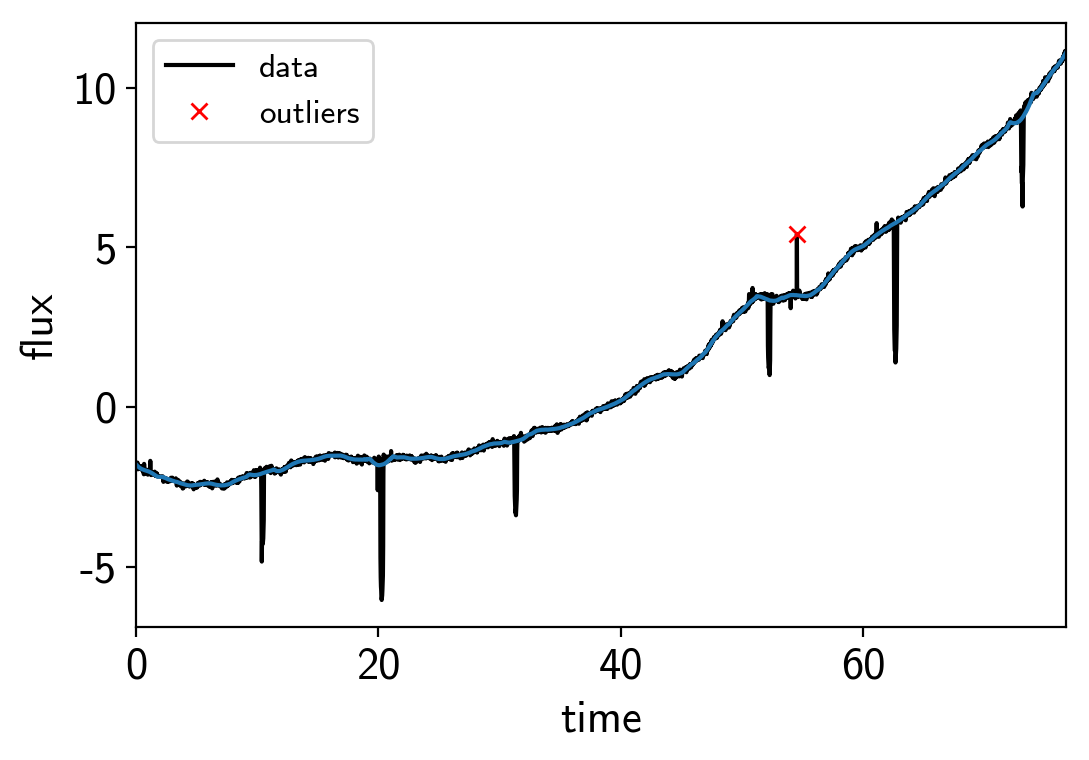

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

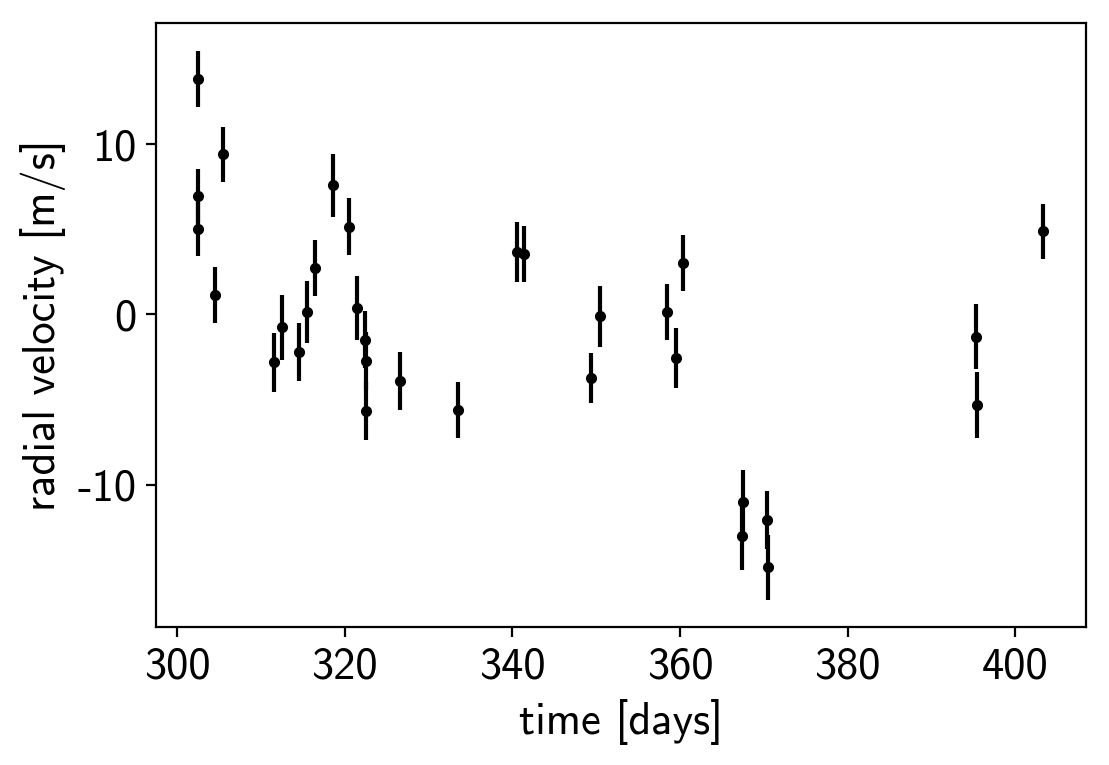

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

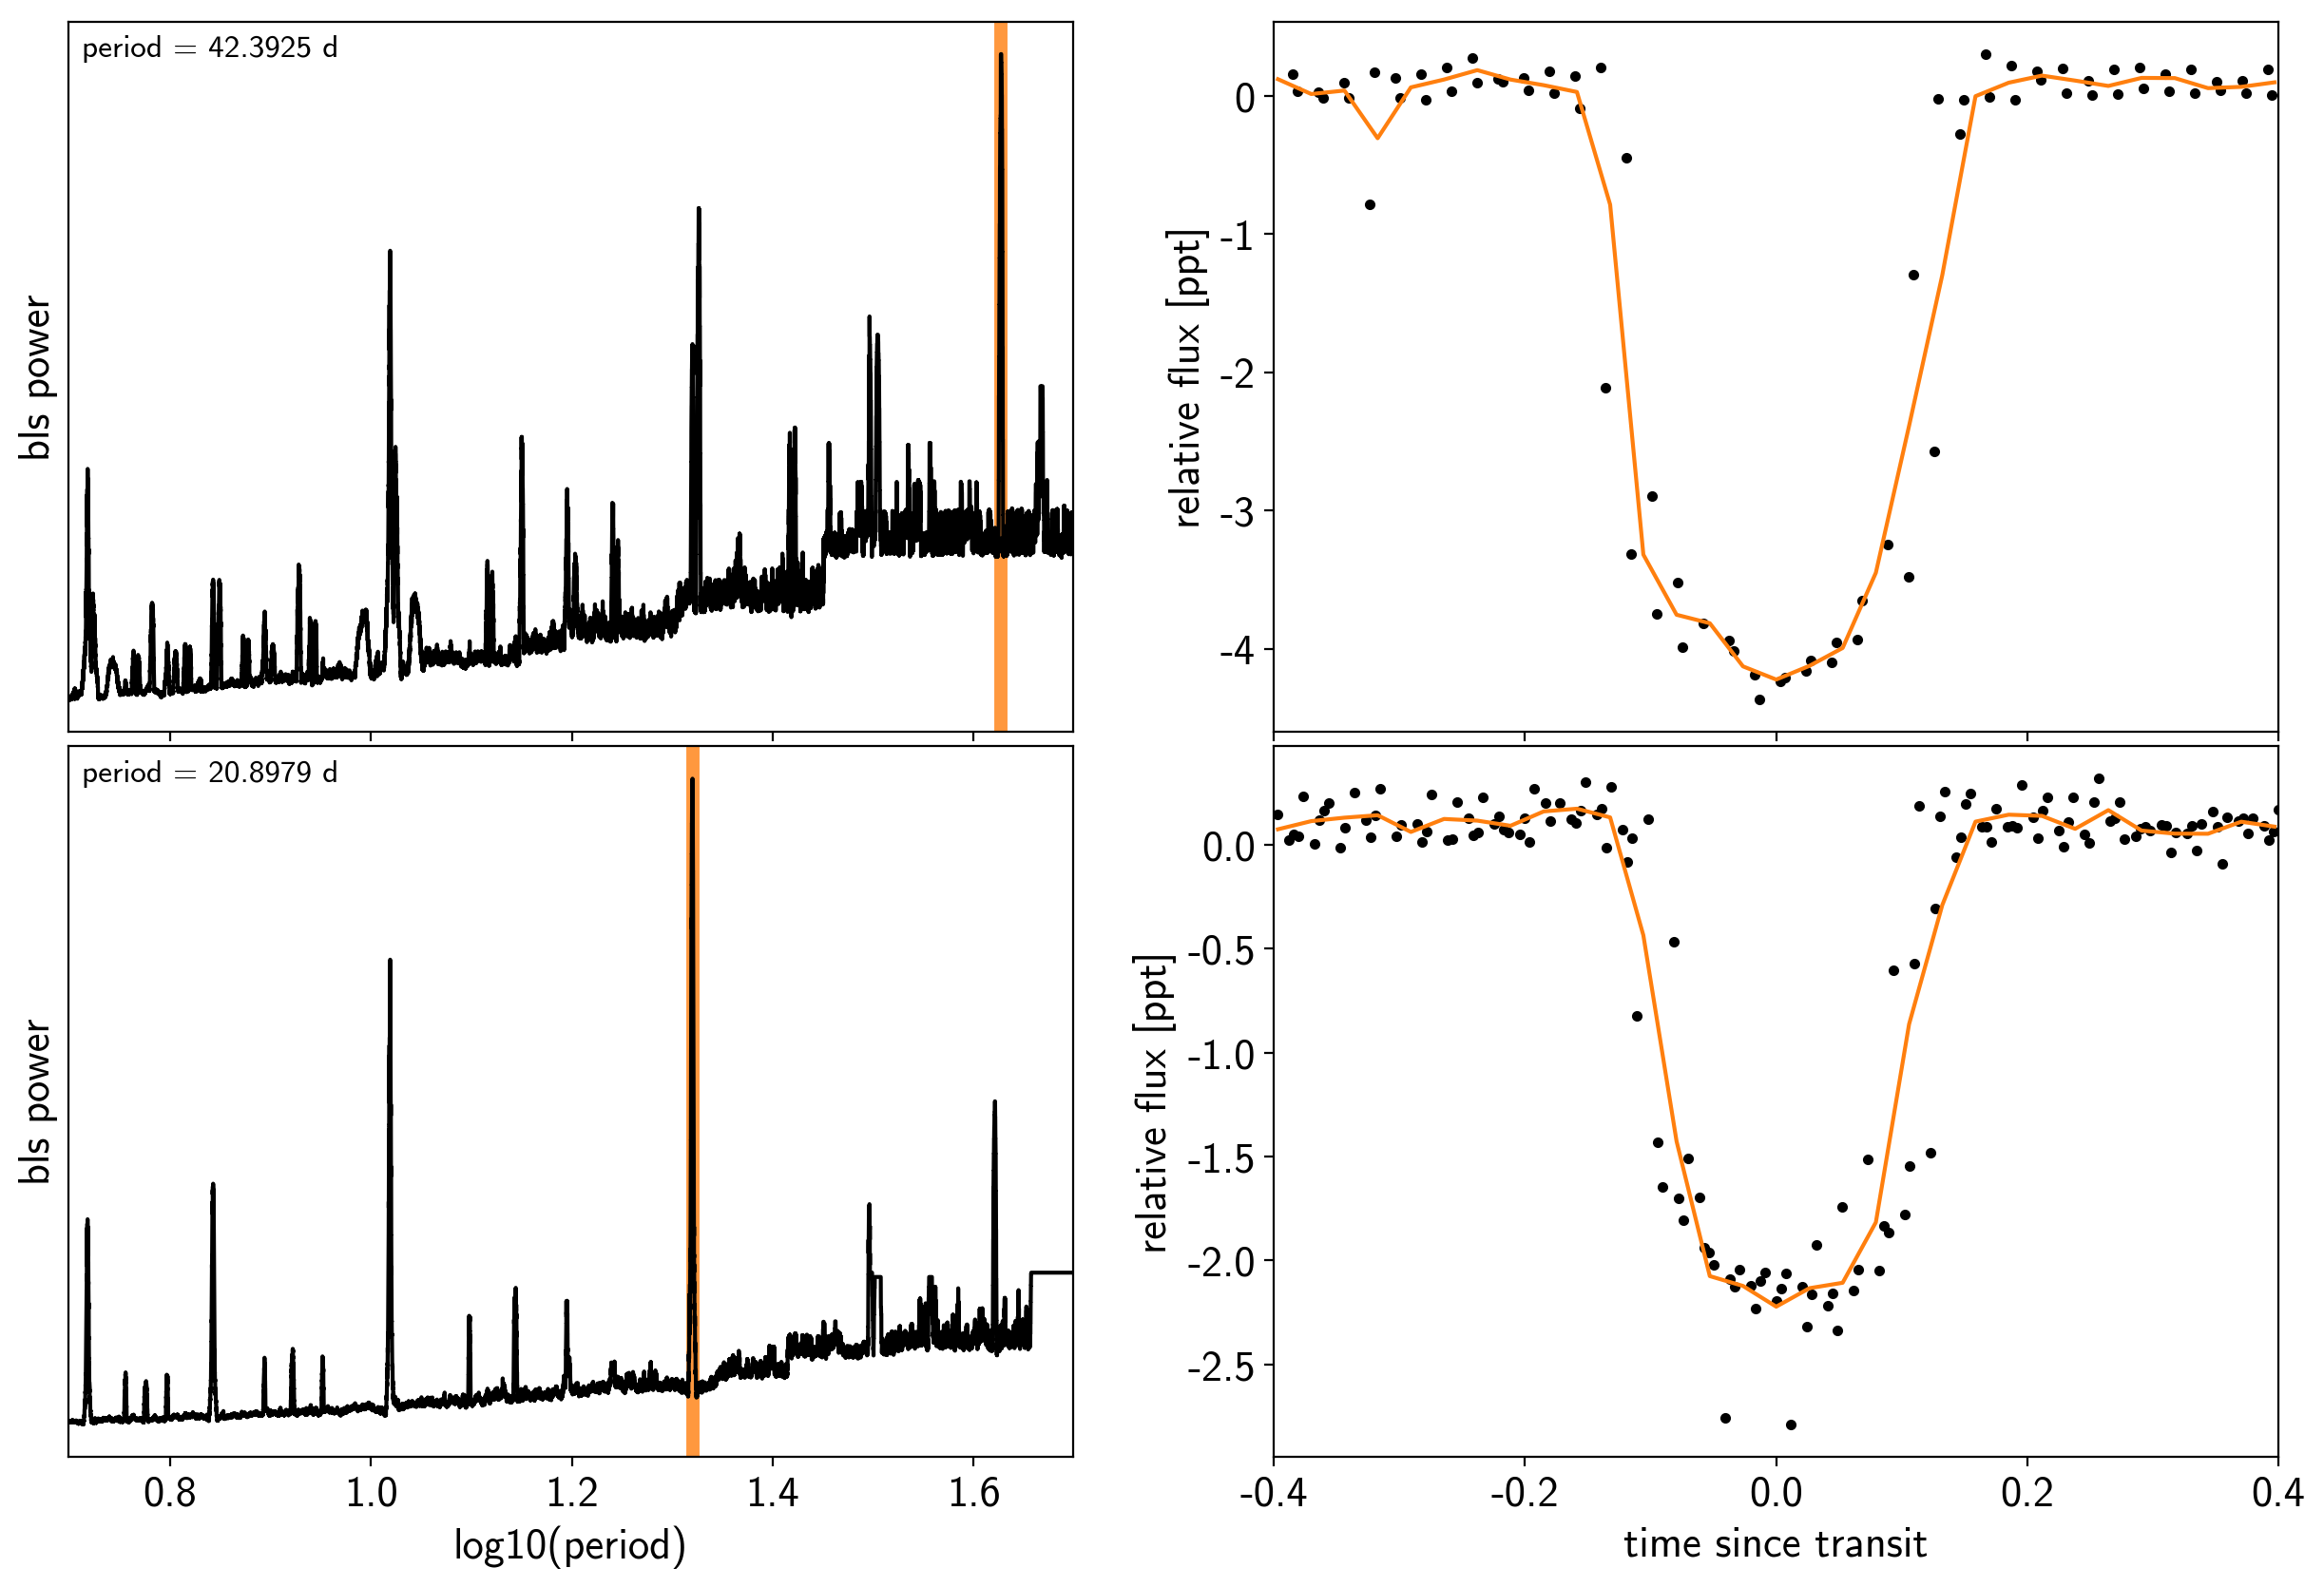

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = pm.Flat("b", shape=2,
                    transform=pm.distributions.transforms.logodds,
                    testval=0.5+np.zeros(2))
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, shape=2,
                  testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp, oversample=15)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[logm, ecc, omega])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8250.572284320753 -> -8233.972091020683


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: -8233.972091020683 -> 1985.306728512705


optimizing logp for variables: ['b_logodds__', 'logr']


message: Optimization terminated successfully.
logp: 1985.306728512705 -> 2680.2938076927717


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 2680.2938076927717 -> 3333.6089590341962


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 3333.6089590341962 -> 4289.068611272214


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 4289.068611272214 -> 4363.105545785508


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_logodds__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4363.105545785508 -> 4363.11043679313


optimizing logp for variables: ['omega_angle__', 'ecc_logodds__', 'logm']


message: Desired error not necessarily achieved due to precision loss.
logp: 4363.11043679313 -> 4407.935680188271


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_logodds__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4407.935680188271 -> 4737.19517345577


Now let's plot the map radial velocity model.

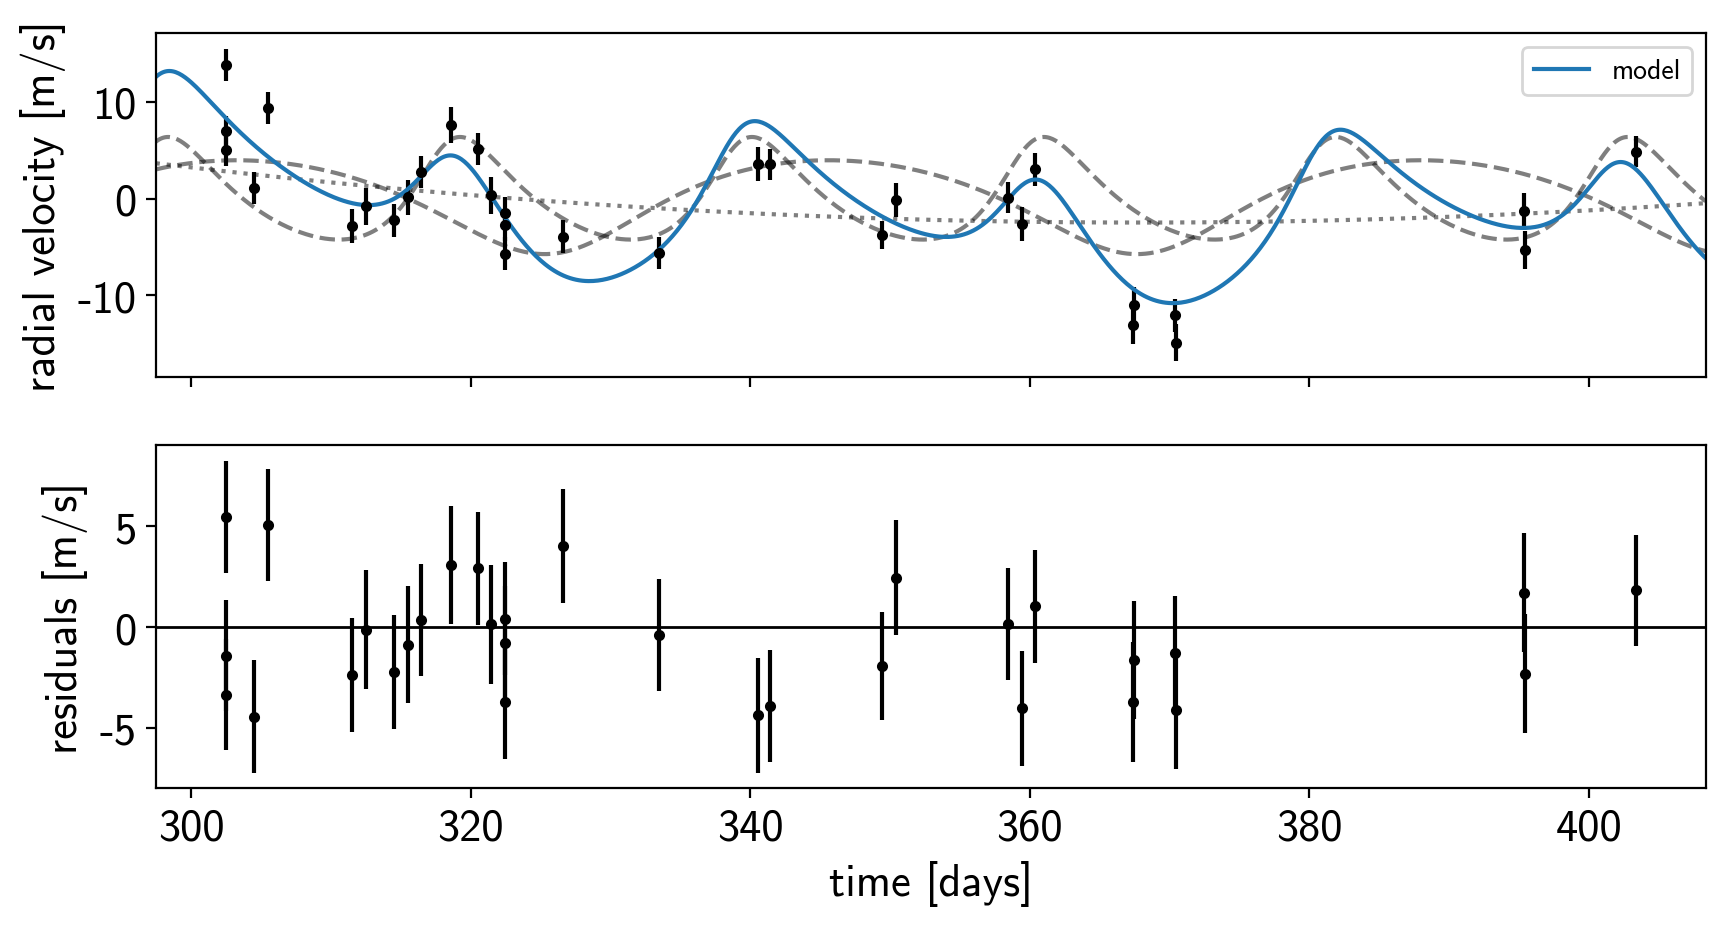

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

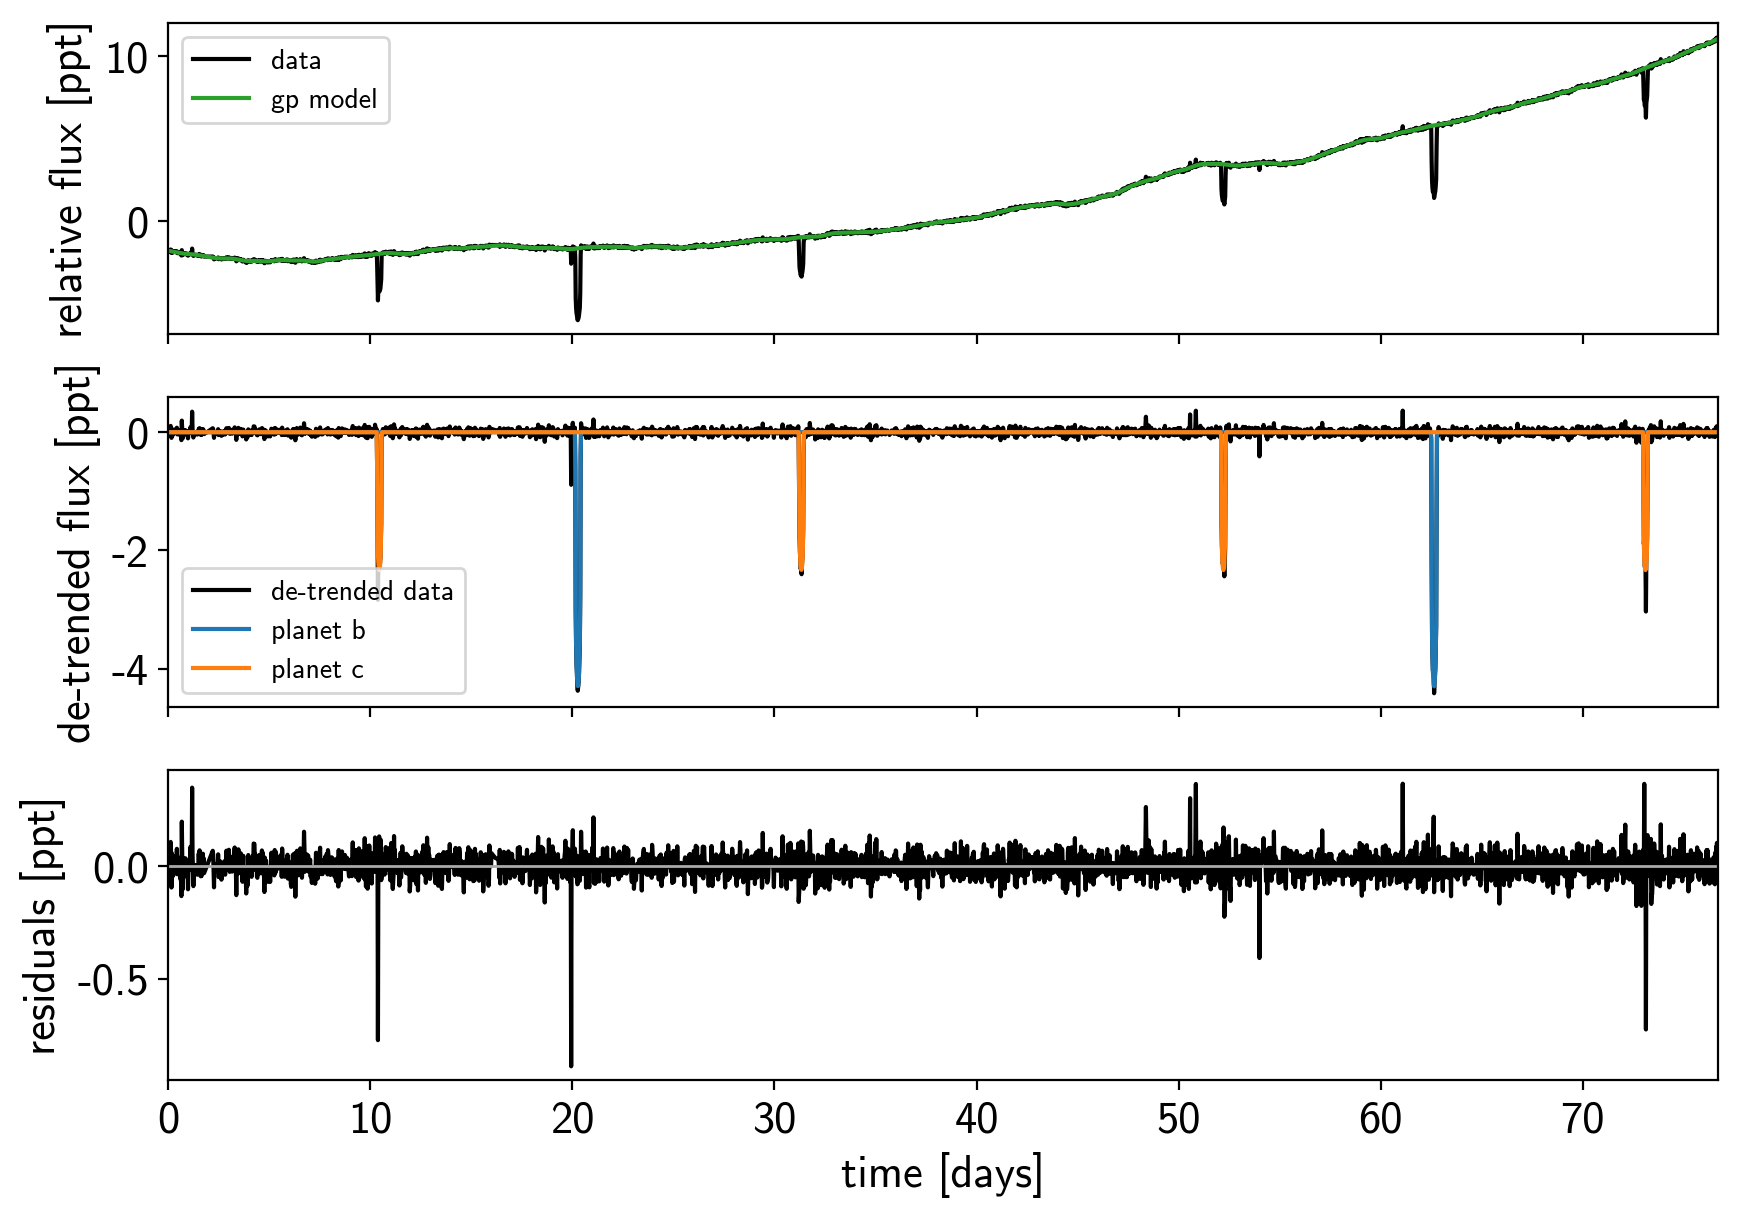

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

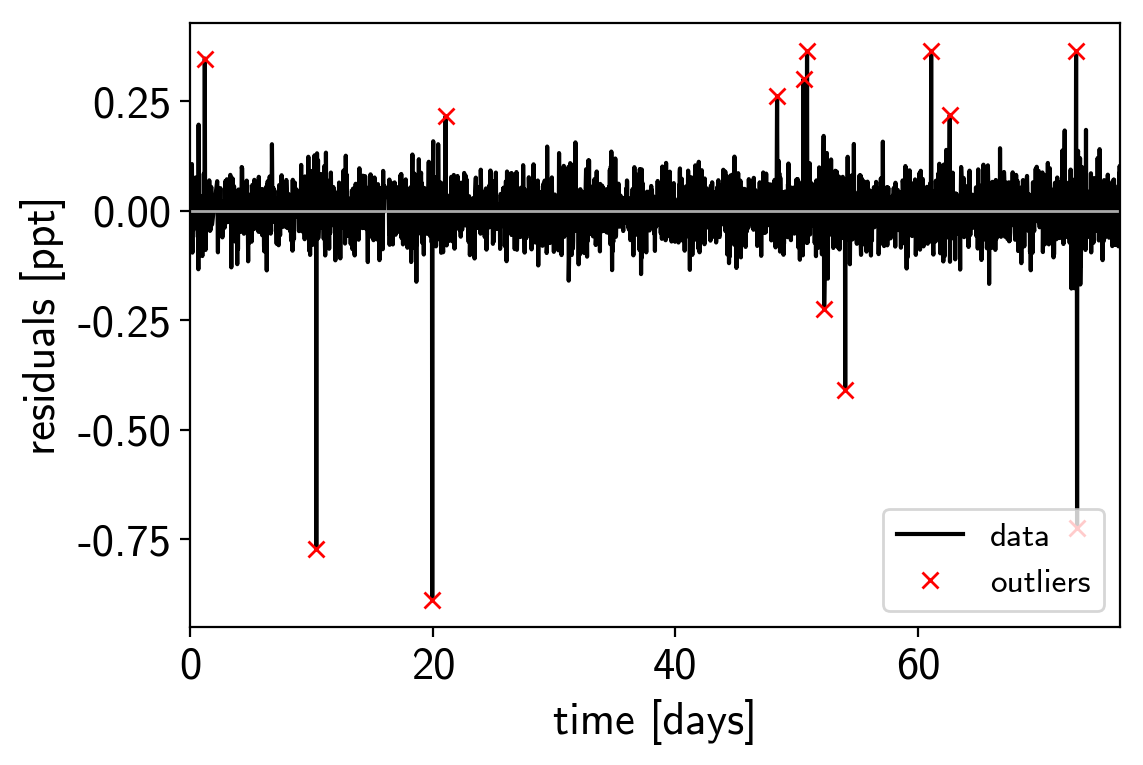

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5187.264799586911 -> 5187.264799586911


optimizing logp for variables: ['logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: 5187.264799586911 -> 5269.398798762257


optimizing logp for variables: ['b_logodds__', 'logr']


message: Optimization terminated successfully.
logp: 5269.39879876224 -> 5280.419465889598


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 5280.419465889598 -> 5281.860766661382


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5281.860766661367 -> 5282.5962208168285


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 5282.5962208168285 -> 5282.630549507979


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_logodds__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5282.630549507991 -> 5284.41987513696


optimizing logp for variables: ['omega_angle__', 'ecc_logodds__', 'logm']


message: Desired error not necessarily achieved due to precision loss.
logp: 5284.41987513696 -> 5284.41987513696


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_logodds__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5284.41987513696 -> 5284.419875136969


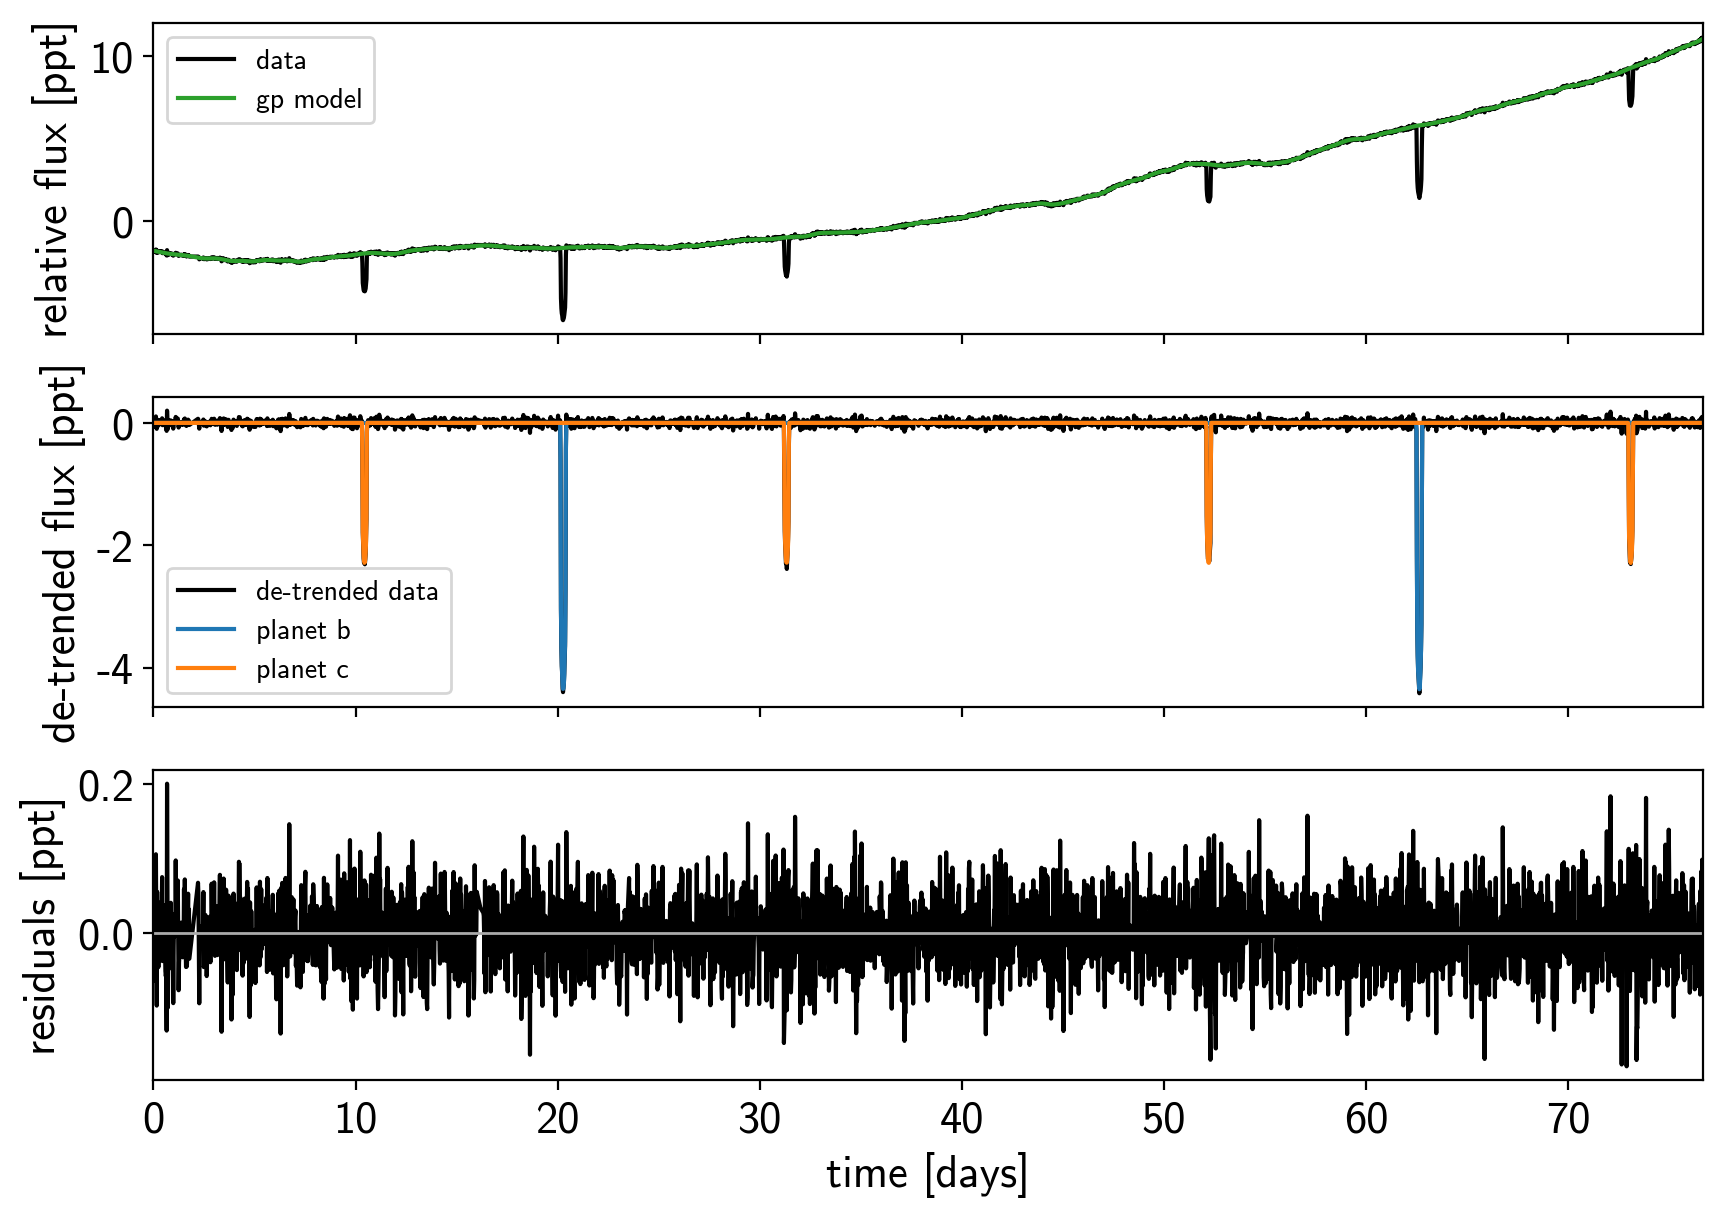

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=200, start=500, finish=1000)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.95),
                          chains=4)

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 19/2008 [00:00<00:10, 183.18draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:01<01:43, 19.21draws/s] 

Sampling 4 chains:   1%|▏         | 30/2008 [00:02<03:08, 10.52draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:03<05:20,  6.16draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:03<04:06,  8.00draws/s]

Sampling 4 chains:   2%|▏         | 39/2008 [00:04<05:56,  5.53draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:04<08:30,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 44/2008 [00:05<06:33,  4.99draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:05<08:26,  3.87draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:06<06:58,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:06<12:02,  2.71draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:06<09:00,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:07<10:23,  3.14draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:07<07:55,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 56/2008 [00:08<07:15,  4.49draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:08<11:23,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:08<08:43,  3.72draws/s]

Sampling 4 chains:   3%|▎         | 60/2008 [00:09<08:04,  4.02draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:09<11:30,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:09<08:51,  3.66draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:10<08:21,  3.88draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:10<11:22,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:10<08:51,  3.65draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:11<08:31,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:11<11:05,  2.92draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:11<08:44,  3.69draws/s]

Sampling 4 chains:   4%|▎         | 72/2008 [00:12<08:37,  3.74draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:12<10:49,  2.98draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:12<08:36,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:13<08:45,  3.67draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:13<08:48,  3.66draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:13<07:53,  4.07draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:14<08:06,  3.96draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:14<08:07,  3.95draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:14<07:16,  4.41draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:15<07:49,  4.10draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:15<07:44,  4.14draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:15<06:52,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:16<07:42,  4.15draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:16<07:28,  4.28draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:16<06:30,  4.91draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:17<07:36,  4.19draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:17<07:11,  4.44draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:17<06:10,  5.16draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:18<07:32,  4.22draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:18<06:57,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:18<05:53,  5.41draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:19<07:30,  4.23draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:19<06:41,  4.75draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:19<05:24,  5.86draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:20<07:40,  4.14draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:20<06:04,  5.22draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:21<08:09,  3.88draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:21<06:20,  4.99draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:21<05:37,  5.61draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:22<10:39,  2.96draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:22<08:02,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:22<07:09,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:23<11:26,  2.75draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:23<08:33,  3.68draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:23<07:48,  4.03draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:24<11:42,  2.69draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:24<08:40,  3.62draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:25<10:08,  3.10draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:25<08:10,  3.83draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:25<11:25,  2.74draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:26<09:11,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:26<11:47,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:27<08:44,  3.57draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:27<09:02,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:27<11:21,  2.74draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:28<08:27,  3.69draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:28<09:06,  3.42draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:28<11:04,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:28<08:16,  3.76draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:29<09:17,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:29<10:49,  2.87draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:29<08:07,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:30<09:28,  3.27draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:30<10:36,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:30<08:00,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:31<09:38,  3.21draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:31<10:25,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:31<07:52,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:32<09:49,  3.14draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:32<10:12,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:32<08:08,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:33<08:07,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:33<08:38,  3.57draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:33<07:10,  4.29draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:34<07:32,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:34<07:53,  3.89draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:34<06:45,  4.54draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:35<07:21,  4.16draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:35<07:26,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:35<06:33,  4.67draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:36<06:32,  4.68draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:36<06:08,  4.98draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:36<06:14,  4.90draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:36<05:52,  5.21draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:37<07:52,  3.87draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:37<07:22,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:37<06:45,  4.51draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:37<06:20,  4.80draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:38<08:08,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:38<07:49,  3.89draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:38<06:45,  4.50draws/s]

Sampling 4 chains:   9%|▉         | 183/2008 [00:38<06:27,  4.70draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:38<06:19,  4.81draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:39<06:50,  4.44draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:39<05:44,  5.29draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:39<06:25,  4.72draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:39<07:26,  4.08draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:40<07:53,  3.84draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:40<07:06,  4.26draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:40<07:50,  3.86draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:41<08:25,  3.59draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:41<07:22,  4.10draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:41<07:57,  3.79draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:42<08:45,  3.44draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:42<07:30,  4.01draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:42<07:57,  3.78draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:43<08:45,  3.44draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:43<07:32,  3.98draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:43<07:53,  3.80draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:44<08:41,  3.46draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:44<07:32,  3.98draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:44<07:48,  3.84draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:45<08:35,  3.49draws/s]

Sampling 4 chains:  11%|█         | 211/2008 [00:45<06:55,  4.33draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:45<06:58,  4.29draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:45<07:19,  4.09draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:46<08:12,  3.64draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:46<06:57,  4.29draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:46<06:48,  4.39draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:46<07:08,  4.18draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:47<08:02,  3.71draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:47<07:07,  4.18draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:47<06:42,  4.44draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:47<07:00,  4.25draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:47<07:54,  3.76draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:48<07:19,  4.06draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:48<06:41,  4.45draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:48<06:52,  4.33draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:48<07:45,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:49<07:33,  3.93draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:49<06:38,  4.47draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:49<06:44,  4.39draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:49<07:37,  3.89draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:50<07:49,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:50<06:35,  4.49draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:50<06:37,  4.46draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:50<07:29,  3.95draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:51<08:02,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:51<06:32,  4.51draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:51<06:30,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:51<07:21,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:52<08:14,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:52<07:03,  4.17draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:52<07:40,  3.83draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:53<08:46,  3.35draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [00:53<07:17,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:53<07:47,  3.77draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:54<09:09,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 249/2008 [00:54<07:25,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:54<07:50,  3.73draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:55<09:29,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:55<07:31,  3.89draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:55<07:51,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:56<09:47,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:56<07:36,  3.84draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:56<07:52,  3.71draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:57<09:56,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:57<07:38,  3.81draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:57<07:52,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [00:58<10:01,  2.90draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:58<07:40,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:58<07:51,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:58<10:07,  2.87draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:59<07:41,  3.77draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:59<07:49,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:59<10:12,  2.83draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [01:00<07:42,  3.75draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [01:00<07:47,  3.71draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [01:00<10:18,  2.80draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [01:01<08:06,  3.56draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [01:01<06:55,  4.16draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [01:01<09:48,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [01:02<07:50,  3.67draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [01:02<06:37,  4.34draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [01:02<09:43,  2.96draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [01:02<07:40,  3.74draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [01:03<06:29,  4.42draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [01:03<09:44,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [01:03<07:32,  3.80draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [01:04<06:49,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [01:04<10:05,  2.84draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [01:04<07:51,  3.63draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [01:05<06:48,  4.20draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [01:05<10:08,  2.82draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [01:05<08:00,  3.56draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [01:06<06:33,  4.34draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [01:06<10:04,  2.83draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [01:06<08:03,  3.53draws/s]

Sampling 4 chains:  15%|█▌        | 303/2008 [01:07<08:45,  3.25draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [01:07<07:12,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [01:08<08:04,  3.51draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [01:08<06:49,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [01:09<07:41,  3.68draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [01:09<06:31,  4.33draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [01:10<07:30,  3.76draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [01:10<06:20,  4.44draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [01:11<07:25,  3.79draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [01:11<06:13,  4.52draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [01:12<07:23,  3.80draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [01:12<06:08,  4.57draws/s]

Sampling 4 chains:  16%|█▌        | 326/2008 [01:12<05:25,  5.16draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [01:13<08:51,  3.16draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [01:13<07:06,  3.94draws/s]

Sampling 4 chains:  16%|█▋        | 330/2008 [01:13<06:24,  4.36draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [01:14<09:18,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [01:14<07:23,  3.78draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [01:14<06:52,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [01:15<09:21,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [01:15<07:23,  3.76draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [01:15<07:14,  3.85draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [01:16<09:17,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [01:16<07:19,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [01:16<07:29,  3.71draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [01:17<09:11,  3.02draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [01:17<07:14,  3.83draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [01:17<07:42,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [01:18<09:05,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [01:18<07:08,  3.87draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [01:18<07:56,  3.48draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [01:19<08:59,  3.07draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [01:19<07:02,  3.92draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [01:19<08:09,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [01:20<08:53,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [01:20<06:56,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [01:20<08:23,  3.28draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [01:21<08:46,  3.13draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [01:21<06:50,  4.01draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [01:21<08:36,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [01:22<08:40,  3.16draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [01:22<06:44,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [01:22<08:49,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [01:23<08:33,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [01:23<06:39,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [01:23<09:02,  3.02draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [01:24<08:27,  3.22draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [01:24<06:45,  4.03draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [01:24<07:17,  3.73draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [01:25<06:57,  3.91draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [01:25<05:46,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [01:25<06:41,  4.06draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [01:25<06:16,  4.32draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [01:26<05:22,  5.05draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [01:26<06:29,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [01:26<05:52,  4.60draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [01:27<05:11,  5.21draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [01:27<06:05,  4.44draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [01:27<05:08,  5.25draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [01:28<04:44,  5.70draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [01:28<08:13,  3.28draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [01:28<06:37,  4.07draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [01:28<05:28,  4.92draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [01:28<04:54,  5.47draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [01:29<08:26,  3.18draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [01:29<06:57,  3.86draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [01:29<05:40,  4.73draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [01:30<09:04,  2.96draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [01:30<07:34,  3.54draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [01:30<05:58,  4.49draws/s]

Sampling 4 chains:  20%|██        | 402/2008 [01:31<09:22,  2.86draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [01:31<07:57,  3.36draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [01:31<06:05,  4.39draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [01:32<09:33,  2.79draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [01:32<08:08,  3.28draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [01:32<06:07,  4.35draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [01:33<09:41,  2.75draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [01:33<08:09,  3.26draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [01:33<06:07,  4.34draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [01:34<07:40,  3.46draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [01:35<07:29,  3.54draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [01:35<06:29,  4.08draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [01:35<04:57,  5.33draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [01:36<06:50,  3.86draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [01:36<05:20,  4.95draws/s]

Sampling 4 chains:  21%|██        | 426/2008 [01:37<09:05,  2.90draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [01:37<07:29,  3.52draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [01:37<05:54,  4.46draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [01:38<09:17,  2.83draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [01:38<07:33,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [01:38<06:04,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [01:39<09:15,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [01:39<07:26,  3.52draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [01:39<06:08,  4.26draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [01:40<09:02,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [01:40<07:14,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [01:40<06:07,  4.27draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [01:41<08:49,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [01:41<07:02,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [01:41<06:05,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [01:42<08:36,  3.02draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [01:42<06:49,  3.81draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [01:42<06:03,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [01:43<08:24,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [01:43<06:26,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [01:43<06:54,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [01:44<09:03,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [01:44<06:44,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [01:44<07:22,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [01:45<09:18,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [01:45<07:41,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [01:46<09:19,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [01:46<07:46,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [01:47<09:08,  2.81draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [01:47<07:41,  3.33draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [01:48<09:00,  2.85draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [01:48<07:37,  3.36draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [01:49<08:48,  2.90draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [01:49<07:31,  3.39draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [01:49<08:29,  3.00draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [01:50<07:23,  3.45draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [01:50<08:05,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:51<07:11,  3.53draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [01:51<07:41,  3.30draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:52<06:59,  3.62draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [01:52<07:16,  3.48draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [01:53<06:48,  3.71draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [01:53<06:48,  3.70draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [01:54<06:33,  3.84draws/s]

Sampling 4 chains:  25%|██▍       | 498/2008 [01:54<06:21,  3.96draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [01:54<04:49,  5.20draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [01:55<08:17,  3.03draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [01:55<07:17,  3.44draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:55<05:32,  4.53draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:56<08:57,  2.80draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [01:56<07:29,  3.34draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [01:56<05:44,  4.35draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [01:57<09:11,  2.72draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [01:57<07:24,  3.37draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [01:57<05:44,  4.35draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:58<09:19,  2.67draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [01:58<07:04,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [01:58<05:45,  4.32draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [01:59<09:28,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [01:59<07:04,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [01:59<05:48,  4.27draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [02:00<09:40,  2.56draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [02:00<07:17,  3.39draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [02:01<10:44,  2.30draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [02:01<08:00,  3.08draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [02:02<10:45,  2.29draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [02:02<07:53,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [02:03<08:42,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [02:03<06:31,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [02:04<07:41,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [02:04<05:46,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [02:05<07:11,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [02:05<05:25,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [02:06<06:44,  3.61draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [02:06<05:22,  4.53draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [02:07<09:21,  2.60draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [02:07<07:04,  3.43draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [02:08<10:16,  2.36draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [02:08<07:48,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [02:09<10:30,  2.30draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [02:09<07:43,  3.13draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [02:10<08:28,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [02:10<06:18,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [02:10<07:28,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [02:11<05:37,  4.27draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [02:11<06:57,  3.44draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [02:12<05:16,  4.54draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [02:12<06:41,  3.57draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [02:12<05:06,  4.67draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [02:13<06:33,  3.64draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [02:13<05:22,  4.43draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [02:14<05:02,  4.72draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [02:14<06:59,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [02:14<05:48,  4.09draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [02:15<05:23,  4.40draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [02:15<06:59,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [02:15<05:52,  4.03draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [02:16<05:31,  4.28draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [02:16<06:47,  3.48draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [02:16<05:46,  4.09draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [02:17<05:34,  4.24draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [02:17<06:33,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [02:17<05:38,  4.17draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [02:18<05:34,  4.22draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [02:18<06:18,  3.73draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [02:18<05:29,  4.28draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [02:19<05:34,  4.21draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [02:19<06:02,  3.88draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [02:19<05:20,  4.38draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [02:20<05:34,  4.20draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [02:20<05:47,  4.04draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [02:20<05:12,  4.49draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [02:21<05:34,  4.18draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [02:21<05:32,  4.21draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [02:21<05:03,  4.61draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [02:22<05:34,  4.17draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [02:22<05:17,  4.40draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [02:22<04:54,  4.73draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [02:23<05:34,  4.16draws/s]

Sampling 4 chains:  31%|███       | 617/2008 [02:23<05:01,  4.61draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [02:23<04:47,  4.84draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [02:24<05:35,  4.14draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [02:24<04:46,  4.84draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [02:24<04:38,  4.98draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [02:25<05:35,  4.13draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [02:25<04:52,  4.72draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [02:26<05:51,  3.93draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [02:26<04:57,  4.64draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [02:26<04:09,  5.52draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [02:27<07:18,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [02:27<05:51,  3.91draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [02:27<04:51,  4.71draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [02:28<07:47,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [02:28<06:09,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [02:28<05:07,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [02:29<07:53,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [02:29<06:13,  3.65draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [02:29<05:13,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [02:30<07:50,  2.90draws/s]

Sampling 4 chains:  32%|███▏      | 646/2008 [02:30<06:13,  3.65draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [02:30<05:16,  4.30draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [02:30<07:46,  2.92draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [02:31<06:21,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [02:31<05:13,  4.33draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [02:31<07:38,  2.96draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [02:32<06:29,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [02:32<05:15,  4.29draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [02:32<07:32,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [02:33<06:19,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [02:33<06:12,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [02:34<05:29,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [02:34<05:35,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [02:34<05:08,  4.35draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [02:35<05:18,  4.21draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [02:35<05:02,  4.43draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [02:36<03:54,  5.69draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [02:36<06:59,  3.18draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [02:36<06:19,  3.52draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [02:37<04:52,  4.56draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [02:37<07:26,  2.99draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [02:37<06:42,  3.31draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [02:38<05:12,  4.25draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [02:38<07:24,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [02:38<06:47,  3.26draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [02:39<05:20,  4.13draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [02:39<07:15,  3.04draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [02:39<06:46,  3.26draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [02:40<05:23,  4.08draws/s]

Sampling 4 chains:  34%|███▍      | 688/2008 [02:40<07:02,  3.12draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [02:40<06:42,  3.27draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [02:41<05:25,  4.05draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [02:41<06:49,  3.22draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [02:41<06:38,  3.30draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [02:42<05:26,  4.02draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [02:42<06:35,  3.32draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [02:42<06:30,  3.36draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [02:42<05:26,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [02:43<06:22,  3.42draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [02:43<06:21,  3.42draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [02:43<05:26,  4.00draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [02:44<06:07,  3.54draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [02:44<06:12,  3.49draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [02:44<05:26,  3.99draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [02:45<05:53,  3.67draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [02:45<06:04,  3.57draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [02:45<05:25,  3.98draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [02:46<05:39,  3.81draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [02:46<05:55,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [02:46<05:25,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [02:47<05:26,  3.96draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [02:47<05:46,  3.73draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [02:47<05:25,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [02:48<05:11,  4.13draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [02:48<05:38,  3.81draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [02:48<05:24,  3.96draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [02:49<04:57,  4.32draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [02:49<05:30,  3.88draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [02:49<05:26,  3.93draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [02:50<04:41,  4.54draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [02:50<05:20,  3.99draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [02:50<05:25,  3.93draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [02:51<04:27,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [02:51<05:11,  4.09draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [02:51<05:24,  3.92draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [02:52<05:03,  4.19draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [02:52<05:23,  3.92draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [02:53<04:56,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [02:53<04:07,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [02:53<06:06,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [02:54<05:21,  3.93draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [02:54<04:28,  4.71draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [02:54<06:14,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [02:55<05:28,  3.84draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [02:55<04:35,  4.57draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [02:55<06:13,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [02:56<05:28,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 754/2008 [02:56<04:38,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [02:56<06:09,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [02:56<04:59,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [02:57<05:05,  4.10draws/s]

Sampling 4 chains:  38%|███▊      | 758/2008 [02:57<04:27,  4.67draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [02:57<05:53,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [02:57<05:01,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [02:58<04:55,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 762/2008 [02:58<04:23,  4.72draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [02:58<05:44,  3.61draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [02:58<05:08,  4.04draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [02:59<04:49,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [02:59<04:21,  4.74draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [02:59<05:39,  3.66draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [02:59<05:15,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [02:59<04:42,  4.38draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [03:00<04:20,  4.75draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [03:00<05:33,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [03:00<05:23,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [03:00<04:37,  4.45draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [03:01<04:19,  4.75draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [03:01<05:27,  3.77draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [03:01<05:32,  3.71draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [03:01<04:32,  4.52draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [03:02<04:18,  4.75draws/s]

Sampling 4 chains:  39%|███▉      | 779/2008 [03:02<05:21,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [03:02<05:40,  3.61draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [03:03<04:47,  4.26draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [03:03<05:36,  3.64draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [03:03<06:02,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [03:04<04:59,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [03:04<05:39,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [03:04<06:17,  3.23draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [03:04<05:05,  3.98draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [03:05<05:38,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [03:05<06:24,  3.16draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [03:05<05:08,  3.93draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [03:06<08:19,  2.43draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [03:07<11:48,  1.71draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [03:08<14:14,  1.42draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [03:09<12:34,  1.60draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [03:09<11:21,  1.77draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [03:09<08:44,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [03:09<06:51,  2.93draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [03:10<10:00,  2.01draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [03:11<12:58,  1.55draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [03:12<16:45,  1.20draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [03:13<14:24,  1.39draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [03:13<11:47,  1.70draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [03:15<19:54,  1.01draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [03:16<20:43,  1.04s/draws]

Sampling 4 chains:  40%|████      | 809/2008 [03:17<17:20,  1.15draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [03:17<14:00,  1.42draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [03:19<21:56,  1.10s/draws]

Sampling 4 chains:  40%|████      | 812/2008 [03:20<21:17,  1.07s/draws]

Sampling 4 chains:  40%|████      | 813/2008 [03:21<17:51,  1.12draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [03:21<14:33,  1.37draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [03:23<22:47,  1.15s/draws]

Sampling 4 chains:  41%|████      | 816/2008 [03:24<21:03,  1.06s/draws]

Sampling 4 chains:  41%|████      | 817/2008 [03:24<17:49,  1.11draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [03:25<14:45,  1.34draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [03:27<23:19,  1.18s/draws]

Sampling 4 chains:  41%|████      | 820/2008 [03:28<20:36,  1.04s/draws]

Sampling 4 chains:  41%|████      | 821/2008 [03:28<17:35,  1.12draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [03:29<14:47,  1.34draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [03:31<23:48,  1.21s/draws]

Sampling 4 chains:  41%|████      | 824/2008 [03:31<20:07,  1.02s/draws]

Sampling 4 chains:  41%|████      | 825/2008 [03:32<17:22,  1.14draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [03:33<14:49,  1.33draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [03:35<24:15,  1.23s/draws]

Sampling 4 chains:  41%|████      | 828/2008 [03:35<19:37,  1.00draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [03:36<17:07,  1.15draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [03:36<14:49,  1.32draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [03:39<24:43,  1.26s/draws]

Sampling 4 chains:  41%|████▏     | 832/2008 [03:39<19:07,  1.03draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [03:40<16:52,  1.16draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [03:40<14:51,  1.32draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [03:43<25:15,  1.29s/draws]

Sampling 4 chains:  42%|████▏     | 836/2008 [03:43<18:38,  1.05draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [03:44<16:36,  1.17draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [03:44<14:51,  1.31draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [03:47<25:43,  1.32s/draws]

Sampling 4 chains:  42%|████▏     | 841/2008 [03:47<19:53,  1.02s/draws]

Sampling 4 chains:  42%|████▏     | 842/2008 [03:48<17:22,  1.12draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [03:51<27:15,  1.40s/draws]

Sampling 4 chains:  42%|████▏     | 844/2008 [03:51<19:42,  1.02s/draws]

Sampling 4 chains:  42%|████▏     | 845/2008 [03:51<16:53,  1.15draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [03:52<15:28,  1.25draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [03:54<25:33,  1.32s/draws]

Sampling 4 chains:  42%|████▏     | 848/2008 [03:55<19:19,  1.00draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [03:55<15:55,  1.21draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [03:56<14:59,  1.29draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [03:58<24:50,  1.29s/draws]

Sampling 4 chains:  42%|████▏     | 852/2008 [03:59<19:37,  1.02s/draws]

Sampling 4 chains:  42%|████▏     | 853/2008 [03:59<15:25,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [04:00<14:49,  1.30draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [04:02<24:21,  1.27s/draws]

Sampling 4 chains:  43%|████▎     | 856/2008 [04:03<20:06,  1.05s/draws]

Sampling 4 chains:  43%|████▎     | 857/2008 [04:03<15:01,  1.28draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [04:03<14:45,  1.30draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [04:06<23:56,  1.25s/draws]

Sampling 4 chains:  43%|████▎     | 860/2008 [04:06<20:36,  1.08s/draws]

Sampling 4 chains:  43%|████▎     | 862/2008 [04:07<16:45,  1.14draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [04:10<24:58,  1.31s/draws]

Sampling 4 chains:  43%|████▎     | 864/2008 [04:10<21:41,  1.14s/draws]

Sampling 4 chains:  43%|████▎     | 866/2008 [04:11<17:28,  1.09draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [04:13<25:06,  1.32s/draws]

Sampling 4 chains:  43%|████▎     | 868/2008 [04:14<21:54,  1.15s/draws]

Sampling 4 chains:  43%|████▎     | 869/2008 [04:14<16:29,  1.15draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [04:15<15:13,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [04:17<23:10,  1.22s/draws]

Sampling 4 chains:  43%|████▎     | 872/2008 [04:18<20:40,  1.09s/draws]

Sampling 4 chains:  43%|████▎     | 873/2008 [04:18<16:17,  1.16draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [04:19<14:35,  1.30draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [04:21<22:18,  1.18s/draws]

Sampling 4 chains:  44%|████▎     | 876/2008 [04:22<20:11,  1.07s/draws]

Sampling 4 chains:  44%|████▎     | 877/2008 [04:22<16:35,  1.14draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [04:23<14:20,  1.31draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [04:25<21:47,  1.16s/draws]

Sampling 4 chains:  44%|████▍     | 880/2008 [04:26<19:56,  1.06s/draws]

Sampling 4 chains:  44%|████▍     | 881/2008 [04:26<17:03,  1.10draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [04:27<14:11,  1.32draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [04:29<21:18,  1.14s/draws]

Sampling 4 chains:  44%|████▍     | 884/2008 [04:30<19:42,  1.05s/draws]

Sampling 4 chains:  44%|████▍     | 885/2008 [04:30<17:31,  1.07draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [04:31<14:03,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [04:33<20:51,  1.12s/draws]

Sampling 4 chains:  44%|████▍     | 888/2008 [04:33<19:31,  1.05s/draws]

Sampling 4 chains:  44%|████▍     | 889/2008 [04:34<18:01,  1.03draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [04:34<13:55,  1.34draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [04:36<20:25,  1.10s/draws]

Sampling 4 chains:  44%|████▍     | 892/2008 [04:37<19:19,  1.04s/draws]

Sampling 4 chains:  44%|████▍     | 893/2008 [04:38<18:28,  1.01draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [04:38<13:48,  1.34draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [04:40<19:59,  1.08s/draws]

Sampling 4 chains:  45%|████▍     | 896/2008 [04:41<19:09,  1.03s/draws]

Sampling 4 chains:  45%|████▍     | 897/2008 [04:42<18:58,  1.03s/draws]

Sampling 4 chains:  45%|████▍     | 899/2008 [04:44<18:35,  1.01s/draws]

Sampling 4 chains:  45%|████▍     | 900/2008 [04:45<18:01,  1.02draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [04:46<18:47,  1.02s/draws]

Sampling 4 chains:  45%|████▍     | 903/2008 [04:48<18:01,  1.02draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [04:49<17:50,  1.03draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [04:50<18:53,  1.03s/draws]

Sampling 4 chains:  45%|████▌     | 907/2008 [04:52<17:50,  1.03draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [04:53<17:55,  1.02draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [04:54<19:04,  1.04s/draws]

Sampling 4 chains:  45%|████▌     | 910/2008 [04:54<14:09,  1.29draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [04:55<17:56,  1.02draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [04:56<18:12,  1.00draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [04:58<19:24,  1.06s/draws]

Sampling 4 chains:  46%|████▌     | 914/2008 [04:58<14:50,  1.23draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [04:59<17:33,  1.04draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [05:00<18:07,  1.00draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [05:01<19:28,  1.07s/draws]

Sampling 4 chains:  46%|████▌     | 918/2008 [05:02<15:22,  1.18draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [05:03<17:02,  1.07draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [05:04<17:59,  1.01draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [05:05<19:30,  1.08s/draws]

Sampling 4 chains:  46%|████▌     | 922/2008 [05:06<15:51,  1.14draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [05:07<16:28,  1.10draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [05:08<17:49,  1.01draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [05:09<19:29,  1.08s/draws]

Sampling 4 chains:  46%|████▌     | 926/2008 [05:10<16:19,  1.10draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [05:11<15:55,  1.13draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [05:12<17:40,  1.02draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [05:13<19:28,  1.08s/draws]

Sampling 4 chains:  46%|████▋     | 930/2008 [05:14<16:51,  1.07draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [05:14<15:22,  1.17draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [05:16<17:28,  1.03draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [05:17<19:27,  1.09s/draws]

Sampling 4 chains:  47%|████▋     | 934/2008 [05:18<17:19,  1.03draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [05:18<14:49,  1.21draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [05:19<17:16,  1.03draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [05:21<19:28,  1.09s/draws]

Sampling 4 chains:  47%|████▋     | 938/2008 [05:22<17:48,  1.00draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [05:22<14:17,  1.25draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [05:23<17:05,  1.04draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [05:25<19:26,  1.09s/draws]

Sampling 4 chains:  47%|████▋     | 942/2008 [05:26<18:16,  1.03s/draws]

Sampling 4 chains:  47%|████▋     | 943/2008 [05:26<13:45,  1.29draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [05:27<16:54,  1.05draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [05:29<19:25,  1.10s/draws]

Sampling 4 chains:  47%|████▋     | 946/2008 [05:29<18:43,  1.06s/draws]

Sampling 4 chains:  47%|████▋     | 948/2008 [05:31<16:53,  1.05draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [05:32<19:31,  1.11s/draws]

Sampling 4 chains:  47%|████▋     | 950/2008 [05:33<18:32,  1.05s/draws]

Sampling 4 chains:  47%|████▋     | 951/2008 [05:33<13:39,  1.29draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [05:35<16:33,  1.06draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [05:36<19:24,  1.10s/draws]

Sampling 4 chains:  48%|████▊     | 954/2008 [05:37<18:04,  1.03s/draws]

Sampling 4 chains:  48%|████▊     | 955/2008 [05:37<14:09,  1.24draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [05:39<16:15,  1.08draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [05:40<19:18,  1.10s/draws]

Sampling 4 chains:  48%|████▊     | 958/2008 [05:41<17:36,  1.01s/draws]

Sampling 4 chains:  48%|████▊     | 959/2008 [05:41<14:42,  1.19draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [05:42<15:59,  1.09draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [05:44<19:12,  1.10s/draws]

Sampling 4 chains:  48%|████▊     | 962/2008 [05:45<17:10,  1.02draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [05:45<15:13,  1.14draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [05:46<15:43,  1.11draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [05:48<19:11,  1.10s/draws]

Sampling 4 chains:  48%|████▊     | 966/2008 [05:48<16:43,  1.04draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [05:49<15:44,  1.10draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [05:50<15:26,  1.12draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [05:52<19:07,  1.10s/draws]

Sampling 4 chains:  48%|████▊     | 970/2008 [05:52<16:16,  1.06draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [05:53<16:14,  1.06draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [05:54<15:10,  1.14draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [05:56<19:01,  1.10s/draws]

Sampling 4 chains:  49%|████▊     | 974/2008 [05:56<15:51,  1.09draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [05:57<16:44,  1.03draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [05:58<14:55,  1.15draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [05:59<18:57,  1.10s/draws]

Sampling 4 chains:  49%|████▊     | 978/2008 [06:00<15:24,  1.11draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [06:01<17:15,  1.01s/draws]

Sampling 4 chains:  49%|████▉     | 980/2008 [06:02<14:39,  1.17draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [06:03<18:52,  1.10s/draws]

Sampling 4 chains:  49%|████▉     | 982/2008 [06:04<14:59,  1.14draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [06:05<17:46,  1.04s/draws]

Sampling 4 chains:  49%|████▉     | 984/2008 [06:05<14:25,  1.18draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [06:07<18:47,  1.10s/draws]

Sampling 4 chains:  49%|████▉     | 986/2008 [06:07<14:32,  1.17draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [06:09<18:14,  1.07s/draws]

Sampling 4 chains:  49%|████▉     | 988/2008 [06:09<14:10,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [06:11<18:41,  1.10s/draws]

Sampling 4 chains:  49%|████▉     | 990/2008 [06:11<14:07,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [06:13<18:46,  1.11s/draws]

Sampling 4 chains:  49%|████▉     | 992/2008 [06:13<13:55,  1.22draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [06:15<18:36,  1.10s/draws]

Sampling 4 chains:  50%|████▉     | 994/2008 [06:15<13:44,  1.23draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [06:17<19:15,  1.14s/draws]

Sampling 4 chains:  50%|████▉     | 997/2008 [06:19<18:03,  1.07s/draws]

Sampling 4 chains:  50%|████▉     | 999/2008 [06:21<17:46,  1.06s/draws]

Sampling 4 chains:  50%|████▉     | 1001/2008 [06:23<16:57,  1.01s/draws]

Sampling 4 chains:  50%|████▉     | 1003/2008 [06:25<16:56,  1.01s/draws]

Sampling 4 chains:  50%|█████     | 1004/2008 [06:25<12:54,  1.30draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [06:26<16:48,  1.01s/draws]

Sampling 4 chains:  50%|█████     | 1007/2008 [06:28<16:55,  1.01s/draws]

Sampling 4 chains:  50%|█████     | 1008/2008 [06:29<13:30,  1.23draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [06:30<16:21,  1.02draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [06:30<12:12,  1.36draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [06:32<18:16,  1.10s/draws]

Sampling 4 chains:  50%|█████     | 1012/2008 [06:33<15:04,  1.10draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [06:34<16:35,  1.00s/draws]

Sampling 4 chains:  50%|█████     | 1014/2008 [06:34<12:45,  1.30draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [06:36<18:27,  1.12s/draws]

Sampling 4 chains:  51%|█████     | 1016/2008 [06:37<15:49,  1.04draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [06:38<16:15,  1.02draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [06:38<12:53,  1.28draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [06:40<18:20,  1.11s/draws]

Sampling 4 chains:  51%|█████     | 1020/2008 [06:41<16:20,  1.01draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [06:42<15:48,  1.04draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [06:42<12:56,  1.27draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [06:44<18:09,  1.11s/draws]

Sampling 4 chains:  51%|█████     | 1024/2008 [06:45<16:53,  1.03s/draws]

Sampling 4 chains:  51%|█████     | 1025/2008 [06:45<15:19,  1.07draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [06:46<12:55,  1.27draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [06:48<17:53,  1.09s/draws]

Sampling 4 chains:  51%|█████     | 1028/2008 [06:49<17:20,  1.06s/draws]

Sampling 4 chains:  51%|█████     | 1029/2008 [06:49<14:49,  1.10draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [06:50<12:54,  1.26draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [06:51<17:42,  1.09s/draws]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [06:53<17:47,  1.09s/draws]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [06:53<14:21,  1.13draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [06:54<12:53,  1.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [06:55<17:28,  1.08s/draws]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [06:57<18:14,  1.13s/draws]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [06:57<13:53,  1.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [06:57<12:53,  1.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [06:59<17:13,  1.07s/draws]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [07:00<18:36,  1.15s/draws]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [07:01<14:57,  1.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [07:03<18:27,  1.15s/draws]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [07:04<19:44,  1.23s/draws]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [07:05<15:41,  1.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [07:07<18:43,  1.17s/draws]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [07:08<19:45,  1.23s/draws]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [07:08<14:52,  1.07draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [07:09<13:28,  1.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [07:11<16:57,  1.06s/draws]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [07:12<18:20,  1.15s/draws]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [07:12<14:41,  1.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [07:13<12:51,  1.24draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [07:14<16:18,  1.03s/draws]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [07:16<17:42,  1.12s/draws]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [07:16<14:59,  1.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [07:17<12:37,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [07:18<15:57,  1.01s/draws]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [07:20<17:16,  1.09s/draws]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [07:20<15:26,  1.02draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [07:21<12:35,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [07:22<15:38,  1.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [07:23<16:53,  1.07s/draws]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [07:24<15:53,  1.01s/draws]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [07:24<12:29,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [07:26<15:20,  1.02draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [07:27<16:30,  1.05s/draws]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [07:28<16:20,  1.04s/draws]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [07:28<12:25,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [07:30<15:04,  1.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [07:31<16:09,  1.04s/draws]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [07:32<16:47,  1.08s/draws]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [07:32<12:21,  1.26draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [07:34<14:47,  1.05draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [07:35<15:47,  1.02s/draws]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [07:36<17:14,  1.11s/draws]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [07:37<15:06,  1.02draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [07:38<15:51,  1.03s/draws]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [07:40<17:49,  1.15s/draws]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [07:41<15:17,  1.01draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [07:42<15:50,  1.03s/draws]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [07:44<18:07,  1.18s/draws]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [07:44<13:16,  1.16draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [07:45<14:07,  1.09draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [07:46<14:53,  1.03draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [07:48<17:46,  1.16s/draws]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [07:48<13:25,  1.14draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [07:49<13:35,  1.12draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [07:50<14:21,  1.06draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [07:52<17:42,  1.16s/draws]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [07:52<13:46,  1.11draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [07:53<13:14,  1.15draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [07:54<13:57,  1.09draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [07:55<17:41,  1.16s/draws]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [07:56<14:10,  1.07draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [07:56<12:55,  1.17draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [07:57<13:34,  1.12draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [07:59<17:41,  1.17s/draws]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [08:00<14:33,  1.04draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [08:00<12:35,  1.20draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [08:01<13:13,  1.14draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [08:03<17:40,  1.17s/draws]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [08:04<14:57,  1.01draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [08:04<12:16,  1.22draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [08:05<12:51,  1.17draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [08:07<17:42,  1.18s/draws]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [08:08<15:21,  1.03s/draws]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [08:08<11:58,  1.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [08:09<12:31,  1.19draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [08:11<17:42,  1.19s/draws]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [08:12<15:47,  1.06s/draws]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [08:12<11:39,  1.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [08:13<12:09,  1.22draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [08:15<17:42,  1.19s/draws]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [08:16<16:12,  1.09s/draws]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [08:16<13:15,  1.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [08:19<18:44,  1.27s/draws]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [08:19<16:42,  1.13s/draws]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [08:20<12:15,  1.20draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [08:20<11:44,  1.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [08:22<17:57,  1.22s/draws]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [08:23<15:58,  1.09s/draws]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [08:24<12:18,  1.19draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [08:24<11:03,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [08:26<17:43,  1.21s/draws]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [08:27<15:37,  1.07s/draws]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [08:27<12:37,  1.16draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [08:28<10:34,  1.38draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [08:30<17:40,  1.21s/draws]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [08:31<15:22,  1.06s/draws]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [08:31<13:00,  1.12draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [08:32<10:08,  1.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [08:34<17:37,  1.21s/draws]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [08:35<15:09,  1.05s/draws]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [08:35<13:24,  1.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [08:38<14:55,  1.03s/draws]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [08:39<13:06,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [08:39<12:08,  1.19draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [08:42<13:59,  1.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [08:42<12:16,  1.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [08:43<11:23,  1.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [08:43<09:03,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [08:46<16:33,  1.16s/draws]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [08:46<13:53,  1.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [08:47<12:20,  1.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [08:47<10:26,  1.37draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [08:50<17:07,  1.20s/draws]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [08:50<14:01,  1.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [08:51<12:17,  1.16draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [08:51<11:07,  1.28draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [08:53<17:07,  1.21s/draws]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [08:54<13:50,  1.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [08:54<12:01,  1.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [08:55<11:39,  1.21draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [08:57<17:01,  1.21s/draws]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [08:58<13:36,  1.04draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [08:58<11:43,  1.20draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [08:59<12:06,  1.16draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [09:01<16:54,  1.20s/draws]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [09:01<13:22,  1.05draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [09:02<11:26,  1.22draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [09:03<12:33,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [09:05<16:46,  1.20s/draws]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [09:05<13:06,  1.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [09:06<11:08,  1.25draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [09:07<12:58,  1.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [09:09<16:39,  1.20s/draws]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [09:09<12:51,  1.08draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [09:10<10:51,  1.28draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [09:11<13:22,  1.04draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [09:13<16:31,  1.19s/draws]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [09:13<12:38,  1.09draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [09:13<10:34,  1.31draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [09:15<13:48,  1.00s/draws]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [09:17<16:23,  1.19s/draws]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [09:17<12:24,  1.11draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [09:17<10:18,  1.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [09:19<14:11,  1.03s/draws]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [09:20<16:17,  1.19s/draws]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [09:21<12:10,  1.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [09:21<10:00,  1.37draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [09:23<14:34,  1.07s/draws]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [09:24<16:08,  1.18s/draws]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [09:24<11:57,  1.14draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [09:25<09:44,  1.40draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [09:27<14:56,  1.10s/draws]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [09:28<16:00,  1.18s/draws]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [09:28<11:43,  1.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [09:29<09:28,  1.43draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [09:31<15:19,  1.13s/draws]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [09:32<15:52,  1.17s/draws]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [09:32<11:52,  1.14draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [09:35<17:33,  1.30s/draws]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [09:36<17:01,  1.27s/draws]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [09:36<12:33,  1.07draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [09:39<18:35,  1.39s/draws]

Sampling 4 chains:  60%|██████    | 1205/2008 [09:40<17:21,  1.30s/draws]

Sampling 4 chains:  60%|██████    | 1207/2008 [09:40<12:40,  1.05draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [09:43<19:15,  1.44s/draws]

Sampling 4 chains:  60%|██████    | 1209/2008 [09:44<17:21,  1.30s/draws]

Sampling 4 chains:  60%|██████    | 1211/2008 [09:44<12:34,  1.06draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [09:47<19:44,  1.49s/draws]

Sampling 4 chains:  60%|██████    | 1213/2008 [09:47<17:09,  1.29s/draws]

Sampling 4 chains:  61%|██████    | 1215/2008 [09:48<12:23,  1.07draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [09:50<20:09,  1.53s/draws]

Sampling 4 chains:  61%|██████    | 1217/2008 [09:51<16:55,  1.28s/draws]

Sampling 4 chains:  61%|██████    | 1219/2008 [09:51<12:10,  1.08draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [09:54<20:32,  1.56s/draws]

Sampling 4 chains:  61%|██████    | 1221/2008 [09:55<16:41,  1.27s/draws]

Sampling 4 chains:  61%|██████    | 1222/2008 [09:55<12:09,  1.08draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [09:58<14:49,  1.13s/draws]

Sampling 4 chains:  61%|██████    | 1225/2008 [09:59<12:10,  1.07draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [09:59<09:04,  1.44draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [10:02<12:51,  1.01draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [10:03<10:15,  1.26draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [10:03<07:40,  1.69draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [10:06<12:08,  1.06draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [10:06<09:15,  1.40draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [10:07<06:52,  1.88draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [10:07<05:20,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [10:10<17:18,  1.34s/draws]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [10:10<12:21,  1.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [10:11<09:25,  1.36draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [10:14<20:10,  1.58s/draws]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [10:14<14:28,  1.14s/draws]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [10:18<23:29,  1.84s/draws]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [10:18<16:48,  1.32s/draws]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [10:18<12:20,  1.03draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [10:22<21:44,  1.72s/draws]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [10:22<15:50,  1.25s/draws]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [10:26<17:36,  1.40s/draws]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [10:26<13:09,  1.05s/draws]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [10:29<15:28,  1.23s/draws]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [10:30<11:46,  1.06draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [10:30<08:43,  1.43draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [10:33<17:52,  1.43s/draws]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [10:34<13:33,  1.09s/draws]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [10:34<10:20,  1.20draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [10:37<18:21,  1.48s/draws]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [10:38<13:59,  1.13s/draws]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [10:38<10:59,  1.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [10:41<18:10,  1.47s/draws]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [10:41<13:58,  1.14s/draws]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [10:42<11:20,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [10:45<17:45,  1.45s/draws]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [10:45<12:49,  1.05s/draws]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [10:45<11:21,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [10:46<09:51,  1.24draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [10:48<16:06,  1.32s/draws]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [10:49<11:42,  1.04draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [10:49<10:45,  1.13draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [10:50<09:44,  1.25draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [10:52<15:24,  1.27s/draws]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [10:52<11:18,  1.07draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [10:53<10:35,  1.14draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [10:54<09:58,  1.21draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [10:56<14:56,  1.24s/draws]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [10:56<11:04,  1.09draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [10:57<10:32,  1.14draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [10:58<10:17,  1.17draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [11:00<14:32,  1.21s/draws]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [11:00<10:50,  1.10draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [11:01<10:30,  1.14draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [11:02<10:37,  1.13draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [11:04<14:10,  1.19s/draws]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [11:04<10:38,  1.12draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [11:05<10:29,  1.13draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [11:06<10:56,  1.09draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [11:07<13:48,  1.16s/draws]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [11:08<10:26,  1.13draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [11:09<10:28,  1.13draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [11:10<11:15,  1.05draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [11:11<13:26,  1.14s/draws]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [11:11<10:13,  1.15draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [11:12<10:28,  1.12draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [11:14<11:36,  1.01draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [11:15<13:03,  1.11s/draws]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [11:15<10:02,  1.17draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [11:16<10:27,  1.12draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [11:18<11:55,  1.02s/draws]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [11:19<12:42,  1.09s/draws]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [11:19<09:50,  1.18draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [11:20<10:27,  1.11draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [11:22<12:13,  1.05s/draws]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [11:23<12:19,  1.06s/draws]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [11:23<09:39,  1.20draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [11:24<10:26,  1.11draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [11:25<12:32,  1.09s/draws]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [11:26<11:58,  1.04s/draws]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [11:27<09:26,  1.22draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [11:28<10:24,  1.10draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [11:29<12:49,  1.12s/draws]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [11:30<11:37,  1.01s/draws]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [11:31<09:16,  1.23draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [11:32<10:23,  1.10draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [11:33<13:08,  1.15s/draws]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [11:34<11:16,  1.01draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [11:34<09:05,  1.25draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [11:36<10:22,  1.09draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [11:37<13:25,  1.18s/draws]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [11:38<10:55,  1.04draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [11:38<08:54,  1.27draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [11:39<10:21,  1.09draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [11:41<13:42,  1.22s/draws]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [11:42<10:34,  1.07draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [11:42<08:43,  1.29draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [11:43<10:21,  1.09draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [11:45<14:01,  1.25s/draws]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [11:45<10:13,  1.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [11:46<08:31,  1.31draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [11:47<10:20,  1.08draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [11:49<14:11,  1.27s/draws]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [11:50<10:37,  1.05draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [11:51<11:57,  1.08s/draws]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [11:53<15:01,  1.36s/draws]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [11:53<11:09,  1.01s/draws]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [11:53<08:38,  1.28draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [11:55<10:41,  1.03draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [11:57<13:54,  1.26s/draws]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [11:57<10:54,  1.01draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [11:57<07:58,  1.38draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [11:59<10:21,  1.06draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [12:01<13:23,  1.22s/draws]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [12:01<10:57,  1.00s/draws]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [12:03<10:06,  1.08draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [12:04<12:58,  1.19s/draws]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [12:05<10:42,  1.01draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [12:05<08:04,  1.34draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [12:06<10:05,  1.07draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [12:08<12:42,  1.18s/draws]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [12:09<10:34,  1.02draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [12:09<08:26,  1.28draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [12:10<10:00,  1.08draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [12:12<12:23,  1.15s/draws]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [12:13<10:24,  1.03draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [12:13<08:47,  1.22draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [12:14<09:54,  1.08draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [12:16<12:04,  1.13s/draws]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [12:16<10:15,  1.04draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [12:17<09:07,  1.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [12:18<09:48,  1.08draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [12:20<11:45,  1.11s/draws]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [12:20<10:05,  1.05draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [12:21<09:27,  1.12draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [12:22<09:44,  1.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [12:23<11:25,  1.08s/draws]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [12:24<09:55,  1.06draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [12:25<09:46,  1.08draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [12:26<09:38,  1.09draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [12:27<11:08,  1.06s/draws]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [12:28<09:45,  1.07draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [12:29<10:04,  1.04draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [12:30<09:31,  1.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [12:31<10:50,  1.04s/draws]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [12:32<09:34,  1.09draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [12:33<10:23,  1.00s/draws]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [12:34<09:25,  1.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [12:35<10:33,  1.02s/draws]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [12:35<09:24,  1.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [12:37<10:42,  1.04s/draws]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [12:37<09:19,  1.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [12:39<10:15,  1.00draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [12:39<09:14,  1.11draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [12:41<10:59,  1.07s/draws]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [12:41<09:14,  1.11draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [12:42<09:57,  1.03draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [12:43<09:03,  1.13draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [12:45<11:19,  1.11s/draws]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [12:45<09:09,  1.11draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [12:46<09:39,  1.05draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [12:47<08:53,  1.14draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [12:49<11:36,  1.15s/draws]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [12:49<09:03,  1.12draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [12:50<09:22,  1.07draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [12:51<08:42,  1.16draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [12:53<11:53,  1.18s/draws]

Sampling 4 chains:  70%|███████   | 1406/2008 [12:53<08:57,  1.12draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [12:54<09:05,  1.10draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [12:55<08:34,  1.17draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [12:57<12:10,  1.22s/draws]

Sampling 4 chains:  70%|███████   | 1410/2008 [12:57<08:51,  1.13draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [12:58<08:48,  1.13draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [12:58<08:25,  1.18draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [13:01<12:26,  1.25s/draws]

Sampling 4 chains:  70%|███████   | 1415/2008 [13:01<09:54,  1.00s/draws]

Sampling 4 chains:  71%|███████   | 1416/2008 [13:02<09:15,  1.07draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [13:04<13:11,  1.34s/draws]

Sampling 4 chains:  71%|███████   | 1419/2008 [13:05<10:16,  1.05s/draws]

Sampling 4 chains:  71%|███████   | 1420/2008 [13:06<09:35,  1.02draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [13:08<13:33,  1.39s/draws]

Sampling 4 chains:  71%|███████   | 1422/2008 [13:08<09:53,  1.01s/draws]

Sampling 4 chains:  71%|███████   | 1423/2008 [13:09<08:21,  1.17draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [13:10<08:19,  1.17draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [13:12<12:51,  1.32s/draws]

Sampling 4 chains:  71%|███████   | 1426/2008 [13:12<09:34,  1.01draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [13:13<07:40,  1.26draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [13:14<07:53,  1.23draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [13:16<12:44,  1.32s/draws]

Sampling 4 chains:  71%|███████   | 1430/2008 [13:16<09:40,  1.00s/draws]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [13:17<07:12,  1.33draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [13:17<07:37,  1.26draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [13:20<12:40,  1.32s/draws]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [13:20<09:50,  1.03s/draws]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [13:21<08:11,  1.16draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [13:24<13:08,  1.38s/draws]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [13:24<09:57,  1.05s/draws]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [13:24<07:24,  1.28draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [13:25<07:25,  1.27draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [13:28<12:40,  1.34s/draws]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [13:28<09:25,  1.00draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [13:28<07:29,  1.26draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [13:29<07:05,  1.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [13:31<10:19,  1.10s/draws]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [13:32<09:26,  1.01s/draws]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [13:32<07:04,  1.32draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [13:32<06:08,  1.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [13:35<11:05,  1.19s/draws]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [13:35<10:02,  1.08s/draws]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [13:36<07:37,  1.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [13:36<06:41,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [13:38<11:02,  1.19s/draws]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [13:39<09:57,  1.08s/draws]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [13:40<07:38,  1.21draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [13:40<07:11,  1.28draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [13:42<10:48,  1.18s/draws]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [13:43<09:52,  1.08s/draws]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [13:43<07:38,  1.20draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [13:44<07:23,  1.24draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [13:46<10:30,  1.15s/draws]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [13:47<09:43,  1.07s/draws]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [13:47<07:33,  1.20draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [13:48<07:35,  1.20draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [13:50<10:14,  1.13s/draws]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [13:51<09:37,  1.07s/draws]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [13:51<07:27,  1.21draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [13:52<07:46,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [13:54<09:59,  1.11s/draws]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [13:55<09:29,  1.06s/draws]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [13:55<07:20,  1.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [13:56<07:59,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [13:58<09:43,  1.09s/draws]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [13:59<09:21,  1.05s/draws]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [13:59<07:15,  1.22draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [14:00<08:12,  1.08draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [14:01<09:28,  1.07s/draws]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [14:02<09:13,  1.05s/draws]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [14:03<07:09,  1.23draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [14:04<08:25,  1.05draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [14:05<09:13,  1.05s/draws]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [14:06<09:05,  1.04s/draws]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [14:06<07:04,  1.24draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [14:08<08:37,  1.01draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [14:09<08:59,  1.03s/draws]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [14:10<08:57,  1.03s/draws]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [14:10<06:59,  1.24draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [14:12<08:49,  1.02s/draws]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [14:13<08:44,  1.01s/draws]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [14:14<08:50,  1.02s/draws]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [14:14<06:52,  1.25draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [14:16<09:04,  1.05s/draws]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [14:17<08:29,  1.01draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [14:18<08:40,  1.01s/draws]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [14:18<06:47,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [14:20<09:16,  1.09s/draws]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [14:20<08:15,  1.03draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [14:22<08:27,  1.00draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [14:22<06:44,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [14:24<09:29,  1.12s/draws]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [14:24<08:02,  1.05draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [14:25<08:15,  1.02draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [14:26<06:41,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [14:28<09:41,  1.15s/draws]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [14:28<07:49,  1.07draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [14:29<08:02,  1.04draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [14:30<06:38,  1.26draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [14:32<09:53,  1.19s/draws]

Sampling 4 chains:  75%|███████▌  | 1509/2008 [14:32<07:36,  1.09draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [14:33<07:51,  1.06draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [14:33<06:35,  1.26draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [14:36<10:05,  1.22s/draws]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [14:36<07:23,  1.12draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [14:37<07:39,  1.08draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [14:37<06:32,  1.26draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [14:40<10:17,  1.26s/draws]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [14:41<08:23,  1.03s/draws]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [14:41<07:08,  1.14draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [14:43<10:37,  1.31s/draws]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [14:44<07:46,  1.04draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [14:44<07:26,  1.09draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [14:45<06:34,  1.23draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [14:47<10:08,  1.26s/draws]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [14:48<07:48,  1.03draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [14:48<07:00,  1.15draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [14:49<06:21,  1.26draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [14:51<10:12,  1.28s/draws]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [14:51<07:43,  1.03draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [14:52<06:43,  1.18draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [14:53<06:13,  1.28draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [14:55<10:17,  1.30s/draws]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [14:55<07:31,  1.05draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [14:56<06:29,  1.22draws/s]

Sampling 4 chains:  76%|███████▋  | 1535/2008 [14:56<06:10,  1.28draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [14:59<10:24,  1.32s/draws]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [15:00<07:52,  1.01s/draws]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [15:00<07:12,  1.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [15:03<11:09,  1.43s/draws]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [15:03<08:18,  1.07s/draws]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [15:04<07:35,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [15:07<11:20,  1.47s/draws]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [15:07<08:18,  1.08s/draws]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [15:07<06:24,  1.20draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [15:08<06:21,  1.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [15:11<10:23,  1.36s/draws]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [15:11<07:52,  1.03s/draws]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [15:11<05:48,  1.31draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [15:12<05:59,  1.27draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [15:14<10:05,  1.33s/draws]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [15:15<07:52,  1.04s/draws]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [15:16<06:29,  1.16draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [15:18<10:25,  1.38s/draws]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [15:19<07:59,  1.06s/draws]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [15:19<05:52,  1.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [15:20<05:52,  1.27draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [15:22<09:56,  1.33s/draws]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [15:22<07:34,  1.02s/draws]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [15:23<05:52,  1.26draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [15:23<05:38,  1.31draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [15:26<09:42,  1.31s/draws]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [15:26<07:19,  1.01draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [15:27<06:01,  1.22draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [15:27<05:30,  1.33draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [15:30<09:32,  1.30s/draws]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [15:30<07:08,  1.03draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [15:31<06:11,  1.18draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [15:31<05:23,  1.35draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [15:34<09:23,  1.29s/draws]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [15:34<06:57,  1.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [15:35<06:21,  1.14draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [15:35<05:16,  1.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [15:37<09:14,  1.28s/draws]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [15:38<06:46,  1.06draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [15:38<06:31,  1.10draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [15:39<05:11,  1.38draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [15:41<09:06,  1.28s/draws]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [15:41<06:35,  1.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [15:42<06:40,  1.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [15:43<05:05,  1.39draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [15:45<08:58,  1.27s/draws]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [15:46<07:29,  1.07s/draws]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [15:46<05:27,  1.28draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [15:49<09:08,  1.31s/draws]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [15:50<07:43,  1.11s/draws]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [15:53<08:00,  1.16s/draws]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [15:54<06:57,  1.01s/draws]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [15:57<07:25,  1.08s/draws]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [15:58<06:32,  1.04draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [15:58<04:55,  1.38draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [16:00<08:06,  1.19s/draws]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [16:02<07:03,  1.04s/draws]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [16:02<05:27,  1.24draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [16:04<08:09,  1.21s/draws]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [16:06<07:06,  1.06s/draws]

Sampling 4 chains:  80%|████████  | 1607/2008 [16:06<05:42,  1.17draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [16:08<08:00,  1.20s/draws]

Sampling 4 chains:  80%|████████  | 1610/2008 [16:10<07:02,  1.06s/draws]

Sampling 4 chains:  80%|████████  | 1611/2008 [16:10<05:49,  1.14draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [16:12<07:46,  1.18s/draws]

Sampling 4 chains:  80%|████████  | 1613/2008 [16:12<05:40,  1.16draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [16:13<06:41,  1.02s/draws]

Sampling 4 chains:  80%|████████  | 1615/2008 [16:14<05:45,  1.14draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [16:16<07:25,  1.14s/draws]

Sampling 4 chains:  81%|████████  | 1617/2008 [16:16<05:29,  1.19draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [16:17<06:33,  1.01s/draws]

Sampling 4 chains:  81%|████████  | 1619/2008 [16:18<05:50,  1.11draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [16:19<07:10,  1.11s/draws]

Sampling 4 chains:  81%|████████  | 1621/2008 [16:20<05:22,  1.20draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [16:21<06:28,  1.01s/draws]

Sampling 4 chains:  81%|████████  | 1623/2008 [16:22<05:57,  1.08draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [16:23<06:57,  1.09s/draws]

Sampling 4 chains:  81%|████████  | 1625/2008 [16:23<05:16,  1.21draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [16:25<06:23,  1.00s/draws]

Sampling 4 chains:  81%|████████  | 1627/2008 [16:26<06:04,  1.05draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [16:27<06:44,  1.07s/draws]

Sampling 4 chains:  81%|████████  | 1629/2008 [16:27<05:11,  1.22draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [16:29<06:18,  1.00s/draws]

Sampling 4 chains:  81%|████████  | 1631/2008 [16:30<06:10,  1.02draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [16:31<06:32,  1.04s/draws]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [16:31<05:05,  1.23draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [16:33<06:14,  1.00s/draws]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [16:34<06:17,  1.01s/draws]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [16:35<06:20,  1.02s/draws]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [16:35<04:59,  1.24draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [16:36<06:09,  1.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [16:38<06:23,  1.04s/draws]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [16:38<06:08,  1.00s/draws]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [16:39<04:55,  1.24draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [16:40<06:05,  1.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [16:41<06:30,  1.07s/draws]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [16:42<05:56,  1.02draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [16:43<04:50,  1.25draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [16:44<06:01,  1.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [16:45<06:37,  1.10s/draws]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [16:46<05:45,  1.04draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [16:46<04:44,  1.26draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [16:48<05:57,  1.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [16:49<06:42,  1.13s/draws]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [16:50<05:34,  1.06draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [16:50<04:38,  1.27draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [16:52<05:52,  1.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [16:53<06:48,  1.16s/draws]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [16:54<05:22,  1.09draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [16:54<04:32,  1.29draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [16:56<05:48,  1.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [16:57<06:54,  1.19s/draws]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [16:57<05:10,  1.12draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [16:58<04:27,  1.30draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [16:59<05:44,  1.01draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [17:01<06:59,  1.21s/draws]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [17:02<05:21,  1.07draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [17:03<06:23,  1.12s/draws]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [17:05<07:24,  1.30s/draws]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [17:06<05:37,  1.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [17:07<06:35,  1.17s/draws]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [17:09<07:23,  1.32s/draws]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [17:09<05:31,  1.01draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [17:09<04:29,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [17:11<05:49,  1.05s/draws]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [17:13<06:43,  1.21s/draws]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [17:13<05:16,  1.05draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [17:13<04:08,  1.33draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [17:15<05:35,  1.02s/draws]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [17:16<06:24,  1.17s/draws]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [17:17<05:17,  1.03draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [17:17<03:58,  1.37draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [17:19<05:30,  1.01s/draws]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [17:20<06:12,  1.15s/draws]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [17:21<05:21,  1.01draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [17:23<05:09,  1.04draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [17:24<05:50,  1.09s/draws]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [17:25<05:14,  1.02draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [17:27<05:02,  1.05draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [17:28<05:36,  1.06s/draws]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [17:29<05:07,  1.03draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [17:29<03:48,  1.38draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [17:30<05:13,  1.00draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [17:32<05:35,  1.07s/draws]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [17:32<05:10,  1.00draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [17:33<03:59,  1.30draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [17:34<05:12,  1.01s/draws]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [17:35<05:26,  1.06s/draws]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [17:36<05:07,  1.00draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [17:37<04:06,  1.25draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [17:38<05:08,  1.01s/draws]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [17:39<05:16,  1.04s/draws]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [17:40<05:02,  1.00draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [17:41<04:11,  1.20draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [17:42<05:04,  1.01s/draws]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [17:43<05:05,  1.02s/draws]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [17:44<04:57,  1.01draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [17:45<04:16,  1.17draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [17:46<04:59,  1.01s/draws]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [17:47<04:55,  1.01draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [17:48<04:52,  1.01draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [17:48<04:21,  1.13draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [17:50<04:54,  1.00s/draws]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [17:51<04:46,  1.02draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [17:52<04:47,  1.02draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [17:52<04:25,  1.09draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [17:54<04:49,  1.00draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [17:54<04:36,  1.05draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [17:55<04:41,  1.02draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [17:56<04:30,  1.06draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [17:57<04:45,  1.00draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [17:58<04:26,  1.07draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [17:59<04:36,  1.03draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [18:00<04:34,  1.03draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [18:01<04:41,  1.00draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [18:02<04:16,  1.10draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [18:03<04:31,  1.03draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [18:04<04:37,  1.01draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [18:05<04:36,  1.01draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [18:06<04:06,  1.12draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [18:07<04:26,  1.04draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [18:08<04:40,  1.02s/draws]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [18:09<04:32,  1.01draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [18:10<03:57,  1.15draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [18:11<04:21,  1.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [18:12<04:43,  1.05s/draws]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [18:13<04:27,  1.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [18:13<03:48,  1.18draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [18:15<04:15,  1.05draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [18:16<04:46,  1.07s/draws]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [18:17<04:24,  1.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [18:17<03:39,  1.21draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [18:18<04:10,  1.05draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [18:20<04:49,  1.10s/draws]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [18:21<04:20,  1.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [18:21<03:30,  1.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [18:22<04:06,  1.06draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [18:24<04:51,  1.13s/draws]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [18:25<04:15,  1.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [18:25<03:21,  1.27draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [18:26<04:01,  1.06draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [18:28<04:54,  1.16s/draws]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [18:28<04:11,  1.01draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [18:29<03:12,  1.31draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [18:30<03:57,  1.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [18:32<04:56,  1.18s/draws]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [18:32<04:07,  1.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [18:32<03:03,  1.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [18:34<03:52,  1.07draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [18:36<04:58,  1.21s/draws]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [18:36<04:03,  1.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [18:38<03:44,  1.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [18:40<04:58,  1.23s/draws]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [18:40<03:57,  1.02draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [18:42<03:38,  1.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [18:44<04:59,  1.25s/draws]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [18:44<03:52,  1.02draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [18:45<03:32,  1.11draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [18:48<05:00,  1.28s/draws]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [18:48<03:42,  1.05draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [18:49<03:26,  1.12draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [18:51<05:00,  1.30s/draws]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [18:52<03:35,  1.06draws/s]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [18:53<04:04,  1.07s/draws]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [18:55<05:24,  1.43s/draws]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [18:56<03:52,  1.04s/draws]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [18:57<04:12,  1.13s/draws]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [18:59<05:25,  1.46s/draws]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [18:59<04:02,  1.09s/draws]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [19:01<03:33,  1.03draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [19:03<04:53,  1.34s/draws]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [19:03<03:47,  1.04s/draws]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [19:05<03:19,  1.08draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [19:07<04:38,  1.30s/draws]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [19:07<03:40,  1.03s/draws]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [19:08<03:12,  1.10draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [19:11<04:29,  1.28s/draws]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [19:11<03:37,  1.03s/draws]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [19:11<02:42,  1.29draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [19:12<02:58,  1.16draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [19:14<04:15,  1.23s/draws]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [19:15<03:30,  1.02s/draws]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [19:15<02:42,  1.26draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [19:16<02:51,  1.19draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [19:18<04:05,  1.21s/draws]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [19:19<03:27,  1.03s/draws]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [19:19<02:43,  1.23draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [19:20<02:44,  1.21draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [19:22<03:56,  1.19s/draws]

Sampling 4 chains:  90%|█████████ | 1810/2008 [19:23<03:23,  1.03s/draws]

Sampling 4 chains:  90%|█████████ | 1811/2008 [19:23<02:44,  1.19draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [19:24<02:39,  1.23draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [19:26<03:48,  1.17s/draws]

Sampling 4 chains:  90%|█████████ | 1814/2008 [19:26<03:20,  1.03s/draws]

Sampling 4 chains:  90%|█████████ | 1815/2008 [19:27<02:46,  1.16draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [19:28<02:33,  1.25draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [19:30<03:39,  1.15s/draws]

Sampling 4 chains:  91%|█████████ | 1818/2008 [19:30<03:17,  1.04s/draws]

Sampling 4 chains:  91%|█████████ | 1819/2008 [19:31<02:48,  1.12draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [19:31<02:27,  1.27draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [19:33<03:31,  1.13s/draws]

Sampling 4 chains:  91%|█████████ | 1822/2008 [19:34<03:14,  1.05s/draws]

Sampling 4 chains:  91%|█████████ | 1823/2008 [19:35<02:49,  1.09draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [19:35<02:22,  1.29draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [19:37<03:23,  1.11s/draws]

Sampling 4 chains:  91%|█████████ | 1826/2008 [19:38<03:11,  1.05s/draws]

Sampling 4 chains:  91%|█████████ | 1827/2008 [19:39<02:50,  1.06draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [19:39<02:16,  1.32draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [19:41<03:15,  1.09s/draws]

Sampling 4 chains:  91%|█████████ | 1830/2008 [19:42<03:08,  1.06s/draws]

Sampling 4 chains:  91%|█████████ | 1831/2008 [19:43<02:51,  1.03draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [19:43<02:11,  1.34draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [19:45<03:08,  1.07s/draws]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [19:46<03:05,  1.06s/draws]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [19:47<02:51,  1.01draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [19:47<02:06,  1.36draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [19:49<03:00,  1.05s/draws]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [19:50<03:01,  1.07s/draws]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [19:51<02:52,  1.02s/draws]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [19:52<02:44,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [19:54<02:52,  1.04s/draws]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [19:54<02:44,  1.00draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [19:56<02:36,  1.04draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [19:57<02:48,  1.04s/draws]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [19:58<02:39,  1.01draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [19:58<01:59,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [20:00<02:35,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [20:01<02:49,  1.07s/draws]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [20:02<02:37,  1.00s/draws]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [20:02<02:02,  1.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [20:04<02:29,  1.04draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [20:05<02:47,  1.09s/draws]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [20:06<02:33,  1.00s/draws]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [20:06<02:04,  1.22draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [20:08<02:21,  1.06draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [20:09<02:43,  1.09s/draws]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [20:10<02:28,  1.00draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [20:10<02:05,  1.18draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [20:11<02:14,  1.09draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [20:13<02:40,  1.10s/draws]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [20:14<02:23,  1.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [20:14<02:05,  1.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [20:15<02:07,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [20:17<02:36,  1.10s/draws]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [20:17<02:18,  1.02draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [20:18<02:05,  1.11draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [20:19<02:00,  1.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [20:21<02:32,  1.11s/draws]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [20:21<02:13,  1.02draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [20:22<02:05,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [20:23<01:54,  1.18draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [20:24<02:28,  1.11s/draws]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [20:25<02:09,  1.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [20:26<02:05,  1.05draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [20:27<01:47,  1.22draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [20:28<02:24,  1.11s/draws]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [20:29<02:04,  1.04draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [20:30<02:05,  1.02draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [20:30<01:40,  1.26draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [20:32<02:20,  1.12s/draws]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [20:33<02:00,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [20:34<02:04,  1.01s/draws]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [20:34<01:34,  1.30draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [20:36<02:16,  1.12s/draws]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [20:37<01:55,  1.05draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [20:38<02:03,  1.03s/draws]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [20:40<02:02,  1.04s/draws]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [20:40<01:43,  1.13draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [20:42<01:55,  1.01draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [20:44<01:54,  1.01s/draws]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [20:44<01:37,  1.16draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [20:46<01:47,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [20:46<01:21,  1.36draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [20:48<02:00,  1.10s/draws]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [20:48<01:39,  1.10draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [20:49<01:46,  1.01draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [20:50<01:25,  1.25draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [20:52<01:58,  1.12s/draws]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [20:52<01:36,  1.09draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [20:53<01:42,  1.02draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [20:54<01:25,  1.20draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [20:55<01:54,  1.12s/draws]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [20:56<01:32,  1.10draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [20:57<01:36,  1.03draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [20:58<01:25,  1.16draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [20:59<01:50,  1.13s/draws]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [21:00<01:27,  1.11draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [21:01<01:31,  1.05draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [21:01<01:24,  1.12draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [21:03<01:45,  1.12s/draws]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [21:03<01:23,  1.12draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [21:05<01:25,  1.07draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [21:05<01:23,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [21:07<01:41,  1.12s/draws]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [21:07<01:18,  1.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [21:08<01:20,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [21:09<01:22,  1.05draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [21:11<01:36,  1.12s/draws]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [21:11<01:14,  1.15draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [21:12<01:15,  1.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [21:13<01:21,  1.02draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [21:15<01:31,  1.12s/draws]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [21:15<01:09,  1.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [21:16<01:10,  1.14draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [21:17<01:19,  1.01s/draws]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [21:19<01:27,  1.12s/draws]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [21:19<01:05,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [21:20<01:05,  1.16draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [21:21<01:17,  1.04s/draws]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [21:22<01:22,  1.12s/draws]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [21:23<01:01,  1.19draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [21:24<01:00,  1.19draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [21:25<01:15,  1.07s/draws]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [21:26<01:18,  1.12s/draws]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [21:27<00:57,  1.20draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [21:27<00:56,  1.21draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [21:29<01:13,  1.10s/draws]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [21:30<01:13,  1.12s/draws]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [21:30<00:53,  1.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [21:31<00:51,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [21:33<01:10,  1.13s/draws]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [21:34<01:09,  1.12s/draws]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [21:34<00:49,  1.23draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [21:35<00:47,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [21:37<01:08,  1.15s/draws]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [21:38<01:04,  1.12s/draws]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [21:39<00:50,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [21:41<01:09,  1.27s/draws]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [21:42<01:03,  1.18s/draws]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [21:43<00:48,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [21:45<01:08,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [21:46<00:59,  1.20s/draws]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [21:46<00:44,  1.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [21:49<01:04,  1.38s/draws]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [21:49<00:55,  1.20s/draws]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [21:50<00:40,  1.08draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [21:53<01:01,  1.42s/draws]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [21:53<00:50,  1.19s/draws]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [21:54<00:36,  1.09draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [21:57<00:56,  1.46s/draws]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [21:57<00:45,  1.18s/draws]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [21:57<00:32,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [21:58<00:26,  1.37draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [22:01<00:47,  1.37s/draws]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [22:01<00:36,  1.09s/draws]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [22:01<00:26,  1.23draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [22:02<00:21,  1.49draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [22:04<00:42,  1.36s/draws]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [22:05<00:31,  1.05s/draws]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [22:05<00:23,  1.25draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [22:05<00:18,  1.55draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [22:08<00:37,  1.38s/draws]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [22:09<00:26,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [22:09<00:20,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [22:09<00:14,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [22:12<00:32,  1.41s/draws]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [22:12<00:22,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [22:13<00:16,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [22:13<00:12,  1.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [22:16<00:27,  1.44s/draws]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [22:17<00:17,  1.06s/draws]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [22:20<00:19,  1.27s/draws]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [22:20<00:12,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [22:24<00:12,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [22:24<00:09,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [22:28<00:09,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [22:28<00:06,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [22:32<00:10,  1.69s/draws]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [22:32<00:06,  1.34s/draws]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [22:36<00:07,  1.94s/draws]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [22:39<00:07,  2.51s/draws]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [22:43<00:05,  2.93s/draws]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [22:47<00:03,  3.24s/draws]

Sampling 4 chains: 100%|██████████| 2008/2008 [22:51<00:00,  3.46s/draws]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:00<00:04, 176.35draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:01<00:23, 33.06draws/s] 

Sampling 4 chains:   4%|▍         | 34/808 [00:02<01:01, 12.50draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:03<01:57,  6.56draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:03<01:33,  8.26draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:04<02:10,  5.85draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:04<02:02,  6.22draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:04<02:43,  4.66draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:05<02:30,  5.03draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:05<04:10,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:06<03:22,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:06<04:37,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:07<03:43,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:07<04:43,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:08<03:50,  3.25draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:08<04:39,  2.67draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:09<03:49,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:09<04:29,  2.75draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:10<03:47,  3.25draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:10<04:13,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:11<03:38,  3.36draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:11<03:58,  3.08draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:12<03:31,  3.46draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:12<02:54,  4.17draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:12<02:52,  4.24draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:12<02:14,  5.40draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:13<03:40,  3.29draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:13<03:13,  3.74draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:13<02:37,  4.58draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:14<04:07,  2.91draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:14<03:18,  3.63draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:14<02:33,  4.67draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:15<04:13,  2.83draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:15<03:19,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:15<02:39,  4.48draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:16<03:11,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:16<03:27,  3.43draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:16<02:50,  4.16draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:16<02:27,  4.81draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:17<02:36,  4.52draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:17<03:13,  3.65draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:17<02:54,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:17<02:36,  4.50draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:18<02:36,  4.50draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:18<03:11,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:18<02:53,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:18<02:44,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:19<02:38,  4.40draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:19<03:05,  3.75draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:19<02:51,  4.07draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:19<02:48,  4.13draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:20<02:35,  4.47draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:20<03:00,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:20<02:48,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:20<02:53,  3.99draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:21<02:32,  4.53draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:21<02:58,  3.86draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:21<02:45,  4.15draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:21<03:00,  3.81draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:22<02:33,  4.46draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:22<02:43,  4.19draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:22<02:19,  4.90draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:22<03:08,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:23<03:14,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:23<02:29,  4.53draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:23<03:15,  3.47draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:24<03:24,  3.31draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:24<02:41,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:24<03:32,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:25<03:25,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:25<02:42,  4.13draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:25<03:32,  3.15draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:26<03:24,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:26<02:41,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:26<03:35,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:27<02:55,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:27<02:28,  4.46draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:27<02:44,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:28<02:37,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:28<02:23,  4.59draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:28<02:37,  4.16draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:29<02:30,  4.36draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:29<02:25,  4.49draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:29<02:38,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:30<02:24,  4.52draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:30<02:24,  4.49draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:30<02:36,  4.14draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:31<02:22,  4.54draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:31<02:23,  4.51draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:31<02:35,  4.15draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:31<02:20,  4.59draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:32<02:22,  4.50draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:32<02:37,  4.08draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:32<02:14,  4.76draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:33<02:19,  4.59draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:33<02:01,  5.25draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:33<03:01,  3.50draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:34<02:38,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:34<02:21,  4.49draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:34<03:09,  3.35draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:35<02:43,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:35<02:30,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:35<03:08,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:36<02:40,  3.89draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:36<02:15,  4.62draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:36<02:58,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:37<02:54,  3.57draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:37<02:28,  4.19draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:37<03:00,  3.43draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:37<02:54,  3.54draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:38<02:31,  4.07draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:38<02:57,  3.48draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:38<02:50,  3.60draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:39<02:20,  4.35draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:39<02:43,  3.74draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:39<02:39,  3.82draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:40<02:27,  4.12draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:40<02:14,  4.50draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:40<02:12,  4.56draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:41<02:13,  4.52draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:41<02:31,  3.98draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:41<02:19,  4.32draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:42<02:21,  4.24draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:42<02:31,  3.95draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:42<02:16,  4.36draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:43<02:22,  4.17draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:43<02:26,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:43<02:12,  4.47draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:44<02:22,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:44<02:20,  4.19draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:44<01:52,  5.22draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:45<02:11,  4.46draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:45<02:10,  4.50draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:45<01:55,  5.06draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:46<02:17,  4.25draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:46<02:06,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:46<01:51,  5.19draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:46<01:36,  5.97draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:47<02:47,  3.44draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:47<02:28,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:47<02:01,  4.74draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:48<03:09,  3.03draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:48<02:42,  3.53draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:48<02:08,  4.44draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:49<03:19,  2.86draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:49<02:43,  3.48draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:49<02:09,  4.38draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:50<03:25,  2.76draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:50<02:42,  3.49draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:50<02:08,  4.39draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:51<03:28,  2.69draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:51<02:36,  3.59draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:51<02:11,  4.26draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:52<03:36,  2.58draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:52<02:42,  3.41draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:53<04:02,  2.28draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:53<02:59,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:54<04:18,  2.12draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:54<03:08,  2.90draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:55<03:17,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:55<02:51,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:56<02:55,  3.08draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:56<02:35,  3.46draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:57<02:43,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:57<02:02,  4.36draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:57<02:47,  3.18draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:58<02:50,  3.12draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:58<02:16,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:58<02:16,  3.87draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:59<02:27,  3.60draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:59<02:00,  4.37draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:59<02:05,  4.18draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [01:00<02:18,  3.79draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [01:00<01:55,  4.53draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [01:00<01:38,  5.32draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [01:00<02:12,  3.93draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [01:00<02:22,  3.66draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [01:01<01:59,  4.36draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [01:01<01:45,  4.92draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [01:01<02:12,  3.92draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [01:01<02:21,  3.67draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [01:02<02:04,  4.16draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [01:02<01:48,  4.75draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [01:02<02:08,  3.99draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [01:02<02:17,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [01:03<02:05,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [01:03<01:50,  4.61draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [01:03<01:58,  4.31draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [01:03<01:49,  4.65draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [01:04<02:13,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [01:04<02:09,  3.91draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [01:04<01:56,  4.32draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [01:05<02:23,  3.51draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [01:05<02:10,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [01:05<01:57,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [01:06<02:28,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [01:06<02:14,  3.70draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [01:06<01:56,  4.25draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [01:07<02:33,  3.22draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [01:07<02:13,  3.69draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [01:07<01:52,  4.37draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [01:08<02:10,  3.76draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [01:08<01:51,  4.37draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [01:09<02:07,  3.82draws/s]

Sampling 4 chains:  40%|████      | 324/808 [01:09<01:49,  4.44draws/s]

Sampling 4 chains:  40%|████      | 326/808 [01:10<02:05,  3.85draws/s]

Sampling 4 chains:  41%|████      | 328/808 [01:10<01:47,  4.47draws/s]

Sampling 4 chains:  41%|████      | 330/808 [01:11<02:03,  3.86draws/s]

Sampling 4 chains:  41%|████      | 332/808 [01:11<01:45,  4.50draws/s]

Sampling 4 chains:  41%|████      | 333/808 [01:11<01:31,  5.17draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [01:12<02:24,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [01:12<01:59,  3.95draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [01:12<01:46,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [01:13<02:29,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [01:13<02:02,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [01:13<01:39,  4.67draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [01:14<02:19,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [01:14<01:54,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [01:14<01:41,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [01:14<01:41,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [01:15<02:14,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [01:15<01:52,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [01:15<01:38,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [01:15<01:44,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [01:16<02:11,  3.48draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [01:16<01:50,  4.13draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [01:16<01:35,  4.75draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [01:16<01:47,  4.23draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [01:17<02:08,  3.53draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [01:17<01:50,  4.09draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [01:17<01:32,  4.86draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [01:17<01:50,  4.09draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [01:18<02:05,  3.58draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [01:18<01:48,  4.13draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [01:18<01:30,  4.95draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [01:18<01:53,  3.95draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [01:18<02:02,  3.63draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [01:19<01:48,  4.09draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [01:19<01:48,  4.07draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [01:19<01:54,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [01:20<01:43,  4.24draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [01:20<01:24,  5.17draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [01:20<01:43,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [01:21<02:10,  3.35draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [01:21<01:42,  4.23draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [01:21<01:59,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [01:22<02:19,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [01:22<01:47,  4.00draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [01:22<02:07,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [01:23<02:22,  3.01draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [01:23<01:47,  3.95draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [01:23<02:12,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [01:24<02:19,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [01:24<01:45,  3.98draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [01:24<02:14,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [01:24<02:15,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:25<01:43,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [01:25<02:16,  3.05draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [01:25<02:12,  3.14draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [01:26<01:41,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [01:26<02:18,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [01:26<02:08,  3.22draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [01:27<01:38,  4.14draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [01:27<02:20,  2.92draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [01:27<02:04,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [01:27<01:36,  4.21draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [01:28<02:21,  2.86draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [01:28<02:00,  3.35draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:28<01:34,  4.27draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [01:29<02:23,  2.80draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [01:29<01:56,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [01:29<01:35,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [01:30<01:50,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:30<01:29,  4.44draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [01:30<01:16,  5.14draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [01:31<01:38,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [01:31<01:21,  4.82draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [01:32<01:41,  3.82draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:32<01:21,  4.76draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [01:33<01:43,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:33<01:20,  4.74draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [01:34<01:41,  3.74draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:34<01:21,  4.66draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:35<01:40,  3.75draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [01:35<01:20,  4.68draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:36<01:39,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:36<01:21,  4.57draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:37<01:27,  4.21draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:37<01:17,  4.76draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:38<01:23,  4.39draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:38<01:18,  4.66draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:39<01:22,  4.40draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:39<01:19,  4.55draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:40<01:21,  4.37draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:40<01:19,  4.48draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:41<01:21,  4.34draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:41<01:19,  4.44draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:42<01:20,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:42<01:19,  4.40draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:42<01:01,  5.63draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:43<01:46,  3.24draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [01:43<01:37,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:43<01:15,  4.52draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:44<01:51,  3.05draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [01:44<01:40,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:44<01:19,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:44<01:50,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [01:45<01:39,  3.37draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:45<01:20,  4.14draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:45<01:07,  4.92draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:45<01:37,  3.42draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [01:46<01:31,  3.65draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:46<01:17,  4.26draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:46<01:05,  5.00draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:46<01:31,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [01:47<01:27,  3.76draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:47<01:15,  4.36draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:47<01:06,  4.87draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:47<01:28,  3.69draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [01:48<01:25,  3.81draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:48<01:13,  4.40draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [01:48<01:08,  4.70draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:48<01:25,  3.77draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [01:49<01:23,  3.85draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:49<01:12,  4.42draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [01:49<01:10,  4.51draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:49<01:22,  3.84draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [01:50<01:21,  3.90draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:50<01:13,  4.27draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [01:50<01:11,  4.39draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:50<01:05,  4.75draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:50<01:06,  4.68draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:51<01:26,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:51<01:14,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:51<01:11,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:52<01:32,  3.30draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:52<01:17,  3.91draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:52<01:12,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:53<01:33,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:53<01:17,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:53<01:12,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:54<01:35,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:54<01:17,  3.83draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:54<01:12,  4.08draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:55<01:37,  3.02draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:55<01:16,  3.79draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:55<01:02,  4.62draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:56<01:30,  3.20draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:56<01:15,  3.81draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:56<01:03,  4.50draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:56<00:57,  4.95draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:57<01:13,  3.88draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:57<01:15,  3.77draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [01:57<01:03,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:57<01:00,  4.64draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [01:58<01:14,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:58<01:01,  4.54draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [01:58<00:55,  5.00draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:58<00:43,  6.39draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:59<01:20,  3.43draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:59<01:07,  4.03draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:59<01:00,  4.53draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:59<00:47,  5.65draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [02:00<01:01,  4.39draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [02:00<00:53,  4.98draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [02:00<00:45,  5.86draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [02:00<01:21,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [02:01<01:07,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [02:01<00:50,  5.16draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [02:01<00:46,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [02:01<00:41,  6.21draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [02:01<00:56,  4.60draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [02:02<00:47,  5.46draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [02:02<00:58,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [02:02<01:12,  3.50draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [02:03<00:58,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [02:03<01:01,  4.10draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [02:04<01:04,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [02:04<00:52,  4.70draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [02:04<00:57,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [02:04<01:00,  4.05draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [02:05<00:46,  5.25draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [02:05<00:53,  4.51draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [02:05<00:42,  5.68draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [02:06<01:07,  3.57draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [02:06<01:08,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [02:06<00:55,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [02:06<00:57,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [02:07<01:01,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [02:07<00:51,  4.51draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [02:07<00:55,  4.21draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [02:08<00:58,  3.97draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [02:08<00:48,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [02:08<00:52,  4.34draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [02:09<00:56,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [02:09<00:43,  5.13draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [02:09<00:39,  5.62draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [02:09<00:44,  5.01draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [02:10<00:51,  4.30draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [02:10<00:47,  4.60draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [02:10<00:47,  4.61draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [02:10<00:49,  4.43draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [02:11<00:54,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [02:11<00:52,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [02:11<00:48,  4.47draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [02:11<00:48,  4.41draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [02:12<00:54,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [02:12<00:54,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [02:12<00:46,  4.50draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [02:12<00:46,  4.49draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [02:12<00:48,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [02:13<00:45,  4.55draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [02:13<00:49,  4.17draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [02:14<00:46,  4.35draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [02:14<00:48,  4.13draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [02:15<00:47,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [02:15<00:44,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [02:15<00:37,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [02:15<00:32,  6.04draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [02:16<00:37,  5.20draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [02:16<00:35,  5.42draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [02:16<00:40,  4.76draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [02:17<00:41,  4.58draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [02:17<00:36,  5.19draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [02:17<00:50,  3.68draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [02:17<00:42,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [02:18<00:35,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [02:18<00:32,  5.58draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [02:18<00:37,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [02:18<00:44,  4.11draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [02:19<00:43,  4.15draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [02:19<00:36,  4.97draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [02:19<00:39,  4.54draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [02:19<00:46,  3.84draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [02:20<00:38,  4.54draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [02:20<00:32,  5.38draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [02:20<00:35,  4.82draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [02:20<00:32,  5.24draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [02:21<00:33,  5.10draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [02:21<00:27,  6.01draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [02:21<00:30,  5.33draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [02:21<00:24,  6.79draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [02:22<00:26,  6.01draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [02:22<00:49,  3.27draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [02:22<00:36,  4.31draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [02:23<00:36,  4.31draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [02:23<00:51,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [02:23<00:38,  4.03draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [02:24<00:46,  3.30draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [02:24<00:34,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [02:25<00:42,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [02:25<00:31,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [02:26<00:40,  3.54draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [02:27<00:33,  4.23draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [02:27<00:47,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [02:27<00:37,  3.65draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [02:28<00:49,  2.73draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [02:28<00:39,  3.40draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [02:29<00:49,  2.65draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [02:29<00:36,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [02:29<00:36,  3.58draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [02:30<00:35,  3.63draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [02:30<00:35,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [02:30<00:30,  4.15draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [02:30<00:27,  4.50draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [02:31<00:25,  4.80draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [02:31<00:23,  5.13draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [02:31<00:23,  5.15draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [02:31<00:20,  5.86draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [02:31<00:20,  5.68draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [02:32<00:24,  4.65draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [02:32<00:22,  5.00draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [02:33<00:26,  4.23draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [02:33<00:23,  4.73draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [02:34<00:26,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [02:34<00:20,  5.28draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [02:34<00:19,  5.38draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [02:35<00:22,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [02:35<00:19,  5.22draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [02:35<00:17,  5.67draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [02:36<00:22,  4.36draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [02:36<00:18,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [02:37<00:19,  4.76draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [02:37<00:20,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [02:37<00:14,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [02:37<00:10,  8.11draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [02:37<00:08, 10.11draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [02:38<00:07, 11.09draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [02:38<00:06, 11.77draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [02:38<00:08,  8.83draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [02:38<00:07,  9.32draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [02:39<00:12,  5.50draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [02:39<00:11,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [02:39<00:09,  7.26draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [02:40<00:13,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [02:40<00:11,  5.67draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [02:41<00:13,  4.51draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [02:41<00:13,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [02:41<00:11,  5.26draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [02:42<00:13,  4.25draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [02:42<00:11,  5.01draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [02:42<00:10,  5.02draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [02:43<00:12,  4.17draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [02:43<00:10,  4.70draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [02:43<00:09,  5.06draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [02:43<00:11,  4.05draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [02:44<00:08,  5.13draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [02:44<00:07,  5.72draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [02:44<00:05,  7.22draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [02:44<00:06,  5.98draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [02:44<00:06,  6.32draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [02:45<00:08,  4.59draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [02:45<00:09,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [02:46<00:09,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [02:46<00:07,  4.68draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [02:46<00:06,  4.83draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [02:46<00:05,  5.56draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [02:46<00:05,  5.92draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [02:47<00:06,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [02:47<00:06,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [02:48<00:04,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [02:48<00:03,  6.95draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [02:48<00:02,  6.54draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [02:48<00:02,  6.40draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [02:49<00:02,  6.85draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [02:49<00:01,  7.56draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [02:49<00:04,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [02:50<00:06,  1.98draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [02:51<00:07,  1.55draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [02:52<00:06,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:53<00:06,  1.56draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [02:54<00:06,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:54<00:05,  1.50draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:55<00:05,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [02:55<00:03,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:56<00:03,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [02:57<00:03,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:58<00:02,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:59<00:01,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:59<00:00,  1.53draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [03:00<00:00,  1.33draws/s]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:00<00:10, 147.17draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:01<00:56, 27.95draws/s] 

Sampling 4 chains:   2%|▏         | 29/1608 [00:02<02:41,  9.80draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:03<03:51,  6.82draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:04<04:41,  5.57draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:05<05:15,  4.97draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:06<05:37,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:07<05:51,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:07<04:26,  5.84draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:08<06:32,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:08<05:07,  5.05draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:09<06:53,  3.75draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:09<05:27,  4.73draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:10<10:01,  2.57draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:10<07:35,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:11<11:14,  2.29draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:11<08:29,  3.02draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:12<11:40,  2.20draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:12<08:52,  2.88draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:13<11:44,  2.18draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:13<08:58,  2.84draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:14<11:30,  2.22draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:14<08:27,  3.02draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:14<07:40,  3.32draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:15<10:21,  2.46draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:15<07:42,  3.30draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:15<07:15,  3.50draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:16<09:50,  2.58draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:16<07:22,  3.44draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:16<07:14,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:16<07:29,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:17<07:17,  3.47draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:17<05:36,  4.50draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:17<08:35,  2.94draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:18<07:51,  3.21draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:18<06:04,  4.15draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:18<08:59,  2.80draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:19<07:51,  3.20draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:19<06:06,  4.12draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:19<09:10,  2.74draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:20<07:50,  3.20draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:20<06:04,  4.12draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:20<09:21,  2.67draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:21<07:40,  3.26draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:21<05:59,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:21<09:28,  2.64draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:22<07:30,  3.32draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:22<05:56,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:23<09:31,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:23<07:19,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:23<05:53,  4.23draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:24<09:36,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:24<07:17,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:24<05:53,  4.21draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:25<09:47,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:25<07:20,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:25<05:54,  4.19draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:26<09:50,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:26<07:19,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:26<05:55,  4.16draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:27<09:48,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:27<07:18,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:27<06:02,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:28<09:40,  2.54draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:28<07:14,  3.39draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:28<06:02,  4.06draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:29<09:33,  2.56draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:29<07:26,  3.29draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:29<05:49,  4.20draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:30<09:20,  2.62draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:30<07:31,  3.25draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:30<05:47,  4.22draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:31<09:16,  2.63draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:31<07:31,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:31<05:46,  4.21draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:31<09:10,  2.65draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:32<07:30,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:32<05:46,  4.20draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:32<09:05,  2.67draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:33<07:27,  3.25draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:33<05:48,  4.17draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:33<08:56,  2.70draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:34<07:24,  3.26draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:34<05:57,  4.05draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:34<06:46,  3.56draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:35<05:55,  4.07draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:35<05:07,  4.70draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:35<06:04,  3.96draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:36<05:27,  4.41draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:36<04:59,  4.81draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:36<05:52,  4.08draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:37<05:21,  4.47draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:37<05:00,  4.77draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:37<05:48,  4.12draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:38<05:19,  4.49draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:38<05:00,  4.76draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:38<05:46,  4.13draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:39<05:19,  4.48draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:39<05:02,  4.72draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:39<05:44,  4.14draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:40<05:20,  4.45draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:40<05:11,  4.58draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:40<05:45,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:41<05:22,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:41<05:13,  4.53draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:41<04:22,  5.40draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:41<06:33,  3.60draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:42<05:56,  3.98draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:42<05:39,  4.18draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:42<04:51,  4.85draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:42<06:39,  3.54draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:43<06:00,  3.92draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:43<05:44,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:43<05:05,  4.62draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:43<06:34,  3.57draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:44<05:58,  3.93draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:44<05:44,  4.10draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:44<05:16,  4.44draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:44<06:28,  3.63draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [00:45<05:54,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:45<05:42,  4.10draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [00:45<05:26,  4.29draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:45<06:20,  3.69draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:46<05:51,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:46<05:40,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:46<05:36,  4.16draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:46<06:15,  3.73draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:47<05:46,  4.03draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:47<05:39,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:47<05:45,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [00:47<06:07,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:48<05:42,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:48<05:37,  4.12draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:48<05:58,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:48<05:58,  3.88draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:49<05:36,  4.13draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:49<05:39,  4.10draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:49<06:07,  3.78draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:49<05:51,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:50<05:31,  4.18draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:50<05:36,  4.11draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:50<06:16,  3.68draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:50<05:43,  4.02draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:51<05:26,  4.24draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:51<05:35,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:51<06:25,  3.58draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:51<05:36,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [00:52<05:21,  4.29draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:52<05:33,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [00:52<06:33,  3.49draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:52<05:28,  4.18draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:53<05:16,  4.34draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:53<05:31,  4.14draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:53<06:42,  3.41draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:53<05:45,  3.97draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:54<05:53,  3.87draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:54<07:05,  3.21draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:54<05:57,  3.83draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:55<06:01,  3.78draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:55<07:21,  3.09draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:55<06:01,  3.77draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:56<06:06,  3.71draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:56<07:31,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:56<06:03,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:57<06:09,  3.67draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:57<07:32,  3.00draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:57<06:03,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:58<06:11,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:58<07:27,  3.02draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [00:58<06:01,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:59<06:10,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:59<07:24,  3.03draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:59<05:52,  3.82draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:59<05:03,  4.43draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [01:00<05:37,  3.99draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [01:00<06:53,  3.25draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [01:00<05:47,  3.87draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [01:01<05:25,  4.12draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [01:01<06:42,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [01:01<05:53,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [01:02<05:23,  4.13draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [01:02<06:37,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [01:02<06:02,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [01:03<05:24,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [01:03<06:35,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [01:03<06:13,  3.56draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [01:04<05:27,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [01:04<06:34,  3.37draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [01:04<06:15,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [01:05<05:28,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [01:05<06:30,  3.39draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [01:05<06:15,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [01:06<05:28,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [01:06<06:26,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [01:06<06:14,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [01:07<05:28,  4.01draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [01:07<06:22,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [01:07<06:15,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [01:08<05:02,  4.34draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [01:08<05:03,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [01:08<06:02,  3.62draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [01:08<06:02,  3.61draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [01:09<05:05,  4.29draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [01:09<04:53,  4.46draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [01:09<05:53,  3.70draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [01:09<05:57,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [01:10<05:13,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [01:10<04:47,  4.54draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [01:10<05:47,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [01:10<05:53,  3.69draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [01:11<05:22,  4.04draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [01:11<04:42,  4.60draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [01:11<05:40,  3.82draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [01:11<05:51,  3.70draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [01:12<05:32,  3.91draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [01:12<04:38,  4.66draws/s]

Sampling 4 chains:  19%|█▉        | 312/1608 [01:12<05:33,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [01:12<05:48,  3.72draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [01:13<05:41,  3.79draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [01:13<05:23,  4.00draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [01:13<05:42,  3.76draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [01:14<05:50,  3.68draws/s]

Sampling 4 chains:  20%|█▉        | 320/1608 [01:14<05:21,  4.00draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [01:14<05:44,  3.73draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [01:15<06:07,  3.50draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [01:15<05:23,  3.96draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [01:15<05:48,  3.68draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [01:16<06:19,  3.38draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [01:16<05:25,  3.93draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [01:16<05:51,  3.64draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [01:17<06:20,  3.36draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [01:17<05:25,  3.92draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [01:17<05:05,  4.17draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [01:17<04:21,  4.88draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [01:18<05:50,  3.63draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [01:18<05:39,  3.75draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [01:18<05:05,  4.16draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [01:18<04:21,  4.86draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [01:19<06:00,  3.52draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [01:19<05:34,  3.79draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [01:19<05:03,  4.18draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:19<04:20,  4.85draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [01:20<06:08,  3.44draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [01:20<05:28,  3.84draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [01:20<04:59,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [01:20<04:18,  4.87draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [01:21<06:15,  3.36draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [01:21<05:23,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [01:21<04:56,  4.24draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [01:21<04:19,  4.85draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [01:22<06:20,  3.30draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [01:22<05:16,  3.96draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [01:22<04:52,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [01:22<04:17,  4.86draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [01:23<06:26,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [01:23<05:12,  4.00draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [01:23<04:48,  4.34draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [01:23<04:15,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [01:24<06:33,  3.18draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [01:24<05:25,  3.83draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [01:24<04:40,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [01:25<07:00,  2.96draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [01:25<05:40,  3.66draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [01:25<04:49,  4.29draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [01:26<07:15,  2.85draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [01:26<05:46,  3.57draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [01:26<04:52,  4.23draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [01:27<07:25,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [01:27<05:50,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [01:27<04:52,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [01:28<07:32,  2.72draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [01:28<05:51,  3.50draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [01:28<04:51,  4.22draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [01:29<07:35,  2.70draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [01:29<05:54,  3.46draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [01:29<04:46,  4.28draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [01:30<07:30,  2.72draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [01:30<05:52,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [01:31<06:27,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [01:31<05:08,  3.95draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [01:31<04:13,  4.80draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [01:32<07:03,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [01:32<05:32,  3.65draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [01:32<04:33,  4.44draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [01:33<07:09,  2.83draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [01:33<05:48,  3.47draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [01:33<04:40,  4.32draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [01:34<07:08,  2.82draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [01:34<06:06,  3.30draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [01:34<04:45,  4.22draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [01:35<07:05,  2.83draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [01:35<06:15,  3.21draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [01:35<04:49,  4.16draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [01:36<07:02,  2.84draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [01:36<06:15,  3.19draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [01:36<04:50,  4.13draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [01:36<04:27,  4.47draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [01:37<07:03,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [01:37<05:22,  3.70draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [01:37<04:44,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [01:38<07:17,  2.72draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [01:38<05:33,  3.57draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [01:38<04:48,  4.12draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [01:39<07:19,  2.71draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [01:39<05:46,  3.43draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [01:39<04:38,  4.25draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [01:40<07:09,  2.76draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [01:40<05:50,  3.37draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [01:40<04:37,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [01:41<07:04,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [01:41<06:01,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [01:41<04:39,  4.21draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [01:42<07:01,  2.79draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [01:42<06:20,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [01:43<05:51,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [01:43<05:34,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [01:44<05:12,  3.73draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [01:44<04:31,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [01:45<05:13,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [01:45<04:27,  4.34draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [01:46<05:13,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [01:46<04:08,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [01:47<05:08,  3.75draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [01:47<03:58,  4.83draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [01:48<07:23,  2.60draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [01:48<05:30,  3.48draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [01:49<08:33,  2.23draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [01:49<06:16,  3.04draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [01:50<06:46,  2.81draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [01:50<05:08,  3.69draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [01:51<08:14,  2.31draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [01:51<06:03,  3.12draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [01:52<06:38,  2.85draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [01:52<05:00,  3.77draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [01:53<05:47,  3.25draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [01:53<04:21,  4.30draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [01:54<05:21,  3.50draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [01:54<04:13,  4.43draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [01:55<07:29,  2.50draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [01:55<05:34,  3.35draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [01:55<05:20,  3.48draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [01:56<05:39,  3.29draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [01:56<04:39,  4.00draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [01:56<04:46,  3.89draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [01:57<05:06,  3.63draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [01:57<04:16,  4.33draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [01:57<04:36,  4.01draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [01:58<04:44,  3.89draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [01:58<04:01,  4.59draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [01:58<03:06,  5.92draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [01:59<06:19,  2.91draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [01:59<05:07,  3.59draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [01:59<03:59,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [02:00<06:41,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 508/1608 [02:00<05:22,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [02:00<04:16,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [02:00<03:58,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [02:01<06:10,  2.96draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [02:01<04:55,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [02:01<04:13,  4.31draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [02:02<06:19,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [02:02<05:07,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [02:02<04:09,  4.37draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [02:03<05:31,  3.28draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [02:03<04:36,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [02:03<04:01,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [02:04<04:17,  4.21draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [02:04<03:45,  4.79draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [02:04<04:22,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [02:05<04:25,  4.07draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [02:05<03:55,  4.58draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [02:05<04:30,  3.99draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [02:05<04:27,  4.02draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [02:06<04:01,  4.45draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [02:06<03:38,  4.91draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [02:06<03:14,  5.50draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [02:07<05:18,  3.36draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [02:07<04:32,  3.92draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [02:07<03:36,  4.92draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [02:08<05:37,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [02:08<04:59,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [02:08<04:06,  4.30draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [02:09<04:20,  4.07draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [02:09<03:50,  4.58draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [02:09<03:21,  5.24draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [02:09<02:52,  6.12draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [02:10<04:04,  4.31draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [02:10<03:45,  4.68draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [02:10<04:15,  4.11draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [02:10<03:33,  4.92draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [02:11<04:35,  3.81draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [02:11<04:03,  4.30draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [02:11<03:39,  4.77draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [02:11<03:57,  4.41draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [02:12<04:53,  3.56draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [02:12<04:03,  4.30draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [02:12<04:01,  4.32draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [02:13<04:57,  3.50draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [02:13<04:14,  4.09draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [02:13<04:03,  4.27draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [02:14<05:05,  3.40draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [02:14<04:12,  4.11draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [02:14<04:02,  4.27draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [02:15<05:04,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [02:15<04:09,  4.14draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [02:15<04:00,  4.28draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [02:16<05:03,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [02:16<04:06,  4.17draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [02:16<03:24,  5.03draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [02:16<04:05,  4.18draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [02:16<03:35,  4.75draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [02:17<04:01,  4.24draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [02:17<03:22,  5.07draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [02:17<04:36,  3.70draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [02:17<03:39,  4.65draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [02:18<04:27,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [02:18<05:22,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [02:18<04:15,  3.97draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [02:18<04:05,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [02:19<03:28,  4.87draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [02:19<04:27,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [02:19<03:43,  4.53draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [02:19<03:24,  4.95draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [02:20<03:54,  4.31draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [02:20<04:44,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [02:20<03:59,  4.22draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [02:20<03:44,  4.50draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [02:21<03:57,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [02:21<04:42,  3.56draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [02:21<04:03,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [02:21<03:53,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [02:22<03:55,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [02:22<04:38,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [02:22<04:03,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [02:22<03:59,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [02:23<03:51,  4.32draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [02:23<04:32,  3.66draws/s]

Sampling 4 chains:  38%|███▊      | 611/1608 [02:23<04:03,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [02:23<04:06,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [02:24<03:36,  4.60draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [02:24<04:31,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [02:24<04:05,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [02:24<04:12,  3.92draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [02:24<03:33,  4.65draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [02:25<04:33,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [02:25<04:02,  4.07draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [02:25<04:19,  3.81draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [02:26<04:15,  3.86draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [02:26<03:53,  4.22draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [02:26<04:19,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [02:27<03:41,  4.43draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [02:27<03:33,  4.60draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [02:27<03:25,  4.76draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [02:27<04:08,  3.94draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [02:28<04:00,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [02:28<03:48,  4.28draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [02:28<03:40,  4.44draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [02:28<04:23,  3.70draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [02:29<03:59,  4.07draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [02:29<03:48,  4.26draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [02:29<03:44,  4.34draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [02:29<04:32,  3.56draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [02:30<03:54,  4.13draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [02:30<03:46,  4.29draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [02:30<03:44,  4.31draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [02:30<04:41,  3.44draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [02:31<03:48,  4.22draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [02:31<03:43,  4.32draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [02:31<03:28,  4.62draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [02:32<03:49,  4.18draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [02:32<03:47,  4.23draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [02:32<03:31,  4.55draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [02:33<03:49,  4.17draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [02:33<03:47,  4.20draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [02:33<03:31,  4.51draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [02:33<03:03,  5.19draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [02:34<04:47,  3.31draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [02:34<04:14,  3.73draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [02:34<03:32,  4.47draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [02:35<05:08,  3.08draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [02:35<04:29,  3.51draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [02:35<03:39,  4.31draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [02:35<03:06,  5.06draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [02:35<03:22,  4.66draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [02:36<03:48,  4.12draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [02:36<04:16,  3.68draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [02:36<03:18,  4.75draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [02:36<03:17,  4.76draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [02:37<03:42,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [02:37<04:19,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [02:37<03:46,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [02:38<03:59,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [02:38<04:39,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [02:38<03:57,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [02:39<04:04,  3.81draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [02:39<03:56,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [02:39<03:44,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [02:39<03:50,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [02:40<03:49,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [02:40<03:45,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [02:40<03:54,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [02:41<03:58,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [02:41<03:46,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [02:41<04:00,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [02:42<03:58,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [02:42<03:35,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [02:43<03:56,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [02:43<03:10,  4.80draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [02:43<03:17,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [02:44<04:54,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [02:44<03:50,  3.95draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [02:44<03:41,  4.10draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [02:45<05:13,  2.89draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [02:45<04:10,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [02:45<03:32,  4.25draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [02:46<05:08,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [02:46<04:14,  3.54draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [02:46<03:33,  4.22draws/s]

Sampling 4 chains:  44%|████▍     | 709/1608 [02:47<05:03,  2.96draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [02:47<04:01,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [02:47<03:38,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [02:47<03:03,  4.88draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [02:47<03:19,  4.48draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [02:48<03:15,  4.56draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [02:48<03:15,  4.56draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [02:48<03:41,  4.02draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [02:48<03:36,  4.11draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [02:49<03:29,  4.23draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [02:49<03:27,  4.28draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [02:49<03:54,  3.78draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [02:49<03:30,  4.21draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [02:50<02:59,  4.92draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [02:50<04:42,  3.13draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [02:50<03:58,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [02:51<03:18,  4.44draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [02:51<03:06,  4.72draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [02:51<03:35,  4.07draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [02:51<03:02,  4.82draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [02:52<03:43,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [02:52<03:21,  4.34draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [02:52<03:48,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [02:52<03:17,  4.42draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [02:52<03:15,  4.46draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [02:53<02:47,  5.19draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [02:53<04:10,  3.47draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [02:53<03:39,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [02:53<03:21,  4.31draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [02:53<02:52,  5.03draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [02:54<04:14,  3.40draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [02:54<03:50,  3.75draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [02:54<03:18,  4.36draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [02:54<02:49,  5.08draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [02:55<04:13,  3.40draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [02:55<03:58,  3.62draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [02:55<03:12,  4.46draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [02:55<02:45,  5.21draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [02:56<03:08,  4.55draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [02:56<04:24,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [02:56<03:27,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [02:57<03:38,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [02:57<04:52,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [02:57<03:36,  3.92draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [02:58<05:16,  2.68draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [02:58<04:09,  3.40draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [02:58<03:22,  4.18draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [02:59<05:05,  2.77draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [02:59<04:06,  3.42draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [03:00<04:22,  3.21draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [03:00<03:30,  3.99draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [03:00<02:42,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [03:01<02:32,  5.47draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [03:01<02:06,  6.58draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [03:01<01:59,  6.96draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [03:01<02:25,  5.73draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [03:01<02:56,  4.71draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [03:02<03:19,  4.16draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [03:02<03:00,  4.58draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [03:02<03:01,  4.57draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [03:02<03:17,  4.18draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [03:03<04:24,  3.12draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [03:03<03:53,  3.53draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [03:03<03:51,  3.57draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [03:04<04:57,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [03:04<04:10,  3.29draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [03:04<03:57,  3.45draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [03:05<05:11,  2.63draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [03:05<04:14,  3.22draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [03:05<03:54,  3.48draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [03:05<03:21,  4.05draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [03:06<02:54,  4.68draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [03:06<02:31,  5.40draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [03:06<03:03,  4.43draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [03:07<03:19,  4.06draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [03:07<04:07,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [03:07<04:48,  2.80draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [03:09<07:28,  1.80draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [03:09<05:43,  2.35draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [03:09<07:28,  1.80draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [03:10<05:59,  2.24draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [03:10<05:01,  2.67draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [03:11<05:20,  2.51draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [03:11<05:54,  2.26draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [03:12<08:06,  1.65draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [03:13<07:36,  1.75draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [03:13<07:19,  1.82draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [03:13<06:36,  2.01draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [03:14<05:58,  2.23draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [03:15<07:21,  1.80draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [03:15<07:01,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [03:16<06:51,  1.93draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [03:16<06:40,  1.98draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [03:17<06:59,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [03:17<06:28,  2.04draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [03:17<05:59,  2.20draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [03:17<04:42,  2.80draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [03:18<03:46,  3.48draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [03:18<06:01,  2.18draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [03:19<07:55,  1.65draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [03:21<10:13,  1.28draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [03:21<09:43,  1.34draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [03:21<07:16,  1.79draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [03:22<07:00,  1.86draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [03:24<12:34,  1.03draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [03:25<09:55,  1.31draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [03:25<09:03,  1.43draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [03:25<06:49,  1.90draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [03:26<06:44,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [03:28<10:53,  1.18draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [03:29<10:27,  1.23draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [03:29<08:15,  1.56draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [03:30<09:10,  1.40draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [03:30<07:01,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [03:32<10:32,  1.21draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [03:32<08:38,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [03:33<08:47,  1.45draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [03:34<09:40,  1.32draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [03:34<08:34,  1.48draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [03:36<11:41,  1.09draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [03:36<09:10,  1.38draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [03:36<06:35,  1.92draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [03:36<04:44,  2.66draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [03:37<04:07,  3.04draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [03:38<04:38,  2.70draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [03:38<04:33,  2.74draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [03:38<03:34,  3.50draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [03:38<03:34,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [03:39<05:26,  2.29draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [03:40<06:04,  2.05draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [03:41<07:50,  1.59draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [03:42<08:46,  1.41draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [03:42<07:11,  1.72draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [03:44<11:24,  1.09draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [03:44<08:22,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [03:44<08:28,  1.46draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [03:45<06:18,  1.96draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [03:45<05:22,  2.29draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [03:45<04:53,  2.52draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [03:46<05:55,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [03:47<10:16,  1.19draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [03:48<08:10,  1.50draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [03:49<09:45,  1.25draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [03:50<10:01,  1.22draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [03:51<10:05,  1.21draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [03:52<08:06,  1.50draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [03:53<09:53,  1.23draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [03:54<09:42,  1.25draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [03:55<12:56,  1.07s/draws]

Sampling 4 chains:  55%|█████▍    | 882/1608 [03:56<10:19,  1.17draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [03:56<08:53,  1.36draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [03:58<11:26,  1.06draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [03:59<10:59,  1.10draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [04:00<08:59,  1.34draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [04:00<08:13,  1.46draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [04:02<10:44,  1.12draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [04:03<09:40,  1.24draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [04:03<07:44,  1.54draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [04:04<07:43,  1.54draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [04:04<07:08,  1.67draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [04:07<09:59,  1.19draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [04:08<09:16,  1.28draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [04:08<08:26,  1.40draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [04:10<09:23,  1.26draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [04:11<09:13,  1.28draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [04:12<08:48,  1.34draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [04:12<06:49,  1.72draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [04:12<06:03,  1.94draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [04:14<07:40,  1.52draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [04:15<07:54,  1.48draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [04:16<08:27,  1.38draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [04:16<07:20,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [04:18<08:33,  1.36draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [04:19<08:34,  1.35draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [04:20<08:32,  1.36draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [04:20<06:41,  1.73draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [04:20<05:18,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [04:21<05:03,  2.28draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [04:22<08:20,  1.38draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [04:22<07:50,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [04:23<08:53,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [04:24<08:28,  1.35draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [04:26<11:39,  1.02s/draws]

Sampling 4 chains:  57%|█████▋    | 923/1608 [04:26<08:52,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [04:26<07:36,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [04:27<08:40,  1.31draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [04:28<08:30,  1.34draws/s]

Sampling 4 chains:  58%|█████▊    | 927/1608 [04:30<11:58,  1.05s/draws]

Sampling 4 chains:  58%|█████▊    | 928/1608 [04:30<09:58,  1.14draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [04:31<10:06,  1.12draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [04:32<09:53,  1.14draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [04:34<12:33,  1.11s/draws]

Sampling 4 chains:  58%|█████▊    | 932/1608 [04:34<10:31,  1.07draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [04:35<10:21,  1.09draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [04:36<10:23,  1.08draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [04:38<12:30,  1.12s/draws]

Sampling 4 chains:  58%|█████▊    | 936/1608 [04:38<10:35,  1.06draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [04:39<10:14,  1.09draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [04:40<10:48,  1.03draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [04:42<09:56,  1.12draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [04:42<07:38,  1.46draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [04:44<13:04,  1.18s/draws]

Sampling 4 chains:  59%|█████▊    | 944/1608 [04:46<11:24,  1.03s/draws]

Sampling 4 chains:  59%|█████▉    | 945/1608 [04:46<08:38,  1.28draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [04:48<13:49,  1.25s/draws]

Sampling 4 chains:  59%|█████▉    | 947/1608 [04:48<10:07,  1.09draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [04:48<07:30,  1.46draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [04:49<08:46,  1.25draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [04:50<06:45,  1.62draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [04:52<12:09,  1.11s/draws]

Sampling 4 chains:  59%|█████▉    | 952/1608 [04:52<09:46,  1.12draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [04:52<07:18,  1.49draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [04:53<07:22,  1.48draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [04:53<05:49,  1.87draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [04:56<12:36,  1.16s/draws]

Sampling 4 chains:  60%|█████▉    | 957/1608 [04:56<09:39,  1.12draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [04:56<07:23,  1.46draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [04:57<06:25,  1.68draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [04:57<05:53,  1.83draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [04:58<05:24,  1.99draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [04:59<07:33,  1.42draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [05:00<07:45,  1.38draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [05:00<05:50,  1.83draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [05:00<05:07,  2.09draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [05:01<04:23,  2.44draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [05:04<13:45,  1.29s/draws]

Sampling 4 chains:  60%|██████    | 970/1608 [05:04<10:09,  1.05draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [05:05<07:54,  1.34draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [05:07<14:44,  1.39s/draws]

Sampling 4 chains:  61%|██████    | 973/1608 [05:08<12:06,  1.14s/draws]

Sampling 4 chains:  61%|██████    | 975/1608 [05:08<08:40,  1.22draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [05:11<16:11,  1.54s/draws]

Sampling 4 chains:  61%|██████    | 977/1608 [05:12<12:27,  1.19s/draws]

Sampling 4 chains:  61%|██████    | 978/1608 [05:12<09:35,  1.09draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [05:14<09:10,  1.14draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [05:15<10:27,  1.00s/draws]

Sampling 4 chains:  61%|██████    | 982/1608 [05:15<08:34,  1.22draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [05:16<08:11,  1.27draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [05:18<10:48,  1.04s/draws]

Sampling 4 chains:  61%|██████▏   | 985/1608 [05:19<11:06,  1.07s/draws]

Sampling 4 chains:  61%|██████▏   | 986/1608 [05:19<09:09,  1.13draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [05:20<08:39,  1.20draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [05:20<06:47,  1.52draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [05:22<09:17,  1.11draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [05:23<11:07,  1.08s/draws]

Sampling 4 chains:  62%|██████▏   | 991/1608 [05:24<10:03,  1.02draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [05:24<07:32,  1.36draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [05:26<10:24,  1.02s/draws]

Sampling 4 chains:  62%|██████▏   | 994/1608 [05:27<11:26,  1.12s/draws]

Sampling 4 chains:  62%|██████▏   | 995/1608 [05:27<08:57,  1.14draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [05:28<07:34,  1.35draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [05:28<05:39,  1.80draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [05:31<13:15,  1.30s/draws]

Sampling 4 chains:  62%|██████▏   | 999/1608 [05:31<10:37,  1.05s/draws]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [05:32<08:26,  1.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [05:34<09:01,  1.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [05:35<09:33,  1.06draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [05:36<08:25,  1.20draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [05:36<06:34,  1.53draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [05:37<08:01,  1.25draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [05:38<08:23,  1.19draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [05:38<06:47,  1.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [05:39<06:54,  1.44draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [05:39<06:19,  1.58draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [05:40<04:58,  2.00draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [05:40<06:09,  1.61draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [05:41<04:41,  2.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [05:41<03:59,  2.48draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [05:42<05:59,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [05:43<06:05,  1.62draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [05:44<10:01,  1.02s/draws]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [05:45<07:34,  1.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [05:46<08:44,  1.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [05:46<07:55,  1.24draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [05:48<09:57,  1.02s/draws]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [05:49<08:33,  1.14draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [05:49<06:17,  1.55draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [05:49<04:38,  2.08draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [05:49<03:34,  2.70draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [05:49<02:49,  3.41draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [05:50<02:58,  3.22draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [05:52<08:02,  1.19draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [05:53<07:33,  1.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [05:53<07:33,  1.26draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [05:54<06:35,  1.45draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [05:55<06:50,  1.39draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [05:55<05:32,  1.72draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [05:57<10:39,  1.12s/draws]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [05:58<08:59,  1.05draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [05:59<08:35,  1.10draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [05:59<06:33,  1.44draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [06:00<07:45,  1.21draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [06:00<06:46,  1.39draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [06:01<05:18,  1.77draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [06:02<06:52,  1.36draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [06:02<06:31,  1.43draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [06:03<05:17,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [06:03<04:06,  2.27draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [06:03<04:40,  1.99draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [06:04<03:50,  2.41draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [06:05<06:52,  1.35draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [06:06<06:20,  1.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [06:07<09:11,  1.00draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [06:08<06:53,  1.34draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [06:09<07:28,  1.23draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [06:09<06:34,  1.40draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [06:09<05:37,  1.63draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [06:10<04:32,  2.01draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [06:11<06:55,  1.32draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [06:11<05:57,  1.53draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [06:12<04:30,  2.02draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [06:13<06:59,  1.30draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [06:13<06:09,  1.47draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [06:14<04:44,  1.91draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [06:15<08:22,  1.08draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [06:17<09:32,  1.06s/draws]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [06:17<08:25,  1.07draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [06:19<08:26,  1.06draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [06:21<09:28,  1.06s/draws]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [06:21<08:36,  1.04draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [06:23<08:26,  1.06draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [06:24<06:34,  1.35draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [06:24<04:53,  1.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [06:25<08:02,  1.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [06:26<06:04,  1.45draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [06:27<06:52,  1.28draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [06:27<06:17,  1.40draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [06:27<04:46,  1.83draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [06:28<04:58,  1.76draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [06:29<04:46,  1.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [06:29<03:58,  2.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [06:29<03:33,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [06:30<04:29,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [06:30<03:40,  2.35draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [06:30<03:02,  2.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [06:31<03:32,  2.43draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [06:32<05:16,  1.63draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [06:34<08:53,  1.04s/draws]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [06:34<06:29,  1.32draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [06:34<04:53,  1.75draws/s]

Sampling 4 chains:  68%|██████▊   | 1096/1608 [06:35<04:48,  1.77draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [06:35<04:28,  1.90draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [06:36<05:03,  1.68draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [06:37<05:32,  1.53draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [06:37<04:55,  1.72draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [06:38<05:32,  1.53draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [06:39<05:19,  1.58draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [06:40<05:55,  1.42draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [06:41<05:43,  1.46draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [06:42<06:59,  1.20draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [06:43<05:48,  1.43draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [06:44<07:17,  1.14draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [06:45<06:47,  1.22draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [06:45<05:35,  1.48draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [06:46<06:09,  1.34draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [06:47<05:41,  1.45draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [06:48<05:57,  1.38draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [06:49<05:01,  1.63draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [06:49<04:08,  1.98draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [06:49<04:20,  1.88draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [06:50<05:37,  1.45draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [06:51<04:12,  1.93draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [06:51<03:21,  2.41draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [06:51<02:49,  2.85draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [06:51<02:50,  2.83draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [06:53<04:34,  1.76draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [06:53<04:16,  1.88draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [06:53<03:36,  2.22draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [06:54<03:49,  2.09draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [06:54<02:55,  2.73draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [06:55<04:15,  1.87draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [06:56<05:13,  1.52draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [06:57<04:25,  1.79draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [06:58<07:00,  1.13draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [06:59<05:20,  1.47draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [06:59<05:06,  1.53draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [07:00<05:56,  1.32draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [07:02<08:06,  1.04s/draws]

Sampling 4 chains:  71%|███████   | 1140/1608 [07:02<06:09,  1.27draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [07:04<06:35,  1.18draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [07:06<06:01,  1.28draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [07:06<04:25,  1.73draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [07:08<07:18,  1.05draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [07:10<07:20,  1.04draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [07:10<05:19,  1.43draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [07:11<05:08,  1.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [07:11<04:39,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [07:12<04:13,  1.79draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [07:12<03:25,  2.20draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [07:13<05:00,  1.50draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [07:13<03:44,  2.00draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [07:14<03:56,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [07:15<04:33,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [07:15<03:56,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [07:17<06:24,  1.16draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [07:17<05:57,  1.24draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [07:18<05:14,  1.41draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [07:19<06:04,  1.21draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [07:19<04:42,  1.56draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [07:21<07:58,  1.09s/draws]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [07:22<06:07,  1.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [07:23<06:31,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [07:25<06:38,  1.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [07:25<05:47,  1.25draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [07:26<04:31,  1.59draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [07:27<06:15,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [07:28<04:57,  1.44draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [07:28<04:30,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [07:29<03:58,  1.79draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [07:29<03:28,  2.04draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [07:29<03:04,  2.30draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [07:30<03:47,  1.86draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [07:32<06:09,  1.15draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [07:32<05:55,  1.19draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [07:34<04:57,  1.41draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [07:34<05:03,  1.38draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [07:35<03:49,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [07:35<03:31,  1.97draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [07:35<02:43,  2.53draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [07:35<02:00,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [07:36<03:39,  1.87draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [07:37<02:48,  2.43draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [07:37<02:11,  3.11draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [07:37<02:19,  2.93draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [07:37<01:56,  3.50draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [07:38<01:48,  3.73draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [07:38<02:47,  2.41draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [07:38<02:09,  3.11draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [07:39<03:26,  1.94draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [07:40<03:24,  1.96draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [07:41<02:38,  2.51draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [07:41<03:01,  2.19draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [07:41<02:29,  2.64draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [07:42<02:42,  2.42draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [07:43<03:51,  1.70draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [07:45<03:51,  1.69draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [07:45<03:13,  2.01draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [07:45<02:37,  2.46draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [07:46<02:25,  2.66draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [07:47<03:39,  1.76draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [07:47<03:15,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [07:48<03:32,  1.81draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [07:48<02:41,  2.38draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [07:48<02:07,  3.00draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [07:48<01:42,  3.69draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [07:48<01:19,  4.75draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [07:48<01:09,  5.44draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [07:49<01:23,  4.47draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [07:49<01:19,  4.69draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [07:49<01:16,  4.88draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [07:50<02:46,  2.24draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [07:51<02:19,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [07:51<02:39,  2.31draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [07:51<02:06,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [07:52<02:00,  3.06draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [07:52<02:23,  2.55draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [07:52<01:55,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [07:53<02:01,  3.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [07:53<02:18,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [07:54<02:52,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [07:55<03:12,  1.88draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [07:55<03:19,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [07:55<02:49,  2.12draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [07:56<02:14,  2.67draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [07:56<02:28,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [07:56<02:01,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [07:57<02:14,  2.65draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [07:57<01:54,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [07:57<01:40,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [07:59<03:35,  1.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [07:59<02:43,  2.14draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [08:00<03:20,  1.74draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [08:00<02:51,  2.03draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [08:00<02:17,  2.53draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [08:01<03:20,  1.73draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [08:02<02:48,  2.04draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [08:02<02:44,  2.08draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [08:03<03:38,  1.56draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [08:04<03:23,  1.67draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [08:04<02:41,  2.10draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [08:04<02:25,  2.32draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [08:05<02:18,  2.45draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [08:06<03:25,  1.64draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [08:06<02:43,  2.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [08:06<02:31,  2.21draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [08:07<03:13,  1.73draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [08:08<03:25,  1.62draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [08:08<02:51,  1.93draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [08:08<02:09,  2.55draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [08:09<02:15,  2.43draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [08:10<02:39,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [08:10<02:26,  2.23draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [08:11<01:56,  2.78draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [08:11<01:41,  3.19draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [08:11<02:12,  2.44draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [08:12<02:18,  2.32draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [08:12<02:07,  2.52draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [08:12<01:43,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [08:13<01:47,  2.97draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [08:13<01:27,  3.61draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [08:13<01:31,  3.44draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [08:14<01:13,  4.26draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [08:14<01:04,  4.83draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [08:14<00:59,  5.24draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [08:15<01:09,  4.44draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [08:15<01:24,  3.63draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [08:15<01:17,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [08:15<01:07,  4.55draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [08:15<00:58,  5.19draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [08:16<01:20,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [08:17<02:12,  2.29draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [08:17<02:14,  2.25draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [08:18<02:12,  2.28draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [08:18<02:24,  2.08draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [08:18<01:50,  2.70draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [08:20<03:13,  1.54draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [08:20<03:08,  1.58draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [08:21<02:43,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [08:21<02:52,  1.71draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [08:21<02:19,  2.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [08:22<01:50,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [08:23<03:35,  1.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [08:25<04:25,  1.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [08:25<04:00,  1.20draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [08:25<03:17,  1.46draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [08:26<02:50,  1.68draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [08:26<02:17,  2.08draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [08:27<01:45,  2.71draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [08:27<01:27,  3.25draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [08:27<01:36,  2.93draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [08:28<01:30,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [08:28<01:13,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [08:29<01:45,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [08:29<01:25,  3.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [08:29<01:14,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [08:30<01:21,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [08:30<01:07,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [08:31<01:21,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [08:31<01:30,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [08:31<01:14,  3.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [08:31<01:07,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [08:31<00:58,  4.52draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [08:32<01:35,  2.76draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [08:33<01:53,  2.33draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [08:34<02:43,  1.61draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [08:34<02:02,  2.14draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [08:34<01:43,  2.50draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [08:35<01:29,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [08:35<01:52,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [08:36<01:56,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [08:37<03:18,  1.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [08:37<02:27,  1.72draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [08:38<02:04,  2.03draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [08:38<02:14,  1.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [08:39<02:53,  1.45draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [08:39<02:05,  1.99draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [08:40<01:35,  2.61draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [08:40<01:53,  2.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [08:41<02:03,  2.01draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [08:41<01:30,  2.70draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [08:41<01:20,  3.05draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [08:41<01:03,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [08:41<00:50,  4.80draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [08:42<00:43,  5.47draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [08:42<01:14,  3.21draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [08:43<02:10,  1.82draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [08:43<01:39,  2.37draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [08:44<02:03,  1.91draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [08:45<02:57,  1.32draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [08:46<03:02,  1.28draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [08:47<03:17,  1.18draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [08:49<03:25,  1.12draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [08:50<02:56,  1.29draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [08:51<03:08,  1.21draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [08:51<02:19,  1.63draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [08:53<03:52,  1.03s/draws]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [08:54<03:01,  1.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [08:55<02:53,  1.28draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [08:56<02:37,  1.40draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [08:57<03:19,  1.10draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [08:58<02:57,  1.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [08:59<02:51,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [09:00<02:24,  1.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [09:00<02:16,  1.57draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [09:01<02:43,  1.31draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [09:02<02:12,  1.61draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [09:03<02:26,  1.44draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [09:04<02:00,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [09:04<02:12,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [09:05<02:30,  1.38draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [09:06<01:54,  1.81draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [09:08<02:19,  1.47draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [09:09<02:33,  1.32draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [09:10<02:06,  1.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [09:11<02:27,  1.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [09:12<02:11,  1.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [09:13<02:28,  1.32draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [09:15<02:39,  1.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [09:15<01:56,  1.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [09:17<02:03,  1.54draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [09:17<01:47,  1.78draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [09:17<01:18,  2.40draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [09:19<02:29,  1.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [09:19<01:50,  1.69draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [09:20<01:47,  1.73draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [09:21<02:09,  1.42draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [09:21<01:52,  1.63draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [09:21<01:24,  2.14draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [09:23<02:19,  1.29draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [09:23<01:51,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [09:25<03:06,  1.04s/draws]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [09:25<02:20,  1.27draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [09:26<02:18,  1.28draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [09:27<02:06,  1.39draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [09:27<01:47,  1.63draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [09:29<03:12,  1.11s/draws]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [09:30<02:50,  1.01draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [09:31<02:34,  1.12draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [09:33<02:52,  1.02s/draws]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [09:34<02:32,  1.10draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [09:34<01:59,  1.40draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [09:34<01:28,  1.89draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [09:35<01:16,  2.17draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [09:36<01:42,  1.60draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [09:37<02:11,  1.24draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [09:37<01:42,  1.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [09:38<01:34,  1.70draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [09:38<01:49,  1.47draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [09:39<01:23,  1.90draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [09:40<02:22,  1.11draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [09:41<01:52,  1.39draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [09:43<02:33,  1.01draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [09:43<02:18,  1.11draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [09:44<02:26,  1.04draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [09:45<02:06,  1.20draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [09:46<02:06,  1.19draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [09:46<01:58,  1.27draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [09:47<01:29,  1.67draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [09:47<01:25,  1.73draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [09:48<01:42,  1.44draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [09:48<01:17,  1.87draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [09:49<01:11,  2.02draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [09:51<01:55,  1.24draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [09:52<02:27,  1.04s/draws]

Sampling 4 chains:  91%|█████████ | 1467/1608 [09:52<01:47,  1.31draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [09:53<01:26,  1.61draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [09:53<01:16,  1.82draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [09:55<01:59,  1.15draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [09:55<01:36,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [09:56<01:47,  1.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [09:56<01:23,  1.62draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [09:56<01:04,  2.08draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [09:59<02:17,  1.03s/draws]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [10:00<02:21,  1.07s/draws]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [10:00<01:49,  1.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [10:00<01:23,  1.56draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [10:00<01:02,  2.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [10:01<01:13,  1.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [10:02<01:11,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [10:03<01:32,  1.36draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [10:04<01:34,  1.32draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [10:04<01:32,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [10:05<01:20,  1.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [10:06<01:26,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [10:07<01:40,  1.20draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [10:08<01:37,  1.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [10:08<01:21,  1.46draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [10:09<01:22,  1.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [10:11<01:54,  1.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [10:11<01:23,  1.38draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [10:11<01:18,  1.46draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [10:12<01:10,  1.60draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [10:12<01:00,  1.84draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [10:13<00:45,  2.40draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [10:13<01:00,  1.81draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [10:14<00:57,  1.87draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [10:14<00:57,  1.85draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [10:15<00:48,  2.20draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [10:15<00:49,  2.13draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [10:15<00:38,  2.72draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [10:16<00:55,  1.85draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [10:17<00:50,  2.02draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [10:17<00:42,  2.36draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [10:18<01:08,  1.45draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [10:19<01:07,  1.46draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [10:20<01:01,  1.55draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [10:20<00:48,  1.98draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [10:21<00:37,  2.50draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [10:22<00:53,  1.72draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [10:23<01:04,  1.43draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [10:23<00:59,  1.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [10:25<01:19,  1.13draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [10:25<00:57,  1.53draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [10:25<00:55,  1.58draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [10:25<00:41,  2.06draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [10:27<00:54,  1.55draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [10:27<00:50,  1.66draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [10:27<00:44,  1.88draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [10:28<00:41,  1.98draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [10:29<01:06,  1.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [10:30<00:52,  1.52draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [10:31<01:05,  1.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [10:32<01:04,  1.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [10:33<01:13,  1.05draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [10:33<01:01,  1.23draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [10:34<00:46,  1.61draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [10:35<00:57,  1.28draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [10:36<00:52,  1.36draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [10:37<00:50,  1.39draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [10:37<00:38,  1.82draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [10:37<00:39,  1.75draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [10:38<00:37,  1.80draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [10:39<00:42,  1.58draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [10:39<00:36,  1.79draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [10:40<00:38,  1.71draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [10:41<00:40,  1.58draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [10:42<00:53,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [10:43<00:51,  1.22draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [10:43<00:45,  1.35draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [10:44<00:43,  1.38draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [10:44<00:39,  1.51draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [10:45<00:39,  1.46draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [10:46<00:30,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [10:46<00:28,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [10:46<00:23,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [10:47<00:19,  2.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [10:48<00:29,  1.78draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [10:48<00:21,  2.36draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [10:49<00:40,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [10:50<00:32,  1.52draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [10:51<00:47,  1.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [10:52<00:36,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [10:53<00:48,  1.04s/draws]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [10:55<00:58,  1.31s/draws]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [10:56<00:46,  1.05s/draws]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [10:57<00:42,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [10:57<00:33,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [10:57<00:28,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [10:58<00:21,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [10:59<00:20,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [11:00<00:25,  1.47draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [11:00<00:23,  1.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [11:01<00:19,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [11:01<00:13,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [11:01<00:10,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [11:01<00:07,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [11:01<00:06,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [11:01<00:05,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [11:02<00:05,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [11:03<00:12,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [11:03<00:13,  1.84draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [11:04<00:15,  1.58draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [11:07<00:30,  1.31s/draws]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [11:09<00:30,  1.37s/draws]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [11:13<00:44,  2.13s/draws]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [11:16<00:53,  2.67s/draws]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [11:18<00:41,  2.19s/draws]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [11:18<00:31,  1.76s/draws]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [11:20<00:30,  1.82s/draws]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [11:24<00:39,  2.44s/draws]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [11:28<00:43,  2.88s/draws]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [11:32<00:44,  3.18s/draws]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [11:36<00:44,  3.39s/draws]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [11:40<00:42,  3.54s/draws]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [11:41<00:30,  2.79s/draws]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [11:45<00:31,  3.11s/draws]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [11:48<00:30,  3.34s/draws]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [11:52<00:28,  3.51s/draws]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [11:54<00:21,  3.04s/draws]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [11:56<00:15,  2.61s/draws]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [11:59<00:13,  2.66s/draws]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [12:01<00:10,  2.58s/draws]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [12:03<00:07,  2.34s/draws]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [12:07<00:05,  2.84s/draws]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [12:09<00:02,  2.59s/draws]

Sampling 4 chains: 100%|██████████| 1608/1608 [12:11<00:00,  2.42s/draws]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:00<00:21, 148.62draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:01<01:54, 27.91draws/s] 

Sampling 4 chains:   1%|          | 29/3208 [00:02<05:22,  9.86draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:03<07:43,  6.85draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:04<09:22,  5.64draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:05<10:33,  5.00draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:06<11:20,  4.65draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:07<11:52,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:08<12:13,  4.30draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:08<09:11,  5.72draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:09<13:32,  3.88draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:09<10:21,  5.06draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:10<14:14,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:10<10:57,  4.78draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:11<14:27,  3.62draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:11<11:22,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:12<20:33,  2.54draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:12<15:28,  3.38draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:13<23:10,  2.25draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:13<17:24,  3.00draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:14<24:07,  2.16draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:14<18:10,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:15<24:21,  2.14draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:15<18:26,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:16<24:11,  2.15draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:16<18:25,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:17<23:49,  2.18draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:17<18:19,  2.84draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:18<23:18,  2.23draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:18<18:04,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:19<22:50,  2.27draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:19<17:49,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:20<22:14,  2.33draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:20<17:32,  2.95draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:21<21:37,  2.39draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:21<17:16,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:22<21:00,  2.46draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:22<16:58,  3.04draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:23<20:18,  2.54draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:23<16:37,  3.10draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:24<19:38,  2.62draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:24<16:17,  3.16draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:25<18:58,  2.71draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:25<15:57,  3.22draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:26<18:18,  2.81draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:26<15:37,  3.28draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:27<17:43,  2.89draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:27<15:24,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:28<16:57,  3.02draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:28<15:00,  3.41draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:28<16:15,  3.15draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:29<14:39,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:29<15:31,  3.29draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:30<14:16,  3.58draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:30<14:47,  3.45draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:31<13:55,  3.66draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:31<14:09,  3.60draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:32<13:35,  3.75draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:32<13:30,  3.77draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:33<13:20,  3.81draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:33<12:44,  3.99draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:34<12:55,  3.93draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:34<12:01,  4.23draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:35<12:32,  4.04draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:35<11:20,  4.47draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:36<12:12,  4.15draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:36<10:39,  4.75draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:36<08:13,  6.15draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:37<17:29,  2.89draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:37<13:56,  3.63draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:37<10:32,  4.79draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:38<14:02,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:38<11:21,  4.45draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:39<09:42,  5.20draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:39<15:48,  3.19draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:39<12:17,  4.10draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:40<12:05,  4.17draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:40<17:49,  2.83draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:40<13:31,  3.72draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:41<12:53,  3.90draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:41<18:45,  2.68draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:41<14:01,  3.59draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:42<13:10,  3.82draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:42<18:57,  2.65draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:42<14:13,  3.53draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:43<13:11,  3.81draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:43<18:54,  2.65draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:43<14:13,  3.53draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:44<13:09,  3.81draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:44<18:48,  2.66draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:44<14:11,  3.53draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:45<13:06,  3.82draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:45<18:42,  2.67draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:45<14:48,  3.38draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:46<12:09,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:46<17:58,  2.78draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:46<14:42,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:47<11:54,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:47<17:44,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:47<14:43,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:48<11:50,  4.21draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:48<17:41,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:48<14:42,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [00:49<11:48,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:49<17:36,  2.83draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:49<14:44,  3.37draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:50<11:50,  4.20draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:50<17:30,  2.84draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:50<14:49,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:51<11:50,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:51<17:26,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:51<14:51,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:51<11:53,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:52<11:07,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:52<12:45,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:52<11:34,  4.28draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:52<10:02,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:53<12:09,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [00:53<13:27,  3.68draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:53<12:06,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:53<10:44,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:54<12:17,  4.02draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:54<13:29,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:54<12:11,  4.05draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:54<11:10,  4.42draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:55<12:11,  4.05draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:55<13:23,  3.69draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:55<12:09,  4.06draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:56<11:31,  4.28draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:56<12:01,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:56<13:16,  3.71draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:56<12:05,  4.08draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:57<11:52,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:57<11:51,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:57<13:09,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:57<12:01,  4.09draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:58<12:11,  4.03draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:58<11:40,  4.21draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:58<13:01,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:58<11:56,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [00:59<12:32,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:59<11:32,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:59<12:51,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:59<11:50,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [01:00<12:52,  3.81draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [01:00<10:10,  4.82draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [01:00<14:45,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [01:00<13:43,  3.57draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [01:01<11:30,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [01:01<09:39,  5.07draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [01:01<14:24,  3.40draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [01:01<13:49,  3.54draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [01:02<11:13,  4.35draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [01:02<09:25,  5.19draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [01:02<14:16,  3.43draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [01:03<14:02,  3.48draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [01:03<11:12,  4.36draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [01:03<15:31,  3.14draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [01:04<15:14,  3.20draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [01:04<11:51,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [01:04<16:05,  3.03draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [01:05<15:54,  3.06draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [01:05<12:08,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [01:05<16:15,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [01:06<16:15,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [01:06<12:15,  3.97draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [01:06<16:18,  2.98draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [01:07<16:18,  2.98draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [01:07<12:18,  3.95draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [01:07<16:19,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [01:08<16:13,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [01:08<12:17,  3.95draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [01:08<16:18,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [01:08<16:08,  3.00draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [01:09<12:15,  3.95draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [01:09<16:14,  2.98draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [01:09<16:04,  3.01draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [01:10<13:06,  3.69draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [01:10<13:01,  3.71draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [01:10<13:51,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [01:11<11:42,  4.12draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [01:11<11:56,  4.04draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [01:11<13:05,  3.69draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [01:12<11:15,  4.28draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [01:12<11:35,  4.16draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [01:12<12:51,  3.75draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [01:13<11:07,  4.33draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [01:13<11:26,  4.21draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [01:13<12:50,  3.75draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [01:14<11:04,  4.34draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [01:14<11:22,  4.23draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [01:14<12:54,  3.72draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [01:15<11:05,  4.33draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [01:15<09:34,  5.02draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:15<12:03,  3.98draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [01:15<13:25,  3.57draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [01:16<11:33,  4.15draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [01:16<10:11,  4.71draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [01:16<12:01,  3.99draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [01:16<13:30,  3.55draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [01:17<11:34,  4.14draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [01:17<10:35,  4.52draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [01:17<11:54,  4.02draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [01:17<13:25,  3.56draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [01:18<11:29,  4.16draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [01:18<10:56,  4.37draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:18<11:40,  4.10draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [01:18<13:18,  3.59draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [01:19<11:25,  4.18draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [01:19<11:14,  4.25draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [01:19<11:25,  4.18draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [01:19<13:13,  3.61draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [01:20<11:23,  4.19draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [01:20<11:33,  4.13draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [01:20<11:08,  4.28draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [01:20<13:11,  3.61draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [01:20<11:19,  4.21draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [01:21<11:51,  4.02draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [01:21<10:52,  4.38draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [01:21<13:07,  3.63draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [01:21<11:17,  4.22draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [01:22<12:05,  3.94draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [01:22<10:39,  4.46draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [01:22<13:02,  3.65draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [01:22<11:14,  4.22draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [01:23<12:23,  3.83draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:23<10:23,  4.57draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [01:23<10:55,  4.35draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [01:23<09:40,  4.90draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [01:23<08:55,  5.32draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [01:24<11:04,  4.28draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [01:24<12:35,  3.76draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [01:24<11:00,  4.31draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [01:24<09:52,  4.79draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [01:25<12:05,  3.92draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [01:25<13:24,  3.53draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [01:25<11:05,  4.26draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [01:25<09:57,  4.75draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [01:26<12:28,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:26<13:06,  3.61draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [01:26<11:06,  4.26draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [01:26<09:58,  4.74draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [01:27<12:48,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [01:27<12:47,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [01:27<11:05,  4.25draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [01:27<09:59,  4.72draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [01:28<13:05,  3.60draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [01:28<12:23,  3.80draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [01:28<11:05,  4.25draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [01:28<10:00,  4.71draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [01:29<13:24,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [01:29<11:58,  3.93draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [01:29<11:05,  4.24draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [01:29<10:01,  4.69draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [01:30<13:40,  3.44draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [01:30<11:41,  4.02draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [01:30<11:00,  4.26draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [01:30<10:05,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [01:31<13:59,  3.35draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [01:31<11:25,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [01:31<10:55,  4.30draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [01:31<10:04,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [01:32<14:19,  3.27draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [01:32<12:05,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [01:32<10:57,  4.27draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [01:33<15:15,  3.07draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [01:33<12:32,  3.73draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [01:33<11:20,  4.12draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [01:34<15:51,  2.95draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [01:34<12:44,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [01:34<11:34,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [01:35<16:13,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [01:35<12:48,  3.64draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [01:35<11:45,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [01:36<16:11,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [01:36<12:50,  3.63draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [01:36<11:47,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [01:37<16:05,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [01:37<12:47,  3.64draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [01:37<11:49,  3.93draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [01:38<16:02,  2.90draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [01:38<12:43,  3.65draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [01:38<11:53,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [01:39<15:59,  2.90draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [01:39<13:01,  3.56draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [01:39<11:13,  4.13draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [01:40<15:31,  2.99draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [01:40<12:53,  3.59draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [01:40<09:36,  4.81draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [01:40<09:04,  5.10draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [01:41<09:06,  5.07draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [01:41<11:15,  4.11draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [01:41<09:39,  4.78draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [01:42<11:58,  3.85draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [01:42<10:19,  4.47draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [01:42<09:53,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [01:42<08:50,  5.21draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [01:43<13:17,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [01:43<11:47,  3.91draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [01:43<10:14,  4.49draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [01:44<14:19,  3.21draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [01:44<12:23,  3.71draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [01:44<10:21,  4.44draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [01:44<09:37,  4.78draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [01:45<13:54,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [01:45<11:52,  3.87draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [01:45<09:57,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [01:46<11:59,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [01:46<10:10,  4.50draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:47<11:58,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [01:47<10:05,  4.54draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [01:47<09:09,  5.00draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [01:48<11:10,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [01:48<10:06,  4.52draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:48<08:45,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [01:49<10:48,  4.23draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [01:49<10:24,  4.39draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [01:49<08:13,  5.54draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [01:50<14:28,  3.15draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [01:50<13:03,  3.49draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [01:50<10:00,  4.55draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [01:51<15:44,  2.89draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [01:51<14:02,  3.24draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [01:51<10:37,  4.28draws/s]

Sampling 4 chains:  15%|█▍        | 480/3208 [01:52<16:17,  2.79draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [01:52<14:29,  3.14draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [01:52<11:01,  4.12draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [01:53<16:14,  2.80draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [01:53<14:23,  3.15draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [01:53<10:58,  4.13draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [01:54<16:07,  2.81draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [01:54<14:28,  3.13draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [01:54<11:40,  3.88draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [01:55<12:29,  3.62draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [01:55<11:57,  3.78draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:55<10:03,  4.50draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [01:56<11:24,  3.96draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:56<10:56,  4.13draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:56<09:13,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [01:57<10:51,  4.16draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [01:57<10:34,  4.27draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:57<08:58,  5.03draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [01:58<10:38,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [01:58<09:05,  4.95draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [01:58<07:37,  5.90draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [01:58<06:02,  7.45draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [01:59<08:32,  5.26draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [01:59<07:02,  6.38draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [01:59<06:19,  7.10draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [02:00<14:01,  3.20draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [02:00<10:32,  4.26draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [02:00<08:27,  5.30draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [02:01<10:31,  4.26draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [02:01<09:32,  4.69draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [02:01<07:43,  5.79draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [02:02<14:19,  3.12draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [02:02<12:35,  3.55draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [02:02<09:36,  4.65draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [02:02<12:19,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [02:03<12:00,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [02:03<11:04,  4.03draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [02:03<09:47,  4.55draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [02:03<09:44,  4.57draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [02:04<13:01,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [02:04<11:08,  4.00draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [02:04<10:33,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [02:05<13:47,  3.22draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [02:05<11:34,  3.84draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [02:05<10:53,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [02:06<14:07,  3.15draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [02:06<11:17,  3.93draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [02:06<10:16,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [02:06<09:49,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [02:07<13:35,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [02:07<11:15,  3.94draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [02:07<09:49,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [02:07<09:18,  4.76draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [02:08<13:30,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [02:08<11:33,  3.83draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [02:08<09:38,  4.59draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [02:08<08:58,  4.93draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [02:09<13:35,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [02:09<11:51,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [02:09<09:56,  4.44draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [02:10<14:27,  3.05draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [02:10<12:43,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [02:10<10:16,  4.29draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [02:11<14:56,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [02:11<13:22,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [02:11<10:30,  4.19draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [02:12<15:09,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [02:12<13:47,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [02:12<10:39,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [02:13<15:14,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [02:13<14:07,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [02:13<10:44,  4.09draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [02:14<15:17,  2.87draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [02:14<14:24,  3.04draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [02:14<10:47,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [02:15<15:20,  2.85draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [02:15<14:33,  3.01draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [02:15<12:16,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [02:16<11:22,  3.85draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [02:16<09:30,  4.60draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [02:16<09:03,  4.82draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [02:16<07:15,  6.02draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [02:16<10:03,  4.34draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [02:17<09:12,  4.74draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [02:17<08:24,  5.18draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [02:17<07:22,  5.91draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [02:18<09:40,  4.50draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [02:18<09:13,  4.72draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [02:18<07:57,  5.46draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [02:18<06:53,  6.30draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [02:18<07:10,  6.06draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [02:18<06:35,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [02:19<08:14,  5.27draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [02:19<07:00,  6.20draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [02:19<06:33,  6.62draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [02:20<13:17,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [02:20<10:33,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [02:20<09:25,  4.59draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [02:20<10:05,  4.29draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [02:21<10:41,  4.04draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [02:21<08:34,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [02:21<07:23,  5.85draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [02:21<07:42,  5.60draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [02:22<08:40,  4.97draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [02:22<06:46,  6.36draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [02:22<06:09,  7.00draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [02:23<13:41,  3.15draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [02:23<10:16,  4.18draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [02:23<08:37,  4.98draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [02:23<07:36,  5.65draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [02:24<06:44,  6.37draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [02:24<08:17,  5.17draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [02:24<06:38,  6.46draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [02:25<12:29,  3.43draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [02:25<11:54,  3.60draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [02:25<09:09,  4.67draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [02:25<09:16,  4.61draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [02:26<11:52,  3.60draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [02:26<11:05,  3.85draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [02:26<09:21,  4.56draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [02:26<07:59,  5.34draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [02:27<11:20,  3.76draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [02:27<09:33,  4.46draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [02:27<07:51,  5.42draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [02:27<09:04,  4.70draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [02:28<09:27,  4.50draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [02:28<08:54,  4.78draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [02:28<08:19,  5.11draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [02:28<07:06,  5.98draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [02:29<09:42,  4.38draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [02:29<08:37,  4.93draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [02:29<06:45,  6.27draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [02:30<12:38,  3.36draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [02:30<10:34,  4.01draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [02:30<08:57,  4.73draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [02:30<07:55,  5.35draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [02:30<06:40,  6.35draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [02:31<08:41,  4.87draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [02:31<07:46,  5.44draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [02:31<08:01,  5.27draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [02:32<09:05,  4.65draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [02:32<07:21,  5.74draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [02:32<07:21,  5.74draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [02:32<05:49,  7.24draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [02:32<06:25,  6.55draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [02:33<09:14,  4.56draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [02:33<07:50,  5.37draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [02:33<08:00,  5.25draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [02:33<07:15,  5.80draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [02:33<06:59,  6.01draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [02:34<06:16,  6.70draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [02:34<06:05,  6.90draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [02:34<06:14,  6.72draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [02:34<05:09,  8.14draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [02:34<06:05,  6.89draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [02:34<05:39,  7.39draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [02:35<05:48,  7.20draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [02:35<05:44,  7.29draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [02:35<04:42,  8.88draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [02:35<05:54,  7.06draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [02:36<07:24,  5.63draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [02:36<06:53,  6.06draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [02:36<05:47,  7.19draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [02:36<09:10,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [02:37<08:18,  5.01draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [02:37<07:06,  5.85draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [02:37<07:10,  5.80draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [02:37<05:38,  7.36draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [02:37<05:34,  7.44draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [02:38<11:11,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [02:38<08:38,  4.80draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [02:38<07:26,  5.57draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [02:39<09:01,  4.59draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [02:39<07:43,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [02:39<06:12,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [02:40<07:32,  5.48draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [02:40<09:39,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [02:40<07:49,  5.27draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [02:41<10:03,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [02:41<09:18,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [02:41<07:11,  5.72draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [02:42<10:34,  3.89draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [02:42<09:40,  4.24draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [02:43<09:23,  4.37draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [02:43<07:14,  5.66draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [02:43<10:49,  3.79draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [02:43<09:19,  4.40draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [02:43<07:13,  5.66draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [02:44<06:32,  6.26draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [02:44<10:13,  4.00draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [02:44<08:55,  4.58draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [02:45<07:30,  5.43draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [02:45<09:49,  4.16draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [02:45<08:30,  4.79draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [02:46<08:39,  4.71draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [02:46<06:32,  6.22draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [02:46<05:16,  7.70draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [02:46<05:29,  7.40draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [02:47<04:27,  9.11draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [02:47<05:19,  7.61draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [02:47<04:49,  8.40draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [02:47<05:23,  7.52draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [02:48<10:30,  3.85draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [02:48<08:43,  4.63draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [02:48<09:46,  4.13draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [02:49<09:28,  4.26draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [02:49<12:28,  3.24draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [02:49<10:23,  3.89draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [02:50<10:02,  4.02draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [02:50<13:05,  3.08draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [02:50<11:21,  3.55draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [02:51<09:46,  4.12draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [02:51<08:08,  4.94draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [02:51<10:36,  3.79draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [02:51<10:04,  3.99draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [02:52<10:00,  4.02draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [02:52<10:01,  4.01draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [02:52<08:29,  4.73draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [02:52<07:22,  5.44draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [02:53<09:42,  4.13draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [02:53<12:06,  3.31draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [02:53<10:23,  3.86draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [02:54<17:28,  2.29draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [02:54<13:49,  2.89draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [02:55<14:21,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [02:55<15:53,  2.52draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [02:55<12:24,  3.22draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [02:56<14:50,  2.69draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [02:56<12:33,  3.18draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [02:56<10:22,  3.85draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [02:57<13:06,  3.04draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [02:57<10:42,  3.72draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [02:58<13:13,  3.02draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [02:58<10:42,  3.72draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [02:58<11:39,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [02:59<13:57,  2.85draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [02:59<11:25,  3.48draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [03:00<13:32,  2.94draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [03:00<10:51,  3.66draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [03:01<17:57,  2.21draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [03:01<13:49,  2.87draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [03:01<13:14,  3.00draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [03:02<12:48,  3.09draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [03:02<15:07,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [03:03<11:48,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [03:03<11:12,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [03:03<09:24,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [03:04<10:00,  3.95draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [03:04<09:44,  4.06draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [03:04<09:04,  4.36draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [03:05<16:24,  2.41draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [03:05<13:15,  2.98draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [03:05<15:35,  2.53draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [03:06<13:34,  2.90draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [03:06<12:27,  3.16draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [03:07<18:20,  2.15draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [03:07<15:04,  2.61draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [03:07<16:20,  2.41draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [03:08<13:13,  2.98draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [03:08<12:39,  3.11draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [03:08<10:21,  3.79draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [03:09<13:49,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [03:09<12:45,  3.08draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [03:10<19:39,  2.00draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [03:11<20:10,  1.94draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [03:12<20:37,  1.90draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [03:12<16:24,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [03:12<12:46,  3.07draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [03:13<18:32,  2.11draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [03:13<15:11,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [03:14<22:27,  1.74draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [03:15<26:35,  1.47draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [03:15<21:40,  1.80draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [03:16<25:13,  1.55draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [03:17<22:55,  1.70draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [03:17<18:55,  2.06draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [03:18<28:01,  1.39draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [03:19<28:24,  1.37draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [03:19<23:41,  1.64draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [03:20<26:53,  1.45draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [03:21<24:43,  1.57draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [03:21<18:27,  2.10draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [03:21<15:07,  2.57draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [03:22<16:08,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [03:22<14:38,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [03:22<13:04,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [03:23<18:48,  2.06draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [03:24<23:28,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [03:24<20:35,  1.88draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [03:25<22:42,  1.70draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [03:26<23:28,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [03:26<23:18,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [03:27<17:34,  2.20draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [03:28<30:56,  1.25draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [03:28<23:11,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [03:30<32:43,  1.18draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [03:30<25:59,  1.48draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [03:31<20:37,  1.87draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [03:32<34:19,  1.12draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [03:34<41:39,  1.08s/draws]

Sampling 4 chains:  28%|██▊       | 898/3208 [03:34<30:33,  1.26draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [03:34<24:47,  1.55draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [03:34<18:36,  2.07draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [03:35<14:20,  2.68draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [03:35<11:57,  3.21draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [03:36<23:22,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [03:37<24:42,  1.55draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [03:38<27:53,  1.37draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [03:38<23:05,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [03:38<19:09,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [03:39<14:27,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [03:41<21:33,  1.77draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [03:42<22:09,  1.72draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [03:42<21:36,  1.77draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [03:43<18:08,  2.11draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [03:44<33:56,  1.12draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [03:45<25:31,  1.49draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [03:46<31:30,  1.21draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [03:46<27:41,  1.38draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [03:47<23:18,  1.63draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [03:48<36:15,  1.05draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [03:49<28:30,  1.33draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [03:50<33:06,  1.15draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [03:50<28:15,  1.35draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [03:51<24:41,  1.54draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [03:52<35:46,  1.06draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [03:53<29:43,  1.28draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [03:54<32:40,  1.16draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [03:54<27:42,  1.37draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [03:56<42:25,  1.12s/draws]

Sampling 4 chains:  29%|██▉       | 933/3208 [03:57<35:14,  1.08draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [03:58<30:24,  1.25draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [03:58<25:54,  1.46draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [03:59<24:09,  1.57draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [04:01<41:02,  1.09s/draws]

Sampling 4 chains:  29%|██▉       | 939/3208 [04:01<35:48,  1.06draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [04:02<27:38,  1.37draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [04:03<29:48,  1.27draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [04:05<43:07,  1.14s/draws]

Sampling 4 chains:  29%|██▉       | 943/3208 [04:05<33:25,  1.13draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [04:05<28:41,  1.31draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [04:07<26:55,  1.40draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [04:07<24:31,  1.54draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [04:08<26:39,  1.41draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [04:08<22:10,  1.70draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [04:09<20:28,  1.84draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [04:09<21:17,  1.77draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [04:09<15:27,  2.43draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [04:10<15:19,  2.45draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [04:10<18:51,  1.99draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [04:11<24:22,  1.54draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [04:12<28:41,  1.31draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [04:13<27:03,  1.39draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [04:13<20:17,  1.85draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [04:15<24:57,  1.50draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [04:15<20:10,  1.86draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [04:17<34:14,  1.09draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [04:17<25:12,  1.48draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [04:19<37:52,  1.01s/draws]

Sampling 4 chains:  30%|███       | 966/3208 [04:19<29:04,  1.29draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [04:21<39:29,  1.06s/draws]

Sampling 4 chains:  30%|███       | 968/3208 [04:21<29:38,  1.26draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [04:23<30:29,  1.22draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [04:23<24:23,  1.53draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [04:25<38:28,  1.03s/draws]

Sampling 4 chains:  30%|███       | 974/3208 [04:27<35:46,  1.04draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [04:27<26:08,  1.42draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [04:29<39:28,  1.06s/draws]

Sampling 4 chains:  30%|███       | 977/3208 [04:29<31:36,  1.18draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [04:31<30:47,  1.21draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [04:33<32:25,  1.14draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [04:33<27:28,  1.35draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [04:35<27:33,  1.35draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [04:35<23:28,  1.58draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [04:36<22:56,  1.61draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [04:36<22:10,  1.67draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [04:37<18:32,  1.99draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [04:37<14:52,  2.48draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [04:38<20:01,  1.84draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [04:39<22:31,  1.64draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [04:40<28:39,  1.29draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [04:40<22:20,  1.65draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [04:41<17:54,  2.06draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [04:41<16:46,  2.20draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [04:41<16:26,  2.24draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [04:42<16:00,  2.30draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [04:43<20:39,  1.78draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [04:44<23:11,  1.59draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [04:45<18:07,  2.03draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [04:45<16:06,  2.28draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [04:46<25:49,  1.42draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [04:46<20:22,  1.80draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [04:47<17:10,  2.13draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [04:48<25:38,  1.43draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [04:48<20:40,  1.77draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [04:49<18:20,  1.99draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [04:49<13:37,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [04:49<13:42,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [04:49<10:40,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [04:50<11:37,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [04:50<08:50,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [04:50<08:50,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [04:50<08:45,  4.16draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [04:51<12:05,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [04:51<12:04,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [04:52<11:55,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [04:52<10:00,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [04:52<09:26,  3.85draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [04:53<09:48,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [04:54<15:44,  2.30draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [04:54<17:30,  2.07draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [04:54<13:33,  2.67draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [04:55<10:54,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [04:55<15:44,  2.30draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [04:56<12:08,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [04:56<14:13,  2.54draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [04:56<12:09,  2.97draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [04:56<10:10,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [04:57<07:55,  4.55draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [04:57<06:26,  5.60draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [04:57<06:01,  5.98draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [04:57<07:04,  5.09draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [04:58<09:23,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [04:58<12:11,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [04:59<20:37,  1.74draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [04:59<16:00,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [05:00<15:29,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [05:00<14:34,  2.46draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [05:01<16:50,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [05:01<16:52,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [05:02<17:06,  2.10draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [05:03<20:12,  1.77draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [05:03<21:50,  1.64draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [05:03<15:59,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [05:04<15:48,  2.26draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [05:05<13:55,  2.57draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [05:05<14:34,  2.45draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [05:05<12:16,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [05:06<13:21,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [05:06<10:56,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [05:07<16:28,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [05:07<16:22,  2.17draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [05:08<13:16,  2.68draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [05:08<15:28,  2.30draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [05:08<14:02,  2.53draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [05:09<13:20,  2.66draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [05:09<13:24,  2.65draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [05:09<09:59,  3.55draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [05:11<13:19,  2.66draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [05:11<11:33,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [05:12<13:07,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [05:13<11:13,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [05:13<14:17,  2.47draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [05:13<11:12,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [05:14<15:29,  2.28draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [05:15<15:53,  2.22draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [05:15<12:25,  2.83draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [05:17<26:52,  1.31draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [05:17<21:02,  1.67draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [05:17<20:28,  1.72draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [05:18<21:29,  1.63draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [05:19<20:34,  1.71draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [05:19<16:19,  2.15draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [05:19<17:36,  1.99draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [05:19<13:45,  2.55draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [05:21<22:13,  1.58draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [05:21<22:06,  1.59draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [05:21<16:56,  2.07draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [05:22<22:29,  1.56draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [05:23<17:16,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [05:23<20:33,  1.70draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [05:24<23:37,  1.48draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [05:25<26:35,  1.31draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [05:25<19:57,  1.75draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [05:26<22:59,  1.52draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [05:26<17:34,  1.98draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [05:27<20:54,  1.67draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [05:28<24:35,  1.42draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [05:28<17:59,  1.93draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [05:29<16:47,  2.07draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [05:30<15:24,  2.26draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [05:30<17:50,  1.95draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [05:31<25:34,  1.36draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [05:32<25:23,  1.37draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [05:33<23:36,  1.47draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [05:33<20:39,  1.68draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [05:34<24:04,  1.44draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [05:35<27:42,  1.25draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [05:35<22:33,  1.54draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [05:36<22:50,  1.52draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [05:37<20:57,  1.65draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [05:37<23:01,  1.50draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [05:38<21:23,  1.62draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [05:39<20:21,  1.70draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [05:39<17:24,  1.98draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [05:40<18:46,  1.84draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [05:40<15:59,  2.15draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [05:41<13:37,  2.53draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [05:43<27:11,  1.27draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [05:43<21:43,  1.58draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [05:44<24:52,  1.38draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [05:44<23:23,  1.47draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [05:45<21:03,  1.63draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [05:47<32:15,  1.06draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [05:47<25:23,  1.35draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [05:48<26:56,  1.27draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [05:48<20:31,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [05:48<17:42,  1.94draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [05:48<15:26,  2.22draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [05:49<13:55,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [05:51<29:59,  1.14draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [05:52<29:15,  1.17draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [05:52<22:32,  1.52draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [05:52<21:21,  1.60draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [05:53<17:10,  1.99draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [05:53<14:01,  2.43draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [05:53<15:24,  2.21draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [05:54<16:53,  2.02draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [05:56<24:35,  1.38draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [05:56<24:31,  1.39draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [05:57<23:57,  1.42draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [05:58<21:10,  1.61draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [06:00<27:27,  1.24draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [06:00<21:59,  1.54draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [06:00<18:35,  1.83draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [06:00<14:19,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [06:01<11:33,  2.93draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [06:01<12:23,  2.73draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [06:02<11:52,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [06:02<10:27,  3.23draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [06:02<08:28,  3.99draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [06:03<17:21,  1.95draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [06:04<19:18,  1.75draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [06:04<16:23,  2.06draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [06:04<13:43,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [06:04<11:55,  2.83draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [06:05<09:56,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [06:05<07:58,  4.22draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [06:05<08:56,  3.77draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [06:06<14:28,  2.32draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [06:06<14:08,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [06:07<16:17,  2.06draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [06:08<24:45,  1.36draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [06:09<18:30,  1.81draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [06:09<14:11,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [06:09<13:56,  2.41draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [06:09<11:59,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [06:10<12:16,  2.73draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [06:10<14:15,  2.35draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [06:11<13:11,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [06:11<11:36,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [06:12<20:44,  1.61draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [06:13<16:05,  2.08draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [06:13<14:20,  2.33draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [06:13<12:29,  2.67draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [06:14<17:35,  1.90draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [06:15<19:47,  1.68draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [06:16<21:15,  1.57draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [06:16<16:42,  1.99draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [06:17<14:44,  2.26draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [06:19<20:05,  1.65draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [06:20<20:55,  1.59draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [06:20<16:51,  1.97draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [06:21<15:19,  2.16draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [06:22<18:32,  1.79draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [06:23<16:45,  1.98draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [06:24<18:17,  1.81draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [06:25<19:06,  1.73draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [06:26<18:26,  1.79draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [06:26<17:36,  1.88draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [06:27<16:52,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [06:27<14:14,  2.31draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [06:28<16:09,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [06:29<19:33,  1.68draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [06:29<18:46,  1.75draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [06:30<22:19,  1.47draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [06:31<25:50,  1.27draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [06:32<23:09,  1.42draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [06:32<19:58,  1.64draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [06:32<18:15,  1.80draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [06:34<20:13,  1.62draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [06:34<17:54,  1.83draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [06:34<13:54,  2.36draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [06:35<19:31,  1.68draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [06:36<17:49,  1.84draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [06:36<13:35,  2.41draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [06:36<12:29,  2.62draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [06:37<17:39,  1.85draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [06:37<15:30,  2.11draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [06:38<18:07,  1.80draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [06:39<17:25,  1.87draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [06:39<13:34,  2.40draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [06:39<13:28,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [06:39<11:23,  2.86draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [06:41<21:03,  1.55draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [06:41<20:35,  1.58draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [06:42<21:52,  1.49draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [06:43<22:29,  1.45draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [06:43<17:21,  1.87draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [06:43<13:17,  2.44draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [06:43<10:00,  3.24draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [06:44<08:06,  3.99draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [06:44<09:52,  3.28draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [06:45<13:48,  2.35draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [06:45<12:55,  2.50draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [06:45<11:13,  2.88draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [06:46<11:06,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [06:46<12:41,  2.55draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [06:47<14:45,  2.19draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [06:47<12:29,  2.58draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [06:49<25:30,  1.26draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [06:49<22:40,  1.42draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [06:50<22:10,  1.45draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [06:50<17:44,  1.82draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [06:51<19:33,  1.65draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [06:51<15:38,  2.06draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [06:51<13:01,  2.47draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [06:52<10:47,  2.98draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [06:52<13:26,  2.39draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [06:53<17:55,  1.79draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [06:54<19:25,  1.65draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [06:55<14:38,  2.19draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [06:55<14:18,  2.24draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [06:55<12:57,  2.47draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [06:55<10:19,  3.10draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [06:56<15:13,  2.10draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [06:56<11:55,  2.68draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [06:58<27:50,  1.15draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [06:59<23:20,  1.37draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [07:00<18:46,  1.70draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [07:00<17:47,  1.79draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [07:00<14:04,  2.26draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [07:00<11:52,  2.68draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [07:01<14:13,  2.24draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [07:02<18:59,  1.67draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [07:02<16:40,  1.91draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [07:03<17:54,  1.77draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [07:04<21:16,  1.49draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [07:04<19:11,  1.65draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [07:05<18:57,  1.67draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [07:06<21:46,  1.46draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [07:06<18:36,  1.70draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [07:07<19:38,  1.61draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [07:07<19:39,  1.61draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [07:08<20:58,  1.51draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [07:08<16:44,  1.89draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [07:09<14:52,  2.13draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [07:09<16:30,  1.92draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [07:10<17:00,  1.86draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [07:11<18:40,  1.69draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [07:12<26:29,  1.19draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [07:13<23:25,  1.35draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [07:13<22:33,  1.40draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [07:14<21:07,  1.49draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [07:14<18:44,  1.68draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [07:15<15:53,  1.98draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [07:16<24:55,  1.26draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [07:16<19:12,  1.64draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [07:17<16:09,  1.94draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [07:18<22:27,  1.40draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [07:19<20:26,  1.53draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [07:20<18:17,  1.71draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [07:20<16:31,  1.89draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [07:21<18:29,  1.69draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [07:21<18:13,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [07:22<15:25,  2.03draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [07:22<18:56,  1.65draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [07:23<15:24,  2.03draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [07:24<22:16,  1.40draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [07:24<20:12,  1.54draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [07:25<16:14,  1.92draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [07:25<18:44,  1.66draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [07:26<14:52,  2.09draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [07:27<21:25,  1.45draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [07:28<22:18,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [07:28<18:53,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [07:29<17:48,  1.74draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [07:29<15:42,  1.97draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [07:30<21:05,  1.47draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [07:31<19:17,  1.61draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [07:32<22:19,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [07:33<24:59,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [07:33<19:17,  1.60draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [07:35<28:07,  1.10draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [07:35<25:21,  1.22draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [07:36<21:06,  1.46draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [07:37<19:21,  1.59draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [07:37<16:29,  1.87draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [07:37<14:07,  2.18draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [07:39<21:42,  1.42draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [07:39<21:18,  1.44draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [07:40<18:46,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [07:41<21:14,  1.45draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [07:41<17:53,  1.72draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [07:41<15:24,  1.99draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [07:43<22:52,  1.34draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [07:43<21:29,  1.43draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [07:44<19:38,  1.56draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [07:45<21:46,  1.41draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [07:45<17:35,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [07:46<24:09,  1.27draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [07:47<21:04,  1.45draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [07:48<24:15,  1.26draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [07:49<22:42,  1.34draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [07:50<28:06,  1.09draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [07:51<22:18,  1.37draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [07:51<18:09,  1.68draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [07:52<22:44,  1.34draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [07:53<28:44,  1.06draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [07:54<25:02,  1.21draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [07:55<21:21,  1.42draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [07:55<19:49,  1.53draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [07:56<19:08,  1.59draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [07:57<25:24,  1.19draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [07:58<23:28,  1.29draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [07:59<24:10,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [07:59<22:19,  1.36draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [08:00<20:08,  1.50draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [08:01<25:31,  1.19draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [08:02<22:32,  1.34draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [08:03<25:08,  1.20draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [08:03<23:33,  1.28draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [08:03<17:28,  1.73draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [08:03<13:33,  2.23draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [08:05<27:08,  1.11draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [08:06<27:50,  1.08draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [08:07<22:52,  1.32draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [08:08<19:51,  1.51draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [08:08<16:21,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [08:09<20:26,  1.47draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [08:10<23:39,  1.27draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [08:11<22:38,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [08:11<18:02,  1.66draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [08:12<15:03,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [08:12<14:25,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [08:13<15:51,  1.89draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [08:13<14:10,  2.11draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [08:13<11:09,  2.68draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [08:13<09:01,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [08:14<10:16,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [08:14<09:01,  3.31draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [08:14<09:36,  3.10draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [08:15<09:39,  3.09draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [08:15<07:44,  3.85draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [08:15<07:04,  4.21draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [08:16<06:43,  4.42draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [08:16<07:26,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [08:16<07:51,  3.78draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [08:17<14:03,  2.11draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [08:19<27:12,  1.09draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [08:19<22:16,  1.33draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [08:20<18:51,  1.57draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [08:20<14:34,  2.03draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [08:21<19:32,  1.52draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [08:22<21:24,  1.38draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [08:23<24:25,  1.21draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [08:23<20:24,  1.45draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [08:24<17:53,  1.65draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [08:24<14:28,  2.04draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [08:24<14:14,  2.07draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [08:26<23:02,  1.28draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [08:26<20:16,  1.45draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [08:27<20:55,  1.41draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [08:28<16:53,  1.74draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [08:28<13:31,  2.18draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [08:28<11:54,  2.47draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [08:29<17:06,  1.72draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [08:30<15:19,  1.92draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [08:31<21:06,  1.39draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [08:31<18:39,  1.57draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [08:32<14:39,  2.00draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [08:32<11:23,  2.57draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [08:33<20:40,  1.42draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [08:33<16:08,  1.81draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [08:34<19:08,  1.53draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [08:35<20:43,  1.41draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [08:36<18:16,  1.60draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [08:36<16:28,  1.77draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [08:38<29:21,  1.01s/draws]

Sampling 4 chains:  46%|████▌     | 1460/3208 [08:39<25:03,  1.16draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [08:39<21:44,  1.34draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [08:42<27:55,  1.04draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [08:43<23:25,  1.24draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [08:43<20:54,  1.39draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [08:45<22:04,  1.31draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [08:45<17:16,  1.68draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [08:46<20:26,  1.42draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [08:46<15:47,  1.83draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [08:47<18:15,  1.59draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [08:49<28:10,  1.03draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [08:50<25:54,  1.12draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [08:50<21:14,  1.36draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [08:50<16:20,  1.77draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [08:51<18:49,  1.53draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [08:53<32:29,  1.13s/draws]

Sampling 4 chains:  46%|████▌     | 1478/3208 [08:53<24:30,  1.18draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [08:54<18:01,  1.60draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [08:54<16:37,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [08:57<34:16,  1.19s/draws]

Sampling 4 chains:  46%|████▌     | 1482/3208 [08:57<28:10,  1.02draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [08:57<21:34,  1.33draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [08:58<19:41,  1.46draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [08:59<19:55,  1.44draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [09:01<30:41,  1.07s/draws]

Sampling 4 chains:  46%|████▋     | 1487/3208 [09:01<25:42,  1.12draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [09:01<19:52,  1.44draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [09:02<15:58,  1.79draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [09:03<24:01,  1.19draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [09:05<31:20,  1.10s/draws]

Sampling 4 chains:  47%|████▋     | 1493/3208 [09:05<23:51,  1.20draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [09:06<18:37,  1.53draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [09:07<19:50,  1.44draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [09:08<21:44,  1.31draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [09:09<23:11,  1.23draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [09:10<20:30,  1.39draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [09:10<21:55,  1.30draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [09:11<16:51,  1.69draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [09:11<16:14,  1.75draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [09:12<12:53,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [09:12<11:18,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [09:13<14:53,  1.90draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [09:13<17:54,  1.58draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [09:14<14:56,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [09:14<15:49,  1.79draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [09:15<12:09,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [09:15<10:26,  2.71draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [09:16<20:47,  1.36draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [09:16<15:27,  1.83draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [09:17<18:49,  1.50draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [09:18<17:20,  1.62draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [09:20<27:38,  1.02draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [09:21<23:59,  1.17draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [09:21<17:45,  1.58draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [09:22<19:18,  1.45draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [09:24<28:58,  1.03s/draws]

Sampling 4 chains:  48%|████▊     | 1525/3208 [09:25<25:05,  1.12draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [09:26<20:52,  1.34draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [09:27<18:50,  1.48draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [09:29<30:52,  1.10s/draws]

Sampling 4 chains:  48%|████▊     | 1532/3208 [09:30<24:39,  1.13draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [09:31<25:28,  1.10draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [09:33<36:31,  1.31s/draws]

Sampling 4 chains:  48%|████▊     | 1536/3208 [09:34<28:16,  1.01s/draws]

Sampling 4 chains:  48%|████▊     | 1537/3208 [09:34<21:16,  1.31draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [09:34<17:18,  1.61draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [09:36<25:41,  1.08draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [09:37<23:14,  1.20draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [09:37<20:57,  1.33draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [09:37<17:11,  1.62draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [09:38<14:16,  1.94draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [09:38<15:27,  1.79draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [09:38<11:55,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [09:41<29:49,  1.08s/draws]

Sampling 4 chains:  48%|████▊     | 1547/3208 [09:41<22:32,  1.23draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [09:42<18:20,  1.51draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [09:42<18:56,  1.46draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [09:45<35:27,  1.28s/draws]

Sampling 4 chains:  48%|████▊     | 1551/3208 [09:45<26:38,  1.04draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [09:45<20:56,  1.32draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [09:46<16:02,  1.72draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [09:46<15:38,  1.76draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [09:49<33:41,  1.22s/draws]

Sampling 4 chains:  49%|████▊     | 1556/3208 [09:49<27:22,  1.01draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [09:50<20:53,  1.32draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [09:50<17:35,  1.56draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [09:50<13:11,  2.08draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [09:52<19:05,  1.44draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [09:53<16:22,  1.68draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [09:53<12:14,  2.24draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [09:54<16:15,  1.68draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [09:54<12:16,  2.23draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [09:56<28:03,  1.03s/draws]

Sampling 4 chains:  49%|████▉     | 1568/3208 [09:57<22:45,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [09:58<20:02,  1.36draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [10:00<28:43,  1.05s/draws]

Sampling 4 chains:  49%|████▉     | 1572/3208 [10:00<26:05,  1.05draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [10:01<22:03,  1.24draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [10:01<20:34,  1.32draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [10:04<31:31,  1.16s/draws]

Sampling 4 chains:  49%|████▉     | 1576/3208 [10:04<28:01,  1.03s/draws]

Sampling 4 chains:  49%|████▉     | 1577/3208 [10:05<23:20,  1.16draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [10:05<21:04,  1.29draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [10:07<32:08,  1.18s/draws]

Sampling 4 chains:  49%|████▉     | 1580/3208 [10:08<27:02,  1.00draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [10:09<24:03,  1.13draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [10:09<20:54,  1.30draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [10:10<25:17,  1.07draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [10:11<25:20,  1.07draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [10:13<27:08,  1.00s/draws]

Sampling 4 chains:  49%|████▉     | 1586/3208 [10:13<22:35,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [10:14<26:41,  1.01draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [10:15<26:33,  1.02draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [10:16<27:24,  1.02s/draws]

Sampling 4 chains:  50%|████▉     | 1591/3208 [10:17<22:12,  1.21draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [10:18<22:43,  1.19draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [10:18<17:09,  1.57draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [10:19<13:22,  2.01draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [10:20<23:22,  1.15draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [10:21<19:55,  1.35draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [10:21<14:57,  1.79draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [10:22<22:14,  1.21draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [10:22<16:33,  1.62draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [10:23<13:15,  2.02draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [10:24<21:16,  1.26draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [10:25<19:35,  1.37draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [10:25<15:08,  1.77draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [10:27<23:40,  1.13draws/s]

Sampling 4 chains:  50%|█████     | 1606/3208 [10:28<28:24,  1.06s/draws]

Sampling 4 chains:  50%|█████     | 1607/3208 [10:29<24:34,  1.09draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [10:29<19:03,  1.40draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [10:30<26:18,  1.01draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [10:31<21:11,  1.26draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [10:31<17:18,  1.54draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [10:32<18:17,  1.45draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [10:32<16:01,  1.66draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [10:33<13:15,  2.00draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [10:33<12:11,  2.18draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [10:34<15:41,  1.69draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [10:34<11:58,  2.21draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [10:34<12:03,  2.20draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [10:36<19:12,  1.38draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [10:36<14:37,  1.81draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [10:36<14:32,  1.82draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [10:38<21:29,  1.23draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [10:38<18:46,  1.41draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [10:40<22:39,  1.17draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [10:40<18:13,  1.45draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [10:40<16:47,  1.57draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [10:41<20:32,  1.28draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [10:42<17:07,  1.54draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [10:42<15:41,  1.68draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [10:44<26:18,  1.00s/draws]

Sampling 4 chains:  51%|█████     | 1631/3208 [10:45<26:51,  1.02s/draws]

Sampling 4 chains:  51%|█████     | 1632/3208 [10:46<22:24,  1.17draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [10:46<19:23,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [10:47<21:22,  1.23draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [10:48<21:57,  1.19draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [10:50<27:46,  1.06s/draws]

Sampling 4 chains:  51%|█████     | 1638/3208 [10:50<21:19,  1.23draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [10:52<26:14,  1.00s/draws]

Sampling 4 chains:  51%|█████     | 1640/3208 [10:52<21:19,  1.23draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [10:52<18:08,  1.44draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [10:54<22:12,  1.18draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [10:54<19:21,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [10:54<15:24,  1.69draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [10:56<22:44,  1.15draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [10:56<19:07,  1.36draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [10:57<15:32,  1.67draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [10:58<18:32,  1.40draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [10:58<16:43,  1.55draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [10:58<13:10,  1.97draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [11:00<24:07,  1.08draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [11:00<19:16,  1.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [11:01<20:21,  1.27draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [11:02<15:24,  1.68draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [11:02<14:24,  1.80draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [11:02<13:29,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [11:03<16:10,  1.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [11:03<12:49,  2.01draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [11:04<11:14,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [11:04<12:23,  2.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [11:05<11:12,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [11:05<09:04,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [11:05<10:56,  2.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [11:06<11:11,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [11:06<10:56,  2.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [11:07<11:17,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [11:07<12:41,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [11:09<18:56,  1.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [11:10<20:49,  1.23draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [11:10<15:32,  1.65draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [11:10<13:41,  1.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [11:11<18:11,  1.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [11:12<15:05,  1.69draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [11:13<17:57,  1.42draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [11:14<19:43,  1.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [11:14<15:37,  1.63draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [11:14<13:17,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [11:15<18:19,  1.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [11:15<14:16,  1.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [11:17<23:36,  1.08draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [11:17<17:34,  1.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [11:18<14:48,  1.72draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [11:18<12:17,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [11:19<18:05,  1.40draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [11:20<13:53,  1.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [11:20<11:26,  2.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [11:21<18:42,  1.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [11:21<14:20,  1.76draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [11:22<12:21,  2.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [11:23<20:51,  1.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [11:24<16:50,  1.50draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [11:24<13:21,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [11:24<12:47,  1.97draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [11:26<17:37,  1.43draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [11:26<14:42,  1.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [11:28<22:46,  1.11draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [11:28<22:00,  1.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [11:29<24:05,  1.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [11:30<18:38,  1.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [11:30<13:56,  1.80draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [11:31<19:14,  1.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [11:32<22:21,  1.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [11:33<24:01,  1.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [11:34<19:19,  1.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [11:34<15:19,  1.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [11:34<12:36,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [11:37<29:56,  1.20s/draws]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [11:37<23:05,  1.08draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [11:38<18:18,  1.36draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [11:38<16:16,  1.53draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [11:39<18:21,  1.36draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [11:39<16:12,  1.54draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [11:40<14:41,  1.69draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [11:41<21:21,  1.16draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [11:41<15:44,  1.58draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [11:43<21:46,  1.14draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [11:43<18:07,  1.37draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [11:44<16:47,  1.48draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [11:45<22:03,  1.12draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [11:45<16:17,  1.52draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [11:47<22:28,  1.10draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [11:47<18:03,  1.37draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [11:48<17:18,  1.43draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [11:49<19:43,  1.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [11:49<15:43,  1.57draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [11:49<12:26,  1.98draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [11:51<14:17,  1.72draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [11:52<17:03,  1.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [11:52<15:39,  1.57draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [11:53<17:35,  1.40draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [11:54<16:12,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [11:56<22:20,  1.10draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [11:56<19:03,  1.29draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [11:57<17:48,  1.38draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [11:57<14:22,  1.70draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [11:58<18:02,  1.36draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [11:59<22:01,  1.11draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [12:00<20:23,  1.20draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [12:01<18:18,  1.33draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [12:01<15:00,  1.63draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [12:02<19:06,  1.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [12:03<22:30,  1.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [12:04<21:12,  1.15draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [12:05<17:40,  1.38draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [12:05<14:41,  1.66draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [12:07<24:29,  1.01s/draws]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [12:07<18:02,  1.35draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [12:07<14:59,  1.62draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [12:08<11:36,  2.09draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [12:08<14:07,  1.72draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [12:09<14:37,  1.65draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [12:09<11:41,  2.07draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [12:10<10:44,  2.25draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [12:10<08:11,  2.94draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [12:12<19:24,  1.24draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [12:12<15:33,  1.55draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [12:13<13:45,  1.75draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [12:13<15:49,  1.52draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [12:14<11:53,  2.02draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [12:14<12:40,  1.89draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [12:15<15:27,  1.55draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [12:15<12:26,  1.93draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [12:16<10:25,  2.30draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [12:16<12:51,  1.86draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [12:18<17:15,  1.39draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [12:19<18:25,  1.30draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [12:20<13:30,  1.77draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [12:20<11:46,  2.02draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [12:21<13:42,  1.74draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [12:21<10:47,  2.20draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [12:22<10:05,  2.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [12:22<07:28,  3.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [12:22<06:16,  3.78draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [12:22<08:07,  2.92draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [12:23<10:15,  2.31draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [12:23<09:41,  2.44draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [12:24<08:25,  2.80draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [12:25<15:30,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [12:25<14:58,  1.58draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [12:26<12:10,  1.94draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [12:27<15:56,  1.48draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [12:27<12:34,  1.87draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [12:27<09:37,  2.45draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [12:27<07:32,  3.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [12:29<14:37,  1.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [12:29<13:56,  1.68draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [12:31<22:26,  1.05draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [12:31<16:42,  1.40draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [12:33<16:47,  1.39draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [12:33<15:05,  1.55draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [12:35<20:59,  1.11draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [12:35<16:47,  1.39draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [12:35<12:45,  1.83draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [12:35<09:48,  2.38draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [12:37<16:39,  1.40draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [12:37<14:32,  1.60draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [12:39<21:06,  1.10draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [12:39<16:17,  1.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [12:39<13:50,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [12:41<19:24,  1.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [12:41<16:15,  1.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [12:43<22:23,  1.04draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [12:43<16:43,  1.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [12:43<14:36,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [12:44<19:56,  1.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [12:45<16:13,  1.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [12:47<23:18,  1.01s/draws]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [12:47<19:39,  1.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [12:48<23:27,  1.02s/draws]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [12:49<18:19,  1.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [12:50<24:40,  1.07s/draws]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [12:51<18:09,  1.27draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [12:51<14:07,  1.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [12:51<11:18,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [12:52<13:49,  1.66draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [12:52<11:17,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [12:53<11:30,  1.99draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [12:54<18:04,  1.27draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [12:54<14:28,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [12:55<11:46,  1.94draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [12:55<08:58,  2.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [12:55<07:00,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [12:55<06:28,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [12:55<05:14,  4.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [12:56<04:11,  5.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [12:56<03:21,  6.79draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [12:56<02:56,  7.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [12:56<03:57,  5.73draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [12:57<08:04,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [12:58<11:38,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [12:58<09:05,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [12:59<07:37,  2.96draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [12:59<08:53,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [12:59<07:21,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [13:00<08:45,  2.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [13:01<07:16,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [13:01<06:55,  3.24draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [13:01<06:40,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [13:01<05:24,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [13:02<10:45,  2.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [13:04<17:25,  1.29draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [13:04<15:30,  1.45draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [13:05<13:32,  1.65draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [13:05<10:23,  2.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [13:06<12:26,  1.79draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [13:08<21:36,  1.03draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [13:08<16:49,  1.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [13:09<17:09,  1.30draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [13:09<13:02,  1.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [13:10<13:57,  1.59draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [13:11<16:08,  1.38draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [13:11<12:09,  1.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [13:11<12:24,  1.79draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [13:12<12:14,  1.81draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [13:13<14:56,  1.48draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [13:14<14:47,  1.50draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [13:15<18:23,  1.20draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [13:15<17:00,  1.30draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [13:16<14:01,  1.58draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [13:16<10:32,  2.09draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [13:17<13:35,  1.62draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [13:17<10:36,  2.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [13:19<20:20,  1.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [13:19<17:18,  1.27draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [13:20<14:12,  1.55draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [13:21<16:30,  1.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [13:23<25:27,  1.16s/draws]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [13:23<21:04,  1.04draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [13:24<16:16,  1.35draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [13:25<18:29,  1.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [13:27<26:26,  1.21s/draws]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [13:27<22:06,  1.01s/draws]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [13:27<16:33,  1.32draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [13:29<19:02,  1.15draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [13:29<17:37,  1.24draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [13:31<21:23,  1.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [13:31<19:23,  1.12draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [13:32<21:23,  1.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [13:33<19:23,  1.12draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [13:34<21:56,  1.01s/draws]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [13:35<17:33,  1.24draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [13:35<13:04,  1.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [13:35<10:10,  2.13draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [13:36<08:14,  2.63draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [13:38<21:07,  1.02draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [13:38<15:13,  1.42draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [13:39<15:37,  1.38draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [13:39<12:19,  1.75draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [13:41<20:05,  1.07draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [13:42<20:40,  1.04draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [13:42<15:06,  1.42draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [13:43<15:39,  1.37draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [13:44<14:43,  1.46draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [13:45<15:22,  1.39draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [13:46<18:10,  1.18draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [13:47<17:30,  1.22draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [13:48<16:20,  1.31draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [13:50<16:22,  1.30draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [13:50<13:32,  1.58draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [13:50<10:11,  2.09draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [13:51<10:49,  1.97draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [13:51<10:09,  2.09draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [13:51<08:15,  2.57draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [13:52<10:51,  1.96draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [13:53<12:02,  1.76draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [13:53<10:13,  2.08draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [13:54<12:24,  1.71draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [13:54<12:51,  1.65draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [13:55<10:49,  1.96draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [13:55<08:48,  2.40draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [13:57<18:34,  1.14draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [13:58<17:57,  1.18draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [13:58<15:33,  1.36draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [13:58<11:58,  1.76draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [13:59<11:42,  1.80draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [13:59<10:22,  2.03draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [14:00<11:14,  1.87draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [14:02<20:11,  1.04draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [14:02<15:59,  1.31draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [14:02<11:55,  1.76draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [14:03<13:57,  1.50draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [14:04<13:52,  1.51draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [14:04<11:29,  1.82draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [14:06<20:21,  1.03draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [14:07<16:14,  1.28draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [14:08<17:45,  1.17draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [14:10<24:26,  1.17s/draws]

Sampling 4 chains:  61%|██████    | 1961/3208 [14:11<18:58,  1.10draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [14:12<20:07,  1.03draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [14:13<21:42,  1.05s/draws]

Sampling 4 chains:  61%|██████    | 1964/3208 [14:14<18:43,  1.11draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [14:14<13:51,  1.49draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [14:15<15:15,  1.36draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [14:15<12:57,  1.60draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [14:17<21:02,  1.02s/draws]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [14:17<17:50,  1.16draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [14:18<13:54,  1.48draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [14:19<17:17,  1.19draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [14:19<14:13,  1.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [14:21<19:49,  1.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [14:21<16:07,  1.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [14:22<13:58,  1.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [14:23<14:10,  1.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [14:23<10:35,  1.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [14:25<18:29,  1.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [14:25<15:28,  1.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [14:27<20:46,  1.02s/draws]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [14:29<20:10,  1.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [14:29<16:43,  1.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [14:30<16:24,  1.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [14:31<17:02,  1.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [14:32<18:19,  1.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [14:33<17:21,  1.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [14:33<14:37,  1.39draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [14:34<15:11,  1.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [14:35<16:22,  1.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [14:36<17:40,  1.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [14:36<16:34,  1.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [14:37<13:57,  1.45draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [14:38<15:10,  1.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [14:38<14:42,  1.37draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [14:39<12:03,  1.67draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [14:39<09:43,  2.07draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [14:40<11:35,  1.74draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [14:40<11:32,  1.74draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [14:42<16:29,  1.22draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [14:43<17:30,  1.15draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [14:43<12:52,  1.56draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [14:44<14:17,  1.40draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [14:44<13:14,  1.51draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [14:46<17:52,  1.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [14:47<18:27,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [14:48<15:48,  1.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [14:48<12:28,  1.60draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [14:48<10:17,  1.94draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [14:50<15:59,  1.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [14:50<16:37,  1.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [14:51<17:53,  1.11draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [14:52<14:05,  1.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [14:52<11:05,  1.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [14:52<08:54,  2.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [14:52<08:16,  2.40draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [14:53<11:30,  1.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [14:54<10:47,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [14:54<09:42,  2.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [14:56<19:43,  1.00draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [14:57<19:15,  1.03draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [14:58<15:50,  1.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [14:58<13:06,  1.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [15:00<21:15,  1.08s/draws]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [15:00<16:21,  1.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [15:01<15:57,  1.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [15:02<13:33,  1.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [15:02<11:53,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [15:03<11:48,  1.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [15:03<11:51,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [15:04<13:11,  1.49draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [15:04<10:00,  1.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [15:07<23:42,  1.21s/draws]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [15:08<20:07,  1.03s/draws]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [15:08<14:51,  1.31draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [15:08<11:48,  1.65draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [15:09<13:03,  1.49draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [15:09<11:40,  1.67draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [15:11<15:27,  1.26draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [15:11<11:52,  1.64draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [15:12<13:06,  1.48draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [15:12<10:25,  1.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [15:12<08:40,  2.23draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [15:13<08:44,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [15:13<08:12,  2.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [15:14<09:38,  2.00draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [15:14<08:05,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [15:15<10:07,  1.90draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [15:15<07:47,  2.47draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [15:16<08:44,  2.20draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [15:18<17:24,  1.10draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [15:19<15:37,  1.23draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [15:19<12:01,  1.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [15:19<09:56,  1.93draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [15:19<07:08,  2.67draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [15:19<05:26,  3.50draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [15:21<09:22,  2.03draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [15:22<07:14,  2.63draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [15:23<10:52,  1.74draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [15:23<12:13,  1.55draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [15:24<10:02,  1.89draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [15:25<16:42,  1.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [15:25<12:29,  1.51draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [15:26<14:01,  1.35draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [15:27<10:43,  1.76draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [15:27<09:41,  1.95draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [15:27<07:50,  2.40draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [15:29<09:18,  2.02draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [15:30<12:02,  1.56draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [15:31<10:53,  1.72draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [15:31<08:13,  2.28draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [15:32<07:47,  2.40draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [15:33<13:00,  1.44draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [15:34<15:50,  1.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [15:35<15:24,  1.21draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [15:35<11:22,  1.64draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [15:35<08:42,  2.14draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [15:37<15:45,  1.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [15:38<17:22,  1.07draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [15:39<16:55,  1.10draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [15:39<12:21,  1.50draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [15:40<15:01,  1.23draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [15:41<14:00,  1.32draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [15:41<11:13,  1.65draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [15:43<15:49,  1.17draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [15:44<18:26,  1.00draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [15:45<16:33,  1.11draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [15:45<13:50,  1.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [15:47<18:08,  1.01draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [15:48<19:45,  1.07s/draws]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [15:48<16:35,  1.11draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [15:49<12:33,  1.46draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [15:49<09:39,  1.90draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [15:50<11:06,  1.65draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [15:51<13:52,  1.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [15:52<13:18,  1.37draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [15:52<13:51,  1.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [15:54<17:08,  1.06draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [15:55<17:21,  1.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [15:55<16:21,  1.11draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [15:56<15:21,  1.18draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [15:58<14:40,  1.24draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [15:58<12:47,  1.42draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [15:59<16:08,  1.12draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [16:00<13:16,  1.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [16:01<15:39,  1.16draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [16:02<14:05,  1.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [16:03<17:03,  1.06draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [16:03<12:35,  1.43draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [16:05<18:13,  1.01s/draws]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [16:05<13:41,  1.31draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [16:06<10:47,  1.66draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [16:07<15:25,  1.16draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [16:08<16:43,  1.07draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [16:09<15:17,  1.17draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [16:09<11:15,  1.59draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [16:10<11:26,  1.56draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [16:10<10:05,  1.77draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [16:12<17:10,  1.04draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [16:13<16:34,  1.07draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [16:14<13:45,  1.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [16:14<14:21,  1.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [16:15<14:49,  1.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [16:16<12:39,  1.40draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [16:17<13:43,  1.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [16:18<18:30,  1.05s/draws]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [16:19<17:12,  1.03draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [16:19<12:44,  1.38draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [16:20<10:15,  1.72draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [16:21<12:52,  1.37draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [16:21<12:18,  1.43draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [16:23<17:53,  1.02s/draws]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [16:23<13:33,  1.30draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [16:25<13:01,  1.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [16:25<12:16,  1.43draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [16:27<17:32,  1.00s/draws]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [16:27<13:40,  1.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [16:28<12:38,  1.38draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [16:29<09:44,  1.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [16:29<09:57,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [16:31<15:33,  1.12draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [16:32<14:46,  1.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [16:32<11:04,  1.57draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [16:33<09:21,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [16:35<16:32,  1.05draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [16:36<19:38,  1.14s/draws]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [16:36<14:17,  1.21draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [16:37<11:02,  1.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [16:37<10:13,  1.68draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [16:38<09:25,  1.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [16:38<07:47,  2.21draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [16:38<06:32,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [16:38<06:00,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [16:39<07:41,  2.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [16:40<08:00,  2.14draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [16:40<07:52,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [16:40<06:19,  2.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [16:41<07:23,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [16:42<08:20,  2.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [16:42<07:02,  2.42draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [16:42<05:40,  2.99draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [16:43<06:32,  2.59draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [16:44<09:29,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [16:44<08:55,  1.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [16:45<08:46,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [16:45<08:21,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [16:46<10:50,  1.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [16:48<11:30,  1.46draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [16:49<12:46,  1.32draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [16:50<15:52,  1.06draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [16:51<13:40,  1.23draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [16:52<12:13,  1.37draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [16:52<09:28,  1.77draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [16:52<07:43,  2.16draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [16:53<07:29,  2.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [16:54<12:36,  1.32draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [16:56<16:17,  1.02draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [16:56<12:42,  1.31draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [16:57<12:27,  1.33draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [16:58<13:52,  1.20draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [16:58<10:37,  1.56draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [16:58<08:32,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [16:59<07:30,  2.20draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [17:00<12:13,  1.35draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [17:01<12:26,  1.33draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [17:01<09:09,  1.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [17:02<08:06,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [17:02<06:57,  2.36draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [17:02<05:38,  2.92draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [17:03<10:48,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [17:04<08:29,  1.93draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [17:05<10:03,  1.63draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [17:05<10:30,  1.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [17:06<10:20,  1.58draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [17:07<10:03,  1.62draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [17:07<09:29,  1.72draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [17:07<07:47,  2.09draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [17:07<05:45,  2.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [17:09<11:41,  1.39draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [17:09<08:53,  1.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [17:10<07:53,  2.05draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [17:11<13:08,  1.23draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [17:11<10:34,  1.53draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [17:12<10:34,  1.53draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [17:13<11:36,  1.39draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [17:13<08:39,  1.86draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [17:13<08:00,  2.01draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [17:14<07:54,  2.03draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [17:15<08:17,  1.93draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [17:15<07:22,  2.17draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [17:16<08:15,  1.94draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [17:16<07:57,  2.01draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [17:17<08:11,  1.95draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [17:17<07:37,  2.09draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [17:18<06:12,  2.56draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [17:19<12:18,  1.29draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [17:19<09:52,  1.61draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [17:20<09:43,  1.63draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [17:21<10:49,  1.47draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [17:21<09:12,  1.72draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [17:21<07:05,  2.23draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [17:23<13:53,  1.14draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [17:24<11:13,  1.41draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [17:25<12:24,  1.27draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [17:25<09:47,  1.61draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [17:25<07:27,  2.11draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [17:27<12:50,  1.22draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [17:27<10:19,  1.52draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [17:28<10:30,  1.49draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [17:28<09:21,  1.67draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [17:29<08:22,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [17:30<08:02,  1.94draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [17:30<09:04,  1.72draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [17:31<09:29,  1.64draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [17:32<12:52,  1.21draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [17:33<10:12,  1.52draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [17:33<11:17,  1.38draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [17:34<11:09,  1.39draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [17:35<11:01,  1.41draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [17:36<14:54,  1.04draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [17:37<11:51,  1.30draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [17:37<09:44,  1.58draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [17:39<13:01,  1.18draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [17:40<16:26,  1.07s/draws]

Sampling 4 chains:  71%|███████   | 2285/3208 [17:41<12:46,  1.20draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [17:41<09:05,  1.69draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [17:41<06:55,  2.21draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [17:41<06:16,  2.44draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [17:41<05:43,  2.67draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [17:43<09:02,  1.69draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [17:43<10:13,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [17:45<12:06,  1.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [17:45<09:41,  1.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [17:45<08:09,  1.86draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [17:46<09:26,  1.60draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [17:47<10:57,  1.38draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [17:48<13:33,  1.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [17:49<10:33,  1.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [17:50<10:12,  1.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [17:51<12:01,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [17:51<09:35,  1.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [17:52<09:48,  1.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [17:52<10:15,  1.46draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [17:53<08:10,  1.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [17:53<06:17,  2.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [17:54<06:42,  2.22draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [17:54<05:45,  2.59draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [17:56<14:49,  1.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [17:57<11:20,  1.31draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [17:58<12:15,  1.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [18:00<18:37,  1.26s/draws]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [18:00<13:59,  1.06draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [18:02<12:51,  1.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [18:04<19:01,  1.29s/draws]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [18:04<14:14,  1.03draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [18:04<10:29,  1.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [18:05<12:53,  1.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [18:06<10:16,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [18:08<15:58,  1.09s/draws]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [18:08<12:54,  1.13draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [18:08<10:41,  1.37draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [18:09<08:28,  1.72draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [18:10<09:50,  1.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [18:10<08:53,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [18:12<16:07,  1.11s/draws]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [18:13<12:30,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [18:13<09:48,  1.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [18:13<08:37,  1.68draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [18:16<15:43,  1.09s/draws]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [18:16<12:59,  1.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [18:17<12:32,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [18:17<10:37,  1.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [18:20<17:05,  1.19s/draws]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [18:20<13:37,  1.06draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [18:21<11:55,  1.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [18:21<09:28,  1.52draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [18:21<08:38,  1.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [18:23<13:39,  1.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [18:23<10:24,  1.38draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [18:24<09:47,  1.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [18:25<10:35,  1.35draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [18:25<08:02,  1.77draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [18:26<09:23,  1.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [18:27<10:44,  1.32draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [18:28<10:53,  1.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [18:29<11:09,  1.27draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [18:29<08:41,  1.63draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [18:30<10:49,  1.31draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [18:31<11:10,  1.26draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [18:31<08:14,  1.71draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [18:31<07:40,  1.84draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [18:32<06:38,  2.12draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [18:32<05:00,  2.80draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [18:32<04:07,  3.40draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [18:32<03:03,  4.57draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [18:32<02:33,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [18:33<03:43,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [18:35<06:40,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [18:35<05:55,  2.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [18:37<08:59,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [18:37<08:01,  1.72draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [18:39<09:14,  1.49draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [18:39<07:41,  1.79draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [18:39<06:12,  2.22draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [18:40<09:24,  1.46draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [18:41<07:37,  1.80draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [18:41<06:30,  2.11draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [18:43<11:30,  1.19draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [18:43<09:42,  1.41draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [18:44<09:26,  1.45draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [18:44<07:53,  1.73draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [18:44<05:54,  2.30draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [18:45<07:40,  1.77draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [18:46<09:00,  1.51draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [18:47<09:06,  1.49draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [18:47<06:55,  1.95draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [18:48<10:14,  1.32draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [18:49<08:55,  1.51draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [18:50<10:41,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [18:51<09:35,  1.40draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [18:51<07:16,  1.85draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [18:51<05:54,  2.27draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [18:52<05:39,  2.37draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [18:52<06:15,  2.14draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [18:53<07:05,  1.88draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [18:53<06:05,  2.19draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [18:53<04:46,  2.79draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [18:55<08:16,  1.61draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [18:55<06:40,  1.99draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [18:55<06:12,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [18:56<04:58,  2.66draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [18:56<05:47,  2.28draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [18:57<05:36,  2.35draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [18:57<04:11,  3.14draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [18:57<03:45,  3.50draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [18:57<04:14,  3.09draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [18:58<04:12,  3.11draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [18:58<03:53,  3.37draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [18:58<04:58,  2.63draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [18:59<04:14,  3.07draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [19:00<05:55,  2.20draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [19:00<07:15,  1.79draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [19:01<06:44,  1.93draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [19:01<05:45,  2.26draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [19:02<08:15,  1.57draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [19:03<06:27,  2.00draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [19:03<05:44,  2.25draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [19:03<05:50,  2.21draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [19:04<08:40,  1.48draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [19:05<07:14,  1.78draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [19:06<08:41,  1.48draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [19:06<08:52,  1.45draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [19:07<07:49,  1.64draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [19:07<06:03,  2.11draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [19:08<07:20,  1.74draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [19:08<06:43,  1.89draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [19:09<06:23,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [19:10<08:35,  1.48draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [19:10<07:40,  1.65draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [19:11<07:06,  1.78draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [19:11<05:50,  2.17draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [19:12<08:57,  1.41draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [19:13<08:01,  1.58draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [19:14<09:17,  1.36draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [19:14<07:29,  1.68draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [19:15<07:47,  1.61draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [19:15<07:08,  1.76draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [19:16<05:58,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [19:16<06:19,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [19:16<04:58,  2.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [19:18<10:19,  1.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [19:19<09:41,  1.29draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [19:20<09:11,  1.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [19:20<06:58,  1.78draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [19:22<11:37,  1.07draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [19:23<10:08,  1.22draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [19:23<07:17,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [19:24<07:30,  1.64draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [19:25<09:05,  1.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [19:26<09:46,  1.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [19:27<08:40,  1.41draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [19:27<06:52,  1.78draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [19:28<09:22,  1.31draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [19:29<10:11,  1.20draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [19:30<09:58,  1.22draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [19:30<07:38,  1.59draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [19:31<07:55,  1.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [19:31<06:50,  1.77draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [19:32<06:04,  1.99draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [19:32<04:51,  2.49draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [19:32<04:04,  2.96draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [19:33<05:40,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [19:34<06:43,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [19:34<05:32,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [19:34<04:20,  2.76draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [19:36<09:39,  1.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [19:36<07:20,  1.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [19:37<07:35,  1.58draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [19:38<07:12,  1.66draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [19:39<08:15,  1.44draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [19:40<10:18,  1.15draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [19:41<09:14,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [19:41<06:53,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [19:42<08:25,  1.41draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [19:42<06:49,  1.73draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [19:43<07:09,  1.65draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [19:44<08:33,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [19:44<06:59,  1.68draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [19:44<06:46,  1.74draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [19:45<05:12,  2.25draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [19:46<07:09,  1.64draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [19:47<06:41,  1.75draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [19:47<05:56,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [19:48<06:26,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [19:48<07:16,  1.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [19:49<05:21,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [19:49<04:36,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [19:49<03:34,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [19:49<03:38,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [19:50<03:23,  3.39draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [19:50<05:07,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [19:51<04:42,  2.44draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [19:51<03:38,  3.16draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [19:51<03:14,  3.54draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [19:51<03:56,  2.91draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [19:52<03:06,  3.67draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [19:52<03:43,  3.06draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [19:52<03:07,  3.64draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [19:53<03:46,  3.01draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [19:53<04:05,  2.78draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [19:54<04:58,  2.28draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [19:55<03:55,  2.88draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [19:55<04:50,  2.33draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [19:55<03:51,  2.92draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [19:56<03:15,  3.44draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [19:57<05:45,  1.95draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [19:57<04:29,  2.50draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [19:57<04:25,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [19:58<04:06,  2.72draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [19:58<03:45,  2.97draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [19:59<05:26,  2.04draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [20:01<06:56,  1.60draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [20:01<05:05,  2.17draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [20:02<05:08,  2.15draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [20:03<08:16,  1.33draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [20:03<06:26,  1.71draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [20:04<05:33,  1.97draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [20:04<04:16,  2.56draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [20:05<06:06,  1.79draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [20:05<05:20,  2.04draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [20:06<04:47,  2.27draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [20:07<06:33,  1.66draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [20:08<07:47,  1.39draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [20:09<06:55,  1.56draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [20:09<06:49,  1.58draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [20:10<06:09,  1.75draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [20:11<08:20,  1.29draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [20:11<06:40,  1.61draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [20:12<06:17,  1.70draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [20:12<06:42,  1.60draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [20:14<07:51,  1.36draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [20:15<07:38,  1.40draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [20:16<07:03,  1.51draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [20:16<07:14,  1.47draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [20:18<08:15,  1.28draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [20:19<07:49,  1.35draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [20:20<07:07,  1.48draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [20:20<07:10,  1.47draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [20:20<05:25,  1.94draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [20:22<08:00,  1.31draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [20:23<09:27,  1.11draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [20:23<08:12,  1.28draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [20:24<06:28,  1.62draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [20:24<05:51,  1.78draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [20:25<05:50,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [20:26<08:00,  1.30draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [20:27<08:24,  1.24draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [20:27<06:41,  1.55draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [20:28<06:11,  1.67draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [20:28<04:38,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [20:29<05:46,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [20:29<04:58,  2.07draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [20:30<04:58,  2.07draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [20:30<04:16,  2.40draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [20:31<05:20,  1.92draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [20:31<05:57,  1.72draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [20:32<05:39,  1.81draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [20:33<08:58,  1.14draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [20:34<06:49,  1.49draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [20:34<06:56,  1.46draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [20:34<05:15,  1.93draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [20:35<06:00,  1.69draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [20:36<05:15,  1.92draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [20:38<11:36,  1.15s/draws]

Sampling 4 chains:  81%|████████  | 2603/3208 [20:38<08:37,  1.17draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [20:39<07:12,  1.40draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [20:39<06:16,  1.60draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [20:40<08:15,  1.22draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [20:41<06:34,  1.52draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [20:41<06:02,  1.66draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [20:42<07:19,  1.36draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [20:43<06:27,  1.54draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [20:43<05:37,  1.77draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [20:44<07:14,  1.37draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [20:45<06:32,  1.52draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [20:46<08:54,  1.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [20:47<07:44,  1.28draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [20:47<06:19,  1.56draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [20:48<05:57,  1.65draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [20:48<05:02,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [20:49<04:25,  2.21draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [20:49<05:11,  1.88draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [20:51<08:01,  1.22draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [20:51<06:53,  1.42draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [20:52<07:38,  1.27draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [20:52<05:45,  1.69draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [20:52<04:23,  2.21draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [20:53<04:50,  2.00draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [20:55<05:34,  1.73draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [20:55<04:33,  2.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [20:57<05:28,  1.75draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [20:58<09:02,  1.06draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [20:59<06:38,  1.44draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [20:59<04:55,  1.93draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [20:59<04:22,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [21:02<12:36,  1.33s/draws]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [21:03<09:16,  1.02draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [21:03<07:03,  1.34draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [21:05<11:06,  1.18s/draws]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [21:06<10:36,  1.13s/draws]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [21:06<07:45,  1.21draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [21:07<06:58,  1.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [21:09<07:21,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [21:10<07:06,  1.31draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [21:10<05:47,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [21:11<05:22,  1.73draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [21:13<08:42,  1.06draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [21:14<09:42,  1.05s/draws]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [21:14<07:33,  1.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [21:15<06:52,  1.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [21:16<09:42,  1.06s/draws]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [21:17<07:50,  1.17draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [21:18<06:43,  1.36draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [21:18<05:31,  1.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [21:19<05:52,  1.55draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [21:21<09:30,  1.04s/draws]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [21:21<07:54,  1.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [21:22<06:38,  1.37draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [21:22<05:24,  1.67draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [21:22<05:27,  1.66draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [21:23<04:16,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [21:23<03:38,  2.47draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [21:25<06:34,  1.36draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [21:25<05:51,  1.53draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [21:25<04:57,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [21:26<05:03,  1.76draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [21:27<07:08,  1.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [21:28<05:23,  1.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [21:28<04:31,  1.96draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [21:29<05:08,  1.72draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [21:29<04:34,  1.93draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [21:30<03:57,  2.22draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [21:30<04:15,  2.06draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [21:32<08:06,  1.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [21:34<06:25,  1.35draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [21:34<05:44,  1.51draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [21:34<04:38,  1.86draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [21:36<04:56,  1.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [21:36<04:30,  1.91draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [21:36<03:52,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [21:37<03:31,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [21:37<03:33,  2.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [21:38<04:18,  1.98draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [21:38<03:36,  2.36draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [21:39<04:55,  1.73draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [21:40<06:37,  1.28draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [21:41<05:26,  1.56draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [21:41<04:50,  1.75draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [21:42<05:21,  1.57draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [21:42<04:12,  2.00draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [21:43<05:28,  1.53draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [21:44<06:14,  1.34draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [21:44<04:56,  1.69draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [21:44<04:17,  1.95draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [21:45<04:07,  2.02draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [21:46<05:12,  1.60draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [21:46<04:10,  1.99draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [21:47<04:13,  1.96draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [21:48<04:39,  1.77draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [21:48<03:48,  2.16draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [21:48<03:08,  2.61draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [21:50<06:05,  1.34draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [21:50<05:11,  1.57draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [21:51<05:03,  1.61draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [21:52<04:31,  1.79draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [21:52<04:31,  1.79draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [21:54<07:01,  1.15draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [21:55<06:59,  1.15draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [21:55<05:03,  1.59draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [21:56<05:25,  1.48draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [21:56<04:04,  1.96draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [21:58<07:33,  1.06draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [21:59<07:18,  1.09draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [21:59<05:20,  1.49draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [22:00<05:54,  1.34draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [22:00<04:23,  1.80draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [22:02<07:41,  1.03draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [22:03<07:13,  1.09draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [22:03<05:19,  1.48draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [22:04<06:02,  1.30draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [22:05<05:14,  1.49draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [22:05<04:32,  1.72draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [22:05<03:31,  2.21draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [22:06<03:54,  1.99draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [22:07<03:42,  2.08draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [22:07<03:08,  2.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [22:08<03:59,  1.93draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [22:09<04:00,  1.91draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [22:10<03:50,  1.99draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [22:10<03:00,  2.53draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [22:10<02:21,  3.21draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [22:10<02:52,  2.63draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [22:11<02:43,  2.78draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [22:11<02:11,  3.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [22:12<03:03,  2.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [22:12<02:30,  2.99draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [22:13<04:05,  1.84draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [22:14<04:46,  1.57draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [22:14<03:36,  2.06draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [22:14<02:57,  2.51draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [22:15<02:38,  2.80draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [22:15<03:24,  2.16draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [22:16<03:02,  2.42draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [22:17<05:10,  1.41draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [22:18<05:09,  1.41draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [22:19<05:32,  1.31draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [22:19<04:39,  1.56draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [22:21<05:40,  1.28draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [22:21<05:50,  1.24draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [22:22<05:29,  1.31draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [22:23<06:40,  1.08draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [22:24<04:51,  1.47draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [22:24<04:52,  1.46draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [22:25<03:57,  1.80draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [22:26<05:46,  1.23draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [22:26<04:40,  1.52draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [22:27<05:34,  1.27draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [22:27<04:15,  1.66draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [22:28<04:27,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [22:29<05:44,  1.23draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [22:30<04:48,  1.46draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [22:30<04:24,  1.59draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [22:31<03:21,  2.07draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [22:31<03:57,  1.76draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [22:31<02:59,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [22:32<03:30,  1.97draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [22:33<05:03,  1.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [22:34<03:46,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [22:34<03:51,  1.78draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [22:35<04:01,  1.70draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [22:35<03:56,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [22:36<03:33,  1.92draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [22:36<03:14,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [22:36<02:27,  2.75draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [22:37<04:01,  1.67draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [22:38<03:10,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [22:38<02:36,  2.56draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [22:39<02:53,  2.31draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [22:39<03:29,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [22:40<02:40,  2.48draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [22:40<02:33,  2.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [22:40<01:59,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [22:41<01:59,  3.29draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [22:42<04:07,  1.58draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [22:42<03:51,  1.69draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [22:43<04:06,  1.58draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [22:44<03:56,  1.65draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [22:44<02:56,  2.20draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [22:44<02:10,  2.96draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [22:46<05:12,  1.23draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [22:47<04:43,  1.35draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [22:47<04:15,  1.50draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [22:47<03:47,  1.68draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [22:48<03:17,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [22:49<03:47,  1.67draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [22:50<04:08,  1.52draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [22:51<03:58,  1.58draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [22:51<03:14,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [22:52<03:53,  1.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [22:52<03:02,  2.05draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [22:54<04:58,  1.25draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [22:54<04:22,  1.42draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [22:55<03:51,  1.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [22:56<03:52,  1.59draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [22:58<07:02,  1.15s/draws]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [22:58<05:10,  1.18draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [22:59<04:04,  1.50draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [22:59<03:21,  1.80draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [23:01<06:15,  1.03s/draws]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [23:02<06:08,  1.02s/draws]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [23:02<05:07,  1.17draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [23:03<04:10,  1.44draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [23:04<05:43,  1.05draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [23:06<06:20,  1.06s/draws]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [23:06<04:52,  1.22draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [23:06<04:03,  1.46draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [23:07<03:35,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [23:09<05:45,  1.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [23:09<05:33,  1.06draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [23:10<04:36,  1.27draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [23:10<03:43,  1.57draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [23:11<03:32,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [23:11<03:39,  1.59draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [23:13<05:42,  1.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [23:14<05:22,  1.08draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [23:15<04:48,  1.20draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [23:17<05:23,  1.06draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [23:17<04:00,  1.43draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [23:18<04:00,  1.42draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [23:19<04:06,  1.38draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [23:19<03:27,  1.64draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [23:20<03:37,  1.56draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [23:20<02:51,  1.97draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [23:21<03:43,  1.51draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [23:22<03:55,  1.43draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [23:23<03:41,  1.51draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [23:24<04:10,  1.33draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [23:25<05:44,  1.04s/draws]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [23:26<04:13,  1.30draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [23:26<04:15,  1.29draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [23:27<04:35,  1.19draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [23:28<03:39,  1.49draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [23:30<05:37,  1.03s/draws]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [23:30<05:08,  1.06draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [23:31<05:09,  1.05draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [23:32<04:08,  1.31draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [23:32<03:56,  1.37draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [23:33<04:42,  1.14draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [23:34<03:45,  1.43draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [23:35<04:45,  1.12draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [23:36<04:59,  1.06draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [23:37<05:29,  1.03s/draws]

Sampling 4 chains:  90%|█████████ | 2891/3208 [23:38<04:15,  1.24draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [23:39<04:57,  1.06draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [23:39<03:54,  1.35draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [23:40<04:00,  1.30draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [23:41<04:51,  1.07draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [23:42<03:46,  1.38draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [23:42<02:56,  1.77draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [23:43<03:59,  1.30draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [23:44<04:08,  1.24draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [23:44<03:19,  1.54draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [23:45<02:58,  1.72draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [23:46<03:44,  1.36draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [23:46<03:17,  1.55draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [23:47<02:59,  1.70draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [23:47<02:23,  2.11draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [23:49<04:17,  1.17draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [23:50<03:47,  1.32draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [23:51<03:57,  1.26draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [23:51<02:57,  1.68draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [23:52<04:46,  1.04draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [23:54<04:08,  1.19draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [23:54<04:07,  1.19draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [23:56<03:48,  1.28draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [23:57<03:05,  1.56draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [23:58<03:07,  1.53draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [23:59<02:24,  1.97draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [23:59<01:50,  2.57draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [23:59<02:02,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [24:00<02:09,  2.18draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [24:02<04:03,  1.15draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [24:02<03:00,  1.55draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [24:02<02:17,  2.02draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [24:03<01:58,  2.33draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [24:03<01:42,  2.68draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [24:05<02:06,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [24:07<04:05,  1.11draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [24:07<03:12,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [24:07<02:48,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [24:08<03:40,  1.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [24:10<05:15,  1.18s/draws]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [24:11<03:53,  1.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [24:11<03:19,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [24:12<03:57,  1.11draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [24:14<04:41,  1.07s/draws]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [24:14<04:05,  1.07draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [24:15<03:13,  1.35draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [24:18<05:43,  1.32s/draws]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [24:18<04:53,  1.13s/draws]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [24:19<03:44,  1.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [24:20<03:25,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [24:21<04:38,  1.09s/draws]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [24:22<03:29,  1.21draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [24:22<03:23,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [24:23<02:53,  1.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [24:24<03:24,  1.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [24:25<03:01,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [24:25<02:14,  1.84draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [24:26<02:27,  1.67draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [24:28<03:28,  1.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [24:28<03:05,  1.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [24:29<03:02,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [24:29<02:17,  1.76draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [24:29<01:52,  2.15draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [24:30<01:33,  2.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [24:30<01:27,  2.73draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [24:31<02:12,  1.78draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [24:32<02:18,  1.70draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [24:32<02:18,  1.70draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [24:33<02:26,  1.60draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [24:33<01:57,  1.98draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [24:34<02:09,  1.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [24:35<02:13,  1.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [24:36<02:01,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [24:37<02:26,  1.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [24:38<01:55,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [24:38<01:27,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [24:38<01:14,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [24:39<02:16,  1.64draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [24:39<01:51,  1.99draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [24:40<01:27,  2.52draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [24:40<01:24,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [24:41<02:16,  1.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [24:41<01:43,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [24:42<01:25,  2.53draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [24:43<02:54,  1.23draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [24:44<02:13,  1.60draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [24:44<02:17,  1.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [24:45<02:18,  1.53draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [24:45<01:39,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [24:47<02:54,  1.20draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [24:47<02:12,  1.57draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [24:47<01:39,  2.08draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [24:48<01:43,  1.98draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [24:48<01:55,  1.78draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [24:49<01:47,  1.90draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [24:49<01:23,  2.44draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [24:49<01:05,  3.07draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [24:49<00:57,  3.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [24:50<01:40,  2.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [24:51<01:35,  2.08draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [24:51<01:18,  2.53draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [24:52<01:39,  1.99draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [24:52<01:43,  1.89draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [24:53<01:37,  2.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [24:54<01:52,  1.72draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [24:55<01:41,  1.89draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [24:55<01:26,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [24:56<01:38,  1.91draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [24:57<01:41,  1.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [24:57<01:20,  2.32draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [24:58<02:02,  1.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [24:58<01:33,  1.95draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [24:59<01:28,  2.05draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [24:59<01:22,  2.19draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [25:00<01:28,  2.04draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [25:00<01:15,  2.37draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [25:01<01:32,  1.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [25:02<02:09,  1.37draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [25:02<01:45,  1.67draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [25:03<01:32,  1.88draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [25:03<01:24,  2.06draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [25:04<01:30,  1.92draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [25:04<01:18,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [25:04<01:10,  2.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [25:06<01:57,  1.45draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [25:06<01:37,  1.72draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [25:07<01:58,  1.42draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [25:08<01:54,  1.46draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [25:08<01:36,  1.73draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [25:08<01:18,  2.11draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [25:09<01:15,  2.19draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [25:09<00:58,  2.80draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [25:10<01:39,  1.62draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [25:11<01:39,  1.62draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [25:11<01:13,  2.16draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [25:12<01:49,  1.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [25:12<01:19,  1.97draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [25:12<01:12,  2.16draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [25:12<00:55,  2.79draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [25:14<02:09,  1.19draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [25:15<02:15,  1.13draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [25:16<01:39,  1.51draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [25:16<01:18,  1.91draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [25:16<01:05,  2.26draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [25:17<01:30,  1.64draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [25:18<01:23,  1.75draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [25:18<01:20,  1.82draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [25:19<01:16,  1.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [25:20<01:54,  1.26draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [25:22<02:00,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [25:23<01:36,  1.45draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [25:23<01:25,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [25:25<01:25,  1.58draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [25:25<01:25,  1.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [25:26<01:30,  1.47draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [25:27<01:25,  1.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [25:27<01:23,  1.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [25:29<01:58,  1.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [25:30<01:51,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [25:30<01:41,  1.27draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [25:31<01:26,  1.49draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [25:31<01:04,  1.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [25:32<01:20,  1.57draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [25:32<01:09,  1.80draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [25:32<00:52,  2.35draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [25:32<00:42,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [25:33<00:44,  2.74draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [25:34<01:18,  1.53draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [25:36<01:29,  1.32draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [25:38<02:07,  1.09s/draws]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [25:39<01:55,  1.01draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [25:40<02:08,  1.12s/draws]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [25:42<02:29,  1.31s/draws]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [25:42<01:50,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [25:44<02:22,  1.27s/draws]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [25:46<02:36,  1.41s/draws]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [25:48<03:00,  1.64s/draws]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [25:50<03:02,  1.67s/draws]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [25:52<03:17,  1.83s/draws]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [25:53<02:52,  1.61s/draws]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [25:54<02:18,  1.31s/draws]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [25:56<02:41,  1.54s/draws]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [25:58<02:48,  1.62s/draws]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [25:58<02:05,  1.22s/draws]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [26:02<03:21,  1.97s/draws]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [26:02<02:26,  1.45s/draws]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [26:04<02:55,  1.75s/draws]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [26:06<02:38,  1.60s/draws]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [26:06<02:11,  1.35s/draws]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [26:09<03:03,  1.89s/draws]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [26:10<02:29,  1.56s/draws]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [26:13<03:11,  2.01s/draws]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [26:14<02:35,  1.66s/draws]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [26:16<02:42,  1.75s/draws]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [26:17<02:22,  1.55s/draws]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [26:20<02:55,  1.93s/draws]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [26:21<02:29,  1.66s/draws]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [26:24<03:00,  2.03s/draws]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [26:25<02:29,  1.70s/draws]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [26:27<02:07,  1.49s/draws]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [26:27<01:44,  1.23s/draws]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [26:29<01:45,  1.26s/draws]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [26:30<01:41,  1.22s/draws]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [26:31<01:29,  1.10s/draws]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [26:33<01:49,  1.35s/draws]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [26:34<01:43,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [26:35<01:30,  1.14s/draws]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [26:37<01:48,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [26:38<01:39,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [26:38<01:13,  1.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [26:40<01:34,  1.26s/draws]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [26:42<01:42,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [26:44<01:59,  1.63s/draws]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [26:44<01:24,  1.18s/draws]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [26:44<01:06,  1.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [26:45<01:09,  1.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [26:46<00:55,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [26:46<00:48,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [26:47<00:55,  1.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [26:47<00:41,  1.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [26:48<00:38,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [26:48<00:31,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [26:49<00:35,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [26:49<00:28,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [26:49<00:23,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [26:50<00:29,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [26:51<00:37,  1.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [26:55<00:58,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [26:55<00:42,  1.31draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [26:56<00:49,  1.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [26:57<00:38,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [27:00<01:23,  1.58s/draws]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [27:00<01:00,  1.17s/draws]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [27:02<01:02,  1.23s/draws]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [27:04<01:17,  1.56s/draws]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [27:06<01:16,  1.55s/draws]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [27:08<01:25,  1.78s/draws]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [27:10<01:20,  1.71s/draws]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [27:12<01:27,  1.90s/draws]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [27:13<01:19,  1.78s/draws]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [27:14<01:00,  1.38s/draws]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [27:16<01:06,  1.55s/draws]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [27:17<01:03,  1.52s/draws]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [27:18<00:50,  1.22s/draws]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [27:20<00:57,  1.44s/draws]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [27:20<00:43,  1.13s/draws]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [27:22<00:47,  1.25s/draws]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [27:22<00:36,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [27:23<00:32,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [27:23<00:24,  1.40draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [27:26<00:45,  1.34s/draws]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [27:27<00:34,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [27:27<00:26,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [27:27<00:21,  1.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [27:28<00:17,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [27:28<00:17,  1.57draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [27:30<00:19,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [27:31<00:16,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [27:32<00:18,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [27:32<00:16,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [27:33<00:13,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [27:33<00:09,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [27:33<00:08,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [27:34<00:09,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [27:37<00:21,  1.19s/draws]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [27:41<00:34,  2.01s/draws]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [27:45<00:41,  2.59s/draws]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [27:49<00:45,  3.02s/draws]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [27:53<00:46,  3.31s/draws]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [27:57<00:45,  3.52s/draws]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [28:00<00:41,  3.45s/draws]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [28:04<00:39,  3.62s/draws]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [28:06<00:32,  3.28s/draws]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [28:11<00:31,  3.50s/draws]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [28:14<00:29,  3.65s/draws]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [28:18<00:26,  3.75s/draws]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [28:22<00:22,  3.82s/draws]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [28:26<00:19,  3.88s/draws]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [28:30<00:15,  3.91s/draws]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [28:34<00:11,  3.93s/draws]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [28:38<00:07,  3.93s/draws]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [28:42<00:03,  3.95s/draws]

Sampling 4 chains: 100%|██████████| 3208/3208 [28:46<00:00,  3.97s/draws]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/10408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 18/10408 [00:00<00:59, 175.33draws/s]

Sampling 4 chains:   0%|          | 25/10408 [00:01<08:09, 21.20draws/s] 

Sampling 4 chains:   0%|          | 29/10408 [00:02<18:31,  9.34draws/s]

Sampling 4 chains:   0%|          | 33/10408 [00:03<26:01,  6.64draws/s]

Sampling 4 chains:   0%|          | 37/10408 [00:04<31:26,  5.50draws/s]

Sampling 4 chains:   0%|          | 41/10408 [00:05<34:56,  4.95draws/s]

Sampling 4 chains:   0%|          | 45/10408 [00:06<37:20,  4.63draws/s]

Sampling 4 chains:   0%|          | 48/10408 [00:06<28:30,  6.06draws/s]

Sampling 4 chains:   0%|          | 50/10408 [00:07<42:59,  4.02draws/s]

Sampling 4 chains:   0%|          | 52/10408 [00:07<34:24,  5.02draws/s]

Sampling 4 chains:   1%|          | 54/10408 [00:08<45:32,  3.79draws/s]

Sampling 4 chains:   1%|          | 56/10408 [00:08<36:58,  4.67draws/s]

Sampling 4 chains:   1%|          | 57/10408 [00:09<1:05:12,  2.65draws/s]

Sampling 4 chains:   1%|          | 60/10408 [00:09<50:11,  3.44draws/s]  

Sampling 4 chains:   1%|          | 61/10408 [00:10<1:12:37,  2.37draws/s]

Sampling 4 chains:   1%|          | 64/10408 [00:10<56:02,  3.08draws/s]  

Sampling 4 chains:   1%|          | 65/10408 [00:11<1:15:01,  2.30draws/s]

Sampling 4 chains:   1%|          | 68/10408 [00:11<58:11,  2.96draws/s]  

Sampling 4 chains:   1%|          | 69/10408 [00:12<1:14:51,  2.30draws/s]

Sampling 4 chains:   1%|          | 72/10408 [00:12<58:38,  2.94draws/s]  

Sampling 4 chains:   1%|          | 73/10408 [00:13<1:13:20,  2.35draws/s]

Sampling 4 chains:   1%|          | 76/10408 [00:13<58:07,  2.96draws/s]  

Sampling 4 chains:   1%|          | 77/10408 [00:14<1:11:17,  2.42draws/s]

Sampling 4 chains:   1%|          | 80/10408 [00:14<57:16,  3.01draws/s]  

Sampling 4 chains:   1%|          | 81/10408 [00:15<1:09:09,  2.49draws/s]

Sampling 4 chains:   1%|          | 84/10408 [00:15<56:13,  3.06draws/s]  

Sampling 4 chains:   1%|          | 85/10408 [00:16<1:06:55,  2.57draws/s]

Sampling 4 chains:   1%|          | 88/10408 [00:16<55:11,  3.12draws/s]  

Sampling 4 chains:   1%|          | 89/10408 [00:17<1:04:40,  2.66draws/s]

Sampling 4 chains:   1%|          | 92/10408 [00:17<54:05,  3.18draws/s]  

Sampling 4 chains:   1%|          | 93/10408 [00:18<1:02:23,  2.76draws/s]

Sampling 4 chains:   1%|          | 96/10408 [00:18<53:03,  3.24draws/s]  

Sampling 4 chains:   1%|          | 97/10408 [00:18<59:52,  2.87draws/s]

Sampling 4 chains:   1%|          | 99/10408 [00:19<44:43,  3.84draws/s]

Sampling 4 chains:   1%|          | 100/10408 [00:19<55:21,  3.10draws/s]

Sampling 4 chains:   1%|          | 101/10408 [00:19<59:56,  2.87draws/s]

Sampling 4 chains:   1%|          | 103/10408 [00:20<45:00,  3.82draws/s]

Sampling 4 chains:   1%|          | 104/10408 [00:20<56:48,  3.02draws/s]

Sampling 4 chains:   1%|          | 105/10408 [00:20<59:12,  2.90draws/s]

Sampling 4 chains:   1%|          | 107/10408 [00:21<44:40,  3.84draws/s]

Sampling 4 chains:   1%|          | 108/10408 [00:21<57:44,  2.97draws/s]

Sampling 4 chains:   1%|          | 109/10408 [00:21<58:30,  2.93draws/s]

Sampling 4 chains:   1%|          | 111/10408 [00:22<44:29,  3.86draws/s]

Sampling 4 chains:   1%|          | 112/10408 [00:22<58:27,  2.94draws/s]

Sampling 4 chains:   1%|          | 113/10408 [00:22<57:19,  2.99draws/s]

Sampling 4 chains:   1%|          | 115/10408 [00:23<43:49,  3.91draws/s]

Sampling 4 chains:   1%|          | 116/10408 [00:23<59:11,  2.90draws/s]

Sampling 4 chains:   1%|          | 117/10408 [00:23<56:18,  3.05draws/s]

Sampling 4 chains:   1%|          | 119/10408 [00:24<43:20,  3.96draws/s]

Sampling 4 chains:   1%|          | 120/10408 [00:24<59:55,  2.86draws/s]

Sampling 4 chains:   1%|          | 121/10408 [00:24<55:26,  3.09draws/s]

Sampling 4 chains:   1%|          | 123/10408 [00:25<42:50,  4.00draws/s]

Sampling 4 chains:   1%|          | 124/10408 [00:25<1:00:45,  2.82draws/s]

Sampling 4 chains:   1%|          | 125/10408 [00:25<54:28,  3.15draws/s]  

Sampling 4 chains:   1%|          | 127/10408 [00:26<42:16,  4.05draws/s]

Sampling 4 chains:   1%|          | 128/10408 [00:26<1:01:39,  2.78draws/s]

Sampling 4 chains:   1%|          | 129/10408 [00:26<53:30,  3.20draws/s]  

Sampling 4 chains:   1%|▏         | 131/10408 [00:27<42:02,  4.07draws/s]

Sampling 4 chains:   1%|▏         | 133/10408 [00:27<46:26,  3.69draws/s]

Sampling 4 chains:   1%|▏         | 134/10408 [00:27<39:59,  4.28draws/s]

Sampling 4 chains:   1%|▏         | 136/10408 [00:28<32:44,  5.23draws/s]

Sampling 4 chains:   1%|▏         | 137/10408 [00:28<58:21,  2.93draws/s]

Sampling 4 chains:   1%|▏         | 138/10408 [00:28<46:34,  3.67draws/s]

Sampling 4 chains:   1%|▏         | 140/10408 [00:29<37:36,  4.55draws/s]

Sampling 4 chains:   1%|▏         | 141/10408 [00:29<1:02:45,  2.73draws/s]

Sampling 4 chains:   1%|▏         | 143/10408 [00:29<48:02,  3.56draws/s]  

Sampling 4 chains:   1%|▏         | 144/10408 [00:30<39:58,  4.28draws/s]

Sampling 4 chains:   1%|▏         | 145/10408 [00:30<1:05:59,  2.59draws/s]

Sampling 4 chains:   1%|▏         | 147/10408 [00:30<49:24,  3.46draws/s]  

Sampling 4 chains:   1%|▏         | 148/10408 [00:31<41:05,  4.16draws/s]

Sampling 4 chains:   1%|▏         | 149/10408 [00:31<1:08:10,  2.51draws/s]

Sampling 4 chains:   1%|▏         | 152/10408 [00:32<51:42,  3.31draws/s]  

Sampling 4 chains:   1%|▏         | 153/10408 [00:32<1:15:40,  2.26draws/s]

Sampling 4 chains:   1%|▏         | 156/10408 [00:33<56:47,  3.01draws/s]  

Sampling 4 chains:   2%|▏         | 157/10408 [00:33<1:18:52,  2.17draws/s]

Sampling 4 chains:   2%|▏         | 160/10408 [00:34<59:07,  2.89draws/s]  

Sampling 4 chains:   2%|▏         | 161/10408 [00:34<1:20:11,  2.13draws/s]

Sampling 4 chains:   2%|▏         | 164/10408 [00:35<1:00:10,  2.84draws/s]

Sampling 4 chains:   2%|▏         | 165/10408 [00:35<1:20:51,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 167/10408 [00:35<59:45,  2.86draws/s]  

Sampling 4 chains:   2%|▏         | 168/10408 [00:36<47:39,  3.58draws/s]

Sampling 4 chains:   2%|▏         | 169/10408 [00:36<1:11:37,  2.38draws/s]

Sampling 4 chains:   2%|▏         | 171/10408 [00:36<54:07,  3.15draws/s]  

Sampling 4 chains:   2%|▏         | 173/10408 [00:37<59:06,  2.89draws/s]

Sampling 4 chains:   2%|▏         | 175/10408 [00:37<46:13,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 177/10408 [00:38<52:44,  3.23draws/s]

Sampling 4 chains:   2%|▏         | 179/10408 [00:38<42:30,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 181/10408 [00:39<49:20,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 183/10408 [00:39<40:58,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 185/10408 [00:40<47:28,  3.59draws/s]

Sampling 4 chains:   2%|▏         | 187/10408 [00:41<40:20,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 189/10408 [00:41<46:20,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 191/10408 [00:42<39:40,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 193/10408 [00:42<45:40,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 195/10408 [00:42<39:25,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 197/10408 [00:43<45:16,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 199/10408 [00:43<39:17,  4.33draws/s]

Sampling 4 chains:   2%|▏         | 201/10408 [00:44<45:10,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 203/10408 [00:44<39:14,  4.33draws/s]

Sampling 4 chains:   2%|▏         | 204/10408 [00:45<32:37,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 205/10408 [00:45<52:38,  3.23draws/s]

Sampling 4 chains:   2%|▏         | 207/10408 [00:45<44:41,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 208/10408 [00:46<37:39,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 209/10408 [00:46<54:37,  3.11draws/s]

Sampling 4 chains:   2%|▏         | 211/10408 [00:46<46:23,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 212/10408 [00:47<39:52,  4.26draws/s]

Sampling 4 chains:   2%|▏         | 213/10408 [00:47<54:35,  3.11draws/s]

Sampling 4 chains:   2%|▏         | 215/10408 [00:47<46:28,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 216/10408 [00:48<41:33,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 217/10408 [00:48<53:58,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 219/10408 [00:48<46:13,  3.67draws/s]

Sampling 4 chains:   2%|▏         | 220/10408 [00:49<42:36,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 221/10408 [00:49<52:53,  3.21draws/s]

Sampling 4 chains:   2%|▏         | 223/10408 [00:49<45:38,  3.72draws/s]

Sampling 4 chains:   2%|▏         | 224/10408 [00:50<43:24,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 225/10408 [00:50<51:52,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 227/10408 [00:50<45:09,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 228/10408 [00:51<44:22,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 229/10408 [00:51<50:46,  3.34draws/s]

Sampling 4 chains:   2%|▏         | 231/10408 [00:51<44:32,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 232/10408 [00:52<45:28,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 233/10408 [00:52<49:55,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 235/10408 [00:52<43:58,  3.86draws/s]

Sampling 4 chains:   2%|▏         | 236/10408 [00:53<46:29,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 237/10408 [00:53<48:58,  3.46draws/s]

Sampling 4 chains:   2%|▏         | 239/10408 [00:53<43:26,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 240/10408 [00:54<47:25,  3.57draws/s]

Sampling 4 chains:   2%|▏         | 241/10408 [00:54<48:00,  3.53draws/s]

Sampling 4 chains:   2%|▏         | 243/10408 [00:54<42:55,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 244/10408 [00:55<42:32,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 245/10408 [00:55<35:30,  4.77draws/s]

Sampling 4 chains:   2%|▏         | 246/10408 [00:55<41:09,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 247/10408 [00:55<44:45,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 248/10408 [00:56<43:28,  3.89draws/s]

Sampling 4 chains:   2%|▏         | 249/10408 [00:56<37:51,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 250/10408 [00:56<41:10,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 251/10408 [00:56<45:00,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 252/10408 [00:57<43:16,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 253/10408 [00:57<39:40,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 254/10408 [00:57<40:46,  4.15draws/s]

Sampling 4 chains:   2%|▏         | 255/10408 [00:57<44:45,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 256/10408 [00:58<42:47,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 257/10408 [00:58<41:00,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 258/10408 [00:58<40:04,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 259/10408 [00:58<44:29,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 260/10408 [00:59<42:14,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 261/10408 [00:59<42:32,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 262/10408 [00:59<39:37,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 263/10408 [00:59<44:23,  3.81draws/s]

Sampling 4 chains:   3%|▎         | 264/10408 [01:00<41:38,  4.06draws/s]

Sampling 4 chains:   3%|▎         | 265/10408 [01:00<43:57,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 266/10408 [01:00<38:57,  4.34draws/s]

Sampling 4 chains:   3%|▎         | 267/10408 [01:00<44:05,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 268/10408 [01:01<41:05,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 269/10408 [01:01<45:09,  3.74draws/s]

Sampling 4 chains:   3%|▎         | 270/10408 [01:01<38:10,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 271/10408 [01:01<43:49,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 272/10408 [01:02<40:36,  4.16draws/s]

Sampling 4 chains:   3%|▎         | 273/10408 [01:02<46:35,  3.63draws/s]

Sampling 4 chains:   3%|▎         | 275/10408 [01:02<43:44,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 276/10408 [01:03<40:13,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 277/10408 [01:03<47:51,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 279/10408 [01:03<44:01,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 280/10408 [01:04<40:03,  4.21draws/s]

Sampling 4 chains:   3%|▎         | 281/10408 [01:04<49:16,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 283/10408 [01:04<44:22,  3.80draws/s]

Sampling 4 chains:   3%|▎         | 284/10408 [01:05<39:57,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 285/10408 [01:05<50:52,  3.32draws/s]

Sampling 4 chains:   3%|▎         | 287/10408 [01:05<44:48,  3.76draws/s]

Sampling 4 chains:   3%|▎         | 288/10408 [01:06<39:59,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 289/10408 [01:06<39:48,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 290/10408 [01:06<39:16,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 291/10408 [01:06<45:50,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 292/10408 [01:07<40:38,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 293/10408 [01:07<43:14,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 294/10408 [01:07<38:31,  4.38draws/s]

Sampling 4 chains:   3%|▎         | 295/10408 [01:07<45:31,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 296/10408 [01:07<40:05,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 297/10408 [01:08<45:43,  3.69draws/s]

Sampling 4 chains:   3%|▎         | 298/10408 [01:08<37:36,  4.48draws/s]

Sampling 4 chains:   3%|▎         | 299/10408 [01:08<44:59,  3.74draws/s]

Sampling 4 chains:   3%|▎         | 300/10408 [01:08<39:24,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 301/10408 [01:09<46:59,  3.59draws/s]

Sampling 4 chains:   3%|▎         | 303/10408 [01:09<35:38,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 304/10408 [01:09<42:16,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 305/10408 [01:10<58:07,  2.90draws/s]

Sampling 4 chains:   3%|▎         | 308/10408 [01:10<47:58,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 309/10408 [01:11<1:03:02,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 312/10408 [01:11<50:59,  3.30draws/s]  

Sampling 4 chains:   3%|▎         | 313/10408 [01:12<1:05:54,  2.55draws/s]

Sampling 4 chains:   3%|▎         | 316/10408 [01:12<52:44,  3.19draws/s]  

Sampling 4 chains:   3%|▎         | 317/10408 [01:13<1:06:48,  2.52draws/s]

Sampling 4 chains:   3%|▎         | 320/10408 [01:13<53:29,  3.14draws/s]  

Sampling 4 chains:   3%|▎         | 321/10408 [01:14<1:06:48,  2.52draws/s]

Sampling 4 chains:   3%|▎         | 323/10408 [01:14<49:23,  3.40draws/s]  

Sampling 4 chains:   3%|▎         | 324/10408 [01:14<50:05,  3.36draws/s]

Sampling 4 chains:   3%|▎         | 325/10408 [01:15<1:04:32,  2.60draws/s]

Sampling 4 chains:   3%|▎         | 327/10408 [01:15<48:28,  3.47draws/s]  

Sampling 4 chains:   3%|▎         | 328/10408 [01:15<47:52,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 329/10408 [01:16<1:02:48,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 331/10408 [01:16<48:04,  3.49draws/s]  

Sampling 4 chains:   3%|▎         | 332/10408 [01:16<46:11,  3.64draws/s]

Sampling 4 chains:   3%|▎         | 333/10408 [01:17<1:01:18,  2.74draws/s]

Sampling 4 chains:   3%|▎         | 335/10408 [01:17<47:48,  3.51draws/s]  

Sampling 4 chains:   3%|▎         | 336/10408 [01:17<44:37,  3.76draws/s]

Sampling 4 chains:   3%|▎         | 337/10408 [01:18<1:00:01,  2.80draws/s]

Sampling 4 chains:   3%|▎         | 339/10408 [01:18<47:43,  3.52draws/s]  

Sampling 4 chains:   3%|▎         | 340/10408 [01:18<43:06,  3.89draws/s]

Sampling 4 chains:   3%|▎         | 341/10408 [01:19<58:51,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 343/10408 [01:19<47:43,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 344/10408 [01:19<41:36,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 345/10408 [01:20<57:26,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 347/10408 [01:20<47:43,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 348/10408 [01:20<39:53,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 349/10408 [01:21<55:54,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 351/10408 [01:21<47:32,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 352/10408 [01:21<38:19,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 353/10408 [01:22<54:18,  3.09draws/s]

Sampling 4 chains:   3%|▎         | 355/10408 [01:22<47:21,  3.54draws/s]

Sampling 4 chains:   3%|▎         | 357/10408 [01:23<48:47,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 359/10408 [01:23<44:12,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 361/10408 [01:24<45:36,  3.67draws/s]

Sampling 4 chains:   3%|▎         | 363/10408 [01:24<42:52,  3.90draws/s]

Sampling 4 chains:   4%|▎         | 365/10408 [01:25<43:45,  3.82draws/s]

Sampling 4 chains:   4%|▎         | 367/10408 [01:25<42:10,  3.97draws/s]

Sampling 4 chains:   4%|▎         | 369/10408 [01:26<42:31,  3.93draws/s]

Sampling 4 chains:   4%|▎         | 371/10408 [01:26<41:41,  4.01draws/s]

Sampling 4 chains:   4%|▎         | 373/10408 [01:27<41:50,  4.00draws/s]

Sampling 4 chains:   4%|▎         | 375/10408 [01:27<41:29,  4.03draws/s]

Sampling 4 chains:   4%|▎         | 377/10408 [01:28<41:18,  4.05draws/s]

Sampling 4 chains:   4%|▎         | 379/10408 [01:28<41:25,  4.04draws/s]

Sampling 4 chains:   4%|▎         | 380/10408 [01:28<34:54,  4.79draws/s]

Sampling 4 chains:   4%|▎         | 381/10408 [01:29<42:34,  3.93draws/s]

Sampling 4 chains:   4%|▎         | 383/10408 [01:29<42:40,  3.92draws/s]

Sampling 4 chains:   4%|▎         | 384/10408 [01:29<36:51,  4.53draws/s]

Sampling 4 chains:   4%|▎         | 385/10408 [01:30<42:06,  3.97draws/s]

Sampling 4 chains:   4%|▎         | 387/10408 [01:30<41:22,  4.04draws/s]

Sampling 4 chains:   4%|▎         | 389/10408 [01:30<34:20,  4.86draws/s]

Sampling 4 chains:   4%|▎         | 390/10408 [01:31<39:31,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 391/10408 [01:31<45:35,  3.66draws/s]

Sampling 4 chains:   4%|▍         | 392/10408 [01:31<36:58,  4.52draws/s]

Sampling 4 chains:   4%|▍         | 394/10408 [01:32<38:51,  4.29draws/s]

Sampling 4 chains:   4%|▍         | 395/10408 [01:32<46:56,  3.56draws/s]

Sampling 4 chains:   4%|▍         | 397/10408 [01:32<36:08,  4.62draws/s]

Sampling 4 chains:   4%|▍         | 398/10408 [01:33<47:53,  3.48draws/s]

Sampling 4 chains:   4%|▍         | 399/10408 [01:33<55:10,  3.02draws/s]

Sampling 4 chains:   4%|▍         | 401/10408 [01:33<41:13,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 402/10408 [01:34<51:02,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 403/10408 [01:34<58:33,  2.85draws/s]

Sampling 4 chains:   4%|▍         | 406/10408 [01:35<49:46,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 407/10408 [01:35<57:31,  2.90draws/s]

Sampling 4 chains:   4%|▍         | 410/10408 [01:36<49:05,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 411/10408 [01:36<57:01,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 413/10408 [01:36<42:35,  3.91draws/s]

Sampling 4 chains:   4%|▍         | 414/10408 [01:37<50:51,  3.28draws/s]

Sampling 4 chains:   4%|▍         | 415/10408 [01:37<58:11,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 416/10408 [01:37<46:26,  3.59draws/s]

Sampling 4 chains:   4%|▍         | 418/10408 [01:38<42:54,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 419/10408 [01:38<52:37,  3.16draws/s]

Sampling 4 chains:   4%|▍         | 420/10408 [01:38<42:55,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 422/10408 [01:38<40:11,  4.14draws/s]

Sampling 4 chains:   4%|▍         | 423/10408 [01:39<50:45,  3.28draws/s]

Sampling 4 chains:   4%|▍         | 424/10408 [01:39<41:56,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 426/10408 [01:39<39:16,  4.24draws/s]

Sampling 4 chains:   4%|▍         | 427/10408 [01:40<50:11,  3.31draws/s]

Sampling 4 chains:   4%|▍         | 428/10408 [01:40<41:54,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 430/10408 [01:40<38:59,  4.26draws/s]

Sampling 4 chains:   4%|▍         | 431/10408 [01:41<50:22,  3.30draws/s]

Sampling 4 chains:   4%|▍         | 432/10408 [01:41<42:14,  3.94draws/s]

Sampling 4 chains:   4%|▍         | 433/10408 [01:41<34:56,  4.76draws/s]

Sampling 4 chains:   4%|▍         | 434/10408 [01:41<37:45,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 435/10408 [01:42<50:11,  3.31draws/s]

Sampling 4 chains:   4%|▍         | 436/10408 [01:42<42:04,  3.95draws/s]

Sampling 4 chains:   4%|▍         | 437/10408 [01:42<36:08,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 438/10408 [01:42<37:20,  4.45draws/s]

Sampling 4 chains:   4%|▍         | 439/10408 [01:43<49:49,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 440/10408 [01:43<41:42,  3.98draws/s]

Sampling 4 chains:   4%|▍         | 441/10408 [01:43<37:13,  4.46draws/s]

Sampling 4 chains:   4%|▍         | 442/10408 [01:43<36:23,  4.56draws/s]

Sampling 4 chains:   4%|▍         | 443/10408 [01:44<49:30,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 444/10408 [01:44<41:28,  4.00draws/s]

Sampling 4 chains:   4%|▍         | 445/10408 [01:44<38:43,  4.29draws/s]

Sampling 4 chains:   4%|▍         | 446/10408 [01:44<35:31,  4.67draws/s]

Sampling 4 chains:   4%|▍         | 447/10408 [01:45<49:08,  3.38draws/s]

Sampling 4 chains:   4%|▍         | 448/10408 [01:45<41:12,  4.03draws/s]

Sampling 4 chains:   4%|▍         | 449/10408 [01:45<39:50,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 450/10408 [01:45<34:33,  4.80draws/s]

Sampling 4 chains:   4%|▍         | 451/10408 [01:46<48:59,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 452/10408 [01:46<41:17,  4.02draws/s]

Sampling 4 chains:   4%|▍         | 453/10408 [01:46<40:58,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 455/10408 [01:47<43:45,  3.79draws/s]

Sampling 4 chains:   4%|▍         | 456/10408 [01:47<37:35,  4.41draws/s]

Sampling 4 chains:   4%|▍         | 458/10408 [01:47<33:04,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 459/10408 [01:48<52:12,  3.18draws/s]

Sampling 4 chains:   4%|▍         | 460/10408 [01:48<43:04,  3.85draws/s]

Sampling 4 chains:   4%|▍         | 462/10408 [01:48<37:34,  4.41draws/s]

Sampling 4 chains:   4%|▍         | 463/10408 [01:49<53:53,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 464/10408 [01:49<44:14,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 466/10408 [01:49<39:09,  4.23draws/s]

Sampling 4 chains:   4%|▍         | 467/10408 [01:50<52:40,  3.15draws/s]

Sampling 4 chains:   5%|▍         | 469/10408 [01:50<40:00,  4.14draws/s]

Sampling 4 chains:   5%|▍         | 471/10408 [01:51<49:41,  3.33draws/s]

Sampling 4 chains:   5%|▍         | 474/10408 [01:51<37:01,  4.47draws/s]

Sampling 4 chains:   5%|▍         | 476/10408 [01:52<47:58,  3.45draws/s]

Sampling 4 chains:   5%|▍         | 479/10408 [01:52<39:45,  4.16draws/s]

Sampling 4 chains:   5%|▍         | 480/10408 [01:53<46:18,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 481/10408 [01:53<45:54,  3.60draws/s]

Sampling 4 chains:   5%|▍         | 483/10408 [01:53<40:17,  4.11draws/s]

Sampling 4 chains:   5%|▍         | 484/10408 [01:54<46:40,  3.54draws/s]

Sampling 4 chains:   5%|▍         | 485/10408 [01:54<45:27,  3.64draws/s]

Sampling 4 chains:   5%|▍         | 487/10408 [01:54<34:19,  4.82draws/s]

Sampling 4 chains:   5%|▍         | 488/10408 [01:55<54:35,  3.03draws/s]

Sampling 4 chains:   5%|▍         | 489/10408 [01:55<50:24,  3.28draws/s]

Sampling 4 chains:   5%|▍         | 490/10408 [01:55<40:32,  4.08draws/s]

Sampling 4 chains:   5%|▍         | 492/10408 [01:55<44:05,  3.75draws/s]

Sampling 4 chains:   5%|▍         | 493/10408 [01:56<42:03,  3.93draws/s]

Sampling 4 chains:   5%|▍         | 494/10408 [01:56<37:08,  4.45draws/s]

Sampling 4 chains:   5%|▍         | 496/10408 [01:56<40:38,  4.07draws/s]

Sampling 4 chains:   5%|▍         | 497/10408 [01:57<39:16,  4.21draws/s]

Sampling 4 chains:   5%|▍         | 498/10408 [01:57<36:33,  4.52draws/s]

Sampling 4 chains:   5%|▍         | 500/10408 [01:57<30:02,  5.50draws/s]

Sampling 4 chains:   5%|▍         | 501/10408 [01:57<40:14,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 502/10408 [01:58<49:11,  3.36draws/s]

Sampling 4 chains:   5%|▍         | 504/10408 [01:58<38:16,  4.31draws/s]

Sampling 4 chains:   5%|▍         | 505/10408 [01:58<46:12,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 506/10408 [01:59<54:22,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 508/10408 [01:59<41:10,  4.01draws/s]

Sampling 4 chains:   5%|▍         | 509/10408 [01:59<48:31,  3.40draws/s]

Sampling 4 chains:   5%|▍         | 510/10408 [02:00<57:10,  2.89draws/s]

Sampling 4 chains:   5%|▍         | 513/10408 [02:00<48:12,  3.42draws/s]

Sampling 4 chains:   5%|▍         | 514/10408 [02:01<58:14,  2.83draws/s]

Sampling 4 chains:   5%|▍         | 516/10408 [02:01<43:20,  3.80draws/s]

Sampling 4 chains:   5%|▍         | 517/10408 [02:01<48:36,  3.39draws/s]

Sampling 4 chains:   5%|▍         | 518/10408 [02:02<44:37,  3.69draws/s]

Sampling 4 chains:   5%|▍         | 519/10408 [02:02<49:04,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 521/10408 [02:02<43:58,  3.75draws/s]

Sampling 4 chains:   5%|▌         | 522/10408 [02:03<42:43,  3.86draws/s]

Sampling 4 chains:   5%|▌         | 523/10408 [02:03<46:47,  3.52draws/s]

Sampling 4 chains:   5%|▌         | 524/10408 [02:03<38:07,  4.32draws/s]

Sampling 4 chains:   5%|▌         | 525/10408 [02:03<40:18,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 526/10408 [02:03<37:20,  4.41draws/s]

Sampling 4 chains:   5%|▌         | 527/10408 [02:04<46:02,  3.58draws/s]

Sampling 4 chains:   5%|▌         | 528/10408 [02:04<39:36,  4.16draws/s]

Sampling 4 chains:   5%|▌         | 529/10408 [02:04<38:10,  4.31draws/s]

Sampling 4 chains:   5%|▌         | 531/10408 [02:04<32:12,  5.11draws/s]

Sampling 4 chains:   5%|▌         | 532/10408 [02:05<42:03,  3.91draws/s]

Sampling 4 chains:   5%|▌         | 533/10408 [02:05<46:41,  3.53draws/s]

Sampling 4 chains:   5%|▌         | 535/10408 [02:05<38:34,  4.27draws/s]

Sampling 4 chains:   5%|▌         | 536/10408 [02:06<48:07,  3.42draws/s]

Sampling 4 chains:   5%|▌         | 537/10408 [02:06<48:50,  3.37draws/s]

Sampling 4 chains:   5%|▌         | 539/10408 [02:06<40:14,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 540/10408 [02:07<40:36,  4.05draws/s]

Sampling 4 chains:   5%|▌         | 541/10408 [02:07<38:45,  4.24draws/s]

Sampling 4 chains:   5%|▌         | 542/10408 [02:07<40:30,  4.06draws/s]

Sampling 4 chains:   5%|▌         | 543/10408 [02:07<40:56,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 544/10408 [02:08<40:42,  4.04draws/s]

Sampling 4 chains:   5%|▌         | 545/10408 [02:08<40:40,  4.04draws/s]

Sampling 4 chains:   5%|▌         | 547/10408 [02:08<34:18,  4.79draws/s]

Sampling 4 chains:   5%|▌         | 548/10408 [02:09<47:51,  3.43draws/s]

Sampling 4 chains:   5%|▌         | 549/10408 [02:09<46:55,  3.50draws/s]

Sampling 4 chains:   5%|▌         | 551/10408 [02:09<38:16,  4.29draws/s]

Sampling 4 chains:   5%|▌         | 552/10408 [02:10<50:00,  3.28draws/s]

Sampling 4 chains:   5%|▌         | 553/10408 [02:10<46:19,  3.55draws/s]

Sampling 4 chains:   5%|▌         | 554/10408 [02:10<37:58,  4.32draws/s]

Sampling 4 chains:   5%|▌         | 555/10408 [02:10<34:44,  4.73draws/s]

Sampling 4 chains:   5%|▌         | 556/10408 [02:10<37:08,  4.42draws/s]

Sampling 4 chains:   5%|▌         | 557/10408 [02:11<48:10,  3.41draws/s]

Sampling 4 chains:   5%|▌         | 558/10408 [02:11<40:39,  4.04draws/s]

Sampling 4 chains:   5%|▌         | 559/10408 [02:11<34:29,  4.76draws/s]

Sampling 4 chains:   5%|▌         | 560/10408 [02:11<30:09,  5.44draws/s]

Sampling 4 chains:   5%|▌         | 561/10408 [02:11<27:51,  5.89draws/s]

Sampling 4 chains:   5%|▌         | 562/10408 [02:12<40:55,  4.01draws/s]

Sampling 4 chains:   5%|▌         | 564/10408 [02:12<33:32,  4.89draws/s]

Sampling 4 chains:   5%|▌         | 566/10408 [02:13<37:58,  4.32draws/s]

Sampling 4 chains:   5%|▌         | 567/10408 [02:13<35:50,  4.58draws/s]

Sampling 4 chains:   5%|▌         | 568/10408 [02:13<36:50,  4.45draws/s]

Sampling 4 chains:   5%|▌         | 570/10408 [02:13<30:27,  5.38draws/s]

Sampling 4 chains:   5%|▌         | 571/10408 [02:14<48:14,  3.40draws/s]

Sampling 4 chains:   5%|▌         | 572/10408 [02:14<47:27,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 574/10408 [02:14<37:14,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 575/10408 [02:14<35:12,  4.66draws/s]

Sampling 4 chains:   6%|▌         | 576/10408 [02:15<41:42,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 577/10408 [02:15<42:57,  3.81draws/s]

Sampling 4 chains:   6%|▌         | 579/10408 [02:15<39:07,  4.19draws/s]

Sampling 4 chains:   6%|▌         | 580/10408 [02:16<43:03,  3.80draws/s]

Sampling 4 chains:   6%|▌         | 581/10408 [02:16<43:33,  3.76draws/s]

Sampling 4 chains:   6%|▌         | 583/10408 [02:16<40:18,  4.06draws/s]

Sampling 4 chains:   6%|▌         | 584/10408 [02:17<42:20,  3.87draws/s]

Sampling 4 chains:   6%|▌         | 585/10408 [02:17<43:35,  3.76draws/s]

Sampling 4 chains:   6%|▌         | 586/10408 [02:17<36:50,  4.44draws/s]

Sampling 4 chains:   6%|▌         | 587/10408 [02:17<39:59,  4.09draws/s]

Sampling 4 chains:   6%|▌         | 588/10408 [02:18<40:43,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 589/10408 [02:18<43:28,  3.76draws/s]

Sampling 4 chains:   6%|▌         | 590/10408 [02:18<38:17,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 591/10408 [02:18<39:49,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 592/10408 [02:19<39:12,  4.17draws/s]

Sampling 4 chains:   6%|▌         | 593/10408 [02:19<37:27,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 594/10408 [02:19<41:36,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 595/10408 [02:19<40:58,  3.99draws/s]

Sampling 4 chains:   6%|▌         | 596/10408 [02:19<38:37,  4.23draws/s]

Sampling 4 chains:   6%|▌         | 597/10408 [02:20<38:04,  4.29draws/s]

Sampling 4 chains:   6%|▌         | 598/10408 [02:20<43:14,  3.78draws/s]

Sampling 4 chains:   6%|▌         | 599/10408 [02:20<41:12,  3.97draws/s]

Sampling 4 chains:   6%|▌         | 600/10408 [02:20<37:40,  4.34draws/s]

Sampling 4 chains:   6%|▌         | 601/10408 [02:21<38:12,  4.28draws/s]

Sampling 4 chains:   6%|▌         | 602/10408 [02:21<44:59,  3.63draws/s]

Sampling 4 chains:   6%|▌         | 603/10408 [02:21<41:03,  3.98draws/s]

Sampling 4 chains:   6%|▌         | 604/10408 [02:21<37:00,  4.41draws/s]

Sampling 4 chains:   6%|▌         | 606/10408 [02:22<43:44,  3.73draws/s]

Sampling 4 chains:   6%|▌         | 608/10408 [02:22<36:34,  4.47draws/s]

Sampling 4 chains:   6%|▌         | 609/10408 [02:22<30:42,  5.32draws/s]

Sampling 4 chains:   6%|▌         | 610/10408 [02:23<54:23,  3.00draws/s]

Sampling 4 chains:   6%|▌         | 612/10408 [02:23<42:52,  3.81draws/s]

Sampling 4 chains:   6%|▌         | 613/10408 [02:23<35:27,  4.60draws/s]

Sampling 4 chains:   6%|▌         | 614/10408 [02:24<59:44,  2.73draws/s]

Sampling 4 chains:   6%|▌         | 616/10408 [02:24<45:21,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 617/10408 [02:24<37:34,  4.34draws/s]

Sampling 4 chains:   6%|▌         | 618/10408 [02:25<1:02:44,  2.60draws/s]

Sampling 4 chains:   6%|▌         | 620/10408 [02:25<46:23,  3.52draws/s]  

Sampling 4 chains:   6%|▌         | 622/10408 [02:26<48:42,  3.35draws/s]

Sampling 4 chains:   6%|▌         | 626/10408 [02:26<37:03,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 628/10408 [02:27<46:02,  3.54draws/s]

Sampling 4 chains:   6%|▌         | 630/10408 [02:27<35:41,  4.57draws/s]

Sampling 4 chains:   6%|▌         | 633/10408 [02:28<38:44,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 634/10408 [02:28<33:56,  4.80draws/s]

Sampling 4 chains:   6%|▌         | 637/10408 [02:28<29:07,  5.59draws/s]

Sampling 4 chains:   6%|▌         | 638/10408 [02:29<36:03,  4.52draws/s]

Sampling 4 chains:   6%|▌         | 639/10408 [02:29<34:51,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 640/10408 [02:29<32:47,  4.97draws/s]

Sampling 4 chains:   6%|▌         | 641/10408 [02:29<38:43,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 642/10408 [02:30<32:26,  5.02draws/s]

Sampling 4 chains:   6%|▌         | 643/10408 [02:30<41:24,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 644/10408 [02:30<36:18,  4.48draws/s]

Sampling 4 chains:   6%|▌         | 645/10408 [02:30<43:32,  3.74draws/s]

Sampling 4 chains:   6%|▌         | 647/10408 [02:31<41:52,  3.89draws/s]

Sampling 4 chains:   6%|▌         | 650/10408 [02:31<31:27,  5.17draws/s]

Sampling 4 chains:   6%|▋         | 652/10408 [02:31<26:27,  6.14draws/s]

Sampling 4 chains:   6%|▋         | 654/10408 [02:31<22:10,  7.33draws/s]

Sampling 4 chains:   6%|▋         | 656/10408 [02:32<28:30,  5.70draws/s]

Sampling 4 chains:   6%|▋         | 658/10408 [02:32<22:31,  7.22draws/s]

Sampling 4 chains:   6%|▋         | 660/10408 [02:33<36:04,  4.50draws/s]

Sampling 4 chains:   6%|▋         | 662/10408 [02:33<28:30,  5.70draws/s]

Sampling 4 chains:   6%|▋         | 664/10408 [02:34<40:47,  3.98draws/s]

Sampling 4 chains:   6%|▋         | 666/10408 [02:34<31:22,  5.17draws/s]

Sampling 4 chains:   6%|▋         | 668/10408 [02:35<36:16,  4.48draws/s]

Sampling 4 chains:   6%|▋         | 669/10408 [02:35<39:43,  4.09draws/s]

Sampling 4 chains:   6%|▋         | 671/10408 [02:35<35:37,  4.56draws/s]

Sampling 4 chains:   6%|▋         | 672/10408 [02:36<42:53,  3.78draws/s]

Sampling 4 chains:   6%|▋         | 673/10408 [02:36<44:09,  3.67draws/s]

Sampling 4 chains:   6%|▋         | 675/10408 [02:36<39:24,  4.12draws/s]

Sampling 4 chains:   6%|▋         | 676/10408 [02:37<45:25,  3.57draws/s]

Sampling 4 chains:   7%|▋         | 677/10408 [02:37<44:37,  3.63draws/s]

Sampling 4 chains:   7%|▋         | 679/10408 [02:37<40:27,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 680/10408 [02:38<45:07,  3.59draws/s]

Sampling 4 chains:   7%|▋         | 681/10408 [02:38<44:26,  3.65draws/s]

Sampling 4 chains:   7%|▋         | 683/10408 [02:38<40:44,  3.98draws/s]

Sampling 4 chains:   7%|▋         | 684/10408 [02:39<44:09,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 685/10408 [02:39<43:24,  3.73draws/s]

Sampling 4 chains:   7%|▋         | 687/10408 [02:39<38:03,  4.26draws/s]

Sampling 4 chains:   7%|▋         | 688/10408 [02:40<46:32,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 689/10408 [02:40<44:48,  3.62draws/s]

Sampling 4 chains:   7%|▋         | 691/10408 [02:40<39:48,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 692/10408 [02:41<46:23,  3.49draws/s]

Sampling 4 chains:   7%|▋         | 693/10408 [02:41<44:34,  3.63draws/s]

Sampling 4 chains:   7%|▋         | 695/10408 [02:41<40:21,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 696/10408 [02:42<45:18,  3.57draws/s]

Sampling 4 chains:   7%|▋         | 697/10408 [02:42<43:33,  3.72draws/s]

Sampling 4 chains:   7%|▋         | 699/10408 [02:42<40:21,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 700/10408 [02:42<44:07,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 701/10408 [02:43<42:16,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 703/10408 [02:43<40:13,  4.02draws/s]

Sampling 4 chains:   7%|▋         | 704/10408 [02:43<42:58,  3.76draws/s]

Sampling 4 chains:   7%|▋         | 705/10408 [02:44<41:03,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 707/10408 [02:44<40:18,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 708/10408 [02:44<41:16,  3.92draws/s]

Sampling 4 chains:   7%|▋         | 709/10408 [02:45<39:54,  4.05draws/s]

Sampling 4 chains:   7%|▋         | 711/10408 [02:45<40:28,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 712/10408 [02:45<39:33,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 713/10408 [02:46<38:41,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 715/10408 [02:46<38:15,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 717/10408 [02:46<30:42,  5.26draws/s]

Sampling 4 chains:   7%|▋         | 718/10408 [02:47<40:29,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 719/10408 [02:47<48:55,  3.30draws/s]

Sampling 4 chains:   7%|▋         | 720/10408 [02:47<40:19,  4.00draws/s]

Sampling 4 chains:   7%|▋         | 722/10408 [02:48<38:18,  4.21draws/s]

Sampling 4 chains:   7%|▋         | 723/10408 [02:48<48:02,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 724/10408 [02:48<39:55,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 728/10408 [02:49<32:46,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 729/10408 [02:49<50:52,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 732/10408 [02:50<41:58,  3.84draws/s]

Sampling 4 chains:   7%|▋         | 733/10408 [02:50<38:20,  4.21draws/s]

Sampling 4 chains:   7%|▋         | 734/10408 [02:50<45:46,  3.52draws/s]

Sampling 4 chains:   7%|▋         | 735/10408 [02:50<37:22,  4.31draws/s]

Sampling 4 chains:   7%|▋         | 736/10408 [02:51<40:02,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 737/10408 [02:51<37:46,  4.27draws/s]

Sampling 4 chains:   7%|▋         | 738/10408 [02:51<32:00,  5.03draws/s]

Sampling 4 chains:   7%|▋         | 739/10408 [02:51<42:14,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 740/10408 [02:52<41:21,  3.90draws/s]

Sampling 4 chains:   7%|▋         | 741/10408 [02:52<39:43,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 743/10408 [02:52<40:55,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 744/10408 [02:52<38:49,  4.15draws/s]

Sampling 4 chains:   7%|▋         | 745/10408 [02:53<36:54,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 747/10408 [02:53<32:30,  4.95draws/s]

Sampling 4 chains:   7%|▋         | 748/10408 [02:53<38:29,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 749/10408 [02:53<35:13,  4.57draws/s]

Sampling 4 chains:   7%|▋         | 750/10408 [02:54<34:55,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 751/10408 [02:54<35:58,  4.47draws/s]

Sampling 4 chains:   7%|▋         | 753/10408 [02:54<30:10,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 754/10408 [02:54<30:25,  5.29draws/s]

Sampling 4 chains:   7%|▋         | 755/10408 [02:54<27:28,  5.86draws/s]

Sampling 4 chains:   7%|▋         | 756/10408 [02:55<35:15,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 757/10408 [02:55<30:10,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 758/10408 [02:55<35:01,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 759/10408 [02:55<32:17,  4.98draws/s]

Sampling 4 chains:   7%|▋         | 761/10408 [02:56<34:59,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 762/10408 [02:56<39:11,  4.10draws/s]

Sampling 4 chains:   7%|▋         | 763/10408 [02:56<36:52,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 765/10408 [02:57<36:53,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 766/10408 [02:57<41:31,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 767/10408 [02:57<40:11,  4.00draws/s]

Sampling 4 chains:   7%|▋         | 770/10408 [02:58<30:44,  5.22draws/s]

Sampling 4 chains:   7%|▋         | 771/10408 [02:58<33:02,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 772/10408 [02:58<29:17,  5.48draws/s]

Sampling 4 chains:   7%|▋         | 773/10408 [02:58<35:34,  4.51draws/s]

Sampling 4 chains:   7%|▋         | 774/10408 [02:58<31:46,  5.05draws/s]

Sampling 4 chains:   7%|▋         | 775/10408 [02:59<39:52,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 778/10408 [02:59<30:18,  5.30draws/s]

Sampling 4 chains:   7%|▋         | 779/10408 [02:59<29:54,  5.37draws/s]

Sampling 4 chains:   8%|▊         | 781/10408 [02:59<23:30,  6.82draws/s]

Sampling 4 chains:   8%|▊         | 783/10408 [02:59<20:59,  7.64draws/s]

Sampling 4 chains:   8%|▊         | 785/10408 [03:00<19:18,  8.30draws/s]

Sampling 4 chains:   8%|▊         | 788/10408 [03:00<16:10,  9.92draws/s]

Sampling 4 chains:   8%|▊         | 790/10408 [03:00<25:34,  6.27draws/s]

Sampling 4 chains:   8%|▊         | 792/10408 [03:01<26:57,  5.95draws/s]

Sampling 4 chains:   8%|▊         | 793/10408 [03:01<34:25,  4.66draws/s]

Sampling 4 chains:   8%|▊         | 794/10408 [03:01<37:05,  4.32draws/s]

Sampling 4 chains:   8%|▊         | 795/10408 [03:02<46:19,  3.46draws/s]

Sampling 4 chains:   8%|▊         | 796/10408 [03:02<47:55,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 797/10408 [03:02<44:47,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 798/10408 [03:03<56:38,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 799/10408 [03:03<1:01:27,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 800/10408 [03:04<1:03:06,  2.54draws/s]

Sampling 4 chains:   8%|▊         | 801/10408 [03:04<50:52,  3.15draws/s]  

Sampling 4 chains:   8%|▊         | 802/10408 [03:04<55:56,  2.86draws/s]

Sampling 4 chains:   8%|▊         | 803/10408 [03:05<57:44,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 804/10408 [03:05<50:16,  3.18draws/s]

Sampling 4 chains:   8%|▊         | 806/10408 [03:05<39:49,  4.02draws/s]

Sampling 4 chains:   8%|▊         | 807/10408 [03:05<33:55,  4.72draws/s]

Sampling 4 chains:   8%|▊         | 809/10408 [03:05<28:40,  5.58draws/s]

Sampling 4 chains:   8%|▊         | 810/10408 [03:06<29:32,  5.41draws/s]

Sampling 4 chains:   8%|▊         | 811/10408 [03:06<45:51,  3.49draws/s]

Sampling 4 chains:   8%|▊         | 812/10408 [03:06<37:55,  4.22draws/s]

Sampling 4 chains:   8%|▊         | 813/10408 [03:06<37:38,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 815/10408 [03:07<29:39,  5.39draws/s]

Sampling 4 chains:   8%|▊         | 816/10408 [03:07<1:01:32,  2.60draws/s]

Sampling 4 chains:   8%|▊         | 817/10408 [03:08<49:34,  3.22draws/s]  

Sampling 4 chains:   8%|▊         | 818/10408 [03:08<56:15,  2.84draws/s]

Sampling 4 chains:   8%|▊         | 819/10408 [03:09<1:05:13,  2.45draws/s]

Sampling 4 chains:   8%|▊         | 820/10408 [03:09<1:06:12,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 821/10408 [03:09<1:12:48,  2.19draws/s]

Sampling 4 chains:   8%|▊         | 822/10408 [03:10<1:20:01,  2.00draws/s]

Sampling 4 chains:   8%|▊         | 824/10408 [03:10<1:02:45,  2.55draws/s]

Sampling 4 chains:   8%|▊         | 825/10408 [03:11<58:34,  2.73draws/s]  

Sampling 4 chains:   8%|▊         | 826/10408 [03:11<46:35,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 827/10408 [03:11<47:16,  3.38draws/s]

Sampling 4 chains:   8%|▊         | 828/10408 [03:11<42:43,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 829/10408 [03:12<44:20,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 830/10408 [03:12<51:29,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 832/10408 [03:12<40:25,  3.95draws/s]

Sampling 4 chains:   8%|▊         | 833/10408 [03:12<38:00,  4.20draws/s]

Sampling 4 chains:   8%|▊         | 834/10408 [03:13<1:00:28,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 835/10408 [03:13<55:29,  2.88draws/s]  

Sampling 4 chains:   8%|▊         | 836/10408 [03:14<58:46,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 837/10408 [03:14<49:40,  3.21draws/s]

Sampling 4 chains:   8%|▊         | 838/10408 [03:15<1:21:06,  1.97draws/s]

Sampling 4 chains:   8%|▊         | 839/10408 [03:15<1:06:03,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 841/10408 [03:16<1:01:02,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 842/10408 [03:16<49:38,  3.21draws/s]  

Sampling 4 chains:   8%|▊         | 843/10408 [03:17<1:36:29,  1.65draws/s]

Sampling 4 chains:   8%|▊         | 844/10408 [03:18<1:32:44,  1.72draws/s]

Sampling 4 chains:   8%|▊         | 845/10408 [03:19<2:11:02,  1.22draws/s]

Sampling 4 chains:   8%|▊         | 846/10408 [03:20<1:59:29,  1.33draws/s]

Sampling 4 chains:   8%|▊         | 848/10408 [03:21<1:58:14,  1.35draws/s]

Sampling 4 chains:   8%|▊         | 849/10408 [03:22<1:47:30,  1.48draws/s]

Sampling 4 chains:   8%|▊         | 850/10408 [03:22<1:21:34,  1.95draws/s]

Sampling 4 chains:   8%|▊         | 851/10408 [03:23<1:55:40,  1.38draws/s]

Sampling 4 chains:   8%|▊         | 852/10408 [03:25<2:58:52,  1.12s/draws]

Sampling 4 chains:   8%|▊         | 853/10408 [03:26<2:30:51,  1.06draws/s]

Sampling 4 chains:   8%|▊         | 854/10408 [03:26<1:56:31,  1.37draws/s]

Sampling 4 chains:   8%|▊         | 855/10408 [03:26<1:46:44,  1.49draws/s]

Sampling 4 chains:   8%|▊         | 856/10408 [03:27<1:42:20,  1.56draws/s]

Sampling 4 chains:   8%|▊         | 857/10408 [03:29<2:49:41,  1.07s/draws]

Sampling 4 chains:   8%|▊         | 858/10408 [03:30<2:40:10,  1.01s/draws]

Sampling 4 chains:   8%|▊         | 859/10408 [03:30<2:12:28,  1.20draws/s]

Sampling 4 chains:   8%|▊         | 860/10408 [03:31<1:59:48,  1.33draws/s]

Sampling 4 chains:   8%|▊         | 861/10408 [03:32<2:23:41,  1.11draws/s]

Sampling 4 chains:   8%|▊         | 862/10408 [03:33<2:19:08,  1.14draws/s]

Sampling 4 chains:   8%|▊         | 863/10408 [03:33<2:03:11,  1.29draws/s]

Sampling 4 chains:   8%|▊         | 864/10408 [03:34<1:47:20,  1.48draws/s]

Sampling 4 chains:   8%|▊         | 865/10408 [03:35<1:55:50,  1.37draws/s]

Sampling 4 chains:   8%|▊         | 866/10408 [03:36<2:21:53,  1.12draws/s]

Sampling 4 chains:   8%|▊         | 867/10408 [03:37<2:43:25,  1.03s/draws]

Sampling 4 chains:   8%|▊         | 868/10408 [03:38<2:21:49,  1.12draws/s]

Sampling 4 chains:   8%|▊         | 869/10408 [03:39<2:13:38,  1.19draws/s]

Sampling 4 chains:   8%|▊         | 870/10408 [03:39<2:04:21,  1.28draws/s]

Sampling 4 chains:   8%|▊         | 872/10408 [03:40<1:32:34,  1.72draws/s]

Sampling 4 chains:   8%|▊         | 874/10408 [03:40<1:13:36,  2.16draws/s]

Sampling 4 chains:   8%|▊         | 875/10408 [03:40<58:29,  2.72draws/s]  

Sampling 4 chains:   8%|▊         | 876/10408 [03:40<48:08,  3.30draws/s]

Sampling 4 chains:   8%|▊         | 877/10408 [03:41<47:41,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 878/10408 [03:41<1:09:17,  2.29draws/s]

Sampling 4 chains:   8%|▊         | 879/10408 [03:42<1:00:56,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 880/10408 [03:42<1:07:08,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 881/10408 [03:43<1:38:37,  1.61draws/s]

Sampling 4 chains:   8%|▊         | 883/10408 [03:44<1:20:54,  1.96draws/s]

Sampling 4 chains:   8%|▊         | 884/10408 [03:44<1:15:01,  2.12draws/s]

Sampling 4 chains:   9%|▊         | 885/10408 [03:45<1:30:56,  1.75draws/s]

Sampling 4 chains:   9%|▊         | 886/10408 [03:46<1:58:24,  1.34draws/s]

Sampling 4 chains:   9%|▊         | 887/10408 [03:47<2:00:41,  1.31draws/s]

Sampling 4 chains:   9%|▊         | 888/10408 [03:47<1:36:19,  1.65draws/s]

Sampling 4 chains:   9%|▊         | 889/10408 [03:48<1:37:34,  1.63draws/s]

Sampling 4 chains:   9%|▊         | 890/10408 [03:48<1:21:46,  1.94draws/s]

Sampling 4 chains:   9%|▊         | 891/10408 [03:49<1:24:42,  1.87draws/s]

Sampling 4 chains:   9%|▊         | 892/10408 [03:49<1:08:49,  2.30draws/s]

Sampling 4 chains:   9%|▊         | 893/10408 [03:50<1:44:32,  1.52draws/s]

Sampling 4 chains:   9%|▊         | 894/10408 [03:50<1:26:59,  1.82draws/s]

Sampling 4 chains:   9%|▊         | 895/10408 [03:51<1:56:28,  1.36draws/s]

Sampling 4 chains:   9%|▊         | 897/10408 [03:52<1:29:39,  1.77draws/s]

Sampling 4 chains:   9%|▊         | 898/10408 [03:53<2:18:53,  1.14draws/s]

Sampling 4 chains:   9%|▊         | 899/10408 [03:53<1:42:05,  1.55draws/s]

Sampling 4 chains:   9%|▊         | 900/10408 [03:54<1:41:38,  1.56draws/s]

Sampling 4 chains:   9%|▊         | 901/10408 [03:55<2:08:39,  1.23draws/s]

Sampling 4 chains:   9%|▊         | 902/10408 [03:55<1:36:07,  1.65draws/s]

Sampling 4 chains:   9%|▊         | 903/10408 [03:56<1:24:21,  1.88draws/s]

Sampling 4 chains:   9%|▊         | 904/10408 [03:56<1:14:02,  2.14draws/s]

Sampling 4 chains:   9%|▊         | 905/10408 [03:57<1:31:31,  1.73draws/s]

Sampling 4 chains:   9%|▊         | 906/10408 [03:57<1:18:59,  2.01draws/s]

Sampling 4 chains:   9%|▊         | 907/10408 [03:58<1:16:49,  2.06draws/s]

Sampling 4 chains:   9%|▊         | 908/10408 [03:58<1:05:52,  2.40draws/s]

Sampling 4 chains:   9%|▊         | 909/10408 [03:58<1:01:34,  2.57draws/s]

Sampling 4 chains:   9%|▉         | 911/10408 [03:59<1:06:22,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 913/10408 [04:00<59:45,  2.65draws/s]  

Sampling 4 chains:   9%|▉         | 914/10408 [04:00<1:01:50,  2.56draws/s]

Sampling 4 chains:   9%|▉         | 916/10408 [04:01<51:22,  3.08draws/s]  

Sampling 4 chains:   9%|▉         | 918/10408 [04:01<41:28,  3.81draws/s]

Sampling 4 chains:   9%|▉         | 919/10408 [04:01<48:57,  3.23draws/s]

Sampling 4 chains:   9%|▉         | 920/10408 [04:02<1:03:06,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 921/10408 [04:02<1:02:14,  2.54draws/s]

Sampling 4 chains:   9%|▉         | 922/10408 [04:03<1:00:35,  2.61draws/s]

Sampling 4 chains:   9%|▉         | 923/10408 [04:03<1:12:00,  2.20draws/s]

Sampling 4 chains:   9%|▉         | 924/10408 [04:03<1:01:17,  2.58draws/s]

Sampling 4 chains:   9%|▉         | 925/10408 [04:04<1:03:04,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 926/10408 [04:04<1:10:13,  2.25draws/s]

Sampling 4 chains:   9%|▉         | 927/10408 [04:04<55:10,  2.86draws/s]  

Sampling 4 chains:   9%|▉         | 929/10408 [04:05<42:40,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 930/10408 [04:05<43:14,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 931/10408 [04:05<35:42,  4.42draws/s]

Sampling 4 chains:   9%|▉         | 933/10408 [04:05<30:03,  5.25draws/s]

Sampling 4 chains:   9%|▉         | 934/10408 [04:05<25:55,  6.09draws/s]

Sampling 4 chains:   9%|▉         | 935/10408 [04:06<33:07,  4.77draws/s]

Sampling 4 chains:   9%|▉         | 937/10408 [04:06<36:29,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 938/10408 [04:06<34:41,  4.55draws/s]

Sampling 4 chains:   9%|▉         | 939/10408 [04:08<1:30:39,  1.74draws/s]

Sampling 4 chains:   9%|▉         | 940/10408 [04:08<1:17:12,  2.04draws/s]

Sampling 4 chains:   9%|▉         | 941/10408 [04:08<1:06:17,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 942/10408 [04:10<1:42:26,  1.54draws/s]

Sampling 4 chains:   9%|▉         | 943/10408 [04:10<1:35:57,  1.64draws/s]

Sampling 4 chains:   9%|▉         | 944/10408 [04:10<1:19:01,  2.00draws/s]

Sampling 4 chains:   9%|▉         | 945/10408 [04:11<1:13:17,  2.15draws/s]

Sampling 4 chains:   9%|▉         | 946/10408 [04:12<1:46:41,  1.48draws/s]

Sampling 4 chains:   9%|▉         | 947/10408 [04:12<1:21:58,  1.92draws/s]

Sampling 4 chains:   9%|▉         | 948/10408 [04:14<2:11:08,  1.20draws/s]

Sampling 4 chains:   9%|▉         | 949/10408 [04:14<2:01:07,  1.30draws/s]

Sampling 4 chains:   9%|▉         | 950/10408 [04:15<1:41:51,  1.55draws/s]

Sampling 4 chains:   9%|▉         | 951/10408 [04:16<1:56:56,  1.35draws/s]

Sampling 4 chains:   9%|▉         | 953/10408 [04:16<1:30:04,  1.75draws/s]

Sampling 4 chains:   9%|▉         | 955/10408 [04:17<1:17:27,  2.03draws/s]

Sampling 4 chains:   9%|▉         | 956/10408 [04:18<1:41:22,  1.55draws/s]

Sampling 4 chains:   9%|▉         | 957/10408 [04:18<1:54:49,  1.37draws/s]

Sampling 4 chains:   9%|▉         | 958/10408 [04:19<2:08:10,  1.23draws/s]

Sampling 4 chains:   9%|▉         | 959/10408 [04:20<1:45:28,  1.49draws/s]

Sampling 4 chains:   9%|▉         | 960/10408 [04:20<1:20:19,  1.96draws/s]

Sampling 4 chains:   9%|▉         | 961/10408 [04:20<1:17:53,  2.02draws/s]

Sampling 4 chains:   9%|▉         | 962/10408 [04:21<1:41:56,  1.54draws/s]

Sampling 4 chains:   9%|▉         | 963/10408 [04:22<1:33:34,  1.68draws/s]

Sampling 4 chains:   9%|▉         | 964/10408 [04:23<2:14:20,  1.17draws/s]

Sampling 4 chains:   9%|▉         | 965/10408 [04:24<1:51:32,  1.41draws/s]

Sampling 4 chains:   9%|▉         | 966/10408 [04:24<1:29:37,  1.76draws/s]

Sampling 4 chains:   9%|▉         | 967/10408 [04:25<2:05:13,  1.26draws/s]

Sampling 4 chains:   9%|▉         | 968/10408 [04:26<1:43:34,  1.52draws/s]

Sampling 4 chains:   9%|▉         | 969/10408 [04:26<1:19:00,  1.99draws/s]

Sampling 4 chains:   9%|▉         | 970/10408 [04:27<2:04:26,  1.26draws/s]

Sampling 4 chains:   9%|▉         | 971/10408 [04:28<1:46:39,  1.47draws/s]

Sampling 4 chains:   9%|▉         | 972/10408 [04:28<1:23:26,  1.88draws/s]

Sampling 4 chains:   9%|▉         | 973/10408 [04:29<2:00:56,  1.30draws/s]

Sampling 4 chains:   9%|▉         | 974/10408 [04:30<1:44:08,  1.51draws/s]

Sampling 4 chains:   9%|▉         | 975/10408 [04:30<1:18:02,  2.01draws/s]

Sampling 4 chains:   9%|▉         | 976/10408 [04:30<1:05:13,  2.41draws/s]

Sampling 4 chains:   9%|▉         | 977/10408 [04:30<56:24,  2.79draws/s]  

Sampling 4 chains:   9%|▉         | 978/10408 [04:30<44:20,  3.54draws/s]

Sampling 4 chains:   9%|▉         | 979/10408 [04:30<39:38,  3.96draws/s]

Sampling 4 chains:   9%|▉         | 980/10408 [04:32<1:21:21,  1.93draws/s]

Sampling 4 chains:   9%|▉         | 981/10408 [04:34<2:33:08,  1.03draws/s]

Sampling 4 chains:   9%|▉         | 982/10408 [04:34<2:02:18,  1.28draws/s]

Sampling 4 chains:   9%|▉         | 983/10408 [04:34<1:44:07,  1.51draws/s]

Sampling 4 chains:   9%|▉         | 984/10408 [04:35<2:07:36,  1.23draws/s]

Sampling 4 chains:   9%|▉         | 985/10408 [04:36<1:54:37,  1.37draws/s]

Sampling 4 chains:   9%|▉         | 987/10408 [04:38<2:06:01,  1.25draws/s]

Sampling 4 chains:   9%|▉         | 988/10408 [04:38<1:40:02,  1.57draws/s]

Sampling 4 chains:  10%|▉         | 989/10408 [04:40<2:26:36,  1.07draws/s]

Sampling 4 chains:  10%|▉         | 990/10408 [04:40<1:48:51,  1.44draws/s]

Sampling 4 chains:  10%|▉         | 992/10408 [04:42<1:59:48,  1.31draws/s]

Sampling 4 chains:  10%|▉         | 993/10408 [04:42<1:38:00,  1.60draws/s]

Sampling 4 chains:  10%|▉         | 994/10408 [04:44<2:26:56,  1.07draws/s]

Sampling 4 chains:  10%|▉         | 995/10408 [04:44<1:56:54,  1.34draws/s]

Sampling 4 chains:  10%|▉         | 996/10408 [04:46<2:41:49,  1.03s/draws]

Sampling 4 chains:  10%|▉         | 997/10408 [04:46<2:05:04,  1.25draws/s]

Sampling 4 chains:  10%|▉         | 999/10408 [04:48<2:06:17,  1.24draws/s]

Sampling 4 chains:  10%|▉         | 1000/10408 [04:48<1:33:41,  1.67draws/s]

Sampling 4 chains:  10%|▉         | 1001/10408 [04:48<1:22:10,  1.91draws/s]

Sampling 4 chains:  10%|▉         | 1003/10408 [04:50<1:32:19,  1.70draws/s]

Sampling 4 chains:  10%|▉         | 1004/10408 [04:50<1:29:38,  1.75draws/s]

Sampling 4 chains:  10%|▉         | 1005/10408 [04:52<2:16:07,  1.15draws/s]

Sampling 4 chains:  10%|▉         | 1006/10408 [04:52<1:55:20,  1.36draws/s]

Sampling 4 chains:  10%|▉         | 1007/10408 [04:53<2:24:11,  1.09draws/s]

Sampling 4 chains:  10%|▉         | 1008/10408 [04:54<1:48:23,  1.45draws/s]

Sampling 4 chains:  10%|▉         | 1009/10408 [04:56<2:49:03,  1.08s/draws]

Sampling 4 chains:  10%|▉         | 1011/10408 [04:56<2:08:08,  1.22draws/s]

Sampling 4 chains:  10%|▉         | 1012/10408 [04:57<1:59:37,  1.31draws/s]

Sampling 4 chains:  10%|▉         | 1013/10408 [04:57<1:35:49,  1.63draws/s]

Sampling 4 chains:  10%|▉         | 1014/10408 [04:59<2:42:48,  1.04s/draws]

Sampling 4 chains:  10%|▉         | 1015/10408 [05:00<2:24:50,  1.08draws/s]

Sampling 4 chains:  10%|▉         | 1016/10408 [05:00<1:57:32,  1.33draws/s]

Sampling 4 chains:  10%|▉         | 1017/10408 [05:01<1:51:26,  1.40draws/s]

Sampling 4 chains:  10%|▉         | 1018/10408 [05:01<1:36:55,  1.61draws/s]

Sampling 4 chains:  10%|▉         | 1019/10408 [05:03<2:43:02,  1.04s/draws]

Sampling 4 chains:  10%|▉         | 1020/10408 [05:04<2:22:29,  1.10draws/s]

Sampling 4 chains:  10%|▉         | 1022/10408 [05:04<1:45:35,  1.48draws/s]

Sampling 4 chains:  10%|▉         | 1023/10408 [05:05<2:11:57,  1.19draws/s]

Sampling 4 chains:  10%|▉         | 1024/10408 [05:06<1:53:08,  1.38draws/s]

Sampling 4 chains:  10%|▉         | 1026/10408 [05:07<1:47:43,  1.45draws/s]

Sampling 4 chains:  10%|▉         | 1028/10408 [05:08<1:33:57,  1.66draws/s]

Sampling 4 chains:  10%|▉         | 1029/10408 [05:09<2:06:56,  1.23draws/s]

Sampling 4 chains:  10%|▉         | 1030/10408 [05:09<1:39:14,  1.58draws/s]

Sampling 4 chains:  10%|▉         | 1031/10408 [05:09<1:27:59,  1.78draws/s]

Sampling 4 chains:  10%|▉         | 1033/10408 [05:10<1:24:11,  1.86draws/s]

Sampling 4 chains:  10%|▉         | 1034/10408 [05:11<1:29:44,  1.74draws/s]

Sampling 4 chains:  10%|▉         | 1036/10408 [05:13<1:47:42,  1.45draws/s]

Sampling 4 chains:  10%|▉         | 1037/10408 [05:13<1:20:45,  1.93draws/s]

Sampling 4 chains:  10%|▉         | 1038/10408 [05:13<1:11:21,  2.19draws/s]

Sampling 4 chains:  10%|▉         | 1039/10408 [05:14<1:31:17,  1.71draws/s]

Sampling 4 chains:  10%|▉         | 1040/10408 [05:15<1:42:27,  1.52draws/s]

Sampling 4 chains:  10%|█         | 1041/10408 [05:17<2:33:49,  1.01draws/s]

Sampling 4 chains:  10%|█         | 1042/10408 [05:17<1:59:25,  1.31draws/s]

Sampling 4 chains:  10%|█         | 1043/10408 [05:17<1:36:41,  1.61draws/s]

Sampling 4 chains:  10%|█         | 1044/10408 [05:18<1:41:46,  1.53draws/s]

Sampling 4 chains:  10%|█         | 1046/10408 [05:20<1:50:22,  1.41draws/s]

Sampling 4 chains:  10%|█         | 1047/10408 [05:20<1:31:47,  1.70draws/s]

Sampling 4 chains:  10%|█         | 1048/10408 [05:21<2:01:09,  1.29draws/s]

Sampling 4 chains:  10%|█         | 1049/10408 [05:22<1:44:22,  1.49draws/s]

Sampling 4 chains:  10%|█         | 1050/10408 [05:22<1:28:33,  1.76draws/s]

Sampling 4 chains:  10%|█         | 1052/10408 [05:23<1:18:10,  1.99draws/s]

Sampling 4 chains:  10%|█         | 1053/10408 [05:23<1:17:40,  2.01draws/s]

Sampling 4 chains:  10%|█         | 1054/10408 [05:23<1:01:31,  2.53draws/s]

Sampling 4 chains:  10%|█         | 1055/10408 [05:24<56:13,  2.77draws/s]  

Sampling 4 chains:  10%|█         | 1056/10408 [05:24<1:13:42,  2.11draws/s]

Sampling 4 chains:  10%|█         | 1057/10408 [05:25<1:30:01,  1.73draws/s]

Sampling 4 chains:  10%|█         | 1058/10408 [05:25<1:11:16,  2.19draws/s]

Sampling 4 chains:  10%|█         | 1059/10408 [05:26<57:36,  2.71draws/s]  

Sampling 4 chains:  10%|█         | 1061/10408 [05:27<1:23:39,  1.86draws/s]

Sampling 4 chains:  10%|█         | 1063/10408 [05:28<1:02:02,  2.51draws/s]

Sampling 4 chains:  10%|█         | 1064/10408 [05:29<2:09:57,  1.20draws/s]

Sampling 4 chains:  10%|█         | 1067/10408 [05:31<2:01:00,  1.29draws/s]

Sampling 4 chains:  10%|█         | 1069/10408 [05:32<1:28:48,  1.75draws/s]

Sampling 4 chains:  10%|█         | 1070/10408 [05:33<1:52:22,  1.38draws/s]

Sampling 4 chains:  10%|█         | 1071/10408 [05:33<1:37:16,  1.60draws/s]

Sampling 4 chains:  10%|█         | 1072/10408 [05:33<1:25:50,  1.81draws/s]

Sampling 4 chains:  10%|█         | 1074/10408 [05:34<1:02:34,  2.49draws/s]

Sampling 4 chains:  10%|█         | 1075/10408 [05:35<1:29:21,  1.74draws/s]

Sampling 4 chains:  10%|█         | 1076/10408 [05:35<1:39:53,  1.56draws/s]

Sampling 4 chains:  10%|█         | 1077/10408 [05:37<2:43:08,  1.05s/draws]

Sampling 4 chains:  10%|█         | 1078/10408 [05:38<2:03:41,  1.26draws/s]

Sampling 4 chains:  10%|█         | 1079/10408 [05:38<2:02:04,  1.27draws/s]

Sampling 4 chains:  10%|█         | 1080/10408 [05:39<2:10:19,  1.19draws/s]

Sampling 4 chains:  10%|█         | 1081/10408 [05:40<2:14:07,  1.16draws/s]

Sampling 4 chains:  10%|█         | 1082/10408 [05:41<2:22:13,  1.09draws/s]

Sampling 4 chains:  10%|█         | 1083/10408 [05:42<2:25:23,  1.07draws/s]

Sampling 4 chains:  10%|█         | 1084/10408 [05:43<2:27:07,  1.06draws/s]

Sampling 4 chains:  10%|█         | 1086/10408 [05:44<2:07:11,  1.22draws/s]

Sampling 4 chains:  10%|█         | 1087/10408 [05:46<2:56:53,  1.14s/draws]

Sampling 4 chains:  10%|█         | 1089/10408 [05:47<2:27:08,  1.06draws/s]

Sampling 4 chains:  10%|█         | 1091/10408 [05:49<2:29:25,  1.04draws/s]

Sampling 4 chains:  10%|█         | 1092/10408 [05:50<2:36:00,  1.00s/draws]

Sampling 4 chains:  11%|█         | 1093/10408 [05:51<2:26:15,  1.06draws/s]

Sampling 4 chains:  11%|█         | 1095/10408 [05:53<2:29:37,  1.04draws/s]

Sampling 4 chains:  11%|█         | 1096/10408 [05:54<2:40:07,  1.03s/draws]

Sampling 4 chains:  11%|█         | 1097/10408 [05:55<2:24:26,  1.07draws/s]

Sampling 4 chains:  11%|█         | 1099/10408 [05:55<1:49:36,  1.42draws/s]

Sampling 4 chains:  11%|█         | 1100/10408 [05:57<2:22:44,  1.09draws/s]

Sampling 4 chains:  11%|█         | 1101/10408 [05:57<2:04:51,  1.24draws/s]

Sampling 4 chains:  11%|█         | 1103/10408 [05:58<1:38:41,  1.57draws/s]

Sampling 4 chains:  11%|█         | 1104/10408 [05:59<1:48:17,  1.43draws/s]

Sampling 4 chains:  11%|█         | 1105/10408 [06:01<2:49:55,  1.10s/draws]

Sampling 4 chains:  11%|█         | 1106/10408 [06:01<2:30:17,  1.03draws/s]

Sampling 4 chains:  11%|█         | 1107/10408 [06:02<2:00:46,  1.28draws/s]

Sampling 4 chains:  11%|█         | 1108/10408 [06:03<2:09:23,  1.20draws/s]

Sampling 4 chains:  11%|█         | 1109/10408 [06:04<3:00:32,  1.16s/draws]

Sampling 4 chains:  11%|█         | 1110/10408 [06:05<2:38:02,  1.02s/draws]

Sampling 4 chains:  11%|█         | 1111/10408 [06:06<2:06:16,  1.23draws/s]

Sampling 4 chains:  11%|█         | 1112/10408 [06:07<2:15:44,  1.14draws/s]

Sampling 4 chains:  11%|█         | 1113/10408 [06:08<3:01:28,  1.17s/draws]

Sampling 4 chains:  11%|█         | 1114/10408 [06:09<2:40:51,  1.04s/draws]

Sampling 4 chains:  11%|█         | 1115/10408 [06:09<2:06:49,  1.22draws/s]

Sampling 4 chains:  11%|█         | 1116/10408 [06:10<2:09:50,  1.19draws/s]

Sampling 4 chains:  11%|█         | 1117/10408 [06:11<1:42:07,  1.52draws/s]

Sampling 4 chains:  11%|█         | 1118/10408 [06:11<1:34:42,  1.63draws/s]

Sampling 4 chains:  11%|█         | 1119/10408 [06:12<1:31:43,  1.69draws/s]

Sampling 4 chains:  11%|█         | 1120/10408 [06:13<2:11:59,  1.17draws/s]

Sampling 4 chains:  11%|█         | 1121/10408 [06:14<1:55:24,  1.34draws/s]

Sampling 4 chains:  11%|█         | 1122/10408 [06:15<2:06:45,  1.22draws/s]

Sampling 4 chains:  11%|█         | 1123/10408 [06:15<1:46:39,  1.45draws/s]

Sampling 4 chains:  11%|█         | 1124/10408 [06:17<2:50:48,  1.10s/draws]

Sampling 4 chains:  11%|█         | 1125/10408 [06:17<2:20:17,  1.10draws/s]

Sampling 4 chains:  11%|█         | 1126/10408 [06:19<2:29:44,  1.03draws/s]

Sampling 4 chains:  11%|█         | 1127/10408 [06:19<1:52:58,  1.37draws/s]

Sampling 4 chains:  11%|█         | 1129/10408 [06:21<2:10:30,  1.18draws/s]

Sampling 4 chains:  11%|█         | 1130/10408 [06:21<1:49:41,  1.41draws/s]

Sampling 4 chains:  11%|█         | 1131/10408 [06:22<1:39:13,  1.56draws/s]

Sampling 4 chains:  11%|█         | 1132/10408 [06:23<1:43:56,  1.49draws/s]

Sampling 4 chains:  11%|█         | 1133/10408 [06:23<1:17:34,  1.99draws/s]

Sampling 4 chains:  11%|█         | 1135/10408 [06:26<2:04:13,  1.24draws/s]

Sampling 4 chains:  11%|█         | 1136/10408 [06:27<2:06:20,  1.22draws/s]

Sampling 4 chains:  11%|█         | 1138/10408 [06:27<1:31:49,  1.68draws/s]

Sampling 4 chains:  11%|█         | 1139/10408 [06:30<3:17:43,  1.28s/draws]

Sampling 4 chains:  11%|█         | 1140/10408 [06:30<2:57:48,  1.15s/draws]

Sampling 4 chains:  11%|█         | 1141/10408 [06:31<2:12:45,  1.16draws/s]

Sampling 4 chains:  11%|█         | 1143/10408 [06:33<2:39:25,  1.03s/draws]

Sampling 4 chains:  11%|█         | 1144/10408 [06:34<2:29:31,  1.03draws/s]

Sampling 4 chains:  11%|█         | 1145/10408 [06:35<1:56:02,  1.33draws/s]

Sampling 4 chains:  11%|█         | 1147/10408 [06:35<1:27:57,  1.75draws/s]

Sampling 4 chains:  11%|█         | 1148/10408 [06:37<2:27:46,  1.04draws/s]

Sampling 4 chains:  11%|█         | 1149/10408 [06:38<2:52:18,  1.12s/draws]

Sampling 4 chains:  11%|█         | 1150/10408 [06:38<2:13:38,  1.15draws/s]

Sampling 4 chains:  11%|█         | 1151/10408 [06:39<1:40:39,  1.53draws/s]

Sampling 4 chains:  11%|█         | 1152/10408 [06:41<2:43:17,  1.06s/draws]

Sampling 4 chains:  11%|█         | 1153/10408 [06:42<3:02:40,  1.18s/draws]

Sampling 4 chains:  11%|█         | 1154/10408 [06:42<2:22:15,  1.08draws/s]

Sampling 4 chains:  11%|█         | 1155/10408 [06:43<1:50:09,  1.40draws/s]

Sampling 4 chains:  11%|█         | 1156/10408 [06:44<2:06:46,  1.22draws/s]

Sampling 4 chains:  11%|█         | 1157/10408 [06:45<2:07:01,  1.21draws/s]

Sampling 4 chains:  11%|█         | 1158/10408 [06:46<2:36:09,  1.01s/draws]

Sampling 4 chains:  11%|█         | 1159/10408 [06:46<2:05:16,  1.23draws/s]

Sampling 4 chains:  11%|█         | 1160/10408 [06:48<2:32:10,  1.01draws/s]

Sampling 4 chains:  11%|█         | 1161/10408 [06:48<2:18:43,  1.11draws/s]

Sampling 4 chains:  11%|█         | 1162/10408 [06:50<2:43:16,  1.06s/draws]

Sampling 4 chains:  11%|█         | 1163/10408 [06:50<2:12:09,  1.17draws/s]

Sampling 4 chains:  11%|█         | 1164/10408 [06:52<2:42:31,  1.05s/draws]

Sampling 4 chains:  11%|█         | 1165/10408 [06:52<2:13:51,  1.15draws/s]

Sampling 4 chains:  11%|█         | 1166/10408 [06:52<1:39:29,  1.55draws/s]

Sampling 4 chains:  11%|█         | 1167/10408 [06:54<2:15:42,  1.13draws/s]

Sampling 4 chains:  11%|█         | 1168/10408 [06:56<3:09:09,  1.23s/draws]

Sampling 4 chains:  11%|█         | 1169/10408 [06:56<2:26:17,  1.05draws/s]

Sampling 4 chains:  11%|█         | 1170/10408 [06:56<1:47:41,  1.43draws/s]

Sampling 4 chains:  11%|█▏        | 1171/10408 [06:58<2:20:58,  1.09draws/s]

Sampling 4 chains:  11%|█▏        | 1172/10408 [07:00<3:20:02,  1.30s/draws]

Sampling 4 chains:  11%|█▏        | 1173/10408 [07:00<2:28:01,  1.04draws/s]

Sampling 4 chains:  11%|█▏        | 1174/10408 [07:00<1:49:32,  1.40draws/s]

Sampling 4 chains:  11%|█▏        | 1175/10408 [07:01<2:19:46,  1.10draws/s]

Sampling 4 chains:  11%|█▏        | 1176/10408 [07:02<2:05:13,  1.23draws/s]

Sampling 4 chains:  11%|█▏        | 1177/10408 [07:04<2:50:35,  1.11s/draws]

Sampling 4 chains:  11%|█▏        | 1179/10408 [07:05<2:34:21,  1.00s/draws]

Sampling 4 chains:  11%|█▏        | 1180/10408 [07:06<2:13:27,  1.15draws/s]

Sampling 4 chains:  11%|█▏        | 1181/10408 [07:08<3:03:40,  1.19s/draws]

Sampling 4 chains:  11%|█▏        | 1182/10408 [07:08<2:13:24,  1.15draws/s]

Sampling 4 chains:  11%|█▏        | 1183/10408 [07:09<2:34:23,  1.00s/draws]

Sampling 4 chains:  11%|█▏        | 1184/10408 [07:10<2:11:30,  1.17draws/s]

Sampling 4 chains:  11%|█▏        | 1185/10408 [07:12<2:59:05,  1.17s/draws]

Sampling 4 chains:  11%|█▏        | 1186/10408 [07:12<2:20:13,  1.10draws/s]

Sampling 4 chains:  11%|█▏        | 1187/10408 [07:13<2:31:34,  1.01draws/s]

Sampling 4 chains:  11%|█▏        | 1188/10408 [07:14<2:09:36,  1.19draws/s]

Sampling 4 chains:  11%|█▏        | 1189/10408 [07:16<2:59:04,  1.17s/draws]

Sampling 4 chains:  11%|█▏        | 1190/10408 [07:16<2:26:26,  1.05draws/s]

Sampling 4 chains:  11%|█▏        | 1191/10408 [07:16<1:59:23,  1.29draws/s]

Sampling 4 chains:  11%|█▏        | 1192/10408 [07:17<1:39:48,  1.54draws/s]

Sampling 4 chains:  11%|█▏        | 1193/10408 [07:17<1:22:16,  1.87draws/s]

Sampling 4 chains:  11%|█▏        | 1194/10408 [07:17<1:15:06,  2.04draws/s]

Sampling 4 chains:  11%|█▏        | 1195/10408 [07:20<2:28:35,  1.03draws/s]

Sampling 4 chains:  11%|█▏        | 1196/10408 [07:20<2:20:58,  1.09draws/s]

Sampling 4 chains:  12%|█▏        | 1197/10408 [07:21<2:02:19,  1.26draws/s]

Sampling 4 chains:  12%|█▏        | 1198/10408 [07:21<1:47:43,  1.42draws/s]

Sampling 4 chains:  12%|█▏        | 1199/10408 [07:23<2:53:05,  1.13s/draws]

Sampling 4 chains:  12%|█▏        | 1200/10408 [07:24<2:37:51,  1.03s/draws]

Sampling 4 chains:  12%|█▏        | 1201/10408 [07:25<2:20:09,  1.09draws/s]

Sampling 4 chains:  12%|█▏        | 1202/10408 [07:25<1:50:51,  1.38draws/s]

Sampling 4 chains:  12%|█▏        | 1203/10408 [07:27<2:57:49,  1.16s/draws]

Sampling 4 chains:  12%|█▏        | 1204/10408 [07:28<2:42:36,  1.06s/draws]

Sampling 4 chains:  12%|█▏        | 1205/10408 [07:29<2:29:08,  1.03draws/s]

Sampling 4 chains:  12%|█▏        | 1207/10408 [07:31<2:38:06,  1.03s/draws]

Sampling 4 chains:  12%|█▏        | 1208/10408 [07:32<2:27:01,  1.04draws/s]

Sampling 4 chains:  12%|█▏        | 1209/10408 [07:33<2:17:35,  1.11draws/s]

Sampling 4 chains:  12%|█▏        | 1210/10408 [07:33<1:43:19,  1.48draws/s]

Sampling 4 chains:  12%|█▏        | 1211/10408 [07:35<2:55:13,  1.14s/draws]

Sampling 4 chains:  12%|█▏        | 1212/10408 [07:36<2:34:19,  1.01s/draws]

Sampling 4 chains:  12%|█▏        | 1214/10408 [07:37<2:05:55,  1.22draws/s]

Sampling 4 chains:  12%|█▏        | 1215/10408 [07:39<3:21:57,  1.32s/draws]

Sampling 4 chains:  12%|█▏        | 1216/10408 [07:40<2:54:20,  1.14s/draws]

Sampling 4 chains:  12%|█▏        | 1218/10408 [07:41<2:17:58,  1.11draws/s]

Sampling 4 chains:  12%|█▏        | 1219/10408 [07:42<2:38:09,  1.03s/draws]

Sampling 4 chains:  12%|█▏        | 1220/10408 [07:43<2:23:53,  1.06draws/s]

Sampling 4 chains:  12%|█▏        | 1221/10408 [07:43<2:02:08,  1.25draws/s]

Sampling 4 chains:  12%|█▏        | 1223/10408 [07:46<2:30:47,  1.02draws/s]

Sampling 4 chains:  12%|█▏        | 1224/10408 [07:47<2:12:57,  1.15draws/s]

Sampling 4 chains:  12%|█▏        | 1225/10408 [07:47<1:55:09,  1.33draws/s]

Sampling 4 chains:  12%|█▏        | 1227/10408 [07:47<1:30:47,  1.69draws/s]

Sampling 4 chains:  12%|█▏        | 1228/10408 [07:48<1:38:53,  1.55draws/s]

Sampling 4 chains:  12%|█▏        | 1229/10408 [07:50<2:17:27,  1.11draws/s]

Sampling 4 chains:  12%|█▏        | 1230/10408 [07:50<1:50:58,  1.38draws/s]

Sampling 4 chains:  12%|█▏        | 1231/10408 [07:50<1:35:40,  1.60draws/s]

Sampling 4 chains:  12%|█▏        | 1232/10408 [07:52<2:08:27,  1.19draws/s]

Sampling 4 chains:  12%|█▏        | 1233/10408 [07:52<1:46:57,  1.43draws/s]

Sampling 4 chains:  12%|█▏        | 1234/10408 [07:52<1:24:48,  1.80draws/s]

Sampling 4 chains:  12%|█▏        | 1235/10408 [07:54<2:01:38,  1.26draws/s]

Sampling 4 chains:  12%|█▏        | 1236/10408 [07:54<1:53:09,  1.35draws/s]

Sampling 4 chains:  12%|█▏        | 1237/10408 [07:55<1:44:10,  1.47draws/s]

Sampling 4 chains:  12%|█▏        | 1238/10408 [07:56<2:06:44,  1.21draws/s]

Sampling 4 chains:  12%|█▏        | 1239/10408 [07:56<1:46:37,  1.43draws/s]

Sampling 4 chains:  12%|█▏        | 1241/10408 [07:57<1:30:41,  1.68draws/s]

Sampling 4 chains:  12%|█▏        | 1242/10408 [07:58<1:24:15,  1.81draws/s]

Sampling 4 chains:  12%|█▏        | 1243/10408 [07:58<1:26:50,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 1244/10408 [07:59<1:31:33,  1.67draws/s]

Sampling 4 chains:  12%|█▏        | 1245/10408 [08:00<1:58:47,  1.29draws/s]

Sampling 4 chains:  12%|█▏        | 1246/10408 [08:01<2:08:20,  1.19draws/s]

Sampling 4 chains:  12%|█▏        | 1247/10408 [08:01<1:47:58,  1.41draws/s]

Sampling 4 chains:  12%|█▏        | 1248/10408 [08:02<1:43:38,  1.47draws/s]

Sampling 4 chains:  12%|█▏        | 1249/10408 [08:03<1:56:48,  1.31draws/s]

Sampling 4 chains:  12%|█▏        | 1250/10408 [08:04<2:03:49,  1.23draws/s]

Sampling 4 chains:  12%|█▏        | 1251/10408 [08:05<2:14:20,  1.14draws/s]

Sampling 4 chains:  12%|█▏        | 1252/10408 [08:05<1:49:52,  1.39draws/s]

Sampling 4 chains:  12%|█▏        | 1253/10408 [08:06<1:45:13,  1.45draws/s]

Sampling 4 chains:  12%|█▏        | 1255/10408 [08:07<1:36:34,  1.58draws/s]

Sampling 4 chains:  12%|█▏        | 1256/10408 [08:07<1:21:57,  1.86draws/s]

Sampling 4 chains:  12%|█▏        | 1257/10408 [08:07<1:04:30,  2.36draws/s]

Sampling 4 chains:  12%|█▏        | 1258/10408 [08:08<1:06:43,  2.29draws/s]

Sampling 4 chains:  12%|█▏        | 1259/10408 [08:09<1:34:15,  1.62draws/s]

Sampling 4 chains:  12%|█▏        | 1260/10408 [08:09<1:18:53,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 1261/10408 [08:09<1:02:24,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 1263/10408 [08:10<59:20,  2.57draws/s]  

Sampling 4 chains:  12%|█▏        | 1264/10408 [08:10<55:36,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 1265/10408 [08:11<1:15:18,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 1266/10408 [08:12<1:48:36,  1.40draws/s]

Sampling 4 chains:  12%|█▏        | 1267/10408 [08:13<1:48:25,  1.41draws/s]

Sampling 4 chains:  12%|█▏        | 1268/10408 [08:13<1:23:51,  1.82draws/s]

Sampling 4 chains:  12%|█▏        | 1270/10408 [08:14<1:14:03,  2.06draws/s]

Sampling 4 chains:  12%|█▏        | 1271/10408 [08:15<1:41:48,  1.50draws/s]

Sampling 4 chains:  12%|█▏        | 1272/10408 [08:15<1:22:25,  1.85draws/s]

Sampling 4 chains:  12%|█▏        | 1273/10408 [08:16<1:44:18,  1.46draws/s]

Sampling 4 chains:  12%|█▏        | 1274/10408 [08:17<1:44:37,  1.46draws/s]

Sampling 4 chains:  12%|█▏        | 1275/10408 [08:17<1:29:13,  1.71draws/s]

Sampling 4 chains:  12%|█▏        | 1276/10408 [08:18<1:25:45,  1.77draws/s]

Sampling 4 chains:  12%|█▏        | 1277/10408 [08:18<1:04:41,  2.35draws/s]

Sampling 4 chains:  12%|█▏        | 1278/10408 [08:18<1:03:09,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 1279/10408 [08:19<50:41,  3.00draws/s]  

Sampling 4 chains:  12%|█▏        | 1280/10408 [08:20<2:02:11,  1.24draws/s]

Sampling 4 chains:  12%|█▏        | 1282/10408 [08:21<1:47:29,  1.42draws/s]

Sampling 4 chains:  12%|█▏        | 1284/10408 [08:22<1:24:31,  1.80draws/s]

Sampling 4 chains:  12%|█▏        | 1285/10408 [08:22<1:28:11,  1.72draws/s]

Sampling 4 chains:  12%|█▏        | 1287/10408 [08:24<1:31:47,  1.66draws/s]

Sampling 4 chains:  12%|█▏        | 1288/10408 [08:24<1:31:49,  1.66draws/s]

Sampling 4 chains:  12%|█▏        | 1289/10408 [08:24<1:10:30,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 1290/10408 [08:25<1:22:37,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 1291/10408 [08:25<1:03:57,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 1292/10408 [08:26<1:04:38,  2.35draws/s]

Sampling 4 chains:  12%|█▏        | 1293/10408 [08:26<1:04:06,  2.37draws/s]

Sampling 4 chains:  12%|█▏        | 1294/10408 [08:28<1:54:12,  1.33draws/s]

Sampling 4 chains:  12%|█▏        | 1296/10408 [08:29<1:45:14,  1.44draws/s]

Sampling 4 chains:  12%|█▏        | 1297/10408 [08:29<1:26:42,  1.75draws/s]

Sampling 4 chains:  12%|█▏        | 1298/10408 [08:29<1:08:56,  2.20draws/s]

Sampling 4 chains:  12%|█▏        | 1299/10408 [08:31<1:45:43,  1.44draws/s]

Sampling 4 chains:  12%|█▏        | 1300/10408 [08:31<1:27:42,  1.73draws/s]

Sampling 4 chains:  12%|█▎        | 1301/10408 [08:33<2:33:14,  1.01s/draws]

Sampling 4 chains:  13%|█▎        | 1302/10408 [08:33<1:53:23,  1.34draws/s]

Sampling 4 chains:  13%|█▎        | 1303/10408 [08:33<1:29:30,  1.70draws/s]

Sampling 4 chains:  13%|█▎        | 1304/10408 [08:34<1:57:01,  1.30draws/s]

Sampling 4 chains:  13%|█▎        | 1305/10408 [08:35<1:43:07,  1.47draws/s]

Sampling 4 chains:  13%|█▎        | 1306/10408 [08:36<2:19:02,  1.09draws/s]

Sampling 4 chains:  13%|█▎        | 1307/10408 [08:37<2:00:06,  1.26draws/s]

Sampling 4 chains:  13%|█▎        | 1310/10408 [08:38<1:45:55,  1.43draws/s]

Sampling 4 chains:  13%|█▎        | 1311/10408 [08:39<1:38:12,  1.54draws/s]

Sampling 4 chains:  13%|█▎        | 1312/10408 [08:39<1:13:17,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 1313/10408 [08:39<1:12:49,  2.08draws/s]

Sampling 4 chains:  13%|█▎        | 1314/10408 [08:41<2:01:22,  1.25draws/s]

Sampling 4 chains:  13%|█▎        | 1315/10408 [08:42<2:17:56,  1.10draws/s]

Sampling 4 chains:  13%|█▎        | 1317/10408 [08:43<1:49:46,  1.38draws/s]

Sampling 4 chains:  13%|█▎        | 1318/10408 [08:43<1:28:32,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 1319/10408 [08:43<1:16:08,  1.99draws/s]

Sampling 4 chains:  13%|█▎        | 1320/10408 [08:44<1:12:55,  2.08draws/s]

Sampling 4 chains:  13%|█▎        | 1321/10408 [08:44<1:11:57,  2.10draws/s]

Sampling 4 chains:  13%|█▎        | 1322/10408 [08:45<1:20:22,  1.88draws/s]

Sampling 4 chains:  13%|█▎        | 1323/10408 [08:45<1:23:52,  1.81draws/s]

Sampling 4 chains:  13%|█▎        | 1324/10408 [08:46<1:10:24,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 1325/10408 [08:46<1:09:32,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 1326/10408 [08:47<1:05:58,  2.29draws/s]

Sampling 4 chains:  13%|█▎        | 1327/10408 [08:47<51:04,  2.96draws/s]  

Sampling 4 chains:  13%|█▎        | 1328/10408 [08:48<1:42:01,  1.48draws/s]

Sampling 4 chains:  13%|█▎        | 1329/10408 [08:48<1:17:28,  1.95draws/s]

Sampling 4 chains:  13%|█▎        | 1331/10408 [08:49<1:02:33,  2.42draws/s]

Sampling 4 chains:  13%|█▎        | 1332/10408 [08:49<56:36,  2.67draws/s]  

Sampling 4 chains:  13%|█▎        | 1333/10408 [08:50<1:38:58,  1.53draws/s]

Sampling 4 chains:  13%|█▎        | 1335/10408 [08:50<1:15:02,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 1336/10408 [08:52<1:53:53,  1.33draws/s]

Sampling 4 chains:  13%|█▎        | 1337/10408 [08:52<1:35:52,  1.58draws/s]

Sampling 4 chains:  13%|█▎        | 1338/10408 [08:52<1:22:25,  1.83draws/s]

Sampling 4 chains:  13%|█▎        | 1339/10408 [08:54<1:57:09,  1.29draws/s]

Sampling 4 chains:  13%|█▎        | 1340/10408 [08:54<1:35:46,  1.58draws/s]

Sampling 4 chains:  13%|█▎        | 1342/10408 [08:55<1:33:07,  1.62draws/s]

Sampling 4 chains:  13%|█▎        | 1343/10408 [08:56<1:21:12,  1.86draws/s]

Sampling 4 chains:  13%|█▎        | 1344/10408 [08:56<1:06:13,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 1345/10408 [08:56<1:12:10,  2.09draws/s]

Sampling 4 chains:  13%|█▎        | 1346/10408 [08:58<1:43:41,  1.46draws/s]

Sampling 4 chains:  13%|█▎        | 1347/10408 [08:58<1:24:29,  1.79draws/s]

Sampling 4 chains:  13%|█▎        | 1348/10408 [08:59<1:59:42,  1.26draws/s]

Sampling 4 chains:  13%|█▎        | 1349/10408 [09:00<1:39:27,  1.52draws/s]

Sampling 4 chains:  13%|█▎        | 1350/10408 [09:00<1:24:02,  1.80draws/s]

Sampling 4 chains:  13%|█▎        | 1351/10408 [09:00<1:22:11,  1.84draws/s]

Sampling 4 chains:  13%|█▎        | 1352/10408 [09:01<1:46:41,  1.41draws/s]

Sampling 4 chains:  13%|█▎        | 1354/10408 [09:02<1:25:05,  1.77draws/s]

Sampling 4 chains:  13%|█▎        | 1355/10408 [09:03<2:05:52,  1.20draws/s]

Sampling 4 chains:  13%|█▎        | 1357/10408 [09:04<1:39:07,  1.52draws/s]

Sampling 4 chains:  13%|█▎        | 1358/10408 [09:04<1:28:01,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 1359/10408 [09:05<1:48:41,  1.39draws/s]

Sampling 4 chains:  13%|█▎        | 1360/10408 [09:05<1:22:36,  1.83draws/s]

Sampling 4 chains:  13%|█▎        | 1361/10408 [09:06<1:13:04,  2.06draws/s]

Sampling 4 chains:  13%|█▎        | 1362/10408 [09:07<1:28:24,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 1364/10408 [09:07<1:12:43,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 1365/10408 [09:08<1:19:45,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 1366/10408 [09:08<1:16:15,  1.98draws/s]

Sampling 4 chains:  13%|█▎        | 1367/10408 [09:09<1:13:56,  2.04draws/s]

Sampling 4 chains:  13%|█▎        | 1368/10408 [09:09<57:28,  2.62draws/s]  

Sampling 4 chains:  13%|█▎        | 1369/10408 [09:10<1:21:23,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 1370/10408 [09:11<1:39:49,  1.51draws/s]

Sampling 4 chains:  13%|█▎        | 1372/10408 [09:12<1:30:15,  1.67draws/s]

Sampling 4 chains:  13%|█▎        | 1374/10408 [09:12<1:16:26,  1.97draws/s]

Sampling 4 chains:  13%|█▎        | 1375/10408 [09:13<1:19:42,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 1376/10408 [09:15<2:21:31,  1.06draws/s]

Sampling 4 chains:  13%|█▎        | 1377/10408 [09:15<1:44:44,  1.44draws/s]

Sampling 4 chains:  13%|█▎        | 1378/10408 [09:15<1:24:44,  1.78draws/s]

Sampling 4 chains:  13%|█▎        | 1379/10408 [09:15<1:04:56,  2.32draws/s]

Sampling 4 chains:  13%|█▎        | 1380/10408 [09:16<1:23:44,  1.80draws/s]

Sampling 4 chains:  13%|█▎        | 1381/10408 [09:16<1:03:56,  2.35draws/s]

Sampling 4 chains:  13%|█▎        | 1382/10408 [09:17<1:32:11,  1.63draws/s]

Sampling 4 chains:  13%|█▎        | 1383/10408 [09:17<1:20:59,  1.86draws/s]

Sampling 4 chains:  13%|█▎        | 1384/10408 [09:18<1:15:58,  1.98draws/s]

Sampling 4 chains:  13%|█▎        | 1385/10408 [09:19<1:48:33,  1.39draws/s]

Sampling 4 chains:  13%|█▎        | 1386/10408 [09:20<1:37:01,  1.55draws/s]

Sampling 4 chains:  13%|█▎        | 1387/10408 [09:20<1:21:15,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 1388/10408 [09:20<1:01:38,  2.44draws/s]

Sampling 4 chains:  13%|█▎        | 1389/10408 [09:20<1:02:47,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 1390/10408 [09:22<1:47:15,  1.40draws/s]

Sampling 4 chains:  13%|█▎        | 1392/10408 [09:22<1:26:50,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 1393/10408 [09:24<2:10:58,  1.15draws/s]

Sampling 4 chains:  13%|█▎        | 1395/10408 [09:24<1:34:06,  1.60draws/s]

Sampling 4 chains:  13%|█▎        | 1396/10408 [09:25<1:47:02,  1.40draws/s]

Sampling 4 chains:  13%|█▎        | 1397/10408 [09:26<1:50:07,  1.36draws/s]

Sampling 4 chains:  13%|█▎        | 1398/10408 [09:26<1:27:39,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 1399/10408 [09:28<2:18:19,  1.09draws/s]

Sampling 4 chains:  13%|█▎        | 1400/10408 [09:28<1:45:42,  1.42draws/s]

Sampling 4 chains:  13%|█▎        | 1401/10408 [09:29<2:03:18,  1.22draws/s]

Sampling 4 chains:  13%|█▎        | 1402/10408 [09:30<2:06:26,  1.19draws/s]

Sampling 4 chains:  13%|█▎        | 1403/10408 [09:32<2:45:31,  1.10s/draws]

Sampling 4 chains:  13%|█▎        | 1404/10408 [09:32<2:07:17,  1.18draws/s]

Sampling 4 chains:  13%|█▎        | 1405/10408 [09:33<2:16:58,  1.10draws/s]

Sampling 4 chains:  14%|█▎        | 1407/10408 [09:34<1:53:46,  1.32draws/s]

Sampling 4 chains:  14%|█▎        | 1408/10408 [09:36<2:51:59,  1.15s/draws]

Sampling 4 chains:  14%|█▎        | 1409/10408 [09:36<2:14:17,  1.12draws/s]

Sampling 4 chains:  14%|█▎        | 1410/10408 [09:37<2:06:50,  1.18draws/s]

Sampling 4 chains:  14%|█▎        | 1411/10408 [09:37<1:38:55,  1.52draws/s]

Sampling 4 chains:  14%|█▎        | 1412/10408 [09:37<1:14:52,  2.00draws/s]

Sampling 4 chains:  14%|█▎        | 1413/10408 [09:38<1:52:48,  1.33draws/s]

Sampling 4 chains:  14%|█▎        | 1414/10408 [09:40<2:12:01,  1.14draws/s]

Sampling 4 chains:  14%|█▎        | 1415/10408 [09:41<2:18:45,  1.08draws/s]

Sampling 4 chains:  14%|█▎        | 1416/10408 [09:41<1:49:25,  1.37draws/s]

Sampling 4 chains:  14%|█▎        | 1418/10408 [09:43<1:53:28,  1.32draws/s]

Sampling 4 chains:  14%|█▎        | 1419/10408 [09:44<2:03:14,  1.22draws/s]

Sampling 4 chains:  14%|█▎        | 1420/10408 [09:44<1:40:02,  1.50draws/s]

Sampling 4 chains:  14%|█▎        | 1421/10408 [09:44<1:16:43,  1.95draws/s]

Sampling 4 chains:  14%|█▎        | 1422/10408 [09:45<1:27:56,  1.70draws/s]

Sampling 4 chains:  14%|█▎        | 1423/10408 [09:45<1:10:35,  2.12draws/s]

Sampling 4 chains:  14%|█▎        | 1424/10408 [09:46<1:49:20,  1.37draws/s]

Sampling 4 chains:  14%|█▎        | 1425/10408 [09:47<2:10:15,  1.15draws/s]

Sampling 4 chains:  14%|█▎        | 1426/10408 [09:48<2:03:59,  1.21draws/s]

Sampling 4 chains:  14%|█▎        | 1427/10408 [09:49<1:46:58,  1.40draws/s]

Sampling 4 chains:  14%|█▎        | 1428/10408 [09:49<1:28:40,  1.69draws/s]

Sampling 4 chains:  14%|█▎        | 1429/10408 [09:49<1:08:15,  2.19draws/s]

Sampling 4 chains:  14%|█▎        | 1430/10408 [09:50<1:11:02,  2.11draws/s]

Sampling 4 chains:  14%|█▎        | 1431/10408 [09:50<1:01:22,  2.44draws/s]

Sampling 4 chains:  14%|█▍        | 1432/10408 [09:50<1:08:03,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 1433/10408 [09:52<1:37:36,  1.53draws/s]

Sampling 4 chains:  14%|█▍        | 1434/10408 [09:53<2:08:29,  1.16draws/s]

Sampling 4 chains:  14%|█▍        | 1436/10408 [09:54<1:44:57,  1.42draws/s]

Sampling 4 chains:  14%|█▍        | 1437/10408 [09:54<1:50:41,  1.35draws/s]

Sampling 4 chains:  14%|█▍        | 1438/10408 [09:55<1:39:09,  1.51draws/s]

Sampling 4 chains:  14%|█▍        | 1439/10408 [09:55<1:22:42,  1.81draws/s]

Sampling 4 chains:  14%|█▍        | 1441/10408 [09:56<1:05:31,  2.28draws/s]

Sampling 4 chains:  14%|█▍        | 1442/10408 [09:56<54:43,  2.73draws/s]  

Sampling 4 chains:  14%|█▍        | 1443/10408 [09:56<58:54,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 1444/10408 [09:56<48:52,  3.06draws/s]

Sampling 4 chains:  14%|█▍        | 1445/10408 [09:57<52:23,  2.85draws/s]

Sampling 4 chains:  14%|█▍        | 1446/10408 [09:57<47:04,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 1448/10408 [09:57<40:11,  3.72draws/s]

Sampling 4 chains:  14%|█▍        | 1449/10408 [09:58<37:51,  3.94draws/s]

Sampling 4 chains:  14%|█▍        | 1450/10408 [09:58<33:48,  4.42draws/s]

Sampling 4 chains:  14%|█▍        | 1451/10408 [09:58<44:46,  3.33draws/s]

Sampling 4 chains:  14%|█▍        | 1453/10408 [09:58<38:10,  3.91draws/s]

Sampling 4 chains:  14%|█▍        | 1454/10408 [09:59<1:05:57,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1456/10408 [10:01<1:13:50,  2.02draws/s]

Sampling 4 chains:  14%|█▍        | 1457/10408 [10:01<1:12:14,  2.07draws/s]

Sampling 4 chains:  14%|█▍        | 1458/10408 [10:02<1:33:11,  1.60draws/s]

Sampling 4 chains:  14%|█▍        | 1459/10408 [10:02<1:10:28,  2.12draws/s]

Sampling 4 chains:  14%|█▍        | 1460/10408 [10:03<1:25:43,  1.74draws/s]

Sampling 4 chains:  14%|█▍        | 1461/10408 [10:03<1:06:06,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1462/10408 [10:03<58:26,  2.55draws/s]  

Sampling 4 chains:  14%|█▍        | 1463/10408 [10:04<1:07:38,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 1464/10408 [10:05<1:31:41,  1.63draws/s]

Sampling 4 chains:  14%|█▍        | 1465/10408 [10:06<1:33:31,  1.59draws/s]

Sampling 4 chains:  14%|█▍        | 1466/10408 [10:06<1:20:14,  1.86draws/s]

Sampling 4 chains:  14%|█▍        | 1467/10408 [10:06<1:02:49,  2.37draws/s]

Sampling 4 chains:  14%|█▍        | 1468/10408 [10:07<1:15:33,  1.97draws/s]

Sampling 4 chains:  14%|█▍        | 1469/10408 [10:07<1:07:44,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 1470/10408 [10:07<53:59,  2.76draws/s]  

Sampling 4 chains:  14%|█▍        | 1471/10408 [10:08<56:26,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 1472/10408 [10:08<1:16:02,  1.96draws/s]

Sampling 4 chains:  14%|█▍        | 1473/10408 [10:09<1:09:07,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 1474/10408 [10:09<58:11,  2.56draws/s]  

Sampling 4 chains:  14%|█▍        | 1475/10408 [10:10<1:15:42,  1.97draws/s]

Sampling 4 chains:  14%|█▍        | 1476/10408 [10:10<1:00:39,  2.45draws/s]

Sampling 4 chains:  14%|█▍        | 1477/10408 [10:11<1:05:50,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1478/10408 [10:11<59:26,  2.50draws/s]  

Sampling 4 chains:  14%|█▍        | 1479/10408 [10:11<55:54,  2.66draws/s]

Sampling 4 chains:  14%|█▍        | 1481/10408 [10:11<42:04,  3.54draws/s]

Sampling 4 chains:  14%|█▍        | 1483/10408 [10:12<38:44,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 1484/10408 [10:12<32:54,  4.52draws/s]

Sampling 4 chains:  14%|█▍        | 1485/10408 [10:12<38:59,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 1487/10408 [10:12<31:43,  4.69draws/s]

Sampling 4 chains:  14%|█▍        | 1488/10408 [10:13<36:46,  4.04draws/s]

Sampling 4 chains:  14%|█▍        | 1489/10408 [10:13<39:39,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 1490/10408 [10:13<34:30,  4.31draws/s]

Sampling 4 chains:  14%|█▍        | 1491/10408 [10:14<41:03,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 1492/10408 [10:14<40:07,  3.70draws/s]

Sampling 4 chains:  14%|█▍        | 1493/10408 [10:14<34:10,  4.35draws/s]

Sampling 4 chains:  14%|█▍        | 1495/10408 [10:14<26:31,  5.60draws/s]

Sampling 4 chains:  14%|█▍        | 1496/10408 [10:14<23:08,  6.42draws/s]

Sampling 4 chains:  14%|█▍        | 1497/10408 [10:14<21:57,  6.76draws/s]

Sampling 4 chains:  14%|█▍        | 1498/10408 [10:15<24:22,  6.09draws/s]

Sampling 4 chains:  14%|█▍        | 1502/10408 [10:15<18:30,  8.02draws/s]

Sampling 4 chains:  14%|█▍        | 1505/10408 [10:15<18:03,  8.22draws/s]

Sampling 4 chains:  14%|█▍        | 1507/10408 [10:15<17:35,  8.43draws/s]

Sampling 4 chains:  14%|█▍        | 1509/10408 [10:16<19:07,  7.76draws/s]

Sampling 4 chains:  15%|█▍        | 1511/10408 [10:16<30:06,  4.93draws/s]

Sampling 4 chains:  15%|█▍        | 1512/10408 [10:17<49:11,  3.01draws/s]

Sampling 4 chains:  15%|█▍        | 1513/10408 [10:17<57:53,  2.56draws/s]

Sampling 4 chains:  15%|█▍        | 1514/10408 [10:18<48:35,  3.05draws/s]

Sampling 4 chains:  15%|█▍        | 1515/10408 [10:18<50:47,  2.92draws/s]

Sampling 4 chains:  15%|█▍        | 1516/10408 [10:18<54:52,  2.70draws/s]

Sampling 4 chains:  15%|█▍        | 1517/10408 [10:19<59:18,  2.50draws/s]

Sampling 4 chains:  15%|█▍        | 1518/10408 [10:19<46:46,  3.17draws/s]

Sampling 4 chains:  15%|█▍        | 1519/10408 [10:19<37:56,  3.90draws/s]

Sampling 4 chains:  15%|█▍        | 1520/10408 [10:19<31:59,  4.63draws/s]

Sampling 4 chains:  15%|█▍        | 1521/10408 [10:19<32:01,  4.62draws/s]

Sampling 4 chains:  15%|█▍        | 1522/10408 [10:20<32:25,  4.57draws/s]

Sampling 4 chains:  15%|█▍        | 1523/10408 [10:20<31:39,  4.68draws/s]

Sampling 4 chains:  15%|█▍        | 1524/10408 [10:20<40:58,  3.61draws/s]

Sampling 4 chains:  15%|█▍        | 1525/10408 [10:21<56:31,  2.62draws/s]

Sampling 4 chains:  15%|█▍        | 1528/10408 [10:21<43:47,  3.38draws/s]

Sampling 4 chains:  15%|█▍        | 1529/10408 [10:22<54:27,  2.72draws/s]

Sampling 4 chains:  15%|█▍        | 1530/10408 [10:22<46:07,  3.21draws/s]

Sampling 4 chains:  15%|█▍        | 1532/10408 [10:22<38:44,  3.82draws/s]

Sampling 4 chains:  15%|█▍        | 1533/10408 [10:23<44:45,  3.30draws/s]

Sampling 4 chains:  15%|█▍        | 1534/10408 [10:23<37:15,  3.97draws/s]

Sampling 4 chains:  15%|█▍        | 1535/10408 [10:23<49:06,  3.01draws/s]

Sampling 4 chains:  15%|█▍        | 1536/10408 [10:23<41:48,  3.54draws/s]

Sampling 4 chains:  15%|█▍        | 1538/10408 [10:24<32:07,  4.60draws/s]

Sampling 4 chains:  15%|█▍        | 1539/10408 [10:24<38:25,  3.85draws/s]

Sampling 4 chains:  15%|█▍        | 1541/10408 [10:24<34:06,  4.33draws/s]

Sampling 4 chains:  15%|█▍        | 1542/10408 [10:25<35:52,  4.12draws/s]

Sampling 4 chains:  15%|█▍        | 1543/10408 [10:25<38:49,  3.81draws/s]

Sampling 4 chains:  15%|█▍        | 1545/10408 [10:25<40:07,  3.68draws/s]

Sampling 4 chains:  15%|█▍        | 1546/10408 [10:26<43:27,  3.40draws/s]

Sampling 4 chains:  15%|█▍        | 1548/10408 [10:26<34:42,  4.25draws/s]

Sampling 4 chains:  15%|█▍        | 1549/10408 [10:26<32:27,  4.55draws/s]

Sampling 4 chains:  15%|█▍        | 1550/10408 [10:26<30:19,  4.87draws/s]

Sampling 4 chains:  15%|█▍        | 1551/10408 [10:27<42:35,  3.47draws/s]

Sampling 4 chains:  15%|█▍        | 1552/10408 [10:27<44:44,  3.30draws/s]

Sampling 4 chains:  15%|█▍        | 1553/10408 [10:27<35:45,  4.13draws/s]

Sampling 4 chains:  15%|█▍        | 1554/10408 [10:28<43:44,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 1555/10408 [10:28<41:03,  3.59draws/s]

Sampling 4 chains:  15%|█▍        | 1556/10408 [10:28<41:31,  3.55draws/s]

Sampling 4 chains:  15%|█▍        | 1557/10408 [10:29<53:34,  2.75draws/s]

Sampling 4 chains:  15%|█▍        | 1559/10408 [10:29<44:18,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 1560/10408 [10:29<40:32,  3.64draws/s]

Sampling 4 chains:  15%|█▍        | 1561/10408 [10:29<36:56,  3.99draws/s]

Sampling 4 chains:  15%|█▌        | 1562/10408 [10:30<39:12,  3.76draws/s]

Sampling 4 chains:  15%|█▌        | 1563/10408 [10:30<35:08,  4.20draws/s]

Sampling 4 chains:  15%|█▌        | 1565/10408 [10:31<37:27,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 1568/10408 [10:31<28:06,  5.24draws/s]

Sampling 4 chains:  15%|█▌        | 1571/10408 [10:31<21:29,  6.85draws/s]

Sampling 4 chains:  15%|█▌        | 1573/10408 [10:31<22:34,  6.52draws/s]

Sampling 4 chains:  15%|█▌        | 1575/10408 [10:31<22:16,  6.61draws/s]

Sampling 4 chains:  15%|█▌        | 1577/10408 [10:32<29:46,  4.94draws/s]

Sampling 4 chains:  15%|█▌        | 1578/10408 [10:33<1:08:57,  2.13draws/s]

Sampling 4 chains:  15%|█▌        | 1579/10408 [10:34<1:07:11,  2.19draws/s]

Sampling 4 chains:  15%|█▌        | 1581/10408 [10:34<49:54,  2.95draws/s]  

Sampling 4 chains:  15%|█▌        | 1583/10408 [10:34<41:23,  3.55draws/s]

Sampling 4 chains:  15%|█▌        | 1585/10408 [10:34<32:33,  4.52draws/s]

Sampling 4 chains:  15%|█▌        | 1587/10408 [10:34<27:19,  5.38draws/s]

Sampling 4 chains:  15%|█▌        | 1588/10408 [10:34<24:10,  6.08draws/s]

Sampling 4 chains:  15%|█▌        | 1589/10408 [10:35<24:00,  6.12draws/s]

Sampling 4 chains:  15%|█▌        | 1590/10408 [10:35<25:53,  5.68draws/s]

Sampling 4 chains:  15%|█▌        | 1591/10408 [10:35<25:40,  5.72draws/s]

Sampling 4 chains:  15%|█▌        | 1592/10408 [10:35<26:22,  5.57draws/s]

Sampling 4 chains:  15%|█▌        | 1593/10408 [10:36<38:28,  3.82draws/s]

Sampling 4 chains:  15%|█▌        | 1594/10408 [10:36<38:22,  3.83draws/s]

Sampling 4 chains:  15%|█▌        | 1595/10408 [10:36<33:55,  4.33draws/s]

Sampling 4 chains:  15%|█▌        | 1596/10408 [10:36<29:47,  4.93draws/s]

Sampling 4 chains:  15%|█▌        | 1597/10408 [10:36<27:25,  5.35draws/s]

Sampling 4 chains:  15%|█▌        | 1598/10408 [10:37<27:14,  5.39draws/s]

Sampling 4 chains:  15%|█▌        | 1600/10408 [10:37<22:19,  6.58draws/s]

Sampling 4 chains:  15%|█▌        | 1602/10408 [10:37<18:11,  8.06draws/s]

Sampling 4 chains:  15%|█▌        | 1604/10408 [10:37<19:21,  7.58draws/s]

Sampling 4 chains:  15%|█▌        | 1606/10408 [10:37<15:51,  9.25draws/s]

Sampling 4 chains:  15%|█▌        | 1610/10408 [10:37<12:33, 11.67draws/s]

Sampling 4 chains:  15%|█▌        | 1612/10408 [10:38<16:15,  9.02draws/s]

Sampling 4 chains:  16%|█▌        | 1614/10408 [10:38<24:21,  6.02draws/s]

Sampling 4 chains:  16%|█▌        | 1616/10408 [10:39<36:42,  3.99draws/s]

Sampling 4 chains:  16%|█▌        | 1620/10408 [10:40<29:45,  4.92draws/s]

Sampling 4 chains:  16%|█▌        | 1621/10408 [10:40<48:58,  2.99draws/s]

Sampling 4 chains:  16%|█▌        | 1622/10408 [10:41<1:12:18,  2.03draws/s]

Sampling 4 chains:  16%|█▌        | 1624/10408 [10:42<1:14:14,  1.97draws/s]

Sampling 4 chains:  16%|█▌        | 1625/10408 [10:43<1:32:52,  1.58draws/s]

Sampling 4 chains:  16%|█▌        | 1628/10408 [10:44<1:19:15,  1.85draws/s]

Sampling 4 chains:  16%|█▌        | 1631/10408 [10:45<1:09:03,  2.12draws/s]

Sampling 4 chains:  16%|█▌        | 1632/10408 [10:45<53:48,  2.72draws/s]  

Sampling 4 chains:  16%|█▌        | 1633/10408 [10:46<1:17:05,  1.90draws/s]

Sampling 4 chains:  16%|█▌        | 1634/10408 [10:46<1:04:07,  2.28draws/s]

Sampling 4 chains:  16%|█▌        | 1635/10408 [10:46<55:07,  2.65draws/s]  

Sampling 4 chains:  16%|█▌        | 1636/10408 [10:47<54:58,  2.66draws/s]

Sampling 4 chains:  16%|█▌        | 1637/10408 [10:48<1:27:39,  1.67draws/s]

Sampling 4 chains:  16%|█▌        | 1639/10408 [10:48<1:09:53,  2.09draws/s]

Sampling 4 chains:  16%|█▌        | 1640/10408 [10:49<1:04:49,  2.25draws/s]

Sampling 4 chains:  16%|█▌        | 1641/10408 [10:49<51:27,  2.84draws/s]  

Sampling 4 chains:  16%|█▌        | 1642/10408 [10:49<1:00:11,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 1643/10408 [10:50<1:30:01,  1.62draws/s]

Sampling 4 chains:  16%|█▌        | 1644/10408 [10:51<1:10:47,  2.06draws/s]

Sampling 4 chains:  16%|█▌        | 1645/10408 [10:51<55:44,  2.62draws/s]  

Sampling 4 chains:  16%|█▌        | 1646/10408 [10:51<1:02:45,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 1647/10408 [10:53<1:40:07,  1.46draws/s]

Sampling 4 chains:  16%|█▌        | 1648/10408 [10:53<1:20:08,  1.82draws/s]

Sampling 4 chains:  16%|█▌        | 1649/10408 [10:53<1:15:33,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 1650/10408 [10:53<1:00:31,  2.41draws/s]

Sampling 4 chains:  16%|█▌        | 1651/10408 [10:54<48:36,  3.00draws/s]  

Sampling 4 chains:  16%|█▌        | 1652/10408 [10:54<52:49,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1653/10408 [10:54<53:18,  2.74draws/s]

Sampling 4 chains:  16%|█▌        | 1655/10408 [10:56<1:11:39,  2.04draws/s]

Sampling 4 chains:  16%|█▌        | 1656/10408 [10:56<1:07:40,  2.16draws/s]

Sampling 4 chains:  16%|█▌        | 1657/10408 [10:57<1:08:16,  2.14draws/s]

Sampling 4 chains:  16%|█▌        | 1658/10408 [10:58<1:34:25,  1.54draws/s]

Sampling 4 chains:  16%|█▌        | 1659/10408 [10:58<1:12:03,  2.02draws/s]

Sampling 4 chains:  16%|█▌        | 1660/10408 [10:58<1:03:16,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 1661/10408 [10:59<1:09:34,  2.10draws/s]

Sampling 4 chains:  16%|█▌        | 1662/10408 [11:00<1:28:41,  1.64draws/s]

Sampling 4 chains:  16%|█▌        | 1664/10408 [11:00<1:05:34,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 1665/10408 [11:01<1:22:59,  1.76draws/s]

Sampling 4 chains:  16%|█▌        | 1667/10408 [11:02<1:21:34,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 1668/10408 [11:02<1:10:15,  2.07draws/s]

Sampling 4 chains:  16%|█▌        | 1669/10408 [11:03<1:17:10,  1.89draws/s]

Sampling 4 chains:  16%|█▌        | 1671/10408 [11:04<1:14:23,  1.96draws/s]

Sampling 4 chains:  16%|█▌        | 1672/10408 [11:05<1:37:37,  1.49draws/s]

Sampling 4 chains:  16%|█▌        | 1673/10408 [11:06<1:49:50,  1.33draws/s]

Sampling 4 chains:  16%|█▌        | 1674/10408 [11:06<1:32:01,  1.58draws/s]

Sampling 4 chains:  16%|█▌        | 1675/10408 [11:07<1:33:41,  1.55draws/s]

Sampling 4 chains:  16%|█▌        | 1676/10408 [11:08<1:45:29,  1.38draws/s]

Sampling 4 chains:  16%|█▌        | 1677/10408 [11:08<1:18:18,  1.86draws/s]

Sampling 4 chains:  16%|█▌        | 1678/10408 [11:08<1:00:39,  2.40draws/s]

Sampling 4 chains:  16%|█▌        | 1679/10408 [11:09<1:17:53,  1.87draws/s]

Sampling 4 chains:  16%|█▌        | 1680/10408 [11:10<1:33:45,  1.55draws/s]

Sampling 4 chains:  16%|█▌        | 1681/10408 [11:10<1:33:14,  1.56draws/s]

Sampling 4 chains:  16%|█▌        | 1682/10408 [11:10<1:11:07,  2.04draws/s]

Sampling 4 chains:  16%|█▌        | 1683/10408 [11:11<1:03:07,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 1684/10408 [11:11<52:38,  2.76draws/s]  

Sampling 4 chains:  16%|█▌        | 1685/10408 [11:12<1:34:39,  1.54draws/s]

Sampling 4 chains:  16%|█▌        | 1686/10408 [11:13<1:25:58,  1.69draws/s]

Sampling 4 chains:  16%|█▌        | 1687/10408 [11:14<1:43:13,  1.41draws/s]

Sampling 4 chains:  16%|█▌        | 1688/10408 [11:14<1:32:51,  1.57draws/s]

Sampling 4 chains:  16%|█▌        | 1690/10408 [11:15<1:18:28,  1.85draws/s]

Sampling 4 chains:  16%|█▌        | 1691/10408 [11:16<1:33:20,  1.56draws/s]

Sampling 4 chains:  16%|█▋        | 1692/10408 [11:16<1:10:39,  2.06draws/s]

Sampling 4 chains:  16%|█▋        | 1693/10408 [11:18<2:10:24,  1.11draws/s]

Sampling 4 chains:  16%|█▋        | 1694/10408 [11:18<1:35:46,  1.52draws/s]

Sampling 4 chains:  16%|█▋        | 1695/10408 [11:18<1:20:37,  1.80draws/s]

Sampling 4 chains:  16%|█▋        | 1696/10408 [11:19<1:27:44,  1.65draws/s]

Sampling 4 chains:  16%|█▋        | 1697/10408 [11:20<1:37:36,  1.49draws/s]

Sampling 4 chains:  16%|█▋        | 1698/10408 [11:20<1:22:27,  1.76draws/s]

Sampling 4 chains:  16%|█▋        | 1699/10408 [11:22<2:08:40,  1.13draws/s]

Sampling 4 chains:  16%|█▋        | 1701/10408 [11:22<1:38:03,  1.48draws/s]

Sampling 4 chains:  16%|█▋        | 1703/10408 [11:24<1:42:02,  1.42draws/s]

Sampling 4 chains:  16%|█▋        | 1705/10408 [11:25<1:49:40,  1.32draws/s]

Sampling 4 chains:  16%|█▋        | 1706/10408 [11:26<1:27:31,  1.66draws/s]

Sampling 4 chains:  16%|█▋        | 1708/10408 [11:26<1:09:53,  2.07draws/s]

Sampling 4 chains:  16%|█▋        | 1709/10408 [11:27<1:32:05,  1.57draws/s]

Sampling 4 chains:  16%|█▋        | 1710/10408 [11:27<1:20:29,  1.80draws/s]

Sampling 4 chains:  16%|█▋        | 1711/10408 [11:29<2:05:58,  1.15draws/s]

Sampling 4 chains:  16%|█▋        | 1712/10408 [11:29<1:45:05,  1.38draws/s]

Sampling 4 chains:  16%|█▋        | 1713/10408 [11:30<1:25:26,  1.70draws/s]

Sampling 4 chains:  16%|█▋        | 1714/10408 [11:30<1:11:13,  2.03draws/s]

Sampling 4 chains:  16%|█▋        | 1715/10408 [11:30<1:16:37,  1.89draws/s]

Sampling 4 chains:  16%|█▋        | 1716/10408 [11:31<1:26:58,  1.67draws/s]

Sampling 4 chains:  16%|█▋        | 1717/10408 [11:32<1:44:35,  1.38draws/s]

Sampling 4 chains:  17%|█▋        | 1718/10408 [11:32<1:21:35,  1.78draws/s]

Sampling 4 chains:  17%|█▋        | 1719/10408 [11:33<1:42:20,  1.42draws/s]

Sampling 4 chains:  17%|█▋        | 1720/10408 [11:34<1:23:11,  1.74draws/s]

Sampling 4 chains:  17%|█▋        | 1721/10408 [11:34<1:21:13,  1.78draws/s]

Sampling 4 chains:  17%|█▋        | 1722/10408 [11:34<1:02:55,  2.30draws/s]

Sampling 4 chains:  17%|█▋        | 1723/10408 [11:35<1:11:02,  2.04draws/s]

Sampling 4 chains:  17%|█▋        | 1724/10408 [11:36<1:33:29,  1.55draws/s]

Sampling 4 chains:  17%|█▋        | 1725/10408 [11:36<1:20:14,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 1726/10408 [11:37<1:39:06,  1.46draws/s]

Sampling 4 chains:  17%|█▋        | 1727/10408 [11:38<1:20:12,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 1728/10408 [11:38<1:15:07,  1.93draws/s]

Sampling 4 chains:  17%|█▋        | 1729/10408 [11:38<1:05:34,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 1730/10408 [11:39<1:16:37,  1.89draws/s]

Sampling 4 chains:  17%|█▋        | 1731/10408 [11:39<1:03:27,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 1732/10408 [11:41<2:01:47,  1.19draws/s]

Sampling 4 chains:  17%|█▋        | 1733/10408 [11:41<1:32:49,  1.56draws/s]

Sampling 4 chains:  17%|█▋        | 1734/10408 [11:41<1:16:15,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 1735/10408 [11:43<2:02:20,  1.18draws/s]

Sampling 4 chains:  17%|█▋        | 1736/10408 [11:43<1:31:52,  1.57draws/s]

Sampling 4 chains:  17%|█▋        | 1737/10408 [11:45<2:25:36,  1.01s/draws]

Sampling 4 chains:  17%|█▋        | 1740/10408 [11:45<1:45:56,  1.36draws/s]

Sampling 4 chains:  17%|█▋        | 1741/10408 [11:46<1:48:27,  1.33draws/s]

Sampling 4 chains:  17%|█▋        | 1742/10408 [11:47<1:57:21,  1.23draws/s]

Sampling 4 chains:  17%|█▋        | 1743/10408 [11:48<2:05:02,  1.15draws/s]

Sampling 4 chains:  17%|█▋        | 1744/10408 [11:49<2:04:11,  1.16draws/s]

Sampling 4 chains:  17%|█▋        | 1745/10408 [11:49<1:34:54,  1.52draws/s]

Sampling 4 chains:  17%|█▋        | 1746/10408 [11:49<1:13:13,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 1747/10408 [11:50<1:24:21,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 1748/10408 [11:51<1:41:09,  1.43draws/s]

Sampling 4 chains:  17%|█▋        | 1749/10408 [11:51<1:16:20,  1.89draws/s]

Sampling 4 chains:  17%|█▋        | 1750/10408 [11:52<1:11:18,  2.02draws/s]

Sampling 4 chains:  17%|█▋        | 1751/10408 [11:52<1:26:01,  1.68draws/s]

Sampling 4 chains:  17%|█▋        | 1752/10408 [11:53<1:18:36,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 1753/10408 [11:54<1:28:11,  1.64draws/s]

Sampling 4 chains:  17%|█▋        | 1754/10408 [11:55<1:56:04,  1.24draws/s]

Sampling 4 chains:  17%|█▋        | 1755/10408 [11:56<1:54:01,  1.26draws/s]

Sampling 4 chains:  17%|█▋        | 1756/10408 [11:56<1:47:39,  1.34draws/s]

Sampling 4 chains:  17%|█▋        | 1758/10408 [11:57<1:23:51,  1.72draws/s]

Sampling 4 chains:  17%|█▋        | 1759/10408 [11:58<1:40:25,  1.44draws/s]

Sampling 4 chains:  17%|█▋        | 1760/10408 [11:58<1:36:20,  1.50draws/s]

Sampling 4 chains:  17%|█▋        | 1761/10408 [11:58<1:17:10,  1.87draws/s]

Sampling 4 chains:  17%|█▋        | 1762/10408 [11:59<1:01:26,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 1763/10408 [12:00<1:39:53,  1.44draws/s]

Sampling 4 chains:  17%|█▋        | 1764/10408 [12:00<1:14:33,  1.93draws/s]

Sampling 4 chains:  17%|█▋        | 1765/10408 [12:00<1:08:13,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 1766/10408 [12:01<1:21:25,  1.77draws/s]

Sampling 4 chains:  17%|█▋        | 1767/10408 [12:02<1:19:26,  1.81draws/s]

Sampling 4 chains:  17%|█▋        | 1768/10408 [12:02<1:01:30,  2.34draws/s]

Sampling 4 chains:  17%|█▋        | 1769/10408 [12:03<1:12:46,  1.98draws/s]

Sampling 4 chains:  17%|█▋        | 1770/10408 [12:04<1:42:11,  1.41draws/s]

Sampling 4 chains:  17%|█▋        | 1771/10408 [12:05<1:54:41,  1.26draws/s]

Sampling 4 chains:  17%|█▋        | 1773/10408 [12:05<1:36:58,  1.48draws/s]

Sampling 4 chains:  17%|█▋        | 1774/10408 [12:06<1:18:18,  1.84draws/s]

Sampling 4 chains:  17%|█▋        | 1775/10408 [12:06<1:21:31,  1.76draws/s]

Sampling 4 chains:  17%|█▋        | 1776/10408 [12:07<1:14:50,  1.92draws/s]

Sampling 4 chains:  17%|█▋        | 1777/10408 [12:08<1:33:48,  1.53draws/s]

Sampling 4 chains:  17%|█▋        | 1778/10408 [12:08<1:25:53,  1.67draws/s]

Sampling 4 chains:  17%|█▋        | 1779/10408 [12:09<1:19:48,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 1780/10408 [12:09<1:00:33,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 1781/10408 [12:10<1:19:43,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 1782/10408 [12:10<1:22:08,  1.75draws/s]

Sampling 4 chains:  17%|█▋        | 1783/10408 [12:11<1:18:53,  1.82draws/s]

Sampling 4 chains:  17%|█▋        | 1784/10408 [12:13<2:20:16,  1.02draws/s]

Sampling 4 chains:  17%|█▋        | 1787/10408 [12:14<1:49:55,  1.31draws/s]

Sampling 4 chains:  17%|█▋        | 1788/10408 [12:14<1:32:58,  1.55draws/s]

Sampling 4 chains:  17%|█▋        | 1790/10408 [12:14<1:14:42,  1.92draws/s]

Sampling 4 chains:  17%|█▋        | 1791/10408 [12:15<1:06:22,  2.16draws/s]

Sampling 4 chains:  17%|█▋        | 1792/10408 [12:16<1:23:33,  1.72draws/s]

Sampling 4 chains:  17%|█▋        | 1793/10408 [12:16<1:06:44,  2.15draws/s]

Sampling 4 chains:  17%|█▋        | 1794/10408 [12:16<56:10,  2.56draws/s]  

Sampling 4 chains:  17%|█▋        | 1795/10408 [12:17<1:07:57,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 1796/10408 [12:17<1:22:44,  1.73draws/s]

Sampling 4 chains:  17%|█▋        | 1797/10408 [12:18<1:13:24,  1.95draws/s]

Sampling 4 chains:  17%|█▋        | 1798/10408 [12:19<1:24:46,  1.69draws/s]

Sampling 4 chains:  17%|█▋        | 1799/10408 [12:19<1:24:48,  1.69draws/s]

Sampling 4 chains:  17%|█▋        | 1800/10408 [12:20<1:35:36,  1.50draws/s]

Sampling 4 chains:  17%|█▋        | 1801/10408 [12:20<1:29:12,  1.61draws/s]

Sampling 4 chains:  17%|█▋        | 1802/10408 [12:21<1:12:20,  1.98draws/s]

Sampling 4 chains:  17%|█▋        | 1803/10408 [12:22<1:29:36,  1.60draws/s]

Sampling 4 chains:  17%|█▋        | 1804/10408 [12:22<1:27:19,  1.64draws/s]

Sampling 4 chains:  17%|█▋        | 1805/10408 [12:23<1:32:19,  1.55draws/s]

Sampling 4 chains:  17%|█▋        | 1806/10408 [12:23<1:09:22,  2.07draws/s]

Sampling 4 chains:  17%|█▋        | 1807/10408 [12:24<1:37:22,  1.47draws/s]

Sampling 4 chains:  17%|█▋        | 1808/10408 [12:24<1:21:12,  1.76draws/s]

Sampling 4 chains:  17%|█▋        | 1809/10408 [12:26<2:08:39,  1.11draws/s]

Sampling 4 chains:  17%|█▋        | 1810/10408 [12:27<2:04:04,  1.16draws/s]

Sampling 4 chains:  17%|█▋        | 1812/10408 [12:28<1:52:05,  1.28draws/s]

Sampling 4 chains:  17%|█▋        | 1813/10408 [12:28<1:28:56,  1.61draws/s]

Sampling 4 chains:  17%|█▋        | 1814/10408 [12:29<1:29:11,  1.61draws/s]

Sampling 4 chains:  17%|█▋        | 1816/10408 [12:31<1:42:31,  1.40draws/s]

Sampling 4 chains:  17%|█▋        | 1817/10408 [12:31<1:16:40,  1.87draws/s]

Sampling 4 chains:  17%|█▋        | 1819/10408 [12:33<1:34:30,  1.51draws/s]

Sampling 4 chains:  18%|█▊        | 1822/10408 [12:34<1:26:22,  1.66draws/s]

Sampling 4 chains:  18%|█▊        | 1823/10408 [12:34<1:06:55,  2.14draws/s]

Sampling 4 chains:  18%|█▊        | 1824/10408 [12:35<1:12:12,  1.98draws/s]

Sampling 4 chains:  18%|█▊        | 1825/10408 [12:36<1:51:08,  1.29draws/s]

Sampling 4 chains:  18%|█▊        | 1826/10408 [12:38<2:09:32,  1.10draws/s]

Sampling 4 chains:  18%|█▊        | 1827/10408 [12:38<2:01:39,  1.18draws/s]

Sampling 4 chains:  18%|█▊        | 1828/10408 [12:39<1:54:09,  1.25draws/s]

Sampling 4 chains:  18%|█▊        | 1829/10408 [12:39<1:36:52,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 1830/10408 [12:42<2:39:24,  1.11s/draws]

Sampling 4 chains:  18%|█▊        | 1831/10408 [12:42<2:22:12,  1.01draws/s]

Sampling 4 chains:  18%|█▊        | 1832/10408 [12:43<2:03:09,  1.16draws/s]

Sampling 4 chains:  18%|█▊        | 1833/10408 [12:43<1:35:07,  1.50draws/s]

Sampling 4 chains:  18%|█▊        | 1834/10408 [12:43<1:19:23,  1.80draws/s]

Sampling 4 chains:  18%|█▊        | 1835/10408 [12:44<1:25:55,  1.66draws/s]

Sampling 4 chains:  18%|█▊        | 1836/10408 [12:44<1:09:09,  2.07draws/s]

Sampling 4 chains:  18%|█▊        | 1837/10408 [12:47<2:33:51,  1.08s/draws]

Sampling 4 chains:  18%|█▊        | 1838/10408 [12:47<2:04:35,  1.15draws/s]

Sampling 4 chains:  18%|█▊        | 1839/10408 [12:48<2:03:51,  1.15draws/s]

Sampling 4 chains:  18%|█▊        | 1840/10408 [12:48<1:36:29,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 1842/10408 [12:48<1:10:40,  2.02draws/s]

Sampling 4 chains:  18%|█▊        | 1843/10408 [12:49<57:49,  2.47draws/s]  

Sampling 4 chains:  18%|█▊        | 1844/10408 [12:49<51:34,  2.77draws/s]

Sampling 4 chains:  18%|█▊        | 1845/10408 [12:50<1:24:25,  1.69draws/s]

Sampling 4 chains:  18%|█▊        | 1846/10408 [12:51<1:27:54,  1.62draws/s]

Sampling 4 chains:  18%|█▊        | 1847/10408 [12:51<1:12:01,  1.98draws/s]

Sampling 4 chains:  18%|█▊        | 1848/10408 [12:53<2:16:42,  1.04draws/s]

Sampling 4 chains:  18%|█▊        | 1849/10408 [12:53<1:56:41,  1.22draws/s]

Sampling 4 chains:  18%|█▊        | 1850/10408 [12:54<1:41:01,  1.41draws/s]

Sampling 4 chains:  18%|█▊        | 1851/10408 [12:54<1:39:49,  1.43draws/s]

Sampling 4 chains:  18%|█▊        | 1852/10408 [12:55<1:21:27,  1.75draws/s]

Sampling 4 chains:  18%|█▊        | 1853/10408 [12:57<2:49:47,  1.19s/draws]

Sampling 4 chains:  18%|█▊        | 1854/10408 [12:58<2:10:57,  1.09draws/s]

Sampling 4 chains:  18%|█▊        | 1855/10408 [12:58<2:02:12,  1.17draws/s]

Sampling 4 chains:  18%|█▊        | 1856/10408 [12:59<1:37:44,  1.46draws/s]

Sampling 4 chains:  18%|█▊        | 1857/10408 [13:00<1:48:56,  1.31draws/s]

Sampling 4 chains:  18%|█▊        | 1858/10408 [13:00<1:47:10,  1.33draws/s]

Sampling 4 chains:  18%|█▊        | 1859/10408 [13:01<1:52:48,  1.26draws/s]

Sampling 4 chains:  18%|█▊        | 1860/10408 [13:01<1:27:29,  1.63draws/s]

Sampling 4 chains:  18%|█▊        | 1861/10408 [13:02<1:07:02,  2.12draws/s]

Sampling 4 chains:  18%|█▊        | 1862/10408 [13:03<1:43:22,  1.38draws/s]

Sampling 4 chains:  18%|█▊        | 1863/10408 [13:04<1:58:05,  1.21draws/s]

Sampling 4 chains:  18%|█▊        | 1864/10408 [13:05<1:59:53,  1.19draws/s]

Sampling 4 chains:  18%|█▊        | 1865/10408 [13:05<1:38:44,  1.44draws/s]

Sampling 4 chains:  18%|█▊        | 1866/10408 [13:05<1:21:29,  1.75draws/s]

Sampling 4 chains:  18%|█▊        | 1867/10408 [13:06<1:03:45,  2.23draws/s]

Sampling 4 chains:  18%|█▊        | 1868/10408 [13:07<1:34:00,  1.51draws/s]

Sampling 4 chains:  18%|█▊        | 1869/10408 [13:09<2:28:44,  1.05s/draws]

Sampling 4 chains:  18%|█▊        | 1870/10408 [13:09<2:00:46,  1.18draws/s]

Sampling 4 chains:  18%|█▊        | 1871/10408 [13:10<1:41:27,  1.40draws/s]

Sampling 4 chains:  18%|█▊        | 1873/10408 [13:11<1:35:40,  1.49draws/s]

Sampling 4 chains:  18%|█▊        | 1874/10408 [13:11<1:40:26,  1.42draws/s]

Sampling 4 chains:  18%|█▊        | 1875/10408 [13:12<1:48:57,  1.31draws/s]

Sampling 4 chains:  18%|█▊        | 1876/10408 [13:13<1:45:06,  1.35draws/s]

Sampling 4 chains:  18%|█▊        | 1877/10408 [13:14<1:36:06,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 1878/10408 [13:14<1:38:23,  1.44draws/s]

Sampling 4 chains:  18%|█▊        | 1879/10408 [13:15<1:53:40,  1.25draws/s]

Sampling 4 chains:  18%|█▊        | 1880/10408 [13:17<2:29:04,  1.05s/draws]

Sampling 4 chains:  18%|█▊        | 1881/10408 [13:18<2:12:04,  1.08draws/s]

Sampling 4 chains:  18%|█▊        | 1882/10408 [13:18<1:55:36,  1.23draws/s]

Sampling 4 chains:  18%|█▊        | 1883/10408 [13:19<2:06:27,  1.12draws/s]

Sampling 4 chains:  18%|█▊        | 1884/10408 [13:21<2:39:32,  1.12s/draws]

Sampling 4 chains:  18%|█▊        | 1885/10408 [13:22<2:24:41,  1.02s/draws]

Sampling 4 chains:  18%|█▊        | 1886/10408 [13:22<1:52:37,  1.26draws/s]

Sampling 4 chains:  18%|█▊        | 1887/10408 [13:23<2:09:09,  1.10draws/s]

Sampling 4 chains:  18%|█▊        | 1888/10408 [13:25<2:42:00,  1.14s/draws]

Sampling 4 chains:  18%|█▊        | 1889/10408 [13:25<2:05:45,  1.13draws/s]

Sampling 4 chains:  18%|█▊        | 1890/10408 [13:26<1:59:30,  1.19draws/s]

Sampling 4 chains:  18%|█▊        | 1891/10408 [13:26<1:32:25,  1.54draws/s]

Sampling 4 chains:  18%|█▊        | 1892/10408 [13:29<2:59:33,  1.27s/draws]

Sampling 4 chains:  18%|█▊        | 1893/10408 [13:29<2:21:26,  1.00draws/s]

Sampling 4 chains:  18%|█▊        | 1894/10408 [13:30<2:05:01,  1.14draws/s]

Sampling 4 chains:  18%|█▊        | 1895/10408 [13:30<1:36:59,  1.46draws/s]

Sampling 4 chains:  18%|█▊        | 1896/10408 [13:32<2:21:10,  1.00draws/s]

Sampling 4 chains:  18%|█▊        | 1897/10408 [13:33<2:21:53,  1.00s/draws]

Sampling 4 chains:  18%|█▊        | 1898/10408 [13:33<1:47:04,  1.32draws/s]

Sampling 4 chains:  18%|█▊        | 1899/10408 [13:33<1:25:51,  1.65draws/s]

Sampling 4 chains:  18%|█▊        | 1900/10408 [13:34<1:30:32,  1.57draws/s]

Sampling 4 chains:  18%|█▊        | 1901/10408 [13:35<1:44:55,  1.35draws/s]

Sampling 4 chains:  18%|█▊        | 1902/10408 [13:36<1:54:36,  1.24draws/s]

Sampling 4 chains:  18%|█▊        | 1903/10408 [13:37<1:56:10,  1.22draws/s]

Sampling 4 chains:  18%|█▊        | 1904/10408 [13:37<1:25:58,  1.65draws/s]

Sampling 4 chains:  18%|█▊        | 1905/10408 [13:37<1:15:59,  1.86draws/s]

Sampling 4 chains:  18%|█▊        | 1906/10408 [13:38<1:19:51,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 1907/10408 [13:39<1:35:12,  1.49draws/s]

Sampling 4 chains:  18%|█▊        | 1908/10408 [13:39<1:18:16,  1.81draws/s]

Sampling 4 chains:  18%|█▊        | 1909/10408 [13:41<2:05:03,  1.13draws/s]

Sampling 4 chains:  18%|█▊        | 1911/10408 [13:42<1:50:12,  1.28draws/s]

Sampling 4 chains:  18%|█▊        | 1912/10408 [13:43<1:53:44,  1.24draws/s]

Sampling 4 chains:  18%|█▊        | 1913/10408 [13:43<1:35:35,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 1914/10408 [13:44<1:37:04,  1.46draws/s]

Sampling 4 chains:  18%|█▊        | 1915/10408 [13:44<1:44:00,  1.36draws/s]

Sampling 4 chains:  18%|█▊        | 1917/10408 [13:46<1:36:04,  1.47draws/s]

Sampling 4 chains:  18%|█▊        | 1918/10408 [13:46<1:43:57,  1.36draws/s]

Sampling 4 chains:  18%|█▊        | 1919/10408 [13:47<1:32:58,  1.52draws/s]

Sampling 4 chains:  18%|█▊        | 1920/10408 [13:47<1:29:58,  1.57draws/s]

Sampling 4 chains:  18%|█▊        | 1922/10408 [13:48<1:07:07,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 1923/10408 [13:49<2:01:17,  1.17draws/s]

Sampling 4 chains:  18%|█▊        | 1925/10408 [13:51<2:06:01,  1.12draws/s]

Sampling 4 chains:  19%|█▊        | 1928/10408 [13:52<1:33:01,  1.52draws/s]

Sampling 4 chains:  19%|█▊        | 1929/10408 [13:52<1:33:03,  1.52draws/s]

Sampling 4 chains:  19%|█▊        | 1930/10408 [13:53<1:45:26,  1.34draws/s]

Sampling 4 chains:  19%|█▊        | 1932/10408 [13:54<1:28:19,  1.60draws/s]

Sampling 4 chains:  19%|█▊        | 1933/10408 [13:56<2:15:50,  1.04draws/s]

Sampling 4 chains:  19%|█▊        | 1934/10408 [13:56<1:44:02,  1.36draws/s]

Sampling 4 chains:  19%|█▊        | 1935/10408 [13:56<1:25:36,  1.65draws/s]

Sampling 4 chains:  19%|█▊        | 1936/10408 [13:57<1:44:01,  1.36draws/s]

Sampling 4 chains:  19%|█▊        | 1937/10408 [13:58<1:38:36,  1.43draws/s]

Sampling 4 chains:  19%|█▊        | 1938/10408 [14:00<2:28:44,  1.05s/draws]

Sampling 4 chains:  19%|█▊        | 1940/10408 [14:00<1:51:42,  1.26draws/s]

Sampling 4 chains:  19%|█▊        | 1941/10408 [14:01<2:04:23,  1.13draws/s]

Sampling 4 chains:  19%|█▊        | 1942/10408 [14:02<1:50:35,  1.28draws/s]

Sampling 4 chains:  19%|█▊        | 1943/10408 [14:02<1:23:10,  1.70draws/s]

Sampling 4 chains:  19%|█▊        | 1944/10408 [14:03<1:26:55,  1.62draws/s]

Sampling 4 chains:  19%|█▊        | 1945/10408 [14:04<1:42:17,  1.38draws/s]

Sampling 4 chains:  19%|█▊        | 1946/10408 [14:04<1:18:20,  1.80draws/s]

Sampling 4 chains:  19%|█▊        | 1947/10408 [14:04<1:07:59,  2.07draws/s]

Sampling 4 chains:  19%|█▊        | 1948/10408 [14:05<1:25:58,  1.64draws/s]

Sampling 4 chains:  19%|█▊        | 1949/10408 [14:05<1:15:29,  1.87draws/s]

Sampling 4 chains:  19%|█▊        | 1950/10408 [14:06<1:09:21,  2.03draws/s]

Sampling 4 chains:  19%|█▊        | 1951/10408 [14:08<2:23:31,  1.02s/draws]

Sampling 4 chains:  19%|█▉        | 1952/10408 [14:09<2:19:15,  1.01draws/s]

Sampling 4 chains:  19%|█▉        | 1954/10408 [14:09<1:48:06,  1.30draws/s]

Sampling 4 chains:  19%|█▉        | 1955/10408 [14:10<1:25:09,  1.65draws/s]

Sampling 4 chains:  19%|█▉        | 1956/10408 [14:10<1:10:03,  2.01draws/s]

Sampling 4 chains:  19%|█▉        | 1957/10408 [14:12<2:01:14,  1.16draws/s]

Sampling 4 chains:  19%|█▉        | 1958/10408 [14:12<1:35:26,  1.48draws/s]

Sampling 4 chains:  19%|█▉        | 1959/10408 [14:12<1:18:58,  1.78draws/s]

Sampling 4 chains:  19%|█▉        | 1960/10408 [14:13<1:11:24,  1.97draws/s]

Sampling 4 chains:  19%|█▉        | 1961/10408 [14:13<1:03:04,  2.23draws/s]

Sampling 4 chains:  19%|█▉        | 1963/10408 [14:14<1:09:40,  2.02draws/s]

Sampling 4 chains:  19%|█▉        | 1964/10408 [14:15<1:20:52,  1.74draws/s]

Sampling 4 chains:  19%|█▉        | 1965/10408 [14:15<1:19:01,  1.78draws/s]

Sampling 4 chains:  19%|█▉        | 1966/10408 [14:16<1:13:28,  1.91draws/s]

Sampling 4 chains:  19%|█▉        | 1967/10408 [14:17<1:30:44,  1.55draws/s]

Sampling 4 chains:  19%|█▉        | 1969/10408 [14:17<1:10:34,  1.99draws/s]

Sampling 4 chains:  19%|█▉        | 1970/10408 [14:17<1:02:49,  2.24draws/s]

Sampling 4 chains:  19%|█▉        | 1971/10408 [14:19<2:05:43,  1.12draws/s]

Sampling 4 chains:  19%|█▉        | 1973/10408 [14:20<1:36:23,  1.46draws/s]

Sampling 4 chains:  19%|█▉        | 1974/10408 [14:20<1:41:27,  1.39draws/s]

Sampling 4 chains:  19%|█▉        | 1976/10408 [14:22<1:51:26,  1.26draws/s]

Sampling 4 chains:  19%|█▉        | 1977/10408 [14:23<1:59:00,  1.18draws/s]

Sampling 4 chains:  19%|█▉        | 1978/10408 [14:24<1:33:07,  1.51draws/s]

Sampling 4 chains:  19%|█▉        | 1979/10408 [14:24<1:37:49,  1.44draws/s]

Sampling 4 chains:  19%|█▉        | 1980/10408 [14:25<1:39:08,  1.42draws/s]

Sampling 4 chains:  19%|█▉        | 1981/10408 [14:27<2:31:05,  1.08s/draws]

Sampling 4 chains:  19%|█▉        | 1982/10408 [14:27<2:01:19,  1.16draws/s]

Sampling 4 chains:  19%|█▉        | 1983/10408 [14:28<1:30:22,  1.55draws/s]

Sampling 4 chains:  19%|█▉        | 1984/10408 [14:28<1:32:09,  1.52draws/s]

Sampling 4 chains:  19%|█▉        | 1985/10408 [14:29<1:36:06,  1.46draws/s]

Sampling 4 chains:  19%|█▉        | 1986/10408 [14:31<2:51:57,  1.23s/draws]

Sampling 4 chains:  19%|█▉        | 1988/10408 [14:32<2:13:24,  1.05draws/s]

Sampling 4 chains:  19%|█▉        | 1989/10408 [14:33<2:05:12,  1.12draws/s]

Sampling 4 chains:  19%|█▉        | 1990/10408 [14:35<3:16:20,  1.40s/draws]

Sampling 4 chains:  19%|█▉        | 1992/10408 [14:36<2:28:30,  1.06s/draws]

Sampling 4 chains:  19%|█▉        | 1993/10408 [14:37<2:15:10,  1.04draws/s]

Sampling 4 chains:  19%|█▉        | 1994/10408 [14:39<3:27:34,  1.48s/draws]

Sampling 4 chains:  19%|█▉        | 1995/10408 [14:40<2:31:15,  1.08s/draws]

Sampling 4 chains:  19%|█▉        | 1996/10408 [14:40<1:58:45,  1.18draws/s]

Sampling 4 chains:  19%|█▉        | 1997/10408 [14:41<1:54:57,  1.22draws/s]

Sampling 4 chains:  19%|█▉        | 1998/10408 [14:42<2:01:29,  1.15draws/s]

Sampling 4 chains:  19%|█▉        | 1999/10408 [14:43<2:39:19,  1.14s/draws]

Sampling 4 chains:  19%|█▉        | 2000/10408 [14:44<2:01:07,  1.16draws/s]

Sampling 4 chains:  19%|█▉        | 2001/10408 [14:44<1:32:50,  1.51draws/s]

Sampling 4 chains:  19%|█▉        | 2002/10408 [14:45<2:16:31,  1.03draws/s]

Sampling 4 chains:  19%|█▉        | 2003/10408 [14:47<2:52:36,  1.23s/draws]

Sampling 4 chains:  19%|█▉        | 2004/10408 [14:48<2:13:43,  1.05draws/s]

Sampling 4 chains:  19%|█▉        | 2007/10408 [14:50<2:00:59,  1.16draws/s]

Sampling 4 chains:  19%|█▉        | 2008/10408 [14:51<2:19:22,  1.00draws/s]

Sampling 4 chains:  19%|█▉        | 2009/10408 [14:51<1:52:59,  1.24draws/s]

Sampling 4 chains:  19%|█▉        | 2010/10408 [14:52<1:34:12,  1.49draws/s]

Sampling 4 chains:  19%|█▉        | 2012/10408 [14:54<1:46:27,  1.31draws/s]

Sampling 4 chains:  19%|█▉        | 2013/10408 [14:54<1:30:03,  1.55draws/s]

Sampling 4 chains:  19%|█▉        | 2014/10408 [14:55<1:40:05,  1.40draws/s]

Sampling 4 chains:  19%|█▉        | 2015/10408 [14:55<1:27:20,  1.60draws/s]

Sampling 4 chains:  19%|█▉        | 2016/10408 [14:56<1:19:10,  1.77draws/s]

Sampling 4 chains:  19%|█▉        | 2017/10408 [14:58<2:28:27,  1.06s/draws]

Sampling 4 chains:  19%|█▉        | 2018/10408 [14:59<2:19:28,  1.00draws/s]

Sampling 4 chains:  19%|█▉        | 2019/10408 [14:59<1:54:33,  1.22draws/s]

Sampling 4 chains:  19%|█▉        | 2020/10408 [15:00<1:44:03,  1.34draws/s]

Sampling 4 chains:  19%|█▉        | 2021/10408 [15:01<2:10:49,  1.07draws/s]

Sampling 4 chains:  19%|█▉        | 2022/10408 [15:02<2:01:42,  1.15draws/s]

Sampling 4 chains:  19%|█▉        | 2023/10408 [15:03<1:59:58,  1.16draws/s]

Sampling 4 chains:  19%|█▉        | 2024/10408 [15:03<1:41:39,  1.37draws/s]

Sampling 4 chains:  19%|█▉        | 2025/10408 [15:04<1:39:43,  1.40draws/s]

Sampling 4 chains:  19%|█▉        | 2026/10408 [15:05<2:02:19,  1.14draws/s]

Sampling 4 chains:  19%|█▉        | 2027/10408 [15:06<1:53:33,  1.23draws/s]

Sampling 4 chains:  19%|█▉        | 2028/10408 [15:06<1:50:41,  1.26draws/s]

Sampling 4 chains:  19%|█▉        | 2029/10408 [15:06<1:23:27,  1.67draws/s]

Sampling 4 chains:  20%|█▉        | 2030/10408 [15:07<1:14:09,  1.88draws/s]

Sampling 4 chains:  20%|█▉        | 2031/10408 [15:07<1:08:17,  2.04draws/s]

Sampling 4 chains:  20%|█▉        | 2032/10408 [15:08<59:59,  2.33draws/s]  

Sampling 4 chains:  20%|█▉        | 2033/10408 [15:08<49:02,  2.85draws/s]

Sampling 4 chains:  20%|█▉        | 2034/10408 [15:09<1:20:58,  1.72draws/s]

Sampling 4 chains:  20%|█▉        | 2035/10408 [15:10<2:01:44,  1.15draws/s]

Sampling 4 chains:  20%|█▉        | 2036/10408 [15:11<1:38:15,  1.42draws/s]

Sampling 4 chains:  20%|█▉        | 2037/10408 [15:12<1:52:31,  1.24draws/s]

Sampling 4 chains:  20%|█▉        | 2038/10408 [15:12<1:27:08,  1.60draws/s]

Sampling 4 chains:  20%|█▉        | 2039/10408 [15:13<1:35:06,  1.47draws/s]

Sampling 4 chains:  20%|█▉        | 2040/10408 [15:14<1:53:56,  1.22draws/s]

Sampling 4 chains:  20%|█▉        | 2041/10408 [15:15<1:51:08,  1.25draws/s]

Sampling 4 chains:  20%|█▉        | 2042/10408 [15:16<2:04:44,  1.12draws/s]

Sampling 4 chains:  20%|█▉        | 2043/10408 [15:17<1:59:22,  1.17draws/s]

Sampling 4 chains:  20%|█▉        | 2044/10408 [15:17<1:29:02,  1.57draws/s]

Sampling 4 chains:  20%|█▉        | 2045/10408 [15:18<1:48:39,  1.28draws/s]

Sampling 4 chains:  20%|█▉        | 2046/10408 [15:20<2:40:51,  1.15s/draws]

Sampling 4 chains:  20%|█▉        | 2047/10408 [15:20<2:21:25,  1.01s/draws]

Sampling 4 chains:  20%|█▉        | 2049/10408 [15:22<2:02:47,  1.13draws/s]

Sampling 4 chains:  20%|█▉        | 2050/10408 [15:23<2:05:54,  1.11draws/s]

Sampling 4 chains:  20%|█▉        | 2051/10408 [15:24<2:20:31,  1.01s/draws]

Sampling 4 chains:  20%|█▉        | 2052/10408 [15:24<2:04:21,  1.12draws/s]

Sampling 4 chains:  20%|█▉        | 2053/10408 [15:25<1:31:28,  1.52draws/s]

Sampling 4 chains:  20%|█▉        | 2054/10408 [15:26<1:43:40,  1.34draws/s]

Sampling 4 chains:  20%|█▉        | 2055/10408 [15:26<1:44:38,  1.33draws/s]

Sampling 4 chains:  20%|█▉        | 2056/10408 [15:28<2:18:32,  1.00draws/s]

Sampling 4 chains:  20%|█▉        | 2057/10408 [15:28<1:58:14,  1.18draws/s]

Sampling 4 chains:  20%|█▉        | 2058/10408 [15:29<2:06:25,  1.10draws/s]

Sampling 4 chains:  20%|█▉        | 2059/10408 [15:30<2:01:57,  1.14draws/s]

Sampling 4 chains:  20%|█▉        | 2060/10408 [15:32<2:32:38,  1.10s/draws]

Sampling 4 chains:  20%|█▉        | 2061/10408 [15:32<2:05:31,  1.11draws/s]

Sampling 4 chains:  20%|█▉        | 2062/10408 [15:33<2:13:45,  1.04draws/s]

Sampling 4 chains:  20%|█▉        | 2063/10408 [15:34<2:05:04,  1.11draws/s]

Sampling 4 chains:  20%|█▉        | 2064/10408 [15:35<2:21:17,  1.02s/draws]

Sampling 4 chains:  20%|█▉        | 2065/10408 [15:36<1:55:13,  1.21draws/s]

Sampling 4 chains:  20%|█▉        | 2066/10408 [15:36<1:31:32,  1.52draws/s]

Sampling 4 chains:  20%|█▉        | 2068/10408 [15:37<1:17:19,  1.80draws/s]

Sampling 4 chains:  20%|█▉        | 2069/10408 [15:37<1:16:54,  1.81draws/s]

Sampling 4 chains:  20%|█▉        | 2070/10408 [15:40<2:38:17,  1.14s/draws]

Sampling 4 chains:  20%|█▉        | 2071/10408 [15:40<2:03:11,  1.13draws/s]

Sampling 4 chains:  20%|█▉        | 2072/10408 [15:40<1:35:57,  1.45draws/s]

Sampling 4 chains:  20%|█▉        | 2073/10408 [15:41<1:20:40,  1.72draws/s]

Sampling 4 chains:  20%|█▉        | 2074/10408 [15:41<1:16:22,  1.82draws/s]

Sampling 4 chains:  20%|█▉        | 2075/10408 [15:44<2:42:50,  1.17s/draws]

Sampling 4 chains:  20%|█▉        | 2076/10408 [15:44<2:14:02,  1.04draws/s]

Sampling 4 chains:  20%|█▉        | 2077/10408 [15:44<1:46:46,  1.30draws/s]

Sampling 4 chains:  20%|█▉        | 2078/10408 [15:45<1:32:01,  1.51draws/s]

Sampling 4 chains:  20%|█▉        | 2079/10408 [15:46<1:37:29,  1.42draws/s]

Sampling 4 chains:  20%|█▉        | 2080/10408 [15:48<2:30:26,  1.08s/draws]

Sampling 4 chains:  20%|█▉        | 2081/10408 [15:48<1:50:43,  1.25draws/s]

Sampling 4 chains:  20%|██        | 2082/10408 [15:48<1:40:14,  1.38draws/s]

Sampling 4 chains:  20%|██        | 2083/10408 [15:49<1:26:44,  1.60draws/s]

Sampling 4 chains:  20%|██        | 2084/10408 [15:49<1:11:26,  1.94draws/s]

Sampling 4 chains:  20%|██        | 2085/10408 [15:51<2:31:04,  1.09s/draws]

Sampling 4 chains:  20%|██        | 2086/10408 [15:52<1:57:04,  1.18draws/s]

Sampling 4 chains:  20%|██        | 2087/10408 [15:53<1:57:48,  1.18draws/s]

Sampling 4 chains:  20%|██        | 2088/10408 [15:53<1:36:14,  1.44draws/s]

Sampling 4 chains:  20%|██        | 2089/10408 [15:55<2:53:24,  1.25s/draws]

Sampling 4 chains:  20%|██        | 2090/10408 [15:56<2:08:40,  1.08draws/s]

Sampling 4 chains:  20%|██        | 2091/10408 [15:56<2:02:23,  1.13draws/s]

Sampling 4 chains:  20%|██        | 2092/10408 [15:57<1:34:05,  1.47draws/s]

Sampling 4 chains:  20%|██        | 2093/10408 [15:57<1:13:51,  1.88draws/s]

Sampling 4 chains:  20%|██        | 2094/10408 [15:58<1:21:46,  1.69draws/s]

Sampling 4 chains:  20%|██        | 2095/10408 [15:59<2:18:38,  1.00s/draws]

Sampling 4 chains:  20%|██        | 2098/10408 [16:00<1:42:14,  1.35draws/s]

Sampling 4 chains:  20%|██        | 2099/10408 [16:00<1:16:41,  1.81draws/s]

Sampling 4 chains:  20%|██        | 2101/10408 [16:00<56:23,  2.46draws/s]  

Sampling 4 chains:  20%|██        | 2103/10408 [16:00<41:52,  3.31draws/s]

Sampling 4 chains:  20%|██        | 2105/10408 [16:02<1:12:13,  1.92draws/s]

Sampling 4 chains:  20%|██        | 2106/10408 [16:03<1:39:25,  1.39draws/s]

Sampling 4 chains:  20%|██        | 2108/10408 [16:04<1:21:40,  1.69draws/s]

Sampling 4 chains:  20%|██        | 2109/10408 [16:05<1:17:50,  1.78draws/s]

Sampling 4 chains:  20%|██        | 2110/10408 [16:07<2:51:42,  1.24s/draws]

Sampling 4 chains:  20%|██        | 2111/10408 [16:08<2:06:59,  1.09draws/s]

Sampling 4 chains:  20%|██        | 2112/10408 [16:08<1:42:53,  1.34draws/s]

Sampling 4 chains:  20%|██        | 2113/10408 [16:08<1:35:12,  1.45draws/s]

Sampling 4 chains:  20%|██        | 2114/10408 [16:09<1:24:48,  1.63draws/s]

Sampling 4 chains:  20%|██        | 2115/10408 [16:09<1:11:55,  1.92draws/s]

Sampling 4 chains:  20%|██        | 2116/10408 [16:11<1:53:30,  1.22draws/s]

Sampling 4 chains:  20%|██        | 2117/10408 [16:11<1:43:14,  1.34draws/s]

Sampling 4 chains:  20%|██        | 2118/10408 [16:12<1:23:40,  1.65draws/s]

Sampling 4 chains:  20%|██        | 2119/10408 [16:12<1:06:01,  2.09draws/s]

Sampling 4 chains:  20%|██        | 2120/10408 [16:15<2:46:48,  1.21s/draws]

Sampling 4 chains:  20%|██        | 2121/10408 [16:15<2:19:55,  1.01s/draws]

Sampling 4 chains:  20%|██        | 2122/10408 [16:16<1:51:31,  1.24draws/s]

Sampling 4 chains:  20%|██        | 2124/10408 [16:16<1:23:33,  1.65draws/s]

Sampling 4 chains:  20%|██        | 2125/10408 [16:16<1:14:08,  1.86draws/s]

Sampling 4 chains:  20%|██        | 2126/10408 [16:17<1:22:08,  1.68draws/s]

Sampling 4 chains:  20%|██        | 2127/10408 [16:18<1:53:31,  1.22draws/s]

Sampling 4 chains:  20%|██        | 2128/10408 [16:19<1:45:11,  1.31draws/s]

Sampling 4 chains:  20%|██        | 2129/10408 [16:19<1:22:54,  1.66draws/s]

Sampling 4 chains:  20%|██        | 2130/10408 [16:19<1:10:00,  1.97draws/s]

Sampling 4 chains:  20%|██        | 2132/10408 [16:21<1:19:08,  1.74draws/s]

Sampling 4 chains:  20%|██        | 2133/10408 [16:23<2:17:05,  1.01draws/s]

Sampling 4 chains:  21%|██        | 2134/10408 [16:23<1:43:17,  1.34draws/s]

Sampling 4 chains:  21%|██        | 2135/10408 [16:23<1:24:10,  1.64draws/s]

Sampling 4 chains:  21%|██        | 2136/10408 [16:23<1:03:07,  2.18draws/s]

Sampling 4 chains:  21%|██        | 2137/10408 [16:24<1:17:48,  1.77draws/s]

Sampling 4 chains:  21%|██        | 2138/10408 [16:24<1:04:15,  2.14draws/s]

Sampling 4 chains:  21%|██        | 2139/10408 [16:25<55:53,  2.47draws/s]  

Sampling 4 chains:  21%|██        | 2140/10408 [16:25<53:25,  2.58draws/s]

Sampling 4 chains:  21%|██        | 2141/10408 [16:26<1:07:53,  2.03draws/s]

Sampling 4 chains:  21%|██        | 2142/10408 [16:26<1:04:02,  2.15draws/s]

Sampling 4 chains:  21%|██        | 2143/10408 [16:27<1:01:08,  2.25draws/s]

Sampling 4 chains:  21%|██        | 2144/10408 [16:27<49:16,  2.80draws/s]  

Sampling 4 chains:  21%|██        | 2145/10408 [16:27<40:56,  3.36draws/s]

Sampling 4 chains:  21%|██        | 2146/10408 [16:28<56:26,  2.44draws/s]

Sampling 4 chains:  21%|██        | 2147/10408 [16:28<59:48,  2.30draws/s]

Sampling 4 chains:  21%|██        | 2148/10408 [16:29<1:12:38,  1.90draws/s]

Sampling 4 chains:  21%|██        | 2149/10408 [16:31<2:07:18,  1.08draws/s]

Sampling 4 chains:  21%|██        | 2150/10408 [16:31<1:34:00,  1.46draws/s]

Sampling 4 chains:  21%|██        | 2152/10408 [16:32<1:26:10,  1.60draws/s]

Sampling 4 chains:  21%|██        | 2153/10408 [16:32<1:06:54,  2.06draws/s]

Sampling 4 chains:  21%|██        | 2154/10408 [16:33<1:16:43,  1.79draws/s]

Sampling 4 chains:  21%|██        | 2155/10408 [16:34<1:38:34,  1.40draws/s]

Sampling 4 chains:  21%|██        | 2156/10408 [16:34<1:15:47,  1.81draws/s]

Sampling 4 chains:  21%|██        | 2157/10408 [16:35<1:25:58,  1.60draws/s]

Sampling 4 chains:  21%|██        | 2158/10408 [16:35<1:25:24,  1.61draws/s]

Sampling 4 chains:  21%|██        | 2159/10408 [16:36<1:15:30,  1.82draws/s]

Sampling 4 chains:  21%|██        | 2161/10408 [16:36<1:01:13,  2.24draws/s]

Sampling 4 chains:  21%|██        | 2162/10408 [16:37<1:11:40,  1.92draws/s]

Sampling 4 chains:  21%|██        | 2163/10408 [16:37<1:10:50,  1.94draws/s]

Sampling 4 chains:  21%|██        | 2164/10408 [16:38<1:03:20,  2.17draws/s]

Sampling 4 chains:  21%|██        | 2165/10408 [16:40<2:19:30,  1.02s/draws]

Sampling 4 chains:  21%|██        | 2166/10408 [16:41<2:09:40,  1.06draws/s]

Sampling 4 chains:  21%|██        | 2167/10408 [16:41<1:53:36,  1.21draws/s]

Sampling 4 chains:  21%|██        | 2168/10408 [16:42<1:29:06,  1.54draws/s]

Sampling 4 chains:  21%|██        | 2169/10408 [16:44<2:30:15,  1.09s/draws]

Sampling 4 chains:  21%|██        | 2170/10408 [16:44<1:50:57,  1.24draws/s]

Sampling 4 chains:  21%|██        | 2171/10408 [16:45<2:18:17,  1.01s/draws]

Sampling 4 chains:  21%|██        | 2172/10408 [16:45<1:44:25,  1.31draws/s]

Sampling 4 chains:  21%|██        | 2173/10408 [16:48<2:39:19,  1.16s/draws]

Sampling 4 chains:  21%|██        | 2175/10408 [16:49<2:26:13,  1.07s/draws]

Sampling 4 chains:  21%|██        | 2176/10408 [16:49<1:48:30,  1.26draws/s]

Sampling 4 chains:  21%|██        | 2177/10408 [16:51<2:39:51,  1.17s/draws]

Sampling 4 chains:  21%|██        | 2179/10408 [16:53<2:29:10,  1.09s/draws]

Sampling 4 chains:  21%|██        | 2180/10408 [16:53<1:48:44,  1.26draws/s]

Sampling 4 chains:  21%|██        | 2181/10408 [16:55<2:09:10,  1.06draws/s]

Sampling 4 chains:  21%|██        | 2182/10408 [16:55<1:57:35,  1.17draws/s]

Sampling 4 chains:  21%|██        | 2183/10408 [16:57<2:42:20,  1.18s/draws]

Sampling 4 chains:  21%|██        | 2185/10408 [16:58<2:19:18,  1.02s/draws]

Sampling 4 chains:  21%|██        | 2186/10408 [16:59<2:06:33,  1.08draws/s]

Sampling 4 chains:  21%|██        | 2187/10408 [17:01<2:50:38,  1.25s/draws]

Sampling 4 chains:  21%|██        | 2189/10408 [17:02<2:23:30,  1.05s/draws]

Sampling 4 chains:  21%|██        | 2190/10408 [17:03<2:11:04,  1.04draws/s]

Sampling 4 chains:  21%|██        | 2193/10408 [17:06<2:14:54,  1.01draws/s]

Sampling 4 chains:  21%|██        | 2194/10408 [17:07<1:52:22,  1.22draws/s]

Sampling 4 chains:  21%|██        | 2195/10408 [17:07<1:34:21,  1.45draws/s]

Sampling 4 chains:  21%|██        | 2196/10408 [17:07<1:11:30,  1.91draws/s]

Sampling 4 chains:  21%|██        | 2197/10408 [17:09<2:05:31,  1.09draws/s]

Sampling 4 chains:  21%|██        | 2198/10408 [17:10<2:12:31,  1.03draws/s]

Sampling 4 chains:  21%|██        | 2199/10408 [17:11<1:52:48,  1.21draws/s]

Sampling 4 chains:  21%|██        | 2200/10408 [17:11<1:45:56,  1.29draws/s]

Sampling 4 chains:  21%|██        | 2201/10408 [17:12<1:34:25,  1.45draws/s]

Sampling 4 chains:  21%|██        | 2202/10408 [17:13<1:56:01,  1.18draws/s]

Sampling 4 chains:  21%|██        | 2203/10408 [17:14<2:03:42,  1.11draws/s]

Sampling 4 chains:  21%|██        | 2204/10408 [17:15<1:47:16,  1.27draws/s]

Sampling 4 chains:  21%|██        | 2205/10408 [17:15<1:32:54,  1.47draws/s]

Sampling 4 chains:  21%|██        | 2206/10408 [17:16<1:39:07,  1.38draws/s]

Sampling 4 chains:  21%|██        | 2207/10408 [17:16<1:33:46,  1.46draws/s]

Sampling 4 chains:  21%|██        | 2208/10408 [17:17<1:28:06,  1.55draws/s]

Sampling 4 chains:  21%|██        | 2209/10408 [17:17<1:15:00,  1.82draws/s]

Sampling 4 chains:  21%|██        | 2210/10408 [17:18<1:18:18,  1.74draws/s]

Sampling 4 chains:  21%|██        | 2211/10408 [17:18<1:17:53,  1.75draws/s]

Sampling 4 chains:  21%|██▏       | 2212/10408 [17:19<1:13:09,  1.87draws/s]

Sampling 4 chains:  21%|██▏       | 2213/10408 [17:21<2:11:52,  1.04draws/s]

Sampling 4 chains:  21%|██▏       | 2214/10408 [17:21<1:36:57,  1.41draws/s]

Sampling 4 chains:  21%|██▏       | 2215/10408 [17:22<1:40:14,  1.36draws/s]

Sampling 4 chains:  21%|██▏       | 2216/10408 [17:22<1:35:26,  1.43draws/s]

Sampling 4 chains:  21%|██▏       | 2217/10408 [17:23<1:25:46,  1.59draws/s]

Sampling 4 chains:  21%|██▏       | 2218/10408 [17:24<1:31:11,  1.50draws/s]

Sampling 4 chains:  21%|██▏       | 2219/10408 [17:25<1:53:49,  1.20draws/s]

Sampling 4 chains:  21%|██▏       | 2220/10408 [17:25<1:26:58,  1.57draws/s]

Sampling 4 chains:  21%|██▏       | 2221/10408 [17:26<1:24:45,  1.61draws/s]

Sampling 4 chains:  21%|██▏       | 2222/10408 [17:26<1:28:57,  1.53draws/s]

Sampling 4 chains:  21%|██▏       | 2223/10408 [17:26<1:08:04,  2.00draws/s]

Sampling 4 chains:  21%|██▏       | 2224/10408 [17:28<1:30:06,  1.51draws/s]

Sampling 4 chains:  21%|██▏       | 2225/10408 [17:28<1:40:48,  1.35draws/s]

Sampling 4 chains:  21%|██▏       | 2226/10408 [17:29<1:36:20,  1.42draws/s]

Sampling 4 chains:  21%|██▏       | 2227/10408 [17:30<1:55:27,  1.18draws/s]

Sampling 4 chains:  21%|██▏       | 2228/10408 [17:30<1:26:55,  1.57draws/s]

Sampling 4 chains:  21%|██▏       | 2229/10408 [17:31<1:41:05,  1.35draws/s]

Sampling 4 chains:  21%|██▏       | 2230/10408 [17:32<1:50:28,  1.23draws/s]

Sampling 4 chains:  21%|██▏       | 2231/10408 [17:33<1:48:08,  1.26draws/s]

Sampling 4 chains:  21%|██▏       | 2232/10408 [17:34<1:58:16,  1.15draws/s]

Sampling 4 chains:  21%|██▏       | 2233/10408 [17:34<1:29:38,  1.52draws/s]

Sampling 4 chains:  21%|██▏       | 2234/10408 [17:35<1:20:23,  1.69draws/s]

Sampling 4 chains:  21%|██▏       | 2235/10408 [17:35<1:16:29,  1.78draws/s]

Sampling 4 chains:  21%|██▏       | 2236/10408 [17:37<1:53:30,  1.20draws/s]

Sampling 4 chains:  21%|██▏       | 2237/10408 [17:37<1:36:42,  1.41draws/s]

Sampling 4 chains:  22%|██▏       | 2238/10408 [17:38<1:45:07,  1.30draws/s]

Sampling 4 chains:  22%|██▏       | 2239/10408 [17:39<1:39:14,  1.37draws/s]

Sampling 4 chains:  22%|██▏       | 2240/10408 [17:39<1:27:19,  1.56draws/s]

Sampling 4 chains:  22%|██▏       | 2241/10408 [17:41<2:24:39,  1.06s/draws]

Sampling 4 chains:  22%|██▏       | 2242/10408 [17:42<2:13:45,  1.02draws/s]

Sampling 4 chains:  22%|██▏       | 2243/10408 [17:43<2:00:38,  1.13draws/s]

Sampling 4 chains:  22%|██▏       | 2244/10408 [17:43<1:39:39,  1.37draws/s]

Sampling 4 chains:  22%|██▏       | 2246/10408 [17:45<1:47:45,  1.26draws/s]

Sampling 4 chains:  22%|██▏       | 2247/10408 [17:45<1:27:38,  1.55draws/s]

Sampling 4 chains:  22%|██▏       | 2248/10408 [17:46<1:31:28,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 2249/10408 [17:47<1:40:54,  1.35draws/s]

Sampling 4 chains:  22%|██▏       | 2250/10408 [17:47<1:20:09,  1.70draws/s]

Sampling 4 chains:  22%|██▏       | 2251/10408 [17:49<2:07:19,  1.07draws/s]

Sampling 4 chains:  22%|██▏       | 2252/10408 [17:49<1:35:25,  1.42draws/s]

Sampling 4 chains:  22%|██▏       | 2253/10408 [17:49<1:15:33,  1.80draws/s]

Sampling 4 chains:  22%|██▏       | 2254/10408 [17:50<1:19:43,  1.70draws/s]

Sampling 4 chains:  22%|██▏       | 2255/10408 [17:51<1:33:44,  1.45draws/s]

Sampling 4 chains:  22%|██▏       | 2256/10408 [17:51<1:21:02,  1.68draws/s]

Sampling 4 chains:  22%|██▏       | 2257/10408 [17:52<1:17:26,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 2258/10408 [17:53<1:44:22,  1.30draws/s]

Sampling 4 chains:  22%|██▏       | 2259/10408 [17:53<1:25:40,  1.59draws/s]

Sampling 4 chains:  22%|██▏       | 2260/10408 [17:54<1:16:09,  1.78draws/s]

Sampling 4 chains:  22%|██▏       | 2261/10408 [17:55<1:43:44,  1.31draws/s]

Sampling 4 chains:  22%|██▏       | 2262/10408 [17:55<1:22:23,  1.65draws/s]

Sampling 4 chains:  22%|██▏       | 2263/10408 [17:57<2:08:33,  1.06draws/s]

Sampling 4 chains:  22%|██▏       | 2264/10408 [17:57<1:46:04,  1.28draws/s]

Sampling 4 chains:  22%|██▏       | 2265/10408 [17:59<2:15:14,  1.00draws/s]

Sampling 4 chains:  22%|██▏       | 2266/10408 [17:59<1:46:09,  1.28draws/s]

Sampling 4 chains:  22%|██▏       | 2267/10408 [18:01<2:24:38,  1.07s/draws]

Sampling 4 chains:  22%|██▏       | 2268/10408 [18:01<2:01:58,  1.11draws/s]

Sampling 4 chains:  22%|██▏       | 2269/10408 [18:03<2:21:44,  1.04s/draws]

Sampling 4 chains:  22%|██▏       | 2270/10408 [18:03<1:49:59,  1.23draws/s]

Sampling 4 chains:  22%|██▏       | 2271/10408 [18:05<2:25:08,  1.07s/draws]

Sampling 4 chains:  22%|██▏       | 2272/10408 [18:05<2:10:30,  1.04draws/s]

Sampling 4 chains:  22%|██▏       | 2273/10408 [18:06<1:42:43,  1.32draws/s]

Sampling 4 chains:  22%|██▏       | 2274/10408 [18:06<1:38:37,  1.37draws/s]

Sampling 4 chains:  22%|██▏       | 2275/10408 [18:07<1:31:55,  1.47draws/s]

Sampling 4 chains:  22%|██▏       | 2276/10408 [18:08<2:00:17,  1.13draws/s]

Sampling 4 chains:  22%|██▏       | 2277/10408 [18:08<1:38:27,  1.38draws/s]

Sampling 4 chains:  22%|██▏       | 2278/10408 [18:09<1:41:57,  1.33draws/s]

Sampling 4 chains:  22%|██▏       | 2279/10408 [18:10<1:43:05,  1.31draws/s]

Sampling 4 chains:  22%|██▏       | 2280/10408 [18:11<1:35:02,  1.43draws/s]

Sampling 4 chains:  22%|██▏       | 2281/10408 [18:12<2:19:06,  1.03s/draws]

Sampling 4 chains:  22%|██▏       | 2282/10408 [18:13<2:14:18,  1.01draws/s]

Sampling 4 chains:  22%|██▏       | 2283/10408 [18:14<2:00:29,  1.12draws/s]

Sampling 4 chains:  22%|██▏       | 2284/10408 [18:15<1:46:41,  1.27draws/s]

Sampling 4 chains:  22%|██▏       | 2285/10408 [18:16<2:28:50,  1.10s/draws]

Sampling 4 chains:  22%|██▏       | 2286/10408 [18:17<1:51:12,  1.22draws/s]

Sampling 4 chains:  22%|██▏       | 2287/10408 [18:17<1:51:19,  1.22draws/s]

Sampling 4 chains:  22%|██▏       | 2288/10408 [18:18<1:42:24,  1.32draws/s]

Sampling 4 chains:  22%|██▏       | 2289/10408 [18:18<1:31:02,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 2291/10408 [18:20<1:41:15,  1.34draws/s]

Sampling 4 chains:  22%|██▏       | 2292/10408 [18:20<1:16:44,  1.76draws/s]

Sampling 4 chains:  22%|██▏       | 2293/10408 [18:22<1:56:39,  1.16draws/s]

Sampling 4 chains:  22%|██▏       | 2294/10408 [18:22<1:32:01,  1.47draws/s]

Sampling 4 chains:  22%|██▏       | 2296/10408 [18:22<1:07:24,  2.01draws/s]

Sampling 4 chains:  22%|██▏       | 2297/10408 [18:24<1:58:00,  1.15draws/s]

Sampling 4 chains:  22%|██▏       | 2299/10408 [18:24<1:26:44,  1.56draws/s]

Sampling 4 chains:  22%|██▏       | 2300/10408 [18:26<2:19:17,  1.03s/draws]

Sampling 4 chains:  22%|██▏       | 2302/10408 [18:28<2:13:09,  1.01draws/s]

Sampling 4 chains:  22%|██▏       | 2304/10408 [18:28<1:36:40,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 2305/10408 [18:29<1:53:36,  1.19draws/s]

Sampling 4 chains:  22%|██▏       | 2306/10408 [18:30<1:52:50,  1.20draws/s]

Sampling 4 chains:  22%|██▏       | 2307/10408 [18:30<1:26:18,  1.56draws/s]

Sampling 4 chains:  22%|██▏       | 2308/10408 [18:32<2:07:56,  1.06draws/s]

Sampling 4 chains:  22%|██▏       | 2310/10408 [18:32<1:33:07,  1.45draws/s]

Sampling 4 chains:  22%|██▏       | 2311/10408 [18:32<1:17:00,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 2312/10408 [18:33<1:23:53,  1.61draws/s]

Sampling 4 chains:  22%|██▏       | 2313/10408 [18:34<1:46:46,  1.26draws/s]

Sampling 4 chains:  22%|██▏       | 2315/10408 [18:35<1:32:08,  1.46draws/s]

Sampling 4 chains:  22%|██▏       | 2316/10408 [18:36<1:51:49,  1.21draws/s]

Sampling 4 chains:  22%|██▏       | 2317/10408 [18:37<1:45:27,  1.28draws/s]

Sampling 4 chains:  22%|██▏       | 2319/10408 [18:38<1:41:11,  1.33draws/s]

Sampling 4 chains:  22%|██▏       | 2320/10408 [18:39<1:36:21,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 2321/10408 [18:40<1:59:17,  1.13draws/s]

Sampling 4 chains:  22%|██▏       | 2322/10408 [18:41<1:49:06,  1.24draws/s]

Sampling 4 chains:  22%|██▏       | 2323/10408 [18:42<2:17:02,  1.02s/draws]

Sampling 4 chains:  22%|██▏       | 2324/10408 [18:43<1:54:56,  1.17draws/s]

Sampling 4 chains:  22%|██▏       | 2325/10408 [18:44<2:03:17,  1.09draws/s]

Sampling 4 chains:  22%|██▏       | 2326/10408 [18:44<1:37:46,  1.38draws/s]

Sampling 4 chains:  22%|██▏       | 2327/10408 [18:45<1:32:42,  1.45draws/s]

Sampling 4 chains:  22%|██▏       | 2328/10408 [18:46<1:47:44,  1.25draws/s]

Sampling 4 chains:  22%|██▏       | 2329/10408 [18:47<1:38:33,  1.37draws/s]

Sampling 4 chains:  22%|██▏       | 2330/10408 [18:47<1:36:44,  1.39draws/s]

Sampling 4 chains:  22%|██▏       | 2331/10408 [18:47<1:17:33,  1.74draws/s]

Sampling 4 chains:  22%|██▏       | 2332/10408 [18:49<1:48:24,  1.24draws/s]

Sampling 4 chains:  22%|██▏       | 2333/10408 [18:51<2:27:57,  1.10s/draws]

Sampling 4 chains:  22%|██▏       | 2334/10408 [18:51<2:05:45,  1.07draws/s]

Sampling 4 chains:  22%|██▏       | 2335/10408 [18:51<1:38:57,  1.36draws/s]

Sampling 4 chains:  22%|██▏       | 2336/10408 [18:52<1:25:51,  1.57draws/s]

Sampling 4 chains:  22%|██▏       | 2337/10408 [18:52<1:12:58,  1.84draws/s]

Sampling 4 chains:  22%|██▏       | 2338/10408 [18:53<1:13:04,  1.84draws/s]

Sampling 4 chains:  22%|██▏       | 2339/10408 [18:54<1:30:47,  1.48draws/s]

Sampling 4 chains:  22%|██▏       | 2340/10408 [18:55<1:42:38,  1.31draws/s]

Sampling 4 chains:  22%|██▏       | 2341/10408 [18:56<2:08:18,  1.05draws/s]

Sampling 4 chains:  23%|██▎       | 2342/10408 [18:57<1:50:33,  1.22draws/s]

Sampling 4 chains:  23%|██▎       | 2343/10408 [18:58<2:00:13,  1.12draws/s]

Sampling 4 chains:  23%|██▎       | 2344/10408 [18:59<2:07:36,  1.05draws/s]

Sampling 4 chains:  23%|██▎       | 2345/10408 [19:00<2:12:17,  1.02draws/s]

Sampling 4 chains:  23%|██▎       | 2346/10408 [19:00<1:40:04,  1.34draws/s]

Sampling 4 chains:  23%|██▎       | 2347/10408 [19:00<1:30:50,  1.48draws/s]

Sampling 4 chains:  23%|██▎       | 2348/10408 [19:03<2:36:35,  1.17s/draws]

Sampling 4 chains:  23%|██▎       | 2349/10408 [19:04<2:19:33,  1.04s/draws]

Sampling 4 chains:  23%|██▎       | 2350/10408 [19:04<1:44:39,  1.28draws/s]

Sampling 4 chains:  23%|██▎       | 2351/10408 [19:04<1:19:36,  1.69draws/s]

Sampling 4 chains:  23%|██▎       | 2352/10408 [19:05<1:29:36,  1.50draws/s]

Sampling 4 chains:  23%|██▎       | 2353/10408 [19:05<1:27:12,  1.54draws/s]

Sampling 4 chains:  23%|██▎       | 2354/10408 [19:07<2:03:38,  1.09draws/s]

Sampling 4 chains:  23%|██▎       | 2355/10408 [19:07<1:49:43,  1.22draws/s]

Sampling 4 chains:  23%|██▎       | 2356/10408 [19:08<1:24:37,  1.59draws/s]

Sampling 4 chains:  23%|██▎       | 2357/10408 [19:09<2:02:13,  1.10draws/s]

Sampling 4 chains:  23%|██▎       | 2358/10408 [19:11<2:35:14,  1.16s/draws]

Sampling 4 chains:  23%|██▎       | 2359/10408 [19:11<2:05:34,  1.07draws/s]

Sampling 4 chains:  23%|██▎       | 2360/10408 [19:12<1:36:25,  1.39draws/s]

Sampling 4 chains:  23%|██▎       | 2361/10408 [19:13<2:08:56,  1.04draws/s]

Sampling 4 chains:  23%|██▎       | 2362/10408 [19:15<2:46:05,  1.24s/draws]

Sampling 4 chains:  23%|██▎       | 2363/10408 [19:15<2:07:22,  1.05draws/s]

Sampling 4 chains:  23%|██▎       | 2365/10408 [19:17<2:04:10,  1.08draws/s]

Sampling 4 chains:  23%|██▎       | 2366/10408 [19:19<2:34:56,  1.16s/draws]

Sampling 4 chains:  23%|██▎       | 2367/10408 [19:19<2:01:54,  1.10draws/s]

Sampling 4 chains:  23%|██▎       | 2368/10408 [19:19<1:32:15,  1.45draws/s]

Sampling 4 chains:  23%|██▎       | 2369/10408 [19:21<2:13:23,  1.00draws/s]

Sampling 4 chains:  23%|██▎       | 2370/10408 [19:23<2:40:28,  1.20s/draws]

Sampling 4 chains:  23%|██▎       | 2371/10408 [19:23<2:12:32,  1.01draws/s]

Sampling 4 chains:  23%|██▎       | 2373/10408 [19:25<2:07:08,  1.05draws/s]

Sampling 4 chains:  23%|██▎       | 2374/10408 [19:26<2:29:48,  1.12s/draws]

Sampling 4 chains:  23%|██▎       | 2375/10408 [19:26<1:50:50,  1.21draws/s]

Sampling 4 chains:  23%|██▎       | 2376/10408 [19:27<1:45:06,  1.27draws/s]

Sampling 4 chains:  23%|██▎       | 2377/10408 [19:29<2:16:16,  1.02s/draws]

Sampling 4 chains:  23%|██▎       | 2378/10408 [19:30<2:35:19,  1.16s/draws]

Sampling 4 chains:  23%|██▎       | 2379/10408 [19:30<1:53:57,  1.17draws/s]

Sampling 4 chains:  23%|██▎       | 2380/10408 [19:31<1:54:34,  1.17draws/s]

Sampling 4 chains:  23%|██▎       | 2381/10408 [19:33<2:16:39,  1.02s/draws]

Sampling 4 chains:  23%|██▎       | 2382/10408 [19:34<2:35:52,  1.17s/draws]

Sampling 4 chains:  23%|██▎       | 2384/10408 [19:35<2:12:06,  1.01draws/s]

Sampling 4 chains:  23%|██▎       | 2385/10408 [19:36<2:21:42,  1.06s/draws]

Sampling 4 chains:  23%|██▎       | 2386/10408 [19:37<1:44:39,  1.28draws/s]

Sampling 4 chains:  23%|██▎       | 2387/10408 [19:38<2:11:43,  1.01draws/s]

Sampling 4 chains:  23%|██▎       | 2388/10408 [19:39<2:21:10,  1.06s/draws]

Sampling 4 chains:  23%|██▎       | 2390/10408 [19:40<2:00:00,  1.11draws/s]

Sampling 4 chains:  23%|██▎       | 2391/10408 [19:42<2:28:45,  1.11s/draws]

Sampling 4 chains:  23%|██▎       | 2392/10408 [19:43<2:36:06,  1.17s/draws]

Sampling 4 chains:  23%|██▎       | 2394/10408 [19:44<2:08:47,  1.04draws/s]

Sampling 4 chains:  23%|██▎       | 2395/10408 [19:45<1:53:29,  1.18draws/s]

Sampling 4 chains:  23%|██▎       | 2396/10408 [19:46<2:01:35,  1.10draws/s]

Sampling 4 chains:  23%|██▎       | 2397/10408 [19:47<1:54:11,  1.17draws/s]

Sampling 4 chains:  23%|██▎       | 2398/10408 [19:47<1:51:16,  1.20draws/s]

Sampling 4 chains:  23%|██▎       | 2399/10408 [19:48<1:26:42,  1.54draws/s]

Sampling 4 chains:  23%|██▎       | 2400/10408 [19:49<1:39:49,  1.34draws/s]

Sampling 4 chains:  23%|██▎       | 2401/10408 [19:50<2:03:09,  1.08draws/s]

Sampling 4 chains:  23%|██▎       | 2402/10408 [19:51<1:50:20,  1.21draws/s]

Sampling 4 chains:  23%|██▎       | 2403/10408 [19:51<1:53:42,  1.17draws/s]

Sampling 4 chains:  23%|██▎       | 2404/10408 [19:52<1:34:19,  1.41draws/s]

Sampling 4 chains:  23%|██▎       | 2406/10408 [19:53<1:20:30,  1.66draws/s]

Sampling 4 chains:  23%|██▎       | 2407/10408 [19:54<1:48:06,  1.23draws/s]

Sampling 4 chains:  23%|██▎       | 2408/10408 [19:55<2:21:57,  1.06s/draws]

Sampling 4 chains:  23%|██▎       | 2409/10408 [19:56<1:47:58,  1.23draws/s]

Sampling 4 chains:  23%|██▎       | 2410/10408 [19:56<1:20:29,  1.66draws/s]

Sampling 4 chains:  23%|██▎       | 2411/10408 [19:58<2:13:00,  1.00draws/s]

Sampling 4 chains:  23%|██▎       | 2412/10408 [20:00<2:44:30,  1.23s/draws]

Sampling 4 chains:  23%|██▎       | 2414/10408 [20:00<2:00:22,  1.11draws/s]

Sampling 4 chains:  23%|██▎       | 2415/10408 [20:02<2:34:54,  1.16s/draws]

Sampling 4 chains:  23%|██▎       | 2416/10408 [20:02<2:21:48,  1.06s/draws]

Sampling 4 chains:  23%|██▎       | 2417/10408 [20:03<2:23:38,  1.08s/draws]

Sampling 4 chains:  23%|██▎       | 2419/10408 [20:04<1:45:16,  1.26draws/s]

Sampling 4 chains:  23%|██▎       | 2420/10408 [20:05<2:22:07,  1.07s/draws]

Sampling 4 chains:  23%|██▎       | 2421/10408 [20:06<2:12:55,  1.00draws/s]

Sampling 4 chains:  23%|██▎       | 2422/10408 [20:07<2:17:54,  1.04s/draws]

Sampling 4 chains:  23%|██▎       | 2423/10408 [20:08<1:42:51,  1.29draws/s]

Sampling 4 chains:  23%|██▎       | 2424/10408 [20:08<1:16:41,  1.74draws/s]

Sampling 4 chains:  23%|██▎       | 2425/10408 [20:09<1:39:37,  1.34draws/s]

Sampling 4 chains:  23%|██▎       | 2426/10408 [20:10<2:03:17,  1.08draws/s]

Sampling 4 chains:  23%|██▎       | 2427/10408 [20:12<2:23:19,  1.08s/draws]

Sampling 4 chains:  23%|██▎       | 2429/10408 [20:12<1:57:04,  1.14draws/s]

Sampling 4 chains:  23%|██▎       | 2430/10408 [20:13<1:26:59,  1.53draws/s]

Sampling 4 chains:  23%|██▎       | 2431/10408 [20:14<2:15:29,  1.02s/draws]

Sampling 4 chains:  23%|██▎       | 2432/10408 [20:16<2:23:00,  1.08s/draws]

Sampling 4 chains:  23%|██▎       | 2433/10408 [20:16<2:08:24,  1.04draws/s]

Sampling 4 chains:  23%|██▎       | 2435/10408 [20:18<2:09:53,  1.02draws/s]

Sampling 4 chains:  23%|██▎       | 2436/10408 [20:20<2:23:35,  1.08s/draws]

Sampling 4 chains:  23%|██▎       | 2437/10408 [20:20<2:03:13,  1.08draws/s]

Sampling 4 chains:  23%|██▎       | 2439/10408 [20:22<2:06:49,  1.05draws/s]

Sampling 4 chains:  23%|██▎       | 2440/10408 [20:23<2:10:55,  1.01draws/s]

Sampling 4 chains:  23%|██▎       | 2441/10408 [20:24<1:46:10,  1.25draws/s]

Sampling 4 chains:  23%|██▎       | 2442/10408 [20:24<1:23:56,  1.58draws/s]

Sampling 4 chains:  23%|██▎       | 2443/10408 [20:24<1:06:51,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 2444/10408 [20:26<2:07:47,  1.04draws/s]

Sampling 4 chains:  23%|██▎       | 2445/10408 [20:28<2:32:10,  1.15s/draws]

Sampling 4 chains:  24%|██▎       | 2447/10408 [20:28<1:49:47,  1.21draws/s]

Sampling 4 chains:  24%|██▎       | 2448/10408 [20:28<1:22:11,  1.61draws/s]

Sampling 4 chains:  24%|██▎       | 2449/10408 [20:29<1:20:57,  1.64draws/s]

Sampling 4 chains:  24%|██▎       | 2450/10408 [20:30<2:01:08,  1.09draws/s]

Sampling 4 chains:  24%|██▎       | 2451/10408 [20:32<2:25:20,  1.10s/draws]

Sampling 4 chains:  24%|██▎       | 2453/10408 [20:32<1:55:42,  1.15draws/s]

Sampling 4 chains:  24%|██▎       | 2454/10408 [20:34<2:27:25,  1.11s/draws]

Sampling 4 chains:  24%|██▎       | 2455/10408 [20:36<2:47:37,  1.26s/draws]

Sampling 4 chains:  24%|██▎       | 2457/10408 [20:36<2:03:54,  1.07draws/s]

Sampling 4 chains:  24%|██▎       | 2458/10408 [20:36<1:35:45,  1.38draws/s]

Sampling 4 chains:  24%|██▎       | 2459/10408 [20:39<3:04:43,  1.39s/draws]

Sampling 4 chains:  24%|██▎       | 2460/10408 [20:40<2:25:59,  1.10s/draws]

Sampling 4 chains:  24%|██▎       | 2461/10408 [20:40<1:54:15,  1.16draws/s]

Sampling 4 chains:  24%|██▎       | 2462/10408 [20:40<1:26:35,  1.53draws/s]

Sampling 4 chains:  24%|██▎       | 2463/10408 [20:43<3:04:31,  1.39s/draws]

Sampling 4 chains:  24%|██▎       | 2464/10408 [20:44<2:23:19,  1.08s/draws]

Sampling 4 chains:  24%|██▎       | 2465/10408 [20:44<1:47:50,  1.23draws/s]

Sampling 4 chains:  24%|██▎       | 2467/10408 [20:45<1:36:45,  1.37draws/s]

Sampling 4 chains:  24%|██▎       | 2468/10408 [20:47<2:43:35,  1.24s/draws]

Sampling 4 chains:  24%|██▎       | 2469/10408 [20:48<2:09:24,  1.02draws/s]

Sampling 4 chains:  24%|██▎       | 2470/10408 [20:48<1:34:35,  1.40draws/s]

Sampling 4 chains:  24%|██▎       | 2471/10408 [20:48<1:29:21,  1.48draws/s]

Sampling 4 chains:  24%|██▍       | 2472/10408 [20:49<1:21:47,  1.62draws/s]

Sampling 4 chains:  24%|██▍       | 2473/10408 [20:50<1:21:49,  1.62draws/s]

Sampling 4 chains:  24%|██▍       | 2474/10408 [20:50<1:08:08,  1.94draws/s]

Sampling 4 chains:  24%|██▍       | 2475/10408 [20:52<2:26:50,  1.11s/draws]

Sampling 4 chains:  24%|██▍       | 2476/10408 [20:53<2:05:26,  1.05draws/s]

Sampling 4 chains:  24%|██▍       | 2477/10408 [20:53<1:52:57,  1.17draws/s]

Sampling 4 chains:  24%|██▍       | 2478/10408 [20:54<1:26:21,  1.53draws/s]

Sampling 4 chains:  24%|██▍       | 2479/10408 [20:56<2:30:39,  1.14s/draws]

Sampling 4 chains:  24%|██▍       | 2480/10408 [20:56<1:54:22,  1.16draws/s]

Sampling 4 chains:  24%|██▍       | 2481/10408 [20:57<1:44:30,  1.26draws/s]

Sampling 4 chains:  24%|██▍       | 2482/10408 [20:57<1:26:52,  1.52draws/s]

Sampling 4 chains:  24%|██▍       | 2483/10408 [20:58<1:16:51,  1.72draws/s]

Sampling 4 chains:  24%|██▍       | 2484/10408 [21:00<2:33:11,  1.16s/draws]

Sampling 4 chains:  24%|██▍       | 2485/10408 [21:01<2:13:08,  1.01s/draws]

Sampling 4 chains:  24%|██▍       | 2487/10408 [21:01<1:41:24,  1.30draws/s]

Sampling 4 chains:  24%|██▍       | 2488/10408 [21:03<2:06:36,  1.04draws/s]

Sampling 4 chains:  24%|██▍       | 2490/10408 [21:04<1:56:16,  1.13draws/s]

Sampling 4 chains:  24%|██▍       | 2491/10408 [21:04<1:35:59,  1.37draws/s]

Sampling 4 chains:  24%|██▍       | 2492/10408 [21:05<1:19:15,  1.66draws/s]

Sampling 4 chains:  24%|██▍       | 2493/10408 [21:05<1:06:07,  1.99draws/s]

Sampling 4 chains:  24%|██▍       | 2494/10408 [21:07<1:52:09,  1.18draws/s]

Sampling 4 chains:  24%|██▍       | 2495/10408 [21:08<2:23:50,  1.09s/draws]

Sampling 4 chains:  24%|██▍       | 2496/10408 [21:08<1:51:47,  1.18draws/s]

Sampling 4 chains:  24%|██▍       | 2498/10408 [21:09<1:24:23,  1.56draws/s]

Sampling 4 chains:  24%|██▍       | 2499/10408 [21:11<2:16:43,  1.04s/draws]

Sampling 4 chains:  24%|██▍       | 2500/10408 [21:12<2:27:39,  1.12s/draws]

Sampling 4 chains:  24%|██▍       | 2501/10408 [21:12<1:57:33,  1.12draws/s]

Sampling 4 chains:  24%|██▍       | 2503/10408 [21:13<1:37:05,  1.36draws/s]

Sampling 4 chains:  24%|██▍       | 2504/10408 [21:16<2:58:08,  1.35s/draws]

Sampling 4 chains:  24%|██▍       | 2506/10408 [21:16<2:12:16,  1.00s/draws]

Sampling 4 chains:  24%|██▍       | 2507/10408 [21:17<2:00:20,  1.09draws/s]

Sampling 4 chains:  24%|██▍       | 2508/10408 [21:18<2:04:27,  1.06draws/s]

Sampling 4 chains:  24%|██▍       | 2509/10408 [21:20<2:39:00,  1.21s/draws]

Sampling 4 chains:  24%|██▍       | 2511/10408 [21:21<2:11:25,  1.00draws/s]

Sampling 4 chains:  24%|██▍       | 2512/10408 [21:22<2:11:15,  1.00draws/s]

Sampling 4 chains:  24%|██▍       | 2514/10408 [21:24<2:10:03,  1.01draws/s]

Sampling 4 chains:  24%|██▍       | 2517/10408 [21:25<1:47:20,  1.23draws/s]

Sampling 4 chains:  24%|██▍       | 2518/10408 [21:26<1:44:54,  1.25draws/s]

Sampling 4 chains:  24%|██▍       | 2519/10408 [21:28<2:28:21,  1.13s/draws]

Sampling 4 chains:  24%|██▍       | 2521/10408 [21:28<1:47:12,  1.23draws/s]

Sampling 4 chains:  24%|██▍       | 2522/10408 [21:29<2:10:06,  1.01draws/s]

Sampling 4 chains:  24%|██▍       | 2523/10408 [21:32<3:01:37,  1.38s/draws]

Sampling 4 chains:  24%|██▍       | 2525/10408 [21:32<2:13:56,  1.02s/draws]

Sampling 4 chains:  24%|██▍       | 2526/10408 [21:33<2:22:37,  1.09s/draws]

Sampling 4 chains:  24%|██▍       | 2527/10408 [21:34<2:01:22,  1.08draws/s]

Sampling 4 chains:  24%|██▍       | 2528/10408 [21:35<2:33:11,  1.17s/draws]

Sampling 4 chains:  24%|██▍       | 2529/10408 [21:36<1:51:58,  1.17draws/s]

Sampling 4 chains:  24%|██▍       | 2530/10408 [21:36<1:33:18,  1.41draws/s]

Sampling 4 chains:  24%|██▍       | 2531/10408 [21:37<1:57:28,  1.12draws/s]

Sampling 4 chains:  24%|██▍       | 2532/10408 [21:38<1:45:39,  1.24draws/s]

Sampling 4 chains:  24%|██▍       | 2533/10408 [21:38<1:22:21,  1.59draws/s]

Sampling 4 chains:  24%|██▍       | 2534/10408 [21:38<1:02:32,  2.10draws/s]

Sampling 4 chains:  24%|██▍       | 2535/10408 [21:39<1:34:00,  1.40draws/s]

Sampling 4 chains:  24%|██▍       | 2536/10408 [21:42<2:39:23,  1.21s/draws]

Sampling 4 chains:  24%|██▍       | 2538/10408 [21:42<1:55:32,  1.14draws/s]

Sampling 4 chains:  24%|██▍       | 2539/10408 [21:43<2:01:43,  1.08draws/s]

Sampling 4 chains:  24%|██▍       | 2540/10408 [21:43<1:35:52,  1.37draws/s]

Sampling 4 chains:  24%|██▍       | 2541/10408 [21:45<2:12:26,  1.01s/draws]

Sampling 4 chains:  24%|██▍       | 2542/10408 [21:46<2:03:29,  1.06draws/s]

Sampling 4 chains:  24%|██▍       | 2544/10408 [21:47<1:49:24,  1.20draws/s]

Sampling 4 chains:  24%|██▍       | 2545/10408 [21:47<1:27:29,  1.50draws/s]

Sampling 4 chains:  24%|██▍       | 2546/10408 [21:49<2:06:43,  1.03draws/s]

Sampling 4 chains:  24%|██▍       | 2547/10408 [21:50<1:57:56,  1.11draws/s]

Sampling 4 chains:  24%|██▍       | 2549/10408 [21:50<1:26:28,  1.51draws/s]

Sampling 4 chains:  25%|██▍       | 2550/10408 [21:51<1:39:22,  1.32draws/s]

Sampling 4 chains:  25%|██▍       | 2551/10408 [21:53<2:24:16,  1.10s/draws]

Sampling 4 chains:  25%|██▍       | 2553/10408 [21:54<1:55:51,  1.13draws/s]

Sampling 4 chains:  25%|██▍       | 2555/10408 [21:54<1:32:05,  1.42draws/s]

Sampling 4 chains:  25%|██▍       | 2557/10408 [21:54<1:08:39,  1.91draws/s]

Sampling 4 chains:  25%|██▍       | 2558/10408 [21:55<1:04:43,  2.02draws/s]

Sampling 4 chains:  25%|██▍       | 2559/10408 [21:57<2:02:06,  1.07draws/s]

Sampling 4 chains:  25%|██▍       | 2561/10408 [21:57<1:40:32,  1.30draws/s]

Sampling 4 chains:  25%|██▍       | 2562/10408 [21:58<1:28:48,  1.47draws/s]

Sampling 4 chains:  25%|██▍       | 2563/10408 [21:58<1:06:51,  1.96draws/s]

Sampling 4 chains:  25%|██▍       | 2564/10408 [21:59<1:42:25,  1.28draws/s]

Sampling 4 chains:  25%|██▍       | 2565/10408 [22:01<2:27:22,  1.13s/draws]

Sampling 4 chains:  25%|██▍       | 2566/10408 [22:02<1:57:39,  1.11draws/s]

Sampling 4 chains:  25%|██▍       | 2567/10408 [22:02<1:30:10,  1.45draws/s]

Sampling 4 chains:  25%|██▍       | 2568/10408 [22:04<2:03:52,  1.05draws/s]

Sampling 4 chains:  25%|██▍       | 2569/10408 [22:05<2:38:18,  1.21s/draws]

Sampling 4 chains:  25%|██▍       | 2571/10408 [22:06<2:01:11,  1.08draws/s]

Sampling 4 chains:  25%|██▍       | 2572/10408 [22:07<2:12:48,  1.02s/draws]

Sampling 4 chains:  25%|██▍       | 2573/10408 [22:08<1:50:14,  1.18draws/s]

Sampling 4 chains:  25%|██▍       | 2574/10408 [22:09<2:22:36,  1.09s/draws]

Sampling 4 chains:  25%|██▍       | 2576/10408 [22:11<2:13:31,  1.02s/draws]

Sampling 4 chains:  25%|██▍       | 2577/10408 [22:12<1:58:26,  1.10draws/s]

Sampling 4 chains:  25%|██▍       | 2578/10408 [22:13<2:19:28,  1.07s/draws]

Sampling 4 chains:  25%|██▍       | 2579/10408 [22:13<1:45:05,  1.24draws/s]

Sampling 4 chains:  25%|██▍       | 2580/10408 [22:14<1:28:27,  1.47draws/s]

Sampling 4 chains:  25%|██▍       | 2581/10408 [22:14<1:30:47,  1.44draws/s]

Sampling 4 chains:  25%|██▍       | 2582/10408 [22:15<1:22:31,  1.58draws/s]

Sampling 4 chains:  25%|██▍       | 2583/10408 [22:16<1:28:44,  1.47draws/s]

Sampling 4 chains:  25%|██▍       | 2584/10408 [22:16<1:35:08,  1.37draws/s]

Sampling 4 chains:  25%|██▍       | 2585/10408 [22:18<2:15:07,  1.04s/draws]

Sampling 4 chains:  25%|██▍       | 2586/10408 [22:19<1:53:04,  1.15draws/s]

Sampling 4 chains:  25%|██▍       | 2587/10408 [22:20<1:56:16,  1.12draws/s]

Sampling 4 chains:  25%|██▍       | 2588/10408 [22:20<1:36:08,  1.36draws/s]

Sampling 4 chains:  25%|██▍       | 2589/10408 [22:21<2:05:29,  1.04draws/s]

Sampling 4 chains:  25%|██▍       | 2590/10408 [22:22<1:33:39,  1.39draws/s]

Sampling 4 chains:  25%|██▍       | 2592/10408 [22:22<1:11:55,  1.81draws/s]

Sampling 4 chains:  25%|██▍       | 2593/10408 [22:22<56:18,  2.31draws/s]  

Sampling 4 chains:  25%|██▍       | 2594/10408 [22:24<1:39:56,  1.30draws/s]

Sampling 4 chains:  25%|██▍       | 2595/10408 [22:24<1:20:14,  1.62draws/s]

Sampling 4 chains:  25%|██▍       | 2596/10408 [22:26<1:58:41,  1.10draws/s]

Sampling 4 chains:  25%|██▍       | 2597/10408 [22:26<1:28:55,  1.46draws/s]

Sampling 4 chains:  25%|██▍       | 2598/10408 [22:26<1:13:11,  1.78draws/s]

Sampling 4 chains:  25%|██▍       | 2599/10408 [22:28<1:58:53,  1.09draws/s]

Sampling 4 chains:  25%|██▍       | 2600/10408 [22:28<1:29:52,  1.45draws/s]

Sampling 4 chains:  25%|██▍       | 2601/10408 [22:29<1:41:58,  1.28draws/s]

Sampling 4 chains:  25%|██▌       | 2602/10408 [22:29<1:32:00,  1.41draws/s]

Sampling 4 chains:  25%|██▌       | 2603/10408 [22:30<1:19:14,  1.64draws/s]

Sampling 4 chains:  25%|██▌       | 2604/10408 [22:31<1:27:32,  1.49draws/s]

Sampling 4 chains:  25%|██▌       | 2605/10408 [22:32<1:44:56,  1.24draws/s]

Sampling 4 chains:  25%|██▌       | 2606/10408 [22:33<1:48:51,  1.19draws/s]

Sampling 4 chains:  25%|██▌       | 2607/10408 [22:34<1:53:33,  1.14draws/s]

Sampling 4 chains:  25%|██▌       | 2608/10408 [22:34<1:24:37,  1.54draws/s]

Sampling 4 chains:  25%|██▌       | 2609/10408 [22:35<1:30:47,  1.43draws/s]

Sampling 4 chains:  25%|██▌       | 2610/10408 [22:36<2:20:08,  1.08s/draws]

Sampling 4 chains:  25%|██▌       | 2612/10408 [22:37<1:55:59,  1.12draws/s]

Sampling 4 chains:  25%|██▌       | 2613/10408 [22:38<1:33:19,  1.39draws/s]

Sampling 4 chains:  25%|██▌       | 2614/10408 [22:38<1:34:17,  1.38draws/s]

Sampling 4 chains:  25%|██▌       | 2615/10408 [22:39<1:19:25,  1.64draws/s]

Sampling 4 chains:  25%|██▌       | 2616/10408 [22:39<1:19:44,  1.63draws/s]

Sampling 4 chains:  25%|██▌       | 2617/10408 [22:40<1:07:33,  1.92draws/s]

Sampling 4 chains:  25%|██▌       | 2618/10408 [22:40<53:41,  2.42draws/s]  

Sampling 4 chains:  25%|██▌       | 2619/10408 [22:40<56:19,  2.30draws/s]

Sampling 4 chains:  25%|██▌       | 2620/10408 [22:41<56:23,  2.30draws/s]

Sampling 4 chains:  25%|██▌       | 2621/10408 [22:41<56:07,  2.31draws/s]

Sampling 4 chains:  25%|██▌       | 2624/10408 [22:42<44:20,  2.93draws/s]

Sampling 4 chains:  25%|██▌       | 2625/10408 [22:42<36:02,  3.60draws/s]

Sampling 4 chains:  25%|██▌       | 2629/10408 [22:42<26:50,  4.83draws/s]

Sampling 4 chains:  25%|██▌       | 2631/10408 [22:42<27:14,  4.76draws/s]

Sampling 4 chains:  25%|██▌       | 2632/10408 [22:43<51:01,  2.54draws/s]

Sampling 4 chains:  25%|██▌       | 2633/10408 [22:43<46:59,  2.76draws/s]

Sampling 4 chains:  25%|██▌       | 2634/10408 [22:45<1:36:04,  1.35draws/s]

Sampling 4 chains:  25%|██▌       | 2636/10408 [22:45<1:10:54,  1.83draws/s]

Sampling 4 chains:  25%|██▌       | 2637/10408 [22:46<1:08:38,  1.89draws/s]

Sampling 4 chains:  25%|██▌       | 2638/10408 [22:47<1:45:23,  1.23draws/s]

Sampling 4 chains:  25%|██▌       | 2639/10408 [22:49<2:21:06,  1.09s/draws]

Sampling 4 chains:  25%|██▌       | 2641/10408 [22:49<1:43:23,  1.25draws/s]

Sampling 4 chains:  25%|██▌       | 2642/10408 [22:50<1:32:33,  1.40draws/s]

Sampling 4 chains:  25%|██▌       | 2643/10408 [22:51<1:41:53,  1.27draws/s]

Sampling 4 chains:  25%|██▌       | 2645/10408 [22:53<1:49:26,  1.18draws/s]

Sampling 4 chains:  25%|██▌       | 2646/10408 [22:53<1:23:47,  1.54draws/s]

Sampling 4 chains:  25%|██▌       | 2648/10408 [22:54<1:22:04,  1.58draws/s]

Sampling 4 chains:  25%|██▌       | 2649/10408 [22:55<1:19:48,  1.62draws/s]

Sampling 4 chains:  25%|██▌       | 2651/10408 [22:56<1:22:34,  1.57draws/s]

Sampling 4 chains:  25%|██▌       | 2652/10408 [22:57<1:20:46,  1.60draws/s]

Sampling 4 chains:  25%|██▌       | 2653/10408 [22:58<1:48:11,  1.19draws/s]

Sampling 4 chains:  25%|██▌       | 2654/10408 [22:59<1:40:07,  1.29draws/s]

Sampling 4 chains:  26%|██▌       | 2656/10408 [23:00<1:35:14,  1.36draws/s]

Sampling 4 chains:  26%|██▌       | 2657/10408 [23:01<1:32:39,  1.39draws/s]

Sampling 4 chains:  26%|██▌       | 2658/10408 [23:01<1:09:39,  1.85draws/s]

Sampling 4 chains:  26%|██▌       | 2659/10408 [23:02<1:34:09,  1.37draws/s]

Sampling 4 chains:  26%|██▌       | 2660/10408 [23:03<1:37:30,  1.32draws/s]

Sampling 4 chains:  26%|██▌       | 2661/10408 [23:04<1:50:07,  1.17draws/s]

Sampling 4 chains:  26%|██▌       | 2662/10408 [23:04<1:21:33,  1.58draws/s]

Sampling 4 chains:  26%|██▌       | 2663/10408 [23:05<1:26:18,  1.50draws/s]

Sampling 4 chains:  26%|██▌       | 2664/10408 [23:06<1:37:55,  1.32draws/s]

Sampling 4 chains:  26%|██▌       | 2665/10408 [23:07<1:49:41,  1.18draws/s]

Sampling 4 chains:  26%|██▌       | 2666/10408 [23:08<1:54:06,  1.13draws/s]

Sampling 4 chains:  26%|██▌       | 2667/10408 [23:08<1:45:23,  1.22draws/s]

Sampling 4 chains:  26%|██▌       | 2668/10408 [23:09<1:23:46,  1.54draws/s]

Sampling 4 chains:  26%|██▌       | 2670/10408 [23:11<1:40:05,  1.29draws/s]

Sampling 4 chains:  26%|██▌       | 2672/10408 [23:12<1:30:01,  1.43draws/s]

Sampling 4 chains:  26%|██▌       | 2673/10408 [23:12<1:09:36,  1.85draws/s]

Sampling 4 chains:  26%|██▌       | 2674/10408 [23:12<1:10:42,  1.82draws/s]

Sampling 4 chains:  26%|██▌       | 2676/10408 [23:13<58:46,  2.19draws/s]  

Sampling 4 chains:  26%|██▌       | 2677/10408 [23:14<1:40:46,  1.28draws/s]

Sampling 4 chains:  26%|██▌       | 2678/10408 [23:15<1:19:26,  1.62draws/s]

Sampling 4 chains:  26%|██▌       | 2679/10408 [23:15<1:03:58,  2.01draws/s]

Sampling 4 chains:  26%|██▌       | 2680/10408 [23:16<1:40:37,  1.28draws/s]

Sampling 4 chains:  26%|██▌       | 2682/10408 [23:17<1:18:08,  1.65draws/s]

Sampling 4 chains:  26%|██▌       | 2683/10408 [23:18<1:58:14,  1.09draws/s]

Sampling 4 chains:  26%|██▌       | 2684/10408 [23:19<1:44:26,  1.23draws/s]

Sampling 4 chains:  26%|██▌       | 2685/10408 [23:19<1:16:58,  1.67draws/s]

Sampling 4 chains:  26%|██▌       | 2686/10408 [23:20<1:43:40,  1.24draws/s]

Sampling 4 chains:  26%|██▌       | 2687/10408 [23:21<1:25:33,  1.50draws/s]

Sampling 4 chains:  26%|██▌       | 2688/10408 [23:23<2:14:47,  1.05s/draws]

Sampling 4 chains:  26%|██▌       | 2689/10408 [23:23<1:48:31,  1.19draws/s]

Sampling 4 chains:  26%|██▌       | 2691/10408 [23:24<1:40:52,  1.27draws/s]

Sampling 4 chains:  26%|██▌       | 2692/10408 [23:26<2:35:41,  1.21s/draws]

Sampling 4 chains:  26%|██▌       | 2693/10408 [23:27<2:03:43,  1.04draws/s]

Sampling 4 chains:  26%|██▌       | 2694/10408 [23:27<1:32:54,  1.38draws/s]

Sampling 4 chains:  26%|██▌       | 2695/10408 [23:28<1:48:26,  1.19draws/s]

Sampling 4 chains:  26%|██▌       | 2696/10408 [23:29<1:40:59,  1.27draws/s]

Sampling 4 chains:  26%|██▌       | 2697/10408 [23:30<2:11:08,  1.02s/draws]

Sampling 4 chains:  26%|██▌       | 2698/10408 [23:31<1:46:52,  1.20draws/s]

Sampling 4 chains:  26%|██▌       | 2699/10408 [23:31<1:25:54,  1.50draws/s]

Sampling 4 chains:  26%|██▌       | 2700/10408 [23:32<1:38:01,  1.31draws/s]

Sampling 4 chains:  26%|██▌       | 2701/10408 [23:33<1:34:29,  1.36draws/s]

Sampling 4 chains:  26%|██▌       | 2702/10408 [23:34<2:05:27,  1.02draws/s]

Sampling 4 chains:  26%|██▌       | 2703/10408 [23:35<1:43:47,  1.24draws/s]

Sampling 4 chains:  26%|██▌       | 2704/10408 [23:35<1:27:26,  1.47draws/s]

Sampling 4 chains:  26%|██▌       | 2705/10408 [23:36<1:34:51,  1.35draws/s]

Sampling 4 chains:  26%|██▌       | 2706/10408 [23:37<1:32:10,  1.39draws/s]

Sampling 4 chains:  26%|██▌       | 2707/10408 [23:38<2:03:01,  1.04draws/s]

Sampling 4 chains:  26%|██▌       | 2708/10408 [23:39<1:42:15,  1.26draws/s]

Sampling 4 chains:  26%|██▌       | 2709/10408 [23:39<1:30:40,  1.42draws/s]

Sampling 4 chains:  26%|██▌       | 2710/10408 [23:39<1:18:03,  1.64draws/s]

Sampling 4 chains:  26%|██▌       | 2711/10408 [23:40<1:10:36,  1.82draws/s]

Sampling 4 chains:  26%|██▌       | 2712/10408 [23:41<1:35:42,  1.34draws/s]

Sampling 4 chains:  26%|██▌       | 2713/10408 [23:42<1:43:37,  1.24draws/s]

Sampling 4 chains:  26%|██▌       | 2714/10408 [23:43<1:50:02,  1.17draws/s]

Sampling 4 chains:  26%|██▌       | 2715/10408 [23:43<1:21:06,  1.58draws/s]

Sampling 4 chains:  26%|██▌       | 2716/10408 [23:44<1:18:15,  1.64draws/s]

Sampling 4 chains:  26%|██▌       | 2717/10408 [23:44<58:54,  2.18draws/s]  

Sampling 4 chains:  26%|██▌       | 2718/10408 [23:46<2:02:57,  1.04draws/s]

Sampling 4 chains:  26%|██▌       | 2719/10408 [23:47<2:12:19,  1.03s/draws]

Sampling 4 chains:  26%|██▌       | 2720/10408 [23:47<1:48:50,  1.18draws/s]

Sampling 4 chains:  26%|██▌       | 2721/10408 [23:48<1:22:24,  1.55draws/s]

Sampling 4 chains:  26%|██▌       | 2722/10408 [23:49<2:06:55,  1.01draws/s]

Sampling 4 chains:  26%|██▌       | 2723/10408 [23:50<1:39:05,  1.29draws/s]

Sampling 4 chains:  26%|██▌       | 2724/10408 [23:51<2:02:15,  1.05draws/s]

Sampling 4 chains:  26%|██▌       | 2725/10408 [23:52<1:43:31,  1.24draws/s]

Sampling 4 chains:  26%|██▌       | 2727/10408 [23:52<1:20:47,  1.58draws/s]

Sampling 4 chains:  26%|██▌       | 2728/10408 [23:53<1:38:45,  1.30draws/s]

Sampling 4 chains:  26%|██▌       | 2729/10408 [23:53<1:19:28,  1.61draws/s]

Sampling 4 chains:  26%|██▌       | 2730/10408 [23:54<1:03:41,  2.01draws/s]

Sampling 4 chains:  26%|██▌       | 2731/10408 [23:54<1:04:45,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 2732/10408 [23:55<1:31:02,  1.41draws/s]

Sampling 4 chains:  26%|██▋       | 2733/10408 [23:56<1:27:23,  1.46draws/s]

Sampling 4 chains:  26%|██▋       | 2734/10408 [23:57<1:59:35,  1.07draws/s]

Sampling 4 chains:  26%|██▋       | 2735/10408 [23:58<1:49:12,  1.17draws/s]

Sampling 4 chains:  26%|██▋       | 2736/10408 [23:59<1:57:18,  1.09draws/s]

Sampling 4 chains:  26%|██▋       | 2737/10408 [24:00<1:46:48,  1.20draws/s]

Sampling 4 chains:  26%|██▋       | 2738/10408 [24:01<2:04:40,  1.03draws/s]

Sampling 4 chains:  26%|██▋       | 2739/10408 [24:01<1:34:17,  1.36draws/s]

Sampling 4 chains:  26%|██▋       | 2740/10408 [24:02<1:37:57,  1.30draws/s]

Sampling 4 chains:  26%|██▋       | 2741/10408 [24:03<1:44:43,  1.22draws/s]

Sampling 4 chains:  26%|██▋       | 2742/10408 [24:04<1:37:08,  1.32draws/s]

Sampling 4 chains:  26%|██▋       | 2743/10408 [24:05<2:05:32,  1.02draws/s]

Sampling 4 chains:  26%|██▋       | 2744/10408 [24:06<1:45:13,  1.21draws/s]

Sampling 4 chains:  26%|██▋       | 2745/10408 [24:06<1:19:35,  1.60draws/s]

Sampling 4 chains:  26%|██▋       | 2746/10408 [24:06<1:09:14,  1.84draws/s]

Sampling 4 chains:  26%|██▋       | 2747/10408 [24:07<1:18:08,  1.63draws/s]

Sampling 4 chains:  26%|██▋       | 2748/10408 [24:09<2:08:52,  1.01s/draws]

Sampling 4 chains:  26%|██▋       | 2749/10408 [24:10<1:56:25,  1.10draws/s]

Sampling 4 chains:  26%|██▋       | 2750/10408 [24:10<1:27:33,  1.46draws/s]

Sampling 4 chains:  26%|██▋       | 2751/10408 [24:10<1:19:42,  1.60draws/s]

Sampling 4 chains:  26%|██▋       | 2752/10408 [24:11<1:19:04,  1.61draws/s]

Sampling 4 chains:  26%|██▋       | 2753/10408 [24:11<1:21:53,  1.56draws/s]

Sampling 4 chains:  26%|██▋       | 2754/10408 [24:13<1:44:36,  1.22draws/s]

Sampling 4 chains:  26%|██▋       | 2755/10408 [24:14<1:47:29,  1.19draws/s]

Sampling 4 chains:  26%|██▋       | 2756/10408 [24:14<1:38:25,  1.30draws/s]

Sampling 4 chains:  26%|██▋       | 2757/10408 [24:15<1:25:58,  1.48draws/s]

Sampling 4 chains:  26%|██▋       | 2758/10408 [24:15<1:21:27,  1.57draws/s]

Sampling 4 chains:  27%|██▋       | 2759/10408 [24:16<1:11:55,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 2760/10408 [24:17<1:27:28,  1.46draws/s]

Sampling 4 chains:  27%|██▋       | 2761/10408 [24:18<1:58:00,  1.08draws/s]

Sampling 4 chains:  27%|██▋       | 2762/10408 [24:18<1:29:12,  1.43draws/s]

Sampling 4 chains:  27%|██▋       | 2763/10408 [24:19<1:36:28,  1.32draws/s]

Sampling 4 chains:  27%|██▋       | 2764/10408 [24:20<1:21:56,  1.55draws/s]

Sampling 4 chains:  27%|██▋       | 2765/10408 [24:20<1:01:42,  2.06draws/s]

Sampling 4 chains:  27%|██▋       | 2766/10408 [24:20<57:09,  2.23draws/s]  

Sampling 4 chains:  27%|██▋       | 2767/10408 [24:20<54:26,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 2768/10408 [24:22<1:37:54,  1.30draws/s]

Sampling 4 chains:  27%|██▋       | 2769/10408 [24:22<1:20:21,  1.58draws/s]

Sampling 4 chains:  27%|██▋       | 2771/10408 [24:23<1:18:08,  1.63draws/s]

Sampling 4 chains:  27%|██▋       | 2772/10408 [24:24<59:07,  2.15draws/s]  

Sampling 4 chains:  27%|██▋       | 2773/10408 [24:25<1:53:24,  1.12draws/s]

Sampling 4 chains:  27%|██▋       | 2774/10408 [24:26<1:34:43,  1.34draws/s]

Sampling 4 chains:  27%|██▋       | 2775/10408 [24:26<1:16:33,  1.66draws/s]

Sampling 4 chains:  27%|██▋       | 2776/10408 [24:27<1:38:28,  1.29draws/s]

Sampling 4 chains:  27%|██▋       | 2778/10408 [24:28<1:15:11,  1.69draws/s]

Sampling 4 chains:  27%|██▋       | 2779/10408 [24:29<1:55:38,  1.10draws/s]

Sampling 4 chains:  27%|██▋       | 2780/10408 [24:30<1:53:38,  1.12draws/s]

Sampling 4 chains:  27%|██▋       | 2781/10408 [24:31<1:58:06,  1.08draws/s]

Sampling 4 chains:  27%|██▋       | 2783/10408 [24:31<1:30:09,  1.41draws/s]

Sampling 4 chains:  27%|██▋       | 2784/10408 [24:32<1:13:47,  1.72draws/s]

Sampling 4 chains:  27%|██▋       | 2785/10408 [24:32<1:12:23,  1.75draws/s]

Sampling 4 chains:  27%|██▋       | 2786/10408 [24:33<1:19:58,  1.59draws/s]

Sampling 4 chains:  27%|██▋       | 2787/10408 [24:34<1:21:02,  1.57draws/s]

Sampling 4 chains:  27%|██▋       | 2788/10408 [24:34<1:11:49,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 2790/10408 [24:35<1:03:18,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 2791/10408 [24:35<48:45,  2.60draws/s]  

Sampling 4 chains:  27%|██▋       | 2793/10408 [24:36<52:22,  2.42draws/s]

Sampling 4 chains:  27%|██▋       | 2794/10408 [24:38<1:47:06,  1.18draws/s]

Sampling 4 chains:  27%|██▋       | 2796/10408 [24:39<1:34:42,  1.34draws/s]

Sampling 4 chains:  27%|██▋       | 2798/10408 [24:40<1:24:07,  1.51draws/s]

Sampling 4 chains:  27%|██▋       | 2799/10408 [24:42<2:13:12,  1.05s/draws]

Sampling 4 chains:  27%|██▋       | 2801/10408 [24:43<1:51:40,  1.14draws/s]

Sampling 4 chains:  27%|██▋       | 2802/10408 [24:43<1:27:00,  1.46draws/s]

Sampling 4 chains:  27%|██▋       | 2803/10408 [24:44<1:29:21,  1.42draws/s]

Sampling 4 chains:  27%|██▋       | 2804/10408 [24:45<1:50:22,  1.15draws/s]

Sampling 4 chains:  27%|██▋       | 2806/10408 [24:45<1:19:25,  1.60draws/s]

Sampling 4 chains:  27%|██▋       | 2807/10408 [24:45<1:00:53,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 2808/10408 [24:47<1:34:16,  1.34draws/s]

Sampling 4 chains:  27%|██▋       | 2809/10408 [24:47<1:23:35,  1.51draws/s]

Sampling 4 chains:  27%|██▋       | 2810/10408 [24:47<1:05:52,  1.92draws/s]

Sampling 4 chains:  27%|██▋       | 2811/10408 [24:48<1:11:19,  1.78draws/s]

Sampling 4 chains:  27%|██▋       | 2813/10408 [24:49<1:10:38,  1.79draws/s]

Sampling 4 chains:  27%|██▋       | 2814/10408 [24:49<59:57,  2.11draws/s]  

Sampling 4 chains:  27%|██▋       | 2815/10408 [24:50<1:04:15,  1.97draws/s]

Sampling 4 chains:  27%|██▋       | 2816/10408 [24:51<1:15:37,  1.67draws/s]

Sampling 4 chains:  27%|██▋       | 2817/10408 [24:51<1:03:45,  1.98draws/s]

Sampling 4 chains:  27%|██▋       | 2818/10408 [24:52<1:15:36,  1.67draws/s]

Sampling 4 chains:  27%|██▋       | 2820/10408 [24:52<56:09,  2.25draws/s]  

Sampling 4 chains:  27%|██▋       | 2821/10408 [24:53<1:08:47,  1.84draws/s]

Sampling 4 chains:  27%|██▋       | 2822/10408 [24:54<1:24:58,  1.49draws/s]

Sampling 4 chains:  27%|██▋       | 2823/10408 [24:55<1:36:36,  1.31draws/s]

Sampling 4 chains:  27%|██▋       | 2824/10408 [24:55<1:41:46,  1.24draws/s]

Sampling 4 chains:  27%|██▋       | 2826/10408 [24:56<1:18:54,  1.60draws/s]

Sampling 4 chains:  27%|██▋       | 2827/10408 [24:56<1:12:00,  1.75draws/s]

Sampling 4 chains:  27%|██▋       | 2828/10408 [24:57<57:55,  2.18draws/s]  

Sampling 4 chains:  27%|██▋       | 2830/10408 [24:57<44:45,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 2831/10408 [24:57<55:47,  2.26draws/s]

Sampling 4 chains:  27%|██▋       | 2832/10408 [24:58<1:19:46,  1.58draws/s]

Sampling 4 chains:  27%|██▋       | 2833/10408 [24:59<1:00:58,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 2834/10408 [24:59<48:49,  2.59draws/s]  

Sampling 4 chains:  27%|██▋       | 2835/10408 [24:59<54:09,  2.33draws/s]

Sampling 4 chains:  27%|██▋       | 2837/10408 [25:00<43:35,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 2838/10408 [25:00<35:01,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 2839/10408 [25:00<50:46,  2.48draws/s]

Sampling 4 chains:  27%|██▋       | 2841/10408 [25:01<53:25,  2.36draws/s]

Sampling 4 chains:  27%|██▋       | 2842/10408 [25:02<47:46,  2.64draws/s]

Sampling 4 chains:  27%|██▋       | 2843/10408 [25:02<55:58,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 2844/10408 [25:03<1:06:07,  1.91draws/s]

Sampling 4 chains:  27%|██▋       | 2845/10408 [25:03<52:30,  2.40draws/s]  

Sampling 4 chains:  27%|██▋       | 2846/10408 [25:03<44:38,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 2847/10408 [25:04<40:20,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 2848/10408 [25:05<1:32:33,  1.36draws/s]

Sampling 4 chains:  27%|██▋       | 2849/10408 [25:05<1:12:34,  1.74draws/s]

Sampling 4 chains:  27%|██▋       | 2850/10408 [25:07<1:45:08,  1.20draws/s]

Sampling 4 chains:  27%|██▋       | 2852/10408 [25:07<1:19:16,  1.59draws/s]

Sampling 4 chains:  27%|██▋       | 2853/10408 [25:07<1:01:58,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 2855/10408 [25:09<1:14:10,  1.70draws/s]

Sampling 4 chains:  27%|██▋       | 2856/10408 [25:09<1:03:48,  1.97draws/s]

Sampling 4 chains:  27%|██▋       | 2857/10408 [25:11<1:37:13,  1.29draws/s]

Sampling 4 chains:  27%|██▋       | 2858/10408 [25:11<1:19:55,  1.57draws/s]

Sampling 4 chains:  27%|██▋       | 2859/10408 [25:11<1:05:21,  1.93draws/s]

Sampling 4 chains:  27%|██▋       | 2861/10408 [25:12<1:02:35,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 2862/10408 [25:13<1:23:28,  1.51draws/s]

Sampling 4 chains:  28%|██▊       | 2863/10408 [25:14<1:31:58,  1.37draws/s]

Sampling 4 chains:  28%|██▊       | 2864/10408 [25:15<1:19:29,  1.58draws/s]

Sampling 4 chains:  28%|██▊       | 2865/10408 [25:15<1:15:23,  1.67draws/s]

Sampling 4 chains:  28%|██▊       | 2866/10408 [25:15<57:55,  2.17draws/s]  

Sampling 4 chains:  28%|██▊       | 2867/10408 [25:17<1:51:06,  1.13draws/s]

Sampling 4 chains:  28%|██▊       | 2869/10408 [25:18<1:35:43,  1.31draws/s]

Sampling 4 chains:  28%|██▊       | 2870/10408 [25:18<1:17:22,  1.62draws/s]

Sampling 4 chains:  28%|██▊       | 2871/10408 [25:19<1:24:49,  1.48draws/s]

Sampling 4 chains:  28%|██▊       | 2872/10408 [25:21<2:13:30,  1.06s/draws]

Sampling 4 chains:  28%|██▊       | 2874/10408 [25:22<1:48:48,  1.15draws/s]

Sampling 4 chains:  28%|██▊       | 2875/10408 [25:22<1:24:41,  1.48draws/s]

Sampling 4 chains:  28%|██▊       | 2876/10408 [25:23<1:42:55,  1.22draws/s]

Sampling 4 chains:  28%|██▊       | 2877/10408 [25:25<2:17:04,  1.09s/draws]

Sampling 4 chains:  28%|██▊       | 2878/10408 [25:25<1:46:27,  1.18draws/s]

Sampling 4 chains:  28%|██▊       | 2879/10408 [25:26<1:33:05,  1.35draws/s]

Sampling 4 chains:  28%|██▊       | 2881/10408 [25:26<1:08:56,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 2882/10408 [25:27<1:09:26,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 2883/10408 [25:27<1:17:55,  1.61draws/s]

Sampling 4 chains:  28%|██▊       | 2884/10408 [25:28<1:10:12,  1.79draws/s]

Sampling 4 chains:  28%|██▊       | 2885/10408 [25:28<1:08:17,  1.84draws/s]

Sampling 4 chains:  28%|██▊       | 2886/10408 [25:29<1:27:02,  1.44draws/s]

Sampling 4 chains:  28%|██▊       | 2887/10408 [25:30<1:12:45,  1.72draws/s]

Sampling 4 chains:  28%|██▊       | 2888/10408 [25:30<59:45,  2.10draws/s]  

Sampling 4 chains:  28%|██▊       | 2889/10408 [25:30<57:46,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 2890/10408 [25:31<1:17:19,  1.62draws/s]

Sampling 4 chains:  28%|██▊       | 2891/10408 [25:31<1:03:43,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 2892/10408 [25:33<1:48:31,  1.15draws/s]

Sampling 4 chains:  28%|██▊       | 2893/10408 [25:33<1:27:35,  1.43draws/s]

Sampling 4 chains:  28%|██▊       | 2895/10408 [25:34<1:05:04,  1.92draws/s]

Sampling 4 chains:  28%|██▊       | 2896/10408 [25:35<1:32:29,  1.35draws/s]

Sampling 4 chains:  28%|██▊       | 2897/10408 [25:35<1:16:47,  1.63draws/s]

Sampling 4 chains:  28%|██▊       | 2898/10408 [25:35<1:01:10,  2.05draws/s]

Sampling 4 chains:  28%|██▊       | 2901/10408 [25:36<47:09,  2.65draws/s]  

Sampling 4 chains:  28%|██▊       | 2902/10408 [25:38<1:39:24,  1.26draws/s]

Sampling 4 chains:  28%|██▊       | 2903/10408 [25:38<1:16:31,  1.63draws/s]

Sampling 4 chains:  28%|██▊       | 2904/10408 [25:39<1:53:45,  1.10draws/s]

Sampling 4 chains:  28%|██▊       | 2905/10408 [25:40<1:27:03,  1.44draws/s]

Sampling 4 chains:  28%|██▊       | 2906/10408 [25:40<1:06:40,  1.88draws/s]

Sampling 4 chains:  28%|██▊       | 2907/10408 [25:41<1:40:49,  1.24draws/s]

Sampling 4 chains:  28%|██▊       | 2908/10408 [25:41<1:17:07,  1.62draws/s]

Sampling 4 chains:  28%|██▊       | 2909/10408 [25:41<59:24,  2.10draws/s]  

Sampling 4 chains:  28%|██▊       | 2910/10408 [25:42<1:03:38,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 2911/10408 [25:43<1:28:26,  1.41draws/s]

Sampling 4 chains:  28%|██▊       | 2912/10408 [25:44<1:14:36,  1.67draws/s]

Sampling 4 chains:  28%|██▊       | 2913/10408 [25:44<1:23:40,  1.49draws/s]

Sampling 4 chains:  28%|██▊       | 2914/10408 [25:45<1:27:00,  1.44draws/s]

Sampling 4 chains:  28%|██▊       | 2915/10408 [25:45<1:08:42,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 2916/10408 [25:46<1:08:52,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 2917/10408 [25:47<1:23:16,  1.50draws/s]

Sampling 4 chains:  28%|██▊       | 2918/10408 [25:47<1:16:56,  1.62draws/s]

Sampling 4 chains:  28%|██▊       | 2919/10408 [25:48<1:13:04,  1.71draws/s]

Sampling 4 chains:  28%|██▊       | 2920/10408 [25:49<1:14:27,  1.68draws/s]

Sampling 4 chains:  28%|██▊       | 2921/10408 [25:49<1:05:15,  1.91draws/s]

Sampling 4 chains:  28%|██▊       | 2922/10408 [25:49<1:01:08,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 2923/10408 [25:49<48:04,  2.59draws/s]  

Sampling 4 chains:  28%|██▊       | 2924/10408 [25:50<46:34,  2.68draws/s]

Sampling 4 chains:  28%|██▊       | 2925/10408 [25:50<58:31,  2.13draws/s]

Sampling 4 chains:  28%|██▊       | 2926/10408 [25:51<49:19,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 2927/10408 [25:51<44:39,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 2928/10408 [25:51<46:57,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 2929/10408 [25:53<1:33:05,  1.34draws/s]

Sampling 4 chains:  28%|██▊       | 2930/10408 [25:53<1:10:56,  1.76draws/s]

Sampling 4 chains:  28%|██▊       | 2931/10408 [25:53<57:44,  2.16draws/s]  

Sampling 4 chains:  28%|██▊       | 2932/10408 [25:55<1:26:39,  1.44draws/s]

Sampling 4 chains:  28%|██▊       | 2933/10408 [25:55<1:08:48,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 2934/10408 [25:55<55:01,  2.26draws/s]  

Sampling 4 chains:  28%|██▊       | 2935/10408 [25:55<50:31,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 2936/10408 [25:57<1:25:47,  1.45draws/s]

Sampling 4 chains:  28%|██▊       | 2937/10408 [25:57<1:19:51,  1.56draws/s]

Sampling 4 chains:  28%|██▊       | 2938/10408 [25:57<1:00:57,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 2939/10408 [25:59<1:31:37,  1.36draws/s]

Sampling 4 chains:  28%|██▊       | 2940/10408 [25:59<1:17:12,  1.61draws/s]

Sampling 4 chains:  28%|██▊       | 2941/10408 [25:59<59:42,  2.08draws/s]  

Sampling 4 chains:  28%|██▊       | 2942/10408 [25:59<47:05,  2.64draws/s]

Sampling 4 chains:  28%|██▊       | 2943/10408 [26:01<1:40:19,  1.24draws/s]

Sampling 4 chains:  28%|██▊       | 2944/10408 [26:02<1:26:48,  1.43draws/s]

Sampling 4 chains:  28%|██▊       | 2945/10408 [26:02<1:35:40,  1.30draws/s]

Sampling 4 chains:  28%|██▊       | 2946/10408 [26:03<1:27:04,  1.43draws/s]

Sampling 4 chains:  28%|██▊       | 2947/10408 [26:03<1:07:15,  1.85draws/s]

Sampling 4 chains:  28%|██▊       | 2948/10408 [26:03<58:28,  2.13draws/s]  

Sampling 4 chains:  28%|██▊       | 2949/10408 [26:05<1:42:13,  1.22draws/s]

Sampling 4 chains:  28%|██▊       | 2950/10408 [26:05<1:22:48,  1.50draws/s]

Sampling 4 chains:  28%|██▊       | 2951/10408 [26:06<1:30:33,  1.37draws/s]

Sampling 4 chains:  28%|██▊       | 2952/10408 [26:07<1:30:35,  1.37draws/s]

Sampling 4 chains:  28%|██▊       | 2953/10408 [26:07<1:15:50,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 2954/10408 [26:08<1:04:54,  1.91draws/s]

Sampling 4 chains:  28%|██▊       | 2955/10408 [26:08<51:34,  2.41draws/s]  

Sampling 4 chains:  28%|██▊       | 2957/10408 [26:08<42:37,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 2958/10408 [26:09<1:00:49,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 2959/10408 [26:10<1:01:32,  2.02draws/s]

Sampling 4 chains:  28%|██▊       | 2960/10408 [26:10<55:21,  2.24draws/s]  

Sampling 4 chains:  28%|██▊       | 2961/10408 [26:10<49:02,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 2963/10408 [26:11<55:17,  2.24draws/s]

Sampling 4 chains:  28%|██▊       | 2964/10408 [26:13<1:40:19,  1.24draws/s]

Sampling 4 chains:  28%|██▊       | 2965/10408 [26:13<1:20:59,  1.53draws/s]

Sampling 4 chains:  28%|██▊       | 2966/10408 [26:14<1:21:50,  1.52draws/s]

Sampling 4 chains:  29%|██▊       | 2968/10408 [26:15<1:15:48,  1.64draws/s]

Sampling 4 chains:  29%|██▊       | 2969/10408 [26:15<1:03:23,  1.96draws/s]

Sampling 4 chains:  29%|██▊       | 2970/10408 [26:16<1:24:29,  1.47draws/s]

Sampling 4 chains:  29%|██▊       | 2971/10408 [26:17<1:32:16,  1.34draws/s]

Sampling 4 chains:  29%|██▊       | 2972/10408 [26:18<1:30:20,  1.37draws/s]

Sampling 4 chains:  29%|██▊       | 2973/10408 [26:19<1:38:45,  1.25draws/s]

Sampling 4 chains:  29%|██▊       | 2974/10408 [26:19<1:20:20,  1.54draws/s]

Sampling 4 chains:  29%|██▊       | 2975/10408 [26:20<1:39:39,  1.24draws/s]

Sampling 4 chains:  29%|██▊       | 2976/10408 [26:21<1:39:14,  1.25draws/s]

Sampling 4 chains:  29%|██▊       | 2977/10408 [26:22<1:33:37,  1.32draws/s]

Sampling 4 chains:  29%|██▊       | 2978/10408 [26:23<1:41:12,  1.22draws/s]

Sampling 4 chains:  29%|██▊       | 2979/10408 [26:23<1:23:34,  1.48draws/s]

Sampling 4 chains:  29%|██▊       | 2980/10408 [26:23<1:08:21,  1.81draws/s]

Sampling 4 chains:  29%|██▊       | 2981/10408 [26:24<1:20:00,  1.55draws/s]

Sampling 4 chains:  29%|██▊       | 2982/10408 [26:25<1:26:31,  1.43draws/s]

Sampling 4 chains:  29%|██▊       | 2983/10408 [26:26<1:23:39,  1.48draws/s]

Sampling 4 chains:  29%|██▊       | 2984/10408 [26:27<1:47:59,  1.15draws/s]

Sampling 4 chains:  29%|██▊       | 2985/10408 [26:27<1:29:51,  1.38draws/s]

Sampling 4 chains:  29%|██▊       | 2986/10408 [26:28<1:30:01,  1.37draws/s]

Sampling 4 chains:  29%|██▊       | 2987/10408 [26:29<1:34:09,  1.31draws/s]

Sampling 4 chains:  29%|██▊       | 2988/10408 [26:29<1:22:39,  1.50draws/s]

Sampling 4 chains:  29%|██▊       | 2989/10408 [26:29<1:02:40,  1.97draws/s]

Sampling 4 chains:  29%|██▊       | 2990/10408 [26:31<1:59:34,  1.03draws/s]

Sampling 4 chains:  29%|██▊       | 2991/10408 [26:33<2:11:02,  1.06s/draws]

Sampling 4 chains:  29%|██▊       | 2992/10408 [26:33<1:51:48,  1.11draws/s]

Sampling 4 chains:  29%|██▉       | 2994/10408 [26:35<1:56:34,  1.06draws/s]

Sampling 4 chains:  29%|██▉       | 2995/10408 [26:37<2:08:11,  1.04s/draws]

Sampling 4 chains:  29%|██▉       | 2996/10408 [26:37<1:36:53,  1.28draws/s]

Sampling 4 chains:  29%|██▉       | 2997/10408 [26:37<1:28:57,  1.39draws/s]

Sampling 4 chains:  29%|██▉       | 2998/10408 [26:39<2:11:06,  1.06s/draws]

Sampling 4 chains:  29%|██▉       | 2999/10408 [26:40<1:49:18,  1.13draws/s]

Sampling 4 chains:  29%|██▉       | 3000/10408 [26:40<1:35:36,  1.29draws/s]

Sampling 4 chains:  29%|██▉       | 3001/10408 [26:41<1:17:03,  1.60draws/s]

Sampling 4 chains:  29%|██▉       | 3002/10408 [26:43<2:30:22,  1.22s/draws]

Sampling 4 chains:  29%|██▉       | 3003/10408 [26:44<2:02:53,  1.00draws/s]

Sampling 4 chains:  29%|██▉       | 3004/10408 [26:44<1:50:28,  1.12draws/s]

Sampling 4 chains:  29%|██▉       | 3005/10408 [26:44<1:23:01,  1.49draws/s]

Sampling 4 chains:  29%|██▉       | 3006/10408 [26:46<1:57:11,  1.05draws/s]

Sampling 4 chains:  29%|██▉       | 3007/10408 [26:47<1:58:20,  1.04draws/s]

Sampling 4 chains:  29%|██▉       | 3008/10408 [26:47<1:40:37,  1.23draws/s]

Sampling 4 chains:  29%|██▉       | 3010/10408 [26:48<1:25:28,  1.44draws/s]

Sampling 4 chains:  29%|██▉       | 3011/10408 [26:49<1:19:07,  1.56draws/s]

Sampling 4 chains:  29%|██▉       | 3012/10408 [26:50<1:36:20,  1.28draws/s]

Sampling 4 chains:  29%|██▉       | 3013/10408 [26:51<1:55:51,  1.06draws/s]

Sampling 4 chains:  29%|██▉       | 3014/10408 [26:52<2:01:54,  1.01draws/s]

Sampling 4 chains:  29%|██▉       | 3015/10408 [26:53<1:38:28,  1.25draws/s]

Sampling 4 chains:  29%|██▉       | 3016/10408 [26:54<1:49:56,  1.12draws/s]

Sampling 4 chains:  29%|██▉       | 3017/10408 [26:55<2:04:57,  1.01s/draws]

Sampling 4 chains:  29%|██▉       | 3018/10408 [26:56<2:13:09,  1.08s/draws]

Sampling 4 chains:  29%|██▉       | 3019/10408 [26:57<1:41:06,  1.22draws/s]

Sampling 4 chains:  29%|██▉       | 3020/10408 [26:57<1:40:19,  1.23draws/s]

Sampling 4 chains:  29%|██▉       | 3021/10408 [26:58<1:22:55,  1.48draws/s]

Sampling 4 chains:  29%|██▉       | 3022/10408 [26:58<1:22:21,  1.49draws/s]

Sampling 4 chains:  29%|██▉       | 3023/10408 [26:59<1:20:34,  1.53draws/s]

Sampling 4 chains:  29%|██▉       | 3024/10408 [27:00<1:20:50,  1.52draws/s]

Sampling 4 chains:  29%|██▉       | 3025/10408 [27:00<1:24:43,  1.45draws/s]

Sampling 4 chains:  29%|██▉       | 3026/10408 [27:01<1:30:35,  1.36draws/s]

Sampling 4 chains:  29%|██▉       | 3027/10408 [27:03<2:02:40,  1.00draws/s]

Sampling 4 chains:  29%|██▉       | 3028/10408 [27:03<1:41:52,  1.21draws/s]

Sampling 4 chains:  29%|██▉       | 3029/10408 [27:04<1:52:18,  1.10draws/s]

Sampling 4 chains:  29%|██▉       | 3030/10408 [27:05<1:45:31,  1.17draws/s]

Sampling 4 chains:  29%|██▉       | 3031/10408 [27:07<2:12:00,  1.07s/draws]

Sampling 4 chains:  29%|██▉       | 3032/10408 [27:07<1:49:27,  1.12draws/s]

Sampling 4 chains:  29%|██▉       | 3033/10408 [27:08<2:01:21,  1.01draws/s]

Sampling 4 chains:  29%|██▉       | 3034/10408 [27:09<1:50:54,  1.11draws/s]

Sampling 4 chains:  29%|██▉       | 3036/10408 [27:10<1:41:29,  1.21draws/s]

Sampling 4 chains:  29%|██▉       | 3037/10408 [27:11<1:16:56,  1.60draws/s]

Sampling 4 chains:  29%|██▉       | 3038/10408 [27:11<1:13:08,  1.68draws/s]

Sampling 4 chains:  29%|██▉       | 3039/10408 [27:13<2:02:07,  1.01draws/s]

Sampling 4 chains:  29%|██▉       | 3041/10408 [27:14<1:50:37,  1.11draws/s]

Sampling 4 chains:  29%|██▉       | 3043/10408 [27:17<1:59:57,  1.02draws/s]

Sampling 4 chains:  29%|██▉       | 3044/10408 [27:17<1:31:46,  1.34draws/s]

Sampling 4 chains:  29%|██▉       | 3046/10408 [27:18<1:29:29,  1.37draws/s]

Sampling 4 chains:  29%|██▉       | 3047/10408 [27:18<1:08:04,  1.80draws/s]

Sampling 4 chains:  29%|██▉       | 3048/10408 [27:19<1:03:46,  1.92draws/s]

Sampling 4 chains:  29%|██▉       | 3049/10408 [27:21<1:57:05,  1.05draws/s]

Sampling 4 chains:  29%|██▉       | 3051/10408 [27:22<1:46:30,  1.15draws/s]

Sampling 4 chains:  29%|██▉       | 3052/10408 [27:22<1:24:34,  1.45draws/s]

Sampling 4 chains:  29%|██▉       | 3053/10408 [27:23<1:24:45,  1.45draws/s]

Sampling 4 chains:  29%|██▉       | 3054/10408 [27:24<1:14:48,  1.64draws/s]

Sampling 4 chains:  29%|██▉       | 3055/10408 [27:25<1:35:35,  1.28draws/s]

Sampling 4 chains:  29%|██▉       | 3056/10408 [27:25<1:23:03,  1.48draws/s]

Sampling 4 chains:  29%|██▉       | 3057/10408 [27:25<1:10:36,  1.73draws/s]

Sampling 4 chains:  29%|██▉       | 3058/10408 [27:26<1:09:24,  1.76draws/s]

Sampling 4 chains:  29%|██▉       | 3059/10408 [27:27<1:11:13,  1.72draws/s]

Sampling 4 chains:  29%|██▉       | 3060/10408 [27:27<1:00:26,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 3061/10408 [27:27<50:44,  2.41draws/s]  

Sampling 4 chains:  29%|██▉       | 3062/10408 [27:30<2:03:51,  1.01s/draws]

Sampling 4 chains:  29%|██▉       | 3063/10408 [27:30<1:38:52,  1.24draws/s]

Sampling 4 chains:  29%|██▉       | 3064/10408 [27:30<1:20:51,  1.51draws/s]

Sampling 4 chains:  29%|██▉       | 3065/10408 [27:31<1:18:40,  1.56draws/s]

Sampling 4 chains:  29%|██▉       | 3066/10408 [27:32<1:22:37,  1.48draws/s]

Sampling 4 chains:  29%|██▉       | 3067/10408 [27:32<1:18:50,  1.55draws/s]

Sampling 4 chains:  29%|██▉       | 3068/10408 [27:34<1:47:48,  1.13draws/s]

Sampling 4 chains:  29%|██▉       | 3069/10408 [27:34<1:19:21,  1.54draws/s]

Sampling 4 chains:  29%|██▉       | 3070/10408 [27:34<59:26,  2.06draws/s]  

Sampling 4 chains:  30%|██▉       | 3071/10408 [27:36<1:46:08,  1.15draws/s]

Sampling 4 chains:  30%|██▉       | 3072/10408 [27:36<1:30:16,  1.35draws/s]

Sampling 4 chains:  30%|██▉       | 3073/10408 [27:37<1:35:21,  1.28draws/s]

Sampling 4 chains:  30%|██▉       | 3074/10408 [27:37<1:24:32,  1.45draws/s]

Sampling 4 chains:  30%|██▉       | 3075/10408 [27:38<1:11:08,  1.72draws/s]

Sampling 4 chains:  30%|██▉       | 3077/10408 [27:38<1:01:18,  1.99draws/s]

Sampling 4 chains:  30%|██▉       | 3078/10408 [27:39<1:01:37,  1.98draws/s]

Sampling 4 chains:  30%|██▉       | 3079/10408 [27:40<1:21:31,  1.50draws/s]

Sampling 4 chains:  30%|██▉       | 3080/10408 [27:40<1:13:30,  1.66draws/s]

Sampling 4 chains:  30%|██▉       | 3081/10408 [27:41<1:08:14,  1.79draws/s]

Sampling 4 chains:  30%|██▉       | 3082/10408 [27:42<1:17:36,  1.57draws/s]

Sampling 4 chains:  30%|██▉       | 3083/10408 [27:42<1:21:20,  1.50draws/s]

Sampling 4 chains:  30%|██▉       | 3084/10408 [27:43<1:18:20,  1.56draws/s]

Sampling 4 chains:  30%|██▉       | 3085/10408 [27:44<1:24:55,  1.44draws/s]

Sampling 4 chains:  30%|██▉       | 3087/10408 [27:44<1:10:36,  1.73draws/s]

Sampling 4 chains:  30%|██▉       | 3088/10408 [27:45<1:08:44,  1.77draws/s]

Sampling 4 chains:  30%|██▉       | 3089/10408 [27:45<1:05:30,  1.86draws/s]

Sampling 4 chains:  30%|██▉       | 3090/10408 [27:47<1:59:22,  1.02draws/s]

Sampling 4 chains:  30%|██▉       | 3091/10408 [27:48<1:30:09,  1.35draws/s]

Sampling 4 chains:  30%|██▉       | 3093/10408 [27:48<1:06:14,  1.84draws/s]

Sampling 4 chains:  30%|██▉       | 3094/10408 [27:49<1:25:43,  1.42draws/s]

Sampling 4 chains:  30%|██▉       | 3095/10408 [27:50<1:28:02,  1.38draws/s]

Sampling 4 chains:  30%|██▉       | 3096/10408 [27:51<1:44:31,  1.17draws/s]

Sampling 4 chains:  30%|██▉       | 3097/10408 [27:52<1:42:21,  1.19draws/s]

Sampling 4 chains:  30%|██▉       | 3100/10408 [27:53<1:24:25,  1.44draws/s]

Sampling 4 chains:  30%|██▉       | 3101/10408 [27:55<2:12:12,  1.09s/draws]

Sampling 4 chains:  30%|██▉       | 3103/10408 [27:55<1:39:34,  1.22draws/s]

Sampling 4 chains:  30%|██▉       | 3104/10408 [27:55<1:24:04,  1.45draws/s]

Sampling 4 chains:  30%|██▉       | 3106/10408 [27:56<1:01:56,  1.96draws/s]

Sampling 4 chains:  30%|██▉       | 3107/10408 [27:56<1:05:05,  1.87draws/s]

Sampling 4 chains:  30%|██▉       | 3108/10408 [27:57<1:01:24,  1.98draws/s]

Sampling 4 chains:  30%|██▉       | 3109/10408 [27:57<1:12:45,  1.67draws/s]

Sampling 4 chains:  30%|██▉       | 3110/10408 [27:58<1:31:33,  1.33draws/s]

Sampling 4 chains:  30%|██▉       | 3112/10408 [27:59<1:11:47,  1.69draws/s]

Sampling 4 chains:  30%|██▉       | 3113/10408 [27:59<1:06:30,  1.83draws/s]

Sampling 4 chains:  30%|██▉       | 3114/10408 [28:01<1:30:27,  1.34draws/s]

Sampling 4 chains:  30%|██▉       | 3115/10408 [28:01<1:19:08,  1.54draws/s]

Sampling 4 chains:  30%|██▉       | 3116/10408 [28:02<1:45:46,  1.15draws/s]

Sampling 4 chains:  30%|██▉       | 3117/10408 [28:03<1:20:57,  1.50draws/s]

Sampling 4 chains:  30%|██▉       | 3118/10408 [28:03<1:09:47,  1.74draws/s]

Sampling 4 chains:  30%|██▉       | 3119/10408 [28:03<1:01:07,  1.99draws/s]

Sampling 4 chains:  30%|██▉       | 3120/10408 [28:04<1:16:42,  1.58draws/s]

Sampling 4 chains:  30%|██▉       | 3121/10408 [28:04<58:46,  2.07draws/s]  

Sampling 4 chains:  30%|██▉       | 3122/10408 [28:05<1:01:59,  1.96draws/s]

Sampling 4 chains:  30%|███       | 3124/10408 [28:05<46:13,  2.63draws/s]  

Sampling 4 chains:  30%|███       | 3125/10408 [28:06<1:02:57,  1.93draws/s]

Sampling 4 chains:  30%|███       | 3126/10408 [28:06<58:21,  2.08draws/s]  

Sampling 4 chains:  30%|███       | 3127/10408 [28:07<1:13:13,  1.66draws/s]

Sampling 4 chains:  30%|███       | 3128/10408 [28:08<1:18:30,  1.55draws/s]

Sampling 4 chains:  30%|███       | 3129/10408 [28:08<1:06:32,  1.82draws/s]

Sampling 4 chains:  30%|███       | 3130/10408 [28:09<1:09:42,  1.74draws/s]

Sampling 4 chains:  30%|███       | 3131/10408 [28:10<1:27:43,  1.38draws/s]

Sampling 4 chains:  30%|███       | 3132/10408 [28:10<1:11:05,  1.71draws/s]

Sampling 4 chains:  30%|███       | 3133/10408 [28:11<1:20:47,  1.50draws/s]

Sampling 4 chains:  30%|███       | 3134/10408 [28:11<1:05:14,  1.86draws/s]

Sampling 4 chains:  30%|███       | 3135/10408 [28:12<1:09:52,  1.73draws/s]

Sampling 4 chains:  30%|███       | 3136/10408 [28:12<56:29,  2.15draws/s]  

Sampling 4 chains:  30%|███       | 3137/10408 [28:12<48:27,  2.50draws/s]

Sampling 4 chains:  30%|███       | 3138/10408 [28:13<47:25,  2.55draws/s]

Sampling 4 chains:  30%|███       | 3139/10408 [28:13<40:12,  3.01draws/s]

Sampling 4 chains:  30%|███       | 3140/10408 [28:15<1:41:46,  1.19draws/s]

Sampling 4 chains:  30%|███       | 3141/10408 [28:15<1:18:17,  1.55draws/s]

Sampling 4 chains:  30%|███       | 3142/10408 [28:16<1:36:17,  1.26draws/s]

Sampling 4 chains:  30%|███       | 3143/10408 [28:17<1:20:07,  1.51draws/s]

Sampling 4 chains:  30%|███       | 3144/10408 [28:17<1:07:40,  1.79draws/s]

Sampling 4 chains:  30%|███       | 3145/10408 [28:19<1:45:10,  1.15draws/s]

Sampling 4 chains:  30%|███       | 3146/10408 [28:19<1:28:40,  1.36draws/s]

Sampling 4 chains:  30%|███       | 3148/10408 [28:19<1:06:38,  1.82draws/s]

Sampling 4 chains:  30%|███       | 3149/10408 [28:20<1:04:46,  1.87draws/s]

Sampling 4 chains:  30%|███       | 3150/10408 [28:20<1:02:45,  1.93draws/s]

Sampling 4 chains:  30%|███       | 3151/10408 [28:21<1:18:08,  1.55draws/s]

Sampling 4 chains:  30%|███       | 3152/10408 [28:21<58:23,  2.07draws/s]  

Sampling 4 chains:  30%|███       | 3153/10408 [28:22<1:10:33,  1.71draws/s]

Sampling 4 chains:  30%|███       | 3155/10408 [28:23<1:13:21,  1.65draws/s]

Sampling 4 chains:  30%|███       | 3156/10408 [28:24<59:59,  2.01draws/s]  

Sampling 4 chains:  30%|███       | 3157/10408 [28:24<58:19,  2.07draws/s]

Sampling 4 chains:  30%|███       | 3158/10408 [28:25<1:15:24,  1.60draws/s]

Sampling 4 chains:  30%|███       | 3160/10408 [28:26<1:11:40,  1.69draws/s]

Sampling 4 chains:  30%|███       | 3161/10408 [28:27<1:24:59,  1.42draws/s]

Sampling 4 chains:  30%|███       | 3163/10408 [28:28<1:15:03,  1.61draws/s]

Sampling 4 chains:  30%|███       | 3164/10408 [28:28<59:54,  2.02draws/s]  

Sampling 4 chains:  30%|███       | 3165/10408 [28:29<1:11:04,  1.70draws/s]

Sampling 4 chains:  30%|███       | 3166/10408 [28:30<1:33:07,  1.30draws/s]

Sampling 4 chains:  30%|███       | 3167/10408 [28:31<1:19:21,  1.52draws/s]

Sampling 4 chains:  30%|███       | 3168/10408 [28:31<1:13:28,  1.64draws/s]

Sampling 4 chains:  30%|███       | 3169/10408 [28:32<1:20:53,  1.49draws/s]

Sampling 4 chains:  30%|███       | 3170/10408 [28:32<1:07:59,  1.77draws/s]

Sampling 4 chains:  30%|███       | 3172/10408 [28:32<53:06,  2.27draws/s]  

Sampling 4 chains:  30%|███       | 3173/10408 [28:33<50:42,  2.38draws/s]

Sampling 4 chains:  31%|███       | 3175/10408 [28:34<48:51,  2.47draws/s]

Sampling 4 chains:  31%|███       | 3177/10408 [28:34<45:02,  2.68draws/s]

Sampling 4 chains:  31%|███       | 3178/10408 [28:35<52:35,  2.29draws/s]

Sampling 4 chains:  31%|███       | 3179/10408 [28:35<42:54,  2.81draws/s]

Sampling 4 chains:  31%|███       | 3180/10408 [28:35<44:42,  2.69draws/s]

Sampling 4 chains:  31%|███       | 3181/10408 [28:36<39:22,  3.06draws/s]

Sampling 4 chains:  31%|███       | 3182/10408 [28:36<48:35,  2.48draws/s]

Sampling 4 chains:  31%|███       | 3183/10408 [28:38<1:23:16,  1.45draws/s]

Sampling 4 chains:  31%|███       | 3185/10408 [28:38<1:10:07,  1.72draws/s]

Sampling 4 chains:  31%|███       | 3186/10408 [28:39<1:12:41,  1.66draws/s]

Sampling 4 chains:  31%|███       | 3187/10408 [28:39<1:13:49,  1.63draws/s]

Sampling 4 chains:  31%|███       | 3188/10408 [28:40<1:03:20,  1.90draws/s]

Sampling 4 chains:  31%|███       | 3189/10408 [28:41<1:43:12,  1.17draws/s]

Sampling 4 chains:  31%|███       | 3191/10408 [28:42<1:19:08,  1.52draws/s]

Sampling 4 chains:  31%|███       | 3192/10408 [28:43<1:28:53,  1.35draws/s]

Sampling 4 chains:  31%|███       | 3193/10408 [28:43<1:25:33,  1.41draws/s]

Sampling 4 chains:  31%|███       | 3194/10408 [28:44<1:09:36,  1.73draws/s]

Sampling 4 chains:  31%|███       | 3195/10408 [28:45<1:23:18,  1.44draws/s]

Sampling 4 chains:  31%|███       | 3196/10408 [28:45<1:24:39,  1.42draws/s]

Sampling 4 chains:  31%|███       | 3198/10408 [28:47<1:21:59,  1.47draws/s]

Sampling 4 chains:  31%|███       | 3200/10408 [28:47<1:09:35,  1.73draws/s]

Sampling 4 chains:  31%|███       | 3201/10408 [28:48<1:01:06,  1.97draws/s]

Sampling 4 chains:  31%|███       | 3202/10408 [28:49<1:40:26,  1.20draws/s]

Sampling 4 chains:  31%|███       | 3204/10408 [28:50<1:17:40,  1.55draws/s]

Sampling 4 chains:  31%|███       | 3205/10408 [28:51<1:25:27,  1.40draws/s]

Sampling 4 chains:  31%|███       | 3206/10408 [28:51<1:24:02,  1.43draws/s]

Sampling 4 chains:  31%|███       | 3207/10408 [28:52<1:34:17,  1.27draws/s]

Sampling 4 chains:  31%|███       | 3208/10408 [28:52<1:15:21,  1.59draws/s]

Sampling 4 chains:  31%|███       | 3209/10408 [28:53<1:19:30,  1.51draws/s]

Sampling 4 chains:  31%|███       | 3210/10408 [28:54<1:30:51,  1.32draws/s]

Sampling 4 chains:  31%|███       | 3211/10408 [28:54<1:11:52,  1.67draws/s]

Sampling 4 chains:  31%|███       | 3213/10408 [28:56<1:22:03,  1.46draws/s]

Sampling 4 chains:  31%|███       | 3214/10408 [28:56<1:04:07,  1.87draws/s]

Sampling 4 chains:  31%|███       | 3215/10408 [28:57<1:11:14,  1.68draws/s]

Sampling 4 chains:  31%|███       | 3216/10408 [28:58<1:10:09,  1.71draws/s]

Sampling 4 chains:  31%|███       | 3217/10408 [28:58<1:07:36,  1.77draws/s]

Sampling 4 chains:  31%|███       | 3218/10408 [28:58<51:45,  2.32draws/s]  

Sampling 4 chains:  31%|███       | 3219/10408 [29:00<1:23:31,  1.43draws/s]

Sampling 4 chains:  31%|███       | 3220/10408 [29:00<1:11:04,  1.69draws/s]

Sampling 4 chains:  31%|███       | 3221/10408 [29:00<1:02:05,  1.93draws/s]

Sampling 4 chains:  31%|███       | 3222/10408 [29:01<1:08:03,  1.76draws/s]

Sampling 4 chains:  31%|███       | 3223/10408 [29:01<53:42,  2.23draws/s]  

Sampling 4 chains:  31%|███       | 3224/10408 [29:02<1:13:20,  1.63draws/s]

Sampling 4 chains:  31%|███       | 3226/10408 [29:03<1:08:24,  1.75draws/s]

Sampling 4 chains:  31%|███       | 3227/10408 [29:03<57:38,  2.08draws/s]  

Sampling 4 chains:  31%|███       | 3228/10408 [29:04<48:13,  2.48draws/s]

Sampling 4 chains:  31%|███       | 3229/10408 [29:04<38:10,  3.13draws/s]

Sampling 4 chains:  31%|███       | 3230/10408 [29:05<59:04,  2.03draws/s]

Sampling 4 chains:  31%|███       | 3232/10408 [29:05<46:27,  2.57draws/s]

Sampling 4 chains:  31%|███       | 3233/10408 [29:06<57:02,  2.10draws/s]

Sampling 4 chains:  31%|███       | 3234/10408 [29:06<49:28,  2.42draws/s]

Sampling 4 chains:  31%|███       | 3235/10408 [29:06<54:43,  2.18draws/s]

Sampling 4 chains:  31%|███       | 3236/10408 [29:07<50:53,  2.35draws/s]

Sampling 4 chains:  31%|███       | 3237/10408 [29:08<1:07:30,  1.77draws/s]

Sampling 4 chains:  31%|███       | 3238/10408 [29:09<1:28:49,  1.35draws/s]

Sampling 4 chains:  31%|███       | 3239/10408 [29:10<1:36:15,  1.24draws/s]

Sampling 4 chains:  31%|███       | 3241/10408 [29:11<1:38:48,  1.21draws/s]

Sampling 4 chains:  31%|███       | 3242/10408 [29:12<1:16:27,  1.56draws/s]

Sampling 4 chains:  31%|███       | 3243/10408 [29:13<1:57:09,  1.02draws/s]

Sampling 4 chains:  31%|███       | 3244/10408 [29:14<1:28:00,  1.36draws/s]

Sampling 4 chains:  31%|███       | 3245/10408 [29:14<1:05:13,  1.83draws/s]

Sampling 4 chains:  31%|███       | 3246/10408 [29:16<1:52:40,  1.06draws/s]

Sampling 4 chains:  31%|███       | 3247/10408 [29:16<1:24:06,  1.42draws/s]

Sampling 4 chains:  31%|███       | 3248/10408 [29:17<1:55:59,  1.03draws/s]

Sampling 4 chains:  31%|███       | 3249/10408 [29:18<1:27:35,  1.36draws/s]

Sampling 4 chains:  31%|███       | 3250/10408 [29:18<1:09:50,  1.71draws/s]

Sampling 4 chains:  31%|███       | 3251/10408 [29:19<1:36:35,  1.23draws/s]

Sampling 4 chains:  31%|███       | 3252/10408 [29:20<1:31:30,  1.30draws/s]

Sampling 4 chains:  31%|███▏      | 3253/10408 [29:21<1:56:07,  1.03draws/s]

Sampling 4 chains:  31%|███▏      | 3255/10408 [29:21<1:24:58,  1.40draws/s]

Sampling 4 chains:  31%|███▏      | 3256/10408 [29:23<1:54:42,  1.04draws/s]

Sampling 4 chains:  31%|███▏      | 3257/10408 [29:23<1:27:16,  1.37draws/s]

Sampling 4 chains:  31%|███▏      | 3259/10408 [29:24<1:18:39,  1.51draws/s]

Sampling 4 chains:  31%|███▏      | 3260/10408 [29:25<1:28:55,  1.34draws/s]

Sampling 4 chains:  31%|███▏      | 3262/10408 [29:26<1:15:30,  1.58draws/s]

Sampling 4 chains:  31%|███▏      | 3263/10408 [29:27<1:29:05,  1.34draws/s]

Sampling 4 chains:  31%|███▏      | 3264/10408 [29:27<1:13:04,  1.63draws/s]

Sampling 4 chains:  31%|███▏      | 3265/10408 [29:28<1:21:49,  1.45draws/s]

Sampling 4 chains:  31%|███▏      | 3266/10408 [29:29<1:37:50,  1.22draws/s]

Sampling 4 chains:  31%|███▏      | 3267/10408 [29:30<1:28:28,  1.35draws/s]

Sampling 4 chains:  31%|███▏      | 3268/10408 [29:31<1:38:31,  1.21draws/s]

Sampling 4 chains:  31%|███▏      | 3269/10408 [29:31<1:23:30,  1.42draws/s]

Sampling 4 chains:  31%|███▏      | 3270/10408 [29:32<1:12:04,  1.65draws/s]

Sampling 4 chains:  31%|███▏      | 3271/10408 [29:32<1:03:34,  1.87draws/s]

Sampling 4 chains:  31%|███▏      | 3272/10408 [29:33<1:26:08,  1.38draws/s]

Sampling 4 chains:  31%|███▏      | 3273/10408 [29:35<1:56:17,  1.02draws/s]

Sampling 4 chains:  31%|███▏      | 3274/10408 [29:35<1:37:02,  1.23draws/s]

Sampling 4 chains:  31%|███▏      | 3275/10408 [29:35<1:19:28,  1.50draws/s]

Sampling 4 chains:  31%|███▏      | 3276/10408 [29:36<1:09:36,  1.71draws/s]

Sampling 4 chains:  31%|███▏      | 3277/10408 [29:37<1:26:27,  1.37draws/s]

Sampling 4 chains:  31%|███▏      | 3278/10408 [29:39<1:59:55,  1.01s/draws]

Sampling 4 chains:  32%|███▏      | 3279/10408 [29:39<1:35:51,  1.24draws/s]

Sampling 4 chains:  32%|███▏      | 3280/10408 [29:39<1:21:28,  1.46draws/s]

Sampling 4 chains:  32%|███▏      | 3281/10408 [29:40<1:12:15,  1.64draws/s]

Sampling 4 chains:  32%|███▏      | 3282/10408 [29:40<1:14:45,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 3283/10408 [29:42<1:43:28,  1.15draws/s]

Sampling 4 chains:  32%|███▏      | 3284/10408 [29:42<1:32:45,  1.28draws/s]

Sampling 4 chains:  32%|███▏      | 3285/10408 [29:43<1:24:10,  1.41draws/s]

Sampling 4 chains:  32%|███▏      | 3286/10408 [29:43<1:06:17,  1.79draws/s]

Sampling 4 chains:  32%|███▏      | 3287/10408 [29:44<1:31:14,  1.30draws/s]

Sampling 4 chains:  32%|███▏      | 3288/10408 [29:45<1:34:18,  1.26draws/s]

Sampling 4 chains:  32%|███▏      | 3289/10408 [29:46<1:21:38,  1.45draws/s]

Sampling 4 chains:  32%|███▏      | 3291/10408 [29:47<1:20:43,  1.47draws/s]

Sampling 4 chains:  32%|███▏      | 3292/10408 [29:48<1:16:47,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 3293/10408 [29:48<58:17,  2.03draws/s]  

Sampling 4 chains:  32%|███▏      | 3294/10408 [29:50<1:48:53,  1.09draws/s]

Sampling 4 chains:  32%|███▏      | 3295/10408 [29:50<1:20:13,  1.48draws/s]

Sampling 4 chains:  32%|███▏      | 3296/10408 [29:50<1:04:23,  1.84draws/s]

Sampling 4 chains:  32%|███▏      | 3297/10408 [29:51<1:18:29,  1.51draws/s]

Sampling 4 chains:  32%|███▏      | 3298/10408 [29:51<1:10:37,  1.68draws/s]

Sampling 4 chains:  32%|███▏      | 3299/10408 [29:52<1:03:51,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 3300/10408 [29:53<1:16:25,  1.55draws/s]

Sampling 4 chains:  32%|███▏      | 3301/10408 [29:54<1:24:23,  1.40draws/s]

Sampling 4 chains:  32%|███▏      | 3302/10408 [29:54<1:08:02,  1.74draws/s]

Sampling 4 chains:  32%|███▏      | 3303/10408 [29:55<1:24:28,  1.40draws/s]

Sampling 4 chains:  32%|███▏      | 3304/10408 [29:56<1:34:14,  1.26draws/s]

Sampling 4 chains:  32%|███▏      | 3305/10408 [29:57<1:32:22,  1.28draws/s]

Sampling 4 chains:  32%|███▏      | 3306/10408 [29:57<1:35:41,  1.24draws/s]

Sampling 4 chains:  32%|███▏      | 3307/10408 [29:58<1:21:43,  1.45draws/s]

Sampling 4 chains:  32%|███▏      | 3308/10408 [29:59<1:29:02,  1.33draws/s]

Sampling 4 chains:  32%|███▏      | 3309/10408 [30:00<1:42:36,  1.15draws/s]

Sampling 4 chains:  32%|███▏      | 3310/10408 [30:00<1:32:21,  1.28draws/s]

Sampling 4 chains:  32%|███▏      | 3311/10408 [30:01<1:20:14,  1.47draws/s]

Sampling 4 chains:  32%|███▏      | 3312/10408 [30:01<1:13:07,  1.62draws/s]

Sampling 4 chains:  32%|███▏      | 3313/10408 [30:03<1:35:31,  1.24draws/s]

Sampling 4 chains:  32%|███▏      | 3314/10408 [30:04<2:08:40,  1.09s/draws]

Sampling 4 chains:  32%|███▏      | 3315/10408 [30:05<1:45:17,  1.12draws/s]

Sampling 4 chains:  32%|███▏      | 3316/10408 [30:05<1:34:37,  1.25draws/s]

Sampling 4 chains:  32%|███▏      | 3317/10408 [30:06<1:44:59,  1.13draws/s]

Sampling 4 chains:  32%|███▏      | 3318/10408 [30:08<2:16:17,  1.15s/draws]

Sampling 4 chains:  32%|███▏      | 3319/10408 [30:09<1:51:11,  1.06draws/s]

Sampling 4 chains:  32%|███▏      | 3320/10408 [30:09<1:42:17,  1.15draws/s]

Sampling 4 chains:  32%|███▏      | 3321/10408 [30:10<1:39:54,  1.18draws/s]

Sampling 4 chains:  32%|███▏      | 3322/10408 [30:10<1:13:53,  1.60draws/s]

Sampling 4 chains:  32%|███▏      | 3324/10408 [30:11<1:03:47,  1.85draws/s]

Sampling 4 chains:  32%|███▏      | 3325/10408 [30:12<1:05:56,  1.79draws/s]

Sampling 4 chains:  32%|███▏      | 3327/10408 [30:12<59:18,  1.99draws/s]  

Sampling 4 chains:  32%|███▏      | 3328/10408 [30:13<1:14:10,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 3329/10408 [30:14<1:14:39,  1.58draws/s]

Sampling 4 chains:  32%|███▏      | 3330/10408 [30:14<59:04,  2.00draws/s]  

Sampling 4 chains:  32%|███▏      | 3331/10408 [30:15<1:08:20,  1.73draws/s]

Sampling 4 chains:  32%|███▏      | 3332/10408 [30:15<59:24,  1.99draws/s]  

Sampling 4 chains:  32%|███▏      | 3333/10408 [30:16<55:08,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 3334/10408 [30:17<1:12:51,  1.62draws/s]

Sampling 4 chains:  32%|███▏      | 3335/10408 [30:17<1:20:45,  1.46draws/s]

Sampling 4 chains:  32%|███▏      | 3336/10408 [30:18<1:02:07,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 3337/10408 [30:18<59:38,  1.98draws/s]  

Sampling 4 chains:  32%|███▏      | 3338/10408 [30:19<1:16:23,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 3339/10408 [30:19<1:10:54,  1.66draws/s]

Sampling 4 chains:  32%|███▏      | 3340/10408 [30:20<1:24:59,  1.39draws/s]

Sampling 4 chains:  32%|███▏      | 3341/10408 [30:21<1:28:02,  1.34draws/s]

Sampling 4 chains:  32%|███▏      | 3342/10408 [30:22<1:36:23,  1.22draws/s]

Sampling 4 chains:  32%|███▏      | 3343/10408 [30:23<1:46:15,  1.11draws/s]

Sampling 4 chains:  32%|███▏      | 3345/10408 [30:24<1:23:49,  1.40draws/s]

Sampling 4 chains:  32%|███▏      | 3346/10408 [30:24<1:13:36,  1.60draws/s]

Sampling 4 chains:  32%|███▏      | 3347/10408 [30:25<1:21:19,  1.45draws/s]

Sampling 4 chains:  32%|███▏      | 3348/10408 [30:27<2:05:29,  1.07s/draws]

Sampling 4 chains:  32%|███▏      | 3349/10408 [30:27<1:32:49,  1.27draws/s]

Sampling 4 chains:  32%|███▏      | 3350/10408 [30:28<1:26:47,  1.36draws/s]

Sampling 4 chains:  32%|███▏      | 3352/10408 [30:28<1:05:56,  1.78draws/s]

Sampling 4 chains:  32%|███▏      | 3353/10408 [30:30<1:39:42,  1.18draws/s]

Sampling 4 chains:  32%|███▏      | 3354/10408 [30:30<1:23:52,  1.40draws/s]

Sampling 4 chains:  32%|███▏      | 3355/10408 [30:31<1:35:49,  1.23draws/s]

Sampling 4 chains:  32%|███▏      | 3356/10408 [30:32<1:23:20,  1.41draws/s]

Sampling 4 chains:  32%|███▏      | 3357/10408 [30:32<1:04:13,  1.83draws/s]

Sampling 4 chains:  32%|███▏      | 3358/10408 [30:32<56:43,  2.07draws/s]  

Sampling 4 chains:  32%|███▏      | 3359/10408 [30:33<1:13:41,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 3360/10408 [30:34<1:23:10,  1.41draws/s]

Sampling 4 chains:  32%|███▏      | 3361/10408 [30:35<1:34:55,  1.24draws/s]

Sampling 4 chains:  32%|███▏      | 3362/10408 [30:35<1:25:07,  1.38draws/s]

Sampling 4 chains:  32%|███▏      | 3363/10408 [30:36<1:04:26,  1.82draws/s]

Sampling 4 chains:  32%|███▏      | 3364/10408 [30:36<53:38,  2.19draws/s]  

Sampling 4 chains:  32%|███▏      | 3365/10408 [30:37<1:00:59,  1.92draws/s]

Sampling 4 chains:  32%|███▏      | 3366/10408 [30:37<1:07:22,  1.74draws/s]

Sampling 4 chains:  32%|███▏      | 3367/10408 [30:37<53:54,  2.18draws/s]  

Sampling 4 chains:  32%|███▏      | 3368/10408 [30:38<49:20,  2.38draws/s]

Sampling 4 chains:  32%|███▏      | 3369/10408 [30:38<46:57,  2.50draws/s]

Sampling 4 chains:  32%|███▏      | 3370/10408 [30:39<57:58,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 3371/10408 [30:39<1:01:42,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 3372/10408 [30:40<1:07:59,  1.72draws/s]

Sampling 4 chains:  32%|███▏      | 3373/10408 [30:41<1:31:14,  1.29draws/s]

Sampling 4 chains:  32%|███▏      | 3374/10408 [30:42<1:13:54,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 3375/10408 [30:43<1:28:22,  1.33draws/s]

Sampling 4 chains:  32%|███▏      | 3376/10408 [30:44<1:53:35,  1.03draws/s]

Sampling 4 chains:  32%|███▏      | 3377/10408 [30:45<1:57:49,  1.01s/draws]

Sampling 4 chains:  32%|███▏      | 3378/10408 [30:46<1:32:44,  1.26draws/s]

Sampling 4 chains:  32%|███▏      | 3379/10408 [30:47<1:42:20,  1.14draws/s]

Sampling 4 chains:  32%|███▏      | 3380/10408 [30:48<2:07:46,  1.09s/draws]

Sampling 4 chains:  32%|███▏      | 3381/10408 [30:49<1:47:31,  1.09draws/s]

Sampling 4 chains:  32%|███▏      | 3382/10408 [30:49<1:30:19,  1.30draws/s]

Sampling 4 chains:  33%|███▎      | 3383/10408 [30:49<1:14:05,  1.58draws/s]

Sampling 4 chains:  33%|███▎      | 3384/10408 [30:51<1:29:57,  1.30draws/s]

Sampling 4 chains:  33%|███▎      | 3385/10408 [30:52<2:03:24,  1.05s/draws]

Sampling 4 chains:  33%|███▎      | 3386/10408 [30:53<1:53:23,  1.03draws/s]

Sampling 4 chains:  33%|███▎      | 3387/10408 [30:53<1:31:19,  1.28draws/s]

Sampling 4 chains:  33%|███▎      | 3388/10408 [30:54<1:15:02,  1.56draws/s]

Sampling 4 chains:  33%|███▎      | 3389/10408 [30:56<2:23:59,  1.23s/draws]

Sampling 4 chains:  33%|███▎      | 3391/10408 [30:57<1:51:54,  1.05draws/s]

Sampling 4 chains:  33%|███▎      | 3392/10408 [30:57<1:30:58,  1.29draws/s]

Sampling 4 chains:  33%|███▎      | 3393/10408 [30:59<1:58:15,  1.01s/draws]

Sampling 4 chains:  33%|███▎      | 3394/10408 [31:00<2:13:50,  1.14s/draws]

Sampling 4 chains:  33%|███▎      | 3395/10408 [31:01<1:44:41,  1.12draws/s]

Sampling 4 chains:  33%|███▎      | 3396/10408 [31:01<1:19:20,  1.47draws/s]

Sampling 4 chains:  33%|███▎      | 3398/10408 [31:03<1:29:26,  1.31draws/s]

Sampling 4 chains:  33%|███▎      | 3400/10408 [31:04<1:30:30,  1.29draws/s]

Sampling 4 chains:  33%|███▎      | 3401/10408 [31:05<1:15:22,  1.55draws/s]

Sampling 4 chains:  33%|███▎      | 3403/10408 [31:07<1:27:53,  1.33draws/s]

Sampling 4 chains:  33%|███▎      | 3404/10408 [31:07<1:05:37,  1.78draws/s]

Sampling 4 chains:  33%|███▎      | 3405/10408 [31:08<1:40:25,  1.16draws/s]

Sampling 4 chains:  33%|███▎      | 3406/10408 [31:09<1:19:07,  1.47draws/s]

Sampling 4 chains:  33%|███▎      | 3407/10408 [31:09<1:08:28,  1.70draws/s]

Sampling 4 chains:  33%|███▎      | 3408/10408 [31:11<1:43:28,  1.13draws/s]

Sampling 4 chains:  33%|███▎      | 3409/10408 [31:11<1:25:02,  1.37draws/s]

Sampling 4 chains:  33%|███▎      | 3410/10408 [31:12<1:42:24,  1.14draws/s]

Sampling 4 chains:  33%|███▎      | 3411/10408 [31:12<1:19:14,  1.47draws/s]

Sampling 4 chains:  33%|███▎      | 3412/10408 [31:13<1:00:23,  1.93draws/s]

Sampling 4 chains:  33%|███▎      | 3413/10408 [31:13<54:45,  2.13draws/s]  

Sampling 4 chains:  33%|███▎      | 3414/10408 [31:14<1:33:52,  1.24draws/s]

Sampling 4 chains:  33%|███▎      | 3415/10408 [31:16<2:14:04,  1.15s/draws]

Sampling 4 chains:  33%|███▎      | 3417/10408 [31:17<1:40:07,  1.16draws/s]

Sampling 4 chains:  33%|███▎      | 3418/10408 [31:17<1:32:16,  1.26draws/s]

Sampling 4 chains:  33%|███▎      | 3419/10408 [31:18<1:09:08,  1.68draws/s]

Sampling 4 chains:  33%|███▎      | 3420/10408 [31:18<1:13:05,  1.59draws/s]

Sampling 4 chains:  33%|███▎      | 3422/10408 [31:19<1:00:28,  1.93draws/s]

Sampling 4 chains:  33%|███▎      | 3423/10408 [31:19<1:02:40,  1.86draws/s]

Sampling 4 chains:  33%|███▎      | 3424/10408 [31:20<55:23,  2.10draws/s]  

Sampling 4 chains:  33%|███▎      | 3425/10408 [31:20<57:07,  2.04draws/s]

Sampling 4 chains:  33%|███▎      | 3427/10408 [31:21<45:28,  2.56draws/s]

Sampling 4 chains:  33%|███▎      | 3428/10408 [31:21<48:19,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 3429/10408 [31:21<45:00,  2.58draws/s]

Sampling 4 chains:  33%|███▎      | 3430/10408 [31:22<41:37,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 3431/10408 [31:22<38:01,  3.06draws/s]

Sampling 4 chains:  33%|███▎      | 3432/10408 [31:22<39:30,  2.94draws/s]

Sampling 4 chains:  33%|███▎      | 3433/10408 [31:23<42:20,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 3434/10408 [31:24<59:23,  1.96draws/s]

Sampling 4 chains:  33%|███▎      | 3436/10408 [31:24<45:18,  2.56draws/s]

Sampling 4 chains:  33%|███▎      | 3437/10408 [31:24<55:35,  2.09draws/s]

Sampling 4 chains:  33%|███▎      | 3438/10408 [31:25<1:07:21,  1.72draws/s]

Sampling 4 chains:  33%|███▎      | 3439/10408 [31:26<57:24,  2.02draws/s]  

Sampling 4 chains:  33%|███▎      | 3441/10408 [31:26<50:54,  2.28draws/s]

Sampling 4 chains:  33%|███▎      | 3443/10408 [31:27<52:05,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 3446/10408 [31:27<37:46,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 3447/10408 [31:27<33:47,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 3449/10408 [31:28<26:19,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 3451/10408 [31:28<20:55,  5.54draws/s]

Sampling 4 chains:  33%|███▎      | 3453/10408 [31:28<27:49,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 3454/10408 [31:29<28:39,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 3455/10408 [31:29<29:36,  3.91draws/s]

Sampling 4 chains:  33%|███▎      | 3457/10408 [31:29<22:51,  5.07draws/s]

Sampling 4 chains:  33%|███▎      | 3458/10408 [31:29<24:37,  4.70draws/s]

Sampling 4 chains:  33%|███▎      | 3459/10408 [31:30<32:06,  3.61draws/s]

Sampling 4 chains:  33%|███▎      | 3460/10408 [31:30<31:17,  3.70draws/s]

Sampling 4 chains:  33%|███▎      | 3461/10408 [31:30<26:16,  4.41draws/s]

Sampling 4 chains:  33%|███▎      | 3462/10408 [31:31<46:22,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 3463/10408 [31:32<53:41,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 3464/10408 [31:32<54:51,  2.11draws/s]

Sampling 4 chains:  33%|███▎      | 3465/10408 [31:32<50:39,  2.28draws/s]

Sampling 4 chains:  33%|███▎      | 3466/10408 [31:33<50:45,  2.28draws/s]

Sampling 4 chains:  33%|███▎      | 3467/10408 [31:34<1:15:13,  1.54draws/s]

Sampling 4 chains:  33%|███▎      | 3468/10408 [31:34<1:02:53,  1.84draws/s]

Sampling 4 chains:  33%|███▎      | 3469/10408 [31:35<53:01,  2.18draws/s]  

Sampling 4 chains:  33%|███▎      | 3470/10408 [31:35<47:38,  2.43draws/s]

Sampling 4 chains:  33%|███▎      | 3471/10408 [31:36<1:21:14,  1.42draws/s]

Sampling 4 chains:  33%|███▎      | 3472/10408 [31:37<1:15:05,  1.54draws/s]

Sampling 4 chains:  33%|███▎      | 3473/10408 [31:38<1:41:55,  1.13draws/s]

Sampling 4 chains:  33%|███▎      | 3474/10408 [31:39<1:23:52,  1.38draws/s]

Sampling 4 chains:  33%|███▎      | 3475/10408 [31:39<1:04:57,  1.78draws/s]

Sampling 4 chains:  33%|███▎      | 3476/10408 [31:39<1:07:21,  1.72draws/s]

Sampling 4 chains:  33%|███▎      | 3477/10408 [31:40<1:18:25,  1.47draws/s]

Sampling 4 chains:  33%|███▎      | 3478/10408 [31:41<1:08:42,  1.68draws/s]

Sampling 4 chains:  33%|███▎      | 3479/10408 [31:41<1:04:07,  1.80draws/s]

Sampling 4 chains:  33%|███▎      | 3480/10408 [31:43<1:34:08,  1.23draws/s]

Sampling 4 chains:  33%|███▎      | 3483/10408 [31:43<1:13:28,  1.57draws/s]

Sampling 4 chains:  33%|███▎      | 3484/10408 [31:45<1:38:10,  1.18draws/s]

Sampling 4 chains:  33%|███▎      | 3485/10408 [31:45<1:29:39,  1.29draws/s]

Sampling 4 chains:  33%|███▎      | 3486/10408 [31:46<1:32:34,  1.25draws/s]

Sampling 4 chains:  34%|███▎      | 3487/10408 [31:46<1:08:22,  1.69draws/s]

Sampling 4 chains:  34%|███▎      | 3488/10408 [31:47<59:46,  1.93draws/s]  

Sampling 4 chains:  34%|███▎      | 3489/10408 [31:47<45:18,  2.55draws/s]

Sampling 4 chains:  34%|███▎      | 3490/10408 [31:48<1:24:12,  1.37draws/s]

Sampling 4 chains:  34%|███▎      | 3491/10408 [31:48<1:09:46,  1.65draws/s]

Sampling 4 chains:  34%|███▎      | 3492/10408 [31:50<1:41:39,  1.13draws/s]

Sampling 4 chains:  34%|███▎      | 3493/10408 [31:50<1:15:08,  1.53draws/s]

Sampling 4 chains:  34%|███▎      | 3495/10408 [31:51<1:01:32,  1.87draws/s]

Sampling 4 chains:  34%|███▎      | 3496/10408 [31:52<1:24:25,  1.36draws/s]

Sampling 4 chains:  34%|███▎      | 3497/10408 [31:52<1:07:08,  1.72draws/s]

Sampling 4 chains:  34%|███▎      | 3498/10408 [31:54<1:38:10,  1.17draws/s]

Sampling 4 chains:  34%|███▎      | 3499/10408 [31:54<1:26:50,  1.33draws/s]

Sampling 4 chains:  34%|███▎      | 3500/10408 [31:55<1:20:07,  1.44draws/s]

Sampling 4 chains:  34%|███▎      | 3501/10408 [31:55<1:25:57,  1.34draws/s]

Sampling 4 chains:  34%|███▎      | 3502/10408 [31:56<1:07:42,  1.70draws/s]

Sampling 4 chains:  34%|███▎      | 3503/10408 [31:57<1:30:29,  1.27draws/s]

Sampling 4 chains:  34%|███▎      | 3504/10408 [31:58<1:38:53,  1.16draws/s]

Sampling 4 chains:  34%|███▎      | 3505/10408 [31:58<1:15:32,  1.52draws/s]

Sampling 4 chains:  34%|███▎      | 3506/10408 [31:59<1:07:33,  1.70draws/s]

Sampling 4 chains:  34%|███▎      | 3507/10408 [31:59<59:54,  1.92draws/s]  

Sampling 4 chains:  34%|███▎      | 3508/10408 [32:00<1:04:30,  1.78draws/s]

Sampling 4 chains:  34%|███▎      | 3509/10408 [32:00<56:24,  2.04draws/s]  

Sampling 4 chains:  34%|███▎      | 3510/10408 [32:01<1:12:50,  1.58draws/s]

Sampling 4 chains:  34%|███▎      | 3511/10408 [32:03<1:48:14,  1.06draws/s]

Sampling 4 chains:  34%|███▎      | 3512/10408 [32:03<1:25:24,  1.35draws/s]

Sampling 4 chains:  34%|███▍      | 3513/10408 [32:03<1:22:36,  1.39draws/s]

Sampling 4 chains:  34%|███▍      | 3514/10408 [32:04<1:08:44,  1.67draws/s]

Sampling 4 chains:  34%|███▍      | 3515/10408 [32:05<1:20:49,  1.42draws/s]

Sampling 4 chains:  34%|███▍      | 3516/10408 [32:05<1:02:03,  1.85draws/s]

Sampling 4 chains:  34%|███▍      | 3517/10408 [32:06<1:34:20,  1.22draws/s]

Sampling 4 chains:  34%|███▍      | 3518/10408 [32:07<1:10:32,  1.63draws/s]

Sampling 4 chains:  34%|███▍      | 3519/10408 [32:07<1:01:07,  1.88draws/s]

Sampling 4 chains:  34%|███▍      | 3520/10408 [32:08<1:11:17,  1.61draws/s]

Sampling 4 chains:  34%|███▍      | 3521/10408 [32:09<1:28:51,  1.29draws/s]

Sampling 4 chains:  34%|███▍      | 3522/10408 [32:09<1:22:29,  1.39draws/s]

Sampling 4 chains:  34%|███▍      | 3523/10408 [32:10<1:06:46,  1.72draws/s]

Sampling 4 chains:  34%|███▍      | 3526/10408 [32:10<48:02,  2.39draws/s]  

Sampling 4 chains:  34%|███▍      | 3529/10408 [32:10<36:07,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 3531/10408 [32:10<29:04,  3.94draws/s]

Sampling 4 chains:  34%|███▍      | 3534/10408 [32:11<23:23,  4.90draws/s]

Sampling 4 chains:  34%|███▍      | 3536/10408 [32:11<26:18,  4.35draws/s]

Sampling 4 chains:  34%|███▍      | 3537/10408 [32:12<36:37,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 3538/10408 [32:13<1:06:52,  1.71draws/s]

Sampling 4 chains:  34%|███▍      | 3539/10408 [32:14<1:22:50,  1.38draws/s]

Sampling 4 chains:  34%|███▍      | 3540/10408 [32:14<1:10:02,  1.63draws/s]

Sampling 4 chains:  34%|███▍      | 3541/10408 [32:14<58:31,  1.96draws/s]  

Sampling 4 chains:  34%|███▍      | 3542/10408 [32:17<1:57:02,  1.02s/draws]

Sampling 4 chains:  34%|███▍      | 3543/10408 [32:18<1:59:08,  1.04s/draws]

Sampling 4 chains:  34%|███▍      | 3544/10408 [32:18<1:34:54,  1.21draws/s]

Sampling 4 chains:  34%|███▍      | 3545/10408 [32:18<1:17:54,  1.47draws/s]

Sampling 4 chains:  34%|███▍      | 3546/10408 [32:19<1:02:49,  1.82draws/s]

Sampling 4 chains:  34%|███▍      | 3547/10408 [32:21<1:48:11,  1.06draws/s]

Sampling 4 chains:  34%|███▍      | 3548/10408 [32:21<1:47:05,  1.07draws/s]

Sampling 4 chains:  34%|███▍      | 3549/10408 [32:22<1:47:27,  1.06draws/s]

Sampling 4 chains:  34%|███▍      | 3550/10408 [32:23<1:21:32,  1.40draws/s]

Sampling 4 chains:  34%|███▍      | 3551/10408 [32:23<1:19:45,  1.43draws/s]

Sampling 4 chains:  34%|███▍      | 3552/10408 [32:24<1:35:55,  1.19draws/s]

Sampling 4 chains:  34%|███▍      | 3553/10408 [32:25<1:21:10,  1.41draws/s]

Sampling 4 chains:  34%|███▍      | 3554/10408 [32:25<1:14:48,  1.53draws/s]

Sampling 4 chains:  34%|███▍      | 3555/10408 [32:26<1:28:17,  1.29draws/s]

Sampling 4 chains:  34%|███▍      | 3556/10408 [32:27<1:17:05,  1.48draws/s]

Sampling 4 chains:  34%|███▍      | 3557/10408 [32:27<1:06:27,  1.72draws/s]

Sampling 4 chains:  34%|███▍      | 3558/10408 [32:27<52:05,  2.19draws/s]  

Sampling 4 chains:  34%|███▍      | 3559/10408 [32:28<1:08:48,  1.66draws/s]

Sampling 4 chains:  34%|███▍      | 3560/10408 [32:29<1:12:47,  1.57draws/s]

Sampling 4 chains:  34%|███▍      | 3561/10408 [32:29<57:47,  1.97draws/s]  

Sampling 4 chains:  34%|███▍      | 3562/10408 [32:30<1:16:11,  1.50draws/s]

Sampling 4 chains:  34%|███▍      | 3563/10408 [32:31<1:20:00,  1.43draws/s]

Sampling 4 chains:  34%|███▍      | 3564/10408 [32:32<1:36:05,  1.19draws/s]

Sampling 4 chains:  34%|███▍      | 3565/10408 [32:33<1:38:47,  1.15draws/s]

Sampling 4 chains:  34%|███▍      | 3566/10408 [32:34<1:47:15,  1.06draws/s]

Sampling 4 chains:  34%|███▍      | 3568/10408 [32:34<1:17:12,  1.48draws/s]

Sampling 4 chains:  34%|███▍      | 3569/10408 [32:37<2:24:28,  1.27s/draws]

Sampling 4 chains:  34%|███▍      | 3570/10408 [32:38<2:19:44,  1.23s/draws]

Sampling 4 chains:  34%|███▍      | 3572/10408 [32:38<1:40:03,  1.14draws/s]

Sampling 4 chains:  34%|███▍      | 3573/10408 [32:41<2:39:57,  1.40s/draws]

Sampling 4 chains:  34%|███▍      | 3574/10408 [32:42<2:30:30,  1.32s/draws]

Sampling 4 chains:  34%|███▍      | 3575/10408 [32:42<1:50:37,  1.03draws/s]

Sampling 4 chains:  34%|███▍      | 3577/10408 [32:45<2:02:02,  1.07s/draws]

Sampling 4 chains:  34%|███▍      | 3578/10408 [32:45<1:34:31,  1.20draws/s]

Sampling 4 chains:  34%|███▍      | 3579/10408 [32:45<1:16:48,  1.48draws/s]

Sampling 4 chains:  34%|███▍      | 3580/10408 [32:46<1:11:20,  1.60draws/s]

Sampling 4 chains:  34%|███▍      | 3581/10408 [32:46<55:50,  2.04draws/s]  

Sampling 4 chains:  34%|███▍      | 3582/10408 [32:47<1:09:17,  1.64draws/s]

Sampling 4 chains:  34%|███▍      | 3583/10408 [32:48<1:08:06,  1.67draws/s]

Sampling 4 chains:  34%|███▍      | 3584/10408 [32:49<1:40:19,  1.13draws/s]

Sampling 4 chains:  34%|███▍      | 3585/10408 [32:49<1:17:49,  1.46draws/s]

Sampling 4 chains:  34%|███▍      | 3586/10408 [32:50<1:10:24,  1.61draws/s]

Sampling 4 chains:  34%|███▍      | 3587/10408 [32:52<1:46:22,  1.07draws/s]

Sampling 4 chains:  34%|███▍      | 3588/10408 [32:53<2:10:52,  1.15s/draws]

Sampling 4 chains:  34%|███▍      | 3589/10408 [32:53<1:35:34,  1.19draws/s]

Sampling 4 chains:  34%|███▍      | 3590/10408 [32:54<1:21:17,  1.40draws/s]

Sampling 4 chains:  35%|███▍      | 3591/10408 [32:55<1:54:34,  1.01s/draws]

Sampling 4 chains:  35%|███▍      | 3592/10408 [32:57<2:01:22,  1.07s/draws]

Sampling 4 chains:  35%|███▍      | 3593/10408 [32:57<1:44:44,  1.08draws/s]

Sampling 4 chains:  35%|███▍      | 3594/10408 [32:58<1:25:49,  1.32draws/s]

Sampling 4 chains:  35%|███▍      | 3595/10408 [32:59<1:55:53,  1.02s/draws]

Sampling 4 chains:  35%|███▍      | 3597/10408 [33:01<1:55:04,  1.01s/draws]

Sampling 4 chains:  35%|███▍      | 3598/10408 [33:01<1:27:48,  1.29draws/s]

Sampling 4 chains:  35%|███▍      | 3599/10408 [33:03<1:58:25,  1.04s/draws]

Sampling 4 chains:  35%|███▍      | 3601/10408 [33:05<1:59:05,  1.05s/draws]

Sampling 4 chains:  35%|███▍      | 3603/10408 [33:07<1:52:46,  1.01draws/s]

Sampling 4 chains:  35%|███▍      | 3605/10408 [33:09<1:56:33,  1.03s/draws]

Sampling 4 chains:  35%|███▍      | 3607/10408 [33:11<1:49:56,  1.03draws/s]

Sampling 4 chains:  35%|███▍      | 3609/10408 [33:13<1:49:06,  1.04draws/s]

Sampling 4 chains:  35%|███▍      | 3610/10408 [33:13<1:27:36,  1.29draws/s]

Sampling 4 chains:  35%|███▍      | 3611/10408 [33:15<1:58:37,  1.05s/draws]

Sampling 4 chains:  35%|███▍      | 3613/10408 [33:15<1:34:39,  1.20draws/s]

Sampling 4 chains:  35%|███▍      | 3614/10408 [33:17<1:57:31,  1.04s/draws]

Sampling 4 chains:  35%|███▍      | 3615/10408 [33:18<1:54:43,  1.01s/draws]

Sampling 4 chains:  35%|███▍      | 3616/10408 [33:18<1:28:21,  1.28draws/s]

Sampling 4 chains:  35%|███▍      | 3617/10408 [33:19<1:45:37,  1.07draws/s]

Sampling 4 chains:  35%|███▍      | 3618/10408 [33:20<1:36:32,  1.17draws/s]

Sampling 4 chains:  35%|███▍      | 3619/10408 [33:21<1:32:39,  1.22draws/s]

Sampling 4 chains:  35%|███▍      | 3620/10408 [33:22<1:37:25,  1.16draws/s]

Sampling 4 chains:  35%|███▍      | 3621/10408 [33:22<1:16:33,  1.48draws/s]

Sampling 4 chains:  35%|███▍      | 3622/10408 [33:23<1:39:49,  1.13draws/s]

Sampling 4 chains:  35%|███▍      | 3623/10408 [33:24<1:29:45,  1.26draws/s]

Sampling 4 chains:  35%|███▍      | 3624/10408 [33:25<1:27:23,  1.29draws/s]

Sampling 4 chains:  35%|███▍      | 3625/10408 [33:26<1:33:50,  1.20draws/s]

Sampling 4 chains:  35%|███▍      | 3626/10408 [33:26<1:14:46,  1.51draws/s]

Sampling 4 chains:  35%|███▍      | 3627/10408 [33:27<1:42:12,  1.11draws/s]

Sampling 4 chains:  35%|███▍      | 3628/10408 [33:28<1:30:00,  1.26draws/s]

Sampling 4 chains:  35%|███▍      | 3629/10408 [33:29<1:23:54,  1.35draws/s]

Sampling 4 chains:  35%|███▍      | 3630/10408 [33:30<1:31:31,  1.23draws/s]

Sampling 4 chains:  35%|███▍      | 3631/10408 [33:30<1:16:57,  1.47draws/s]

Sampling 4 chains:  35%|███▍      | 3632/10408 [33:31<1:45:35,  1.07draws/s]

Sampling 4 chains:  35%|███▍      | 3633/10408 [33:32<1:36:27,  1.17draws/s]

Sampling 4 chains:  35%|███▍      | 3634/10408 [33:32<1:17:49,  1.45draws/s]

Sampling 4 chains:  35%|███▍      | 3635/10408 [33:33<1:28:32,  1.27draws/s]

Sampling 4 chains:  35%|███▍      | 3636/10408 [33:35<2:12:12,  1.17s/draws]

Sampling 4 chains:  35%|███▍      | 3637/10408 [33:36<1:50:10,  1.02draws/s]

Sampling 4 chains:  35%|███▍      | 3638/10408 [33:36<1:25:29,  1.32draws/s]

Sampling 4 chains:  35%|███▍      | 3639/10408 [33:37<1:14:22,  1.52draws/s]

Sampling 4 chains:  35%|███▍      | 3640/10408 [33:37<1:12:44,  1.55draws/s]

Sampling 4 chains:  35%|███▍      | 3641/10408 [33:38<1:13:28,  1.53draws/s]

Sampling 4 chains:  35%|███▍      | 3642/10408 [33:40<1:48:02,  1.04draws/s]

Sampling 4 chains:  35%|███▌      | 3643/10408 [33:40<1:31:46,  1.23draws/s]

Sampling 4 chains:  35%|███▌      | 3644/10408 [33:41<1:25:28,  1.32draws/s]

Sampling 4 chains:  35%|███▌      | 3645/10408 [33:41<1:13:58,  1.52draws/s]

Sampling 4 chains:  35%|███▌      | 3646/10408 [33:42<1:18:02,  1.44draws/s]

Sampling 4 chains:  35%|███▌      | 3647/10408 [33:44<2:00:27,  1.07s/draws]

Sampling 4 chains:  35%|███▌      | 3648/10408 [33:44<1:27:48,  1.28draws/s]

Sampling 4 chains:  35%|███▌      | 3649/10408 [33:45<1:27:31,  1.29draws/s]

Sampling 4 chains:  35%|███▌      | 3650/10408 [33:45<1:10:58,  1.59draws/s]

Sampling 4 chains:  35%|███▌      | 3651/10408 [33:46<1:16:26,  1.47draws/s]

Sampling 4 chains:  35%|███▌      | 3652/10408 [33:47<1:24:37,  1.33draws/s]

Sampling 4 chains:  35%|███▌      | 3653/10408 [33:47<1:03:55,  1.76draws/s]

Sampling 4 chains:  35%|███▌      | 3654/10408 [33:48<1:09:36,  1.62draws/s]

Sampling 4 chains:  35%|███▌      | 3655/10408 [33:48<56:51,  1.98draws/s]  

Sampling 4 chains:  35%|███▌      | 3656/10408 [33:49<1:15:45,  1.49draws/s]

Sampling 4 chains:  35%|███▌      | 3657/10408 [33:50<1:14:26,  1.51draws/s]

Sampling 4 chains:  35%|███▌      | 3658/10408 [33:51<1:31:50,  1.22draws/s]

Sampling 4 chains:  35%|███▌      | 3659/10408 [33:52<1:30:01,  1.25draws/s]

Sampling 4 chains:  35%|███▌      | 3660/10408 [33:52<1:11:19,  1.58draws/s]

Sampling 4 chains:  35%|███▌      | 3661/10408 [33:53<1:26:38,  1.30draws/s]

Sampling 4 chains:  35%|███▌      | 3662/10408 [33:53<1:21:08,  1.39draws/s]

Sampling 4 chains:  35%|███▌      | 3663/10408 [33:55<1:40:28,  1.12draws/s]

Sampling 4 chains:  35%|███▌      | 3664/10408 [33:55<1:32:17,  1.22draws/s]

Sampling 4 chains:  35%|███▌      | 3665/10408 [33:56<1:10:27,  1.60draws/s]

Sampling 4 chains:  35%|███▌      | 3666/10408 [33:57<1:27:25,  1.29draws/s]

Sampling 4 chains:  35%|███▌      | 3667/10408 [33:59<2:09:44,  1.15s/draws]

Sampling 4 chains:  35%|███▌      | 3668/10408 [33:59<1:50:00,  1.02draws/s]

Sampling 4 chains:  35%|███▌      | 3669/10408 [33:59<1:21:44,  1.37draws/s]

Sampling 4 chains:  35%|███▌      | 3670/10408 [34:01<1:35:52,  1.17draws/s]

Sampling 4 chains:  35%|███▌      | 3671/10408 [34:03<2:20:07,  1.25s/draws]

Sampling 4 chains:  35%|███▌      | 3672/10408 [34:03<1:53:12,  1.01s/draws]

Sampling 4 chains:  35%|███▌      | 3673/10408 [34:03<1:23:03,  1.35draws/s]

Sampling 4 chains:  35%|███▌      | 3674/10408 [34:04<1:35:25,  1.18draws/s]

Sampling 4 chains:  35%|███▌      | 3675/10408 [34:06<2:14:22,  1.20s/draws]

Sampling 4 chains:  35%|███▌      | 3676/10408 [34:07<1:45:57,  1.06draws/s]

Sampling 4 chains:  35%|███▌      | 3677/10408 [34:07<1:28:08,  1.27draws/s]

Sampling 4 chains:  35%|███▌      | 3678/10408 [34:08<1:37:00,  1.16draws/s]

Sampling 4 chains:  35%|███▌      | 3679/10408 [34:10<2:12:21,  1.18s/draws]

Sampling 4 chains:  35%|███▌      | 3680/10408 [34:10<1:39:19,  1.13draws/s]

Sampling 4 chains:  35%|███▌      | 3681/10408 [34:11<1:24:30,  1.33draws/s]

Sampling 4 chains:  35%|███▌      | 3682/10408 [34:11<1:09:19,  1.62draws/s]

Sampling 4 chains:  35%|███▌      | 3683/10408 [34:14<2:26:03,  1.30s/draws]

Sampling 4 chains:  35%|███▌      | 3684/10408 [34:14<1:51:07,  1.01draws/s]

Sampling 4 chains:  35%|███▌      | 3685/10408 [34:15<1:36:13,  1.16draws/s]

Sampling 4 chains:  35%|███▌      | 3686/10408 [34:15<1:12:52,  1.54draws/s]

Sampling 4 chains:  35%|███▌      | 3687/10408 [34:16<1:22:41,  1.35draws/s]

Sampling 4 chains:  35%|███▌      | 3688/10408 [34:18<2:14:18,  1.20s/draws]

Sampling 4 chains:  35%|███▌      | 3689/10408 [34:19<1:54:45,  1.02s/draws]

Sampling 4 chains:  35%|███▌      | 3691/10408 [34:20<1:36:10,  1.16draws/s]

Sampling 4 chains:  35%|███▌      | 3692/10408 [34:20<1:13:43,  1.52draws/s]

Sampling 4 chains:  35%|███▌      | 3693/10408 [34:22<2:04:04,  1.11s/draws]

Sampling 4 chains:  35%|███▌      | 3694/10408 [34:23<1:47:56,  1.04draws/s]

Sampling 4 chains:  36%|███▌      | 3696/10408 [34:24<1:33:02,  1.20draws/s]

Sampling 4 chains:  36%|███▌      | 3697/10408 [34:26<2:20:07,  1.25s/draws]

Sampling 4 chains:  36%|███▌      | 3698/10408 [34:27<1:57:48,  1.05s/draws]

Sampling 4 chains:  36%|███▌      | 3699/10408 [34:27<1:29:25,  1.25draws/s]

Sampling 4 chains:  36%|███▌      | 3700/10408 [34:28<1:30:10,  1.24draws/s]

Sampling 4 chains:  36%|███▌      | 3701/10408 [34:30<2:19:12,  1.25s/draws]

Sampling 4 chains:  36%|███▌      | 3702/10408 [34:31<1:57:13,  1.05s/draws]

Sampling 4 chains:  36%|███▌      | 3703/10408 [34:31<1:31:39,  1.22draws/s]

Sampling 4 chains:  36%|███▌      | 3704/10408 [34:32<1:27:56,  1.27draws/s]

Sampling 4 chains:  36%|███▌      | 3705/10408 [34:32<1:06:50,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 3706/10408 [34:34<1:58:38,  1.06s/draws]

Sampling 4 chains:  36%|███▌      | 3707/10408 [34:35<1:56:22,  1.04s/draws]

Sampling 4 chains:  36%|███▌      | 3708/10408 [34:35<1:41:49,  1.10draws/s]

Sampling 4 chains:  36%|███▌      | 3709/10408 [34:36<1:17:26,  1.44draws/s]

Sampling 4 chains:  36%|███▌      | 3710/10408 [34:38<2:06:59,  1.14s/draws]

Sampling 4 chains:  36%|███▌      | 3711/10408 [34:39<2:04:34,  1.12s/draws]

Sampling 4 chains:  36%|███▌      | 3712/10408 [34:39<1:42:13,  1.09draws/s]

Sampling 4 chains:  36%|███▌      | 3713/10408 [34:40<1:19:25,  1.40draws/s]

Sampling 4 chains:  36%|███▌      | 3714/10408 [34:42<2:08:23,  1.15s/draws]

Sampling 4 chains:  36%|███▌      | 3715/10408 [34:42<1:40:35,  1.11draws/s]

Sampling 4 chains:  36%|███▌      | 3716/10408 [34:43<1:47:55,  1.03draws/s]

Sampling 4 chains:  36%|███▌      | 3717/10408 [34:43<1:24:43,  1.32draws/s]

Sampling 4 chains:  36%|███▌      | 3718/10408 [34:46<2:12:36,  1.19s/draws]

Sampling 4 chains:  36%|███▌      | 3719/10408 [34:46<1:47:54,  1.03draws/s]

Sampling 4 chains:  36%|███▌      | 3720/10408 [34:47<1:47:28,  1.04draws/s]

Sampling 4 chains:  36%|███▌      | 3721/10408 [34:47<1:25:21,  1.31draws/s]

Sampling 4 chains:  36%|███▌      | 3722/10408 [34:49<2:12:22,  1.19s/draws]

Sampling 4 chains:  36%|███▌      | 3723/10408 [34:50<1:42:24,  1.09draws/s]

Sampling 4 chains:  36%|███▌      | 3724/10408 [34:50<1:21:40,  1.36draws/s]

Sampling 4 chains:  36%|███▌      | 3725/10408 [34:51<1:23:36,  1.33draws/s]

Sampling 4 chains:  36%|███▌      | 3726/10408 [34:53<2:23:04,  1.28s/draws]

Sampling 4 chains:  36%|███▌      | 3727/10408 [34:54<1:48:24,  1.03draws/s]

Sampling 4 chains:  36%|███▌      | 3728/10408 [34:54<1:31:30,  1.22draws/s]

Sampling 4 chains:  36%|███▌      | 3729/10408 [34:55<1:24:05,  1.32draws/s]

Sampling 4 chains:  36%|███▌      | 3730/10408 [34:57<2:19:27,  1.25s/draws]

Sampling 4 chains:  36%|███▌      | 3731/10408 [34:58<1:50:27,  1.01draws/s]

Sampling 4 chains:  36%|███▌      | 3732/10408 [34:58<1:38:16,  1.13draws/s]

Sampling 4 chains:  36%|███▌      | 3733/10408 [34:59<1:23:37,  1.33draws/s]

Sampling 4 chains:  36%|███▌      | 3734/10408 [34:59<1:08:43,  1.62draws/s]

Sampling 4 chains:  36%|███▌      | 3735/10408 [35:01<1:57:48,  1.06s/draws]

Sampling 4 chains:  36%|███▌      | 3736/10408 [35:02<2:01:12,  1.09s/draws]

Sampling 4 chains:  36%|███▌      | 3737/10408 [35:02<1:36:11,  1.16draws/s]

Sampling 4 chains:  36%|███▌      | 3738/10408 [35:03<1:16:57,  1.44draws/s]

Sampling 4 chains:  36%|███▌      | 3739/10408 [35:05<1:52:06,  1.01s/draws]

Sampling 4 chains:  36%|███▌      | 3740/10408 [35:05<1:26:02,  1.29draws/s]

Sampling 4 chains:  36%|███▌      | 3741/10408 [35:05<1:05:09,  1.71draws/s]

Sampling 4 chains:  36%|███▌      | 3742/10408 [35:06<1:29:14,  1.24draws/s]

Sampling 4 chains:  36%|███▌      | 3743/10408 [35:08<2:15:18,  1.22s/draws]

Sampling 4 chains:  36%|███▌      | 3744/10408 [35:09<1:43:29,  1.07draws/s]

Sampling 4 chains:  36%|███▌      | 3745/10408 [35:09<1:18:18,  1.42draws/s]

Sampling 4 chains:  36%|███▌      | 3746/10408 [35:10<1:27:21,  1.27draws/s]

Sampling 4 chains:  36%|███▌      | 3747/10408 [35:10<1:07:56,  1.63draws/s]

Sampling 4 chains:  36%|███▌      | 3748/10408 [35:10<59:38,  1.86draws/s]  

Sampling 4 chains:  36%|███▌      | 3749/10408 [35:12<1:35:19,  1.16draws/s]

Sampling 4 chains:  36%|███▌      | 3750/10408 [35:12<1:16:26,  1.45draws/s]

Sampling 4 chains:  36%|███▌      | 3751/10408 [35:13<1:11:32,  1.55draws/s]

Sampling 4 chains:  36%|███▌      | 3752/10408 [35:14<1:38:34,  1.13draws/s]

Sampling 4 chains:  36%|███▌      | 3753/10408 [35:16<2:02:06,  1.10s/draws]

Sampling 4 chains:  36%|███▌      | 3754/10408 [35:16<1:38:04,  1.13draws/s]

Sampling 4 chains:  36%|███▌      | 3755/10408 [35:17<1:26:39,  1.28draws/s]

Sampling 4 chains:  36%|███▌      | 3756/10408 [35:18<1:47:08,  1.03draws/s]

Sampling 4 chains:  36%|███▌      | 3757/10408 [35:19<1:50:24,  1.00draws/s]

Sampling 4 chains:  36%|███▌      | 3758/10408 [35:20<1:34:34,  1.17draws/s]

Sampling 4 chains:  36%|███▌      | 3759/10408 [35:20<1:19:07,  1.40draws/s]

Sampling 4 chains:  36%|███▌      | 3760/10408 [35:22<1:58:21,  1.07s/draws]

Sampling 4 chains:  36%|███▌      | 3761/10408 [35:22<1:34:18,  1.17draws/s]

Sampling 4 chains:  36%|███▌      | 3762/10408 [35:23<1:32:24,  1.20draws/s]

Sampling 4 chains:  36%|███▌      | 3764/10408 [35:24<1:19:33,  1.39draws/s]

Sampling 4 chains:  36%|███▌      | 3765/10408 [35:24<1:03:33,  1.74draws/s]

Sampling 4 chains:  36%|███▌      | 3766/10408 [35:27<2:16:51,  1.24s/draws]

Sampling 4 chains:  36%|███▌      | 3769/10408 [35:28<1:47:43,  1.03draws/s]

Sampling 4 chains:  36%|███▌      | 3770/10408 [35:29<1:31:30,  1.21draws/s]

Sampling 4 chains:  36%|███▌      | 3771/10408 [35:29<1:24:31,  1.31draws/s]

Sampling 4 chains:  36%|███▌      | 3772/10408 [35:31<1:43:29,  1.07draws/s]

Sampling 4 chains:  36%|███▋      | 3773/10408 [35:31<1:26:39,  1.28draws/s]

Sampling 4 chains:  36%|███▋      | 3775/10408 [35:32<1:08:43,  1.61draws/s]

Sampling 4 chains:  36%|███▋      | 3776/10408 [35:32<59:04,  1.87draws/s]  

Sampling 4 chains:  36%|███▋      | 3777/10408 [35:32<1:01:07,  1.81draws/s]

Sampling 4 chains:  36%|███▋      | 3778/10408 [35:33<1:07:31,  1.64draws/s]

Sampling 4 chains:  36%|███▋      | 3779/10408 [35:34<1:27:12,  1.27draws/s]

Sampling 4 chains:  36%|███▋      | 3780/10408 [35:35<1:20:29,  1.37draws/s]

Sampling 4 chains:  36%|███▋      | 3782/10408 [35:36<1:18:43,  1.40draws/s]

Sampling 4 chains:  36%|███▋      | 3784/10408 [35:37<58:35,  1.88draws/s]  

Sampling 4 chains:  36%|███▋      | 3785/10408 [35:38<1:37:54,  1.13draws/s]

Sampling 4 chains:  36%|███▋      | 3786/10408 [35:39<1:30:31,  1.22draws/s]

Sampling 4 chains:  36%|███▋      | 3787/10408 [35:40<1:23:31,  1.32draws/s]

Sampling 4 chains:  36%|███▋      | 3788/10408 [35:40<1:24:42,  1.30draws/s]

Sampling 4 chains:  36%|███▋      | 3789/10408 [35:41<1:18:28,  1.41draws/s]

Sampling 4 chains:  36%|███▋      | 3790/10408 [35:41<1:02:48,  1.76draws/s]

Sampling 4 chains:  36%|███▋      | 3791/10408 [35:42<1:16:41,  1.44draws/s]

Sampling 4 chains:  36%|███▋      | 3792/10408 [35:43<1:36:07,  1.15draws/s]

Sampling 4 chains:  36%|███▋      | 3793/10408 [35:45<1:54:47,  1.04s/draws]

Sampling 4 chains:  36%|███▋      | 3794/10408 [35:45<1:27:44,  1.26draws/s]

Sampling 4 chains:  36%|███▋      | 3795/10408 [35:46<1:32:03,  1.20draws/s]

Sampling 4 chains:  36%|███▋      | 3796/10408 [35:47<1:46:55,  1.03draws/s]

Sampling 4 chains:  36%|███▋      | 3797/10408 [35:49<2:05:26,  1.14s/draws]

Sampling 4 chains:  36%|███▋      | 3798/10408 [35:49<1:34:22,  1.17draws/s]

Sampling 4 chains:  37%|███▋      | 3799/10408 [35:50<1:34:21,  1.17draws/s]

Sampling 4 chains:  37%|███▋      | 3800/10408 [35:51<1:50:00,  1.00draws/s]

Sampling 4 chains:  37%|███▋      | 3801/10408 [35:53<2:08:42,  1.17s/draws]

Sampling 4 chains:  37%|███▋      | 3802/10408 [35:53<1:35:53,  1.15draws/s]

Sampling 4 chains:  37%|███▋      | 3803/10408 [35:53<1:16:54,  1.43draws/s]

Sampling 4 chains:  37%|███▋      | 3804/10408 [35:55<1:55:21,  1.05s/draws]

Sampling 4 chains:  37%|███▋      | 3805/10408 [35:57<2:13:47,  1.22s/draws]

Sampling 4 chains:  37%|███▋      | 3806/10408 [35:57<1:39:02,  1.11draws/s]

Sampling 4 chains:  37%|███▋      | 3807/10408 [35:57<1:17:58,  1.41draws/s]

Sampling 4 chains:  37%|███▋      | 3808/10408 [35:58<1:08:43,  1.60draws/s]

Sampling 4 chains:  37%|███▋      | 3809/10408 [35:58<1:02:42,  1.75draws/s]

Sampling 4 chains:  37%|███▋      | 3810/10408 [36:00<2:00:03,  1.09s/draws]

Sampling 4 chains:  37%|███▋      | 3811/10408 [36:01<1:47:27,  1.02draws/s]

Sampling 4 chains:  37%|███▋      | 3812/10408 [36:02<1:31:35,  1.20draws/s]

Sampling 4 chains:  37%|███▋      | 3813/10408 [36:02<1:15:51,  1.45draws/s]

Sampling 4 chains:  37%|███▋      | 3814/10408 [36:03<1:13:31,  1.49draws/s]

Sampling 4 chains:  37%|███▋      | 3815/10408 [36:03<1:02:57,  1.75draws/s]

Sampling 4 chains:  37%|███▋      | 3816/10408 [36:04<1:29:55,  1.22draws/s]

Sampling 4 chains:  37%|███▋      | 3817/10408 [36:05<1:09:58,  1.57draws/s]

Sampling 4 chains:  37%|███▋      | 3818/10408 [36:06<1:22:37,  1.33draws/s]

Sampling 4 chains:  37%|███▋      | 3819/10408 [36:06<1:28:05,  1.25draws/s]

Sampling 4 chains:  37%|███▋      | 3820/10408 [36:07<1:13:40,  1.49draws/s]

Sampling 4 chains:  37%|███▋      | 3821/10408 [36:07<1:13:45,  1.49draws/s]

Sampling 4 chains:  37%|███▋      | 3822/10408 [36:08<1:15:42,  1.45draws/s]

Sampling 4 chains:  37%|███▋      | 3823/10408 [36:09<1:22:37,  1.33draws/s]

Sampling 4 chains:  37%|███▋      | 3824/10408 [36:09<1:08:05,  1.61draws/s]

Sampling 4 chains:  37%|███▋      | 3825/10408 [36:11<1:30:09,  1.22draws/s]

Sampling 4 chains:  37%|███▋      | 3826/10408 [36:11<1:25:02,  1.29draws/s]

Sampling 4 chains:  37%|███▋      | 3827/10408 [36:12<1:24:23,  1.30draws/s]

Sampling 4 chains:  37%|███▋      | 3828/10408 [36:13<1:27:29,  1.25draws/s]

Sampling 4 chains:  37%|███▋      | 3829/10408 [36:15<1:54:12,  1.04s/draws]

Sampling 4 chains:  37%|███▋      | 3830/10408 [36:15<1:43:32,  1.06draws/s]

Sampling 4 chains:  37%|███▋      | 3831/10408 [36:16<1:36:53,  1.13draws/s]

Sampling 4 chains:  37%|███▋      | 3832/10408 [36:17<1:34:30,  1.16draws/s]

Sampling 4 chains:  37%|███▋      | 3833/10408 [36:17<1:19:56,  1.37draws/s]

Sampling 4 chains:  37%|███▋      | 3834/10408 [36:19<1:36:27,  1.14draws/s]

Sampling 4 chains:  37%|███▋      | 3835/10408 [36:20<1:48:57,  1.01draws/s]

Sampling 4 chains:  37%|███▋      | 3836/10408 [36:20<1:21:52,  1.34draws/s]

Sampling 4 chains:  37%|███▋      | 3837/10408 [36:21<1:39:24,  1.10draws/s]

Sampling 4 chains:  37%|███▋      | 3838/10408 [36:22<1:48:42,  1.01draws/s]

Sampling 4 chains:  37%|███▋      | 3839/10408 [36:23<1:41:23,  1.08draws/s]

Sampling 4 chains:  37%|███▋      | 3840/10408 [36:24<1:25:15,  1.28draws/s]

Sampling 4 chains:  37%|███▋      | 3842/10408 [36:24<1:03:25,  1.73draws/s]

Sampling 4 chains:  37%|███▋      | 3843/10408 [36:26<1:41:11,  1.08draws/s]

Sampling 4 chains:  37%|███▋      | 3844/10408 [36:26<1:34:15,  1.16draws/s]

Sampling 4 chains:  37%|███▋      | 3845/10408 [36:28<1:45:08,  1.04draws/s]

Sampling 4 chains:  37%|███▋      | 3846/10408 [36:28<1:22:40,  1.32draws/s]

Sampling 4 chains:  37%|███▋      | 3847/10408 [36:30<1:54:45,  1.05s/draws]

Sampling 4 chains:  37%|███▋      | 3848/10408 [36:30<1:42:52,  1.06draws/s]

Sampling 4 chains:  37%|███▋      | 3849/10408 [36:31<1:48:09,  1.01draws/s]

Sampling 4 chains:  37%|███▋      | 3850/10408 [36:32<1:28:33,  1.23draws/s]

Sampling 4 chains:  37%|███▋      | 3851/10408 [36:33<1:41:52,  1.07draws/s]

Sampling 4 chains:  37%|███▋      | 3852/10408 [36:33<1:19:25,  1.38draws/s]

Sampling 4 chains:  37%|███▋      | 3853/10408 [36:34<1:25:57,  1.27draws/s]

Sampling 4 chains:  37%|███▋      | 3854/10408 [36:36<1:49:20,  1.00s/draws]

Sampling 4 chains:  37%|███▋      | 3855/10408 [36:36<1:33:13,  1.17draws/s]

Sampling 4 chains:  37%|███▋      | 3856/10408 [36:37<1:28:24,  1.24draws/s]

Sampling 4 chains:  37%|███▋      | 3857/10408 [36:37<1:13:57,  1.48draws/s]

Sampling 4 chains:  37%|███▋      | 3858/10408 [36:38<1:18:05,  1.40draws/s]

Sampling 4 chains:  37%|███▋      | 3859/10408 [36:39<1:19:14,  1.38draws/s]

Sampling 4 chains:  37%|███▋      | 3860/10408 [36:39<1:10:57,  1.54draws/s]

Sampling 4 chains:  37%|███▋      | 3861/10408 [36:39<57:23,  1.90draws/s]  

Sampling 4 chains:  37%|███▋      | 3862/10408 [36:42<1:59:49,  1.10s/draws]

Sampling 4 chains:  37%|███▋      | 3863/10408 [36:43<1:47:30,  1.01draws/s]

Sampling 4 chains:  37%|███▋      | 3864/10408 [36:43<1:31:27,  1.19draws/s]

Sampling 4 chains:  37%|███▋      | 3865/10408 [36:43<1:10:12,  1.55draws/s]

Sampling 4 chains:  37%|███▋      | 3866/10408 [36:44<1:21:02,  1.35draws/s]

Sampling 4 chains:  37%|███▋      | 3867/10408 [36:46<1:46:47,  1.02draws/s]

Sampling 4 chains:  37%|███▋      | 3868/10408 [36:47<1:52:31,  1.03s/draws]

Sampling 4 chains:  37%|███▋      | 3869/10408 [36:47<1:24:42,  1.29draws/s]

Sampling 4 chains:  37%|███▋      | 3870/10408 [36:48<1:32:07,  1.18draws/s]

Sampling 4 chains:  37%|███▋      | 3871/10408 [36:50<1:55:22,  1.06s/draws]

Sampling 4 chains:  37%|███▋      | 3872/10408 [36:51<1:48:20,  1.01draws/s]

Sampling 4 chains:  37%|███▋      | 3873/10408 [36:51<1:30:52,  1.20draws/s]

Sampling 4 chains:  37%|███▋      | 3874/10408 [36:52<1:36:37,  1.13draws/s]

Sampling 4 chains:  37%|███▋      | 3875/10408 [36:54<1:58:02,  1.08s/draws]

Sampling 4 chains:  37%|███▋      | 3876/10408 [36:54<1:29:00,  1.22draws/s]

Sampling 4 chains:  37%|███▋      | 3877/10408 [36:54<1:23:13,  1.31draws/s]

Sampling 4 chains:  37%|███▋      | 3878/10408 [36:55<1:15:44,  1.44draws/s]

Sampling 4 chains:  37%|███▋      | 3879/10408 [36:57<2:15:11,  1.24s/draws]

Sampling 4 chains:  37%|███▋      | 3881/10408 [36:58<1:47:37,  1.01draws/s]

Sampling 4 chains:  37%|███▋      | 3882/10408 [36:59<1:34:43,  1.15draws/s]

Sampling 4 chains:  37%|███▋      | 3883/10408 [37:01<2:27:02,  1.35s/draws]

Sampling 4 chains:  37%|███▋      | 3885/10408 [37:02<1:55:42,  1.06s/draws]

Sampling 4 chains:  37%|███▋      | 3886/10408 [37:02<1:32:32,  1.17draws/s]

Sampling 4 chains:  37%|███▋      | 3887/10408 [37:05<2:33:07,  1.41s/draws]

Sampling 4 chains:  37%|███▋      | 3889/10408 [37:06<2:00:30,  1.11s/draws]

Sampling 4 chains:  37%|███▋      | 3890/10408 [37:06<1:37:26,  1.11draws/s]

Sampling 4 chains:  37%|███▋      | 3891/10408 [37:07<1:15:46,  1.43draws/s]

Sampling 4 chains:  37%|███▋      | 3892/10408 [37:09<2:02:18,  1.13s/draws]

Sampling 4 chains:  37%|███▋      | 3893/10408 [37:09<1:33:50,  1.16draws/s]

Sampling 4 chains:  37%|███▋      | 3895/10408 [37:10<1:19:58,  1.36draws/s]

Sampling 4 chains:  37%|███▋      | 3896/10408 [37:13<2:27:06,  1.36s/draws]

Sampling 4 chains:  37%|███▋      | 3897/10408 [37:13<1:48:18,  1.00draws/s]

Sampling 4 chains:  37%|███▋      | 3899/10408 [37:14<1:31:02,  1.19draws/s]

Sampling 4 chains:  37%|███▋      | 3900/10408 [37:14<1:15:04,  1.44draws/s]

Sampling 4 chains:  37%|███▋      | 3901/10408 [37:17<2:13:35,  1.23s/draws]

Sampling 4 chains:  38%|███▊      | 3903/10408 [37:18<1:48:26,  1.00s/draws]

Sampling 4 chains:  38%|███▊      | 3904/10408 [37:18<1:20:16,  1.35draws/s]

Sampling 4 chains:  38%|███▊      | 3905/10408 [37:18<1:06:25,  1.63draws/s]

Sampling 4 chains:  38%|███▊      | 3906/10408 [37:20<1:47:16,  1.01draws/s]

Sampling 4 chains:  38%|███▊      | 3907/10408 [37:21<1:38:09,  1.10draws/s]

Sampling 4 chains:  38%|███▊      | 3908/10408 [37:21<1:36:05,  1.13draws/s]

Sampling 4 chains:  38%|███▊      | 3909/10408 [37:22<1:13:58,  1.46draws/s]

Sampling 4 chains:  38%|███▊      | 3910/10408 [37:22<1:03:26,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 3911/10408 [37:25<2:07:00,  1.17s/draws]

Sampling 4 chains:  38%|███▊      | 3912/10408 [37:25<1:53:03,  1.04s/draws]

Sampling 4 chains:  38%|███▊      | 3913/10408 [37:25<1:26:25,  1.25draws/s]

Sampling 4 chains:  38%|███▊      | 3914/10408 [37:26<1:14:40,  1.45draws/s]

Sampling 4 chains:  38%|███▊      | 3915/10408 [37:27<1:40:46,  1.07draws/s]

Sampling 4 chains:  38%|███▊      | 3916/10408 [37:28<1:43:37,  1.04draws/s]

Sampling 4 chains:  38%|███▊      | 3917/10408 [37:29<1:34:32,  1.14draws/s]

Sampling 4 chains:  38%|███▊      | 3918/10408 [37:30<1:29:56,  1.20draws/s]

Sampling 4 chains:  38%|███▊      | 3919/10408 [37:31<1:48:35,  1.00s/draws]

Sampling 4 chains:  38%|███▊      | 3920/10408 [37:32<1:51:53,  1.03s/draws]

Sampling 4 chains:  38%|███▊      | 3921/10408 [37:33<1:38:43,  1.10draws/s]

Sampling 4 chains:  38%|███▊      | 3922/10408 [37:34<1:34:13,  1.15draws/s]

Sampling 4 chains:  38%|███▊      | 3923/10408 [37:35<1:48:19,  1.00s/draws]

Sampling 4 chains:  38%|███▊      | 3924/10408 [37:36<1:55:29,  1.07s/draws]

Sampling 4 chains:  38%|███▊      | 3925/10408 [37:37<1:39:54,  1.08draws/s]

Sampling 4 chains:  38%|███▊      | 3927/10408 [37:37<1:11:48,  1.50draws/s]

Sampling 4 chains:  38%|███▊      | 3932/10408 [37:38<54:32,  1.98draws/s]  

Sampling 4 chains:  38%|███▊      | 3933/10408 [37:39<1:18:18,  1.38draws/s]

Sampling 4 chains:  38%|███▊      | 3934/10408 [37:40<1:37:30,  1.11draws/s]

Sampling 4 chains:  38%|███▊      | 3935/10408 [37:41<1:32:27,  1.17draws/s]

Sampling 4 chains:  38%|███▊      | 3936/10408 [37:42<1:24:25,  1.28draws/s]

Sampling 4 chains:  38%|███▊      | 3937/10408 [37:43<1:36:34,  1.12draws/s]

Sampling 4 chains:  38%|███▊      | 3938/10408 [37:44<1:53:45,  1.05s/draws]

Sampling 4 chains:  38%|███▊      | 3939/10408 [37:45<1:42:11,  1.06draws/s]

Sampling 4 chains:  38%|███▊      | 3940/10408 [37:45<1:31:49,  1.17draws/s]

Sampling 4 chains:  38%|███▊      | 3941/10408 [37:47<1:40:14,  1.08draws/s]

Sampling 4 chains:  38%|███▊      | 3942/10408 [37:48<1:58:11,  1.10s/draws]

Sampling 4 chains:  38%|███▊      | 3943/10408 [37:49<1:44:19,  1.03draws/s]

Sampling 4 chains:  38%|███▊      | 3944/10408 [37:49<1:34:39,  1.14draws/s]

Sampling 4 chains:  38%|███▊      | 3945/10408 [37:50<1:39:23,  1.08draws/s]

Sampling 4 chains:  38%|███▊      | 3946/10408 [37:51<1:25:09,  1.26draws/s]

Sampling 4 chains:  38%|███▊      | 3947/10408 [37:52<1:34:33,  1.14draws/s]

Sampling 4 chains:  38%|███▊      | 3948/10408 [37:53<1:26:38,  1.24draws/s]

Sampling 4 chains:  38%|███▊      | 3949/10408 [37:53<1:14:56,  1.44draws/s]

Sampling 4 chains:  38%|███▊      | 3950/10408 [37:55<1:47:11,  1.00draws/s]

Sampling 4 chains:  38%|███▊      | 3951/10408 [37:56<1:51:40,  1.04s/draws]

Sampling 4 chains:  38%|███▊      | 3952/10408 [37:57<1:38:15,  1.09draws/s]

Sampling 4 chains:  38%|███▊      | 3953/10408 [37:57<1:24:00,  1.28draws/s]

Sampling 4 chains:  38%|███▊      | 3954/10408 [37:59<1:51:28,  1.04s/draws]

Sampling 4 chains:  38%|███▊      | 3956/10408 [38:00<1:37:04,  1.11draws/s]

Sampling 4 chains:  38%|███▊      | 3957/10408 [38:00<1:20:58,  1.33draws/s]

Sampling 4 chains:  38%|███▊      | 3958/10408 [38:00<1:02:47,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 3959/10408 [38:01<1:18:02,  1.38draws/s]

Sampling 4 chains:  38%|███▊      | 3960/10408 [38:03<1:27:31,  1.23draws/s]

Sampling 4 chains:  38%|███▊      | 3961/10408 [38:04<1:41:34,  1.06draws/s]

Sampling 4 chains:  38%|███▊      | 3962/10408 [38:04<1:29:08,  1.21draws/s]

Sampling 4 chains:  38%|███▊      | 3963/10408 [38:05<1:38:12,  1.09draws/s]

Sampling 4 chains:  38%|███▊      | 3964/10408 [38:06<1:39:11,  1.08draws/s]

Sampling 4 chains:  38%|███▊      | 3965/10408 [38:07<1:42:29,  1.05draws/s]

Sampling 4 chains:  38%|███▊      | 3966/10408 [38:08<1:20:43,  1.33draws/s]

Sampling 4 chains:  38%|███▊      | 3967/10408 [38:08<1:13:30,  1.46draws/s]

Sampling 4 chains:  38%|███▊      | 3968/10408 [38:09<1:06:48,  1.61draws/s]

Sampling 4 chains:  38%|███▊      | 3969/10408 [38:10<1:36:10,  1.12draws/s]

Sampling 4 chains:  38%|███▊      | 3970/10408 [38:11<1:43:23,  1.04draws/s]

Sampling 4 chains:  38%|███▊      | 3971/10408 [38:12<1:36:39,  1.11draws/s]

Sampling 4 chains:  38%|███▊      | 3972/10408 [38:13<1:24:04,  1.28draws/s]

Sampling 4 chains:  38%|███▊      | 3973/10408 [38:14<1:46:17,  1.01draws/s]

Sampling 4 chains:  38%|███▊      | 3974/10408 [38:15<1:52:41,  1.05s/draws]

Sampling 4 chains:  38%|███▊      | 3975/10408 [38:16<1:41:58,  1.05draws/s]

Sampling 4 chains:  38%|███▊      | 3976/10408 [38:17<1:29:26,  1.20draws/s]

Sampling 4 chains:  38%|███▊      | 3977/10408 [38:18<1:47:10,  1.00draws/s]

Sampling 4 chains:  38%|███▊      | 3978/10408 [38:18<1:25:11,  1.26draws/s]

Sampling 4 chains:  38%|███▊      | 3979/10408 [38:20<1:53:51,  1.06s/draws]

Sampling 4 chains:  38%|███▊      | 3980/10408 [38:21<1:38:17,  1.09draws/s]

Sampling 4 chains:  38%|███▊      | 3981/10408 [38:21<1:17:47,  1.38draws/s]

Sampling 4 chains:  38%|███▊      | 3982/10408 [38:22<1:26:22,  1.24draws/s]

Sampling 4 chains:  38%|███▊      | 3983/10408 [38:22<1:15:45,  1.41draws/s]

Sampling 4 chains:  38%|███▊      | 3984/10408 [38:24<1:44:35,  1.02draws/s]

Sampling 4 chains:  38%|███▊      | 3985/10408 [38:25<1:41:09,  1.06draws/s]

Sampling 4 chains:  38%|███▊      | 3986/10408 [38:26<1:38:57,  1.08draws/s]

Sampling 4 chains:  38%|███▊      | 3987/10408 [38:26<1:28:32,  1.21draws/s]

Sampling 4 chains:  38%|███▊      | 3988/10408 [38:28<1:51:15,  1.04s/draws]

Sampling 4 chains:  38%|███▊      | 3989/10408 [38:29<1:47:17,  1.00s/draws]

Sampling 4 chains:  38%|███▊      | 3990/10408 [38:29<1:39:01,  1.08draws/s]

Sampling 4 chains:  38%|███▊      | 3991/10408 [38:30<1:32:48,  1.15draws/s]

Sampling 4 chains:  38%|███▊      | 3992/10408 [38:32<1:52:37,  1.05s/draws]

Sampling 4 chains:  38%|███▊      | 3993/10408 [38:33<1:48:52,  1.02s/draws]

Sampling 4 chains:  38%|███▊      | 3994/10408 [38:33<1:37:29,  1.10draws/s]

Sampling 4 chains:  38%|███▊      | 3995/10408 [38:34<1:35:22,  1.12draws/s]

Sampling 4 chains:  38%|███▊      | 3996/10408 [38:36<1:52:45,  1.06s/draws]

Sampling 4 chains:  38%|███▊      | 3997/10408 [38:36<1:49:41,  1.03s/draws]

Sampling 4 chains:  38%|███▊      | 3998/10408 [38:37<1:36:12,  1.11draws/s]

Sampling 4 chains:  38%|███▊      | 3999/10408 [38:38<1:37:04,  1.10draws/s]

Sampling 4 chains:  38%|███▊      | 4000/10408 [38:39<1:52:20,  1.05s/draws]

Sampling 4 chains:  38%|███▊      | 4001/10408 [38:40<1:49:59,  1.03s/draws]

Sampling 4 chains:  38%|███▊      | 4002/10408 [38:41<1:34:40,  1.13draws/s]

Sampling 4 chains:  38%|███▊      | 4003/10408 [38:42<1:38:30,  1.08draws/s]

Sampling 4 chains:  38%|███▊      | 4004/10408 [38:43<1:51:56,  1.05s/draws]

Sampling 4 chains:  38%|███▊      | 4005/10408 [38:44<1:49:44,  1.03s/draws]

Sampling 4 chains:  38%|███▊      | 4006/10408 [38:45<1:32:23,  1.15draws/s]

Sampling 4 chains:  38%|███▊      | 4007/10408 [38:46<1:40:10,  1.06draws/s]

Sampling 4 chains:  39%|███▊      | 4008/10408 [38:47<1:52:14,  1.05s/draws]

Sampling 4 chains:  39%|███▊      | 4009/10408 [38:48<1:50:03,  1.03s/draws]

Sampling 4 chains:  39%|███▊      | 4010/10408 [38:49<1:30:16,  1.18draws/s]

Sampling 4 chains:  39%|███▊      | 4011/10408 [38:50<1:41:45,  1.05draws/s]

Sampling 4 chains:  39%|███▊      | 4012/10408 [38:51<1:51:54,  1.05s/draws]

Sampling 4 chains:  39%|███▊      | 4013/10408 [38:52<1:50:20,  1.04s/draws]

Sampling 4 chains:  39%|███▊      | 4014/10408 [38:52<1:28:00,  1.21draws/s]

Sampling 4 chains:  39%|███▊      | 4015/10408 [38:54<1:44:29,  1.02draws/s]

Sampling 4 chains:  39%|███▊      | 4016/10408 [38:54<1:25:35,  1.24draws/s]

Sampling 4 chains:  39%|███▊      | 4017/10408 [38:55<1:25:58,  1.24draws/s]

Sampling 4 chains:  39%|███▊      | 4018/10408 [38:56<1:41:09,  1.05draws/s]

Sampling 4 chains:  39%|███▊      | 4019/10408 [38:58<1:57:24,  1.10s/draws]

Sampling 4 chains:  39%|███▊      | 4020/10408 [38:58<1:33:09,  1.14draws/s]

Sampling 4 chains:  39%|███▊      | 4021/10408 [38:59<1:30:31,  1.18draws/s]

Sampling 4 chains:  39%|███▊      | 4022/10408 [39:00<1:42:36,  1.04draws/s]

Sampling 4 chains:  39%|███▊      | 4023/10408 [39:02<2:01:34,  1.14s/draws]

Sampling 4 chains:  39%|███▊      | 4024/10408 [39:02<1:35:37,  1.11draws/s]

Sampling 4 chains:  39%|███▊      | 4025/10408 [39:03<1:30:59,  1.17draws/s]

Sampling 4 chains:  39%|███▊      | 4026/10408 [39:04<1:41:24,  1.05draws/s]

Sampling 4 chains:  39%|███▊      | 4027/10408 [39:05<1:35:34,  1.11draws/s]

Sampling 4 chains:  39%|███▊      | 4028/10408 [39:06<1:34:57,  1.12draws/s]

Sampling 4 chains:  39%|███▊      | 4029/10408 [39:07<1:39:36,  1.07draws/s]

Sampling 4 chains:  39%|███▊      | 4030/10408 [39:07<1:13:20,  1.45draws/s]

Sampling 4 chains:  39%|███▊      | 4031/10408 [39:09<1:50:49,  1.04s/draws]

Sampling 4 chains:  39%|███▊      | 4032/10408 [39:09<1:46:00,  1.00draws/s]

Sampling 4 chains:  39%|███▊      | 4033/10408 [39:10<1:46:27,  1.00s/draws]

Sampling 4 chains:  39%|███▉      | 4035/10408 [39:11<1:29:39,  1.18draws/s]

Sampling 4 chains:  39%|███▉      | 4036/10408 [39:12<1:36:31,  1.10draws/s]

Sampling 4 chains:  39%|███▉      | 4037/10408 [39:14<2:06:41,  1.19s/draws]

Sampling 4 chains:  39%|███▉      | 4039/10408 [39:15<1:44:31,  1.02draws/s]

Sampling 4 chains:  39%|███▉      | 4040/10408 [39:16<1:47:45,  1.02s/draws]

Sampling 4 chains:  39%|███▉      | 4041/10408 [39:17<1:45:57,  1.00draws/s]

Sampling 4 chains:  39%|███▉      | 4042/10408 [39:18<1:41:02,  1.05draws/s]

Sampling 4 chains:  39%|███▉      | 4044/10408 [39:18<1:12:56,  1.45draws/s]

Sampling 4 chains:  39%|███▉      | 4045/10408 [39:19<58:58,  1.80draws/s]  

Sampling 4 chains:  39%|███▉      | 4046/10408 [39:21<2:05:44,  1.19s/draws]

Sampling 4 chains:  39%|███▉      | 4047/10408 [39:22<1:54:58,  1.08s/draws]

Sampling 4 chains:  39%|███▉      | 4049/10408 [39:23<1:27:18,  1.21draws/s]

Sampling 4 chains:  39%|███▉      | 4050/10408 [39:24<1:52:15,  1.06s/draws]

Sampling 4 chains:  39%|███▉      | 4051/10408 [39:25<1:50:51,  1.05s/draws]

Sampling 4 chains:  39%|███▉      | 4052/10408 [39:26<1:43:28,  1.02draws/s]

Sampling 4 chains:  39%|███▉      | 4054/10408 [39:27<1:24:21,  1.26draws/s]

Sampling 4 chains:  39%|███▉      | 4055/10408 [39:29<2:12:52,  1.25s/draws]

Sampling 4 chains:  39%|███▉      | 4056/10408 [39:30<1:58:05,  1.12s/draws]

Sampling 4 chains:  39%|███▉      | 4058/10408 [39:31<1:35:31,  1.11draws/s]

Sampling 4 chains:  39%|███▉      | 4059/10408 [39:31<1:25:37,  1.24draws/s]

Sampling 4 chains:  39%|███▉      | 4060/10408 [39:33<1:55:24,  1.09s/draws]

Sampling 4 chains:  39%|███▉      | 4061/10408 [39:34<1:45:25,  1.00draws/s]

Sampling 4 chains:  39%|███▉      | 4062/10408 [39:35<1:39:40,  1.06draws/s]

Sampling 4 chains:  39%|███▉      | 4063/10408 [39:35<1:26:20,  1.22draws/s]

Sampling 4 chains:  39%|███▉      | 4064/10408 [39:37<1:57:46,  1.11s/draws]

Sampling 4 chains:  39%|███▉      | 4065/10408 [39:38<1:45:16,  1.00draws/s]

Sampling 4 chains:  39%|███▉      | 4066/10408 [39:38<1:21:09,  1.30draws/s]

Sampling 4 chains:  39%|███▉      | 4067/10408 [39:39<1:19:05,  1.34draws/s]

Sampling 4 chains:  39%|███▉      | 4068/10408 [39:39<1:08:12,  1.55draws/s]

Sampling 4 chains:  39%|███▉      | 4069/10408 [39:42<2:08:14,  1.21s/draws]

Sampling 4 chains:  39%|███▉      | 4070/10408 [39:42<1:39:05,  1.07draws/s]

Sampling 4 chains:  39%|███▉      | 4071/10408 [39:42<1:30:30,  1.17draws/s]

Sampling 4 chains:  39%|███▉      | 4072/10408 [39:43<1:14:29,  1.42draws/s]

Sampling 4 chains:  39%|███▉      | 4073/10408 [39:45<2:12:58,  1.26s/draws]

Sampling 4 chains:  39%|███▉      | 4074/10408 [39:46<1:44:25,  1.01draws/s]

Sampling 4 chains:  39%|███▉      | 4075/10408 [39:46<1:33:35,  1.13draws/s]

Sampling 4 chains:  39%|███▉      | 4076/10408 [39:47<1:14:36,  1.41draws/s]

Sampling 4 chains:  39%|███▉      | 4077/10408 [39:49<2:12:59,  1.26s/draws]

Sampling 4 chains:  39%|███▉      | 4078/10408 [39:50<1:47:19,  1.02s/draws]

Sampling 4 chains:  39%|███▉      | 4079/10408 [39:50<1:36:05,  1.10draws/s]

Sampling 4 chains:  39%|███▉      | 4080/10408 [39:51<1:14:37,  1.41draws/s]

Sampling 4 chains:  39%|███▉      | 4081/10408 [39:52<1:41:39,  1.04draws/s]

Sampling 4 chains:  39%|███▉      | 4082/10408 [39:53<1:41:19,  1.04draws/s]

Sampling 4 chains:  39%|███▉      | 4083/10408 [39:53<1:23:41,  1.26draws/s]

Sampling 4 chains:  39%|███▉      | 4084/10408 [39:54<1:02:55,  1.67draws/s]

Sampling 4 chains:  39%|███▉      | 4085/10408 [39:54<1:09:50,  1.51draws/s]

Sampling 4 chains:  39%|███▉      | 4086/10408 [39:55<1:06:05,  1.59draws/s]

Sampling 4 chains:  39%|███▉      | 4087/10408 [39:55<58:11,  1.81draws/s]  

Sampling 4 chains:  39%|███▉      | 4088/10408 [39:57<1:31:41,  1.15draws/s]

Sampling 4 chains:  39%|███▉      | 4089/10408 [39:57<1:18:24,  1.34draws/s]

Sampling 4 chains:  39%|███▉      | 4090/10408 [39:58<1:26:25,  1.22draws/s]

Sampling 4 chains:  39%|███▉      | 4091/10408 [39:59<1:13:51,  1.43draws/s]

Sampling 4 chains:  39%|███▉      | 4093/10408 [40:00<1:06:11,  1.59draws/s]

Sampling 4 chains:  39%|███▉      | 4094/10408 [40:00<59:36,  1.77draws/s]  

Sampling 4 chains:  39%|███▉      | 4095/10408 [40:01<1:03:08,  1.67draws/s]

Sampling 4 chains:  39%|███▉      | 4096/10408 [40:01<50:18,  2.09draws/s]  

Sampling 4 chains:  39%|███▉      | 4097/10408 [40:01<45:11,  2.33draws/s]

Sampling 4 chains:  39%|███▉      | 4099/10408 [40:02<38:37,  2.72draws/s]

Sampling 4 chains:  39%|███▉      | 4100/10408 [40:02<39:47,  2.64draws/s]

Sampling 4 chains:  39%|███▉      | 4101/10408 [40:03<43:25,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 4102/10408 [40:04<55:53,  1.88draws/s]

Sampling 4 chains:  39%|███▉      | 4103/10408 [40:05<1:17:22,  1.36draws/s]

Sampling 4 chains:  39%|███▉      | 4104/10408 [40:05<1:12:25,  1.45draws/s]

Sampling 4 chains:  39%|███▉      | 4105/10408 [40:06<1:17:30,  1.36draws/s]

Sampling 4 chains:  39%|███▉      | 4106/10408 [40:06<1:04:08,  1.64draws/s]

Sampling 4 chains:  39%|███▉      | 4107/10408 [40:07<50:40,  2.07draws/s]  

Sampling 4 chains:  39%|███▉      | 4108/10408 [40:07<39:04,  2.69draws/s]

Sampling 4 chains:  39%|███▉      | 4109/10408 [40:07<33:44,  3.11draws/s]

Sampling 4 chains:  39%|███▉      | 4110/10408 [40:07<36:37,  2.87draws/s]

Sampling 4 chains:  40%|███▉      | 4112/10408 [40:08<37:46,  2.78draws/s]

Sampling 4 chains:  40%|███▉      | 4113/10408 [40:09<40:11,  2.61draws/s]

Sampling 4 chains:  40%|███▉      | 4114/10408 [40:09<38:17,  2.74draws/s]

Sampling 4 chains:  40%|███▉      | 4115/10408 [40:10<1:03:51,  1.64draws/s]

Sampling 4 chains:  40%|███▉      | 4116/10408 [40:11<1:21:43,  1.28draws/s]

Sampling 4 chains:  40%|███▉      | 4118/10408 [40:12<1:01:10,  1.71draws/s]

Sampling 4 chains:  40%|███▉      | 4119/10408 [40:12<1:12:39,  1.44draws/s]

Sampling 4 chains:  40%|███▉      | 4121/10408 [40:14<1:07:32,  1.55draws/s]

Sampling 4 chains:  40%|███▉      | 4122/10408 [40:14<1:03:58,  1.64draws/s]

Sampling 4 chains:  40%|███▉      | 4123/10408 [40:15<1:18:09,  1.34draws/s]

Sampling 4 chains:  40%|███▉      | 4124/10408 [40:16<1:33:07,  1.12draws/s]

Sampling 4 chains:  40%|███▉      | 4125/10408 [40:17<1:40:28,  1.04draws/s]

Sampling 4 chains:  40%|███▉      | 4126/10408 [40:18<1:26:08,  1.22draws/s]

Sampling 4 chains:  40%|███▉      | 4128/10408 [40:19<1:16:03,  1.38draws/s]

Sampling 4 chains:  40%|███▉      | 4129/10408 [40:19<1:00:12,  1.74draws/s]

Sampling 4 chains:  40%|███▉      | 4130/10408 [40:20<1:07:12,  1.56draws/s]

Sampling 4 chains:  40%|███▉      | 4131/10408 [40:22<1:41:01,  1.04draws/s]

Sampling 4 chains:  40%|███▉      | 4132/10408 [40:22<1:14:30,  1.40draws/s]

Sampling 4 chains:  40%|███▉      | 4133/10408 [40:22<1:06:23,  1.58draws/s]

Sampling 4 chains:  40%|███▉      | 4135/10408 [40:23<49:18,  2.12draws/s]  

Sampling 4 chains:  40%|███▉      | 4136/10408 [40:23<45:28,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 4137/10408 [40:23<35:03,  2.98draws/s]

Sampling 4 chains:  40%|███▉      | 4138/10408 [40:24<41:47,  2.50draws/s]

Sampling 4 chains:  40%|███▉      | 4139/10408 [40:24<44:32,  2.35draws/s]

Sampling 4 chains:  40%|███▉      | 4140/10408 [40:25<58:33,  1.78draws/s]

Sampling 4 chains:  40%|███▉      | 4141/10408 [40:27<1:37:34,  1.07draws/s]

Sampling 4 chains:  40%|███▉      | 4143/10408 [40:27<1:10:31,  1.48draws/s]

Sampling 4 chains:  40%|███▉      | 4144/10408 [40:27<1:01:32,  1.70draws/s]

Sampling 4 chains:  40%|███▉      | 4145/10408 [40:27<51:20,  2.03draws/s]  

Sampling 4 chains:  40%|███▉      | 4146/10408 [40:28<53:28,  1.95draws/s]

Sampling 4 chains:  40%|███▉      | 4147/10408 [40:28<46:36,  2.24draws/s]

Sampling 4 chains:  40%|███▉      | 4148/10408 [40:29<45:54,  2.27draws/s]

Sampling 4 chains:  40%|███▉      | 4149/10408 [40:29<38:26,  2.71draws/s]

Sampling 4 chains:  40%|███▉      | 4150/10408 [40:30<57:19,  1.82draws/s]

Sampling 4 chains:  40%|███▉      | 4151/10408 [40:31<1:01:08,  1.71draws/s]

Sampling 4 chains:  40%|███▉      | 4152/10408 [40:32<1:25:13,  1.22draws/s]

Sampling 4 chains:  40%|███▉      | 4153/10408 [40:33<1:20:41,  1.29draws/s]

Sampling 4 chains:  40%|███▉      | 4154/10408 [40:33<1:04:47,  1.61draws/s]

Sampling 4 chains:  40%|███▉      | 4155/10408 [40:34<1:17:41,  1.34draws/s]

Sampling 4 chains:  40%|███▉      | 4156/10408 [40:34<1:10:59,  1.47draws/s]

Sampling 4 chains:  40%|███▉      | 4157/10408 [40:35<52:54,  1.97draws/s]  

Sampling 4 chains:  40%|███▉      | 4158/10408 [40:35<46:22,  2.25draws/s]

Sampling 4 chains:  40%|███▉      | 4159/10408 [40:36<1:05:12,  1.60draws/s]

Sampling 4 chains:  40%|███▉      | 4160/10408 [40:36<59:25,  1.75draws/s]  

Sampling 4 chains:  40%|███▉      | 4161/10408 [40:37<58:41,  1.77draws/s]

Sampling 4 chains:  40%|███▉      | 4162/10408 [40:38<1:06:58,  1.55draws/s]

Sampling 4 chains:  40%|███▉      | 4163/10408 [40:38<51:58,  2.00draws/s]  

Sampling 4 chains:  40%|████      | 4164/10408 [40:38<51:11,  2.03draws/s]

Sampling 4 chains:  40%|████      | 4165/10408 [40:39<1:11:08,  1.46draws/s]

Sampling 4 chains:  40%|████      | 4166/10408 [40:41<1:30:50,  1.15draws/s]

Sampling 4 chains:  40%|████      | 4167/10408 [40:42<1:34:56,  1.10draws/s]

Sampling 4 chains:  40%|████      | 4168/10408 [40:42<1:21:35,  1.27draws/s]

Sampling 4 chains:  40%|████      | 4169/10408 [40:43<1:32:10,  1.13draws/s]

Sampling 4 chains:  40%|████      | 4171/10408 [40:44<1:09:28,  1.50draws/s]

Sampling 4 chains:  40%|████      | 4173/10408 [40:44<53:48,  1.93draws/s]  

Sampling 4 chains:  40%|████      | 4174/10408 [40:45<1:06:55,  1.55draws/s]

Sampling 4 chains:  40%|████      | 4175/10408 [40:45<52:37,  1.97draws/s]  

Sampling 4 chains:  40%|████      | 4177/10408 [40:45<40:23,  2.57draws/s]

Sampling 4 chains:  40%|████      | 4180/10408 [40:46<33:39,  3.08draws/s]

Sampling 4 chains:  40%|████      | 4184/10408 [40:46<25:15,  4.11draws/s]

Sampling 4 chains:  40%|████      | 4185/10408 [40:46<21:23,  4.85draws/s]

Sampling 4 chains:  40%|████      | 4186/10408 [40:47<36:18,  2.86draws/s]

Sampling 4 chains:  40%|████      | 4187/10408 [40:48<49:33,  2.09draws/s]

Sampling 4 chains:  40%|████      | 4188/10408 [40:48<57:33,  1.80draws/s]

Sampling 4 chains:  40%|████      | 4189/10408 [40:49<54:32,  1.90draws/s]

Sampling 4 chains:  40%|████      | 4191/10408 [40:49<46:20,  2.24draws/s]

Sampling 4 chains:  40%|████      | 4192/10408 [40:50<47:02,  2.20draws/s]

Sampling 4 chains:  40%|████      | 4193/10408 [40:50<36:32,  2.83draws/s]

Sampling 4 chains:  40%|████      | 4194/10408 [40:50<29:28,  3.51draws/s]

Sampling 4 chains:  40%|████      | 4195/10408 [40:51<59:49,  1.73draws/s]

Sampling 4 chains:  40%|████      | 4196/10408 [40:54<1:58:31,  1.14s/draws]

Sampling 4 chains:  40%|████      | 4199/10408 [40:54<1:24:22,  1.23draws/s]

Sampling 4 chains:  40%|████      | 4200/10408 [40:55<1:18:10,  1.32draws/s]

Sampling 4 chains:  40%|████      | 4201/10408 [40:56<1:32:44,  1.12draws/s]

Sampling 4 chains:  40%|████      | 4202/10408 [40:56<1:12:26,  1.43draws/s]

Sampling 4 chains:  40%|████      | 4203/10408 [40:58<1:44:25,  1.01s/draws]

Sampling 4 chains:  40%|████      | 4206/10408 [40:59<1:23:59,  1.23draws/s]

Sampling 4 chains:  40%|████      | 4207/10408 [41:00<1:34:49,  1.09draws/s]

Sampling 4 chains:  40%|████      | 4208/10408 [41:01<1:31:35,  1.13draws/s]

Sampling 4 chains:  40%|████      | 4209/10408 [41:02<1:31:41,  1.13draws/s]

Sampling 4 chains:  40%|████      | 4211/10408 [41:04<1:39:09,  1.04draws/s]

Sampling 4 chains:  40%|████      | 4212/10408 [41:05<1:34:06,  1.10draws/s]

Sampling 4 chains:  40%|████      | 4213/10408 [41:06<1:30:04,  1.15draws/s]

Sampling 4 chains:  40%|████      | 4215/10408 [41:07<1:21:40,  1.26draws/s]

Sampling 4 chains:  41%|████      | 4216/10408 [41:08<1:33:26,  1.10draws/s]

Sampling 4 chains:  41%|████      | 4217/10408 [41:09<1:50:39,  1.07s/draws]

Sampling 4 chains:  41%|████      | 4219/10408 [41:11<1:38:11,  1.05draws/s]

Sampling 4 chains:  41%|████      | 4220/10408 [41:11<1:27:03,  1.18draws/s]

Sampling 4 chains:  41%|████      | 4221/10408 [41:12<1:18:02,  1.32draws/s]

Sampling 4 chains:  41%|████      | 4222/10408 [41:13<1:20:03,  1.29draws/s]

Sampling 4 chains:  41%|████      | 4223/10408 [41:13<1:16:22,  1.35draws/s]

Sampling 4 chains:  41%|████      | 4224/10408 [41:14<1:24:40,  1.22draws/s]

Sampling 4 chains:  41%|████      | 4225/10408 [41:15<1:08:28,  1.50draws/s]

Sampling 4 chains:  41%|████      | 4226/10408 [41:15<1:04:49,  1.59draws/s]

Sampling 4 chains:  41%|████      | 4227/10408 [41:17<1:48:15,  1.05s/draws]

Sampling 4 chains:  41%|████      | 4228/10408 [41:18<1:37:04,  1.06draws/s]

Sampling 4 chains:  41%|████      | 4229/10408 [41:18<1:19:16,  1.30draws/s]

Sampling 4 chains:  41%|████      | 4230/10408 [41:19<1:03:33,  1.62draws/s]

Sampling 4 chains:  41%|████      | 4231/10408 [41:19<1:01:48,  1.67draws/s]

Sampling 4 chains:  41%|████      | 4232/10408 [41:21<1:45:02,  1.02s/draws]

Sampling 4 chains:  41%|████      | 4233/10408 [41:22<1:34:41,  1.09draws/s]

Sampling 4 chains:  41%|████      | 4234/10408 [41:23<1:26:27,  1.19draws/s]

Sampling 4 chains:  41%|████      | 4235/10408 [41:23<1:19:03,  1.30draws/s]

Sampling 4 chains:  41%|████      | 4236/10408 [41:24<1:33:36,  1.10draws/s]

Sampling 4 chains:  41%|████      | 4237/10408 [41:25<1:26:39,  1.19draws/s]

Sampling 4 chains:  41%|████      | 4238/10408 [41:26<1:21:58,  1.25draws/s]

Sampling 4 chains:  41%|████      | 4239/10408 [41:26<1:18:02,  1.32draws/s]

Sampling 4 chains:  41%|████      | 4240/10408 [41:28<1:51:51,  1.09s/draws]

Sampling 4 chains:  41%|████      | 4241/10408 [41:29<1:38:23,  1.04draws/s]

Sampling 4 chains:  41%|████      | 4242/10408 [41:30<1:29:45,  1.14draws/s]

Sampling 4 chains:  41%|████      | 4243/10408 [41:30<1:17:42,  1.32draws/s]

Sampling 4 chains:  41%|████      | 4244/10408 [41:30<1:02:41,  1.64draws/s]

Sampling 4 chains:  41%|████      | 4245/10408 [41:33<1:59:11,  1.16s/draws]

Sampling 4 chains:  41%|████      | 4246/10408 [41:33<1:43:20,  1.01s/draws]

Sampling 4 chains:  41%|████      | 4247/10408 [41:34<1:29:55,  1.14draws/s]

Sampling 4 chains:  41%|████      | 4248/10408 [41:34<1:11:22,  1.44draws/s]

Sampling 4 chains:  41%|████      | 4249/10408 [41:37<2:03:26,  1.20s/draws]

Sampling 4 chains:  41%|████      | 4250/10408 [41:37<1:45:56,  1.03s/draws]

Sampling 4 chains:  41%|████      | 4251/10408 [41:38<1:34:17,  1.09draws/s]

Sampling 4 chains:  41%|████      | 4252/10408 [41:38<1:14:32,  1.38draws/s]

Sampling 4 chains:  41%|████      | 4253/10408 [41:41<2:02:51,  1.20s/draws]

Sampling 4 chains:  41%|████      | 4254/10408 [41:41<1:46:20,  1.04s/draws]

Sampling 4 chains:  41%|████      | 4255/10408 [41:42<1:26:42,  1.18draws/s]

Sampling 4 chains:  41%|████      | 4256/10408 [41:42<1:10:17,  1.46draws/s]

Sampling 4 chains:  41%|████      | 4257/10408 [41:42<57:54,  1.77draws/s]  

Sampling 4 chains:  41%|████      | 4258/10408 [41:44<1:49:10,  1.07s/draws]

Sampling 4 chains:  41%|████      | 4259/10408 [41:45<1:48:32,  1.06s/draws]

Sampling 4 chains:  41%|████      | 4260/10408 [41:46<1:27:57,  1.16draws/s]

Sampling 4 chains:  41%|████      | 4261/10408 [41:46<1:10:07,  1.46draws/s]

Sampling 4 chains:  41%|████      | 4262/10408 [41:46<55:02,  1.86draws/s]  

Sampling 4 chains:  41%|████      | 4263/10408 [41:48<1:39:52,  1.03draws/s]

Sampling 4 chains:  41%|████      | 4264/10408 [41:50<1:55:36,  1.13s/draws]

Sampling 4 chains:  41%|████      | 4265/10408 [41:50<1:29:15,  1.15draws/s]

Sampling 4 chains:  41%|████      | 4266/10408 [41:50<1:05:49,  1.56draws/s]

Sampling 4 chains:  41%|████      | 4267/10408 [41:52<1:48:21,  1.06s/draws]

Sampling 4 chains:  41%|████      | 4268/10408 [41:54<2:03:11,  1.20s/draws]

Sampling 4 chains:  41%|████      | 4269/10408 [41:54<1:34:00,  1.09draws/s]

Sampling 4 chains:  41%|████      | 4271/10408 [41:56<1:37:41,  1.05draws/s]

Sampling 4 chains:  41%|████      | 4272/10408 [41:58<1:57:34,  1.15s/draws]

Sampling 4 chains:  41%|████      | 4273/10408 [41:58<1:29:13,  1.15draws/s]

Sampling 4 chains:  41%|████      | 4275/10408 [42:00<1:33:40,  1.09draws/s]

Sampling 4 chains:  41%|████      | 4276/10408 [42:02<1:57:18,  1.15s/draws]

Sampling 4 chains:  41%|████      | 4277/10408 [42:02<1:26:40,  1.18draws/s]

Sampling 4 chains:  41%|████      | 4278/10408 [42:02<1:04:42,  1.58draws/s]

Sampling 4 chains:  41%|████      | 4279/10408 [42:04<1:43:50,  1.02s/draws]

Sampling 4 chains:  41%|████      | 4280/10408 [42:06<2:06:07,  1.23s/draws]

Sampling 4 chains:  41%|████      | 4282/10408 [42:06<1:32:52,  1.10draws/s]

Sampling 4 chains:  41%|████      | 4283/10408 [42:08<2:01:16,  1.19s/draws]

Sampling 4 chains:  41%|████      | 4284/10408 [42:08<1:40:51,  1.01draws/s]

Sampling 4 chains:  41%|████      | 4285/10408 [42:10<1:48:48,  1.07s/draws]

Sampling 4 chains:  41%|████      | 4286/10408 [42:10<1:26:34,  1.18draws/s]

Sampling 4 chains:  41%|████      | 4288/10408 [42:12<1:26:08,  1.18draws/s]

Sampling 4 chains:  41%|████      | 4291/10408 [42:14<1:21:10,  1.26draws/s]

Sampling 4 chains:  41%|████      | 4292/10408 [42:14<1:09:52,  1.46draws/s]

Sampling 4 chains:  41%|████      | 4293/10408 [42:15<1:32:10,  1.11draws/s]

Sampling 4 chains:  41%|████▏     | 4295/10408 [42:17<1:31:21,  1.12draws/s]

Sampling 4 chains:  41%|████▏     | 4298/10408 [42:17<1:05:39,  1.55draws/s]

Sampling 4 chains:  41%|████▏     | 4299/10408 [42:18<55:16,  1.84draws/s]  

Sampling 4 chains:  41%|████▏     | 4300/10408 [42:18<43:38,  2.33draws/s]

Sampling 4 chains:  41%|████▏     | 4302/10408 [42:18<32:38,  3.12draws/s]

Sampling 4 chains:  41%|████▏     | 4303/10408 [42:18<27:00,  3.77draws/s]

Sampling 4 chains:  41%|████▏     | 4304/10408 [42:19<49:10,  2.07draws/s]

Sampling 4 chains:  41%|████▏     | 4305/10408 [42:19<43:40,  2.33draws/s]

Sampling 4 chains:  41%|████▏     | 4306/10408 [42:21<1:05:44,  1.55draws/s]

Sampling 4 chains:  41%|████▏     | 4308/10408 [42:22<1:06:31,  1.53draws/s]

Sampling 4 chains:  41%|████▏     | 4309/10408 [42:23<1:09:12,  1.47draws/s]

Sampling 4 chains:  41%|████▏     | 4310/10408 [42:23<1:00:57,  1.67draws/s]

Sampling 4 chains:  41%|████▏     | 4311/10408 [42:23<49:25,  2.06draws/s]  

Sampling 4 chains:  41%|████▏     | 4312/10408 [42:26<1:52:01,  1.10s/draws]

Sampling 4 chains:  41%|████▏     | 4313/10408 [42:27<1:40:00,  1.02draws/s]

Sampling 4 chains:  41%|████▏     | 4314/10408 [42:27<1:24:47,  1.20draws/s]

Sampling 4 chains:  41%|████▏     | 4315/10408 [42:27<1:02:56,  1.61draws/s]

Sampling 4 chains:  41%|████▏     | 4316/10408 [42:29<1:40:47,  1.01draws/s]

Sampling 4 chains:  41%|████▏     | 4317/10408 [42:30<1:33:46,  1.08draws/s]

Sampling 4 chains:  41%|████▏     | 4319/10408 [42:30<1:15:25,  1.35draws/s]

Sampling 4 chains:  42%|████▏     | 4320/10408 [42:31<1:10:01,  1.45draws/s]

Sampling 4 chains:  42%|████▏     | 4321/10408 [42:33<1:49:13,  1.08s/draws]

Sampling 4 chains:  42%|████▏     | 4322/10408 [42:33<1:27:12,  1.16draws/s]

Sampling 4 chains:  42%|████▏     | 4323/10408 [42:34<1:13:08,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 4324/10408 [42:34<1:08:48,  1.47draws/s]

Sampling 4 chains:  42%|████▏     | 4325/10408 [42:35<1:07:49,  1.49draws/s]

Sampling 4 chains:  42%|████▏     | 4326/10408 [42:36<1:25:08,  1.19draws/s]

Sampling 4 chains:  42%|████▏     | 4327/10408 [42:37<1:21:47,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 4328/10408 [42:38<1:20:04,  1.27draws/s]

Sampling 4 chains:  42%|████▏     | 4329/10408 [42:38<1:11:12,  1.42draws/s]

Sampling 4 chains:  42%|████▏     | 4330/10408 [42:39<1:11:16,  1.42draws/s]

Sampling 4 chains:  42%|████▏     | 4331/10408 [42:40<1:25:53,  1.18draws/s]

Sampling 4 chains:  42%|████▏     | 4332/10408 [42:41<1:15:39,  1.34draws/s]

Sampling 4 chains:  42%|████▏     | 4333/10408 [42:42<1:23:49,  1.21draws/s]

Sampling 4 chains:  42%|████▏     | 4334/10408 [42:42<1:05:22,  1.55draws/s]

Sampling 4 chains:  42%|████▏     | 4335/10408 [42:42<51:51,  1.95draws/s]  

Sampling 4 chains:  42%|████▏     | 4336/10408 [42:44<1:30:06,  1.12draws/s]

Sampling 4 chains:  42%|████▏     | 4337/10408 [42:44<1:08:04,  1.49draws/s]

Sampling 4 chains:  42%|████▏     | 4338/10408 [42:45<1:35:39,  1.06draws/s]

Sampling 4 chains:  42%|████▏     | 4339/10408 [42:46<1:14:03,  1.37draws/s]

Sampling 4 chains:  42%|████▏     | 4340/10408 [42:46<54:55,  1.84draws/s]  

Sampling 4 chains:  42%|████▏     | 4341/10408 [42:48<1:38:36,  1.03draws/s]

Sampling 4 chains:  42%|████▏     | 4342/10408 [42:49<1:58:39,  1.17s/draws]

Sampling 4 chains:  42%|████▏     | 4343/10408 [42:50<1:30:03,  1.12draws/s]

Sampling 4 chains:  42%|████▏     | 4345/10408 [42:51<1:21:41,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 4346/10408 [42:52<1:21:22,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 4347/10408 [42:53<1:29:33,  1.13draws/s]

Sampling 4 chains:  42%|████▏     | 4348/10408 [42:53<1:21:21,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 4349/10408 [42:54<1:04:08,  1.57draws/s]

Sampling 4 chains:  42%|████▏     | 4350/10408 [42:55<1:16:40,  1.32draws/s]

Sampling 4 chains:  42%|████▏     | 4351/10408 [42:56<1:21:13,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 4352/10408 [42:56<1:22:03,  1.23draws/s]

Sampling 4 chains:  42%|████▏     | 4353/10408 [42:57<1:16:27,  1.32draws/s]

Sampling 4 chains:  42%|████▏     | 4354/10408 [42:57<1:01:25,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 4356/10408 [42:58<49:49,  2.02draws/s]  

Sampling 4 chains:  42%|████▏     | 4358/10408 [42:59<48:13,  2.09draws/s]

Sampling 4 chains:  42%|████▏     | 4359/10408 [43:00<1:00:28,  1.67draws/s]

Sampling 4 chains:  42%|████▏     | 4360/10408 [43:00<46:16,  2.18draws/s]  

Sampling 4 chains:  42%|████▏     | 4361/10408 [43:00<48:53,  2.06draws/s]

Sampling 4 chains:  42%|████▏     | 4362/10408 [43:01<56:17,  1.79draws/s]

Sampling 4 chains:  42%|████▏     | 4363/10408 [43:01<49:06,  2.05draws/s]

Sampling 4 chains:  42%|████▏     | 4364/10408 [43:02<1:03:00,  1.60draws/s]

Sampling 4 chains:  42%|████▏     | 4365/10408 [43:03<1:06:04,  1.52draws/s]

Sampling 4 chains:  42%|████▏     | 4366/10408 [43:04<1:04:43,  1.56draws/s]

Sampling 4 chains:  42%|████▏     | 4367/10408 [43:05<1:18:30,  1.28draws/s]

Sampling 4 chains:  42%|████▏     | 4368/10408 [43:05<1:10:54,  1.42draws/s]

Sampling 4 chains:  42%|████▏     | 4369/10408 [43:07<1:33:04,  1.08draws/s]

Sampling 4 chains:  42%|████▏     | 4370/10408 [43:07<1:10:32,  1.43draws/s]

Sampling 4 chains:  42%|████▏     | 4371/10408 [43:07<1:09:47,  1.44draws/s]

Sampling 4 chains:  42%|████▏     | 4372/10408 [43:09<1:23:14,  1.21draws/s]

Sampling 4 chains:  42%|████▏     | 4373/10408 [43:09<1:12:46,  1.38draws/s]

Sampling 4 chains:  42%|████▏     | 4374/10408 [43:10<1:17:03,  1.31draws/s]

Sampling 4 chains:  42%|████▏     | 4375/10408 [43:11<1:12:55,  1.38draws/s]

Sampling 4 chains:  42%|████▏     | 4376/10408 [43:11<1:14:47,  1.34draws/s]

Sampling 4 chains:  42%|████▏     | 4377/10408 [43:13<1:28:01,  1.14draws/s]

Sampling 4 chains:  42%|████▏     | 4378/10408 [43:13<1:16:13,  1.32draws/s]

Sampling 4 chains:  42%|████▏     | 4379/10408 [43:14<1:16:58,  1.31draws/s]

Sampling 4 chains:  42%|████▏     | 4380/10408 [43:14<1:01:53,  1.62draws/s]

Sampling 4 chains:  42%|████▏     | 4381/10408 [43:15<1:19:04,  1.27draws/s]

Sampling 4 chains:  42%|████▏     | 4382/10408 [43:16<1:19:09,  1.27draws/s]

Sampling 4 chains:  42%|████▏     | 4383/10408 [43:17<1:23:04,  1.21draws/s]

Sampling 4 chains:  42%|████▏     | 4384/10408 [43:18<1:18:53,  1.27draws/s]

Sampling 4 chains:  42%|████▏     | 4385/10408 [43:18<1:05:56,  1.52draws/s]

Sampling 4 chains:  42%|████▏     | 4386/10408 [43:19<1:12:16,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 4387/10408 [43:19<59:36,  1.68draws/s]  

Sampling 4 chains:  42%|████▏     | 4388/10408 [43:20<1:16:52,  1.31draws/s]

Sampling 4 chains:  42%|████▏     | 4389/10408 [43:21<1:16:59,  1.30draws/s]

Sampling 4 chains:  42%|████▏     | 4390/10408 [43:21<1:00:34,  1.66draws/s]

Sampling 4 chains:  42%|████▏     | 4391/10408 [43:22<46:45,  2.14draws/s]  

Sampling 4 chains:  42%|████▏     | 4392/10408 [43:23<1:20:35,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 4394/10408 [43:23<1:01:35,  1.63draws/s]

Sampling 4 chains:  42%|████▏     | 4395/10408 [43:25<1:31:47,  1.09draws/s]

Sampling 4 chains:  42%|████▏     | 4396/10408 [43:25<1:11:40,  1.40draws/s]

Sampling 4 chains:  42%|████▏     | 4397/10408 [43:27<1:40:37,  1.00s/draws]

Sampling 4 chains:  42%|████▏     | 4399/10408 [43:27<1:16:03,  1.32draws/s]

Sampling 4 chains:  42%|████▏     | 4400/10408 [43:29<1:41:54,  1.02s/draws]

Sampling 4 chains:  42%|████▏     | 4401/10408 [43:29<1:18:57,  1.27draws/s]

Sampling 4 chains:  42%|████▏     | 4403/10408 [43:31<1:19:35,  1.26draws/s]

Sampling 4 chains:  42%|████▏     | 4405/10408 [43:31<1:00:54,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 4406/10408 [43:31<46:40,  2.14draws/s]  

Sampling 4 chains:  42%|████▏     | 4408/10408 [43:32<36:26,  2.74draws/s]

Sampling 4 chains:  42%|████▏     | 4409/10408 [43:32<39:25,  2.54draws/s]

Sampling 4 chains:  42%|████▏     | 4410/10408 [43:34<1:12:42,  1.37draws/s]

Sampling 4 chains:  42%|████▏     | 4411/10408 [43:35<1:26:33,  1.15draws/s]

Sampling 4 chains:  42%|████▏     | 4412/10408 [43:35<1:15:55,  1.32draws/s]

Sampling 4 chains:  42%|████▏     | 4413/10408 [43:36<1:01:03,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 4414/10408 [43:36<54:40,  1.83draws/s]  

Sampling 4 chains:  42%|████▏     | 4415/10408 [43:38<1:36:40,  1.03draws/s]

Sampling 4 chains:  42%|████▏     | 4416/10408 [43:39<1:29:06,  1.12draws/s]

Sampling 4 chains:  42%|████▏     | 4418/10408 [43:39<1:15:28,  1.32draws/s]

Sampling 4 chains:  42%|████▏     | 4419/10408 [43:41<1:46:07,  1.06s/draws]

Sampling 4 chains:  42%|████▏     | 4420/10408 [43:42<1:29:08,  1.12draws/s]

Sampling 4 chains:  42%|████▏     | 4421/10408 [43:43<1:25:45,  1.16draws/s]

Sampling 4 chains:  42%|████▏     | 4422/10408 [43:43<1:25:47,  1.16draws/s]

Sampling 4 chains:  42%|████▏     | 4423/10408 [43:44<1:08:57,  1.45draws/s]

Sampling 4 chains:  43%|████▎     | 4424/10408 [43:45<1:31:59,  1.08draws/s]

Sampling 4 chains:  43%|████▎     | 4425/10408 [43:45<1:10:29,  1.41draws/s]

Sampling 4 chains:  43%|████▎     | 4426/10408 [43:46<1:22:52,  1.20draws/s]

Sampling 4 chains:  43%|████▎     | 4427/10408 [43:47<1:23:05,  1.20draws/s]

Sampling 4 chains:  43%|████▎     | 4428/10408 [43:48<1:05:42,  1.52draws/s]

Sampling 4 chains:  43%|████▎     | 4429/10408 [43:49<1:30:10,  1.10draws/s]

Sampling 4 chains:  43%|████▎     | 4430/10408 [43:49<1:10:18,  1.42draws/s]

Sampling 4 chains:  43%|████▎     | 4431/10408 [43:50<1:22:54,  1.20draws/s]

Sampling 4 chains:  43%|████▎     | 4433/10408 [43:51<1:10:41,  1.41draws/s]

Sampling 4 chains:  43%|████▎     | 4434/10408 [43:51<55:15,  1.80draws/s]  

Sampling 4 chains:  43%|████▎     | 4435/10408 [43:53<1:15:00,  1.33draws/s]

Sampling 4 chains:  43%|████▎     | 4436/10408 [43:53<1:08:43,  1.45draws/s]

Sampling 4 chains:  43%|████▎     | 4437/10408 [43:54<1:21:29,  1.22draws/s]

Sampling 4 chains:  43%|████▎     | 4438/10408 [43:55<1:21:52,  1.22draws/s]

Sampling 4 chains:  43%|████▎     | 4439/10408 [43:55<1:02:22,  1.59draws/s]

Sampling 4 chains:  43%|████▎     | 4440/10408 [43:57<1:20:26,  1.24draws/s]

Sampling 4 chains:  43%|████▎     | 4441/10408 [43:57<1:12:20,  1.37draws/s]

Sampling 4 chains:  43%|████▎     | 4442/10408 [43:58<1:23:58,  1.18draws/s]

Sampling 4 chains:  43%|████▎     | 4443/10408 [43:59<1:23:22,  1.19draws/s]

Sampling 4 chains:  43%|████▎     | 4444/10408 [43:59<1:03:13,  1.57draws/s]

Sampling 4 chains:  43%|████▎     | 4445/10408 [44:00<56:20,  1.76draws/s]  

Sampling 4 chains:  43%|████▎     | 4446/10408 [44:01<1:20:27,  1.24draws/s]

Sampling 4 chains:  43%|████▎     | 4447/10408 [44:02<1:25:20,  1.16draws/s]

Sampling 4 chains:  43%|████▎     | 4448/10408 [44:02<1:04:46,  1.53draws/s]

Sampling 4 chains:  43%|████▎     | 4449/10408 [44:03<1:13:31,  1.35draws/s]

Sampling 4 chains:  43%|████▎     | 4450/10408 [44:04<1:04:23,  1.54draws/s]

Sampling 4 chains:  43%|████▎     | 4451/10408 [44:04<57:23,  1.73draws/s]  

Sampling 4 chains:  43%|████▎     | 4452/10408 [44:05<1:11:57,  1.38draws/s]

Sampling 4 chains:  43%|████▎     | 4453/10408 [44:06<1:07:06,  1.48draws/s]

Sampling 4 chains:  43%|████▎     | 4454/10408 [44:06<57:14,  1.73draws/s]  

Sampling 4 chains:  43%|████▎     | 4455/10408 [44:06<44:17,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 4456/10408 [44:06<39:54,  2.49draws/s]

Sampling 4 chains:  43%|████▎     | 4457/10408 [44:08<1:13:23,  1.35draws/s]

Sampling 4 chains:  43%|████▎     | 4458/10408 [44:08<55:22,  1.79draws/s]  

Sampling 4 chains:  43%|████▎     | 4459/10408 [44:09<54:13,  1.83draws/s]

Sampling 4 chains:  43%|████▎     | 4460/10408 [44:09<58:07,  1.71draws/s]

Sampling 4 chains:  43%|████▎     | 4461/10408 [44:09<48:16,  2.05draws/s]

Sampling 4 chains:  43%|████▎     | 4462/10408 [44:10<56:41,  1.75draws/s]

Sampling 4 chains:  43%|████▎     | 4463/10408 [44:11<47:46,  2.07draws/s]

Sampling 4 chains:  43%|████▎     | 4464/10408 [44:11<39:39,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 4465/10408 [44:12<51:44,  1.91draws/s]

Sampling 4 chains:  43%|████▎     | 4466/10408 [44:12<48:57,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 4467/10408 [44:12<47:32,  2.08draws/s]

Sampling 4 chains:  43%|████▎     | 4468/10408 [44:13<52:58,  1.87draws/s]

Sampling 4 chains:  43%|████▎     | 4469/10408 [44:13<49:41,  1.99draws/s]

Sampling 4 chains:  43%|████▎     | 4470/10408 [44:15<1:33:20,  1.06draws/s]

Sampling 4 chains:  43%|████▎     | 4471/10408 [44:16<1:18:04,  1.27draws/s]

Sampling 4 chains:  43%|████▎     | 4472/10408 [44:16<1:06:38,  1.48draws/s]

Sampling 4 chains:  43%|████▎     | 4474/10408 [44:17<56:00,  1.77draws/s]  

Sampling 4 chains:  43%|████▎     | 4475/10408 [44:18<1:18:58,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 4476/10408 [44:19<1:10:35,  1.40draws/s]

Sampling 4 chains:  43%|████▎     | 4478/10408 [44:19<59:51,  1.65draws/s]  

Sampling 4 chains:  43%|████▎     | 4480/10408 [44:20<44:22,  2.23draws/s]

Sampling 4 chains:  43%|████▎     | 4481/10408 [44:20<43:04,  2.29draws/s]

Sampling 4 chains:  43%|████▎     | 4482/10408 [44:21<43:58,  2.25draws/s]

Sampling 4 chains:  43%|████▎     | 4483/10408 [44:21<38:36,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 4484/10408 [44:21<39:38,  2.49draws/s]

Sampling 4 chains:  43%|████▎     | 4485/10408 [44:21<31:37,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 4486/10408 [44:21<25:19,  3.90draws/s]

Sampling 4 chains:  43%|████▎     | 4487/10408 [44:22<33:42,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 4488/10408 [44:23<1:05:25,  1.51draws/s]

Sampling 4 chains:  43%|████▎     | 4490/10408 [44:24<49:56,  1.97draws/s]  

Sampling 4 chains:  43%|████▎     | 4491/10408 [44:25<1:03:04,  1.56draws/s]

Sampling 4 chains:  43%|████▎     | 4492/10408 [44:25<47:41,  2.07draws/s]  

Sampling 4 chains:  43%|████▎     | 4493/10408 [44:26<59:58,  1.64draws/s]

Sampling 4 chains:  43%|████▎     | 4494/10408 [44:26<1:02:00,  1.59draws/s]

Sampling 4 chains:  43%|████▎     | 4496/10408 [44:27<49:13,  2.00draws/s]  

Sampling 4 chains:  43%|████▎     | 4497/10408 [44:27<55:49,  1.76draws/s]

Sampling 4 chains:  43%|████▎     | 4498/10408 [44:28<1:09:22,  1.42draws/s]

Sampling 4 chains:  43%|████▎     | 4500/10408 [44:29<50:52,  1.94draws/s]  

Sampling 4 chains:  43%|████▎     | 4501/10408 [44:30<1:09:05,  1.42draws/s]

Sampling 4 chains:  43%|████▎     | 4502/10408 [44:32<2:02:59,  1.25s/draws]

Sampling 4 chains:  43%|████▎     | 4504/10408 [44:32<1:28:44,  1.11draws/s]

Sampling 4 chains:  43%|████▎     | 4506/10408 [44:34<1:28:28,  1.11draws/s]

Sampling 4 chains:  43%|████▎     | 4507/10408 [44:34<1:07:01,  1.47draws/s]

Sampling 4 chains:  43%|████▎     | 4508/10408 [44:36<1:36:21,  1.02draws/s]

Sampling 4 chains:  43%|████▎     | 4509/10408 [44:36<1:10:43,  1.39draws/s]

Sampling 4 chains:  43%|████▎     | 4510/10408 [44:36<54:48,  1.79draws/s]  

Sampling 4 chains:  43%|████▎     | 4512/10408 [44:38<1:07:22,  1.46draws/s]

Sampling 4 chains:  43%|████▎     | 4513/10408 [44:40<1:34:28,  1.04draws/s]

Sampling 4 chains:  43%|████▎     | 4514/10408 [44:40<1:11:56,  1.37draws/s]

Sampling 4 chains:  43%|████▎     | 4515/10408 [44:40<53:18,  1.84draws/s]  

Sampling 4 chains:  43%|████▎     | 4517/10408 [44:42<1:01:29,  1.60draws/s]

Sampling 4 chains:  43%|████▎     | 4518/10408 [44:42<49:38,  1.98draws/s]  

Sampling 4 chains:  43%|████▎     | 4519/10408 [44:42<39:30,  2.48draws/s]

Sampling 4 chains:  43%|████▎     | 4520/10408 [44:44<1:20:28,  1.22draws/s]

Sampling 4 chains:  43%|████▎     | 4522/10408 [44:44<58:51,  1.67draws/s]  

Sampling 4 chains:  43%|████▎     | 4523/10408 [44:46<1:19:54,  1.23draws/s]

Sampling 4 chains:  43%|████▎     | 4524/10408 [44:46<1:01:09,  1.60draws/s]

Sampling 4 chains:  43%|████▎     | 4525/10408 [44:46<56:46,  1.73draws/s]  

Sampling 4 chains:  43%|████▎     | 4526/10408 [44:46<43:54,  2.23draws/s]

Sampling 4 chains:  43%|████▎     | 4527/10408 [44:47<52:22,  1.87draws/s]

Sampling 4 chains:  44%|████▎     | 4528/10408 [44:48<1:03:30,  1.54draws/s]

Sampling 4 chains:  44%|████▎     | 4529/10408 [44:48<50:07,  1.95draws/s]  

Sampling 4 chains:  44%|████▎     | 4530/10408 [44:49<49:41,  1.97draws/s]

Sampling 4 chains:  44%|████▎     | 4531/10408 [44:49<40:52,  2.40draws/s]

Sampling 4 chains:  44%|████▎     | 4532/10408 [44:50<47:00,  2.08draws/s]

Sampling 4 chains:  44%|████▎     | 4534/10408 [44:50<43:08,  2.27draws/s]

Sampling 4 chains:  44%|████▎     | 4535/10408 [44:51<48:32,  2.02draws/s]

Sampling 4 chains:  44%|████▎     | 4537/10408 [44:52<54:32,  1.79draws/s]

Sampling 4 chains:  44%|████▎     | 4538/10408 [44:53<48:38,  2.01draws/s]

Sampling 4 chains:  44%|████▎     | 4539/10408 [44:54<1:18:34,  1.24draws/s]

Sampling 4 chains:  44%|████▎     | 4541/10408 [44:55<1:04:09,  1.52draws/s]

Sampling 4 chains:  44%|████▎     | 4542/10408 [44:55<54:59,  1.78draws/s]  

Sampling 4 chains:  44%|████▎     | 4543/10408 [44:55<43:06,  2.27draws/s]

Sampling 4 chains:  44%|████▎     | 4544/10408 [44:56<57:26,  1.70draws/s]

Sampling 4 chains:  44%|████▎     | 4545/10408 [44:56<47:26,  2.06draws/s]

Sampling 4 chains:  44%|████▎     | 4546/10408 [44:57<43:05,  2.27draws/s]

Sampling 4 chains:  44%|████▎     | 4547/10408 [44:57<45:49,  2.13draws/s]

Sampling 4 chains:  44%|████▎     | 4548/10408 [44:58<46:14,  2.11draws/s]

Sampling 4 chains:  44%|████▎     | 4549/10408 [44:58<43:36,  2.24draws/s]

Sampling 4 chains:  44%|████▎     | 4550/10408 [44:59<47:15,  2.07draws/s]

Sampling 4 chains:  44%|████▎     | 4551/10408 [45:00<1:21:00,  1.21draws/s]

Sampling 4 chains:  44%|████▎     | 4552/10408 [45:01<1:15:57,  1.28draws/s]

Sampling 4 chains:  44%|████▎     | 4553/10408 [45:01<57:33,  1.70draws/s]  

Sampling 4 chains:  44%|████▍     | 4554/10408 [45:02<57:17,  1.70draws/s]

Sampling 4 chains:  44%|████▍     | 4555/10408 [45:02<49:12,  1.98draws/s]

Sampling 4 chains:  44%|████▍     | 4556/10408 [45:03<48:56,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 4557/10408 [45:03<42:29,  2.29draws/s]

Sampling 4 chains:  44%|████▍     | 4558/10408 [45:03<33:27,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 4559/10408 [45:04<1:02:41,  1.55draws/s]

Sampling 4 chains:  44%|████▍     | 4560/10408 [45:07<1:47:32,  1.10s/draws]

Sampling 4 chains:  44%|████▍     | 4561/10408 [45:07<1:21:37,  1.19draws/s]

Sampling 4 chains:  44%|████▍     | 4562/10408 [45:07<1:00:11,  1.62draws/s]

Sampling 4 chains:  44%|████▍     | 4563/10408 [45:07<1:00:49,  1.60draws/s]

Sampling 4 chains:  44%|████▍     | 4564/10408 [45:08<1:06:13,  1.47draws/s]

Sampling 4 chains:  44%|████▍     | 4565/10408 [45:09<54:02,  1.80draws/s]  

Sampling 4 chains:  44%|████▍     | 4566/10408 [45:09<41:25,  2.35draws/s]

Sampling 4 chains:  44%|████▍     | 4567/10408 [45:09<49:59,  1.95draws/s]

Sampling 4 chains:  44%|████▍     | 4568/10408 [45:10<49:02,  1.98draws/s]

Sampling 4 chains:  44%|████▍     | 4569/10408 [45:11<56:03,  1.74draws/s]

Sampling 4 chains:  44%|████▍     | 4570/10408 [45:12<1:25:51,  1.13draws/s]

Sampling 4 chains:  44%|████▍     | 4571/10408 [45:13<1:11:22,  1.36draws/s]

Sampling 4 chains:  44%|████▍     | 4572/10408 [45:14<1:25:33,  1.14draws/s]

Sampling 4 chains:  44%|████▍     | 4573/10408 [45:15<1:19:51,  1.22draws/s]

Sampling 4 chains:  44%|████▍     | 4574/10408 [45:15<1:14:30,  1.30draws/s]

Sampling 4 chains:  44%|████▍     | 4575/10408 [45:16<1:02:12,  1.56draws/s]

Sampling 4 chains:  44%|████▍     | 4576/10408 [45:17<1:20:08,  1.21draws/s]

Sampling 4 chains:  44%|████▍     | 4577/10408 [45:17<1:10:33,  1.38draws/s]

Sampling 4 chains:  44%|████▍     | 4578/10408 [45:17<53:04,  1.83draws/s]  

Sampling 4 chains:  44%|████▍     | 4579/10408 [45:18<1:07:34,  1.44draws/s]

Sampling 4 chains:  44%|████▍     | 4580/10408 [45:19<1:06:44,  1.46draws/s]

Sampling 4 chains:  44%|████▍     | 4581/10408 [45:19<54:41,  1.78draws/s]  

Sampling 4 chains:  44%|████▍     | 4582/10408 [45:21<1:35:33,  1.02draws/s]

Sampling 4 chains:  44%|████▍     | 4583/10408 [45:22<1:35:53,  1.01draws/s]

Sampling 4 chains:  44%|████▍     | 4584/10408 [45:23<1:26:35,  1.12draws/s]

Sampling 4 chains:  44%|████▍     | 4585/10408 [45:23<1:07:13,  1.44draws/s]

Sampling 4 chains:  44%|████▍     | 4586/10408 [45:25<1:46:44,  1.10s/draws]

Sampling 4 chains:  44%|████▍     | 4587/10408 [45:26<1:42:22,  1.06s/draws]

Sampling 4 chains:  44%|████▍     | 4588/10408 [45:27<1:31:52,  1.06draws/s]

Sampling 4 chains:  44%|████▍     | 4589/10408 [45:27<1:09:18,  1.40draws/s]

Sampling 4 chains:  44%|████▍     | 4590/10408 [45:28<1:03:22,  1.53draws/s]

Sampling 4 chains:  44%|████▍     | 4591/10408 [45:28<56:52,  1.70draws/s]  

Sampling 4 chains:  44%|████▍     | 4592/10408 [45:29<1:02:25,  1.55draws/s]

Sampling 4 chains:  44%|████▍     | 4593/10408 [45:30<1:05:46,  1.47draws/s]

Sampling 4 chains:  44%|████▍     | 4595/10408 [45:30<49:44,  1.95draws/s]  

Sampling 4 chains:  44%|████▍     | 4596/10408 [45:30<43:14,  2.24draws/s]

Sampling 4 chains:  44%|████▍     | 4597/10408 [45:32<1:12:43,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 4598/10408 [45:33<1:46:21,  1.10s/draws]

Sampling 4 chains:  44%|████▍     | 4599/10408 [45:34<1:22:15,  1.18draws/s]

Sampling 4 chains:  44%|████▍     | 4600/10408 [45:34<1:02:56,  1.54draws/s]

Sampling 4 chains:  44%|████▍     | 4602/10408 [45:37<1:34:42,  1.02draws/s]

Sampling 4 chains:  44%|████▍     | 4603/10408 [45:38<1:13:04,  1.32draws/s]

Sampling 4 chains:  44%|████▍     | 4604/10408 [45:38<54:58,  1.76draws/s]  

Sampling 4 chains:  44%|████▍     | 4606/10408 [45:41<1:29:57,  1.07draws/s]

Sampling 4 chains:  44%|████▍     | 4607/10408 [45:42<1:09:34,  1.39draws/s]

Sampling 4 chains:  44%|████▍     | 4609/10408 [45:42<51:39,  1.87draws/s]  

Sampling 4 chains:  44%|████▍     | 4610/10408 [45:45<2:00:13,  1.24s/draws]

Sampling 4 chains:  44%|████▍     | 4611/10408 [45:45<1:40:16,  1.04s/draws]

Sampling 4 chains:  44%|████▍     | 4612/10408 [45:45<1:17:18,  1.25draws/s]

Sampling 4 chains:  44%|████▍     | 4613/10408 [45:46<59:20,  1.63draws/s]  

Sampling 4 chains:  44%|████▍     | 4614/10408 [45:48<2:03:27,  1.28s/draws]

Sampling 4 chains:  44%|████▍     | 4615/10408 [45:49<1:44:44,  1.08s/draws]

Sampling 4 chains:  44%|████▍     | 4616/10408 [45:49<1:21:46,  1.18draws/s]

Sampling 4 chains:  44%|████▍     | 4617/10408 [45:50<1:02:02,  1.56draws/s]

Sampling 4 chains:  44%|████▍     | 4618/10408 [45:50<1:07:04,  1.44draws/s]

Sampling 4 chains:  44%|████▍     | 4619/10408 [45:53<1:59:30,  1.24s/draws]

Sampling 4 chains:  44%|████▍     | 4620/10408 [45:53<1:26:52,  1.11draws/s]

Sampling 4 chains:  44%|████▍     | 4621/10408 [45:53<1:10:10,  1.37draws/s]

Sampling 4 chains:  44%|████▍     | 4622/10408 [45:54<53:40,  1.80draws/s]  

Sampling 4 chains:  44%|████▍     | 4623/10408 [45:55<1:15:54,  1.27draws/s]

Sampling 4 chains:  44%|████▍     | 4624/10408 [45:55<1:07:05,  1.44draws/s]

Sampling 4 chains:  44%|████▍     | 4625/10408 [45:56<52:56,  1.82draws/s]  

Sampling 4 chains:  44%|████▍     | 4626/10408 [45:57<1:17:27,  1.24draws/s]

Sampling 4 chains:  44%|████▍     | 4628/10408 [45:57<59:22,  1.62draws/s]  

Sampling 4 chains:  44%|████▍     | 4629/10408 [45:59<1:36:08,  1.00draws/s]

Sampling 4 chains:  44%|████▍     | 4631/10408 [46:01<1:31:09,  1.06draws/s]

Sampling 4 chains:  45%|████▍     | 4633/10408 [46:02<1:19:20,  1.21draws/s]

Sampling 4 chains:  45%|████▍     | 4634/10408 [46:02<1:09:06,  1.39draws/s]

Sampling 4 chains:  45%|████▍     | 4635/10408 [46:03<1:12:07,  1.33draws/s]

Sampling 4 chains:  45%|████▍     | 4636/10408 [46:04<1:14:56,  1.28draws/s]

Sampling 4 chains:  45%|████▍     | 4637/10408 [46:06<1:44:34,  1.09s/draws]

Sampling 4 chains:  45%|████▍     | 4638/10408 [46:06<1:18:08,  1.23draws/s]

Sampling 4 chains:  45%|████▍     | 4639/10408 [46:07<1:15:33,  1.27draws/s]

Sampling 4 chains:  45%|████▍     | 4640/10408 [46:07<1:03:37,  1.51draws/s]

Sampling 4 chains:  45%|████▍     | 4641/10408 [46:08<1:08:05,  1.41draws/s]

Sampling 4 chains:  45%|████▍     | 4642/10408 [46:10<1:39:31,  1.04s/draws]

Sampling 4 chains:  45%|████▍     | 4644/10408 [46:11<1:22:48,  1.16draws/s]

Sampling 4 chains:  45%|████▍     | 4645/10408 [46:11<1:06:05,  1.45draws/s]

Sampling 4 chains:  45%|████▍     | 4646/10408 [46:12<1:07:08,  1.43draws/s]

Sampling 4 chains:  45%|████▍     | 4647/10408 [46:13<1:30:04,  1.07draws/s]

Sampling 4 chains:  45%|████▍     | 4648/10408 [46:14<1:15:33,  1.27draws/s]

Sampling 4 chains:  45%|████▍     | 4650/10408 [46:14<54:27,  1.76draws/s]  

Sampling 4 chains:  45%|████▍     | 4651/10408 [46:14<58:51,  1.63draws/s]

Sampling 4 chains:  45%|████▍     | 4652/10408 [46:17<2:08:40,  1.34s/draws]

Sampling 4 chains:  45%|████▍     | 4654/10408 [46:18<1:32:37,  1.04draws/s]

Sampling 4 chains:  45%|████▍     | 4655/10408 [46:18<1:25:07,  1.13draws/s]

Sampling 4 chains:  45%|████▍     | 4656/10408 [46:19<1:12:24,  1.32draws/s]

Sampling 4 chains:  45%|████▍     | 4657/10408 [46:21<1:53:20,  1.18s/draws]

Sampling 4 chains:  45%|████▍     | 4658/10408 [46:21<1:29:54,  1.07draws/s]

Sampling 4 chains:  45%|████▍     | 4659/10408 [46:21<1:06:02,  1.45draws/s]

Sampling 4 chains:  45%|████▍     | 4660/10408 [46:22<49:42,  1.93draws/s]  

Sampling 4 chains:  45%|████▍     | 4661/10408 [46:22<48:52,  1.96draws/s]

Sampling 4 chains:  45%|████▍     | 4662/10408 [46:25<1:54:34,  1.20s/draws]

Sampling 4 chains:  45%|████▍     | 4663/10408 [46:25<1:30:22,  1.06draws/s]

Sampling 4 chains:  45%|████▍     | 4664/10408 [46:25<1:08:31,  1.40draws/s]

Sampling 4 chains:  45%|████▍     | 4665/10408 [46:26<1:04:35,  1.48draws/s]

Sampling 4 chains:  45%|████▍     | 4666/10408 [46:29<2:03:58,  1.30s/draws]

Sampling 4 chains:  45%|████▍     | 4667/10408 [46:29<1:36:57,  1.01s/draws]

Sampling 4 chains:  45%|████▍     | 4668/10408 [46:29<1:15:25,  1.27draws/s]

Sampling 4 chains:  45%|████▍     | 4669/10408 [46:30<1:08:57,  1.39draws/s]

Sampling 4 chains:  45%|████▍     | 4670/10408 [46:33<2:05:03,  1.31s/draws]

Sampling 4 chains:  45%|████▍     | 4671/10408 [46:33<1:37:56,  1.02s/draws]

Sampling 4 chains:  45%|████▍     | 4672/10408 [46:33<1:17:50,  1.23draws/s]

Sampling 4 chains:  45%|████▍     | 4673/10408 [46:34<1:10:41,  1.35draws/s]

Sampling 4 chains:  45%|████▍     | 4674/10408 [46:35<1:19:17,  1.21draws/s]

Sampling 4 chains:  45%|████▍     | 4675/10408 [46:35<1:02:43,  1.52draws/s]

Sampling 4 chains:  45%|████▍     | 4676/10408 [46:36<1:23:11,  1.15draws/s]

Sampling 4 chains:  45%|████▍     | 4677/10408 [46:37<1:04:42,  1.48draws/s]

Sampling 4 chains:  45%|████▍     | 4678/10408 [46:37<59:31,  1.60draws/s]  

Sampling 4 chains:  45%|████▍     | 4679/10408 [46:39<1:25:30,  1.12draws/s]

Sampling 4 chains:  45%|████▍     | 4680/10408 [46:39<1:06:09,  1.44draws/s]

Sampling 4 chains:  45%|████▍     | 4681/10408 [46:39<58:01,  1.65draws/s]  

Sampling 4 chains:  45%|████▍     | 4682/10408 [46:40<44:32,  2.14draws/s]

Sampling 4 chains:  45%|████▍     | 4683/10408 [46:40<41:17,  2.31draws/s]

Sampling 4 chains:  45%|████▌     | 4684/10408 [46:40<31:53,  2.99draws/s]

Sampling 4 chains:  45%|████▌     | 4685/10408 [46:40<33:03,  2.89draws/s]

Sampling 4 chains:  45%|████▌     | 4686/10408 [46:41<35:56,  2.65draws/s]

Sampling 4 chains:  45%|████▌     | 4687/10408 [46:41<36:38,  2.60draws/s]

Sampling 4 chains:  45%|████▌     | 4688/10408 [46:43<1:08:07,  1.40draws/s]

Sampling 4 chains:  45%|████▌     | 4689/10408 [46:43<1:06:26,  1.43draws/s]

Sampling 4 chains:  45%|████▌     | 4690/10408 [46:44<1:00:31,  1.57draws/s]

Sampling 4 chains:  45%|████▌     | 4691/10408 [46:45<1:18:38,  1.21draws/s]

Sampling 4 chains:  45%|████▌     | 4692/10408 [46:47<1:37:19,  1.02s/draws]

Sampling 4 chains:  45%|████▌     | 4693/10408 [46:47<1:29:00,  1.07draws/s]

Sampling 4 chains:  45%|████▌     | 4695/10408 [46:47<1:03:56,  1.49draws/s]

Sampling 4 chains:  45%|████▌     | 4696/10408 [46:48<53:03,  1.79draws/s]  

Sampling 4 chains:  45%|████▌     | 4697/10408 [46:50<1:39:19,  1.04s/draws]

Sampling 4 chains:  45%|████▌     | 4698/10408 [46:51<1:47:37,  1.13s/draws]

Sampling 4 chains:  45%|████▌     | 4701/10408 [46:52<1:26:43,  1.10draws/s]

Sampling 4 chains:  45%|████▌     | 4702/10408 [46:53<1:08:50,  1.38draws/s]

Sampling 4 chains:  45%|████▌     | 4703/10408 [46:54<1:19:55,  1.19draws/s]

Sampling 4 chains:  45%|████▌     | 4704/10408 [46:55<1:34:43,  1.00draws/s]

Sampling 4 chains:  45%|████▌     | 4705/10408 [46:56<1:38:16,  1.03s/draws]

Sampling 4 chains:  45%|████▌     | 4706/10408 [46:57<1:18:06,  1.22draws/s]

Sampling 4 chains:  45%|████▌     | 4707/10408 [46:58<1:26:07,  1.10draws/s]

Sampling 4 chains:  45%|████▌     | 4708/10408 [46:59<1:37:43,  1.03s/draws]

Sampling 4 chains:  45%|████▌     | 4709/10408 [47:00<1:35:42,  1.01s/draws]

Sampling 4 chains:  45%|████▌     | 4710/10408 [47:01<1:22:27,  1.15draws/s]

Sampling 4 chains:  45%|████▌     | 4711/10408 [47:02<1:27:51,  1.08draws/s]

Sampling 4 chains:  45%|████▌     | 4712/10408 [47:02<1:09:55,  1.36draws/s]

Sampling 4 chains:  45%|████▌     | 4714/10408 [47:02<54:36,  1.74draws/s]  

Sampling 4 chains:  45%|████▌     | 4715/10408 [47:03<55:44,  1.70draws/s]

Sampling 4 chains:  45%|████▌     | 4716/10408 [47:03<49:25,  1.92draws/s]

Sampling 4 chains:  45%|████▌     | 4717/10408 [47:04<52:00,  1.82draws/s]

Sampling 4 chains:  45%|████▌     | 4718/10408 [47:05<1:13:40,  1.29draws/s]

Sampling 4 chains:  45%|████▌     | 4719/10408 [47:05<1:00:00,  1.58draws/s]

Sampling 4 chains:  45%|████▌     | 4721/10408 [47:06<47:24,  2.00draws/s]  

Sampling 4 chains:  45%|████▌     | 4722/10408 [47:06<43:52,  2.16draws/s]

Sampling 4 chains:  45%|████▌     | 4723/10408 [47:07<45:36,  2.08draws/s]

Sampling 4 chains:  45%|████▌     | 4724/10408 [47:08<52:37,  1.80draws/s]

Sampling 4 chains:  45%|████▌     | 4725/10408 [47:08<44:14,  2.14draws/s]

Sampling 4 chains:  45%|████▌     | 4726/10408 [47:08<36:09,  2.62draws/s]

Sampling 4 chains:  45%|████▌     | 4727/10408 [47:08<33:25,  2.83draws/s]

Sampling 4 chains:  45%|████▌     | 4728/10408 [47:10<1:18:35,  1.20draws/s]

Sampling 4 chains:  45%|████▌     | 4729/10408 [47:11<1:13:29,  1.29draws/s]

Sampling 4 chains:  45%|████▌     | 4730/10408 [47:12<1:15:09,  1.26draws/s]

Sampling 4 chains:  45%|████▌     | 4732/10408 [47:12<55:17,  1.71draws/s]  

Sampling 4 chains:  45%|████▌     | 4733/10408 [47:14<1:48:07,  1.14s/draws]

Sampling 4 chains:  45%|████▌     | 4735/10408 [47:15<1:22:27,  1.15draws/s]

Sampling 4 chains:  46%|████▌     | 4736/10408 [47:15<1:17:09,  1.23draws/s]

Sampling 4 chains:  46%|████▌     | 4737/10408 [47:16<1:02:59,  1.50draws/s]

Sampling 4 chains:  46%|████▌     | 4738/10408 [47:17<1:11:46,  1.32draws/s]

Sampling 4 chains:  46%|████▌     | 4739/10408 [47:18<1:32:38,  1.02draws/s]

Sampling 4 chains:  46%|████▌     | 4740/10408 [47:19<1:35:31,  1.01s/draws]

Sampling 4 chains:  46%|████▌     | 4741/10408 [47:20<1:17:30,  1.22draws/s]

Sampling 4 chains:  46%|████▌     | 4742/10408 [47:21<1:18:57,  1.20draws/s]

Sampling 4 chains:  46%|████▌     | 4743/10408 [47:21<58:12,  1.62draws/s]  

Sampling 4 chains:  46%|████▌     | 4744/10408 [47:22<1:12:27,  1.30draws/s]

Sampling 4 chains:  46%|████▌     | 4745/10408 [47:23<1:14:55,  1.26draws/s]

Sampling 4 chains:  46%|████▌     | 4746/10408 [47:23<1:03:55,  1.48draws/s]

Sampling 4 chains:  46%|████▌     | 4747/10408 [47:23<49:01,  1.92draws/s]  

Sampling 4 chains:  46%|████▌     | 4748/10408 [47:24<45:57,  2.05draws/s]

Sampling 4 chains:  46%|████▌     | 4749/10408 [47:27<1:55:43,  1.23s/draws]

Sampling 4 chains:  46%|████▌     | 4750/10408 [47:27<1:31:35,  1.03draws/s]

Sampling 4 chains:  46%|████▌     | 4751/10408 [47:27<1:08:30,  1.38draws/s]

Sampling 4 chains:  46%|████▌     | 4752/10408 [47:28<59:58,  1.57draws/s]  

Sampling 4 chains:  46%|████▌     | 4753/10408 [47:31<2:06:29,  1.34s/draws]

Sampling 4 chains:  46%|████▌     | 4754/10408 [47:31<1:37:36,  1.04s/draws]

Sampling 4 chains:  46%|████▌     | 4755/10408 [47:31<1:11:57,  1.31draws/s]

Sampling 4 chains:  46%|████▌     | 4756/10408 [47:31<1:03:55,  1.47draws/s]

Sampling 4 chains:  46%|████▌     | 4757/10408 [47:34<2:09:14,  1.37s/draws]

Sampling 4 chains:  46%|████▌     | 4758/10408 [47:35<1:38:53,  1.05s/draws]

Sampling 4 chains:  46%|████▌     | 4760/10408 [47:35<1:18:13,  1.20draws/s]

Sampling 4 chains:  46%|████▌     | 4761/10408 [47:38<2:19:51,  1.49s/draws]

Sampling 4 chains:  46%|████▌     | 4762/10408 [47:39<1:44:57,  1.12s/draws]

Sampling 4 chains:  46%|████▌     | 4764/10408 [47:39<1:22:38,  1.14draws/s]

Sampling 4 chains:  46%|████▌     | 4765/10408 [47:42<2:23:40,  1.53s/draws]

Sampling 4 chains:  46%|████▌     | 4766/10408 [47:43<1:46:14,  1.13s/draws]

Sampling 4 chains:  46%|████▌     | 4768/10408 [47:43<1:23:47,  1.12draws/s]

Sampling 4 chains:  46%|████▌     | 4769/10408 [47:46<2:24:37,  1.54s/draws]

Sampling 4 chains:  46%|████▌     | 4770/10408 [47:46<1:45:50,  1.13s/draws]

Sampling 4 chains:  46%|████▌     | 4772/10408 [47:47<1:23:38,  1.12draws/s]

Sampling 4 chains:  46%|████▌     | 4773/10408 [47:50<2:25:44,  1.55s/draws]

Sampling 4 chains:  46%|████▌     | 4775/10408 [47:50<1:43:33,  1.10s/draws]

Sampling 4 chains:  46%|████▌     | 4776/10408 [47:51<1:31:48,  1.02draws/s]

Sampling 4 chains:  46%|████▌     | 4777/10408 [47:53<1:59:40,  1.28s/draws]

Sampling 4 chains:  46%|████▌     | 4778/10408 [47:53<1:29:23,  1.05draws/s]

Sampling 4 chains:  46%|████▌     | 4779/10408 [47:54<1:28:56,  1.05draws/s]

Sampling 4 chains:  46%|████▌     | 4781/10408 [47:55<1:12:01,  1.30draws/s]

Sampling 4 chains:  46%|████▌     | 4782/10408 [47:57<1:48:38,  1.16s/draws]

Sampling 4 chains:  46%|████▌     | 4783/10408 [47:57<1:22:34,  1.14draws/s]

Sampling 4 chains:  46%|████▌     | 4784/10408 [47:58<1:22:07,  1.14draws/s]

Sampling 4 chains:  46%|████▌     | 4785/10408 [47:58<1:01:05,  1.53draws/s]

Sampling 4 chains:  46%|████▌     | 4786/10408 [48:00<1:24:02,  1.11draws/s]

Sampling 4 chains:  46%|████▌     | 4787/10408 [48:01<1:33:30,  1.00draws/s]

Sampling 4 chains:  46%|████▌     | 4788/10408 [48:01<1:11:39,  1.31draws/s]

Sampling 4 chains:  46%|████▌     | 4789/10408 [48:02<1:16:23,  1.23draws/s]

Sampling 4 chains:  46%|████▌     | 4790/10408 [48:03<1:35:13,  1.02s/draws]

Sampling 4 chains:  46%|████▌     | 4791/10408 [48:05<1:43:09,  1.10s/draws]

Sampling 4 chains:  46%|████▌     | 4792/10408 [48:05<1:18:18,  1.20draws/s]

Sampling 4 chains:  46%|████▌     | 4793/10408 [48:06<1:19:06,  1.18draws/s]

Sampling 4 chains:  46%|████▌     | 4794/10408 [48:07<1:36:26,  1.03s/draws]

Sampling 4 chains:  46%|████▌     | 4795/10408 [48:09<1:47:02,  1.14s/draws]

Sampling 4 chains:  46%|████▌     | 4796/10408 [48:09<1:20:45,  1.16draws/s]

Sampling 4 chains:  46%|████▌     | 4797/10408 [48:10<1:18:51,  1.19draws/s]

Sampling 4 chains:  46%|████▌     | 4798/10408 [48:11<1:22:04,  1.14draws/s]

Sampling 4 chains:  46%|████▌     | 4799/10408 [48:13<1:51:43,  1.20s/draws]

Sampling 4 chains:  46%|████▌     | 4800/10408 [48:13<1:25:30,  1.09draws/s]

Sampling 4 chains:  46%|████▌     | 4801/10408 [48:14<1:19:39,  1.17draws/s]

Sampling 4 chains:  46%|████▌     | 4802/10408 [48:15<1:23:10,  1.12draws/s]

Sampling 4 chains:  46%|████▌     | 4803/10408 [48:15<1:21:30,  1.15draws/s]

Sampling 4 chains:  46%|████▌     | 4804/10408 [48:17<1:29:33,  1.04draws/s]

Sampling 4 chains:  46%|████▌     | 4805/10408 [48:17<1:10:25,  1.33draws/s]

Sampling 4 chains:  46%|████▌     | 4806/10408 [48:17<1:06:36,  1.40draws/s]

Sampling 4 chains:  46%|████▌     | 4807/10408 [48:19<1:36:57,  1.04s/draws]

Sampling 4 chains:  46%|████▌     | 4808/10408 [48:19<1:12:26,  1.29draws/s]

Sampling 4 chains:  46%|████▌     | 4809/10408 [48:20<1:20:17,  1.16draws/s]

Sampling 4 chains:  46%|████▌     | 4810/10408 [48:21<1:04:38,  1.44draws/s]

Sampling 4 chains:  46%|████▌     | 4811/10408 [48:23<1:38:51,  1.06s/draws]

Sampling 4 chains:  46%|████▌     | 4812/10408 [48:23<1:20:33,  1.16draws/s]

Sampling 4 chains:  46%|████▌     | 4813/10408 [48:24<1:32:56,  1.00draws/s]

Sampling 4 chains:  46%|████▋     | 4814/10408 [48:25<1:13:41,  1.27draws/s]

Sampling 4 chains:  46%|████▋     | 4815/10408 [48:27<1:42:58,  1.10s/draws]

Sampling 4 chains:  46%|████▋     | 4816/10408 [48:27<1:23:46,  1.11draws/s]

Sampling 4 chains:  46%|████▋     | 4817/10408 [48:28<1:36:37,  1.04s/draws]

Sampling 4 chains:  46%|████▋     | 4818/10408 [48:29<1:16:29,  1.22draws/s]

Sampling 4 chains:  46%|████▋     | 4819/10408 [48:30<1:43:23,  1.11s/draws]

Sampling 4 chains:  46%|████▋     | 4820/10408 [48:31<1:24:03,  1.11draws/s]

Sampling 4 chains:  46%|████▋     | 4821/10408 [48:32<1:38:44,  1.06s/draws]

Sampling 4 chains:  46%|████▋     | 4822/10408 [48:33<1:17:41,  1.20draws/s]

Sampling 4 chains:  46%|████▋     | 4823/10408 [48:33<1:14:39,  1.25draws/s]

Sampling 4 chains:  46%|████▋     | 4824/10408 [48:35<1:32:11,  1.01draws/s]

Sampling 4 chains:  46%|████▋     | 4825/10408 [48:36<1:44:52,  1.13s/draws]

Sampling 4 chains:  46%|████▋     | 4826/10408 [48:37<1:22:25,  1.13draws/s]

Sampling 4 chains:  46%|████▋     | 4827/10408 [48:37<1:15:59,  1.22draws/s]

Sampling 4 chains:  46%|████▋     | 4828/10408 [48:39<1:34:05,  1.01s/draws]

Sampling 4 chains:  46%|████▋     | 4829/10408 [48:40<1:45:45,  1.14s/draws]

Sampling 4 chains:  46%|████▋     | 4830/10408 [48:40<1:24:37,  1.10draws/s]

Sampling 4 chains:  46%|████▋     | 4831/10408 [48:41<1:16:36,  1.21draws/s]

Sampling 4 chains:  46%|████▋     | 4832/10408 [48:42<1:33:48,  1.01s/draws]

Sampling 4 chains:  46%|████▋     | 4833/10408 [48:44<1:43:24,  1.11s/draws]

Sampling 4 chains:  46%|████▋     | 4834/10408 [48:44<1:15:20,  1.23draws/s]

Sampling 4 chains:  46%|████▋     | 4835/10408 [48:44<1:03:03,  1.47draws/s]

Sampling 4 chains:  46%|████▋     | 4836/10408 [48:45<1:01:42,  1.50draws/s]

Sampling 4 chains:  46%|████▋     | 4837/10408 [48:48<2:00:14,  1.29s/draws]

Sampling 4 chains:  46%|████▋     | 4838/10408 [48:48<1:27:48,  1.06draws/s]

Sampling 4 chains:  46%|████▋     | 4839/10408 [48:48<1:12:54,  1.27draws/s]

Sampling 4 chains:  47%|████▋     | 4840/10408 [48:49<1:07:18,  1.38draws/s]

Sampling 4 chains:  47%|████▋     | 4841/10408 [48:51<1:36:26,  1.04s/draws]

Sampling 4 chains:  47%|████▋     | 4843/10408 [48:52<1:21:19,  1.14draws/s]

Sampling 4 chains:  47%|████▋     | 4844/10408 [48:52<1:10:55,  1.31draws/s]

Sampling 4 chains:  47%|████▋     | 4846/10408 [48:53<59:29,  1.56draws/s]  

Sampling 4 chains:  47%|████▋     | 4847/10408 [48:53<48:44,  1.90draws/s]

Sampling 4 chains:  47%|████▋     | 4848/10408 [48:55<1:14:36,  1.24draws/s]

Sampling 4 chains:  47%|████▋     | 4849/10408 [48:56<1:37:51,  1.06s/draws]

Sampling 4 chains:  47%|████▋     | 4850/10408 [48:57<1:19:16,  1.17draws/s]

Sampling 4 chains:  47%|████▋     | 4852/10408 [48:58<1:13:03,  1.27draws/s]

Sampling 4 chains:  47%|████▋     | 4853/10408 [49:00<1:55:15,  1.24s/draws]

Sampling 4 chains:  47%|████▋     | 4854/10408 [49:00<1:29:29,  1.03draws/s]

Sampling 4 chains:  47%|████▋     | 4856/10408 [49:02<1:20:57,  1.14draws/s]

Sampling 4 chains:  47%|████▋     | 4857/10408 [49:04<2:00:56,  1.31s/draws]

Sampling 4 chains:  47%|████▋     | 4858/10408 [49:04<1:30:04,  1.03draws/s]

Sampling 4 chains:  47%|████▋     | 4860/10408 [49:06<1:23:00,  1.11draws/s]

Sampling 4 chains:  47%|████▋     | 4861/10408 [49:06<1:17:09,  1.20draws/s]

Sampling 4 chains:  47%|████▋     | 4862/10408 [49:07<1:10:47,  1.31draws/s]

Sampling 4 chains:  47%|████▋     | 4863/10408 [49:07<55:31,  1.66draws/s]  

Sampling 4 chains:  47%|████▋     | 4864/10408 [49:08<1:01:25,  1.50draws/s]

Sampling 4 chains:  47%|████▋     | 4867/10408 [49:09<54:23,  1.70draws/s]  

Sampling 4 chains:  47%|████▋     | 4868/10408 [49:10<45:02,  2.05draws/s]

Sampling 4 chains:  47%|████▋     | 4869/10408 [49:12<1:36:56,  1.05s/draws]

Sampling 4 chains:  47%|████▋     | 4871/10408 [49:12<1:14:51,  1.23draws/s]

Sampling 4 chains:  47%|████▋     | 4872/10408 [49:13<1:15:24,  1.22draws/s]

Sampling 4 chains:  47%|████▋     | 4873/10408 [49:13<58:34,  1.57draws/s]  

Sampling 4 chains:  47%|████▋     | 4874/10408 [49:16<1:46:09,  1.15s/draws]

Sampling 4 chains:  47%|████▋     | 4875/10408 [49:16<1:25:43,  1.08draws/s]

Sampling 4 chains:  47%|████▋     | 4876/10408 [49:17<1:26:27,  1.07draws/s]

Sampling 4 chains:  47%|████▋     | 4877/10408 [49:17<1:06:05,  1.39draws/s]

Sampling 4 chains:  47%|████▋     | 4878/10408 [49:19<1:40:06,  1.09s/draws]

Sampling 4 chains:  47%|████▋     | 4879/10408 [49:20<1:30:36,  1.02draws/s]

Sampling 4 chains:  47%|████▋     | 4880/10408 [49:21<1:31:40,  1.00draws/s]

Sampling 4 chains:  47%|████▋     | 4882/10408 [49:21<1:07:20,  1.37draws/s]

Sampling 4 chains:  47%|████▋     | 4883/10408 [49:23<1:39:57,  1.09s/draws]

Sampling 4 chains:  47%|████▋     | 4884/10408 [49:24<1:43:35,  1.13s/draws]

Sampling 4 chains:  47%|████▋     | 4885/10408 [49:25<1:27:45,  1.05draws/s]

Sampling 4 chains:  47%|████▋     | 4887/10408 [49:25<1:04:57,  1.42draws/s]

Sampling 4 chains:  47%|████▋     | 4888/10408 [49:28<2:10:30,  1.42s/draws]

Sampling 4 chains:  47%|████▋     | 4889/10408 [49:29<1:47:26,  1.17s/draws]

Sampling 4 chains:  47%|████▋     | 4891/10408 [49:29<1:19:22,  1.16draws/s]

Sampling 4 chains:  47%|████▋     | 4892/10408 [49:32<2:09:10,  1.41s/draws]

Sampling 4 chains:  47%|████▋     | 4893/10408 [49:32<1:39:04,  1.08s/draws]

Sampling 4 chains:  47%|████▋     | 4894/10408 [49:33<1:25:55,  1.07draws/s]

Sampling 4 chains:  47%|████▋     | 4896/10408 [49:35<1:26:52,  1.06draws/s]

Sampling 4 chains:  47%|████▋     | 4897/10408 [49:35<1:16:23,  1.20draws/s]

Sampling 4 chains:  47%|████▋     | 4898/10408 [49:36<1:07:07,  1.37draws/s]

Sampling 4 chains:  47%|████▋     | 4899/10408 [49:37<1:11:19,  1.29draws/s]

Sampling 4 chains:  47%|████▋     | 4900/10408 [49:37<54:17,  1.69draws/s]  

Sampling 4 chains:  47%|████▋     | 4901/10408 [49:38<1:07:12,  1.37draws/s]

Sampling 4 chains:  47%|████▋     | 4902/10408 [49:39<1:07:07,  1.37draws/s]

Sampling 4 chains:  47%|████▋     | 4903/10408 [49:40<1:16:49,  1.19draws/s]

Sampling 4 chains:  47%|████▋     | 4904/10408 [49:41<1:17:26,  1.18draws/s]

Sampling 4 chains:  47%|████▋     | 4905/10408 [49:41<1:00:09,  1.52draws/s]

Sampling 4 chains:  47%|████▋     | 4906/10408 [49:42<1:09:05,  1.33draws/s]

Sampling 4 chains:  47%|████▋     | 4907/10408 [49:43<1:09:05,  1.33draws/s]

Sampling 4 chains:  47%|████▋     | 4908/10408 [49:44<1:19:05,  1.16draws/s]

Sampling 4 chains:  47%|████▋     | 4909/10408 [49:44<1:02:06,  1.48draws/s]

Sampling 4 chains:  47%|████▋     | 4910/10408 [49:45<59:44,  1.53draws/s]  

Sampling 4 chains:  47%|████▋     | 4911/10408 [49:46<1:12:55,  1.26draws/s]

Sampling 4 chains:  47%|████▋     | 4912/10408 [49:46<1:13:56,  1.24draws/s]

Sampling 4 chains:  47%|████▋     | 4913/10408 [49:48<1:22:20,  1.11draws/s]

Sampling 4 chains:  47%|████▋     | 4914/10408 [49:48<1:04:48,  1.41draws/s]

Sampling 4 chains:  47%|████▋     | 4915/10408 [49:48<48:24,  1.89draws/s]  

Sampling 4 chains:  47%|████▋     | 4916/10408 [49:49<54:30,  1.68draws/s]

Sampling 4 chains:  47%|████▋     | 4917/10408 [49:49<59:06,  1.55draws/s]

Sampling 4 chains:  47%|████▋     | 4922/10408 [49:50<42:34,  2.15draws/s]

Sampling 4 chains:  47%|████▋     | 4923/10408 [49:50<34:51,  2.62draws/s]

Sampling 4 chains:  47%|████▋     | 4924/10408 [49:51<52:32,  1.74draws/s]

Sampling 4 chains:  47%|████▋     | 4925/10408 [49:52<53:24,  1.71draws/s]

Sampling 4 chains:  47%|████▋     | 4926/10408 [49:52<44:11,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 4927/10408 [49:52<33:50,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 4928/10408 [49:54<1:13:27,  1.24draws/s]

Sampling 4 chains:  47%|████▋     | 4930/10408 [49:55<1:05:04,  1.40draws/s]

Sampling 4 chains:  47%|████▋     | 4931/10408 [49:56<1:07:57,  1.34draws/s]

Sampling 4 chains:  47%|████▋     | 4932/10408 [49:56<52:48,  1.73draws/s]  

Sampling 4 chains:  47%|████▋     | 4933/10408 [49:56<51:57,  1.76draws/s]

Sampling 4 chains:  47%|████▋     | 4934/10408 [49:57<1:09:22,  1.32draws/s]

Sampling 4 chains:  47%|████▋     | 4935/10408 [49:58<52:05,  1.75draws/s]  

Sampling 4 chains:  47%|████▋     | 4936/10408 [49:59<1:03:34,  1.43draws/s]

Sampling 4 chains:  47%|████▋     | 4937/10408 [49:59<1:06:59,  1.36draws/s]

Sampling 4 chains:  47%|████▋     | 4938/10408 [50:00<1:08:03,  1.34draws/s]

Sampling 4 chains:  47%|████▋     | 4939/10408 [50:01<57:46,  1.58draws/s]  

Sampling 4 chains:  47%|████▋     | 4940/10408 [50:01<1:02:31,  1.46draws/s]

Sampling 4 chains:  47%|████▋     | 4941/10408 [50:01<47:13,  1.93draws/s]  

Sampling 4 chains:  47%|████▋     | 4942/10408 [50:03<1:21:19,  1.12draws/s]

Sampling 4 chains:  48%|████▊     | 4944/10408 [50:04<1:08:43,  1.33draws/s]

Sampling 4 chains:  48%|████▊     | 4945/10408 [50:05<1:18:37,  1.16draws/s]

Sampling 4 chains:  48%|████▊     | 4946/10408 [50:05<58:13,  1.56draws/s]  

Sampling 4 chains:  48%|████▊     | 4947/10408 [50:06<50:28,  1.80draws/s]

Sampling 4 chains:  48%|████▊     | 4948/10408 [50:07<1:11:40,  1.27draws/s]

Sampling 4 chains:  48%|████▊     | 4949/10408 [50:08<1:07:14,  1.35draws/s]

Sampling 4 chains:  48%|████▊     | 4950/10408 [50:09<1:27:02,  1.05draws/s]

Sampling 4 chains:  48%|████▊     | 4953/10408 [50:11<1:14:32,  1.22draws/s]

Sampling 4 chains:  48%|████▊     | 4954/10408 [50:11<1:04:47,  1.40draws/s]

Sampling 4 chains:  48%|████▊     | 4955/10408 [50:13<1:38:00,  1.08s/draws]

Sampling 4 chains:  48%|████▊     | 4957/10408 [50:15<1:29:48,  1.01draws/s]

Sampling 4 chains:  48%|████▊     | 4958/10408 [50:15<1:14:38,  1.22draws/s]

Sampling 4 chains:  48%|████▊     | 4959/10408 [50:17<1:34:34,  1.04s/draws]

Sampling 4 chains:  48%|████▊     | 4960/10408 [50:17<1:15:31,  1.20draws/s]

Sampling 4 chains:  48%|████▊     | 4962/10408 [50:19<1:20:35,  1.13draws/s]

Sampling 4 chains:  48%|████▊     | 4963/10408 [50:21<1:39:15,  1.09s/draws]

Sampling 4 chains:  48%|████▊     | 4964/10408 [50:21<1:16:34,  1.18draws/s]

Sampling 4 chains:  48%|████▊     | 4966/10408 [50:23<1:21:55,  1.11draws/s]

Sampling 4 chains:  48%|████▊     | 4967/10408 [50:24<1:40:48,  1.11s/draws]

Sampling 4 chains:  48%|████▊     | 4968/10408 [50:25<1:15:03,  1.21draws/s]

Sampling 4 chains:  48%|████▊     | 4970/10408 [50:25<55:24,  1.64draws/s]  

Sampling 4 chains:  48%|████▊     | 4971/10408 [50:28<2:15:53,  1.50s/draws]

Sampling 4 chains:  48%|████▊     | 4973/10408 [50:29<1:37:13,  1.07s/draws]

Sampling 4 chains:  48%|████▊     | 4974/10408 [50:29<1:13:57,  1.22draws/s]

Sampling 4 chains:  48%|████▊     | 4975/10408 [50:32<2:26:49,  1.62s/draws]

Sampling 4 chains:  48%|████▊     | 4977/10408 [50:32<1:44:45,  1.16s/draws]

Sampling 4 chains:  48%|████▊     | 4978/10408 [50:33<1:21:06,  1.12draws/s]

Sampling 4 chains:  48%|████▊     | 4979/10408 [50:34<1:41:30,  1.12s/draws]

Sampling 4 chains:  48%|████▊     | 4980/10408 [50:35<1:19:58,  1.13draws/s]

Sampling 4 chains:  48%|████▊     | 4981/10408 [50:36<1:35:36,  1.06s/draws]

Sampling 4 chains:  48%|████▊     | 4982/10408 [50:36<1:09:57,  1.29draws/s]

Sampling 4 chains:  48%|████▊     | 4983/10408 [50:38<1:41:52,  1.13s/draws]

Sampling 4 chains:  48%|████▊     | 4984/10408 [50:39<1:22:22,  1.10draws/s]

Sampling 4 chains:  48%|████▊     | 4985/10408 [50:39<1:16:49,  1.18draws/s]

Sampling 4 chains:  48%|████▊     | 4986/10408 [50:40<1:12:44,  1.24draws/s]

Sampling 4 chains:  48%|████▊     | 4988/10408 [50:41<58:31,  1.54draws/s]  

Sampling 4 chains:  48%|████▊     | 4989/10408 [50:41<51:05,  1.77draws/s]

Sampling 4 chains:  48%|████▊     | 4990/10408 [50:42<1:05:57,  1.37draws/s]

Sampling 4 chains:  48%|████▊     | 4991/10408 [50:43<1:09:26,  1.30draws/s]

Sampling 4 chains:  48%|████▊     | 4992/10408 [50:43<53:52,  1.68draws/s]  

Sampling 4 chains:  48%|████▊     | 4993/10408 [50:43<40:29,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 4994/10408 [50:44<37:57,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 4995/10408 [50:44<38:39,  2.33draws/s]

Sampling 4 chains:  48%|████▊     | 4996/10408 [50:47<1:47:17,  1.19s/draws]

Sampling 4 chains:  48%|████▊     | 4997/10408 [50:47<1:19:20,  1.14draws/s]

Sampling 4 chains:  48%|████▊     | 4998/10408 [50:48<1:04:51,  1.39draws/s]

Sampling 4 chains:  48%|████▊     | 4999/10408 [50:48<56:18,  1.60draws/s]  

Sampling 4 chains:  48%|████▊     | 5000/10408 [50:50<1:42:08,  1.13s/draws]

Sampling 4 chains:  48%|████▊     | 5001/10408 [50:51<1:35:26,  1.06s/draws]

Sampling 4 chains:  48%|████▊     | 5002/10408 [50:51<1:15:34,  1.19draws/s]

Sampling 4 chains:  48%|████▊     | 5003/10408 [50:52<59:20,  1.52draws/s]  

Sampling 4 chains:  48%|████▊     | 5004/10408 [50:52<1:01:37,  1.46draws/s]

Sampling 4 chains:  48%|████▊     | 5005/10408 [50:53<47:59,  1.88draws/s]  

Sampling 4 chains:  48%|████▊     | 5006/10408 [50:53<49:15,  1.83draws/s]

Sampling 4 chains:  48%|████▊     | 5007/10408 [50:53<39:24,  2.28draws/s]

Sampling 4 chains:  48%|████▊     | 5008/10408 [50:54<33:38,  2.68draws/s]

Sampling 4 chains:  48%|████▊     | 5010/10408 [50:54<25:43,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 5011/10408 [50:54<27:40,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 5012/10408 [50:54<26:13,  3.43draws/s]

Sampling 4 chains:  48%|████▊     | 5013/10408 [50:56<1:11:26,  1.26draws/s]

Sampling 4 chains:  48%|████▊     | 5014/10408 [50:57<1:20:58,  1.11draws/s]

Sampling 4 chains:  48%|████▊     | 5015/10408 [50:58<1:01:56,  1.45draws/s]

Sampling 4 chains:  48%|████▊     | 5016/10408 [50:58<52:17,  1.72draws/s]  

Sampling 4 chains:  48%|████▊     | 5017/10408 [50:58<44:32,  2.02draws/s]

Sampling 4 chains:  48%|████▊     | 5018/10408 [51:00<1:10:00,  1.28draws/s]

Sampling 4 chains:  48%|████▊     | 5019/10408 [51:00<1:07:21,  1.33draws/s]

Sampling 4 chains:  48%|████▊     | 5020/10408 [51:01<50:12,  1.79draws/s]  

Sampling 4 chains:  48%|████▊     | 5021/10408 [51:01<55:28,  1.62draws/s]

Sampling 4 chains:  48%|████▊     | 5022/10408 [51:02<54:44,  1.64draws/s]

Sampling 4 chains:  48%|████▊     | 5023/10408 [51:02<51:54,  1.73draws/s]

Sampling 4 chains:  48%|████▊     | 5025/10408 [51:03<47:42,  1.88draws/s]

Sampling 4 chains:  48%|████▊     | 5026/10408 [51:04<1:04:42,  1.39draws/s]

Sampling 4 chains:  48%|████▊     | 5027/10408 [51:05<1:05:33,  1.37draws/s]

Sampling 4 chains:  48%|████▊     | 5029/10408 [51:06<50:30,  1.77draws/s]  

Sampling 4 chains:  48%|████▊     | 5030/10408 [51:07<1:14:32,  1.20draws/s]

Sampling 4 chains:  48%|████▊     | 5031/10408 [51:07<58:15,  1.54draws/s]  

Sampling 4 chains:  48%|████▊     | 5032/10408 [51:07<44:38,  2.01draws/s]

Sampling 4 chains:  48%|████▊     | 5033/10408 [51:09<1:16:37,  1.17draws/s]

Sampling 4 chains:  48%|████▊     | 5034/10408 [51:09<57:23,  1.56draws/s]  

Sampling 4 chains:  48%|████▊     | 5035/10408 [51:10<54:59,  1.63draws/s]

Sampling 4 chains:  48%|████▊     | 5036/10408 [51:11<1:08:59,  1.30draws/s]

Sampling 4 chains:  48%|████▊     | 5037/10408 [51:11<59:28,  1.50draws/s]  

Sampling 4 chains:  48%|████▊     | 5038/10408 [51:12<52:22,  1.71draws/s]

Sampling 4 chains:  48%|████▊     | 5039/10408 [51:12<44:26,  2.01draws/s]

Sampling 4 chains:  48%|████▊     | 5040/10408 [51:13<51:00,  1.75draws/s]

Sampling 4 chains:  48%|████▊     | 5041/10408 [51:13<40:05,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 5042/10408 [51:13<39:10,  2.28draws/s]

Sampling 4 chains:  48%|████▊     | 5044/10408 [51:14<32:00,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 5045/10408 [51:14<42:14,  2.12draws/s]

Sampling 4 chains:  48%|████▊     | 5046/10408 [51:15<39:38,  2.25draws/s]

Sampling 4 chains:  48%|████▊     | 5047/10408 [51:16<1:09:48,  1.28draws/s]

Sampling 4 chains:  49%|████▊     | 5048/10408 [51:17<1:12:31,  1.23draws/s]

Sampling 4 chains:  49%|████▊     | 5050/10408 [51:18<1:05:25,  1.36draws/s]

Sampling 4 chains:  49%|████▊     | 5051/10408 [51:19<54:28,  1.64draws/s]  

Sampling 4 chains:  49%|████▊     | 5052/10408 [51:19<55:33,  1.61draws/s]

Sampling 4 chains:  49%|████▊     | 5053/10408 [51:20<57:44,  1.55draws/s]

Sampling 4 chains:  49%|████▊     | 5054/10408 [51:21<1:00:15,  1.48draws/s]

Sampling 4 chains:  49%|████▊     | 5055/10408 [51:21<46:24,  1.92draws/s]  

Sampling 4 chains:  49%|████▊     | 5056/10408 [51:21<38:57,  2.29draws/s]

Sampling 4 chains:  49%|████▊     | 5057/10408 [51:22<1:04:15,  1.39draws/s]

Sampling 4 chains:  49%|████▊     | 5059/10408 [51:23<49:59,  1.78draws/s]  

Sampling 4 chains:  49%|████▊     | 5061/10408 [51:23<37:46,  2.36draws/s]

Sampling 4 chains:  49%|████▊     | 5062/10408 [51:24<39:16,  2.27draws/s]

Sampling 4 chains:  49%|████▊     | 5063/10408 [51:24<45:49,  1.94draws/s]

Sampling 4 chains:  49%|████▊     | 5064/10408 [51:26<1:12:29,  1.23draws/s]

Sampling 4 chains:  49%|████▊     | 5065/10408 [51:26<1:07:34,  1.32draws/s]

Sampling 4 chains:  49%|████▊     | 5066/10408 [51:27<56:50,  1.57draws/s]  

Sampling 4 chains:  49%|████▊     | 5067/10408 [51:27<47:37,  1.87draws/s]

Sampling 4 chains:  49%|████▊     | 5068/10408 [51:29<1:36:18,  1.08s/draws]

Sampling 4 chains:  49%|████▊     | 5069/10408 [51:30<1:30:42,  1.02s/draws]

Sampling 4 chains:  49%|████▊     | 5070/10408 [51:31<1:12:37,  1.23draws/s]

Sampling 4 chains:  49%|████▊     | 5071/10408 [51:31<1:00:01,  1.48draws/s]

Sampling 4 chains:  49%|████▊     | 5072/10408 [51:31<52:44,  1.69draws/s]  

Sampling 4 chains:  49%|████▊     | 5073/10408 [51:33<1:27:13,  1.02draws/s]

Sampling 4 chains:  49%|████▉     | 5074/10408 [51:34<1:16:53,  1.16draws/s]

Sampling 4 chains:  49%|████▉     | 5075/10408 [51:34<1:11:00,  1.25draws/s]

Sampling 4 chains:  49%|████▉     | 5076/10408 [51:35<1:00:30,  1.47draws/s]

Sampling 4 chains:  49%|████▉     | 5077/10408 [51:36<1:00:07,  1.48draws/s]

Sampling 4 chains:  49%|████▉     | 5078/10408 [51:36<56:21,  1.58draws/s]  

Sampling 4 chains:  49%|████▉     | 5079/10408 [51:37<1:01:18,  1.45draws/s]

Sampling 4 chains:  49%|████▉     | 5080/10408 [51:37<54:42,  1.62draws/s]  

Sampling 4 chains:  49%|████▉     | 5081/10408 [51:38<47:53,  1.85draws/s]

Sampling 4 chains:  49%|████▉     | 5082/10408 [51:38<44:12,  2.01draws/s]

Sampling 4 chains:  49%|████▉     | 5083/10408 [51:40<1:12:13,  1.23draws/s]

Sampling 4 chains:  49%|████▉     | 5084/10408 [51:40<53:24,  1.66draws/s]  

Sampling 4 chains:  49%|████▉     | 5085/10408 [51:40<44:22,  2.00draws/s]

Sampling 4 chains:  49%|████▉     | 5086/10408 [51:41<59:23,  1.49draws/s]

Sampling 4 chains:  49%|████▉     | 5087/10408 [51:42<54:37,  1.62draws/s]

Sampling 4 chains:  49%|████▉     | 5088/10408 [51:43<1:25:39,  1.04draws/s]

Sampling 4 chains:  49%|████▉     | 5089/10408 [51:44<1:03:48,  1.39draws/s]

Sampling 4 chains:  49%|████▉     | 5090/10408 [51:44<48:22,  1.83draws/s]  

Sampling 4 chains:  49%|████▉     | 5091/10408 [51:44<42:20,  2.09draws/s]

Sampling 4 chains:  49%|████▉     | 5092/10408 [51:45<43:42,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 5093/10408 [51:46<1:08:48,  1.29draws/s]

Sampling 4 chains:  49%|████▉     | 5094/10408 [51:47<1:10:01,  1.26draws/s]

Sampling 4 chains:  49%|████▉     | 5095/10408 [51:48<1:10:44,  1.25draws/s]

Sampling 4 chains:  49%|████▉     | 5096/10408 [51:48<52:42,  1.68draws/s]  

Sampling 4 chains:  49%|████▉     | 5097/10408 [51:48<54:13,  1.63draws/s]

Sampling 4 chains:  49%|████▉     | 5098/10408 [51:48<41:01,  2.16draws/s]

Sampling 4 chains:  49%|████▉     | 5099/10408 [51:49<43:26,  2.04draws/s]

Sampling 4 chains:  49%|████▉     | 5100/10408 [51:50<47:27,  1.86draws/s]

Sampling 4 chains:  49%|████▉     | 5101/10408 [51:51<1:07:14,  1.32draws/s]

Sampling 4 chains:  49%|████▉     | 5102/10408 [51:52<1:24:42,  1.04draws/s]

Sampling 4 chains:  49%|████▉     | 5103/10408 [51:53<1:12:40,  1.22draws/s]

Sampling 4 chains:  49%|████▉     | 5104/10408 [51:53<1:05:07,  1.36draws/s]

Sampling 4 chains:  49%|████▉     | 5105/10408 [51:54<50:46,  1.74draws/s]  

Sampling 4 chains:  49%|████▉     | 5108/10408 [51:57<1:02:59,  1.40draws/s]

Sampling 4 chains:  49%|████▉     | 5109/10408 [51:58<1:05:24,  1.35draws/s]

Sampling 4 chains:  49%|████▉     | 5112/10408 [52:00<1:03:45,  1.38draws/s]

Sampling 4 chains:  49%|████▉     | 5113/10408 [52:01<1:10:15,  1.26draws/s]

Sampling 4 chains:  49%|████▉     | 5114/10408 [52:01<1:12:48,  1.21draws/s]

Sampling 4 chains:  49%|████▉     | 5116/10408 [52:02<52:32,  1.68draws/s]  

Sampling 4 chains:  49%|████▉     | 5117/10408 [52:03<1:27:34,  1.01draws/s]

Sampling 4 chains:  49%|████▉     | 5119/10408 [52:04<1:13:09,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 5120/10408 [52:05<1:17:07,  1.14draws/s]

Sampling 4 chains:  49%|████▉     | 5121/10408 [52:05<57:05,  1.54draws/s]  

Sampling 4 chains:  49%|████▉     | 5122/10408 [52:06<1:03:18,  1.39draws/s]

Sampling 4 chains:  49%|████▉     | 5123/10408 [52:07<1:12:19,  1.22draws/s]

Sampling 4 chains:  49%|████▉     | 5125/10408 [52:08<1:01:24,  1.43draws/s]

Sampling 4 chains:  49%|████▉     | 5126/10408 [52:08<46:31,  1.89draws/s]  

Sampling 4 chains:  49%|████▉     | 5127/10408 [52:09<48:42,  1.81draws/s]

Sampling 4 chains:  49%|████▉     | 5128/10408 [52:09<44:53,  1.96draws/s]

Sampling 4 chains:  49%|████▉     | 5129/10408 [52:11<1:08:24,  1.29draws/s]

Sampling 4 chains:  49%|████▉     | 5131/10408 [52:11<55:01,  1.60draws/s]  

Sampling 4 chains:  49%|████▉     | 5132/10408 [52:12<58:41,  1.50draws/s]

Sampling 4 chains:  49%|████▉     | 5133/10408 [52:13<1:12:05,  1.22draws/s]

Sampling 4 chains:  49%|████▉     | 5134/10408 [52:13<56:04,  1.57draws/s]  

Sampling 4 chains:  49%|████▉     | 5135/10408 [52:15<1:11:40,  1.23draws/s]

Sampling 4 chains:  49%|████▉     | 5136/10408 [52:15<1:02:52,  1.40draws/s]

Sampling 4 chains:  49%|████▉     | 5138/10408 [52:16<54:20,  1.62draws/s]  

Sampling 4 chains:  49%|████▉     | 5139/10408 [52:17<1:08:42,  1.28draws/s]

Sampling 4 chains:  49%|████▉     | 5141/10408 [52:19<1:07:49,  1.29draws/s]

Sampling 4 chains:  49%|████▉     | 5142/10408 [52:20<1:19:32,  1.10draws/s]

Sampling 4 chains:  49%|████▉     | 5143/10408 [52:21<1:26:02,  1.02draws/s]

Sampling 4 chains:  49%|████▉     | 5144/10408 [52:21<1:03:41,  1.38draws/s]

Sampling 4 chains:  49%|████▉     | 5145/10408 [52:22<1:06:42,  1.31draws/s]

Sampling 4 chains:  49%|████▉     | 5146/10408 [52:22<52:48,  1.66draws/s]  

Sampling 4 chains:  49%|████▉     | 5147/10408 [52:24<1:17:11,  1.14draws/s]

Sampling 4 chains:  49%|████▉     | 5148/10408 [52:25<1:23:32,  1.05draws/s]

Sampling 4 chains:  49%|████▉     | 5149/10408 [52:25<1:11:14,  1.23draws/s]

Sampling 4 chains:  49%|████▉     | 5150/10408 [52:26<1:05:00,  1.35draws/s]

Sampling 4 chains:  49%|████▉     | 5151/10408 [52:26<51:42,  1.69draws/s]  

Sampling 4 chains:  50%|████▉     | 5152/10408 [52:27<1:02:09,  1.41draws/s]

Sampling 4 chains:  50%|████▉     | 5153/10408 [52:28<56:17,  1.56draws/s]  

Sampling 4 chains:  50%|████▉     | 5154/10408 [52:29<1:20:18,  1.09draws/s]

Sampling 4 chains:  50%|████▉     | 5155/10408 [52:30<1:14:08,  1.18draws/s]

Sampling 4 chains:  50%|████▉     | 5156/10408 [52:30<57:11,  1.53draws/s]  

Sampling 4 chains:  50%|████▉     | 5157/10408 [52:31<1:06:27,  1.32draws/s]

Sampling 4 chains:  50%|████▉     | 5159/10408 [52:33<1:11:59,  1.22draws/s]

Sampling 4 chains:  50%|████▉     | 5161/10408 [52:34<1:01:55,  1.41draws/s]

Sampling 4 chains:  50%|████▉     | 5163/10408 [52:34<46:20,  1.89draws/s]  

Sampling 4 chains:  50%|████▉     | 5164/10408 [52:34<35:41,  2.45draws/s]

Sampling 4 chains:  50%|████▉     | 5165/10408 [52:35<45:19,  1.93draws/s]

Sampling 4 chains:  50%|████▉     | 5166/10408 [52:36<53:22,  1.64draws/s]

Sampling 4 chains:  50%|████▉     | 5167/10408 [52:37<1:10:23,  1.24draws/s]

Sampling 4 chains:  50%|████▉     | 5168/10408 [52:38<1:04:57,  1.34draws/s]

Sampling 4 chains:  50%|████▉     | 5169/10408 [52:38<56:16,  1.55draws/s]  

Sampling 4 chains:  50%|████▉     | 5170/10408 [52:38<45:40,  1.91draws/s]

Sampling 4 chains:  50%|████▉     | 5171/10408 [52:41<1:42:44,  1.18s/draws]

Sampling 4 chains:  50%|████▉     | 5172/10408 [52:42<1:24:09,  1.04draws/s]

Sampling 4 chains:  50%|████▉     | 5173/10408 [52:42<1:10:48,  1.23draws/s]

Sampling 4 chains:  50%|████▉     | 5174/10408 [52:42<57:17,  1.52draws/s]  

Sampling 4 chains:  50%|████▉     | 5175/10408 [52:44<1:31:33,  1.05s/draws]

Sampling 4 chains:  50%|████▉     | 5176/10408 [52:45<1:20:59,  1.08draws/s]

Sampling 4 chains:  50%|████▉     | 5177/10408 [52:45<59:38,  1.46draws/s]  

Sampling 4 chains:  50%|████▉     | 5178/10408 [52:46<1:04:09,  1.36draws/s]

Sampling 4 chains:  50%|████▉     | 5179/10408 [52:46<50:58,  1.71draws/s]  

Sampling 4 chains:  50%|████▉     | 5180/10408 [52:47<47:32,  1.83draws/s]

Sampling 4 chains:  50%|████▉     | 5181/10408 [52:47<40:23,  2.16draws/s]

Sampling 4 chains:  50%|████▉     | 5183/10408 [52:48<40:11,  2.17draws/s]

Sampling 4 chains:  50%|████▉     | 5184/10408 [52:48<38:30,  2.26draws/s]

Sampling 4 chains:  50%|████▉     | 5185/10408 [52:49<42:16,  2.06draws/s]

Sampling 4 chains:  50%|████▉     | 5186/10408 [52:51<1:20:41,  1.08draws/s]

Sampling 4 chains:  50%|████▉     | 5189/10408 [52:52<1:08:33,  1.27draws/s]

Sampling 4 chains:  50%|████▉     | 5190/10408 [52:53<1:03:00,  1.38draws/s]

Sampling 4 chains:  50%|████▉     | 5191/10408 [52:55<1:33:05,  1.07s/draws]

Sampling 4 chains:  50%|████▉     | 5194/10408 [52:56<1:16:29,  1.14draws/s]

Sampling 4 chains:  50%|████▉     | 5195/10408 [52:56<57:21,  1.51draws/s]  

Sampling 4 chains:  50%|████▉     | 5196/10408 [52:57<1:16:30,  1.14draws/s]

Sampling 4 chains:  50%|████▉     | 5197/10408 [52:58<1:18:30,  1.11draws/s]

Sampling 4 chains:  50%|████▉     | 5198/10408 [52:59<1:04:39,  1.34draws/s]

Sampling 4 chains:  50%|████▉     | 5199/10408 [53:00<1:12:39,  1.19draws/s]

Sampling 4 chains:  50%|████▉     | 5200/10408 [53:00<54:26,  1.59draws/s]  

Sampling 4 chains:  50%|████▉     | 5201/10408 [53:00<47:19,  1.83draws/s]

Sampling 4 chains:  50%|████▉     | 5202/10408 [53:02<1:11:12,  1.22draws/s]

Sampling 4 chains:  50%|████▉     | 5203/10408 [53:03<1:12:29,  1.20draws/s]

Sampling 4 chains:  50%|█████     | 5204/10408 [53:04<1:19:07,  1.10draws/s]

Sampling 4 chains:  50%|█████     | 5205/10408 [53:04<59:09,  1.47draws/s]  

Sampling 4 chains:  50%|█████     | 5206/10408 [53:04<49:08,  1.76draws/s]

Sampling 4 chains:  50%|█████     | 5207/10408 [53:05<48:12,  1.80draws/s]

Sampling 4 chains:  50%|█████     | 5208/10408 [53:05<45:05,  1.92draws/s]

Sampling 4 chains:  50%|█████     | 5209/10408 [53:06<1:06:58,  1.29draws/s]

Sampling 4 chains:  50%|█████     | 5210/10408 [53:08<1:20:05,  1.08draws/s]

Sampling 4 chains:  50%|█████     | 5211/10408 [53:09<1:18:13,  1.11draws/s]

Sampling 4 chains:  50%|█████     | 5212/10408 [53:09<1:03:41,  1.36draws/s]

Sampling 4 chains:  50%|█████     | 5213/10408 [53:10<1:19:44,  1.09draws/s]

Sampling 4 chains:  50%|█████     | 5214/10408 [53:12<1:31:00,  1.05s/draws]

Sampling 4 chains:  50%|█████     | 5215/10408 [53:13<1:25:22,  1.01draws/s]

Sampling 4 chains:  50%|█████     | 5216/10408 [53:13<1:07:53,  1.27draws/s]

Sampling 4 chains:  50%|█████     | 5217/10408 [53:14<1:23:07,  1.04draws/s]

Sampling 4 chains:  50%|█████     | 5218/10408 [53:14<1:05:31,  1.32draws/s]

Sampling 4 chains:  50%|█████     | 5219/10408 [53:16<1:13:37,  1.17draws/s]

Sampling 4 chains:  50%|█████     | 5220/10408 [53:16<1:14:56,  1.15draws/s]

Sampling 4 chains:  50%|█████     | 5221/10408 [53:17<59:14,  1.46draws/s]  

Sampling 4 chains:  50%|█████     | 5222/10408 [53:18<1:17:07,  1.12draws/s]

Sampling 4 chains:  50%|█████     | 5223/10408 [53:18<59:28,  1.45draws/s]  

Sampling 4 chains:  50%|█████     | 5224/10408 [53:19<1:10:43,  1.22draws/s]

Sampling 4 chains:  50%|█████     | 5225/10408 [53:21<1:21:02,  1.07draws/s]

Sampling 4 chains:  50%|█████     | 5226/10408 [53:22<1:32:07,  1.07s/draws]

Sampling 4 chains:  50%|█████     | 5227/10408 [53:22<1:10:43,  1.22draws/s]

Sampling 4 chains:  50%|█████     | 5228/10408 [53:23<1:16:37,  1.13draws/s]

Sampling 4 chains:  50%|█████     | 5229/10408 [53:25<1:26:16,  1.00draws/s]

Sampling 4 chains:  50%|█████     | 5230/10408 [53:25<1:06:05,  1.31draws/s]

Sampling 4 chains:  50%|█████     | 5231/10408 [53:25<52:33,  1.64draws/s]  

Sampling 4 chains:  50%|█████     | 5232/10408 [53:26<52:32,  1.64draws/s]

Sampling 4 chains:  50%|█████     | 5233/10408 [53:26<44:11,  1.95draws/s]

Sampling 4 chains:  50%|█████     | 5234/10408 [53:26<37:21,  2.31draws/s]

Sampling 4 chains:  50%|█████     | 5235/10408 [53:27<51:59,  1.66draws/s]

Sampling 4 chains:  50%|█████     | 5237/10408 [53:27<40:10,  2.15draws/s]

Sampling 4 chains:  50%|█████     | 5238/10408 [53:28<43:36,  1.98draws/s]

Sampling 4 chains:  50%|█████     | 5239/10408 [53:29<56:00,  1.54draws/s]

Sampling 4 chains:  50%|█████     | 5240/10408 [53:30<55:14,  1.56draws/s]

Sampling 4 chains:  50%|█████     | 5241/10408 [53:30<42:44,  2.01draws/s]

Sampling 4 chains:  50%|█████     | 5242/10408 [53:30<37:22,  2.30draws/s]

Sampling 4 chains:  50%|█████     | 5243/10408 [53:30<34:32,  2.49draws/s]

Sampling 4 chains:  50%|█████     | 5244/10408 [53:31<41:43,  2.06draws/s]

Sampling 4 chains:  50%|█████     | 5246/10408 [53:31<32:51,  2.62draws/s]

Sampling 4 chains:  50%|█████     | 5247/10408 [53:33<1:07:02,  1.28draws/s]

Sampling 4 chains:  50%|█████     | 5248/10408 [53:33<50:45,  1.69draws/s]  

Sampling 4 chains:  50%|█████     | 5249/10408 [53:34<47:40,  1.80draws/s]

Sampling 4 chains:  50%|█████     | 5251/10408 [53:34<40:17,  2.13draws/s]

Sampling 4 chains:  50%|█████     | 5252/10408 [53:34<31:06,  2.76draws/s]

Sampling 4 chains:  50%|█████     | 5253/10408 [53:35<28:51,  2.98draws/s]

Sampling 4 chains:  50%|█████     | 5254/10408 [53:35<28:19,  3.03draws/s]

Sampling 4 chains:  50%|█████     | 5256/10408 [53:37<40:22,  2.13draws/s]

Sampling 4 chains:  51%|█████     | 5257/10408 [53:38<1:13:14,  1.17draws/s]

Sampling 4 chains:  51%|█████     | 5258/10408 [53:38<55:24,  1.55draws/s]  

Sampling 4 chains:  51%|█████     | 5259/10408 [53:39<48:55,  1.75draws/s]

Sampling 4 chains:  51%|█████     | 5261/10408 [53:40<53:33,  1.60draws/s]

Sampling 4 chains:  51%|█████     | 5262/10408 [53:42<1:25:56,  1.00s/draws]

Sampling 4 chains:  51%|█████     | 5263/10408 [53:43<1:12:38,  1.18draws/s]

Sampling 4 chains:  51%|█████     | 5264/10408 [53:43<53:55,  1.59draws/s]  

Sampling 4 chains:  51%|█████     | 5265/10408 [53:44<1:11:55,  1.19draws/s]

Sampling 4 chains:  51%|█████     | 5266/10408 [53:45<1:00:59,  1.41draws/s]

Sampling 4 chains:  51%|█████     | 5267/10408 [53:47<1:33:02,  1.09s/draws]

Sampling 4 chains:  51%|█████     | 5269/10408 [53:47<1:08:01,  1.26draws/s]

Sampling 4 chains:  51%|█████     | 5270/10408 [53:49<1:32:37,  1.08s/draws]

Sampling 4 chains:  51%|█████     | 5271/10408 [53:50<1:33:14,  1.09s/draws]

Sampling 4 chains:  51%|█████     | 5272/10408 [53:50<1:27:16,  1.02s/draws]

Sampling 4 chains:  51%|█████     | 5273/10408 [53:51<1:05:59,  1.30draws/s]

Sampling 4 chains:  51%|█████     | 5274/10408 [53:52<1:08:25,  1.25draws/s]

Sampling 4 chains:  51%|█████     | 5275/10408 [53:52<1:11:37,  1.19draws/s]

Sampling 4 chains:  51%|█████     | 5277/10408 [53:54<1:08:30,  1.25draws/s]

Sampling 4 chains:  51%|█████     | 5278/10408 [53:55<1:05:28,  1.31draws/s]

Sampling 4 chains:  51%|█████     | 5279/10408 [53:55<50:16,  1.70draws/s]  

Sampling 4 chains:  51%|█████     | 5280/10408 [53:55<50:14,  1.70draws/s]

Sampling 4 chains:  51%|█████     | 5281/10408 [53:56<43:48,  1.95draws/s]

Sampling 4 chains:  51%|█████     | 5282/10408 [53:56<48:24,  1.76draws/s]

Sampling 4 chains:  51%|█████     | 5284/10408 [53:57<36:07,  2.36draws/s]

Sampling 4 chains:  51%|█████     | 5285/10408 [53:57<42:04,  2.03draws/s]

Sampling 4 chains:  51%|█████     | 5287/10408 [53:58<40:17,  2.12draws/s]

Sampling 4 chains:  51%|█████     | 5288/10408 [53:58<35:35,  2.40draws/s]

Sampling 4 chains:  51%|█████     | 5289/10408 [53:59<46:29,  1.84draws/s]

Sampling 4 chains:  51%|█████     | 5290/10408 [54:00<50:16,  1.70draws/s]

Sampling 4 chains:  51%|█████     | 5291/10408 [54:00<44:39,  1.91draws/s]

Sampling 4 chains:  51%|█████     | 5292/10408 [54:00<36:59,  2.30draws/s]

Sampling 4 chains:  51%|█████     | 5293/10408 [54:01<42:06,  2.02draws/s]

Sampling 4 chains:  51%|█████     | 5294/10408 [54:02<50:51,  1.68draws/s]

Sampling 4 chains:  51%|█████     | 5295/10408 [54:03<50:56,  1.67draws/s]

Sampling 4 chains:  51%|█████     | 5296/10408 [54:03<55:49,  1.53draws/s]

Sampling 4 chains:  51%|█████     | 5297/10408 [54:04<46:32,  1.83draws/s]

Sampling 4 chains:  51%|█████     | 5298/10408 [54:04<51:49,  1.64draws/s]

Sampling 4 chains:  51%|█████     | 5299/10408 [54:05<50:18,  1.69draws/s]

Sampling 4 chains:  51%|█████     | 5300/10408 [54:06<57:46,  1.47draws/s]

Sampling 4 chains:  51%|█████     | 5301/10408 [54:06<45:08,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 5302/10408 [54:06<36:42,  2.32draws/s]

Sampling 4 chains:  51%|█████     | 5303/10408 [54:07<44:09,  1.93draws/s]

Sampling 4 chains:  51%|█████     | 5304/10408 [54:08<46:48,  1.82draws/s]

Sampling 4 chains:  51%|█████     | 5305/10408 [54:08<51:36,  1.65draws/s]

Sampling 4 chains:  51%|█████     | 5306/10408 [54:08<40:56,  2.08draws/s]

Sampling 4 chains:  51%|█████     | 5307/10408 [54:09<32:29,  2.62draws/s]

Sampling 4 chains:  51%|█████     | 5308/10408 [54:09<28:45,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 5309/10408 [54:11<1:09:33,  1.22draws/s]

Sampling 4 chains:  51%|█████     | 5310/10408 [54:11<1:02:11,  1.37draws/s]

Sampling 4 chains:  51%|█████     | 5311/10408 [54:12<1:05:34,  1.30draws/s]

Sampling 4 chains:  51%|█████     | 5312/10408 [54:12<49:01,  1.73draws/s]  

Sampling 4 chains:  51%|█████     | 5313/10408 [54:13<39:19,  2.16draws/s]

Sampling 4 chains:  51%|█████     | 5314/10408 [54:14<1:11:10,  1.19draws/s]

Sampling 4 chains:  51%|█████     | 5315/10408 [54:15<1:16:22,  1.11draws/s]

Sampling 4 chains:  51%|█████     | 5316/10408 [54:16<1:14:43,  1.14draws/s]

Sampling 4 chains:  51%|█████     | 5318/10408 [54:16<55:50,  1.52draws/s]  

Sampling 4 chains:  51%|█████     | 5319/10408 [54:18<1:10:51,  1.20draws/s]

Sampling 4 chains:  51%|█████     | 5320/10408 [54:18<1:01:09,  1.39draws/s]

Sampling 4 chains:  51%|█████     | 5321/10408 [54:19<57:04,  1.49draws/s]  

Sampling 4 chains:  51%|█████     | 5322/10408 [54:19<44:13,  1.92draws/s]

Sampling 4 chains:  51%|█████     | 5323/10408 [54:19<34:20,  2.47draws/s]

Sampling 4 chains:  51%|█████     | 5324/10408 [54:20<47:56,  1.77draws/s]

Sampling 4 chains:  51%|█████     | 5325/10408 [54:21<56:24,  1.50draws/s]

Sampling 4 chains:  51%|█████     | 5327/10408 [54:21<44:56,  1.88draws/s]

Sampling 4 chains:  51%|█████     | 5328/10408 [54:23<1:04:37,  1.31draws/s]

Sampling 4 chains:  51%|█████     | 5329/10408 [54:23<1:00:42,  1.39draws/s]

Sampling 4 chains:  51%|█████     | 5330/10408 [54:24<59:02,  1.43draws/s]  

Sampling 4 chains:  51%|█████     | 5332/10408 [54:25<53:14,  1.59draws/s]

Sampling 4 chains:  51%|█████     | 5333/10408 [54:25<50:37,  1.67draws/s]

Sampling 4 chains:  51%|█████     | 5334/10408 [54:26<47:09,  1.79draws/s]

Sampling 4 chains:  51%|█████▏    | 5335/10408 [54:26<50:00,  1.69draws/s]

Sampling 4 chains:  51%|█████▏    | 5336/10408 [54:28<1:07:22,  1.25draws/s]

Sampling 4 chains:  51%|█████▏    | 5338/10408 [54:28<56:38,  1.49draws/s]  

Sampling 4 chains:  51%|█████▏    | 5339/10408 [54:29<59:34,  1.42draws/s]

Sampling 4 chains:  51%|█████▏    | 5340/10408 [54:30<1:00:59,  1.39draws/s]

Sampling 4 chains:  51%|█████▏    | 5341/10408 [54:30<50:21,  1.68draws/s]  

Sampling 4 chains:  51%|█████▏    | 5342/10408 [54:32<1:09:25,  1.22draws/s]

Sampling 4 chains:  51%|█████▏    | 5343/10408 [54:32<52:45,  1.60draws/s]  

Sampling 4 chains:  51%|█████▏    | 5344/10408 [54:33<1:10:54,  1.19draws/s]

Sampling 4 chains:  51%|█████▏    | 5345/10408 [54:34<1:04:34,  1.31draws/s]

Sampling 4 chains:  51%|█████▏    | 5346/10408 [54:34<56:20,  1.50draws/s]  

Sampling 4 chains:  51%|█████▏    | 5347/10408 [54:35<52:53,  1.59draws/s]

Sampling 4 chains:  51%|█████▏    | 5348/10408 [54:35<47:03,  1.79draws/s]

Sampling 4 chains:  51%|█████▏    | 5349/10408 [54:36<44:16,  1.90draws/s]

Sampling 4 chains:  51%|█████▏    | 5350/10408 [54:36<43:18,  1.95draws/s]

Sampling 4 chains:  51%|█████▏    | 5351/10408 [54:37<1:06:33,  1.27draws/s]

Sampling 4 chains:  51%|█████▏    | 5352/10408 [54:38<1:01:15,  1.38draws/s]

Sampling 4 chains:  51%|█████▏    | 5353/10408 [54:39<1:00:53,  1.38draws/s]

Sampling 4 chains:  51%|█████▏    | 5354/10408 [54:39<48:50,  1.72draws/s]  

Sampling 4 chains:  51%|█████▏    | 5355/10408 [54:39<39:35,  2.13draws/s]

Sampling 4 chains:  51%|█████▏    | 5356/10408 [54:39<33:59,  2.48draws/s]

Sampling 4 chains:  51%|█████▏    | 5357/10408 [54:40<29:42,  2.83draws/s]

Sampling 4 chains:  51%|█████▏    | 5358/10408 [54:42<1:09:13,  1.22draws/s]

Sampling 4 chains:  51%|█████▏    | 5359/10408 [54:42<56:26,  1.49draws/s]  

Sampling 4 chains:  51%|█████▏    | 5360/10408 [54:43<1:04:55,  1.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5361/10408 [54:43<56:49,  1.48draws/s]  

Sampling 4 chains:  52%|█████▏    | 5362/10408 [54:44<43:34,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5363/10408 [54:45<1:19:12,  1.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5364/10408 [54:46<1:04:31,  1.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5365/10408 [54:47<1:11:39,  1.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5366/10408 [54:47<1:00:57,  1.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5368/10408 [54:49<1:08:06,  1.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5369/10408 [54:50<57:34,  1.46draws/s]  

Sampling 4 chains:  52%|█████▏    | 5370/10408 [54:51<1:07:43,  1.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5371/10408 [54:51<58:14,  1.44draws/s]  

Sampling 4 chains:  52%|█████▏    | 5373/10408 [54:53<1:00:32,  1.39draws/s]

Sampling 4 chains:  52%|█████▏    | 5374/10408 [54:53<51:47,  1.62draws/s]  

Sampling 4 chains:  52%|█████▏    | 5375/10408 [54:54<47:06,  1.78draws/s]

Sampling 4 chains:  52%|█████▏    | 5376/10408 [54:55<1:10:30,  1.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5378/10408 [54:57<1:09:55,  1.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5379/10408 [54:57<52:24,  1.60draws/s]  

Sampling 4 chains:  52%|█████▏    | 5380/10408 [54:57<40:37,  2.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5381/10408 [54:57<37:29,  2.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5382/10408 [54:58<28:45,  2.91draws/s]

Sampling 4 chains:  52%|█████▏    | 5383/10408 [54:58<33:05,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 5384/10408 [54:59<40:17,  2.08draws/s]

Sampling 4 chains:  52%|█████▏    | 5385/10408 [54:59<35:22,  2.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5386/10408 [54:59<27:57,  2.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5387/10408 [55:01<1:01:04,  1.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5388/10408 [55:01<46:30,  1.80draws/s]  

Sampling 4 chains:  52%|█████▏    | 5389/10408 [55:02<1:09:33,  1.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5390/10408 [55:03<54:52,  1.52draws/s]  

Sampling 4 chains:  52%|█████▏    | 5391/10408 [55:03<48:19,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 5392/10408 [55:04<46:28,  1.80draws/s]

Sampling 4 chains:  52%|█████▏    | 5393/10408 [55:04<36:53,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5394/10408 [55:05<49:51,  1.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5395/10408 [55:05<42:57,  1.95draws/s]

Sampling 4 chains:  52%|█████▏    | 5396/10408 [55:06<46:37,  1.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5397/10408 [55:07<55:33,  1.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5398/10408 [55:08<1:04:41,  1.29draws/s]

Sampling 4 chains:  52%|█████▏    | 5399/10408 [55:09<1:09:24,  1.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5400/10408 [55:09<57:30,  1.45draws/s]  

Sampling 4 chains:  52%|█████▏    | 5401/10408 [55:10<55:38,  1.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5402/10408 [55:10<1:02:47,  1.33draws/s]

Sampling 4 chains:  52%|█████▏    | 5403/10408 [55:11<48:16,  1.73draws/s]  

Sampling 4 chains:  52%|█████▏    | 5404/10408 [55:11<52:08,  1.60draws/s]

Sampling 4 chains:  52%|█████▏    | 5405/10408 [55:13<1:12:33,  1.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5406/10408 [55:13<1:01:42,  1.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5408/10408 [55:14<54:08,  1.54draws/s]  

Sampling 4 chains:  52%|█████▏    | 5409/10408 [55:14<44:24,  1.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5410/10408 [55:15<40:31,  2.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5411/10408 [55:15<35:21,  2.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5412/10408 [55:17<1:12:55,  1.14draws/s]

Sampling 4 chains:  52%|█████▏    | 5413/10408 [55:17<55:19,  1.50draws/s]  

Sampling 4 chains:  52%|█████▏    | 5414/10408 [55:18<56:17,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 5415/10408 [55:18<51:06,  1.63draws/s]

Sampling 4 chains:  52%|█████▏    | 5416/10408 [55:19<45:40,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 5417/10408 [55:19<36:52,  2.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5418/10408 [55:20<58:19,  1.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5419/10408 [55:21<1:01:23,  1.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5420/10408 [55:22<59:18,  1.40draws/s]  

Sampling 4 chains:  52%|█████▏    | 5421/10408 [55:22<52:30,  1.58draws/s]

Sampling 4 chains:  52%|█████▏    | 5423/10408 [55:23<43:26,  1.91draws/s]

Sampling 4 chains:  52%|█████▏    | 5424/10408 [55:23<42:06,  1.97draws/s]

Sampling 4 chains:  52%|█████▏    | 5425/10408 [55:24<44:50,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 5426/10408 [55:24<36:52,  2.25draws/s]

Sampling 4 chains:  52%|█████▏    | 5428/10408 [55:25<41:52,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 5429/10408 [55:26<47:01,  1.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5430/10408 [55:26<39:45,  2.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5431/10408 [55:28<1:01:32,  1.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5432/10408 [55:28<50:10,  1.65draws/s]  

Sampling 4 chains:  52%|█████▏    | 5434/10408 [55:29<51:26,  1.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5435/10408 [55:30<51:53,  1.60draws/s]

Sampling 4 chains:  52%|█████▏    | 5436/10408 [55:31<1:09:03,  1.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5437/10408 [55:32<56:40,  1.46draws/s]  

Sampling 4 chains:  52%|█████▏    | 5438/10408 [55:32<46:50,  1.77draws/s]

Sampling 4 chains:  52%|█████▏    | 5440/10408 [55:32<37:39,  2.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5441/10408 [55:33<35:57,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5442/10408 [55:33<33:29,  2.47draws/s]

Sampling 4 chains:  52%|█████▏    | 5443/10408 [55:33<28:39,  2.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5444/10408 [55:34<30:05,  2.75draws/s]

Sampling 4 chains:  52%|█████▏    | 5445/10408 [55:35<46:08,  1.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5446/10408 [55:35<40:52,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5447/10408 [55:35<41:56,  1.97draws/s]

Sampling 4 chains:  52%|█████▏    | 5449/10408 [55:36<35:12,  2.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5450/10408 [55:36<35:41,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 5451/10408 [55:37<29:10,  2.83draws/s]

Sampling 4 chains:  52%|█████▏    | 5452/10408 [55:37<27:09,  3.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5453/10408 [55:37<35:54,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5454/10408 [55:38<32:19,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 5455/10408 [55:38<30:32,  2.70draws/s]

Sampling 4 chains:  52%|█████▏    | 5456/10408 [55:38<31:05,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 5457/10408 [55:39<36:01,  2.29draws/s]

Sampling 4 chains:  52%|█████▏    | 5458/10408 [55:39<31:59,  2.58draws/s]

Sampling 4 chains:  52%|█████▏    | 5459/10408 [55:41<1:03:30,  1.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5460/10408 [55:41<55:09,  1.50draws/s]  

Sampling 4 chains:  52%|█████▏    | 5461/10408 [55:42<1:02:30,  1.32draws/s]

Sampling 4 chains:  52%|█████▏    | 5462/10408 [55:43<57:09,  1.44draws/s]  

Sampling 4 chains:  52%|█████▏    | 5463/10408 [55:43<46:34,  1.77draws/s]

Sampling 4 chains:  52%|█████▏    | 5464/10408 [55:44<1:01:32,  1.34draws/s]

Sampling 4 chains:  53%|█████▎    | 5465/10408 [55:45<55:26,  1.49draws/s]  

Sampling 4 chains:  53%|█████▎    | 5466/10408 [55:45<50:55,  1.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5467/10408 [55:46<47:23,  1.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5468/10408 [55:46<44:47,  1.84draws/s]

Sampling 4 chains:  53%|█████▎    | 5469/10408 [55:47<56:36,  1.45draws/s]

Sampling 4 chains:  53%|█████▎    | 5470/10408 [55:48<50:28,  1.63draws/s]

Sampling 4 chains:  53%|█████▎    | 5472/10408 [55:48<39:14,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 5473/10408 [55:48<31:23,  2.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5475/10408 [55:48<24:00,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 5476/10408 [55:49<22:23,  3.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5477/10408 [55:49<28:18,  2.90draws/s]

Sampling 4 chains:  53%|█████▎    | 5478/10408 [55:50<44:01,  1.87draws/s]

Sampling 4 chains:  53%|█████▎    | 5479/10408 [55:51<53:43,  1.53draws/s]

Sampling 4 chains:  53%|█████▎    | 5480/10408 [55:51<40:07,  2.05draws/s]

Sampling 4 chains:  53%|█████▎    | 5481/10408 [55:52<41:55,  1.96draws/s]

Sampling 4 chains:  53%|█████▎    | 5483/10408 [55:52<32:50,  2.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5485/10408 [55:53<30:35,  2.68draws/s]

Sampling 4 chains:  53%|█████▎    | 5486/10408 [55:53<33:08,  2.48draws/s]

Sampling 4 chains:  53%|█████▎    | 5487/10408 [55:53<26:52,  3.05draws/s]

Sampling 4 chains:  53%|█████▎    | 5488/10408 [55:54<31:00,  2.65draws/s]

Sampling 4 chains:  53%|█████▎    | 5489/10408 [55:55<41:21,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5490/10408 [55:55<48:12,  1.70draws/s]

Sampling 4 chains:  53%|█████▎    | 5491/10408 [55:56<37:36,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5492/10408 [55:56<30:01,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5493/10408 [55:57<42:12,  1.94draws/s]

Sampling 4 chains:  53%|█████▎    | 5494/10408 [55:57<36:11,  2.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5495/10408 [55:57<31:14,  2.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5496/10408 [55:57<28:42,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 5497/10408 [55:58<30:00,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5498/10408 [55:58<34:37,  2.36draws/s]

Sampling 4 chains:  53%|█████▎    | 5499/10408 [55:59<37:26,  2.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5500/10408 [56:00<56:53,  1.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5501/10408 [56:00<48:34,  1.68draws/s]

Sampling 4 chains:  53%|█████▎    | 5502/10408 [56:01<54:01,  1.51draws/s]

Sampling 4 chains:  53%|█████▎    | 5504/10408 [56:02<46:54,  1.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5505/10408 [56:02<37:09,  2.20draws/s]

Sampling 4 chains:  53%|█████▎    | 5506/10408 [56:03<52:54,  1.54draws/s]

Sampling 4 chains:  53%|█████▎    | 5507/10408 [56:04<53:29,  1.53draws/s]

Sampling 4 chains:  53%|█████▎    | 5508/10408 [56:04<46:33,  1.75draws/s]

Sampling 4 chains:  53%|█████▎    | 5509/10408 [56:06<1:10:40,  1.16draws/s]

Sampling 4 chains:  53%|█████▎    | 5510/10408 [56:06<54:18,  1.50draws/s]  

Sampling 4 chains:  53%|█████▎    | 5511/10408 [56:07<1:05:17,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 5512/10408 [56:08<58:20,  1.40draws/s]  

Sampling 4 chains:  53%|█████▎    | 5513/10408 [56:08<43:44,  1.86draws/s]

Sampling 4 chains:  53%|█████▎    | 5514/10408 [56:08<36:18,  2.25draws/s]

Sampling 4 chains:  53%|█████▎    | 5515/10408 [56:09<41:16,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5516/10408 [56:10<54:30,  1.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5517/10408 [56:10<48:44,  1.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5518/10408 [56:12<1:08:52,  1.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5520/10408 [56:12<52:49,  1.54draws/s]  

Sampling 4 chains:  53%|█████▎    | 5521/10408 [56:14<1:15:39,  1.08draws/s]

Sampling 4 chains:  53%|█████▎    | 5522/10408 [56:14<1:06:10,  1.23draws/s]

Sampling 4 chains:  53%|█████▎    | 5523/10408 [56:15<1:20:09,  1.02draws/s]

Sampling 4 chains:  53%|█████▎    | 5525/10408 [56:16<1:01:09,  1.33draws/s]

Sampling 4 chains:  53%|█████▎    | 5526/10408 [56:16<50:27,  1.61draws/s]  

Sampling 4 chains:  53%|█████▎    | 5527/10408 [56:17<1:05:06,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 5529/10408 [56:19<1:06:19,  1.23draws/s]

Sampling 4 chains:  53%|█████▎    | 5530/10408 [56:19<52:05,  1.56draws/s]  

Sampling 4 chains:  53%|█████▎    | 5533/10408 [56:21<52:08,  1.56draws/s]

Sampling 4 chains:  53%|█████▎    | 5534/10408 [56:23<1:19:51,  1.02draws/s]

Sampling 4 chains:  53%|█████▎    | 5535/10408 [56:23<59:49,  1.36draws/s]  

Sampling 4 chains:  53%|█████▎    | 5537/10408 [56:23<43:43,  1.86draws/s]

Sampling 4 chains:  53%|█████▎    | 5538/10408 [56:24<50:22,  1.61draws/s]

Sampling 4 chains:  53%|█████▎    | 5539/10408 [56:26<1:07:18,  1.21draws/s]

Sampling 4 chains:  53%|█████▎    | 5540/10408 [56:26<1:04:58,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 5541/10408 [56:27<1:04:31,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5542/10408 [56:27<47:40,  1.70draws/s]  

Sampling 4 chains:  53%|█████▎    | 5543/10408 [56:27<37:27,  2.16draws/s]

Sampling 4 chains:  53%|█████▎    | 5544/10408 [56:30<1:35:12,  1.17s/draws]

Sampling 4 chains:  53%|█████▎    | 5545/10408 [56:31<1:26:42,  1.07s/draws]

Sampling 4 chains:  53%|█████▎    | 5547/10408 [56:31<1:02:27,  1.30draws/s]

Sampling 4 chains:  53%|█████▎    | 5549/10408 [56:33<1:07:04,  1.21draws/s]

Sampling 4 chains:  53%|█████▎    | 5550/10408 [56:35<1:32:01,  1.14s/draws]

Sampling 4 chains:  53%|█████▎    | 5553/10408 [56:35<1:06:29,  1.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5554/10408 [56:35<50:31,  1.60draws/s]  

Sampling 4 chains:  53%|█████▎    | 5555/10408 [56:36<49:26,  1.64draws/s]

Sampling 4 chains:  53%|█████▎    | 5556/10408 [56:37<51:48,  1.56draws/s]

Sampling 4 chains:  53%|█████▎    | 5557/10408 [56:38<1:16:18,  1.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5558/10408 [56:39<1:00:17,  1.34draws/s]

Sampling 4 chains:  53%|█████▎    | 5559/10408 [56:39<49:22,  1.64draws/s]  

Sampling 4 chains:  53%|█████▎    | 5560/10408 [56:39<41:30,  1.95draws/s]

Sampling 4 chains:  53%|█████▎    | 5561/10408 [56:40<55:29,  1.46draws/s]

Sampling 4 chains:  53%|█████▎    | 5562/10408 [56:40<45:20,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 5563/10408 [56:42<1:18:39,  1.03draws/s]

Sampling 4 chains:  53%|█████▎    | 5564/10408 [56:43<1:04:29,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 5565/10408 [56:43<48:48,  1.65draws/s]  

Sampling 4 chains:  53%|█████▎    | 5566/10408 [56:43<36:48,  2.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5567/10408 [56:44<57:00,  1.42draws/s]

Sampling 4 chains:  53%|█████▎    | 5568/10408 [56:45<56:32,  1.43draws/s]

Sampling 4 chains:  54%|█████▎    | 5569/10408 [56:46<53:34,  1.51draws/s]

Sampling 4 chains:  54%|█████▎    | 5570/10408 [56:46<53:34,  1.50draws/s]

Sampling 4 chains:  54%|█████▎    | 5571/10408 [56:47<48:54,  1.65draws/s]

Sampling 4 chains:  54%|█████▎    | 5572/10408 [56:48<1:09:20,  1.16draws/s]

Sampling 4 chains:  54%|█████▎    | 5573/10408 [56:49<1:07:21,  1.20draws/s]

Sampling 4 chains:  54%|█████▎    | 5574/10408 [56:50<1:00:00,  1.34draws/s]

Sampling 4 chains:  54%|█████▎    | 5575/10408 [56:51<1:10:48,  1.14draws/s]

Sampling 4 chains:  54%|█████▎    | 5576/10408 [56:52<1:14:37,  1.08draws/s]

Sampling 4 chains:  54%|█████▎    | 5577/10408 [56:53<1:20:22,  1.00draws/s]

Sampling 4 chains:  54%|█████▎    | 5578/10408 [56:53<1:07:46,  1.19draws/s]

Sampling 4 chains:  54%|█████▎    | 5579/10408 [56:55<1:17:51,  1.03draws/s]

Sampling 4 chains:  54%|█████▎    | 5580/10408 [56:55<1:13:58,  1.09draws/s]

Sampling 4 chains:  54%|█████▎    | 5581/10408 [56:56<55:42,  1.44draws/s]  

Sampling 4 chains:  54%|█████▎    | 5582/10408 [56:57<1:08:13,  1.18draws/s]

Sampling 4 chains:  54%|█████▎    | 5583/10408 [56:57<52:23,  1.53draws/s]  

Sampling 4 chains:  54%|█████▎    | 5584/10408 [56:59<1:14:07,  1.08draws/s]

Sampling 4 chains:  54%|█████▎    | 5585/10408 [56:59<1:13:10,  1.10draws/s]

Sampling 4 chains:  54%|█████▎    | 5586/10408 [57:01<1:21:57,  1.02s/draws]

Sampling 4 chains:  54%|█████▎    | 5587/10408 [57:01<1:01:22,  1.31draws/s]

Sampling 4 chains:  54%|█████▎    | 5588/10408 [57:01<45:57,  1.75draws/s]  

Sampling 4 chains:  54%|█████▎    | 5589/10408 [57:03<1:08:05,  1.18draws/s]

Sampling 4 chains:  54%|█████▎    | 5590/10408 [57:03<54:08,  1.48draws/s]  

Sampling 4 chains:  54%|█████▎    | 5591/10408 [57:04<1:16:08,  1.05draws/s]

Sampling 4 chains:  54%|█████▎    | 5592/10408 [57:05<59:50,  1.34draws/s]  

Sampling 4 chains:  54%|█████▎    | 5593/10408 [57:05<45:55,  1.75draws/s]

Sampling 4 chains:  54%|█████▎    | 5594/10408 [57:06<1:11:40,  1.12draws/s]

Sampling 4 chains:  54%|█████▍    | 5595/10408 [57:08<1:33:29,  1.17s/draws]

Sampling 4 chains:  54%|█████▍    | 5596/10408 [57:09<1:12:09,  1.11draws/s]

Sampling 4 chains:  54%|█████▍    | 5597/10408 [57:09<55:12,  1.45draws/s]  

Sampling 4 chains:  54%|█████▍    | 5598/10408 [57:09<49:10,  1.63draws/s]

Sampling 4 chains:  54%|█████▍    | 5599/10408 [57:10<56:25,  1.42draws/s]

Sampling 4 chains:  54%|█████▍    | 5600/10408 [57:10<46:43,  1.72draws/s]

Sampling 4 chains:  54%|█████▍    | 5601/10408 [57:11<42:57,  1.87draws/s]

Sampling 4 chains:  54%|█████▍    | 5602/10408 [57:12<1:08:57,  1.16draws/s]

Sampling 4 chains:  54%|█████▍    | 5603/10408 [57:13<55:35,  1.44draws/s]  

Sampling 4 chains:  54%|█████▍    | 5604/10408 [57:13<47:06,  1.70draws/s]

Sampling 4 chains:  54%|█████▍    | 5605/10408 [57:13<35:30,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 5606/10408 [57:14<39:22,  2.03draws/s]

Sampling 4 chains:  54%|█████▍    | 5607/10408 [57:14<31:37,  2.53draws/s]

Sampling 4 chains:  54%|█████▍    | 5608/10408 [57:15<36:14,  2.21draws/s]

Sampling 4 chains:  54%|█████▍    | 5609/10408 [57:15<47:52,  1.67draws/s]

Sampling 4 chains:  54%|█████▍    | 5610/10408 [57:16<53:04,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 5612/10408 [57:17<45:20,  1.76draws/s]

Sampling 4 chains:  54%|█████▍    | 5613/10408 [57:18<52:11,  1.53draws/s]

Sampling 4 chains:  54%|█████▍    | 5614/10408 [57:18<41:05,  1.94draws/s]

Sampling 4 chains:  54%|█████▍    | 5616/10408 [57:18<31:43,  2.52draws/s]

Sampling 4 chains:  54%|█████▍    | 5618/10408 [57:19<24:55,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 5619/10408 [57:20<52:50,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 5620/10408 [57:22<1:23:07,  1.04s/draws]

Sampling 4 chains:  54%|█████▍    | 5621/10408 [57:22<1:04:33,  1.24draws/s]

Sampling 4 chains:  54%|█████▍    | 5623/10408 [57:22<47:30,  1.68draws/s]  

Sampling 4 chains:  54%|█████▍    | 5624/10408 [57:23<55:24,  1.44draws/s]

Sampling 4 chains:  54%|█████▍    | 5625/10408 [57:24<51:37,  1.54draws/s]

Sampling 4 chains:  54%|█████▍    | 5626/10408 [57:26<1:22:04,  1.03s/draws]

Sampling 4 chains:  54%|█████▍    | 5627/10408 [57:26<1:05:57,  1.21draws/s]

Sampling 4 chains:  54%|█████▍    | 5629/10408 [57:27<58:54,  1.35draws/s]  

Sampling 4 chains:  54%|█████▍    | 5630/10408 [57:28<53:44,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 5631/10408 [57:28<48:01,  1.66draws/s]

Sampling 4 chains:  54%|█████▍    | 5633/10408 [57:30<51:35,  1.54draws/s]

Sampling 4 chains:  54%|█████▍    | 5634/10408 [57:30<46:20,  1.72draws/s]

Sampling 4 chains:  54%|█████▍    | 5635/10408 [57:30<35:58,  2.21draws/s]

Sampling 4 chains:  54%|█████▍    | 5636/10408 [57:32<1:09:48,  1.14draws/s]

Sampling 4 chains:  54%|█████▍    | 5639/10408 [57:34<1:03:48,  1.25draws/s]

Sampling 4 chains:  54%|█████▍    | 5640/10408 [57:34<47:36,  1.67draws/s]  

Sampling 4 chains:  54%|█████▍    | 5641/10408 [57:36<1:19:04,  1.00draws/s]

Sampling 4 chains:  54%|█████▍    | 5643/10408 [57:38<1:17:24,  1.03draws/s]

Sampling 4 chains:  54%|█████▍    | 5644/10408 [57:38<56:46,  1.40draws/s]  

Sampling 4 chains:  54%|█████▍    | 5645/10408 [57:39<1:10:07,  1.13draws/s]

Sampling 4 chains:  54%|█████▍    | 5646/10408 [57:40<1:04:58,  1.22draws/s]

Sampling 4 chains:  54%|█████▍    | 5648/10408 [57:41<55:19,  1.43draws/s]  

Sampling 4 chains:  54%|█████▍    | 5649/10408 [57:42<1:03:16,  1.25draws/s]

Sampling 4 chains:  54%|█████▍    | 5651/10408 [57:44<1:08:02,  1.17draws/s]

Sampling 4 chains:  54%|█████▍    | 5652/10408 [57:44<50:51,  1.56draws/s]  

Sampling 4 chains:  54%|█████▍    | 5653/10408 [57:45<52:49,  1.50draws/s]

Sampling 4 chains:  54%|█████▍    | 5654/10408 [57:46<1:01:44,  1.28draws/s]

Sampling 4 chains:  54%|█████▍    | 5656/10408 [57:47<1:01:03,  1.30draws/s]

Sampling 4 chains:  54%|█████▍    | 5657/10408 [57:48<53:48,  1.47draws/s]  

Sampling 4 chains:  54%|█████▍    | 5658/10408 [57:48<42:25,  1.87draws/s]

Sampling 4 chains:  54%|█████▍    | 5659/10408 [57:50<1:10:22,  1.12draws/s]

Sampling 4 chains:  54%|█████▍    | 5661/10408 [57:50<58:24,  1.35draws/s]  

Sampling 4 chains:  54%|█████▍    | 5662/10408 [57:51<51:49,  1.53draws/s]

Sampling 4 chains:  54%|█████▍    | 5663/10408 [57:52<59:12,  1.34draws/s]

Sampling 4 chains:  54%|█████▍    | 5664/10408 [57:52<48:18,  1.64draws/s]

Sampling 4 chains:  54%|█████▍    | 5665/10408 [57:53<1:07:14,  1.18draws/s]

Sampling 4 chains:  54%|█████▍    | 5666/10408 [57:54<59:51,  1.32draws/s]  

Sampling 4 chains:  54%|█████▍    | 5667/10408 [57:54<46:19,  1.71draws/s]

Sampling 4 chains:  54%|█████▍    | 5668/10408 [57:56<1:07:56,  1.16draws/s]

Sampling 4 chains:  54%|█████▍    | 5669/10408 [57:56<53:30,  1.48draws/s]  

Sampling 4 chains:  54%|█████▍    | 5670/10408 [57:57<1:11:02,  1.11draws/s]

Sampling 4 chains:  54%|█████▍    | 5671/10408 [57:58<1:01:54,  1.28draws/s]

Sampling 4 chains:  54%|█████▍    | 5672/10408 [57:58<47:26,  1.66draws/s]  

Sampling 4 chains:  55%|█████▍    | 5673/10408 [58:00<1:10:33,  1.12draws/s]

Sampling 4 chains:  55%|█████▍    | 5674/10408 [58:00<53:35,  1.47draws/s]  

Sampling 4 chains:  55%|█████▍    | 5675/10408 [58:01<1:11:48,  1.10draws/s]

Sampling 4 chains:  55%|█████▍    | 5676/10408 [58:02<1:01:37,  1.28draws/s]

Sampling 4 chains:  55%|█████▍    | 5677/10408 [58:02<46:57,  1.68draws/s]  

Sampling 4 chains:  55%|█████▍    | 5678/10408 [58:04<1:12:25,  1.09draws/s]

Sampling 4 chains:  55%|█████▍    | 5679/10408 [58:04<53:18,  1.48draws/s]  

Sampling 4 chains:  55%|█████▍    | 5680/10408 [58:05<1:11:54,  1.10draws/s]

Sampling 4 chains:  55%|█████▍    | 5681/10408 [58:06<1:01:22,  1.28draws/s]

Sampling 4 chains:  55%|█████▍    | 5682/10408 [58:06<45:38,  1.73draws/s]  

Sampling 4 chains:  55%|█████▍    | 5683/10408 [58:07<50:26,  1.56draws/s]

Sampling 4 chains:  55%|█████▍    | 5684/10408 [58:08<59:30,  1.32draws/s]

Sampling 4 chains:  55%|█████▍    | 5685/10408 [58:08<1:02:54,  1.25draws/s]

Sampling 4 chains:  55%|█████▍    | 5686/10408 [58:09<58:06,  1.35draws/s]  

Sampling 4 chains:  55%|█████▍    | 5687/10408 [58:10<53:04,  1.48draws/s]

Sampling 4 chains:  55%|█████▍    | 5688/10408 [58:10<56:27,  1.39draws/s]

Sampling 4 chains:  55%|█████▍    | 5689/10408 [58:11<52:03,  1.51draws/s]

Sampling 4 chains:  55%|█████▍    | 5690/10408 [58:12<1:09:32,  1.13draws/s]

Sampling 4 chains:  55%|█████▍    | 5691/10408 [58:13<1:03:23,  1.24draws/s]

Sampling 4 chains:  55%|█████▍    | 5692/10408 [58:13<55:11,  1.42draws/s]  

Sampling 4 chains:  55%|█████▍    | 5693/10408 [58:14<43:06,  1.82draws/s]

Sampling 4 chains:  55%|█████▍    | 5694/10408 [58:14<45:10,  1.74draws/s]

Sampling 4 chains:  55%|█████▍    | 5695/10408 [58:16<1:01:48,  1.27draws/s]

Sampling 4 chains:  55%|█████▍    | 5696/10408 [58:17<1:14:57,  1.05draws/s]

Sampling 4 chains:  55%|█████▍    | 5697/10408 [58:17<1:01:22,  1.28draws/s]

Sampling 4 chains:  55%|█████▍    | 5698/10408 [58:17<47:39,  1.65draws/s]  

Sampling 4 chains:  55%|█████▍    | 5699/10408 [58:18<50:36,  1.55draws/s]

Sampling 4 chains:  55%|█████▍    | 5700/10408 [58:19<58:53,  1.33draws/s]

Sampling 4 chains:  55%|█████▍    | 5701/10408 [58:19<45:49,  1.71draws/s]

Sampling 4 chains:  55%|█████▍    | 5702/10408 [58:21<1:05:16,  1.20draws/s]

Sampling 4 chains:  55%|█████▍    | 5703/10408 [58:21<57:23,  1.37draws/s]  

Sampling 4 chains:  55%|█████▍    | 5704/10408 [58:22<59:50,  1.31draws/s]

Sampling 4 chains:  55%|█████▍    | 5705/10408 [58:23<1:03:15,  1.24draws/s]

Sampling 4 chains:  55%|█████▍    | 5706/10408 [58:23<47:55,  1.64draws/s]  

Sampling 4 chains:  55%|█████▍    | 5707/10408 [58:25<1:08:47,  1.14draws/s]

Sampling 4 chains:  55%|█████▍    | 5708/10408 [58:25<57:56,  1.35draws/s]  

Sampling 4 chains:  55%|█████▍    | 5709/10408 [58:26<1:02:29,  1.25draws/s]

Sampling 4 chains:  55%|█████▍    | 5710/10408 [58:27<1:01:44,  1.27draws/s]

Sampling 4 chains:  55%|█████▍    | 5712/10408 [58:27<45:47,  1.71draws/s]  

Sampling 4 chains:  55%|█████▍    | 5713/10408 [58:29<1:08:47,  1.14draws/s]

Sampling 4 chains:  55%|█████▍    | 5714/10408 [58:29<56:46,  1.38draws/s]  

Sampling 4 chains:  55%|█████▍    | 5715/10408 [58:31<1:21:14,  1.04s/draws]

Sampling 4 chains:  55%|█████▍    | 5717/10408 [58:31<58:42,  1.33draws/s]  

Sampling 4 chains:  55%|█████▍    | 5718/10408 [58:33<1:19:10,  1.01s/draws]

Sampling 4 chains:  55%|█████▍    | 5719/10408 [58:33<1:02:11,  1.26draws/s]

Sampling 4 chains:  55%|█████▍    | 5720/10408 [58:34<1:12:25,  1.08draws/s]

Sampling 4 chains:  55%|█████▍    | 5721/10408 [58:34<1:00:55,  1.28draws/s]

Sampling 4 chains:  55%|█████▍    | 5722/10408 [58:35<46:24,  1.68draws/s]  

Sampling 4 chains:  55%|█████▍    | 5724/10408 [58:36<48:02,  1.62draws/s]

Sampling 4 chains:  55%|█████▌    | 5725/10408 [58:38<1:19:02,  1.01s/draws]

Sampling 4 chains:  55%|█████▌    | 5726/10408 [58:38<1:06:09,  1.18draws/s]

Sampling 4 chains:  55%|█████▌    | 5727/10408 [58:39<50:24,  1.55draws/s]  

Sampling 4 chains:  55%|█████▌    | 5729/10408 [58:40<50:27,  1.55draws/s]

Sampling 4 chains:  55%|█████▌    | 5730/10408 [58:42<1:20:47,  1.04s/draws]

Sampling 4 chains:  55%|█████▌    | 5731/10408 [58:42<1:07:31,  1.15draws/s]

Sampling 4 chains:  55%|█████▌    | 5732/10408 [58:42<52:02,  1.50draws/s]  

Sampling 4 chains:  55%|█████▌    | 5734/10408 [58:44<56:24,  1.38draws/s]

Sampling 4 chains:  55%|█████▌    | 5736/10408 [58:45<46:36,  1.67draws/s]

Sampling 4 chains:  55%|█████▌    | 5737/10408 [58:46<53:44,  1.45draws/s]

Sampling 4 chains:  55%|█████▌    | 5738/10408 [58:46<46:14,  1.68draws/s]

Sampling 4 chains:  55%|█████▌    | 5740/10408 [58:46<34:50,  2.23draws/s]

Sampling 4 chains:  55%|█████▌    | 5741/10408 [58:46<29:00,  2.68draws/s]

Sampling 4 chains:  55%|█████▌    | 5742/10408 [58:47<25:12,  3.08draws/s]

Sampling 4 chains:  55%|█████▌    | 5744/10408 [58:48<33:34,  2.32draws/s]

Sampling 4 chains:  55%|█████▌    | 5745/10408 [58:50<1:20:16,  1.03s/draws]

Sampling 4 chains:  55%|█████▌    | 5747/10408 [58:51<57:53,  1.34draws/s]  

Sampling 4 chains:  55%|█████▌    | 5749/10408 [58:51<42:04,  1.85draws/s]

Sampling 4 chains:  55%|█████▌    | 5750/10408 [58:51<33:33,  2.31draws/s]

Sampling 4 chains:  55%|█████▌    | 5751/10408 [58:52<45:06,  1.72draws/s]

Sampling 4 chains:  55%|█████▌    | 5752/10408 [58:54<1:32:29,  1.19s/draws]

Sampling 4 chains:  55%|█████▌    | 5753/10408 [58:55<1:09:48,  1.11draws/s]

Sampling 4 chains:  55%|█████▌    | 5754/10408 [58:55<54:30,  1.42draws/s]  

Sampling 4 chains:  55%|█████▌    | 5755/10408 [58:56<55:42,  1.39draws/s]

Sampling 4 chains:  55%|█████▌    | 5756/10408 [58:58<1:26:44,  1.12s/draws]

Sampling 4 chains:  55%|█████▌    | 5757/10408 [58:58<1:15:41,  1.02draws/s]

Sampling 4 chains:  55%|█████▌    | 5758/10408 [58:59<58:43,  1.32draws/s]  

Sampling 4 chains:  55%|█████▌    | 5759/10408 [58:59<48:19,  1.60draws/s]

Sampling 4 chains:  55%|█████▌    | 5760/10408 [58:59<36:25,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 5761/10408 [58:59<28:19,  2.73draws/s]

Sampling 4 chains:  55%|█████▌    | 5762/10408 [59:00<38:24,  2.02draws/s]

Sampling 4 chains:  55%|█████▌    | 5763/10408 [59:03<1:35:57,  1.24s/draws]

Sampling 4 chains:  55%|█████▌    | 5766/10408 [59:04<1:14:08,  1.04draws/s]

Sampling 4 chains:  55%|█████▌    | 5767/10408 [59:05<1:26:01,  1.11s/draws]

Sampling 4 chains:  55%|█████▌    | 5768/10408 [59:07<1:35:30,  1.23s/draws]

Sampling 4 chains:  55%|█████▌    | 5770/10408 [59:07<1:08:38,  1.13draws/s]

Sampling 4 chains:  55%|█████▌    | 5771/10408 [59:07<56:21,  1.37draws/s]  

Sampling 4 chains:  55%|█████▌    | 5772/10408 [59:10<1:48:10,  1.40s/draws]

Sampling 4 chains:  55%|█████▌    | 5773/10408 [59:11<1:25:26,  1.11s/draws]

Sampling 4 chains:  55%|█████▌    | 5775/10408 [59:11<1:05:50,  1.17draws/s]

Sampling 4 chains:  55%|█████▌    | 5776/10408 [59:13<1:25:22,  1.11s/draws]

Sampling 4 chains:  56%|█████▌    | 5777/10408 [59:14<1:30:44,  1.18s/draws]

Sampling 4 chains:  56%|█████▌    | 5778/10408 [59:15<1:10:21,  1.10draws/s]

Sampling 4 chains:  56%|█████▌    | 5779/10408 [59:15<1:02:31,  1.23draws/s]

Sampling 4 chains:  56%|█████▌    | 5780/10408 [59:17<1:24:35,  1.10s/draws]

Sampling 4 chains:  56%|█████▌    | 5781/10408 [59:18<1:28:57,  1.15s/draws]

Sampling 4 chains:  56%|█████▌    | 5782/10408 [59:18<1:07:45,  1.14draws/s]

Sampling 4 chains:  56%|█████▌    | 5783/10408 [59:19<1:01:38,  1.25draws/s]

Sampling 4 chains:  56%|█████▌    | 5784/10408 [59:20<1:13:48,  1.04draws/s]

Sampling 4 chains:  56%|█████▌    | 5785/10408 [59:21<1:04:09,  1.20draws/s]

Sampling 4 chains:  56%|█████▌    | 5786/10408 [59:22<1:12:41,  1.06draws/s]

Sampling 4 chains:  56%|█████▌    | 5787/10408 [59:23<1:10:53,  1.09draws/s]

Sampling 4 chains:  56%|█████▌    | 5788/10408 [59:24<1:18:50,  1.02s/draws]

Sampling 4 chains:  56%|█████▌    | 5789/10408 [59:25<1:02:51,  1.22draws/s]

Sampling 4 chains:  56%|█████▌    | 5790/10408 [59:25<51:33,  1.49draws/s]  

Sampling 4 chains:  56%|█████▌    | 5791/10408 [59:26<1:05:48,  1.17draws/s]

Sampling 4 chains:  56%|█████▌    | 5792/10408 [59:26<52:06,  1.48draws/s]  

Sampling 4 chains:  56%|█████▌    | 5793/10408 [59:28<1:08:42,  1.12draws/s]

Sampling 4 chains:  56%|█████▌    | 5794/10408 [59:29<1:03:12,  1.22draws/s]

Sampling 4 chains:  56%|█████▌    | 5795/10408 [59:29<53:04,  1.45draws/s]  

Sampling 4 chains:  56%|█████▌    | 5796/10408 [59:29<45:23,  1.69draws/s]

Sampling 4 chains:  56%|█████▌    | 5797/10408 [59:29<35:39,  2.16draws/s]

Sampling 4 chains:  56%|█████▌    | 5798/10408 [59:30<30:06,  2.55draws/s]

Sampling 4 chains:  56%|█████▌    | 5799/10408 [59:33<1:26:59,  1.13s/draws]

Sampling 4 chains:  56%|█████▌    | 5800/10408 [59:33<1:09:54,  1.10draws/s]

Sampling 4 chains:  56%|█████▌    | 5801/10408 [59:33<54:55,  1.40draws/s]  

Sampling 4 chains:  56%|█████▌    | 5802/10408 [59:34<47:36,  1.61draws/s]

Sampling 4 chains:  56%|█████▌    | 5803/10408 [59:34<53:44,  1.43draws/s]

Sampling 4 chains:  56%|█████▌    | 5804/10408 [59:36<1:22:13,  1.07s/draws]

Sampling 4 chains:  56%|█████▌    | 5805/10408 [59:37<1:06:09,  1.16draws/s]

Sampling 4 chains:  56%|█████▌    | 5806/10408 [59:37<53:54,  1.42draws/s]  

Sampling 4 chains:  56%|█████▌    | 5807/10408 [59:38<46:31,  1.65draws/s]

Sampling 4 chains:  56%|█████▌    | 5808/10408 [59:38<52:06,  1.47draws/s]

Sampling 4 chains:  56%|█████▌    | 5809/10408 [59:40<1:04:57,  1.18draws/s]

Sampling 4 chains:  56%|█████▌    | 5810/10408 [59:40<1:01:03,  1.25draws/s]

Sampling 4 chains:  56%|█████▌    | 5811/10408 [59:41<52:00,  1.47draws/s]  

Sampling 4 chains:  56%|█████▌    | 5812/10408 [59:41<45:04,  1.70draws/s]

Sampling 4 chains:  56%|█████▌    | 5813/10408 [59:42<54:00,  1.42draws/s]

Sampling 4 chains:  56%|█████▌    | 5814/10408 [59:44<1:13:34,  1.04draws/s]

Sampling 4 chains:  56%|█████▌    | 5815/10408 [59:44<1:03:39,  1.20draws/s]

Sampling 4 chains:  56%|█████▌    | 5816/10408 [59:45<1:04:30,  1.19draws/s]

Sampling 4 chains:  56%|█████▌    | 5817/10408 [59:46<59:00,  1.30draws/s]  

Sampling 4 chains:  56%|█████▌    | 5818/10408 [59:46<50:17,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 5820/10408 [59:48<57:40,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 5821/10408 [59:48<50:12,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 5822/10408 [59:50<1:02:44,  1.22draws/s]

Sampling 4 chains:  56%|█████▌    | 5823/10408 [59:50<50:20,  1.52draws/s]  

Sampling 4 chains:  56%|█████▌    | 5825/10408 [59:52<57:04,  1.34draws/s]

Sampling 4 chains:  56%|█████▌    | 5826/10408 [59:52<43:17,  1.76draws/s]

Sampling 4 chains:  56%|█████▌    | 5827/10408 [59:54<1:08:21,  1.12draws/s]

Sampling 4 chains:  56%|█████▌    | 5828/10408 [59:54<50:28,  1.51draws/s]  

Sampling 4 chains:  56%|█████▌    | 5829/10408 [59:54<38:39,  1.97draws/s]

Sampling 4 chains:  56%|█████▌    | 5830/10408 [59:55<53:03,  1.44draws/s]

Sampling 4 chains:  56%|█████▌    | 5831/10408 [59:56<51:58,  1.47draws/s]

Sampling 4 chains:  56%|█████▌    | 5832/10408 [59:56<41:00,  1.86draws/s]

Sampling 4 chains:  56%|█████▌    | 5833/10408 [59:57<1:04:57,  1.17draws/s]

Sampling 4 chains:  56%|█████▌    | 5834/10408 [59:58<48:40,  1.57draws/s]  

Sampling 4 chains:  56%|█████▌    | 5835/10408 [59:59<1:06:32,  1.15draws/s]

Sampling 4 chains:  56%|█████▌    | 5836/10408 [1:00:00<1:03:27,  1.20draws/s]

Sampling 4 chains:  56%|█████▌    | 5837/10408 [1:00:00<58:28,  1.30draws/s]  

Sampling 4 chains:  56%|█████▌    | 5838/10408 [1:00:01<1:04:44,  1.18draws/s]

Sampling 4 chains:  56%|█████▌    | 5839/10408 [1:00:03<1:17:50,  1.02s/draws]

Sampling 4 chains:  56%|█████▌    | 5840/10408 [1:00:03<58:22,  1.30draws/s]  

Sampling 4 chains:  56%|█████▌    | 5841/10408 [1:00:03<48:27,  1.57draws/s]

Sampling 4 chains:  56%|█████▌    | 5842/10408 [1:00:04<55:29,  1.37draws/s]

Sampling 4 chains:  56%|█████▌    | 5843/10408 [1:00:05<1:01:23,  1.24draws/s]

Sampling 4 chains:  56%|█████▌    | 5844/10408 [1:00:07<1:15:19,  1.01draws/s]

Sampling 4 chains:  56%|█████▌    | 5845/10408 [1:00:07<1:00:24,  1.26draws/s]

Sampling 4 chains:  56%|█████▌    | 5846/10408 [1:00:07<46:08,  1.65draws/s]  

Sampling 4 chains:  56%|█████▌    | 5847/10408 [1:00:08<55:45,  1.36draws/s]

Sampling 4 chains:  56%|█████▌    | 5848/10408 [1:00:09<59:28,  1.28draws/s]

Sampling 4 chains:  56%|█████▌    | 5849/10408 [1:00:10<1:03:53,  1.19draws/s]

Sampling 4 chains:  56%|█████▌    | 5850/10408 [1:00:10<54:45,  1.39draws/s]  

Sampling 4 chains:  56%|█████▌    | 5851/10408 [1:00:11<49:51,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 5852/10408 [1:00:11<46:18,  1.64draws/s]

Sampling 4 chains:  56%|█████▌    | 5853/10408 [1:00:12<46:06,  1.65draws/s]

Sampling 4 chains:  56%|█████▌    | 5854/10408 [1:00:13<50:55,  1.49draws/s]

Sampling 4 chains:  56%|█████▋    | 5855/10408 [1:00:14<1:01:16,  1.24draws/s]

Sampling 4 chains:  56%|█████▋    | 5856/10408 [1:00:14<52:22,  1.45draws/s]  

Sampling 4 chains:  56%|█████▋    | 5857/10408 [1:00:15<42:37,  1.78draws/s]

Sampling 4 chains:  56%|█████▋    | 5858/10408 [1:00:15<44:03,  1.72draws/s]

Sampling 4 chains:  56%|█████▋    | 5859/10408 [1:00:16<54:41,  1.39draws/s]

Sampling 4 chains:  56%|█████▋    | 5860/10408 [1:00:18<1:15:20,  1.01draws/s]

Sampling 4 chains:  56%|█████▋    | 5861/10408 [1:00:18<1:00:12,  1.26draws/s]

Sampling 4 chains:  56%|█████▋    | 5862/10408 [1:00:19<48:37,  1.56draws/s]  

Sampling 4 chains:  56%|█████▋    | 5863/10408 [1:00:19<47:26,  1.60draws/s]

Sampling 4 chains:  56%|█████▋    | 5864/10408 [1:00:20<56:52,  1.33draws/s]

Sampling 4 chains:  56%|█████▋    | 5865/10408 [1:00:22<1:19:27,  1.05s/draws]

Sampling 4 chains:  56%|█████▋    | 5866/10408 [1:00:22<59:27,  1.27draws/s]  

Sampling 4 chains:  56%|█████▋    | 5867/10408 [1:00:23<50:07,  1.51draws/s]

Sampling 4 chains:  56%|█████▋    | 5868/10408 [1:00:23<41:40,  1.82draws/s]

Sampling 4 chains:  56%|█████▋    | 5869/10408 [1:00:23<34:35,  2.19draws/s]

Sampling 4 chains:  56%|█████▋    | 5870/10408 [1:00:23<33:03,  2.29draws/s]

Sampling 4 chains:  56%|█████▋    | 5871/10408 [1:00:25<52:49,  1.43draws/s]

Sampling 4 chains:  56%|█████▋    | 5872/10408 [1:00:26<53:31,  1.41draws/s]

Sampling 4 chains:  56%|█████▋    | 5873/10408 [1:00:26<47:14,  1.60draws/s]

Sampling 4 chains:  56%|█████▋    | 5874/10408 [1:00:27<50:33,  1.49draws/s]

Sampling 4 chains:  56%|█████▋    | 5875/10408 [1:00:27<40:34,  1.86draws/s]

Sampling 4 chains:  56%|█████▋    | 5876/10408 [1:00:29<1:06:28,  1.14draws/s]

Sampling 4 chains:  56%|█████▋    | 5877/10408 [1:00:29<1:05:52,  1.15draws/s]

Sampling 4 chains:  56%|█████▋    | 5879/10408 [1:00:31<57:46,  1.31draws/s]  

Sampling 4 chains:  56%|█████▋    | 5880/10408 [1:00:31<47:05,  1.60draws/s]

Sampling 4 chains:  57%|█████▋    | 5881/10408 [1:00:33<1:12:24,  1.04draws/s]

Sampling 4 chains:  57%|█████▋    | 5882/10408 [1:00:33<1:01:38,  1.22draws/s]

Sampling 4 chains:  57%|█████▋    | 5883/10408 [1:00:34<1:12:01,  1.05draws/s]

Sampling 4 chains:  57%|█████▋    | 5884/10408 [1:00:35<58:49,  1.28draws/s]  

Sampling 4 chains:  57%|█████▋    | 5886/10408 [1:00:35<48:00,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 5887/10408 [1:00:37<1:02:49,  1.20draws/s]

Sampling 4 chains:  57%|█████▋    | 5888/10408 [1:00:39<1:28:59,  1.18s/draws]

Sampling 4 chains:  57%|█████▋    | 5890/10408 [1:00:39<1:08:05,  1.11draws/s]

Sampling 4 chains:  57%|█████▋    | 5891/10408 [1:00:39<54:45,  1.37draws/s]  

Sampling 4 chains:  57%|█████▋    | 5892/10408 [1:00:41<1:04:38,  1.16draws/s]

Sampling 4 chains:  57%|█████▋    | 5893/10408 [1:00:43<1:29:01,  1.18s/draws]

Sampling 4 chains:  57%|█████▋    | 5894/10408 [1:00:43<1:11:47,  1.05draws/s]

Sampling 4 chains:  57%|█████▋    | 5895/10408 [1:00:43<1:01:26,  1.22draws/s]

Sampling 4 chains:  57%|█████▋    | 5896/10408 [1:00:44<50:57,  1.48draws/s]  

Sampling 4 chains:  57%|█████▋    | 5897/10408 [1:00:44<42:34,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 5898/10408 [1:00:45<1:00:07,  1.25draws/s]

Sampling 4 chains:  57%|█████▋    | 5899/10408 [1:00:46<1:04:14,  1.17draws/s]

Sampling 4 chains:  57%|█████▋    | 5900/10408 [1:00:47<52:35,  1.43draws/s]  

Sampling 4 chains:  57%|█████▋    | 5901/10408 [1:00:48<54:40,  1.37draws/s]

Sampling 4 chains:  57%|█████▋    | 5902/10408 [1:00:48<48:43,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 5903/10408 [1:00:49<1:06:18,  1.13draws/s]

Sampling 4 chains:  57%|█████▋    | 5904/10408 [1:00:51<1:12:44,  1.03draws/s]

Sampling 4 chains:  57%|█████▋    | 5905/10408 [1:00:51<1:09:12,  1.08draws/s]

Sampling 4 chains:  57%|█████▋    | 5906/10408 [1:00:52<58:24,  1.28draws/s]  

Sampling 4 chains:  57%|█████▋    | 5908/10408 [1:00:53<58:39,  1.28draws/s]

Sampling 4 chains:  57%|█████▋    | 5909/10408 [1:00:54<58:44,  1.28draws/s]

Sampling 4 chains:  57%|█████▋    | 5910/10408 [1:00:55<1:02:47,  1.19draws/s]

Sampling 4 chains:  57%|█████▋    | 5911/10408 [1:00:55<46:13,  1.62draws/s]  

Sampling 4 chains:  57%|█████▋    | 5912/10408 [1:00:56<42:01,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 5913/10408 [1:00:56<35:33,  2.11draws/s]

Sampling 4 chains:  57%|█████▋    | 5914/10408 [1:00:57<37:22,  2.00draws/s]

Sampling 4 chains:  57%|█████▋    | 5915/10408 [1:00:57<33:19,  2.25draws/s]

Sampling 4 chains:  57%|█████▋    | 5916/10408 [1:00:58<54:05,  1.38draws/s]

Sampling 4 chains:  57%|█████▋    | 5917/10408 [1:00:59<43:31,  1.72draws/s]

Sampling 4 chains:  57%|█████▋    | 5919/10408 [1:00:59<37:19,  2.00draws/s]

Sampling 4 chains:  57%|█████▋    | 5920/10408 [1:00:59<28:33,  2.62draws/s]

Sampling 4 chains:  57%|█████▋    | 5921/10408 [1:01:00<32:09,  2.33draws/s]

Sampling 4 chains:  57%|█████▋    | 5922/10408 [1:01:01<41:23,  1.81draws/s]

Sampling 4 chains:  57%|█████▋    | 5923/10408 [1:01:02<1:01:00,  1.23draws/s]

Sampling 4 chains:  57%|█████▋    | 5924/10408 [1:01:02<52:08,  1.43draws/s]  

Sampling 4 chains:  57%|█████▋    | 5925/10408 [1:01:03<49:10,  1.52draws/s]

Sampling 4 chains:  57%|█████▋    | 5926/10408 [1:01:04<1:05:05,  1.15draws/s]

Sampling 4 chains:  57%|█████▋    | 5928/10408 [1:01:06<57:53,  1.29draws/s]  

Sampling 4 chains:  57%|█████▋    | 5929/10408 [1:01:06<53:19,  1.40draws/s]

Sampling 4 chains:  57%|█████▋    | 5930/10408 [1:01:07<48:20,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 5931/10408 [1:01:07<39:39,  1.88draws/s]

Sampling 4 chains:  57%|█████▋    | 5932/10408 [1:01:07<41:39,  1.79draws/s]

Sampling 4 chains:  57%|█████▋    | 5933/10408 [1:01:08<50:12,  1.49draws/s]

Sampling 4 chains:  57%|█████▋    | 5934/10408 [1:01:09<57:49,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 5935/10408 [1:01:10<56:38,  1.32draws/s]

Sampling 4 chains:  57%|█████▋    | 5936/10408 [1:01:11<52:36,  1.42draws/s]

Sampling 4 chains:  57%|█████▋    | 5937/10408 [1:01:11<51:43,  1.44draws/s]

Sampling 4 chains:  57%|█████▋    | 5938/10408 [1:01:12<57:00,  1.31draws/s]

Sampling 4 chains:  57%|█████▋    | 5939/10408 [1:01:13<1:03:04,  1.18draws/s]

Sampling 4 chains:  57%|█████▋    | 5940/10408 [1:01:14<1:02:11,  1.20draws/s]

Sampling 4 chains:  57%|█████▋    | 5941/10408 [1:01:15<52:50,  1.41draws/s]  

Sampling 4 chains:  57%|█████▋    | 5942/10408 [1:01:15<45:19,  1.64draws/s]

Sampling 4 chains:  57%|█████▋    | 5943/10408 [1:01:16<1:00:08,  1.24draws/s]

Sampling 4 chains:  57%|█████▋    | 5944/10408 [1:01:17<48:44,  1.53draws/s]  

Sampling 4 chains:  57%|█████▋    | 5945/10408 [1:01:17<42:49,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 5946/10408 [1:01:18<58:53,  1.26draws/s]

Sampling 4 chains:  57%|█████▋    | 5947/10408 [1:01:18<47:06,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 5948/10408 [1:01:19<42:10,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 5949/10408 [1:01:20<57:41,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 5950/10408 [1:01:21<55:59,  1.33draws/s]

Sampling 4 chains:  57%|█████▋    | 5951/10408 [1:01:21<52:39,  1.41draws/s]

Sampling 4 chains:  57%|█████▋    | 5952/10408 [1:01:22<53:58,  1.38draws/s]

Sampling 4 chains:  57%|█████▋    | 5954/10408 [1:01:22<38:54,  1.91draws/s]

Sampling 4 chains:  57%|█████▋    | 5955/10408 [1:01:23<42:17,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 5956/10408 [1:01:23<36:40,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 5957/10408 [1:01:24<42:47,  1.73draws/s]

Sampling 4 chains:  57%|█████▋    | 5958/10408 [1:01:25<39:39,  1.87draws/s]

Sampling 4 chains:  57%|█████▋    | 5959/10408 [1:01:25<37:31,  1.98draws/s]

Sampling 4 chains:  57%|█████▋    | 5960/10408 [1:01:25<32:18,  2.30draws/s]

Sampling 4 chains:  57%|█████▋    | 5961/10408 [1:01:26<43:43,  1.70draws/s]

Sampling 4 chains:  57%|█████▋    | 5962/10408 [1:01:27<37:53,  1.96draws/s]

Sampling 4 chains:  57%|█████▋    | 5964/10408 [1:01:28<47:23,  1.56draws/s]

Sampling 4 chains:  57%|█████▋    | 5966/10408 [1:01:29<35:09,  2.11draws/s]

Sampling 4 chains:  57%|█████▋    | 5967/10408 [1:01:30<48:08,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 5968/10408 [1:01:30<39:18,  1.88draws/s]

Sampling 4 chains:  57%|█████▋    | 5969/10408 [1:01:30<39:51,  1.86draws/s]

Sampling 4 chains:  57%|█████▋    | 5970/10408 [1:01:32<1:06:24,  1.11draws/s]

Sampling 4 chains:  57%|█████▋    | 5971/10408 [1:01:32<51:36,  1.43draws/s]  

Sampling 4 chains:  57%|█████▋    | 5972/10408 [1:01:33<40:00,  1.85draws/s]

Sampling 4 chains:  57%|█████▋    | 5973/10408 [1:01:34<53:16,  1.39draws/s]

Sampling 4 chains:  57%|█████▋    | 5974/10408 [1:01:34<46:15,  1.60draws/s]

Sampling 4 chains:  57%|█████▋    | 5975/10408 [1:01:35<49:35,  1.49draws/s]

Sampling 4 chains:  57%|█████▋    | 5976/10408 [1:01:36<1:01:13,  1.21draws/s]

Sampling 4 chains:  57%|█████▋    | 5977/10408 [1:01:37<54:10,  1.36draws/s]  

Sampling 4 chains:  57%|█████▋    | 5978/10408 [1:01:38<57:50,  1.28draws/s]

Sampling 4 chains:  57%|█████▋    | 5980/10408 [1:01:38<46:33,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 5981/10408 [1:01:40<1:16:13,  1.03s/draws]

Sampling 4 chains:  57%|█████▋    | 5982/10408 [1:01:40<1:01:05,  1.21draws/s]

Sampling 4 chains:  57%|█████▋    | 5983/10408 [1:01:41<48:56,  1.51draws/s]  

Sampling 4 chains:  57%|█████▋    | 5984/10408 [1:01:41<51:36,  1.43draws/s]

Sampling 4 chains:  58%|█████▊    | 5985/10408 [1:01:42<48:22,  1.52draws/s]

Sampling 4 chains:  58%|█████▊    | 5986/10408 [1:01:44<1:17:43,  1.05s/draws]

Sampling 4 chains:  58%|█████▊    | 5987/10408 [1:01:44<1:00:54,  1.21draws/s]

Sampling 4 chains:  58%|█████▊    | 5988/10408 [1:01:45<51:58,  1.42draws/s]  

Sampling 4 chains:  58%|█████▊    | 5989/10408 [1:01:45<50:22,  1.46draws/s]

Sampling 4 chains:  58%|█████▊    | 5990/10408 [1:01:46<49:34,  1.49draws/s]

Sampling 4 chains:  58%|█████▊    | 5991/10408 [1:01:48<1:18:17,  1.06s/draws]

Sampling 4 chains:  58%|█████▊    | 5992/10408 [1:01:48<59:06,  1.25draws/s]  

Sampling 4 chains:  58%|█████▊    | 5993/10408 [1:01:49<54:24,  1.35draws/s]

Sampling 4 chains:  58%|█████▊    | 5994/10408 [1:01:49<48:05,  1.53draws/s]

Sampling 4 chains:  58%|█████▊    | 5995/10408 [1:01:50<49:50,  1.48draws/s]

Sampling 4 chains:  58%|█████▊    | 5996/10408 [1:01:52<1:17:10,  1.05s/draws]

Sampling 4 chains:  58%|█████▊    | 5998/10408 [1:01:52<56:24,  1.30draws/s]  

Sampling 4 chains:  58%|█████▊    | 5999/10408 [1:01:53<1:01:52,  1.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6000/10408 [1:01:54<55:39,  1.32draws/s]  

Sampling 4 chains:  58%|█████▊    | 6001/10408 [1:01:54<42:46,  1.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6002/10408 [1:01:55<59:52,  1.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6003/10408 [1:01:56<54:28,  1.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6004/10408 [1:01:56<41:33,  1.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6005/10408 [1:01:56<31:32,  2.33draws/s]

Sampling 4 chains:  58%|█████▊    | 6006/10408 [1:01:57<36:09,  2.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6007/10408 [1:01:57<35:17,  2.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6008/10408 [1:01:57<30:16,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6009/10408 [1:01:58<29:18,  2.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6010/10408 [1:01:58<33:38,  2.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6011/10408 [1:02:00<53:53,  1.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6012/10408 [1:02:00<42:59,  1.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6013/10408 [1:02:01<56:10,  1.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6014/10408 [1:02:02<51:22,  1.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6015/10408 [1:02:02<47:54,  1.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6016/10408 [1:02:04<1:09:36,  1.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6017/10408 [1:02:05<1:16:51,  1.05s/draws]

Sampling 4 chains:  58%|█████▊    | 6018/10408 [1:02:06<1:03:04,  1.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6019/10408 [1:02:06<56:11,  1.30draws/s]  

Sampling 4 chains:  58%|█████▊    | 6020/10408 [1:02:07<48:42,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6021/10408 [1:02:07<47:14,  1.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6022/10408 [1:02:08<51:54,  1.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6023/10408 [1:02:09<47:24,  1.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6024/10408 [1:02:09<48:12,  1.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6025/10408 [1:02:10<47:58,  1.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6026/10408 [1:02:11<48:50,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6027/10408 [1:02:11<46:15,  1.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6028/10408 [1:02:12<49:36,  1.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6029/10408 [1:02:12<40:00,  1.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6030/10408 [1:02:12<36:01,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6031/10408 [1:02:14<52:52,  1.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6033/10408 [1:02:16<57:41,  1.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6034/10408 [1:02:16<51:36,  1.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6035/10408 [1:02:17<49:35,  1.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6036/10408 [1:02:18<54:38,  1.33draws/s]

Sampling 4 chains:  58%|█████▊    | 6037/10408 [1:02:19<1:13:21,  1.01s/draws]

Sampling 4 chains:  58%|█████▊    | 6038/10408 [1:02:20<1:10:46,  1.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6039/10408 [1:02:21<59:22,  1.23draws/s]  

Sampling 4 chains:  58%|█████▊    | 6041/10408 [1:02:22<52:25,  1.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6042/10408 [1:02:23<1:01:39,  1.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6043/10408 [1:02:23<53:52,  1.35draws/s]  

Sampling 4 chains:  58%|█████▊    | 6044/10408 [1:02:25<1:04:46,  1.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6045/10408 [1:02:26<1:08:45,  1.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6046/10408 [1:02:26<1:07:21,  1.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6047/10408 [1:02:27<54:58,  1.32draws/s]  

Sampling 4 chains:  58%|█████▊    | 6048/10408 [1:02:27<47:14,  1.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6049/10408 [1:02:28<56:06,  1.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6050/10408 [1:02:29<1:03:31,  1.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6051/10408 [1:02:30<46:54,  1.55draws/s]  

Sampling 4 chains:  58%|█████▊    | 6052/10408 [1:02:30<44:01,  1.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6054/10408 [1:02:30<33:21,  2.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6055/10408 [1:02:31<43:16,  1.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6056/10408 [1:02:33<1:19:58,  1.10s/draws]

Sampling 4 chains:  58%|█████▊    | 6057/10408 [1:02:34<1:08:39,  1.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6058/10408 [1:02:34<50:17,  1.44draws/s]  

Sampling 4 chains:  58%|█████▊    | 6059/10408 [1:02:35<56:36,  1.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6060/10408 [1:02:36<47:59,  1.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6061/10408 [1:02:37<1:14:40,  1.03s/draws]

Sampling 4 chains:  58%|█████▊    | 6062/10408 [1:02:38<1:05:44,  1.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6063/10408 [1:02:39<1:08:58,  1.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6064/10408 [1:02:39<55:03,  1.31draws/s]  

Sampling 4 chains:  58%|█████▊    | 6065/10408 [1:02:40<51:44,  1.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6066/10408 [1:02:41<54:56,  1.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6067/10408 [1:02:41<48:28,  1.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6068/10408 [1:02:42<42:42,  1.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6069/10408 [1:02:42<36:12,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6070/10408 [1:02:43<43:36,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6071/10408 [1:02:43<34:10,  2.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6072/10408 [1:02:45<58:31,  1.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6073/10408 [1:02:46<1:03:44,  1.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6074/10408 [1:02:46<51:59,  1.39draws/s]  

Sampling 4 chains:  58%|█████▊    | 6075/10408 [1:02:47<53:49,  1.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6076/10408 [1:02:47<41:36,  1.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6077/10408 [1:02:50<1:25:24,  1.18s/draws]

Sampling 4 chains:  58%|█████▊    | 6078/10408 [1:02:50<1:08:23,  1.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6079/10408 [1:02:51<1:02:36,  1.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6080/10408 [1:02:51<49:44,  1.45draws/s]  

Sampling 4 chains:  58%|█████▊    | 6081/10408 [1:02:52<47:55,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6082/10408 [1:02:54<1:19:33,  1.10s/draws]

Sampling 4 chains:  58%|█████▊    | 6083/10408 [1:02:55<1:13:47,  1.02s/draws]

Sampling 4 chains:  58%|█████▊    | 6084/10408 [1:02:55<59:47,  1.21draws/s]  

Sampling 4 chains:  58%|█████▊    | 6085/10408 [1:02:55<53:48,  1.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6086/10408 [1:02:56<59:33,  1.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6087/10408 [1:02:58<1:07:28,  1.07draws/s]

Sampling 4 chains:  58%|█████▊    | 6088/10408 [1:02:59<1:12:56,  1.01s/draws]

Sampling 4 chains:  59%|█████▊    | 6089/10408 [1:02:59<1:03:05,  1.14draws/s]

Sampling 4 chains:  59%|█████▊    | 6090/10408 [1:03:00<59:01,  1.22draws/s]  

Sampling 4 chains:  59%|█████▊    | 6091/10408 [1:03:00<46:09,  1.56draws/s]

Sampling 4 chains:  59%|█████▊    | 6093/10408 [1:03:02<46:30,  1.55draws/s]

Sampling 4 chains:  59%|█████▊    | 6094/10408 [1:03:02<45:42,  1.57draws/s]

Sampling 4 chains:  59%|█████▊    | 6095/10408 [1:03:03<43:15,  1.66draws/s]

Sampling 4 chains:  59%|█████▊    | 6096/10408 [1:03:04<1:00:37,  1.19draws/s]

Sampling 4 chains:  59%|█████▊    | 6098/10408 [1:03:06<57:52,  1.24draws/s]  

Sampling 4 chains:  59%|█████▊    | 6099/10408 [1:03:06<51:11,  1.40draws/s]

Sampling 4 chains:  59%|█████▊    | 6100/10408 [1:03:07<48:25,  1.48draws/s]

Sampling 4 chains:  59%|█████▊    | 6101/10408 [1:03:08<1:02:24,  1.15draws/s]

Sampling 4 chains:  59%|█████▊    | 6102/10408 [1:03:08<48:13,  1.49draws/s]  

Sampling 4 chains:  59%|█████▊    | 6103/10408 [1:03:10<1:02:46,  1.14draws/s]

Sampling 4 chains:  59%|█████▊    | 6104/10408 [1:03:11<1:06:06,  1.09draws/s]

Sampling 4 chains:  59%|█████▊    | 6105/10408 [1:03:12<1:12:58,  1.02s/draws]

Sampling 4 chains:  59%|█████▊    | 6106/10408 [1:03:12<58:11,  1.23draws/s]  

Sampling 4 chains:  59%|█████▊    | 6107/10408 [1:03:13<1:08:38,  1.04draws/s]

Sampling 4 chains:  59%|█████▊    | 6108/10408 [1:03:14<1:07:23,  1.06draws/s]

Sampling 4 chains:  59%|█████▊    | 6109/10408 [1:03:15<50:45,  1.41draws/s]  

Sampling 4 chains:  59%|█████▊    | 6110/10408 [1:03:16<1:00:33,  1.18draws/s]

Sampling 4 chains:  59%|█████▊    | 6111/10408 [1:03:18<1:20:35,  1.13s/draws]

Sampling 4 chains:  59%|█████▊    | 6112/10408 [1:03:18<1:14:33,  1.04s/draws]

Sampling 4 chains:  59%|█████▊    | 6113/10408 [1:03:18<55:25,  1.29draws/s]  

Sampling 4 chains:  59%|█████▊    | 6114/10408 [1:03:19<45:50,  1.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6115/10408 [1:03:20<47:47,  1.50draws/s]

Sampling 4 chains:  59%|█████▉    | 6116/10408 [1:03:20<41:41,  1.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6118/10408 [1:03:20<31:37,  2.26draws/s]

Sampling 4 chains:  59%|█████▉    | 6123/10408 [1:03:20<22:36,  3.16draws/s]

Sampling 4 chains:  59%|█████▉    | 6125/10408 [1:03:20<17:00,  4.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6127/10408 [1:03:22<23:59,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6129/10408 [1:03:22<26:28,  2.69draws/s]

Sampling 4 chains:  59%|█████▉    | 6130/10408 [1:03:25<1:06:05,  1.08draws/s]

Sampling 4 chains:  59%|█████▉    | 6131/10408 [1:03:26<1:05:05,  1.09draws/s]

Sampling 4 chains:  59%|█████▉    | 6132/10408 [1:03:26<59:14,  1.20draws/s]  

Sampling 4 chains:  59%|█████▉    | 6133/10408 [1:03:26<45:14,  1.57draws/s]

Sampling 4 chains:  59%|█████▉    | 6134/10408 [1:03:27<36:10,  1.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6135/10408 [1:03:27<41:00,  1.74draws/s]

Sampling 4 chains:  59%|█████▉    | 6136/10408 [1:03:29<57:24,  1.24draws/s]

Sampling 4 chains:  59%|█████▉    | 6137/10408 [1:03:29<52:55,  1.34draws/s]

Sampling 4 chains:  59%|█████▉    | 6138/10408 [1:03:30<44:13,  1.61draws/s]

Sampling 4 chains:  59%|█████▉    | 6139/10408 [1:03:30<46:21,  1.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6140/10408 [1:03:31<42:04,  1.69draws/s]

Sampling 4 chains:  59%|█████▉    | 6141/10408 [1:03:31<39:20,  1.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6142/10408 [1:03:32<38:24,  1.85draws/s]

Sampling 4 chains:  59%|█████▉    | 6143/10408 [1:03:32<34:26,  2.06draws/s]

Sampling 4 chains:  59%|█████▉    | 6144/10408 [1:03:32<27:13,  2.61draws/s]

Sampling 4 chains:  59%|█████▉    | 6145/10408 [1:03:33<27:23,  2.59draws/s]

Sampling 4 chains:  59%|█████▉    | 6146/10408 [1:03:34<40:01,  1.77draws/s]

Sampling 4 chains:  59%|█████▉    | 6147/10408 [1:03:34<40:02,  1.77draws/s]

Sampling 4 chains:  59%|█████▉    | 6149/10408 [1:03:37<53:46,  1.32draws/s]

Sampling 4 chains:  59%|█████▉    | 6150/10408 [1:03:38<59:18,  1.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6151/10408 [1:03:38<50:21,  1.41draws/s]

Sampling 4 chains:  59%|█████▉    | 6152/10408 [1:03:38<37:52,  1.87draws/s]

Sampling 4 chains:  59%|█████▉    | 6153/10408 [1:03:40<1:05:01,  1.09draws/s]

Sampling 4 chains:  59%|█████▉    | 6154/10408 [1:03:41<58:13,  1.22draws/s]  

Sampling 4 chains:  59%|█████▉    | 6155/10408 [1:03:41<56:51,  1.25draws/s]

Sampling 4 chains:  59%|█████▉    | 6156/10408 [1:03:42<44:37,  1.59draws/s]

Sampling 4 chains:  59%|█████▉    | 6158/10408 [1:03:42<36:50,  1.92draws/s]

Sampling 4 chains:  59%|█████▉    | 6159/10408 [1:03:42<31:33,  2.24draws/s]

Sampling 4 chains:  59%|█████▉    | 6160/10408 [1:03:44<58:30,  1.21draws/s]

Sampling 4 chains:  59%|█████▉    | 6161/10408 [1:03:45<1:06:47,  1.06draws/s]

Sampling 4 chains:  59%|█████▉    | 6162/10408 [1:03:46<54:18,  1.30draws/s]  

Sampling 4 chains:  59%|█████▉    | 6163/10408 [1:03:46<40:54,  1.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6164/10408 [1:03:46<33:31,  2.11draws/s]

Sampling 4 chains:  59%|█████▉    | 6165/10408 [1:03:48<59:34,  1.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6166/10408 [1:03:49<1:13:19,  1.04s/draws]

Sampling 4 chains:  59%|█████▉    | 6168/10408 [1:03:50<55:58,  1.26draws/s]  

Sampling 4 chains:  59%|█████▉    | 6169/10408 [1:03:50<45:44,  1.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6171/10408 [1:03:51<43:05,  1.64draws/s]

Sampling 4 chains:  59%|█████▉    | 6172/10408 [1:03:52<50:27,  1.40draws/s]

Sampling 4 chains:  59%|█████▉    | 6173/10408 [1:03:53<50:28,  1.40draws/s]

Sampling 4 chains:  59%|█████▉    | 6175/10408 [1:03:53<38:45,  1.82draws/s]

Sampling 4 chains:  59%|█████▉    | 6176/10408 [1:03:53<31:01,  2.27draws/s]

Sampling 4 chains:  59%|█████▉    | 6177/10408 [1:03:55<51:33,  1.37draws/s]

Sampling 4 chains:  59%|█████▉    | 6178/10408 [1:03:55<48:10,  1.46draws/s]

Sampling 4 chains:  59%|█████▉    | 6179/10408 [1:03:56<1:02:18,  1.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6180/10408 [1:03:57<53:58,  1.31draws/s]  

Sampling 4 chains:  59%|█████▉    | 6182/10408 [1:03:57<39:06,  1.80draws/s]

Sampling 4 chains:  59%|█████▉    | 6183/10408 [1:03:57<32:19,  2.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6184/10408 [1:03:59<1:03:19,  1.11draws/s]

Sampling 4 chains:  59%|█████▉    | 6185/10408 [1:04:01<1:19:47,  1.13s/draws]

Sampling 4 chains:  59%|█████▉    | 6187/10408 [1:04:01<57:07,  1.23draws/s]  

Sampling 4 chains:  59%|█████▉    | 6188/10408 [1:04:01<42:55,  1.64draws/s]

Sampling 4 chains:  59%|█████▉    | 6189/10408 [1:04:03<1:11:48,  1.02s/draws]

Sampling 4 chains:  59%|█████▉    | 6190/10408 [1:04:04<1:00:29,  1.16draws/s]

Sampling 4 chains:  59%|█████▉    | 6191/10408 [1:04:05<1:07:18,  1.04draws/s]

Sampling 4 chains:  59%|█████▉    | 6192/10408 [1:04:05<50:17,  1.40draws/s]  

Sampling 4 chains:  60%|█████▉    | 6194/10408 [1:04:06<41:41,  1.68draws/s]

Sampling 4 chains:  60%|█████▉    | 6195/10408 [1:04:07<58:58,  1.19draws/s]

Sampling 4 chains:  60%|█████▉    | 6196/10408 [1:04:08<52:22,  1.34draws/s]

Sampling 4 chains:  60%|█████▉    | 6197/10408 [1:04:09<1:02:07,  1.13draws/s]

Sampling 4 chains:  60%|█████▉    | 6198/10408 [1:04:09<46:43,  1.50draws/s]  

Sampling 4 chains:  60%|█████▉    | 6199/10408 [1:04:10<44:31,  1.58draws/s]

Sampling 4 chains:  60%|█████▉    | 6200/10408 [1:04:11<1:03:37,  1.10draws/s]

Sampling 4 chains:  60%|█████▉    | 6201/10408 [1:04:11<52:32,  1.33draws/s]  

Sampling 4 chains:  60%|█████▉    | 6202/10408 [1:04:13<1:03:58,  1.10draws/s]

Sampling 4 chains:  60%|█████▉    | 6203/10408 [1:04:13<47:33,  1.47draws/s]  

Sampling 4 chains:  60%|█████▉    | 6204/10408 [1:04:13<35:38,  1.97draws/s]

Sampling 4 chains:  60%|█████▉    | 6205/10408 [1:04:15<1:00:48,  1.15draws/s]

Sampling 4 chains:  60%|█████▉    | 6206/10408 [1:04:15<47:15,  1.48draws/s]  

Sampling 4 chains:  60%|█████▉    | 6207/10408 [1:04:17<1:08:27,  1.02draws/s]

Sampling 4 chains:  60%|█████▉    | 6209/10408 [1:04:17<49:52,  1.40draws/s]  

Sampling 4 chains:  60%|█████▉    | 6212/10408 [1:04:18<42:06,  1.66draws/s]

Sampling 4 chains:  60%|█████▉    | 6213/10408 [1:04:20<1:09:57,  1.00s/draws]

Sampling 4 chains:  60%|█████▉    | 6214/10408 [1:04:20<1:04:00,  1.09draws/s]

Sampling 4 chains:  60%|█████▉    | 6215/10408 [1:04:21<47:22,  1.47draws/s]  

Sampling 4 chains:  60%|█████▉    | 6216/10408 [1:04:21<37:58,  1.84draws/s]

Sampling 4 chains:  60%|█████▉    | 6217/10408 [1:04:22<44:44,  1.56draws/s]

Sampling 4 chains:  60%|█████▉    | 6218/10408 [1:04:24<1:12:00,  1.03s/draws]

Sampling 4 chains:  60%|█████▉    | 6219/10408 [1:04:24<1:06:52,  1.04draws/s]

Sampling 4 chains:  60%|█████▉    | 6220/10408 [1:04:25<50:17,  1.39draws/s]  

Sampling 4 chains:  60%|█████▉    | 6221/10408 [1:04:25<39:17,  1.78draws/s]

Sampling 4 chains:  60%|█████▉    | 6222/10408 [1:04:25<40:39,  1.72draws/s]

Sampling 4 chains:  60%|█████▉    | 6224/10408 [1:04:27<48:41,  1.43draws/s]

Sampling 4 chains:  60%|█████▉    | 6225/10408 [1:04:28<55:49,  1.25draws/s]

Sampling 4 chains:  60%|█████▉    | 6226/10408 [1:04:29<46:01,  1.51draws/s]

Sampling 4 chains:  60%|█████▉    | 6227/10408 [1:04:29<47:23,  1.47draws/s]

Sampling 4 chains:  60%|█████▉    | 6228/10408 [1:04:31<1:10:03,  1.01s/draws]

Sampling 4 chains:  60%|█████▉    | 6229/10408 [1:04:32<1:13:30,  1.06s/draws]

Sampling 4 chains:  60%|█████▉    | 6230/10408 [1:04:33<57:28,  1.21draws/s]  

Sampling 4 chains:  60%|█████▉    | 6231/10408 [1:04:33<50:16,  1.38draws/s]

Sampling 4 chains:  60%|█████▉    | 6232/10408 [1:04:33<41:20,  1.68draws/s]

Sampling 4 chains:  60%|█████▉    | 6233/10408 [1:04:35<1:03:11,  1.10draws/s]

Sampling 4 chains:  60%|█████▉    | 6234/10408 [1:04:36<1:10:04,  1.01s/draws]

Sampling 4 chains:  60%|█████▉    | 6235/10408 [1:04:37<54:10,  1.28draws/s]  

Sampling 4 chains:  60%|█████▉    | 6237/10408 [1:04:37<46:56,  1.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6238/10408 [1:04:38<44:39,  1.56draws/s]

Sampling 4 chains:  60%|█████▉    | 6239/10408 [1:04:40<1:16:00,  1.09s/draws]

Sampling 4 chains:  60%|█████▉    | 6241/10408 [1:04:41<57:07,  1.22draws/s]  

Sampling 4 chains:  60%|█████▉    | 6242/10408 [1:04:41<58:22,  1.19draws/s]

Sampling 4 chains:  60%|█████▉    | 6243/10408 [1:04:42<45:53,  1.51draws/s]

Sampling 4 chains:  60%|██████    | 6245/10408 [1:04:43<44:16,  1.57draws/s]

Sampling 4 chains:  60%|██████    | 6246/10408 [1:04:44<1:06:00,  1.05draws/s]

Sampling 4 chains:  60%|██████    | 6247/10408 [1:04:45<52:04,  1.33draws/s]  

Sampling 4 chains:  60%|██████    | 6248/10408 [1:04:45<51:01,  1.36draws/s]

Sampling 4 chains:  60%|██████    | 6249/10408 [1:04:46<39:44,  1.74draws/s]

Sampling 4 chains:  60%|██████    | 6250/10408 [1:04:47<49:56,  1.39draws/s]

Sampling 4 chains:  60%|██████    | 6251/10408 [1:04:48<1:10:43,  1.02s/draws]

Sampling 4 chains:  60%|██████    | 6252/10408 [1:04:49<54:42,  1.27draws/s]  

Sampling 4 chains:  60%|██████    | 6253/10408 [1:04:50<54:53,  1.26draws/s]

Sampling 4 chains:  60%|██████    | 6255/10408 [1:04:51<50:12,  1.38draws/s]

Sampling 4 chains:  60%|██████    | 6256/10408 [1:04:52<1:05:13,  1.06draws/s]

Sampling 4 chains:  60%|██████    | 6257/10408 [1:04:52<52:11,  1.33draws/s]  

Sampling 4 chains:  60%|██████    | 6258/10408 [1:04:54<59:28,  1.16draws/s]

Sampling 4 chains:  60%|██████    | 6259/10408 [1:04:55<1:02:35,  1.10draws/s]

Sampling 4 chains:  60%|██████    | 6260/10408 [1:04:55<56:41,  1.22draws/s]  

Sampling 4 chains:  60%|██████    | 6261/10408 [1:04:56<51:24,  1.34draws/s]

Sampling 4 chains:  60%|██████    | 6262/10408 [1:04:56<41:36,  1.66draws/s]

Sampling 4 chains:  60%|██████    | 6263/10408 [1:04:56<36:44,  1.88draws/s]

Sampling 4 chains:  60%|██████    | 6264/10408 [1:04:57<32:10,  2.15draws/s]

Sampling 4 chains:  60%|██████    | 6265/10408 [1:04:58<40:18,  1.71draws/s]

Sampling 4 chains:  60%|██████    | 6266/10408 [1:05:00<1:11:27,  1.04s/draws]

Sampling 4 chains:  60%|██████    | 6267/10408 [1:05:00<56:15,  1.23draws/s]  

Sampling 4 chains:  60%|██████    | 6268/10408 [1:05:00<46:38,  1.48draws/s]

Sampling 4 chains:  60%|██████    | 6269/10408 [1:05:02<58:44,  1.17draws/s]

Sampling 4 chains:  60%|██████    | 6270/10408 [1:05:02<43:58,  1.57draws/s]

Sampling 4 chains:  60%|██████    | 6271/10408 [1:05:04<1:15:30,  1.10s/draws]

Sampling 4 chains:  60%|██████    | 6272/10408 [1:05:04<57:39,  1.20draws/s]  

Sampling 4 chains:  60%|██████    | 6273/10408 [1:05:04<45:32,  1.51draws/s]

Sampling 4 chains:  60%|██████    | 6274/10408 [1:05:06<57:31,  1.20draws/s]

Sampling 4 chains:  60%|██████    | 6275/10408 [1:05:07<1:03:57,  1.08draws/s]

Sampling 4 chains:  60%|██████    | 6276/10408 [1:05:08<1:05:26,  1.05draws/s]

Sampling 4 chains:  60%|██████    | 6278/10408 [1:05:08<48:48,  1.41draws/s]  

Sampling 4 chains:  60%|██████    | 6279/10408 [1:05:09<1:03:24,  1.09draws/s]

Sampling 4 chains:  60%|██████    | 6281/10408 [1:05:10<46:41,  1.47draws/s]  

Sampling 4 chains:  60%|██████    | 6283/10408 [1:05:10<34:21,  2.00draws/s]

Sampling 4 chains:  60%|██████    | 6285/10408 [1:05:11<40:53,  1.68draws/s]

Sampling 4 chains:  60%|██████    | 6286/10408 [1:05:12<35:34,  1.93draws/s]

Sampling 4 chains:  60%|██████    | 6287/10408 [1:05:12<29:01,  2.37draws/s]

Sampling 4 chains:  60%|██████    | 6288/10408 [1:05:14<52:33,  1.31draws/s]

Sampling 4 chains:  60%|██████    | 6290/10408 [1:05:14<38:24,  1.79draws/s]

Sampling 4 chains:  60%|██████    | 6291/10408 [1:05:15<1:03:10,  1.09draws/s]

Sampling 4 chains:  60%|██████    | 6292/10408 [1:05:16<47:31,  1.44draws/s]  

Sampling 4 chains:  60%|██████    | 6293/10408 [1:05:17<1:10:58,  1.03s/draws]

Sampling 4 chains:  60%|██████    | 6295/10408 [1:05:19<1:03:36,  1.08draws/s]

Sampling 4 chains:  60%|██████    | 6296/10408 [1:05:19<57:59,  1.18draws/s]  

Sampling 4 chains:  61%|██████    | 6298/10408 [1:05:20<45:47,  1.50draws/s]

Sampling 4 chains:  61%|██████    | 6299/10408 [1:05:21<1:01:26,  1.11draws/s]

Sampling 4 chains:  61%|██████    | 6301/10408 [1:05:23<56:48,  1.20draws/s]  

Sampling 4 chains:  61%|██████    | 6302/10408 [1:05:23<51:43,  1.32draws/s]

Sampling 4 chains:  61%|██████    | 6303/10408 [1:05:24<48:39,  1.41draws/s]

Sampling 4 chains:  61%|██████    | 6304/10408 [1:05:25<1:01:17,  1.12draws/s]

Sampling 4 chains:  61%|██████    | 6305/10408 [1:05:25<47:02,  1.45draws/s]  

Sampling 4 chains:  61%|██████    | 6306/10408 [1:05:26<40:41,  1.68draws/s]

Sampling 4 chains:  61%|██████    | 6307/10408 [1:05:26<31:21,  2.18draws/s]

Sampling 4 chains:  61%|██████    | 6308/10408 [1:05:26<26:18,  2.60draws/s]

Sampling 4 chains:  61%|██████    | 6309/10408 [1:05:27<29:09,  2.34draws/s]

Sampling 4 chains:  61%|██████    | 6310/10408 [1:05:27<35:34,  1.92draws/s]

Sampling 4 chains:  61%|██████    | 6311/10408 [1:05:28<33:43,  2.02draws/s]

Sampling 4 chains:  61%|██████    | 6312/10408 [1:05:28<28:36,  2.39draws/s]

Sampling 4 chains:  61%|██████    | 6313/10408 [1:05:30<59:37,  1.14draws/s]

Sampling 4 chains:  61%|██████    | 6314/10408 [1:05:31<53:43,  1.27draws/s]

Sampling 4 chains:  61%|██████    | 6315/10408 [1:05:31<53:57,  1.26draws/s]

Sampling 4 chains:  61%|██████    | 6316/10408 [1:05:32<46:06,  1.48draws/s]

Sampling 4 chains:  61%|██████    | 6317/10408 [1:05:32<35:16,  1.93draws/s]

Sampling 4 chains:  61%|██████    | 6318/10408 [1:05:33<54:05,  1.26draws/s]

Sampling 4 chains:  61%|██████    | 6319/10408 [1:05:34<47:40,  1.43draws/s]

Sampling 4 chains:  61%|██████    | 6320/10408 [1:05:35<47:11,  1.44draws/s]

Sampling 4 chains:  61%|██████    | 6321/10408 [1:05:35<50:05,  1.36draws/s]

Sampling 4 chains:  61%|██████    | 6322/10408 [1:05:36<37:18,  1.83draws/s]

Sampling 4 chains:  61%|██████    | 6323/10408 [1:05:36<31:29,  2.16draws/s]

Sampling 4 chains:  61%|██████    | 6324/10408 [1:05:37<55:32,  1.23draws/s]

Sampling 4 chains:  61%|██████    | 6325/10408 [1:05:38<45:31,  1.49draws/s]

Sampling 4 chains:  61%|██████    | 6326/10408 [1:05:39<1:06:32,  1.02draws/s]

Sampling 4 chains:  61%|██████    | 6328/10408 [1:05:40<49:17,  1.38draws/s]  

Sampling 4 chains:  61%|██████    | 6329/10408 [1:05:40<44:04,  1.54draws/s]

Sampling 4 chains:  61%|██████    | 6330/10408 [1:05:41<56:38,  1.20draws/s]

Sampling 4 chains:  61%|██████    | 6331/10408 [1:05:42<43:05,  1.58draws/s]

Sampling 4 chains:  61%|██████    | 6332/10408 [1:05:43<1:07:36,  1.00draws/s]

Sampling 4 chains:  61%|██████    | 6333/10408 [1:05:44<51:07,  1.33draws/s]  

Sampling 4 chains:  61%|██████    | 6334/10408 [1:05:44<45:35,  1.49draws/s]

Sampling 4 chains:  61%|██████    | 6335/10408 [1:05:45<45:49,  1.48draws/s]

Sampling 4 chains:  61%|██████    | 6336/10408 [1:05:46<45:42,  1.49draws/s]

Sampling 4 chains:  61%|██████    | 6339/10408 [1:05:47<40:56,  1.66draws/s]

Sampling 4 chains:  61%|██████    | 6340/10408 [1:05:47<41:14,  1.64draws/s]

Sampling 4 chains:  61%|██████    | 6342/10408 [1:05:48<30:27,  2.23draws/s]

Sampling 4 chains:  61%|██████    | 6343/10408 [1:05:50<1:00:16,  1.12draws/s]

Sampling 4 chains:  61%|██████    | 6344/10408 [1:05:51<1:03:47,  1.06draws/s]

Sampling 4 chains:  61%|██████    | 6345/10408 [1:05:51<48:27,  1.40draws/s]  

Sampling 4 chains:  61%|██████    | 6346/10408 [1:05:51<37:41,  1.80draws/s]

Sampling 4 chains:  61%|██████    | 6347/10408 [1:05:51<33:42,  2.01draws/s]

Sampling 4 chains:  61%|██████    | 6348/10408 [1:05:52<28:30,  2.37draws/s]

Sampling 4 chains:  61%|██████    | 6349/10408 [1:05:53<48:48,  1.39draws/s]

Sampling 4 chains:  61%|██████    | 6350/10408 [1:05:55<1:09:31,  1.03s/draws]

Sampling 4 chains:  61%|██████    | 6351/10408 [1:05:55<54:12,  1.25draws/s]  

Sampling 4 chains:  61%|██████    | 6352/10408 [1:05:55<41:19,  1.64draws/s]

Sampling 4 chains:  61%|██████    | 6353/10408 [1:05:56<35:44,  1.89draws/s]

Sampling 4 chains:  61%|██████    | 6354/10408 [1:05:56<38:57,  1.73draws/s]

Sampling 4 chains:  61%|██████    | 6355/10408 [1:05:58<1:07:59,  1.01s/draws]

Sampling 4 chains:  61%|██████    | 6356/10408 [1:05:59<56:48,  1.19draws/s]  

Sampling 4 chains:  61%|██████    | 6357/10408 [1:05:59<46:48,  1.44draws/s]

Sampling 4 chains:  61%|██████    | 6358/10408 [1:05:59<41:31,  1.63draws/s]

Sampling 4 chains:  61%|██████    | 6359/10408 [1:06:00<44:49,  1.51draws/s]

Sampling 4 chains:  61%|██████    | 6360/10408 [1:06:02<1:12:10,  1.07s/draws]

Sampling 4 chains:  61%|██████    | 6361/10408 [1:06:03<57:49,  1.17draws/s]  

Sampling 4 chains:  61%|██████    | 6362/10408 [1:06:03<45:24,  1.48draws/s]

Sampling 4 chains:  61%|██████    | 6363/10408 [1:06:03<42:19,  1.59draws/s]

Sampling 4 chains:  61%|██████    | 6364/10408 [1:06:04<47:01,  1.43draws/s]

Sampling 4 chains:  61%|██████    | 6365/10408 [1:06:05<42:59,  1.57draws/s]

Sampling 4 chains:  61%|██████    | 6366/10408 [1:06:06<1:00:20,  1.12draws/s]

Sampling 4 chains:  61%|██████    | 6368/10408 [1:06:07<45:21,  1.48draws/s]  

Sampling 4 chains:  61%|██████    | 6369/10408 [1:06:07<45:46,  1.47draws/s]

Sampling 4 chains:  61%|██████    | 6370/10408 [1:06:07<36:10,  1.86draws/s]

Sampling 4 chains:  61%|██████    | 6371/10408 [1:06:08<27:26,  2.45draws/s]

Sampling 4 chains:  61%|██████    | 6372/10408 [1:06:08<35:11,  1.91draws/s]

Sampling 4 chains:  61%|██████    | 6373/10408 [1:06:10<54:52,  1.23draws/s]

Sampling 4 chains:  61%|██████    | 6374/10408 [1:06:10<45:46,  1.47draws/s]

Sampling 4 chains:  61%|██████▏   | 6376/10408 [1:06:11<36:35,  1.84draws/s]

Sampling 4 chains:  61%|██████▏   | 6377/10408 [1:06:11<36:28,  1.84draws/s]

Sampling 4 chains:  61%|██████▏   | 6378/10408 [1:06:12<46:11,  1.45draws/s]

Sampling 4 chains:  61%|██████▏   | 6379/10408 [1:06:14<1:04:00,  1.05draws/s]

Sampling 4 chains:  61%|██████▏   | 6380/10408 [1:06:14<52:07,  1.29draws/s]  

Sampling 4 chains:  61%|██████▏   | 6381/10408 [1:06:15<46:38,  1.44draws/s]

Sampling 4 chains:  61%|██████▏   | 6382/10408 [1:06:15<35:10,  1.91draws/s]

Sampling 4 chains:  61%|██████▏   | 6383/10408 [1:06:15<31:48,  2.11draws/s]

Sampling 4 chains:  61%|██████▏   | 6384/10408 [1:06:15<25:22,  2.64draws/s]

Sampling 4 chains:  61%|██████▏   | 6385/10408 [1:06:16<33:53,  1.98draws/s]

Sampling 4 chains:  61%|██████▏   | 6386/10408 [1:06:17<37:46,  1.77draws/s]

Sampling 4 chains:  61%|██████▏   | 6387/10408 [1:06:18<51:27,  1.30draws/s]

Sampling 4 chains:  61%|██████▏   | 6388/10408 [1:06:19<56:58,  1.18draws/s]

Sampling 4 chains:  61%|██████▏   | 6389/10408 [1:06:19<43:35,  1.54draws/s]

Sampling 4 chains:  61%|██████▏   | 6390/10408 [1:06:20<44:53,  1.49draws/s]

Sampling 4 chains:  61%|██████▏   | 6391/10408 [1:06:21<48:28,  1.38draws/s]

Sampling 4 chains:  61%|██████▏   | 6392/10408 [1:06:21<36:28,  1.83draws/s]

Sampling 4 chains:  61%|██████▏   | 6393/10408 [1:06:22<44:02,  1.52draws/s]

Sampling 4 chains:  61%|██████▏   | 6395/10408 [1:06:22<34:48,  1.92draws/s]

Sampling 4 chains:  61%|██████▏   | 6396/10408 [1:06:23<36:35,  1.83draws/s]

Sampling 4 chains:  61%|██████▏   | 6397/10408 [1:06:23<31:58,  2.09draws/s]

Sampling 4 chains:  61%|██████▏   | 6398/10408 [1:06:24<47:42,  1.40draws/s]

Sampling 4 chains:  61%|██████▏   | 6399/10408 [1:06:25<40:33,  1.65draws/s]

Sampling 4 chains:  61%|██████▏   | 6400/10408 [1:06:26<47:26,  1.41draws/s]

Sampling 4 chains:  62%|██████▏   | 6401/10408 [1:06:26<42:09,  1.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6402/10408 [1:06:27<40:31,  1.65draws/s]

Sampling 4 chains:  62%|██████▏   | 6403/10408 [1:06:27<41:19,  1.62draws/s]

Sampling 4 chains:  62%|██████▏   | 6404/10408 [1:06:28<48:49,  1.37draws/s]

Sampling 4 chains:  62%|██████▏   | 6405/10408 [1:06:29<40:08,  1.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6406/10408 [1:06:30<49:48,  1.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6407/10408 [1:06:30<41:26,  1.61draws/s]

Sampling 4 chains:  62%|██████▏   | 6408/10408 [1:06:31<39:39,  1.68draws/s]

Sampling 4 chains:  62%|██████▏   | 6409/10408 [1:06:31<43:09,  1.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6410/10408 [1:06:32<49:36,  1.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6411/10408 [1:06:33<38:33,  1.73draws/s]

Sampling 4 chains:  62%|██████▏   | 6412/10408 [1:06:34<49:56,  1.33draws/s]

Sampling 4 chains:  62%|██████▏   | 6413/10408 [1:06:35<50:38,  1.31draws/s]

Sampling 4 chains:  62%|██████▏   | 6414/10408 [1:06:35<53:22,  1.25draws/s]

Sampling 4 chains:  62%|██████▏   | 6415/10408 [1:06:36<55:01,  1.21draws/s]

Sampling 4 chains:  62%|██████▏   | 6416/10408 [1:06:36<41:35,  1.60draws/s]

Sampling 4 chains:  62%|██████▏   | 6417/10408 [1:06:38<52:52,  1.26draws/s]

Sampling 4 chains:  62%|██████▏   | 6418/10408 [1:06:38<51:45,  1.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6419/10408 [1:06:39<56:47,  1.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6420/10408 [1:06:40<55:50,  1.19draws/s]

Sampling 4 chains:  62%|██████▏   | 6422/10408 [1:06:41<48:05,  1.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6423/10408 [1:06:42<55:33,  1.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6424/10408 [1:06:43<1:02:14,  1.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6425/10408 [1:06:44<58:18,  1.14draws/s]  

Sampling 4 chains:  62%|██████▏   | 6428/10408 [1:06:44<41:58,  1.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6429/10408 [1:06:46<1:04:28,  1.03draws/s]

Sampling 4 chains:  62%|██████▏   | 6430/10408 [1:06:48<1:18:26,  1.18s/draws]

Sampling 4 chains:  62%|██████▏   | 6433/10408 [1:06:48<57:59,  1.14draws/s]  

Sampling 4 chains:  62%|██████▏   | 6434/10408 [1:06:50<1:09:32,  1.05s/draws]

Sampling 4 chains:  62%|██████▏   | 6435/10408 [1:06:51<1:17:10,  1.17s/draws]

Sampling 4 chains:  62%|██████▏   | 6436/10408 [1:06:52<1:03:40,  1.04draws/s]

Sampling 4 chains:  62%|██████▏   | 6437/10408 [1:06:52<46:50,  1.41draws/s]  

Sampling 4 chains:  62%|██████▏   | 6438/10408 [1:06:52<41:34,  1.59draws/s]

Sampling 4 chains:  62%|██████▏   | 6439/10408 [1:06:54<56:26,  1.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6440/10408 [1:06:55<1:03:04,  1.05draws/s]

Sampling 4 chains:  62%|██████▏   | 6441/10408 [1:06:55<50:09,  1.32draws/s]  

Sampling 4 chains:  62%|██████▏   | 6442/10408 [1:06:56<47:37,  1.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6443/10408 [1:06:56<44:01,  1.50draws/s]

Sampling 4 chains:  62%|██████▏   | 6444/10408 [1:06:57<39:54,  1.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6445/10408 [1:06:59<1:06:27,  1.01s/draws]

Sampling 4 chains:  62%|██████▏   | 6446/10408 [1:06:59<49:12,  1.34draws/s]  

Sampling 4 chains:  62%|██████▏   | 6447/10408 [1:06:59<38:56,  1.70draws/s]

Sampling 4 chains:  62%|██████▏   | 6448/10408 [1:07:00<52:18,  1.26draws/s]

Sampling 4 chains:  62%|██████▏   | 6449/10408 [1:07:01<42:45,  1.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6450/10408 [1:07:03<1:08:29,  1.04s/draws]

Sampling 4 chains:  62%|██████▏   | 6451/10408 [1:07:03<51:39,  1.28draws/s]  

Sampling 4 chains:  62%|██████▏   | 6453/10408 [1:07:04<51:59,  1.27draws/s]

Sampling 4 chains:  62%|██████▏   | 6454/10408 [1:07:04<39:30,  1.67draws/s]

Sampling 4 chains:  62%|██████▏   | 6455/10408 [1:07:06<1:06:18,  1.01s/draws]

Sampling 4 chains:  62%|██████▏   | 6456/10408 [1:07:07<50:36,  1.30draws/s]  

Sampling 4 chains:  62%|██████▏   | 6458/10408 [1:07:08<45:41,  1.44draws/s]

Sampling 4 chains:  62%|██████▏   | 6459/10408 [1:07:08<45:19,  1.45draws/s]

Sampling 4 chains:  62%|██████▏   | 6461/10408 [1:07:09<41:39,  1.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6462/10408 [1:07:10<42:21,  1.55draws/s]

Sampling 4 chains:  62%|██████▏   | 6463/10408 [1:07:11<45:50,  1.43draws/s]

Sampling 4 chains:  62%|██████▏   | 6464/10408 [1:07:11<41:05,  1.60draws/s]

Sampling 4 chains:  62%|██████▏   | 6465/10408 [1:07:12<34:50,  1.89draws/s]

Sampling 4 chains:  62%|██████▏   | 6466/10408 [1:07:13<56:26,  1.16draws/s]

Sampling 4 chains:  62%|██████▏   | 6467/10408 [1:07:14<53:01,  1.24draws/s]

Sampling 4 chains:  62%|██████▏   | 6468/10408 [1:07:14<45:02,  1.46draws/s]

Sampling 4 chains:  62%|██████▏   | 6469/10408 [1:07:15<41:36,  1.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6470/10408 [1:07:15<36:43,  1.79draws/s]

Sampling 4 chains:  62%|██████▏   | 6471/10408 [1:07:16<46:00,  1.43draws/s]

Sampling 4 chains:  62%|██████▏   | 6472/10408 [1:07:18<1:03:00,  1.04draws/s]

Sampling 4 chains:  62%|██████▏   | 6473/10408 [1:07:18<51:14,  1.28draws/s]  

Sampling 4 chains:  62%|██████▏   | 6474/10408 [1:07:19<49:07,  1.33draws/s]

Sampling 4 chains:  62%|██████▏   | 6475/10408 [1:07:19<39:10,  1.67draws/s]

Sampling 4 chains:  62%|██████▏   | 6476/10408 [1:07:20<47:35,  1.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6477/10408 [1:07:22<1:04:33,  1.01draws/s]

Sampling 4 chains:  62%|██████▏   | 6478/10408 [1:07:22<51:58,  1.26draws/s]  

Sampling 4 chains:  62%|██████▏   | 6479/10408 [1:07:23<49:27,  1.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6480/10408 [1:07:23<37:53,  1.73draws/s]

Sampling 4 chains:  62%|██████▏   | 6481/10408 [1:07:23<28:56,  2.26draws/s]

Sampling 4 chains:  62%|██████▏   | 6482/10408 [1:07:24<39:12,  1.67draws/s]

Sampling 4 chains:  62%|██████▏   | 6483/10408 [1:07:24<30:07,  2.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6484/10408 [1:07:26<56:46,  1.15draws/s]

Sampling 4 chains:  62%|██████▏   | 6485/10408 [1:07:26<43:04,  1.52draws/s]

Sampling 4 chains:  62%|██████▏   | 6486/10408 [1:07:27<41:28,  1.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6487/10408 [1:07:27<34:13,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 6488/10408 [1:07:28<42:24,  1.54draws/s]

Sampling 4 chains:  62%|██████▏   | 6489/10408 [1:07:30<1:07:56,  1.04s/draws]

Sampling 4 chains:  62%|██████▏   | 6490/10408 [1:07:30<51:58,  1.26draws/s]  

Sampling 4 chains:  62%|██████▏   | 6491/10408 [1:07:30<41:58,  1.56draws/s]

Sampling 4 chains:  62%|██████▏   | 6492/10408 [1:07:31<34:18,  1.90draws/s]

Sampling 4 chains:  62%|██████▏   | 6493/10408 [1:07:32<47:24,  1.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6494/10408 [1:07:34<1:11:00,  1.09s/draws]

Sampling 4 chains:  62%|██████▏   | 6495/10408 [1:07:34<56:57,  1.15draws/s]  

Sampling 4 chains:  62%|██████▏   | 6496/10408 [1:07:34<46:12,  1.41draws/s]

Sampling 4 chains:  62%|██████▏   | 6497/10408 [1:07:35<34:52,  1.87draws/s]

Sampling 4 chains:  62%|██████▏   | 6498/10408 [1:07:36<45:59,  1.42draws/s]

Sampling 4 chains:  62%|██████▏   | 6499/10408 [1:07:36<40:29,  1.61draws/s]

Sampling 4 chains:  62%|██████▏   | 6500/10408 [1:07:38<57:40,  1.13draws/s]

Sampling 4 chains:  62%|██████▏   | 6501/10408 [1:07:38<47:41,  1.37draws/s]

Sampling 4 chains:  62%|██████▏   | 6502/10408 [1:07:38<35:56,  1.81draws/s]

Sampling 4 chains:  62%|██████▏   | 6503/10408 [1:07:38<32:15,  2.02draws/s]

Sampling 4 chains:  62%|██████▏   | 6504/10408 [1:07:39<41:04,  1.58draws/s]

Sampling 4 chains:  62%|██████▎   | 6505/10408 [1:07:40<30:53,  2.11draws/s]

Sampling 4 chains:  63%|██████▎   | 6506/10408 [1:07:41<59:08,  1.10draws/s]

Sampling 4 chains:  63%|██████▎   | 6507/10408 [1:07:42<52:03,  1.25draws/s]

Sampling 4 chains:  63%|██████▎   | 6508/10408 [1:07:43<46:04,  1.41draws/s]

Sampling 4 chains:  63%|██████▎   | 6509/10408 [1:07:43<46:59,  1.38draws/s]

Sampling 4 chains:  63%|██████▎   | 6511/10408 [1:07:45<49:06,  1.32draws/s]

Sampling 4 chains:  63%|██████▎   | 6512/10408 [1:07:45<38:41,  1.68draws/s]

Sampling 4 chains:  63%|██████▎   | 6513/10408 [1:07:47<53:55,  1.20draws/s]

Sampling 4 chains:  63%|██████▎   | 6514/10408 [1:07:47<44:02,  1.47draws/s]

Sampling 4 chains:  63%|██████▎   | 6515/10408 [1:07:47<39:06,  1.66draws/s]

Sampling 4 chains:  63%|██████▎   | 6516/10408 [1:07:49<53:51,  1.20draws/s]

Sampling 4 chains:  63%|██████▎   | 6517/10408 [1:07:49<40:38,  1.60draws/s]

Sampling 4 chains:  63%|██████▎   | 6518/10408 [1:07:49<33:41,  1.92draws/s]

Sampling 4 chains:  63%|██████▎   | 6520/10408 [1:07:50<30:04,  2.15draws/s]

Sampling 4 chains:  63%|██████▎   | 6521/10408 [1:07:51<37:05,  1.75draws/s]

Sampling 4 chains:  63%|██████▎   | 6523/10408 [1:07:51<27:34,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 6524/10408 [1:07:51<24:56,  2.59draws/s]

Sampling 4 chains:  63%|██████▎   | 6525/10408 [1:07:52<45:24,  1.43draws/s]

Sampling 4 chains:  63%|██████▎   | 6527/10408 [1:07:53<34:06,  1.90draws/s]

Sampling 4 chains:  63%|██████▎   | 6528/10408 [1:07:54<58:26,  1.11draws/s]

Sampling 4 chains:  63%|██████▎   | 6529/10408 [1:07:55<49:42,  1.30draws/s]

Sampling 4 chains:  63%|██████▎   | 6530/10408 [1:07:55<44:26,  1.45draws/s]

Sampling 4 chains:  63%|██████▎   | 6531/10408 [1:07:56<51:16,  1.26draws/s]

Sampling 4 chains:  63%|██████▎   | 6532/10408 [1:07:57<39:06,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 6533/10408 [1:07:57<41:26,  1.56draws/s]

Sampling 4 chains:  63%|██████▎   | 6534/10408 [1:07:58<48:44,  1.32draws/s]

Sampling 4 chains:  63%|██████▎   | 6535/10408 [1:07:59<38:27,  1.68draws/s]

Sampling 4 chains:  63%|██████▎   | 6536/10408 [1:07:59<31:55,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 6537/10408 [1:08:00<37:55,  1.70draws/s]

Sampling 4 chains:  63%|██████▎   | 6538/10408 [1:08:00<39:07,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 6539/10408 [1:08:00<29:25,  2.19draws/s]

Sampling 4 chains:  63%|██████▎   | 6541/10408 [1:08:02<32:27,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 6542/10408 [1:08:02<34:29,  1.87draws/s]

Sampling 4 chains:  63%|██████▎   | 6543/10408 [1:08:04<50:29,  1.28draws/s]

Sampling 4 chains:  63%|██████▎   | 6544/10408 [1:08:04<38:55,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 6545/10408 [1:08:04<40:04,  1.61draws/s]

Sampling 4 chains:  63%|██████▎   | 6546/10408 [1:08:05<35:00,  1.84draws/s]

Sampling 4 chains:  63%|██████▎   | 6547/10408 [1:08:06<39:00,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 6549/10408 [1:08:06<34:10,  1.88draws/s]

Sampling 4 chains:  63%|██████▎   | 6550/10408 [1:08:08<48:31,  1.33draws/s]

Sampling 4 chains:  63%|██████▎   | 6551/10408 [1:08:08<46:29,  1.38draws/s]

Sampling 4 chains:  63%|██████▎   | 6552/10408 [1:08:08<37:35,  1.71draws/s]

Sampling 4 chains:  63%|██████▎   | 6553/10408 [1:08:09<38:05,  1.69draws/s]

Sampling 4 chains:  63%|██████▎   | 6554/10408 [1:08:10<34:50,  1.84draws/s]

Sampling 4 chains:  63%|██████▎   | 6556/10408 [1:08:10<29:30,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 6557/10408 [1:08:12<54:49,  1.17draws/s]

Sampling 4 chains:  63%|██████▎   | 6559/10408 [1:08:13<44:46,  1.43draws/s]

Sampling 4 chains:  63%|██████▎   | 6560/10408 [1:08:13<49:52,  1.29draws/s]

Sampling 4 chains:  63%|██████▎   | 6561/10408 [1:08:14<40:34,  1.58draws/s]

Sampling 4 chains:  63%|██████▎   | 6563/10408 [1:08:15<41:47,  1.53draws/s]

Sampling 4 chains:  63%|██████▎   | 6564/10408 [1:08:15<34:37,  1.85draws/s]

Sampling 4 chains:  63%|██████▎   | 6565/10408 [1:08:16<30:52,  2.07draws/s]

Sampling 4 chains:  63%|██████▎   | 6566/10408 [1:08:17<35:47,  1.79draws/s]

Sampling 4 chains:  63%|██████▎   | 6567/10408 [1:08:17<36:14,  1.77draws/s]

Sampling 4 chains:  63%|██████▎   | 6568/10408 [1:08:17<31:27,  2.03draws/s]

Sampling 4 chains:  63%|██████▎   | 6569/10408 [1:08:18<27:59,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 6570/10408 [1:08:18<26:18,  2.43draws/s]

Sampling 4 chains:  63%|██████▎   | 6571/10408 [1:08:19<43:59,  1.45draws/s]

Sampling 4 chains:  63%|██████▎   | 6572/10408 [1:08:20<36:14,  1.76draws/s]

Sampling 4 chains:  63%|██████▎   | 6573/10408 [1:08:20<32:26,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 6574/10408 [1:08:20<28:17,  2.26draws/s]

Sampling 4 chains:  63%|██████▎   | 6575/10408 [1:08:20<21:54,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 6576/10408 [1:08:21<18:27,  3.46draws/s]

Sampling 4 chains:  63%|██████▎   | 6577/10408 [1:08:21<17:25,  3.67draws/s]

Sampling 4 chains:  63%|██████▎   | 6578/10408 [1:08:21<16:05,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 6579/10408 [1:08:22<23:46,  2.68draws/s]

Sampling 4 chains:  63%|██████▎   | 6581/10408 [1:08:23<27:23,  2.33draws/s]

Sampling 4 chains:  63%|██████▎   | 6582/10408 [1:08:23<21:57,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 6583/10408 [1:08:23<23:50,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 6584/10408 [1:08:24<21:20,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 6585/10408 [1:08:24<22:18,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 6586/10408 [1:08:24<21:24,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 6588/10408 [1:08:25<16:32,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 6590/10408 [1:08:25<18:27,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 6591/10408 [1:08:26<19:48,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 6592/10408 [1:08:27<44:51,  1.42draws/s]

Sampling 4 chains:  63%|██████▎   | 6594/10408 [1:08:28<35:18,  1.80draws/s]

Sampling 4 chains:  63%|██████▎   | 6595/10408 [1:08:28<36:39,  1.73draws/s]

Sampling 4 chains:  63%|██████▎   | 6596/10408 [1:08:29<43:34,  1.46draws/s]

Sampling 4 chains:  63%|██████▎   | 6598/10408 [1:08:30<34:14,  1.85draws/s]

Sampling 4 chains:  63%|██████▎   | 6600/10408 [1:08:30<29:30,  2.15draws/s]

Sampling 4 chains:  63%|██████▎   | 6601/10408 [1:08:31<27:28,  2.31draws/s]

Sampling 4 chains:  63%|██████▎   | 6602/10408 [1:08:32<38:47,  1.64draws/s]

Sampling 4 chains:  63%|██████▎   | 6603/10408 [1:08:32<33:31,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 6604/10408 [1:08:32<27:42,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 6606/10408 [1:08:33<24:54,  2.54draws/s]

Sampling 4 chains:  63%|██████▎   | 6607/10408 [1:08:33<26:57,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 6608/10408 [1:08:34<25:05,  2.52draws/s]

Sampling 4 chains:  63%|██████▎   | 6609/10408 [1:08:35<38:58,  1.62draws/s]

Sampling 4 chains:  64%|██████▎   | 6610/10408 [1:08:35<36:17,  1.74draws/s]

Sampling 4 chains:  64%|██████▎   | 6611/10408 [1:08:36<32:53,  1.92draws/s]

Sampling 4 chains:  64%|██████▎   | 6612/10408 [1:08:36<33:07,  1.91draws/s]

Sampling 4 chains:  64%|██████▎   | 6613/10408 [1:08:37<33:45,  1.87draws/s]

Sampling 4 chains:  64%|██████▎   | 6615/10408 [1:08:37<27:46,  2.28draws/s]

Sampling 4 chains:  64%|██████▎   | 6616/10408 [1:08:37<26:10,  2.41draws/s]

Sampling 4 chains:  64%|██████▎   | 6617/10408 [1:08:38<21:42,  2.91draws/s]

Sampling 4 chains:  64%|██████▎   | 6618/10408 [1:08:38<18:41,  3.38draws/s]

Sampling 4 chains:  64%|██████▎   | 6619/10408 [1:08:38<22:03,  2.86draws/s]

Sampling 4 chains:  64%|██████▎   | 6621/10408 [1:08:39<22:25,  2.82draws/s]

Sampling 4 chains:  64%|██████▎   | 6622/10408 [1:08:39<20:12,  3.12draws/s]

Sampling 4 chains:  64%|██████▎   | 6623/10408 [1:08:40<28:42,  2.20draws/s]

Sampling 4 chains:  64%|██████▎   | 6625/10408 [1:08:41<29:42,  2.12draws/s]

Sampling 4 chains:  64%|██████▎   | 6627/10408 [1:08:42<25:34,  2.46draws/s]

Sampling 4 chains:  64%|██████▎   | 6628/10408 [1:08:42<21:56,  2.87draws/s]

Sampling 4 chains:  64%|██████▎   | 6629/10408 [1:08:43<31:15,  2.02draws/s]

Sampling 4 chains:  64%|██████▎   | 6630/10408 [1:08:43<28:46,  2.19draws/s]

Sampling 4 chains:  64%|██████▎   | 6631/10408 [1:08:43<30:10,  2.09draws/s]

Sampling 4 chains:  64%|██████▎   | 6632/10408 [1:08:45<40:44,  1.54draws/s]

Sampling 4 chains:  64%|██████▎   | 6633/10408 [1:08:45<35:11,  1.79draws/s]

Sampling 4 chains:  64%|██████▎   | 6634/10408 [1:08:45<35:11,  1.79draws/s]

Sampling 4 chains:  64%|██████▎   | 6635/10408 [1:08:46<28:06,  2.24draws/s]

Sampling 4 chains:  64%|██████▍   | 6636/10408 [1:08:46<35:59,  1.75draws/s]

Sampling 4 chains:  64%|██████▍   | 6637/10408 [1:08:47<31:13,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 6638/10408 [1:08:47<33:02,  1.90draws/s]

Sampling 4 chains:  64%|██████▍   | 6639/10408 [1:08:49<44:17,  1.42draws/s]

Sampling 4 chains:  64%|██████▍   | 6640/10408 [1:08:49<34:54,  1.80draws/s]

Sampling 4 chains:  64%|██████▍   | 6641/10408 [1:08:49<38:29,  1.63draws/s]

Sampling 4 chains:  64%|██████▍   | 6642/10408 [1:08:50<30:50,  2.04draws/s]

Sampling 4 chains:  64%|██████▍   | 6643/10408 [1:08:50<35:38,  1.76draws/s]

Sampling 4 chains:  64%|██████▍   | 6645/10408 [1:08:51<29:13,  2.15draws/s]

Sampling 4 chains:  64%|██████▍   | 6646/10408 [1:08:51<31:06,  2.02draws/s]

Sampling 4 chains:  64%|██████▍   | 6647/10408 [1:08:52<30:14,  2.07draws/s]

Sampling 4 chains:  64%|██████▍   | 6648/10408 [1:08:52<31:25,  1.99draws/s]

Sampling 4 chains:  64%|██████▍   | 6649/10408 [1:08:53<38:29,  1.63draws/s]

Sampling 4 chains:  64%|██████▍   | 6651/10408 [1:08:54<37:07,  1.69draws/s]

Sampling 4 chains:  64%|██████▍   | 6652/10408 [1:08:55<30:35,  2.05draws/s]

Sampling 4 chains:  64%|██████▍   | 6653/10408 [1:08:55<33:19,  1.88draws/s]

Sampling 4 chains:  64%|██████▍   | 6654/10408 [1:08:56<33:24,  1.87draws/s]

Sampling 4 chains:  64%|██████▍   | 6655/10408 [1:08:57<38:08,  1.64draws/s]

Sampling 4 chains:  64%|██████▍   | 6656/10408 [1:08:57<37:41,  1.66draws/s]

Sampling 4 chains:  64%|██████▍   | 6658/10408 [1:08:59<39:16,  1.59draws/s]

Sampling 4 chains:  64%|██████▍   | 6659/10408 [1:08:59<32:37,  1.92draws/s]

Sampling 4 chains:  64%|██████▍   | 6661/10408 [1:08:59<25:25,  2.46draws/s]

Sampling 4 chains:  64%|██████▍   | 6662/10408 [1:09:01<44:02,  1.42draws/s]

Sampling 4 chains:  64%|██████▍   | 6663/10408 [1:09:01<40:36,  1.54draws/s]

Sampling 4 chains:  64%|██████▍   | 6664/10408 [1:09:03<55:18,  1.13draws/s]

Sampling 4 chains:  64%|██████▍   | 6666/10408 [1:09:03<40:12,  1.55draws/s]

Sampling 4 chains:  64%|██████▍   | 6667/10408 [1:09:03<31:29,  1.98draws/s]

Sampling 4 chains:  64%|██████▍   | 6668/10408 [1:09:05<54:48,  1.14draws/s]

Sampling 4 chains:  64%|██████▍   | 6669/10408 [1:09:05<51:31,  1.21draws/s]

Sampling 4 chains:  64%|██████▍   | 6670/10408 [1:09:06<47:43,  1.31draws/s]

Sampling 4 chains:  64%|██████▍   | 6671/10408 [1:09:06<42:48,  1.45draws/s]

Sampling 4 chains:  64%|██████▍   | 6672/10408 [1:09:07<34:35,  1.80draws/s]

Sampling 4 chains:  64%|██████▍   | 6674/10408 [1:09:07<28:19,  2.20draws/s]

Sampling 4 chains:  64%|██████▍   | 6675/10408 [1:09:07<22:30,  2.76draws/s]

Sampling 4 chains:  64%|██████▍   | 6676/10408 [1:09:08<31:08,  2.00draws/s]

Sampling 4 chains:  64%|██████▍   | 6677/10408 [1:09:09<39:56,  1.56draws/s]

Sampling 4 chains:  64%|██████▍   | 6678/10408 [1:09:10<52:10,  1.19draws/s]

Sampling 4 chains:  64%|██████▍   | 6679/10408 [1:09:11<40:38,  1.53draws/s]

Sampling 4 chains:  64%|██████▍   | 6680/10408 [1:09:11<32:44,  1.90draws/s]

Sampling 4 chains:  64%|██████▍   | 6681/10408 [1:09:11<26:29,  2.35draws/s]

Sampling 4 chains:  64%|██████▍   | 6682/10408 [1:09:13<48:14,  1.29draws/s]

Sampling 4 chains:  64%|██████▍   | 6683/10408 [1:09:13<40:13,  1.54draws/s]

Sampling 4 chains:  64%|██████▍   | 6684/10408 [1:09:14<43:44,  1.42draws/s]

Sampling 4 chains:  64%|██████▍   | 6685/10408 [1:09:14<43:09,  1.44draws/s]

Sampling 4 chains:  64%|██████▍   | 6687/10408 [1:09:15<34:11,  1.81draws/s]

Sampling 4 chains:  64%|██████▍   | 6688/10408 [1:09:16<47:30,  1.30draws/s]

Sampling 4 chains:  64%|██████▍   | 6689/10408 [1:09:16<36:31,  1.70draws/s]

Sampling 4 chains:  64%|██████▍   | 6690/10408 [1:09:18<51:14,  1.21draws/s]

Sampling 4 chains:  64%|██████▍   | 6691/10408 [1:09:18<38:12,  1.62draws/s]

Sampling 4 chains:  64%|██████▍   | 6692/10408 [1:09:18<31:56,  1.94draws/s]

Sampling 4 chains:  64%|██████▍   | 6693/10408 [1:09:18<24:56,  2.48draws/s]

Sampling 4 chains:  64%|██████▍   | 6694/10408 [1:09:20<51:15,  1.21draws/s]

Sampling 4 chains:  64%|██████▍   | 6695/10408 [1:09:20<38:09,  1.62draws/s]

Sampling 4 chains:  64%|██████▍   | 6696/10408 [1:09:22<53:33,  1.16draws/s]

Sampling 4 chains:  64%|██████▍   | 6698/10408 [1:09:22<41:01,  1.51draws/s]

Sampling 4 chains:  64%|██████▍   | 6699/10408 [1:09:22<30:42,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 6700/10408 [1:09:22<27:39,  2.23draws/s]

Sampling 4 chains:  64%|██████▍   | 6701/10408 [1:09:23<33:24,  1.85draws/s]

Sampling 4 chains:  64%|██████▍   | 6702/10408 [1:09:24<30:44,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 6703/10408 [1:09:24<28:11,  2.19draws/s]

Sampling 4 chains:  64%|██████▍   | 6705/10408 [1:09:25<29:32,  2.09draws/s]

Sampling 4 chains:  64%|██████▍   | 6706/10408 [1:09:26<36:39,  1.68draws/s]

Sampling 4 chains:  64%|██████▍   | 6708/10408 [1:09:27<36:54,  1.67draws/s]

Sampling 4 chains:  64%|██████▍   | 6709/10408 [1:09:28<34:09,  1.81draws/s]

Sampling 4 chains:  64%|██████▍   | 6710/10408 [1:09:28<29:03,  2.12draws/s]

Sampling 4 chains:  64%|██████▍   | 6712/10408 [1:09:29<29:20,  2.10draws/s]

Sampling 4 chains:  64%|██████▍   | 6713/10408 [1:09:30<39:37,  1.55draws/s]

Sampling 4 chains:  65%|██████▍   | 6714/10408 [1:09:30<31:03,  1.98draws/s]

Sampling 4 chains:  65%|██████▍   | 6715/10408 [1:09:31<35:14,  1.75draws/s]

Sampling 4 chains:  65%|██████▍   | 6716/10408 [1:09:31<29:10,  2.11draws/s]

Sampling 4 chains:  65%|██████▍   | 6717/10408 [1:09:32<35:07,  1.75draws/s]

Sampling 4 chains:  65%|██████▍   | 6719/10408 [1:09:33<36:24,  1.69draws/s]

Sampling 4 chains:  65%|██████▍   | 6720/10408 [1:09:34<37:14,  1.65draws/s]

Sampling 4 chains:  65%|██████▍   | 6722/10408 [1:09:34<29:07,  2.11draws/s]

Sampling 4 chains:  65%|██████▍   | 6723/10408 [1:09:35<35:25,  1.73draws/s]

Sampling 4 chains:  65%|██████▍   | 6724/10408 [1:09:35<32:19,  1.90draws/s]

Sampling 4 chains:  65%|██████▍   | 6725/10408 [1:09:36<30:17,  2.03draws/s]

Sampling 4 chains:  65%|██████▍   | 6726/10408 [1:09:36<26:27,  2.32draws/s]

Sampling 4 chains:  65%|██████▍   | 6727/10408 [1:09:37<37:18,  1.64draws/s]

Sampling 4 chains:  65%|██████▍   | 6728/10408 [1:09:37<31:42,  1.93draws/s]

Sampling 4 chains:  65%|██████▍   | 6729/10408 [1:09:38<27:08,  2.26draws/s]

Sampling 4 chains:  65%|██████▍   | 6730/10408 [1:09:38<25:08,  2.44draws/s]

Sampling 4 chains:  65%|██████▍   | 6732/10408 [1:09:40<35:11,  1.74draws/s]

Sampling 4 chains:  65%|██████▍   | 6733/10408 [1:09:40<27:01,  2.27draws/s]

Sampling 4 chains:  65%|██████▍   | 6734/10408 [1:09:41<41:13,  1.49draws/s]

Sampling 4 chains:  65%|██████▍   | 6735/10408 [1:09:42<35:23,  1.73draws/s]

Sampling 4 chains:  65%|██████▍   | 6736/10408 [1:09:42<29:01,  2.11draws/s]

Sampling 4 chains:  65%|██████▍   | 6737/10408 [1:09:44<55:22,  1.10draws/s]

Sampling 4 chains:  65%|██████▍   | 6739/10408 [1:09:44<40:53,  1.50draws/s]

Sampling 4 chains:  65%|██████▍   | 6740/10408 [1:09:44<31:44,  1.93draws/s]

Sampling 4 chains:  65%|██████▍   | 6741/10408 [1:09:45<32:32,  1.88draws/s]

Sampling 4 chains:  65%|██████▍   | 6742/10408 [1:09:45<38:01,  1.61draws/s]

Sampling 4 chains:  65%|██████▍   | 6743/10408 [1:09:46<29:44,  2.05draws/s]

Sampling 4 chains:  65%|██████▍   | 6744/10408 [1:09:46<25:16,  2.42draws/s]

Sampling 4 chains:  65%|██████▍   | 6745/10408 [1:09:46<26:17,  2.32draws/s]

Sampling 4 chains:  65%|██████▍   | 6746/10408 [1:09:48<40:50,  1.49draws/s]

Sampling 4 chains:  65%|██████▍   | 6747/10408 [1:09:48<42:20,  1.44draws/s]

Sampling 4 chains:  65%|██████▍   | 6748/10408 [1:09:49<33:13,  1.84draws/s]

Sampling 4 chains:  65%|██████▍   | 6749/10408 [1:09:49<30:47,  1.98draws/s]

Sampling 4 chains:  65%|██████▍   | 6751/10408 [1:09:49<25:53,  2.35draws/s]

Sampling 4 chains:  65%|██████▍   | 6752/10408 [1:09:50<37:27,  1.63draws/s]

Sampling 4 chains:  65%|██████▍   | 6753/10408 [1:09:51<34:09,  1.78draws/s]

Sampling 4 chains:  65%|██████▍   | 6754/10408 [1:09:52<49:10,  1.24draws/s]

Sampling 4 chains:  65%|██████▍   | 6755/10408 [1:09:52<36:21,  1.67draws/s]

Sampling 4 chains:  65%|██████▍   | 6756/10408 [1:09:53<33:58,  1.79draws/s]

Sampling 4 chains:  65%|██████▍   | 6758/10408 [1:09:54<36:56,  1.65draws/s]

Sampling 4 chains:  65%|██████▍   | 6759/10408 [1:09:55<35:24,  1.72draws/s]

Sampling 4 chains:  65%|██████▍   | 6760/10408 [1:09:56<50:12,  1.21draws/s]

Sampling 4 chains:  65%|██████▍   | 6762/10408 [1:09:57<37:36,  1.62draws/s]

Sampling 4 chains:  65%|██████▍   | 6763/10408 [1:09:57<30:55,  1.96draws/s]

Sampling 4 chains:  65%|██████▍   | 6764/10408 [1:09:57<31:26,  1.93draws/s]

Sampling 4 chains:  65%|██████▍   | 6765/10408 [1:09:58<35:13,  1.72draws/s]

Sampling 4 chains:  65%|██████▌   | 6766/10408 [1:09:58<27:27,  2.21draws/s]

Sampling 4 chains:  65%|██████▌   | 6769/10408 [1:09:58<19:48,  3.06draws/s]

Sampling 4 chains:  65%|██████▌   | 6771/10408 [1:10:00<31:12,  1.94draws/s]

Sampling 4 chains:  65%|██████▌   | 6773/10408 [1:10:01<32:21,  1.87draws/s]

Sampling 4 chains:  65%|██████▌   | 6775/10408 [1:10:02<28:15,  2.14draws/s]

Sampling 4 chains:  65%|██████▌   | 6776/10408 [1:10:02<24:22,  2.48draws/s]

Sampling 4 chains:  65%|██████▌   | 6777/10408 [1:10:03<34:41,  1.74draws/s]

Sampling 4 chains:  65%|██████▌   | 6778/10408 [1:10:03<27:47,  2.18draws/s]

Sampling 4 chains:  65%|██████▌   | 6780/10408 [1:10:04<24:22,  2.48draws/s]

Sampling 4 chains:  65%|██████▌   | 6781/10408 [1:10:04<20:39,  2.93draws/s]

Sampling 4 chains:  65%|██████▌   | 6784/10408 [1:10:04<15:47,  3.83draws/s]

Sampling 4 chains:  65%|██████▌   | 6785/10408 [1:10:04<13:30,  4.47draws/s]

Sampling 4 chains:  65%|██████▌   | 6786/10408 [1:10:05<22:14,  2.71draws/s]

Sampling 4 chains:  65%|██████▌   | 6787/10408 [1:10:06<26:23,  2.29draws/s]

Sampling 4 chains:  65%|██████▌   | 6788/10408 [1:10:06<25:12,  2.39draws/s]

Sampling 4 chains:  65%|██████▌   | 6789/10408 [1:10:07<26:54,  2.24draws/s]

Sampling 4 chains:  65%|██████▌   | 6790/10408 [1:10:08<34:25,  1.75draws/s]

Sampling 4 chains:  65%|██████▌   | 6791/10408 [1:10:08<33:37,  1.79draws/s]

Sampling 4 chains:  65%|██████▌   | 6793/10408 [1:10:08<26:07,  2.31draws/s]

Sampling 4 chains:  65%|██████▌   | 6794/10408 [1:10:09<23:32,  2.56draws/s]

Sampling 4 chains:  65%|██████▌   | 6795/10408 [1:10:10<41:15,  1.46draws/s]

Sampling 4 chains:  65%|██████▌   | 6797/10408 [1:10:10<31:17,  1.92draws/s]

Sampling 4 chains:  65%|██████▌   | 6798/10408 [1:10:12<53:16,  1.13draws/s]

Sampling 4 chains:  65%|██████▌   | 6799/10408 [1:10:12<40:52,  1.47draws/s]

Sampling 4 chains:  65%|██████▌   | 6800/10408 [1:10:13<33:54,  1.77draws/s]

Sampling 4 chains:  65%|██████▌   | 6801/10408 [1:10:13<38:16,  1.57draws/s]

Sampling 4 chains:  65%|██████▌   | 6802/10408 [1:10:14<38:34,  1.56draws/s]

Sampling 4 chains:  65%|██████▌   | 6803/10408 [1:10:14<30:18,  1.98draws/s]

Sampling 4 chains:  65%|██████▌   | 6804/10408 [1:10:15<38:40,  1.55draws/s]

Sampling 4 chains:  65%|██████▌   | 6805/10408 [1:10:16<41:42,  1.44draws/s]

Sampling 4 chains:  65%|██████▌   | 6806/10408 [1:10:16<37:13,  1.61draws/s]

Sampling 4 chains:  65%|██████▌   | 6807/10408 [1:10:17<38:15,  1.57draws/s]

Sampling 4 chains:  65%|██████▌   | 6808/10408 [1:10:17<30:51,  1.94draws/s]

Sampling 4 chains:  65%|██████▌   | 6809/10408 [1:10:18<30:41,  1.95draws/s]

Sampling 4 chains:  65%|██████▌   | 6810/10408 [1:10:18<23:23,  2.56draws/s]

Sampling 4 chains:  65%|██████▌   | 6811/10408 [1:10:19<36:06,  1.66draws/s]

Sampling 4 chains:  65%|██████▌   | 6812/10408 [1:10:20<38:39,  1.55draws/s]

Sampling 4 chains:  65%|██████▌   | 6813/10408 [1:10:20<29:00,  2.07draws/s]

Sampling 4 chains:  65%|██████▌   | 6814/10408 [1:10:20<22:37,  2.65draws/s]

Sampling 4 chains:  65%|██████▌   | 6816/10408 [1:10:20<17:38,  3.39draws/s]

Sampling 4 chains:  66%|██████▌   | 6818/10408 [1:10:20<13:44,  4.35draws/s]

Sampling 4 chains:  66%|██████▌   | 6820/10408 [1:10:21<17:39,  3.39draws/s]

Sampling 4 chains:  66%|██████▌   | 6821/10408 [1:10:22<23:05,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 6822/10408 [1:10:22<24:23,  2.45draws/s]

Sampling 4 chains:  66%|██████▌   | 6823/10408 [1:10:23<33:37,  1.78draws/s]

Sampling 4 chains:  66%|██████▌   | 6824/10408 [1:10:24<30:47,  1.94draws/s]

Sampling 4 chains:  66%|██████▌   | 6825/10408 [1:10:24<24:20,  2.45draws/s]

Sampling 4 chains:  66%|██████▌   | 6826/10408 [1:10:24<24:51,  2.40draws/s]

Sampling 4 chains:  66%|██████▌   | 6827/10408 [1:10:25<34:54,  1.71draws/s]

Sampling 4 chains:  66%|██████▌   | 6828/10408 [1:10:26<31:07,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 6829/10408 [1:10:26<32:07,  1.86draws/s]

Sampling 4 chains:  66%|██████▌   | 6831/10408 [1:10:27<27:06,  2.20draws/s]

Sampling 4 chains:  66%|██████▌   | 6832/10408 [1:10:27<27:52,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 6833/10408 [1:10:28<36:16,  1.64draws/s]

Sampling 4 chains:  66%|██████▌   | 6834/10408 [1:10:29<34:21,  1.73draws/s]

Sampling 4 chains:  66%|██████▌   | 6835/10408 [1:10:29<33:20,  1.79draws/s]

Sampling 4 chains:  66%|██████▌   | 6836/10408 [1:10:30<39:43,  1.50draws/s]

Sampling 4 chains:  66%|██████▌   | 6838/10408 [1:10:30<30:02,  1.98draws/s]

Sampling 4 chains:  66%|██████▌   | 6839/10408 [1:10:31<35:21,  1.68draws/s]

Sampling 4 chains:  66%|██████▌   | 6840/10408 [1:10:31<30:49,  1.93draws/s]

Sampling 4 chains:  66%|██████▌   | 6841/10408 [1:10:32<25:53,  2.30draws/s]

Sampling 4 chains:  66%|██████▌   | 6842/10408 [1:10:32<28:06,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 6843/10408 [1:10:33<31:03,  1.91draws/s]

Sampling 4 chains:  66%|██████▌   | 6844/10408 [1:10:33<25:18,  2.35draws/s]

Sampling 4 chains:  66%|██████▌   | 6845/10408 [1:10:34<33:22,  1.78draws/s]

Sampling 4 chains:  66%|██████▌   | 6846/10408 [1:10:34<27:36,  2.15draws/s]

Sampling 4 chains:  66%|██████▌   | 6847/10408 [1:10:35<34:36,  1.72draws/s]

Sampling 4 chains:  66%|██████▌   | 6848/10408 [1:10:35<26:21,  2.25draws/s]

Sampling 4 chains:  66%|██████▌   | 6849/10408 [1:10:36<31:03,  1.91draws/s]

Sampling 4 chains:  66%|██████▌   | 6850/10408 [1:10:37<36:48,  1.61draws/s]

Sampling 4 chains:  66%|██████▌   | 6851/10408 [1:10:37<31:04,  1.91draws/s]

Sampling 4 chains:  66%|██████▌   | 6852/10408 [1:10:37<27:28,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 6853/10408 [1:10:38<27:24,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 6854/10408 [1:10:39<35:13,  1.68draws/s]

Sampling 4 chains:  66%|██████▌   | 6855/10408 [1:10:39<29:43,  1.99draws/s]

Sampling 4 chains:  66%|██████▌   | 6856/10408 [1:10:40<33:59,  1.74draws/s]

Sampling 4 chains:  66%|██████▌   | 6857/10408 [1:10:41<45:30,  1.30draws/s]

Sampling 4 chains:  66%|██████▌   | 6858/10408 [1:10:41<34:17,  1.73draws/s]

Sampling 4 chains:  66%|██████▌   | 6859/10408 [1:10:42<34:01,  1.74draws/s]

Sampling 4 chains:  66%|██████▌   | 6860/10408 [1:10:43<39:13,  1.51draws/s]

Sampling 4 chains:  66%|██████▌   | 6861/10408 [1:10:43<34:25,  1.72draws/s]

Sampling 4 chains:  66%|██████▌   | 6862/10408 [1:10:45<59:03,  1.00draws/s]

Sampling 4 chains:  66%|██████▌   | 6864/10408 [1:10:46<46:51,  1.26draws/s]

Sampling 4 chains:  66%|██████▌   | 6865/10408 [1:10:46<47:10,  1.25draws/s]

Sampling 4 chains:  66%|██████▌   | 6867/10408 [1:10:47<37:41,  1.57draws/s]

Sampling 4 chains:  66%|██████▌   | 6868/10408 [1:10:47<36:34,  1.61draws/s]

Sampling 4 chains:  66%|██████▌   | 6869/10408 [1:10:48<32:09,  1.83draws/s]

Sampling 4 chains:  66%|██████▌   | 6870/10408 [1:10:48<30:30,  1.93draws/s]

Sampling 4 chains:  66%|██████▌   | 6871/10408 [1:10:49<30:58,  1.90draws/s]

Sampling 4 chains:  66%|██████▌   | 6873/10408 [1:10:50<30:07,  1.96draws/s]

Sampling 4 chains:  66%|██████▌   | 6874/10408 [1:10:51<38:12,  1.54draws/s]

Sampling 4 chains:  66%|██████▌   | 6875/10408 [1:10:51<30:51,  1.91draws/s]

Sampling 4 chains:  66%|██████▌   | 6876/10408 [1:10:52<31:11,  1.89draws/s]

Sampling 4 chains:  66%|██████▌   | 6878/10408 [1:10:52<27:31,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 6879/10408 [1:10:52<21:44,  2.71draws/s]

Sampling 4 chains:  66%|██████▌   | 6880/10408 [1:10:53<23:19,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 6881/10408 [1:10:53<18:48,  3.13draws/s]

Sampling 4 chains:  66%|██████▌   | 6882/10408 [1:10:53<23:07,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 6883/10408 [1:10:54<28:17,  2.08draws/s]

Sampling 4 chains:  66%|██████▌   | 6884/10408 [1:10:55<26:33,  2.21draws/s]

Sampling 4 chains:  66%|██████▌   | 6885/10408 [1:10:55<21:42,  2.71draws/s]

Sampling 4 chains:  66%|██████▌   | 6886/10408 [1:10:56<34:12,  1.72draws/s]

Sampling 4 chains:  66%|██████▌   | 6887/10408 [1:10:56<34:25,  1.70draws/s]

Sampling 4 chains:  66%|██████▌   | 6888/10408 [1:10:57<29:32,  1.99draws/s]

Sampling 4 chains:  66%|██████▌   | 6889/10408 [1:10:58<50:38,  1.16draws/s]

Sampling 4 chains:  66%|██████▌   | 6890/10408 [1:10:59<39:09,  1.50draws/s]

Sampling 4 chains:  66%|██████▌   | 6892/10408 [1:10:59<29:50,  1.96draws/s]

Sampling 4 chains:  66%|██████▌   | 6893/10408 [1:11:00<39:50,  1.47draws/s]

Sampling 4 chains:  66%|██████▌   | 6894/10408 [1:11:00<30:41,  1.91draws/s]

Sampling 4 chains:  66%|██████▌   | 6895/10408 [1:11:00<27:03,  2.16draws/s]

Sampling 4 chains:  66%|██████▋   | 6896/10408 [1:11:01<21:56,  2.67draws/s]

Sampling 4 chains:  66%|██████▋   | 6898/10408 [1:11:02<25:37,  2.28draws/s]

Sampling 4 chains:  66%|██████▋   | 6899/10408 [1:11:02<29:07,  2.01draws/s]

Sampling 4 chains:  66%|██████▋   | 6901/10408 [1:11:03<22:30,  2.60draws/s]

Sampling 4 chains:  66%|██████▋   | 6902/10408 [1:11:03<28:19,  2.06draws/s]

Sampling 4 chains:  66%|██████▋   | 6903/10408 [1:11:04<27:13,  2.15draws/s]

Sampling 4 chains:  66%|██████▋   | 6904/10408 [1:11:05<40:31,  1.44draws/s]

Sampling 4 chains:  66%|██████▋   | 6905/10408 [1:11:06<50:47,  1.15draws/s]

Sampling 4 chains:  66%|██████▋   | 6907/10408 [1:11:06<36:27,  1.60draws/s]

Sampling 4 chains:  66%|██████▋   | 6908/10408 [1:11:07<32:03,  1.82draws/s]

Sampling 4 chains:  66%|██████▋   | 6909/10408 [1:11:07<30:54,  1.89draws/s]

Sampling 4 chains:  66%|██████▋   | 6910/10408 [1:11:08<38:29,  1.51draws/s]

Sampling 4 chains:  66%|██████▋   | 6911/10408 [1:11:08<29:13,  1.99draws/s]

Sampling 4 chains:  66%|██████▋   | 6912/10408 [1:11:09<23:18,  2.50draws/s]

Sampling 4 chains:  66%|██████▋   | 6913/10408 [1:11:09<18:29,  3.15draws/s]

Sampling 4 chains:  66%|██████▋   | 6914/10408 [1:11:09<22:53,  2.54draws/s]

Sampling 4 chains:  66%|██████▋   | 6915/10408 [1:11:10<29:55,  1.95draws/s]

Sampling 4 chains:  66%|██████▋   | 6916/10408 [1:11:11<28:58,  2.01draws/s]

Sampling 4 chains:  66%|██████▋   | 6919/10408 [1:11:12<27:46,  2.09draws/s]

Sampling 4 chains:  66%|██████▋   | 6920/10408 [1:11:12<25:17,  2.30draws/s]

Sampling 4 chains:  66%|██████▋   | 6921/10408 [1:11:13<24:40,  2.35draws/s]

Sampling 4 chains:  67%|██████▋   | 6923/10408 [1:11:13<20:10,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 6924/10408 [1:11:14<33:06,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 6925/10408 [1:11:14<24:54,  2.33draws/s]

Sampling 4 chains:  67%|██████▋   | 6927/10408 [1:11:16<33:44,  1.72draws/s]

Sampling 4 chains:  67%|██████▋   | 6929/10408 [1:11:16<27:54,  2.08draws/s]

Sampling 4 chains:  67%|██████▋   | 6930/10408 [1:11:17<25:19,  2.29draws/s]

Sampling 4 chains:  67%|██████▋   | 6931/10408 [1:11:18<37:56,  1.53draws/s]

Sampling 4 chains:  67%|██████▋   | 6933/10408 [1:11:18<31:04,  1.86draws/s]

Sampling 4 chains:  67%|██████▋   | 6934/10408 [1:11:19<34:37,  1.67draws/s]

Sampling 4 chains:  67%|██████▋   | 6935/10408 [1:11:20<36:08,  1.60draws/s]

Sampling 4 chains:  67%|██████▋   | 6936/10408 [1:11:20<34:52,  1.66draws/s]

Sampling 4 chains:  67%|██████▋   | 6937/10408 [1:11:21<28:20,  2.04draws/s]

Sampling 4 chains:  67%|██████▋   | 6938/10408 [1:11:22<39:50,  1.45draws/s]

Sampling 4 chains:  67%|██████▋   | 6939/10408 [1:11:22<35:43,  1.62draws/s]

Sampling 4 chains:  67%|██████▋   | 6940/10408 [1:11:22<27:34,  2.10draws/s]

Sampling 4 chains:  67%|██████▋   | 6941/10408 [1:11:23<30:36,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 6942/10408 [1:11:23<25:53,  2.23draws/s]

Sampling 4 chains:  67%|██████▋   | 6943/10408 [1:11:24<27:35,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 6944/10408 [1:11:24<28:31,  2.02draws/s]

Sampling 4 chains:  67%|██████▋   | 6945/10408 [1:11:25<22:08,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 6946/10408 [1:11:25<20:55,  2.76draws/s]

Sampling 4 chains:  67%|██████▋   | 6947/10408 [1:11:25<19:06,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 6948/10408 [1:11:26<29:33,  1.95draws/s]

Sampling 4 chains:  67%|██████▋   | 6949/10408 [1:11:26<26:36,  2.17draws/s]

Sampling 4 chains:  67%|██████▋   | 6950/10408 [1:11:27<25:29,  2.26draws/s]

Sampling 4 chains:  67%|██████▋   | 6951/10408 [1:11:27<25:15,  2.28draws/s]

Sampling 4 chains:  67%|██████▋   | 6952/10408 [1:11:28<28:43,  2.01draws/s]

Sampling 4 chains:  67%|██████▋   | 6953/10408 [1:11:28<28:45,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 6955/10408 [1:11:29<24:49,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 6956/10408 [1:11:29<21:25,  2.69draws/s]

Sampling 4 chains:  67%|██████▋   | 6958/10408 [1:11:29<17:16,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 6959/10408 [1:11:30<22:15,  2.58draws/s]

Sampling 4 chains:  67%|██████▋   | 6960/10408 [1:11:30<18:18,  3.14draws/s]

Sampling 4 chains:  67%|██████▋   | 6961/10408 [1:11:31<20:37,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 6962/10408 [1:11:32<32:43,  1.76draws/s]

Sampling 4 chains:  67%|██████▋   | 6964/10408 [1:11:32<23:48,  2.41draws/s]

Sampling 4 chains:  67%|██████▋   | 6966/10408 [1:11:32<17:55,  3.20draws/s]

Sampling 4 chains:  67%|██████▋   | 6967/10408 [1:11:32<19:07,  3.00draws/s]

Sampling 4 chains:  67%|██████▋   | 6968/10408 [1:11:33<22:25,  2.56draws/s]

Sampling 4 chains:  67%|██████▋   | 6971/10408 [1:11:33<16:55,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 6972/10408 [1:11:33<16:11,  3.54draws/s]

Sampling 4 chains:  67%|██████▋   | 6973/10408 [1:11:33<14:56,  3.83draws/s]

Sampling 4 chains:  67%|██████▋   | 6975/10408 [1:11:34<13:32,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 6977/10408 [1:11:35<15:59,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 6978/10408 [1:11:35<14:59,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 6979/10408 [1:11:35<17:19,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 6981/10408 [1:11:36<14:59,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 6983/10408 [1:11:36<11:54,  4.79draws/s]

Sampling 4 chains:  67%|██████▋   | 6984/10408 [1:11:36<11:02,  5.17draws/s]

Sampling 4 chains:  67%|██████▋   | 6986/10408 [1:11:36<09:04,  6.29draws/s]

Sampling 4 chains:  67%|██████▋   | 6987/10408 [1:11:36<08:21,  6.82draws/s]

Sampling 4 chains:  67%|██████▋   | 6989/10408 [1:11:38<21:26,  2.66draws/s]

Sampling 4 chains:  67%|██████▋   | 6990/10408 [1:11:38<17:22,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 6991/10408 [1:11:39<35:34,  1.60draws/s]

Sampling 4 chains:  67%|██████▋   | 6992/10408 [1:11:40<32:14,  1.77draws/s]

Sampling 4 chains:  67%|██████▋   | 6993/10408 [1:11:40<24:31,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 6995/10408 [1:11:41<25:35,  2.22draws/s]

Sampling 4 chains:  67%|██████▋   | 6997/10408 [1:11:42<25:02,  2.27draws/s]

Sampling 4 chains:  67%|██████▋   | 6998/10408 [1:11:42<19:31,  2.91draws/s]

Sampling 4 chains:  67%|██████▋   | 6999/10408 [1:11:43<30:28,  1.86draws/s]

Sampling 4 chains:  67%|██████▋   | 7000/10408 [1:11:44<35:39,  1.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7001/10408 [1:11:45<43:31,  1.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7003/10408 [1:11:46<36:01,  1.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7004/10408 [1:11:46<29:02,  1.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7006/10408 [1:11:47<26:47,  2.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7007/10408 [1:11:47<21:43,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7008/10408 [1:11:48<34:26,  1.65draws/s]

Sampling 4 chains:  67%|██████▋   | 7009/10408 [1:11:48<30:38,  1.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7010/10408 [1:11:49<29:19,  1.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7011/10408 [1:11:49<27:52,  2.03draws/s]

Sampling 4 chains:  67%|██████▋   | 7012/10408 [1:11:50<28:28,  1.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7013/10408 [1:11:50<27:22,  2.07draws/s]

Sampling 4 chains:  67%|██████▋   | 7015/10408 [1:11:50<21:38,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7016/10408 [1:11:52<35:23,  1.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7017/10408 [1:11:52<32:22,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 7019/10408 [1:11:52<25:03,  2.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7021/10408 [1:11:53<19:14,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7023/10408 [1:11:53<15:20,  3.68draws/s]

Sampling 4 chains:  67%|██████▋   | 7024/10408 [1:11:53<21:13,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 7026/10408 [1:11:54<16:24,  3.44draws/s]

Sampling 4 chains:  68%|██████▊   | 7027/10408 [1:11:54<15:19,  3.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7028/10408 [1:11:54<22:53,  2.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7029/10408 [1:11:55<31:30,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7031/10408 [1:11:56<24:37,  2.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7032/10408 [1:11:56<19:10,  2.93draws/s]

Sampling 4 chains:  68%|██████▊   | 7033/10408 [1:11:57<29:42,  1.89draws/s]

Sampling 4 chains:  68%|██████▊   | 7034/10408 [1:11:57<31:16,  1.80draws/s]

Sampling 4 chains:  68%|██████▊   | 7035/10408 [1:11:58<25:36,  2.19draws/s]

Sampling 4 chains:  68%|██████▊   | 7036/10408 [1:11:58<23:50,  2.36draws/s]

Sampling 4 chains:  68%|██████▊   | 7037/10408 [1:11:59<29:25,  1.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7038/10408 [1:11:59<30:48,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7039/10408 [1:12:00<25:18,  2.22draws/s]

Sampling 4 chains:  68%|██████▊   | 7041/10408 [1:12:00<23:07,  2.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7042/10408 [1:12:01<33:56,  1.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7043/10408 [1:12:02<27:37,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 7044/10408 [1:12:02<23:18,  2.41draws/s]

Sampling 4 chains:  68%|██████▊   | 7045/10408 [1:12:02<23:30,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 7046/10408 [1:12:03<33:55,  1.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7048/10408 [1:12:03<25:30,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7049/10408 [1:12:04<29:32,  1.90draws/s]

Sampling 4 chains:  68%|██████▊   | 7050/10408 [1:12:05<37:54,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7052/10408 [1:12:05<28:05,  1.99draws/s]

Sampling 4 chains:  68%|██████▊   | 7053/10408 [1:12:06<28:58,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 7054/10408 [1:12:06<23:37,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7055/10408 [1:12:07<29:10,  1.92draws/s]

Sampling 4 chains:  68%|██████▊   | 7056/10408 [1:12:07<24:26,  2.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7057/10408 [1:12:07<20:07,  2.78draws/s]

Sampling 4 chains:  68%|██████▊   | 7058/10408 [1:12:08<22:45,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 7059/10408 [1:12:09<31:04,  1.80draws/s]

Sampling 4 chains:  68%|██████▊   | 7060/10408 [1:12:09<26:12,  2.13draws/s]

Sampling 4 chains:  68%|██████▊   | 7062/10408 [1:12:09<19:14,  2.90draws/s]

Sampling 4 chains:  68%|██████▊   | 7063/10408 [1:12:09<15:30,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7064/10408 [1:12:10<24:13,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7066/10408 [1:12:11<24:46,  2.25draws/s]

Sampling 4 chains:  68%|██████▊   | 7068/10408 [1:12:12<25:37,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 7070/10408 [1:12:12<21:50,  2.55draws/s]

Sampling 4 chains:  68%|██████▊   | 7071/10408 [1:12:13<24:25,  2.28draws/s]

Sampling 4 chains:  68%|██████▊   | 7072/10408 [1:12:14<32:09,  1.73draws/s]

Sampling 4 chains:  68%|██████▊   | 7073/10408 [1:12:14<31:04,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7074/10408 [1:12:15<30:40,  1.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7075/10408 [1:12:16<39:11,  1.42draws/s]

Sampling 4 chains:  68%|██████▊   | 7076/10408 [1:12:16<33:28,  1.66draws/s]

Sampling 4 chains:  68%|██████▊   | 7077/10408 [1:12:17<31:57,  1.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7078/10408 [1:12:18<36:25,  1.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7079/10408 [1:12:18<29:33,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7080/10408 [1:12:18<25:43,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7082/10408 [1:12:19<20:42,  2.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7083/10408 [1:12:19<25:10,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 7084/10408 [1:12:20<24:13,  2.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7085/10408 [1:12:20<21:57,  2.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7086/10408 [1:12:21<35:46,  1.55draws/s]

Sampling 4 chains:  68%|██████▊   | 7088/10408 [1:12:22<31:12,  1.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7089/10408 [1:12:23<34:31,  1.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7091/10408 [1:12:23<27:59,  1.97draws/s]

Sampling 4 chains:  68%|██████▊   | 7092/10408 [1:12:24<32:00,  1.73draws/s]

Sampling 4 chains:  68%|██████▊   | 7093/10408 [1:12:25<34:54,  1.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7094/10408 [1:12:25<32:14,  1.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7095/10408 [1:12:26<34:54,  1.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7096/10408 [1:12:26<27:41,  1.99draws/s]

Sampling 4 chains:  68%|██████▊   | 7097/10408 [1:12:26<24:18,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7098/10408 [1:12:26<19:18,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7099/10408 [1:12:27<15:10,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 7100/10408 [1:12:28<34:23,  1.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7101/10408 [1:12:28<28:48,  1.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7102/10408 [1:12:28<23:58,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7103/10408 [1:12:30<40:54,  1.35draws/s]

Sampling 4 chains:  68%|██████▊   | 7104/10408 [1:12:30<33:54,  1.62draws/s]

Sampling 4 chains:  68%|██████▊   | 7106/10408 [1:12:30<25:08,  2.19draws/s]

Sampling 4 chains:  68%|██████▊   | 7107/10408 [1:12:31<32:33,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 7108/10408 [1:12:32<38:22,  1.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7110/10408 [1:12:34<40:32,  1.36draws/s]

Sampling 4 chains:  68%|██████▊   | 7111/10408 [1:12:34<31:17,  1.76draws/s]

Sampling 4 chains:  68%|██████▊   | 7112/10408 [1:12:34<24:18,  2.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7114/10408 [1:12:35<20:27,  2.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7115/10408 [1:12:36<30:43,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7116/10408 [1:12:36<27:40,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7117/10408 [1:12:36<22:06,  2.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7118/10408 [1:12:37<22:21,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 7119/10408 [1:12:37<21:03,  2.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7120/10408 [1:12:38<25:49,  2.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7121/10408 [1:12:38<23:52,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7122/10408 [1:12:38<19:58,  2.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7123/10408 [1:12:39<25:52,  2.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7124/10408 [1:12:40<29:32,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7125/10408 [1:12:40<25:55,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 7126/10408 [1:12:40<21:55,  2.50draws/s]

Sampling 4 chains:  68%|██████▊   | 7127/10408 [1:12:41<24:44,  2.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7128/10408 [1:12:41<19:22,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7129/10408 [1:12:42<34:08,  1.60draws/s]

Sampling 4 chains:  69%|██████▊   | 7130/10408 [1:12:43<35:04,  1.56draws/s]

Sampling 4 chains:  69%|██████▊   | 7132/10408 [1:12:44<34:54,  1.56draws/s]

Sampling 4 chains:  69%|██████▊   | 7133/10408 [1:12:45<34:00,  1.61draws/s]

Sampling 4 chains:  69%|██████▊   | 7135/10408 [1:12:46<34:20,  1.59draws/s]

Sampling 4 chains:  69%|██████▊   | 7137/10408 [1:12:47<29:28,  1.85draws/s]

Sampling 4 chains:  69%|██████▊   | 7138/10408 [1:12:47<23:18,  2.34draws/s]

Sampling 4 chains:  69%|██████▊   | 7139/10408 [1:12:48<34:31,  1.58draws/s]

Sampling 4 chains:  69%|██████▊   | 7141/10408 [1:12:49<29:41,  1.83draws/s]

Sampling 4 chains:  69%|██████▊   | 7142/10408 [1:12:50<41:28,  1.31draws/s]

Sampling 4 chains:  69%|██████▊   | 7143/10408 [1:12:50<30:45,  1.77draws/s]

Sampling 4 chains:  69%|██████▊   | 7145/10408 [1:12:51<26:15,  2.07draws/s]

Sampling 4 chains:  69%|██████▊   | 7146/10408 [1:12:52<39:00,  1.39draws/s]

Sampling 4 chains:  69%|██████▊   | 7148/10408 [1:12:53<37:44,  1.44draws/s]

Sampling 4 chains:  69%|██████▊   | 7149/10408 [1:12:54<39:52,  1.36draws/s]

Sampling 4 chains:  69%|██████▊   | 7150/10408 [1:12:54<36:45,  1.48draws/s]

Sampling 4 chains:  69%|██████▊   | 7151/10408 [1:12:56<45:43,  1.19draws/s]

Sampling 4 chains:  69%|██████▊   | 7152/10408 [1:12:56<41:26,  1.31draws/s]

Sampling 4 chains:  69%|██████▊   | 7154/10408 [1:12:57<31:13,  1.74draws/s]

Sampling 4 chains:  69%|██████▊   | 7155/10408 [1:12:58<48:50,  1.11draws/s]

Sampling 4 chains:  69%|██████▉   | 7157/10408 [1:12:58<35:36,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 7158/10408 [1:13:00<53:34,  1.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7159/10408 [1:13:00<42:13,  1.28draws/s]

Sampling 4 chains:  69%|██████▉   | 7160/10408 [1:13:01<31:58,  1.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7161/10408 [1:13:01<33:28,  1.62draws/s]

Sampling 4 chains:  69%|██████▉   | 7162/10408 [1:13:02<41:27,  1.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7163/10408 [1:13:03<31:58,  1.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7164/10408 [1:13:03<33:07,  1.63draws/s]

Sampling 4 chains:  69%|██████▉   | 7165/10408 [1:13:03<25:29,  2.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7166/10408 [1:13:04<27:46,  1.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7167/10408 [1:13:04<25:07,  2.15draws/s]

Sampling 4 chains:  69%|██████▉   | 7168/10408 [1:13:05<20:57,  2.58draws/s]

Sampling 4 chains:  69%|██████▉   | 7169/10408 [1:13:05<27:07,  1.99draws/s]

Sampling 4 chains:  69%|██████▉   | 7170/10408 [1:13:06<28:39,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 7172/10408 [1:13:07<26:47,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7173/10408 [1:13:08<37:48,  1.43draws/s]

Sampling 4 chains:  69%|██████▉   | 7174/10408 [1:13:08<31:38,  1.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7175/10408 [1:13:09<27:17,  1.97draws/s]

Sampling 4 chains:  69%|██████▉   | 7176/10408 [1:13:09<26:53,  2.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7177/10408 [1:13:09<20:45,  2.59draws/s]

Sampling 4 chains:  69%|██████▉   | 7179/10408 [1:13:10<23:25,  2.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7180/10408 [1:13:11<27:20,  1.97draws/s]

Sampling 4 chains:  69%|██████▉   | 7181/10408 [1:13:12<40:08,  1.34draws/s]

Sampling 4 chains:  69%|██████▉   | 7182/10408 [1:13:13<35:08,  1.53draws/s]

Sampling 4 chains:  69%|██████▉   | 7183/10408 [1:13:13<28:48,  1.87draws/s]

Sampling 4 chains:  69%|██████▉   | 7184/10408 [1:13:13<21:49,  2.46draws/s]

Sampling 4 chains:  69%|██████▉   | 7185/10408 [1:13:14<34:16,  1.57draws/s]

Sampling 4 chains:  69%|██████▉   | 7186/10408 [1:13:15<30:53,  1.74draws/s]

Sampling 4 chains:  69%|██████▉   | 7187/10408 [1:13:17<53:16,  1.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7188/10408 [1:13:17<41:03,  1.31draws/s]

Sampling 4 chains:  69%|██████▉   | 7190/10408 [1:13:17<31:31,  1.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7191/10408 [1:13:18<29:48,  1.80draws/s]

Sampling 4 chains:  69%|██████▉   | 7192/10408 [1:13:19<35:21,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 7193/10408 [1:13:19<29:04,  1.84draws/s]

Sampling 4 chains:  69%|██████▉   | 7194/10408 [1:13:20<32:17,  1.66draws/s]

Sampling 4 chains:  69%|██████▉   | 7195/10408 [1:13:21<37:52,  1.41draws/s]

Sampling 4 chains:  69%|██████▉   | 7196/10408 [1:13:21<30:31,  1.75draws/s]

Sampling 4 chains:  69%|██████▉   | 7197/10408 [1:13:21<26:00,  2.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7198/10408 [1:13:22<34:20,  1.56draws/s]

Sampling 4 chains:  69%|██████▉   | 7199/10408 [1:13:22<30:35,  1.75draws/s]

Sampling 4 chains:  69%|██████▉   | 7200/10408 [1:13:23<25:07,  2.13draws/s]

Sampling 4 chains:  69%|██████▉   | 7201/10408 [1:13:23<25:16,  2.11draws/s]

Sampling 4 chains:  69%|██████▉   | 7202/10408 [1:13:24<33:06,  1.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7203/10408 [1:13:25<36:04,  1.48draws/s]

Sampling 4 chains:  69%|██████▉   | 7204/10408 [1:13:26<42:25,  1.26draws/s]

Sampling 4 chains:  69%|██████▉   | 7206/10408 [1:13:26<32:36,  1.64draws/s]

Sampling 4 chains:  69%|██████▉   | 7207/10408 [1:13:27<33:38,  1.59draws/s]

Sampling 4 chains:  69%|██████▉   | 7208/10408 [1:13:28<38:40,  1.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7209/10408 [1:13:29<40:25,  1.32draws/s]

Sampling 4 chains:  69%|██████▉   | 7210/10408 [1:13:29<31:10,  1.71draws/s]

Sampling 4 chains:  69%|██████▉   | 7211/10408 [1:13:30<36:33,  1.46draws/s]

Sampling 4 chains:  69%|██████▉   | 7213/10408 [1:13:31<33:02,  1.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7214/10408 [1:13:31<30:57,  1.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7215/10408 [1:13:32<29:55,  1.78draws/s]

Sampling 4 chains:  69%|██████▉   | 7216/10408 [1:13:32<26:40,  1.99draws/s]

Sampling 4 chains:  69%|██████▉   | 7217/10408 [1:13:33<26:14,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 7218/10408 [1:13:33<21:31,  2.47draws/s]

Sampling 4 chains:  69%|██████▉   | 7219/10408 [1:13:33<22:13,  2.39draws/s]

Sampling 4 chains:  69%|██████▉   | 7220/10408 [1:13:34<23:58,  2.22draws/s]

Sampling 4 chains:  69%|██████▉   | 7221/10408 [1:13:35<27:38,  1.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7222/10408 [1:13:36<40:57,  1.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7223/10408 [1:13:36<32:10,  1.65draws/s]

Sampling 4 chains:  69%|██████▉   | 7224/10408 [1:13:37<39:45,  1.33draws/s]

Sampling 4 chains:  69%|██████▉   | 7225/10408 [1:13:37<29:44,  1.78draws/s]

Sampling 4 chains:  69%|██████▉   | 7226/10408 [1:13:38<28:11,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 7228/10408 [1:13:39<29:41,  1.78draws/s]

Sampling 4 chains:  69%|██████▉   | 7229/10408 [1:13:40<32:33,  1.63draws/s]

Sampling 4 chains:  69%|██████▉   | 7230/10408 [1:13:40<26:22,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7231/10408 [1:13:41<25:38,  2.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7232/10408 [1:13:41<26:05,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 7233/10408 [1:13:42<30:09,  1.75draws/s]

Sampling 4 chains:  70%|██████▉   | 7234/10408 [1:13:44<55:51,  1.06s/draws]

Sampling 4 chains:  70%|██████▉   | 7235/10408 [1:13:44<45:17,  1.17draws/s]

Sampling 4 chains:  70%|██████▉   | 7236/10408 [1:13:45<40:05,  1.32draws/s]

Sampling 4 chains:  70%|██████▉   | 7237/10408 [1:13:46<41:09,  1.28draws/s]

Sampling 4 chains:  70%|██████▉   | 7238/10408 [1:13:46<31:05,  1.70draws/s]

Sampling 4 chains:  70%|██████▉   | 7239/10408 [1:13:48<52:55,  1.00s/draws]

Sampling 4 chains:  70%|██████▉   | 7240/10408 [1:13:48<43:29,  1.21draws/s]

Sampling 4 chains:  70%|██████▉   | 7241/10408 [1:13:50<52:41,  1.00draws/s]

Sampling 4 chains:  70%|██████▉   | 7244/10408 [1:13:50<39:49,  1.32draws/s]

Sampling 4 chains:  70%|██████▉   | 7245/10408 [1:13:52<56:52,  1.08s/draws]

Sampling 4 chains:  70%|██████▉   | 7246/10408 [1:13:52<41:35,  1.27draws/s]

Sampling 4 chains:  70%|██████▉   | 7247/10408 [1:13:53<35:57,  1.47draws/s]

Sampling 4 chains:  70%|██████▉   | 7248/10408 [1:13:53<28:41,  1.84draws/s]

Sampling 4 chains:  70%|██████▉   | 7249/10408 [1:13:53<23:13,  2.27draws/s]

Sampling 4 chains:  70%|██████▉   | 7250/10408 [1:13:53<21:19,  2.47draws/s]

Sampling 4 chains:  70%|██████▉   | 7251/10408 [1:13:54<18:54,  2.78draws/s]

Sampling 4 chains:  70%|██████▉   | 7252/10408 [1:13:57<1:02:15,  1.18s/draws]

Sampling 4 chains:  70%|██████▉   | 7253/10408 [1:13:57<47:07,  1.12draws/s]  

Sampling 4 chains:  70%|██████▉   | 7254/10408 [1:13:57<37:17,  1.41draws/s]

Sampling 4 chains:  70%|██████▉   | 7255/10408 [1:13:58<31:27,  1.67draws/s]

Sampling 4 chains:  70%|██████▉   | 7256/10408 [1:14:01<1:10:04,  1.33s/draws]

Sampling 4 chains:  70%|██████▉   | 7257/10408 [1:14:01<51:07,  1.03draws/s]  

Sampling 4 chains:  70%|██████▉   | 7258/10408 [1:14:01<40:06,  1.31draws/s]

Sampling 4 chains:  70%|██████▉   | 7259/10408 [1:14:02<36:11,  1.45draws/s]

Sampling 4 chains:  70%|██████▉   | 7260/10408 [1:14:02<32:24,  1.62draws/s]

Sampling 4 chains:  70%|██████▉   | 7261/10408 [1:14:03<37:41,  1.39draws/s]

Sampling 4 chains:  70%|██████▉   | 7262/10408 [1:14:04<36:57,  1.42draws/s]

Sampling 4 chains:  70%|██████▉   | 7263/10408 [1:14:05<42:03,  1.25draws/s]

Sampling 4 chains:  70%|██████▉   | 7265/10408 [1:14:05<36:10,  1.45draws/s]

Sampling 4 chains:  70%|██████▉   | 7266/10408 [1:14:07<45:53,  1.14draws/s]

Sampling 4 chains:  70%|██████▉   | 7267/10408 [1:14:08<58:26,  1.12s/draws]

Sampling 4 chains:  70%|██████▉   | 7269/10408 [1:14:09<44:43,  1.17draws/s]

Sampling 4 chains:  70%|██████▉   | 7270/10408 [1:14:09<38:54,  1.34draws/s]

Sampling 4 chains:  70%|██████▉   | 7271/10408 [1:14:12<1:02:06,  1.19s/draws]

Sampling 4 chains:  70%|██████▉   | 7272/10408 [1:14:12<53:44,  1.03s/draws]  

Sampling 4 chains:  70%|██████▉   | 7273/10408 [1:14:13<45:54,  1.14draws/s]

Sampling 4 chains:  70%|██████▉   | 7274/10408 [1:14:13<39:39,  1.32draws/s]

Sampling 4 chains:  70%|██████▉   | 7276/10408 [1:14:14<34:27,  1.52draws/s]

Sampling 4 chains:  70%|██████▉   | 7277/10408 [1:14:15<43:46,  1.19draws/s]

Sampling 4 chains:  70%|██████▉   | 7278/10408 [1:14:17<57:51,  1.11s/draws]

Sampling 4 chains:  70%|██████▉   | 7279/10408 [1:14:17<43:07,  1.21draws/s]

Sampling 4 chains:  70%|██████▉   | 7280/10408 [1:14:18<42:00,  1.24draws/s]

Sampling 4 chains:  70%|██████▉   | 7281/10408 [1:14:19<48:00,  1.09draws/s]

Sampling 4 chains:  70%|██████▉   | 7282/10408 [1:14:21<1:00:10,  1.15s/draws]

Sampling 4 chains:  70%|██████▉   | 7284/10408 [1:14:21<44:28,  1.17draws/s]  

Sampling 4 chains:  70%|██████▉   | 7285/10408 [1:14:23<59:52,  1.15s/draws]

Sampling 4 chains:  70%|███████   | 7286/10408 [1:14:25<1:09:20,  1.33s/draws]

Sampling 4 chains:  70%|███████   | 7288/10408 [1:14:25<51:04,  1.02draws/s]  

Sampling 4 chains:  70%|███████   | 7289/10408 [1:14:26<51:06,  1.02draws/s]

Sampling 4 chains:  70%|███████   | 7290/10408 [1:14:27<48:26,  1.07draws/s]

Sampling 4 chains:  70%|███████   | 7291/10408 [1:14:28<47:32,  1.09draws/s]

Sampling 4 chains:  70%|███████   | 7292/10408 [1:14:28<41:15,  1.26draws/s]

Sampling 4 chains:  70%|███████   | 7293/10408 [1:14:29<41:08,  1.26draws/s]

Sampling 4 chains:  70%|███████   | 7294/10408 [1:14:31<55:46,  1.07s/draws]

Sampling 4 chains:  70%|███████   | 7295/10408 [1:14:32<52:22,  1.01s/draws]

Sampling 4 chains:  70%|███████   | 7297/10408 [1:14:32<40:25,  1.28draws/s]

Sampling 4 chains:  70%|███████   | 7298/10408 [1:14:35<1:08:12,  1.32s/draws]

Sampling 4 chains:  70%|███████   | 7299/10408 [1:14:35<56:57,  1.10s/draws]  

Sampling 4 chains:  70%|███████   | 7300/10408 [1:14:36<44:29,  1.16draws/s]

Sampling 4 chains:  70%|███████   | 7302/10408 [1:14:38<45:28,  1.14draws/s]

Sampling 4 chains:  70%|███████   | 7304/10408 [1:14:39<40:53,  1.27draws/s]

Sampling 4 chains:  70%|███████   | 7305/10408 [1:14:40<43:42,  1.18draws/s]

Sampling 4 chains:  70%|███████   | 7306/10408 [1:14:40<34:11,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 7307/10408 [1:14:41<46:40,  1.11draws/s]

Sampling 4 chains:  70%|███████   | 7308/10408 [1:14:43<51:45,  1.00s/draws]

Sampling 4 chains:  70%|███████   | 7309/10408 [1:14:44<51:43,  1.00s/draws]

Sampling 4 chains:  70%|███████   | 7310/10408 [1:14:44<39:26,  1.31draws/s]

Sampling 4 chains:  70%|███████   | 7311/10408 [1:14:45<49:27,  1.04draws/s]

Sampling 4 chains:  70%|███████   | 7312/10408 [1:14:45<36:35,  1.41draws/s]

Sampling 4 chains:  70%|███████   | 7313/10408 [1:14:46<39:35,  1.30draws/s]

Sampling 4 chains:  70%|███████   | 7314/10408 [1:14:47<31:35,  1.63draws/s]

Sampling 4 chains:  70%|███████   | 7315/10408 [1:14:47<33:47,  1.53draws/s]

Sampling 4 chains:  70%|███████   | 7317/10408 [1:14:48<25:46,  2.00draws/s]

Sampling 4 chains:  70%|███████   | 7318/10408 [1:14:49<32:28,  1.59draws/s]

Sampling 4 chains:  70%|███████   | 7319/10408 [1:14:50<42:43,  1.21draws/s]

Sampling 4 chains:  70%|███████   | 7320/10408 [1:14:50<39:36,  1.30draws/s]

Sampling 4 chains:  70%|███████   | 7321/10408 [1:14:51<38:50,  1.32draws/s]

Sampling 4 chains:  70%|███████   | 7322/10408 [1:14:52<32:52,  1.56draws/s]

Sampling 4 chains:  70%|███████   | 7323/10408 [1:14:52<26:27,  1.94draws/s]

Sampling 4 chains:  70%|███████   | 7324/10408 [1:14:53<34:18,  1.50draws/s]

Sampling 4 chains:  70%|███████   | 7325/10408 [1:14:54<47:58,  1.07draws/s]

Sampling 4 chains:  70%|███████   | 7326/10408 [1:14:55<39:24,  1.30draws/s]

Sampling 4 chains:  70%|███████   | 7327/10408 [1:14:55<39:27,  1.30draws/s]

Sampling 4 chains:  70%|███████   | 7328/10408 [1:14:56<30:18,  1.69draws/s]

Sampling 4 chains:  70%|███████   | 7329/10408 [1:14:57<36:23,  1.41draws/s]

Sampling 4 chains:  70%|███████   | 7330/10408 [1:14:57<33:56,  1.51draws/s]

Sampling 4 chains:  70%|███████   | 7331/10408 [1:14:58<30:05,  1.70draws/s]

Sampling 4 chains:  70%|███████   | 7332/10408 [1:14:58<29:56,  1.71draws/s]

Sampling 4 chains:  70%|███████   | 7333/10408 [1:14:58<24:58,  2.05draws/s]

Sampling 4 chains:  70%|███████   | 7334/10408 [1:14:59<25:33,  2.00draws/s]

Sampling 4 chains:  70%|███████   | 7335/10408 [1:14:59<24:54,  2.06draws/s]

Sampling 4 chains:  70%|███████   | 7337/10408 [1:15:00<18:59,  2.70draws/s]

Sampling 4 chains:  71%|███████   | 7338/10408 [1:15:00<25:45,  1.99draws/s]

Sampling 4 chains:  71%|███████   | 7339/10408 [1:15:01<23:08,  2.21draws/s]

Sampling 4 chains:  71%|███████   | 7340/10408 [1:15:01<24:22,  2.10draws/s]

Sampling 4 chains:  71%|███████   | 7342/10408 [1:15:03<32:41,  1.56draws/s]

Sampling 4 chains:  71%|███████   | 7343/10408 [1:15:04<25:45,  1.98draws/s]

Sampling 4 chains:  71%|███████   | 7344/10408 [1:15:04<20:07,  2.54draws/s]

Sampling 4 chains:  71%|███████   | 7345/10408 [1:15:05<38:17,  1.33draws/s]

Sampling 4 chains:  71%|███████   | 7347/10408 [1:15:07<40:43,  1.25draws/s]

Sampling 4 chains:  71%|███████   | 7348/10408 [1:15:07<31:27,  1.62draws/s]

Sampling 4 chains:  71%|███████   | 7349/10408 [1:15:07<24:33,  2.08draws/s]

Sampling 4 chains:  71%|███████   | 7350/10408 [1:15:09<41:09,  1.24draws/s]

Sampling 4 chains:  71%|███████   | 7351/10408 [1:15:09<31:43,  1.61draws/s]

Sampling 4 chains:  71%|███████   | 7353/10408 [1:15:10<27:51,  1.83draws/s]

Sampling 4 chains:  71%|███████   | 7354/10408 [1:15:11<33:06,  1.54draws/s]

Sampling 4 chains:  71%|███████   | 7355/10408 [1:15:11<30:51,  1.65draws/s]

Sampling 4 chains:  71%|███████   | 7356/10408 [1:15:12<27:37,  1.84draws/s]

Sampling 4 chains:  71%|███████   | 7357/10408 [1:15:12<21:26,  2.37draws/s]

Sampling 4 chains:  71%|███████   | 7358/10408 [1:15:12<18:47,  2.71draws/s]

Sampling 4 chains:  71%|███████   | 7359/10408 [1:15:12<15:35,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 7360/10408 [1:15:13<24:13,  2.10draws/s]

Sampling 4 chains:  71%|███████   | 7361/10408 [1:15:14<26:48,  1.89draws/s]

Sampling 4 chains:  71%|███████   | 7362/10408 [1:15:14<22:58,  2.21draws/s]

Sampling 4 chains:  71%|███████   | 7363/10408 [1:15:15<27:35,  1.84draws/s]

Sampling 4 chains:  71%|███████   | 7364/10408 [1:15:16<32:59,  1.54draws/s]

Sampling 4 chains:  71%|███████   | 7365/10408 [1:15:16<27:44,  1.83draws/s]

Sampling 4 chains:  71%|███████   | 7366/10408 [1:15:17<35:19,  1.44draws/s]

Sampling 4 chains:  71%|███████   | 7367/10408 [1:15:17<29:08,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 7368/10408 [1:15:18<24:29,  2.07draws/s]

Sampling 4 chains:  71%|███████   | 7369/10408 [1:15:18<22:17,  2.27draws/s]

Sampling 4 chains:  71%|███████   | 7370/10408 [1:15:19<24:59,  2.03draws/s]

Sampling 4 chains:  71%|███████   | 7371/10408 [1:15:20<37:43,  1.34draws/s]

Sampling 4 chains:  71%|███████   | 7372/10408 [1:15:21<35:26,  1.43draws/s]

Sampling 4 chains:  71%|███████   | 7373/10408 [1:15:21<27:13,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 7374/10408 [1:15:21<23:29,  2.15draws/s]

Sampling 4 chains:  71%|███████   | 7375/10408 [1:15:22<30:12,  1.67draws/s]

Sampling 4 chains:  71%|███████   | 7376/10408 [1:15:22<29:52,  1.69draws/s]

Sampling 4 chains:  71%|███████   | 7377/10408 [1:15:24<41:50,  1.21draws/s]

Sampling 4 chains:  71%|███████   | 7378/10408 [1:15:24<37:38,  1.34draws/s]

Sampling 4 chains:  71%|███████   | 7379/10408 [1:15:25<28:37,  1.76draws/s]

Sampling 4 chains:  71%|███████   | 7380/10408 [1:15:25<25:12,  2.00draws/s]

Sampling 4 chains:  71%|███████   | 7381/10408 [1:15:26<31:24,  1.61draws/s]

Sampling 4 chains:  71%|███████   | 7382/10408 [1:15:26<29:56,  1.68draws/s]

Sampling 4 chains:  71%|███████   | 7383/10408 [1:15:28<42:30,  1.19draws/s]

Sampling 4 chains:  71%|███████   | 7384/10408 [1:15:28<37:16,  1.35draws/s]

Sampling 4 chains:  71%|███████   | 7385/10408 [1:15:28<28:25,  1.77draws/s]

Sampling 4 chains:  71%|███████   | 7386/10408 [1:15:29<24:51,  2.03draws/s]

Sampling 4 chains:  71%|███████   | 7388/10408 [1:15:30<28:20,  1.78draws/s]

Sampling 4 chains:  71%|███████   | 7390/10408 [1:15:31<23:40,  2.12draws/s]

Sampling 4 chains:  71%|███████   | 7391/10408 [1:15:32<37:44,  1.33draws/s]

Sampling 4 chains:  71%|███████   | 7392/10408 [1:15:33<34:43,  1.45draws/s]

Sampling 4 chains:  71%|███████   | 7394/10408 [1:15:33<28:50,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 7395/10408 [1:15:34<32:57,  1.52draws/s]

Sampling 4 chains:  71%|███████   | 7396/10408 [1:15:35<30:38,  1.64draws/s]

Sampling 4 chains:  71%|███████   | 7397/10408 [1:15:35<30:27,  1.65draws/s]

Sampling 4 chains:  71%|███████   | 7398/10408 [1:15:37<41:39,  1.20draws/s]

Sampling 4 chains:  71%|███████   | 7400/10408 [1:15:37<33:29,  1.50draws/s]

Sampling 4 chains:  71%|███████   | 7401/10408 [1:15:38<35:54,  1.40draws/s]

Sampling 4 chains:  71%|███████   | 7402/10408 [1:15:39<33:14,  1.51draws/s]

Sampling 4 chains:  71%|███████   | 7403/10408 [1:15:40<52:37,  1.05s/draws]

Sampling 4 chains:  71%|███████   | 7405/10408 [1:15:41<39:41,  1.26draws/s]

Sampling 4 chains:  71%|███████   | 7407/10408 [1:15:42<35:22,  1.41draws/s]

Sampling 4 chains:  71%|███████   | 7408/10408 [1:15:43<39:50,  1.25draws/s]

Sampling 4 chains:  71%|███████   | 7409/10408 [1:15:44<46:41,  1.07draws/s]

Sampling 4 chains:  71%|███████   | 7410/10408 [1:15:44<36:26,  1.37draws/s]

Sampling 4 chains:  71%|███████   | 7411/10408 [1:15:45<32:00,  1.56draws/s]

Sampling 4 chains:  71%|███████   | 7412/10408 [1:15:45<24:37,  2.03draws/s]

Sampling 4 chains:  71%|███████   | 7413/10408 [1:15:46<29:20,  1.70draws/s]

Sampling 4 chains:  71%|███████   | 7414/10408 [1:15:46<25:06,  1.99draws/s]

Sampling 4 chains:  71%|███████   | 7415/10408 [1:15:47<27:29,  1.81draws/s]

Sampling 4 chains:  71%|███████▏  | 7416/10408 [1:15:48<38:30,  1.30draws/s]

Sampling 4 chains:  71%|███████▏  | 7417/10408 [1:15:49<36:33,  1.36draws/s]

Sampling 4 chains:  71%|███████▏  | 7418/10408 [1:15:49<27:45,  1.80draws/s]

Sampling 4 chains:  71%|███████▏  | 7420/10408 [1:15:50<28:07,  1.77draws/s]

Sampling 4 chains:  71%|███████▏  | 7421/10408 [1:15:51<29:06,  1.71draws/s]

Sampling 4 chains:  71%|███████▏  | 7422/10408 [1:15:52<40:10,  1.24draws/s]

Sampling 4 chains:  71%|███████▏  | 7423/10408 [1:15:53<37:08,  1.34draws/s]

Sampling 4 chains:  71%|███████▏  | 7424/10408 [1:15:53<28:44,  1.73draws/s]

Sampling 4 chains:  71%|███████▏  | 7426/10408 [1:15:53<25:14,  1.97draws/s]

Sampling 4 chains:  71%|███████▏  | 7427/10408 [1:15:54<33:35,  1.48draws/s]

Sampling 4 chains:  71%|███████▏  | 7428/10408 [1:15:55<37:00,  1.34draws/s]

Sampling 4 chains:  71%|███████▏  | 7429/10408 [1:15:56<41:07,  1.21draws/s]

Sampling 4 chains:  71%|███████▏  | 7430/10408 [1:15:57<31:44,  1.56draws/s]

Sampling 4 chains:  71%|███████▏  | 7432/10408 [1:15:58<34:25,  1.44draws/s]

Sampling 4 chains:  71%|███████▏  | 7434/10408 [1:15:59<31:54,  1.55draws/s]

Sampling 4 chains:  71%|███████▏  | 7436/10408 [1:16:01<31:32,  1.57draws/s]

Sampling 4 chains:  71%|███████▏  | 7437/10408 [1:16:01<32:19,  1.53draws/s]

Sampling 4 chains:  71%|███████▏  | 7438/10408 [1:16:02<26:29,  1.87draws/s]

Sampling 4 chains:  71%|███████▏  | 7439/10408 [1:16:02<27:57,  1.77draws/s]

Sampling 4 chains:  71%|███████▏  | 7440/10408 [1:16:02<22:24,  2.21draws/s]

Sampling 4 chains:  71%|███████▏  | 7441/10408 [1:16:03<29:53,  1.65draws/s]

Sampling 4 chains:  72%|███████▏  | 7442/10408 [1:16:03<23:27,  2.11draws/s]

Sampling 4 chains:  72%|███████▏  | 7443/10408 [1:16:04<30:32,  1.62draws/s]

Sampling 4 chains:  72%|███████▏  | 7444/10408 [1:16:05<36:10,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 7445/10408 [1:16:06<34:46,  1.42draws/s]

Sampling 4 chains:  72%|███████▏  | 7446/10408 [1:16:07<36:02,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 7447/10408 [1:16:08<44:05,  1.12draws/s]

Sampling 4 chains:  72%|███████▏  | 7448/10408 [1:16:08<33:07,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 7450/10408 [1:16:09<29:05,  1.69draws/s]

Sampling 4 chains:  72%|███████▏  | 7451/10408 [1:16:09<24:04,  2.05draws/s]

Sampling 4 chains:  72%|███████▏  | 7452/10408 [1:16:09<18:53,  2.61draws/s]

Sampling 4 chains:  72%|███████▏  | 7453/10408 [1:16:12<44:42,  1.10draws/s]

Sampling 4 chains:  72%|███████▏  | 7454/10408 [1:16:12<39:16,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 7455/10408 [1:16:13<41:50,  1.18draws/s]

Sampling 4 chains:  72%|███████▏  | 7457/10408 [1:16:13<30:09,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 7458/10408 [1:16:14<26:29,  1.86draws/s]

Sampling 4 chains:  72%|███████▏  | 7459/10408 [1:16:15<35:56,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 7460/10408 [1:16:16<41:13,  1.19draws/s]

Sampling 4 chains:  72%|███████▏  | 7461/10408 [1:16:17<44:32,  1.10draws/s]

Sampling 4 chains:  72%|███████▏  | 7462/10408 [1:16:17<33:58,  1.44draws/s]

Sampling 4 chains:  72%|███████▏  | 7463/10408 [1:16:17<29:02,  1.69draws/s]

Sampling 4 chains:  72%|███████▏  | 7464/10408 [1:16:19<43:47,  1.12draws/s]

Sampling 4 chains:  72%|███████▏  | 7465/10408 [1:16:20<41:01,  1.20draws/s]

Sampling 4 chains:  72%|███████▏  | 7466/10408 [1:16:21<43:38,  1.12draws/s]

Sampling 4 chains:  72%|███████▏  | 7467/10408 [1:16:21<33:54,  1.45draws/s]

Sampling 4 chains:  72%|███████▏  | 7468/10408 [1:16:21<28:32,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 7469/10408 [1:16:24<53:52,  1.10s/draws]

Sampling 4 chains:  72%|███████▏  | 7470/10408 [1:16:25<52:10,  1.07s/draws]

Sampling 4 chains:  72%|███████▏  | 7471/10408 [1:16:25<41:00,  1.19draws/s]

Sampling 4 chains:  72%|███████▏  | 7472/10408 [1:16:25<32:49,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 7473/10408 [1:16:28<57:05,  1.17s/draws]

Sampling 4 chains:  72%|███████▏  | 7474/10408 [1:16:28<53:27,  1.09s/draws]

Sampling 4 chains:  72%|███████▏  | 7475/10408 [1:16:29<42:50,  1.14draws/s]

Sampling 4 chains:  72%|███████▏  | 7476/10408 [1:16:29<33:38,  1.45draws/s]

Sampling 4 chains:  72%|███████▏  | 7477/10408 [1:16:29<25:27,  1.92draws/s]

Sampling 4 chains:  72%|███████▏  | 7478/10408 [1:16:31<46:30,  1.05draws/s]

Sampling 4 chains:  72%|███████▏  | 7479/10408 [1:16:31<35:59,  1.36draws/s]

Sampling 4 chains:  72%|███████▏  | 7480/10408 [1:16:32<38:39,  1.26draws/s]

Sampling 4 chains:  72%|███████▏  | 7481/10408 [1:16:33<36:26,  1.34draws/s]

Sampling 4 chains:  72%|███████▏  | 7482/10408 [1:16:35<56:35,  1.16s/draws]

Sampling 4 chains:  72%|███████▏  | 7483/10408 [1:16:35<42:07,  1.16draws/s]

Sampling 4 chains:  72%|███████▏  | 7484/10408 [1:16:36<43:05,  1.13draws/s]

Sampling 4 chains:  72%|███████▏  | 7485/10408 [1:16:37<39:45,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 7486/10408 [1:16:39<59:20,  1.22s/draws]

Sampling 4 chains:  72%|███████▏  | 7487/10408 [1:16:39<43:25,  1.12draws/s]

Sampling 4 chains:  72%|███████▏  | 7488/10408 [1:16:40<44:28,  1.09draws/s]

Sampling 4 chains:  72%|███████▏  | 7489/10408 [1:16:40<34:56,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 7490/10408 [1:16:41<29:48,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 7491/10408 [1:16:42<43:59,  1.11draws/s]

Sampling 4 chains:  72%|███████▏  | 7492/10408 [1:16:43<40:04,  1.21draws/s]

Sampling 4 chains:  72%|███████▏  | 7494/10408 [1:16:44<37:47,  1.28draws/s]

Sampling 4 chains:  72%|███████▏  | 7495/10408 [1:16:45<31:02,  1.56draws/s]

Sampling 4 chains:  72%|███████▏  | 7496/10408 [1:16:47<54:50,  1.13s/draws]

Sampling 4 chains:  72%|███████▏  | 7498/10408 [1:16:48<47:47,  1.01draws/s]

Sampling 4 chains:  72%|███████▏  | 7499/10408 [1:16:49<37:52,  1.28draws/s]

Sampling 4 chains:  72%|███████▏  | 7500/10408 [1:16:49<30:49,  1.57draws/s]

Sampling 4 chains:  72%|███████▏  | 7501/10408 [1:16:51<50:46,  1.05s/draws]

Sampling 4 chains:  72%|███████▏  | 7503/10408 [1:16:52<46:52,  1.03draws/s]

Sampling 4 chains:  72%|███████▏  | 7504/10408 [1:16:53<37:37,  1.29draws/s]

Sampling 4 chains:  72%|███████▏  | 7505/10408 [1:16:55<55:22,  1.14s/draws]

Sampling 4 chains:  72%|███████▏  | 7507/10408 [1:16:56<48:17,  1.00draws/s]

Sampling 4 chains:  72%|███████▏  | 7508/10408 [1:16:56<36:41,  1.32draws/s]

Sampling 4 chains:  72%|███████▏  | 7509/10408 [1:16:57<38:40,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 7510/10408 [1:16:59<48:17,  1.00draws/s]

Sampling 4 chains:  72%|███████▏  | 7512/10408 [1:16:59<37:19,  1.29draws/s]

Sampling 4 chains:  72%|███████▏  | 7513/10408 [1:17:00<40:51,  1.18draws/s]

Sampling 4 chains:  72%|███████▏  | 7514/10408 [1:17:02<1:02:36,  1.30s/draws]

Sampling 4 chains:  72%|███████▏  | 7516/10408 [1:17:03<47:44,  1.01draws/s]  

Sampling 4 chains:  72%|███████▏  | 7517/10408 [1:17:04<41:09,  1.17draws/s]

Sampling 4 chains:  72%|███████▏  | 7518/10408 [1:17:04<35:00,  1.38draws/s]

Sampling 4 chains:  72%|███████▏  | 7519/10408 [1:17:05<46:02,  1.05draws/s]

Sampling 4 chains:  72%|███████▏  | 7520/10408 [1:17:06<45:11,  1.07draws/s]

Sampling 4 chains:  72%|███████▏  | 7521/10408 [1:17:07<39:40,  1.21draws/s]

Sampling 4 chains:  72%|███████▏  | 7522/10408 [1:17:07<35:01,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 7523/10408 [1:17:08<30:16,  1.59draws/s]

Sampling 4 chains:  72%|███████▏  | 7524/10408 [1:17:09<36:18,  1.32draws/s]

Sampling 4 chains:  72%|███████▏  | 7525/10408 [1:17:10<37:39,  1.28draws/s]

Sampling 4 chains:  72%|███████▏  | 7526/10408 [1:17:10<34:43,  1.38draws/s]

Sampling 4 chains:  72%|███████▏  | 7527/10408 [1:17:11<38:52,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 7528/10408 [1:17:11<29:26,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 7529/10408 [1:17:12<22:13,  2.16draws/s]

Sampling 4 chains:  72%|███████▏  | 7531/10408 [1:17:12<19:17,  2.49draws/s]

Sampling 4 chains:  72%|███████▏  | 7532/10408 [1:17:14<35:28,  1.35draws/s]

Sampling 4 chains:  72%|███████▏  | 7533/10408 [1:17:14<33:28,  1.43draws/s]

Sampling 4 chains:  72%|███████▏  | 7534/10408 [1:17:16<42:00,  1.14draws/s]

Sampling 4 chains:  72%|███████▏  | 7536/10408 [1:17:16<32:24,  1.48draws/s]

Sampling 4 chains:  72%|███████▏  | 7537/10408 [1:17:16<24:32,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 7538/10408 [1:17:18<38:36,  1.24draws/s]

Sampling 4 chains:  72%|███████▏  | 7539/10408 [1:17:18<31:35,  1.51draws/s]

Sampling 4 chains:  72%|███████▏  | 7541/10408 [1:17:18<23:54,  2.00draws/s]

Sampling 4 chains:  72%|███████▏  | 7542/10408 [1:17:19<34:17,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 7543/10408 [1:17:20<28:59,  1.65draws/s]

Sampling 4 chains:  72%|███████▏  | 7544/10408 [1:17:21<34:13,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 7545/10408 [1:17:22<39:22,  1.21draws/s]

Sampling 4 chains:  73%|███████▎  | 7547/10408 [1:17:22<29:39,  1.61draws/s]

Sampling 4 chains:  73%|███████▎  | 7548/10408 [1:17:23<37:30,  1.27draws/s]

Sampling 4 chains:  73%|███████▎  | 7549/10408 [1:17:24<33:11,  1.44draws/s]

Sampling 4 chains:  73%|███████▎  | 7550/10408 [1:17:25<37:07,  1.28draws/s]

Sampling 4 chains:  73%|███████▎  | 7551/10408 [1:17:26<39:55,  1.19draws/s]

Sampling 4 chains:  73%|███████▎  | 7552/10408 [1:17:26<32:24,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 7553/10408 [1:17:27<30:55,  1.54draws/s]

Sampling 4 chains:  73%|███████▎  | 7555/10408 [1:17:27<25:34,  1.86draws/s]

Sampling 4 chains:  73%|███████▎  | 7556/10408 [1:17:28<34:57,  1.36draws/s]

Sampling 4 chains:  73%|███████▎  | 7557/10408 [1:17:29<28:01,  1.70draws/s]

Sampling 4 chains:  73%|███████▎  | 7558/10408 [1:17:29<29:00,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 7559/10408 [1:17:30<30:08,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 7560/10408 [1:17:31<36:09,  1.31draws/s]

Sampling 4 chains:  73%|███████▎  | 7561/10408 [1:17:32<42:18,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 7562/10408 [1:17:33<42:50,  1.11draws/s]

Sampling 4 chains:  73%|███████▎  | 7563/10408 [1:17:33<34:55,  1.36draws/s]

Sampling 4 chains:  73%|███████▎  | 7564/10408 [1:17:34<30:07,  1.57draws/s]

Sampling 4 chains:  73%|███████▎  | 7565/10408 [1:17:34<25:31,  1.86draws/s]

Sampling 4 chains:  73%|███████▎  | 7566/10408 [1:17:34<20:09,  2.35draws/s]

Sampling 4 chains:  73%|███████▎  | 7568/10408 [1:17:34<15:30,  3.05draws/s]

Sampling 4 chains:  73%|███████▎  | 7569/10408 [1:17:37<45:34,  1.04draws/s]

Sampling 4 chains:  73%|███████▎  | 7570/10408 [1:17:37<36:36,  1.29draws/s]

Sampling 4 chains:  73%|███████▎  | 7571/10408 [1:17:38<32:07,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 7572/10408 [1:17:38<31:40,  1.49draws/s]

Sampling 4 chains:  73%|███████▎  | 7573/10408 [1:17:39<24:08,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 7574/10408 [1:17:39<18:30,  2.55draws/s]

Sampling 4 chains:  73%|███████▎  | 7575/10408 [1:17:40<31:29,  1.50draws/s]

Sampling 4 chains:  73%|███████▎  | 7576/10408 [1:17:40<25:26,  1.86draws/s]

Sampling 4 chains:  73%|███████▎  | 7577/10408 [1:17:42<44:50,  1.05draws/s]

Sampling 4 chains:  73%|███████▎  | 7578/10408 [1:17:42<33:47,  1.40draws/s]

Sampling 4 chains:  73%|███████▎  | 7579/10408 [1:17:43<27:45,  1.70draws/s]

Sampling 4 chains:  73%|███████▎  | 7580/10408 [1:17:44<36:56,  1.28draws/s]

Sampling 4 chains:  73%|███████▎  | 7581/10408 [1:17:44<31:33,  1.49draws/s]

Sampling 4 chains:  73%|███████▎  | 7582/10408 [1:17:45<31:42,  1.49draws/s]

Sampling 4 chains:  73%|███████▎  | 7583/10408 [1:17:45<27:19,  1.72draws/s]

Sampling 4 chains:  73%|███████▎  | 7584/10408 [1:17:47<41:21,  1.14draws/s]

Sampling 4 chains:  73%|███████▎  | 7585/10408 [1:17:48<40:29,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 7586/10408 [1:17:48<34:24,  1.37draws/s]

Sampling 4 chains:  73%|███████▎  | 7587/10408 [1:17:48<28:38,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 7588/10408 [1:17:49<31:17,  1.50draws/s]

Sampling 4 chains:  73%|███████▎  | 7589/10408 [1:17:50<37:50,  1.24draws/s]

Sampling 4 chains:  73%|███████▎  | 7590/10408 [1:17:51<42:49,  1.10draws/s]

Sampling 4 chains:  73%|███████▎  | 7591/10408 [1:17:52<36:00,  1.30draws/s]

Sampling 4 chains:  73%|███████▎  | 7592/10408 [1:17:52<29:59,  1.56draws/s]

Sampling 4 chains:  73%|███████▎  | 7593/10408 [1:17:52<23:04,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 7594/10408 [1:17:53<26:15,  1.79draws/s]

Sampling 4 chains:  73%|███████▎  | 7595/10408 [1:17:54<33:21,  1.41draws/s]

Sampling 4 chains:  73%|███████▎  | 7596/10408 [1:17:55<29:46,  1.57draws/s]

Sampling 4 chains:  73%|███████▎  | 7597/10408 [1:17:55<29:58,  1.56draws/s]

Sampling 4 chains:  73%|███████▎  | 7598/10408 [1:17:56<32:39,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 7599/10408 [1:17:57<35:33,  1.32draws/s]

Sampling 4 chains:  73%|███████▎  | 7600/10408 [1:17:58<34:17,  1.36draws/s]

Sampling 4 chains:  73%|███████▎  | 7602/10408 [1:17:59<29:45,  1.57draws/s]

Sampling 4 chains:  73%|███████▎  | 7603/10408 [1:18:00<36:58,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 7604/10408 [1:18:00<29:36,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 7605/10408 [1:18:01<34:38,  1.35draws/s]

Sampling 4 chains:  73%|███████▎  | 7606/10408 [1:18:02<33:41,  1.39draws/s]

Sampling 4 chains:  73%|███████▎  | 7607/10408 [1:18:02<34:20,  1.36draws/s]

Sampling 4 chains:  73%|███████▎  | 7608/10408 [1:18:04<40:24,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 7609/10408 [1:18:04<32:08,  1.45draws/s]

Sampling 4 chains:  73%|███████▎  | 7610/10408 [1:18:05<37:08,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 7611/10408 [1:18:05<34:40,  1.34draws/s]

Sampling 4 chains:  73%|███████▎  | 7612/10408 [1:18:06<35:20,  1.32draws/s]

Sampling 4 chains:  73%|███████▎  | 7613/10408 [1:18:08<44:40,  1.04draws/s]

Sampling 4 chains:  73%|███████▎  | 7614/10408 [1:18:09<46:31,  1.00draws/s]

Sampling 4 chains:  73%|███████▎  | 7615/10408 [1:18:09<40:13,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 7616/10408 [1:18:10<39:50,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 7617/10408 [1:18:11<36:28,  1.28draws/s]

Sampling 4 chains:  73%|███████▎  | 7618/10408 [1:18:12<36:02,  1.29draws/s]

Sampling 4 chains:  73%|███████▎  | 7619/10408 [1:18:13<41:22,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 7620/10408 [1:18:13<35:29,  1.31draws/s]

Sampling 4 chains:  73%|███████▎  | 7621/10408 [1:18:15<45:37,  1.02draws/s]

Sampling 4 chains:  73%|███████▎  | 7622/10408 [1:18:15<37:54,  1.22draws/s]

Sampling 4 chains:  73%|███████▎  | 7623/10408 [1:18:15<30:46,  1.51draws/s]

Sampling 4 chains:  73%|███████▎  | 7624/10408 [1:18:16<25:42,  1.80draws/s]

Sampling 4 chains:  73%|███████▎  | 7625/10408 [1:18:16<20:19,  2.28draws/s]

Sampling 4 chains:  73%|███████▎  | 7626/10408 [1:18:19<55:20,  1.19s/draws]

Sampling 4 chains:  73%|███████▎  | 7628/10408 [1:18:19<39:34,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 7629/10408 [1:18:20<35:50,  1.29draws/s]

Sampling 4 chains:  73%|███████▎  | 7630/10408 [1:18:20<32:55,  1.41draws/s]

Sampling 4 chains:  73%|███████▎  | 7631/10408 [1:18:21<34:51,  1.33draws/s]

Sampling 4 chains:  73%|███████▎  | 7632/10408 [1:18:21<27:32,  1.68draws/s]

Sampling 4 chains:  73%|███████▎  | 7633/10408 [1:18:23<40:14,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 7635/10408 [1:18:23<28:57,  1.60draws/s]

Sampling 4 chains:  73%|███████▎  | 7636/10408 [1:18:23<25:38,  1.80draws/s]

Sampling 4 chains:  73%|███████▎  | 7637/10408 [1:18:25<46:57,  1.02s/draws]

Sampling 4 chains:  73%|███████▎  | 7638/10408 [1:18:27<50:22,  1.09s/draws]

Sampling 4 chains:  73%|███████▎  | 7639/10408 [1:18:27<37:20,  1.24draws/s]

Sampling 4 chains:  73%|███████▎  | 7640/10408 [1:18:27<32:12,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 7641/10408 [1:18:29<49:05,  1.06s/draws]

Sampling 4 chains:  73%|███████▎  | 7643/10408 [1:18:30<43:38,  1.06draws/s]

Sampling 4 chains:  73%|███████▎  | 7644/10408 [1:18:31<33:07,  1.39draws/s]

Sampling 4 chains:  73%|███████▎  | 7645/10408 [1:18:33<50:03,  1.09s/draws]

Sampling 4 chains:  73%|███████▎  | 7646/10408 [1:18:33<41:01,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 7648/10408 [1:18:34<37:41,  1.22draws/s]

Sampling 4 chains:  73%|███████▎  | 7649/10408 [1:18:35<30:17,  1.52draws/s]

Sampling 4 chains:  74%|███████▎  | 7650/10408 [1:18:37<48:12,  1.05s/draws]

Sampling 4 chains:  74%|███████▎  | 7651/10408 [1:18:37<38:38,  1.19draws/s]

Sampling 4 chains:  74%|███████▎  | 7653/10408 [1:18:38<35:50,  1.28draws/s]

Sampling 4 chains:  74%|███████▎  | 7654/10408 [1:18:39<33:39,  1.36draws/s]

Sampling 4 chains:  74%|███████▎  | 7655/10408 [1:18:40<33:46,  1.36draws/s]

Sampling 4 chains:  74%|███████▎  | 7656/10408 [1:18:41<40:09,  1.14draws/s]

Sampling 4 chains:  74%|███████▎  | 7658/10408 [1:18:41<33:20,  1.37draws/s]

Sampling 4 chains:  74%|███████▎  | 7659/10408 [1:18:43<39:22,  1.16draws/s]

Sampling 4 chains:  74%|███████▎  | 7660/10408 [1:18:43<38:31,  1.19draws/s]

Sampling 4 chains:  74%|███████▎  | 7661/10408 [1:18:44<29:16,  1.56draws/s]

Sampling 4 chains:  74%|███████▎  | 7662/10408 [1:18:45<33:54,  1.35draws/s]

Sampling 4 chains:  74%|███████▎  | 7664/10408 [1:18:45<24:25,  1.87draws/s]

Sampling 4 chains:  74%|███████▎  | 7665/10408 [1:18:45<22:26,  2.04draws/s]

Sampling 4 chains:  74%|███████▎  | 7666/10408 [1:18:46<30:24,  1.50draws/s]

Sampling 4 chains:  74%|███████▎  | 7667/10408 [1:18:47<26:19,  1.73draws/s]

Sampling 4 chains:  74%|███████▎  | 7668/10408 [1:18:47<22:36,  2.02draws/s]

Sampling 4 chains:  74%|███████▎  | 7669/10408 [1:18:49<45:17,  1.01draws/s]

Sampling 4 chains:  74%|███████▎  | 7670/10408 [1:18:50<44:19,  1.03draws/s]

Sampling 4 chains:  74%|███████▎  | 7671/10408 [1:18:50<33:15,  1.37draws/s]

Sampling 4 chains:  74%|███████▎  | 7672/10408 [1:18:51<31:25,  1.45draws/s]

Sampling 4 chains:  74%|███████▎  | 7673/10408 [1:18:52<40:05,  1.14draws/s]

Sampling 4 chains:  74%|███████▎  | 7674/10408 [1:18:53<35:02,  1.30draws/s]

Sampling 4 chains:  74%|███████▎  | 7675/10408 [1:18:53<28:41,  1.59draws/s]

Sampling 4 chains:  74%|███████▍  | 7676/10408 [1:18:54<33:28,  1.36draws/s]

Sampling 4 chains:  74%|███████▍  | 7677/10408 [1:18:54<26:15,  1.73draws/s]

Sampling 4 chains:  74%|███████▍  | 7678/10408 [1:18:55<25:08,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 7679/10408 [1:18:56<42:06,  1.08draws/s]

Sampling 4 chains:  74%|███████▍  | 7680/10408 [1:18:57<34:51,  1.30draws/s]

Sampling 4 chains:  74%|███████▍  | 7681/10408 [1:18:57<26:56,  1.69draws/s]

Sampling 4 chains:  74%|███████▍  | 7682/10408 [1:18:57<22:29,  2.02draws/s]

Sampling 4 chains:  74%|███████▍  | 7683/10408 [1:18:58<26:27,  1.72draws/s]

Sampling 4 chains:  74%|███████▍  | 7684/10408 [1:19:00<42:45,  1.06draws/s]

Sampling 4 chains:  74%|███████▍  | 7685/10408 [1:19:00<35:51,  1.27draws/s]

Sampling 4 chains:  74%|███████▍  | 7686/10408 [1:19:01<33:32,  1.35draws/s]

Sampling 4 chains:  74%|███████▍  | 7687/10408 [1:19:02<37:15,  1.22draws/s]

Sampling 4 chains:  74%|███████▍  | 7688/10408 [1:19:04<51:00,  1.13s/draws]

Sampling 4 chains:  74%|███████▍  | 7689/10408 [1:19:04<40:37,  1.12draws/s]

Sampling 4 chains:  74%|███████▍  | 7690/10408 [1:19:05<37:46,  1.20draws/s]

Sampling 4 chains:  74%|███████▍  | 7691/10408 [1:19:06<39:41,  1.14draws/s]

Sampling 4 chains:  74%|███████▍  | 7692/10408 [1:19:08<53:19,  1.18s/draws]

Sampling 4 chains:  74%|███████▍  | 7693/10408 [1:19:08<41:31,  1.09draws/s]

Sampling 4 chains:  74%|███████▍  | 7694/10408 [1:19:09<39:27,  1.15draws/s]

Sampling 4 chains:  74%|███████▍  | 7695/10408 [1:19:10<39:59,  1.13draws/s]

Sampling 4 chains:  74%|███████▍  | 7696/10408 [1:19:10<31:32,  1.43draws/s]

Sampling 4 chains:  74%|███████▍  | 7697/10408 [1:19:11<44:35,  1.01draws/s]

Sampling 4 chains:  74%|███████▍  | 7698/10408 [1:19:12<35:00,  1.29draws/s]

Sampling 4 chains:  74%|███████▍  | 7699/10408 [1:19:13<35:17,  1.28draws/s]

Sampling 4 chains:  74%|███████▍  | 7700/10408 [1:19:13<36:32,  1.24draws/s]

Sampling 4 chains:  74%|███████▍  | 7702/10408 [1:19:16<40:22,  1.12draws/s]

Sampling 4 chains:  74%|███████▍  | 7703/10408 [1:19:16<35:15,  1.28draws/s]

Sampling 4 chains:  74%|███████▍  | 7704/10408 [1:19:16<29:05,  1.55draws/s]

Sampling 4 chains:  74%|███████▍  | 7705/10408 [1:19:17<32:19,  1.39draws/s]

Sampling 4 chains:  74%|███████▍  | 7706/10408 [1:19:19<47:02,  1.04s/draws]

Sampling 4 chains:  74%|███████▍  | 7707/10408 [1:19:19<34:51,  1.29draws/s]

Sampling 4 chains:  74%|███████▍  | 7708/10408 [1:19:19<26:57,  1.67draws/s]

Sampling 4 chains:  74%|███████▍  | 7709/10408 [1:19:20<31:21,  1.43draws/s]

Sampling 4 chains:  74%|███████▍  | 7710/10408 [1:19:21<27:37,  1.63draws/s]

Sampling 4 chains:  74%|███████▍  | 7711/10408 [1:19:21<24:45,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 7712/10408 [1:19:23<45:44,  1.02s/draws]

Sampling 4 chains:  74%|███████▍  | 7713/10408 [1:19:24<45:53,  1.02s/draws]

Sampling 4 chains:  74%|███████▍  | 7714/10408 [1:19:25<37:24,  1.20draws/s]

Sampling 4 chains:  74%|███████▍  | 7715/10408 [1:19:25<30:44,  1.46draws/s]

Sampling 4 chains:  74%|███████▍  | 7716/10408 [1:19:25<24:20,  1.84draws/s]

Sampling 4 chains:  74%|███████▍  | 7717/10408 [1:19:27<40:04,  1.12draws/s]

Sampling 4 chains:  74%|███████▍  | 7718/10408 [1:19:27<30:34,  1.47draws/s]

Sampling 4 chains:  74%|███████▍  | 7719/10408 [1:19:28<36:32,  1.23draws/s]

Sampling 4 chains:  74%|███████▍  | 7720/10408 [1:19:29<30:24,  1.47draws/s]

Sampling 4 chains:  74%|███████▍  | 7721/10408 [1:19:29<24:58,  1.79draws/s]

Sampling 4 chains:  74%|███████▍  | 7722/10408 [1:19:31<38:25,  1.17draws/s]

Sampling 4 chains:  74%|███████▍  | 7723/10408 [1:19:31<33:51,  1.32draws/s]

Sampling 4 chains:  74%|███████▍  | 7724/10408 [1:19:32<32:35,  1.37draws/s]

Sampling 4 chains:  74%|███████▍  | 7725/10408 [1:19:32<29:53,  1.50draws/s]

Sampling 4 chains:  74%|███████▍  | 7726/10408 [1:19:33<29:27,  1.52draws/s]

Sampling 4 chains:  74%|███████▍  | 7727/10408 [1:19:33<24:32,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 7728/10408 [1:19:34<34:24,  1.30draws/s]

Sampling 4 chains:  74%|███████▍  | 7729/10408 [1:19:35<27:14,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 7730/10408 [1:19:35<20:52,  2.14draws/s]

Sampling 4 chains:  74%|███████▍  | 7731/10408 [1:19:36<28:47,  1.55draws/s]

Sampling 4 chains:  74%|███████▍  | 7733/10408 [1:19:36<21:48,  2.04draws/s]

Sampling 4 chains:  74%|███████▍  | 7734/10408 [1:19:36<19:38,  2.27draws/s]

Sampling 4 chains:  74%|███████▍  | 7735/10408 [1:19:37<17:56,  2.48draws/s]

Sampling 4 chains:  74%|███████▍  | 7736/10408 [1:19:37<19:36,  2.27draws/s]

Sampling 4 chains:  74%|███████▍  | 7737/10408 [1:19:40<50:46,  1.14s/draws]

Sampling 4 chains:  74%|███████▍  | 7738/10408 [1:19:40<39:21,  1.13draws/s]

Sampling 4 chains:  74%|███████▍  | 7739/10408 [1:19:41<31:36,  1.41draws/s]

Sampling 4 chains:  74%|███████▍  | 7740/10408 [1:19:41<28:55,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 7741/10408 [1:19:44<57:30,  1.29s/draws]

Sampling 4 chains:  74%|███████▍  | 7743/10408 [1:19:44<43:19,  1.03draws/s]

Sampling 4 chains:  74%|███████▍  | 7744/10408 [1:19:45<38:27,  1.15draws/s]

Sampling 4 chains:  74%|███████▍  | 7745/10408 [1:19:47<54:28,  1.23s/draws]

Sampling 4 chains:  74%|███████▍  | 7746/10408 [1:19:48<48:18,  1.09s/draws]

Sampling 4 chains:  74%|███████▍  | 7747/10408 [1:19:48<39:54,  1.11draws/s]

Sampling 4 chains:  74%|███████▍  | 7748/10408 [1:19:49<35:33,  1.25draws/s]

Sampling 4 chains:  74%|███████▍  | 7749/10408 [1:19:51<49:56,  1.13s/draws]

Sampling 4 chains:  74%|███████▍  | 7751/10408 [1:19:51<36:17,  1.22draws/s]

Sampling 4 chains:  74%|███████▍  | 7752/10408 [1:19:52<35:59,  1.23draws/s]

Sampling 4 chains:  74%|███████▍  | 7753/10408 [1:19:53<44:48,  1.01s/draws]

Sampling 4 chains:  75%|███████▍  | 7754/10408 [1:19:55<48:05,  1.09s/draws]

Sampling 4 chains:  75%|███████▍  | 7755/10408 [1:19:55<35:22,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 7757/10408 [1:19:57<40:59,  1.08draws/s]

Sampling 4 chains:  75%|███████▍  | 7758/10408 [1:19:58<42:37,  1.04draws/s]

Sampling 4 chains:  75%|███████▍  | 7759/10408 [1:19:58<33:53,  1.30draws/s]

Sampling 4 chains:  75%|███████▍  | 7761/10408 [1:20:00<31:05,  1.42draws/s]

Sampling 4 chains:  75%|███████▍  | 7762/10408 [1:20:00<31:31,  1.40draws/s]

Sampling 4 chains:  75%|███████▍  | 7763/10408 [1:20:01<30:20,  1.45draws/s]

Sampling 4 chains:  75%|███████▍  | 7764/10408 [1:20:02<29:54,  1.47draws/s]

Sampling 4 chains:  75%|███████▍  | 7765/10408 [1:20:02<26:40,  1.65draws/s]

Sampling 4 chains:  75%|███████▍  | 7766/10408 [1:20:02<23:53,  1.84draws/s]

Sampling 4 chains:  75%|███████▍  | 7767/10408 [1:20:04<40:11,  1.10draws/s]

Sampling 4 chains:  75%|███████▍  | 7768/10408 [1:20:05<35:49,  1.23draws/s]

Sampling 4 chains:  75%|███████▍  | 7769/10408 [1:20:05<29:26,  1.49draws/s]

Sampling 4 chains:  75%|███████▍  | 7770/10408 [1:20:06<36:56,  1.19draws/s]

Sampling 4 chains:  75%|███████▍  | 7771/10408 [1:20:07<33:12,  1.32draws/s]

Sampling 4 chains:  75%|███████▍  | 7772/10408 [1:20:08<38:45,  1.13draws/s]

Sampling 4 chains:  75%|███████▍  | 7773/10408 [1:20:09<34:52,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 7774/10408 [1:20:09<26:39,  1.65draws/s]

Sampling 4 chains:  75%|███████▍  | 7775/10408 [1:20:10<37:34,  1.17draws/s]

Sampling 4 chains:  75%|███████▍  | 7776/10408 [1:20:11<32:58,  1.33draws/s]

Sampling 4 chains:  75%|███████▍  | 7777/10408 [1:20:12<35:03,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 7778/10408 [1:20:12<28:11,  1.56draws/s]

Sampling 4 chains:  75%|███████▍  | 7779/10408 [1:20:13<32:35,  1.34draws/s]

Sampling 4 chains:  75%|███████▍  | 7780/10408 [1:20:14<39:21,  1.11draws/s]

Sampling 4 chains:  75%|███████▍  | 7781/10408 [1:20:15<33:16,  1.32draws/s]

Sampling 4 chains:  75%|███████▍  | 7782/10408 [1:20:16<34:07,  1.28draws/s]

Sampling 4 chains:  75%|███████▍  | 7783/10408 [1:20:16<28:58,  1.51draws/s]

Sampling 4 chains:  75%|███████▍  | 7784/10408 [1:20:17<29:58,  1.46draws/s]

Sampling 4 chains:  75%|███████▍  | 7785/10408 [1:20:19<45:58,  1.05s/draws]

Sampling 4 chains:  75%|███████▍  | 7786/10408 [1:20:19<44:34,  1.02s/draws]

Sampling 4 chains:  75%|███████▍  | 7788/10408 [1:20:20<33:15,  1.31draws/s]

Sampling 4 chains:  75%|███████▍  | 7789/10408 [1:20:21<32:52,  1.33draws/s]

Sampling 4 chains:  75%|███████▍  | 7790/10408 [1:20:23<1:00:13,  1.38s/draws]

Sampling 4 chains:  75%|███████▍  | 7792/10408 [1:20:24<44:05,  1.01s/draws]  

Sampling 4 chains:  75%|███████▍  | 7793/10408 [1:20:24<40:55,  1.07draws/s]

Sampling 4 chains:  75%|███████▍  | 7794/10408 [1:20:25<34:00,  1.28draws/s]

Sampling 4 chains:  75%|███████▍  | 7795/10408 [1:20:26<41:45,  1.04draws/s]

Sampling 4 chains:  75%|███████▍  | 7796/10408 [1:20:27<44:24,  1.02s/draws]

Sampling 4 chains:  75%|███████▍  | 7797/10408 [1:20:28<33:52,  1.28draws/s]

Sampling 4 chains:  75%|███████▍  | 7798/10408 [1:20:28<25:01,  1.74draws/s]

Sampling 4 chains:  75%|███████▍  | 7799/10408 [1:20:28<25:39,  1.70draws/s]

Sampling 4 chains:  75%|███████▍  | 7800/10408 [1:20:29<30:21,  1.43draws/s]

Sampling 4 chains:  75%|███████▍  | 7801/10408 [1:20:31<46:33,  1.07s/draws]

Sampling 4 chains:  75%|███████▍  | 7802/10408 [1:20:31<33:56,  1.28draws/s]

Sampling 4 chains:  75%|███████▍  | 7803/10408 [1:20:32<26:09,  1.66draws/s]

Sampling 4 chains:  75%|███████▍  | 7804/10408 [1:20:32<27:51,  1.56draws/s]

Sampling 4 chains:  75%|███████▍  | 7805/10408 [1:20:35<56:41,  1.31s/draws]

Sampling 4 chains:  75%|███████▌  | 7806/10408 [1:20:35<41:36,  1.04draws/s]

Sampling 4 chains:  75%|███████▌  | 7807/10408 [1:20:35<31:18,  1.38draws/s]

Sampling 4 chains:  75%|███████▌  | 7808/10408 [1:20:36<31:23,  1.38draws/s]

Sampling 4 chains:  75%|███████▌  | 7809/10408 [1:20:37<33:24,  1.30draws/s]

Sampling 4 chains:  75%|███████▌  | 7810/10408 [1:20:39<43:24,  1.00s/draws]

Sampling 4 chains:  75%|███████▌  | 7811/10408 [1:20:39<38:28,  1.13draws/s]

Sampling 4 chains:  75%|███████▌  | 7812/10408 [1:20:39<28:35,  1.51draws/s]

Sampling 4 chains:  75%|███████▌  | 7813/10408 [1:20:40<28:00,  1.54draws/s]

Sampling 4 chains:  75%|███████▌  | 7814/10408 [1:20:40<21:05,  2.05draws/s]

Sampling 4 chains:  75%|███████▌  | 7816/10408 [1:20:41<17:37,  2.45draws/s]

Sampling 4 chains:  75%|███████▌  | 7817/10408 [1:20:42<30:03,  1.44draws/s]

Sampling 4 chains:  75%|███████▌  | 7818/10408 [1:20:43<36:24,  1.19draws/s]

Sampling 4 chains:  75%|███████▌  | 7819/10408 [1:20:43<27:40,  1.56draws/s]

Sampling 4 chains:  75%|███████▌  | 7820/10408 [1:20:44<29:52,  1.44draws/s]

Sampling 4 chains:  75%|███████▌  | 7821/10408 [1:20:45<33:04,  1.30draws/s]

Sampling 4 chains:  75%|███████▌  | 7824/10408 [1:20:45<24:41,  1.74draws/s]

Sampling 4 chains:  75%|███████▌  | 7825/10408 [1:20:46<30:28,  1.41draws/s]

Sampling 4 chains:  75%|███████▌  | 7826/10408 [1:20:47<26:45,  1.61draws/s]

Sampling 4 chains:  75%|███████▌  | 7827/10408 [1:20:47<23:19,  1.84draws/s]

Sampling 4 chains:  75%|███████▌  | 7828/10408 [1:20:48<23:03,  1.87draws/s]

Sampling 4 chains:  75%|███████▌  | 7829/10408 [1:20:48<20:28,  2.10draws/s]

Sampling 4 chains:  75%|███████▌  | 7830/10408 [1:20:49<26:23,  1.63draws/s]

Sampling 4 chains:  75%|███████▌  | 7831/10408 [1:20:51<45:57,  1.07s/draws]

Sampling 4 chains:  75%|███████▌  | 7832/10408 [1:20:52<38:05,  1.13draws/s]

Sampling 4 chains:  75%|███████▌  | 7833/10408 [1:20:52<31:41,  1.35draws/s]

Sampling 4 chains:  75%|███████▌  | 7834/10408 [1:20:53<34:29,  1.24draws/s]

Sampling 4 chains:  75%|███████▌  | 7835/10408 [1:20:53<31:31,  1.36draws/s]

Sampling 4 chains:  75%|███████▌  | 7836/10408 [1:20:54<26:16,  1.63draws/s]

Sampling 4 chains:  75%|███████▌  | 7837/10408 [1:20:56<45:03,  1.05s/draws]

Sampling 4 chains:  75%|███████▌  | 7839/10408 [1:20:56<34:51,  1.23draws/s]

Sampling 4 chains:  75%|███████▌  | 7840/10408 [1:20:57<30:14,  1.42draws/s]

Sampling 4 chains:  75%|███████▌  | 7841/10408 [1:20:57<27:16,  1.57draws/s]

Sampling 4 chains:  75%|███████▌  | 7842/10408 [1:20:59<43:56,  1.03s/draws]

Sampling 4 chains:  75%|███████▌  | 7843/10408 [1:21:00<34:22,  1.24draws/s]

Sampling 4 chains:  75%|███████▌  | 7844/10408 [1:21:00<27:19,  1.56draws/s]

Sampling 4 chains:  75%|███████▌  | 7847/10408 [1:21:00<21:11,  2.01draws/s]

Sampling 4 chains:  75%|███████▌  | 7849/10408 [1:21:01<16:14,  2.63draws/s]

Sampling 4 chains:  75%|███████▌  | 7850/10408 [1:21:01<13:57,  3.05draws/s]

Sampling 4 chains:  75%|███████▌  | 7852/10408 [1:21:01<10:25,  4.09draws/s]

Sampling 4 chains:  75%|███████▌  | 7853/10408 [1:21:02<20:35,  2.07draws/s]

Sampling 4 chains:  75%|███████▌  | 7854/10408 [1:21:03<26:05,  1.63draws/s]

Sampling 4 chains:  75%|███████▌  | 7855/10408 [1:21:04<36:19,  1.17draws/s]

Sampling 4 chains:  75%|███████▌  | 7856/10408 [1:21:05<32:10,  1.32draws/s]

Sampling 4 chains:  75%|███████▌  | 7858/10408 [1:21:06<29:17,  1.45draws/s]

Sampling 4 chains:  76%|███████▌  | 7859/10408 [1:21:07<31:42,  1.34draws/s]

Sampling 4 chains:  76%|███████▌  | 7860/10408 [1:21:08<40:01,  1.06draws/s]

Sampling 4 chains:  76%|███████▌  | 7861/10408 [1:21:09<35:25,  1.20draws/s]

Sampling 4 chains:  76%|███████▌  | 7863/10408 [1:21:09<27:34,  1.54draws/s]

Sampling 4 chains:  76%|███████▌  | 7865/10408 [1:21:10<23:21,  1.82draws/s]

Sampling 4 chains:  76%|███████▌  | 7867/10408 [1:21:10<17:02,  2.49draws/s]

Sampling 4 chains:  76%|███████▌  | 7868/10408 [1:21:11<24:59,  1.69draws/s]

Sampling 4 chains:  76%|███████▌  | 7869/10408 [1:21:11<18:55,  2.24draws/s]

Sampling 4 chains:  76%|███████▌  | 7870/10408 [1:21:12<25:56,  1.63draws/s]

Sampling 4 chains:  76%|███████▌  | 7872/10408 [1:21:12<19:52,  2.13draws/s]

Sampling 4 chains:  76%|███████▌  | 7874/10408 [1:21:13<16:02,  2.63draws/s]

Sampling 4 chains:  76%|███████▌  | 7875/10408 [1:21:14<24:54,  1.69draws/s]

Sampling 4 chains:  76%|███████▌  | 7876/10408 [1:21:14<19:02,  2.22draws/s]

Sampling 4 chains:  76%|███████▌  | 7877/10408 [1:21:14<19:21,  2.18draws/s]

Sampling 4 chains:  76%|███████▌  | 7878/10408 [1:21:15<20:09,  2.09draws/s]

Sampling 4 chains:  76%|███████▌  | 7879/10408 [1:21:15<15:43,  2.68draws/s]

Sampling 4 chains:  76%|███████▌  | 7880/10408 [1:21:15<13:13,  3.18draws/s]

Sampling 4 chains:  76%|███████▌  | 7881/10408 [1:21:16<15:42,  2.68draws/s]

Sampling 4 chains:  76%|███████▌  | 7882/10408 [1:21:17<24:06,  1.75draws/s]

Sampling 4 chains:  76%|███████▌  | 7883/10408 [1:21:17<22:40,  1.86draws/s]

Sampling 4 chains:  76%|███████▌  | 7884/10408 [1:21:18<23:39,  1.78draws/s]

Sampling 4 chains:  76%|███████▌  | 7885/10408 [1:21:19<30:34,  1.38draws/s]

Sampling 4 chains:  76%|███████▌  | 7886/10408 [1:21:19<28:31,  1.47draws/s]

Sampling 4 chains:  76%|███████▌  | 7888/10408 [1:21:20<21:27,  1.96draws/s]

Sampling 4 chains:  76%|███████▌  | 7889/10408 [1:21:21<26:22,  1.59draws/s]

Sampling 4 chains:  76%|███████▌  | 7890/10408 [1:21:21<29:14,  1.44draws/s]

Sampling 4 chains:  76%|███████▌  | 7891/10408 [1:21:22<23:06,  1.82draws/s]

Sampling 4 chains:  76%|███████▌  | 7892/10408 [1:21:23<38:07,  1.10draws/s]

Sampling 4 chains:  76%|███████▌  | 7893/10408 [1:21:24<34:08,  1.23draws/s]

Sampling 4 chains:  76%|███████▌  | 7895/10408 [1:21:24<26:51,  1.56draws/s]

Sampling 4 chains:  76%|███████▌  | 7896/10408 [1:21:25<30:40,  1.36draws/s]

Sampling 4 chains:  76%|███████▌  | 7897/10408 [1:21:26<31:57,  1.31draws/s]

Sampling 4 chains:  76%|███████▌  | 7898/10408 [1:21:27<29:40,  1.41draws/s]

Sampling 4 chains:  76%|███████▌  | 7899/10408 [1:21:27<26:39,  1.57draws/s]

Sampling 4 chains:  76%|███████▌  | 7901/10408 [1:21:28<23:54,  1.75draws/s]

Sampling 4 chains:  76%|███████▌  | 7902/10408 [1:21:28<19:02,  2.19draws/s]

Sampling 4 chains:  76%|███████▌  | 7903/10408 [1:21:29<18:54,  2.21draws/s]

Sampling 4 chains:  76%|███████▌  | 7904/10408 [1:21:31<39:57,  1.04draws/s]

Sampling 4 chains:  76%|███████▌  | 7905/10408 [1:21:31<30:00,  1.39draws/s]

Sampling 4 chains:  76%|███████▌  | 7906/10408 [1:21:31<22:23,  1.86draws/s]

Sampling 4 chains:  76%|███████▌  | 7907/10408 [1:21:32<21:34,  1.93draws/s]

Sampling 4 chains:  76%|███████▌  | 7908/10408 [1:21:32<21:24,  1.95draws/s]

Sampling 4 chains:  76%|███████▌  | 7909/10408 [1:21:34<32:37,  1.28draws/s]

Sampling 4 chains:  76%|███████▌  | 7910/10408 [1:21:35<40:34,  1.03draws/s]

Sampling 4 chains:  76%|███████▌  | 7912/10408 [1:21:35<29:02,  1.43draws/s]

Sampling 4 chains:  76%|███████▌  | 7913/10408 [1:21:36<31:48,  1.31draws/s]

Sampling 4 chains:  76%|███████▌  | 7914/10408 [1:21:36<25:07,  1.65draws/s]

Sampling 4 chains:  76%|███████▌  | 7915/10408 [1:21:38<41:48,  1.01s/draws]

Sampling 4 chains:  76%|███████▌  | 7916/10408 [1:21:39<38:18,  1.08draws/s]

Sampling 4 chains:  76%|███████▌  | 7918/10408 [1:21:40<32:44,  1.27draws/s]

Sampling 4 chains:  76%|███████▌  | 7919/10408 [1:21:40<25:04,  1.65draws/s]

Sampling 4 chains:  76%|███████▌  | 7921/10408 [1:21:42<30:05,  1.38draws/s]

Sampling 4 chains:  76%|███████▌  | 7922/10408 [1:21:42<23:23,  1.77draws/s]

Sampling 4 chains:  76%|███████▌  | 7923/10408 [1:21:43<23:52,  1.74draws/s]

Sampling 4 chains:  76%|███████▌  | 7924/10408 [1:21:44<27:32,  1.50draws/s]

Sampling 4 chains:  76%|███████▌  | 7925/10408 [1:21:44<22:39,  1.83draws/s]

Sampling 4 chains:  76%|███████▌  | 7926/10408 [1:21:44<18:58,  2.18draws/s]

Sampling 4 chains:  76%|███████▌  | 7927/10408 [1:21:46<36:40,  1.13draws/s]

Sampling 4 chains:  76%|███████▌  | 7929/10408 [1:21:47<29:44,  1.39draws/s]

Sampling 4 chains:  76%|███████▌  | 7930/10408 [1:21:48<31:09,  1.33draws/s]

Sampling 4 chains:  76%|███████▌  | 7931/10408 [1:21:48<24:05,  1.71draws/s]

Sampling 4 chains:  76%|███████▌  | 7932/10408 [1:21:48<20:43,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 7933/10408 [1:21:49<22:20,  1.85draws/s]

Sampling 4 chains:  76%|███████▌  | 7934/10408 [1:21:50<31:19,  1.32draws/s]

Sampling 4 chains:  76%|███████▌  | 7936/10408 [1:21:51<28:01,  1.47draws/s]

Sampling 4 chains:  76%|███████▋  | 7937/10408 [1:21:51<22:25,  1.84draws/s]

Sampling 4 chains:  76%|███████▋  | 7938/10408 [1:21:52<21:33,  1.91draws/s]

Sampling 4 chains:  76%|███████▋  | 7939/10408 [1:21:53<30:15,  1.36draws/s]

Sampling 4 chains:  76%|███████▋  | 7940/10408 [1:21:54<33:08,  1.24draws/s]

Sampling 4 chains:  76%|███████▋  | 7942/10408 [1:21:55<28:12,  1.46draws/s]

Sampling 4 chains:  76%|███████▋  | 7943/10408 [1:21:55<24:14,  1.70draws/s]

Sampling 4 chains:  76%|███████▋  | 7945/10408 [1:21:55<18:44,  2.19draws/s]

Sampling 4 chains:  76%|███████▋  | 7946/10408 [1:21:56<18:36,  2.20draws/s]

Sampling 4 chains:  76%|███████▋  | 7948/10408 [1:21:57<19:27,  2.11draws/s]

Sampling 4 chains:  76%|███████▋  | 7949/10408 [1:21:58<23:25,  1.75draws/s]

Sampling 4 chains:  76%|███████▋  | 7951/10408 [1:21:58<18:40,  2.19draws/s]

Sampling 4 chains:  76%|███████▋  | 7952/10408 [1:21:59<26:10,  1.56draws/s]

Sampling 4 chains:  76%|███████▋  | 7953/10408 [1:22:00<25:23,  1.61draws/s]

Sampling 4 chains:  76%|███████▋  | 7954/10408 [1:22:00<26:41,  1.53draws/s]

Sampling 4 chains:  76%|███████▋  | 7955/10408 [1:22:01<21:58,  1.86draws/s]

Sampling 4 chains:  76%|███████▋  | 7956/10408 [1:22:01<18:11,  2.25draws/s]

Sampling 4 chains:  76%|███████▋  | 7957/10408 [1:22:01<16:32,  2.47draws/s]

Sampling 4 chains:  76%|███████▋  | 7958/10408 [1:22:02<20:35,  1.98draws/s]

Sampling 4 chains:  76%|███████▋  | 7959/10408 [1:22:02<19:15,  2.12draws/s]

Sampling 4 chains:  76%|███████▋  | 7960/10408 [1:22:03<22:10,  1.84draws/s]

Sampling 4 chains:  76%|███████▋  | 7961/10408 [1:22:04<30:25,  1.34draws/s]

Sampling 4 chains:  76%|███████▋  | 7962/10408 [1:22:05<32:58,  1.24draws/s]

Sampling 4 chains:  77%|███████▋  | 7963/10408 [1:22:06<30:41,  1.33draws/s]

Sampling 4 chains:  77%|███████▋  | 7964/10408 [1:22:06<25:40,  1.59draws/s]

Sampling 4 chains:  77%|███████▋  | 7965/10408 [1:22:07<28:00,  1.45draws/s]

Sampling 4 chains:  77%|███████▋  | 7966/10408 [1:22:08<32:59,  1.23draws/s]

Sampling 4 chains:  77%|███████▋  | 7967/10408 [1:22:09<36:56,  1.10draws/s]

Sampling 4 chains:  77%|███████▋  | 7968/10408 [1:22:10<32:08,  1.27draws/s]

Sampling 4 chains:  77%|███████▋  | 7969/10408 [1:22:10<25:53,  1.57draws/s]

Sampling 4 chains:  77%|███████▋  | 7970/10408 [1:22:11<29:14,  1.39draws/s]

Sampling 4 chains:  77%|███████▋  | 7971/10408 [1:22:11<24:15,  1.67draws/s]

Sampling 4 chains:  77%|███████▋  | 7972/10408 [1:22:12<25:48,  1.57draws/s]

Sampling 4 chains:  77%|███████▋  | 7974/10408 [1:22:13<24:25,  1.66draws/s]

Sampling 4 chains:  77%|███████▋  | 7975/10408 [1:22:13<19:03,  2.13draws/s]

Sampling 4 chains:  77%|███████▋  | 7977/10408 [1:22:14<15:57,  2.54draws/s]

Sampling 4 chains:  77%|███████▋  | 7978/10408 [1:22:14<15:57,  2.54draws/s]

Sampling 4 chains:  77%|███████▋  | 7979/10408 [1:22:14<16:37,  2.43draws/s]

Sampling 4 chains:  77%|███████▋  | 7980/10408 [1:22:16<29:41,  1.36draws/s]

Sampling 4 chains:  77%|███████▋  | 7981/10408 [1:22:17<35:45,  1.13draws/s]

Sampling 4 chains:  77%|███████▋  | 7982/10408 [1:22:18<29:35,  1.37draws/s]

Sampling 4 chains:  77%|███████▋  | 7983/10408 [1:22:18<24:42,  1.64draws/s]

Sampling 4 chains:  77%|███████▋  | 7984/10408 [1:22:18<23:18,  1.73draws/s]

Sampling 4 chains:  77%|███████▋  | 7985/10408 [1:22:19<18:15,  2.21draws/s]

Sampling 4 chains:  77%|███████▋  | 7986/10408 [1:22:20<28:17,  1.43draws/s]

Sampling 4 chains:  77%|███████▋  | 7987/10408 [1:22:21<36:22,  1.11draws/s]

Sampling 4 chains:  77%|███████▋  | 7988/10408 [1:22:22<30:38,  1.32draws/s]

Sampling 4 chains:  77%|███████▋  | 7989/10408 [1:22:22<29:54,  1.35draws/s]

Sampling 4 chains:  77%|███████▋  | 7990/10408 [1:22:22<22:51,  1.76draws/s]

Sampling 4 chains:  77%|███████▋  | 7991/10408 [1:22:23<25:59,  1.55draws/s]

Sampling 4 chains:  77%|███████▋  | 7993/10408 [1:22:25<29:14,  1.38draws/s]

Sampling 4 chains:  77%|███████▋  | 7995/10408 [1:22:26<23:38,  1.70draws/s]

Sampling 4 chains:  77%|███████▋  | 7996/10408 [1:22:26<23:15,  1.73draws/s]

Sampling 4 chains:  77%|███████▋  | 7997/10408 [1:22:27<21:03,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 7998/10408 [1:22:27<22:45,  1.76draws/s]

Sampling 4 chains:  77%|███████▋  | 7999/10408 [1:22:28<27:44,  1.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8000/10408 [1:22:29<25:42,  1.56draws/s]

Sampling 4 chains:  77%|███████▋  | 8001/10408 [1:22:30<31:45,  1.26draws/s]

Sampling 4 chains:  77%|███████▋  | 8002/10408 [1:22:30<25:38,  1.56draws/s]

Sampling 4 chains:  77%|███████▋  | 8003/10408 [1:22:31<24:44,  1.62draws/s]

Sampling 4 chains:  77%|███████▋  | 8004/10408 [1:22:31<22:50,  1.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8006/10408 [1:22:32<19:43,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8007/10408 [1:22:33<21:53,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 8008/10408 [1:22:33<18:14,  2.19draws/s]

Sampling 4 chains:  77%|███████▋  | 8009/10408 [1:22:35<33:15,  1.20draws/s]

Sampling 4 chains:  77%|███████▋  | 8010/10408 [1:22:35<28:25,  1.41draws/s]

Sampling 4 chains:  77%|███████▋  | 8011/10408 [1:22:35<23:21,  1.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8012/10408 [1:22:35<19:31,  2.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8013/10408 [1:22:37<28:56,  1.38draws/s]

Sampling 4 chains:  77%|███████▋  | 8014/10408 [1:22:37<25:08,  1.59draws/s]

Sampling 4 chains:  77%|███████▋  | 8015/10408 [1:22:38<27:53,  1.43draws/s]

Sampling 4 chains:  77%|███████▋  | 8016/10408 [1:22:38<24:52,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 8017/10408 [1:22:39<21:44,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 8018/10408 [1:22:39<19:15,  2.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8019/10408 [1:22:40<28:16,  1.41draws/s]

Sampling 4 chains:  77%|███████▋  | 8020/10408 [1:22:41<23:52,  1.67draws/s]

Sampling 4 chains:  77%|███████▋  | 8021/10408 [1:22:42<35:43,  1.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8022/10408 [1:22:43<29:45,  1.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8024/10408 [1:22:44<28:08,  1.41draws/s]

Sampling 4 chains:  77%|███████▋  | 8025/10408 [1:22:44<22:47,  1.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8026/10408 [1:22:45<26:09,  1.52draws/s]

Sampling 4 chains:  77%|███████▋  | 8027/10408 [1:22:46<25:08,  1.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8028/10408 [1:22:47<29:58,  1.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8029/10408 [1:22:47<24:49,  1.60draws/s]

Sampling 4 chains:  77%|███████▋  | 8030/10408 [1:22:48<23:08,  1.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8031/10408 [1:22:48<20:56,  1.89draws/s]

Sampling 4 chains:  77%|███████▋  | 8032/10408 [1:22:49<25:33,  1.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8033/10408 [1:22:49<20:13,  1.96draws/s]

Sampling 4 chains:  77%|███████▋  | 8034/10408 [1:22:51<33:34,  1.18draws/s]

Sampling 4 chains:  77%|███████▋  | 8035/10408 [1:22:51<26:52,  1.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8036/10408 [1:22:52<30:03,  1.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8037/10408 [1:22:53<31:09,  1.27draws/s]

Sampling 4 chains:  77%|███████▋  | 8038/10408 [1:22:53<23:09,  1.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8039/10408 [1:22:55<36:46,  1.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8040/10408 [1:22:55<27:02,  1.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8042/10408 [1:22:56<26:02,  1.51draws/s]

Sampling 4 chains:  77%|███████▋  | 8043/10408 [1:22:57<27:37,  1.43draws/s]

Sampling 4 chains:  77%|███████▋  | 8044/10408 [1:22:59<40:54,  1.04s/draws]

Sampling 4 chains:  77%|███████▋  | 8046/10408 [1:22:59<29:15,  1.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8047/10408 [1:23:00<30:33,  1.29draws/s]

Sampling 4 chains:  77%|███████▋  | 8048/10408 [1:23:00<26:23,  1.49draws/s]

Sampling 4 chains:  77%|███████▋  | 8049/10408 [1:23:00<19:50,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 8050/10408 [1:23:01<20:20,  1.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8051/10408 [1:23:02<25:14,  1.56draws/s]

Sampling 4 chains:  77%|███████▋  | 8053/10408 [1:23:03<23:26,  1.67draws/s]

Sampling 4 chains:  77%|███████▋  | 8054/10408 [1:23:03<27:12,  1.44draws/s]

Sampling 4 chains:  77%|███████▋  | 8055/10408 [1:23:04<20:31,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8056/10408 [1:23:04<18:50,  2.08draws/s]

Sampling 4 chains:  77%|███████▋  | 8057/10408 [1:23:04<19:16,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8058/10408 [1:23:06<25:57,  1.51draws/s]

Sampling 4 chains:  77%|███████▋  | 8060/10408 [1:23:07<26:54,  1.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8061/10408 [1:23:07<22:50,  1.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8062/10408 [1:23:07<17:18,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 8063/10408 [1:23:08<13:46,  2.84draws/s]

Sampling 4 chains:  77%|███████▋  | 8064/10408 [1:23:08<10:53,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 8065/10408 [1:23:08<09:45,  4.00draws/s]

Sampling 4 chains:  77%|███████▋  | 8066/10408 [1:23:09<15:01,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 8067/10408 [1:23:09<20:02,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8068/10408 [1:23:10<16:33,  2.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8069/10408 [1:23:11<31:03,  1.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8071/10408 [1:23:11<22:41,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 8072/10408 [1:23:12<17:09,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 8073/10408 [1:23:12<21:16,  1.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8074/10408 [1:23:13<26:04,  1.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8075/10408 [1:23:14<29:24,  1.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8076/10408 [1:23:15<31:47,  1.22draws/s]

Sampling 4 chains:  78%|███████▊  | 8079/10408 [1:23:17<30:03,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 8081/10408 [1:23:18<26:18,  1.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8082/10408 [1:23:19<29:12,  1.33draws/s]

Sampling 4 chains:  78%|███████▊  | 8084/10408 [1:23:19<21:26,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 8085/10408 [1:23:20<20:30,  1.89draws/s]

Sampling 4 chains:  78%|███████▊  | 8086/10408 [1:23:20<20:44,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8088/10408 [1:23:20<15:33,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8089/10408 [1:23:21<13:12,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8090/10408 [1:23:21<13:59,  2.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8091/10408 [1:23:22<21:12,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8092/10408 [1:23:23<20:30,  1.88draws/s]

Sampling 4 chains:  78%|███████▊  | 8093/10408 [1:23:23<18:13,  2.12draws/s]

Sampling 4 chains:  78%|███████▊  | 8094/10408 [1:23:23<14:26,  2.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8095/10408 [1:23:24<23:37,  1.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8096/10408 [1:23:25<24:09,  1.60draws/s]

Sampling 4 chains:  78%|███████▊  | 8097/10408 [1:23:25<18:20,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 8098/10408 [1:23:25<15:11,  2.53draws/s]

Sampling 4 chains:  78%|███████▊  | 8099/10408 [1:23:26<19:30,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8100/10408 [1:23:27<23:30,  1.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8101/10408 [1:23:27<17:48,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8102/10408 [1:23:28<25:50,  1.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8103/10408 [1:23:29<23:13,  1.65draws/s]

Sampling 4 chains:  78%|███████▊  | 8104/10408 [1:23:29<18:47,  2.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8105/10408 [1:23:29<14:31,  2.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8106/10408 [1:23:29<13:50,  2.77draws/s]

Sampling 4 chains:  78%|███████▊  | 8107/10408 [1:23:30<14:36,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8108/10408 [1:23:31<20:07,  1.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8109/10408 [1:23:32<25:24,  1.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8110/10408 [1:23:32<19:03,  2.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8111/10408 [1:23:33<26:49,  1.43draws/s]

Sampling 4 chains:  78%|███████▊  | 8113/10408 [1:23:34<23:16,  1.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8114/10408 [1:23:34<25:35,  1.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8115/10408 [1:23:35<24:32,  1.56draws/s]

Sampling 4 chains:  78%|███████▊  | 8116/10408 [1:23:37<36:42,  1.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8117/10408 [1:23:37<27:19,  1.40draws/s]

Sampling 4 chains:  78%|███████▊  | 8119/10408 [1:23:37<19:48,  1.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8120/10408 [1:23:38<29:01,  1.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8121/10408 [1:23:39<27:35,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8122/10408 [1:23:41<40:18,  1.06s/draws]

Sampling 4 chains:  78%|███████▊  | 8124/10408 [1:23:41<28:53,  1.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8125/10408 [1:23:42<34:48,  1.09draws/s]

Sampling 4 chains:  78%|███████▊  | 8126/10408 [1:23:42<28:29,  1.33draws/s]

Sampling 4 chains:  78%|███████▊  | 8127/10408 [1:23:43<23:39,  1.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8128/10408 [1:23:43<21:40,  1.75draws/s]

Sampling 4 chains:  78%|███████▊  | 8129/10408 [1:23:44<24:24,  1.56draws/s]

Sampling 4 chains:  78%|███████▊  | 8130/10408 [1:23:45<23:03,  1.65draws/s]

Sampling 4 chains:  78%|███████▊  | 8132/10408 [1:23:45<17:07,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 8133/10408 [1:23:46<26:03,  1.45draws/s]

Sampling 4 chains:  78%|███████▊  | 8134/10408 [1:23:47<26:26,  1.43draws/s]

Sampling 4 chains:  78%|███████▊  | 8135/10408 [1:23:48<30:51,  1.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8136/10408 [1:23:48<28:40,  1.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8137/10408 [1:23:49<22:03,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 8139/10408 [1:23:49<19:46,  1.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8140/10408 [1:23:50<20:49,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8141/10408 [1:23:51<25:07,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8142/10408 [1:23:52<29:07,  1.30draws/s]

Sampling 4 chains:  78%|███████▊  | 8143/10408 [1:23:53<27:22,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8144/10408 [1:23:53<27:11,  1.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8145/10408 [1:23:55<36:08,  1.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8146/10408 [1:23:56<34:03,  1.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8147/10408 [1:23:56<27:20,  1.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8148/10408 [1:23:57<26:26,  1.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8149/10408 [1:23:58<33:04,  1.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8150/10408 [1:23:59<31:51,  1.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8151/10408 [1:23:59<31:47,  1.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8152/10408 [1:24:01<34:17,  1.10draws/s]

Sampling 4 chains:  78%|███████▊  | 8153/10408 [1:24:02<37:34,  1.00draws/s]

Sampling 4 chains:  78%|███████▊  | 8154/10408 [1:24:02<28:22,  1.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8155/10408 [1:24:02<25:40,  1.46draws/s]

Sampling 4 chains:  78%|███████▊  | 8156/10408 [1:24:03<28:00,  1.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8157/10408 [1:24:04<23:40,  1.58draws/s]

Sampling 4 chains:  78%|███████▊  | 8158/10408 [1:24:04<24:19,  1.54draws/s]

Sampling 4 chains:  78%|███████▊  | 8159/10408 [1:24:06<31:13,  1.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8160/10408 [1:24:06<24:26,  1.53draws/s]

Sampling 4 chains:  78%|███████▊  | 8161/10408 [1:24:07<25:54,  1.45draws/s]

Sampling 4 chains:  78%|███████▊  | 8162/10408 [1:24:07<24:27,  1.53draws/s]

Sampling 4 chains:  78%|███████▊  | 8163/10408 [1:24:08<21:09,  1.77draws/s]

Sampling 4 chains:  78%|███████▊  | 8164/10408 [1:24:10<36:46,  1.02draws/s]

Sampling 4 chains:  78%|███████▊  | 8165/10408 [1:24:10<28:45,  1.30draws/s]

Sampling 4 chains:  78%|███████▊  | 8166/10408 [1:24:10<27:40,  1.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8167/10408 [1:24:11<24:53,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8168/10408 [1:24:11<18:55,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8169/10408 [1:24:13<33:41,  1.11draws/s]

Sampling 4 chains:  78%|███████▊  | 8170/10408 [1:24:13<24:56,  1.50draws/s]

Sampling 4 chains:  79%|███████▊  | 8171/10408 [1:24:14<24:56,  1.49draws/s]

Sampling 4 chains:  79%|███████▊  | 8172/10408 [1:24:14<24:21,  1.53draws/s]

Sampling 4 chains:  79%|███████▊  | 8174/10408 [1:24:14<17:46,  2.10draws/s]

Sampling 4 chains:  79%|███████▊  | 8175/10408 [1:24:15<14:03,  2.65draws/s]

Sampling 4 chains:  79%|███████▊  | 8179/10408 [1:24:15<10:14,  3.63draws/s]

Sampling 4 chains:  79%|███████▊  | 8181/10408 [1:24:15<08:39,  4.28draws/s]

Sampling 4 chains:  79%|███████▊  | 8183/10408 [1:24:15<08:06,  4.57draws/s]

Sampling 4 chains:  79%|███████▊  | 8184/10408 [1:24:16<07:35,  4.89draws/s]

Sampling 4 chains:  79%|███████▊  | 8186/10408 [1:24:16<07:48,  4.74draws/s]

Sampling 4 chains:  79%|███████▊  | 8187/10408 [1:24:16<07:21,  5.03draws/s]

Sampling 4 chains:  79%|███████▊  | 8188/10408 [1:24:17<09:15,  4.00draws/s]

Sampling 4 chains:  79%|███████▊  | 8189/10408 [1:24:17<09:43,  3.80draws/s]

Sampling 4 chains:  79%|███████▊  | 8192/10408 [1:24:17<07:12,  5.13draws/s]

Sampling 4 chains:  79%|███████▉  | 8197/10408 [1:24:17<05:42,  6.45draws/s]

Sampling 4 chains:  79%|███████▉  | 8199/10408 [1:24:17<04:41,  7.84draws/s]

Sampling 4 chains:  79%|███████▉  | 8201/10408 [1:24:18<08:05,  4.55draws/s]

Sampling 4 chains:  79%|███████▉  | 8203/10408 [1:24:19<07:19,  5.02draws/s]

Sampling 4 chains:  79%|███████▉  | 8204/10408 [1:24:19<07:11,  5.10draws/s]

Sampling 4 chains:  79%|███████▉  | 8207/10408 [1:24:19<05:37,  6.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8209/10408 [1:24:19<05:51,  6.25draws/s]

Sampling 4 chains:  79%|███████▉  | 8212/10408 [1:24:19<04:36,  7.93draws/s]

Sampling 4 chains:  79%|███████▉  | 8214/10408 [1:24:20<05:43,  6.39draws/s]

Sampling 4 chains:  79%|███████▉  | 8217/10408 [1:24:20<05:19,  6.86draws/s]

Sampling 4 chains:  79%|███████▉  | 8219/10408 [1:24:20<04:34,  7.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8221/10408 [1:24:21<04:02,  9.03draws/s]

Sampling 4 chains:  79%|███████▉  | 8223/10408 [1:24:21<05:31,  6.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8224/10408 [1:24:21<06:18,  5.76draws/s]

Sampling 4 chains:  79%|███████▉  | 8225/10408 [1:24:22<11:34,  3.14draws/s]

Sampling 4 chains:  79%|███████▉  | 8226/10408 [1:24:22<10:19,  3.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8228/10408 [1:24:23<11:01,  3.29draws/s]

Sampling 4 chains:  79%|███████▉  | 8229/10408 [1:24:23<08:55,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 8230/10408 [1:24:23<09:27,  3.84draws/s]

Sampling 4 chains:  79%|███████▉  | 8232/10408 [1:24:23<08:00,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8233/10408 [1:24:24<08:54,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 8234/10408 [1:24:24<09:20,  3.88draws/s]

Sampling 4 chains:  79%|███████▉  | 8236/10408 [1:24:25<11:12,  3.23draws/s]

Sampling 4 chains:  79%|███████▉  | 8237/10408 [1:24:25<10:29,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 8238/10408 [1:24:25<09:13,  3.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8239/10408 [1:24:26<13:50,  2.61draws/s]

Sampling 4 chains:  79%|███████▉  | 8240/10408 [1:24:26<14:21,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8241/10408 [1:24:27<19:48,  1.82draws/s]

Sampling 4 chains:  79%|███████▉  | 8242/10408 [1:24:28<18:00,  2.00draws/s]

Sampling 4 chains:  79%|███████▉  | 8243/10408 [1:24:28<15:01,  2.40draws/s]

Sampling 4 chains:  79%|███████▉  | 8245/10408 [1:24:29<14:36,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 8246/10408 [1:24:29<16:17,  2.21draws/s]

Sampling 4 chains:  79%|███████▉  | 8247/10408 [1:24:30<13:55,  2.58draws/s]

Sampling 4 chains:  79%|███████▉  | 8248/10408 [1:24:30<13:53,  2.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8251/10408 [1:24:31<12:59,  2.77draws/s]

Sampling 4 chains:  79%|███████▉  | 8252/10408 [1:24:31<11:23,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 8253/10408 [1:24:32<15:10,  2.37draws/s]

Sampling 4 chains:  79%|███████▉  | 8255/10408 [1:24:32<11:29,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 8257/10408 [1:24:32<09:33,  3.75draws/s]

Sampling 4 chains:  79%|███████▉  | 8258/10408 [1:24:33<12:16,  2.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8259/10408 [1:24:34<17:58,  1.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8261/10408 [1:24:34<15:29,  2.31draws/s]

Sampling 4 chains:  79%|███████▉  | 8262/10408 [1:24:34<12:03,  2.97draws/s]

Sampling 4 chains:  79%|███████▉  | 8263/10408 [1:24:35<18:58,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 8264/10408 [1:24:36<16:55,  2.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8265/10408 [1:24:36<12:56,  2.76draws/s]

Sampling 4 chains:  79%|███████▉  | 8266/10408 [1:24:36<11:28,  3.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8267/10408 [1:24:36<10:16,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 8268/10408 [1:24:36<11:56,  2.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8269/10408 [1:24:37<16:35,  2.15draws/s]

Sampling 4 chains:  79%|███████▉  | 8270/10408 [1:24:38<14:06,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8271/10408 [1:24:38<17:07,  2.08draws/s]

Sampling 4 chains:  79%|███████▉  | 8272/10408 [1:24:39<22:41,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8273/10408 [1:24:39<18:58,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 8274/10408 [1:24:40<14:22,  2.47draws/s]

Sampling 4 chains:  80%|███████▉  | 8275/10408 [1:24:40<12:40,  2.80draws/s]

Sampling 4 chains:  80%|███████▉  | 8276/10408 [1:24:40<10:37,  3.35draws/s]

Sampling 4 chains:  80%|███████▉  | 8277/10408 [1:24:41<16:24,  2.16draws/s]

Sampling 4 chains:  80%|███████▉  | 8278/10408 [1:24:41<17:52,  1.99draws/s]

Sampling 4 chains:  80%|███████▉  | 8279/10408 [1:24:42<14:05,  2.52draws/s]

Sampling 4 chains:  80%|███████▉  | 8280/10408 [1:24:43<20:35,  1.72draws/s]

Sampling 4 chains:  80%|███████▉  | 8281/10408 [1:24:43<15:36,  2.27draws/s]

Sampling 4 chains:  80%|███████▉  | 8282/10408 [1:24:43<13:24,  2.64draws/s]

Sampling 4 chains:  80%|███████▉  | 8283/10408 [1:24:43<14:09,  2.50draws/s]

Sampling 4 chains:  80%|███████▉  | 8284/10408 [1:24:44<13:43,  2.58draws/s]

Sampling 4 chains:  80%|███████▉  | 8286/10408 [1:24:45<14:15,  2.48draws/s]

Sampling 4 chains:  80%|███████▉  | 8287/10408 [1:24:45<17:12,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 8289/10408 [1:24:46<14:38,  2.41draws/s]

Sampling 4 chains:  80%|███████▉  | 8290/10408 [1:24:46<12:07,  2.91draws/s]

Sampling 4 chains:  80%|███████▉  | 8291/10408 [1:24:47<14:05,  2.51draws/s]

Sampling 4 chains:  80%|███████▉  | 8293/10408 [1:24:47<10:51,  3.24draws/s]

Sampling 4 chains:  80%|███████▉  | 8294/10408 [1:24:48<19:22,  1.82draws/s]

Sampling 4 chains:  80%|███████▉  | 8296/10408 [1:24:48<14:46,  2.38draws/s]

Sampling 4 chains:  80%|███████▉  | 8297/10408 [1:24:49<21:55,  1.60draws/s]

Sampling 4 chains:  80%|███████▉  | 8298/10408 [1:24:50<23:00,  1.53draws/s]

Sampling 4 chains:  80%|███████▉  | 8300/10408 [1:24:50<18:56,  1.86draws/s]

Sampling 4 chains:  80%|███████▉  | 8302/10408 [1:24:51<14:00,  2.51draws/s]

Sampling 4 chains:  80%|███████▉  | 8303/10408 [1:24:52<27:24,  1.28draws/s]

Sampling 4 chains:  80%|███████▉  | 8304/10408 [1:24:54<32:45,  1.07draws/s]

Sampling 4 chains:  80%|███████▉  | 8305/10408 [1:24:54<24:51,  1.41draws/s]

Sampling 4 chains:  80%|███████▉  | 8307/10408 [1:24:54<21:14,  1.65draws/s]

Sampling 4 chains:  80%|███████▉  | 8309/10408 [1:24:55<18:20,  1.91draws/s]

Sampling 4 chains:  80%|███████▉  | 8310/10408 [1:24:57<30:09,  1.16draws/s]

Sampling 4 chains:  80%|███████▉  | 8311/10408 [1:24:57<28:04,  1.25draws/s]

Sampling 4 chains:  80%|███████▉  | 8312/10408 [1:24:58<22:41,  1.54draws/s]

Sampling 4 chains:  80%|███████▉  | 8313/10408 [1:24:58<22:59,  1.52draws/s]

Sampling 4 chains:  80%|███████▉  | 8314/10408 [1:24:59<22:31,  1.55draws/s]

Sampling 4 chains:  80%|███████▉  | 8315/10408 [1:25:00<27:57,  1.25draws/s]

Sampling 4 chains:  80%|███████▉  | 8316/10408 [1:25:00<22:38,  1.54draws/s]

Sampling 4 chains:  80%|███████▉  | 8318/10408 [1:25:01<20:26,  1.70draws/s]

Sampling 4 chains:  80%|███████▉  | 8319/10408 [1:25:02<22:05,  1.58draws/s]

Sampling 4 chains:  80%|███████▉  | 8320/10408 [1:25:02<17:51,  1.95draws/s]

Sampling 4 chains:  80%|███████▉  | 8321/10408 [1:25:03<18:30,  1.88draws/s]

Sampling 4 chains:  80%|███████▉  | 8322/10408 [1:25:04<20:46,  1.67draws/s]

Sampling 4 chains:  80%|███████▉  | 8323/10408 [1:25:04<15:45,  2.21draws/s]

Sampling 4 chains:  80%|███████▉  | 8324/10408 [1:25:04<14:30,  2.39draws/s]

Sampling 4 chains:  80%|███████▉  | 8325/10408 [1:25:05<17:57,  1.93draws/s]

Sampling 4 chains:  80%|███████▉  | 8326/10408 [1:25:06<20:02,  1.73draws/s]

Sampling 4 chains:  80%|████████  | 8327/10408 [1:25:06<21:11,  1.64draws/s]

Sampling 4 chains:  80%|████████  | 8328/10408 [1:25:07<27:10,  1.28draws/s]

Sampling 4 chains:  80%|████████  | 8330/10408 [1:25:08<19:34,  1.77draws/s]

Sampling 4 chains:  80%|████████  | 8331/10408 [1:25:09<27:57,  1.24draws/s]

Sampling 4 chains:  80%|████████  | 8332/10408 [1:25:09<22:57,  1.51draws/s]

Sampling 4 chains:  80%|████████  | 8333/10408 [1:25:10<25:00,  1.38draws/s]

Sampling 4 chains:  80%|████████  | 8336/10408 [1:25:11<18:59,  1.82draws/s]

Sampling 4 chains:  80%|████████  | 8337/10408 [1:25:13<37:06,  1.08s/draws]

Sampling 4 chains:  80%|████████  | 8338/10408 [1:25:13<31:22,  1.10draws/s]

Sampling 4 chains:  80%|████████  | 8339/10408 [1:25:14<28:32,  1.21draws/s]

Sampling 4 chains:  80%|████████  | 8340/10408 [1:25:14<21:15,  1.62draws/s]

Sampling 4 chains:  80%|████████  | 8341/10408 [1:25:14<18:30,  1.86draws/s]

Sampling 4 chains:  80%|████████  | 8342/10408 [1:25:16<33:16,  1.03draws/s]

Sampling 4 chains:  80%|████████  | 8343/10408 [1:25:17<30:35,  1.12draws/s]

Sampling 4 chains:  80%|████████  | 8344/10408 [1:25:17<22:46,  1.51draws/s]

Sampling 4 chains:  80%|████████  | 8345/10408 [1:25:18<18:56,  1.82draws/s]

Sampling 4 chains:  80%|████████  | 8346/10408 [1:25:18<18:21,  1.87draws/s]

Sampling 4 chains:  80%|████████  | 8347/10408 [1:25:18<15:12,  2.26draws/s]

Sampling 4 chains:  80%|████████  | 8349/10408 [1:25:19<11:49,  2.90draws/s]

Sampling 4 chains:  80%|████████  | 8351/10408 [1:25:19<10:41,  3.21draws/s]

Sampling 4 chains:  80%|████████  | 8352/10408 [1:25:20<16:57,  2.02draws/s]

Sampling 4 chains:  80%|████████  | 8353/10408 [1:25:20<16:34,  2.07draws/s]

Sampling 4 chains:  80%|████████  | 8354/10408 [1:25:21<13:21,  2.56draws/s]

Sampling 4 chains:  80%|████████  | 8355/10408 [1:25:21<15:55,  2.15draws/s]

Sampling 4 chains:  80%|████████  | 8356/10408 [1:25:22<19:38,  1.74draws/s]

Sampling 4 chains:  80%|████████  | 8357/10408 [1:25:23<27:37,  1.24draws/s]

Sampling 4 chains:  80%|████████  | 8358/10408 [1:25:24<26:15,  1.30draws/s]

Sampling 4 chains:  80%|████████  | 8359/10408 [1:25:24<20:49,  1.64draws/s]

Sampling 4 chains:  80%|████████  | 8360/10408 [1:25:26<31:37,  1.08draws/s]

Sampling 4 chains:  80%|████████  | 8362/10408 [1:25:26<22:55,  1.49draws/s]

Sampling 4 chains:  80%|████████  | 8363/10408 [1:25:26<18:12,  1.87draws/s]

Sampling 4 chains:  80%|████████  | 8364/10408 [1:25:27<21:19,  1.60draws/s]

Sampling 4 chains:  80%|████████  | 8365/10408 [1:25:28<19:28,  1.75draws/s]

Sampling 4 chains:  80%|████████  | 8366/10408 [1:25:28<17:28,  1.95draws/s]

Sampling 4 chains:  80%|████████  | 8367/10408 [1:25:30<29:52,  1.14draws/s]

Sampling 4 chains:  80%|████████  | 8368/10408 [1:25:30<22:50,  1.49draws/s]

Sampling 4 chains:  80%|████████  | 8371/10408 [1:25:31<19:12,  1.77draws/s]

Sampling 4 chains:  80%|████████  | 8372/10408 [1:25:31<18:23,  1.84draws/s]

Sampling 4 chains:  80%|████████  | 8373/10408 [1:25:34<35:42,  1.05s/draws]

Sampling 4 chains:  80%|████████  | 8374/10408 [1:25:34<27:55,  1.21draws/s]

Sampling 4 chains:  80%|████████  | 8375/10408 [1:25:35<28:19,  1.20draws/s]

Sampling 4 chains:  80%|████████  | 8376/10408 [1:25:35<25:15,  1.34draws/s]

Sampling 4 chains:  80%|████████  | 8377/10408 [1:25:36<23:34,  1.44draws/s]

Sampling 4 chains:  80%|████████  | 8378/10408 [1:25:36<21:48,  1.55draws/s]

Sampling 4 chains:  81%|████████  | 8379/10408 [1:25:37<18:16,  1.85draws/s]

Sampling 4 chains:  81%|████████  | 8380/10408 [1:25:39<32:35,  1.04draws/s]

Sampling 4 chains:  81%|████████  | 8381/10408 [1:25:39<26:49,  1.26draws/s]

Sampling 4 chains:  81%|████████  | 8382/10408 [1:25:39<20:37,  1.64draws/s]

Sampling 4 chains:  81%|████████  | 8383/10408 [1:25:40<18:19,  1.84draws/s]

Sampling 4 chains:  81%|████████  | 8384/10408 [1:25:40<14:56,  2.26draws/s]

Sampling 4 chains:  81%|████████  | 8385/10408 [1:25:42<27:50,  1.21draws/s]

Sampling 4 chains:  81%|████████  | 8386/10408 [1:25:42<21:43,  1.55draws/s]

Sampling 4 chains:  81%|████████  | 8387/10408 [1:25:42<21:21,  1.58draws/s]

Sampling 4 chains:  81%|████████  | 8388/10408 [1:25:43<20:05,  1.68draws/s]

Sampling 4 chains:  81%|████████  | 8389/10408 [1:25:44<20:16,  1.66draws/s]

Sampling 4 chains:  81%|████████  | 8390/10408 [1:25:44<16:53,  1.99draws/s]

Sampling 4 chains:  81%|████████  | 8391/10408 [1:25:44<18:20,  1.83draws/s]

Sampling 4 chains:  81%|████████  | 8392/10408 [1:25:46<26:03,  1.29draws/s]

Sampling 4 chains:  81%|████████  | 8393/10408 [1:25:46<23:16,  1.44draws/s]

Sampling 4 chains:  81%|████████  | 8395/10408 [1:25:47<18:46,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 8396/10408 [1:25:48<22:45,  1.47draws/s]

Sampling 4 chains:  81%|████████  | 8397/10408 [1:25:50<35:35,  1.06s/draws]

Sampling 4 chains:  81%|████████  | 8398/10408 [1:25:50<29:32,  1.13draws/s]

Sampling 4 chains:  81%|████████  | 8400/10408 [1:25:51<22:59,  1.46draws/s]

Sampling 4 chains:  81%|████████  | 8401/10408 [1:25:52<26:22,  1.27draws/s]

Sampling 4 chains:  81%|████████  | 8402/10408 [1:25:52<21:53,  1.53draws/s]

Sampling 4 chains:  81%|████████  | 8403/10408 [1:25:52<16:19,  2.05draws/s]

Sampling 4 chains:  81%|████████  | 8404/10408 [1:25:54<30:09,  1.11draws/s]

Sampling 4 chains:  81%|████████  | 8406/10408 [1:25:54<21:51,  1.53draws/s]

Sampling 4 chains:  81%|████████  | 8407/10408 [1:25:54<18:56,  1.76draws/s]

Sampling 4 chains:  81%|████████  | 8408/10408 [1:25:55<18:47,  1.77draws/s]

Sampling 4 chains:  81%|████████  | 8409/10408 [1:25:56<19:38,  1.70draws/s]

Sampling 4 chains:  81%|████████  | 8410/10408 [1:25:56<15:57,  2.09draws/s]

Sampling 4 chains:  81%|████████  | 8412/10408 [1:25:58<20:58,  1.59draws/s]

Sampling 4 chains:  81%|████████  | 8413/10408 [1:25:58<16:03,  2.07draws/s]

Sampling 4 chains:  81%|████████  | 8414/10408 [1:25:58<14:42,  2.26draws/s]

Sampling 4 chains:  81%|████████  | 8415/10408 [1:26:00<24:39,  1.35draws/s]

Sampling 4 chains:  81%|████████  | 8416/10408 [1:26:02<36:30,  1.10s/draws]

Sampling 4 chains:  81%|████████  | 8418/10408 [1:26:02<26:26,  1.25draws/s]

Sampling 4 chains:  81%|████████  | 8419/10408 [1:26:02<21:14,  1.56draws/s]

Sampling 4 chains:  81%|████████  | 8420/10408 [1:26:03<26:12,  1.26draws/s]

Sampling 4 chains:  81%|████████  | 8421/10408 [1:26:04<22:39,  1.46draws/s]

Sampling 4 chains:  81%|████████  | 8422/10408 [1:26:05<30:51,  1.07draws/s]

Sampling 4 chains:  81%|████████  | 8423/10408 [1:26:06<26:04,  1.27draws/s]

Sampling 4 chains:  81%|████████  | 8424/10408 [1:26:06<19:18,  1.71draws/s]

Sampling 4 chains:  81%|████████  | 8425/10408 [1:26:06<15:29,  2.13draws/s]

Sampling 4 chains:  81%|████████  | 8426/10408 [1:26:07<22:03,  1.50draws/s]

Sampling 4 chains:  81%|████████  | 8427/10408 [1:26:08<20:35,  1.60draws/s]

Sampling 4 chains:  81%|████████  | 8428/10408 [1:26:08<17:47,  1.85draws/s]

Sampling 4 chains:  81%|████████  | 8429/10408 [1:26:09<23:11,  1.42draws/s]

Sampling 4 chains:  81%|████████  | 8430/10408 [1:26:10<21:21,  1.54draws/s]

Sampling 4 chains:  81%|████████  | 8431/10408 [1:26:10<16:10,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 8432/10408 [1:26:11<20:55,  1.57draws/s]

Sampling 4 chains:  81%|████████  | 8434/10408 [1:26:12<20:10,  1.63draws/s]

Sampling 4 chains:  81%|████████  | 8436/10408 [1:26:12<17:21,  1.89draws/s]

Sampling 4 chains:  81%|████████  | 8437/10408 [1:26:13<22:13,  1.48draws/s]

Sampling 4 chains:  81%|████████  | 8438/10408 [1:26:14<17:56,  1.83draws/s]

Sampling 4 chains:  81%|████████  | 8439/10408 [1:26:14<19:11,  1.71draws/s]

Sampling 4 chains:  81%|████████  | 8440/10408 [1:26:16<25:13,  1.30draws/s]

Sampling 4 chains:  81%|████████  | 8442/10408 [1:26:17<22:43,  1.44draws/s]

Sampling 4 chains:  81%|████████  | 8443/10408 [1:26:17<17:23,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 8444/10408 [1:26:18<23:39,  1.38draws/s]

Sampling 4 chains:  81%|████████  | 8445/10408 [1:26:18<20:01,  1.63draws/s]

Sampling 4 chains:  81%|████████  | 8446/10408 [1:26:19<16:53,  1.94draws/s]

Sampling 4 chains:  81%|████████  | 8447/10408 [1:26:19<16:06,  2.03draws/s]

Sampling 4 chains:  81%|████████  | 8448/10408 [1:26:19<13:19,  2.45draws/s]

Sampling 4 chains:  81%|████████  | 8449/10408 [1:26:21<26:20,  1.24draws/s]

Sampling 4 chains:  81%|████████  | 8450/10408 [1:26:22<30:39,  1.06draws/s]

Sampling 4 chains:  81%|████████  | 8451/10408 [1:26:23<24:15,  1.34draws/s]

Sampling 4 chains:  81%|████████  | 8453/10408 [1:26:23<19:53,  1.64draws/s]

Sampling 4 chains:  81%|████████  | 8455/10408 [1:26:24<17:26,  1.87draws/s]

Sampling 4 chains:  81%|████████  | 8456/10408 [1:26:24<18:32,  1.75draws/s]

Sampling 4 chains:  81%|████████▏ | 8458/10408 [1:26:26<20:14,  1.61draws/s]

Sampling 4 chains:  81%|████████▏ | 8459/10408 [1:26:26<16:36,  1.96draws/s]

Sampling 4 chains:  81%|████████▏ | 8460/10408 [1:26:26<13:50,  2.35draws/s]

Sampling 4 chains:  81%|████████▏ | 8461/10408 [1:26:27<13:56,  2.33draws/s]

Sampling 4 chains:  81%|████████▏ | 8462/10408 [1:26:28<16:00,  2.03draws/s]

Sampling 4 chains:  81%|████████▏ | 8463/10408 [1:26:28<15:05,  2.15draws/s]

Sampling 4 chains:  81%|████████▏ | 8464/10408 [1:26:28<15:20,  2.11draws/s]

Sampling 4 chains:  81%|████████▏ | 8465/10408 [1:26:29<12:36,  2.57draws/s]

Sampling 4 chains:  81%|████████▏ | 8466/10408 [1:26:30<18:48,  1.72draws/s]

Sampling 4 chains:  81%|████████▏ | 8467/10408 [1:26:30<15:29,  2.09draws/s]

Sampling 4 chains:  81%|████████▏ | 8468/10408 [1:26:30<15:44,  2.05draws/s]

Sampling 4 chains:  81%|████████▏ | 8469/10408 [1:26:31<15:19,  2.11draws/s]

Sampling 4 chains:  81%|████████▏ | 8470/10408 [1:26:31<13:58,  2.31draws/s]

Sampling 4 chains:  81%|████████▏ | 8471/10408 [1:26:32<16:15,  1.99draws/s]

Sampling 4 chains:  81%|████████▏ | 8472/10408 [1:26:32<15:24,  2.09draws/s]

Sampling 4 chains:  81%|████████▏ | 8473/10408 [1:26:33<16:05,  2.00draws/s]

Sampling 4 chains:  81%|████████▏ | 8474/10408 [1:26:34<18:13,  1.77draws/s]

Sampling 4 chains:  81%|████████▏ | 8475/10408 [1:26:34<14:06,  2.28draws/s]

Sampling 4 chains:  81%|████████▏ | 8476/10408 [1:26:34<11:05,  2.90draws/s]

Sampling 4 chains:  81%|████████▏ | 8477/10408 [1:26:34<10:47,  2.98draws/s]

Sampling 4 chains:  81%|████████▏ | 8478/10408 [1:26:35<13:46,  2.33draws/s]

Sampling 4 chains:  81%|████████▏ | 8479/10408 [1:26:36<19:02,  1.69draws/s]

Sampling 4 chains:  81%|████████▏ | 8480/10408 [1:26:36<16:45,  1.92draws/s]

Sampling 4 chains:  81%|████████▏ | 8481/10408 [1:26:36<13:56,  2.30draws/s]

Sampling 4 chains:  81%|████████▏ | 8482/10408 [1:26:38<22:48,  1.41draws/s]

Sampling 4 chains:  82%|████████▏ | 8483/10408 [1:26:38<19:45,  1.62draws/s]

Sampling 4 chains:  82%|████████▏ | 8484/10408 [1:26:38<17:43,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 8485/10408 [1:26:39<14:32,  2.21draws/s]

Sampling 4 chains:  82%|████████▏ | 8486/10408 [1:26:39<13:41,  2.34draws/s]

Sampling 4 chains:  82%|████████▏ | 8488/10408 [1:26:40<12:15,  2.61draws/s]

Sampling 4 chains:  82%|████████▏ | 8489/10408 [1:26:40<09:51,  3.24draws/s]

Sampling 4 chains:  82%|████████▏ | 8490/10408 [1:26:40<10:09,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 8491/10408 [1:26:40<08:41,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 8492/10408 [1:26:41<13:35,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 8493/10408 [1:26:42<14:36,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 8494/10408 [1:26:42<14:08,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 8495/10408 [1:26:42<11:35,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 8496/10408 [1:26:43<14:27,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 8497/10408 [1:26:43<12:01,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 8498/10408 [1:26:44<13:14,  2.40draws/s]

Sampling 4 chains:  82%|████████▏ | 8500/10408 [1:26:44<10:00,  3.18draws/s]

Sampling 4 chains:  82%|████████▏ | 8501/10408 [1:26:44<09:53,  3.21draws/s]

Sampling 4 chains:  82%|████████▏ | 8502/10408 [1:26:44<10:42,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 8503/10408 [1:26:45<11:35,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 8504/10408 [1:26:45<14:16,  2.22draws/s]

Sampling 4 chains:  82%|████████▏ | 8506/10408 [1:26:46<12:19,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 8507/10408 [1:26:46<10:56,  2.89draws/s]

Sampling 4 chains:  82%|████████▏ | 8508/10408 [1:26:47<11:18,  2.80draws/s]

Sampling 4 chains:  82%|████████▏ | 8509/10408 [1:26:47<16:02,  1.97draws/s]

Sampling 4 chains:  82%|████████▏ | 8510/10408 [1:26:48<14:08,  2.24draws/s]

Sampling 4 chains:  82%|████████▏ | 8511/10408 [1:26:48<13:45,  2.30draws/s]

Sampling 4 chains:  82%|████████▏ | 8512/10408 [1:26:49<15:21,  2.06draws/s]

Sampling 4 chains:  82%|████████▏ | 8513/10408 [1:26:50<19:53,  1.59draws/s]

Sampling 4 chains:  82%|████████▏ | 8514/10408 [1:26:50<15:19,  2.06draws/s]

Sampling 4 chains:  82%|████████▏ | 8515/10408 [1:26:50<12:44,  2.48draws/s]

Sampling 4 chains:  82%|████████▏ | 8516/10408 [1:26:50<10:57,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 8517/10408 [1:26:51<12:02,  2.62draws/s]

Sampling 4 chains:  82%|████████▏ | 8519/10408 [1:26:52<14:23,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 8520/10408 [1:26:53<15:41,  2.01draws/s]

Sampling 4 chains:  82%|████████▏ | 8521/10408 [1:26:54<24:04,  1.31draws/s]

Sampling 4 chains:  82%|████████▏ | 8522/10408 [1:26:55<23:27,  1.34draws/s]

Sampling 4 chains:  82%|████████▏ | 8524/10408 [1:26:55<17:00,  1.85draws/s]

Sampling 4 chains:  82%|████████▏ | 8525/10408 [1:26:56<22:35,  1.39draws/s]

Sampling 4 chains:  82%|████████▏ | 8526/10408 [1:26:57<28:35,  1.10draws/s]

Sampling 4 chains:  82%|████████▏ | 8527/10408 [1:26:58<25:34,  1.23draws/s]

Sampling 4 chains:  82%|████████▏ | 8529/10408 [1:26:59<21:17,  1.47draws/s]

Sampling 4 chains:  82%|████████▏ | 8531/10408 [1:27:00<20:40,  1.51draws/s]

Sampling 4 chains:  82%|████████▏ | 8532/10408 [1:27:01<21:23,  1.46draws/s]

Sampling 4 chains:  82%|████████▏ | 8533/10408 [1:27:01<20:30,  1.52draws/s]

Sampling 4 chains:  82%|████████▏ | 8535/10408 [1:27:02<19:52,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 8536/10408 [1:27:03<15:25,  2.02draws/s]

Sampling 4 chains:  82%|████████▏ | 8537/10408 [1:27:03<16:31,  1.89draws/s]

Sampling 4 chains:  82%|████████▏ | 8539/10408 [1:27:04<17:30,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 8540/10408 [1:27:05<18:35,  1.67draws/s]

Sampling 4 chains:  82%|████████▏ | 8541/10408 [1:27:06<24:06,  1.29draws/s]

Sampling 4 chains:  82%|████████▏ | 8542/10408 [1:27:06<18:08,  1.71draws/s]

Sampling 4 chains:  82%|████████▏ | 8543/10408 [1:27:07<18:35,  1.67draws/s]

Sampling 4 chains:  82%|████████▏ | 8544/10408 [1:27:08<25:07,  1.24draws/s]

Sampling 4 chains:  82%|████████▏ | 8545/10408 [1:27:10<34:48,  1.12s/draws]

Sampling 4 chains:  82%|████████▏ | 8546/10408 [1:27:10<25:17,  1.23draws/s]

Sampling 4 chains:  82%|████████▏ | 8547/10408 [1:27:11<23:45,  1.31draws/s]

Sampling 4 chains:  82%|████████▏ | 8548/10408 [1:27:11<19:31,  1.59draws/s]

Sampling 4 chains:  82%|████████▏ | 8549/10408 [1:27:12<15:55,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 8550/10408 [1:27:12<17:43,  1.75draws/s]

Sampling 4 chains:  82%|████████▏ | 8551/10408 [1:27:13<21:44,  1.42draws/s]

Sampling 4 chains:  82%|████████▏ | 8552/10408 [1:27:14<17:27,  1.77draws/s]

Sampling 4 chains:  82%|████████▏ | 8553/10408 [1:27:14<18:58,  1.63draws/s]

Sampling 4 chains:  82%|████████▏ | 8554/10408 [1:27:15<21:13,  1.46draws/s]

Sampling 4 chains:  82%|████████▏ | 8556/10408 [1:27:15<16:35,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 8557/10408 [1:27:17<25:09,  1.23draws/s]

Sampling 4 chains:  82%|████████▏ | 8558/10408 [1:27:17<21:10,  1.46draws/s]

Sampling 4 chains:  82%|████████▏ | 8559/10408 [1:27:18<18:49,  1.64draws/s]

Sampling 4 chains:  82%|████████▏ | 8560/10408 [1:27:18<19:34,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 8561/10408 [1:27:19<19:26,  1.58draws/s]

Sampling 4 chains:  82%|████████▏ | 8562/10408 [1:27:20<21:31,  1.43draws/s]

Sampling 4 chains:  82%|████████▏ | 8563/10408 [1:27:21<23:45,  1.29draws/s]

Sampling 4 chains:  82%|████████▏ | 8564/10408 [1:27:22<23:28,  1.31draws/s]

Sampling 4 chains:  82%|████████▏ | 8565/10408 [1:27:22<18:50,  1.63draws/s]

Sampling 4 chains:  82%|████████▏ | 8566/10408 [1:27:23<19:47,  1.55draws/s]

Sampling 4 chains:  82%|████████▏ | 8567/10408 [1:27:24<25:07,  1.22draws/s]

Sampling 4 chains:  82%|████████▏ | 8568/10408 [1:27:25<24:24,  1.26draws/s]

Sampling 4 chains:  82%|████████▏ | 8569/10408 [1:27:25<19:16,  1.59draws/s]

Sampling 4 chains:  82%|████████▏ | 8570/10408 [1:27:25<15:52,  1.93draws/s]

Sampling 4 chains:  82%|████████▏ | 8571/10408 [1:27:26<15:03,  2.03draws/s]

Sampling 4 chains:  82%|████████▏ | 8572/10408 [1:27:26<13:01,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 8573/10408 [1:27:26<14:22,  2.13draws/s]

Sampling 4 chains:  82%|████████▏ | 8574/10408 [1:27:27<13:56,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 8575/10408 [1:27:28<17:47,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 8576/10408 [1:27:28<16:18,  1.87draws/s]

Sampling 4 chains:  82%|████████▏ | 8577/10408 [1:27:29<19:26,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 8579/10408 [1:27:31<21:39,  1.41draws/s]

Sampling 4 chains:  82%|████████▏ | 8580/10408 [1:27:31<16:54,  1.80draws/s]

Sampling 4 chains:  82%|████████▏ | 8581/10408 [1:27:31<13:06,  2.32draws/s]

Sampling 4 chains:  82%|████████▏ | 8582/10408 [1:27:31<11:14,  2.71draws/s]

Sampling 4 chains:  82%|████████▏ | 8583/10408 [1:27:32<13:51,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 8584/10408 [1:27:33<19:12,  1.58draws/s]

Sampling 4 chains:  82%|████████▏ | 8586/10408 [1:27:33<14:34,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 8587/10408 [1:27:35<27:45,  1.09draws/s]

Sampling 4 chains:  83%|████████▎ | 8588/10408 [1:27:36<24:28,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 8590/10408 [1:27:37<22:41,  1.34draws/s]

Sampling 4 chains:  83%|████████▎ | 8591/10408 [1:27:37<17:20,  1.75draws/s]

Sampling 4 chains:  83%|████████▎ | 8592/10408 [1:27:38<17:57,  1.69draws/s]

Sampling 4 chains:  83%|████████▎ | 8593/10408 [1:27:39<24:22,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 8594/10408 [1:27:40<22:23,  1.35draws/s]

Sampling 4 chains:  83%|████████▎ | 8595/10408 [1:27:40<21:48,  1.39draws/s]

Sampling 4 chains:  83%|████████▎ | 8596/10408 [1:27:41<20:29,  1.47draws/s]

Sampling 4 chains:  83%|████████▎ | 8597/10408 [1:27:41<15:18,  1.97draws/s]

Sampling 4 chains:  83%|████████▎ | 8598/10408 [1:27:42<17:33,  1.72draws/s]

Sampling 4 chains:  83%|████████▎ | 8599/10408 [1:27:43<22:55,  1.32draws/s]

Sampling 4 chains:  83%|████████▎ | 8600/10408 [1:27:44<21:39,  1.39draws/s]

Sampling 4 chains:  83%|████████▎ | 8601/10408 [1:27:44<16:21,  1.84draws/s]

Sampling 4 chains:  83%|████████▎ | 8602/10408 [1:27:45<21:59,  1.37draws/s]

Sampling 4 chains:  83%|████████▎ | 8603/10408 [1:27:46<22:10,  1.36draws/s]

Sampling 4 chains:  83%|████████▎ | 8604/10408 [1:27:46<19:22,  1.55draws/s]

Sampling 4 chains:  83%|████████▎ | 8605/10408 [1:27:47<23:44,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 8606/10408 [1:27:47<19:32,  1.54draws/s]

Sampling 4 chains:  83%|████████▎ | 8608/10408 [1:27:49<19:34,  1.53draws/s]

Sampling 4 chains:  83%|████████▎ | 8609/10408 [1:27:49<18:59,  1.58draws/s]

Sampling 4 chains:  83%|████████▎ | 8611/10408 [1:27:51<18:30,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 8612/10408 [1:27:51<14:28,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 8613/10408 [1:27:53<27:35,  1.08draws/s]

Sampling 4 chains:  83%|████████▎ | 8615/10408 [1:27:53<21:27,  1.39draws/s]

Sampling 4 chains:  83%|████████▎ | 8616/10408 [1:27:53<16:01,  1.86draws/s]

Sampling 4 chains:  83%|████████▎ | 8617/10408 [1:27:53<13:11,  2.26draws/s]

Sampling 4 chains:  83%|████████▎ | 8618/10408 [1:27:54<10:42,  2.78draws/s]

Sampling 4 chains:  83%|████████▎ | 8619/10408 [1:27:54<13:36,  2.19draws/s]

Sampling 4 chains:  83%|████████▎ | 8620/10408 [1:27:55<16:25,  1.81draws/s]

Sampling 4 chains:  83%|████████▎ | 8621/10408 [1:27:56<17:40,  1.68draws/s]

Sampling 4 chains:  83%|████████▎ | 8622/10408 [1:27:56<14:22,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 8623/10408 [1:27:57<19:43,  1.51draws/s]

Sampling 4 chains:  83%|████████▎ | 8626/10408 [1:27:57<14:44,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 8627/10408 [1:27:58<14:58,  1.98draws/s]

Sampling 4 chains:  83%|████████▎ | 8628/10408 [1:27:59<19:31,  1.52draws/s]

Sampling 4 chains:  83%|████████▎ | 8629/10408 [1:28:00<20:05,  1.48draws/s]

Sampling 4 chains:  83%|████████▎ | 8630/10408 [1:28:00<16:01,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 8631/10408 [1:28:01<19:49,  1.49draws/s]

Sampling 4 chains:  83%|████████▎ | 8632/10408 [1:28:01<15:28,  1.91draws/s]

Sampling 4 chains:  83%|████████▎ | 8633/10408 [1:28:01<13:23,  2.21draws/s]

Sampling 4 chains:  83%|████████▎ | 8634/10408 [1:28:02<11:49,  2.50draws/s]

Sampling 4 chains:  83%|████████▎ | 8635/10408 [1:28:03<18:25,  1.60draws/s]

Sampling 4 chains:  83%|████████▎ | 8636/10408 [1:28:03<17:40,  1.67draws/s]

Sampling 4 chains:  83%|████████▎ | 8637/10408 [1:28:05<24:52,  1.19draws/s]

Sampling 4 chains:  83%|████████▎ | 8638/10408 [1:28:05<19:59,  1.48draws/s]

Sampling 4 chains:  83%|████████▎ | 8639/10408 [1:28:06<18:25,  1.60draws/s]

Sampling 4 chains:  83%|████████▎ | 8640/10408 [1:28:07<23:07,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 8641/10408 [1:28:07<21:10,  1.39draws/s]

Sampling 4 chains:  83%|████████▎ | 8642/10408 [1:28:07<16:41,  1.76draws/s]

Sampling 4 chains:  83%|████████▎ | 8643/10408 [1:28:09<22:02,  1.33draws/s]

Sampling 4 chains:  83%|████████▎ | 8644/10408 [1:28:09<18:14,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 8645/10408 [1:28:11<27:08,  1.08draws/s]

Sampling 4 chains:  83%|████████▎ | 8646/10408 [1:28:11<23:03,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 8647/10408 [1:28:11<17:13,  1.70draws/s]

Sampling 4 chains:  83%|████████▎ | 8648/10408 [1:28:13<24:05,  1.22draws/s]

Sampling 4 chains:  83%|████████▎ | 8649/10408 [1:28:13<20:01,  1.46draws/s]

Sampling 4 chains:  83%|████████▎ | 8650/10408 [1:28:14<27:58,  1.05draws/s]

Sampling 4 chains:  83%|████████▎ | 8651/10408 [1:28:15<23:35,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 8652/10408 [1:28:15<17:56,  1.63draws/s]

Sampling 4 chains:  83%|████████▎ | 8653/10408 [1:28:16<16:58,  1.72draws/s]

Sampling 4 chains:  83%|████████▎ | 8654/10408 [1:28:17<22:43,  1.29draws/s]

Sampling 4 chains:  83%|████████▎ | 8655/10408 [1:28:18<22:10,  1.32draws/s]

Sampling 4 chains:  83%|████████▎ | 8656/10408 [1:28:19<24:02,  1.21draws/s]

Sampling 4 chains:  83%|████████▎ | 8657/10408 [1:28:19<19:24,  1.50draws/s]

Sampling 4 chains:  83%|████████▎ | 8659/10408 [1:28:19<14:26,  2.02draws/s]

Sampling 4 chains:  83%|████████▎ | 8660/10408 [1:28:20<22:48,  1.28draws/s]

Sampling 4 chains:  83%|████████▎ | 8661/10408 [1:28:21<17:57,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 8662/10408 [1:28:22<25:10,  1.16draws/s]

Sampling 4 chains:  83%|████████▎ | 8663/10408 [1:28:23<24:27,  1.19draws/s]

Sampling 4 chains:  83%|████████▎ | 8664/10408 [1:28:24<27:21,  1.06draws/s]

Sampling 4 chains:  83%|████████▎ | 8665/10408 [1:28:24<21:40,  1.34draws/s]

Sampling 4 chains:  83%|████████▎ | 8666/10408 [1:28:25<17:17,  1.68draws/s]

Sampling 4 chains:  83%|████████▎ | 8667/10408 [1:28:26<27:15,  1.06draws/s]

Sampling 4 chains:  83%|████████▎ | 8668/10408 [1:28:27<20:48,  1.39draws/s]

Sampling 4 chains:  83%|████████▎ | 8669/10408 [1:28:27<16:33,  1.75draws/s]

Sampling 4 chains:  83%|████████▎ | 8670/10408 [1:28:27<15:49,  1.83draws/s]

Sampling 4 chains:  83%|████████▎ | 8671/10408 [1:28:30<36:46,  1.27s/draws]

Sampling 4 chains:  83%|████████▎ | 8673/10408 [1:28:30<26:34,  1.09draws/s]

Sampling 4 chains:  83%|████████▎ | 8674/10408 [1:28:31<20:42,  1.40draws/s]

Sampling 4 chains:  83%|████████▎ | 8675/10408 [1:28:32<23:15,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 8676/10408 [1:28:32<18:37,  1.55draws/s]

Sampling 4 chains:  83%|████████▎ | 8677/10408 [1:28:33<17:20,  1.66draws/s]

Sampling 4 chains:  83%|████████▎ | 8678/10408 [1:28:34<24:56,  1.16draws/s]

Sampling 4 chains:  83%|████████▎ | 8679/10408 [1:28:34<20:49,  1.38draws/s]

Sampling 4 chains:  83%|████████▎ | 8680/10408 [1:28:35<16:29,  1.75draws/s]

Sampling 4 chains:  83%|████████▎ | 8681/10408 [1:28:36<26:27,  1.09draws/s]

Sampling 4 chains:  83%|████████▎ | 8683/10408 [1:28:38<25:22,  1.13draws/s]

Sampling 4 chains:  83%|████████▎ | 8684/10408 [1:28:38<22:39,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 8685/10408 [1:28:40<30:28,  1.06s/draws]

Sampling 4 chains:  83%|████████▎ | 8687/10408 [1:28:40<22:22,  1.28draws/s]

Sampling 4 chains:  83%|████████▎ | 8688/10408 [1:28:42<27:47,  1.03draws/s]

Sampling 4 chains:  83%|████████▎ | 8689/10408 [1:28:42<22:12,  1.29draws/s]

Sampling 4 chains:  83%|████████▎ | 8690/10408 [1:28:42<17:21,  1.65draws/s]

Sampling 4 chains:  84%|████████▎ | 8691/10408 [1:28:44<26:40,  1.07draws/s]

Sampling 4 chains:  84%|████████▎ | 8692/10408 [1:28:46<33:12,  1.16s/draws]

Sampling 4 chains:  84%|████████▎ | 8693/10408 [1:28:46<25:49,  1.11draws/s]

Sampling 4 chains:  84%|████████▎ | 8694/10408 [1:28:46<20:03,  1.42draws/s]

Sampling 4 chains:  84%|████████▎ | 8695/10408 [1:28:48<28:05,  1.02draws/s]

Sampling 4 chains:  84%|████████▎ | 8696/10408 [1:28:48<22:16,  1.28draws/s]

Sampling 4 chains:  84%|████████▎ | 8697/10408 [1:28:50<27:55,  1.02draws/s]

Sampling 4 chains:  84%|████████▎ | 8698/10408 [1:28:50<21:57,  1.30draws/s]

Sampling 4 chains:  84%|████████▎ | 8699/10408 [1:28:51<21:34,  1.32draws/s]

Sampling 4 chains:  84%|████████▎ | 8700/10408 [1:28:52<27:13,  1.05draws/s]

Sampling 4 chains:  84%|████████▎ | 8701/10408 [1:28:54<31:51,  1.12s/draws]

Sampling 4 chains:  84%|████████▎ | 8702/10408 [1:28:54<24:19,  1.17draws/s]

Sampling 4 chains:  84%|████████▎ | 8703/10408 [1:28:55<23:07,  1.23draws/s]

Sampling 4 chains:  84%|████████▎ | 8704/10408 [1:28:56<25:02,  1.13draws/s]

Sampling 4 chains:  84%|████████▎ | 8705/10408 [1:28:56<21:02,  1.35draws/s]

Sampling 4 chains:  84%|████████▎ | 8706/10408 [1:28:57<23:35,  1.20draws/s]

Sampling 4 chains:  84%|████████▎ | 8707/10408 [1:28:58<20:36,  1.38draws/s]

Sampling 4 chains:  84%|████████▎ | 8708/10408 [1:28:58<16:10,  1.75draws/s]

Sampling 4 chains:  84%|████████▎ | 8709/10408 [1:28:58<13:29,  2.10draws/s]

Sampling 4 chains:  84%|████████▎ | 8710/10408 [1:28:59<18:53,  1.50draws/s]

Sampling 4 chains:  84%|████████▎ | 8711/10408 [1:29:00<20:13,  1.40draws/s]

Sampling 4 chains:  84%|████████▎ | 8712/10408 [1:29:00<17:34,  1.61draws/s]

Sampling 4 chains:  84%|████████▎ | 8713/10408 [1:29:02<25:18,  1.12draws/s]

Sampling 4 chains:  84%|████████▎ | 8714/10408 [1:29:03<26:44,  1.06draws/s]

Sampling 4 chains:  84%|████████▎ | 8715/10408 [1:29:04<24:34,  1.15draws/s]

Sampling 4 chains:  84%|████████▎ | 8716/10408 [1:29:04<19:07,  1.47draws/s]

Sampling 4 chains:  84%|████████▍ | 8717/10408 [1:29:06<29:12,  1.04s/draws]

Sampling 4 chains:  84%|████████▍ | 8718/10408 [1:29:06<21:24,  1.32draws/s]

Sampling 4 chains:  84%|████████▍ | 8719/10408 [1:29:06<17:42,  1.59draws/s]

Sampling 4 chains:  84%|████████▍ | 8720/10408 [1:29:08<25:57,  1.08draws/s]

Sampling 4 chains:  84%|████████▍ | 8722/10408 [1:29:08<18:55,  1.48draws/s]

Sampling 4 chains:  84%|████████▍ | 8723/10408 [1:29:09<20:34,  1.37draws/s]

Sampling 4 chains:  84%|████████▍ | 8724/10408 [1:29:10<20:50,  1.35draws/s]

Sampling 4 chains:  84%|████████▍ | 8725/10408 [1:29:12<32:43,  1.17s/draws]

Sampling 4 chains:  84%|████████▍ | 8727/10408 [1:29:13<26:54,  1.04draws/s]

Sampling 4 chains:  84%|████████▍ | 8728/10408 [1:29:13<25:00,  1.12draws/s]

Sampling 4 chains:  84%|████████▍ | 8730/10408 [1:29:14<20:35,  1.36draws/s]

Sampling 4 chains:  84%|████████▍ | 8731/10408 [1:29:15<19:56,  1.40draws/s]

Sampling 4 chains:  84%|████████▍ | 8732/10408 [1:29:17<28:34,  1.02s/draws]

Sampling 4 chains:  84%|████████▍ | 8733/10408 [1:29:17<26:55,  1.04draws/s]

Sampling 4 chains:  84%|████████▍ | 8735/10408 [1:29:18<21:17,  1.31draws/s]

Sampling 4 chains:  84%|████████▍ | 8736/10408 [1:29:19<20:55,  1.33draws/s]

Sampling 4 chains:  84%|████████▍ | 8737/10408 [1:29:19<19:55,  1.40draws/s]

Sampling 4 chains:  84%|████████▍ | 8738/10408 [1:29:20<20:12,  1.38draws/s]

Sampling 4 chains:  84%|████████▍ | 8739/10408 [1:29:21<24:03,  1.16draws/s]

Sampling 4 chains:  84%|████████▍ | 8741/10408 [1:29:21<17:14,  1.61draws/s]

Sampling 4 chains:  84%|████████▍ | 8742/10408 [1:29:22<19:23,  1.43draws/s]

Sampling 4 chains:  84%|████████▍ | 8743/10408 [1:29:23<16:33,  1.68draws/s]

Sampling 4 chains:  84%|████████▍ | 8744/10408 [1:29:24<24:55,  1.11draws/s]

Sampling 4 chains:  84%|████████▍ | 8745/10408 [1:29:25<20:08,  1.38draws/s]

Sampling 4 chains:  84%|████████▍ | 8746/10408 [1:29:25<18:40,  1.48draws/s]

Sampling 4 chains:  84%|████████▍ | 8747/10408 [1:29:25<14:40,  1.89draws/s]

Sampling 4 chains:  84%|████████▍ | 8748/10408 [1:29:26<15:45,  1.76draws/s]

Sampling 4 chains:  84%|████████▍ | 8749/10408 [1:29:27<20:09,  1.37draws/s]

Sampling 4 chains:  84%|████████▍ | 8750/10408 [1:29:28<18:32,  1.49draws/s]

Sampling 4 chains:  84%|████████▍ | 8752/10408 [1:29:28<14:41,  1.88draws/s]

Sampling 4 chains:  84%|████████▍ | 8753/10408 [1:29:28<13:40,  2.02draws/s]

Sampling 4 chains:  84%|████████▍ | 8754/10408 [1:29:29<13:31,  2.04draws/s]

Sampling 4 chains:  84%|████████▍ | 8755/10408 [1:29:30<16:09,  1.71draws/s]

Sampling 4 chains:  84%|████████▍ | 8756/10408 [1:29:32<26:41,  1.03draws/s]

Sampling 4 chains:  84%|████████▍ | 8757/10408 [1:29:32<21:02,  1.31draws/s]

Sampling 4 chains:  84%|████████▍ | 8758/10408 [1:29:32<18:25,  1.49draws/s]

Sampling 4 chains:  84%|████████▍ | 8759/10408 [1:29:33<16:26,  1.67draws/s]

Sampling 4 chains:  84%|████████▍ | 8760/10408 [1:29:34<20:30,  1.34draws/s]

Sampling 4 chains:  84%|████████▍ | 8761/10408 [1:29:36<27:49,  1.01s/draws]

Sampling 4 chains:  84%|████████▍ | 8762/10408 [1:29:36<22:08,  1.24draws/s]

Sampling 4 chains:  84%|████████▍ | 8763/10408 [1:29:36<18:46,  1.46draws/s]

Sampling 4 chains:  84%|████████▍ | 8764/10408 [1:29:37<16:33,  1.66draws/s]

Sampling 4 chains:  84%|████████▍ | 8765/10408 [1:29:39<34:18,  1.25s/draws]

Sampling 4 chains:  84%|████████▍ | 8766/10408 [1:29:40<26:53,  1.02draws/s]

Sampling 4 chains:  84%|████████▍ | 8767/10408 [1:29:40<21:32,  1.27draws/s]

Sampling 4 chains:  84%|████████▍ | 8768/10408 [1:29:41<18:33,  1.47draws/s]

Sampling 4 chains:  84%|████████▍ | 8769/10408 [1:29:41<15:05,  1.81draws/s]

Sampling 4 chains:  84%|████████▍ | 8770/10408 [1:29:41<15:25,  1.77draws/s]

Sampling 4 chains:  84%|████████▍ | 8771/10408 [1:29:42<13:20,  2.04draws/s]

Sampling 4 chains:  84%|████████▍ | 8772/10408 [1:29:43<22:37,  1.21draws/s]

Sampling 4 chains:  84%|████████▍ | 8773/10408 [1:29:44<18:58,  1.44draws/s]

Sampling 4 chains:  84%|████████▍ | 8774/10408 [1:29:44<15:38,  1.74draws/s]

Sampling 4 chains:  84%|████████▍ | 8775/10408 [1:29:45<16:45,  1.62draws/s]

Sampling 4 chains:  84%|████████▍ | 8776/10408 [1:29:46<18:56,  1.44draws/s]

Sampling 4 chains:  84%|████████▍ | 8777/10408 [1:29:46<15:41,  1.73draws/s]

Sampling 4 chains:  84%|████████▍ | 8778/10408 [1:29:47<19:38,  1.38draws/s]

Sampling 4 chains:  84%|████████▍ | 8779/10408 [1:29:47<15:50,  1.71draws/s]

Sampling 4 chains:  84%|████████▍ | 8780/10408 [1:29:48<16:26,  1.65draws/s]

Sampling 4 chains:  84%|████████▍ | 8781/10408 [1:29:48<14:10,  1.91draws/s]

Sampling 4 chains:  84%|████████▍ | 8782/10408 [1:29:49<13:02,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 8783/10408 [1:29:49<15:07,  1.79draws/s]

Sampling 4 chains:  84%|████████▍ | 8784/10408 [1:29:51<25:16,  1.07draws/s]

Sampling 4 chains:  84%|████████▍ | 8785/10408 [1:29:51<20:10,  1.34draws/s]

Sampling 4 chains:  84%|████████▍ | 8787/10408 [1:29:52<15:23,  1.76draws/s]

Sampling 4 chains:  84%|████████▍ | 8788/10408 [1:29:54<26:33,  1.02draws/s]

Sampling 4 chains:  84%|████████▍ | 8789/10408 [1:29:55<29:43,  1.10s/draws]

Sampling 4 chains:  84%|████████▍ | 8790/10408 [1:29:55<22:48,  1.18draws/s]

Sampling 4 chains:  84%|████████▍ | 8792/10408 [1:29:56<18:19,  1.47draws/s]

Sampling 4 chains:  84%|████████▍ | 8793/10408 [1:29:58<28:38,  1.06s/draws]

Sampling 4 chains:  84%|████████▍ | 8794/10408 [1:29:59<29:16,  1.09s/draws]

Sampling 4 chains:  85%|████████▍ | 8795/10408 [1:29:59<22:17,  1.21draws/s]

Sampling 4 chains:  85%|████████▍ | 8797/10408 [1:30:02<25:47,  1.04draws/s]

Sampling 4 chains:  85%|████████▍ | 8798/10408 [1:30:03<27:21,  1.02s/draws]

Sampling 4 chains:  85%|████████▍ | 8799/10408 [1:30:03<20:41,  1.30draws/s]

Sampling 4 chains:  85%|████████▍ | 8801/10408 [1:30:05<21:15,  1.26draws/s]

Sampling 4 chains:  85%|████████▍ | 8802/10408 [1:30:07<31:05,  1.16s/draws]

Sampling 4 chains:  85%|████████▍ | 8803/10408 [1:30:07<22:52,  1.17draws/s]

Sampling 4 chains:  85%|████████▍ | 8805/10408 [1:30:09<23:01,  1.16draws/s]

Sampling 4 chains:  85%|████████▍ | 8806/10408 [1:30:11<32:05,  1.20s/draws]

Sampling 4 chains:  85%|████████▍ | 8807/10408 [1:30:11<23:25,  1.14draws/s]

Sampling 4 chains:  85%|████████▍ | 8809/10408 [1:30:13<23:26,  1.14draws/s]

Sampling 4 chains:  85%|████████▍ | 8810/10408 [1:30:14<29:42,  1.12s/draws]

Sampling 4 chains:  85%|████████▍ | 8811/10408 [1:30:15<23:43,  1.12draws/s]

Sampling 4 chains:  85%|████████▍ | 8812/10408 [1:30:15<17:38,  1.51draws/s]

Sampling 4 chains:  85%|████████▍ | 8813/10408 [1:30:17<26:06,  1.02draws/s]

Sampling 4 chains:  85%|████████▍ | 8814/10408 [1:30:18<27:33,  1.04s/draws]

Sampling 4 chains:  85%|████████▍ | 8815/10408 [1:30:18<22:53,  1.16draws/s]

Sampling 4 chains:  85%|████████▍ | 8816/10408 [1:30:19<20:51,  1.27draws/s]

Sampling 4 chains:  85%|████████▍ | 8817/10408 [1:30:20<27:45,  1.05s/draws]

Sampling 4 chains:  85%|████████▍ | 8818/10408 [1:30:21<25:38,  1.03draws/s]

Sampling 4 chains:  85%|████████▍ | 8819/10408 [1:30:22<21:07,  1.25draws/s]

Sampling 4 chains:  85%|████████▍ | 8820/10408 [1:30:22<17:51,  1.48draws/s]

Sampling 4 chains:  85%|████████▍ | 8821/10408 [1:30:23<20:23,  1.30draws/s]

Sampling 4 chains:  85%|████████▍ | 8822/10408 [1:30:24<18:56,  1.40draws/s]

Sampling 4 chains:  85%|████████▍ | 8823/10408 [1:30:26<28:42,  1.09s/draws]

Sampling 4 chains:  85%|████████▍ | 8825/10408 [1:30:26<21:21,  1.24draws/s]

Sampling 4 chains:  85%|████████▍ | 8826/10408 [1:30:27<23:09,  1.14draws/s]

Sampling 4 chains:  85%|████████▍ | 8827/10408 [1:30:27<18:12,  1.45draws/s]

Sampling 4 chains:  85%|████████▍ | 8828/10408 [1:30:28<23:18,  1.13draws/s]

Sampling 4 chains:  85%|████████▍ | 8829/10408 [1:30:29<23:35,  1.12draws/s]

Sampling 4 chains:  85%|████████▍ | 8831/10408 [1:30:30<17:37,  1.49draws/s]

Sampling 4 chains:  85%|████████▍ | 8832/10408 [1:30:32<33:42,  1.28s/draws]

Sampling 4 chains:  85%|████████▍ | 8833/10408 [1:30:33<30:47,  1.17s/draws]

Sampling 4 chains:  85%|████████▍ | 8835/10408 [1:30:33<21:58,  1.19draws/s]

Sampling 4 chains:  85%|████████▍ | 8836/10408 [1:30:35<27:59,  1.07s/draws]

Sampling 4 chains:  85%|████████▍ | 8837/10408 [1:30:36<29:38,  1.13s/draws]

Sampling 4 chains:  85%|████████▍ | 8838/10408 [1:30:37<27:52,  1.07s/draws]

Sampling 4 chains:  85%|████████▍ | 8840/10408 [1:30:39<25:31,  1.02draws/s]

Sampling 4 chains:  85%|████████▍ | 8841/10408 [1:30:39<19:26,  1.34draws/s]

Sampling 4 chains:  85%|████████▍ | 8842/10408 [1:30:40<21:18,  1.22draws/s]

Sampling 4 chains:  85%|████████▍ | 8843/10408 [1:30:41<24:36,  1.06draws/s]

Sampling 4 chains:  85%|████████▍ | 8844/10408 [1:30:42<23:24,  1.11draws/s]

Sampling 4 chains:  85%|████████▍ | 8845/10408 [1:30:43<21:43,  1.20draws/s]

Sampling 4 chains:  85%|████████▍ | 8846/10408 [1:30:43<18:08,  1.43draws/s]

Sampling 4 chains:  85%|████████▌ | 8847/10408 [1:30:43<15:55,  1.63draws/s]

Sampling 4 chains:  85%|████████▌ | 8848/10408 [1:30:46<30:01,  1.16s/draws]

Sampling 4 chains:  85%|████████▌ | 8849/10408 [1:30:47<26:25,  1.02s/draws]

Sampling 4 chains:  85%|████████▌ | 8850/10408 [1:30:47<21:07,  1.23draws/s]

Sampling 4 chains:  85%|████████▌ | 8851/10408 [1:30:47<18:38,  1.39draws/s]

Sampling 4 chains:  85%|████████▌ | 8852/10408 [1:30:49<24:16,  1.07draws/s]

Sampling 4 chains:  85%|████████▌ | 8853/10408 [1:30:50<24:12,  1.07draws/s]

Sampling 4 chains:  85%|████████▌ | 8854/10408 [1:30:50<20:56,  1.24draws/s]

Sampling 4 chains:  85%|████████▌ | 8855/10408 [1:30:50<15:57,  1.62draws/s]

Sampling 4 chains:  85%|████████▌ | 8856/10408 [1:30:51<13:41,  1.89draws/s]

Sampling 4 chains:  85%|████████▌ | 8857/10408 [1:30:54<32:15,  1.25s/draws]

Sampling 4 chains:  85%|████████▌ | 8858/10408 [1:30:54<26:20,  1.02s/draws]

Sampling 4 chains:  85%|████████▌ | 8859/10408 [1:30:54<19:25,  1.33draws/s]

Sampling 4 chains:  85%|████████▌ | 8860/10408 [1:30:55<16:05,  1.60draws/s]

Sampling 4 chains:  85%|████████▌ | 8861/10408 [1:30:58<34:17,  1.33s/draws]

Sampling 4 chains:  85%|████████▌ | 8862/10408 [1:30:58<27:50,  1.08s/draws]

Sampling 4 chains:  85%|████████▌ | 8864/10408 [1:30:59<20:59,  1.23draws/s]

Sampling 4 chains:  85%|████████▌ | 8865/10408 [1:31:02<38:02,  1.48s/draws]

Sampling 4 chains:  85%|████████▌ | 8866/10408 [1:31:02<30:25,  1.18s/draws]

Sampling 4 chains:  85%|████████▌ | 8868/10408 [1:31:02<22:34,  1.14draws/s]

Sampling 4 chains:  85%|████████▌ | 8869/10408 [1:31:04<25:28,  1.01draws/s]

Sampling 4 chains:  85%|████████▌ | 8870/10408 [1:31:06<32:18,  1.26s/draws]

Sampling 4 chains:  85%|████████▌ | 8872/10408 [1:31:06<24:18,  1.05draws/s]

Sampling 4 chains:  85%|████████▌ | 8874/10408 [1:31:07<20:53,  1.22draws/s]

Sampling 4 chains:  85%|████████▌ | 8875/10408 [1:31:08<18:29,  1.38draws/s]

Sampling 4 chains:  85%|████████▌ | 8876/10408 [1:31:09<22:03,  1.16draws/s]

Sampling 4 chains:  85%|████████▌ | 8877/10408 [1:31:09<18:36,  1.37draws/s]

Sampling 4 chains:  85%|████████▌ | 8878/10408 [1:31:10<19:15,  1.32draws/s]

Sampling 4 chains:  85%|████████▌ | 8879/10408 [1:31:11<20:55,  1.22draws/s]

Sampling 4 chains:  85%|████████▌ | 8880/10408 [1:31:11<16:51,  1.51draws/s]

Sampling 4 chains:  85%|████████▌ | 8881/10408 [1:31:13<22:45,  1.12draws/s]

Sampling 4 chains:  85%|████████▌ | 8882/10408 [1:31:13<18:24,  1.38draws/s]

Sampling 4 chains:  85%|████████▌ | 8883/10408 [1:31:14<19:46,  1.29draws/s]

Sampling 4 chains:  85%|████████▌ | 8884/10408 [1:31:15<22:50,  1.11draws/s]

Sampling 4 chains:  85%|████████▌ | 8885/10408 [1:31:16<24:58,  1.02draws/s]

Sampling 4 chains:  85%|████████▌ | 8886/10408 [1:31:17<19:48,  1.28draws/s]

Sampling 4 chains:  85%|████████▌ | 8887/10408 [1:31:18<23:29,  1.08draws/s]

Sampling 4 chains:  85%|████████▌ | 8888/10408 [1:31:18<19:02,  1.33draws/s]

Sampling 4 chains:  85%|████████▌ | 8889/10408 [1:31:19<19:14,  1.32draws/s]

Sampling 4 chains:  85%|████████▌ | 8890/10408 [1:31:19<15:32,  1.63draws/s]

Sampling 4 chains:  85%|████████▌ | 8891/10408 [1:31:20<20:28,  1.23draws/s]

Sampling 4 chains:  85%|████████▌ | 8892/10408 [1:31:22<26:10,  1.04s/draws]

Sampling 4 chains:  85%|████████▌ | 8893/10408 [1:31:23<24:06,  1.05draws/s]

Sampling 4 chains:  85%|████████▌ | 8894/10408 [1:31:23<19:27,  1.30draws/s]

Sampling 4 chains:  85%|████████▌ | 8895/10408 [1:31:24<19:42,  1.28draws/s]

Sampling 4 chains:  85%|████████▌ | 8896/10408 [1:31:25<19:55,  1.26draws/s]

Sampling 4 chains:  85%|████████▌ | 8897/10408 [1:31:26<22:43,  1.11draws/s]

Sampling 4 chains:  85%|████████▌ | 8898/10408 [1:31:27<21:31,  1.17draws/s]

Sampling 4 chains:  86%|████████▌ | 8899/10408 [1:31:27<20:35,  1.22draws/s]

Sampling 4 chains:  86%|████████▌ | 8900/10408 [1:31:28<21:32,  1.17draws/s]

Sampling 4 chains:  86%|████████▌ | 8901/10408 [1:31:30<25:59,  1.03s/draws]

Sampling 4 chains:  86%|████████▌ | 8902/10408 [1:31:31<23:55,  1.05draws/s]

Sampling 4 chains:  86%|████████▌ | 8903/10408 [1:31:31<22:50,  1.10draws/s]

Sampling 4 chains:  86%|████████▌ | 8904/10408 [1:31:32<22:41,  1.11draws/s]

Sampling 4 chains:  86%|████████▌ | 8905/10408 [1:31:34<26:16,  1.05s/draws]

Sampling 4 chains:  86%|████████▌ | 8906/10408 [1:31:34<24:26,  1.02draws/s]

Sampling 4 chains:  86%|████████▌ | 8907/10408 [1:31:35<20:52,  1.20draws/s]

Sampling 4 chains:  86%|████████▌ | 8908/10408 [1:31:36<19:29,  1.28draws/s]

Sampling 4 chains:  86%|████████▌ | 8909/10408 [1:31:36<15:43,  1.59draws/s]

Sampling 4 chains:  86%|████████▌ | 8910/10408 [1:31:36<13:15,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 8911/10408 [1:31:37<14:30,  1.72draws/s]

Sampling 4 chains:  86%|████████▌ | 8912/10408 [1:31:38<17:11,  1.45draws/s]

Sampling 4 chains:  86%|████████▌ | 8913/10408 [1:31:38<13:52,  1.80draws/s]

Sampling 4 chains:  86%|████████▌ | 8914/10408 [1:31:39<15:51,  1.57draws/s]

Sampling 4 chains:  86%|████████▌ | 8915/10408 [1:31:40<22:38,  1.10draws/s]

Sampling 4 chains:  86%|████████▌ | 8916/10408 [1:31:41<18:21,  1.35draws/s]

Sampling 4 chains:  86%|████████▌ | 8917/10408 [1:31:42<19:08,  1.30draws/s]

Sampling 4 chains:  86%|████████▌ | 8919/10408 [1:31:42<16:03,  1.55draws/s]

Sampling 4 chains:  86%|████████▌ | 8920/10408 [1:31:43<14:01,  1.77draws/s]

Sampling 4 chains:  86%|████████▌ | 8923/10408 [1:31:43<10:40,  2.32draws/s]

Sampling 4 chains:  86%|████████▌ | 8924/10408 [1:31:44<14:05,  1.75draws/s]

Sampling 4 chains:  86%|████████▌ | 8925/10408 [1:31:44<11:13,  2.20draws/s]

Sampling 4 chains:  86%|████████▌ | 8926/10408 [1:31:45<11:46,  2.10draws/s]

Sampling 4 chains:  86%|████████▌ | 8927/10408 [1:31:45<10:37,  2.32draws/s]

Sampling 4 chains:  86%|████████▌ | 8928/10408 [1:31:46<11:20,  2.18draws/s]

Sampling 4 chains:  86%|████████▌ | 8929/10408 [1:31:46<09:35,  2.57draws/s]

Sampling 4 chains:  86%|████████▌ | 8930/10408 [1:31:46<09:06,  2.70draws/s]

Sampling 4 chains:  86%|████████▌ | 8931/10408 [1:31:46<09:25,  2.61draws/s]

Sampling 4 chains:  86%|████████▌ | 8932/10408 [1:31:47<08:37,  2.85draws/s]

Sampling 4 chains:  86%|████████▌ | 8933/10408 [1:31:49<20:56,  1.17draws/s]

Sampling 4 chains:  86%|████████▌ | 8934/10408 [1:31:49<19:10,  1.28draws/s]

Sampling 4 chains:  86%|████████▌ | 8935/10408 [1:31:50<17:30,  1.40draws/s]

Sampling 4 chains:  86%|████████▌ | 8937/10408 [1:31:51<15:00,  1.63draws/s]

Sampling 4 chains:  86%|████████▌ | 8938/10408 [1:31:52<19:10,  1.28draws/s]

Sampling 4 chains:  86%|████████▌ | 8940/10408 [1:31:52<15:10,  1.61draws/s]

Sampling 4 chains:  86%|████████▌ | 8941/10408 [1:31:53<14:18,  1.71draws/s]

Sampling 4 chains:  86%|████████▌ | 8942/10408 [1:31:53<12:45,  1.92draws/s]

Sampling 4 chains:  86%|████████▌ | 8943/10408 [1:31:54<12:43,  1.92draws/s]

Sampling 4 chains:  86%|████████▌ | 8944/10408 [1:31:55<15:34,  1.57draws/s]

Sampling 4 chains:  86%|████████▌ | 8945/10408 [1:31:55<12:25,  1.96draws/s]

Sampling 4 chains:  86%|████████▌ | 8946/10408 [1:31:56<15:17,  1.59draws/s]

Sampling 4 chains:  86%|████████▌ | 8947/10408 [1:31:56<14:28,  1.68draws/s]

Sampling 4 chains:  86%|████████▌ | 8949/10408 [1:31:57<11:24,  2.13draws/s]

Sampling 4 chains:  86%|████████▌ | 8950/10408 [1:31:58<19:30,  1.25draws/s]

Sampling 4 chains:  86%|████████▌ | 8951/10408 [1:31:59<19:06,  1.27draws/s]

Sampling 4 chains:  86%|████████▌ | 8952/10408 [1:32:00<18:17,  1.33draws/s]

Sampling 4 chains:  86%|████████▌ | 8953/10408 [1:32:00<16:48,  1.44draws/s]

Sampling 4 chains:  86%|████████▌ | 8954/10408 [1:32:01<14:28,  1.68draws/s]

Sampling 4 chains:  86%|████████▌ | 8955/10408 [1:32:01<11:40,  2.07draws/s]

Sampling 4 chains:  86%|████████▌ | 8956/10408 [1:32:01<09:08,  2.64draws/s]

Sampling 4 chains:  86%|████████▌ | 8957/10408 [1:32:04<29:13,  1.21s/draws]

Sampling 4 chains:  86%|████████▌ | 8958/10408 [1:32:05<23:47,  1.02draws/s]

Sampling 4 chains:  86%|████████▌ | 8959/10408 [1:32:05<17:41,  1.37draws/s]

Sampling 4 chains:  86%|████████▌ | 8960/10408 [1:32:05<13:21,  1.81draws/s]

Sampling 4 chains:  86%|████████▌ | 8961/10408 [1:32:07<23:26,  1.03draws/s]

Sampling 4 chains:  86%|████████▌ | 8962/10408 [1:32:08<24:51,  1.03s/draws]

Sampling 4 chains:  86%|████████▌ | 8963/10408 [1:32:09<21:22,  1.13draws/s]

Sampling 4 chains:  86%|████████▌ | 8965/10408 [1:32:09<15:50,  1.52draws/s]

Sampling 4 chains:  86%|████████▌ | 8967/10408 [1:32:11<18:07,  1.33draws/s]

Sampling 4 chains:  86%|████████▌ | 8969/10408 [1:32:12<18:59,  1.26draws/s]

Sampling 4 chains:  86%|████████▌ | 8971/10408 [1:32:13<13:53,  1.72draws/s]

Sampling 4 chains:  86%|████████▌ | 8973/10408 [1:32:15<16:49,  1.42draws/s]

Sampling 4 chains:  86%|████████▌ | 8974/10408 [1:32:15<14:59,  1.59draws/s]

Sampling 4 chains:  86%|████████▌ | 8975/10408 [1:32:16<19:42,  1.21draws/s]

Sampling 4 chains:  86%|████████▌ | 8976/10408 [1:32:16<14:41,  1.62draws/s]

Sampling 4 chains:  86%|████████▋ | 8977/10408 [1:32:17<17:11,  1.39draws/s]

Sampling 4 chains:  86%|████████▋ | 8978/10408 [1:32:18<18:06,  1.32draws/s]

Sampling 4 chains:  86%|████████▋ | 8979/10408 [1:32:18<13:37,  1.75draws/s]

Sampling 4 chains:  86%|████████▋ | 8980/10408 [1:32:19<16:31,  1.44draws/s]

Sampling 4 chains:  86%|████████▋ | 8981/10408 [1:32:20<17:59,  1.32draws/s]

Sampling 4 chains:  86%|████████▋ | 8982/10408 [1:32:21<19:25,  1.22draws/s]

Sampling 4 chains:  86%|████████▋ | 8984/10408 [1:32:22<16:49,  1.41draws/s]

Sampling 4 chains:  86%|████████▋ | 8985/10408 [1:32:22<13:06,  1.81draws/s]

Sampling 4 chains:  86%|████████▋ | 8986/10408 [1:32:23<11:45,  2.02draws/s]

Sampling 4 chains:  86%|████████▋ | 8987/10408 [1:32:23<12:16,  1.93draws/s]

Sampling 4 chains:  86%|████████▋ | 8988/10408 [1:32:24<11:49,  2.00draws/s]

Sampling 4 chains:  86%|████████▋ | 8989/10408 [1:32:25<17:42,  1.34draws/s]

Sampling 4 chains:  86%|████████▋ | 8990/10408 [1:32:25<14:34,  1.62draws/s]

Sampling 4 chains:  86%|████████▋ | 8991/10408 [1:32:26<14:57,  1.58draws/s]

Sampling 4 chains:  86%|████████▋ | 8992/10408 [1:32:27<19:29,  1.21draws/s]

Sampling 4 chains:  86%|████████▋ | 8993/10408 [1:32:28<16:09,  1.46draws/s]

Sampling 4 chains:  86%|████████▋ | 8994/10408 [1:32:28<15:06,  1.56draws/s]

Sampling 4 chains:  86%|████████▋ | 8995/10408 [1:32:29<15:33,  1.51draws/s]

Sampling 4 chains:  86%|████████▋ | 8996/10408 [1:32:30<18:00,  1.31draws/s]

Sampling 4 chains:  86%|████████▋ | 8997/10408 [1:32:30<14:17,  1.64draws/s]

Sampling 4 chains:  86%|████████▋ | 8998/10408 [1:32:32<20:02,  1.17draws/s]

Sampling 4 chains:  86%|████████▋ | 8999/10408 [1:32:32<17:43,  1.33draws/s]

Sampling 4 chains:  86%|████████▋ | 9000/10408 [1:32:33<16:48,  1.40draws/s]

Sampling 4 chains:  86%|████████▋ | 9001/10408 [1:32:34<19:20,  1.21draws/s]

Sampling 4 chains:  86%|████████▋ | 9002/10408 [1:32:34<15:00,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9004/10408 [1:32:36<16:37,  1.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9005/10408 [1:32:36<12:27,  1.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9006/10408 [1:32:36<09:39,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9007/10408 [1:32:37<15:58,  1.46draws/s]

Sampling 4 chains:  87%|████████▋ | 9008/10408 [1:32:38<13:40,  1.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9009/10408 [1:32:39<17:35,  1.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9010/10408 [1:32:39<15:30,  1.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9011/10408 [1:32:40<12:06,  1.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9012/10408 [1:32:40<10:16,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9013/10408 [1:32:41<14:43,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9014/10408 [1:32:41<13:22,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9015/10408 [1:32:43<19:52,  1.17draws/s]

Sampling 4 chains:  87%|████████▋ | 9016/10408 [1:32:43<17:00,  1.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9017/10408 [1:32:43<12:59,  1.79draws/s]

Sampling 4 chains:  87%|████████▋ | 9018/10408 [1:32:45<18:14,  1.27draws/s]

Sampling 4 chains:  87%|████████▋ | 9019/10408 [1:32:45<16:04,  1.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9020/10408 [1:32:46<18:21,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9021/10408 [1:32:47<16:20,  1.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9022/10408 [1:32:47<14:22,  1.61draws/s]

Sampling 4 chains:  87%|████████▋ | 9023/10408 [1:32:47<11:01,  2.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9024/10408 [1:32:48<13:36,  1.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9025/10408 [1:32:49<14:17,  1.61draws/s]

Sampling 4 chains:  87%|████████▋ | 9026/10408 [1:32:49<12:47,  1.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9027/10408 [1:32:50<14:56,  1.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9028/10408 [1:32:51<14:12,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9029/10408 [1:32:51<10:48,  2.13draws/s]

Sampling 4 chains:  87%|████████▋ | 9030/10408 [1:32:52<16:51,  1.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9031/10408 [1:32:52<12:32,  1.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9032/10408 [1:32:53<14:47,  1.55draws/s]

Sampling 4 chains:  87%|████████▋ | 9033/10408 [1:32:54<16:06,  1.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9035/10408 [1:32:54<12:02,  1.90draws/s]

Sampling 4 chains:  87%|████████▋ | 9036/10408 [1:32:56<20:48,  1.10draws/s]

Sampling 4 chains:  87%|████████▋ | 9038/10408 [1:32:58<20:41,  1.10draws/s]

Sampling 4 chains:  87%|████████▋ | 9039/10408 [1:32:58<15:31,  1.47draws/s]

Sampling 4 chains:  87%|████████▋ | 9040/10408 [1:32:58<11:38,  1.96draws/s]

Sampling 4 chains:  87%|████████▋ | 9041/10408 [1:32:59<13:02,  1.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9042/10408 [1:33:00<17:26,  1.31draws/s]

Sampling 4 chains:  87%|████████▋ | 9043/10408 [1:33:01<17:05,  1.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9044/10408 [1:33:01<12:55,  1.76draws/s]

Sampling 4 chains:  87%|████████▋ | 9045/10408 [1:33:03<21:26,  1.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9046/10408 [1:33:03<15:56,  1.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9047/10408 [1:33:03<11:56,  1.90draws/s]

Sampling 4 chains:  87%|████████▋ | 9048/10408 [1:33:03<11:19,  2.00draws/s]

Sampling 4 chains:  87%|████████▋ | 9049/10408 [1:33:04<11:39,  1.94draws/s]

Sampling 4 chains:  87%|████████▋ | 9050/10408 [1:33:07<27:04,  1.20s/draws]

Sampling 4 chains:  87%|████████▋ | 9052/10408 [1:33:07<20:51,  1.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9053/10408 [1:33:08<18:32,  1.22draws/s]

Sampling 4 chains:  87%|████████▋ | 9054/10408 [1:33:09<18:22,  1.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9055/10408 [1:33:11<26:04,  1.16s/draws]

Sampling 4 chains:  87%|████████▋ | 9057/10408 [1:33:11<20:06,  1.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9058/10408 [1:33:12<18:13,  1.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9059/10408 [1:33:12<14:38,  1.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9060/10408 [1:33:13<13:34,  1.65draws/s]

Sampling 4 chains:  87%|████████▋ | 9062/10408 [1:33:14<13:38,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 9063/10408 [1:33:15<14:22,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9064/10408 [1:33:16<16:49,  1.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9065/10408 [1:33:16<13:09,  1.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9066/10408 [1:33:16<14:04,  1.59draws/s]

Sampling 4 chains:  87%|████████▋ | 9067/10408 [1:33:18<17:53,  1.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9068/10408 [1:33:18<17:34,  1.27draws/s]

Sampling 4 chains:  87%|████████▋ | 9069/10408 [1:33:19<19:05,  1.17draws/s]

Sampling 4 chains:  87%|████████▋ | 9070/10408 [1:33:20<15:05,  1.48draws/s]

Sampling 4 chains:  87%|████████▋ | 9071/10408 [1:33:20<15:06,  1.48draws/s]

Sampling 4 chains:  87%|████████▋ | 9072/10408 [1:33:22<18:19,  1.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9073/10408 [1:33:22<18:08,  1.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9074/10408 [1:33:23<19:21,  1.15draws/s]

Sampling 4 chains:  87%|████████▋ | 9075/10408 [1:33:24<15:26,  1.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9076/10408 [1:33:25<20:18,  1.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9077/10408 [1:33:26<22:01,  1.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9078/10408 [1:33:27<20:30,  1.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9079/10408 [1:33:27<15:58,  1.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9080/10408 [1:33:28<13:08,  1.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9081/10408 [1:33:29<21:44,  1.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9082/10408 [1:33:30<17:29,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9083/10408 [1:33:30<14:32,  1.52draws/s]

Sampling 4 chains:  87%|████████▋ | 9084/10408 [1:33:31<13:04,  1.69draws/s]

Sampling 4 chains:  87%|████████▋ | 9085/10408 [1:33:31<10:17,  2.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9086/10408 [1:33:33<24:03,  1.09s/draws]

Sampling 4 chains:  87%|████████▋ | 9087/10408 [1:33:34<20:56,  1.05draws/s]

Sampling 4 chains:  87%|████████▋ | 9088/10408 [1:33:34<15:27,  1.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9089/10408 [1:33:35<14:46,  1.49draws/s]

Sampling 4 chains:  87%|████████▋ | 9090/10408 [1:33:35<11:28,  1.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9091/10408 [1:33:36<13:31,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9092/10408 [1:33:37<15:45,  1.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9093/10408 [1:33:37<16:31,  1.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9094/10408 [1:33:38<14:50,  1.48draws/s]

Sampling 4 chains:  87%|████████▋ | 9095/10408 [1:33:39<17:34,  1.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9096/10408 [1:33:40<15:24,  1.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9097/10408 [1:33:40<13:11,  1.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9098/10408 [1:33:40<13:20,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 9099/10408 [1:33:41<15:17,  1.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9100/10408 [1:33:43<20:55,  1.04draws/s]

Sampling 4 chains:  87%|████████▋ | 9101/10408 [1:33:43<17:13,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9102/10408 [1:33:44<14:29,  1.50draws/s]

Sampling 4 chains:  87%|████████▋ | 9103/10408 [1:33:44<14:22,  1.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9104/10408 [1:33:45<15:53,  1.37draws/s]

Sampling 4 chains:  87%|████████▋ | 9105/10408 [1:33:46<17:58,  1.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9106/10408 [1:33:47<16:23,  1.32draws/s]

Sampling 4 chains:  88%|████████▊ | 9107/10408 [1:33:48<16:02,  1.35draws/s]

Sampling 4 chains:  88%|████████▊ | 9108/10408 [1:33:49<17:05,  1.27draws/s]

Sampling 4 chains:  88%|████████▊ | 9109/10408 [1:33:49<15:54,  1.36draws/s]

Sampling 4 chains:  88%|████████▊ | 9110/10408 [1:33:50<13:57,  1.55draws/s]

Sampling 4 chains:  88%|████████▊ | 9111/10408 [1:33:50<13:52,  1.56draws/s]

Sampling 4 chains:  88%|████████▊ | 9112/10408 [1:33:52<18:25,  1.17draws/s]

Sampling 4 chains:  88%|████████▊ | 9113/10408 [1:33:52<18:42,  1.15draws/s]

Sampling 4 chains:  88%|████████▊ | 9114/10408 [1:33:53<16:36,  1.30draws/s]

Sampling 4 chains:  88%|████████▊ | 9115/10408 [1:33:54<18:35,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 9116/10408 [1:33:55<18:30,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 9117/10408 [1:33:55<16:24,  1.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9118/10408 [1:33:56<13:17,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 9119/10408 [1:33:56<13:40,  1.57draws/s]

Sampling 4 chains:  88%|████████▊ | 9120/10408 [1:33:57<10:49,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 9121/10408 [1:33:58<15:46,  1.36draws/s]

Sampling 4 chains:  88%|████████▊ | 9122/10408 [1:33:59<20:31,  1.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9123/10408 [1:34:00<16:10,  1.32draws/s]

Sampling 4 chains:  88%|████████▊ | 9124/10408 [1:34:00<12:23,  1.73draws/s]

Sampling 4 chains:  88%|████████▊ | 9125/10408 [1:34:00<11:43,  1.82draws/s]

Sampling 4 chains:  88%|████████▊ | 9126/10408 [1:34:03<27:13,  1.27s/draws]

Sampling 4 chains:  88%|████████▊ | 9127/10408 [1:34:04<20:52,  1.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9128/10408 [1:34:04<15:29,  1.38draws/s]

Sampling 4 chains:  88%|████████▊ | 9129/10408 [1:34:04<11:53,  1.79draws/s]

Sampling 4 chains:  88%|████████▊ | 9130/10408 [1:34:04<10:20,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 9131/10408 [1:34:07<26:25,  1.24s/draws]

Sampling 4 chains:  88%|████████▊ | 9132/10408 [1:34:08<21:04,  1.01draws/s]

Sampling 4 chains:  88%|████████▊ | 9133/10408 [1:34:08<15:59,  1.33draws/s]

Sampling 4 chains:  88%|████████▊ | 9134/10408 [1:34:08<13:04,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 9135/10408 [1:34:08<10:43,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 9136/10408 [1:34:11<24:51,  1.17s/draws]

Sampling 4 chains:  88%|████████▊ | 9137/10408 [1:34:12<21:28,  1.01s/draws]

Sampling 4 chains:  88%|████████▊ | 9139/10408 [1:34:12<15:54,  1.33draws/s]

Sampling 4 chains:  88%|████████▊ | 9140/10408 [1:34:13<18:03,  1.17draws/s]

Sampling 4 chains:  88%|████████▊ | 9141/10408 [1:34:15<24:22,  1.15s/draws]

Sampling 4 chains:  88%|████████▊ | 9142/10408 [1:34:15<18:29,  1.14draws/s]

Sampling 4 chains:  88%|████████▊ | 9143/10408 [1:34:15<13:44,  1.53draws/s]

Sampling 4 chains:  88%|████████▊ | 9144/10408 [1:34:16<13:25,  1.57draws/s]

Sampling 4 chains:  88%|████████▊ | 9145/10408 [1:34:17<14:48,  1.42draws/s]

Sampling 4 chains:  88%|████████▊ | 9146/10408 [1:34:18<15:33,  1.35draws/s]

Sampling 4 chains:  88%|████████▊ | 9147/10408 [1:34:19<18:54,  1.11draws/s]

Sampling 4 chains:  88%|████████▊ | 9149/10408 [1:34:19<14:00,  1.50draws/s]

Sampling 4 chains:  88%|████████▊ | 9150/10408 [1:34:20<14:11,  1.48draws/s]

Sampling 4 chains:  88%|████████▊ | 9151/10408 [1:34:21<16:10,  1.30draws/s]

Sampling 4 chains:  88%|████████▊ | 9152/10408 [1:34:21<13:00,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 9153/10408 [1:34:21<10:37,  1.97draws/s]

Sampling 4 chains:  88%|████████▊ | 9154/10408 [1:34:23<19:36,  1.07draws/s]

Sampling 4 chains:  88%|████████▊ | 9155/10408 [1:34:24<16:34,  1.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9156/10408 [1:34:25<17:44,  1.18draws/s]

Sampling 4 chains:  88%|████████▊ | 9157/10408 [1:34:25<14:20,  1.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9158/10408 [1:34:25<11:12,  1.86draws/s]

Sampling 4 chains:  88%|████████▊ | 9160/10408 [1:34:29<18:27,  1.13draws/s]

Sampling 4 chains:  88%|████████▊ | 9161/10408 [1:34:29<14:51,  1.40draws/s]

Sampling 4 chains:  88%|████████▊ | 9162/10408 [1:34:29<11:29,  1.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9164/10408 [1:34:32<18:39,  1.11draws/s]

Sampling 4 chains:  88%|████████▊ | 9165/10408 [1:34:33<14:50,  1.40draws/s]

Sampling 4 chains:  88%|████████▊ | 9166/10408 [1:34:33<11:23,  1.82draws/s]

Sampling 4 chains:  88%|████████▊ | 9168/10408 [1:34:35<14:17,  1.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9169/10408 [1:34:36<18:45,  1.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9170/10408 [1:34:37<14:59,  1.38draws/s]

Sampling 4 chains:  88%|████████▊ | 9171/10408 [1:34:37<11:07,  1.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9172/10408 [1:34:39<20:41,  1.00s/draws]

Sampling 4 chains:  88%|████████▊ | 9173/10408 [1:34:40<23:04,  1.12s/draws]

Sampling 4 chains:  88%|████████▊ | 9174/10408 [1:34:41<18:08,  1.13draws/s]

Sampling 4 chains:  88%|████████▊ | 9176/10408 [1:34:43<19:35,  1.05draws/s]

Sampling 4 chains:  88%|████████▊ | 9177/10408 [1:34:44<22:07,  1.08s/draws]

Sampling 4 chains:  88%|████████▊ | 9178/10408 [1:34:45<17:30,  1.17draws/s]

Sampling 4 chains:  88%|████████▊ | 9180/10408 [1:34:47<19:03,  1.07draws/s]

Sampling 4 chains:  88%|████████▊ | 9181/10408 [1:34:48<21:49,  1.07s/draws]

Sampling 4 chains:  88%|████████▊ | 9182/10408 [1:34:48<16:46,  1.22draws/s]

Sampling 4 chains:  88%|████████▊ | 9183/10408 [1:34:49<12:30,  1.63draws/s]

Sampling 4 chains:  88%|████████▊ | 9184/10408 [1:34:51<21:52,  1.07s/draws]

Sampling 4 chains:  88%|████████▊ | 9185/10408 [1:34:52<23:44,  1.17s/draws]

Sampling 4 chains:  88%|████████▊ | 9186/10408 [1:34:52<17:36,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 9187/10408 [1:34:52<13:52,  1.47draws/s]

Sampling 4 chains:  88%|████████▊ | 9188/10408 [1:34:55<22:28,  1.11s/draws]

Sampling 4 chains:  88%|████████▊ | 9189/10408 [1:34:56<24:15,  1.19s/draws]

Sampling 4 chains:  88%|████████▊ | 9191/10408 [1:34:57<18:33,  1.09draws/s]

Sampling 4 chains:  88%|████████▊ | 9192/10408 [1:34:58<24:54,  1.23s/draws]

Sampling 4 chains:  88%|████████▊ | 9194/10408 [1:35:00<21:44,  1.07s/draws]

Sampling 4 chains:  88%|████████▊ | 9196/10408 [1:35:02<22:43,  1.12s/draws]

Sampling 4 chains:  88%|████████▊ | 9197/10408 [1:35:03<16:40,  1.21draws/s]

Sampling 4 chains:  88%|████████▊ | 9198/10408 [1:35:04<19:45,  1.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9200/10408 [1:35:06<21:07,  1.05s/draws]

Sampling 4 chains:  88%|████████▊ | 9201/10408 [1:35:06<15:45,  1.28draws/s]

Sampling 4 chains:  88%|████████▊ | 9202/10408 [1:35:08<18:52,  1.06draws/s]

Sampling 4 chains:  88%|████████▊ | 9204/10408 [1:35:08<14:39,  1.37draws/s]

Sampling 4 chains:  88%|████████▊ | 9205/10408 [1:35:10<23:00,  1.15s/draws]

Sampling 4 chains:  88%|████████▊ | 9206/10408 [1:35:11<19:51,  1.01draws/s]

Sampling 4 chains:  88%|████████▊ | 9207/10408 [1:35:11<16:46,  1.19draws/s]

Sampling 4 chains:  88%|████████▊ | 9208/10408 [1:35:12<12:36,  1.59draws/s]

Sampling 4 chains:  88%|████████▊ | 9209/10408 [1:35:12<09:36,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 9210/10408 [1:35:13<11:40,  1.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9211/10408 [1:35:14<18:52,  1.06draws/s]

Sampling 4 chains:  89%|████████▊ | 9212/10408 [1:35:15<18:35,  1.07draws/s]

Sampling 4 chains:  89%|████████▊ | 9213/10408 [1:35:16<15:13,  1.31draws/s]

Sampling 4 chains:  89%|████████▊ | 9214/10408 [1:35:16<15:27,  1.29draws/s]

Sampling 4 chains:  89%|████████▊ | 9215/10408 [1:35:17<13:40,  1.45draws/s]

Sampling 4 chains:  89%|████████▊ | 9216/10408 [1:35:17<11:18,  1.76draws/s]

Sampling 4 chains:  89%|████████▊ | 9217/10408 [1:35:18<14:22,  1.38draws/s]

Sampling 4 chains:  89%|████████▊ | 9218/10408 [1:35:19<15:10,  1.31draws/s]

Sampling 4 chains:  89%|████████▊ | 9219/10408 [1:35:19<12:37,  1.57draws/s]

Sampling 4 chains:  89%|████████▊ | 9220/10408 [1:35:20<14:15,  1.39draws/s]

Sampling 4 chains:  89%|████████▊ | 9221/10408 [1:35:21<12:04,  1.64draws/s]

Sampling 4 chains:  89%|████████▊ | 9222/10408 [1:35:22<16:58,  1.16draws/s]

Sampling 4 chains:  89%|████████▊ | 9223/10408 [1:35:22<12:49,  1.54draws/s]

Sampling 4 chains:  89%|████████▊ | 9224/10408 [1:35:23<13:49,  1.43draws/s]

Sampling 4 chains:  89%|████████▊ | 9225/10408 [1:35:23<10:42,  1.84draws/s]

Sampling 4 chains:  89%|████████▊ | 9226/10408 [1:35:25<14:47,  1.33draws/s]

Sampling 4 chains:  89%|████████▊ | 9227/10408 [1:35:25<13:34,  1.45draws/s]

Sampling 4 chains:  89%|████████▊ | 9228/10408 [1:35:26<15:19,  1.28draws/s]

Sampling 4 chains:  89%|████████▊ | 9229/10408 [1:35:26<12:43,  1.54draws/s]

Sampling 4 chains:  89%|████████▊ | 9230/10408 [1:35:27<12:37,  1.56draws/s]

Sampling 4 chains:  89%|████████▊ | 9231/10408 [1:35:27<09:33,  2.05draws/s]

Sampling 4 chains:  89%|████████▊ | 9232/10408 [1:35:28<13:42,  1.43draws/s]

Sampling 4 chains:  89%|████████▊ | 9233/10408 [1:35:30<21:09,  1.08s/draws]

Sampling 4 chains:  89%|████████▊ | 9234/10408 [1:35:31<15:34,  1.26draws/s]

Sampling 4 chains:  89%|████████▊ | 9235/10408 [1:35:31<14:08,  1.38draws/s]

Sampling 4 chains:  89%|████████▊ | 9236/10408 [1:35:32<16:53,  1.16draws/s]

Sampling 4 chains:  89%|████████▊ | 9237/10408 [1:35:34<23:41,  1.21s/draws]

Sampling 4 chains:  89%|████████▉ | 9238/10408 [1:35:34<17:17,  1.13draws/s]

Sampling 4 chains:  89%|████████▉ | 9239/10408 [1:35:35<15:04,  1.29draws/s]

Sampling 4 chains:  89%|████████▉ | 9240/10408 [1:35:35<11:39,  1.67draws/s]

Sampling 4 chains:  89%|████████▉ | 9241/10408 [1:35:36<10:38,  1.83draws/s]

Sampling 4 chains:  89%|████████▉ | 9242/10408 [1:35:36<09:24,  2.07draws/s]

Sampling 4 chains:  89%|████████▉ | 9243/10408 [1:35:36<07:58,  2.44draws/s]

Sampling 4 chains:  89%|████████▉ | 9244/10408 [1:35:38<14:29,  1.34draws/s]

Sampling 4 chains:  89%|████████▉ | 9245/10408 [1:35:38<12:00,  1.61draws/s]

Sampling 4 chains:  89%|████████▉ | 9246/10408 [1:35:38<11:12,  1.73draws/s]

Sampling 4 chains:  89%|████████▉ | 9247/10408 [1:35:39<09:43,  1.99draws/s]

Sampling 4 chains:  89%|████████▉ | 9248/10408 [1:35:40<13:35,  1.42draws/s]

Sampling 4 chains:  89%|████████▉ | 9249/10408 [1:35:41<17:39,  1.09draws/s]

Sampling 4 chains:  89%|████████▉ | 9250/10408 [1:35:42<13:31,  1.43draws/s]

Sampling 4 chains:  89%|████████▉ | 9251/10408 [1:35:42<13:58,  1.38draws/s]

Sampling 4 chains:  89%|████████▉ | 9252/10408 [1:35:44<18:09,  1.06draws/s]

Sampling 4 chains:  89%|████████▉ | 9253/10408 [1:35:45<20:58,  1.09s/draws]

Sampling 4 chains:  89%|████████▉ | 9254/10408 [1:35:45<16:11,  1.19draws/s]

Sampling 4 chains:  89%|████████▉ | 9255/10408 [1:35:46<12:05,  1.59draws/s]

Sampling 4 chains:  89%|████████▉ | 9256/10408 [1:35:46<11:53,  1.61draws/s]

Sampling 4 chains:  89%|████████▉ | 9257/10408 [1:35:49<24:54,  1.30s/draws]

Sampling 4 chains:  89%|████████▉ | 9258/10408 [1:35:49<19:17,  1.01s/draws]

Sampling 4 chains:  89%|████████▉ | 9260/10408 [1:35:50<15:25,  1.24draws/s]

Sampling 4 chains:  89%|████████▉ | 9261/10408 [1:35:53<27:12,  1.42s/draws]

Sampling 4 chains:  89%|████████▉ | 9262/10408 [1:35:53<21:17,  1.12s/draws]

Sampling 4 chains:  89%|████████▉ | 9264/10408 [1:35:54<16:40,  1.14draws/s]

Sampling 4 chains:  89%|████████▉ | 9265/10408 [1:35:57<28:05,  1.47s/draws]

Sampling 4 chains:  89%|████████▉ | 9266/10408 [1:35:57<21:45,  1.14s/draws]

Sampling 4 chains:  89%|████████▉ | 9267/10408 [1:35:57<15:59,  1.19draws/s]

Sampling 4 chains:  89%|████████▉ | 9268/10408 [1:35:58<13:55,  1.36draws/s]

Sampling 4 chains:  89%|████████▉ | 9269/10408 [1:35:59<16:54,  1.12draws/s]

Sampling 4 chains:  89%|████████▉ | 9270/10408 [1:36:01<21:07,  1.11s/draws]

Sampling 4 chains:  89%|████████▉ | 9271/10408 [1:36:01<16:51,  1.12draws/s]

Sampling 4 chains:  89%|████████▉ | 9272/10408 [1:36:02<15:17,  1.24draws/s]

Sampling 4 chains:  89%|████████▉ | 9273/10408 [1:36:03<18:18,  1.03draws/s]

Sampling 4 chains:  89%|████████▉ | 9274/10408 [1:36:04<17:40,  1.07draws/s]

Sampling 4 chains:  89%|████████▉ | 9275/10408 [1:36:04<14:46,  1.28draws/s]

Sampling 4 chains:  89%|████████▉ | 9276/10408 [1:36:05<12:04,  1.56draws/s]

Sampling 4 chains:  89%|████████▉ | 9277/10408 [1:36:05<10:13,  1.84draws/s]

Sampling 4 chains:  89%|████████▉ | 9278/10408 [1:36:06<11:46,  1.60draws/s]

Sampling 4 chains:  89%|████████▉ | 9279/10408 [1:36:07<13:43,  1.37draws/s]

Sampling 4 chains:  89%|████████▉ | 9280/10408 [1:36:08<15:10,  1.24draws/s]

Sampling 4 chains:  89%|████████▉ | 9281/10408 [1:36:09<15:03,  1.25draws/s]

Sampling 4 chains:  89%|████████▉ | 9282/10408 [1:36:09<11:16,  1.66draws/s]

Sampling 4 chains:  89%|████████▉ | 9283/10408 [1:36:09<08:43,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 9284/10408 [1:36:10<11:51,  1.58draws/s]

Sampling 4 chains:  89%|████████▉ | 9285/10408 [1:36:10<11:54,  1.57draws/s]

Sampling 4 chains:  89%|████████▉ | 9286/10408 [1:36:12<14:38,  1.28draws/s]

Sampling 4 chains:  89%|████████▉ | 9287/10408 [1:36:12<12:37,  1.48draws/s]

Sampling 4 chains:  89%|████████▉ | 9288/10408 [1:36:13<12:29,  1.50draws/s]

Sampling 4 chains:  89%|████████▉ | 9289/10408 [1:36:14<16:05,  1.16draws/s]

Sampling 4 chains:  89%|████████▉ | 9290/10408 [1:36:14<13:22,  1.39draws/s]

Sampling 4 chains:  89%|████████▉ | 9291/10408 [1:36:15<10:09,  1.83draws/s]

Sampling 4 chains:  89%|████████▉ | 9292/10408 [1:36:16<12:36,  1.47draws/s]

Sampling 4 chains:  89%|████████▉ | 9293/10408 [1:36:17<14:35,  1.27draws/s]

Sampling 4 chains:  89%|████████▉ | 9294/10408 [1:36:18<19:47,  1.07s/draws]

Sampling 4 chains:  89%|████████▉ | 9295/10408 [1:36:18<14:43,  1.26draws/s]

Sampling 4 chains:  89%|████████▉ | 9296/10408 [1:36:19<15:53,  1.17draws/s]

Sampling 4 chains:  89%|████████▉ | 9297/10408 [1:36:20<16:31,  1.12draws/s]

Sampling 4 chains:  89%|████████▉ | 9299/10408 [1:36:22<16:26,  1.12draws/s]

Sampling 4 chains:  89%|████████▉ | 9300/10408 [1:36:22<12:12,  1.51draws/s]

Sampling 4 chains:  89%|████████▉ | 9301/10408 [1:36:23<14:21,  1.28draws/s]

Sampling 4 chains:  89%|████████▉ | 9302/10408 [1:36:24<15:02,  1.23draws/s]

Sampling 4 chains:  89%|████████▉ | 9304/10408 [1:36:26<15:29,  1.19draws/s]

Sampling 4 chains:  89%|████████▉ | 9305/10408 [1:36:27<17:24,  1.06draws/s]

Sampling 4 chains:  89%|████████▉ | 9306/10408 [1:36:28<17:14,  1.06draws/s]

Sampling 4 chains:  89%|████████▉ | 9308/10408 [1:36:30<16:58,  1.08draws/s]

Sampling 4 chains:  89%|████████▉ | 9310/10408 [1:36:32<16:45,  1.09draws/s]

Sampling 4 chains:  89%|████████▉ | 9312/10408 [1:36:32<12:35,  1.45draws/s]

Sampling 4 chains:  89%|████████▉ | 9314/10408 [1:36:32<09:55,  1.84draws/s]

Sampling 4 chains:  89%|████████▉ | 9315/10408 [1:36:33<07:59,  2.28draws/s]

Sampling 4 chains:  90%|████████▉ | 9316/10408 [1:36:33<07:11,  2.53draws/s]

Sampling 4 chains:  90%|████████▉ | 9317/10408 [1:36:34<10:23,  1.75draws/s]

Sampling 4 chains:  90%|████████▉ | 9318/10408 [1:36:36<16:53,  1.08draws/s]

Sampling 4 chains:  90%|████████▉ | 9319/10408 [1:36:36<12:42,  1.43draws/s]

Sampling 4 chains:  90%|████████▉ | 9321/10408 [1:36:36<09:10,  1.97draws/s]

Sampling 4 chains:  90%|████████▉ | 9322/10408 [1:36:38<18:47,  1.04s/draws]

Sampling 4 chains:  90%|████████▉ | 9323/10408 [1:36:39<14:37,  1.24draws/s]

Sampling 4 chains:  90%|████████▉ | 9324/10408 [1:36:39<12:57,  1.39draws/s]

Sampling 4 chains:  90%|████████▉ | 9325/10408 [1:36:40<11:55,  1.51draws/s]

Sampling 4 chains:  90%|████████▉ | 9327/10408 [1:36:40<08:56,  2.01draws/s]

Sampling 4 chains:  90%|████████▉ | 9328/10408 [1:36:41<09:58,  1.81draws/s]

Sampling 4 chains:  90%|████████▉ | 9329/10408 [1:36:41<11:41,  1.54draws/s]

Sampling 4 chains:  90%|████████▉ | 9330/10408 [1:36:43<19:25,  1.08s/draws]

Sampling 4 chains:  90%|████████▉ | 9332/10408 [1:36:44<14:09,  1.27draws/s]

Sampling 4 chains:  90%|████████▉ | 9333/10408 [1:36:44<11:04,  1.62draws/s]

Sampling 4 chains:  90%|████████▉ | 9334/10408 [1:36:45<11:12,  1.60draws/s]

Sampling 4 chains:  90%|████████▉ | 9335/10408 [1:36:45<09:13,  1.94draws/s]

Sampling 4 chains:  90%|████████▉ | 9336/10408 [1:36:45<09:40,  1.85draws/s]

Sampling 4 chains:  90%|████████▉ | 9337/10408 [1:36:46<12:34,  1.42draws/s]

Sampling 4 chains:  90%|████████▉ | 9339/10408 [1:36:49<14:41,  1.21draws/s]

Sampling 4 chains:  90%|████████▉ | 9340/10408 [1:36:49<13:16,  1.34draws/s]

Sampling 4 chains:  90%|████████▉ | 9342/10408 [1:36:50<10:08,  1.75draws/s]

Sampling 4 chains:  90%|████████▉ | 9343/10408 [1:36:50<11:08,  1.59draws/s]

Sampling 4 chains:  90%|████████▉ | 9344/10408 [1:36:52<14:13,  1.25draws/s]

Sampling 4 chains:  90%|████████▉ | 9345/10408 [1:36:53<18:32,  1.05s/draws]

Sampling 4 chains:  90%|████████▉ | 9347/10408 [1:36:54<13:53,  1.27draws/s]

Sampling 4 chains:  90%|████████▉ | 9348/10408 [1:36:54<11:15,  1.57draws/s]

Sampling 4 chains:  90%|████████▉ | 9349/10408 [1:36:54<10:33,  1.67draws/s]

Sampling 4 chains:  90%|████████▉ | 9350/10408 [1:36:56<15:58,  1.10draws/s]

Sampling 4 chains:  90%|████████▉ | 9351/10408 [1:36:57<16:49,  1.05draws/s]

Sampling 4 chains:  90%|████████▉ | 9353/10408 [1:36:58<13:29,  1.30draws/s]

Sampling 4 chains:  90%|████████▉ | 9354/10408 [1:36:58<10:41,  1.64draws/s]

Sampling 4 chains:  90%|████████▉ | 9355/10408 [1:37:00<17:53,  1.02s/draws]

Sampling 4 chains:  90%|████████▉ | 9356/10408 [1:37:01<17:37,  1.01s/draws]

Sampling 4 chains:  90%|████████▉ | 9357/10408 [1:37:01<12:55,  1.35draws/s]

Sampling 4 chains:  90%|████████▉ | 9358/10408 [1:37:02<11:51,  1.48draws/s]

Sampling 4 chains:  90%|████████▉ | 9360/10408 [1:37:05<16:45,  1.04draws/s]

Sampling 4 chains:  90%|████████▉ | 9361/10408 [1:37:05<12:26,  1.40draws/s]

Sampling 4 chains:  90%|████████▉ | 9362/10408 [1:37:05<11:14,  1.55draws/s]

Sampling 4 chains:  90%|████████▉ | 9363/10408 [1:37:06<08:33,  2.03draws/s]

Sampling 4 chains:  90%|████████▉ | 9364/10408 [1:37:09<22:19,  1.28s/draws]

Sampling 4 chains:  90%|████████▉ | 9365/10408 [1:37:09<16:29,  1.05draws/s]

Sampling 4 chains:  90%|████████▉ | 9366/10408 [1:37:09<13:44,  1.26draws/s]

Sampling 4 chains:  90%|████████▉ | 9367/10408 [1:37:09<10:51,  1.60draws/s]

Sampling 4 chains:  90%|█████████ | 9368/10408 [1:37:11<14:59,  1.16draws/s]

Sampling 4 chains:  90%|█████████ | 9369/10408 [1:37:11<11:04,  1.56draws/s]

Sampling 4 chains:  90%|█████████ | 9370/10408 [1:37:13<15:30,  1.12draws/s]

Sampling 4 chains:  90%|█████████ | 9371/10408 [1:37:13<11:53,  1.45draws/s]

Sampling 4 chains:  90%|█████████ | 9372/10408 [1:37:13<09:43,  1.77draws/s]

Sampling 4 chains:  90%|█████████ | 9373/10408 [1:37:13<07:23,  2.33draws/s]

Sampling 4 chains:  90%|█████████ | 9374/10408 [1:37:16<22:12,  1.29s/draws]

Sampling 4 chains:  90%|█████████ | 9375/10408 [1:37:17<16:38,  1.03draws/s]

Sampling 4 chains:  90%|█████████ | 9377/10408 [1:37:17<12:29,  1.38draws/s]

Sampling 4 chains:  90%|█████████ | 9378/10408 [1:37:20<25:57,  1.51s/draws]

Sampling 4 chains:  90%|█████████ | 9379/10408 [1:37:20<19:12,  1.12s/draws]

Sampling 4 chains:  90%|█████████ | 9381/10408 [1:37:21<14:27,  1.18draws/s]

Sampling 4 chains:  90%|█████████ | 9382/10408 [1:37:21<12:39,  1.35draws/s]

Sampling 4 chains:  90%|█████████ | 9383/10408 [1:37:23<18:57,  1.11s/draws]

Sampling 4 chains:  90%|█████████ | 9384/10408 [1:37:24<17:30,  1.03s/draws]

Sampling 4 chains:  90%|█████████ | 9386/10408 [1:37:24<12:42,  1.34draws/s]

Sampling 4 chains:  90%|█████████ | 9387/10408 [1:37:25<13:48,  1.23draws/s]

Sampling 4 chains:  90%|█████████ | 9388/10408 [1:37:27<17:33,  1.03s/draws]

Sampling 4 chains:  90%|█████████ | 9389/10408 [1:37:27<13:50,  1.23draws/s]

Sampling 4 chains:  90%|█████████ | 9390/10408 [1:37:28<14:10,  1.20draws/s]

Sampling 4 chains:  90%|█████████ | 9392/10408 [1:37:29<12:41,  1.33draws/s]

Sampling 4 chains:  90%|█████████ | 9393/10408 [1:37:31<17:05,  1.01s/draws]

Sampling 4 chains:  90%|█████████ | 9394/10408 [1:37:31<13:45,  1.23draws/s]

Sampling 4 chains:  90%|█████████ | 9395/10408 [1:37:32<13:34,  1.24draws/s]

Sampling 4 chains:  90%|█████████ | 9397/10408 [1:37:33<12:29,  1.35draws/s]

Sampling 4 chains:  90%|█████████ | 9398/10408 [1:37:35<16:36,  1.01draws/s]

Sampling 4 chains:  90%|█████████ | 9399/10408 [1:37:35<13:39,  1.23draws/s]

Sampling 4 chains:  90%|█████████ | 9400/10408 [1:37:36<13:06,  1.28draws/s]

Sampling 4 chains:  90%|█████████ | 9402/10408 [1:37:37<12:20,  1.36draws/s]

Sampling 4 chains:  90%|█████████ | 9403/10408 [1:37:38<12:57,  1.29draws/s]

Sampling 4 chains:  90%|█████████ | 9404/10408 [1:37:39<12:10,  1.38draws/s]

Sampling 4 chains:  90%|█████████ | 9405/10408 [1:37:39<09:34,  1.74draws/s]

Sampling 4 chains:  90%|█████████ | 9406/10408 [1:37:40<11:21,  1.47draws/s]

Sampling 4 chains:  90%|█████████ | 9407/10408 [1:37:40<10:41,  1.56draws/s]

Sampling 4 chains:  90%|█████████ | 9408/10408 [1:37:41<09:21,  1.78draws/s]

Sampling 4 chains:  90%|█████████ | 9409/10408 [1:37:42<12:28,  1.33draws/s]

Sampling 4 chains:  90%|█████████ | 9410/10408 [1:37:42<09:56,  1.67draws/s]

Sampling 4 chains:  90%|█████████ | 9411/10408 [1:37:42<07:45,  2.14draws/s]

Sampling 4 chains:  90%|█████████ | 9412/10408 [1:37:43<07:36,  2.18draws/s]

Sampling 4 chains:  90%|█████████ | 9413/10408 [1:37:43<07:09,  2.32draws/s]

Sampling 4 chains:  90%|█████████ | 9414/10408 [1:37:44<10:45,  1.54draws/s]

Sampling 4 chains:  90%|█████████ | 9415/10408 [1:37:44<09:09,  1.81draws/s]

Sampling 4 chains:  90%|█████████ | 9416/10408 [1:37:46<13:29,  1.23draws/s]

Sampling 4 chains:  90%|█████████ | 9417/10408 [1:37:46<10:21,  1.60draws/s]

Sampling 4 chains:  90%|█████████ | 9418/10408 [1:37:47<11:15,  1.46draws/s]

Sampling 4 chains:  90%|█████████ | 9419/10408 [1:37:48<13:40,  1.20draws/s]

Sampling 4 chains:  91%|█████████ | 9421/10408 [1:37:49<12:03,  1.36draws/s]

Sampling 4 chains:  91%|█████████ | 9422/10408 [1:37:50<12:00,  1.37draws/s]

Sampling 4 chains:  91%|█████████ | 9423/10408 [1:37:50<09:36,  1.71draws/s]

Sampling 4 chains:  91%|█████████ | 9424/10408 [1:37:51<10:26,  1.57draws/s]

Sampling 4 chains:  91%|█████████ | 9425/10408 [1:37:51<09:43,  1.68draws/s]

Sampling 4 chains:  91%|█████████ | 9426/10408 [1:37:53<14:52,  1.10draws/s]

Sampling 4 chains:  91%|█████████ | 9427/10408 [1:37:53<11:54,  1.37draws/s]

Sampling 4 chains:  91%|█████████ | 9428/10408 [1:37:54<10:37,  1.54draws/s]

Sampling 4 chains:  91%|█████████ | 9429/10408 [1:37:54<07:59,  2.04draws/s]

Sampling 4 chains:  91%|█████████ | 9430/10408 [1:37:55<09:49,  1.66draws/s]

Sampling 4 chains:  91%|█████████ | 9431/10408 [1:37:56<11:12,  1.45draws/s]

Sampling 4 chains:  91%|█████████ | 9432/10408 [1:37:57<13:50,  1.17draws/s]

Sampling 4 chains:  91%|█████████ | 9433/10408 [1:37:58<13:36,  1.19draws/s]

Sampling 4 chains:  91%|█████████ | 9434/10408 [1:37:58<13:11,  1.23draws/s]

Sampling 4 chains:  91%|█████████ | 9436/10408 [1:37:59<09:42,  1.67draws/s]

Sampling 4 chains:  91%|█████████ | 9437/10408 [1:38:02<21:01,  1.30s/draws]

Sampling 4 chains:  91%|█████████ | 9438/10408 [1:38:02<18:23,  1.14s/draws]

Sampling 4 chains:  91%|█████████ | 9440/10408 [1:38:02<13:16,  1.22draws/s]

Sampling 4 chains:  91%|█████████ | 9441/10408 [1:38:05<23:38,  1.47s/draws]

Sampling 4 chains:  91%|█████████ | 9442/10408 [1:38:06<19:54,  1.24s/draws]

Sampling 4 chains:  91%|█████████ | 9444/10408 [1:38:06<14:13,  1.13draws/s]

Sampling 4 chains:  91%|█████████ | 9446/10408 [1:38:07<10:34,  1.52draws/s]

Sampling 4 chains:  91%|█████████ | 9447/10408 [1:38:08<12:53,  1.24draws/s]

Sampling 4 chains:  91%|█████████ | 9448/10408 [1:38:09<13:18,  1.20draws/s]

Sampling 4 chains:  91%|█████████ | 9449/10408 [1:38:10<14:30,  1.10draws/s]

Sampling 4 chains:  91%|█████████ | 9450/10408 [1:38:10<12:48,  1.25draws/s]

Sampling 4 chains:  91%|█████████ | 9451/10408 [1:38:12<15:33,  1.03draws/s]

Sampling 4 chains:  91%|█████████ | 9452/10408 [1:38:12<15:03,  1.06draws/s]

Sampling 4 chains:  91%|█████████ | 9453/10408 [1:38:14<15:35,  1.02draws/s]

Sampling 4 chains:  91%|█████████ | 9454/10408 [1:38:14<13:54,  1.14draws/s]

Sampling 4 chains:  91%|█████████ | 9455/10408 [1:38:15<12:05,  1.31draws/s]

Sampling 4 chains:  91%|█████████ | 9456/10408 [1:38:16<12:31,  1.27draws/s]

Sampling 4 chains:  91%|█████████ | 9457/10408 [1:38:16<12:46,  1.24draws/s]

Sampling 4 chains:  91%|█████████ | 9459/10408 [1:38:17<09:38,  1.64draws/s]

Sampling 4 chains:  91%|█████████ | 9460/10408 [1:38:17<08:30,  1.86draws/s]

Sampling 4 chains:  91%|█████████ | 9461/10408 [1:38:18<09:41,  1.63draws/s]

Sampling 4 chains:  91%|█████████ | 9462/10408 [1:38:19<10:15,  1.54draws/s]

Sampling 4 chains:  91%|█████████ | 9463/10408 [1:38:19<09:28,  1.66draws/s]

Sampling 4 chains:  91%|█████████ | 9464/10408 [1:38:20<12:32,  1.25draws/s]

Sampling 4 chains:  91%|█████████ | 9465/10408 [1:38:22<15:44,  1.00s/draws]

Sampling 4 chains:  91%|█████████ | 9466/10408 [1:38:23<14:27,  1.09draws/s]

Sampling 4 chains:  91%|█████████ | 9467/10408 [1:38:23<11:33,  1.36draws/s]

Sampling 4 chains:  91%|█████████ | 9468/10408 [1:38:23<08:57,  1.75draws/s]

Sampling 4 chains:  91%|█████████ | 9469/10408 [1:38:26<18:53,  1.21s/draws]

Sampling 4 chains:  91%|█████████ | 9470/10408 [1:38:26<16:31,  1.06s/draws]

Sampling 4 chains:  91%|█████████ | 9471/10408 [1:38:27<13:03,  1.20draws/s]

Sampling 4 chains:  91%|█████████ | 9472/10408 [1:38:27<10:03,  1.55draws/s]

Sampling 4 chains:  91%|█████████ | 9474/10408 [1:38:30<13:15,  1.17draws/s]

Sampling 4 chains:  91%|█████████ | 9475/10408 [1:38:31<14:08,  1.10draws/s]

Sampling 4 chains:  91%|█████████ | 9476/10408 [1:38:31<10:35,  1.47draws/s]

Sampling 4 chains:  91%|█████████ | 9477/10408 [1:38:31<07:55,  1.96draws/s]

Sampling 4 chains:  91%|█████████ | 9478/10408 [1:38:32<08:36,  1.80draws/s]

Sampling 4 chains:  91%|█████████ | 9479/10408 [1:38:33<14:51,  1.04draws/s]

Sampling 4 chains:  91%|█████████ | 9480/10408 [1:38:35<15:30,  1.00s/draws]

Sampling 4 chains:  91%|█████████ | 9481/10408 [1:38:35<12:00,  1.29draws/s]

Sampling 4 chains:  91%|█████████ | 9482/10408 [1:38:35<11:10,  1.38draws/s]

Sampling 4 chains:  91%|█████████ | 9483/10408 [1:38:37<16:41,  1.08s/draws]

Sampling 4 chains:  91%|█████████ | 9484/10408 [1:38:38<16:55,  1.10s/draws]

Sampling 4 chains:  91%|█████████ | 9485/10408 [1:38:39<13:09,  1.17draws/s]

Sampling 4 chains:  91%|█████████ | 9486/10408 [1:38:39<11:27,  1.34draws/s]

Sampling 4 chains:  91%|█████████ | 9487/10408 [1:38:41<14:50,  1.03draws/s]

Sampling 4 chains:  91%|█████████ | 9488/10408 [1:38:41<12:37,  1.21draws/s]

Sampling 4 chains:  91%|█████████ | 9489/10408 [1:38:42<14:13,  1.08draws/s]

Sampling 4 chains:  91%|█████████ | 9490/10408 [1:38:43<11:07,  1.38draws/s]

Sampling 4 chains:  91%|█████████ | 9491/10408 [1:38:43<09:55,  1.54draws/s]

Sampling 4 chains:  91%|█████████ | 9492/10408 [1:38:45<16:09,  1.06s/draws]

Sampling 4 chains:  91%|█████████ | 9493/10408 [1:38:46<16:38,  1.09s/draws]

Sampling 4 chains:  91%|█████████ | 9494/10408 [1:38:47<12:57,  1.18draws/s]

Sampling 4 chains:  91%|█████████ | 9495/10408 [1:38:47<10:42,  1.42draws/s]

Sampling 4 chains:  91%|█████████ | 9496/10408 [1:38:47<09:26,  1.61draws/s]

Sampling 4 chains:  91%|█████████ | 9497/10408 [1:38:48<08:06,  1.87draws/s]

Sampling 4 chains:  91%|█████████▏| 9498/10408 [1:38:49<09:37,  1.58draws/s]

Sampling 4 chains:  91%|█████████▏| 9499/10408 [1:38:50<12:20,  1.23draws/s]

Sampling 4 chains:  91%|█████████▏| 9500/10408 [1:38:51<13:02,  1.16draws/s]

Sampling 4 chains:  91%|█████████▏| 9501/10408 [1:38:51<11:21,  1.33draws/s]

Sampling 4 chains:  91%|█████████▏| 9502/10408 [1:38:52<09:27,  1.60draws/s]

Sampling 4 chains:  91%|█████████▏| 9503/10408 [1:38:52<07:24,  2.04draws/s]

Sampling 4 chains:  91%|█████████▏| 9504/10408 [1:38:54<14:09,  1.06draws/s]

Sampling 4 chains:  91%|█████████▏| 9505/10408 [1:38:54<11:19,  1.33draws/s]

Sampling 4 chains:  91%|█████████▏| 9506/10408 [1:38:55<10:22,  1.45draws/s]

Sampling 4 chains:  91%|█████████▏| 9507/10408 [1:38:55<09:27,  1.59draws/s]

Sampling 4 chains:  91%|█████████▏| 9508/10408 [1:38:56<09:54,  1.51draws/s]

Sampling 4 chains:  91%|█████████▏| 9509/10408 [1:38:56<08:10,  1.83draws/s]

Sampling 4 chains:  91%|█████████▏| 9510/10408 [1:38:58<12:48,  1.17draws/s]

Sampling 4 chains:  91%|█████████▏| 9512/10408 [1:38:58<09:49,  1.52draws/s]

Sampling 4 chains:  91%|█████████▏| 9513/10408 [1:38:59<11:27,  1.30draws/s]

Sampling 4 chains:  91%|█████████▏| 9515/10408 [1:38:59<08:36,  1.73draws/s]

Sampling 4 chains:  91%|█████████▏| 9516/10408 [1:39:01<11:39,  1.27draws/s]

Sampling 4 chains:  91%|█████████▏| 9517/10408 [1:39:02<13:32,  1.10draws/s]

Sampling 4 chains:  91%|█████████▏| 9518/10408 [1:39:02<11:02,  1.34draws/s]

Sampling 4 chains:  91%|█████████▏| 9519/10408 [1:39:03<11:06,  1.33draws/s]

Sampling 4 chains:  91%|█████████▏| 9520/10408 [1:39:04<13:13,  1.12draws/s]

Sampling 4 chains:  91%|█████████▏| 9521/10408 [1:39:06<17:19,  1.17s/draws]

Sampling 4 chains:  91%|█████████▏| 9522/10408 [1:39:06<12:56,  1.14draws/s]

Sampling 4 chains:  91%|█████████▏| 9523/10408 [1:39:07<11:53,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 9524/10408 [1:39:08<14:13,  1.04draws/s]

Sampling 4 chains:  92%|█████████▏| 9525/10408 [1:39:09<11:37,  1.27draws/s]

Sampling 4 chains:  92%|█████████▏| 9526/10408 [1:39:09<11:25,  1.29draws/s]

Sampling 4 chains:  92%|█████████▏| 9527/10408 [1:39:10<10:01,  1.47draws/s]

Sampling 4 chains:  92%|█████████▏| 9528/10408 [1:39:13<19:53,  1.36s/draws]

Sampling 4 chains:  92%|█████████▏| 9529/10408 [1:39:13<16:09,  1.10s/draws]

Sampling 4 chains:  92%|█████████▏| 9530/10408 [1:39:14<13:30,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 9531/10408 [1:39:16<18:25,  1.26s/draws]

Sampling 4 chains:  92%|█████████▏| 9533/10408 [1:39:16<13:43,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 9534/10408 [1:39:17<13:44,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 9535/10408 [1:39:17<11:10,  1.30draws/s]

Sampling 4 chains:  92%|█████████▏| 9536/10408 [1:39:18<11:41,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 9537/10408 [1:39:19<10:40,  1.36draws/s]

Sampling 4 chains:  92%|█████████▏| 9538/10408 [1:39:20<11:35,  1.25draws/s]

Sampling 4 chains:  92%|█████████▏| 9539/10408 [1:39:22<16:42,  1.15s/draws]

Sampling 4 chains:  92%|█████████▏| 9540/10408 [1:39:22<12:14,  1.18draws/s]

Sampling 4 chains:  92%|█████████▏| 9541/10408 [1:39:22<09:32,  1.51draws/s]

Sampling 4 chains:  92%|█████████▏| 9542/10408 [1:39:24<13:33,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 9543/10408 [1:39:26<18:22,  1.27s/draws]

Sampling 4 chains:  92%|█████████▏| 9544/10408 [1:39:26<13:26,  1.07draws/s]

Sampling 4 chains:  92%|█████████▏| 9546/10408 [1:39:28<12:43,  1.13draws/s]

Sampling 4 chains:  92%|█████████▏| 9547/10408 [1:39:28<10:17,  1.40draws/s]

Sampling 4 chains:  92%|█████████▏| 9548/10408 [1:39:30<15:33,  1.09s/draws]

Sampling 4 chains:  92%|█████████▏| 9549/10408 [1:39:30<12:00,  1.19draws/s]

Sampling 4 chains:  92%|█████████▏| 9550/10408 [1:39:31<12:40,  1.13draws/s]

Sampling 4 chains:  92%|█████████▏| 9551/10408 [1:39:31<10:15,  1.39draws/s]

Sampling 4 chains:  92%|█████████▏| 9552/10408 [1:39:33<14:21,  1.01s/draws]

Sampling 4 chains:  92%|█████████▏| 9553/10408 [1:39:34<14:04,  1.01draws/s]

Sampling 4 chains:  92%|█████████▏| 9555/10408 [1:39:35<12:26,  1.14draws/s]

Sampling 4 chains:  92%|█████████▏| 9557/10408 [1:39:36<10:14,  1.38draws/s]

Sampling 4 chains:  92%|█████████▏| 9558/10408 [1:39:37<13:13,  1.07draws/s]

Sampling 4 chains:  92%|█████████▏| 9559/10408 [1:39:39<15:06,  1.07s/draws]

Sampling 4 chains:  92%|█████████▏| 9560/10408 [1:39:39<11:58,  1.18draws/s]

Sampling 4 chains:  92%|█████████▏| 9561/10408 [1:39:40<11:31,  1.22draws/s]

Sampling 4 chains:  92%|█████████▏| 9562/10408 [1:39:40<08:41,  1.62draws/s]

Sampling 4 chains:  92%|█████████▏| 9563/10408 [1:39:41<09:54,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 9564/10408 [1:39:43<15:50,  1.13s/draws]

Sampling 4 chains:  92%|█████████▏| 9565/10408 [1:39:44<14:04,  1.00s/draws]

Sampling 4 chains:  92%|█████████▏| 9566/10408 [1:39:44<10:22,  1.35draws/s]

Sampling 4 chains:  92%|█████████▏| 9567/10408 [1:39:45<12:09,  1.15draws/s]

Sampling 4 chains:  92%|█████████▏| 9568/10408 [1:39:46<11:07,  1.26draws/s]

Sampling 4 chains:  92%|█████████▏| 9569/10408 [1:39:47<11:48,  1.18draws/s]

Sampling 4 chains:  92%|█████████▏| 9570/10408 [1:39:47<10:07,  1.38draws/s]

Sampling 4 chains:  92%|█████████▏| 9571/10408 [1:39:48<09:58,  1.40draws/s]

Sampling 4 chains:  92%|█████████▏| 9572/10408 [1:39:49<12:45,  1.09draws/s]

Sampling 4 chains:  92%|█████████▏| 9573/10408 [1:39:51<14:27,  1.04s/draws]

Sampling 4 chains:  92%|█████████▏| 9574/10408 [1:39:51<13:10,  1.05draws/s]

Sampling 4 chains:  92%|█████████▏| 9575/10408 [1:39:52<11:13,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 9576/10408 [1:39:53<14:24,  1.04s/draws]

Sampling 4 chains:  92%|█████████▏| 9577/10408 [1:39:54<14:24,  1.04s/draws]

Sampling 4 chains:  92%|█████████▏| 9578/10408 [1:39:55<14:01,  1.01s/draws]

Sampling 4 chains:  92%|█████████▏| 9580/10408 [1:39:58<15:48,  1.15s/draws]

Sampling 4 chains:  92%|█████████▏| 9581/10408 [1:39:59<15:23,  1.12s/draws]

Sampling 4 chains:  92%|█████████▏| 9582/10408 [1:39:59<11:26,  1.20draws/s]

Sampling 4 chains:  92%|█████████▏| 9583/10408 [1:40:01<13:29,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 9584/10408 [1:40:02<14:48,  1.08s/draws]

Sampling 4 chains:  92%|█████████▏| 9585/10408 [1:40:03<13:02,  1.05draws/s]

Sampling 4 chains:  92%|█████████▏| 9586/10408 [1:40:03<12:18,  1.11draws/s]

Sampling 4 chains:  92%|█████████▏| 9587/10408 [1:40:05<13:27,  1.02draws/s]

Sampling 4 chains:  92%|█████████▏| 9588/10408 [1:40:06<14:33,  1.06s/draws]

Sampling 4 chains:  92%|█████████▏| 9589/10408 [1:40:07<13:01,  1.05draws/s]

Sampling 4 chains:  92%|█████████▏| 9590/10408 [1:40:08<12:59,  1.05draws/s]

Sampling 4 chains:  92%|█████████▏| 9592/10408 [1:40:09<11:08,  1.22draws/s]

Sampling 4 chains:  92%|█████████▏| 9593/10408 [1:40:11<15:52,  1.17s/draws]

Sampling 4 chains:  92%|█████████▏| 9594/10408 [1:40:12<15:00,  1.11s/draws]

Sampling 4 chains:  92%|█████████▏| 9596/10408 [1:40:12<10:51,  1.25draws/s]

Sampling 4 chains:  92%|█████████▏| 9599/10408 [1:40:12<08:17,  1.63draws/s]

Sampling 4 chains:  92%|█████████▏| 9600/10408 [1:40:13<07:28,  1.80draws/s]

Sampling 4 chains:  92%|█████████▏| 9602/10408 [1:40:14<07:15,  1.85draws/s]

Sampling 4 chains:  92%|█████████▏| 9603/10408 [1:40:15<09:23,  1.43draws/s]

Sampling 4 chains:  92%|█████████▏| 9604/10408 [1:40:15<09:13,  1.45draws/s]

Sampling 4 chains:  92%|█████████▏| 9605/10408 [1:40:16<07:45,  1.72draws/s]

Sampling 4 chains:  92%|█████████▏| 9606/10408 [1:40:16<06:57,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 9607/10408 [1:40:17<07:43,  1.73draws/s]

Sampling 4 chains:  92%|█████████▏| 9608/10408 [1:40:18<09:54,  1.35draws/s]

Sampling 4 chains:  92%|█████████▏| 9609/10408 [1:40:19<10:00,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 9610/10408 [1:40:19<09:16,  1.43draws/s]

Sampling 4 chains:  92%|█████████▏| 9611/10408 [1:40:20<07:58,  1.67draws/s]

Sampling 4 chains:  92%|█████████▏| 9612/10408 [1:40:20<06:09,  2.15draws/s]

Sampling 4 chains:  92%|█████████▏| 9613/10408 [1:40:20<06:30,  2.04draws/s]

Sampling 4 chains:  92%|█████████▏| 9614/10408 [1:40:22<10:35,  1.25draws/s]

Sampling 4 chains:  92%|█████████▏| 9615/10408 [1:40:22<09:07,  1.45draws/s]

Sampling 4 chains:  92%|█████████▏| 9620/10408 [1:40:23<06:44,  1.95draws/s]

Sampling 4 chains:  92%|█████████▏| 9621/10408 [1:40:23<05:09,  2.54draws/s]

Sampling 4 chains:  92%|█████████▏| 9622/10408 [1:40:23<05:34,  2.35draws/s]

Sampling 4 chains:  92%|█████████▏| 9623/10408 [1:40:26<14:05,  1.08s/draws]

Sampling 4 chains:  92%|█████████▏| 9624/10408 [1:40:27<12:32,  1.04draws/s]

Sampling 4 chains:  92%|█████████▏| 9625/10408 [1:40:27<09:13,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 9626/10408 [1:40:27<08:08,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 9627/10408 [1:40:30<16:03,  1.23s/draws]

Sampling 4 chains:  93%|█████████▎| 9628/10408 [1:40:31<13:51,  1.07s/draws]

Sampling 4 chains:  93%|█████████▎| 9629/10408 [1:40:31<11:55,  1.09draws/s]

Sampling 4 chains:  93%|█████████▎| 9630/10408 [1:40:34<19:28,  1.50s/draws]

Sampling 4 chains:  93%|█████████▎| 9631/10408 [1:40:34<15:24,  1.19s/draws]

Sampling 4 chains:  93%|█████████▎| 9632/10408 [1:40:35<13:02,  1.01s/draws]

Sampling 4 chains:  93%|█████████▎| 9633/10408 [1:40:38<19:08,  1.48s/draws]

Sampling 4 chains:  93%|█████████▎| 9634/10408 [1:40:38<15:18,  1.19s/draws]

Sampling 4 chains:  93%|█████████▎| 9635/10408 [1:40:39<13:49,  1.07s/draws]

Sampling 4 chains:  93%|█████████▎| 9636/10408 [1:40:42<19:38,  1.53s/draws]

Sampling 4 chains:  93%|█████████▎| 9637/10408 [1:40:42<16:16,  1.27s/draws]

Sampling 4 chains:  93%|█████████▎| 9638/10408 [1:40:43<13:51,  1.08s/draws]

Sampling 4 chains:  93%|█████████▎| 9639/10408 [1:40:44<15:39,  1.22s/draws]

Sampling 4 chains:  93%|█████████▎| 9640/10408 [1:40:45<14:55,  1.17s/draws]

Sampling 4 chains:  93%|█████████▎| 9641/10408 [1:40:46<13:41,  1.07s/draws]

Sampling 4 chains:  93%|█████████▎| 9642/10408 [1:40:48<17:21,  1.36s/draws]

Sampling 4 chains:  93%|█████████▎| 9643/10408 [1:40:49<16:00,  1.26s/draws]

Sampling 4 chains:  93%|█████████▎| 9644/10408 [1:40:50<12:32,  1.02draws/s]

Sampling 4 chains:  93%|█████████▎| 9645/10408 [1:40:50<11:21,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 9646/10408 [1:40:53<16:13,  1.28s/draws]

Sampling 4 chains:  93%|█████████▎| 9647/10408 [1:40:53<13:57,  1.10s/draws]

Sampling 4 chains:  93%|█████████▎| 9648/10408 [1:40:55<14:37,  1.16s/draws]

Sampling 4 chains:  93%|█████████▎| 9649/10408 [1:40:56<17:37,  1.39s/draws]

Sampling 4 chains:  93%|█████████▎| 9650/10408 [1:40:57<14:43,  1.17s/draws]

Sampling 4 chains:  93%|█████████▎| 9651/10408 [1:40:59<16:01,  1.27s/draws]

Sampling 4 chains:  93%|█████████▎| 9652/10408 [1:41:00<15:58,  1.27s/draws]

Sampling 4 chains:  93%|█████████▎| 9653/10408 [1:41:01<15:12,  1.21s/draws]

Sampling 4 chains:  93%|█████████▎| 9655/10408 [1:41:02<12:22,  1.01draws/s]

Sampling 4 chains:  93%|█████████▎| 9657/10408 [1:41:04<12:28,  1.00draws/s]

Sampling 4 chains:  93%|█████████▎| 9658/10408 [1:41:05<11:34,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 9659/10408 [1:41:05<08:28,  1.47draws/s]

Sampling 4 chains:  93%|█████████▎| 9660/10408 [1:41:08<16:40,  1.34s/draws]

Sampling 4 chains:  93%|█████████▎| 9661/10408 [1:41:08<12:51,  1.03s/draws]

Sampling 4 chains:  93%|█████████▎| 9662/10408 [1:41:09<11:32,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 9663/10408 [1:41:12<18:48,  1.52s/draws]

Sampling 4 chains:  93%|█████████▎| 9665/10408 [1:41:13<14:56,  1.21s/draws]

Sampling 4 chains:  93%|█████████▎| 9666/10408 [1:41:13<13:52,  1.12s/draws]

Sampling 4 chains:  93%|█████████▎| 9667/10408 [1:41:16<18:04,  1.46s/draws]

Sampling 4 chains:  93%|█████████▎| 9668/10408 [1:41:16<15:10,  1.23s/draws]

Sampling 4 chains:  93%|█████████▎| 9669/10408 [1:41:17<14:03,  1.14s/draws]

Sampling 4 chains:  93%|█████████▎| 9670/10408 [1:41:20<18:53,  1.54s/draws]

Sampling 4 chains:  93%|█████████▎| 9671/10408 [1:41:20<14:57,  1.22s/draws]

Sampling 4 chains:  93%|█████████▎| 9672/10408 [1:41:21<14:00,  1.14s/draws]

Sampling 4 chains:  93%|█████████▎| 9673/10408 [1:41:22<11:58,  1.02draws/s]

Sampling 4 chains:  93%|█████████▎| 9674/10408 [1:41:24<14:51,  1.21s/draws]

Sampling 4 chains:  93%|█████████▎| 9675/10408 [1:41:24<11:25,  1.07draws/s]

Sampling 4 chains:  93%|█████████▎| 9676/10408 [1:41:24<08:58,  1.36draws/s]

Sampling 4 chains:  93%|█████████▎| 9677/10408 [1:41:27<16:50,  1.38s/draws]

Sampling 4 chains:  93%|█████████▎| 9678/10408 [1:41:28<15:05,  1.24s/draws]

Sampling 4 chains:  93%|█████████▎| 9681/10408 [1:41:32<14:54,  1.23s/draws]

Sampling 4 chains:  93%|█████████▎| 9682/10408 [1:41:32<11:42,  1.03draws/s]

Sampling 4 chains:  93%|█████████▎| 9684/10408 [1:41:36<14:39,  1.22s/draws]

Sampling 4 chains:  93%|█████████▎| 9685/10408 [1:41:36<11:24,  1.06draws/s]

Sampling 4 chains:  93%|█████████▎| 9686/10408 [1:41:36<08:48,  1.37draws/s]

Sampling 4 chains:  93%|█████████▎| 9687/10408 [1:41:38<11:38,  1.03draws/s]

Sampling 4 chains:  93%|█████████▎| 9688/10408 [1:41:39<12:42,  1.06s/draws]

Sampling 4 chains:  93%|█████████▎| 9690/10408 [1:41:40<11:08,  1.07draws/s]

Sampling 4 chains:  93%|█████████▎| 9691/10408 [1:41:42<13:48,  1.16s/draws]

Sampling 4 chains:  93%|█████████▎| 9692/10408 [1:41:43<13:03,  1.09s/draws]

Sampling 4 chains:  93%|█████████▎| 9693/10408 [1:41:44<14:22,  1.21s/draws]

Sampling 4 chains:  93%|█████████▎| 9694/10408 [1:41:46<14:42,  1.24s/draws]

Sampling 4 chains:  93%|█████████▎| 9695/10408 [1:41:47<14:13,  1.20s/draws]

Sampling 4 chains:  93%|█████████▎| 9696/10408 [1:41:47<11:21,  1.05draws/s]

Sampling 4 chains:  93%|█████████▎| 9697/10408 [1:41:48<12:12,  1.03s/draws]

Sampling 4 chains:  93%|█████████▎| 9698/10408 [1:41:51<16:44,  1.41s/draws]

Sampling 4 chains:  93%|█████████▎| 9699/10408 [1:41:51<13:22,  1.13s/draws]

Sampling 4 chains:  93%|█████████▎| 9700/10408 [1:41:52<12:01,  1.02s/draws]

Sampling 4 chains:  93%|█████████▎| 9701/10408 [1:41:54<15:48,  1.34s/draws]

Sampling 4 chains:  93%|█████████▎| 9702/10408 [1:41:54<13:08,  1.12s/draws]

Sampling 4 chains:  93%|█████████▎| 9703/10408 [1:41:55<10:07,  1.16draws/s]

Sampling 4 chains:  93%|█████████▎| 9704/10408 [1:41:57<15:08,  1.29s/draws]

Sampling 4 chains:  93%|█████████▎| 9705/10408 [1:41:58<15:18,  1.31s/draws]

Sampling 4 chains:  93%|█████████▎| 9706/10408 [1:41:59<11:43,  1.00s/draws]

Sampling 4 chains:  93%|█████████▎| 9707/10408 [1:41:59<11:09,  1.05draws/s]

Sampling 4 chains:  93%|█████████▎| 9708/10408 [1:42:01<13:32,  1.16s/draws]

Sampling 4 chains:  93%|█████████▎| 9709/10408 [1:42:02<13:27,  1.15s/draws]

Sampling 4 chains:  93%|█████████▎| 9710/10408 [1:42:03<11:30,  1.01draws/s]

Sampling 4 chains:  93%|█████████▎| 9711/10408 [1:42:03<09:53,  1.17draws/s]

Sampling 4 chains:  93%|█████████▎| 9712/10408 [1:42:06<16:34,  1.43s/draws]

Sampling 4 chains:  93%|█████████▎| 9713/10408 [1:42:06<12:22,  1.07s/draws]

Sampling 4 chains:  93%|█████████▎| 9714/10408 [1:42:07<11:56,  1.03s/draws]

Sampling 4 chains:  93%|█████████▎| 9715/10408 [1:42:08<09:34,  1.21draws/s]

Sampling 4 chains:  93%|█████████▎| 9716/10408 [1:42:10<14:57,  1.30s/draws]

Sampling 4 chains:  93%|█████████▎| 9717/10408 [1:42:11<13:45,  1.19s/draws]

Sampling 4 chains:  93%|█████████▎| 9718/10408 [1:42:11<10:14,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 9719/10408 [1:42:14<16:44,  1.46s/draws]

Sampling 4 chains:  93%|█████████▎| 9720/10408 [1:42:15<15:00,  1.31s/draws]

Sampling 4 chains:  93%|█████████▎| 9721/10408 [1:42:15<11:02,  1.04draws/s]

Sampling 4 chains:  93%|█████████▎| 9722/10408 [1:42:18<17:15,  1.51s/draws]

Sampling 4 chains:  93%|█████████▎| 9723/10408 [1:42:19<15:52,  1.39s/draws]

Sampling 4 chains:  93%|█████████▎| 9725/10408 [1:42:22<15:48,  1.39s/draws]

Sampling 4 chains:  93%|█████████▎| 9726/10408 [1:42:23<14:54,  1.31s/draws]

Sampling 4 chains:  93%|█████████▎| 9727/10408 [1:42:23<11:15,  1.01draws/s]

Sampling 4 chains:  93%|█████████▎| 9728/10408 [1:42:26<16:26,  1.45s/draws]

Sampling 4 chains:  93%|█████████▎| 9729/10408 [1:42:27<15:24,  1.36s/draws]

Sampling 4 chains:  93%|█████████▎| 9730/10408 [1:42:27<12:17,  1.09s/draws]

Sampling 4 chains:  93%|█████████▎| 9731/10408 [1:42:29<15:35,  1.38s/draws]

Sampling 4 chains:  94%|█████████▎| 9732/10408 [1:42:30<11:40,  1.04s/draws]

Sampling 4 chains:  94%|█████████▎| 9733/10408 [1:42:31<11:55,  1.06s/draws]

Sampling 4 chains:  94%|█████████▎| 9734/10408 [1:42:32<11:11,  1.00draws/s]

Sampling 4 chains:  94%|█████████▎| 9735/10408 [1:42:33<13:57,  1.24s/draws]

Sampling 4 chains:  94%|█████████▎| 9737/10408 [1:42:35<11:50,  1.06s/draws]

Sampling 4 chains:  94%|█████████▎| 9738/10408 [1:42:35<10:33,  1.06draws/s]

Sampling 4 chains:  94%|█████████▎| 9739/10408 [1:42:38<15:02,  1.35s/draws]

Sampling 4 chains:  94%|█████████▎| 9740/10408 [1:42:39<13:31,  1.21s/draws]

Sampling 4 chains:  94%|█████████▎| 9741/10408 [1:42:39<11:50,  1.06s/draws]

Sampling 4 chains:  94%|█████████▎| 9742/10408 [1:42:42<16:42,  1.51s/draws]

Sampling 4 chains:  94%|█████████▎| 9743/10408 [1:42:42<13:50,  1.25s/draws]

Sampling 4 chains:  94%|█████████▎| 9744/10408 [1:42:43<12:03,  1.09s/draws]

Sampling 4 chains:  94%|█████████▎| 9745/10408 [1:42:44<10:32,  1.05draws/s]

Sampling 4 chains:  94%|█████████▎| 9746/10408 [1:42:45<10:05,  1.09draws/s]

Sampling 4 chains:  94%|█████████▎| 9747/10408 [1:42:46<12:48,  1.16s/draws]

Sampling 4 chains:  94%|█████████▎| 9748/10408 [1:42:47<09:40,  1.14draws/s]

Sampling 4 chains:  94%|█████████▎| 9749/10408 [1:42:48<13:09,  1.20s/draws]

Sampling 4 chains:  94%|█████████▎| 9750/10408 [1:42:49<11:29,  1.05s/draws]

Sampling 4 chains:  94%|█████████▎| 9751/10408 [1:42:50<12:01,  1.10s/draws]

Sampling 4 chains:  94%|█████████▎| 9752/10408 [1:42:52<14:56,  1.37s/draws]

Sampling 4 chains:  94%|█████████▎| 9753/10408 [1:42:53<13:20,  1.22s/draws]

Sampling 4 chains:  94%|█████████▎| 9754/10408 [1:42:54<12:46,  1.17s/draws]

Sampling 4 chains:  94%|█████████▎| 9755/10408 [1:42:55<10:05,  1.08draws/s]

Sampling 4 chains:  94%|█████████▎| 9756/10408 [1:42:56<12:14,  1.13s/draws]

Sampling 4 chains:  94%|█████████▍| 9758/10408 [1:42:57<10:19,  1.05draws/s]

Sampling 4 chains:  94%|█████████▍| 9759/10408 [1:43:00<16:12,  1.50s/draws]

Sampling 4 chains:  94%|█████████▍| 9761/10408 [1:43:01<13:26,  1.25s/draws]

Sampling 4 chains:  94%|█████████▍| 9762/10408 [1:43:04<17:42,  1.64s/draws]

Sampling 4 chains:  94%|█████████▍| 9763/10408 [1:43:04<12:43,  1.18s/draws]

Sampling 4 chains:  94%|█████████▍| 9764/10408 [1:43:06<13:26,  1.25s/draws]

Sampling 4 chains:  94%|█████████▍| 9765/10408 [1:43:08<17:04,  1.59s/draws]

Sampling 4 chains:  94%|█████████▍| 9766/10408 [1:43:08<12:16,  1.15s/draws]

Sampling 4 chains:  94%|█████████▍| 9767/10408 [1:43:10<13:38,  1.28s/draws]

Sampling 4 chains:  94%|█████████▍| 9768/10408 [1:43:10<10:21,  1.03draws/s]

Sampling 4 chains:  94%|█████████▍| 9769/10408 [1:43:12<13:49,  1.30s/draws]

Sampling 4 chains:  94%|█████████▍| 9770/10408 [1:43:14<15:23,  1.45s/draws]

Sampling 4 chains:  94%|█████████▍| 9772/10408 [1:43:15<12:26,  1.17s/draws]

Sampling 4 chains:  94%|█████████▍| 9773/10408 [1:43:16<11:58,  1.13s/draws]

Sampling 4 chains:  94%|█████████▍| 9774/10408 [1:43:17<10:48,  1.02s/draws]

Sampling 4 chains:  94%|█████████▍| 9775/10408 [1:43:18<12:26,  1.18s/draws]

Sampling 4 chains:  94%|█████████▍| 9776/10408 [1:43:20<14:41,  1.39s/draws]

Sampling 4 chains:  94%|█████████▍| 9777/10408 [1:43:21<11:45,  1.12s/draws]

Sampling 4 chains:  94%|█████████▍| 9778/10408 [1:43:22<13:00,  1.24s/draws]

Sampling 4 chains:  94%|█████████▍| 9779/10408 [1:43:24<15:57,  1.52s/draws]

Sampling 4 chains:  94%|█████████▍| 9780/10408 [1:43:24<11:51,  1.13s/draws]

Sampling 4 chains:  94%|█████████▍| 9781/10408 [1:43:26<12:58,  1.24s/draws]

Sampling 4 chains:  94%|█████████▍| 9782/10408 [1:43:27<10:59,  1.05s/draws]

Sampling 4 chains:  94%|█████████▍| 9783/10408 [1:43:28<13:31,  1.30s/draws]

Sampling 4 chains:  94%|█████████▍| 9784/10408 [1:43:29<11:10,  1.08s/draws]

Sampling 4 chains:  94%|█████████▍| 9785/10408 [1:43:30<10:33,  1.02s/draws]

Sampling 4 chains:  94%|█████████▍| 9786/10408 [1:43:33<15:41,  1.51s/draws]

Sampling 4 chains:  94%|█████████▍| 9787/10408 [1:43:33<12:05,  1.17s/draws]

Sampling 4 chains:  94%|█████████▍| 9788/10408 [1:43:34<11:00,  1.07s/draws]

Sampling 4 chains:  94%|█████████▍| 9789/10408 [1:43:37<16:45,  1.62s/draws]

Sampling 4 chains:  94%|█████████▍| 9790/10408 [1:43:37<12:15,  1.19s/draws]

Sampling 4 chains:  94%|█████████▍| 9791/10408 [1:43:38<10:53,  1.06s/draws]

Sampling 4 chains:  94%|█████████▍| 9792/10408 [1:43:39<10:39,  1.04s/draws]

Sampling 4 chains:  94%|█████████▍| 9793/10408 [1:43:40<10:15,  1.00s/draws]

Sampling 4 chains:  94%|█████████▍| 9794/10408 [1:43:41<10:58,  1.07s/draws]

Sampling 4 chains:  94%|█████████▍| 9795/10408 [1:43:41<09:57,  1.03draws/s]

Sampling 4 chains:  94%|█████████▍| 9797/10408 [1:43:45<11:43,  1.15s/draws]

Sampling 4 chains:  94%|█████████▍| 9799/10408 [1:43:45<09:20,  1.09draws/s]

Sampling 4 chains:  94%|█████████▍| 9800/10408 [1:43:46<08:00,  1.27draws/s]

Sampling 4 chains:  94%|█████████▍| 9801/10408 [1:43:47<08:19,  1.21draws/s]

Sampling 4 chains:  94%|█████████▍| 9802/10408 [1:43:48<08:58,  1.13draws/s]

Sampling 4 chains:  94%|█████████▍| 9803/10408 [1:43:49<10:40,  1.06s/draws]

Sampling 4 chains:  94%|█████████▍| 9804/10408 [1:43:51<12:36,  1.25s/draws]

Sampling 4 chains:  94%|█████████▍| 9805/10408 [1:43:52<11:03,  1.10s/draws]

Sampling 4 chains:  94%|█████████▍| 9806/10408 [1:43:53<12:03,  1.20s/draws]

Sampling 4 chains:  94%|█████████▍| 9807/10408 [1:43:54<09:58,  1.00draws/s]

Sampling 4 chains:  94%|█████████▍| 9808/10408 [1:43:55<11:21,  1.14s/draws]

Sampling 4 chains:  94%|█████████▍| 9809/10408 [1:43:56<09:24,  1.06draws/s]

Sampling 4 chains:  94%|█████████▍| 9810/10408 [1:43:57<10:52,  1.09s/draws]

Sampling 4 chains:  94%|█████████▍| 9811/10408 [1:43:59<14:08,  1.42s/draws]

Sampling 4 chains:  94%|█████████▍| 9812/10408 [1:44:00<10:46,  1.09s/draws]

Sampling 4 chains:  94%|█████████▍| 9813/10408 [1:44:00<08:16,  1.20draws/s]

Sampling 4 chains:  94%|█████████▍| 9814/10408 [1:44:00<06:12,  1.59draws/s]

Sampling 4 chains:  94%|█████████▍| 9815/10408 [1:44:01<07:09,  1.38draws/s]

Sampling 4 chains:  94%|█████████▍| 9816/10408 [1:44:02<07:46,  1.27draws/s]

Sampling 4 chains:  94%|█████████▍| 9818/10408 [1:44:03<07:37,  1.29draws/s]

Sampling 4 chains:  94%|█████████▍| 9819/10408 [1:44:04<06:32,  1.50draws/s]

Sampling 4 chains:  94%|█████████▍| 9820/10408 [1:44:04<05:39,  1.73draws/s]

Sampling 4 chains:  94%|█████████▍| 9821/10408 [1:44:05<05:55,  1.65draws/s]

Sampling 4 chains:  94%|█████████▍| 9822/10408 [1:44:05<05:02,  1.94draws/s]

Sampling 4 chains:  94%|█████████▍| 9823/10408 [1:44:06<07:35,  1.28draws/s]

Sampling 4 chains:  94%|█████████▍| 9824/10408 [1:44:07<06:35,  1.48draws/s]

Sampling 4 chains:  94%|█████████▍| 9825/10408 [1:44:07<05:40,  1.71draws/s]

Sampling 4 chains:  94%|█████████▍| 9826/10408 [1:44:09<08:02,  1.21draws/s]

Sampling 4 chains:  94%|█████████▍| 9827/10408 [1:44:10<08:23,  1.16draws/s]

Sampling 4 chains:  94%|█████████▍| 9828/10408 [1:44:10<06:21,  1.52draws/s]

Sampling 4 chains:  94%|█████████▍| 9829/10408 [1:44:11<07:04,  1.36draws/s]

Sampling 4 chains:  94%|█████████▍| 9830/10408 [1:44:11<05:48,  1.66draws/s]

Sampling 4 chains:  94%|█████████▍| 9831/10408 [1:44:11<04:43,  2.03draws/s]

Sampling 4 chains:  94%|█████████▍| 9832/10408 [1:44:13<07:12,  1.33draws/s]

Sampling 4 chains:  94%|█████████▍| 9833/10408 [1:44:13<06:22,  1.50draws/s]

Sampling 4 chains:  94%|█████████▍| 9834/10408 [1:44:15<10:19,  1.08s/draws]

Sampling 4 chains:  95%|█████████▍| 9836/10408 [1:44:16<07:47,  1.22draws/s]

Sampling 4 chains:  95%|█████████▍| 9837/10408 [1:44:18<11:06,  1.17s/draws]

Sampling 4 chains:  95%|█████████▍| 9838/10408 [1:44:19<12:20,  1.30s/draws]

Sampling 4 chains:  95%|█████████▍| 9840/10408 [1:44:20<09:38,  1.02s/draws]

Sampling 4 chains:  95%|█████████▍| 9841/10408 [1:44:21<10:46,  1.14s/draws]

Sampling 4 chains:  95%|█████████▍| 9842/10408 [1:44:21<07:58,  1.18draws/s]

Sampling 4 chains:  95%|█████████▍| 9843/10408 [1:44:23<10:58,  1.17s/draws]

Sampling 4 chains:  95%|█████████▍| 9844/10408 [1:44:24<08:50,  1.06draws/s]

Sampling 4 chains:  95%|█████████▍| 9845/10408 [1:44:24<06:31,  1.44draws/s]

Sampling 4 chains:  95%|█████████▍| 9846/10408 [1:44:25<08:23,  1.12draws/s]

Sampling 4 chains:  95%|█████████▍| 9847/10408 [1:44:27<11:20,  1.21s/draws]

Sampling 4 chains:  95%|█████████▍| 9848/10408 [1:44:28<09:15,  1.01draws/s]

Sampling 4 chains:  95%|█████████▍| 9849/10408 [1:44:28<06:49,  1.37draws/s]

Sampling 4 chains:  95%|█████████▍| 9850/10408 [1:44:29<08:49,  1.05draws/s]

Sampling 4 chains:  95%|█████████▍| 9851/10408 [1:44:30<09:32,  1.03s/draws]

Sampling 4 chains:  95%|█████████▍| 9852/10408 [1:44:31<09:07,  1.02draws/s]

Sampling 4 chains:  95%|█████████▍| 9853/10408 [1:44:31<06:44,  1.37draws/s]

Sampling 4 chains:  95%|█████████▍| 9854/10408 [1:44:33<10:08,  1.10s/draws]

Sampling 4 chains:  95%|█████████▍| 9856/10408 [1:44:35<09:46,  1.06s/draws]

Sampling 4 chains:  95%|█████████▍| 9858/10408 [1:44:36<07:51,  1.17draws/s]

Sampling 4 chains:  95%|█████████▍| 9859/10408 [1:44:37<08:56,  1.02draws/s]

Sampling 4 chains:  95%|█████████▍| 9860/10408 [1:44:38<08:28,  1.08draws/s]

Sampling 4 chains:  95%|█████████▍| 9861/10408 [1:44:39<07:38,  1.19draws/s]

Sampling 4 chains:  95%|█████████▍| 9862/10408 [1:44:39<05:46,  1.58draws/s]

Sampling 4 chains:  95%|█████████▍| 9863/10408 [1:44:40<06:28,  1.40draws/s]

Sampling 4 chains:  95%|█████████▍| 9864/10408 [1:44:41<08:18,  1.09draws/s]

Sampling 4 chains:  95%|█████████▍| 9865/10408 [1:44:43<10:15,  1.13s/draws]

Sampling 4 chains:  95%|█████████▍| 9866/10408 [1:44:44<10:11,  1.13s/draws]

Sampling 4 chains:  95%|█████████▍| 9867/10408 [1:44:45<10:10,  1.13s/draws]

Sampling 4 chains:  95%|█████████▍| 9868/10408 [1:44:46<09:43,  1.08s/draws]

Sampling 4 chains:  95%|█████████▍| 9869/10408 [1:44:48<12:17,  1.37s/draws]

Sampling 4 chains:  95%|█████████▍| 9870/10408 [1:44:49<09:59,  1.11s/draws]

Sampling 4 chains:  95%|█████████▍| 9871/10408 [1:44:49<09:04,  1.01s/draws]

Sampling 4 chains:  95%|█████████▍| 9872/10408 [1:44:51<11:02,  1.24s/draws]

Sampling 4 chains:  95%|█████████▍| 9873/10408 [1:44:53<11:16,  1.27s/draws]

Sampling 4 chains:  95%|█████████▍| 9874/10408 [1:44:53<10:00,  1.12s/draws]

Sampling 4 chains:  95%|█████████▍| 9875/10408 [1:44:54<09:46,  1.10s/draws]

Sampling 4 chains:  95%|█████████▍| 9876/10408 [1:44:55<09:24,  1.06s/draws]

Sampling 4 chains:  95%|█████████▍| 9877/10408 [1:44:56<09:23,  1.06s/draws]

Sampling 4 chains:  95%|█████████▍| 9878/10408 [1:44:58<11:29,  1.30s/draws]

Sampling 4 chains:  95%|█████████▍| 9879/10408 [1:44:59<10:36,  1.20s/draws]

Sampling 4 chains:  95%|█████████▍| 9880/10408 [1:44:59<07:55,  1.11draws/s]

Sampling 4 chains:  95%|█████████▍| 9881/10408 [1:45:00<06:07,  1.43draws/s]

Sampling 4 chains:  95%|█████████▍| 9882/10408 [1:45:03<11:38,  1.33s/draws]

Sampling 4 chains:  95%|█████████▍| 9883/10408 [1:45:03<09:54,  1.13s/draws]

Sampling 4 chains:  95%|█████████▍| 9884/10408 [1:45:04<07:55,  1.10draws/s]

Sampling 4 chains:  95%|█████████▍| 9885/10408 [1:45:05<08:31,  1.02draws/s]

Sampling 4 chains:  95%|█████████▍| 9886/10408 [1:45:05<07:03,  1.23draws/s]

Sampling 4 chains:  95%|█████████▍| 9887/10408 [1:45:06<08:12,  1.06draws/s]

Sampling 4 chains:  95%|█████████▌| 9888/10408 [1:45:07<07:59,  1.08draws/s]

Sampling 4 chains:  95%|█████████▌| 9889/10408 [1:45:09<09:21,  1.08s/draws]

Sampling 4 chains:  95%|█████████▌| 9890/10408 [1:45:09<07:25,  1.16draws/s]

Sampling 4 chains:  95%|█████████▌| 9891/10408 [1:45:11<10:37,  1.23s/draws]

Sampling 4 chains:  95%|█████████▌| 9892/10408 [1:45:13<11:37,  1.35s/draws]

Sampling 4 chains:  95%|█████████▌| 9893/10408 [1:45:13<08:26,  1.02draws/s]

Sampling 4 chains:  95%|█████████▌| 9894/10408 [1:45:14<09:40,  1.13s/draws]

Sampling 4 chains:  95%|█████████▌| 9895/10408 [1:45:15<08:21,  1.02draws/s]

Sampling 4 chains:  95%|█████████▌| 9896/10408 [1:45:17<10:12,  1.20s/draws]

Sampling 4 chains:  95%|█████████▌| 9898/10408 [1:45:18<09:19,  1.10s/draws]

Sampling 4 chains:  95%|█████████▌| 9899/10408 [1:45:20<09:31,  1.12s/draws]

Sampling 4 chains:  95%|█████████▌| 9900/10408 [1:45:21<09:38,  1.14s/draws]

Sampling 4 chains:  95%|█████████▌| 9901/10408 [1:45:21<07:39,  1.10draws/s]

Sampling 4 chains:  95%|█████████▌| 9902/10408 [1:45:22<08:20,  1.01draws/s]

Sampling 4 chains:  95%|█████████▌| 9903/10408 [1:45:24<10:21,  1.23s/draws]

Sampling 4 chains:  95%|█████████▌| 9904/10408 [1:45:25<09:27,  1.13s/draws]

Sampling 4 chains:  95%|█████████▌| 9905/10408 [1:45:26<09:38,  1.15s/draws]

Sampling 4 chains:  95%|█████████▌| 9906/10408 [1:45:28<11:46,  1.41s/draws]

Sampling 4 chains:  95%|█████████▌| 9907/10408 [1:45:29<09:54,  1.19s/draws]

Sampling 4 chains:  95%|█████████▌| 9908/10408 [1:45:30<10:00,  1.20s/draws]

Sampling 4 chains:  95%|█████████▌| 9909/10408 [1:45:32<12:30,  1.50s/draws]

Sampling 4 chains:  95%|█████████▌| 9910/10408 [1:45:33<09:49,  1.18s/draws]

Sampling 4 chains:  95%|█████████▌| 9911/10408 [1:45:34<09:56,  1.20s/draws]

Sampling 4 chains:  95%|█████████▌| 9912/10408 [1:45:36<12:59,  1.57s/draws]

Sampling 4 chains:  95%|█████████▌| 9913/10408 [1:45:37<09:36,  1.16s/draws]

Sampling 4 chains:  95%|█████████▌| 9914/10408 [1:45:37<08:04,  1.02draws/s]

Sampling 4 chains:  95%|█████████▌| 9915/10408 [1:45:38<07:11,  1.14draws/s]

Sampling 4 chains:  95%|█████████▌| 9916/10408 [1:45:39<08:39,  1.06s/draws]

Sampling 4 chains:  95%|█████████▌| 9917/10408 [1:45:41<08:59,  1.10s/draws]

Sampling 4 chains:  95%|█████████▌| 9918/10408 [1:45:42<09:06,  1.12s/draws]

Sampling 4 chains:  95%|█████████▌| 9919/10408 [1:45:43<10:41,  1.31s/draws]

Sampling 4 chains:  95%|█████████▌| 9920/10408 [1:45:44<07:49,  1.04draws/s]

Sampling 4 chains:  95%|█████████▌| 9921/10408 [1:45:44<07:18,  1.11draws/s]

Sampling 4 chains:  95%|█████████▌| 9923/10408 [1:45:48<08:56,  1.11s/draws]

Sampling 4 chains:  95%|█████████▌| 9924/10408 [1:45:48<07:56,  1.02draws/s]

Sampling 4 chains:  95%|█████████▌| 9925/10408 [1:45:48<05:52,  1.37draws/s]

Sampling 4 chains:  95%|█████████▌| 9926/10408 [1:45:51<11:30,  1.43s/draws]

Sampling 4 chains:  95%|█████████▌| 9927/10408 [1:45:52<09:40,  1.21s/draws]

Sampling 4 chains:  95%|█████████▌| 9928/10408 [1:45:52<07:30,  1.07draws/s]

Sampling 4 chains:  95%|█████████▌| 9929/10408 [1:45:55<12:17,  1.54s/draws]

Sampling 4 chains:  95%|█████████▌| 9930/10408 [1:45:56<10:04,  1.26s/draws]

Sampling 4 chains:  95%|█████████▌| 9931/10408 [1:45:56<08:06,  1.02s/draws]

Sampling 4 chains:  95%|█████████▌| 9932/10408 [1:45:57<06:58,  1.14draws/s]

Sampling 4 chains:  95%|█████████▌| 9933/10408 [1:45:59<10:19,  1.30s/draws]

Sampling 4 chains:  95%|█████████▌| 9934/10408 [1:46:01<10:05,  1.28s/draws]

Sampling 4 chains:  95%|█████████▌| 9935/10408 [1:46:01<07:56,  1.01s/draws]

Sampling 4 chains:  95%|█████████▌| 9936/10408 [1:46:03<09:24,  1.20s/draws]

Sampling 4 chains:  95%|█████████▌| 9937/10408 [1:46:03<07:19,  1.07draws/s]

Sampling 4 chains:  95%|█████████▌| 9938/10408 [1:46:03<06:01,  1.30draws/s]

Sampling 4 chains:  95%|█████████▌| 9939/10408 [1:46:03<04:35,  1.70draws/s]

Sampling 4 chains:  96%|█████████▌| 9940/10408 [1:46:05<06:44,  1.16draws/s]

Sampling 4 chains:  96%|█████████▌| 9941/10408 [1:46:05<05:53,  1.32draws/s]

Sampling 4 chains:  96%|█████████▌| 9942/10408 [1:46:07<08:05,  1.04s/draws]

Sampling 4 chains:  96%|█████████▌| 9943/10408 [1:46:08<06:59,  1.11draws/s]

Sampling 4 chains:  96%|█████████▌| 9944/10408 [1:46:08<06:33,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 9945/10408 [1:46:09<05:09,  1.50draws/s]

Sampling 4 chains:  96%|█████████▌| 9946/10408 [1:46:11<09:40,  1.26s/draws]

Sampling 4 chains:  96%|█████████▌| 9947/10408 [1:46:12<09:07,  1.19s/draws]

Sampling 4 chains:  96%|█████████▌| 9948/10408 [1:46:13<06:55,  1.11draws/s]

Sampling 4 chains:  96%|█████████▌| 9949/10408 [1:46:15<11:34,  1.51s/draws]

Sampling 4 chains:  96%|█████████▌| 9950/10408 [1:46:16<09:47,  1.28s/draws]

Sampling 4 chains:  96%|█████████▌| 9951/10408 [1:46:16<07:21,  1.04draws/s]

Sampling 4 chains:  96%|█████████▌| 9952/10408 [1:46:18<09:05,  1.20s/draws]

Sampling 4 chains:  96%|█████████▌| 9953/10408 [1:46:20<09:36,  1.27s/draws]

Sampling 4 chains:  96%|█████████▌| 9954/10408 [1:46:20<08:28,  1.12s/draws]

Sampling 4 chains:  96%|█████████▌| 9955/10408 [1:46:22<09:49,  1.30s/draws]

Sampling 4 chains:  96%|█████████▌| 9956/10408 [1:46:24<10:35,  1.41s/draws]

Sampling 4 chains:  96%|█████████▌| 9957/10408 [1:46:24<08:36,  1.15s/draws]

Sampling 4 chains:  96%|█████████▌| 9958/10408 [1:46:25<08:22,  1.12s/draws]

Sampling 4 chains:  96%|█████████▌| 9959/10408 [1:46:26<07:22,  1.01draws/s]

Sampling 4 chains:  96%|█████████▌| 9960/10408 [1:46:27<06:51,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 9961/10408 [1:46:28<08:05,  1.09s/draws]

Sampling 4 chains:  96%|█████████▌| 9963/10408 [1:46:30<07:29,  1.01s/draws]

Sampling 4 chains:  96%|█████████▌| 9964/10408 [1:46:31<06:47,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 9965/10408 [1:46:31<06:09,  1.20draws/s]

Sampling 4 chains:  96%|█████████▌| 9966/10408 [1:46:34<09:57,  1.35s/draws]

Sampling 4 chains:  96%|█████████▌| 9967/10408 [1:46:34<08:02,  1.09s/draws]

Sampling 4 chains:  96%|█████████▌| 9972/10408 [1:46:35<05:38,  1.29draws/s]

Sampling 4 chains:  96%|█████████▌| 9974/10408 [1:46:35<04:57,  1.46draws/s]

Sampling 4 chains:  96%|█████████▌| 9975/10408 [1:46:37<07:30,  1.04s/draws]

Sampling 4 chains:  96%|█████████▌| 9976/10408 [1:46:38<07:11,  1.00draws/s]

Sampling 4 chains:  96%|█████████▌| 9977/10408 [1:46:38<05:28,  1.31draws/s]

Sampling 4 chains:  96%|█████████▌| 9978/10408 [1:46:40<07:41,  1.07s/draws]

Sampling 4 chains:  96%|█████████▌| 9979/10408 [1:46:41<07:10,  1.00s/draws]

Sampling 4 chains:  96%|█████████▌| 9980/10408 [1:46:42<07:15,  1.02s/draws]

Sampling 4 chains:  96%|█████████▌| 9981/10408 [1:46:43<07:30,  1.06s/draws]

Sampling 4 chains:  96%|█████████▌| 9982/10408 [1:46:44<05:59,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 9983/10408 [1:46:46<09:18,  1.31s/draws]

Sampling 4 chains:  96%|█████████▌| 9984/10408 [1:46:47<09:26,  1.34s/draws]

Sampling 4 chains:  96%|█████████▌| 9985/10408 [1:46:48<06:50,  1.03draws/s]

Sampling 4 chains:  96%|█████████▌| 9986/10408 [1:46:50<09:58,  1.42s/draws]

Sampling 4 chains:  96%|█████████▌| 9987/10408 [1:46:51<08:47,  1.25s/draws]

Sampling 4 chains:  96%|█████████▌| 9988/10408 [1:46:51<07:18,  1.04s/draws]

Sampling 4 chains:  96%|█████████▌| 9989/10408 [1:46:52<05:55,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 9990/10408 [1:46:54<08:37,  1.24s/draws]

Sampling 4 chains:  96%|█████████▌| 9991/10408 [1:46:55<08:14,  1.19s/draws]

Sampling 4 chains:  96%|█████████▌| 9992/10408 [1:46:56<07:08,  1.03s/draws]

Sampling 4 chains:  96%|█████████▌| 9993/10408 [1:46:56<05:47,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 9994/10408 [1:46:58<08:06,  1.18s/draws]

Sampling 4 chains:  96%|█████████▌| 9995/10408 [1:46:59<07:56,  1.15s/draws]

Sampling 4 chains:  96%|█████████▌| 9996/10408 [1:47:00<06:26,  1.06draws/s]

Sampling 4 chains:  96%|█████████▌| 9997/10408 [1:47:01<07:49,  1.14s/draws]

Sampling 4 chains:  96%|█████████▌| 9998/10408 [1:47:02<06:16,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 9999/10408 [1:47:03<08:14,  1.21s/draws]

Sampling 4 chains:  96%|█████████▌| 10000/10408 [1:47:05<09:36,  1.41s/draws]

Sampling 4 chains:  96%|█████████▌| 10001/10408 [1:47:06<07:00,  1.03s/draws]

Sampling 4 chains:  96%|█████████▌| 10002/10408 [1:47:07<07:33,  1.12s/draws]

Sampling 4 chains:  96%|█████████▌| 10003/10408 [1:47:07<06:24,  1.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10004/10408 [1:47:09<08:42,  1.29s/draws]

Sampling 4 chains:  96%|█████████▌| 10005/10408 [1:47:11<08:37,  1.28s/draws]

Sampling 4 chains:  96%|█████████▌| 10006/10408 [1:47:11<06:33,  1.02draws/s]

Sampling 4 chains:  96%|█████████▌| 10007/10408 [1:47:11<05:06,  1.31draws/s]

Sampling 4 chains:  96%|█████████▌| 10008/10408 [1:47:13<06:19,  1.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10009/10408 [1:47:14<08:01,  1.21s/draws]

Sampling 4 chains:  96%|█████████▌| 10010/10408 [1:47:15<06:57,  1.05s/draws]

Sampling 4 chains:  96%|█████████▌| 10011/10408 [1:47:16<05:48,  1.14draws/s]

Sampling 4 chains:  96%|█████████▌| 10012/10408 [1:47:16<05:44,  1.15draws/s]

Sampling 4 chains:  96%|█████████▌| 10013/10408 [1:47:19<09:29,  1.44s/draws]

Sampling 4 chains:  96%|█████████▌| 10014/10408 [1:47:20<07:07,  1.09s/draws]

Sampling 4 chains:  96%|█████████▌| 10015/10408 [1:47:20<06:36,  1.01s/draws]

Sampling 4 chains:  96%|█████████▌| 10016/10408 [1:47:21<05:52,  1.11draws/s]

Sampling 4 chains:  96%|█████████▌| 10017/10408 [1:47:23<07:17,  1.12s/draws]

Sampling 4 chains:  96%|█████████▋| 10018/10408 [1:47:23<06:40,  1.03s/draws]

Sampling 4 chains:  96%|█████████▋| 10019/10408 [1:47:24<04:55,  1.32draws/s]

Sampling 4 chains:  96%|█████████▋| 10020/10408 [1:47:24<04:15,  1.52draws/s]

Sampling 4 chains:  96%|█████████▋| 10021/10408 [1:47:25<05:43,  1.13draws/s]

Sampling 4 chains:  96%|█████████▋| 10022/10408 [1:47:27<07:42,  1.20s/draws]

Sampling 4 chains:  96%|█████████▋| 10023/10408 [1:47:28<06:26,  1.00s/draws]

Sampling 4 chains:  96%|█████████▋| 10024/10408 [1:47:30<07:43,  1.21s/draws]

Sampling 4 chains:  96%|█████████▋| 10025/10408 [1:47:31<08:36,  1.35s/draws]

Sampling 4 chains:  96%|█████████▋| 10026/10408 [1:47:32<06:59,  1.10s/draws]

Sampling 4 chains:  96%|█████████▋| 10027/10408 [1:47:32<05:44,  1.11draws/s]

Sampling 4 chains:  96%|█████████▋| 10028/10408 [1:47:34<06:56,  1.09s/draws]

Sampling 4 chains:  96%|█████████▋| 10029/10408 [1:47:36<08:26,  1.34s/draws]

Sampling 4 chains:  96%|█████████▋| 10030/10408 [1:47:36<06:44,  1.07s/draws]

Sampling 4 chains:  96%|█████████▋| 10031/10408 [1:47:38<08:07,  1.29s/draws]

Sampling 4 chains:  96%|█████████▋| 10032/10408 [1:47:40<08:48,  1.40s/draws]

Sampling 4 chains:  96%|█████████▋| 10033/10408 [1:47:40<06:54,  1.11s/draws]

Sampling 4 chains:  96%|█████████▋| 10034/10408 [1:47:42<07:49,  1.25s/draws]

Sampling 4 chains:  96%|█████████▋| 10035/10408 [1:47:43<08:57,  1.44s/draws]

Sampling 4 chains:  96%|█████████▋| 10036/10408 [1:47:44<06:58,  1.12s/draws]

Sampling 4 chains:  96%|█████████▋| 10037/10408 [1:47:45<07:49,  1.26s/draws]

Sampling 4 chains:  96%|█████████▋| 10038/10408 [1:47:47<07:40,  1.25s/draws]

Sampling 4 chains:  96%|█████████▋| 10039/10408 [1:47:48<07:16,  1.18s/draws]

Sampling 4 chains:  96%|█████████▋| 10040/10408 [1:47:50<08:39,  1.41s/draws]

Sampling 4 chains:  96%|█████████▋| 10041/10408 [1:47:51<07:45,  1.27s/draws]

Sampling 4 chains:  96%|█████████▋| 10042/10408 [1:47:51<07:07,  1.17s/draws]

Sampling 4 chains:  96%|█████████▋| 10043/10408 [1:47:53<06:49,  1.12s/draws]

Sampling 4 chains:  97%|█████████▋| 10044/10408 [1:47:54<07:09,  1.18s/draws]

Sampling 4 chains:  97%|█████████▋| 10045/10408 [1:47:54<05:42,  1.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10046/10408 [1:47:55<04:31,  1.33draws/s]

Sampling 4 chains:  97%|█████████▋| 10047/10408 [1:47:55<04:35,  1.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10048/10408 [1:47:55<03:27,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 10049/10408 [1:47:56<03:35,  1.66draws/s]

Sampling 4 chains:  97%|█████████▋| 10050/10408 [1:47:56<03:08,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 10051/10408 [1:47:57<02:50,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10052/10408 [1:47:58<04:22,  1.36draws/s]

Sampling 4 chains:  97%|█████████▋| 10053/10408 [1:47:59<04:44,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 10054/10408 [1:48:00<05:36,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 10055/10408 [1:48:01<05:40,  1.04draws/s]

Sampling 4 chains:  97%|█████████▋| 10056/10408 [1:48:03<06:38,  1.13s/draws]

Sampling 4 chains:  97%|█████████▋| 10057/10408 [1:48:04<07:03,  1.21s/draws]

Sampling 4 chains:  97%|█████████▋| 10058/10408 [1:48:06<07:03,  1.21s/draws]

Sampling 4 chains:  97%|█████████▋| 10059/10408 [1:48:07<07:09,  1.23s/draws]

Sampling 4 chains:  97%|█████████▋| 10060/10408 [1:48:08<07:27,  1.29s/draws]

Sampling 4 chains:  97%|█████████▋| 10061/10408 [1:48:10<07:37,  1.32s/draws]

Sampling 4 chains:  97%|█████████▋| 10063/10408 [1:48:10<05:56,  1.03s/draws]

Sampling 4 chains:  97%|█████████▋| 10064/10408 [1:48:11<04:40,  1.23draws/s]

Sampling 4 chains:  97%|█████████▋| 10065/10408 [1:48:11<03:46,  1.51draws/s]

Sampling 4 chains:  97%|█████████▋| 10066/10408 [1:48:12<04:47,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10067/10408 [1:48:13<04:24,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 10068/10408 [1:48:14<04:46,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10069/10408 [1:48:15<04:31,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 10070/10408 [1:48:15<03:35,  1.57draws/s]

Sampling 4 chains:  97%|█████████▋| 10071/10408 [1:48:17<05:47,  1.03s/draws]

Sampling 4 chains:  97%|█████████▋| 10072/10408 [1:48:18<06:03,  1.08s/draws]

Sampling 4 chains:  97%|█████████▋| 10073/10408 [1:48:18<04:59,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 10074/10408 [1:48:19<04:01,  1.38draws/s]

Sampling 4 chains:  97%|█████████▋| 10075/10408 [1:48:21<06:03,  1.09s/draws]

Sampling 4 chains:  97%|█████████▋| 10076/10408 [1:48:22<06:33,  1.18s/draws]

Sampling 4 chains:  97%|█████████▋| 10077/10408 [1:48:22<04:45,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 10079/10408 [1:48:24<04:55,  1.11draws/s]

Sampling 4 chains:  97%|█████████▋| 10080/10408 [1:48:26<05:56,  1.09s/draws]

Sampling 4 chains:  97%|█████████▋| 10081/10408 [1:48:26<04:54,  1.11draws/s]

Sampling 4 chains:  97%|█████████▋| 10083/10408 [1:48:27<04:15,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 10084/10408 [1:48:29<06:08,  1.14s/draws]

Sampling 4 chains:  97%|█████████▋| 10085/10408 [1:48:30<05:42,  1.06s/draws]

Sampling 4 chains:  97%|█████████▋| 10086/10408 [1:48:30<04:17,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 10087/10408 [1:48:31<04:24,  1.21draws/s]

Sampling 4 chains:  97%|█████████▋| 10088/10408 [1:48:33<06:11,  1.16s/draws]

Sampling 4 chains:  97%|█████████▋| 10089/10408 [1:48:34<05:45,  1.08s/draws]

Sampling 4 chains:  97%|█████████▋| 10090/10408 [1:48:34<04:40,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10091/10408 [1:48:35<04:22,  1.21draws/s]

Sampling 4 chains:  97%|█████████▋| 10092/10408 [1:48:37<06:07,  1.16s/draws]

Sampling 4 chains:  97%|█████████▋| 10093/10408 [1:48:38<05:37,  1.07s/draws]

Sampling 4 chains:  97%|█████████▋| 10094/10408 [1:48:38<04:50,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 10096/10408 [1:48:40<04:53,  1.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10097/10408 [1:48:41<04:35,  1.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10098/10408 [1:48:42<04:09,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 10099/10408 [1:48:42<03:44,  1.38draws/s]

Sampling 4 chains:  97%|█████████▋| 10100/10408 [1:48:43<02:58,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 10101/10408 [1:48:43<03:24,  1.50draws/s]

Sampling 4 chains:  97%|█████████▋| 10102/10408 [1:48:44<03:36,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 10104/10408 [1:48:45<03:03,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10105/10408 [1:48:45<02:30,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10106/10408 [1:48:46<02:20,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 10107/10408 [1:48:47<03:02,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 10109/10408 [1:48:48<03:13,  1.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10110/10408 [1:48:50<04:28,  1.11draws/s]

Sampling 4 chains:  97%|█████████▋| 10111/10408 [1:48:50<03:47,  1.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10112/10408 [1:48:51<03:50,  1.28draws/s]

Sampling 4 chains:  97%|█████████▋| 10113/10408 [1:48:53<06:20,  1.29s/draws]

Sampling 4 chains:  97%|█████████▋| 10114/10408 [1:48:54<05:18,  1.08s/draws]

Sampling 4 chains:  97%|█████████▋| 10115/10408 [1:48:55<05:15,  1.08s/draws]

Sampling 4 chains:  97%|█████████▋| 10116/10408 [1:48:56<04:56,  1.02s/draws]

Sampling 4 chains:  97%|█████████▋| 10117/10408 [1:48:57<05:28,  1.13s/draws]

Sampling 4 chains:  97%|█████████▋| 10118/10408 [1:48:59<06:28,  1.34s/draws]

Sampling 4 chains:  97%|█████████▋| 10119/10408 [1:49:00<05:29,  1.14s/draws]

Sampling 4 chains:  97%|█████████▋| 10120/10408 [1:49:00<04:02,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10121/10408 [1:49:02<05:21,  1.12s/draws]

Sampling 4 chains:  97%|█████████▋| 10122/10408 [1:49:03<05:51,  1.23s/draws]

Sampling 4 chains:  97%|█████████▋| 10123/10408 [1:49:04<05:03,  1.06s/draws]

Sampling 4 chains:  97%|█████████▋| 10124/10408 [1:49:05<05:55,  1.25s/draws]

Sampling 4 chains:  97%|█████████▋| 10125/10408 [1:49:06<04:49,  1.02s/draws]

Sampling 4 chains:  97%|█████████▋| 10126/10408 [1:49:07<05:10,  1.10s/draws]

Sampling 4 chains:  97%|█████████▋| 10127/10408 [1:49:08<04:16,  1.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10128/10408 [1:49:09<04:26,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 10129/10408 [1:49:10<04:20,  1.07draws/s]

Sampling 4 chains:  97%|█████████▋| 10130/10408 [1:49:11<05:26,  1.17s/draws]

Sampling 4 chains:  97%|█████████▋| 10131/10408 [1:49:13<05:32,  1.20s/draws]

Sampling 4 chains:  97%|█████████▋| 10132/10408 [1:49:13<04:21,  1.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10133/10408 [1:49:14<04:26,  1.03draws/s]

Sampling 4 chains:  97%|█████████▋| 10134/10408 [1:49:16<06:30,  1.42s/draws]

Sampling 4 chains:  97%|█████████▋| 10135/10408 [1:49:17<05:06,  1.12s/draws]

Sampling 4 chains:  97%|█████████▋| 10136/10408 [1:49:18<05:08,  1.13s/draws]

Sampling 4 chains:  97%|█████████▋| 10137/10408 [1:49:19<04:48,  1.06s/draws]

Sampling 4 chains:  97%|█████████▋| 10138/10408 [1:49:20<05:16,  1.17s/draws]

Sampling 4 chains:  97%|█████████▋| 10139/10408 [1:49:21<04:16,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 10140/10408 [1:49:22<04:01,  1.11draws/s]

Sampling 4 chains:  97%|█████████▋| 10141/10408 [1:49:23<04:44,  1.06s/draws]

Sampling 4 chains:  97%|█████████▋| 10142/10408 [1:49:24<04:57,  1.12s/draws]

Sampling 4 chains:  97%|█████████▋| 10143/10408 [1:49:26<05:07,  1.16s/draws]

Sampling 4 chains:  97%|█████████▋| 10144/10408 [1:49:26<04:29,  1.02s/draws]

Sampling 4 chains:  97%|█████████▋| 10145/10408 [1:49:27<04:20,  1.01draws/s]

Sampling 4 chains:  97%|█████████▋| 10146/10408 [1:49:28<04:23,  1.01s/draws]

Sampling 4 chains:  97%|█████████▋| 10147/10408 [1:49:30<05:35,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 10148/10408 [1:49:31<05:24,  1.25s/draws]

Sampling 4 chains:  98%|█████████▊| 10149/10408 [1:49:32<04:50,  1.12s/draws]

Sampling 4 chains:  98%|█████████▊| 10150/10408 [1:49:34<05:47,  1.35s/draws]

Sampling 4 chains:  98%|█████████▊| 10151/10408 [1:49:35<05:51,  1.37s/draws]

Sampling 4 chains:  98%|█████████▊| 10152/10408 [1:49:36<04:42,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 10153/10408 [1:49:36<03:28,  1.22draws/s]

Sampling 4 chains:  98%|█████████▊| 10154/10408 [1:49:40<06:53,  1.63s/draws]

Sampling 4 chains:  98%|█████████▊| 10155/10408 [1:49:40<05:05,  1.21s/draws]

Sampling 4 chains:  98%|█████████▊| 10156/10408 [1:49:40<03:46,  1.11draws/s]

Sampling 4 chains:  98%|█████████▊| 10157/10408 [1:49:44<07:17,  1.74s/draws]

Sampling 4 chains:  98%|█████████▊| 10159/10408 [1:49:44<05:11,  1.25s/draws]

Sampling 4 chains:  98%|█████████▊| 10160/10408 [1:49:48<08:10,  1.98s/draws]

Sampling 4 chains:  98%|█████████▊| 10161/10408 [1:49:48<05:58,  1.45s/draws]

Sampling 4 chains:  98%|█████████▊| 10162/10408 [1:49:48<04:21,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 10163/10408 [1:49:51<07:17,  1.78s/draws]

Sampling 4 chains:  98%|█████████▊| 10164/10408 [1:49:52<05:23,  1.33s/draws]

Sampling 4 chains:  98%|█████████▊| 10165/10408 [1:49:52<04:18,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 10166/10408 [1:49:55<06:49,  1.69s/draws]

Sampling 4 chains:  98%|█████████▊| 10167/10408 [1:49:56<05:03,  1.26s/draws]

Sampling 4 chains:  98%|█████████▊| 10168/10408 [1:49:56<04:24,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 10169/10408 [1:49:59<06:32,  1.64s/draws]

Sampling 4 chains:  98%|█████████▊| 10170/10408 [1:49:59<04:49,  1.22s/draws]

Sampling 4 chains:  98%|█████████▊| 10171/10408 [1:50:00<04:36,  1.17s/draws]

Sampling 4 chains:  98%|█████████▊| 10172/10408 [1:50:01<04:08,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 10173/10408 [1:50:02<04:20,  1.11s/draws]

Sampling 4 chains:  98%|█████████▊| 10174/10408 [1:50:04<04:14,  1.09s/draws]

Sampling 4 chains:  98%|█████████▊| 10175/10408 [1:50:05<04:11,  1.08s/draws]

Sampling 4 chains:  98%|█████████▊| 10176/10408 [1:50:06<04:48,  1.25s/draws]

Sampling 4 chains:  98%|█████████▊| 10177/10408 [1:50:06<03:30,  1.10draws/s]

Sampling 4 chains:  98%|█████████▊| 10178/10408 [1:50:09<05:10,  1.35s/draws]

Sampling 4 chains:  98%|█████████▊| 10179/10408 [1:50:09<04:24,  1.16s/draws]

Sampling 4 chains:  98%|█████████▊| 10180/10408 [1:50:10<03:58,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 10181/10408 [1:50:13<05:48,  1.53s/draws]

Sampling 4 chains:  98%|█████████▊| 10182/10408 [1:50:13<04:33,  1.21s/draws]

Sampling 4 chains:  98%|█████████▊| 10183/10408 [1:50:14<04:00,  1.07s/draws]

Sampling 4 chains:  98%|█████████▊| 10184/10408 [1:50:16<04:49,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 10185/10408 [1:50:17<04:53,  1.32s/draws]

Sampling 4 chains:  98%|█████████▊| 10186/10408 [1:50:18<04:08,  1.12s/draws]

Sampling 4 chains:  98%|█████████▊| 10187/10408 [1:50:20<05:16,  1.43s/draws]

Sampling 4 chains:  98%|█████████▊| 10188/10408 [1:50:21<04:52,  1.33s/draws]

Sampling 4 chains:  98%|█████████▊| 10190/10408 [1:50:22<03:43,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 10191/10408 [1:50:23<04:26,  1.23s/draws]

Sampling 4 chains:  98%|█████████▊| 10192/10408 [1:50:25<04:48,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 10194/10408 [1:50:25<03:28,  1.03draws/s]

Sampling 4 chains:  98%|█████████▊| 10195/10408 [1:50:28<04:44,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 10196/10408 [1:50:29<04:51,  1.38s/draws]

Sampling 4 chains:  98%|█████████▊| 10197/10408 [1:50:30<03:56,  1.12s/draws]

Sampling 4 chains:  98%|█████████▊| 10198/10408 [1:50:30<03:35,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 10199/10408 [1:50:31<02:58,  1.17draws/s]

Sampling 4 chains:  98%|█████████▊| 10200/10408 [1:50:33<04:13,  1.22s/draws]

Sampling 4 chains:  98%|█████████▊| 10201/10408 [1:50:33<03:24,  1.01draws/s]

Sampling 4 chains:  98%|█████████▊| 10202/10408 [1:50:34<02:42,  1.27draws/s]

Sampling 4 chains:  98%|█████████▊| 10204/10408 [1:50:36<02:51,  1.19draws/s]

Sampling 4 chains:  98%|█████████▊| 10206/10408 [1:50:38<03:07,  1.08draws/s]

Sampling 4 chains:  98%|█████████▊| 10207/10408 [1:50:39<03:49,  1.14s/draws]

Sampling 4 chains:  98%|█████████▊| 10209/10408 [1:50:40<03:01,  1.10draws/s]

Sampling 4 chains:  98%|█████████▊| 10210/10408 [1:50:41<03:23,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 10211/10408 [1:50:42<02:49,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 10212/10408 [1:50:43<03:22,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 10213/10408 [1:50:44<03:02,  1.07draws/s]

Sampling 4 chains:  98%|█████████▊| 10214/10408 [1:50:45<03:22,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 10215/10408 [1:50:48<04:23,  1.36s/draws]

Sampling 4 chains:  98%|█████████▊| 10216/10408 [1:50:48<03:30,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 10217/10408 [1:50:48<02:39,  1.20draws/s]

Sampling 4 chains:  98%|█████████▊| 10218/10408 [1:50:52<05:05,  1.61s/draws]

Sampling 4 chains:  98%|█████████▊| 10219/10408 [1:50:52<03:47,  1.20s/draws]

Sampling 4 chains:  98%|█████████▊| 10220/10408 [1:50:52<02:51,  1.10draws/s]

Sampling 4 chains:  98%|█████████▊| 10221/10408 [1:50:55<04:26,  1.43s/draws]

Sampling 4 chains:  98%|█████████▊| 10223/10408 [1:50:56<03:39,  1.19s/draws]

Sampling 4 chains:  98%|█████████▊| 10224/10408 [1:50:58<04:50,  1.58s/draws]

Sampling 4 chains:  98%|█████████▊| 10225/10408 [1:50:59<03:28,  1.14s/draws]

Sampling 4 chains:  98%|█████████▊| 10226/10408 [1:50:59<02:37,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 10227/10408 [1:51:01<04:04,  1.35s/draws]

Sampling 4 chains:  98%|█████████▊| 10228/10408 [1:51:02<03:48,  1.27s/draws]

Sampling 4 chains:  98%|█████████▊| 10229/10408 [1:51:03<03:05,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 10230/10408 [1:51:05<04:13,  1.42s/draws]

Sampling 4 chains:  98%|█████████▊| 10231/10408 [1:51:07<04:25,  1.50s/draws]

Sampling 4 chains:  98%|█████████▊| 10232/10408 [1:51:07<03:18,  1.13s/draws]

Sampling 4 chains:  98%|█████████▊| 10233/10408 [1:51:09<03:51,  1.32s/draws]

Sampling 4 chains:  98%|█████████▊| 10234/10408 [1:51:10<04:02,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 10235/10408 [1:51:11<03:10,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 10236/10408 [1:51:13<03:48,  1.33s/draws]

Sampling 4 chains:  98%|█████████▊| 10237/10408 [1:51:15<04:29,  1.58s/draws]

Sampling 4 chains:  98%|█████████▊| 10238/10408 [1:51:17<04:35,  1.62s/draws]

Sampling 4 chains:  98%|█████████▊| 10239/10408 [1:51:19<05:06,  1.82s/draws]

Sampling 4 chains:  98%|█████████▊| 10240/10408 [1:51:20<04:34,  1.63s/draws]

Sampling 4 chains:  98%|█████████▊| 10241/10408 [1:51:23<05:31,  1.99s/draws]

Sampling 4 chains:  98%|█████████▊| 10242/10408 [1:51:24<04:44,  1.72s/draws]

Sampling 4 chains:  98%|█████████▊| 10243/10408 [1:51:26<04:54,  1.78s/draws]

Sampling 4 chains:  98%|█████████▊| 10244/10408 [1:51:28<04:59,  1.83s/draws]

Sampling 4 chains:  98%|█████████▊| 10245/10408 [1:51:31<05:51,  2.15s/draws]

Sampling 4 chains:  98%|█████████▊| 10246/10408 [1:51:33<05:39,  2.09s/draws]

Sampling 4 chains:  98%|█████████▊| 10247/10408 [1:51:34<05:08,  1.91s/draws]

Sampling 4 chains:  98%|█████████▊| 10248/10408 [1:51:38<06:41,  2.51s/draws]

Sampling 4 chains:  98%|█████████▊| 10249/10408 [1:51:40<06:12,  2.34s/draws]

Sampling 4 chains:  98%|█████████▊| 10250/10408 [1:51:42<05:52,  2.23s/draws]

Sampling 4 chains:  98%|█████████▊| 10251/10408 [1:51:43<04:49,  1.85s/draws]

Sampling 4 chains:  99%|█████████▊| 10252/10408 [1:51:47<06:24,  2.46s/draws]

Sampling 4 chains:  99%|█████████▊| 10253/10408 [1:51:51<07:34,  2.93s/draws]

Sampling 4 chains:  99%|█████████▊| 10254/10408 [1:51:53<06:47,  2.64s/draws]

Sampling 4 chains:  99%|█████████▊| 10255/10408 [1:51:57<07:41,  3.02s/draws]

Sampling 4 chains:  99%|█████████▊| 10256/10408 [1:52:01<08:19,  3.29s/draws]

Sampling 4 chains:  99%|█████████▊| 10257/10408 [1:52:04<08:04,  3.21s/draws]

Sampling 4 chains:  99%|█████████▊| 10258/10408 [1:52:08<08:33,  3.42s/draws]

Sampling 4 chains:  99%|█████████▊| 10259/10408 [1:52:12<08:56,  3.60s/draws]

Sampling 4 chains:  99%|█████████▊| 10260/10408 [1:52:16<09:11,  3.73s/draws]

Sampling 4 chains:  99%|█████████▊| 10261/10408 [1:52:20<09:15,  3.78s/draws]

Sampling 4 chains:  99%|█████████▊| 10262/10408 [1:52:24<09:21,  3.84s/draws]

Sampling 4 chains:  99%|█████████▊| 10263/10408 [1:52:26<07:57,  3.30s/draws]

Sampling 4 chains:  99%|█████████▊| 10264/10408 [1:52:30<08:24,  3.51s/draws]

Sampling 4 chains:  99%|█████████▊| 10265/10408 [1:52:33<08:18,  3.48s/draws]

Sampling 4 chains:  99%|█████████▊| 10266/10408 [1:52:34<06:22,  2.70s/draws]

Sampling 4 chains:  99%|█████████▊| 10267/10408 [1:52:35<05:06,  2.17s/draws]

Sampling 4 chains:  99%|█████████▊| 10268/10408 [1:52:37<04:58,  2.13s/draws]

Sampling 4 chains:  99%|█████████▊| 10269/10408 [1:52:37<03:47,  1.64s/draws]

Sampling 4 chains:  99%|█████████▊| 10270/10408 [1:52:40<04:47,  2.08s/draws]

Sampling 4 chains:  99%|█████████▊| 10271/10408 [1:52:43<04:43,  2.07s/draws]

Sampling 4 chains:  99%|█████████▊| 10272/10408 [1:52:44<04:12,  1.86s/draws]

Sampling 4 chains:  99%|█████████▊| 10273/10408 [1:52:46<04:04,  1.81s/draws]

Sampling 4 chains:  99%|█████████▊| 10274/10408 [1:52:47<04:02,  1.81s/draws]

Sampling 4 chains:  99%|█████████▊| 10275/10408 [1:52:49<03:44,  1.69s/draws]

Sampling 4 chains:  99%|█████████▊| 10276/10408 [1:52:51<04:13,  1.92s/draws]

Sampling 4 chains:  99%|█████████▊| 10277/10408 [1:52:55<05:31,  2.53s/draws]

Sampling 4 chains:  99%|█████████▉| 10278/10408 [1:52:59<06:26,  2.97s/draws]

Sampling 4 chains:  99%|█████████▉| 10279/10408 [1:53:03<07:01,  3.27s/draws]

Sampling 4 chains:  99%|█████████▉| 10280/10408 [1:53:07<07:23,  3.46s/draws]

Sampling 4 chains:  99%|█████████▉| 10281/10408 [1:53:09<06:22,  3.01s/draws]

Sampling 4 chains:  99%|█████████▉| 10282/10408 [1:53:10<05:06,  2.43s/draws]

Sampling 4 chains:  99%|█████████▉| 10283/10408 [1:53:14<05:58,  2.87s/draws]

Sampling 4 chains:  99%|█████████▉| 10284/10408 [1:53:18<06:32,  3.17s/draws]

Sampling 4 chains:  99%|█████████▉| 10285/10408 [1:53:20<05:44,  2.80s/draws]

Sampling 4 chains:  99%|█████████▉| 10286/10408 [1:53:21<04:49,  2.37s/draws]

Sampling 4 chains:  99%|█████████▉| 10287/10408 [1:53:25<05:42,  2.83s/draws]

Sampling 4 chains:  99%|█████████▉| 10288/10408 [1:53:26<04:45,  2.38s/draws]

Sampling 4 chains:  99%|█████████▉| 10289/10408 [1:53:28<04:27,  2.25s/draws]

Sampling 4 chains:  99%|█████████▉| 10290/10408 [1:53:30<04:16,  2.18s/draws]

Sampling 4 chains:  99%|█████████▉| 10291/10408 [1:53:32<04:08,  2.13s/draws]

Sampling 4 chains:  99%|█████████▉| 10292/10408 [1:53:36<05:09,  2.67s/draws]

Sampling 4 chains:  99%|█████████▉| 10293/10408 [1:53:40<05:48,  3.03s/draws]

Sampling 4 chains:  99%|█████████▉| 10294/10408 [1:53:42<05:08,  2.70s/draws]

Sampling 4 chains:  99%|█████████▉| 10295/10408 [1:53:46<05:47,  3.07s/draws]

Sampling 4 chains:  99%|█████████▉| 10296/10408 [1:53:50<06:11,  3.32s/draws]

Sampling 4 chains:  99%|█████████▉| 10297/10408 [1:53:50<04:26,  2.40s/draws]

Sampling 4 chains:  99%|█████████▉| 10298/10408 [1:53:50<03:12,  1.75s/draws]

Sampling 4 chains:  99%|█████████▉| 10299/10408 [1:53:54<04:21,  2.40s/draws]

Sampling 4 chains:  99%|█████████▉| 10300/10408 [1:53:58<05:07,  2.85s/draws]

Sampling 4 chains:  99%|█████████▉| 10301/10408 [1:54:02<05:39,  3.17s/draws]

Sampling 4 chains:  99%|█████████▉| 10302/10408 [1:54:06<05:59,  3.39s/draws]

Sampling 4 chains:  99%|█████████▉| 10303/10408 [1:54:10<06:11,  3.54s/draws]

Sampling 4 chains:  99%|█████████▉| 10304/10408 [1:54:13<05:45,  3.32s/draws]

Sampling 4 chains:  99%|█████████▉| 10305/10408 [1:54:17<06:00,  3.50s/draws]

Sampling 4 chains:  99%|█████████▉| 10306/10408 [1:54:21<06:08,  3.62s/draws]

Sampling 4 chains:  99%|█████████▉| 10307/10408 [1:54:25<06:16,  3.73s/draws]

Sampling 4 chains:  99%|█████████▉| 10308/10408 [1:54:29<06:19,  3.80s/draws]

Sampling 4 chains:  99%|█████████▉| 10309/10408 [1:54:33<06:21,  3.85s/draws]

Sampling 4 chains:  99%|█████████▉| 10310/10408 [1:54:37<06:21,  3.90s/draws]

Sampling 4 chains:  99%|█████████▉| 10311/10408 [1:54:40<06:13,  3.85s/draws]

Sampling 4 chains:  99%|█████████▉| 10312/10408 [1:54:44<06:14,  3.90s/draws]

Sampling 4 chains:  99%|█████████▉| 10313/10408 [1:54:48<06:13,  3.93s/draws]

Sampling 4 chains:  99%|█████████▉| 10314/10408 [1:54:52<06:12,  3.96s/draws]

Sampling 4 chains:  99%|█████████▉| 10315/10408 [1:54:53<04:42,  3.03s/draws]

Sampling 4 chains:  99%|█████████▉| 10316/10408 [1:54:54<03:40,  2.39s/draws]

Sampling 4 chains:  99%|█████████▉| 10317/10408 [1:54:58<04:21,  2.88s/draws]

Sampling 4 chains:  99%|█████████▉| 10318/10408 [1:54:59<03:32,  2.37s/draws]

Sampling 4 chains:  99%|█████████▉| 10319/10408 [1:55:03<04:14,  2.86s/draws]

Sampling 4 chains:  99%|█████████▉| 10320/10408 [1:55:07<04:42,  3.21s/draws]

Sampling 4 chains:  99%|█████████▉| 10321/10408 [1:55:09<03:59,  2.75s/draws]

Sampling 4 chains:  99%|█████████▉| 10322/10408 [1:55:13<04:23,  3.06s/draws]

Sampling 4 chains:  99%|█████████▉| 10323/10408 [1:55:15<04:06,  2.90s/draws]

Sampling 4 chains:  99%|█████████▉| 10324/10408 [1:55:19<04:32,  3.24s/draws]

Sampling 4 chains:  99%|█████████▉| 10325/10408 [1:55:23<04:46,  3.45s/draws]

Sampling 4 chains:  99%|█████████▉| 10326/10408 [1:55:24<03:41,  2.70s/draws]

Sampling 4 chains:  99%|█████████▉| 10327/10408 [1:55:28<04:07,  3.06s/draws]

Sampling 4 chains:  99%|█████████▉| 10328/10408 [1:55:32<04:25,  3.31s/draws]

Sampling 4 chains:  99%|█████████▉| 10329/10408 [1:55:35<04:25,  3.36s/draws]

Sampling 4 chains:  99%|█████████▉| 10330/10408 [1:55:39<04:34,  3.52s/draws]

Sampling 4 chains:  99%|█████████▉| 10331/10408 [1:55:43<04:39,  3.63s/draws]

Sampling 4 chains:  99%|█████████▉| 10332/10408 [1:55:44<03:37,  2.86s/draws]

Sampling 4 chains:  99%|█████████▉| 10333/10408 [1:55:45<02:49,  2.26s/draws]

Sampling 4 chains:  99%|█████████▉| 10334/10408 [1:55:45<02:03,  1.66s/draws]

Sampling 4 chains:  99%|█████████▉| 10335/10408 [1:55:46<01:30,  1.24s/draws]

Sampling 4 chains:  99%|█████████▉| 10336/10408 [1:55:48<01:48,  1.50s/draws]

Sampling 4 chains:  99%|█████████▉| 10337/10408 [1:55:51<02:13,  1.88s/draws]

Sampling 4 chains:  99%|█████████▉| 10338/10408 [1:55:53<02:13,  1.90s/draws]

Sampling 4 chains:  99%|█████████▉| 10339/10408 [1:55:53<01:41,  1.47s/draws]

Sampling 4 chains:  99%|█████████▉| 10340/10408 [1:55:54<01:20,  1.18s/draws]

Sampling 4 chains:  99%|█████████▉| 10341/10408 [1:55:54<01:04,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 10342/10408 [1:55:54<00:47,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 10343/10408 [1:55:54<00:35,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 10344/10408 [1:55:55<00:30,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 10345/10408 [1:55:58<01:34,  1.51s/draws]

Sampling 4 chains:  99%|█████████▉| 10346/10408 [1:56:02<02:17,  2.22s/draws]

Sampling 4 chains:  99%|█████████▉| 10347/10408 [1:56:06<02:46,  2.72s/draws]

Sampling 4 chains:  99%|█████████▉| 10348/10408 [1:56:10<03:04,  3.08s/draws]

Sampling 4 chains:  99%|█████████▉| 10349/10408 [1:56:12<02:43,  2.78s/draws]

Sampling 4 chains:  99%|█████████▉| 10350/10408 [1:56:16<02:54,  3.01s/draws]

Sampling 4 chains:  99%|█████████▉| 10351/10408 [1:56:18<02:33,  2.70s/draws]

Sampling 4 chains:  99%|█████████▉| 10352/10408 [1:56:19<02:08,  2.29s/draws]

Sampling 4 chains:  99%|█████████▉| 10353/10408 [1:56:23<02:32,  2.78s/draws]

Sampling 4 chains:  99%|█████████▉| 10354/10408 [1:56:27<02:48,  3.12s/draws]

Sampling 4 chains:  99%|█████████▉| 10355/10408 [1:56:31<02:58,  3.36s/draws]

Sampling 4 chains: 100%|█████████▉| 10356/10408 [1:56:33<02:32,  2.94s/draws]

Sampling 4 chains: 100%|█████████▉| 10357/10408 [1:56:37<02:44,  3.23s/draws]

Sampling 4 chains: 100%|█████████▉| 10358/10408 [1:56:39<02:34,  3.08s/draws]

Sampling 4 chains: 100%|█████████▉| 10359/10408 [1:56:42<02:15,  2.77s/draws]

Sampling 4 chains: 100%|█████████▉| 10360/10408 [1:56:45<02:29,  3.11s/draws]

Sampling 4 chains: 100%|█████████▉| 10361/10408 [1:56:48<02:25,  3.09s/draws]

Sampling 4 chains: 100%|█████████▉| 10362/10408 [1:56:50<01:59,  2.61s/draws]

Sampling 4 chains: 100%|█████████▉| 10363/10408 [1:56:54<02:14,  2.99s/draws]

Sampling 4 chains: 100%|█████████▉| 10364/10408 [1:56:58<02:23,  3.26s/draws]

Sampling 4 chains: 100%|█████████▉| 10365/10408 [1:57:02<02:28,  3.45s/draws]

Sampling 4 chains: 100%|█████████▉| 10366/10408 [1:57:04<02:05,  3.00s/draws]

Sampling 4 chains: 100%|█████████▉| 10367/10408 [1:57:07<02:13,  3.26s/draws]

Sampling 4 chains: 100%|█████████▉| 10368/10408 [1:57:09<01:54,  2.86s/draws]

Sampling 4 chains: 100%|█████████▉| 10369/10408 [1:57:13<01:55,  2.96s/draws]

Sampling 4 chains: 100%|█████████▉| 10370/10408 [1:57:16<02:03,  3.24s/draws]

Sampling 4 chains: 100%|█████████▉| 10371/10408 [1:57:18<01:45,  2.86s/draws]

Sampling 4 chains: 100%|█████████▉| 10372/10408 [1:57:19<01:19,  2.21s/draws]

Sampling 4 chains: 100%|█████████▉| 10373/10408 [1:57:20<00:58,  1.67s/draws]

Sampling 4 chains: 100%|█████████▉| 10374/10408 [1:57:20<00:48,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 10375/10408 [1:57:22<00:52,  1.59s/draws]

Sampling 4 chains: 100%|█████████▉| 10376/10408 [1:57:24<00:54,  1.69s/draws]

Sampling 4 chains: 100%|█████████▉| 10377/10408 [1:57:26<00:54,  1.77s/draws]

Sampling 4 chains: 100%|█████████▉| 10378/10408 [1:57:27<00:46,  1.53s/draws]

Sampling 4 chains: 100%|█████████▉| 10379/10408 [1:57:29<00:48,  1.66s/draws]

Sampling 4 chains: 100%|█████████▉| 10380/10408 [1:57:31<00:48,  1.75s/draws]

Sampling 4 chains: 100%|█████████▉| 10381/10408 [1:57:33<00:48,  1.81s/draws]

Sampling 4 chains: 100%|█████████▉| 10382/10408 [1:57:35<00:48,  1.85s/draws]

Sampling 4 chains: 100%|█████████▉| 10383/10408 [1:57:36<00:41,  1.66s/draws]

Sampling 4 chains: 100%|█████████▉| 10384/10408 [1:57:37<00:34,  1.46s/draws]

Sampling 4 chains: 100%|█████████▉| 10385/10408 [1:57:39<00:36,  1.61s/draws]

Sampling 4 chains: 100%|█████████▉| 10386/10408 [1:57:42<00:44,  2.04s/draws]

Sampling 4 chains: 100%|█████████▉| 10387/10408 [1:57:44<00:40,  1.94s/draws]

Sampling 4 chains: 100%|█████████▉| 10388/10408 [1:57:46<00:38,  1.95s/draws]

Sampling 4 chains: 100%|█████████▉| 10389/10408 [1:57:47<00:34,  1.79s/draws]

Sampling 4 chains: 100%|█████████▉| 10390/10408 [1:57:49<00:33,  1.84s/draws]

Sampling 4 chains: 100%|█████████▉| 10391/10408 [1:57:51<00:31,  1.87s/draws]

Sampling 4 chains: 100%|█████████▉| 10392/10408 [1:57:53<00:30,  1.89s/draws]

Sampling 4 chains: 100%|█████████▉| 10393/10408 [1:57:53<00:20,  1.40s/draws]

Sampling 4 chains: 100%|█████████▉| 10394/10408 [1:57:55<00:21,  1.56s/draws]

Sampling 4 chains: 100%|█████████▉| 10395/10408 [1:57:59<00:29,  2.27s/draws]

Sampling 4 chains: 100%|█████████▉| 10396/10408 [1:58:01<00:26,  2.18s/draws]

Sampling 4 chains: 100%|█████████▉| 10397/10408 [1:58:02<00:19,  1.76s/draws]

Sampling 4 chains: 100%|█████████▉| 10398/10408 [1:58:04<00:18,  1.84s/draws]

Sampling 4 chains: 100%|█████████▉| 10399/10408 [1:58:06<00:16,  1.89s/draws]

Sampling 4 chains: 100%|█████████▉| 10400/10408 [1:58:08<00:15,  1.93s/draws]

Sampling 4 chains: 100%|█████████▉| 10401/10408 [1:58:10<00:13,  1.94s/draws]

Sampling 4 chains: 100%|█████████▉| 10402/10408 [1:58:12<00:11,  1.96s/draws]

Sampling 4 chains: 100%|█████████▉| 10403/10408 [1:58:14<00:09,  1.98s/draws]

Sampling 4 chains: 100%|█████████▉| 10404/10408 [1:58:17<00:08,  2.16s/draws]

Sampling 4 chains: 100%|█████████▉| 10405/10408 [1:58:19<00:06,  2.10s/draws]

Sampling 4 chains: 100%|█████████▉| 10406/10408 [1:58:23<00:05,  2.65s/draws]

Sampling 4 chains: 100%|█████████▉| 10407/10408 [1:58:24<00:02,  2.44s/draws]

Sampling 4 chains: 100%|██████████| 10408/10408 [1:58:28<00:00,  2.88s/draws]

Sampling 4 chains:   0%|          | 0/4008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 16/4008 [00:00<00:25, 156.20draws/s]

Sampling 4 chains:   1%|          | 25/4008 [00:01<02:27, 26.92draws/s] 

Sampling 4 chains:   1%|          | 29/4008 [00:02<06:40,  9.93draws/s]

Sampling 4 chains:   1%|          | 32/4008 [00:02<05:55, 11.19draws/s]

Sampling 4 chains:   1%|          | 35/4008 [00:03<10:01,  6.60draws/s]

Sampling 4 chains:   1%|          | 37/4008 [00:04<16:03,  4.12draws/s]

Sampling 4 chains:   1%|          | 40/4008 [00:04<13:04,  5.06draws/s]

Sampling 4 chains:   1%|          | 42/4008 [00:05<16:38,  3.97draws/s]

Sampling 4 chains:   1%|          | 44/4008 [00:05<14:23,  4.59draws/s]

Sampling 4 chains:   1%|          | 45/4008 [00:06<23:11,  2.85draws/s]

Sampling 4 chains:   1%|          | 48/4008 [00:06<18:35,  3.55draws/s]

Sampling 4 chains:   1%|          | 49/4008 [00:07<25:19,  2.61draws/s]

Sampling 4 chains:   1%|▏         | 51/4008 [00:07<18:44,  3.52draws/s]

Sampling 4 chains:   1%|▏         | 52/4008 [00:07<19:01,  3.47draws/s]

Sampling 4 chains:   1%|▏         | 53/4008 [00:08<24:55,  2.64draws/s]

Sampling 4 chains:   1%|▏         | 55/4008 [00:08<18:33,  3.55draws/s]

Sampling 4 chains:   1%|▏         | 56/4008 [00:08<19:20,  3.41draws/s]

Sampling 4 chains:   1%|▏         | 57/4008 [00:08<24:25,  2.70draws/s]

Sampling 4 chains:   1%|▏         | 59/4008 [00:09<18:17,  3.60draws/s]

Sampling 4 chains:   1%|▏         | 60/4008 [00:09<19:42,  3.34draws/s]

Sampling 4 chains:   2%|▏         | 61/4008 [00:09<23:53,  2.75draws/s]

Sampling 4 chains:   2%|▏         | 63/4008 [00:10<17:57,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 64/4008 [00:10<20:16,  3.24draws/s]

Sampling 4 chains:   2%|▏         | 65/4008 [00:10<23:21,  2.81draws/s]

Sampling 4 chains:   2%|▏         | 67/4008 [00:11<17:39,  3.72draws/s]

Sampling 4 chains:   2%|▏         | 68/4008 [00:11<20:46,  3.16draws/s]

Sampling 4 chains:   2%|▏         | 69/4008 [00:11<22:55,  2.86draws/s]

Sampling 4 chains:   2%|▏         | 70/4008 [00:12<18:05,  3.63draws/s]

Sampling 4 chains:   2%|▏         | 72/4008 [00:12<17:28,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 73/4008 [00:12<19:52,  3.30draws/s]

Sampling 4 chains:   2%|▏         | 74/4008 [00:13<16:03,  4.08draws/s]

Sampling 4 chains:   2%|▏         | 76/4008 [00:13<16:19,  4.01draws/s]

Sampling 4 chains:   2%|▏         | 77/4008 [00:13<18:28,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 78/4008 [00:14<15:15,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 80/4008 [00:14<16:04,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 81/4008 [00:14<17:25,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 82/4008 [00:15<14:38,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 84/4008 [00:15<15:52,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 86/4008 [00:16<15:08,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 88/4008 [00:16<16:33,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 90/4008 [00:16<15:17,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 92/4008 [00:17<16:36,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 94/4008 [00:17<15:22,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 96/4008 [00:18<16:38,  3.92draws/s]

Sampling 4 chains:   2%|▏         | 98/4008 [00:18<15:21,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 100/4008 [00:19<16:35,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 102/4008 [00:19<15:26,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 104/4008 [00:20<16:31,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 105/4008 [00:20<14:12,  4.58draws/s]

Sampling 4 chains:   3%|▎         | 106/4008 [00:20<15:04,  4.32draws/s]

Sampling 4 chains:   3%|▎         | 108/4008 [00:21<16:16,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 109/4008 [00:21<14:47,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 110/4008 [00:21<14:43,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 112/4008 [00:22<15:57,  4.07draws/s]

Sampling 4 chains:   3%|▎         | 113/4008 [00:22<15:18,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 114/4008 [00:22<14:26,  4.49draws/s]

Sampling 4 chains:   3%|▎         | 116/4008 [00:23<15:43,  4.13draws/s]

Sampling 4 chains:   3%|▎         | 117/4008 [00:23<15:49,  4.10draws/s]

Sampling 4 chains:   3%|▎         | 118/4008 [00:23<14:14,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 120/4008 [00:24<15:30,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 121/4008 [00:24<16:23,  3.95draws/s]

Sampling 4 chains:   3%|▎         | 122/4008 [00:24<13:57,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 124/4008 [00:25<15:16,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 125/4008 [00:25<16:54,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 127/4008 [00:25<12:51,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 128/4008 [00:26<19:43,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 129/4008 [00:26<20:38,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 132/4008 [00:27<18:29,  3.49draws/s]

Sampling 4 chains:   3%|▎         | 133/4008 [00:27<20:21,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 136/4008 [00:28<18:05,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 137/4008 [00:28<20:40,  3.12draws/s]

Sampling 4 chains:   3%|▎         | 140/4008 [00:29<18:08,  3.55draws/s]

Sampling 4 chains:   4%|▎         | 141/4008 [00:29<17:25,  3.70draws/s]

Sampling 4 chains:   4%|▎         | 142/4008 [00:29<15:31,  4.15draws/s]

Sampling 4 chains:   4%|▎         | 145/4008 [00:30<16:03,  4.01draws/s]

Sampling 4 chains:   4%|▎         | 146/4008 [00:30<14:34,  4.42draws/s]

Sampling 4 chains:   4%|▎         | 149/4008 [00:31<15:22,  4.18draws/s]

Sampling 4 chains:   4%|▎         | 150/4008 [00:31<14:05,  4.56draws/s]

Sampling 4 chains:   4%|▍         | 153/4008 [00:32<15:02,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 154/4008 [00:32<13:56,  4.61draws/s]

Sampling 4 chains:   4%|▍         | 156/4008 [00:32<10:56,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 157/4008 [00:33<20:48,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 158/4008 [00:33<17:58,  3.57draws/s]

Sampling 4 chains:   4%|▍         | 160/4008 [00:33<14:03,  4.56draws/s]

Sampling 4 chains:   4%|▍         | 161/4008 [00:34<22:17,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 162/4008 [00:34<19:08,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 164/4008 [00:34<15:11,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 165/4008 [00:35<22:20,  2.87draws/s]

Sampling 4 chains:   4%|▍         | 166/4008 [00:35<19:12,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 168/4008 [00:35<15:32,  4.12draws/s]

Sampling 4 chains:   4%|▍         | 169/4008 [00:36<21:55,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 170/4008 [00:36<18:56,  3.38draws/s]

Sampling 4 chains:   4%|▍         | 172/4008 [00:36<15:41,  4.07draws/s]

Sampling 4 chains:   4%|▍         | 173/4008 [00:37<21:15,  3.01draws/s]

Sampling 4 chains:   4%|▍         | 174/4008 [00:37<18:35,  3.44draws/s]

Sampling 4 chains:   4%|▍         | 176/4008 [00:37<15:45,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 177/4008 [00:38<20:35,  3.10draws/s]

Sampling 4 chains:   4%|▍         | 178/4008 [00:38<18:08,  3.52draws/s]

Sampling 4 chains:   4%|▍         | 180/4008 [00:38<15:46,  4.04draws/s]

Sampling 4 chains:   5%|▍         | 181/4008 [00:39<19:53,  3.21draws/s]

Sampling 4 chains:   5%|▍         | 182/4008 [00:39<17:43,  3.60draws/s]

Sampling 4 chains:   5%|▍         | 184/4008 [00:39<15:46,  4.04draws/s]

Sampling 4 chains:   5%|▍         | 185/4008 [00:40<19:11,  3.32draws/s]

Sampling 4 chains:   5%|▍         | 186/4008 [00:40<17:20,  3.67draws/s]

Sampling 4 chains:   5%|▍         | 188/4008 [00:40<15:49,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 189/4008 [00:41<18:28,  3.44draws/s]

Sampling 4 chains:   5%|▍         | 190/4008 [00:41<16:57,  3.75draws/s]

Sampling 4 chains:   5%|▍         | 192/4008 [00:42<15:50,  4.01draws/s]

Sampling 4 chains:   5%|▍         | 193/4008 [00:42<17:49,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 194/4008 [00:42<16:46,  3.79draws/s]

Sampling 4 chains:   5%|▍         | 196/4008 [00:42<12:55,  4.91draws/s]

Sampling 4 chains:   5%|▍         | 197/4008 [00:43<14:59,  4.24draws/s]

Sampling 4 chains:   5%|▍         | 198/4008 [00:43<20:55,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 200/4008 [00:43<15:50,  4.01draws/s]

Sampling 4 chains:   5%|▌         | 201/4008 [00:44<17:37,  3.60draws/s]

Sampling 4 chains:   5%|▌         | 202/4008 [00:44<22:10,  2.86draws/s]

Sampling 4 chains:   5%|▌         | 203/4008 [00:44<17:29,  3.63draws/s]

Sampling 4 chains:   5%|▌         | 205/4008 [00:45<16:00,  3.96draws/s]

Sampling 4 chains:   5%|▌         | 206/4008 [00:45<20:23,  3.11draws/s]

Sampling 4 chains:   5%|▌         | 207/4008 [00:45<16:21,  3.87draws/s]

Sampling 4 chains:   5%|▌         | 209/4008 [00:46<15:29,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 210/4008 [00:46<19:22,  3.27draws/s]

Sampling 4 chains:   5%|▌         | 211/4008 [00:46<15:43,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 213/4008 [00:47<15:19,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 214/4008 [00:47<18:36,  3.40draws/s]

Sampling 4 chains:   5%|▌         | 215/4008 [00:47<15:05,  4.19draws/s]

Sampling 4 chains:   5%|▌         | 217/4008 [00:48<15:17,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 218/4008 [00:48<18:03,  3.50draws/s]

Sampling 4 chains:   5%|▌         | 220/4008 [00:48<13:48,  4.57draws/s]

Sampling 4 chains:   6%|▌         | 221/4008 [00:49<19:13,  3.28draws/s]

Sampling 4 chains:   6%|▌         | 222/4008 [00:49<20:13,  3.12draws/s]

Sampling 4 chains:   6%|▌         | 224/4008 [00:49<15:21,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 225/4008 [00:50<20:48,  3.03draws/s]

Sampling 4 chains:   6%|▌         | 226/4008 [00:50<20:43,  3.04draws/s]

Sampling 4 chains:   6%|▌         | 228/4008 [00:50<15:44,  4.00draws/s]

Sampling 4 chains:   6%|▌         | 229/4008 [00:51<21:35,  2.92draws/s]

Sampling 4 chains:   6%|▌         | 230/4008 [00:51<20:39,  3.05draws/s]

Sampling 4 chains:   6%|▌         | 232/4008 [00:51<15:45,  3.99draws/s]

Sampling 4 chains:   6%|▌         | 233/4008 [00:52<22:00,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 234/4008 [00:52<20:21,  3.09draws/s]

Sampling 4 chains:   6%|▌         | 236/4008 [00:52<15:37,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 237/4008 [00:53<22:22,  2.81draws/s]

Sampling 4 chains:   6%|▌         | 238/4008 [00:53<19:59,  3.14draws/s]

Sampling 4 chains:   6%|▌         | 240/4008 [00:53<15:24,  4.07draws/s]

Sampling 4 chains:   6%|▌         | 241/4008 [00:54<22:46,  2.76draws/s]

Sampling 4 chains:   6%|▌         | 242/4008 [00:54<19:39,  3.19draws/s]

Sampling 4 chains:   6%|▌         | 244/4008 [00:54<15:13,  4.12draws/s]

Sampling 4 chains:   6%|▌         | 245/4008 [00:54<18:02,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 246/4008 [00:55<17:44,  3.54draws/s]

Sampling 4 chains:   6%|▌         | 247/4008 [00:55<15:29,  4.05draws/s]

Sampling 4 chains:   6%|▌         | 248/4008 [00:55<13:56,  4.50draws/s]

Sampling 4 chains:   6%|▌         | 249/4008 [00:55<16:49,  3.73draws/s]

Sampling 4 chains:   6%|▌         | 250/4008 [00:56<17:43,  3.53draws/s]

Sampling 4 chains:   6%|▋         | 251/4008 [00:56<14:47,  4.23draws/s]

Sampling 4 chains:   6%|▋         | 252/4008 [00:56<13:38,  4.59draws/s]

Sampling 4 chains:   6%|▋         | 253/4008 [00:56<16:13,  3.86draws/s]

Sampling 4 chains:   6%|▋         | 254/4008 [00:57<18:03,  3.46draws/s]

Sampling 4 chains:   6%|▋         | 256/4008 [00:57<15:15,  4.10draws/s]

Sampling 4 chains:   6%|▋         | 257/4008 [00:57<17:05,  3.66draws/s]

Sampling 4 chains:   6%|▋         | 258/4008 [00:58<19:19,  3.24draws/s]

Sampling 4 chains:   6%|▋         | 260/4008 [00:58<15:55,  3.92draws/s]

Sampling 4 chains:   7%|▋         | 261/4008 [00:58<17:17,  3.61draws/s]

Sampling 4 chains:   7%|▋         | 262/4008 [00:59<20:06,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 264/4008 [00:59<16:16,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 265/4008 [00:59<17:14,  3.62draws/s]

Sampling 4 chains:   7%|▋         | 266/4008 [01:00<20:45,  3.01draws/s]

Sampling 4 chains:   7%|▋         | 268/4008 [01:00<16:31,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 269/4008 [01:00<17:08,  3.64draws/s]

Sampling 4 chains:   7%|▋         | 270/4008 [01:01<20:47,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 272/4008 [01:01<16:37,  3.75draws/s]

Sampling 4 chains:   7%|▋         | 273/4008 [01:01<16:51,  3.69draws/s]

Sampling 4 chains:   7%|▋         | 274/4008 [01:02<20:43,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 276/4008 [01:02<16:38,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 277/4008 [01:02<16:38,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 278/4008 [01:03<20:43,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 279/4008 [01:03<16:25,  3.79draws/s]

Sampling 4 chains:   7%|▋         | 280/4008 [01:03<13:58,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 281/4008 [01:03<14:29,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 282/4008 [01:04<19:33,  3.18draws/s]

Sampling 4 chains:   7%|▋         | 283/4008 [01:04<16:00,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 284/4008 [01:04<13:13,  4.69draws/s]

Sampling 4 chains:   7%|▋         | 285/4008 [01:04<13:42,  4.53draws/s]

Sampling 4 chains:   7%|▋         | 286/4008 [01:05<19:07,  3.24draws/s]

Sampling 4 chains:   7%|▋         | 287/4008 [01:05<16:18,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 289/4008 [01:05<14:13,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 290/4008 [01:06<19:41,  3.15draws/s]

Sampling 4 chains:   7%|▋         | 291/4008 [01:06<17:18,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 293/4008 [01:06<14:31,  4.26draws/s]

Sampling 4 chains:   7%|▋         | 294/4008 [01:07<20:05,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 295/4008 [01:07<18:12,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 297/4008 [01:07<14:46,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 298/4008 [01:08<17:08,  3.61draws/s]

Sampling 4 chains:   7%|▋         | 299/4008 [01:08<15:13,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 300/4008 [01:08<15:24,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 302/4008 [01:08<15:49,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 303/4008 [01:09<14:26,  4.28draws/s]

Sampling 4 chains:   8%|▊         | 304/4008 [01:09<14:59,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 306/4008 [01:09<15:23,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 307/4008 [01:10<14:13,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 308/4008 [01:10<15:00,  4.11draws/s]

Sampling 4 chains:   8%|▊         | 310/4008 [01:10<15:16,  4.04draws/s]

Sampling 4 chains:   8%|▊         | 311/4008 [01:11<14:13,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 312/4008 [01:11<15:14,  4.04draws/s]

Sampling 4 chains:   8%|▊         | 314/4008 [01:11<15:16,  4.03draws/s]

Sampling 4 chains:   8%|▊         | 315/4008 [01:12<14:19,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 316/4008 [01:12<15:28,  3.98draws/s]

Sampling 4 chains:   8%|▊         | 318/4008 [01:12<15:19,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 319/4008 [01:13<14:23,  4.27draws/s]

Sampling 4 chains:   8%|▊         | 320/4008 [01:13<15:41,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 321/4008 [01:13<13:13,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 322/4008 [01:13<15:44,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 323/4008 [01:14<14:53,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 324/4008 [01:14<16:03,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 325/4008 [01:14<13:57,  4.40draws/s]

Sampling 4 chains:   8%|▊         | 326/4008 [01:14<15:31,  3.95draws/s]

Sampling 4 chains:   8%|▊         | 327/4008 [01:15<14:53,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 328/4008 [01:15<16:12,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 329/4008 [01:15<14:29,  4.23draws/s]

Sampling 4 chains:   8%|▊         | 330/4008 [01:15<15:08,  4.05draws/s]

Sampling 4 chains:   8%|▊         | 331/4008 [01:16<14:45,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 332/4008 [01:16<16:21,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 333/4008 [01:16<14:52,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 334/4008 [01:16<14:46,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 335/4008 [01:17<14:36,  4.19draws/s]

Sampling 4 chains:   8%|▊         | 336/4008 [01:17<16:19,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 337/4008 [01:17<15:21,  3.98draws/s]

Sampling 4 chains:   8%|▊         | 338/4008 [01:17<14:20,  4.27draws/s]

Sampling 4 chains:   8%|▊         | 339/4008 [01:18<14:30,  4.22draws/s]

Sampling 4 chains:   8%|▊         | 340/4008 [01:18<16:18,  3.75draws/s]

Sampling 4 chains:   9%|▊         | 341/4008 [01:18<15:49,  3.86draws/s]

Sampling 4 chains:   9%|▊         | 342/4008 [01:18<13:55,  4.39draws/s]

Sampling 4 chains:   9%|▊         | 343/4008 [01:19<14:20,  4.26draws/s]

Sampling 4 chains:   9%|▊         | 344/4008 [01:19<16:19,  3.74draws/s]

Sampling 4 chains:   9%|▊         | 345/4008 [01:19<16:14,  3.76draws/s]

Sampling 4 chains:   9%|▊         | 346/4008 [01:19<13:30,  4.52draws/s]

Sampling 4 chains:   9%|▊         | 347/4008 [01:19<14:12,  4.29draws/s]

Sampling 4 chains:   9%|▊         | 348/4008 [01:20<16:18,  3.74draws/s]

Sampling 4 chains:   9%|▊         | 349/4008 [01:20<16:40,  3.66draws/s]

Sampling 4 chains:   9%|▉         | 351/4008 [01:20<14:50,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 352/4008 [01:21<16:50,  3.62draws/s]

Sampling 4 chains:   9%|▉         | 353/4008 [01:21<17:33,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 355/4008 [01:21<15:09,  4.02draws/s]

Sampling 4 chains:   9%|▉         | 356/4008 [01:22<17:07,  3.55draws/s]

Sampling 4 chains:   9%|▉         | 357/4008 [01:22<18:12,  3.34draws/s]

Sampling 4 chains:   9%|▉         | 359/4008 [01:22<15:22,  3.96draws/s]

Sampling 4 chains:   9%|▉         | 360/4008 [01:23<17:19,  3.51draws/s]

Sampling 4 chains:   9%|▉         | 361/4008 [01:23<18:11,  3.34draws/s]

Sampling 4 chains:   9%|▉         | 363/4008 [01:23<15:23,  3.95draws/s]

Sampling 4 chains:   9%|▉         | 364/4008 [01:24<17:26,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 365/4008 [01:24<18:01,  3.37draws/s]

Sampling 4 chains:   9%|▉         | 367/4008 [01:24<15:18,  3.96draws/s]

Sampling 4 chains:   9%|▉         | 368/4008 [01:25<17:32,  3.46draws/s]

Sampling 4 chains:   9%|▉         | 370/4008 [01:25<16:01,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 371/4008 [01:25<14:44,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 372/4008 [01:26<17:14,  3.52draws/s]

Sampling 4 chains:   9%|▉         | 374/4008 [01:26<16:04,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 375/4008 [01:26<14:13,  4.26draws/s]

Sampling 4 chains:   9%|▉         | 376/4008 [01:27<16:55,  3.58draws/s]

Sampling 4 chains:   9%|▉         | 378/4008 [01:27<16:06,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 379/4008 [01:27<13:38,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 380/4008 [01:28<16:40,  3.63draws/s]

Sampling 4 chains:  10%|▉         | 382/4008 [01:28<16:07,  3.75draws/s]

Sampling 4 chains:  10%|▉         | 383/4008 [01:28<13:07,  4.60draws/s]

Sampling 4 chains:  10%|▉         | 384/4008 [01:29<16:18,  3.70draws/s]

Sampling 4 chains:  10%|▉         | 386/4008 [01:29<16:08,  3.74draws/s]

Sampling 4 chains:  10%|▉         | 388/4008 [01:30<15:23,  3.92draws/s]

Sampling 4 chains:  10%|▉         | 390/4008 [01:30<15:52,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 392/4008 [01:31<14:49,  4.07draws/s]

Sampling 4 chains:  10%|▉         | 394/4008 [01:31<15:47,  3.81draws/s]

Sampling 4 chains:  10%|▉         | 396/4008 [01:32<14:26,  4.17draws/s]

Sampling 4 chains:  10%|▉         | 398/4008 [01:32<15:38,  3.85draws/s]

Sampling 4 chains:  10%|▉         | 400/4008 [01:33<14:12,  4.23draws/s]

Sampling 4 chains:  10%|█         | 402/4008 [01:33<15:29,  3.88draws/s]

Sampling 4 chains:  10%|█         | 404/4008 [01:34<14:03,  4.27draws/s]

Sampling 4 chains:  10%|█         | 406/4008 [01:34<15:29,  3.88draws/s]

Sampling 4 chains:  10%|█         | 408/4008 [01:35<13:57,  4.30draws/s]

Sampling 4 chains:  10%|█         | 410/4008 [01:35<15:30,  3.87draws/s]

Sampling 4 chains:  10%|█         | 411/4008 [01:35<12:55,  4.64draws/s]

Sampling 4 chains:  10%|█         | 412/4008 [01:36<13:01,  4.60draws/s]

Sampling 4 chains:  10%|█         | 414/4008 [01:36<14:54,  4.02draws/s]

Sampling 4 chains:  10%|█         | 415/4008 [01:36<13:07,  4.56draws/s]

Sampling 4 chains:  10%|█         | 416/4008 [01:37<12:24,  4.83draws/s]

Sampling 4 chains:  10%|█         | 417/4008 [01:37<10:43,  5.58draws/s]

Sampling 4 chains:  10%|█         | 418/4008 [01:37<17:13,  3.47draws/s]

Sampling 4 chains:  10%|█         | 419/4008 [01:37<15:18,  3.91draws/s]

Sampling 4 chains:  10%|█         | 420/4008 [01:38<13:09,  4.54draws/s]

Sampling 4 chains:  11%|█         | 421/4008 [01:38<11:29,  5.20draws/s]

Sampling 4 chains:  11%|█         | 422/4008 [01:38<17:36,  3.40draws/s]

Sampling 4 chains:  11%|█         | 423/4008 [01:38<16:11,  3.69draws/s]

Sampling 4 chains:  11%|█         | 425/4008 [01:39<13:28,  4.43draws/s]

Sampling 4 chains:  11%|█         | 426/4008 [01:39<18:49,  3.17draws/s]

Sampling 4 chains:  11%|█         | 427/4008 [01:39<17:43,  3.37draws/s]

Sampling 4 chains:  11%|█         | 429/4008 [01:40<14:17,  4.17draws/s]

Sampling 4 chains:  11%|█         | 430/4008 [01:40<19:12,  3.11draws/s]

Sampling 4 chains:  11%|█         | 431/4008 [01:40<18:42,  3.19draws/s]

Sampling 4 chains:  11%|█         | 433/4008 [01:41<14:41,  4.05draws/s]

Sampling 4 chains:  11%|█         | 434/4008 [01:41<19:17,  3.09draws/s]

Sampling 4 chains:  11%|█         | 435/4008 [01:41<18:41,  3.19draws/s]

Sampling 4 chains:  11%|█         | 437/4008 [01:42<14:49,  4.01draws/s]

Sampling 4 chains:  11%|█         | 438/4008 [01:42<19:03,  3.12draws/s]

Sampling 4 chains:  11%|█         | 439/4008 [01:42<18:34,  3.20draws/s]

Sampling 4 chains:  11%|█         | 441/4008 [01:43<14:52,  4.00draws/s]

Sampling 4 chains:  11%|█         | 442/4008 [01:43<18:49,  3.16draws/s]

Sampling 4 chains:  11%|█         | 443/4008 [01:43<18:27,  3.22draws/s]

Sampling 4 chains:  11%|█         | 444/4008 [01:43<14:53,  3.99draws/s]

Sampling 4 chains:  11%|█         | 445/4008 [01:44<12:25,  4.78draws/s]

Sampling 4 chains:  11%|█         | 446/4008 [01:44<16:56,  3.51draws/s]

Sampling 4 chains:  11%|█         | 447/4008 [01:44<17:00,  3.49draws/s]

Sampling 4 chains:  11%|█         | 448/4008 [01:44<14:35,  4.07draws/s]

Sampling 4 chains:  11%|█         | 450/4008 [01:45<15:01,  3.95draws/s]

Sampling 4 chains:  11%|█▏        | 451/4008 [01:45<15:28,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 452/4008 [01:46<14:19,  4.14draws/s]

Sampling 4 chains:  11%|█▏        | 454/4008 [01:46<14:33,  4.07draws/s]

Sampling 4 chains:  11%|█▏        | 455/4008 [01:46<14:53,  3.98draws/s]

Sampling 4 chains:  11%|█▏        | 456/4008 [01:47<14:42,  4.02draws/s]

Sampling 4 chains:  11%|█▏        | 458/4008 [01:47<14:32,  4.07draws/s]

Sampling 4 chains:  11%|█▏        | 459/4008 [01:47<14:44,  4.01draws/s]

Sampling 4 chains:  11%|█▏        | 460/4008 [01:48<15:17,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 462/4008 [01:48<14:39,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 463/4008 [01:48<14:38,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 464/4008 [01:49<15:37,  3.78draws/s]

Sampling 4 chains:  12%|█▏        | 466/4008 [01:49<14:47,  3.99draws/s]

Sampling 4 chains:  12%|█▏        | 467/4008 [01:49<14:32,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 468/4008 [01:50<15:45,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 470/4008 [01:50<14:50,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 471/4008 [01:50<14:35,  4.04draws/s]

Sampling 4 chains:  12%|█▏        | 472/4008 [01:51<15:51,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 474/4008 [01:51<14:49,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 475/4008 [01:51<14:30,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 476/4008 [01:51<15:53,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 477/4008 [01:52<12:58,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 478/4008 [01:52<14:43,  3.99draws/s]

Sampling 4 chains:  12%|█▏        | 479/4008 [01:52<14:21,  4.10draws/s]

Sampling 4 chains:  12%|█▏        | 480/4008 [01:52<15:51,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 481/4008 [01:53<13:28,  4.36draws/s]

Sampling 4 chains:  12%|█▏        | 482/4008 [01:53<14:28,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 483/4008 [01:53<14:04,  4.17draws/s]

Sampling 4 chains:  12%|█▏        | 484/4008 [01:53<15:41,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 485/4008 [01:54<13:59,  4.19draws/s]

Sampling 4 chains:  12%|█▏        | 486/4008 [01:54<14:15,  4.12draws/s]

Sampling 4 chains:  12%|█▏        | 487/4008 [01:54<13:50,  4.24draws/s]

Sampling 4 chains:  12%|█▏        | 488/4008 [01:54<15:42,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 489/4008 [01:55<14:24,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 490/4008 [01:55<13:24,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 492/4008 [01:55<11:36,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 493/4008 [01:55<14:38,  4.00draws/s]

Sampling 4 chains:  12%|█▏        | 494/4008 [01:56<16:57,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 496/4008 [01:56<13:50,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 497/4008 [01:56<16:13,  3.61draws/s]

Sampling 4 chains:  12%|█▏        | 498/4008 [01:57<18:09,  3.22draws/s]

Sampling 4 chains:  12%|█▏        | 500/4008 [01:57<14:37,  4.00draws/s]

Sampling 4 chains:  12%|█▎        | 501/4008 [01:57<17:29,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 502/4008 [01:58<18:19,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 504/4008 [01:58<14:42,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 505/4008 [01:58<17:42,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 506/4008 [01:59<18:14,  3.20draws/s]

Sampling 4 chains:  13%|█▎        | 508/4008 [01:59<14:38,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 509/4008 [01:59<17:48,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 510/4008 [02:00<18:09,  3.21draws/s]

Sampling 4 chains:  13%|█▎        | 511/4008 [02:00<14:32,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 512/4008 [02:00<11:58,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 513/4008 [02:00<15:39,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 515/4008 [02:01<14:01,  4.15draws/s]

Sampling 4 chains:  13%|█▎        | 516/4008 [02:01<11:34,  5.03draws/s]

Sampling 4 chains:  13%|█▎        | 518/4008 [02:01<13:01,  4.46draws/s]

Sampling 4 chains:  13%|█▎        | 519/4008 [02:02<14:29,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 521/4008 [02:02<11:38,  4.99draws/s]

Sampling 4 chains:  13%|█▎        | 522/4008 [02:02<16:53,  3.44draws/s]

Sampling 4 chains:  13%|█▎        | 523/4008 [02:03<17:06,  3.39draws/s]

Sampling 4 chains:  13%|█▎        | 525/4008 [02:03<13:47,  4.21draws/s]

Sampling 4 chains:  13%|█▎        | 526/4008 [02:03<18:18,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 527/4008 [02:04<17:36,  3.29draws/s]

Sampling 4 chains:  13%|█▎        | 529/4008 [02:04<14:27,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 530/4008 [02:04<18:10,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 531/4008 [02:05<17:25,  3.32draws/s]

Sampling 4 chains:  13%|█▎        | 533/4008 [02:05<14:39,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 534/4008 [02:05<17:37,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 535/4008 [02:06<17:02,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 537/4008 [02:06<14:32,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 538/4008 [02:06<17:32,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 539/4008 [02:07<16:39,  3.47draws/s]

Sampling 4 chains:  14%|█▎        | 542/4008 [02:07<15:50,  3.65draws/s]

Sampling 4 chains:  14%|█▎        | 543/4008 [02:08<15:24,  3.75draws/s]

Sampling 4 chains:  14%|█▎        | 546/4008 [02:08<15:02,  3.83draws/s]

Sampling 4 chains:  14%|█▎        | 547/4008 [02:09<14:34,  3.96draws/s]

Sampling 4 chains:  14%|█▎        | 549/4008 [02:09<11:18,  5.10draws/s]

Sampling 4 chains:  14%|█▎        | 550/4008 [02:09<10:56,  5.27draws/s]

Sampling 4 chains:  14%|█▎        | 551/4008 [02:09<15:17,  3.77draws/s]

Sampling 4 chains:  14%|█▍        | 553/4008 [02:10<12:41,  4.54draws/s]

Sampling 4 chains:  14%|█▍        | 555/4008 [02:10<10:54,  5.28draws/s]

Sampling 4 chains:  14%|█▍        | 556/4008 [02:10<16:32,  3.48draws/s]

Sampling 4 chains:  14%|█▍        | 557/4008 [02:10<15:30,  3.71draws/s]

Sampling 4 chains:  14%|█▍        | 559/4008 [02:11<13:12,  4.35draws/s]

Sampling 4 chains:  14%|█▍        | 560/4008 [02:11<14:50,  3.87draws/s]

Sampling 4 chains:  14%|█▍        | 561/4008 [02:11<16:02,  3.58draws/s]

Sampling 4 chains:  14%|█▍        | 564/4008 [02:12<13:19,  4.31draws/s]

Sampling 4 chains:  14%|█▍        | 565/4008 [02:12<15:29,  3.70draws/s]

Sampling 4 chains:  14%|█▍        | 566/4008 [02:12<15:56,  3.60draws/s]

Sampling 4 chains:  14%|█▍        | 568/4008 [02:13<14:17,  4.01draws/s]

Sampling 4 chains:  14%|█▍        | 569/4008 [02:13<12:47,  4.48draws/s]

Sampling 4 chains:  14%|█▍        | 570/4008 [02:13<11:42,  4.90draws/s]

Sampling 4 chains:  14%|█▍        | 571/4008 [02:13<13:06,  4.37draws/s]

Sampling 4 chains:  14%|█▍        | 572/4008 [02:14<16:11,  3.54draws/s]

Sampling 4 chains:  14%|█▍        | 573/4008 [02:14<13:22,  4.28draws/s]

Sampling 4 chains:  14%|█▍        | 574/4008 [02:14<12:17,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 575/4008 [02:14<13:20,  4.29draws/s]

Sampling 4 chains:  14%|█▍        | 576/4008 [02:15<17:04,  3.35draws/s]

Sampling 4 chains:  14%|█▍        | 578/4008 [02:15<14:09,  4.04draws/s]

Sampling 4 chains:  14%|█▍        | 579/4008 [02:15<14:26,  3.96draws/s]

Sampling 4 chains:  14%|█▍        | 580/4008 [02:16<15:14,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 581/4008 [02:16<13:53,  4.11draws/s]

Sampling 4 chains:  15%|█▍        | 583/4008 [02:16<11:09,  5.12draws/s]

Sampling 4 chains:  15%|█▍        | 584/4008 [02:16<09:34,  5.96draws/s]

Sampling 4 chains:  15%|█▍        | 586/4008 [02:16<08:19,  6.85draws/s]

Sampling 4 chains:  15%|█▍        | 588/4008 [02:16<07:00,  8.14draws/s]

Sampling 4 chains:  15%|█▍        | 590/4008 [02:17<12:04,  4.72draws/s]

Sampling 4 chains:  15%|█▍        | 594/4008 [02:17<09:03,  6.28draws/s]

Sampling 4 chains:  15%|█▍        | 596/4008 [02:18<12:49,  4.43draws/s]

Sampling 4 chains:  15%|█▍        | 598/4008 [02:18<10:22,  5.48draws/s]

Sampling 4 chains:  15%|█▍        | 600/4008 [02:19<11:34,  4.91draws/s]

Sampling 4 chains:  15%|█▍        | 601/4008 [02:19<10:42,  5.30draws/s]

Sampling 4 chains:  15%|█▌        | 602/4008 [02:19<11:48,  4.81draws/s]

Sampling 4 chains:  15%|█▌        | 604/4008 [02:19<09:06,  6.23draws/s]

Sampling 4 chains:  15%|█▌        | 606/4008 [02:20<07:45,  7.31draws/s]

Sampling 4 chains:  15%|█▌        | 608/4008 [02:20<09:21,  6.06draws/s]

Sampling 4 chains:  15%|█▌        | 609/4008 [02:20<10:40,  5.31draws/s]

Sampling 4 chains:  15%|█▌        | 610/4008 [02:20<11:11,  5.06draws/s]

Sampling 4 chains:  15%|█▌        | 611/4008 [02:21<14:57,  3.78draws/s]

Sampling 4 chains:  15%|█▌        | 614/4008 [02:21<12:18,  4.59draws/s]

Sampling 4 chains:  15%|█▌        | 615/4008 [02:22<20:13,  2.80draws/s]

Sampling 4 chains:  15%|█▌        | 618/4008 [02:22<15:44,  3.59draws/s]

Sampling 4 chains:  15%|█▌        | 619/4008 [02:23<23:04,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 622/4008 [02:23<17:35,  3.21draws/s]

Sampling 4 chains:  16%|█▌        | 623/4008 [02:24<24:23,  2.31draws/s]

Sampling 4 chains:  16%|█▌        | 626/4008 [02:24<18:30,  3.05draws/s]

Sampling 4 chains:  16%|█▌        | 627/4008 [02:25<25:03,  2.25draws/s]

Sampling 4 chains:  16%|█▌        | 630/4008 [02:25<18:55,  2.97draws/s]

Sampling 4 chains:  16%|█▌        | 631/4008 [02:26<25:24,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 632/4008 [02:26<19:34,  2.87draws/s]

Sampling 4 chains:  16%|█▌        | 634/4008 [02:26<14:51,  3.78draws/s]

Sampling 4 chains:  16%|█▌        | 635/4008 [02:26<18:01,  3.12draws/s]

Sampling 4 chains:  16%|█▌        | 637/4008 [02:27<15:58,  3.52draws/s]

Sampling 4 chains:  16%|█▌        | 638/4008 [02:27<13:04,  4.30draws/s]

Sampling 4 chains:  16%|█▌        | 639/4008 [02:27<16:50,  3.33draws/s]

Sampling 4 chains:  16%|█▌        | 641/4008 [02:28<14:23,  3.90draws/s]

Sampling 4 chains:  16%|█▌        | 642/4008 [02:28<13:26,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 644/4008 [02:28<13:19,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 645/4008 [02:29<11:12,  5.00draws/s]

Sampling 4 chains:  16%|█▌        | 646/4008 [02:29<14:19,  3.91draws/s]

Sampling 4 chains:  16%|█▌        | 649/4008 [02:29<12:40,  4.42draws/s]

Sampling 4 chains:  16%|█▌        | 650/4008 [02:30<11:18,  4.95draws/s]

Sampling 4 chains:  16%|█▌        | 651/4008 [02:30<13:56,  4.01draws/s]

Sampling 4 chains:  16%|█▋        | 653/4008 [02:30<13:41,  4.08draws/s]

Sampling 4 chains:  16%|█▋        | 654/4008 [02:31<12:33,  4.45draws/s]

Sampling 4 chains:  16%|█▋        | 655/4008 [02:31<10:55,  5.12draws/s]

Sampling 4 chains:  16%|█▋        | 656/4008 [02:31<09:59,  5.59draws/s]

Sampling 4 chains:  16%|█▋        | 658/4008 [02:31<10:23,  5.38draws/s]

Sampling 4 chains:  16%|█▋        | 659/4008 [02:32<12:40,  4.40draws/s]

Sampling 4 chains:  16%|█▋        | 660/4008 [02:32<13:03,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 662/4008 [02:32<10:05,  5.52draws/s]

Sampling 4 chains:  17%|█▋        | 663/4008 [02:33<17:33,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 665/4008 [02:33<14:16,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 667/4008 [02:33<12:59,  4.29draws/s]

Sampling 4 chains:  17%|█▋        | 669/4008 [02:34<12:24,  4.49draws/s]

Sampling 4 chains:  17%|█▋        | 670/4008 [02:34<12:12,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 671/4008 [02:34<10:48,  5.14draws/s]

Sampling 4 chains:  17%|█▋        | 672/4008 [02:34<12:19,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 673/4008 [02:35<14:38,  3.80draws/s]

Sampling 4 chains:  17%|█▋        | 674/4008 [02:35<13:12,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 675/4008 [02:35<11:49,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 676/4008 [02:35<12:41,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 677/4008 [02:36<15:26,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 678/4008 [02:36<13:19,  4.16draws/s]

Sampling 4 chains:  17%|█▋        | 679/4008 [02:36<12:04,  4.60draws/s]

Sampling 4 chains:  17%|█▋        | 680/4008 [02:36<12:33,  4.42draws/s]

Sampling 4 chains:  17%|█▋        | 681/4008 [02:37<15:54,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 682/4008 [02:37<13:23,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 683/4008 [02:37<12:12,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 684/4008 [02:37<12:19,  4.49draws/s]

Sampling 4 chains:  17%|█▋        | 685/4008 [02:38<16:14,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 686/4008 [02:38<13:19,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 687/4008 [02:38<12:15,  4.51draws/s]

Sampling 4 chains:  17%|█▋        | 688/4008 [02:38<12:08,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 689/4008 [02:39<16:26,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 690/4008 [02:39<13:13,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 692/4008 [02:39<10:47,  5.12draws/s]

Sampling 4 chains:  17%|█▋        | 693/4008 [02:39<17:16,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 694/4008 [02:39<13:59,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 696/4008 [02:40<11:14,  4.91draws/s]

Sampling 4 chains:  17%|█▋        | 697/4008 [02:40<09:35,  5.75draws/s]

Sampling 4 chains:  17%|█▋        | 698/4008 [02:40<11:37,  4.75draws/s]

Sampling 4 chains:  17%|█▋        | 699/4008 [02:40<10:04,  5.47draws/s]

Sampling 4 chains:  17%|█▋        | 700/4008 [02:40<12:03,  4.57draws/s]

Sampling 4 chains:  17%|█▋        | 701/4008 [02:41<12:48,  4.30draws/s]

Sampling 4 chains:  18%|█▊        | 703/4008 [02:41<11:24,  4.83draws/s]

Sampling 4 chains:  18%|█▊        | 704/4008 [02:41<10:03,  5.48draws/s]

Sampling 4 chains:  18%|█▊        | 705/4008 [02:41<12:06,  4.55draws/s]

Sampling 4 chains:  18%|█▊        | 706/4008 [02:42<10:35,  5.20draws/s]

Sampling 4 chains:  18%|█▊        | 707/4008 [02:42<09:24,  5.85draws/s]

Sampling 4 chains:  18%|█▊        | 708/4008 [02:42<11:30,  4.78draws/s]

Sampling 4 chains:  18%|█▊        | 709/4008 [02:42<15:25,  3.56draws/s]

Sampling 4 chains:  18%|█▊        | 711/4008 [02:43<11:38,  4.72draws/s]

Sampling 4 chains:  18%|█▊        | 712/4008 [02:43<10:17,  5.34draws/s]

Sampling 4 chains:  18%|█▊        | 713/4008 [02:43<12:10,  4.51draws/s]

Sampling 4 chains:  18%|█▊        | 714/4008 [02:43<12:33,  4.37draws/s]

Sampling 4 chains:  18%|█▊        | 715/4008 [02:43<12:34,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 717/4008 [02:44<10:28,  5.23draws/s]

Sampling 4 chains:  18%|█▊        | 718/4008 [02:44<16:15,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 719/4008 [02:44<15:00,  3.65draws/s]

Sampling 4 chains:  18%|█▊        | 720/4008 [02:45<12:35,  4.35draws/s]

Sampling 4 chains:  18%|█▊        | 722/4008 [02:45<13:58,  3.92draws/s]

Sampling 4 chains:  18%|█▊        | 723/4008 [02:45<13:15,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 724/4008 [02:46<11:53,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 726/4008 [02:46<13:17,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 727/4008 [02:46<12:37,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 728/4008 [02:47<11:58,  4.56draws/s]

Sampling 4 chains:  18%|█▊        | 730/4008 [02:47<13:09,  4.15draws/s]

Sampling 4 chains:  18%|█▊        | 731/4008 [02:47<12:15,  4.46draws/s]

Sampling 4 chains:  18%|█▊        | 732/4008 [02:48<12:18,  4.43draws/s]

Sampling 4 chains:  18%|█▊        | 734/4008 [02:48<13:12,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 735/4008 [02:48<12:23,  4.40draws/s]

Sampling 4 chains:  18%|█▊        | 736/4008 [02:49<12:35,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 738/4008 [02:49<13:14,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 739/4008 [02:49<11:53,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 740/4008 [02:50<13:04,  4.17draws/s]

Sampling 4 chains:  19%|█▊        | 742/4008 [02:50<13:27,  4.05draws/s]

Sampling 4 chains:  19%|█▊        | 743/4008 [02:51<17:02,  3.19draws/s]

Sampling 4 chains:  19%|█▊        | 745/4008 [02:51<16:04,  3.38draws/s]

Sampling 4 chains:  19%|█▊        | 746/4008 [02:51<12:56,  4.20draws/s]

Sampling 4 chains:  19%|█▊        | 747/4008 [02:52<15:12,  3.57draws/s]

Sampling 4 chains:  19%|█▊        | 749/4008 [02:52<14:40,  3.70draws/s]

Sampling 4 chains:  19%|█▊        | 750/4008 [02:53<18:18,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 752/4008 [02:53<16:44,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 754/4008 [02:54<15:40,  3.46draws/s]

Sampling 4 chains:  19%|█▉        | 756/4008 [02:54<14:57,  3.62draws/s]

Sampling 4 chains:  19%|█▉        | 757/4008 [02:54<18:05,  3.00draws/s]

Sampling 4 chains:  19%|█▉        | 759/4008 [02:55<16:46,  3.23draws/s]

Sampling 4 chains:  19%|█▉        | 760/4008 [02:55<14:21,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 761/4008 [02:56<16:58,  3.19draws/s]

Sampling 4 chains:  19%|█▉        | 762/4008 [02:56<18:14,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 763/4008 [02:56<15:10,  3.56draws/s]

Sampling 4 chains:  19%|█▉        | 764/4008 [02:56<16:24,  3.30draws/s]

Sampling 4 chains:  19%|█▉        | 765/4008 [02:57<18:36,  2.91draws/s]

Sampling 4 chains:  19%|█▉        | 768/4008 [02:57<16:03,  3.36draws/s]

Sampling 4 chains:  19%|█▉        | 769/4008 [02:58<17:56,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 771/4008 [02:58<17:16,  3.12draws/s]

Sampling 4 chains:  19%|█▉        | 772/4008 [02:59<14:04,  3.83draws/s]

Sampling 4 chains:  19%|█▉        | 773/4008 [02:59<14:05,  3.83draws/s]

Sampling 4 chains:  19%|█▉        | 774/4008 [02:59<19:52,  2.71draws/s]

Sampling 4 chains:  19%|█▉        | 776/4008 [03:00<16:46,  3.21draws/s]

Sampling 4 chains:  19%|█▉        | 777/4008 [03:00<22:13,  2.42draws/s]

Sampling 4 chains:  19%|█▉        | 779/4008 [03:01<17:26,  3.08draws/s]

Sampling 4 chains:  20%|█▉        | 782/4008 [03:01<15:52,  3.39draws/s]

Sampling 4 chains:  20%|█▉        | 783/4008 [03:02<13:11,  4.07draws/s]

Sampling 4 chains:  20%|█▉        | 784/4008 [03:02<13:22,  4.02draws/s]

Sampling 4 chains:  20%|█▉        | 785/4008 [03:02<12:44,  4.22draws/s]

Sampling 4 chains:  20%|█▉        | 786/4008 [03:03<17:09,  3.13draws/s]

Sampling 4 chains:  20%|█▉        | 787/4008 [03:03<16:09,  3.32draws/s]

Sampling 4 chains:  20%|█▉        | 788/4008 [03:03<14:23,  3.73draws/s]

Sampling 4 chains:  20%|█▉        | 790/4008 [03:03<14:17,  3.75draws/s]

Sampling 4 chains:  20%|█▉        | 791/4008 [03:04<17:19,  3.10draws/s]

Sampling 4 chains:  20%|█▉        | 793/4008 [03:04<16:15,  3.30draws/s]

Sampling 4 chains:  20%|█▉        | 794/4008 [03:05<13:50,  3.87draws/s]

Sampling 4 chains:  20%|█▉        | 795/4008 [03:05<14:39,  3.65draws/s]

Sampling 4 chains:  20%|█▉        | 797/4008 [03:05<14:19,  3.74draws/s]

Sampling 4 chains:  20%|█▉        | 798/4008 [03:06<17:34,  3.05draws/s]

Sampling 4 chains:  20%|█▉        | 799/4008 [03:06<14:20,  3.73draws/s]

Sampling 4 chains:  20%|█▉        | 800/4008 [03:06<16:03,  3.33draws/s]

Sampling 4 chains:  20%|█▉        | 801/4008 [03:07<21:21,  2.50draws/s]

Sampling 4 chains:  20%|██        | 802/4008 [03:07<17:27,  3.06draws/s]

Sampling 4 chains:  20%|██        | 803/4008 [03:07<15:14,  3.51draws/s]

Sampling 4 chains:  20%|██        | 804/4008 [03:08<17:57,  2.97draws/s]

Sampling 4 chains:  20%|██        | 805/4008 [03:08<15:55,  3.35draws/s]

Sampling 4 chains:  20%|██        | 806/4008 [03:09<23:24,  2.28draws/s]

Sampling 4 chains:  20%|██        | 807/4008 [03:09<20:15,  2.63draws/s]

Sampling 4 chains:  20%|██        | 808/4008 [03:10<25:51,  2.06draws/s]

Sampling 4 chains:  20%|██        | 809/4008 [03:10<22:32,  2.36draws/s]

Sampling 4 chains:  20%|██        | 810/4008 [03:11<25:41,  2.08draws/s]

Sampling 4 chains:  20%|██        | 812/4008 [03:11<22:53,  2.33draws/s]

Sampling 4 chains:  20%|██        | 814/4008 [03:12<18:06,  2.94draws/s]

Sampling 4 chains:  20%|██        | 815/4008 [03:13<39:42,  1.34draws/s]

Sampling 4 chains:  20%|██        | 816/4008 [03:14<32:00,  1.66draws/s]

Sampling 4 chains:  20%|██        | 817/4008 [03:14<31:26,  1.69draws/s]

Sampling 4 chains:  20%|██        | 818/4008 [03:14<23:47,  2.23draws/s]

Sampling 4 chains:  20%|██        | 819/4008 [03:15<31:51,  1.67draws/s]

Sampling 4 chains:  20%|██        | 821/4008 [03:16<30:46,  1.73draws/s]

Sampling 4 chains:  21%|██        | 822/4008 [03:18<51:14,  1.04draws/s]

Sampling 4 chains:  21%|██        | 825/4008 [03:19<41:08,  1.29draws/s]

Sampling 4 chains:  21%|██        | 826/4008 [03:20<39:28,  1.34draws/s]

Sampling 4 chains:  21%|██        | 827/4008 [03:20<31:48,  1.67draws/s]

Sampling 4 chains:  21%|██        | 828/4008 [03:20<26:58,  1.96draws/s]

Sampling 4 chains:  21%|██        | 829/4008 [03:22<44:21,  1.19draws/s]

Sampling 4 chains:  21%|██        | 831/4008 [03:22<32:25,  1.63draws/s]

Sampling 4 chains:  21%|██        | 832/4008 [03:24<50:23,  1.05draws/s]

Sampling 4 chains:  21%|██        | 833/4008 [03:24<41:20,  1.28draws/s]

Sampling 4 chains:  21%|██        | 834/4008 [03:26<53:26,  1.01s/draws]

Sampling 4 chains:  21%|██        | 835/4008 [03:26<39:17,  1.35draws/s]

Sampling 4 chains:  21%|██        | 836/4008 [03:26<30:48,  1.72draws/s]

Sampling 4 chains:  21%|██        | 837/4008 [03:27<31:34,  1.67draws/s]

Sampling 4 chains:  21%|██        | 839/4008 [03:29<37:07,  1.42draws/s]

Sampling 4 chains:  21%|██        | 840/4008 [03:29<35:08,  1.50draws/s]

Sampling 4 chains:  21%|██        | 841/4008 [03:30<33:01,  1.60draws/s]

Sampling 4 chains:  21%|██        | 842/4008 [03:30<28:46,  1.83draws/s]

Sampling 4 chains:  21%|██        | 843/4008 [03:31<28:08,  1.87draws/s]

Sampling 4 chains:  21%|██        | 844/4008 [03:31<27:58,  1.88draws/s]

Sampling 4 chains:  21%|██        | 845/4008 [03:32<35:36,  1.48draws/s]

Sampling 4 chains:  21%|██        | 846/4008 [03:34<47:55,  1.10draws/s]

Sampling 4 chains:  21%|██        | 847/4008 [03:34<40:50,  1.29draws/s]

Sampling 4 chains:  21%|██        | 849/4008 [03:34<31:48,  1.65draws/s]

Sampling 4 chains:  21%|██        | 850/4008 [03:35<32:07,  1.64draws/s]

Sampling 4 chains:  21%|██        | 851/4008 [03:37<52:46,  1.00s/draws]

Sampling 4 chains:  21%|██▏       | 852/4008 [03:37<43:59,  1.20draws/s]

Sampling 4 chains:  21%|██▏       | 853/4008 [03:38<40:58,  1.28draws/s]

Sampling 4 chains:  21%|██▏       | 854/4008 [03:38<32:15,  1.63draws/s]

Sampling 4 chains:  21%|██▏       | 855/4008 [03:39<32:00,  1.64draws/s]

Sampling 4 chains:  21%|██▏       | 856/4008 [03:41<47:55,  1.10draws/s]

Sampling 4 chains:  21%|██▏       | 857/4008 [03:41<41:04,  1.28draws/s]

Sampling 4 chains:  21%|██▏       | 858/4008 [03:41<33:54,  1.55draws/s]

Sampling 4 chains:  21%|██▏       | 859/4008 [03:42<35:35,  1.47draws/s]

Sampling 4 chains:  21%|██▏       | 861/4008 [03:43<31:27,  1.67draws/s]

Sampling 4 chains:  22%|██▏       | 862/4008 [03:45<52:17,  1.00draws/s]

Sampling 4 chains:  22%|██▏       | 863/4008 [03:45<42:48,  1.22draws/s]

Sampling 4 chains:  22%|██▏       | 864/4008 [03:46<37:06,  1.41draws/s]

Sampling 4 chains:  22%|██▏       | 865/4008 [03:46<31:10,  1.68draws/s]

Sampling 4 chains:  22%|██▏       | 867/4008 [03:47<29:51,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 868/4008 [03:49<53:44,  1.03s/draws]

Sampling 4 chains:  22%|██▏       | 869/4008 [03:50<49:40,  1.05draws/s]

Sampling 4 chains:  22%|██▏       | 870/4008 [03:50<37:22,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 871/4008 [03:51<35:01,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 872/4008 [03:51<32:08,  1.63draws/s]

Sampling 4 chains:  22%|██▏       | 873/4008 [03:52<40:41,  1.28draws/s]

Sampling 4 chains:  22%|██▏       | 874/4008 [03:53<34:45,  1.50draws/s]

Sampling 4 chains:  22%|██▏       | 875/4008 [03:53<30:05,  1.74draws/s]

Sampling 4 chains:  22%|██▏       | 876/4008 [03:53<22:40,  2.30draws/s]

Sampling 4 chains:  22%|██▏       | 877/4008 [03:54<24:38,  2.12draws/s]

Sampling 4 chains:  22%|██▏       | 879/4008 [03:54<20:29,  2.55draws/s]

Sampling 4 chains:  22%|██▏       | 880/4008 [03:54<16:16,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 881/4008 [03:55<15:38,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 882/4008 [03:56<31:08,  1.67draws/s]

Sampling 4 chains:  22%|██▏       | 883/4008 [03:57<43:46,  1.19draws/s]

Sampling 4 chains:  22%|██▏       | 884/4008 [03:58<36:56,  1.41draws/s]

Sampling 4 chains:  22%|██▏       | 885/4008 [03:58<32:54,  1.58draws/s]

Sampling 4 chains:  22%|██▏       | 887/4008 [03:58<25:50,  2.01draws/s]

Sampling 4 chains:  22%|██▏       | 888/4008 [03:59<29:06,  1.79draws/s]

Sampling 4 chains:  22%|██▏       | 889/4008 [04:00<30:40,  1.69draws/s]

Sampling 4 chains:  22%|██▏       | 890/4008 [04:00<30:23,  1.71draws/s]

Sampling 4 chains:  22%|██▏       | 891/4008 [04:01<23:15,  2.23draws/s]

Sampling 4 chains:  22%|██▏       | 892/4008 [04:01<26:42,  1.94draws/s]

Sampling 4 chains:  22%|██▏       | 893/4008 [04:02<29:35,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 894/4008 [04:02<22:33,  2.30draws/s]

Sampling 4 chains:  22%|██▏       | 896/4008 [04:02<18:42,  2.77draws/s]

Sampling 4 chains:  22%|██▏       | 897/4008 [04:03<26:30,  1.96draws/s]

Sampling 4 chains:  22%|██▏       | 898/4008 [04:03<21:19,  2.43draws/s]

Sampling 4 chains:  22%|██▏       | 899/4008 [04:04<28:14,  1.84draws/s]

Sampling 4 chains:  22%|██▏       | 901/4008 [04:05<26:41,  1.94draws/s]

Sampling 4 chains:  23%|██▎       | 902/4008 [04:05<21:42,  2.38draws/s]

Sampling 4 chains:  23%|██▎       | 903/4008 [04:06<17:55,  2.89draws/s]

Sampling 4 chains:  23%|██▎       | 904/4008 [04:07<40:04,  1.29draws/s]

Sampling 4 chains:  23%|██▎       | 905/4008 [04:07<30:17,  1.71draws/s]

Sampling 4 chains:  23%|██▎       | 907/4008 [04:08<26:55,  1.92draws/s]

Sampling 4 chains:  23%|██▎       | 908/4008 [04:08<22:13,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 909/4008 [04:09<30:25,  1.70draws/s]

Sampling 4 chains:  23%|██▎       | 910/4008 [04:10<36:09,  1.43draws/s]

Sampling 4 chains:  23%|██▎       | 911/4008 [04:11<39:06,  1.32draws/s]

Sampling 4 chains:  23%|██▎       | 913/4008 [04:12<29:43,  1.74draws/s]

Sampling 4 chains:  23%|██▎       | 914/4008 [04:12<28:29,  1.81draws/s]

Sampling 4 chains:  23%|██▎       | 915/4008 [04:13<37:50,  1.36draws/s]

Sampling 4 chains:  23%|██▎       | 917/4008 [04:14<32:24,  1.59draws/s]

Sampling 4 chains:  23%|██▎       | 918/4008 [04:14<25:52,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 919/4008 [04:15<30:47,  1.67draws/s]

Sampling 4 chains:  23%|██▎       | 920/4008 [04:15<25:18,  2.03draws/s]

Sampling 4 chains:  23%|██▎       | 921/4008 [04:16<22:41,  2.27draws/s]

Sampling 4 chains:  23%|██▎       | 923/4008 [04:16<18:16,  2.81draws/s]

Sampling 4 chains:  23%|██▎       | 924/4008 [04:17<23:09,  2.22draws/s]

Sampling 4 chains:  23%|██▎       | 925/4008 [04:17<18:59,  2.71draws/s]

Sampling 4 chains:  23%|██▎       | 926/4008 [04:18<26:21,  1.95draws/s]

Sampling 4 chains:  23%|██▎       | 927/4008 [04:18<20:11,  2.54draws/s]

Sampling 4 chains:  23%|██▎       | 928/4008 [04:18<20:00,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 929/4008 [04:18<16:44,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 930/4008 [04:20<32:38,  1.57draws/s]

Sampling 4 chains:  23%|██▎       | 931/4008 [04:20<24:31,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 932/4008 [04:20<22:00,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 933/4008 [04:22<44:53,  1.14draws/s]

Sampling 4 chains:  23%|██▎       | 934/4008 [04:23<54:10,  1.06s/draws]

Sampling 4 chains:  23%|██▎       | 935/4008 [04:24<39:27,  1.30draws/s]

Sampling 4 chains:  23%|██▎       | 936/4008 [04:24<35:08,  1.46draws/s]

Sampling 4 chains:  23%|██▎       | 937/4008 [04:25<32:40,  1.57draws/s]

Sampling 4 chains:  23%|██▎       | 938/4008 [04:25<28:10,  1.82draws/s]

Sampling 4 chains:  23%|██▎       | 939/4008 [04:25<24:17,  2.11draws/s]

Sampling 4 chains:  23%|██▎       | 940/4008 [04:26<27:10,  1.88draws/s]

Sampling 4 chains:  23%|██▎       | 941/4008 [04:27<36:32,  1.40draws/s]

Sampling 4 chains:  24%|██▎       | 942/4008 [04:27<28:36,  1.79draws/s]

Sampling 4 chains:  24%|██▎       | 943/4008 [04:27<22:44,  2.25draws/s]

Sampling 4 chains:  24%|██▎       | 944/4008 [04:28<27:24,  1.86draws/s]

Sampling 4 chains:  24%|██▎       | 945/4008 [04:30<43:14,  1.18draws/s]

Sampling 4 chains:  24%|██▎       | 946/4008 [04:30<36:32,  1.40draws/s]

Sampling 4 chains:  24%|██▎       | 947/4008 [04:31<36:22,  1.40draws/s]

Sampling 4 chains:  24%|██▎       | 948/4008 [04:31<31:46,  1.61draws/s]

Sampling 4 chains:  24%|██▎       | 949/4008 [04:32<35:39,  1.43draws/s]

Sampling 4 chains:  24%|██▎       | 950/4008 [04:34<47:45,  1.07draws/s]

Sampling 4 chains:  24%|██▎       | 951/4008 [04:34<41:24,  1.23draws/s]

Sampling 4 chains:  24%|██▍       | 952/4008 [04:35<36:43,  1.39draws/s]

Sampling 4 chains:  24%|██▍       | 953/4008 [04:35<32:33,  1.56draws/s]

Sampling 4 chains:  24%|██▍       | 954/4008 [04:38<1:00:06,  1.18s/draws]

Sampling 4 chains:  24%|██▍       | 955/4008 [04:38<50:39,  1.00draws/s]  

Sampling 4 chains:  24%|██▍       | 956/4008 [04:38<40:47,  1.25draws/s]

Sampling 4 chains:  24%|██▍       | 957/4008 [04:39<35:58,  1.41draws/s]

Sampling 4 chains:  24%|██▍       | 958/4008 [04:41<1:04:19,  1.27s/draws]

Sampling 4 chains:  24%|██▍       | 959/4008 [04:42<53:27,  1.05s/draws]  

Sampling 4 chains:  24%|██▍       | 960/4008 [04:42<40:52,  1.24draws/s]

Sampling 4 chains:  24%|██▍       | 961/4008 [04:43<36:25,  1.39draws/s]

Sampling 4 chains:  24%|██▍       | 962/4008 [04:45<1:04:29,  1.27s/draws]

Sampling 4 chains:  24%|██▍       | 963/4008 [04:46<55:50,  1.10s/draws]  

Sampling 4 chains:  24%|██▍       | 966/4008 [04:47<42:03,  1.21draws/s]

Sampling 4 chains:  24%|██▍       | 967/4008 [04:47<35:17,  1.44draws/s]

Sampling 4 chains:  24%|██▍       | 969/4008 [04:48<29:34,  1.71draws/s]

Sampling 4 chains:  24%|██▍       | 970/4008 [04:48<22:22,  2.26draws/s]

Sampling 4 chains:  24%|██▍       | 972/4008 [04:48<16:59,  2.98draws/s]

Sampling 4 chains:  24%|██▍       | 973/4008 [04:50<42:19,  1.20draws/s]

Sampling 4 chains:  24%|██▍       | 974/4008 [04:50<37:41,  1.34draws/s]

Sampling 4 chains:  24%|██▍       | 975/4008 [04:51<31:18,  1.61draws/s]

Sampling 4 chains:  24%|██▍       | 976/4008 [04:52<39:16,  1.29draws/s]

Sampling 4 chains:  24%|██▍       | 977/4008 [04:54<55:32,  1.10s/draws]

Sampling 4 chains:  24%|██▍       | 978/4008 [04:54<46:57,  1.08draws/s]

Sampling 4 chains:  24%|██▍       | 979/4008 [04:55<37:33,  1.34draws/s]

Sampling 4 chains:  24%|██▍       | 980/4008 [04:56<45:13,  1.12draws/s]

Sampling 4 chains:  25%|██▍       | 982/4008 [04:57<37:06,  1.36draws/s]

Sampling 4 chains:  25%|██▍       | 983/4008 [04:58<49:36,  1.02draws/s]

Sampling 4 chains:  25%|██▍       | 984/4008 [04:59<40:11,  1.25draws/s]

Sampling 4 chains:  25%|██▍       | 985/4008 [04:59<33:50,  1.49draws/s]

Sampling 4 chains:  25%|██▍       | 986/4008 [05:00<32:44,  1.54draws/s]

Sampling 4 chains:  25%|██▍       | 987/4008 [05:00<25:54,  1.94draws/s]

Sampling 4 chains:  25%|██▍       | 988/4008 [05:01<42:37,  1.18draws/s]

Sampling 4 chains:  25%|██▍       | 989/4008 [05:02<44:16,  1.14draws/s]

Sampling 4 chains:  25%|██▍       | 990/4008 [05:02<32:42,  1.54draws/s]

Sampling 4 chains:  25%|██▍       | 991/4008 [05:03<30:53,  1.63draws/s]

Sampling 4 chains:  25%|██▍       | 992/4008 [05:03<28:17,  1.78draws/s]

Sampling 4 chains:  25%|██▍       | 993/4008 [05:04<31:07,  1.61draws/s]

Sampling 4 chains:  25%|██▍       | 994/4008 [05:05<41:48,  1.20draws/s]

Sampling 4 chains:  25%|██▍       | 995/4008 [05:06<41:57,  1.20draws/s]

Sampling 4 chains:  25%|██▍       | 996/4008 [05:07<40:17,  1.25draws/s]

Sampling 4 chains:  25%|██▍       | 997/4008 [05:07<31:22,  1.60draws/s]

Sampling 4 chains:  25%|██▍       | 998/4008 [05:08<33:13,  1.51draws/s]

Sampling 4 chains:  25%|██▍       | 999/4008 [05:09<33:58,  1.48draws/s]

Sampling 4 chains:  25%|██▍       | 1000/4008 [05:10<46:24,  1.08draws/s]

Sampling 4 chains:  25%|██▍       | 1001/4008 [05:11<39:21,  1.27draws/s]

Sampling 4 chains:  25%|██▌       | 1002/4008 [05:11<34:02,  1.47draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4008 [05:11<25:30,  1.96draws/s]

Sampling 4 chains:  25%|██▌       | 1004/4008 [05:14<1:01:26,  1.23s/draws]

Sampling 4 chains:  25%|██▌       | 1005/4008 [05:15<48:42,  1.03draws/s]  

Sampling 4 chains:  25%|██▌       | 1006/4008 [05:15<40:57,  1.22draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4008 [05:15<32:49,  1.52draws/s]

Sampling 4 chains:  25%|██▌       | 1008/4008 [05:18<1:04:43,  1.29s/draws]

Sampling 4 chains:  25%|██▌       | 1009/4008 [05:18<49:59,  1.00s/draws]  

Sampling 4 chains:  25%|██▌       | 1010/4008 [05:19<42:20,  1.18draws/s]

Sampling 4 chains:  25%|██▌       | 1011/4008 [05:19<35:45,  1.40draws/s]

Sampling 4 chains:  25%|██▌       | 1012/4008 [05:22<1:04:59,  1.30s/draws]

Sampling 4 chains:  25%|██▌       | 1013/4008 [05:22<49:22,  1.01draws/s]  

Sampling 4 chains:  25%|██▌       | 1014/4008 [05:23<42:41,  1.17draws/s]

Sampling 4 chains:  25%|██▌       | 1015/4008 [05:23<37:36,  1.33draws/s]

Sampling 4 chains:  25%|██▌       | 1016/4008 [05:25<56:13,  1.13s/draws]

Sampling 4 chains:  25%|██▌       | 1018/4008 [05:26<45:08,  1.10draws/s]

Sampling 4 chains:  25%|██▌       | 1019/4008 [05:27<40:16,  1.24draws/s]

Sampling 4 chains:  25%|██▌       | 1020/4008 [05:29<57:00,  1.14s/draws]

Sampling 4 chains:  25%|██▌       | 1021/4008 [05:29<49:51,  1.00s/draws]

Sampling 4 chains:  26%|██▌       | 1023/4008 [05:30<39:39,  1.25draws/s]

Sampling 4 chains:  26%|██▌       | 1024/4008 [05:31<50:44,  1.02s/draws]

Sampling 4 chains:  26%|██▌       | 1025/4008 [05:32<47:37,  1.04draws/s]

Sampling 4 chains:  26%|██▌       | 1026/4008 [05:33<46:53,  1.06draws/s]

Sampling 4 chains:  26%|██▌       | 1027/4008 [05:34<40:50,  1.22draws/s]

Sampling 4 chains:  26%|██▌       | 1028/4008 [05:35<54:28,  1.10s/draws]

Sampling 4 chains:  26%|██▌       | 1029/4008 [05:36<48:34,  1.02draws/s]

Sampling 4 chains:  26%|██▌       | 1030/4008 [05:37<47:47,  1.04draws/s]

Sampling 4 chains:  26%|██▌       | 1031/4008 [05:37<40:16,  1.23draws/s]

Sampling 4 chains:  26%|██▌       | 1032/4008 [05:39<56:40,  1.14s/draws]

Sampling 4 chains:  26%|██▌       | 1033/4008 [05:40<48:14,  1.03draws/s]

Sampling 4 chains:  26%|██▌       | 1034/4008 [05:41<47:48,  1.04draws/s]

Sampling 4 chains:  26%|██▌       | 1035/4008 [05:41<37:02,  1.34draws/s]

Sampling 4 chains:  26%|██▌       | 1036/4008 [05:41<28:27,  1.74draws/s]

Sampling 4 chains:  26%|██▌       | 1037/4008 [05:42<35:38,  1.39draws/s]

Sampling 4 chains:  26%|██▌       | 1038/4008 [05:43<33:12,  1.49draws/s]

Sampling 4 chains:  26%|██▌       | 1039/4008 [05:43<26:19,  1.88draws/s]

Sampling 4 chains:  26%|██▌       | 1040/4008 [05:43<23:50,  2.08draws/s]

Sampling 4 chains:  26%|██▌       | 1041/4008 [05:44<21:56,  2.25draws/s]

Sampling 4 chains:  26%|██▌       | 1042/4008 [05:44<18:06,  2.73draws/s]

Sampling 4 chains:  26%|██▌       | 1043/4008 [05:45<25:34,  1.93draws/s]

Sampling 4 chains:  26%|██▌       | 1044/4008 [05:45<22:43,  2.17draws/s]

Sampling 4 chains:  26%|██▌       | 1045/4008 [05:47<36:08,  1.37draws/s]

Sampling 4 chains:  26%|██▌       | 1046/4008 [05:48<42:33,  1.16draws/s]

Sampling 4 chains:  26%|██▌       | 1047/4008 [05:48<40:17,  1.22draws/s]

Sampling 4 chains:  26%|██▌       | 1048/4008 [05:49<33:38,  1.47draws/s]

Sampling 4 chains:  26%|██▌       | 1049/4008 [05:49<28:23,  1.74draws/s]

Sampling 4 chains:  26%|██▌       | 1050/4008 [05:50<27:08,  1.82draws/s]

Sampling 4 chains:  26%|██▌       | 1051/4008 [05:51<37:51,  1.30draws/s]

Sampling 4 chains:  26%|██▌       | 1052/4008 [05:52<36:39,  1.34draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4008 [05:53<38:49,  1.27draws/s]

Sampling 4 chains:  26%|██▋       | 1054/4008 [05:53<35:32,  1.39draws/s]

Sampling 4 chains:  26%|██▋       | 1055/4008 [05:54<32:20,  1.52draws/s]

Sampling 4 chains:  26%|██▋       | 1056/4008 [05:55<36:38,  1.34draws/s]

Sampling 4 chains:  26%|██▋       | 1057/4008 [05:55<29:43,  1.65draws/s]

Sampling 4 chains:  26%|██▋       | 1058/4008 [05:56<43:22,  1.13draws/s]

Sampling 4 chains:  26%|██▋       | 1059/4008 [05:57<39:52,  1.23draws/s]

Sampling 4 chains:  26%|██▋       | 1060/4008 [05:58<47:14,  1.04draws/s]

Sampling 4 chains:  26%|██▋       | 1061/4008 [05:59<37:04,  1.32draws/s]

Sampling 4 chains:  26%|██▋       | 1062/4008 [05:59<27:36,  1.78draws/s]

Sampling 4 chains:  27%|██▋       | 1063/4008 [06:00<42:28,  1.16draws/s]

Sampling 4 chains:  27%|██▋       | 1064/4008 [06:01<39:12,  1.25draws/s]

Sampling 4 chains:  27%|██▋       | 1065/4008 [06:02<46:48,  1.05draws/s]

Sampling 4 chains:  27%|██▋       | 1066/4008 [06:03<37:23,  1.31draws/s]

Sampling 4 chains:  27%|██▋       | 1067/4008 [06:03<27:46,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 1068/4008 [06:04<41:58,  1.17draws/s]

Sampling 4 chains:  27%|██▋       | 1069/4008 [06:05<38:14,  1.28draws/s]

Sampling 4 chains:  27%|██▋       | 1070/4008 [06:06<46:34,  1.05draws/s]

Sampling 4 chains:  27%|██▋       | 1071/4008 [06:06<36:06,  1.36draws/s]

Sampling 4 chains:  27%|██▋       | 1072/4008 [06:07<29:43,  1.65draws/s]

Sampling 4 chains:  27%|██▋       | 1073/4008 [06:08<42:03,  1.16draws/s]

Sampling 4 chains:  27%|██▋       | 1074/4008 [06:09<37:52,  1.29draws/s]

Sampling 4 chains:  27%|██▋       | 1075/4008 [06:10<50:29,  1.03s/draws]

Sampling 4 chains:  27%|██▋       | 1076/4008 [06:11<41:03,  1.19draws/s]

Sampling 4 chains:  27%|██▋       | 1077/4008 [06:12<44:50,  1.09draws/s]

Sampling 4 chains:  27%|██▋       | 1078/4008 [06:13<42:52,  1.14draws/s]

Sampling 4 chains:  27%|██▋       | 1079/4008 [06:14<54:09,  1.11s/draws]

Sampling 4 chains:  27%|██▋       | 1080/4008 [06:15<45:27,  1.07draws/s]

Sampling 4 chains:  27%|██▋       | 1081/4008 [06:16<45:32,  1.07draws/s]

Sampling 4 chains:  27%|██▋       | 1082/4008 [06:17<43:54,  1.11draws/s]

Sampling 4 chains:  27%|██▋       | 1083/4008 [06:17<38:19,  1.27draws/s]

Sampling 4 chains:  27%|██▋       | 1084/4008 [06:18<43:00,  1.13draws/s]

Sampling 4 chains:  27%|██▋       | 1086/4008 [06:19<34:42,  1.40draws/s]

Sampling 4 chains:  27%|██▋       | 1087/4008 [06:20<37:17,  1.31draws/s]

Sampling 4 chains:  27%|██▋       | 1088/4008 [06:20<36:54,  1.32draws/s]

Sampling 4 chains:  27%|██▋       | 1089/4008 [06:21<37:45,  1.29draws/s]

Sampling 4 chains:  27%|██▋       | 1091/4008 [06:22<32:05,  1.51draws/s]

Sampling 4 chains:  27%|██▋       | 1093/4008 [06:23<27:53,  1.74draws/s]

Sampling 4 chains:  27%|██▋       | 1094/4008 [06:23<22:51,  2.12draws/s]

Sampling 4 chains:  27%|██▋       | 1095/4008 [06:24<31:10,  1.56draws/s]

Sampling 4 chains:  27%|██▋       | 1096/4008 [06:25<38:17,  1.27draws/s]

Sampling 4 chains:  27%|██▋       | 1097/4008 [06:26<38:55,  1.25draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4008 [06:27<37:43,  1.29draws/s]

Sampling 4 chains:  27%|██▋       | 1099/4008 [06:27<28:45,  1.69draws/s]

Sampling 4 chains:  27%|██▋       | 1100/4008 [06:27<21:34,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 1101/4008 [06:29<43:41,  1.11draws/s]

Sampling 4 chains:  27%|██▋       | 1102/4008 [06:29<32:05,  1.51draws/s]

Sampling 4 chains:  28%|██▊       | 1103/4008 [06:30<33:30,  1.44draws/s]

Sampling 4 chains:  28%|██▊       | 1104/4008 [06:31<34:03,  1.42draws/s]

Sampling 4 chains:  28%|██▊       | 1105/4008 [06:31<25:36,  1.89draws/s]

Sampling 4 chains:  28%|██▊       | 1107/4008 [06:31<19:26,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 1108/4008 [06:31<16:54,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 1109/4008 [06:32<24:24,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 1110/4008 [06:33<31:03,  1.56draws/s]

Sampling 4 chains:  28%|██▊       | 1111/4008 [06:34<36:10,  1.33draws/s]

Sampling 4 chains:  28%|██▊       | 1112/4008 [06:35<35:44,  1.35draws/s]

Sampling 4 chains:  28%|██▊       | 1114/4008 [06:35<26:18,  1.83draws/s]

Sampling 4 chains:  28%|██▊       | 1115/4008 [06:35<24:20,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 1116/4008 [06:35<19:41,  2.45draws/s]

Sampling 4 chains:  28%|██▊       | 1117/4008 [06:36<19:05,  2.52draws/s]

Sampling 4 chains:  28%|██▊       | 1118/4008 [06:36<15:54,  3.03draws/s]

Sampling 4 chains:  28%|██▊       | 1119/4008 [06:38<39:17,  1.23draws/s]

Sampling 4 chains:  28%|██▊       | 1120/4008 [06:39<38:14,  1.26draws/s]

Sampling 4 chains:  28%|██▊       | 1121/4008 [06:39<30:06,  1.60draws/s]

Sampling 4 chains:  28%|██▊       | 1122/4008 [06:39<27:03,  1.78draws/s]

Sampling 4 chains:  28%|██▊       | 1123/4008 [06:40<24:34,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 1124/4008 [06:40<19:32,  2.46draws/s]

Sampling 4 chains:  28%|██▊       | 1125/4008 [06:41<27:38,  1.74draws/s]

Sampling 4 chains:  28%|██▊       | 1127/4008 [06:42<26:51,  1.79draws/s]

Sampling 4 chains:  28%|██▊       | 1128/4008 [06:43<30:09,  1.59draws/s]

Sampling 4 chains:  28%|██▊       | 1129/4008 [06:43<23:44,  2.02draws/s]

Sampling 4 chains:  28%|██▊       | 1130/4008 [06:43<21:29,  2.23draws/s]

Sampling 4 chains:  28%|██▊       | 1131/4008 [06:44<20:19,  2.36draws/s]

Sampling 4 chains:  28%|██▊       | 1133/4008 [06:45<21:13,  2.26draws/s]

Sampling 4 chains:  28%|██▊       | 1134/4008 [06:46<28:48,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4008 [06:46<34:06,  1.40draws/s]

Sampling 4 chains:  28%|██▊       | 1136/4008 [06:47<26:13,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4008 [06:47<24:27,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 1138/4008 [06:47<22:40,  2.11draws/s]

Sampling 4 chains:  28%|██▊       | 1140/4008 [06:49<24:10,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 1141/4008 [06:49<22:56,  2.08draws/s]

Sampling 4 chains:  28%|██▊       | 1142/4008 [06:49<21:32,  2.22draws/s]

Sampling 4 chains:  29%|██▊       | 1143/4008 [06:50<23:53,  2.00draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4008 [06:51<20:34,  2.32draws/s]

Sampling 4 chains:  29%|██▊       | 1147/4008 [06:51<17:31,  2.72draws/s]

Sampling 4 chains:  29%|██▊       | 1148/4008 [06:52<23:37,  2.02draws/s]

Sampling 4 chains:  29%|██▊       | 1149/4008 [06:52<19:04,  2.50draws/s]

Sampling 4 chains:  29%|██▊       | 1151/4008 [06:53<20:16,  2.35draws/s]

Sampling 4 chains:  29%|██▊       | 1152/4008 [06:54<24:20,  1.96draws/s]

Sampling 4 chains:  29%|██▉       | 1153/4008 [06:54<20:43,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 1155/4008 [06:55<19:25,  2.45draws/s]

Sampling 4 chains:  29%|██▉       | 1156/4008 [06:55<17:35,  2.70draws/s]

Sampling 4 chains:  29%|██▉       | 1157/4008 [06:55<14:32,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 1158/4008 [06:55<12:28,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 1159/4008 [06:55<11:21,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 1160/4008 [06:56<15:46,  3.01draws/s]

Sampling 4 chains:  29%|██▉       | 1161/4008 [06:56<17:09,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 1162/4008 [06:57<17:56,  2.64draws/s]

Sampling 4 chains:  29%|██▉       | 1163/4008 [06:58<23:33,  2.01draws/s]

Sampling 4 chains:  29%|██▉       | 1164/4008 [06:58<19:24,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 1165/4008 [06:59<25:32,  1.86draws/s]

Sampling 4 chains:  29%|██▉       | 1166/4008 [07:00<33:45,  1.40draws/s]

Sampling 4 chains:  29%|██▉       | 1167/4008 [07:00<25:11,  1.88draws/s]

Sampling 4 chains:  29%|██▉       | 1168/4008 [07:01<40:34,  1.17draws/s]

Sampling 4 chains:  29%|██▉       | 1169/4008 [07:02<31:46,  1.49draws/s]

Sampling 4 chains:  29%|██▉       | 1171/4008 [07:02<26:19,  1.80draws/s]

Sampling 4 chains:  29%|██▉       | 1172/4008 [07:03<23:14,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 1173/4008 [07:03<27:35,  1.71draws/s]

Sampling 4 chains:  29%|██▉       | 1174/4008 [07:04<22:49,  2.07draws/s]

Sampling 4 chains:  29%|██▉       | 1175/4008 [07:04<18:41,  2.53draws/s]

Sampling 4 chains:  29%|██▉       | 1176/4008 [07:05<26:59,  1.75draws/s]

Sampling 4 chains:  29%|██▉       | 1177/4008 [07:05<25:45,  1.83draws/s]

Sampling 4 chains:  29%|██▉       | 1178/4008 [07:06<24:41,  1.91draws/s]

Sampling 4 chains:  29%|██▉       | 1179/4008 [07:07<29:04,  1.62draws/s]

Sampling 4 chains:  29%|██▉       | 1180/4008 [07:07<29:28,  1.60draws/s]

Sampling 4 chains:  29%|██▉       | 1181/4008 [07:08<25:41,  1.83draws/s]

Sampling 4 chains:  29%|██▉       | 1182/4008 [07:08<19:24,  2.43draws/s]

Sampling 4 chains:  30%|██▉       | 1183/4008 [07:09<34:40,  1.36draws/s]

Sampling 4 chains:  30%|██▉       | 1184/4008 [07:10<29:15,  1.61draws/s]

Sampling 4 chains:  30%|██▉       | 1186/4008 [07:11<28:02,  1.68draws/s]

Sampling 4 chains:  30%|██▉       | 1187/4008 [07:11<27:10,  1.73draws/s]

Sampling 4 chains:  30%|██▉       | 1188/4008 [07:12<23:47,  1.98draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4008 [07:13<28:01,  1.68draws/s]

Sampling 4 chains:  30%|██▉       | 1191/4008 [07:13<24:04,  1.95draws/s]

Sampling 4 chains:  30%|██▉       | 1193/4008 [07:14<23:45,  1.97draws/s]

Sampling 4 chains:  30%|██▉       | 1194/4008 [07:15<19:17,  2.43draws/s]

Sampling 4 chains:  30%|██▉       | 1195/4008 [07:15<24:30,  1.91draws/s]

Sampling 4 chains:  30%|██▉       | 1197/4008 [07:16<24:05,  1.95draws/s]

Sampling 4 chains:  30%|██▉       | 1198/4008 [07:17<29:41,  1.58draws/s]

Sampling 4 chains:  30%|██▉       | 1200/4008 [07:18<28:05,  1.67draws/s]

Sampling 4 chains:  30%|██▉       | 1201/4008 [07:19<23:41,  1.98draws/s]

Sampling 4 chains:  30%|██▉       | 1202/4008 [07:19<25:13,  1.85draws/s]

Sampling 4 chains:  30%|███       | 1204/4008 [07:20<22:06,  2.11draws/s]

Sampling 4 chains:  30%|███       | 1205/4008 [07:20<20:56,  2.23draws/s]

Sampling 4 chains:  30%|███       | 1206/4008 [07:22<36:19,  1.29draws/s]

Sampling 4 chains:  30%|███       | 1207/4008 [07:22<31:06,  1.50draws/s]

Sampling 4 chains:  30%|███       | 1208/4008 [07:23<27:35,  1.69draws/s]

Sampling 4 chains:  30%|███       | 1209/4008 [07:23<25:26,  1.83draws/s]

Sampling 4 chains:  30%|███       | 1211/4008 [07:23<19:38,  2.37draws/s]

Sampling 4 chains:  30%|███       | 1212/4008 [07:24<19:39,  2.37draws/s]

Sampling 4 chains:  30%|███       | 1213/4008 [07:24<19:27,  2.39draws/s]

Sampling 4 chains:  30%|███       | 1214/4008 [07:25<26:24,  1.76draws/s]

Sampling 4 chains:  30%|███       | 1215/4008 [07:26<27:01,  1.72draws/s]

Sampling 4 chains:  30%|███       | 1216/4008 [07:26<20:57,  2.22draws/s]

Sampling 4 chains:  30%|███       | 1217/4008 [07:26<18:43,  2.48draws/s]

Sampling 4 chains:  30%|███       | 1218/4008 [07:27<18:08,  2.56draws/s]

Sampling 4 chains:  30%|███       | 1219/4008 [07:27<14:53,  3.12draws/s]

Sampling 4 chains:  30%|███       | 1220/4008 [07:27<12:00,  3.87draws/s]

Sampling 4 chains:  30%|███       | 1221/4008 [07:27<10:04,  4.61draws/s]

Sampling 4 chains:  30%|███       | 1222/4008 [07:27<08:39,  5.37draws/s]

Sampling 4 chains:  31%|███       | 1223/4008 [07:27<11:11,  4.15draws/s]

Sampling 4 chains:  31%|███       | 1224/4008 [07:28<14:04,  3.30draws/s]

Sampling 4 chains:  31%|███       | 1225/4008 [07:28<15:13,  3.05draws/s]

Sampling 4 chains:  31%|███       | 1226/4008 [07:29<20:35,  2.25draws/s]

Sampling 4 chains:  31%|███       | 1229/4008 [07:29<15:33,  2.98draws/s]

Sampling 4 chains:  31%|███       | 1230/4008 [07:30<18:34,  2.49draws/s]

Sampling 4 chains:  31%|███       | 1231/4008 [07:30<15:13,  3.04draws/s]

Sampling 4 chains:  31%|███       | 1232/4008 [07:30<13:57,  3.32draws/s]

Sampling 4 chains:  31%|███       | 1233/4008 [07:30<11:26,  4.04draws/s]

Sampling 4 chains:  31%|███       | 1235/4008 [07:30<09:24,  4.92draws/s]

Sampling 4 chains:  31%|███       | 1237/4008 [07:31<08:02,  5.75draws/s]

Sampling 4 chains:  31%|███       | 1238/4008 [07:31<08:05,  5.70draws/s]

Sampling 4 chains:  31%|███       | 1240/4008 [07:31<07:20,  6.29draws/s]

Sampling 4 chains:  31%|███       | 1241/4008 [07:31<08:11,  5.63draws/s]

Sampling 4 chains:  31%|███       | 1242/4008 [07:32<17:29,  2.64draws/s]

Sampling 4 chains:  31%|███       | 1244/4008 [07:32<13:32,  3.40draws/s]

Sampling 4 chains:  31%|███       | 1245/4008 [07:33<13:22,  3.44draws/s]

Sampling 4 chains:  31%|███       | 1246/4008 [07:33<11:31,  3.99draws/s]

Sampling 4 chains:  31%|███       | 1247/4008 [07:33<11:32,  3.99draws/s]

Sampling 4 chains:  31%|███       | 1248/4008 [07:34<18:32,  2.48draws/s]

Sampling 4 chains:  31%|███       | 1249/4008 [07:34<15:16,  3.01draws/s]

Sampling 4 chains:  31%|███       | 1251/4008 [07:35<15:32,  2.96draws/s]

Sampling 4 chains:  31%|███       | 1252/4008 [07:35<12:28,  3.68draws/s]

Sampling 4 chains:  31%|███▏      | 1253/4008 [07:35<11:36,  3.95draws/s]

Sampling 4 chains:  31%|███▏      | 1254/4008 [07:36<18:37,  2.46draws/s]

Sampling 4 chains:  31%|███▏      | 1255/4008 [07:36<15:05,  3.04draws/s]

Sampling 4 chains:  31%|███▏      | 1256/4008 [07:37<24:54,  1.84draws/s]

Sampling 4 chains:  31%|███▏      | 1257/4008 [07:37<20:16,  2.26draws/s]

Sampling 4 chains:  31%|███▏      | 1258/4008 [07:38<23:33,  1.95draws/s]

Sampling 4 chains:  31%|███▏      | 1259/4008 [07:38<24:40,  1.86draws/s]

Sampling 4 chains:  31%|███▏      | 1260/4008 [07:39<20:31,  2.23draws/s]

Sampling 4 chains:  31%|███▏      | 1261/4008 [07:39<17:47,  2.57draws/s]

Sampling 4 chains:  31%|███▏      | 1262/4008 [07:39<19:53,  2.30draws/s]

Sampling 4 chains:  32%|███▏      | 1263/4008 [07:40<17:55,  2.55draws/s]

Sampling 4 chains:  32%|███▏      | 1264/4008 [07:40<21:09,  2.16draws/s]

Sampling 4 chains:  32%|███▏      | 1265/4008 [07:41<21:36,  2.12draws/s]

Sampling 4 chains:  32%|███▏      | 1266/4008 [07:42<25:53,  1.77draws/s]

Sampling 4 chains:  32%|███▏      | 1267/4008 [07:42<27:04,  1.69draws/s]

Sampling 4 chains:  32%|███▏      | 1268/4008 [07:43<23:35,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 1269/4008 [07:43<18:53,  2.42draws/s]

Sampling 4 chains:  32%|███▏      | 1270/4008 [07:43<16:04,  2.84draws/s]

Sampling 4 chains:  32%|███▏      | 1271/4008 [07:44<18:54,  2.41draws/s]

Sampling 4 chains:  32%|███▏      | 1272/4008 [07:44<21:20,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 1273/4008 [07:45<22:44,  2.00draws/s]

Sampling 4 chains:  32%|███▏      | 1274/4008 [07:46<32:27,  1.40draws/s]

Sampling 4 chains:  32%|███▏      | 1275/4008 [07:46<24:55,  1.83draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4008 [07:47<24:12,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 1277/4008 [07:47<23:24,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 1278/4008 [07:47<21:13,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 1279/4008 [07:48<16:38,  2.73draws/s]

Sampling 4 chains:  32%|███▏      | 1281/4008 [07:48<12:53,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 1282/4008 [07:48<15:28,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 1283/4008 [07:50<38:08,  1.19draws/s]

Sampling 4 chains:  32%|███▏      | 1284/4008 [07:51<31:23,  1.45draws/s]

Sampling 4 chains:  32%|███▏      | 1285/4008 [07:51<31:50,  1.43draws/s]

Sampling 4 chains:  32%|███▏      | 1286/4008 [07:52<24:26,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 1288/4008 [07:52<18:21,  2.47draws/s]

Sampling 4 chains:  32%|███▏      | 1289/4008 [07:52<20:18,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 1290/4008 [07:53<30:45,  1.47draws/s]

Sampling 4 chains:  32%|███▏      | 1291/4008 [07:55<37:29,  1.21draws/s]

Sampling 4 chains:  32%|███▏      | 1292/4008 [07:55<36:31,  1.24draws/s]

Sampling 4 chains:  32%|███▏      | 1293/4008 [07:56<27:10,  1.67draws/s]

Sampling 4 chains:  32%|███▏      | 1295/4008 [07:57<32:20,  1.40draws/s]

Sampling 4 chains:  32%|███▏      | 1296/4008 [07:59<38:29,  1.17draws/s]

Sampling 4 chains:  32%|███▏      | 1297/4008 [07:59<35:14,  1.28draws/s]

Sampling 4 chains:  32%|███▏      | 1298/4008 [07:59<27:04,  1.67draws/s]

Sampling 4 chains:  32%|███▏      | 1300/4008 [08:01<29:19,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 1301/4008 [08:01<26:16,  1.72draws/s]

Sampling 4 chains:  32%|███▏      | 1302/4008 [08:03<35:26,  1.27draws/s]

Sampling 4 chains:  33%|███▎      | 1303/4008 [08:03<28:04,  1.61draws/s]

Sampling 4 chains:  33%|███▎      | 1304/4008 [08:03<25:03,  1.80draws/s]

Sampling 4 chains:  33%|███▎      | 1306/4008 [08:05<27:45,  1.62draws/s]

Sampling 4 chains:  33%|███▎      | 1307/4008 [08:05<26:10,  1.72draws/s]

Sampling 4 chains:  33%|███▎      | 1308/4008 [08:07<36:50,  1.22draws/s]

Sampling 4 chains:  33%|███▎      | 1310/4008 [08:07<29:09,  1.54draws/s]

Sampling 4 chains:  33%|███▎      | 1312/4008 [08:08<26:52,  1.67draws/s]

Sampling 4 chains:  33%|███▎      | 1313/4008 [08:09<25:25,  1.77draws/s]

Sampling 4 chains:  33%|███▎      | 1314/4008 [08:09<25:31,  1.76draws/s]

Sampling 4 chains:  33%|███▎      | 1315/4008 [08:10<27:27,  1.63draws/s]

Sampling 4 chains:  33%|███▎      | 1316/4008 [08:10<25:38,  1.75draws/s]

Sampling 4 chains:  33%|███▎      | 1317/4008 [08:11<21:38,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 1319/4008 [08:11<18:17,  2.45draws/s]

Sampling 4 chains:  33%|███▎      | 1320/4008 [08:12<20:37,  2.17draws/s]

Sampling 4 chains:  33%|███▎      | 1321/4008 [08:12<20:40,  2.17draws/s]

Sampling 4 chains:  33%|███▎      | 1322/4008 [08:13<26:52,  1.67draws/s]

Sampling 4 chains:  33%|███▎      | 1323/4008 [08:14<25:05,  1.78draws/s]

Sampling 4 chains:  33%|███▎      | 1324/4008 [08:14<26:48,  1.67draws/s]

Sampling 4 chains:  33%|███▎      | 1325/4008 [08:15<22:30,  1.99draws/s]

Sampling 4 chains:  33%|███▎      | 1326/4008 [08:15<17:17,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 1327/4008 [08:15<16:00,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 1328/4008 [08:16<18:40,  2.39draws/s]

Sampling 4 chains:  33%|███▎      | 1329/4008 [08:16<22:13,  2.01draws/s]

Sampling 4 chains:  33%|███▎      | 1330/4008 [08:17<24:54,  1.79draws/s]

Sampling 4 chains:  33%|███▎      | 1331/4008 [08:17<24:50,  1.80draws/s]

Sampling 4 chains:  33%|███▎      | 1332/4008 [08:18<20:38,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 1333/4008 [08:18<18:36,  2.40draws/s]

Sampling 4 chains:  33%|███▎      | 1334/4008 [08:19<21:29,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 1336/4008 [08:19<16:24,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 1337/4008 [08:20<24:29,  1.82draws/s]

Sampling 4 chains:  33%|███▎      | 1338/4008 [08:20<18:50,  2.36draws/s]

Sampling 4 chains:  33%|███▎      | 1339/4008 [08:21<24:58,  1.78draws/s]

Sampling 4 chains:  33%|███▎      | 1340/4008 [08:21<24:03,  1.85draws/s]

Sampling 4 chains:  33%|███▎      | 1341/4008 [08:22<22:49,  1.95draws/s]

Sampling 4 chains:  33%|███▎      | 1342/4008 [08:22<25:32,  1.74draws/s]

Sampling 4 chains:  34%|███▎      | 1343/4008 [08:23<21:21,  2.08draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4008 [08:23<21:20,  2.08draws/s]

Sampling 4 chains:  34%|███▎      | 1345/4008 [08:24<30:57,  1.43draws/s]

Sampling 4 chains:  34%|███▎      | 1346/4008 [08:25<32:57,  1.35draws/s]

Sampling 4 chains:  34%|███▎      | 1347/4008 [08:26<28:09,  1.58draws/s]

Sampling 4 chains:  34%|███▎      | 1348/4008 [08:26<28:23,  1.56draws/s]

Sampling 4 chains:  34%|███▎      | 1350/4008 [08:27<27:24,  1.62draws/s]

Sampling 4 chains:  34%|███▎      | 1351/4008 [08:28<21:33,  2.05draws/s]

Sampling 4 chains:  34%|███▎      | 1352/4008 [08:29<26:45,  1.65draws/s]

Sampling 4 chains:  34%|███▍      | 1353/4008 [08:29<20:10,  2.19draws/s]

Sampling 4 chains:  34%|███▍      | 1354/4008 [08:29<22:34,  1.96draws/s]

Sampling 4 chains:  34%|███▍      | 1356/4008 [08:30<19:37,  2.25draws/s]

Sampling 4 chains:  34%|███▍      | 1357/4008 [08:30<18:20,  2.41draws/s]

Sampling 4 chains:  34%|███▍      | 1358/4008 [08:30<16:30,  2.68draws/s]

Sampling 4 chains:  34%|███▍      | 1360/4008 [08:31<17:26,  2.53draws/s]

Sampling 4 chains:  34%|███▍      | 1362/4008 [08:32<13:53,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 1363/4008 [08:32<14:00,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 1364/4008 [08:32<13:27,  3.27draws/s]

Sampling 4 chains:  34%|███▍      | 1365/4008 [08:32<12:46,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 1366/4008 [08:33<18:03,  2.44draws/s]

Sampling 4 chains:  34%|███▍      | 1367/4008 [08:33<14:03,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 1368/4008 [08:34<18:57,  2.32draws/s]

Sampling 4 chains:  34%|███▍      | 1369/4008 [08:34<14:39,  3.00draws/s]

Sampling 4 chains:  34%|███▍      | 1370/4008 [08:34<11:35,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 1371/4008 [08:34<11:03,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 1372/4008 [08:35<09:57,  4.41draws/s]

Sampling 4 chains:  34%|███▍      | 1373/4008 [08:35<12:38,  3.47draws/s]

Sampling 4 chains:  34%|███▍      | 1374/4008 [08:35<12:25,  3.53draws/s]

Sampling 4 chains:  34%|███▍      | 1375/4008 [08:36<12:34,  3.49draws/s]

Sampling 4 chains:  34%|███▍      | 1376/4008 [08:36<17:10,  2.55draws/s]

Sampling 4 chains:  34%|███▍      | 1377/4008 [08:37<25:32,  1.72draws/s]

Sampling 4 chains:  34%|███▍      | 1378/4008 [08:37<21:27,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 1379/4008 [08:38<20:49,  2.10draws/s]

Sampling 4 chains:  34%|███▍      | 1380/4008 [08:38<17:22,  2.52draws/s]

Sampling 4 chains:  34%|███▍      | 1381/4008 [08:38<14:32,  3.01draws/s]

Sampling 4 chains:  34%|███▍      | 1382/4008 [08:39<20:38,  2.12draws/s]

Sampling 4 chains:  35%|███▍      | 1383/4008 [08:39<17:48,  2.46draws/s]

Sampling 4 chains:  35%|███▍      | 1384/4008 [08:40<14:46,  2.96draws/s]

Sampling 4 chains:  35%|███▍      | 1385/4008 [08:40<19:46,  2.21draws/s]

Sampling 4 chains:  35%|███▍      | 1387/4008 [08:41<18:59,  2.30draws/s]

Sampling 4 chains:  35%|███▍      | 1388/4008 [08:41<14:56,  2.92draws/s]

Sampling 4 chains:  35%|███▍      | 1389/4008 [08:42<14:34,  3.00draws/s]

Sampling 4 chains:  35%|███▍      | 1390/4008 [08:42<14:19,  3.04draws/s]

Sampling 4 chains:  35%|███▍      | 1391/4008 [08:42<11:37,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 1392/4008 [08:42<14:33,  2.99draws/s]

Sampling 4 chains:  35%|███▍      | 1393/4008 [08:43<16:15,  2.68draws/s]

Sampling 4 chains:  35%|███▍      | 1394/4008 [08:44<28:46,  1.51draws/s]

Sampling 4 chains:  35%|███▍      | 1395/4008 [08:45<27:54,  1.56draws/s]

Sampling 4 chains:  35%|███▍      | 1397/4008 [08:45<21:33,  2.02draws/s]

Sampling 4 chains:  35%|███▍      | 1398/4008 [08:46<22:34,  1.93draws/s]

Sampling 4 chains:  35%|███▍      | 1399/4008 [08:46<20:57,  2.07draws/s]

Sampling 4 chains:  35%|███▍      | 1400/4008 [08:47<23:37,  1.84draws/s]

Sampling 4 chains:  35%|███▍      | 1401/4008 [08:49<41:37,  1.04draws/s]

Sampling 4 chains:  35%|███▍      | 1402/4008 [08:49<33:00,  1.32draws/s]

Sampling 4 chains:  35%|███▌      | 1403/4008 [08:49<24:30,  1.77draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4008 [08:50<22:49,  1.90draws/s]

Sampling 4 chains:  35%|███▌      | 1405/4008 [08:50<17:38,  2.46draws/s]

Sampling 4 chains:  35%|███▌      | 1406/4008 [08:50<15:40,  2.77draws/s]

Sampling 4 chains:  35%|███▌      | 1407/4008 [08:50<14:35,  2.97draws/s]

Sampling 4 chains:  35%|███▌      | 1408/4008 [08:51<22:47,  1.90draws/s]

Sampling 4 chains:  35%|███▌      | 1409/4008 [08:51<19:10,  2.26draws/s]

Sampling 4 chains:  35%|███▌      | 1410/4008 [08:52<22:48,  1.90draws/s]

Sampling 4 chains:  35%|███▌      | 1411/4008 [08:52<18:19,  2.36draws/s]

Sampling 4 chains:  35%|███▌      | 1412/4008 [08:53<23:02,  1.88draws/s]

Sampling 4 chains:  35%|███▌      | 1413/4008 [08:53<19:51,  2.18draws/s]

Sampling 4 chains:  35%|███▌      | 1414/4008 [08:54<22:41,  1.91draws/s]

Sampling 4 chains:  35%|███▌      | 1415/4008 [08:55<28:22,  1.52draws/s]

Sampling 4 chains:  35%|███▌      | 1416/4008 [08:55<22:58,  1.88draws/s]

Sampling 4 chains:  35%|███▌      | 1417/4008 [08:55<17:59,  2.40draws/s]

Sampling 4 chains:  35%|███▌      | 1418/4008 [08:56<22:49,  1.89draws/s]

Sampling 4 chains:  35%|███▌      | 1420/4008 [08:57<18:48,  2.29draws/s]

Sampling 4 chains:  35%|███▌      | 1421/4008 [08:57<20:19,  2.12draws/s]

Sampling 4 chains:  36%|███▌      | 1423/4008 [08:58<16:00,  2.69draws/s]

Sampling 4 chains:  36%|███▌      | 1424/4008 [08:58<19:22,  2.22draws/s]

Sampling 4 chains:  36%|███▌      | 1425/4008 [08:59<26:46,  1.61draws/s]

Sampling 4 chains:  36%|███▌      | 1426/4008 [09:00<31:49,  1.35draws/s]

Sampling 4 chains:  36%|███▌      | 1427/4008 [09:01<34:11,  1.26draws/s]

Sampling 4 chains:  36%|███▌      | 1429/4008 [09:01<26:23,  1.63draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4008 [09:03<41:48,  1.03draws/s]

Sampling 4 chains:  36%|███▌      | 1432/4008 [09:04<35:09,  1.22draws/s]

Sampling 4 chains:  36%|███▌      | 1433/4008 [09:05<34:42,  1.24draws/s]

Sampling 4 chains:  36%|███▌      | 1434/4008 [09:05<28:32,  1.50draws/s]

Sampling 4 chains:  36%|███▌      | 1435/4008 [09:07<35:11,  1.22draws/s]

Sampling 4 chains:  36%|███▌      | 1436/4008 [09:07<26:57,  1.59draws/s]

Sampling 4 chains:  36%|███▌      | 1437/4008 [09:07<25:36,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 1438/4008 [09:08<30:29,  1.40draws/s]

Sampling 4 chains:  36%|███▌      | 1439/4008 [09:09<29:57,  1.43draws/s]

Sampling 4 chains:  36%|███▌      | 1440/4008 [09:09<24:03,  1.78draws/s]

Sampling 4 chains:  36%|███▌      | 1441/4008 [09:11<41:58,  1.02draws/s]

Sampling 4 chains:  36%|███▌      | 1442/4008 [09:12<43:53,  1.03s/draws]

Sampling 4 chains:  36%|███▌      | 1443/4008 [09:12<32:32,  1.31draws/s]

Sampling 4 chains:  36%|███▌      | 1445/4008 [09:13<25:17,  1.69draws/s]

Sampling 4 chains:  36%|███▌      | 1446/4008 [09:13<20:15,  2.11draws/s]

Sampling 4 chains:  36%|███▌      | 1447/4008 [09:13<19:29,  2.19draws/s]

Sampling 4 chains:  36%|███▌      | 1448/4008 [09:14<22:13,  1.92draws/s]

Sampling 4 chains:  36%|███▌      | 1449/4008 [09:14<20:58,  2.03draws/s]

Sampling 4 chains:  36%|███▌      | 1450/4008 [09:15<17:43,  2.41draws/s]

Sampling 4 chains:  36%|███▌      | 1451/4008 [09:15<15:05,  2.83draws/s]

Sampling 4 chains:  36%|███▌      | 1452/4008 [09:15<17:57,  2.37draws/s]

Sampling 4 chains:  36%|███▋      | 1454/4008 [09:16<18:49,  2.26draws/s]

Sampling 4 chains:  36%|███▋      | 1455/4008 [09:17<17:53,  2.38draws/s]

Sampling 4 chains:  36%|███▋      | 1456/4008 [09:18<25:49,  1.65draws/s]

Sampling 4 chains:  36%|███▋      | 1457/4008 [09:18<22:23,  1.90draws/s]

Sampling 4 chains:  36%|███▋      | 1458/4008 [09:18<18:55,  2.25draws/s]

Sampling 4 chains:  36%|███▋      | 1459/4008 [09:19<17:02,  2.49draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4008 [09:19<14:34,  2.91draws/s]

Sampling 4 chains:  36%|███▋      | 1461/4008 [09:19<12:23,  3.42draws/s]

Sampling 4 chains:  36%|███▋      | 1462/4008 [09:19<11:21,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4008 [09:20<08:52,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 1465/4008 [09:20<13:24,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 1466/4008 [09:20<14:28,  2.93draws/s]

Sampling 4 chains:  37%|███▋      | 1468/4008 [09:21<12:18,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 1469/4008 [09:21<09:59,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 1470/4008 [09:21<09:22,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 1471/4008 [09:21<09:54,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 1472/4008 [09:22<10:04,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 1474/4008 [09:22<07:53,  5.35draws/s]

Sampling 4 chains:  37%|███▋      | 1477/4008 [09:22<06:05,  6.92draws/s]

Sampling 4 chains:  37%|███▋      | 1480/4008 [09:22<05:04,  8.31draws/s]

Sampling 4 chains:  37%|███▋      | 1482/4008 [09:22<04:17,  9.79draws/s]

Sampling 4 chains:  37%|███▋      | 1484/4008 [09:23<06:39,  6.33draws/s]

Sampling 4 chains:  37%|███▋      | 1486/4008 [09:24<09:54,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 1488/4008 [09:24<12:22,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 1489/4008 [09:25<10:06,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 1490/4008 [09:25<08:23,  5.00draws/s]

Sampling 4 chains:  37%|███▋      | 1491/4008 [09:25<07:12,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 1492/4008 [09:25<06:44,  6.22draws/s]

Sampling 4 chains:  37%|███▋      | 1495/4008 [09:26<07:28,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 1496/4008 [09:27<17:14,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 1497/4008 [09:27<13:54,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 1499/4008 [09:27<11:32,  3.62draws/s]

Sampling 4 chains:  37%|███▋      | 1500/4008 [09:29<27:05,  1.54draws/s]

Sampling 4 chains:  37%|███▋      | 1502/4008 [09:29<20:33,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 1503/4008 [09:29<16:49,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 1504/4008 [09:29<14:47,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 1505/4008 [09:30<17:13,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4008 [09:31<26:26,  1.58draws/s]

Sampling 4 chains:  38%|███▊      | 1507/4008 [09:31<21:48,  1.91draws/s]

Sampling 4 chains:  38%|███▊      | 1508/4008 [09:33<35:31,  1.17draws/s]

Sampling 4 chains:  38%|███▊      | 1510/4008 [09:33<28:46,  1.45draws/s]

Sampling 4 chains:  38%|███▊      | 1511/4008 [09:35<37:13,  1.12draws/s]

Sampling 4 chains:  38%|███▊      | 1513/4008 [09:35<27:22,  1.52draws/s]

Sampling 4 chains:  38%|███▊      | 1514/4008 [09:35<24:02,  1.73draws/s]

Sampling 4 chains:  38%|███▊      | 1515/4008 [09:36<19:05,  2.18draws/s]

Sampling 4 chains:  38%|███▊      | 1516/4008 [09:37<28:32,  1.46draws/s]

Sampling 4 chains:  38%|███▊      | 1517/4008 [09:37<26:32,  1.56draws/s]

Sampling 4 chains:  38%|███▊      | 1518/4008 [09:38<25:27,  1.63draws/s]

Sampling 4 chains:  38%|███▊      | 1519/4008 [09:39<29:15,  1.42draws/s]

Sampling 4 chains:  38%|███▊      | 1521/4008 [09:39<23:18,  1.78draws/s]

Sampling 4 chains:  38%|███▊      | 1522/4008 [09:41<40:27,  1.02draws/s]

Sampling 4 chains:  38%|███▊      | 1523/4008 [09:42<35:54,  1.15draws/s]

Sampling 4 chains:  38%|███▊      | 1524/4008 [09:43<37:07,  1.12draws/s]

Sampling 4 chains:  38%|███▊      | 1526/4008 [09:43<28:09,  1.47draws/s]

Sampling 4 chains:  38%|███▊      | 1528/4008 [09:44<26:43,  1.55draws/s]

Sampling 4 chains:  38%|███▊      | 1529/4008 [09:46<36:46,  1.12draws/s]

Sampling 4 chains:  38%|███▊      | 1530/4008 [09:47<38:53,  1.06draws/s]

Sampling 4 chains:  38%|███▊      | 1531/4008 [09:47<29:40,  1.39draws/s]

Sampling 4 chains:  38%|███▊      | 1532/4008 [09:48<29:40,  1.39draws/s]

Sampling 4 chains:  38%|███▊      | 1533/4008 [09:48<25:03,  1.65draws/s]

Sampling 4 chains:  38%|███▊      | 1534/4008 [09:48<18:48,  2.19draws/s]

Sampling 4 chains:  38%|███▊      | 1536/4008 [09:49<20:07,  2.05draws/s]

Sampling 4 chains:  38%|███▊      | 1537/4008 [09:50<18:07,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 1538/4008 [09:52<42:42,  1.04s/draws]

Sampling 4 chains:  38%|███▊      | 1540/4008 [09:53<37:25,  1.10draws/s]

Sampling 4 chains:  38%|███▊      | 1541/4008 [09:54<29:09,  1.41draws/s]

Sampling 4 chains:  38%|███▊      | 1542/4008 [09:55<44:46,  1.09s/draws]

Sampling 4 chains:  38%|███▊      | 1543/4008 [09:56<36:53,  1.11draws/s]

Sampling 4 chains:  39%|███▊      | 1545/4008 [09:57<33:49,  1.21draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4008 [09:59<49:58,  1.22s/draws]

Sampling 4 chains:  39%|███▊      | 1547/4008 [10:00<40:22,  1.02draws/s]

Sampling 4 chains:  39%|███▊      | 1549/4008 [10:01<34:03,  1.20draws/s]

Sampling 4 chains:  39%|███▊      | 1550/4008 [10:01<29:14,  1.40draws/s]

Sampling 4 chains:  39%|███▊      | 1551/4008 [10:02<28:03,  1.46draws/s]

Sampling 4 chains:  39%|███▊      | 1552/4008 [10:03<36:50,  1.11draws/s]

Sampling 4 chains:  39%|███▉      | 1554/4008 [10:04<33:12,  1.23draws/s]

Sampling 4 chains:  39%|███▉      | 1555/4008 [10:05<26:02,  1.57draws/s]

Sampling 4 chains:  39%|███▉      | 1556/4008 [10:05<25:00,  1.63draws/s]

Sampling 4 chains:  39%|███▉      | 1558/4008 [10:06<20:21,  2.01draws/s]

Sampling 4 chains:  39%|███▉      | 1559/4008 [10:06<18:11,  2.24draws/s]

Sampling 4 chains:  39%|███▉      | 1560/4008 [10:06<14:27,  2.82draws/s]

Sampling 4 chains:  39%|███▉      | 1561/4008 [10:07<16:50,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 1562/4008 [10:08<22:13,  1.83draws/s]

Sampling 4 chains:  39%|███▉      | 1564/4008 [10:08<16:50,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 1565/4008 [10:10<37:25,  1.09draws/s]

Sampling 4 chains:  39%|███▉      | 1566/4008 [10:11<35:58,  1.13draws/s]

Sampling 4 chains:  39%|███▉      | 1567/4008 [10:12<35:28,  1.15draws/s]

Sampling 4 chains:  39%|███▉      | 1568/4008 [10:12<26:29,  1.53draws/s]

Sampling 4 chains:  39%|███▉      | 1569/4008 [10:12<23:37,  1.72draws/s]

Sampling 4 chains:  39%|███▉      | 1570/4008 [10:13<23:48,  1.71draws/s]

Sampling 4 chains:  39%|███▉      | 1571/4008 [10:14<28:17,  1.44draws/s]

Sampling 4 chains:  39%|███▉      | 1572/4008 [10:15<32:29,  1.25draws/s]

Sampling 4 chains:  39%|███▉      | 1573/4008 [10:16<33:08,  1.22draws/s]

Sampling 4 chains:  39%|███▉      | 1574/4008 [10:16<28:28,  1.42draws/s]

Sampling 4 chains:  39%|███▉      | 1575/4008 [10:17<28:38,  1.42draws/s]

Sampling 4 chains:  39%|███▉      | 1576/4008 [10:18<30:28,  1.33draws/s]

Sampling 4 chains:  39%|███▉      | 1578/4008 [10:18<25:42,  1.58draws/s]

Sampling 4 chains:  39%|███▉      | 1579/4008 [10:19<23:08,  1.75draws/s]

Sampling 4 chains:  39%|███▉      | 1580/4008 [10:19<25:03,  1.61draws/s]

Sampling 4 chains:  39%|███▉      | 1581/4008 [10:21<33:15,  1.22draws/s]

Sampling 4 chains:  39%|███▉      | 1582/4008 [10:21<32:05,  1.26draws/s]

Sampling 4 chains:  39%|███▉      | 1583/4008 [10:22<31:02,  1.30draws/s]

Sampling 4 chains:  40%|███▉      | 1584/4008 [10:23<28:35,  1.41draws/s]

Sampling 4 chains:  40%|███▉      | 1585/4008 [10:23<27:10,  1.49draws/s]

Sampling 4 chains:  40%|███▉      | 1586/4008 [10:25<36:04,  1.12draws/s]

Sampling 4 chains:  40%|███▉      | 1587/4008 [10:25<32:44,  1.23draws/s]

Sampling 4 chains:  40%|███▉      | 1588/4008 [10:26<30:04,  1.34draws/s]

Sampling 4 chains:  40%|███▉      | 1589/4008 [10:26<22:16,  1.81draws/s]

Sampling 4 chains:  40%|███▉      | 1590/4008 [10:27<23:58,  1.68draws/s]

Sampling 4 chains:  40%|███▉      | 1591/4008 [10:28<30:13,  1.33draws/s]

Sampling 4 chains:  40%|███▉      | 1593/4008 [10:29<26:29,  1.52draws/s]

Sampling 4 chains:  40%|███▉      | 1594/4008 [10:29<24:45,  1.62draws/s]

Sampling 4 chains:  40%|███▉      | 1595/4008 [10:30<23:58,  1.68draws/s]

Sampling 4 chains:  40%|███▉      | 1597/4008 [10:31<22:21,  1.80draws/s]

Sampling 4 chains:  40%|███▉      | 1598/4008 [10:31<18:17,  2.20draws/s]

Sampling 4 chains:  40%|███▉      | 1599/4008 [10:32<23:07,  1.74draws/s]

Sampling 4 chains:  40%|███▉      | 1600/4008 [10:32<22:19,  1.80draws/s]

Sampling 4 chains:  40%|███▉      | 1601/4008 [10:33<20:38,  1.94draws/s]

Sampling 4 chains:  40%|███▉      | 1602/4008 [10:33<19:26,  2.06draws/s]

Sampling 4 chains:  40%|███▉      | 1603/4008 [10:34<20:51,  1.92draws/s]

Sampling 4 chains:  40%|████      | 1604/4008 [10:35<26:33,  1.51draws/s]

Sampling 4 chains:  40%|████      | 1605/4008 [10:35<23:48,  1.68draws/s]

Sampling 4 chains:  40%|████      | 1606/4008 [10:36<22:53,  1.75draws/s]

Sampling 4 chains:  40%|████      | 1607/4008 [10:37<28:37,  1.40draws/s]

Sampling 4 chains:  40%|████      | 1608/4008 [10:37<23:30,  1.70draws/s]

Sampling 4 chains:  40%|████      | 1609/4008 [10:38<23:35,  1.69draws/s]

Sampling 4 chains:  40%|████      | 1610/4008 [10:38<20:28,  1.95draws/s]

Sampling 4 chains:  40%|████      | 1611/4008 [10:39<23:55,  1.67draws/s]

Sampling 4 chains:  40%|████      | 1612/4008 [10:39<19:55,  2.00draws/s]

Sampling 4 chains:  40%|████      | 1613/4008 [10:40<24:28,  1.63draws/s]

Sampling 4 chains:  40%|████      | 1614/4008 [10:41<27:32,  1.45draws/s]

Sampling 4 chains:  40%|████      | 1615/4008 [10:41<20:59,  1.90draws/s]

Sampling 4 chains:  40%|████      | 1616/4008 [10:42<25:49,  1.54draws/s]

Sampling 4 chains:  40%|████      | 1617/4008 [10:42<20:15,  1.97draws/s]

Sampling 4 chains:  40%|████      | 1618/4008 [10:43<24:24,  1.63draws/s]

Sampling 4 chains:  40%|████      | 1619/4008 [10:44<27:49,  1.43draws/s]

Sampling 4 chains:  40%|████      | 1620/4008 [10:44<22:33,  1.76draws/s]

Sampling 4 chains:  40%|████      | 1621/4008 [10:45<24:48,  1.60draws/s]

Sampling 4 chains:  40%|████      | 1623/4008 [10:46<22:50,  1.74draws/s]

Sampling 4 chains:  41%|████      | 1624/4008 [10:46<19:55,  1.99draws/s]

Sampling 4 chains:  41%|████      | 1625/4008 [10:47<22:27,  1.77draws/s]

Sampling 4 chains:  41%|████      | 1626/4008 [10:48<26:15,  1.51draws/s]

Sampling 4 chains:  41%|████      | 1627/4008 [10:49<30:39,  1.29draws/s]

Sampling 4 chains:  41%|████      | 1629/4008 [10:50<26:45,  1.48draws/s]

Sampling 4 chains:  41%|████      | 1630/4008 [10:50<24:43,  1.60draws/s]

Sampling 4 chains:  41%|████      | 1631/4008 [10:51<23:47,  1.67draws/s]

Sampling 4 chains:  41%|████      | 1632/4008 [10:51<27:07,  1.46draws/s]

Sampling 4 chains:  41%|████      | 1633/4008 [10:53<31:13,  1.27draws/s]

Sampling 4 chains:  41%|████      | 1635/4008 [10:53<27:15,  1.45draws/s]

Sampling 4 chains:  41%|████      | 1636/4008 [10:54<26:49,  1.47draws/s]

Sampling 4 chains:  41%|████      | 1637/4008 [10:54<23:09,  1.71draws/s]

Sampling 4 chains:  41%|████      | 1638/4008 [10:55<20:03,  1.97draws/s]

Sampling 4 chains:  41%|████      | 1639/4008 [10:56<33:11,  1.19draws/s]

Sampling 4 chains:  41%|████      | 1640/4008 [10:57<26:55,  1.47draws/s]

Sampling 4 chains:  41%|████      | 1641/4008 [10:58<30:05,  1.31draws/s]

Sampling 4 chains:  41%|████      | 1642/4008 [10:58<26:14,  1.50draws/s]

Sampling 4 chains:  41%|████      | 1643/4008 [10:58<21:05,  1.87draws/s]

Sampling 4 chains:  41%|████      | 1644/4008 [10:59<17:04,  2.31draws/s]

Sampling 4 chains:  41%|████      | 1645/4008 [11:00<24:56,  1.58draws/s]

Sampling 4 chains:  41%|████      | 1646/4008 [11:00<22:46,  1.73draws/s]

Sampling 4 chains:  41%|████      | 1647/4008 [11:00<18:12,  2.16draws/s]

Sampling 4 chains:  41%|████      | 1648/4008 [11:00<15:13,  2.58draws/s]

Sampling 4 chains:  41%|████      | 1650/4008 [11:01<12:25,  3.16draws/s]

Sampling 4 chains:  41%|████      | 1651/4008 [11:02<17:55,  2.19draws/s]

Sampling 4 chains:  41%|████      | 1652/4008 [11:02<16:24,  2.39draws/s]

Sampling 4 chains:  41%|████      | 1653/4008 [11:02<18:04,  2.17draws/s]

Sampling 4 chains:  41%|████▏     | 1654/4008 [11:03<15:57,  2.46draws/s]

Sampling 4 chains:  41%|████▏     | 1655/4008 [11:03<17:21,  2.26draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4008 [11:04<18:47,  2.09draws/s]

Sampling 4 chains:  41%|████▏     | 1657/4008 [11:04<16:26,  2.38draws/s]

Sampling 4 chains:  41%|████▏     | 1658/4008 [11:04<12:41,  3.09draws/s]

Sampling 4 chains:  41%|████▏     | 1659/4008 [11:05<17:16,  2.27draws/s]

Sampling 4 chains:  41%|████▏     | 1660/4008 [11:05<15:28,  2.53draws/s]

Sampling 4 chains:  41%|████▏     | 1661/4008 [11:06<15:28,  2.53draws/s]

Sampling 4 chains:  41%|████▏     | 1662/4008 [11:06<12:45,  3.06draws/s]

Sampling 4 chains:  41%|████▏     | 1663/4008 [11:06<13:04,  2.99draws/s]

Sampling 4 chains:  42%|████▏     | 1664/4008 [11:07<20:42,  1.89draws/s]

Sampling 4 chains:  42%|████▏     | 1666/4008 [11:07<16:02,  2.43draws/s]

Sampling 4 chains:  42%|████▏     | 1667/4008 [11:08<16:01,  2.43draws/s]

Sampling 4 chains:  42%|████▏     | 1668/4008 [11:08<17:43,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 1669/4008 [11:09<21:03,  1.85draws/s]

Sampling 4 chains:  42%|████▏     | 1670/4008 [11:10<20:00,  1.95draws/s]

Sampling 4 chains:  42%|████▏     | 1671/4008 [11:10<15:24,  2.53draws/s]

Sampling 4 chains:  42%|████▏     | 1672/4008 [11:10<18:03,  2.16draws/s]

Sampling 4 chains:  42%|████▏     | 1673/4008 [11:11<21:17,  1.83draws/s]

Sampling 4 chains:  42%|████▏     | 1674/4008 [11:12<20:58,  1.85draws/s]

Sampling 4 chains:  42%|████▏     | 1676/4008 [11:12<16:50,  2.31draws/s]

Sampling 4 chains:  42%|████▏     | 1677/4008 [11:13<24:01,  1.62draws/s]

Sampling 4 chains:  42%|████▏     | 1678/4008 [11:13<18:40,  2.08draws/s]

Sampling 4 chains:  42%|████▏     | 1679/4008 [11:14<18:12,  2.13draws/s]

Sampling 4 chains:  42%|████▏     | 1680/4008 [11:14<18:53,  2.05draws/s]

Sampling 4 chains:  42%|████▏     | 1681/4008 [11:15<22:44,  1.71draws/s]

Sampling 4 chains:  42%|████▏     | 1682/4008 [11:16<22:46,  1.70draws/s]

Sampling 4 chains:  42%|████▏     | 1685/4008 [11:16<17:55,  2.16draws/s]

Sampling 4 chains:  42%|████▏     | 1686/4008 [11:16<14:24,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 1687/4008 [11:16<13:31,  2.86draws/s]

Sampling 4 chains:  42%|████▏     | 1688/4008 [11:18<26:36,  1.45draws/s]

Sampling 4 chains:  42%|████▏     | 1689/4008 [11:18<20:45,  1.86draws/s]

Sampling 4 chains:  42%|████▏     | 1690/4008 [11:20<30:43,  1.26draws/s]

Sampling 4 chains:  42%|████▏     | 1691/4008 [11:20<25:30,  1.51draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4008 [11:20<20:24,  1.89draws/s]

Sampling 4 chains:  42%|████▏     | 1693/4008 [11:20<17:09,  2.25draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4008 [11:22<25:27,  1.52draws/s]

Sampling 4 chains:  42%|████▏     | 1695/4008 [11:22<21:15,  1.81draws/s]

Sampling 4 chains:  42%|████▏     | 1696/4008 [11:22<17:48,  2.16draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4008 [11:24<20:43,  1.86draws/s]

Sampling 4 chains:  42%|████▏     | 1699/4008 [11:24<20:28,  1.88draws/s]

Sampling 4 chains:  42%|████▏     | 1701/4008 [11:24<15:39,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 1702/4008 [11:25<19:45,  1.94draws/s]

Sampling 4 chains:  42%|████▏     | 1703/4008 [11:25<19:20,  1.99draws/s]

Sampling 4 chains:  43%|████▎     | 1704/4008 [11:26<18:59,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 1705/4008 [11:26<17:07,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 1706/4008 [11:27<19:23,  1.98draws/s]

Sampling 4 chains:  43%|████▎     | 1707/4008 [11:27<15:17,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 1708/4008 [11:28<15:22,  2.49draws/s]

Sampling 4 chains:  43%|████▎     | 1709/4008 [11:28<13:24,  2.86draws/s]

Sampling 4 chains:  43%|████▎     | 1710/4008 [11:29<24:31,  1.56draws/s]

Sampling 4 chains:  43%|████▎     | 1711/4008 [11:30<24:05,  1.59draws/s]

Sampling 4 chains:  43%|████▎     | 1712/4008 [11:30<23:14,  1.65draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4008 [11:31<25:12,  1.52draws/s]

Sampling 4 chains:  43%|████▎     | 1714/4008 [11:31<23:19,  1.64draws/s]

Sampling 4 chains:  43%|████▎     | 1715/4008 [11:32<17:29,  2.19draws/s]

Sampling 4 chains:  43%|████▎     | 1717/4008 [11:33<19:56,  1.91draws/s]

Sampling 4 chains:  43%|████▎     | 1718/4008 [11:34<20:57,  1.82draws/s]

Sampling 4 chains:  43%|████▎     | 1719/4008 [11:35<29:52,  1.28draws/s]

Sampling 4 chains:  43%|████▎     | 1720/4008 [11:35<27:39,  1.38draws/s]

Sampling 4 chains:  43%|████▎     | 1722/4008 [11:36<20:00,  1.90draws/s]

Sampling 4 chains:  43%|████▎     | 1723/4008 [11:37<28:05,  1.36draws/s]

Sampling 4 chains:  43%|████▎     | 1724/4008 [11:37<25:20,  1.50draws/s]

Sampling 4 chains:  43%|████▎     | 1725/4008 [11:38<26:01,  1.46draws/s]

Sampling 4 chains:  43%|████▎     | 1726/4008 [11:39<26:18,  1.45draws/s]

Sampling 4 chains:  43%|████▎     | 1727/4008 [11:39<24:21,  1.56draws/s]

Sampling 4 chains:  43%|████▎     | 1728/4008 [11:39<19:20,  1.96draws/s]

Sampling 4 chains:  43%|████▎     | 1730/4008 [11:40<19:06,  1.99draws/s]

Sampling 4 chains:  43%|████▎     | 1731/4008 [11:41<14:39,  2.59draws/s]

Sampling 4 chains:  43%|████▎     | 1732/4008 [11:41<15:04,  2.52draws/s]

Sampling 4 chains:  43%|████▎     | 1733/4008 [11:41<12:56,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 1734/4008 [11:43<28:58,  1.31draws/s]

Sampling 4 chains:  43%|████▎     | 1735/4008 [11:43<22:14,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 1736/4008 [11:43<19:21,  1.96draws/s]

Sampling 4 chains:  43%|████▎     | 1737/4008 [11:44<16:57,  2.23draws/s]

Sampling 4 chains:  43%|████▎     | 1738/4008 [11:44<18:51,  2.01draws/s]

Sampling 4 chains:  43%|████▎     | 1739/4008 [11:45<21:06,  1.79draws/s]

Sampling 4 chains:  43%|████▎     | 1740/4008 [11:46<21:47,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 1741/4008 [11:47<27:55,  1.35draws/s]

Sampling 4 chains:  43%|████▎     | 1742/4008 [11:47<21:41,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 1743/4008 [11:47<20:20,  1.86draws/s]

Sampling 4 chains:  44%|████▎     | 1744/4008 [11:48<23:51,  1.58draws/s]

Sampling 4 chains:  44%|████▎     | 1745/4008 [11:49<21:40,  1.74draws/s]

Sampling 4 chains:  44%|████▎     | 1746/4008 [11:49<17:05,  2.21draws/s]

Sampling 4 chains:  44%|████▎     | 1747/4008 [11:51<31:53,  1.18draws/s]

Sampling 4 chains:  44%|████▎     | 1748/4008 [11:51<24:05,  1.56draws/s]

Sampling 4 chains:  44%|████▎     | 1749/4008 [11:51<23:45,  1.58draws/s]

Sampling 4 chains:  44%|████▎     | 1750/4008 [11:52<21:19,  1.76draws/s]

Sampling 4 chains:  44%|████▎     | 1751/4008 [11:52<18:37,  2.02draws/s]

Sampling 4 chains:  44%|████▎     | 1752/4008 [11:53<17:45,  2.12draws/s]

Sampling 4 chains:  44%|████▎     | 1753/4008 [11:54<25:43,  1.46draws/s]

Sampling 4 chains:  44%|████▍     | 1754/4008 [11:55<26:32,  1.42draws/s]

Sampling 4 chains:  44%|████▍     | 1755/4008 [11:55<28:48,  1.30draws/s]

Sampling 4 chains:  44%|████▍     | 1756/4008 [11:56<23:03,  1.63draws/s]

Sampling 4 chains:  44%|████▍     | 1757/4008 [11:56<19:48,  1.89draws/s]

Sampling 4 chains:  44%|████▍     | 1759/4008 [11:57<16:28,  2.28draws/s]

Sampling 4 chains:  44%|████▍     | 1760/4008 [11:57<22:10,  1.69draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4008 [11:58<17:40,  2.12draws/s]

Sampling 4 chains:  44%|████▍     | 1762/4008 [11:58<21:28,  1.74draws/s]

Sampling 4 chains:  44%|████▍     | 1763/4008 [11:59<16:44,  2.23draws/s]

Sampling 4 chains:  44%|████▍     | 1764/4008 [11:59<18:25,  2.03draws/s]

Sampling 4 chains:  44%|████▍     | 1765/4008 [11:59<16:07,  2.32draws/s]

Sampling 4 chains:  44%|████▍     | 1766/4008 [12:00<15:37,  2.39draws/s]

Sampling 4 chains:  44%|████▍     | 1767/4008 [12:00<16:47,  2.23draws/s]

Sampling 4 chains:  44%|████▍     | 1768/4008 [12:01<23:09,  1.61draws/s]

Sampling 4 chains:  44%|████▍     | 1769/4008 [12:02<26:46,  1.39draws/s]

Sampling 4 chains:  44%|████▍     | 1770/4008 [12:03<27:36,  1.35draws/s]

Sampling 4 chains:  44%|████▍     | 1771/4008 [12:03<21:29,  1.74draws/s]

Sampling 4 chains:  44%|████▍     | 1773/4008 [12:04<17:14,  2.16draws/s]

Sampling 4 chains:  44%|████▍     | 1774/4008 [12:05<25:35,  1.45draws/s]

Sampling 4 chains:  44%|████▍     | 1775/4008 [12:05<21:58,  1.69draws/s]

Sampling 4 chains:  44%|████▍     | 1776/4008 [12:07<32:55,  1.13draws/s]

Sampling 4 chains:  44%|████▍     | 1777/4008 [12:07<25:28,  1.46draws/s]

Sampling 4 chains:  44%|████▍     | 1778/4008 [12:08<23:47,  1.56draws/s]

Sampling 4 chains:  44%|████▍     | 1779/4008 [12:09<34:23,  1.08draws/s]

Sampling 4 chains:  44%|████▍     | 1780/4008 [12:10<33:24,  1.11draws/s]

Sampling 4 chains:  44%|████▍     | 1781/4008 [12:11<30:54,  1.20draws/s]

Sampling 4 chains:  44%|████▍     | 1782/4008 [12:12<30:15,  1.23draws/s]

Sampling 4 chains:  44%|████▍     | 1783/4008 [12:12<24:06,  1.54draws/s]

Sampling 4 chains:  45%|████▍     | 1784/4008 [12:13<28:05,  1.32draws/s]

Sampling 4 chains:  45%|████▍     | 1785/4008 [12:13<21:36,  1.71draws/s]

Sampling 4 chains:  45%|████▍     | 1786/4008 [12:13<16:49,  2.20draws/s]

Sampling 4 chains:  45%|████▍     | 1787/4008 [12:14<20:19,  1.82draws/s]

Sampling 4 chains:  45%|████▍     | 1788/4008 [12:15<21:55,  1.69draws/s]

Sampling 4 chains:  45%|████▍     | 1789/4008 [12:16<29:27,  1.26draws/s]

Sampling 4 chains:  45%|████▍     | 1790/4008 [12:17<31:30,  1.17draws/s]

Sampling 4 chains:  45%|████▍     | 1791/4008 [12:17<24:12,  1.53draws/s]

Sampling 4 chains:  45%|████▍     | 1792/4008 [12:17<21:41,  1.70draws/s]

Sampling 4 chains:  45%|████▍     | 1793/4008 [12:18<25:48,  1.43draws/s]

Sampling 4 chains:  45%|████▍     | 1794/4008 [12:20<32:34,  1.13draws/s]

Sampling 4 chains:  45%|████▍     | 1795/4008 [12:21<33:48,  1.09draws/s]

Sampling 4 chains:  45%|████▍     | 1797/4008 [12:21<27:15,  1.35draws/s]

Sampling 4 chains:  45%|████▍     | 1798/4008 [12:22<28:50,  1.28draws/s]

Sampling 4 chains:  45%|████▍     | 1799/4008 [12:25<45:58,  1.25s/draws]

Sampling 4 chains:  45%|████▍     | 1800/4008 [12:25<33:40,  1.09draws/s]

Sampling 4 chains:  45%|████▍     | 1801/4008 [12:25<29:55,  1.23draws/s]

Sampling 4 chains:  45%|████▍     | 1802/4008 [12:26<29:47,  1.23draws/s]

Sampling 4 chains:  45%|████▍     | 1803/4008 [12:29<46:57,  1.28s/draws]

Sampling 4 chains:  45%|████▌     | 1804/4008 [12:29<35:12,  1.04draws/s]

Sampling 4 chains:  45%|████▌     | 1805/4008 [12:29<30:46,  1.19draws/s]

Sampling 4 chains:  45%|████▌     | 1806/4008 [12:30<29:27,  1.25draws/s]

Sampling 4 chains:  45%|████▌     | 1807/4008 [12:31<34:35,  1.06draws/s]

Sampling 4 chains:  45%|████▌     | 1808/4008 [12:33<39:50,  1.09s/draws]

Sampling 4 chains:  45%|████▌     | 1809/4008 [12:33<33:36,  1.09draws/s]

Sampling 4 chains:  45%|████▌     | 1811/4008 [12:34<27:05,  1.35draws/s]

Sampling 4 chains:  45%|████▌     | 1812/4008 [12:37<49:49,  1.36s/draws]

Sampling 4 chains:  45%|████▌     | 1813/4008 [12:37<39:06,  1.07s/draws]

Sampling 4 chains:  45%|████▌     | 1815/4008 [12:38<31:00,  1.18draws/s]

Sampling 4 chains:  45%|████▌     | 1816/4008 [12:41<53:58,  1.48s/draws]

Sampling 4 chains:  45%|████▌     | 1817/4008 [12:41<40:05,  1.10s/draws]

Sampling 4 chains:  45%|████▌     | 1818/4008 [12:41<30:17,  1.20draws/s]

Sampling 4 chains:  45%|████▌     | 1819/4008 [12:42<26:40,  1.37draws/s]

Sampling 4 chains:  45%|████▌     | 1820/4008 [12:42<26:48,  1.36draws/s]

Sampling 4 chains:  45%|████▌     | 1821/4008 [12:45<44:16,  1.21s/draws]

Sampling 4 chains:  45%|████▌     | 1822/4008 [12:45<34:44,  1.05draws/s]

Sampling 4 chains:  45%|████▌     | 1823/4008 [12:45<29:08,  1.25draws/s]

Sampling 4 chains:  46%|████▌     | 1824/4008 [12:46<28:33,  1.27draws/s]

Sampling 4 chains:  46%|████▌     | 1825/4008 [12:48<42:33,  1.17s/draws]

Sampling 4 chains:  46%|████▌     | 1826/4008 [12:49<34:08,  1.06draws/s]

Sampling 4 chains:  46%|████▌     | 1827/4008 [12:49<26:49,  1.36draws/s]

Sampling 4 chains:  46%|████▌     | 1828/4008 [12:49<23:09,  1.57draws/s]

Sampling 4 chains:  46%|████▌     | 1829/4008 [12:52<46:38,  1.28s/draws]

Sampling 4 chains:  46%|████▌     | 1830/4008 [12:53<36:33,  1.01s/draws]

Sampling 4 chains:  46%|████▌     | 1831/4008 [12:53<27:07,  1.34draws/s]

Sampling 4 chains:  46%|████▌     | 1832/4008 [12:53<21:38,  1.68draws/s]

Sampling 4 chains:  46%|████▌     | 1833/4008 [12:53<18:52,  1.92draws/s]

Sampling 4 chains:  46%|████▌     | 1834/4008 [12:56<46:38,  1.29s/draws]

Sampling 4 chains:  46%|████▌     | 1835/4008 [12:56<34:24,  1.05draws/s]

Sampling 4 chains:  46%|████▌     | 1836/4008 [12:57<25:32,  1.42draws/s]

Sampling 4 chains:  46%|████▌     | 1837/4008 [12:57<20:17,  1.78draws/s]

Sampling 4 chains:  46%|████▌     | 1838/4008 [13:00<50:09,  1.39s/draws]

Sampling 4 chains:  46%|████▌     | 1839/4008 [13:00<37:27,  1.04s/draws]

Sampling 4 chains:  46%|████▌     | 1840/4008 [13:01<28:46,  1.26draws/s]

Sampling 4 chains:  46%|████▌     | 1841/4008 [13:01<21:52,  1.65draws/s]

Sampling 4 chains:  46%|████▌     | 1842/4008 [13:03<41:39,  1.15s/draws]

Sampling 4 chains:  46%|████▌     | 1843/4008 [13:04<38:02,  1.05s/draws]

Sampling 4 chains:  46%|████▌     | 1844/4008 [13:04<29:03,  1.24draws/s]

Sampling 4 chains:  46%|████▌     | 1845/4008 [13:05<24:19,  1.48draws/s]

Sampling 4 chains:  46%|████▌     | 1846/4008 [13:06<32:04,  1.12draws/s]

Sampling 4 chains:  46%|████▌     | 1847/4008 [13:07<29:40,  1.21draws/s]

Sampling 4 chains:  46%|████▌     | 1848/4008 [13:07<25:38,  1.40draws/s]

Sampling 4 chains:  46%|████▌     | 1849/4008 [13:09<33:50,  1.06draws/s]

Sampling 4 chains:  46%|████▌     | 1850/4008 [13:09<28:22,  1.27draws/s]

Sampling 4 chains:  46%|████▌     | 1852/4008 [13:11<28:00,  1.28draws/s]

Sampling 4 chains:  46%|████▌     | 1853/4008 [13:13<41:24,  1.15s/draws]

Sampling 4 chains:  46%|████▋     | 1854/4008 [13:13<32:22,  1.11draws/s]

Sampling 4 chains:  46%|████▋     | 1856/4008 [13:14<30:57,  1.16draws/s]

Sampling 4 chains:  46%|████▋     | 1857/4008 [13:17<44:29,  1.24s/draws]

Sampling 4 chains:  46%|████▋     | 1858/4008 [13:17<33:05,  1.08draws/s]

Sampling 4 chains:  46%|████▋     | 1859/4008 [13:17<24:24,  1.47draws/s]

Sampling 4 chains:  46%|████▋     | 1861/4008 [13:18<22:23,  1.60draws/s]

Sampling 4 chains:  46%|████▋     | 1862/4008 [13:19<24:37,  1.45draws/s]

Sampling 4 chains:  46%|████▋     | 1863/4008 [13:19<24:01,  1.49draws/s]

Sampling 4 chains:  47%|████▋     | 1864/4008 [13:21<31:15,  1.14draws/s]

Sampling 4 chains:  47%|████▋     | 1866/4008 [13:22<28:02,  1.27draws/s]

Sampling 4 chains:  47%|████▋     | 1867/4008 [13:22<24:36,  1.45draws/s]

Sampling 4 chains:  47%|████▋     | 1868/4008 [13:23<26:50,  1.33draws/s]

Sampling 4 chains:  47%|████▋     | 1869/4008 [13:24<29:46,  1.20draws/s]

Sampling 4 chains:  47%|████▋     | 1870/4008 [13:25<25:51,  1.38draws/s]

Sampling 4 chains:  47%|████▋     | 1871/4008 [13:26<29:45,  1.20draws/s]

Sampling 4 chains:  47%|████▋     | 1872/4008 [13:26<24:45,  1.44draws/s]

Sampling 4 chains:  47%|████▋     | 1873/4008 [13:27<27:06,  1.31draws/s]

Sampling 4 chains:  47%|████▋     | 1874/4008 [13:27<20:54,  1.70draws/s]

Sampling 4 chains:  47%|████▋     | 1875/4008 [13:30<41:22,  1.16s/draws]

Sampling 4 chains:  47%|████▋     | 1876/4008 [13:30<31:56,  1.11draws/s]

Sampling 4 chains:  47%|████▋     | 1877/4008 [13:31<32:02,  1.11draws/s]

Sampling 4 chains:  47%|████▋     | 1878/4008 [13:31<24:56,  1.42draws/s]

Sampling 4 chains:  47%|████▋     | 1879/4008 [13:33<33:58,  1.04draws/s]

Sampling 4 chains:  47%|████▋     | 1881/4008 [13:33<26:05,  1.36draws/s]

Sampling 4 chains:  47%|████▋     | 1883/4008 [13:34<23:16,  1.52draws/s]

Sampling 4 chains:  47%|████▋     | 1884/4008 [13:35<26:45,  1.32draws/s]

Sampling 4 chains:  47%|████▋     | 1885/4008 [13:37<40:09,  1.13s/draws]

Sampling 4 chains:  47%|████▋     | 1887/4008 [13:38<32:45,  1.08draws/s]

Sampling 4 chains:  47%|████▋     | 1888/4008 [13:38<24:57,  1.42draws/s]

Sampling 4 chains:  47%|████▋     | 1889/4008 [13:39<25:52,  1.36draws/s]

Sampling 4 chains:  47%|████▋     | 1890/4008 [13:41<39:25,  1.12s/draws]

Sampling 4 chains:  47%|████▋     | 1892/4008 [13:42<33:16,  1.06draws/s]

Sampling 4 chains:  47%|████▋     | 1893/4008 [13:43<32:00,  1.10draws/s]

Sampling 4 chains:  47%|████▋     | 1894/4008 [13:43<25:31,  1.38draws/s]

Sampling 4 chains:  47%|████▋     | 1895/4008 [13:45<35:30,  1.01s/draws]

Sampling 4 chains:  47%|████▋     | 1896/4008 [13:46<36:08,  1.03s/draws]

Sampling 4 chains:  47%|████▋     | 1897/4008 [13:46<28:09,  1.25draws/s]

Sampling 4 chains:  47%|████▋     | 1898/4008 [13:47<26:22,  1.33draws/s]

Sampling 4 chains:  47%|████▋     | 1900/4008 [13:47<19:22,  1.81draws/s]

Sampling 4 chains:  47%|████▋     | 1902/4008 [13:47<14:17,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 1903/4008 [13:47<12:00,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 1904/4008 [13:48<14:19,  2.45draws/s]

Sampling 4 chains:  48%|████▊     | 1905/4008 [13:48<13:49,  2.54draws/s]

Sampling 4 chains:  48%|████▊     | 1906/4008 [13:49<14:30,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 1907/4008 [13:51<35:12,  1.01s/draws]

Sampling 4 chains:  48%|████▊     | 1908/4008 [13:51<26:08,  1.34draws/s]

Sampling 4 chains:  48%|████▊     | 1909/4008 [13:52<27:25,  1.28draws/s]

Sampling 4 chains:  48%|████▊     | 1910/4008 [13:53<23:38,  1.48draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4008 [13:54<23:05,  1.51draws/s]

Sampling 4 chains:  48%|████▊     | 1913/4008 [13:55<29:46,  1.17draws/s]

Sampling 4 chains:  48%|████▊     | 1915/4008 [13:56<27:29,  1.27draws/s]

Sampling 4 chains:  48%|████▊     | 1916/4008 [13:57<25:36,  1.36draws/s]

Sampling 4 chains:  48%|████▊     | 1917/4008 [13:59<39:15,  1.13s/draws]

Sampling 4 chains:  48%|████▊     | 1919/4008 [14:00<32:38,  1.07draws/s]

Sampling 4 chains:  48%|████▊     | 1920/4008 [14:00<25:19,  1.37draws/s]

Sampling 4 chains:  48%|████▊     | 1921/4008 [14:02<32:41,  1.06draws/s]

Sampling 4 chains:  48%|████▊     | 1922/4008 [14:03<35:50,  1.03s/draws]

Sampling 4 chains:  48%|████▊     | 1923/4008 [14:03<26:50,  1.29draws/s]

Sampling 4 chains:  48%|████▊     | 1924/4008 [14:04<30:13,  1.15draws/s]

Sampling 4 chains:  48%|████▊     | 1925/4008 [14:05<26:34,  1.31draws/s]

Sampling 4 chains:  48%|████▊     | 1926/4008 [14:06<27:17,  1.27draws/s]

Sampling 4 chains:  48%|████▊     | 1927/4008 [14:07<35:31,  1.02s/draws]

Sampling 4 chains:  48%|████▊     | 1928/4008 [14:08<33:48,  1.03draws/s]

Sampling 4 chains:  48%|████▊     | 1930/4008 [14:09<26:53,  1.29draws/s]

Sampling 4 chains:  48%|████▊     | 1931/4008 [14:09<23:29,  1.47draws/s]

Sampling 4 chains:  48%|████▊     | 1932/4008 [14:10<26:01,  1.33draws/s]

Sampling 4 chains:  48%|████▊     | 1933/4008 [14:10<21:18,  1.62draws/s]

Sampling 4 chains:  48%|████▊     | 1934/4008 [14:10<16:06,  2.15draws/s]

Sampling 4 chains:  48%|████▊     | 1935/4008 [14:11<14:21,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 1936/4008 [14:11<14:23,  2.40draws/s]

Sampling 4 chains:  48%|████▊     | 1937/4008 [14:12<20:20,  1.70draws/s]

Sampling 4 chains:  48%|████▊     | 1938/4008 [14:13<23:29,  1.47draws/s]

Sampling 4 chains:  48%|████▊     | 1939/4008 [14:14<25:07,  1.37draws/s]

Sampling 4 chains:  48%|████▊     | 1940/4008 [14:15<30:34,  1.13draws/s]

Sampling 4 chains:  48%|████▊     | 1942/4008 [14:17<30:35,  1.13draws/s]

Sampling 4 chains:  48%|████▊     | 1943/4008 [14:17<24:37,  1.40draws/s]

Sampling 4 chains:  49%|████▊     | 1944/4008 [14:17<18:28,  1.86draws/s]

Sampling 4 chains:  49%|████▊     | 1945/4008 [14:18<14:35,  2.36draws/s]

Sampling 4 chains:  49%|████▊     | 1949/4008 [14:18<10:28,  3.28draws/s]

Sampling 4 chains:  49%|████▊     | 1951/4008 [14:18<07:55,  4.33draws/s]

Sampling 4 chains:  49%|████▊     | 1953/4008 [14:18<06:08,  5.58draws/s]

Sampling 4 chains:  49%|████▉     | 1955/4008 [14:18<05:15,  6.51draws/s]

Sampling 4 chains:  49%|████▉     | 1957/4008 [14:18<05:06,  6.69draws/s]

Sampling 4 chains:  49%|████▉     | 1959/4008 [14:21<17:59,  1.90draws/s]

Sampling 4 chains:  49%|████▉     | 1960/4008 [14:22<17:08,  1.99draws/s]

Sampling 4 chains:  49%|████▉     | 1962/4008 [14:22<15:00,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 1963/4008 [14:22<13:33,  2.51draws/s]

Sampling 4 chains:  49%|████▉     | 1964/4008 [14:23<19:31,  1.74draws/s]

Sampling 4 chains:  49%|████▉     | 1965/4008 [14:24<23:03,  1.48draws/s]

Sampling 4 chains:  49%|████▉     | 1966/4008 [14:25<23:57,  1.42draws/s]

Sampling 4 chains:  49%|████▉     | 1967/4008 [14:25<20:08,  1.69draws/s]

Sampling 4 chains:  49%|████▉     | 1968/4008 [14:27<28:58,  1.17draws/s]

Sampling 4 chains:  49%|████▉     | 1969/4008 [14:28<33:23,  1.02draws/s]

Sampling 4 chains:  49%|████▉     | 1970/4008 [14:29<32:49,  1.03draws/s]

Sampling 4 chains:  49%|████▉     | 1971/4008 [14:29<24:49,  1.37draws/s]

Sampling 4 chains:  49%|████▉     | 1972/4008 [14:30<24:07,  1.41draws/s]

Sampling 4 chains:  49%|████▉     | 1973/4008 [14:30<19:02,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 1974/4008 [14:31<19:17,  1.76draws/s]

Sampling 4 chains:  49%|████▉     | 1975/4008 [14:31<18:02,  1.88draws/s]

Sampling 4 chains:  49%|████▉     | 1976/4008 [14:32<16:41,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 1977/4008 [14:32<14:45,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 1979/4008 [14:33<16:33,  2.04draws/s]

Sampling 4 chains:  49%|████▉     | 1980/4008 [14:34<19:50,  1.70draws/s]

Sampling 4 chains:  49%|████▉     | 1981/4008 [14:36<29:35,  1.14draws/s]

Sampling 4 chains:  49%|████▉     | 1982/4008 [14:36<22:47,  1.48draws/s]

Sampling 4 chains:  49%|████▉     | 1983/4008 [14:36<16:58,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 1984/4008 [14:37<23:39,  1.43draws/s]

Sampling 4 chains:  50%|████▉     | 1985/4008 [14:38<25:05,  1.34draws/s]

Sampling 4 chains:  50%|████▉     | 1986/4008 [14:40<35:01,  1.04s/draws]

Sampling 4 chains:  50%|████▉     | 1987/4008 [14:40<25:55,  1.30draws/s]

Sampling 4 chains:  50%|████▉     | 1989/4008 [14:41<23:53,  1.41draws/s]

Sampling 4 chains:  50%|████▉     | 1990/4008 [14:42<25:15,  1.33draws/s]

Sampling 4 chains:  50%|████▉     | 1991/4008 [14:43<26:43,  1.26draws/s]

Sampling 4 chains:  50%|████▉     | 1992/4008 [14:43<22:28,  1.50draws/s]

Sampling 4 chains:  50%|████▉     | 1993/4008 [14:44<22:46,  1.47draws/s]

Sampling 4 chains:  50%|████▉     | 1995/4008 [14:46<26:02,  1.29draws/s]

Sampling 4 chains:  50%|████▉     | 1996/4008 [14:46<24:14,  1.38draws/s]

Sampling 4 chains:  50%|████▉     | 1997/4008 [14:46<18:25,  1.82draws/s]

Sampling 4 chains:  50%|████▉     | 1998/4008 [14:48<24:18,  1.38draws/s]

Sampling 4 chains:  50%|████▉     | 1999/4008 [14:48<18:14,  1.84draws/s]

Sampling 4 chains:  50%|████▉     | 2000/4008 [14:48<17:11,  1.95draws/s]

Sampling 4 chains:  50%|████▉     | 2002/4008 [14:50<21:41,  1.54draws/s]

Sampling 4 chains:  50%|█████     | 2004/4008 [14:50<16:17,  2.05draws/s]

Sampling 4 chains:  50%|█████     | 2005/4008 [14:51<21:18,  1.57draws/s]

Sampling 4 chains:  50%|█████     | 2006/4008 [14:51<16:35,  2.01draws/s]

Sampling 4 chains:  50%|█████     | 2007/4008 [14:52<17:30,  1.90draws/s]

Sampling 4 chains:  50%|█████     | 2008/4008 [14:52<13:22,  2.49draws/s]

Sampling 4 chains:  50%|█████     | 2009/4008 [14:53<15:16,  2.18draws/s]

Sampling 4 chains:  50%|█████     | 2010/4008 [14:54<23:12,  1.43draws/s]

Sampling 4 chains:  50%|█████     | 2011/4008 [14:54<17:38,  1.89draws/s]

Sampling 4 chains:  50%|█████     | 2013/4008 [14:55<18:13,  1.82draws/s]

Sampling 4 chains:  50%|█████     | 2014/4008 [14:56<18:49,  1.76draws/s]

Sampling 4 chains:  50%|█████     | 2015/4008 [14:56<15:17,  2.17draws/s]

Sampling 4 chains:  50%|█████     | 2016/4008 [14:57<15:58,  2.08draws/s]

Sampling 4 chains:  50%|█████     | 2017/4008 [14:57<14:24,  2.30draws/s]

Sampling 4 chains:  50%|█████     | 2018/4008 [14:58<19:37,  1.69draws/s]

Sampling 4 chains:  50%|█████     | 2020/4008 [14:59<16:42,  1.98draws/s]

Sampling 4 chains:  50%|█████     | 2021/4008 [14:59<12:46,  2.59draws/s]

Sampling 4 chains:  50%|█████     | 2023/4008 [14:59<09:48,  3.37draws/s]

Sampling 4 chains:  50%|█████     | 2024/4008 [14:59<10:17,  3.21draws/s]

Sampling 4 chains:  51%|█████     | 2025/4008 [15:00<13:32,  2.44draws/s]

Sampling 4 chains:  51%|█████     | 2027/4008 [15:00<10:06,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 2029/4008 [15:00<07:53,  4.18draws/s]

Sampling 4 chains:  51%|█████     | 2030/4008 [15:00<06:48,  4.85draws/s]

Sampling 4 chains:  51%|█████     | 2031/4008 [15:01<15:40,  2.10draws/s]

Sampling 4 chains:  51%|█████     | 2032/4008 [15:02<14:52,  2.21draws/s]

Sampling 4 chains:  51%|█████     | 2034/4008 [15:02<11:47,  2.79draws/s]

Sampling 4 chains:  51%|█████     | 2035/4008 [15:02<11:16,  2.92draws/s]

Sampling 4 chains:  51%|█████     | 2036/4008 [15:03<17:36,  1.87draws/s]

Sampling 4 chains:  51%|█████     | 2038/4008 [15:04<14:30,  2.26draws/s]

Sampling 4 chains:  51%|█████     | 2039/4008 [15:04<12:59,  2.53draws/s]

Sampling 4 chains:  51%|█████     | 2040/4008 [15:05<20:05,  1.63draws/s]

Sampling 4 chains:  51%|█████     | 2041/4008 [15:05<15:44,  2.08draws/s]

Sampling 4 chains:  51%|█████     | 2042/4008 [15:06<12:58,  2.53draws/s]

Sampling 4 chains:  51%|█████     | 2043/4008 [15:06<10:18,  3.18draws/s]

Sampling 4 chains:  51%|█████     | 2044/4008 [15:06<11:24,  2.87draws/s]

Sampling 4 chains:  51%|█████     | 2046/4008 [15:07<12:53,  2.54draws/s]

Sampling 4 chains:  51%|█████     | 2047/4008 [15:07<11:23,  2.87draws/s]

Sampling 4 chains:  51%|█████     | 2048/4008 [15:07<09:18,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 2049/4008 [15:08<11:29,  2.84draws/s]

Sampling 4 chains:  51%|█████     | 2050/4008 [15:08<11:49,  2.76draws/s]

Sampling 4 chains:  51%|█████     | 2052/4008 [15:08<08:53,  3.66draws/s]

Sampling 4 chains:  51%|█████     | 2054/4008 [15:09<07:14,  4.49draws/s]

Sampling 4 chains:  51%|█████▏    | 2055/4008 [15:09<06:36,  4.92draws/s]

Sampling 4 chains:  51%|█████▏    | 2059/4008 [15:09<05:46,  5.63draws/s]

Sampling 4 chains:  51%|█████▏    | 2060/4008 [15:10<05:45,  5.65draws/s]

Sampling 4 chains:  51%|█████▏    | 2061/4008 [15:10<09:17,  3.50draws/s]

Sampling 4 chains:  51%|█████▏    | 2062/4008 [15:11<19:00,  1.71draws/s]

Sampling 4 chains:  51%|█████▏    | 2064/4008 [15:13<20:29,  1.58draws/s]

Sampling 4 chains:  52%|█████▏    | 2065/4008 [15:13<18:14,  1.77draws/s]

Sampling 4 chains:  52%|█████▏    | 2066/4008 [15:13<13:50,  2.34draws/s]

Sampling 4 chains:  52%|█████▏    | 2067/4008 [15:14<15:20,  2.11draws/s]

Sampling 4 chains:  52%|█████▏    | 2068/4008 [15:15<24:45,  1.31draws/s]

Sampling 4 chains:  52%|█████▏    | 2069/4008 [15:16<27:08,  1.19draws/s]

Sampling 4 chains:  52%|█████▏    | 2070/4008 [15:17<22:06,  1.46draws/s]

Sampling 4 chains:  52%|█████▏    | 2071/4008 [15:17<19:23,  1.66draws/s]

Sampling 4 chains:  52%|█████▏    | 2072/4008 [15:18<17:44,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 2073/4008 [15:18<18:24,  1.75draws/s]

Sampling 4 chains:  52%|█████▏    | 2074/4008 [15:18<14:56,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 2075/4008 [15:19<16:08,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 2076/4008 [15:20<17:23,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 2077/4008 [15:20<15:37,  2.06draws/s]

Sampling 4 chains:  52%|█████▏    | 2078/4008 [15:21<16:55,  1.90draws/s]

Sampling 4 chains:  52%|█████▏    | 2079/4008 [15:21<15:26,  2.08draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4008 [15:21<11:45,  2.73draws/s]

Sampling 4 chains:  52%|█████▏    | 2082/4008 [15:21<10:37,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 2084/4008 [15:22<09:31,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 2085/4008 [15:22<07:38,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 2086/4008 [15:24<24:20,  1.32draws/s]

Sampling 4 chains:  52%|█████▏    | 2087/4008 [15:25<25:43,  1.24draws/s]

Sampling 4 chains:  52%|█████▏    | 2088/4008 [15:25<22:09,  1.44draws/s]

Sampling 4 chains:  52%|█████▏    | 2090/4008 [15:26<17:42,  1.81draws/s]

Sampling 4 chains:  52%|█████▏    | 2091/4008 [15:27<22:55,  1.39draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4008 [15:27<19:56,  1.60draws/s]

Sampling 4 chains:  52%|█████▏    | 2093/4008 [15:28<23:25,  1.36draws/s]

Sampling 4 chains:  52%|█████▏    | 2094/4008 [15:29<20:49,  1.53draws/s]

Sampling 4 chains:  52%|█████▏    | 2096/4008 [15:29<16:09,  1.97draws/s]

Sampling 4 chains:  52%|█████▏    | 2097/4008 [15:29<12:16,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 2098/4008 [15:30<19:13,  1.66draws/s]

Sampling 4 chains:  52%|█████▏    | 2099/4008 [15:31<16:18,  1.95draws/s]

Sampling 4 chains:  52%|█████▏    | 2100/4008 [15:31<17:21,  1.83draws/s]

Sampling 4 chains:  52%|█████▏    | 2101/4008 [15:33<25:19,  1.25draws/s]

Sampling 4 chains:  52%|█████▏    | 2102/4008 [15:33<20:20,  1.56draws/s]

Sampling 4 chains:  52%|█████▏    | 2103/4008 [15:33<15:50,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 2104/4008 [15:33<12:34,  2.52draws/s]

Sampling 4 chains:  53%|█████▎    | 2105/4008 [15:33<11:08,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4008 [15:34<13:50,  2.29draws/s]

Sampling 4 chains:  53%|█████▎    | 2107/4008 [15:34<13:53,  2.28draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4008 [15:36<21:55,  1.44draws/s]

Sampling 4 chains:  53%|█████▎    | 2109/4008 [15:36<21:36,  1.46draws/s]

Sampling 4 chains:  53%|█████▎    | 2110/4008 [15:37<18:48,  1.68draws/s]

Sampling 4 chains:  53%|█████▎    | 2112/4008 [15:37<15:40,  2.02draws/s]

Sampling 4 chains:  53%|█████▎    | 2113/4008 [15:38<15:30,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 2114/4008 [15:38<15:18,  2.06draws/s]

Sampling 4 chains:  53%|█████▎    | 2115/4008 [15:39<16:24,  1.92draws/s]

Sampling 4 chains:  53%|█████▎    | 2117/4008 [15:40<16:37,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 2118/4008 [15:40<14:30,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 2119/4008 [15:41<13:02,  2.42draws/s]

Sampling 4 chains:  53%|█████▎    | 2121/4008 [15:41<11:22,  2.77draws/s]

Sampling 4 chains:  53%|█████▎    | 2122/4008 [15:41<11:16,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 2123/4008 [15:42<10:42,  2.93draws/s]

Sampling 4 chains:  53%|█████▎    | 2124/4008 [15:42<15:02,  2.09draws/s]

Sampling 4 chains:  53%|█████▎    | 2125/4008 [15:43<18:50,  1.67draws/s]

Sampling 4 chains:  53%|█████▎    | 2126/4008 [15:44<15:58,  1.96draws/s]

Sampling 4 chains:  53%|█████▎    | 2127/4008 [15:44<15:22,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 2128/4008 [15:44<12:34,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 2130/4008 [15:45<12:18,  2.54draws/s]

Sampling 4 chains:  53%|█████▎    | 2131/4008 [15:46<13:19,  2.35draws/s]

Sampling 4 chains:  53%|█████▎    | 2133/4008 [15:46<12:59,  2.41draws/s]

Sampling 4 chains:  53%|█████▎    | 2134/4008 [15:48<20:19,  1.54draws/s]

Sampling 4 chains:  53%|█████▎    | 2135/4008 [15:48<18:19,  1.70draws/s]

Sampling 4 chains:  53%|█████▎    | 2136/4008 [15:48<14:45,  2.11draws/s]

Sampling 4 chains:  53%|█████▎    | 2138/4008 [15:49<12:10,  2.56draws/s]

Sampling 4 chains:  53%|█████▎    | 2140/4008 [15:49<12:19,  2.53draws/s]

Sampling 4 chains:  53%|█████▎    | 2141/4008 [15:50<09:39,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 2142/4008 [15:50<11:34,  2.69draws/s]

Sampling 4 chains:  53%|█████▎    | 2144/4008 [15:51<13:01,  2.38draws/s]

Sampling 4 chains:  54%|█████▎    | 2145/4008 [15:52<16:02,  1.94draws/s]

Sampling 4 chains:  54%|█████▎    | 2147/4008 [15:53<17:00,  1.82draws/s]

Sampling 4 chains:  54%|█████▎    | 2148/4008 [15:53<13:28,  2.30draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4008 [15:53<11:07,  2.78draws/s]

Sampling 4 chains:  54%|█████▎    | 2150/4008 [15:54<11:31,  2.69draws/s]

Sampling 4 chains:  54%|█████▎    | 2151/4008 [15:55<20:56,  1.48draws/s]

Sampling 4 chains:  54%|█████▎    | 2152/4008 [15:56<19:01,  1.63draws/s]

Sampling 4 chains:  54%|█████▎    | 2154/4008 [15:56<15:05,  2.05draws/s]

Sampling 4 chains:  54%|█████▍    | 2155/4008 [15:57<21:03,  1.47draws/s]

Sampling 4 chains:  54%|█████▍    | 2156/4008 [15:57<15:56,  1.94draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4008 [15:58<14:53,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 2158/4008 [15:58<12:16,  2.51draws/s]

Sampling 4 chains:  54%|█████▍    | 2159/4008 [16:00<23:19,  1.32draws/s]

Sampling 4 chains:  54%|█████▍    | 2161/4008 [16:00<18:03,  1.70draws/s]

Sampling 4 chains:  54%|█████▍    | 2162/4008 [16:01<18:22,  1.67draws/s]

Sampling 4 chains:  54%|█████▍    | 2163/4008 [16:01<17:45,  1.73draws/s]

Sampling 4 chains:  54%|█████▍    | 2164/4008 [16:01<14:00,  2.19draws/s]

Sampling 4 chains:  54%|█████▍    | 2165/4008 [16:01<12:08,  2.53draws/s]

Sampling 4 chains:  54%|█████▍    | 2166/4008 [16:03<19:41,  1.56draws/s]

Sampling 4 chains:  54%|█████▍    | 2167/4008 [16:03<20:22,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 2168/4008 [16:04<20:12,  1.52draws/s]

Sampling 4 chains:  54%|█████▍    | 2169/4008 [16:04<17:01,  1.80draws/s]

Sampling 4 chains:  54%|█████▍    | 2170/4008 [16:05<13:12,  2.32draws/s]

Sampling 4 chains:  54%|█████▍    | 2171/4008 [16:05<16:50,  1.82draws/s]

Sampling 4 chains:  54%|█████▍    | 2172/4008 [16:07<22:31,  1.36draws/s]

Sampling 4 chains:  54%|█████▍    | 2173/4008 [16:07<20:37,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 2174/4008 [16:08<19:30,  1.57draws/s]

Sampling 4 chains:  54%|█████▍    | 2175/4008 [16:08<17:18,  1.77draws/s]

Sampling 4 chains:  54%|█████▍    | 2176/4008 [16:08<14:35,  2.09draws/s]

Sampling 4 chains:  54%|█████▍    | 2177/4008 [16:09<16:33,  1.84draws/s]

Sampling 4 chains:  54%|█████▍    | 2178/4008 [16:10<17:14,  1.77draws/s]

Sampling 4 chains:  54%|█████▍    | 2179/4008 [16:11<22:56,  1.33draws/s]

Sampling 4 chains:  54%|█████▍    | 2180/4008 [16:11<17:01,  1.79draws/s]

Sampling 4 chains:  54%|█████▍    | 2181/4008 [16:12<20:43,  1.47draws/s]

Sampling 4 chains:  54%|█████▍    | 2183/4008 [16:12<15:50,  1.92draws/s]

Sampling 4 chains:  54%|█████▍    | 2184/4008 [16:13<18:08,  1.68draws/s]

Sampling 4 chains:  55%|█████▍    | 2185/4008 [16:14<21:29,  1.41draws/s]

Sampling 4 chains:  55%|█████▍    | 2186/4008 [16:15<23:00,  1.32draws/s]

Sampling 4 chains:  55%|█████▍    | 2187/4008 [16:16<25:45,  1.18draws/s]

Sampling 4 chains:  55%|█████▍    | 2189/4008 [16:16<18:47,  1.61draws/s]

Sampling 4 chains:  55%|█████▍    | 2190/4008 [16:17<21:26,  1.41draws/s]

Sampling 4 chains:  55%|█████▍    | 2191/4008 [16:18<22:47,  1.33draws/s]

Sampling 4 chains:  55%|█████▍    | 2192/4008 [16:20<33:36,  1.11s/draws]

Sampling 4 chains:  55%|█████▍    | 2194/4008 [16:20<24:04,  1.26draws/s]

Sampling 4 chains:  55%|█████▍    | 2195/4008 [16:21<26:30,  1.14draws/s]

Sampling 4 chains:  55%|█████▍    | 2196/4008 [16:22<25:23,  1.19draws/s]

Sampling 4 chains:  55%|█████▍    | 2197/4008 [16:23<26:38,  1.13draws/s]

Sampling 4 chains:  55%|█████▍    | 2198/4008 [16:23<21:06,  1.43draws/s]

Sampling 4 chains:  55%|█████▍    | 2199/4008 [16:24<21:01,  1.43draws/s]

Sampling 4 chains:  55%|█████▍    | 2200/4008 [16:24<15:47,  1.91draws/s]

Sampling 4 chains:  55%|█████▍    | 2201/4008 [16:24<14:30,  2.08draws/s]

Sampling 4 chains:  55%|█████▍    | 2202/4008 [16:26<23:07,  1.30draws/s]

Sampling 4 chains:  55%|█████▍    | 2203/4008 [16:27<25:09,  1.20draws/s]

Sampling 4 chains:  55%|█████▍    | 2204/4008 [16:27<26:07,  1.15draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4008 [16:28<20:57,  1.43draws/s]

Sampling 4 chains:  55%|█████▌    | 2207/4008 [16:29<24:29,  1.23draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4008 [16:30<27:07,  1.11draws/s]

Sampling 4 chains:  55%|█████▌    | 2209/4008 [16:30<20:15,  1.48draws/s]

Sampling 4 chains:  55%|█████▌    | 2210/4008 [16:31<20:12,  1.48draws/s]

Sampling 4 chains:  55%|█████▌    | 2212/4008 [16:32<18:24,  1.63draws/s]

Sampling 4 chains:  55%|█████▌    | 2213/4008 [16:32<14:11,  2.11draws/s]

Sampling 4 chains:  55%|█████▌    | 2214/4008 [16:34<26:31,  1.13draws/s]

Sampling 4 chains:  55%|█████▌    | 2216/4008 [16:35<22:43,  1.31draws/s]

Sampling 4 chains:  55%|█████▌    | 2218/4008 [16:36<20:42,  1.44draws/s]

Sampling 4 chains:  55%|█████▌    | 2219/4008 [16:37<22:16,  1.34draws/s]

Sampling 4 chains:  55%|█████▌    | 2220/4008 [16:38<25:08,  1.19draws/s]

Sampling 4 chains:  55%|█████▌    | 2222/4008 [16:39<21:29,  1.39draws/s]

Sampling 4 chains:  55%|█████▌    | 2224/4008 [16:40<20:15,  1.47draws/s]

Sampling 4 chains:  56%|█████▌    | 2225/4008 [16:40<17:38,  1.68draws/s]

Sampling 4 chains:  56%|█████▌    | 2226/4008 [16:42<24:59,  1.19draws/s]

Sampling 4 chains:  56%|█████▌    | 2227/4008 [16:42<19:08,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 2228/4008 [16:43<20:11,  1.47draws/s]

Sampling 4 chains:  56%|█████▌    | 2229/4008 [16:44<25:13,  1.18draws/s]

Sampling 4 chains:  56%|█████▌    | 2230/4008 [16:44<19:14,  1.54draws/s]

Sampling 4 chains:  56%|█████▌    | 2231/4008 [16:44<14:29,  2.04draws/s]

Sampling 4 chains:  56%|█████▌    | 2232/4008 [16:45<17:02,  1.74draws/s]

Sampling 4 chains:  56%|█████▌    | 2233/4008 [16:46<15:36,  1.90draws/s]

Sampling 4 chains:  56%|█████▌    | 2234/4008 [16:46<17:27,  1.69draws/s]

Sampling 4 chains:  56%|█████▌    | 2236/4008 [16:47<14:10,  2.08draws/s]

Sampling 4 chains:  56%|█████▌    | 2238/4008 [16:48<16:29,  1.79draws/s]

Sampling 4 chains:  56%|█████▌    | 2239/4008 [16:49<19:05,  1.54draws/s]

Sampling 4 chains:  56%|█████▌    | 2240/4008 [16:49<15:58,  1.84draws/s]

Sampling 4 chains:  56%|█████▌    | 2241/4008 [16:51<22:25,  1.31draws/s]

Sampling 4 chains:  56%|█████▌    | 2242/4008 [16:51<19:19,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 2244/4008 [16:52<18:18,  1.61draws/s]

Sampling 4 chains:  56%|█████▌    | 2245/4008 [16:53<20:10,  1.46draws/s]

Sampling 4 chains:  56%|█████▌    | 2246/4008 [16:53<16:01,  1.83draws/s]

Sampling 4 chains:  56%|█████▌    | 2247/4008 [16:55<23:07,  1.27draws/s]

Sampling 4 chains:  56%|█████▌    | 2248/4008 [16:55<18:02,  1.63draws/s]

Sampling 4 chains:  56%|█████▌    | 2249/4008 [16:57<30:37,  1.04s/draws]

Sampling 4 chains:  56%|█████▌    | 2250/4008 [16:57<23:22,  1.25draws/s]

Sampling 4 chains:  56%|█████▌    | 2251/4008 [16:58<21:30,  1.36draws/s]

Sampling 4 chains:  56%|█████▌    | 2252/4008 [16:58<22:08,  1.32draws/s]

Sampling 4 chains:  56%|█████▌    | 2253/4008 [17:00<26:01,  1.12draws/s]

Sampling 4 chains:  56%|█████▌    | 2254/4008 [17:01<27:14,  1.07draws/s]

Sampling 4 chains:  56%|█████▋    | 2255/4008 [17:01<20:57,  1.39draws/s]

Sampling 4 chains:  56%|█████▋    | 2256/4008 [17:02<21:18,  1.37draws/s]

Sampling 4 chains:  56%|█████▋    | 2257/4008 [17:02<20:58,  1.39draws/s]

Sampling 4 chains:  56%|█████▋    | 2258/4008 [17:04<31:53,  1.09s/draws]

Sampling 4 chains:  56%|█████▋    | 2259/4008 [17:05<24:16,  1.20draws/s]

Sampling 4 chains:  56%|█████▋    | 2260/4008 [17:05<18:54,  1.54draws/s]

Sampling 4 chains:  56%|█████▋    | 2261/4008 [17:06<25:56,  1.12draws/s]

Sampling 4 chains:  56%|█████▋    | 2262/4008 [17:06<19:07,  1.52draws/s]

Sampling 4 chains:  56%|█████▋    | 2263/4008 [17:06<14:32,  2.00draws/s]

Sampling 4 chains:  56%|█████▋    | 2264/4008 [17:07<12:19,  2.36draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4008 [17:07<14:04,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 2266/4008 [17:08<18:47,  1.54draws/s]

Sampling 4 chains:  57%|█████▋    | 2267/4008 [17:10<28:10,  1.03draws/s]

Sampling 4 chains:  57%|█████▋    | 2268/4008 [17:11<24:27,  1.19draws/s]

Sampling 4 chains:  57%|█████▋    | 2269/4008 [17:11<23:03,  1.26draws/s]

Sampling 4 chains:  57%|█████▋    | 2270/4008 [17:12<24:04,  1.20draws/s]

Sampling 4 chains:  57%|█████▋    | 2271/4008 [17:14<31:51,  1.10s/draws]

Sampling 4 chains:  57%|█████▋    | 2272/4008 [17:14<24:03,  1.20draws/s]

Sampling 4 chains:  57%|█████▋    | 2273/4008 [17:14<19:51,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 2274/4008 [17:15<21:03,  1.37draws/s]

Sampling 4 chains:  57%|█████▋    | 2275/4008 [17:16<17:52,  1.62draws/s]

Sampling 4 chains:  57%|█████▋    | 2276/4008 [17:17<26:52,  1.07draws/s]

Sampling 4 chains:  57%|█████▋    | 2277/4008 [17:18<21:07,  1.37draws/s]

Sampling 4 chains:  57%|█████▋    | 2278/4008 [17:18<16:26,  1.75draws/s]

Sampling 4 chains:  57%|█████▋    | 2279/4008 [17:18<16:10,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 2280/4008 [17:19<19:56,  1.44draws/s]

Sampling 4 chains:  57%|█████▋    | 2281/4008 [17:20<15:41,  1.83draws/s]

Sampling 4 chains:  57%|█████▋    | 2282/4008 [17:20<17:02,  1.69draws/s]

Sampling 4 chains:  57%|█████▋    | 2283/4008 [17:21<15:30,  1.85draws/s]

Sampling 4 chains:  57%|█████▋    | 2284/4008 [17:22<19:22,  1.48draws/s]

Sampling 4 chains:  57%|█████▋    | 2285/4008 [17:22<17:59,  1.60draws/s]

Sampling 4 chains:  57%|█████▋    | 2286/4008 [17:23<16:48,  1.71draws/s]

Sampling 4 chains:  57%|█████▋    | 2287/4008 [17:23<13:04,  2.19draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4008 [17:23<14:09,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 2289/4008 [17:25<20:40,  1.39draws/s]

Sampling 4 chains:  57%|█████▋    | 2291/4008 [17:25<18:08,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 2292/4008 [17:27<21:49,  1.31draws/s]

Sampling 4 chains:  57%|█████▋    | 2294/4008 [17:29<23:38,  1.21draws/s]

Sampling 4 chains:  57%|█████▋    | 2297/4008 [17:29<18:58,  1.50draws/s]

Sampling 4 chains:  57%|█████▋    | 2298/4008 [17:30<17:35,  1.62draws/s]

Sampling 4 chains:  57%|█████▋    | 2299/4008 [17:30<17:07,  1.66draws/s]

Sampling 4 chains:  57%|█████▋    | 2301/4008 [17:32<18:04,  1.57draws/s]

Sampling 4 chains:  57%|█████▋    | 2302/4008 [17:32<16:52,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 2303/4008 [17:33<19:26,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 2304/4008 [17:34<18:45,  1.51draws/s]

Sampling 4 chains:  58%|█████▊    | 2305/4008 [17:34<16:46,  1.69draws/s]

Sampling 4 chains:  58%|█████▊    | 2307/4008 [17:35<15:15,  1.86draws/s]

Sampling 4 chains:  58%|█████▊    | 2308/4008 [17:36<14:35,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 2309/4008 [17:36<12:37,  2.24draws/s]

Sampling 4 chains:  58%|█████▊    | 2310/4008 [17:36<11:52,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 2311/4008 [17:37<16:02,  1.76draws/s]

Sampling 4 chains:  58%|█████▊    | 2312/4008 [17:38<15:05,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4008 [17:38<11:13,  2.51draws/s]

Sampling 4 chains:  58%|█████▊    | 2315/4008 [17:39<18:27,  1.53draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4008 [17:40<17:41,  1.59draws/s]

Sampling 4 chains:  58%|█████▊    | 2317/4008 [17:40<17:29,  1.61draws/s]

Sampling 4 chains:  58%|█████▊    | 2318/4008 [17:40<13:12,  2.13draws/s]

Sampling 4 chains:  58%|█████▊    | 2319/4008 [17:41<15:07,  1.86draws/s]

Sampling 4 chains:  58%|█████▊    | 2320/4008 [17:42<18:57,  1.48draws/s]

Sampling 4 chains:  58%|█████▊    | 2321/4008 [17:42<15:13,  1.85draws/s]

Sampling 4 chains:  58%|█████▊    | 2322/4008 [17:42<12:49,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 2323/4008 [17:43<10:00,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 2324/4008 [17:43<11:55,  2.35draws/s]

Sampling 4 chains:  58%|█████▊    | 2325/4008 [17:44<19:09,  1.46draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4008 [17:45<16:53,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 2327/4008 [17:45<13:48,  2.03draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4008 [17:46<20:56,  1.34draws/s]

Sampling 4 chains:  58%|█████▊    | 2330/4008 [17:47<17:06,  1.64draws/s]

Sampling 4 chains:  58%|█████▊    | 2331/4008 [17:48<18:12,  1.54draws/s]

Sampling 4 chains:  58%|█████▊    | 2332/4008 [17:49<20:42,  1.35draws/s]

Sampling 4 chains:  58%|█████▊    | 2334/4008 [17:50<18:54,  1.48draws/s]

Sampling 4 chains:  58%|█████▊    | 2335/4008 [17:50<18:36,  1.50draws/s]

Sampling 4 chains:  58%|█████▊    | 2336/4008 [17:51<15:05,  1.85draws/s]

Sampling 4 chains:  58%|█████▊    | 2337/4008 [17:51<14:36,  1.91draws/s]

Sampling 4 chains:  58%|█████▊    | 2338/4008 [17:52<15:32,  1.79draws/s]

Sampling 4 chains:  58%|█████▊    | 2339/4008 [17:53<18:14,  1.53draws/s]

Sampling 4 chains:  58%|█████▊    | 2340/4008 [17:53<16:16,  1.71draws/s]

Sampling 4 chains:  58%|█████▊    | 2341/4008 [17:54<17:13,  1.61draws/s]

Sampling 4 chains:  58%|█████▊    | 2342/4008 [17:54<16:35,  1.67draws/s]

Sampling 4 chains:  58%|█████▊    | 2343/4008 [17:55<17:28,  1.59draws/s]

Sampling 4 chains:  58%|█████▊    | 2344/4008 [17:56<18:28,  1.50draws/s]

Sampling 4 chains:  59%|█████▊    | 2345/4008 [17:57<19:32,  1.42draws/s]

Sampling 4 chains:  59%|█████▊    | 2346/4008 [17:57<16:58,  1.63draws/s]

Sampling 4 chains:  59%|█████▊    | 2347/4008 [17:58<18:37,  1.49draws/s]

Sampling 4 chains:  59%|█████▊    | 2348/4008 [17:58<16:00,  1.73draws/s]

Sampling 4 chains:  59%|█████▊    | 2350/4008 [17:59<14:22,  1.92draws/s]

Sampling 4 chains:  59%|█████▊    | 2351/4008 [17:59<13:40,  2.02draws/s]

Sampling 4 chains:  59%|█████▊    | 2352/4008 [18:00<14:14,  1.94draws/s]

Sampling 4 chains:  59%|█████▊    | 2353/4008 [18:01<14:37,  1.89draws/s]

Sampling 4 chains:  59%|█████▉    | 2355/4008 [18:01<13:45,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 2356/4008 [18:02<12:44,  2.16draws/s]

Sampling 4 chains:  59%|█████▉    | 2357/4008 [18:02<10:17,  2.67draws/s]

Sampling 4 chains:  59%|█████▉    | 2358/4008 [18:03<19:11,  1.43draws/s]

Sampling 4 chains:  59%|█████▉    | 2359/4008 [18:04<16:13,  1.69draws/s]

Sampling 4 chains:  59%|█████▉    | 2360/4008 [18:04<12:40,  2.17draws/s]

Sampling 4 chains:  59%|█████▉    | 2361/4008 [18:04<13:30,  2.03draws/s]

Sampling 4 chains:  59%|█████▉    | 2362/4008 [18:05<17:07,  1.60draws/s]

Sampling 4 chains:  59%|█████▉    | 2363/4008 [18:07<28:23,  1.04s/draws]

Sampling 4 chains:  59%|█████▉    | 2364/4008 [18:08<21:34,  1.27draws/s]

Sampling 4 chains:  59%|█████▉    | 2365/4008 [18:08<16:54,  1.62draws/s]

Sampling 4 chains:  59%|█████▉    | 2366/4008 [18:08<16:34,  1.65draws/s]

Sampling 4 chains:  59%|█████▉    | 2368/4008 [18:09<12:20,  2.21draws/s]

Sampling 4 chains:  59%|█████▉    | 2369/4008 [18:10<23:51,  1.15draws/s]

Sampling 4 chains:  59%|█████▉    | 2371/4008 [18:11<19:19,  1.41draws/s]

Sampling 4 chains:  59%|█████▉    | 2372/4008 [18:12<18:45,  1.45draws/s]

Sampling 4 chains:  59%|█████▉    | 2373/4008 [18:12<17:57,  1.52draws/s]

Sampling 4 chains:  59%|█████▉    | 2374/4008 [18:12<13:29,  2.02draws/s]

Sampling 4 chains:  59%|█████▉    | 2375/4008 [18:13<14:18,  1.90draws/s]

Sampling 4 chains:  59%|█████▉    | 2376/4008 [18:14<21:26,  1.27draws/s]

Sampling 4 chains:  59%|█████▉    | 2377/4008 [18:15<19:23,  1.40draws/s]

Sampling 4 chains:  59%|█████▉    | 2378/4008 [18:16<18:48,  1.44draws/s]

Sampling 4 chains:  59%|█████▉    | 2379/4008 [18:16<18:14,  1.49draws/s]

Sampling 4 chains:  59%|█████▉    | 2381/4008 [18:18<21:11,  1.28draws/s]

Sampling 4 chains:  59%|█████▉    | 2382/4008 [18:19<16:56,  1.60draws/s]

Sampling 4 chains:  59%|█████▉    | 2383/4008 [18:19<19:30,  1.39draws/s]

Sampling 4 chains:  59%|█████▉    | 2384/4008 [18:20<18:49,  1.44draws/s]

Sampling 4 chains:  60%|█████▉    | 2385/4008 [18:20<14:31,  1.86draws/s]

Sampling 4 chains:  60%|█████▉    | 2386/4008 [18:20<11:41,  2.31draws/s]

Sampling 4 chains:  60%|█████▉    | 2387/4008 [18:21<15:54,  1.70draws/s]

Sampling 4 chains:  60%|█████▉    | 2388/4008 [18:22<11:59,  2.25draws/s]

Sampling 4 chains:  60%|█████▉    | 2389/4008 [18:22<15:28,  1.74draws/s]

Sampling 4 chains:  60%|█████▉    | 2391/4008 [18:24<15:45,  1.71draws/s]

Sampling 4 chains:  60%|█████▉    | 2392/4008 [18:24<13:59,  1.92draws/s]

Sampling 4 chains:  60%|█████▉    | 2393/4008 [18:24<11:55,  2.26draws/s]

Sampling 4 chains:  60%|█████▉    | 2395/4008 [18:24<09:13,  2.91draws/s]

Sampling 4 chains:  60%|█████▉    | 2396/4008 [18:25<10:07,  2.65draws/s]

Sampling 4 chains:  60%|█████▉    | 2397/4008 [18:25<10:35,  2.54draws/s]

Sampling 4 chains:  60%|█████▉    | 2398/4008 [18:26<10:46,  2.49draws/s]

Sampling 4 chains:  60%|█████▉    | 2399/4008 [18:26<10:05,  2.66draws/s]

Sampling 4 chains:  60%|█████▉    | 2400/4008 [18:27<12:11,  2.20draws/s]

Sampling 4 chains:  60%|█████▉    | 2401/4008 [18:27<14:01,  1.91draws/s]

Sampling 4 chains:  60%|█████▉    | 2402/4008 [18:28<13:28,  1.99draws/s]

Sampling 4 chains:  60%|█████▉    | 2403/4008 [18:28<10:38,  2.52draws/s]

Sampling 4 chains:  60%|█████▉    | 2404/4008 [18:29<17:17,  1.55draws/s]

Sampling 4 chains:  60%|██████    | 2405/4008 [18:29<13:29,  1.98draws/s]

Sampling 4 chains:  60%|██████    | 2406/4008 [18:30<11:42,  2.28draws/s]

Sampling 4 chains:  60%|██████    | 2407/4008 [18:30<10:10,  2.62draws/s]

Sampling 4 chains:  60%|██████    | 2408/4008 [18:31<13:11,  2.02draws/s]

Sampling 4 chains:  60%|██████    | 2409/4008 [18:31<14:41,  1.81draws/s]

Sampling 4 chains:  60%|██████    | 2410/4008 [18:32<11:12,  2.38draws/s]

Sampling 4 chains:  60%|██████    | 2411/4008 [18:32<09:51,  2.70draws/s]

Sampling 4 chains:  60%|██████    | 2413/4008 [18:33<09:51,  2.70draws/s]

Sampling 4 chains:  60%|██████    | 2414/4008 [18:33<14:15,  1.86draws/s]

Sampling 4 chains:  60%|██████    | 2416/4008 [18:35<17:39,  1.50draws/s]

Sampling 4 chains:  60%|██████    | 2418/4008 [18:36<13:29,  1.96draws/s]

Sampling 4 chains:  60%|██████    | 2419/4008 [18:36<15:29,  1.71draws/s]

Sampling 4 chains:  60%|██████    | 2420/4008 [18:37<17:53,  1.48draws/s]

Sampling 4 chains:  60%|██████    | 2421/4008 [18:37<13:34,  1.95draws/s]

Sampling 4 chains:  60%|██████    | 2422/4008 [18:39<19:48,  1.33draws/s]

Sampling 4 chains:  60%|██████    | 2423/4008 [18:39<19:22,  1.36draws/s]

Sampling 4 chains:  60%|██████    | 2424/4008 [18:40<14:30,  1.82draws/s]

Sampling 4 chains:  61%|██████    | 2425/4008 [18:40<16:04,  1.64draws/s]

Sampling 4 chains:  61%|██████    | 2426/4008 [18:41<14:13,  1.85draws/s]

Sampling 4 chains:  61%|██████    | 2427/4008 [18:41<14:38,  1.80draws/s]

Sampling 4 chains:  61%|██████    | 2428/4008 [18:42<12:12,  2.16draws/s]

Sampling 4 chains:  61%|██████    | 2429/4008 [18:42<11:10,  2.35draws/s]

Sampling 4 chains:  61%|██████    | 2430/4008 [18:43<18:17,  1.44draws/s]

Sampling 4 chains:  61%|██████    | 2431/4008 [18:43<13:36,  1.93draws/s]

Sampling 4 chains:  61%|██████    | 2432/4008 [18:43<11:01,  2.38draws/s]

Sampling 4 chains:  61%|██████    | 2433/4008 [18:44<13:26,  1.95draws/s]

Sampling 4 chains:  61%|██████    | 2434/4008 [18:45<12:42,  2.06draws/s]

Sampling 4 chains:  61%|██████    | 2435/4008 [18:45<15:14,  1.72draws/s]

Sampling 4 chains:  61%|██████    | 2436/4008 [18:47<19:25,  1.35draws/s]

Sampling 4 chains:  61%|██████    | 2437/4008 [18:47<17:30,  1.50draws/s]

Sampling 4 chains:  61%|██████    | 2438/4008 [18:47<14:08,  1.85draws/s]

Sampling 4 chains:  61%|██████    | 2439/4008 [18:48<16:24,  1.59draws/s]

Sampling 4 chains:  61%|██████    | 2440/4008 [18:49<18:25,  1.42draws/s]

Sampling 4 chains:  61%|██████    | 2441/4008 [18:49<15:11,  1.72draws/s]

Sampling 4 chains:  61%|██████    | 2442/4008 [18:50<14:06,  1.85draws/s]

Sampling 4 chains:  61%|██████    | 2443/4008 [18:50<15:01,  1.74draws/s]

Sampling 4 chains:  61%|██████    | 2444/4008 [18:52<19:48,  1.32draws/s]

Sampling 4 chains:  61%|██████    | 2445/4008 [18:52<17:22,  1.50draws/s]

Sampling 4 chains:  61%|██████    | 2446/4008 [18:52<14:18,  1.82draws/s]

Sampling 4 chains:  61%|██████    | 2447/4008 [18:54<19:34,  1.33draws/s]

Sampling 4 chains:  61%|██████    | 2448/4008 [18:54<19:09,  1.36draws/s]

Sampling 4 chains:  61%|██████    | 2449/4008 [18:56<23:15,  1.12draws/s]

Sampling 4 chains:  61%|██████    | 2450/4008 [18:56<19:39,  1.32draws/s]

Sampling 4 chains:  61%|██████    | 2451/4008 [18:56<15:28,  1.68draws/s]

Sampling 4 chains:  61%|██████    | 2452/4008 [18:56<12:04,  2.15draws/s]

Sampling 4 chains:  61%|██████    | 2453/4008 [18:58<20:04,  1.29draws/s]

Sampling 4 chains:  61%|██████    | 2454/4008 [19:00<29:19,  1.13s/draws]

Sampling 4 chains:  61%|██████▏   | 2456/4008 [19:00<21:19,  1.21draws/s]

Sampling 4 chains:  61%|██████▏   | 2457/4008 [19:00<17:29,  1.48draws/s]

Sampling 4 chains:  61%|██████▏   | 2458/4008 [19:01<14:02,  1.84draws/s]

Sampling 4 chains:  61%|██████▏   | 2459/4008 [19:01<12:41,  2.04draws/s]

Sampling 4 chains:  61%|██████▏   | 2460/4008 [19:01<10:18,  2.50draws/s]

Sampling 4 chains:  61%|██████▏   | 2462/4008 [19:01<08:27,  3.04draws/s]

Sampling 4 chains:  61%|██████▏   | 2463/4008 [19:02<06:48,  3.78draws/s]

Sampling 4 chains:  61%|██████▏   | 2464/4008 [19:02<05:33,  4.62draws/s]

Sampling 4 chains:  62%|██████▏   | 2465/4008 [19:02<07:31,  3.42draws/s]

Sampling 4 chains:  62%|██████▏   | 2466/4008 [19:04<17:46,  1.45draws/s]

Sampling 4 chains:  62%|██████▏   | 2467/4008 [19:04<13:14,  1.94draws/s]

Sampling 4 chains:  62%|██████▏   | 2468/4008 [19:06<22:34,  1.14draws/s]

Sampling 4 chains:  62%|██████▏   | 2469/4008 [19:06<19:53,  1.29draws/s]

Sampling 4 chains:  62%|██████▏   | 2470/4008 [19:08<24:53,  1.03draws/s]

Sampling 4 chains:  62%|██████▏   | 2472/4008 [19:08<18:02,  1.42draws/s]

Sampling 4 chains:  62%|██████▏   | 2473/4008 [19:09<22:38,  1.13draws/s]

Sampling 4 chains:  62%|██████▏   | 2474/4008 [19:10<23:55,  1.07draws/s]

Sampling 4 chains:  62%|██████▏   | 2475/4008 [19:12<28:02,  1.10s/draws]

Sampling 4 chains:  62%|██████▏   | 2477/4008 [19:13<24:31,  1.04draws/s]

Sampling 4 chains:  62%|██████▏   | 2479/4008 [19:14<21:44,  1.17draws/s]

Sampling 4 chains:  62%|██████▏   | 2480/4008 [19:15<25:32,  1.00s/draws]

Sampling 4 chains:  62%|██████▏   | 2481/4008 [19:17<27:45,  1.09s/draws]

Sampling 4 chains:  62%|██████▏   | 2482/4008 [19:17<20:19,  1.25draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4008 [19:17<17:47,  1.43draws/s]

Sampling 4 chains:  62%|██████▏   | 2484/4008 [19:18<17:52,  1.42draws/s]

Sampling 4 chains:  62%|██████▏   | 2485/4008 [19:19<23:45,  1.07draws/s]

Sampling 4 chains:  62%|██████▏   | 2486/4008 [19:21<25:51,  1.02s/draws]

Sampling 4 chains:  62%|██████▏   | 2487/4008 [19:21<21:21,  1.19draws/s]

Sampling 4 chains:  62%|██████▏   | 2488/4008 [19:22<21:12,  1.19draws/s]

Sampling 4 chains:  62%|██████▏   | 2489/4008 [19:23<25:19,  1.00s/draws]

Sampling 4 chains:  62%|██████▏   | 2490/4008 [19:24<22:45,  1.11draws/s]

Sampling 4 chains:  62%|██████▏   | 2491/4008 [19:25<20:11,  1.25draws/s]

Sampling 4 chains:  62%|██████▏   | 2492/4008 [19:25<17:25,  1.45draws/s]

Sampling 4 chains:  62%|██████▏   | 2493/4008 [19:27<28:45,  1.14s/draws]

Sampling 4 chains:  62%|██████▏   | 2494/4008 [19:28<26:08,  1.04s/draws]

Sampling 4 chains:  62%|██████▏   | 2495/4008 [19:28<21:43,  1.16draws/s]

Sampling 4 chains:  62%|██████▏   | 2496/4008 [19:29<18:25,  1.37draws/s]

Sampling 4 chains:  62%|██████▏   | 2497/4008 [19:29<16:11,  1.56draws/s]

Sampling 4 chains:  62%|██████▏   | 2498/4008 [19:31<24:42,  1.02draws/s]

Sampling 4 chains:  62%|██████▏   | 2499/4008 [19:32<23:55,  1.05draws/s]

Sampling 4 chains:  62%|██████▏   | 2500/4008 [19:33<22:34,  1.11draws/s]

Sampling 4 chains:  62%|██████▏   | 2501/4008 [19:33<19:11,  1.31draws/s]

Sampling 4 chains:  62%|██████▏   | 2502/4008 [19:34<19:14,  1.30draws/s]

Sampling 4 chains:  62%|██████▏   | 2503/4008 [19:35<22:12,  1.13draws/s]

Sampling 4 chains:  62%|██████▏   | 2504/4008 [19:36<21:41,  1.16draws/s]

Sampling 4 chains:  62%|██████▎   | 2505/4008 [19:37<20:01,  1.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2506/4008 [19:38<23:15,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 2507/4008 [19:39<21:33,  1.16draws/s]

Sampling 4 chains:  63%|██████▎   | 2508/4008 [19:39<18:48,  1.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2509/4008 [19:40<17:12,  1.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2510/4008 [19:41<22:43,  1.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2511/4008 [19:42<21:12,  1.18draws/s]

Sampling 4 chains:  63%|██████▎   | 2512/4008 [19:42<19:53,  1.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2513/4008 [19:43<18:14,  1.37draws/s]

Sampling 4 chains:  63%|██████▎   | 2514/4008 [19:44<17:05,  1.46draws/s]

Sampling 4 chains:  63%|██████▎   | 2515/4008 [19:44<12:45,  1.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4008 [19:45<18:23,  1.35draws/s]

Sampling 4 chains:  63%|██████▎   | 2517/4008 [19:46<21:38,  1.15draws/s]

Sampling 4 chains:  63%|██████▎   | 2518/4008 [19:46<16:17,  1.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2519/4008 [19:47<20:48,  1.19draws/s]

Sampling 4 chains:  63%|██████▎   | 2521/4008 [19:48<16:30,  1.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2522/4008 [19:49<17:13,  1.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2523/4008 [19:49<17:11,  1.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2525/4008 [19:50<12:40,  1.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2526/4008 [19:50<12:11,  2.03draws/s]

Sampling 4 chains:  63%|██████▎   | 2527/4008 [19:50<09:51,  2.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2529/4008 [19:51<08:37,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 2530/4008 [19:51<07:00,  3.51draws/s]

Sampling 4 chains:  63%|██████▎   | 2532/4008 [19:52<07:33,  3.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4008 [19:52<08:15,  2.98draws/s]

Sampling 4 chains:  63%|██████▎   | 2534/4008 [19:52<08:34,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 2535/4008 [19:53<13:18,  1.84draws/s]

Sampling 4 chains:  63%|██████▎   | 2537/4008 [19:55<14:51,  1.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2538/4008 [19:55<13:56,  1.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2539/4008 [19:56<10:50,  2.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2540/4008 [19:56<11:52,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2541/4008 [19:57<14:34,  1.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2542/4008 [19:57<11:14,  2.17draws/s]

Sampling 4 chains:  63%|██████▎   | 2543/4008 [19:57<08:40,  2.82draws/s]

Sampling 4 chains:  63%|██████▎   | 2544/4008 [19:59<18:34,  1.31draws/s]

Sampling 4 chains:  63%|██████▎   | 2545/4008 [19:59<14:09,  1.72draws/s]

Sampling 4 chains:  64%|██████▎   | 2547/4008 [19:59<11:09,  2.18draws/s]

Sampling 4 chains:  64%|██████▎   | 2548/4008 [20:00<13:45,  1.77draws/s]

Sampling 4 chains:  64%|██████▎   | 2549/4008 [20:01<12:08,  2.00draws/s]

Sampling 4 chains:  64%|██████▎   | 2550/4008 [20:02<15:22,  1.58draws/s]

Sampling 4 chains:  64%|██████▎   | 2551/4008 [20:03<21:40,  1.12draws/s]

Sampling 4 chains:  64%|██████▎   | 2552/4008 [20:03<17:53,  1.36draws/s]

Sampling 4 chains:  64%|██████▎   | 2554/4008 [20:04<14:05,  1.72draws/s]

Sampling 4 chains:  64%|██████▎   | 2555/4008 [20:04<12:18,  1.97draws/s]

Sampling 4 chains:  64%|██████▍   | 2556/4008 [20:05<16:59,  1.42draws/s]

Sampling 4 chains:  64%|██████▍   | 2557/4008 [20:06<18:47,  1.29draws/s]

Sampling 4 chains:  64%|██████▍   | 2558/4008 [20:07<21:00,  1.15draws/s]

Sampling 4 chains:  64%|██████▍   | 2559/4008 [20:08<17:23,  1.39draws/s]

Sampling 4 chains:  64%|██████▍   | 2560/4008 [20:08<14:13,  1.70draws/s]

Sampling 4 chains:  64%|██████▍   | 2561/4008 [20:08<11:53,  2.03draws/s]

Sampling 4 chains:  64%|██████▍   | 2562/4008 [20:09<14:57,  1.61draws/s]

Sampling 4 chains:  64%|██████▍   | 2563/4008 [20:09<11:20,  2.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2564/4008 [20:10<15:30,  1.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2565/4008 [20:11<16:16,  1.48draws/s]

Sampling 4 chains:  64%|██████▍   | 2567/4008 [20:12<14:24,  1.67draws/s]

Sampling 4 chains:  64%|██████▍   | 2568/4008 [20:12<12:30,  1.92draws/s]

Sampling 4 chains:  64%|██████▍   | 2569/4008 [20:13<14:10,  1.69draws/s]

Sampling 4 chains:  64%|██████▍   | 2570/4008 [20:13<10:47,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 2571/4008 [20:14<12:59,  1.84draws/s]

Sampling 4 chains:  64%|██████▍   | 2572/4008 [20:15<17:39,  1.36draws/s]

Sampling 4 chains:  64%|██████▍   | 2573/4008 [20:16<19:57,  1.20draws/s]

Sampling 4 chains:  64%|██████▍   | 2574/4008 [20:17<19:11,  1.25draws/s]

Sampling 4 chains:  64%|██████▍   | 2575/4008 [20:18<20:02,  1.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2576/4008 [20:19<21:18,  1.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2577/4008 [20:19<16:09,  1.48draws/s]

Sampling 4 chains:  64%|██████▍   | 2578/4008 [20:20<16:39,  1.43draws/s]

Sampling 4 chains:  64%|██████▍   | 2579/4008 [20:20<14:19,  1.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2580/4008 [20:21<14:36,  1.63draws/s]

Sampling 4 chains:  64%|██████▍   | 2581/4008 [20:21<13:50,  1.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2582/4008 [20:22<12:48,  1.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2583/4008 [20:23<17:34,  1.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2584/4008 [20:24<17:28,  1.36draws/s]

Sampling 4 chains:  65%|██████▍   | 2586/4008 [20:24<12:34,  1.88draws/s]

Sampling 4 chains:  65%|██████▍   | 2587/4008 [20:24<12:51,  1.84draws/s]

Sampling 4 chains:  65%|██████▍   | 2588/4008 [20:26<21:42,  1.09draws/s]

Sampling 4 chains:  65%|██████▍   | 2589/4008 [20:26<16:09,  1.46draws/s]

Sampling 4 chains:  65%|██████▍   | 2590/4008 [20:27<15:32,  1.52draws/s]

Sampling 4 chains:  65%|██████▍   | 2591/4008 [20:28<17:17,  1.37draws/s]

Sampling 4 chains:  65%|██████▍   | 2592/4008 [20:28<14:12,  1.66draws/s]

Sampling 4 chains:  65%|██████▍   | 2593/4008 [20:28<10:54,  2.16draws/s]

Sampling 4 chains:  65%|██████▍   | 2594/4008 [20:30<18:41,  1.26draws/s]

Sampling 4 chains:  65%|██████▍   | 2595/4008 [20:30<14:48,  1.59draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4008 [20:30<11:06,  2.12draws/s]

Sampling 4 chains:  65%|██████▍   | 2597/4008 [20:31<10:46,  2.18draws/s]

Sampling 4 chains:  65%|██████▍   | 2598/4008 [20:31<09:06,  2.58draws/s]

Sampling 4 chains:  65%|██████▍   | 2599/4008 [20:31<09:39,  2.43draws/s]

Sampling 4 chains:  65%|██████▍   | 2600/4008 [20:32<11:54,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 2602/4008 [20:33<11:40,  2.01draws/s]

Sampling 4 chains:  65%|██████▍   | 2603/4008 [20:34<15:08,  1.55draws/s]

Sampling 4 chains:  65%|██████▍   | 2605/4008 [20:35<13:16,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4008 [20:35<11:00,  2.12draws/s]

Sampling 4 chains:  65%|██████▌   | 2607/4008 [20:36<14:20,  1.63draws/s]

Sampling 4 chains:  65%|██████▌   | 2608/4008 [20:37<17:18,  1.35draws/s]

Sampling 4 chains:  65%|██████▌   | 2609/4008 [20:37<15:23,  1.51draws/s]

Sampling 4 chains:  65%|██████▌   | 2610/4008 [20:38<13:41,  1.70draws/s]

Sampling 4 chains:  65%|██████▌   | 2611/4008 [20:39<14:55,  1.56draws/s]

Sampling 4 chains:  65%|██████▌   | 2612/4008 [20:39<12:51,  1.81draws/s]

Sampling 4 chains:  65%|██████▌   | 2613/4008 [20:40<14:54,  1.56draws/s]

Sampling 4 chains:  65%|██████▌   | 2614/4008 [20:41<18:25,  1.26draws/s]

Sampling 4 chains:  65%|██████▌   | 2615/4008 [20:41<14:57,  1.55draws/s]

Sampling 4 chains:  65%|██████▌   | 2616/4008 [20:42<13:54,  1.67draws/s]

Sampling 4 chains:  65%|██████▌   | 2618/4008 [20:43<13:53,  1.67draws/s]

Sampling 4 chains:  65%|██████▌   | 2619/4008 [20:43<11:15,  2.06draws/s]

Sampling 4 chains:  65%|██████▌   | 2620/4008 [20:44<11:38,  1.99draws/s]

Sampling 4 chains:  65%|██████▌   | 2621/4008 [20:44<12:16,  1.88draws/s]

Sampling 4 chains:  65%|██████▌   | 2622/4008 [20:44<09:47,  2.36draws/s]

Sampling 4 chains:  65%|██████▌   | 2623/4008 [20:45<11:13,  2.06draws/s]

Sampling 4 chains:  65%|██████▌   | 2624/4008 [20:45<10:06,  2.28draws/s]

Sampling 4 chains:  65%|██████▌   | 2625/4008 [20:46<11:07,  2.07draws/s]

Sampling 4 chains:  66%|██████▌   | 2626/4008 [20:46<09:04,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 2628/4008 [20:47<09:17,  2.48draws/s]

Sampling 4 chains:  66%|██████▌   | 2629/4008 [20:47<07:27,  3.08draws/s]

Sampling 4 chains:  66%|██████▌   | 2630/4008 [20:48<12:15,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 2631/4008 [20:49<12:44,  1.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2632/4008 [20:49<10:11,  2.25draws/s]

Sampling 4 chains:  66%|██████▌   | 2633/4008 [20:50<12:41,  1.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2634/4008 [20:50<09:38,  2.38draws/s]

Sampling 4 chains:  66%|██████▌   | 2635/4008 [20:50<08:40,  2.64draws/s]

Sampling 4 chains:  66%|██████▌   | 2636/4008 [20:51<09:10,  2.49draws/s]

Sampling 4 chains:  66%|██████▌   | 2637/4008 [20:51<08:24,  2.72draws/s]

Sampling 4 chains:  66%|██████▌   | 2638/4008 [20:52<11:42,  1.95draws/s]

Sampling 4 chains:  66%|██████▌   | 2640/4008 [20:53<10:58,  2.08draws/s]

Sampling 4 chains:  66%|██████▌   | 2641/4008 [20:53<10:28,  2.18draws/s]

Sampling 4 chains:  66%|██████▌   | 2642/4008 [20:54<12:31,  1.82draws/s]

Sampling 4 chains:  66%|██████▌   | 2644/4008 [20:55<11:27,  1.99draws/s]

Sampling 4 chains:  66%|██████▌   | 2645/4008 [20:55<10:46,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 2646/4008 [20:56<12:54,  1.76draws/s]

Sampling 4 chains:  66%|██████▌   | 2648/4008 [20:56<09:57,  2.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2649/4008 [20:57<12:48,  1.77draws/s]

Sampling 4 chains:  66%|██████▌   | 2650/4008 [20:58<14:20,  1.58draws/s]

Sampling 4 chains:  66%|██████▌   | 2652/4008 [20:58<11:01,  2.05draws/s]

Sampling 4 chains:  66%|██████▌   | 2653/4008 [20:58<09:27,  2.39draws/s]

Sampling 4 chains:  66%|██████▌   | 2654/4008 [20:59<10:55,  2.06draws/s]

Sampling 4 chains:  66%|██████▌   | 2655/4008 [21:00<12:39,  1.78draws/s]

Sampling 4 chains:  66%|██████▋   | 2657/4008 [21:00<10:41,  2.11draws/s]

Sampling 4 chains:  66%|██████▋   | 2658/4008 [21:01<09:47,  2.30draws/s]

Sampling 4 chains:  66%|██████▋   | 2661/4008 [21:01<08:05,  2.77draws/s]

Sampling 4 chains:  66%|██████▋   | 2663/4008 [21:01<06:07,  3.66draws/s]

Sampling 4 chains:  66%|██████▋   | 2664/4008 [21:02<06:48,  3.29draws/s]

Sampling 4 chains:  66%|██████▋   | 2665/4008 [21:02<05:35,  4.00draws/s]

Sampling 4 chains:  67%|██████▋   | 2666/4008 [21:02<06:24,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 2667/4008 [21:03<07:32,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 2668/4008 [21:03<08:53,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 2669/4008 [21:04<10:07,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2670/4008 [21:04<09:02,  2.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4008 [21:04<07:12,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2672/4008 [21:04<06:05,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4008 [21:04<05:47,  3.84draws/s]

Sampling 4 chains:  67%|██████▋   | 2674/4008 [21:05<04:45,  4.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4008 [21:05<07:31,  2.95draws/s]

Sampling 4 chains:  67%|██████▋   | 2676/4008 [21:05<06:43,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 2678/4008 [21:06<05:44,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 2680/4008 [21:06<04:40,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4008 [21:06<06:20,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 2684/4008 [21:07<05:22,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2686/4008 [21:07<04:16,  5.14draws/s]

Sampling 4 chains:  67%|██████▋   | 2688/4008 [21:07<04:21,  5.05draws/s]

Sampling 4 chains:  67%|██████▋   | 2689/4008 [21:08<03:51,  5.70draws/s]

Sampling 4 chains:  67%|██████▋   | 2690/4008 [21:08<04:06,  5.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2691/4008 [21:08<05:30,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2692/4008 [21:09<08:58,  2.45draws/s]

Sampling 4 chains:  67%|██████▋   | 2693/4008 [21:09<09:24,  2.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2694/4008 [21:10<08:43,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 2695/4008 [21:10<08:37,  2.54draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4008 [21:11<10:53,  2.01draws/s]

Sampling 4 chains:  67%|██████▋   | 2697/4008 [21:11<09:11,  2.38draws/s]

Sampling 4 chains:  67%|██████▋   | 2698/4008 [21:11<08:06,  2.69draws/s]

Sampling 4 chains:  67%|██████▋   | 2699/4008 [21:12<08:06,  2.69draws/s]

Sampling 4 chains:  67%|██████▋   | 2700/4008 [21:12<07:59,  2.73draws/s]

Sampling 4 chains:  67%|██████▋   | 2701/4008 [21:13<09:31,  2.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2703/4008 [21:14<11:06,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 2704/4008 [21:15<10:57,  1.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2705/4008 [21:15<08:28,  2.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2706/4008 [21:15<08:19,  2.60draws/s]

Sampling 4 chains:  68%|██████▊   | 2707/4008 [21:15<07:23,  2.94draws/s]

Sampling 4 chains:  68%|██████▊   | 2708/4008 [21:16<09:58,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2710/4008 [21:17<09:03,  2.39draws/s]

Sampling 4 chains:  68%|██████▊   | 2711/4008 [21:17<11:49,  1.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2713/4008 [21:18<09:21,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2714/4008 [21:18<07:55,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 2715/4008 [21:19<09:38,  2.24draws/s]

Sampling 4 chains:  68%|██████▊   | 2717/4008 [21:19<09:21,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 2718/4008 [21:20<08:13,  2.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2719/4008 [21:20<07:19,  2.93draws/s]

Sampling 4 chains:  68%|██████▊   | 2720/4008 [21:21<09:50,  2.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2721/4008 [21:21<07:57,  2.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2722/4008 [21:21<08:52,  2.42draws/s]

Sampling 4 chains:  68%|██████▊   | 2723/4008 [21:22<08:05,  2.65draws/s]

Sampling 4 chains:  68%|██████▊   | 2724/4008 [21:22<07:34,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 2725/4008 [21:22<08:25,  2.54draws/s]

Sampling 4 chains:  68%|██████▊   | 2726/4008 [21:23<11:20,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2727/4008 [21:23<08:41,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 2728/4008 [21:24<09:33,  2.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2729/4008 [21:24<09:24,  2.26draws/s]

Sampling 4 chains:  68%|██████▊   | 2730/4008 [21:25<09:00,  2.36draws/s]

Sampling 4 chains:  68%|██████▊   | 2731/4008 [21:25<09:12,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2732/4008 [21:25<07:19,  2.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2733/4008 [21:26<08:53,  2.39draws/s]

Sampling 4 chains:  68%|██████▊   | 2734/4008 [21:26<08:37,  2.46draws/s]

Sampling 4 chains:  68%|██████▊   | 2735/4008 [21:27<11:17,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2736/4008 [21:28<12:54,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4008 [21:28<11:08,  1.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2738/4008 [21:29<10:22,  2.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2739/4008 [21:29<08:42,  2.43draws/s]

Sampling 4 chains:  68%|██████▊   | 2740/4008 [21:30<11:14,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 2741/4008 [21:30<09:09,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 2742/4008 [21:30<08:14,  2.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2743/4008 [21:31<11:42,  1.80draws/s]

Sampling 4 chains:  68%|██████▊   | 2744/4008 [21:32<11:20,  1.86draws/s]

Sampling 4 chains:  68%|██████▊   | 2745/4008 [21:32<11:06,  1.90draws/s]

Sampling 4 chains:  69%|██████▊   | 2746/4008 [21:33<13:27,  1.56draws/s]

Sampling 4 chains:  69%|██████▊   | 2747/4008 [21:34<14:37,  1.44draws/s]

Sampling 4 chains:  69%|██████▊   | 2748/4008 [21:34<11:33,  1.82draws/s]

Sampling 4 chains:  69%|██████▊   | 2750/4008 [21:35<09:17,  2.26draws/s]

Sampling 4 chains:  69%|██████▊   | 2751/4008 [21:35<08:03,  2.60draws/s]

Sampling 4 chains:  69%|██████▊   | 2752/4008 [21:35<07:12,  2.91draws/s]

Sampling 4 chains:  69%|██████▊   | 2753/4008 [21:35<06:22,  3.28draws/s]

Sampling 4 chains:  69%|██████▊   | 2754/4008 [21:35<06:07,  3.41draws/s]

Sampling 4 chains:  69%|██████▊   | 2755/4008 [21:36<07:56,  2.63draws/s]

Sampling 4 chains:  69%|██████▉   | 2756/4008 [21:36<06:15,  3.33draws/s]

Sampling 4 chains:  69%|██████▉   | 2757/4008 [21:37<08:51,  2.35draws/s]

Sampling 4 chains:  69%|██████▉   | 2758/4008 [21:37<07:27,  2.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2759/4008 [21:37<06:31,  3.19draws/s]

Sampling 4 chains:  69%|██████▉   | 2760/4008 [21:37<05:42,  3.64draws/s]

Sampling 4 chains:  69%|██████▉   | 2761/4008 [21:38<05:17,  3.93draws/s]

Sampling 4 chains:  69%|██████▉   | 2762/4008 [21:38<05:40,  3.65draws/s]

Sampling 4 chains:  69%|██████▉   | 2763/4008 [21:38<05:49,  3.56draws/s]

Sampling 4 chains:  69%|██████▉   | 2764/4008 [21:40<14:20,  1.45draws/s]

Sampling 4 chains:  69%|██████▉   | 2765/4008 [21:40<11:14,  1.84draws/s]

Sampling 4 chains:  69%|██████▉   | 2767/4008 [21:42<12:26,  1.66draws/s]

Sampling 4 chains:  69%|██████▉   | 2768/4008 [21:42<10:20,  2.00draws/s]

Sampling 4 chains:  69%|██████▉   | 2769/4008 [21:42<08:58,  2.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2770/4008 [21:43<08:36,  2.40draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4008 [21:43<08:49,  2.34draws/s]

Sampling 4 chains:  69%|██████▉   | 2772/4008 [21:44<11:27,  1.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2774/4008 [21:44<08:50,  2.33draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4008 [21:45<08:40,  2.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2776/4008 [21:46<14:07,  1.45draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4008 [21:46<10:56,  1.87draws/s]

Sampling 4 chains:  69%|██████▉   | 2778/4008 [21:47<10:37,  1.93draws/s]

Sampling 4 chains:  69%|██████▉   | 2779/4008 [21:48<15:24,  1.33draws/s]

Sampling 4 chains:  69%|██████▉   | 2780/4008 [21:48<11:37,  1.76draws/s]

Sampling 4 chains:  69%|██████▉   | 2781/4008 [21:48<09:21,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 2782/4008 [21:48<07:56,  2.57draws/s]

Sampling 4 chains:  69%|██████▉   | 2784/4008 [21:49<08:00,  2.55draws/s]

Sampling 4 chains:  70%|██████▉   | 2786/4008 [21:49<06:15,  3.25draws/s]

Sampling 4 chains:  70%|██████▉   | 2787/4008 [21:50<05:15,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 2788/4008 [21:50<05:42,  3.56draws/s]

Sampling 4 chains:  70%|██████▉   | 2789/4008 [21:51<10:08,  2.00draws/s]

Sampling 4 chains:  70%|██████▉   | 2790/4008 [21:51<10:46,  1.88draws/s]

Sampling 4 chains:  70%|██████▉   | 2791/4008 [21:52<09:08,  2.22draws/s]

Sampling 4 chains:  70%|██████▉   | 2792/4008 [21:52<08:50,  2.29draws/s]

Sampling 4 chains:  70%|██████▉   | 2793/4008 [21:53<09:36,  2.11draws/s]

Sampling 4 chains:  70%|██████▉   | 2794/4008 [21:53<10:13,  1.98draws/s]

Sampling 4 chains:  70%|██████▉   | 2796/4008 [21:53<07:36,  2.66draws/s]

Sampling 4 chains:  70%|██████▉   | 2797/4008 [21:54<07:19,  2.76draws/s]

Sampling 4 chains:  70%|██████▉   | 2798/4008 [21:55<14:05,  1.43draws/s]

Sampling 4 chains:  70%|██████▉   | 2799/4008 [21:55<10:45,  1.87draws/s]

Sampling 4 chains:  70%|██████▉   | 2800/4008 [21:56<12:12,  1.65draws/s]

Sampling 4 chains:  70%|██████▉   | 2802/4008 [21:56<09:02,  2.22draws/s]

Sampling 4 chains:  70%|██████▉   | 2803/4008 [21:57<08:48,  2.28draws/s]

Sampling 4 chains:  70%|██████▉   | 2804/4008 [21:57<07:14,  2.77draws/s]

Sampling 4 chains:  70%|██████▉   | 2805/4008 [21:58<09:30,  2.11draws/s]

Sampling 4 chains:  70%|███████   | 2806/4008 [21:59<12:39,  1.58draws/s]

Sampling 4 chains:  70%|███████   | 2807/4008 [21:59<10:07,  1.98draws/s]

Sampling 4 chains:  70%|███████   | 2808/4008 [22:00<13:04,  1.53draws/s]

Sampling 4 chains:  70%|███████   | 2809/4008 [22:00<11:00,  1.81draws/s]

Sampling 4 chains:  70%|███████   | 2810/4008 [22:01<10:06,  1.97draws/s]

Sampling 4 chains:  70%|███████   | 2811/4008 [22:01<08:30,  2.35draws/s]

Sampling 4 chains:  70%|███████   | 2812/4008 [22:01<07:06,  2.80draws/s]

Sampling 4 chains:  70%|███████   | 2813/4008 [22:01<06:23,  3.11draws/s]

Sampling 4 chains:  70%|███████   | 2814/4008 [22:01<05:05,  3.91draws/s]

Sampling 4 chains:  70%|███████   | 2815/4008 [22:02<04:39,  4.27draws/s]

Sampling 4 chains:  70%|███████   | 2816/4008 [22:02<04:55,  4.04draws/s]

Sampling 4 chains:  70%|███████   | 2818/4008 [22:02<05:22,  3.69draws/s]

Sampling 4 chains:  70%|███████   | 2819/4008 [22:03<07:21,  2.70draws/s]

Sampling 4 chains:  70%|███████   | 2820/4008 [22:04<09:07,  2.17draws/s]

Sampling 4 chains:  70%|███████   | 2822/4008 [22:04<07:41,  2.57draws/s]

Sampling 4 chains:  70%|███████   | 2824/4008 [22:05<07:08,  2.77draws/s]

Sampling 4 chains:  70%|███████   | 2825/4008 [22:05<08:37,  2.28draws/s]

Sampling 4 chains:  71%|███████   | 2826/4008 [22:07<12:23,  1.59draws/s]

Sampling 4 chains:  71%|███████   | 2827/4008 [22:07<11:53,  1.65draws/s]

Sampling 4 chains:  71%|███████   | 2828/4008 [22:08<11:39,  1.69draws/s]

Sampling 4 chains:  71%|███████   | 2830/4008 [22:08<09:49,  2.00draws/s]

Sampling 4 chains:  71%|███████   | 2832/4008 [22:09<09:14,  2.12draws/s]

Sampling 4 chains:  71%|███████   | 2833/4008 [22:10<11:11,  1.75draws/s]

Sampling 4 chains:  71%|███████   | 2834/4008 [22:12<18:15,  1.07draws/s]

Sampling 4 chains:  71%|███████   | 2835/4008 [22:12<13:46,  1.42draws/s]

Sampling 4 chains:  71%|███████   | 2836/4008 [22:12<11:26,  1.71draws/s]

Sampling 4 chains:  71%|███████   | 2837/4008 [22:12<09:00,  2.17draws/s]

Sampling 4 chains:  71%|███████   | 2838/4008 [22:13<09:47,  1.99draws/s]

Sampling 4 chains:  71%|███████   | 2839/4008 [22:14<11:50,  1.64draws/s]

Sampling 4 chains:  71%|███████   | 2840/4008 [22:15<18:44,  1.04draws/s]

Sampling 4 chains:  71%|███████   | 2841/4008 [22:16<13:52,  1.40draws/s]

Sampling 4 chains:  71%|███████   | 2842/4008 [22:16<13:38,  1.42draws/s]

Sampling 4 chains:  71%|███████   | 2843/4008 [22:17<11:56,  1.63draws/s]

Sampling 4 chains:  71%|███████   | 2844/4008 [22:17<09:35,  2.02draws/s]

Sampling 4 chains:  71%|███████   | 2845/4008 [22:18<10:22,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 2846/4008 [22:19<17:49,  1.09draws/s]

Sampling 4 chains:  71%|███████   | 2847/4008 [22:19<13:14,  1.46draws/s]

Sampling 4 chains:  71%|███████   | 2848/4008 [22:20<10:30,  1.84draws/s]

Sampling 4 chains:  71%|███████   | 2849/4008 [22:20<10:47,  1.79draws/s]

Sampling 4 chains:  71%|███████   | 2850/4008 [22:21<13:43,  1.41draws/s]

Sampling 4 chains:  71%|███████   | 2852/4008 [22:23<14:57,  1.29draws/s]

Sampling 4 chains:  71%|███████   | 2853/4008 [22:23<11:32,  1.67draws/s]

Sampling 4 chains:  71%|███████   | 2854/4008 [22:24<10:13,  1.88draws/s]

Sampling 4 chains:  71%|███████   | 2855/4008 [22:24<10:13,  1.88draws/s]

Sampling 4 chains:  71%|███████▏  | 2856/4008 [22:25<11:25,  1.68draws/s]

Sampling 4 chains:  71%|███████▏  | 2857/4008 [22:26<10:46,  1.78draws/s]

Sampling 4 chains:  71%|███████▏  | 2858/4008 [22:27<16:31,  1.16draws/s]

Sampling 4 chains:  71%|███████▏  | 2859/4008 [22:27<12:58,  1.48draws/s]

Sampling 4 chains:  71%|███████▏  | 2860/4008 [22:28<14:34,  1.31draws/s]

Sampling 4 chains:  71%|███████▏  | 2861/4008 [22:29<16:31,  1.16draws/s]

Sampling 4 chains:  71%|███████▏  | 2862/4008 [22:31<20:27,  1.07s/draws]

Sampling 4 chains:  71%|███████▏  | 2863/4008 [22:31<16:09,  1.18draws/s]

Sampling 4 chains:  71%|███████▏  | 2864/4008 [22:32<16:00,  1.19draws/s]

Sampling 4 chains:  71%|███████▏  | 2865/4008 [22:32<12:17,  1.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2866/4008 [22:33<10:18,  1.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2867/4008 [22:33<11:13,  1.70draws/s]

Sampling 4 chains:  72%|███████▏  | 2868/4008 [22:34<10:54,  1.74draws/s]

Sampling 4 chains:  72%|███████▏  | 2869/4008 [22:35<13:05,  1.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2870/4008 [22:36<17:34,  1.08draws/s]

Sampling 4 chains:  72%|███████▏  | 2871/4008 [22:37<15:45,  1.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2872/4008 [22:37<12:32,  1.51draws/s]

Sampling 4 chains:  72%|███████▏  | 2873/4008 [22:38<14:34,  1.30draws/s]

Sampling 4 chains:  72%|███████▏  | 2874/4008 [22:39<12:45,  1.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2875/4008 [22:40<18:12,  1.04draws/s]

Sampling 4 chains:  72%|███████▏  | 2876/4008 [22:41<15:51,  1.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2877/4008 [22:42<15:44,  1.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2878/4008 [22:42<13:12,  1.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2879/4008 [22:43<12:02,  1.56draws/s]

Sampling 4 chains:  72%|███████▏  | 2880/4008 [22:43<09:09,  2.05draws/s]

Sampling 4 chains:  72%|███████▏  | 2881/4008 [22:44<15:42,  1.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2882/4008 [22:45<13:29,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2883/4008 [22:46<15:49,  1.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2884/4008 [22:47<14:55,  1.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2886/4008 [22:47<12:15,  1.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2887/4008 [22:48<14:33,  1.28draws/s]

Sampling 4 chains:  72%|███████▏  | 2888/4008 [22:49<12:03,  1.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2889/4008 [22:49<09:58,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 2890/4008 [22:51<16:20,  1.14draws/s]

Sampling 4 chains:  72%|███████▏  | 2891/4008 [22:51<12:56,  1.44draws/s]

Sampling 4 chains:  72%|███████▏  | 2892/4008 [22:51<10:16,  1.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2893/4008 [22:52<12:21,  1.50draws/s]

Sampling 4 chains:  72%|███████▏  | 2894/4008 [22:52<10:05,  1.84draws/s]

Sampling 4 chains:  72%|███████▏  | 2895/4008 [22:53<10:47,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2896/4008 [22:55<17:33,  1.06draws/s]

Sampling 4 chains:  72%|███████▏  | 2897/4008 [22:56<18:50,  1.02s/draws]

Sampling 4 chains:  72%|███████▏  | 2898/4008 [22:56<14:48,  1.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2899/4008 [22:57<12:58,  1.42draws/s]

Sampling 4 chains:  72%|███████▏  | 2900/4008 [22:57<13:08,  1.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2901/4008 [22:59<15:48,  1.17draws/s]

Sampling 4 chains:  72%|███████▏  | 2902/4008 [22:59<15:11,  1.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2903/4008 [23:00<13:16,  1.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2904/4008 [23:00<11:15,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2905/4008 [23:01<13:35,  1.35draws/s]

Sampling 4 chains:  73%|███████▎  | 2906/4008 [23:02<16:16,  1.13draws/s]

Sampling 4 chains:  73%|███████▎  | 2907/4008 [23:04<18:30,  1.01s/draws]

Sampling 4 chains:  73%|███████▎  | 2908/4008 [23:04<15:20,  1.19draws/s]

Sampling 4 chains:  73%|███████▎  | 2909/4008 [23:05<15:59,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 2910/4008 [23:06<15:13,  1.20draws/s]

Sampling 4 chains:  73%|███████▎  | 2911/4008 [23:06<13:04,  1.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2913/4008 [23:08<12:49,  1.42draws/s]

Sampling 4 chains:  73%|███████▎  | 2914/4008 [23:08<11:43,  1.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2916/4008 [23:10<13:37,  1.34draws/s]

Sampling 4 chains:  73%|███████▎  | 2917/4008 [23:10<10:09,  1.79draws/s]

Sampling 4 chains:  73%|███████▎  | 2918/4008 [23:11<10:28,  1.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2919/4008 [23:12<11:04,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 2920/4008 [23:12<10:36,  1.71draws/s]

Sampling 4 chains:  73%|███████▎  | 2921/4008 [23:13<10:01,  1.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2922/4008 [23:14<15:38,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 2924/4008 [23:15<12:47,  1.41draws/s]

Sampling 4 chains:  73%|███████▎  | 2925/4008 [23:15<11:15,  1.60draws/s]

Sampling 4 chains:  73%|███████▎  | 2926/4008 [23:16<10:32,  1.71draws/s]

Sampling 4 chains:  73%|███████▎  | 2927/4008 [23:18<17:48,  1.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2928/4008 [23:18<14:15,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 2929/4008 [23:19<14:19,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 2930/4008 [23:20<14:26,  1.24draws/s]

Sampling 4 chains:  73%|███████▎  | 2931/4008 [23:21<19:07,  1.07s/draws]

Sampling 4 chains:  73%|███████▎  | 2932/4008 [23:22<14:46,  1.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2933/4008 [23:23<16:24,  1.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2934/4008 [23:23<12:04,  1.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2936/4008 [23:25<14:45,  1.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2937/4008 [23:27<17:47,  1.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2938/4008 [23:27<13:25,  1.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2940/4008 [23:29<15:29,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 2941/4008 [23:30<14:51,  1.20draws/s]

Sampling 4 chains:  73%|███████▎  | 2942/4008 [23:31<13:59,  1.27draws/s]

Sampling 4 chains:  73%|███████▎  | 2943/4008 [23:31<11:18,  1.57draws/s]

Sampling 4 chains:  73%|███████▎  | 2944/4008 [23:33<19:23,  1.09s/draws]

Sampling 4 chains:  73%|███████▎  | 2945/4008 [23:34<17:43,  1.00s/draws]

Sampling 4 chains:  74%|███████▎  | 2946/4008 [23:34<15:46,  1.12draws/s]

Sampling 4 chains:  74%|███████▎  | 2947/4008 [23:35<13:15,  1.33draws/s]

Sampling 4 chains:  74%|███████▎  | 2948/4008 [23:37<20:03,  1.14s/draws]

Sampling 4 chains:  74%|███████▎  | 2949/4008 [23:38<18:14,  1.03s/draws]

Sampling 4 chains:  74%|███████▎  | 2950/4008 [23:38<16:04,  1.10draws/s]

Sampling 4 chains:  74%|███████▎  | 2951/4008 [23:39<14:04,  1.25draws/s]

Sampling 4 chains:  74%|███████▎  | 2952/4008 [23:40<15:04,  1.17draws/s]

Sampling 4 chains:  74%|███████▎  | 2953/4008 [23:41<19:34,  1.11s/draws]

Sampling 4 chains:  74%|███████▎  | 2954/4008 [23:42<16:51,  1.04draws/s]

Sampling 4 chains:  74%|███████▍  | 2956/4008 [23:44<15:55,  1.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2957/4008 [23:45<20:05,  1.15s/draws]

Sampling 4 chains:  74%|███████▍  | 2958/4008 [23:46<17:19,  1.01draws/s]

Sampling 4 chains:  74%|███████▍  | 2960/4008 [23:48<16:11,  1.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2961/4008 [23:49<20:05,  1.15s/draws]

Sampling 4 chains:  74%|███████▍  | 2962/4008 [23:50<17:24,  1.00draws/s]

Sampling 4 chains:  74%|███████▍  | 2963/4008 [23:50<13:09,  1.32draws/s]

Sampling 4 chains:  74%|███████▍  | 2964/4008 [23:51<16:14,  1.07draws/s]

Sampling 4 chains:  74%|███████▍  | 2965/4008 [23:53<19:35,  1.13s/draws]

Sampling 4 chains:  74%|███████▍  | 2967/4008 [23:54<16:25,  1.06draws/s]

Sampling 4 chains:  74%|███████▍  | 2968/4008 [23:55<17:58,  1.04s/draws]

Sampling 4 chains:  74%|███████▍  | 2969/4008 [23:56<15:07,  1.14draws/s]

Sampling 4 chains:  74%|███████▍  | 2970/4008 [23:57<16:37,  1.04draws/s]

Sampling 4 chains:  74%|███████▍  | 2971/4008 [23:58<17:07,  1.01draws/s]

Sampling 4 chains:  74%|███████▍  | 2972/4008 [23:59<17:58,  1.04s/draws]

Sampling 4 chains:  74%|███████▍  | 2973/4008 [24:00<15:10,  1.14draws/s]

Sampling 4 chains:  74%|███████▍  | 2974/4008 [24:01<16:47,  1.03draws/s]

Sampling 4 chains:  74%|███████▍  | 2975/4008 [24:02<17:27,  1.01s/draws]

Sampling 4 chains:  74%|███████▍  | 2976/4008 [24:03<16:30,  1.04draws/s]

Sampling 4 chains:  74%|███████▍  | 2977/4008 [24:03<15:02,  1.14draws/s]

Sampling 4 chains:  74%|███████▍  | 2978/4008 [24:05<17:08,  1.00draws/s]

Sampling 4 chains:  74%|███████▍  | 2979/4008 [24:06<17:44,  1.03s/draws]

Sampling 4 chains:  74%|███████▍  | 2980/4008 [24:07<16:26,  1.04draws/s]

Sampling 4 chains:  74%|███████▍  | 2981/4008 [24:07<14:57,  1.14draws/s]

Sampling 4 chains:  74%|███████▍  | 2983/4008 [24:10<16:44,  1.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2984/4008 [24:11<15:39,  1.09draws/s]

Sampling 4 chains:  74%|███████▍  | 2985/4008 [24:11<14:15,  1.20draws/s]

Sampling 4 chains:  75%|███████▍  | 2987/4008 [24:14<16:07,  1.06draws/s]

Sampling 4 chains:  75%|███████▍  | 2988/4008 [24:14<11:49,  1.44draws/s]

Sampling 4 chains:  75%|███████▍  | 2989/4008 [24:14<11:58,  1.42draws/s]

Sampling 4 chains:  75%|███████▍  | 2990/4008 [24:15<11:57,  1.42draws/s]

Sampling 4 chains:  75%|███████▍  | 2991/4008 [24:18<20:12,  1.19s/draws]

Sampling 4 chains:  75%|███████▍  | 2992/4008 [24:18<15:03,  1.12draws/s]

Sampling 4 chains:  75%|███████▍  | 2994/4008 [24:19<14:02,  1.20draws/s]

Sampling 4 chains:  75%|███████▍  | 2995/4008 [24:20<13:02,  1.29draws/s]

Sampling 4 chains:  75%|███████▍  | 2996/4008 [24:21<17:32,  1.04s/draws]

Sampling 4 chains:  75%|███████▍  | 2998/4008 [24:22<13:27,  1.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2999/4008 [24:24<18:39,  1.11s/draws]

Sampling 4 chains:  75%|███████▍  | 3000/4008 [24:24<16:12,  1.04draws/s]

Sampling 4 chains:  75%|███████▍  | 3001/4008 [24:25<12:58,  1.29draws/s]

Sampling 4 chains:  75%|███████▍  | 3002/4008 [24:25<10:22,  1.62draws/s]

Sampling 4 chains:  75%|███████▍  | 3003/4008 [24:25<08:02,  2.08draws/s]

Sampling 4 chains:  75%|███████▍  | 3004/4008 [24:25<06:35,  2.54draws/s]

Sampling 4 chains:  75%|███████▍  | 3005/4008 [24:26<07:15,  2.30draws/s]

Sampling 4 chains:  75%|███████▌  | 3006/4008 [24:27<10:00,  1.67draws/s]

Sampling 4 chains:  75%|███████▌  | 3007/4008 [24:29<17:52,  1.07s/draws]

Sampling 4 chains:  75%|███████▌  | 3010/4008 [24:29<12:51,  1.29draws/s]

Sampling 4 chains:  75%|███████▌  | 3012/4008 [24:29<09:20,  1.78draws/s]

Sampling 4 chains:  75%|███████▌  | 3014/4008 [24:31<10:00,  1.66draws/s]

Sampling 4 chains:  75%|███████▌  | 3015/4008 [24:32<11:56,  1.39draws/s]

Sampling 4 chains:  75%|███████▌  | 3016/4008 [24:33<13:07,  1.26draws/s]

Sampling 4 chains:  75%|███████▌  | 3017/4008 [24:33<10:24,  1.59draws/s]

Sampling 4 chains:  75%|███████▌  | 3018/4008 [24:33<09:36,  1.72draws/s]

Sampling 4 chains:  75%|███████▌  | 3019/4008 [24:34<11:18,  1.46draws/s]

Sampling 4 chains:  75%|███████▌  | 3020/4008 [24:36<14:22,  1.15draws/s]

Sampling 4 chains:  75%|███████▌  | 3021/4008 [24:36<11:05,  1.48draws/s]

Sampling 4 chains:  75%|███████▌  | 3022/4008 [24:37<15:13,  1.08draws/s]

Sampling 4 chains:  75%|███████▌  | 3023/4008 [24:38<14:52,  1.10draws/s]

Sampling 4 chains:  75%|███████▌  | 3024/4008 [24:38<10:57,  1.50draws/s]

Sampling 4 chains:  75%|███████▌  | 3025/4008 [24:40<13:34,  1.21draws/s]

Sampling 4 chains:  75%|███████▌  | 3026/4008 [24:41<18:32,  1.13s/draws]

Sampling 4 chains:  76%|███████▌  | 3027/4008 [24:41<13:30,  1.21draws/s]

Sampling 4 chains:  76%|███████▌  | 3028/4008 [24:42<12:31,  1.30draws/s]

Sampling 4 chains:  76%|███████▌  | 3030/4008 [24:43<12:00,  1.36draws/s]

Sampling 4 chains:  76%|███████▌  | 3031/4008 [24:44<11:23,  1.43draws/s]

Sampling 4 chains:  76%|███████▌  | 3032/4008 [24:45<14:35,  1.12draws/s]

Sampling 4 chains:  76%|███████▌  | 3033/4008 [24:46<13:03,  1.24draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4008 [24:47<11:08,  1.46draws/s]

Sampling 4 chains:  76%|███████▌  | 3036/4008 [24:48<12:04,  1.34draws/s]

Sampling 4 chains:  76%|███████▌  | 3037/4008 [24:49<16:19,  1.01s/draws]

Sampling 4 chains:  76%|███████▌  | 3038/4008 [24:50<14:10,  1.14draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4008 [24:51<13:52,  1.16draws/s]

Sampling 4 chains:  76%|███████▌  | 3040/4008 [24:52<14:33,  1.11draws/s]

Sampling 4 chains:  76%|███████▌  | 3041/4008 [24:53<17:35,  1.09s/draws]

Sampling 4 chains:  76%|███████▌  | 3042/4008 [24:54<14:50,  1.09draws/s]

Sampling 4 chains:  76%|███████▌  | 3043/4008 [24:55<14:35,  1.10draws/s]

Sampling 4 chains:  76%|███████▌  | 3044/4008 [24:55<12:53,  1.25draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4008 [24:56<11:15,  1.43draws/s]

Sampling 4 chains:  76%|███████▌  | 3047/4008 [24:58<13:07,  1.22draws/s]

Sampling 4 chains:  76%|███████▌  | 3048/4008 [24:59<12:34,  1.27draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4008 [25:00<13:21,  1.20draws/s]

Sampling 4 chains:  76%|███████▌  | 3050/4008 [25:00<10:21,  1.54draws/s]

Sampling 4 chains:  76%|███████▌  | 3052/4008 [25:02<12:00,  1.33draws/s]

Sampling 4 chains:  76%|███████▌  | 3053/4008 [25:02<09:56,  1.60draws/s]

Sampling 4 chains:  76%|███████▌  | 3054/4008 [25:03<13:15,  1.20draws/s]

Sampling 4 chains:  76%|███████▌  | 3055/4008 [25:04<10:43,  1.48draws/s]

Sampling 4 chains:  76%|███████▋  | 3057/4008 [25:04<07:59,  1.98draws/s]

Sampling 4 chains:  76%|███████▋  | 3058/4008 [25:05<09:21,  1.69draws/s]

Sampling 4 chains:  76%|███████▋  | 3059/4008 [25:06<10:53,  1.45draws/s]

Sampling 4 chains:  76%|███████▋  | 3061/4008 [25:06<07:59,  1.98draws/s]

Sampling 4 chains:  76%|███████▋  | 3062/4008 [25:08<16:56,  1.07s/draws]

Sampling 4 chains:  76%|███████▋  | 3063/4008 [25:09<14:25,  1.09draws/s]

Sampling 4 chains:  76%|███████▋  | 3064/4008 [25:10<14:01,  1.12draws/s]

Sampling 4 chains:  76%|███████▋  | 3066/4008 [25:12<14:27,  1.09draws/s]

Sampling 4 chains:  77%|███████▋  | 3067/4008 [25:12<12:40,  1.24draws/s]

Sampling 4 chains:  77%|███████▋  | 3068/4008 [25:13<11:54,  1.32draws/s]

Sampling 4 chains:  77%|███████▋  | 3069/4008 [25:13<11:46,  1.33draws/s]

Sampling 4 chains:  77%|███████▋  | 3071/4008 [25:15<12:42,  1.23draws/s]

Sampling 4 chains:  77%|███████▋  | 3072/4008 [25:16<11:40,  1.34draws/s]

Sampling 4 chains:  77%|███████▋  | 3074/4008 [25:17<09:54,  1.57draws/s]

Sampling 4 chains:  77%|███████▋  | 3075/4008 [25:17<09:55,  1.57draws/s]

Sampling 4 chains:  77%|███████▋  | 3076/4008 [25:18<08:59,  1.73draws/s]

Sampling 4 chains:  77%|███████▋  | 3077/4008 [25:20<15:10,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 3078/4008 [25:20<11:17,  1.37draws/s]

Sampling 4 chains:  77%|███████▋  | 3079/4008 [25:21<12:00,  1.29draws/s]

Sampling 4 chains:  77%|███████▋  | 3080/4008 [25:21<10:42,  1.44draws/s]

Sampling 4 chains:  77%|███████▋  | 3081/4008 [25:22<09:20,  1.65draws/s]

Sampling 4 chains:  77%|███████▋  | 3082/4008 [25:22<09:16,  1.66draws/s]

Sampling 4 chains:  77%|███████▋  | 3083/4008 [25:24<12:41,  1.21draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4008 [25:24<11:06,  1.39draws/s]

Sampling 4 chains:  77%|███████▋  | 3085/4008 [25:25<11:00,  1.40draws/s]

Sampling 4 chains:  77%|███████▋  | 3086/4008 [25:25<09:29,  1.62draws/s]

Sampling 4 chains:  77%|███████▋  | 3087/4008 [25:26<08:27,  1.81draws/s]

Sampling 4 chains:  77%|███████▋  | 3088/4008 [25:26<07:40,  2.00draws/s]

Sampling 4 chains:  77%|███████▋  | 3089/4008 [25:26<06:18,  2.43draws/s]

Sampling 4 chains:  77%|███████▋  | 3090/4008 [25:28<12:23,  1.23draws/s]

Sampling 4 chains:  77%|███████▋  | 3091/4008 [25:28<09:36,  1.59draws/s]

Sampling 4 chains:  77%|███████▋  | 3092/4008 [25:28<08:11,  1.87draws/s]

Sampling 4 chains:  77%|███████▋  | 3093/4008 [25:29<07:24,  2.06draws/s]

Sampling 4 chains:  77%|███████▋  | 3094/4008 [25:29<06:30,  2.34draws/s]

Sampling 4 chains:  77%|███████▋  | 3095/4008 [25:29<06:21,  2.39draws/s]

Sampling 4 chains:  77%|███████▋  | 3096/4008 [25:31<13:17,  1.14draws/s]

Sampling 4 chains:  77%|███████▋  | 3097/4008 [25:32<11:54,  1.27draws/s]

Sampling 4 chains:  77%|███████▋  | 3098/4008 [25:33<11:57,  1.27draws/s]

Sampling 4 chains:  77%|███████▋  | 3099/4008 [25:33<09:18,  1.63draws/s]

Sampling 4 chains:  77%|███████▋  | 3100/4008 [25:33<08:07,  1.86draws/s]

Sampling 4 chains:  77%|███████▋  | 3101/4008 [25:35<14:34,  1.04draws/s]

Sampling 4 chains:  77%|███████▋  | 3102/4008 [25:36<12:39,  1.19draws/s]

Sampling 4 chains:  77%|███████▋  | 3103/4008 [25:37<12:53,  1.17draws/s]

Sampling 4 chains:  77%|███████▋  | 3104/4008 [25:37<09:44,  1.55draws/s]

Sampling 4 chains:  77%|███████▋  | 3105/4008 [25:37<08:13,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 3106/4008 [25:39<14:23,  1.04draws/s]

Sampling 4 chains:  78%|███████▊  | 3107/4008 [25:40<12:35,  1.19draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4008 [25:41<13:13,  1.13draws/s]

Sampling 4 chains:  78%|███████▊  | 3109/4008 [25:41<09:55,  1.51draws/s]

Sampling 4 chains:  78%|███████▊  | 3110/4008 [25:41<08:01,  1.86draws/s]

Sampling 4 chains:  78%|███████▊  | 3111/4008 [25:44<16:45,  1.12s/draws]

Sampling 4 chains:  78%|███████▊  | 3113/4008 [25:45<14:08,  1.06draws/s]

Sampling 4 chains:  78%|███████▊  | 3114/4008 [25:45<10:24,  1.43draws/s]

Sampling 4 chains:  78%|███████▊  | 3115/4008 [25:45<10:33,  1.41draws/s]

Sampling 4 chains:  78%|███████▊  | 3116/4008 [25:47<14:00,  1.06draws/s]

Sampling 4 chains:  78%|███████▊  | 3117/4008 [25:47<11:56,  1.24draws/s]

Sampling 4 chains:  78%|███████▊  | 3118/4008 [25:49<13:21,  1.11draws/s]

Sampling 4 chains:  78%|███████▊  | 3119/4008 [25:49<12:53,  1.15draws/s]

Sampling 4 chains:  78%|███████▊  | 3121/4008 [25:51<12:21,  1.20draws/s]

Sampling 4 chains:  78%|███████▊  | 3122/4008 [25:51<10:27,  1.41draws/s]

Sampling 4 chains:  78%|███████▊  | 3123/4008 [25:53<12:49,  1.15draws/s]

Sampling 4 chains:  78%|███████▊  | 3124/4008 [25:53<11:58,  1.23draws/s]

Sampling 4 chains:  78%|███████▊  | 3126/4008 [25:55<11:50,  1.24draws/s]

Sampling 4 chains:  78%|███████▊  | 3128/4008 [25:55<09:02,  1.62draws/s]

Sampling 4 chains:  78%|███████▊  | 3129/4008 [25:57<12:26,  1.18draws/s]

Sampling 4 chains:  78%|███████▊  | 3130/4008 [25:57<09:21,  1.56draws/s]

Sampling 4 chains:  78%|███████▊  | 3131/4008 [25:58<13:41,  1.07draws/s]

Sampling 4 chains:  78%|███████▊  | 3132/4008 [25:59<11:13,  1.30draws/s]

Sampling 4 chains:  78%|███████▊  | 3134/4008 [26:00<11:14,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 3135/4008 [26:01<09:01,  1.61draws/s]

Sampling 4 chains:  78%|███████▊  | 3136/4008 [26:01<09:44,  1.49draws/s]

Sampling 4 chains:  78%|███████▊  | 3137/4008 [26:02<08:50,  1.64draws/s]

Sampling 4 chains:  78%|███████▊  | 3138/4008 [26:02<07:27,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 3139/4008 [26:02<05:44,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 3140/4008 [26:02<04:29,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 3141/4008 [26:03<04:30,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 3142/4008 [26:03<06:10,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 3143/4008 [26:03<04:56,  2.92draws/s]

Sampling 4 chains:  78%|███████▊  | 3145/4008 [26:04<04:47,  3.00draws/s]

Sampling 4 chains:  79%|███████▊  | 3147/4008 [26:04<04:06,  3.50draws/s]

Sampling 4 chains:  79%|███████▊  | 3148/4008 [26:05<03:21,  4.27draws/s]

Sampling 4 chains:  79%|███████▊  | 3149/4008 [26:06<07:27,  1.92draws/s]

Sampling 4 chains:  79%|███████▊  | 3150/4008 [26:06<06:24,  2.23draws/s]

Sampling 4 chains:  79%|███████▊  | 3151/4008 [26:06<05:35,  2.55draws/s]

Sampling 4 chains:  79%|███████▊  | 3152/4008 [26:07<04:59,  2.86draws/s]

Sampling 4 chains:  79%|███████▊  | 3153/4008 [26:07<04:39,  3.05draws/s]

Sampling 4 chains:  79%|███████▊  | 3154/4008 [26:07<06:06,  2.33draws/s]

Sampling 4 chains:  79%|███████▊  | 3155/4008 [26:08<04:54,  2.90draws/s]

Sampling 4 chains:  79%|███████▊  | 3156/4008 [26:08<04:48,  2.96draws/s]

Sampling 4 chains:  79%|███████▉  | 3157/4008 [26:09<06:18,  2.25draws/s]

Sampling 4 chains:  79%|███████▉  | 3159/4008 [26:10<07:01,  2.02draws/s]

Sampling 4 chains:  79%|███████▉  | 3160/4008 [26:10<06:30,  2.17draws/s]

Sampling 4 chains:  79%|███████▉  | 3161/4008 [26:11<07:10,  1.97draws/s]

Sampling 4 chains:  79%|███████▉  | 3162/4008 [26:13<12:04,  1.17draws/s]

Sampling 4 chains:  79%|███████▉  | 3164/4008 [26:13<08:58,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 3165/4008 [26:14<12:25,  1.13draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4008 [26:16<17:55,  1.28s/draws]

Sampling 4 chains:  79%|███████▉  | 3169/4008 [26:18<14:01,  1.00s/draws]

Sampling 4 chains:  79%|███████▉  | 3170/4008 [26:18<11:09,  1.25draws/s]

Sampling 4 chains:  79%|███████▉  | 3171/4008 [26:18<09:22,  1.49draws/s]

Sampling 4 chains:  79%|███████▉  | 3172/4008 [26:18<07:24,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 3174/4008 [26:19<05:59,  2.32draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4008 [26:20<08:27,  1.64draws/s]

Sampling 4 chains:  79%|███████▉  | 3176/4008 [26:20<08:06,  1.71draws/s]

Sampling 4 chains:  79%|███████▉  | 3177/4008 [26:22<12:24,  1.12draws/s]

Sampling 4 chains:  79%|███████▉  | 3178/4008 [26:22<09:35,  1.44draws/s]

Sampling 4 chains:  79%|███████▉  | 3181/4008 [26:24<09:16,  1.49draws/s]

Sampling 4 chains:  79%|███████▉  | 3182/4008 [26:24<07:09,  1.92draws/s]

Sampling 4 chains:  79%|███████▉  | 3183/4008 [26:25<07:44,  1.78draws/s]

Sampling 4 chains:  79%|███████▉  | 3184/4008 [26:26<10:38,  1.29draws/s]

Sampling 4 chains:  79%|███████▉  | 3186/4008 [26:26<08:01,  1.71draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4008 [26:27<09:19,  1.47draws/s]

Sampling 4 chains:  80%|███████▉  | 3188/4008 [26:28<10:50,  1.26draws/s]

Sampling 4 chains:  80%|███████▉  | 3189/4008 [26:29<09:32,  1.43draws/s]

Sampling 4 chains:  80%|███████▉  | 3190/4008 [26:29<08:22,  1.63draws/s]

Sampling 4 chains:  80%|███████▉  | 3191/4008 [26:30<08:46,  1.55draws/s]

Sampling 4 chains:  80%|███████▉  | 3192/4008 [26:31<11:11,  1.21draws/s]

Sampling 4 chains:  80%|███████▉  | 3193/4008 [26:32<11:27,  1.19draws/s]

Sampling 4 chains:  80%|███████▉  | 3195/4008 [26:33<10:10,  1.33draws/s]

Sampling 4 chains:  80%|███████▉  | 3196/4008 [26:33<07:32,  1.79draws/s]

Sampling 4 chains:  80%|███████▉  | 3197/4008 [26:34<07:29,  1.80draws/s]

Sampling 4 chains:  80%|███████▉  | 3198/4008 [26:35<09:00,  1.50draws/s]

Sampling 4 chains:  80%|███████▉  | 3199/4008 [26:35<07:15,  1.86draws/s]

Sampling 4 chains:  80%|███████▉  | 3200/4008 [26:35<05:58,  2.26draws/s]

Sampling 4 chains:  80%|███████▉  | 3201/4008 [26:37<10:12,  1.32draws/s]

Sampling 4 chains:  80%|███████▉  | 3202/4008 [26:37<09:11,  1.46draws/s]

Sampling 4 chains:  80%|███████▉  | 3203/4008 [26:38<08:18,  1.61draws/s]

Sampling 4 chains:  80%|███████▉  | 3204/4008 [26:39<09:43,  1.38draws/s]

Sampling 4 chains:  80%|███████▉  | 3205/4008 [26:39<07:36,  1.76draws/s]

Sampling 4 chains:  80%|███████▉  | 3206/4008 [26:39<06:48,  1.96draws/s]

Sampling 4 chains:  80%|████████  | 3207/4008 [26:40<07:01,  1.90draws/s]

Sampling 4 chains:  80%|████████  | 3208/4008 [26:41<08:56,  1.49draws/s]

Sampling 4 chains:  80%|████████  | 3209/4008 [26:41<08:01,  1.66draws/s]

Sampling 4 chains:  80%|████████  | 3210/4008 [26:42<06:48,  1.95draws/s]

Sampling 4 chains:  80%|████████  | 3211/4008 [26:42<07:29,  1.77draws/s]

Sampling 4 chains:  80%|████████  | 3212/4008 [26:44<10:13,  1.30draws/s]

Sampling 4 chains:  80%|████████  | 3213/4008 [26:44<10:27,  1.27draws/s]

Sampling 4 chains:  80%|████████  | 3214/4008 [26:45<08:42,  1.52draws/s]

Sampling 4 chains:  80%|████████  | 3215/4008 [26:45<06:52,  1.92draws/s]

Sampling 4 chains:  80%|████████  | 3216/4008 [26:45<06:06,  2.16draws/s]

Sampling 4 chains:  80%|████████  | 3217/4008 [26:46<05:27,  2.41draws/s]

Sampling 4 chains:  80%|████████  | 3218/4008 [26:47<09:55,  1.33draws/s]

Sampling 4 chains:  80%|████████  | 3219/4008 [26:47<07:30,  1.75draws/s]

Sampling 4 chains:  80%|████████  | 3220/4008 [26:47<05:56,  2.21draws/s]

Sampling 4 chains:  80%|████████  | 3221/4008 [26:48<07:12,  1.82draws/s]

Sampling 4 chains:  80%|████████  | 3222/4008 [26:49<06:43,  1.95draws/s]

Sampling 4 chains:  80%|████████  | 3223/4008 [26:49<06:23,  2.05draws/s]

Sampling 4 chains:  80%|████████  | 3224/4008 [26:50<08:53,  1.47draws/s]

Sampling 4 chains:  80%|████████  | 3225/4008 [26:51<09:23,  1.39draws/s]

Sampling 4 chains:  80%|████████  | 3226/4008 [26:51<07:48,  1.67draws/s]

Sampling 4 chains:  81%|████████  | 3227/4008 [26:52<07:41,  1.69draws/s]

Sampling 4 chains:  81%|████████  | 3228/4008 [26:52<06:40,  1.95draws/s]

Sampling 4 chains:  81%|████████  | 3229/4008 [26:53<05:53,  2.20draws/s]

Sampling 4 chains:  81%|████████  | 3230/4008 [26:53<06:54,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 3231/4008 [26:53<05:14,  2.47draws/s]

Sampling 4 chains:  81%|████████  | 3232/4008 [26:54<07:00,  1.85draws/s]

Sampling 4 chains:  81%|████████  | 3233/4008 [26:55<06:28,  2.00draws/s]

Sampling 4 chains:  81%|████████  | 3234/4008 [26:56<10:37,  1.21draws/s]

Sampling 4 chains:  81%|████████  | 3235/4008 [26:56<08:19,  1.55draws/s]

Sampling 4 chains:  81%|████████  | 3236/4008 [26:57<06:21,  2.03draws/s]

Sampling 4 chains:  81%|████████  | 3237/4008 [26:57<06:27,  1.99draws/s]

Sampling 4 chains:  81%|████████  | 3238/4008 [26:58<08:46,  1.46draws/s]

Sampling 4 chains:  81%|████████  | 3239/4008 [26:59<07:25,  1.73draws/s]

Sampling 4 chains:  81%|████████  | 3240/4008 [26:59<07:04,  1.81draws/s]

Sampling 4 chains:  81%|████████  | 3241/4008 [27:00<09:27,  1.35draws/s]

Sampling 4 chains:  81%|████████  | 3242/4008 [27:00<07:03,  1.81draws/s]

Sampling 4 chains:  81%|████████  | 3243/4008 [27:00<05:31,  2.30draws/s]

Sampling 4 chains:  81%|████████  | 3244/4008 [27:02<10:26,  1.22draws/s]

Sampling 4 chains:  81%|████████  | 3245/4008 [27:02<08:07,  1.56draws/s]

Sampling 4 chains:  81%|████████  | 3246/4008 [27:03<07:27,  1.70draws/s]

Sampling 4 chains:  81%|████████  | 3247/4008 [27:04<10:06,  1.25draws/s]

Sampling 4 chains:  81%|████████  | 3249/4008 [27:04<07:24,  1.71draws/s]

Sampling 4 chains:  81%|████████  | 3250/4008 [27:05<06:57,  1.82draws/s]

Sampling 4 chains:  81%|████████  | 3251/4008 [27:06<10:04,  1.25draws/s]

Sampling 4 chains:  81%|████████  | 3253/4008 [27:07<08:06,  1.55draws/s]

Sampling 4 chains:  81%|████████  | 3254/4008 [27:08<10:21,  1.21draws/s]

Sampling 4 chains:  81%|████████  | 3255/4008 [27:08<07:54,  1.59draws/s]

Sampling 4 chains:  81%|████████▏ | 3257/4008 [27:09<06:29,  1.93draws/s]

Sampling 4 chains:  81%|████████▏ | 3258/4008 [27:10<08:12,  1.52draws/s]

Sampling 4 chains:  81%|████████▏ | 3259/4008 [27:10<06:40,  1.87draws/s]

Sampling 4 chains:  81%|████████▏ | 3260/4008 [27:10<05:24,  2.30draws/s]

Sampling 4 chains:  81%|████████▏ | 3261/4008 [27:11<05:42,  2.18draws/s]

Sampling 4 chains:  81%|████████▏ | 3262/4008 [27:11<06:30,  1.91draws/s]

Sampling 4 chains:  81%|████████▏ | 3263/4008 [27:12<07:24,  1.67draws/s]

Sampling 4 chains:  81%|████████▏ | 3264/4008 [27:13<07:01,  1.76draws/s]

Sampling 4 chains:  81%|████████▏ | 3265/4008 [27:13<07:38,  1.62draws/s]

Sampling 4 chains:  81%|████████▏ | 3266/4008 [27:14<07:11,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 3267/4008 [27:14<05:46,  2.14draws/s]

Sampling 4 chains:  82%|████████▏ | 3268/4008 [27:15<05:57,  2.07draws/s]

Sampling 4 chains:  82%|████████▏ | 3269/4008 [27:15<04:41,  2.62draws/s]

Sampling 4 chains:  82%|████████▏ | 3270/4008 [27:15<05:39,  2.17draws/s]

Sampling 4 chains:  82%|████████▏ | 3271/4008 [27:16<05:48,  2.12draws/s]

Sampling 4 chains:  82%|████████▏ | 3272/4008 [27:16<06:12,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 3274/4008 [27:17<05:05,  2.40draws/s]

Sampling 4 chains:  82%|████████▏ | 3275/4008 [27:18<06:09,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 3276/4008 [27:18<04:53,  2.50draws/s]

Sampling 4 chains:  82%|████████▏ | 3277/4008 [27:18<06:03,  2.01draws/s]

Sampling 4 chains:  82%|████████▏ | 3278/4008 [27:19<05:45,  2.11draws/s]

Sampling 4 chains:  82%|████████▏ | 3279/4008 [27:19<06:21,  1.91draws/s]

Sampling 4 chains:  82%|████████▏ | 3280/4008 [27:20<07:39,  1.58draws/s]

Sampling 4 chains:  82%|████████▏ | 3281/4008 [27:21<07:07,  1.70draws/s]

Sampling 4 chains:  82%|████████▏ | 3282/4008 [27:21<06:59,  1.73draws/s]

Sampling 4 chains:  82%|████████▏ | 3284/4008 [27:22<05:13,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 3285/4008 [27:22<06:12,  1.94draws/s]

Sampling 4 chains:  82%|████████▏ | 3286/4008 [27:22<04:42,  2.56draws/s]

Sampling 4 chains:  82%|████████▏ | 3287/4008 [27:23<04:31,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 3289/4008 [27:24<05:06,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 3290/4008 [27:24<03:59,  3.00draws/s]

Sampling 4 chains:  82%|████████▏ | 3292/4008 [27:25<04:08,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 3293/4008 [27:25<03:21,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 3294/4008 [27:26<06:05,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 3295/4008 [27:27<07:00,  1.70draws/s]

Sampling 4 chains:  82%|████████▏ | 3296/4008 [27:27<05:27,  2.17draws/s]

Sampling 4 chains:  82%|████████▏ | 3297/4008 [27:28<07:24,  1.60draws/s]

Sampling 4 chains:  82%|████████▏ | 3298/4008 [27:29<07:53,  1.50draws/s]

Sampling 4 chains:  82%|████████▏ | 3299/4008 [27:29<06:20,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 3300/4008 [27:30<06:51,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 3302/4008 [27:30<04:59,  2.36draws/s]

Sampling 4 chains:  82%|████████▏ | 3303/4008 [27:30<05:07,  2.30draws/s]

Sampling 4 chains:  82%|████████▏ | 3304/4008 [27:30<04:34,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 3306/4008 [27:31<03:30,  3.34draws/s]

Sampling 4 chains:  83%|████████▎ | 3308/4008 [27:31<02:49,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 3312/4008 [27:31<02:07,  5.47draws/s]

Sampling 4 chains:  83%|████████▎ | 3314/4008 [27:32<02:27,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 3315/4008 [27:32<04:40,  2.47draws/s]

Sampling 4 chains:  83%|████████▎ | 3316/4008 [27:33<04:26,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 3317/4008 [27:33<03:30,  3.28draws/s]

Sampling 4 chains:  83%|████████▎ | 3319/4008 [27:33<03:25,  3.36draws/s]

Sampling 4 chains:  83%|████████▎ | 3320/4008 [27:34<05:35,  2.05draws/s]

Sampling 4 chains:  83%|████████▎ | 3321/4008 [27:34<04:24,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 3322/4008 [27:35<03:26,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 3323/4008 [27:35<03:02,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 3326/4008 [27:35<02:17,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 3328/4008 [27:35<02:06,  5.39draws/s]

Sampling 4 chains:  83%|████████▎ | 3329/4008 [27:36<03:55,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 3330/4008 [27:36<03:11,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 3332/4008 [27:36<02:28,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 3334/4008 [27:36<01:57,  5.72draws/s]

Sampling 4 chains:  83%|████████▎ | 3336/4008 [27:37<01:53,  5.90draws/s]

Sampling 4 chains:  83%|████████▎ | 3337/4008 [27:37<01:56,  5.75draws/s]

Sampling 4 chains:  83%|████████▎ | 3338/4008 [27:37<01:46,  6.30draws/s]

Sampling 4 chains:  83%|████████▎ | 3339/4008 [27:38<05:15,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 3340/4008 [27:38<04:44,  2.35draws/s]

Sampling 4 chains:  83%|████████▎ | 3341/4008 [27:39<03:51,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 3342/4008 [27:39<03:28,  3.19draws/s]

Sampling 4 chains:  83%|████████▎ | 3343/4008 [27:40<07:22,  1.50draws/s]

Sampling 4 chains:  83%|████████▎ | 3345/4008 [27:41<05:26,  2.03draws/s]

Sampling 4 chains:  84%|████████▎ | 3347/4008 [27:41<04:13,  2.61draws/s]

Sampling 4 chains:  84%|████████▎ | 3349/4008 [27:41<03:16,  3.35draws/s]

Sampling 4 chains:  84%|████████▎ | 3350/4008 [27:42<05:59,  1.83draws/s]

Sampling 4 chains:  84%|████████▎ | 3351/4008 [27:43<05:53,  1.86draws/s]

Sampling 4 chains:  84%|████████▎ | 3352/4008 [27:43<05:29,  1.99draws/s]

Sampling 4 chains:  84%|████████▎ | 3353/4008 [27:43<05:10,  2.11draws/s]

Sampling 4 chains:  84%|████████▎ | 3354/4008 [27:44<06:07,  1.78draws/s]

Sampling 4 chains:  84%|████████▎ | 3356/4008 [27:45<04:45,  2.28draws/s]

Sampling 4 chains:  84%|████████▍ | 3357/4008 [27:45<04:13,  2.57draws/s]

Sampling 4 chains:  84%|████████▍ | 3358/4008 [27:46<07:25,  1.46draws/s]

Sampling 4 chains:  84%|████████▍ | 3360/4008 [27:46<05:38,  1.91draws/s]

Sampling 4 chains:  84%|████████▍ | 3362/4008 [27:48<05:50,  1.84draws/s]

Sampling 4 chains:  84%|████████▍ | 3363/4008 [27:48<05:43,  1.88draws/s]

Sampling 4 chains:  84%|████████▍ | 3364/4008 [27:48<04:49,  2.23draws/s]

Sampling 4 chains:  84%|████████▍ | 3365/4008 [27:50<07:07,  1.50draws/s]

Sampling 4 chains:  84%|████████▍ | 3366/4008 [27:50<06:35,  1.62draws/s]

Sampling 4 chains:  84%|████████▍ | 3367/4008 [27:51<05:58,  1.79draws/s]

Sampling 4 chains:  84%|████████▍ | 3368/4008 [27:52<07:28,  1.43draws/s]

Sampling 4 chains:  84%|████████▍ | 3369/4008 [27:52<06:43,  1.59draws/s]

Sampling 4 chains:  84%|████████▍ | 3370/4008 [27:52<05:35,  1.90draws/s]

Sampling 4 chains:  84%|████████▍ | 3371/4008 [27:54<08:00,  1.32draws/s]

Sampling 4 chains:  84%|████████▍ | 3372/4008 [27:54<06:45,  1.57draws/s]

Sampling 4 chains:  84%|████████▍ | 3373/4008 [27:54<05:29,  1.93draws/s]

Sampling 4 chains:  84%|████████▍ | 3374/4008 [27:54<04:50,  2.19draws/s]

Sampling 4 chains:  84%|████████▍ | 3375/4008 [27:55<06:18,  1.67draws/s]

Sampling 4 chains:  84%|████████▍ | 3376/4008 [27:56<05:50,  1.80draws/s]

Sampling 4 chains:  84%|████████▍ | 3377/4008 [27:57<06:44,  1.56draws/s]

Sampling 4 chains:  84%|████████▍ | 3378/4008 [27:58<07:45,  1.35draws/s]

Sampling 4 chains:  84%|████████▍ | 3379/4008 [27:58<06:34,  1.59draws/s]

Sampling 4 chains:  84%|████████▍ | 3380/4008 [27:58<05:57,  1.76draws/s]

Sampling 4 chains:  84%|████████▍ | 3381/4008 [27:59<04:40,  2.23draws/s]

Sampling 4 chains:  84%|████████▍ | 3382/4008 [27:59<05:19,  1.96draws/s]

Sampling 4 chains:  84%|████████▍ | 3383/4008 [28:01<07:42,  1.35draws/s]

Sampling 4 chains:  84%|████████▍ | 3384/4008 [28:02<09:28,  1.10draws/s]

Sampling 4 chains:  84%|████████▍ | 3385/4008 [28:03<08:31,  1.22draws/s]

Sampling 4 chains:  85%|████████▍ | 3387/4008 [28:03<07:01,  1.47draws/s]

Sampling 4 chains:  85%|████████▍ | 3388/4008 [28:04<08:20,  1.24draws/s]

Sampling 4 chains:  85%|████████▍ | 3389/4008 [28:04<06:17,  1.64draws/s]

Sampling 4 chains:  85%|████████▍ | 3390/4008 [28:06<08:22,  1.23draws/s]

Sampling 4 chains:  85%|████████▍ | 3391/4008 [28:06<07:51,  1.31draws/s]

Sampling 4 chains:  85%|████████▍ | 3392/4008 [28:07<07:44,  1.33draws/s]

Sampling 4 chains:  85%|████████▍ | 3393/4008 [28:08<06:58,  1.47draws/s]

Sampling 4 chains:  85%|████████▍ | 3394/4008 [28:08<06:57,  1.47draws/s]

Sampling 4 chains:  85%|████████▍ | 3396/4008 [28:09<06:22,  1.60draws/s]

Sampling 4 chains:  85%|████████▍ | 3397/4008 [28:10<05:17,  1.93draws/s]

Sampling 4 chains:  85%|████████▍ | 3399/4008 [28:10<03:57,  2.57draws/s]

Sampling 4 chains:  85%|████████▍ | 3400/4008 [28:11<07:18,  1.39draws/s]

Sampling 4 chains:  85%|████████▍ | 3401/4008 [28:13<11:06,  1.10s/draws]

Sampling 4 chains:  85%|████████▍ | 3402/4008 [28:13<08:22,  1.21draws/s]

Sampling 4 chains:  85%|████████▍ | 3405/4008 [28:14<06:05,  1.65draws/s]

Sampling 4 chains:  85%|████████▌ | 3407/4008 [28:14<04:48,  2.08draws/s]

Sampling 4 chains:  85%|████████▌ | 3408/4008 [28:15<05:18,  1.88draws/s]

Sampling 4 chains:  85%|████████▌ | 3409/4008 [28:15<05:03,  1.97draws/s]

Sampling 4 chains:  85%|████████▌ | 3410/4008 [28:15<04:31,  2.20draws/s]

Sampling 4 chains:  85%|████████▌ | 3411/4008 [28:16<05:28,  1.82draws/s]

Sampling 4 chains:  85%|████████▌ | 3412/4008 [28:17<05:59,  1.66draws/s]

Sampling 4 chains:  85%|████████▌ | 3413/4008 [28:17<05:35,  1.78draws/s]

Sampling 4 chains:  85%|████████▌ | 3414/4008 [28:18<04:31,  2.19draws/s]

Sampling 4 chains:  85%|████████▌ | 3415/4008 [28:18<04:14,  2.33draws/s]

Sampling 4 chains:  85%|████████▌ | 3416/4008 [28:19<05:36,  1.76draws/s]

Sampling 4 chains:  85%|████████▌ | 3417/4008 [28:19<05:24,  1.82draws/s]

Sampling 4 chains:  85%|████████▌ | 3418/4008 [28:20<04:26,  2.22draws/s]

Sampling 4 chains:  85%|████████▌ | 3419/4008 [28:21<05:57,  1.65draws/s]

Sampling 4 chains:  85%|████████▌ | 3420/4008 [28:22<07:10,  1.36draws/s]

Sampling 4 chains:  85%|████████▌ | 3421/4008 [28:22<05:40,  1.72draws/s]

Sampling 4 chains:  85%|████████▌ | 3422/4008 [28:22<04:39,  2.10draws/s]

Sampling 4 chains:  85%|████████▌ | 3423/4008 [28:23<04:33,  2.14draws/s]

Sampling 4 chains:  85%|████████▌ | 3424/4008 [28:23<04:30,  2.16draws/s]

Sampling 4 chains:  85%|████████▌ | 3426/4008 [28:24<04:17,  2.26draws/s]

Sampling 4 chains:  86%|████████▌ | 3427/4008 [28:24<03:36,  2.68draws/s]

Sampling 4 chains:  86%|████████▌ | 3428/4008 [28:25<04:32,  2.13draws/s]

Sampling 4 chains:  86%|████████▌ | 3429/4008 [28:25<03:30,  2.75draws/s]

Sampling 4 chains:  86%|████████▌ | 3430/4008 [28:25<03:06,  3.10draws/s]

Sampling 4 chains:  86%|████████▌ | 3431/4008 [28:25<03:10,  3.03draws/s]

Sampling 4 chains:  86%|████████▌ | 3432/4008 [28:26<02:58,  3.22draws/s]

Sampling 4 chains:  86%|████████▌ | 3434/4008 [28:26<02:34,  3.71draws/s]

Sampling 4 chains:  86%|████████▌ | 3435/4008 [28:27<03:42,  2.57draws/s]

Sampling 4 chains:  86%|████████▌ | 3436/4008 [28:27<03:36,  2.65draws/s]

Sampling 4 chains:  86%|████████▌ | 3437/4008 [28:27<03:50,  2.48draws/s]

Sampling 4 chains:  86%|████████▌ | 3438/4008 [28:28<03:06,  3.05draws/s]

Sampling 4 chains:  86%|████████▌ | 3440/4008 [28:29<04:01,  2.36draws/s]

Sampling 4 chains:  86%|████████▌ | 3441/4008 [28:30<04:34,  2.06draws/s]

Sampling 4 chains:  86%|████████▌ | 3444/4008 [28:30<03:33,  2.64draws/s]

Sampling 4 chains:  86%|████████▌ | 3445/4008 [28:30<03:20,  2.81draws/s]

Sampling 4 chains:  86%|████████▌ | 3446/4008 [28:31<05:34,  1.68draws/s]

Sampling 4 chains:  86%|████████▌ | 3448/4008 [28:32<05:15,  1.78draws/s]

Sampling 4 chains:  86%|████████▌ | 3449/4008 [28:33<06:28,  1.44draws/s]

Sampling 4 chains:  86%|████████▌ | 3452/4008 [28:34<04:40,  1.98draws/s]

Sampling 4 chains:  86%|████████▌ | 3454/4008 [28:35<05:42,  1.62draws/s]

Sampling 4 chains:  86%|████████▌ | 3456/4008 [28:36<04:12,  2.18draws/s]

Sampling 4 chains:  86%|████████▋ | 3457/4008 [28:36<05:10,  1.78draws/s]

Sampling 4 chains:  86%|████████▋ | 3458/4008 [28:37<04:21,  2.10draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4008 [28:37<04:43,  1.93draws/s]

Sampling 4 chains:  86%|████████▋ | 3460/4008 [28:38<04:30,  2.02draws/s]

Sampling 4 chains:  86%|████████▋ | 3461/4008 [28:38<04:51,  1.87draws/s]

Sampling 4 chains:  86%|████████▋ | 3462/4008 [28:39<05:45,  1.58draws/s]

Sampling 4 chains:  86%|████████▋ | 3464/4008 [28:39<04:26,  2.04draws/s]

Sampling 4 chains:  86%|████████▋ | 3465/4008 [28:41<07:05,  1.28draws/s]

Sampling 4 chains:  86%|████████▋ | 3466/4008 [28:41<05:20,  1.69draws/s]

Sampling 4 chains:  87%|████████▋ | 3467/4008 [28:41<04:40,  1.93draws/s]

Sampling 4 chains:  87%|████████▋ | 3468/4008 [28:43<07:31,  1.20draws/s]

Sampling 4 chains:  87%|████████▋ | 3470/4008 [28:43<05:44,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 3471/4008 [28:45<08:08,  1.10draws/s]

Sampling 4 chains:  87%|████████▋ | 3472/4008 [28:45<06:46,  1.32draws/s]

Sampling 4 chains:  87%|████████▋ | 3473/4008 [28:47<08:53,  1.00draws/s]

Sampling 4 chains:  87%|████████▋ | 3475/4008 [28:47<06:43,  1.32draws/s]

Sampling 4 chains:  87%|████████▋ | 3476/4008 [28:49<08:47,  1.01draws/s]

Sampling 4 chains:  87%|████████▋ | 3478/4008 [28:49<06:39,  1.33draws/s]

Sampling 4 chains:  87%|████████▋ | 3479/4008 [28:50<06:53,  1.28draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4008 [28:50<05:24,  1.63draws/s]

Sampling 4 chains:  87%|████████▋ | 3481/4008 [28:51<04:59,  1.76draws/s]

Sampling 4 chains:  87%|████████▋ | 3482/4008 [28:51<04:56,  1.78draws/s]

Sampling 4 chains:  87%|████████▋ | 3483/4008 [28:52<05:19,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 3484/4008 [28:52<04:18,  2.02draws/s]

Sampling 4 chains:  87%|████████▋ | 3485/4008 [28:53<04:36,  1.89draws/s]

Sampling 4 chains:  87%|████████▋ | 3486/4008 [28:54<05:56,  1.47draws/s]

Sampling 4 chains:  87%|████████▋ | 3487/4008 [28:55<07:30,  1.16draws/s]

Sampling 4 chains:  87%|████████▋ | 3488/4008 [28:56<06:29,  1.33draws/s]

Sampling 4 chains:  87%|████████▋ | 3489/4008 [28:56<04:59,  1.73draws/s]

Sampling 4 chains:  87%|████████▋ | 3490/4008 [28:56<04:10,  2.07draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4008 [28:57<04:44,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4008 [28:58<04:19,  1.99draws/s]

Sampling 4 chains:  87%|████████▋ | 3494/4008 [28:59<05:30,  1.55draws/s]

Sampling 4 chains:  87%|████████▋ | 3495/4008 [29:00<07:26,  1.15draws/s]

Sampling 4 chains:  87%|████████▋ | 3496/4008 [29:01<07:26,  1.15draws/s]

Sampling 4 chains:  87%|████████▋ | 3497/4008 [29:01<06:44,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 3498/4008 [29:02<07:18,  1.16draws/s]

Sampling 4 chains:  87%|████████▋ | 3499/4008 [29:04<08:35,  1.01s/draws]

Sampling 4 chains:  87%|████████▋ | 3500/4008 [29:04<06:43,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 3501/4008 [29:04<05:26,  1.55draws/s]

Sampling 4 chains:  87%|████████▋ | 3502/4008 [29:05<04:34,  1.84draws/s]

Sampling 4 chains:  87%|████████▋ | 3503/4008 [29:05<03:29,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 3504/4008 [29:06<05:30,  1.53draws/s]

Sampling 4 chains:  87%|████████▋ | 3505/4008 [29:06<04:09,  2.02draws/s]

Sampling 4 chains:  87%|████████▋ | 3506/4008 [29:06<03:23,  2.47draws/s]

Sampling 4 chains:  88%|████████▊ | 3507/4008 [29:07<03:59,  2.09draws/s]

Sampling 4 chains:  88%|████████▊ | 3508/4008 [29:08<05:13,  1.59draws/s]

Sampling 4 chains:  88%|████████▊ | 3509/4008 [29:08<04:29,  1.85draws/s]

Sampling 4 chains:  88%|████████▊ | 3510/4008 [29:09<04:22,  1.89draws/s]

Sampling 4 chains:  88%|████████▊ | 3511/4008 [29:09<03:23,  2.45draws/s]

Sampling 4 chains:  88%|████████▊ | 3512/4008 [29:10<04:46,  1.73draws/s]

Sampling 4 chains:  88%|████████▊ | 3513/4008 [29:10<04:12,  1.96draws/s]

Sampling 4 chains:  88%|████████▊ | 3514/4008 [29:11<04:14,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 3515/4008 [29:12<06:26,  1.27draws/s]

Sampling 4 chains:  88%|████████▊ | 3516/4008 [29:13<05:42,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 3519/4008 [29:14<04:45,  1.71draws/s]

Sampling 4 chains:  88%|████████▊ | 3520/4008 [29:14<04:29,  1.81draws/s]

Sampling 4 chains:  88%|████████▊ | 3521/4008 [29:15<04:28,  1.81draws/s]

Sampling 4 chains:  88%|████████▊ | 3522/4008 [29:15<03:48,  2.12draws/s]

Sampling 4 chains:  88%|████████▊ | 3523/4008 [29:16<04:10,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 3524/4008 [29:17<05:14,  1.54draws/s]

Sampling 4 chains:  88%|████████▊ | 3525/4008 [29:17<04:31,  1.78draws/s]

Sampling 4 chains:  88%|████████▊ | 3526/4008 [29:18<04:38,  1.73draws/s]

Sampling 4 chains:  88%|████████▊ | 3527/4008 [29:19<06:01,  1.33draws/s]

Sampling 4 chains:  88%|████████▊ | 3529/4008 [29:19<04:24,  1.81draws/s]

Sampling 4 chains:  88%|████████▊ | 3530/4008 [29:20<06:50,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 3531/4008 [29:21<05:26,  1.46draws/s]

Sampling 4 chains:  88%|████████▊ | 3533/4008 [29:22<05:12,  1.52draws/s]

Sampling 4 chains:  88%|████████▊ | 3534/4008 [29:23<05:13,  1.51draws/s]

Sampling 4 chains:  88%|████████▊ | 3535/4008 [29:23<03:56,  2.00draws/s]

Sampling 4 chains:  88%|████████▊ | 3537/4008 [29:24<03:44,  2.10draws/s]

Sampling 4 chains:  88%|████████▊ | 3538/4008 [29:24<04:26,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 3539/4008 [29:25<03:57,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 3540/4008 [29:25<04:37,  1.68draws/s]

Sampling 4 chains:  88%|████████▊ | 3541/4008 [29:26<03:44,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 3543/4008 [29:27<03:40,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 3546/4008 [29:27<02:46,  2.77draws/s]

Sampling 4 chains:  88%|████████▊ | 3547/4008 [29:28<03:30,  2.19draws/s]

Sampling 4 chains:  89%|████████▊ | 3548/4008 [29:29<05:17,  1.45draws/s]

Sampling 4 chains:  89%|████████▊ | 3549/4008 [29:29<05:17,  1.45draws/s]

Sampling 4 chains:  89%|████████▊ | 3550/4008 [29:30<03:56,  1.93draws/s]

Sampling 4 chains:  89%|████████▊ | 3551/4008 [29:31<05:14,  1.45draws/s]

Sampling 4 chains:  89%|████████▊ | 3553/4008 [29:31<04:29,  1.69draws/s]

Sampling 4 chains:  89%|████████▊ | 3554/4008 [29:33<05:54,  1.28draws/s]

Sampling 4 chains:  89%|████████▊ | 3555/4008 [29:33<05:41,  1.33draws/s]

Sampling 4 chains:  89%|████████▊ | 3556/4008 [29:33<04:18,  1.75draws/s]

Sampling 4 chains:  89%|████████▊ | 3557/4008 [29:35<05:27,  1.38draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4008 [29:35<03:55,  1.91draws/s]

Sampling 4 chains:  89%|████████▉ | 3560/4008 [29:35<03:00,  2.49draws/s]

Sampling 4 chains:  89%|████████▉ | 3561/4008 [29:35<03:11,  2.34draws/s]

Sampling 4 chains:  89%|████████▉ | 3562/4008 [29:36<03:43,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 3563/4008 [29:36<03:16,  2.26draws/s]

Sampling 4 chains:  89%|████████▉ | 3564/4008 [29:37<03:21,  2.21draws/s]

Sampling 4 chains:  89%|████████▉ | 3565/4008 [29:38<05:14,  1.41draws/s]

Sampling 4 chains:  89%|████████▉ | 3566/4008 [29:38<03:57,  1.86draws/s]

Sampling 4 chains:  89%|████████▉ | 3567/4008 [29:39<03:51,  1.90draws/s]

Sampling 4 chains:  89%|████████▉ | 3568/4008 [29:39<03:24,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 3569/4008 [29:40<04:12,  1.74draws/s]

Sampling 4 chains:  89%|████████▉ | 3570/4008 [29:40<03:34,  2.04draws/s]

Sampling 4 chains:  89%|████████▉ | 3571/4008 [29:41<04:18,  1.69draws/s]

Sampling 4 chains:  89%|████████▉ | 3572/4008 [29:42<04:44,  1.53draws/s]

Sampling 4 chains:  89%|████████▉ | 3573/4008 [29:42<04:23,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 3574/4008 [29:42<03:31,  2.05draws/s]

Sampling 4 chains:  89%|████████▉ | 3575/4008 [29:43<02:54,  2.47draws/s]

Sampling 4 chains:  89%|████████▉ | 3576/4008 [29:43<02:24,  2.98draws/s]

Sampling 4 chains:  89%|████████▉ | 3578/4008 [29:44<02:27,  2.92draws/s]

Sampling 4 chains:  89%|████████▉ | 3579/4008 [29:44<02:05,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 3580/4008 [29:44<02:05,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 3581/4008 [29:44<02:19,  3.06draws/s]

Sampling 4 chains:  89%|████████▉ | 3582/4008 [29:45<01:57,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 3583/4008 [29:45<01:54,  3.70draws/s]

Sampling 4 chains:  89%|████████▉ | 3585/4008 [29:45<01:46,  3.97draws/s]

Sampling 4 chains:  89%|████████▉ | 3586/4008 [29:45<01:39,  4.25draws/s]

Sampling 4 chains:  89%|████████▉ | 3587/4008 [29:47<03:58,  1.77draws/s]

Sampling 4 chains:  90%|████████▉ | 3589/4008 [29:47<02:55,  2.38draws/s]

Sampling 4 chains:  90%|████████▉ | 3590/4008 [29:47<03:00,  2.32draws/s]

Sampling 4 chains:  90%|████████▉ | 3591/4008 [29:48<03:16,  2.12draws/s]

Sampling 4 chains:  90%|████████▉ | 3592/4008 [29:48<02:33,  2.72draws/s]

Sampling 4 chains:  90%|████████▉ | 3593/4008 [29:48<02:08,  3.22draws/s]

Sampling 4 chains:  90%|████████▉ | 3594/4008 [29:49<02:27,  2.81draws/s]

Sampling 4 chains:  90%|████████▉ | 3595/4008 [29:49<02:34,  2.67draws/s]

Sampling 4 chains:  90%|████████▉ | 3596/4008 [29:50<03:20,  2.06draws/s]

Sampling 4 chains:  90%|████████▉ | 3597/4008 [29:51<03:34,  1.92draws/s]

Sampling 4 chains:  90%|████████▉ | 3598/4008 [29:51<02:52,  2.38draws/s]

Sampling 4 chains:  90%|████████▉ | 3599/4008 [29:52<04:18,  1.58draws/s]

Sampling 4 chains:  90%|████████▉ | 3600/4008 [29:52<04:13,  1.61draws/s]

Sampling 4 chains:  90%|████████▉ | 3601/4008 [29:53<04:09,  1.63draws/s]

Sampling 4 chains:  90%|████████▉ | 3602/4008 [29:53<03:32,  1.91draws/s]

Sampling 4 chains:  90%|████████▉ | 3603/4008 [29:54<03:19,  2.03draws/s]

Sampling 4 chains:  90%|████████▉ | 3604/4008 [29:54<03:36,  1.87draws/s]

Sampling 4 chains:  90%|████████▉ | 3605/4008 [29:55<03:55,  1.71draws/s]

Sampling 4 chains:  90%|████████▉ | 3606/4008 [29:56<03:55,  1.71draws/s]

Sampling 4 chains:  90%|████████▉ | 3607/4008 [29:57<04:36,  1.45draws/s]

Sampling 4 chains:  90%|█████████ | 3608/4008 [29:57<03:43,  1.79draws/s]

Sampling 4 chains:  90%|█████████ | 3610/4008 [29:57<03:01,  2.19draws/s]

Sampling 4 chains:  90%|█████████ | 3612/4008 [29:59<03:36,  1.83draws/s]

Sampling 4 chains:  90%|█████████ | 3613/4008 [29:59<03:24,  1.93draws/s]

Sampling 4 chains:  90%|█████████ | 3614/4008 [30:00<04:05,  1.60draws/s]

Sampling 4 chains:  90%|█████████ | 3615/4008 [30:01<03:58,  1.65draws/s]

Sampling 4 chains:  90%|█████████ | 3616/4008 [30:01<03:44,  1.74draws/s]

Sampling 4 chains:  90%|█████████ | 3617/4008 [30:01<02:51,  2.28draws/s]

Sampling 4 chains:  90%|█████████ | 3618/4008 [30:02<02:47,  2.33draws/s]

Sampling 4 chains:  90%|█████████ | 3619/4008 [30:02<02:39,  2.43draws/s]

Sampling 4 chains:  90%|█████████ | 3621/4008 [30:03<02:18,  2.80draws/s]

Sampling 4 chains:  90%|█████████ | 3622/4008 [30:03<02:43,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 3623/4008 [30:04<02:54,  2.20draws/s]

Sampling 4 chains:  90%|█████████ | 3624/4008 [30:04<03:01,  2.11draws/s]

Sampling 4 chains:  90%|█████████ | 3625/4008 [30:05<03:49,  1.67draws/s]

Sampling 4 chains:  90%|█████████ | 3626/4008 [30:06<03:40,  1.74draws/s]

Sampling 4 chains:  90%|█████████ | 3627/4008 [30:06<03:34,  1.77draws/s]

Sampling 4 chains:  91%|█████████ | 3628/4008 [30:07<03:19,  1.90draws/s]

Sampling 4 chains:  91%|█████████ | 3629/4008 [30:07<03:00,  2.10draws/s]

Sampling 4 chains:  91%|█████████ | 3631/4008 [30:07<02:18,  2.71draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4008 [30:08<02:34,  2.43draws/s]

Sampling 4 chains:  91%|█████████ | 3633/4008 [30:09<04:09,  1.50draws/s]

Sampling 4 chains:  91%|█████████ | 3634/4008 [30:09<03:53,  1.60draws/s]

Sampling 4 chains:  91%|█████████ | 3635/4008 [30:10<03:00,  2.07draws/s]

Sampling 4 chains:  91%|█████████ | 3636/4008 [30:11<03:51,  1.61draws/s]

Sampling 4 chains:  91%|█████████ | 3637/4008 [30:11<03:14,  1.91draws/s]

Sampling 4 chains:  91%|█████████ | 3638/4008 [30:11<03:16,  1.89draws/s]

Sampling 4 chains:  91%|█████████ | 3641/4008 [30:13<02:57,  2.06draws/s]

Sampling 4 chains:  91%|█████████ | 3642/4008 [30:13<02:30,  2.43draws/s]

Sampling 4 chains:  91%|█████████ | 3643/4008 [30:13<02:54,  2.09draws/s]

Sampling 4 chains:  91%|█████████ | 3644/4008 [30:15<04:04,  1.49draws/s]

Sampling 4 chains:  91%|█████████ | 3645/4008 [30:15<03:08,  1.93draws/s]

Sampling 4 chains:  91%|█████████ | 3646/4008 [30:15<03:24,  1.77draws/s]

Sampling 4 chains:  91%|█████████ | 3647/4008 [30:16<03:43,  1.62draws/s]

Sampling 4 chains:  91%|█████████ | 3648/4008 [30:17<03:31,  1.70draws/s]

Sampling 4 chains:  91%|█████████ | 3649/4008 [30:17<03:42,  1.62draws/s]

Sampling 4 chains:  91%|█████████ | 3650/4008 [30:18<03:52,  1.54draws/s]

Sampling 4 chains:  91%|█████████ | 3651/4008 [30:19<03:33,  1.67draws/s]

Sampling 4 chains:  91%|█████████ | 3653/4008 [30:19<03:07,  1.89draws/s]

Sampling 4 chains:  91%|█████████ | 3654/4008 [30:20<03:28,  1.70draws/s]

Sampling 4 chains:  91%|█████████ | 3655/4008 [30:20<03:16,  1.80draws/s]

Sampling 4 chains:  91%|█████████ | 3656/4008 [30:21<03:33,  1.65draws/s]

Sampling 4 chains:  91%|█████████ | 3657/4008 [30:21<02:53,  2.02draws/s]

Sampling 4 chains:  91%|█████████▏| 3658/4008 [30:22<02:52,  2.03draws/s]

Sampling 4 chains:  91%|█████████▏| 3660/4008 [30:22<02:10,  2.67draws/s]

Sampling 4 chains:  91%|█████████▏| 3661/4008 [30:23<03:16,  1.77draws/s]

Sampling 4 chains:  91%|█████████▏| 3663/4008 [30:23<02:25,  2.36draws/s]

Sampling 4 chains:  91%|█████████▏| 3666/4008 [30:23<01:45,  3.23draws/s]

Sampling 4 chains:  92%|█████████▏| 3668/4008 [30:25<02:30,  2.25draws/s]

Sampling 4 chains:  92%|█████████▏| 3670/4008 [30:25<01:52,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 3671/4008 [30:26<02:28,  2.27draws/s]

Sampling 4 chains:  92%|█████████▏| 3673/4008 [30:27<02:42,  2.06draws/s]

Sampling 4 chains:  92%|█████████▏| 3675/4008 [30:28<02:53,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 3676/4008 [30:29<02:37,  2.11draws/s]

Sampling 4 chains:  92%|█████████▏| 3677/4008 [30:30<03:41,  1.50draws/s]

Sampling 4 chains:  92%|█████████▏| 3678/4008 [30:30<02:54,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 3679/4008 [30:30<03:02,  1.81draws/s]

Sampling 4 chains:  92%|█████████▏| 3680/4008 [30:31<02:46,  1.97draws/s]

Sampling 4 chains:  92%|█████████▏| 3681/4008 [30:32<03:04,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 3682/4008 [30:32<02:52,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 3683/4008 [30:32<02:40,  2.03draws/s]

Sampling 4 chains:  92%|█████████▏| 3684/4008 [30:33<02:27,  2.20draws/s]

Sampling 4 chains:  92%|█████████▏| 3685/4008 [30:33<02:06,  2.56draws/s]

Sampling 4 chains:  92%|█████████▏| 3686/4008 [30:33<01:55,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 3688/4008 [30:34<01:32,  3.45draws/s]

Sampling 4 chains:  92%|█████████▏| 3689/4008 [30:34<01:30,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 3690/4008 [30:34<01:54,  2.77draws/s]

Sampling 4 chains:  92%|█████████▏| 3691/4008 [30:35<02:26,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 3692/4008 [30:36<02:42,  1.95draws/s]

Sampling 4 chains:  92%|█████████▏| 3693/4008 [30:36<02:05,  2.51draws/s]

Sampling 4 chains:  92%|█████████▏| 3695/4008 [30:36<01:44,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 3696/4008 [30:36<01:23,  3.72draws/s]

Sampling 4 chains:  92%|█████████▏| 3697/4008 [30:37<01:16,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 3700/4008 [30:37<01:11,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 3702/4008 [30:37<01:00,  5.06draws/s]

Sampling 4 chains:  92%|█████████▏| 3704/4008 [30:38<01:01,  4.93draws/s]

Sampling 4 chains:  92%|█████████▏| 3705/4008 [30:38<01:17,  3.92draws/s]

Sampling 4 chains:  92%|█████████▏| 3707/4008 [30:38<00:58,  5.13draws/s]

Sampling 4 chains:  93%|█████████▎| 3709/4008 [30:39<00:57,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 3710/4008 [30:40<01:58,  2.52draws/s]

Sampling 4 chains:  93%|█████████▎| 3712/4008 [30:40<01:29,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 3715/4008 [30:40<01:07,  4.33draws/s]

Sampling 4 chains:  93%|█████████▎| 3717/4008 [30:40<01:05,  4.41draws/s]

Sampling 4 chains:  93%|█████████▎| 3718/4008 [30:40<00:56,  5.14draws/s]

Sampling 4 chains:  93%|█████████▎| 3719/4008 [30:41<01:20,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 3720/4008 [30:42<02:00,  2.40draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4008 [30:42<01:46,  2.71draws/s]

Sampling 4 chains:  93%|█████████▎| 3722/4008 [30:42<01:36,  2.96draws/s]

Sampling 4 chains:  93%|█████████▎| 3723/4008 [30:42<01:18,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 3724/4008 [30:42<01:08,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 3727/4008 [30:43<00:52,  5.37draws/s]

Sampling 4 chains:  93%|█████████▎| 3731/4008 [30:43<00:38,  7.15draws/s]

Sampling 4 chains:  93%|█████████▎| 3736/4008 [30:43<00:36,  7.55draws/s]

Sampling 4 chains:  93%|█████████▎| 3738/4008 [30:44<00:47,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 3740/4008 [30:44<00:55,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 3741/4008 [30:45<00:49,  5.35draws/s]

Sampling 4 chains:  93%|█████████▎| 3742/4008 [30:45<01:17,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 3743/4008 [30:45<01:17,  3.40draws/s]

Sampling 4 chains:  93%|█████████▎| 3745/4008 [30:46<01:33,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 3746/4008 [30:47<02:01,  2.16draws/s]

Sampling 4 chains:  94%|█████████▎| 3748/4008 [30:47<01:33,  2.79draws/s]

Sampling 4 chains:  94%|█████████▎| 3749/4008 [30:48<02:26,  1.77draws/s]

Sampling 4 chains:  94%|█████████▎| 3750/4008 [30:49<01:51,  2.32draws/s]

Sampling 4 chains:  94%|█████████▎| 3751/4008 [30:49<02:17,  1.87draws/s]

Sampling 4 chains:  94%|█████████▎| 3753/4008 [30:50<02:12,  1.93draws/s]

Sampling 4 chains:  94%|█████████▎| 3754/4008 [30:51<01:53,  2.24draws/s]

Sampling 4 chains:  94%|█████████▎| 3755/4008 [30:51<01:54,  2.21draws/s]

Sampling 4 chains:  94%|█████████▎| 3757/4008 [30:52<01:43,  2.43draws/s]

Sampling 4 chains:  94%|█████████▍| 3758/4008 [30:52<01:54,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4008 [30:53<02:18,  1.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3760/4008 [30:53<01:51,  2.22draws/s]

Sampling 4 chains:  94%|█████████▍| 3761/4008 [30:53<01:37,  2.53draws/s]

Sampling 4 chains:  94%|█████████▍| 3762/4008 [30:54<01:20,  3.07draws/s]

Sampling 4 chains:  94%|█████████▍| 3763/4008 [30:54<01:15,  3.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3764/4008 [30:55<01:48,  2.25draws/s]

Sampling 4 chains:  94%|█████████▍| 3765/4008 [30:55<02:10,  1.86draws/s]

Sampling 4 chains:  94%|█████████▍| 3766/4008 [30:56<01:51,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 3767/4008 [30:57<02:23,  1.68draws/s]

Sampling 4 chains:  94%|█████████▍| 3768/4008 [30:57<02:35,  1.54draws/s]

Sampling 4 chains:  94%|█████████▍| 3769/4008 [30:58<02:12,  1.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3770/4008 [30:59<03:36,  1.10draws/s]

Sampling 4 chains:  94%|█████████▍| 3771/4008 [31:00<02:51,  1.38draws/s]

Sampling 4 chains:  94%|█████████▍| 3773/4008 [31:01<02:36,  1.50draws/s]

Sampling 4 chains:  94%|█████████▍| 3774/4008 [31:02<02:38,  1.48draws/s]

Sampling 4 chains:  94%|█████████▍| 3775/4008 [31:02<02:04,  1.88draws/s]

Sampling 4 chains:  94%|█████████▍| 3776/4008 [31:02<02:07,  1.82draws/s]

Sampling 4 chains:  94%|█████████▍| 3777/4008 [31:03<02:01,  1.90draws/s]

Sampling 4 chains:  94%|█████████▍| 3778/4008 [31:04<02:32,  1.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3779/4008 [31:04<02:19,  1.64draws/s]

Sampling 4 chains:  94%|█████████▍| 3780/4008 [31:05<02:11,  1.74draws/s]

Sampling 4 chains:  94%|█████████▍| 3781/4008 [31:05<02:13,  1.70draws/s]

Sampling 4 chains:  94%|█████████▍| 3782/4008 [31:06<02:32,  1.48draws/s]

Sampling 4 chains:  94%|█████████▍| 3783/4008 [31:07<02:23,  1.57draws/s]

Sampling 4 chains:  94%|█████████▍| 3784/4008 [31:07<01:49,  2.05draws/s]

Sampling 4 chains:  94%|█████████▍| 3785/4008 [31:08<02:07,  1.74draws/s]

Sampling 4 chains:  94%|█████████▍| 3786/4008 [31:08<01:39,  2.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3787/4008 [31:09<02:16,  1.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3788/4008 [31:10<02:26,  1.51draws/s]

Sampling 4 chains:  95%|█████████▍| 3791/4008 [31:11<02:05,  1.72draws/s]

Sampling 4 chains:  95%|█████████▍| 3793/4008 [31:12<01:54,  1.87draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4008 [31:14<03:22,  1.06draws/s]

Sampling 4 chains:  95%|█████████▍| 3795/4008 [31:14<02:28,  1.43draws/s]

Sampling 4 chains:  95%|█████████▍| 3796/4008 [31:14<02:33,  1.38draws/s]

Sampling 4 chains:  95%|█████████▍| 3797/4008 [31:16<03:05,  1.14draws/s]

Sampling 4 chains:  95%|█████████▍| 3798/4008 [31:16<02:44,  1.27draws/s]

Sampling 4 chains:  95%|█████████▍| 3799/4008 [31:17<03:05,  1.13draws/s]

Sampling 4 chains:  95%|█████████▍| 3801/4008 [31:19<03:11,  1.08draws/s]

Sampling 4 chains:  95%|█████████▍| 3802/4008 [31:20<02:51,  1.20draws/s]

Sampling 4 chains:  95%|█████████▍| 3803/4008 [31:21<03:18,  1.03draws/s]

Sampling 4 chains:  95%|█████████▍| 3804/4008 [31:21<02:28,  1.38draws/s]

Sampling 4 chains:  95%|█████████▍| 3805/4008 [31:23<03:40,  1.09s/draws]

Sampling 4 chains:  95%|█████████▍| 3806/4008 [31:24<02:42,  1.25draws/s]

Sampling 4 chains:  95%|█████████▍| 3807/4008 [31:24<02:08,  1.56draws/s]

Sampling 4 chains:  95%|█████████▌| 3808/4008 [31:25<02:48,  1.19draws/s]

Sampling 4 chains:  95%|█████████▌| 3809/4008 [31:27<03:59,  1.20s/draws]

Sampling 4 chains:  95%|█████████▌| 3810/4008 [31:27<02:56,  1.12draws/s]

Sampling 4 chains:  95%|█████████▌| 3811/4008 [31:28<02:21,  1.40draws/s]

Sampling 4 chains:  95%|█████████▌| 3812/4008 [31:28<02:20,  1.40draws/s]

Sampling 4 chains:  95%|█████████▌| 3813/4008 [31:30<03:24,  1.05s/draws]

Sampling 4 chains:  95%|█████████▌| 3814/4008 [31:31<03:19,  1.03s/draws]

Sampling 4 chains:  95%|█████████▌| 3815/4008 [31:31<02:38,  1.22draws/s]

Sampling 4 chains:  95%|█████████▌| 3816/4008 [31:32<02:32,  1.26draws/s]

Sampling 4 chains:  95%|█████████▌| 3817/4008 [31:33<02:38,  1.20draws/s]

Sampling 4 chains:  95%|█████████▌| 3818/4008 [31:34<02:44,  1.16draws/s]

Sampling 4 chains:  95%|█████████▌| 3819/4008 [31:34<02:02,  1.55draws/s]

Sampling 4 chains:  95%|█████████▌| 3820/4008 [31:36<02:47,  1.12draws/s]

Sampling 4 chains:  95%|█████████▌| 3821/4008 [31:38<04:03,  1.30s/draws]

Sampling 4 chains:  95%|█████████▌| 3823/4008 [31:38<02:56,  1.05draws/s]

Sampling 4 chains:  95%|█████████▌| 3824/4008 [31:40<03:52,  1.26s/draws]

Sampling 4 chains:  95%|█████████▌| 3825/4008 [31:41<03:27,  1.13s/draws]

Sampling 4 chains:  95%|█████████▌| 3826/4008 [31:42<03:07,  1.03s/draws]

Sampling 4 chains:  95%|█████████▌| 3827/4008 [31:42<02:18,  1.31draws/s]

Sampling 4 chains:  96%|█████████▌| 3828/4008 [31:43<02:33,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3829/4008 [31:45<03:33,  1.19s/draws]

Sampling 4 chains:  96%|█████████▌| 3830/4008 [31:46<03:04,  1.03s/draws]

Sampling 4 chains:  96%|█████████▌| 3831/4008 [31:46<02:15,  1.30draws/s]

Sampling 4 chains:  96%|█████████▌| 3832/4008 [31:46<01:46,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4008 [31:47<02:16,  1.28draws/s]

Sampling 4 chains:  96%|█████████▌| 3834/4008 [31:48<01:53,  1.53draws/s]

Sampling 4 chains:  96%|█████████▌| 3835/4008 [31:48<01:59,  1.44draws/s]

Sampling 4 chains:  96%|█████████▌| 3836/4008 [31:50<02:45,  1.04draws/s]

Sampling 4 chains:  96%|█████████▌| 3837/4008 [31:50<02:16,  1.25draws/s]

Sampling 4 chains:  96%|█████████▌| 3838/4008 [31:51<02:29,  1.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3839/4008 [31:52<02:30,  1.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3840/4008 [31:53<02:35,  1.08draws/s]

Sampling 4 chains:  96%|█████████▌| 3841/4008 [31:54<01:59,  1.40draws/s]

Sampling 4 chains:  96%|█████████▌| 3842/4008 [31:54<01:35,  1.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3843/4008 [31:54<01:33,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3844/4008 [31:55<01:54,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 3845/4008 [31:56<01:25,  1.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3846/4008 [31:56<01:41,  1.60draws/s]

Sampling 4 chains:  96%|█████████▌| 3847/4008 [31:57<01:45,  1.53draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4008 [31:58<01:43,  1.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3850/4008 [31:59<01:50,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 3851/4008 [32:00<01:40,  1.57draws/s]

Sampling 4 chains:  96%|█████████▌| 3852/4008 [32:01<02:18,  1.13draws/s]

Sampling 4 chains:  96%|█████████▌| 3854/4008 [32:02<01:43,  1.49draws/s]

Sampling 4 chains:  96%|█████████▌| 3855/4008 [32:03<02:31,  1.01draws/s]

Sampling 4 chains:  96%|█████████▌| 3856/4008 [32:04<02:30,  1.01draws/s]

Sampling 4 chains:  96%|█████████▌| 3857/4008 [32:05<02:24,  1.04draws/s]

Sampling 4 chains:  96%|█████████▋| 3859/4008 [32:05<01:44,  1.43draws/s]

Sampling 4 chains:  96%|█████████▋| 3860/4008 [32:07<02:14,  1.10draws/s]

Sampling 4 chains:  96%|█████████▋| 3861/4008 [32:08<02:01,  1.21draws/s]

Sampling 4 chains:  96%|█████████▋| 3862/4008 [32:08<01:57,  1.25draws/s]

Sampling 4 chains:  96%|█████████▋| 3863/4008 [32:09<02:01,  1.19draws/s]

Sampling 4 chains:  96%|█████████▋| 3865/4008 [32:10<01:32,  1.55draws/s]

Sampling 4 chains:  96%|█████████▋| 3866/4008 [32:10<01:29,  1.59draws/s]

Sampling 4 chains:  96%|█████████▋| 3867/4008 [32:11<01:42,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4008 [32:12<01:32,  1.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3869/4008 [32:13<01:42,  1.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3870/4008 [32:13<01:23,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 3871/4008 [32:14<01:56,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3872/4008 [32:16<02:24,  1.06s/draws]

Sampling 4 chains:  97%|█████████▋| 3873/4008 [32:16<02:04,  1.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3874/4008 [32:17<01:54,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 3875/4008 [32:18<01:50,  1.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4008 [32:20<02:37,  1.20s/draws]

Sampling 4 chains:  97%|█████████▋| 3877/4008 [32:20<02:03,  1.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4008 [32:21<01:50,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 3879/4008 [32:22<01:58,  1.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4008 [32:24<02:41,  1.26s/draws]

Sampling 4 chains:  97%|█████████▋| 3882/4008 [32:24<01:54,  1.10draws/s]

Sampling 4 chains:  97%|█████████▋| 3883/4008 [32:25<01:47,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 3884/4008 [32:26<01:43,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 3885/4008 [32:27<01:58,  1.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3887/4008 [32:28<01:37,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 3888/4008 [32:29<01:40,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 3889/4008 [32:30<01:40,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 3890/4008 [32:31<01:46,  1.10draws/s]

Sampling 4 chains:  97%|█████████▋| 3891/4008 [32:31<01:22,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3892/4008 [32:32<01:24,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3893/4008 [32:33<01:29,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4008 [32:33<01:09,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 3895/4008 [32:35<01:45,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3896/4008 [32:35<01:21,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3897/4008 [32:36<01:51,  1.00s/draws]

Sampling 4 chains:  97%|█████████▋| 3898/4008 [32:37<01:24,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3900/4008 [32:37<01:01,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 3901/4008 [32:37<01:03,  1.68draws/s]

Sampling 4 chains:  97%|█████████▋| 3902/4008 [32:38<00:57,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 3903/4008 [32:38<00:50,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 3904/4008 [32:39<01:10,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3906/4008 [32:40<00:51,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 3907/4008 [32:40<00:49,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3908/4008 [32:41<01:07,  1.49draws/s]

Sampling 4 chains:  98%|█████████▊| 3910/4008 [32:42<00:51,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3911/4008 [32:43<01:09,  1.39draws/s]

Sampling 4 chains:  98%|█████████▊| 3912/4008 [32:43<00:59,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3913/4008 [32:43<00:52,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 3914/4008 [32:45<01:17,  1.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3915/4008 [32:45<00:59,  1.57draws/s]

Sampling 4 chains:  98%|█████████▊| 3916/4008 [32:45<00:50,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 3917/4008 [32:46<00:46,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 3918/4008 [32:47<01:13,  1.23draws/s]

Sampling 4 chains:  98%|█████████▊| 3919/4008 [32:48<01:16,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 3920/4008 [32:50<01:28,  1.00s/draws]

Sampling 4 chains:  98%|█████████▊| 3921/4008 [32:50<01:17,  1.12draws/s]

Sampling 4 chains:  98%|█████████▊| 3922/4008 [32:52<01:38,  1.15s/draws]

Sampling 4 chains:  98%|█████████▊| 3923/4008 [32:53<01:40,  1.18s/draws]

Sampling 4 chains:  98%|█████████▊| 3924/4008 [32:53<01:12,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3925/4008 [32:55<01:26,  1.05s/draws]

Sampling 4 chains:  98%|█████████▊| 3926/4008 [32:55<01:08,  1.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3927/4008 [32:56<01:10,  1.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3928/4008 [32:58<01:30,  1.13s/draws]

Sampling 4 chains:  98%|█████████▊| 3929/4008 [32:59<01:19,  1.00s/draws]

Sampling 4 chains:  98%|█████████▊| 3930/4008 [32:59<01:13,  1.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3931/4008 [33:01<01:24,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 3932/4008 [33:05<02:23,  1.89s/draws]

Sampling 4 chains:  98%|█████████▊| 3933/4008 [33:08<03:03,  2.44s/draws]

Sampling 4 chains:  98%|█████████▊| 3934/4008 [33:10<02:47,  2.26s/draws]

Sampling 4 chains:  98%|█████████▊| 3935/4008 [33:14<03:17,  2.70s/draws]

Sampling 4 chains:  98%|█████████▊| 3936/4008 [33:18<03:36,  3.00s/draws]

Sampling 4 chains:  98%|█████████▊| 3937/4008 [33:19<02:55,  2.47s/draws]

Sampling 4 chains:  98%|█████████▊| 3938/4008 [33:23<03:19,  2.84s/draws]

Sampling 4 chains:  98%|█████████▊| 3939/4008 [33:23<02:29,  2.16s/draws]

Sampling 4 chains:  98%|█████████▊| 3940/4008 [33:24<02:06,  1.85s/draws]

Sampling 4 chains:  98%|█████████▊| 3941/4008 [33:25<01:40,  1.50s/draws]

Sampling 4 chains:  98%|█████████▊| 3942/4008 [33:28<02:16,  2.07s/draws]

Sampling 4 chains:  98%|█████████▊| 3943/4008 [33:32<02:47,  2.57s/draws]

Sampling 4 chains:  98%|█████████▊| 3944/4008 [33:36<03:07,  2.93s/draws]

Sampling 4 chains:  98%|█████████▊| 3945/4008 [33:37<02:20,  2.24s/draws]

Sampling 4 chains:  98%|█████████▊| 3946/4008 [33:38<02:12,  2.13s/draws]

Sampling 4 chains:  98%|█████████▊| 3947/4008 [33:40<02:05,  2.06s/draws]

Sampling 4 chains:  99%|█████████▊| 3948/4008 [33:42<02:00,  2.02s/draws]

Sampling 4 chains:  99%|█████████▊| 3949/4008 [33:44<01:56,  1.98s/draws]

Sampling 4 chains:  99%|█████████▊| 3950/4008 [33:46<01:53,  1.95s/draws]

Sampling 4 chains:  99%|█████████▊| 3951/4008 [33:48<01:50,  1.93s/draws]

Sampling 4 chains:  99%|█████████▊| 3952/4008 [33:50<01:47,  1.92s/draws]

Sampling 4 chains:  99%|█████████▊| 3953/4008 [33:52<01:45,  1.92s/draws]

Sampling 4 chains:  99%|█████████▊| 3954/4008 [33:54<01:43,  1.91s/draws]

Sampling 4 chains:  99%|█████████▊| 3955/4008 [33:54<01:14,  1.41s/draws]

Sampling 4 chains:  99%|█████████▊| 3956/4008 [33:56<01:17,  1.48s/draws]

Sampling 4 chains:  99%|█████████▊| 3957/4008 [33:57<01:22,  1.61s/draws]

Sampling 4 chains:  99%|█████████▉| 3958/4008 [33:59<01:25,  1.70s/draws]

Sampling 4 chains:  99%|█████████▉| 3959/4008 [34:01<01:26,  1.77s/draws]

Sampling 4 chains:  99%|█████████▉| 3960/4008 [34:03<01:26,  1.81s/draws]

Sampling 4 chains:  99%|█████████▉| 3961/4008 [34:05<01:24,  1.80s/draws]

Sampling 4 chains:  99%|█████████▉| 3962/4008 [34:07<01:21,  1.77s/draws]

Sampling 4 chains:  99%|█████████▉| 3963/4008 [34:08<01:18,  1.74s/draws]

Sampling 4 chains:  99%|█████████▉| 3964/4008 [34:10<01:17,  1.76s/draws]

Sampling 4 chains:  99%|█████████▉| 3965/4008 [34:12<01:17,  1.81s/draws]

Sampling 4 chains:  99%|█████████▉| 3966/4008 [34:13<01:08,  1.63s/draws]

Sampling 4 chains:  99%|█████████▉| 3967/4008 [34:15<01:10,  1.72s/draws]

Sampling 4 chains:  99%|█████████▉| 3968/4008 [34:16<00:56,  1.42s/draws]

Sampling 4 chains:  99%|█████████▉| 3969/4008 [34:17<00:51,  1.32s/draws]

Sampling 4 chains:  99%|█████████▉| 3970/4008 [34:17<00:36,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3971/4008 [34:18<00:35,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3972/4008 [34:19<00:32,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3973/4008 [34:21<00:42,  1.20s/draws]

Sampling 4 chains:  99%|█████████▉| 3974/4008 [34:23<00:48,  1.41s/draws]

Sampling 4 chains:  99%|█████████▉| 3975/4008 [34:25<00:51,  1.56s/draws]

Sampling 4 chains:  99%|█████████▉| 3976/4008 [34:26<00:43,  1.37s/draws]

Sampling 4 chains:  99%|█████████▉| 3977/4008 [34:29<01:03,  2.05s/draws]

Sampling 4 chains:  99%|█████████▉| 3978/4008 [34:30<00:53,  1.80s/draws]

Sampling 4 chains:  99%|█████████▉| 3979/4008 [34:34<01:09,  2.40s/draws]

Sampling 4 chains:  99%|█████████▉| 3980/4008 [34:38<01:18,  2.82s/draws]

Sampling 4 chains:  99%|█████████▉| 3981/4008 [34:40<01:08,  2.54s/draws]

Sampling 4 chains:  99%|█████████▉| 3982/4008 [34:44<01:15,  2.92s/draws]

Sampling 4 chains:  99%|█████████▉| 3983/4008 [34:47<01:19,  3.19s/draws]

Sampling 4 chains:  99%|█████████▉| 3984/4008 [34:51<01:20,  3.37s/draws]

Sampling 4 chains:  99%|█████████▉| 3985/4008 [34:53<01:07,  2.94s/draws]

Sampling 4 chains:  99%|█████████▉| 3986/4008 [34:57<01:10,  3.20s/draws]

Sampling 4 chains:  99%|█████████▉| 3987/4008 [35:01<01:11,  3.39s/draws]

Sampling 4 chains: 100%|█████████▉| 3988/4008 [35:05<01:10,  3.52s/draws]

Sampling 4 chains: 100%|█████████▉| 3989/4008 [35:07<01:01,  3.25s/draws]

Sampling 4 chains: 100%|█████████▉| 3990/4008 [35:08<00:44,  2.49s/draws]

Sampling 4 chains: 100%|█████████▉| 3991/4008 [35:10<00:39,  2.32s/draws]

Sampling 4 chains: 100%|█████████▉| 3992/4008 [35:14<00:44,  2.77s/draws]

Sampling 4 chains: 100%|█████████▉| 3993/4008 [35:14<00:30,  2.02s/draws]

Sampling 4 chains: 100%|█████████▉| 3994/4008 [35:14<00:21,  1.56s/draws]

Sampling 4 chains: 100%|█████████▉| 3995/4008 [35:15<00:14,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 3996/4008 [35:15<00:10,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 3997/4008 [35:16<00:09,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4008 [35:16<00:06,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4008 [35:18<00:09,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 4000/4008 [35:21<00:14,  1.84s/draws]

Sampling 4 chains: 100%|█████████▉| 4001/4008 [35:23<00:12,  1.72s/draws]

Sampling 4 chains: 100%|█████████▉| 4002/4008 [35:27<00:14,  2.35s/draws]

Sampling 4 chains: 100%|█████████▉| 4003/4008 [35:28<00:10,  2.04s/draws]

Sampling 4 chains: 100%|█████████▉| 4004/4008 [35:30<00:07,  1.99s/draws]

Sampling 4 chains: 100%|█████████▉| 4005/4008 [35:33<00:07,  2.37s/draws]

Sampling 4 chains: 100%|█████████▉| 4006/4008 [35:35<00:04,  2.23s/draws]

Sampling 4 chains: 100%|█████████▉| 4007/4008 [35:39<00:02,  2.70s/draws]

Sampling 4 chains: 100%|██████████| 4008/4008 [35:41<00:00,  2.46s/draws]

The chain contains only diverging samples. The model is probably misspecified.


In [16]:
with model:
    trace = sampler.sample(draws=3000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<3:08:47,  1.06draws/s]

Sampling 4 chains:   0%|          | 3/12000 [00:01<2:15:55,  1.47draws/s]

Sampling 4 chains:   0%|          | 5/12000 [00:02<2:31:35,  1.32draws/s]

Sampling 4 chains:   0%|          | 6/12000 [00:03<1:55:44,  1.73draws/s]

Sampling 4 chains:   0%|          | 8/12000 [00:03<1:37:33,  2.05draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:05<2:28:29,  1.35draws/s]

Sampling 4 chains:   0%|          | 10/12000 [00:05<1:57:45,  1.70draws/s]

Sampling 4 chains:   0%|          | 11/12000 [00:05<1:48:26,  1.84draws/s]

Sampling 4 chains:   0%|          | 12/12000 [00:07<2:37:02,  1.27draws/s]

Sampling 4 chains:   0%|          | 13/12000 [00:07<2:00:06,  1.66draws/s]

Sampling 4 chains:   0%|          | 14/12000 [00:07<1:39:59,  2.00draws/s]

Sampling 4 chains:   0%|          | 15/12000 [00:08<1:58:16,  1.69draws/s]

Sampling 4 chains:   0%|          | 16/12000 [00:09<2:08:13,  1.56draws/s]

Sampling 4 chains:   0%|          | 17/12000 [00:09<1:55:11,  1.73draws/s]

Sampling 4 chains:   0%|          | 18/12000 [00:10<2:06:58,  1.57draws/s]

Sampling 4 chains:   0%|          | 19/12000 [00:11<2:16:21,  1.46draws/s]

Sampling 4 chains:   0%|          | 20/12000 [00:11<1:49:37,  1.82draws/s]

Sampling 4 chains:   0%|          | 21/12000 [00:11<1:29:11,  2.24draws/s]

Sampling 4 chains:   0%|          | 22/12000 [00:12<1:47:12,  1.86draws/s]

Sampling 4 chains:   0%|          | 23/12000 [00:13<2:05:51,  1.59draws/s]

Sampling 4 chains:   0%|          | 24/12000 [00:13<1:42:45,  1.94draws/s]

Sampling 4 chains:   0%|          | 25/12000 [00:13<1:19:57,  2.50draws/s]

Sampling 4 chains:   0%|          | 26/12000 [00:14<1:40:46,  1.98draws/s]

Sampling 4 chains:   0%|          | 27/12000 [00:15<2:02:53,  1.62draws/s]

Sampling 4 chains:   0%|          | 28/12000 [00:15<1:44:02,  1.92draws/s]

Sampling 4 chains:   0%|          | 30/12000 [00:16<1:46:27,  1.87draws/s]

Sampling 4 chains:   0%|          | 31/12000 [00:17<1:49:32,  1.82draws/s]

Sampling 4 chains:   0%|          | 32/12000 [00:17<1:34:05,  2.12draws/s]

Sampling 4 chains:   0%|          | 35/12000 [00:18<1:27:47,  2.27draws/s]

Sampling 4 chains:   0%|          | 36/12000 [00:18<1:24:57,  2.35draws/s]

Sampling 4 chains:   0%|          | 37/12000 [00:19<1:34:01,  2.12draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:20<1:36:14,  2.07draws/s]

Sampling 4 chains:   0%|          | 40/12000 [00:20<1:29:29,  2.23draws/s]

Sampling 4 chains:   0%|          | 41/12000 [00:21<1:41:15,  1.97draws/s]

Sampling 4 chains:   0%|          | 43/12000 [00:22<1:39:35,  2.00draws/s]

Sampling 4 chains:   0%|          | 44/12000 [00:22<1:31:16,  2.18draws/s]

Sampling 4 chains:   0%|          | 46/12000 [00:23<1:17:25,  2.57draws/s]

Sampling 4 chains:   0%|          | 47/12000 [00:23<1:06:58,  2.97draws/s]

Sampling 4 chains:   0%|          | 48/12000 [00:24<2:04:31,  1.60draws/s]

Sampling 4 chains:   0%|          | 50/12000 [00:25<1:40:32,  1.98draws/s]

Sampling 4 chains:   0%|          | 52/12000 [00:25<1:17:40,  2.56draws/s]

Sampling 4 chains:   0%|          | 53/12000 [00:26<2:10:28,  1.53draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:27<1:57:32,  1.69draws/s]

Sampling 4 chains:   0%|          | 56/12000 [00:27<1:30:27,  2.20draws/s]

Sampling 4 chains:   0%|          | 57/12000 [00:28<2:18:31,  1.44draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:29<2:03:01,  1.62draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:29<1:34:44,  2.10draws/s]

Sampling 4 chains:   1%|          | 61/12000 [00:30<2:02:55,  1.62draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:30<1:43:39,  1.92draws/s]

Sampling 4 chains:   1%|          | 63/12000 [00:31<1:57:29,  1.69draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:32<2:13:55,  1.49draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:32<1:44:11,  1.91draws/s]

Sampling 4 chains:   1%|          | 67/12000 [00:33<1:59:21,  1.67draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:34<2:17:17,  1.45draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:34<1:44:58,  1.89draws/s]

Sampling 4 chains:   1%|          | 71/12000 [00:35<2:00:58,  1.64draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:35<1:49:43,  1.81draws/s]

Sampling 4 chains:   1%|          | 73/12000 [00:36<1:46:22,  1.87draws/s]

Sampling 4 chains:   1%|          | 75/12000 [00:36<1:22:16,  2.42draws/s]

Sampling 4 chains:   1%|          | 76/12000 [00:37<1:46:37,  1.86draws/s]

Sampling 4 chains:   1%|          | 77/12000 [00:38<2:09:06,  1.54draws/s]

Sampling 4 chains:   1%|          | 79/12000 [00:38<1:37:32,  2.04draws/s]

Sampling 4 chains:   1%|          | 80/12000 [00:39<1:58:15,  1.68draws/s]

Sampling 4 chains:   1%|          | 81/12000 [00:39<1:51:09,  1.79draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:40<1:33:37,  2.12draws/s]

Sampling 4 chains:   1%|          | 83/12000 [00:40<1:17:37,  2.56draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:40<1:11:52,  2.76draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:41<1:35:07,  2.09draws/s]

Sampling 4 chains:   1%|          | 87/12000 [00:42<1:33:40,  2.12draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:42<1:10:46,  2.81draws/s]

Sampling 4 chains:   1%|          | 90/12000 [00:42<1:09:18,  2.86draws/s]

Sampling 4 chains:   1%|          | 92/12000 [00:42<53:06,  3.74draws/s]  

Sampling 4 chains:   1%|          | 93/12000 [00:42<47:05,  4.21draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:43<1:01:48,  3.21draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:44<1:54:11,  1.74draws/s]

Sampling 4 chains:   1%|          | 97/12000 [00:44<1:30:05,  2.20draws/s]

Sampling 4 chains:   1%|          | 99/12000 [00:46<1:52:18,  1.77draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:46<1:37:39,  2.03draws/s]

Sampling 4 chains:   1%|          | 102/12000 [00:47<1:29:38,  2.21draws/s]

Sampling 4 chains:   1%|          | 103/12000 [00:48<1:59:44,  1.66draws/s]

Sampling 4 chains:   1%|          | 104/12000 [00:48<1:42:17,  1.94draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:49<1:18:54,  2.51draws/s]

Sampling 4 chains:   1%|          | 107/12000 [00:49<1:19:17,  2.50draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:50<1:25:38,  2.31draws/s]

Sampling 4 chains:   1%|          | 109/12000 [00:50<1:42:18,  1.94draws/s]

Sampling 4 chains:   1%|          | 111/12000 [00:51<1:20:28,  2.46draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:52<1:56:53,  1.69draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:52<2:01:36,  1.63draws/s]

Sampling 4 chains:   1%|          | 115/12000 [00:53<1:35:20,  2.08draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:53<1:44:00,  1.90draws/s]

Sampling 4 chains:   1%|          | 118/12000 [00:54<1:23:38,  2.37draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:55<1:59:55,  1.65draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:55<2:03:05,  1.61draws/s]

Sampling 4 chains:   1%|          | 121/12000 [00:56<1:44:06,  1.90draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:56<1:24:17,  2.35draws/s]

Sampling 4 chains:   1%|          | 123/12000 [00:57<1:50:59,  1.78draws/s]

Sampling 4 chains:   1%|          | 124/12000 [00:57<1:30:15,  2.19draws/s]

Sampling 4 chains:   1%|          | 125/12000 [00:57<1:27:29,  2.26draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:58<1:11:11,  2.78draws/s]

Sampling 4 chains:   1%|          | 128/12000 [00:58<1:05:13,  3.03draws/s]

Sampling 4 chains:   1%|          | 130/12000 [00:58<49:01,  4.03draws/s]  

Sampling 4 chains:   1%|          | 131/12000 [00:58<40:50,  4.84draws/s]

Sampling 4 chains:   1%|          | 132/12000 [00:58<47:02,  4.20draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:59<43:37,  4.53draws/s]

Sampling 4 chains:   1%|          | 135/12000 [00:59<33:48,  5.85draws/s]

Sampling 4 chains:   1%|          | 136/12000 [00:59<56:39,  3.49draws/s]

Sampling 4 chains:   1%|          | 138/12000 [01:00<1:06:17,  2.98draws/s]

Sampling 4 chains:   1%|          | 139/12000 [01:01<1:19:04,  2.50draws/s]

Sampling 4 chains:   1%|          | 140/12000 [01:01<1:21:27,  2.43draws/s]

Sampling 4 chains:   1%|          | 141/12000 [01:01<1:04:31,  3.06draws/s]

Sampling 4 chains:   1%|          | 145/12000 [01:01<47:19,  4.18draws/s]  

Sampling 4 chains:   1%|          | 147/12000 [01:02<47:08,  4.19draws/s]

Sampling 4 chains:   1%|          | 148/12000 [01:02<46:43,  4.23draws/s]

Sampling 4 chains:   1%|          | 149/12000 [01:02<44:51,  4.40draws/s]

Sampling 4 chains:   1%|▏         | 150/12000 [01:03<43:51,  4.50draws/s]

Sampling 4 chains:   1%|▏         | 151/12000 [01:03<42:57,  4.60draws/s]

Sampling 4 chains:   1%|▏         | 152/12000 [01:03<55:48,  3.54draws/s]

Sampling 4 chains:   1%|▏         | 153/12000 [01:03<47:10,  4.18draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [01:04<1:05:41,  3.01draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [01:05<1:40:05,  1.97draws/s]

Sampling 4 chains:   1%|▏         | 156/12000 [01:05<1:31:50,  2.15draws/s]

Sampling 4 chains:   1%|▏         | 157/12000 [01:05<1:13:02,  2.70draws/s]

Sampling 4 chains:   1%|▏         | 158/12000 [01:06<1:23:45,  2.36draws/s]

Sampling 4 chains:   1%|▏         | 160/12000 [01:06<1:12:13,  2.73draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [01:07<1:20:35,  2.45draws/s]

Sampling 4 chains:   1%|▏         | 162/12000 [01:07<1:22:41,  2.39draws/s]

Sampling 4 chains:   1%|▏         | 163/12000 [01:08<1:28:33,  2.23draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [01:08<1:18:28,  2.51draws/s]

Sampling 4 chains:   1%|▏         | 166/12000 [01:09<1:47:41,  1.83draws/s]

Sampling 4 chains:   1%|▏         | 168/12000 [01:10<1:32:19,  2.14draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [01:10<1:23:21,  2.37draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [01:11<2:01:58,  1.62draws/s]

Sampling 4 chains:   1%|▏         | 171/12000 [01:12<1:58:59,  1.66draws/s]

Sampling 4 chains:   1%|▏         | 172/12000 [01:12<1:43:07,  1.91draws/s]

Sampling 4 chains:   1%|▏         | 174/12000 [01:13<1:23:30,  2.36draws/s]

Sampling 4 chains:   1%|▏         | 175/12000 [01:13<1:38:35,  2.00draws/s]

Sampling 4 chains:   1%|▏         | 176/12000 [01:14<2:09:42,  1.52draws/s]

Sampling 4 chains:   1%|▏         | 177/12000 [01:15<1:47:43,  1.83draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [01:15<1:54:22,  1.72draws/s]

Sampling 4 chains:   1%|▏         | 179/12000 [01:16<1:52:14,  1.76draws/s]

Sampling 4 chains:   2%|▏         | 180/12000 [01:16<1:49:29,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 181/12000 [01:17<1:32:36,  2.13draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [01:17<1:43:18,  1.91draws/s]

Sampling 4 chains:   2%|▏         | 183/12000 [01:18<1:43:21,  1.91draws/s]

Sampling 4 chains:   2%|▏         | 184/12000 [01:18<1:41:36,  1.94draws/s]

Sampling 4 chains:   2%|▏         | 186/12000 [01:19<1:20:25,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 187/12000 [01:19<1:34:42,  2.08draws/s]

Sampling 4 chains:   2%|▏         | 188/12000 [01:20<2:05:55,  1.56draws/s]

Sampling 4 chains:   2%|▏         | 189/12000 [01:20<1:36:07,  2.05draws/s]

Sampling 4 chains:   2%|▏         | 190/12000 [01:21<1:20:53,  2.43draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [01:21<1:31:36,  2.15draws/s]

Sampling 4 chains:   2%|▏         | 192/12000 [01:22<1:27:26,  2.25draws/s]

Sampling 4 chains:   2%|▏         | 193/12000 [01:22<1:29:55,  2.19draws/s]

Sampling 4 chains:   2%|▏         | 194/12000 [01:22<1:09:00,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 195/12000 [01:23<1:18:19,  2.51draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [01:23<1:28:21,  2.23draws/s]

Sampling 4 chains:   2%|▏         | 197/12000 [01:24<1:49:52,  1.79draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [01:24<1:22:17,  2.39draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [01:24<1:06:34,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 201/12000 [01:25<1:25:30,  2.30draws/s]

Sampling 4 chains:   2%|▏         | 202/12000 [01:26<1:46:44,  1.84draws/s]

Sampling 4 chains:   2%|▏         | 204/12000 [01:26<1:18:57,  2.49draws/s]

Sampling 4 chains:   2%|▏         | 205/12000 [01:27<1:38:20,  2.00draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [01:27<1:27:41,  2.24draws/s]

Sampling 4 chains:   2%|▏         | 207/12000 [01:28<1:42:16,  1.92draws/s]

Sampling 4 chains:   2%|▏         | 208/12000 [01:28<1:23:16,  2.36draws/s]

Sampling 4 chains:   2%|▏         | 209/12000 [01:28<1:07:14,  2.92draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [01:28<1:14:37,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 211/12000 [01:29<1:15:35,  2.60draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [01:29<1:04:24,  3.05draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [01:30<1:18:40,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [01:31<1:58:39,  1.66draws/s]

Sampling 4 chains:   2%|▏         | 217/12000 [01:31<1:32:58,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 218/12000 [01:32<1:38:13,  2.00draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [01:33<2:14:38,  1.46draws/s]

Sampling 4 chains:   2%|▏         | 221/12000 [01:33<1:43:07,  1.90draws/s]

Sampling 4 chains:   2%|▏         | 222/12000 [01:34<1:44:58,  1.87draws/s]

Sampling 4 chains:   2%|▏         | 223/12000 [01:35<2:22:33,  1.38draws/s]

Sampling 4 chains:   2%|▏         | 224/12000 [01:35<1:54:41,  1.71draws/s]

Sampling 4 chains:   2%|▏         | 225/12000 [01:36<1:52:47,  1.74draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [01:37<2:09:07,  1.52draws/s]

Sampling 4 chains:   2%|▏         | 227/12000 [01:37<1:50:01,  1.78draws/s]

Sampling 4 chains:   2%|▏         | 228/12000 [01:37<1:29:44,  2.19draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [01:37<1:11:44,  2.73draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [01:38<1:06:18,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 232/12000 [01:38<56:14,  3.49draws/s]  

Sampling 4 chains:   2%|▏         | 233/12000 [01:38<1:02:20,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [01:39<1:36:52,  2.02draws/s]

Sampling 4 chains:   2%|▏         | 235/12000 [01:40<1:37:18,  2.02draws/s]

Sampling 4 chains:   2%|▏         | 236/12000 [01:40<1:28:20,  2.22draws/s]

Sampling 4 chains:   2%|▏         | 237/12000 [01:42<2:37:25,  1.25draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [01:42<2:03:38,  1.59draws/s]

Sampling 4 chains:   2%|▏         | 239/12000 [01:42<1:34:29,  2.07draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [01:42<1:27:14,  2.25draws/s]

Sampling 4 chains:   2%|▏         | 241/12000 [01:43<1:31:53,  2.13draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [01:44<2:08:53,  1.52draws/s]

Sampling 4 chains:   2%|▏         | 244/12000 [01:46<2:25:06,  1.35draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [01:46<1:48:39,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 247/12000 [01:46<1:26:10,  2.27draws/s]

Sampling 4 chains:   2%|▏         | 248/12000 [01:46<1:07:33,  2.90draws/s]

Sampling 4 chains:   2%|▏         | 249/12000 [01:47<56:14,  3.48draws/s]  

Sampling 4 chains:   2%|▏         | 250/12000 [01:47<1:18:52,  2.48draws/s]

Sampling 4 chains:   2%|▏         | 251/12000 [01:48<1:24:53,  2.31draws/s]

Sampling 4 chains:   2%|▏         | 252/12000 [01:49<1:48:06,  1.81draws/s]

Sampling 4 chains:   2%|▏         | 253/12000 [01:50<2:23:32,  1.36draws/s]

Sampling 4 chains:   2%|▏         | 254/12000 [01:50<1:50:25,  1.77draws/s]

Sampling 4 chains:   2%|▏         | 255/12000 [01:51<1:52:41,  1.74draws/s]

Sampling 4 chains:   2%|▏         | 257/12000 [01:52<1:53:59,  1.72draws/s]

Sampling 4 chains:   2%|▏         | 258/12000 [01:52<1:30:40,  2.16draws/s]

Sampling 4 chains:   2%|▏         | 259/12000 [01:53<1:43:17,  1.89draws/s]

Sampling 4 chains:   2%|▏         | 260/12000 [01:53<1:22:17,  2.38draws/s]

Sampling 4 chains:   2%|▏         | 261/12000 [01:54<1:52:14,  1.74draws/s]

Sampling 4 chains:   2%|▏         | 262/12000 [01:54<1:29:05,  2.20draws/s]

Sampling 4 chains:   2%|▏         | 263/12000 [01:54<1:10:36,  2.77draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [01:55<1:22:09,  2.38draws/s]

Sampling 4 chains:   2%|▏         | 265/12000 [01:55<1:10:15,  2.78draws/s]

Sampling 4 chains:   2%|▏         | 266/12000 [01:56<1:40:42,  1.94draws/s]

Sampling 4 chains:   2%|▏         | 267/12000 [01:56<1:21:39,  2.39draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [01:56<1:07:42,  2.89draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [01:57<1:30:34,  2.16draws/s]

Sampling 4 chains:   2%|▏         | 270/12000 [01:58<1:55:33,  1.69draws/s]

Sampling 4 chains:   2%|▏         | 271/12000 [01:58<1:30:03,  2.17draws/s]

Sampling 4 chains:   2%|▏         | 272/12000 [01:58<1:17:02,  2.54draws/s]

Sampling 4 chains:   2%|▏         | 273/12000 [01:59<1:35:07,  2.05draws/s]

Sampling 4 chains:   2%|▏         | 274/12000 [02:00<1:59:47,  1.63draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [02:00<1:31:06,  2.14draws/s]

Sampling 4 chains:   2%|▏         | 276/12000 [02:00<1:16:37,  2.55draws/s]

Sampling 4 chains:   2%|▏         | 278/12000 [02:02<1:45:40,  1.85draws/s]

Sampling 4 chains:   2%|▏         | 279/12000 [02:02<1:26:29,  2.26draws/s]

Sampling 4 chains:   2%|▏         | 281/12000 [02:02<1:04:04,  3.05draws/s]

Sampling 4 chains:   2%|▏         | 282/12000 [02:04<2:21:03,  1.38draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [02:05<2:47:04,  1.17draws/s]

Sampling 4 chains:   2%|▏         | 284/12000 [02:06<2:45:05,  1.18draws/s]

Sampling 4 chains:   2%|▏         | 285/12000 [02:06<2:08:04,  1.52draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [02:07<2:04:01,  1.57draws/s]

Sampling 4 chains:   2%|▏         | 288/12000 [02:08<2:01:10,  1.61draws/s]

Sampling 4 chains:   2%|▏         | 289/12000 [02:08<1:38:07,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 291/12000 [02:08<1:11:53,  2.71draws/s]

Sampling 4 chains:   2%|▏         | 292/12000 [02:09<1:37:40,  2.00draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [02:09<1:34:35,  2.06draws/s]

Sampling 4 chains:   2%|▏         | 294/12000 [02:10<1:42:09,  1.91draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [02:11<1:35:31,  2.04draws/s]

Sampling 4 chains:   2%|▏         | 297/12000 [02:11<1:38:15,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 298/12000 [02:11<1:17:07,  2.53draws/s]

Sampling 4 chains:   2%|▏         | 299/12000 [02:12<1:23:11,  2.34draws/s]

Sampling 4 chains:   3%|▎         | 301/12000 [02:13<1:31:09,  2.14draws/s]

Sampling 4 chains:   3%|▎         | 302/12000 [02:13<1:15:51,  2.57draws/s]

Sampling 4 chains:   3%|▎         | 303/12000 [02:14<1:11:39,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 304/12000 [02:14<1:09:56,  2.79draws/s]

Sampling 4 chains:   3%|▎         | 305/12000 [02:14<1:02:10,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 306/12000 [02:15<1:11:00,  2.74draws/s]

Sampling 4 chains:   3%|▎         | 307/12000 [02:16<1:45:10,  1.85draws/s]

Sampling 4 chains:   3%|▎         | 308/12000 [02:16<1:33:05,  2.09draws/s]

Sampling 4 chains:   3%|▎         | 309/12000 [02:17<1:37:27,  2.00draws/s]

Sampling 4 chains:   3%|▎         | 310/12000 [02:17<1:16:06,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [02:17<1:22:22,  2.37draws/s]

Sampling 4 chains:   3%|▎         | 312/12000 [02:18<1:27:42,  2.22draws/s]

Sampling 4 chains:   3%|▎         | 313/12000 [02:19<1:51:44,  1.74draws/s]

Sampling 4 chains:   3%|▎         | 314/12000 [02:19<1:26:57,  2.24draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [02:19<1:26:15,  2.26draws/s]

Sampling 4 chains:   3%|▎         | 316/12000 [02:19<1:13:06,  2.66draws/s]

Sampling 4 chains:   3%|▎         | 317/12000 [02:20<1:31:39,  2.12draws/s]

Sampling 4 chains:   3%|▎         | 318/12000 [02:21<1:33:15,  2.09draws/s]

Sampling 4 chains:   3%|▎         | 319/12000 [02:21<1:37:49,  1.99draws/s]

Sampling 4 chains:   3%|▎         | 320/12000 [02:21<1:22:10,  2.37draws/s]

Sampling 4 chains:   3%|▎         | 321/12000 [02:22<1:18:03,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [02:22<1:21:20,  2.39draws/s]

Sampling 4 chains:   3%|▎         | 323/12000 [02:23<1:19:57,  2.43draws/s]

Sampling 4 chains:   3%|▎         | 324/12000 [02:23<1:27:11,  2.23draws/s]

Sampling 4 chains:   3%|▎         | 326/12000 [02:23<1:08:16,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [02:24<1:10:09,  2.77draws/s]

Sampling 4 chains:   3%|▎         | 328/12000 [02:24<1:37:21,  2.00draws/s]

Sampling 4 chains:   3%|▎         | 329/12000 [02:25<1:24:00,  2.32draws/s]

Sampling 4 chains:   3%|▎         | 330/12000 [02:25<1:06:27,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [02:25<52:46,  3.69draws/s]  

Sampling 4 chains:   3%|▎         | 332/12000 [02:25<1:03:06,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 333/12000 [02:26<1:01:03,  3.18draws/s]

Sampling 4 chains:   3%|▎         | 334/12000 [02:26<51:57,  3.74draws/s]  

Sampling 4 chains:   3%|▎         | 335/12000 [02:27<1:34:02,  2.07draws/s]

Sampling 4 chains:   3%|▎         | 336/12000 [02:27<1:26:19,  2.25draws/s]

Sampling 4 chains:   3%|▎         | 338/12000 [02:28<1:18:30,  2.48draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [02:29<1:54:11,  1.70draws/s]

Sampling 4 chains:   3%|▎         | 340/12000 [02:29<1:39:46,  1.95draws/s]

Sampling 4 chains:   3%|▎         | 342/12000 [02:30<1:27:43,  2.21draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [02:30<1:32:40,  2.10draws/s]

Sampling 4 chains:   3%|▎         | 344/12000 [02:31<1:53:43,  1.71draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [02:31<1:27:32,  2.22draws/s]

Sampling 4 chains:   3%|▎         | 346/12000 [02:32<1:28:37,  2.19draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [02:32<1:31:59,  2.11draws/s]

Sampling 4 chains:   3%|▎         | 348/12000 [02:33<1:47:54,  1.80draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [02:33<1:22:31,  2.35draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [02:33<1:04:35,  3.01draws/s]

Sampling 4 chains:   3%|▎         | 352/12000 [02:34<51:21,  3.78draws/s]  

Sampling 4 chains:   3%|▎         | 353/12000 [02:35<2:12:40,  1.46draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [02:35<1:45:46,  1.83draws/s]

Sampling 4 chains:   3%|▎         | 356/12000 [02:36<1:28:16,  2.20draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [02:37<1:45:47,  1.83draws/s]

Sampling 4 chains:   3%|▎         | 358/12000 [02:37<1:44:23,  1.86draws/s]

Sampling 4 chains:   3%|▎         | 359/12000 [02:37<1:24:20,  2.30draws/s]

Sampling 4 chains:   3%|▎         | 361/12000 [02:39<1:36:14,  2.02draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [02:39<1:31:03,  2.13draws/s]

Sampling 4 chains:   3%|▎         | 363/12000 [02:39<1:11:35,  2.71draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [02:39<1:00:03,  3.23draws/s]

Sampling 4 chains:   3%|▎         | 365/12000 [02:41<2:09:04,  1.50draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [02:41<1:41:43,  1.91draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [02:41<1:14:57,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 369/12000 [02:43<2:27:26,  1.31draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [02:43<1:56:53,  1.66draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [02:43<1:25:58,  2.25draws/s]

Sampling 4 chains:   3%|▎         | 373/12000 [02:45<2:40:20,  1.21draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [02:45<1:59:44,  1.62draws/s]

Sampling 4 chains:   3%|▎         | 376/12000 [02:45<1:28:27,  2.19draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [02:47<2:49:01,  1.15draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [02:48<2:28:59,  1.30draws/s]

Sampling 4 chains:   3%|▎         | 380/12000 [02:49<2:27:27,  1.31draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [02:49<1:54:21,  1.69draws/s]

Sampling 4 chains:   3%|▎         | 382/12000 [02:49<1:31:04,  2.13draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [02:50<1:53:59,  1.70draws/s]

Sampling 4 chains:   3%|▎         | 384/12000 [02:51<2:00:43,  1.60draws/s]

Sampling 4 chains:   3%|▎         | 385/12000 [02:51<1:36:59,  2.00draws/s]

Sampling 4 chains:   3%|▎         | 386/12000 [02:51<1:20:21,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [02:52<1:45:51,  1.83draws/s]

Sampling 4 chains:   3%|▎         | 388/12000 [02:53<1:52:51,  1.71draws/s]

Sampling 4 chains:   3%|▎         | 389/12000 [02:53<1:32:58,  2.08draws/s]

Sampling 4 chains:   3%|▎         | 390/12000 [02:53<1:19:21,  2.44draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [02:54<1:43:39,  1.87draws/s]

Sampling 4 chains:   3%|▎         | 392/12000 [02:55<1:50:45,  1.75draws/s]

Sampling 4 chains:   3%|▎         | 393/12000 [02:55<1:32:03,  2.10draws/s]

Sampling 4 chains:   3%|▎         | 394/12000 [02:55<1:21:23,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [02:55<1:08:55,  2.81draws/s]

Sampling 4 chains:   3%|▎         | 396/12000 [02:57<2:14:27,  1.44draws/s]

Sampling 4 chains:   3%|▎         | 397/12000 [02:57<1:53:10,  1.71draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [02:57<1:28:58,  2.17draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [02:59<2:11:01,  1.48draws/s]

Sampling 4 chains:   3%|▎         | 400/12000 [02:59<1:42:58,  1.88draws/s]

Sampling 4 chains:   3%|▎         | 401/12000 [02:59<1:18:34,  2.46draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [02:59<1:16:26,  2.53draws/s]

Sampling 4 chains:   3%|▎         | 403/12000 [03:00<1:06:19,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 405/12000 [03:00<1:01:45,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [03:02<2:09:26,  1.49draws/s]

Sampling 4 chains:   3%|▎         | 408/12000 [03:02<1:44:57,  1.84draws/s]

Sampling 4 chains:   3%|▎         | 410/12000 [03:04<1:57:14,  1.65draws/s]

Sampling 4 chains:   3%|▎         | 412/12000 [03:04<1:36:08,  2.01draws/s]

Sampling 4 chains:   3%|▎         | 414/12000 [03:06<1:50:25,  1.75draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [03:06<1:32:34,  2.09draws/s]

Sampling 4 chains:   3%|▎         | 417/12000 [03:08<2:28:43,  1.30draws/s]

Sampling 4 chains:   3%|▎         | 418/12000 [03:08<1:52:05,  1.72draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [03:08<1:38:40,  1.96draws/s]

Sampling 4 chains:   4%|▎         | 421/12000 [03:09<1:33:32,  2.06draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [03:09<1:42:58,  1.87draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [03:10<1:23:43,  2.30draws/s]

Sampling 4 chains:   4%|▎         | 424/12000 [03:10<1:22:55,  2.33draws/s]

Sampling 4 chains:   4%|▎         | 425/12000 [03:11<1:39:58,  1.93draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [03:12<2:00:58,  1.59draws/s]

Sampling 4 chains:   4%|▎         | 427/12000 [03:12<1:37:45,  1.97draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [03:13<2:00:45,  1.60draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [03:13<1:56:07,  1.66draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [03:14<1:50:47,  1.74draws/s]

Sampling 4 chains:   4%|▎         | 432/12000 [03:14<1:32:22,  2.09draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [03:15<1:30:42,  2.13draws/s]

Sampling 4 chains:   4%|▎         | 434/12000 [03:15<1:25:05,  2.27draws/s]

Sampling 4 chains:   4%|▎         | 435/12000 [03:15<1:10:14,  2.74draws/s]

Sampling 4 chains:   4%|▎         | 437/12000 [03:16<57:33,  3.35draws/s]  

Sampling 4 chains:   4%|▎         | 438/12000 [03:16<57:30,  3.35draws/s]

Sampling 4 chains:   4%|▎         | 441/12000 [03:16<42:21,  4.55draws/s]

Sampling 4 chains:   4%|▎         | 443/12000 [03:16<34:37,  5.56draws/s]

Sampling 4 chains:   4%|▎         | 447/12000 [03:16<26:22,  7.30draws/s]

Sampling 4 chains:   4%|▎         | 449/12000 [03:17<27:03,  7.11draws/s]

Sampling 4 chains:   4%|▍         | 451/12000 [03:17<34:16,  5.62draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [03:18<54:04,  3.56draws/s]

Sampling 4 chains:   4%|▍         | 454/12000 [03:19<1:01:24,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [03:19<1:21:08,  2.37draws/s]

Sampling 4 chains:   4%|▍         | 456/12000 [03:20<1:06:47,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [03:20<1:28:14,  2.18draws/s]

Sampling 4 chains:   4%|▍         | 458/12000 [03:21<1:18:34,  2.45draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [03:21<1:01:50,  3.11draws/s]

Sampling 4 chains:   4%|▍         | 460/12000 [03:21<1:04:34,  2.98draws/s]

Sampling 4 chains:   4%|▍         | 461/12000 [03:21<1:03:11,  3.04draws/s]

Sampling 4 chains:   4%|▍         | 462/12000 [03:22<1:21:59,  2.35draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [03:22<1:09:34,  2.76draws/s]

Sampling 4 chains:   4%|▍         | 464/12000 [03:23<1:10:06,  2.74draws/s]

Sampling 4 chains:   4%|▍         | 465/12000 [03:23<1:12:47,  2.64draws/s]

Sampling 4 chains:   4%|▍         | 466/12000 [03:24<1:47:25,  1.79draws/s]

Sampling 4 chains:   4%|▍         | 467/12000 [03:24<1:27:27,  2.20draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [03:25<1:26:27,  2.22draws/s]

Sampling 4 chains:   4%|▍         | 469/12000 [03:25<1:28:06,  2.18draws/s]

Sampling 4 chains:   4%|▍         | 470/12000 [03:26<1:30:23,  2.13draws/s]

Sampling 4 chains:   4%|▍         | 471/12000 [03:26<1:14:18,  2.59draws/s]

Sampling 4 chains:   4%|▍         | 472/12000 [03:26<1:13:27,  2.62draws/s]

Sampling 4 chains:   4%|▍         | 473/12000 [03:27<1:34:21,  2.04draws/s]

Sampling 4 chains:   4%|▍         | 474/12000 [03:28<1:58:38,  1.62draws/s]

Sampling 4 chains:   4%|▍         | 475/12000 [03:28<1:40:48,  1.91draws/s]

Sampling 4 chains:   4%|▍         | 476/12000 [03:29<1:53:06,  1.70draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [03:30<1:59:17,  1.61draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [03:30<1:39:31,  1.93draws/s]

Sampling 4 chains:   4%|▍         | 479/12000 [03:30<1:23:59,  2.29draws/s]

Sampling 4 chains:   4%|▍         | 480/12000 [03:31<1:28:27,  2.17draws/s]

Sampling 4 chains:   4%|▍         | 482/12000 [03:31<1:08:24,  2.81draws/s]

Sampling 4 chains:   4%|▍         | 483/12000 [03:31<1:08:49,  2.79draws/s]

Sampling 4 chains:   4%|▍         | 484/12000 [03:32<1:08:20,  2.81draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [03:33<1:52:33,  1.71draws/s]

Sampling 4 chains:   4%|▍         | 486/12000 [03:33<1:25:57,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 487/12000 [03:33<1:24:55,  2.26draws/s]

Sampling 4 chains:   4%|▍         | 488/12000 [03:34<1:16:16,  2.52draws/s]

Sampling 4 chains:   4%|▍         | 489/12000 [03:35<1:58:12,  1.62draws/s]

Sampling 4 chains:   4%|▍         | 491/12000 [03:35<1:40:03,  1.92draws/s]

Sampling 4 chains:   4%|▍         | 492/12000 [03:36<1:24:28,  2.27draws/s]

Sampling 4 chains:   4%|▍         | 493/12000 [03:37<2:03:29,  1.55draws/s]

Sampling 4 chains:   4%|▍         | 495/12000 [03:37<1:45:22,  1.82draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [03:39<1:51:30,  1.72draws/s]

Sampling 4 chains:   4%|▍         | 499/12000 [03:39<1:38:52,  1.94draws/s]

Sampling 4 chains:   4%|▍         | 501/12000 [03:41<1:45:01,  1.82draws/s]

Sampling 4 chains:   4%|▍         | 504/12000 [03:41<1:28:52,  2.16draws/s]

Sampling 4 chains:   4%|▍         | 505/12000 [03:43<2:09:40,  1.48draws/s]

Sampling 4 chains:   4%|▍         | 507/12000 [03:43<1:51:53,  1.71draws/s]

Sampling 4 chains:   4%|▍         | 508/12000 [03:44<1:43:58,  1.84draws/s]

Sampling 4 chains:   4%|▍         | 509/12000 [03:45<1:58:31,  1.62draws/s]

Sampling 4 chains:   4%|▍         | 510/12000 [03:45<1:56:57,  1.64draws/s]

Sampling 4 chains:   4%|▍         | 511/12000 [03:45<1:40:30,  1.91draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [03:46<1:18:09,  2.45draws/s]

Sampling 4 chains:   4%|▍         | 514/12000 [03:46<1:06:27,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 515/12000 [03:47<1:36:53,  1.98draws/s]

Sampling 4 chains:   4%|▍         | 516/12000 [03:47<1:31:00,  2.10draws/s]

Sampling 4 chains:   4%|▍         | 517/12000 [03:47<1:16:24,  2.50draws/s]

Sampling 4 chains:   4%|▍         | 519/12000 [03:48<1:06:39,  2.87draws/s]

Sampling 4 chains:   4%|▍         | 520/12000 [03:49<1:29:59,  2.13draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [03:49<1:15:11,  2.54draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [03:49<1:22:39,  2.31draws/s]

Sampling 4 chains:   4%|▍         | 524/12000 [03:50<1:25:17,  2.24draws/s]

Sampling 4 chains:   4%|▍         | 526/12000 [03:51<1:09:05,  2.77draws/s]

Sampling 4 chains:   4%|▍         | 527/12000 [03:51<56:02,  3.41draws/s]  

Sampling 4 chains:   4%|▍         | 528/12000 [03:52<2:05:28,  1.52draws/s]

Sampling 4 chains:   4%|▍         | 530/12000 [03:53<1:39:04,  1.93draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [03:53<1:14:23,  2.57draws/s]

Sampling 4 chains:   4%|▍         | 533/12000 [03:54<1:38:50,  1.93draws/s]

Sampling 4 chains:   4%|▍         | 534/12000 [03:54<1:50:00,  1.74draws/s]

Sampling 4 chains:   4%|▍         | 535/12000 [03:55<1:36:12,  1.99draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [03:55<1:13:08,  2.61draws/s]

Sampling 4 chains:   4%|▍         | 537/12000 [03:55<1:25:29,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [03:56<1:54:06,  1.67draws/s]

Sampling 4 chains:   4%|▍         | 539/12000 [03:57<1:36:47,  1.97draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [03:57<1:51:17,  1.72draws/s]

Sampling 4 chains:   5%|▍         | 541/12000 [03:58<1:27:42,  2.18draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [03:59<1:58:33,  1.61draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [03:59<1:28:00,  2.17draws/s]

Sampling 4 chains:   5%|▍         | 545/12000 [04:00<1:48:19,  1.76draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [04:01<2:21:35,  1.35draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [04:01<2:18:47,  1.38draws/s]

Sampling 4 chains:   5%|▍         | 548/12000 [04:02<2:12:13,  1.44draws/s]

Sampling 4 chains:   5%|▍         | 549/12000 [04:03<2:07:36,  1.50draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [04:03<1:42:52,  1.85draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [04:05<2:39:18,  1.20draws/s]

Sampling 4 chains:   5%|▍         | 554/12000 [04:05<2:04:45,  1.53draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [04:06<2:13:14,  1.43draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [04:07<2:14:11,  1.42draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [04:07<1:47:27,  1.77draws/s]

Sampling 4 chains:   5%|▍         | 559/12000 [04:09<2:40:49,  1.19draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [04:09<2:06:50,  1.50draws/s]

Sampling 4 chains:   5%|▍         | 562/12000 [04:10<2:01:24,  1.57draws/s]

Sampling 4 chains:   5%|▍         | 563/12000 [04:10<1:46:41,  1.79draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [04:11<1:43:59,  1.83draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [04:11<1:20:14,  2.38draws/s]

Sampling 4 chains:   5%|▍         | 566/12000 [04:11<1:07:19,  2.83draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [04:12<1:30:06,  2.11draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [04:13<1:54:34,  1.66draws/s]

Sampling 4 chains:   5%|▍         | 569/12000 [04:13<1:29:53,  2.12draws/s]

Sampling 4 chains:   5%|▍         | 570/12000 [04:13<1:12:21,  2.63draws/s]

Sampling 4 chains:   5%|▍         | 571/12000 [04:14<1:32:56,  2.05draws/s]

Sampling 4 chains:   5%|▍         | 572/12000 [04:15<1:55:10,  1.65draws/s]

Sampling 4 chains:   5%|▍         | 573/12000 [04:15<1:28:06,  2.16draws/s]

Sampling 4 chains:   5%|▍         | 575/12000 [04:15<1:04:47,  2.94draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [04:15<52:45,  3.61draws/s]  

Sampling 4 chains:   5%|▍         | 578/12000 [04:16<57:26,  3.31draws/s]

Sampling 4 chains:   5%|▍         | 579/12000 [04:17<1:49:15,  1.74draws/s]

Sampling 4 chains:   5%|▍         | 581/12000 [04:17<1:20:11,  2.37draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [04:18<1:31:45,  2.07draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [04:19<2:17:47,  1.38draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [04:19<1:40:41,  1.89draws/s]

Sampling 4 chains:   5%|▍         | 587/12000 [04:21<2:51:02,  1.11draws/s]

Sampling 4 chains:   5%|▍         | 589/12000 [04:21<2:05:11,  1.52draws/s]

Sampling 4 chains:   5%|▍         | 591/12000 [04:23<2:19:07,  1.37draws/s]

Sampling 4 chains:   5%|▍         | 593/12000 [04:23<1:42:17,  1.86draws/s]

Sampling 4 chains:   5%|▍         | 595/12000 [04:25<2:04:10,  1.53draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [04:25<1:30:27,  2.10draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [04:27<1:55:41,  1.64draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [04:27<1:28:40,  2.14draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [04:27<1:08:21,  2.78draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [04:29<2:13:45,  1.42draws/s]

Sampling 4 chains:   5%|▌         | 605/12000 [04:29<1:40:07,  1.90draws/s]

Sampling 4 chains:   5%|▌         | 606/12000 [04:29<1:16:13,  2.49draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [04:29<1:08:00,  2.79draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [04:30<1:16:40,  2.48draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [04:30<1:01:01,  3.11draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [04:31<1:47:04,  1.77draws/s]

Sampling 4 chains:   5%|▌         | 611/12000 [04:31<1:26:41,  2.19draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [04:32<1:16:37,  2.48draws/s]

Sampling 4 chains:   5%|▌         | 613/12000 [04:32<1:05:28,  2.90draws/s]

Sampling 4 chains:   5%|▌         | 614/12000 [04:33<1:30:00,  2.11draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [04:33<1:34:54,  2.00draws/s]

Sampling 4 chains:   5%|▌         | 616/12000 [04:33<1:14:32,  2.55draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [04:34<1:20:09,  2.37draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [04:34<1:10:54,  2.68draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [04:34<1:07:18,  2.82draws/s]

Sampling 4 chains:   5%|▌         | 620/12000 [04:35<1:11:22,  2.66draws/s]

Sampling 4 chains:   5%|▌         | 621/12000 [04:35<1:16:56,  2.47draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [04:36<1:17:09,  2.46draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [04:36<1:21:22,  2.33draws/s]

Sampling 4 chains:   5%|▌         | 625/12000 [04:37<1:34:47,  2.00draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [04:38<1:30:59,  2.08draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [04:38<1:29:10,  2.13draws/s]

Sampling 4 chains:   5%|▌         | 629/12000 [04:39<1:40:02,  1.89draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [04:39<1:15:23,  2.51draws/s]

Sampling 4 chains:   5%|▌         | 632/12000 [04:40<1:31:10,  2.08draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [04:41<1:35:39,  1.98draws/s]

Sampling 4 chains:   5%|▌         | 635/12000 [04:41<1:17:17,  2.45draws/s]

Sampling 4 chains:   5%|▌         | 636/12000 [04:42<1:32:29,  2.05draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [04:43<1:27:00,  2.18draws/s]

Sampling 4 chains:   5%|▌         | 639/12000 [04:43<1:30:49,  2.08draws/s]

Sampling 4 chains:   5%|▌         | 640/12000 [04:44<1:41:10,  1.87draws/s]

Sampling 4 chains:   5%|▌         | 641/12000 [04:45<1:57:07,  1.62draws/s]

Sampling 4 chains:   5%|▌         | 642/12000 [04:45<1:36:10,  1.97draws/s]

Sampling 4 chains:   5%|▌         | 643/12000 [04:45<1:21:40,  2.32draws/s]

Sampling 4 chains:   5%|▌         | 644/12000 [04:46<1:20:59,  2.34draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [04:46<1:09:08,  2.74draws/s]

Sampling 4 chains:   5%|▌         | 646/12000 [04:46<1:07:31,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 647/12000 [04:47<1:26:41,  2.18draws/s]

Sampling 4 chains:   5%|▌         | 648/12000 [04:47<1:12:07,  2.62draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [04:47<56:43,  3.33draws/s]  

Sampling 4 chains:   5%|▌         | 650/12000 [04:47<46:27,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 651/12000 [04:48<1:00:32,  3.12draws/s]

Sampling 4 chains:   5%|▌         | 653/12000 [04:49<1:20:57,  2.34draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [04:49<1:05:55,  2.87draws/s]

Sampling 4 chains:   5%|▌         | 656/12000 [04:50<58:28,  3.23draws/s]  

Sampling 4 chains:   5%|▌         | 657/12000 [04:51<1:57:55,  1.60draws/s]

Sampling 4 chains:   5%|▌         | 658/12000 [04:51<1:32:35,  2.04draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [04:52<1:17:09,  2.45draws/s]

Sampling 4 chains:   6%|▌         | 661/12000 [04:53<2:09:58,  1.45draws/s]

Sampling 4 chains:   6%|▌         | 662/12000 [04:53<1:41:45,  1.86draws/s]

Sampling 4 chains:   6%|▌         | 663/12000 [04:53<1:17:31,  2.44draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [04:55<2:48:43,  1.12draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [04:56<2:07:43,  1.48draws/s]

Sampling 4 chains:   6%|▌         | 666/12000 [04:56<1:35:33,  1.98draws/s]

Sampling 4 chains:   6%|▌         | 667/12000 [04:57<2:22:01,  1.33draws/s]

Sampling 4 chains:   6%|▌         | 668/12000 [04:57<2:01:26,  1.56draws/s]

Sampling 4 chains:   6%|▌         | 670/12000 [04:58<1:32:17,  2.05draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [04:59<2:18:43,  1.36draws/s]

Sampling 4 chains:   6%|▌         | 672/12000 [04:59<1:59:15,  1.58draws/s]

Sampling 4 chains:   6%|▌         | 674/12000 [05:00<1:31:23,  2.07draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [05:01<2:16:47,  1.38draws/s]

Sampling 4 chains:   6%|▌         | 676/12000 [05:01<1:58:14,  1.60draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [05:01<1:30:51,  2.08draws/s]

Sampling 4 chains:   6%|▌         | 678/12000 [05:02<1:12:38,  2.60draws/s]

Sampling 4 chains:   6%|▌         | 679/12000 [05:02<1:34:17,  2.00draws/s]

Sampling 4 chains:   6%|▌         | 680/12000 [05:03<1:34:50,  1.99draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [05:03<1:29:30,  2.11draws/s]

Sampling 4 chains:   6%|▌         | 682/12000 [05:04<1:12:42,  2.59draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [05:04<1:41:24,  1.86draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [05:05<1:25:06,  2.22draws/s]

Sampling 4 chains:   6%|▌         | 686/12000 [05:05<1:13:27,  2.57draws/s]

Sampling 4 chains:   6%|▌         | 687/12000 [05:06<1:13:25,  2.57draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [05:06<1:32:58,  2.03draws/s]

Sampling 4 chains:   6%|▌         | 689/12000 [05:06<1:11:43,  2.63draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [05:07<1:31:43,  2.05draws/s]

Sampling 4 chains:   6%|▌         | 691/12000 [05:08<1:58:27,  1.59draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [05:08<1:28:50,  2.12draws/s]

Sampling 4 chains:   6%|▌         | 695/12000 [05:08<1:06:12,  2.85draws/s]

Sampling 4 chains:   6%|▌         | 696/12000 [05:09<1:40:42,  1.87draws/s]

Sampling 4 chains:   6%|▌         | 697/12000 [05:10<1:59:16,  1.58draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [05:11<1:44:08,  1.81draws/s]

Sampling 4 chains:   6%|▌         | 701/12000 [05:12<2:02:57,  1.53draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [05:13<1:46:13,  1.77draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [05:14<2:06:42,  1.49draws/s]

Sampling 4 chains:   6%|▌         | 706/12000 [05:14<1:35:03,  1.98draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [05:15<1:59:22,  1.58draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [05:16<1:38:05,  1.92draws/s]

Sampling 4 chains:   6%|▌         | 709/12000 [05:16<1:46:13,  1.77draws/s]

Sampling 4 chains:   6%|▌         | 711/12000 [05:17<1:43:53,  1.81draws/s]

Sampling 4 chains:   6%|▌         | 713/12000 [05:18<1:38:57,  1.90draws/s]

Sampling 4 chains:   6%|▌         | 715/12000 [05:19<1:39:17,  1.89draws/s]

Sampling 4 chains:   6%|▌         | 717/12000 [05:20<1:35:27,  1.97draws/s]

Sampling 4 chains:   6%|▌         | 718/12000 [05:21<2:05:50,  1.49draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [05:21<1:35:59,  1.96draws/s]

Sampling 4 chains:   6%|▌         | 720/12000 [05:22<1:50:10,  1.71draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [05:23<1:46:45,  1.76draws/s]

Sampling 4 chains:   6%|▌         | 723/12000 [05:23<1:26:34,  2.17draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [05:24<1:13:44,  2.55draws/s]

Sampling 4 chains:   6%|▌         | 726/12000 [05:24<1:08:08,  2.76draws/s]

Sampling 4 chains:   6%|▌         | 727/12000 [05:24<1:06:45,  2.81draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [05:25<1:03:49,  2.94draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [05:25<1:04:04,  2.93draws/s]

Sampling 4 chains:   6%|▌         | 730/12000 [05:25<59:35,  3.15draws/s]  

Sampling 4 chains:   6%|▌         | 731/12000 [05:26<1:20:45,  2.33draws/s]

Sampling 4 chains:   6%|▌         | 733/12000 [05:26<1:03:27,  2.96draws/s]

Sampling 4 chains:   6%|▌         | 734/12000 [05:27<1:04:29,  2.91draws/s]

Sampling 4 chains:   6%|▌         | 735/12000 [05:27<1:08:09,  2.75draws/s]

Sampling 4 chains:   6%|▌         | 736/12000 [05:27<1:04:36,  2.91draws/s]

Sampling 4 chains:   6%|▌         | 737/12000 [05:28<1:37:12,  1.93draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [05:29<1:49:56,  1.71draws/s]

Sampling 4 chains:   6%|▌         | 739/12000 [05:29<1:36:01,  1.95draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [05:30<1:21:30,  2.30draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [05:30<1:19:29,  2.36draws/s]

Sampling 4 chains:   6%|▌         | 743/12000 [05:31<1:13:22,  2.56draws/s]

Sampling 4 chains:   6%|▌         | 744/12000 [05:31<1:05:36,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [05:31<1:03:12,  2.97draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [05:31<57:39,  3.25draws/s]  

Sampling 4 chains:   6%|▌         | 747/12000 [05:32<51:07,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 748/12000 [05:32<51:10,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 749/12000 [05:32<50:22,  3.72draws/s]

Sampling 4 chains:   6%|▋         | 750/12000 [05:32<44:01,  4.26draws/s]

Sampling 4 chains:   6%|▋         | 751/12000 [05:33<1:34:52,  1.98draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [05:34<1:29:36,  2.09draws/s]

Sampling 4 chains:   6%|▋         | 753/12000 [05:34<1:18:36,  2.38draws/s]

Sampling 4 chains:   6%|▋         | 754/12000 [05:35<2:09:33,  1.45draws/s]

Sampling 4 chains:   6%|▋         | 755/12000 [05:36<1:50:35,  1.69draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [05:36<1:33:45,  2.00draws/s]

Sampling 4 chains:   6%|▋         | 757/12000 [05:36<1:14:50,  2.50draws/s]

Sampling 4 chains:   6%|▋         | 759/12000 [05:37<1:11:35,  2.62draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [05:37<1:07:22,  2.78draws/s]

Sampling 4 chains:   6%|▋         | 761/12000 [05:37<59:21,  3.16draws/s]  

Sampling 4 chains:   6%|▋         | 762/12000 [05:38<58:21,  3.21draws/s]

Sampling 4 chains:   6%|▋         | 763/12000 [05:38<47:02,  3.98draws/s]

Sampling 4 chains:   6%|▋         | 764/12000 [05:39<1:20:35,  2.32draws/s]

Sampling 4 chains:   6%|▋         | 765/12000 [05:39<1:16:32,  2.45draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [05:39<1:01:53,  3.03draws/s]

Sampling 4 chains:   6%|▋         | 767/12000 [05:40<58:15,  3.21draws/s]  

Sampling 4 chains:   6%|▋         | 768/12000 [05:40<53:03,  3.53draws/s]

Sampling 4 chains:   6%|▋         | 770/12000 [05:40<46:10,  4.05draws/s]

Sampling 4 chains:   6%|▋         | 771/12000 [05:41<1:38:05,  1.91draws/s]

Sampling 4 chains:   6%|▋         | 772/12000 [05:42<1:24:41,  2.21draws/s]

Sampling 4 chains:   6%|▋         | 773/12000 [05:42<1:11:22,  2.62draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [05:43<2:12:33,  1.41draws/s]

Sampling 4 chains:   6%|▋         | 775/12000 [05:43<1:48:39,  1.72draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [05:44<1:21:54,  2.28draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [05:45<2:22:25,  1.31draws/s]

Sampling 4 chains:   6%|▋         | 780/12000 [05:45<1:46:44,  1.75draws/s]

Sampling 4 chains:   7%|▋         | 781/12000 [05:46<1:21:41,  2.29draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [05:46<1:26:29,  2.16draws/s]

Sampling 4 chains:   7%|▋         | 783/12000 [05:47<1:23:21,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [05:47<1:44:57,  1.78draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [05:48<1:20:42,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 787/12000 [05:48<1:21:20,  2.30draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [05:49<2:07:11,  1.47draws/s]

Sampling 4 chains:   7%|▋         | 790/12000 [05:50<1:38:01,  1.91draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [05:50<1:30:26,  2.07draws/s]

Sampling 4 chains:   7%|▋         | 792/12000 [05:51<1:43:35,  1.80draws/s]

Sampling 4 chains:   7%|▋         | 793/12000 [05:51<1:33:19,  2.00draws/s]

Sampling 4 chains:   7%|▋         | 794/12000 [05:51<1:14:50,  2.50draws/s]

Sampling 4 chains:   7%|▋         | 795/12000 [05:52<1:32:47,  2.01draws/s]

Sampling 4 chains:   7%|▋         | 797/12000 [05:53<1:24:55,  2.20draws/s]

Sampling 4 chains:   7%|▋         | 798/12000 [05:54<1:48:39,  1.72draws/s]

Sampling 4 chains:   7%|▋         | 799/12000 [05:54<1:38:15,  1.90draws/s]

Sampling 4 chains:   7%|▋         | 800/12000 [05:55<1:48:18,  1.72draws/s]

Sampling 4 chains:   7%|▋         | 801/12000 [05:55<1:44:34,  1.78draws/s]

Sampling 4 chains:   7%|▋         | 802/12000 [05:56<1:36:44,  1.93draws/s]

Sampling 4 chains:   7%|▋         | 803/12000 [05:56<1:26:38,  2.15draws/s]

Sampling 4 chains:   7%|▋         | 804/12000 [05:57<1:40:17,  1.86draws/s]

Sampling 4 chains:   7%|▋         | 805/12000 [05:58<2:04:55,  1.49draws/s]

Sampling 4 chains:   7%|▋         | 806/12000 [05:58<1:43:53,  1.80draws/s]

Sampling 4 chains:   7%|▋         | 807/12000 [05:59<1:50:58,  1.68draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [05:59<1:40:19,  1.86draws/s]

Sampling 4 chains:   7%|▋         | 809/12000 [05:59<1:16:20,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 810/12000 [06:00<1:23:14,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 811/12000 [06:00<1:12:26,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 812/12000 [06:01<1:48:46,  1.71draws/s]

Sampling 4 chains:   7%|▋         | 813/12000 [06:02<1:57:24,  1.59draws/s]

Sampling 4 chains:   7%|▋         | 814/12000 [06:02<1:33:36,  1.99draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [06:03<1:48:30,  1.72draws/s]

Sampling 4 chains:   7%|▋         | 816/12000 [06:03<1:38:41,  1.89draws/s]

Sampling 4 chains:   7%|▋         | 818/12000 [06:03<1:16:44,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 821/12000 [06:05<1:25:19,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 822/12000 [06:05<1:06:02,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 823/12000 [06:05<56:41,  3.29draws/s]  

Sampling 4 chains:   7%|▋         | 826/12000 [06:06<49:26,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 827/12000 [06:07<1:49:22,  1.70draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [06:07<1:26:21,  2.16draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [06:09<1:34:34,  1.97draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [06:09<1:47:28,  1.73draws/s]

Sampling 4 chains:   7%|▋         | 832/12000 [06:10<1:39:28,  1.87draws/s]

Sampling 4 chains:   7%|▋         | 833/12000 [06:11<1:55:14,  1.62draws/s]

Sampling 4 chains:   7%|▋         | 834/12000 [06:11<1:27:38,  2.12draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [06:11<1:34:02,  1.98draws/s]

Sampling 4 chains:   7%|▋         | 836/12000 [06:11<1:14:18,  2.50draws/s]

Sampling 4 chains:   7%|▋         | 837/12000 [06:12<1:06:14,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [06:13<1:29:54,  2.07draws/s]

Sampling 4 chains:   7%|▋         | 840/12000 [06:13<1:13:43,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [06:14<1:04:43,  2.87draws/s]

Sampling 4 chains:   7%|▋         | 842/12000 [06:15<2:11:13,  1.42draws/s]

Sampling 4 chains:   7%|▋         | 843/12000 [06:15<1:45:11,  1.77draws/s]

Sampling 4 chains:   7%|▋         | 844/12000 [06:16<1:23:04,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 846/12000 [06:16<1:02:01,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [06:16<50:26,  3.68draws/s]  

Sampling 4 chains:   7%|▋         | 850/12000 [06:16<40:01,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [06:16<34:31,  5.38draws/s]

Sampling 4 chains:   7%|▋         | 854/12000 [06:17<28:32,  6.51draws/s]

Sampling 4 chains:   7%|▋         | 856/12000 [06:17<29:50,  6.22draws/s]

Sampling 4 chains:   7%|▋         | 857/12000 [06:18<51:34,  3.60draws/s]

Sampling 4 chains:   7%|▋         | 859/12000 [06:18<41:18,  4.50draws/s]

Sampling 4 chains:   7%|▋         | 860/12000 [06:18<37:25,  4.96draws/s]

Sampling 4 chains:   7%|▋         | 861/12000 [06:18<38:31,  4.82draws/s]

Sampling 4 chains:   7%|▋         | 862/12000 [06:19<52:33,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 863/12000 [06:19<59:41,  3.11draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [06:19<48:57,  3.79draws/s]

Sampling 4 chains:   7%|▋         | 865/12000 [06:19<47:53,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 866/12000 [06:20<45:45,  4.05draws/s]

Sampling 4 chains:   7%|▋         | 867/12000 [06:20<42:33,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 868/12000 [06:20<1:09:45,  2.66draws/s]

Sampling 4 chains:   7%|▋         | 869/12000 [06:21<1:22:59,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 870/12000 [06:22<1:25:44,  2.16draws/s]

Sampling 4 chains:   7%|▋         | 871/12000 [06:22<1:06:52,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 872/12000 [06:23<2:03:05,  1.51draws/s]

Sampling 4 chains:   7%|▋         | 873/12000 [06:23<1:42:08,  1.82draws/s]

Sampling 4 chains:   7%|▋         | 874/12000 [06:24<1:24:56,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 876/12000 [06:24<1:10:22,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 877/12000 [06:24<1:11:45,  2.58draws/s]

Sampling 4 chains:   7%|▋         | 879/12000 [06:25<54:39,  3.39draws/s]  

Sampling 4 chains:   7%|▋         | 880/12000 [06:26<1:59:32,  1.55draws/s]

Sampling 4 chains:   7%|▋         | 881/12000 [06:26<1:42:49,  1.80draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [06:26<1:17:40,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [06:28<1:28:17,  2.10draws/s]

Sampling 4 chains:   7%|▋         | 885/12000 [06:28<1:21:08,  2.28draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [06:28<1:12:49,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [06:28<58:34,  3.16draws/s]  

Sampling 4 chains:   7%|▋         | 888/12000 [06:29<1:07:09,  2.76draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [06:30<1:26:35,  2.14draws/s]

Sampling 4 chains:   7%|▋         | 890/12000 [06:30<1:23:02,  2.23draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [06:31<1:47:14,  1.73draws/s]

Sampling 4 chains:   7%|▋         | 893/12000 [06:32<1:34:02,  1.97draws/s]

Sampling 4 chains:   7%|▋         | 894/12000 [06:32<1:40:50,  1.84draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [06:33<1:51:12,  1.66draws/s]

Sampling 4 chains:   7%|▋         | 896/12000 [06:34<1:51:12,  1.66draws/s]

Sampling 4 chains:   7%|▋         | 897/12000 [06:34<1:44:50,  1.76draws/s]

Sampling 4 chains:   7%|▋         | 898/12000 [06:35<2:03:35,  1.50draws/s]

Sampling 4 chains:   7%|▋         | 899/12000 [06:35<1:50:49,  1.67draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [06:36<1:25:19,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [06:36<1:09:49,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [06:36<1:09:04,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 904/12000 [06:37<1:03:33,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [06:37<54:59,  3.36draws/s]  

Sampling 4 chains:   8%|▊         | 906/12000 [06:38<1:16:08,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 907/12000 [06:38<1:27:00,  2.13draws/s]

Sampling 4 chains:   8%|▊         | 908/12000 [06:39<1:28:32,  2.09draws/s]

Sampling 4 chains:   8%|▊         | 909/12000 [06:39<1:13:24,  2.52draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [06:39<1:28:14,  2.09draws/s]

Sampling 4 chains:   8%|▊         | 911/12000 [06:40<1:38:39,  1.87draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [06:40<1:24:06,  2.20draws/s]

Sampling 4 chains:   8%|▊         | 913/12000 [06:41<1:08:24,  2.70draws/s]

Sampling 4 chains:   8%|▊         | 914/12000 [06:41<58:39,  3.15draws/s]  

Sampling 4 chains:   8%|▊         | 915/12000 [06:41<1:18:06,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [06:42<1:03:37,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 917/12000 [06:42<59:06,  3.12draws/s]  

Sampling 4 chains:   8%|▊         | 919/12000 [06:42<44:39,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 921/12000 [06:42<36:57,  5.00draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [06:42<40:35,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [06:43<32:21,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 928/12000 [06:43<24:36,  7.50draws/s]

Sampling 4 chains:   8%|▊         | 931/12000 [06:43<28:08,  6.56draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [06:44<38:08,  4.84draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [06:45<56:17,  3.28draws/s]

Sampling 4 chains:   8%|▊         | 935/12000 [06:45<48:59,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [06:45<41:36,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [06:47<2:03:25,  1.49draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [06:47<1:29:48,  2.05draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [06:47<1:10:29,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [06:48<1:23:30,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 943/12000 [06:48<1:39:41,  1.85draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [06:49<1:30:37,  2.03draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [06:49<1:12:30,  2.54draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [06:49<1:15:40,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 947/12000 [06:49<1:02:02,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [06:50<59:53,  3.08draws/s]  

Sampling 4 chains:   8%|▊         | 950/12000 [06:51<1:14:57,  2.46draws/s]

Sampling 4 chains:   8%|▊         | 952/12000 [06:51<1:09:41,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [06:51<58:39,  3.14draws/s]  

Sampling 4 chains:   8%|▊         | 955/12000 [06:53<1:13:14,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 956/12000 [06:53<1:29:03,  2.07draws/s]

Sampling 4 chains:   8%|▊         | 957/12000 [06:53<1:09:37,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [06:54<1:08:13,  2.70draws/s]

Sampling 4 chains:   8%|▊         | 960/12000 [06:55<1:12:55,  2.52draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [06:55<1:17:50,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 962/12000 [06:55<1:07:58,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 964/12000 [06:56<1:03:46,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 965/12000 [06:57<1:20:37,  2.28draws/s]

Sampling 4 chains:   8%|▊         | 966/12000 [06:57<1:05:17,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 967/12000 [06:57<1:03:01,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 968/12000 [06:57<1:01:35,  2.99draws/s]

Sampling 4 chains:   8%|▊         | 969/12000 [06:58<56:02,  3.28draws/s]  

Sampling 4 chains:   8%|▊         | 971/12000 [06:58<52:19,  3.51draws/s]

Sampling 4 chains:   8%|▊         | 972/12000 [06:59<1:02:39,  2.93draws/s]

Sampling 4 chains:   8%|▊         | 973/12000 [06:59<1:08:48,  2.67draws/s]

Sampling 4 chains:   8%|▊         | 974/12000 [07:00<1:23:04,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 975/12000 [07:00<1:21:21,  2.26draws/s]

Sampling 4 chains:   8%|▊         | 976/12000 [07:01<1:22:43,  2.22draws/s]

Sampling 4 chains:   8%|▊         | 977/12000 [07:01<1:23:07,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 979/12000 [07:02<1:27:13,  2.11draws/s]

Sampling 4 chains:   8%|▊         | 980/12000 [07:02<1:26:07,  2.13draws/s]

Sampling 4 chains:   8%|▊         | 981/12000 [07:03<1:26:32,  2.12draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [07:03<1:05:10,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 984/12000 [07:04<1:34:17,  1.95draws/s]

Sampling 4 chains:   8%|▊         | 985/12000 [07:05<1:56:06,  1.58draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [07:05<1:25:41,  2.14draws/s]

Sampling 4 chains:   8%|▊         | 988/12000 [07:06<1:51:39,  1.64draws/s]

Sampling 4 chains:   8%|▊         | 989/12000 [07:07<2:04:57,  1.47draws/s]

Sampling 4 chains:   8%|▊         | 990/12000 [07:07<1:36:39,  1.90draws/s]

Sampling 4 chains:   8%|▊         | 993/12000 [07:08<1:17:32,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 994/12000 [07:08<1:17:47,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 995/12000 [07:08<1:00:08,  3.05draws/s]

Sampling 4 chains:   8%|▊         | 996/12000 [07:09<1:21:55,  2.24draws/s]

Sampling 4 chains:   8%|▊         | 998/12000 [07:10<1:17:07,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 999/12000 [07:10<1:18:06,  2.35draws/s]

Sampling 4 chains:   8%|▊         | 1000/12000 [07:11<1:40:40,  1.82draws/s]

Sampling 4 chains:   8%|▊         | 1002/12000 [07:11<1:17:18,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 1003/12000 [07:11<1:14:57,  2.45draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [07:12<1:02:18,  2.94draws/s]

Sampling 4 chains:   8%|▊         | 1005/12000 [07:12<50:01,  3.66draws/s]  

Sampling 4 chains:   8%|▊         | 1006/12000 [07:12<50:51,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 1007/12000 [07:13<1:17:19,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 1009/12000 [07:13<57:14,  3.20draws/s]  

Sampling 4 chains:   8%|▊         | 1010/12000 [07:13<1:07:50,  2.70draws/s]

Sampling 4 chains:   8%|▊         | 1011/12000 [07:14<1:06:14,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 1012/12000 [07:14<1:03:09,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 1013/12000 [07:15<1:22:39,  2.22draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [07:15<1:24:57,  2.16draws/s]

Sampling 4 chains:   8%|▊         | 1015/12000 [07:15<1:07:05,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 1016/12000 [07:16<1:03:34,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 1017/12000 [07:16<1:06:15,  2.76draws/s]

Sampling 4 chains:   8%|▊         | 1018/12000 [07:17<1:12:39,  2.52draws/s]

Sampling 4 chains:   8%|▊         | 1019/12000 [07:17<1:15:12,  2.43draws/s]

Sampling 4 chains:   9%|▊         | 1021/12000 [07:17<1:02:24,  2.93draws/s]

Sampling 4 chains:   9%|▊         | 1022/12000 [07:18<1:26:08,  2.12draws/s]

Sampling 4 chains:   9%|▊         | 1023/12000 [07:19<1:47:43,  1.70draws/s]

Sampling 4 chains:   9%|▊         | 1024/12000 [07:19<1:32:34,  1.98draws/s]

Sampling 4 chains:   9%|▊         | 1025/12000 [07:20<1:51:39,  1.64draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [07:21<1:38:16,  1.86draws/s]

Sampling 4 chains:   9%|▊         | 1029/12000 [07:22<1:57:42,  1.55draws/s]

Sampling 4 chains:   9%|▊         | 1032/12000 [07:23<1:41:59,  1.79draws/s]

Sampling 4 chains:   9%|▊         | 1033/12000 [07:24<1:39:03,  1.85draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [07:24<1:19:38,  2.29draws/s]

Sampling 4 chains:   9%|▊         | 1036/12000 [07:24<1:02:18,  2.93draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [07:26<1:55:53,  1.58draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [07:26<1:31:15,  2.00draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [07:26<1:33:37,  1.95draws/s]

Sampling 4 chains:   9%|▊         | 1040/12000 [07:27<1:19:11,  2.31draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [07:27<1:13:01,  2.50draws/s]

Sampling 4 chains:   9%|▊         | 1042/12000 [07:27<1:02:45,  2.91draws/s]

Sampling 4 chains:   9%|▊         | 1043/12000 [07:28<1:35:18,  1.92draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [07:28<1:15:14,  2.43draws/s]

Sampling 4 chains:   9%|▊         | 1046/12000 [07:29<1:32:26,  1.97draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [07:29<1:26:19,  2.11draws/s]

Sampling 4 chains:   9%|▊         | 1048/12000 [07:30<1:28:18,  2.07draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [07:30<1:23:18,  2.19draws/s]

Sampling 4 chains:   9%|▉         | 1050/12000 [07:31<1:36:21,  1.89draws/s]

Sampling 4 chains:   9%|▉         | 1051/12000 [07:31<1:29:03,  2.05draws/s]

Sampling 4 chains:   9%|▉         | 1052/12000 [07:32<1:12:19,  2.52draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [07:32<1:06:02,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 1054/12000 [07:33<1:46:47,  1.71draws/s]

Sampling 4 chains:   9%|▉         | 1056/12000 [07:33<1:25:54,  2.12draws/s]

Sampling 4 chains:   9%|▉         | 1057/12000 [07:34<1:24:12,  2.17draws/s]

Sampling 4 chains:   9%|▉         | 1058/12000 [07:35<1:37:30,  1.87draws/s]

Sampling 4 chains:   9%|▉         | 1059/12000 [07:35<1:30:52,  2.01draws/s]

Sampling 4 chains:   9%|▉         | 1060/12000 [07:35<1:25:51,  2.12draws/s]

Sampling 4 chains:   9%|▉         | 1061/12000 [07:36<1:23:23,  2.19draws/s]

Sampling 4 chains:   9%|▉         | 1062/12000 [07:37<1:41:26,  1.80draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [07:37<1:23:03,  2.19draws/s]

Sampling 4 chains:   9%|▉         | 1064/12000 [07:37<1:27:39,  2.08draws/s]

Sampling 4 chains:   9%|▉         | 1065/12000 [07:38<1:23:56,  2.17draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [07:39<1:45:09,  1.73draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [07:39<1:22:24,  2.21draws/s]

Sampling 4 chains:   9%|▉         | 1068/12000 [07:39<1:27:27,  2.08draws/s]

Sampling 4 chains:   9%|▉         | 1069/12000 [07:41<2:13:07,  1.37draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [07:41<1:36:12,  1.89draws/s]

Sampling 4 chains:   9%|▉         | 1072/12000 [07:41<1:36:41,  1.88draws/s]

Sampling 4 chains:   9%|▉         | 1073/12000 [07:42<1:54:38,  1.59draws/s]

Sampling 4 chains:   9%|▉         | 1074/12000 [07:43<1:47:48,  1.69draws/s]

Sampling 4 chains:   9%|▉         | 1077/12000 [07:44<1:42:04,  1.78draws/s]

Sampling 4 chains:   9%|▉         | 1078/12000 [07:45<1:41:07,  1.80draws/s]

Sampling 4 chains:   9%|▉         | 1081/12000 [07:46<1:36:39,  1.88draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [07:46<1:24:21,  2.16draws/s]

Sampling 4 chains:   9%|▉         | 1083/12000 [07:47<1:11:21,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 1085/12000 [07:48<1:29:27,  2.03draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [07:48<1:12:12,  2.52draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [07:49<1:08:28,  2.66draws/s]

Sampling 4 chains:   9%|▉         | 1088/12000 [07:49<55:33,  3.27draws/s]  

Sampling 4 chains:   9%|▉         | 1089/12000 [07:50<1:51:46,  1.63draws/s]

Sampling 4 chains:   9%|▉         | 1090/12000 [07:50<1:26:36,  2.10draws/s]

Sampling 4 chains:   9%|▉         | 1091/12000 [07:51<1:18:00,  2.33draws/s]

Sampling 4 chains:   9%|▉         | 1092/12000 [07:51<1:06:01,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 1093/12000 [07:52<1:56:51,  1.56draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [07:52<1:29:09,  2.04draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [07:52<1:18:48,  2.31draws/s]

Sampling 4 chains:   9%|▉         | 1096/12000 [07:54<2:19:38,  1.30draws/s]

Sampling 4 chains:   9%|▉         | 1097/12000 [07:54<1:59:42,  1.52draws/s]

Sampling 4 chains:   9%|▉         | 1098/12000 [07:55<1:39:56,  1.82draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [07:55<1:18:09,  2.32draws/s]

Sampling 4 chains:   9%|▉         | 1100/12000 [07:56<1:56:43,  1.56draws/s]

Sampling 4 chains:   9%|▉         | 1101/12000 [07:56<1:42:15,  1.78draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [07:57<1:29:39,  2.03draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [07:58<1:37:11,  1.87draws/s]

Sampling 4 chains:   9%|▉         | 1105/12000 [07:58<1:22:21,  2.20draws/s]

Sampling 4 chains:   9%|▉         | 1107/12000 [07:59<1:10:29,  2.58draws/s]

Sampling 4 chains:   9%|▉         | 1109/12000 [08:00<1:30:44,  2.00draws/s]

Sampling 4 chains:   9%|▉         | 1111/12000 [08:01<1:16:25,  2.37draws/s]

Sampling 4 chains:   9%|▉         | 1113/12000 [08:02<1:34:07,  1.93draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [08:03<1:19:38,  2.28draws/s]

Sampling 4 chains:   9%|▉         | 1116/12000 [08:04<2:16:28,  1.33draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [08:05<1:46:51,  1.70draws/s]

Sampling 4 chains:   9%|▉         | 1120/12000 [08:06<1:57:20,  1.55draws/s]

Sampling 4 chains:   9%|▉         | 1122/12000 [08:07<1:32:56,  1.95draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [08:07<1:12:41,  2.49draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [08:07<1:31:04,  1.99draws/s]

Sampling 4 chains:   9%|▉         | 1125/12000 [08:08<1:41:53,  1.78draws/s]

Sampling 4 chains:   9%|▉         | 1127/12000 [08:09<1:27:16,  2.08draws/s]

Sampling 4 chains:   9%|▉         | 1128/12000 [08:09<1:29:24,  2.03draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [08:09<1:10:47,  2.56draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [08:10<56:25,  3.21draws/s]  

Sampling 4 chains:   9%|▉         | 1133/12000 [08:10<42:11,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [08:10<37:14,  4.86draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [08:10<34:54,  5.19draws/s]

Sampling 4 chains:   9%|▉         | 1137/12000 [08:10<39:03,  4.64draws/s]

Sampling 4 chains:   9%|▉         | 1138/12000 [08:11<47:13,  3.83draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [08:12<1:21:24,  2.22draws/s]

Sampling 4 chains:  10%|▉         | 1140/12000 [08:12<1:11:08,  2.54draws/s]

Sampling 4 chains:  10%|▉         | 1141/12000 [08:12<58:46,  3.08draws/s]  

Sampling 4 chains:  10%|▉         | 1142/12000 [08:14<2:08:14,  1.41draws/s]

Sampling 4 chains:  10%|▉         | 1143/12000 [08:14<1:38:56,  1.83draws/s]

Sampling 4 chains:  10%|▉         | 1144/12000 [08:14<1:19:18,  2.28draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [08:14<1:13:04,  2.48draws/s]

Sampling 4 chains:  10%|▉         | 1146/12000 [08:16<2:08:40,  1.41draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [08:16<1:38:49,  1.83draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [08:16<1:20:42,  2.24draws/s]

Sampling 4 chains:  10%|▉         | 1150/12000 [08:17<1:51:59,  1.61draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [08:18<1:36:58,  1.86draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [08:18<1:21:09,  2.23draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [08:19<1:41:26,  1.78draws/s]

Sampling 4 chains:  10%|▉         | 1155/12000 [08:19<1:18:06,  2.31draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [08:20<1:29:01,  2.03draws/s]

Sampling 4 chains:  10%|▉         | 1158/12000 [08:20<1:10:43,  2.56draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [08:20<1:05:26,  2.76draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [08:21<1:10:18,  2.57draws/s]

Sampling 4 chains:  10%|▉         | 1161/12000 [08:22<1:38:43,  1.83draws/s]

Sampling 4 chains:  10%|▉         | 1163/12000 [08:22<1:18:50,  2.29draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [08:22<1:13:06,  2.47draws/s]

Sampling 4 chains:  10%|▉         | 1165/12000 [08:23<1:10:26,  2.56draws/s]

Sampling 4 chains:  10%|▉         | 1166/12000 [08:23<59:28,  3.04draws/s]  

Sampling 4 chains:  10%|▉         | 1167/12000 [08:24<1:21:56,  2.20draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [08:24<1:08:22,  2.64draws/s]

Sampling 4 chains:  10%|▉         | 1170/12000 [08:24<1:03:36,  2.84draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [08:25<1:08:30,  2.63draws/s]

Sampling 4 chains:  10%|▉         | 1172/12000 [08:25<1:03:04,  2.86draws/s]

Sampling 4 chains:  10%|▉         | 1173/12000 [08:25<52:37,  3.43draws/s]  

Sampling 4 chains:  10%|▉         | 1174/12000 [08:26<51:45,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 1175/12000 [08:26<42:07,  4.28draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [08:26<36:00,  5.01draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [08:26<41:09,  4.38draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [08:26<33:48,  5.33draws/s]

Sampling 4 chains:  10%|▉         | 1181/12000 [08:26<32:07,  5.61draws/s]

Sampling 4 chains:  10%|▉         | 1182/12000 [08:27<48:00,  3.76draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [08:27<59:00,  3.06draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [08:28<48:45,  3.70draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [08:28<1:00:24,  2.98draws/s]

Sampling 4 chains:  10%|▉         | 1187/12000 [08:29<57:16,  3.15draws/s]  

Sampling 4 chains:  10%|▉         | 1188/12000 [08:30<1:29:03,  2.02draws/s]

Sampling 4 chains:  10%|▉         | 1190/12000 [08:30<1:06:54,  2.69draws/s]

Sampling 4 chains:  10%|▉         | 1191/12000 [08:30<1:10:00,  2.57draws/s]

Sampling 4 chains:  10%|▉         | 1192/12000 [08:30<56:37,  3.18draws/s]  

Sampling 4 chains:  10%|▉         | 1193/12000 [08:31<56:56,  3.16draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [08:31<1:17:29,  2.32draws/s]

Sampling 4 chains:  10%|▉         | 1195/12000 [08:31<1:04:49,  2.78draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [08:32<1:26:42,  2.08draws/s]

Sampling 4 chains:  10%|▉         | 1197/12000 [08:33<1:16:20,  2.36draws/s]

Sampling 4 chains:  10%|▉         | 1198/12000 [08:33<1:33:57,  1.92draws/s]

Sampling 4 chains:  10%|▉         | 1199/12000 [08:34<1:19:20,  2.27draws/s]

Sampling 4 chains:  10%|█         | 1201/12000 [08:34<58:55,  3.05draws/s]  

Sampling 4 chains:  10%|█         | 1202/12000 [08:34<1:25:38,  2.10draws/s]

Sampling 4 chains:  10%|█         | 1203/12000 [08:35<1:47:53,  1.67draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [08:36<1:26:25,  2.08draws/s]

Sampling 4 chains:  10%|█         | 1206/12000 [08:36<1:13:05,  2.46draws/s]

Sampling 4 chains:  10%|█         | 1207/12000 [08:36<1:10:37,  2.55draws/s]

Sampling 4 chains:  10%|█         | 1209/12000 [08:37<1:06:28,  2.71draws/s]

Sampling 4 chains:  10%|█         | 1210/12000 [08:37<1:01:54,  2.91draws/s]

Sampling 4 chains:  10%|█         | 1211/12000 [08:38<1:02:31,  2.88draws/s]

Sampling 4 chains:  10%|█         | 1212/12000 [08:38<55:02,  3.27draws/s]  

Sampling 4 chains:  10%|█         | 1213/12000 [08:38<52:29,  3.42draws/s]

Sampling 4 chains:  10%|█         | 1214/12000 [08:38<51:48,  3.47draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [08:39<1:22:32,  2.18draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [08:40<1:20:26,  2.23draws/s]

Sampling 4 chains:  10%|█         | 1217/12000 [08:40<1:07:25,  2.67draws/s]

Sampling 4 chains:  10%|█         | 1218/12000 [08:40<1:14:07,  2.42draws/s]

Sampling 4 chains:  10%|█         | 1219/12000 [08:41<1:05:03,  2.76draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [08:41<1:17:26,  2.32draws/s]

Sampling 4 chains:  10%|█         | 1221/12000 [08:42<1:29:52,  2.00draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [08:42<1:13:55,  2.43draws/s]

Sampling 4 chains:  10%|█         | 1223/12000 [08:42<1:06:41,  2.69draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [08:43<1:01:55,  2.90draws/s]

Sampling 4 chains:  10%|█         | 1225/12000 [08:43<1:12:02,  2.49draws/s]

Sampling 4 chains:  10%|█         | 1226/12000 [08:44<1:38:00,  1.83draws/s]

Sampling 4 chains:  10%|█         | 1227/12000 [08:44<1:23:09,  2.16draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [08:45<1:16:55,  2.33draws/s]

Sampling 4 chains:  10%|█         | 1229/12000 [08:45<1:18:59,  2.27draws/s]

Sampling 4 chains:  10%|█         | 1230/12000 [08:46<1:35:48,  1.87draws/s]

Sampling 4 chains:  10%|█         | 1231/12000 [08:46<1:29:02,  2.02draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [08:47<1:24:04,  2.13draws/s]

Sampling 4 chains:  10%|█         | 1233/12000 [08:47<1:20:44,  2.22draws/s]

Sampling 4 chains:  10%|█         | 1234/12000 [08:48<1:37:27,  1.84draws/s]

Sampling 4 chains:  10%|█         | 1235/12000 [08:48<1:30:41,  1.98draws/s]

Sampling 4 chains:  10%|█         | 1236/12000 [08:49<1:27:49,  2.04draws/s]

Sampling 4 chains:  10%|█         | 1237/12000 [08:49<1:20:13,  2.24draws/s]

Sampling 4 chains:  10%|█         | 1238/12000 [08:50<1:38:36,  1.82draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [08:50<1:30:34,  1.98draws/s]

Sampling 4 chains:  10%|█         | 1240/12000 [08:51<1:30:33,  1.98draws/s]

Sampling 4 chains:  10%|█         | 1241/12000 [08:51<1:18:42,  2.28draws/s]

Sampling 4 chains:  10%|█         | 1242/12000 [08:52<1:37:52,  1.83draws/s]

Sampling 4 chains:  10%|█         | 1243/12000 [08:53<1:59:37,  1.50draws/s]

Sampling 4 chains:  10%|█         | 1244/12000 [08:53<1:36:02,  1.87draws/s]

Sampling 4 chains:  10%|█         | 1245/12000 [08:53<1:16:22,  2.35draws/s]

Sampling 4 chains:  10%|█         | 1246/12000 [08:53<1:03:51,  2.81draws/s]

Sampling 4 chains:  10%|█         | 1247/12000 [08:54<1:08:28,  2.62draws/s]

Sampling 4 chains:  10%|█         | 1248/12000 [08:54<1:00:02,  2.98draws/s]

Sampling 4 chains:  10%|█         | 1249/12000 [08:54<51:14,  3.50draws/s]  

Sampling 4 chains:  10%|█         | 1250/12000 [08:55<1:08:35,  2.61draws/s]

Sampling 4 chains:  10%|█         | 1251/12000 [08:55<59:19,  3.02draws/s]  

Sampling 4 chains:  10%|█         | 1252/12000 [08:56<1:22:55,  2.16draws/s]

Sampling 4 chains:  10%|█         | 1253/12000 [08:56<1:05:27,  2.74draws/s]

Sampling 4 chains:  10%|█         | 1254/12000 [08:56<59:35,  3.01draws/s]  

Sampling 4 chains:  10%|█         | 1255/12000 [08:57<1:25:11,  2.10draws/s]

Sampling 4 chains:  10%|█         | 1256/12000 [08:58<1:41:45,  1.76draws/s]

Sampling 4 chains:  10%|█         | 1257/12000 [08:58<1:20:47,  2.22draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [08:58<1:02:04,  2.88draws/s]

Sampling 4 chains:  10%|█         | 1260/12000 [08:59<1:03:20,  2.83draws/s]

Sampling 4 chains:  11%|█         | 1261/12000 [08:59<1:17:55,  2.30draws/s]

Sampling 4 chains:  11%|█         | 1262/12000 [08:59<1:00:28,  2.96draws/s]

Sampling 4 chains:  11%|█         | 1263/12000 [08:59<50:42,  3.53draws/s]  

Sampling 4 chains:  11%|█         | 1264/12000 [09:00<1:05:58,  2.71draws/s]

Sampling 4 chains:  11%|█         | 1265/12000 [09:00<54:21,  3.29draws/s]  

Sampling 4 chains:  11%|█         | 1266/12000 [09:01<1:31:54,  1.95draws/s]

Sampling 4 chains:  11%|█         | 1267/12000 [09:02<1:48:31,  1.65draws/s]

Sampling 4 chains:  11%|█         | 1268/12000 [09:02<1:24:24,  2.12draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [09:02<1:05:11,  2.74draws/s]

Sampling 4 chains:  11%|█         | 1271/12000 [09:03<1:14:59,  2.38draws/s]

Sampling 4 chains:  11%|█         | 1272/12000 [09:03<1:04:24,  2.78draws/s]

Sampling 4 chains:  11%|█         | 1273/12000 [09:04<1:14:43,  2.39draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [09:04<1:15:12,  2.38draws/s]

Sampling 4 chains:  11%|█         | 1275/12000 [09:04<1:07:14,  2.66draws/s]

Sampling 4 chains:  11%|█         | 1276/12000 [09:05<1:17:02,  2.32draws/s]

Sampling 4 chains:  11%|█         | 1277/12000 [09:06<1:27:34,  2.04draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [09:06<1:24:22,  2.12draws/s]

Sampling 4 chains:  11%|█         | 1280/12000 [09:06<1:08:36,  2.60draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [09:07<1:20:35,  2.22draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [09:08<1:49:22,  1.63draws/s]

Sampling 4 chains:  11%|█         | 1283/12000 [09:08<1:23:01,  2.15draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [09:08<1:11:59,  2.48draws/s]

Sampling 4 chains:  11%|█         | 1285/12000 [09:09<1:25:27,  2.09draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [09:09<1:05:19,  2.73draws/s]

Sampling 4 chains:  11%|█         | 1287/12000 [09:10<1:50:49,  1.61draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [09:11<1:55:59,  1.54draws/s]

Sampling 4 chains:  11%|█         | 1290/12000 [09:12<1:34:10,  1.90draws/s]

Sampling 4 chains:  11%|█         | 1291/12000 [09:12<1:48:03,  1.65draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [09:13<1:31:15,  1.96draws/s]

Sampling 4 chains:  11%|█         | 1293/12000 [09:13<1:28:14,  2.02draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [09:14<1:26:01,  2.07draws/s]

Sampling 4 chains:  11%|█         | 1295/12000 [09:14<1:41:21,  1.76draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [09:15<1:27:07,  2.05draws/s]

Sampling 4 chains:  11%|█         | 1297/12000 [09:15<1:29:10,  2.00draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [09:15<1:13:40,  2.42draws/s]

Sampling 4 chains:  11%|█         | 1299/12000 [09:16<1:01:01,  2.92draws/s]

Sampling 4 chains:  11%|█         | 1300/12000 [09:16<1:23:23,  2.14draws/s]

Sampling 4 chains:  11%|█         | 1301/12000 [09:17<1:45:57,  1.68draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [09:17<1:22:12,  2.17draws/s]

Sampling 4 chains:  11%|█         | 1303/12000 [09:18<1:07:10,  2.65draws/s]

Sampling 4 chains:  11%|█         | 1304/12000 [09:18<1:26:41,  2.06draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [09:19<1:50:59,  1.61draws/s]

Sampling 4 chains:  11%|█         | 1306/12000 [09:19<1:23:26,  2.14draws/s]

Sampling 4 chains:  11%|█         | 1307/12000 [09:20<1:08:38,  2.60draws/s]

Sampling 4 chains:  11%|█         | 1308/12000 [09:20<1:00:33,  2.94draws/s]

Sampling 4 chains:  11%|█         | 1309/12000 [09:21<2:00:59,  1.47draws/s]

Sampling 4 chains:  11%|█         | 1310/12000 [09:21<1:39:13,  1.80draws/s]

Sampling 4 chains:  11%|█         | 1312/12000 [09:23<1:56:32,  1.53draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [09:23<1:27:33,  2.03draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [09:25<1:47:57,  1.65draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [09:25<1:22:32,  2.16draws/s]

Sampling 4 chains:  11%|█         | 1319/12000 [09:26<1:09:23,  2.57draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [09:26<1:18:50,  2.26draws/s]

Sampling 4 chains:  11%|█         | 1321/12000 [09:27<1:50:52,  1.61draws/s]

Sampling 4 chains:  11%|█         | 1322/12000 [09:27<1:23:23,  2.13draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [09:28<1:02:05,  2.87draws/s]

Sampling 4 chains:  11%|█         | 1325/12000 [09:29<1:43:38,  1.72draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [09:29<1:47:33,  1.65draws/s]

Sampling 4 chains:  11%|█         | 1327/12000 [09:29<1:21:01,  2.20draws/s]

Sampling 4 chains:  11%|█         | 1329/12000 [09:30<1:04:26,  2.76draws/s]

Sampling 4 chains:  11%|█         | 1330/12000 [09:31<1:35:11,  1.87draws/s]

Sampling 4 chains:  11%|█         | 1331/12000 [09:31<1:46:37,  1.67draws/s]

Sampling 4 chains:  11%|█         | 1333/12000 [09:32<1:22:27,  2.16draws/s]

Sampling 4 chains:  11%|█         | 1334/12000 [09:32<1:04:52,  2.74draws/s]

Sampling 4 chains:  11%|█         | 1335/12000 [09:33<1:30:50,  1.96draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [09:33<1:41:55,  1.74draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [09:34<1:26:17,  2.06draws/s]

Sampling 4 chains:  11%|█         | 1338/12000 [09:34<1:06:44,  2.66draws/s]

Sampling 4 chains:  11%|█         | 1339/12000 [09:35<1:35:00,  1.87draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [09:35<1:41:10,  1.76draws/s]

Sampling 4 chains:  11%|█         | 1341/12000 [09:36<1:26:17,  2.06draws/s]

Sampling 4 chains:  11%|█         | 1343/12000 [09:36<1:06:57,  2.65draws/s]

Sampling 4 chains:  11%|█         | 1344/12000 [09:36<1:02:56,  2.82draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [09:37<1:44:19,  1.70draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [09:38<1:29:25,  1.99draws/s]

Sampling 4 chains:  11%|█         | 1347/12000 [09:38<1:34:01,  1.89draws/s]

Sampling 4 chains:  11%|█         | 1348/12000 [09:39<2:02:13,  1.45draws/s]

Sampling 4 chains:  11%|█         | 1349/12000 [09:40<1:42:21,  1.73draws/s]

Sampling 4 chains:  11%|█▏        | 1351/12000 [09:40<1:15:27,  2.35draws/s]

Sampling 4 chains:  11%|█▏        | 1352/12000 [09:40<1:20:14,  2.21draws/s]

Sampling 4 chains:  11%|█▏        | 1355/12000 [09:42<1:19:35,  2.23draws/s]

Sampling 4 chains:  11%|█▏        | 1356/12000 [09:42<1:32:57,  1.91draws/s]

Sampling 4 chains:  11%|█▏        | 1358/12000 [09:44<1:39:00,  1.79draws/s]

Sampling 4 chains:  11%|█▏        | 1359/12000 [09:44<1:42:23,  1.73draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [09:44<1:14:39,  2.38draws/s]

Sampling 4 chains:  11%|█▏        | 1362/12000 [09:44<1:00:53,  2.91draws/s]

Sampling 4 chains:  11%|█▏        | 1363/12000 [09:46<1:40:07,  1.77draws/s]

Sampling 4 chains:  11%|█▏        | 1364/12000 [09:46<1:41:55,  1.74draws/s]

Sampling 4 chains:  11%|█▏        | 1365/12000 [09:46<1:19:14,  2.24draws/s]

Sampling 4 chains:  11%|█▏        | 1367/12000 [09:46<59:28,  2.98draws/s]  

Sampling 4 chains:  11%|█▏        | 1368/12000 [09:48<2:18:36,  1.28draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [09:50<2:19:43,  1.27draws/s]

Sampling 4 chains:  11%|█▏        | 1371/12000 [09:50<1:47:06,  1.65draws/s]

Sampling 4 chains:  11%|█▏        | 1372/12000 [09:50<1:32:59,  1.90draws/s]

Sampling 4 chains:  11%|█▏        | 1373/12000 [09:52<2:22:29,  1.24draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [09:52<1:48:11,  1.64draws/s]

Sampling 4 chains:  11%|█▏        | 1375/12000 [09:52<1:34:08,  1.88draws/s]

Sampling 4 chains:  11%|█▏        | 1377/12000 [09:54<1:44:54,  1.69draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [09:54<1:21:09,  2.18draws/s]

Sampling 4 chains:  11%|█▏        | 1379/12000 [09:54<1:15:33,  2.34draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [09:56<2:11:40,  1.34draws/s]

Sampling 4 chains:  12%|█▏        | 1381/12000 [09:56<1:39:22,  1.78draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [09:56<1:33:44,  1.89draws/s]

Sampling 4 chains:  12%|█▏        | 1383/12000 [09:58<2:19:47,  1.27draws/s]

Sampling 4 chains:  12%|█▏        | 1384/12000 [09:58<1:43:51,  1.70draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [09:58<1:32:26,  1.91draws/s]

Sampling 4 chains:  12%|█▏        | 1386/12000 [09:58<1:11:19,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 1387/12000 [10:00<2:02:28,  1.44draws/s]

Sampling 4 chains:  12%|█▏        | 1388/12000 [10:00<1:31:35,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [10:00<1:23:33,  2.12draws/s]

Sampling 4 chains:  12%|█▏        | 1390/12000 [10:01<2:03:50,  1.43draws/s]

Sampling 4 chains:  12%|█▏        | 1391/12000 [10:02<1:40:40,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [10:02<1:28:47,  1.99draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [10:03<1:46:25,  1.66draws/s]

Sampling 4 chains:  12%|█▏        | 1395/12000 [10:03<1:24:18,  2.10draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [10:04<1:12:47,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 1397/12000 [10:04<1:30:17,  1.96draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [10:05<1:44:19,  1.69draws/s]

Sampling 4 chains:  12%|█▏        | 1399/12000 [10:05<1:24:09,  2.10draws/s]

Sampling 4 chains:  12%|█▏        | 1400/12000 [10:06<1:11:55,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 1401/12000 [10:07<2:03:38,  1.43draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [10:07<1:32:55,  1.90draws/s]

Sampling 4 chains:  12%|█▏        | 1403/12000 [10:07<1:17:35,  2.28draws/s]

Sampling 4 chains:  12%|█▏        | 1404/12000 [10:08<1:12:32,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 1405/12000 [10:09<1:29:31,  1.97draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [10:09<1:37:25,  1.81draws/s]

Sampling 4 chains:  12%|█▏        | 1407/12000 [10:09<1:21:27,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [10:10<1:06:47,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 1409/12000 [10:10<1:17:27,  2.28draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [10:11<1:13:35,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 1411/12000 [10:11<1:22:57,  2.13draws/s]

Sampling 4 chains:  12%|█▏        | 1412/12000 [10:11<1:11:52,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [10:12<1:31:16,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [10:12<1:11:43,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 1415/12000 [10:12<57:31,  3.07draws/s]  

Sampling 4 chains:  12%|█▏        | 1417/12000 [10:13<1:05:28,  2.69draws/s]

Sampling 4 chains:  12%|█▏        | 1418/12000 [10:14<1:19:38,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 1419/12000 [10:14<1:15:27,  2.34draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [10:15<1:41:57,  1.73draws/s]

Sampling 4 chains:  12%|█▏        | 1421/12000 [10:15<1:17:29,  2.28draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [10:16<1:24:44,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [10:17<1:26:23,  2.04draws/s]

Sampling 4 chains:  12%|█▏        | 1425/12000 [10:17<1:13:52,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [10:18<1:29:41,  1.97draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [10:19<1:17:01,  2.29draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [10:19<1:31:31,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [10:20<1:30:40,  1.94draws/s]

Sampling 4 chains:  12%|█▏        | 1431/12000 [10:20<1:15:44,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [10:20<1:02:53,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [10:21<1:39:44,  1.77draws/s]

Sampling 4 chains:  12%|█▏        | 1434/12000 [10:22<1:26:34,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 1435/12000 [10:22<1:09:51,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 1437/12000 [10:22<59:16,  2.97draws/s]  

Sampling 4 chains:  12%|█▏        | 1439/12000 [10:22<44:39,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 1440/12000 [10:24<1:39:18,  1.77draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [10:24<1:18:00,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 1443/12000 [10:24<1:08:50,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [10:26<1:53:32,  1.55draws/s]

Sampling 4 chains:  12%|█▏        | 1445/12000 [10:26<1:32:25,  1.90draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [10:26<1:31:10,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 1447/12000 [10:27<2:08:13,  1.37draws/s]

Sampling 4 chains:  12%|█▏        | 1449/12000 [10:28<1:35:20,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [10:28<1:34:54,  1.85draws/s]

Sampling 4 chains:  12%|█▏        | 1451/12000 [10:29<2:10:00,  1.35draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [10:30<1:45:57,  1.66draws/s]

Sampling 4 chains:  12%|█▏        | 1453/12000 [10:30<1:39:46,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 1454/12000 [10:31<2:13:02,  1.32draws/s]

Sampling 4 chains:  12%|█▏        | 1456/12000 [10:32<1:41:54,  1.72draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [10:32<1:35:20,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [10:33<2:09:03,  1.36draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [10:34<1:35:33,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [10:34<1:24:38,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [10:34<1:13:22,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 1463/12000 [10:35<1:25:25,  2.06draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [10:35<1:26:51,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [10:36<1:22:24,  2.13draws/s]

Sampling 4 chains:  12%|█▏        | 1467/12000 [10:37<1:33:44,  1.87draws/s]

Sampling 4 chains:  12%|█▏        | 1468/12000 [10:37<1:12:46,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 1469/12000 [10:37<1:08:18,  2.57draws/s]

Sampling 4 chains:  12%|█▏        | 1470/12000 [10:38<1:30:59,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 1471/12000 [10:39<1:41:51,  1.72draws/s]

Sampling 4 chains:  12%|█▏        | 1473/12000 [10:39<1:22:41,  2.12draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [10:40<1:41:16,  1.73draws/s]

Sampling 4 chains:  12%|█▏        | 1475/12000 [10:40<1:26:06,  2.04draws/s]

Sampling 4 chains:  12%|█▏        | 1477/12000 [10:41<1:22:42,  2.12draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [10:42<1:42:44,  1.71draws/s]

Sampling 4 chains:  12%|█▏        | 1479/12000 [10:42<1:26:38,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 1482/12000 [10:43<1:15:17,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 1483/12000 [10:43<1:04:08,  2.73draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [10:44<1:39:01,  1.77draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [10:45<1:32:44,  1.89draws/s]

Sampling 4 chains:  12%|█▏        | 1486/12000 [10:45<1:20:15,  2.18draws/s]

Sampling 4 chains:  12%|█▏        | 1487/12000 [10:45<1:10:56,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [10:46<56:14,  3.11draws/s]  

Sampling 4 chains:  12%|█▏        | 1490/12000 [10:46<51:46,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 1491/12000 [10:47<1:42:12,  1.71draws/s]

Sampling 4 chains:  12%|█▏        | 1492/12000 [10:48<1:25:05,  2.06draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [10:48<1:04:45,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 1497/12000 [10:49<59:02,  2.96draws/s]  

Sampling 4 chains:  12%|█▏        | 1498/12000 [10:49<48:08,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 1499/12000 [10:50<1:21:15,  2.15draws/s]

Sampling 4 chains:  12%|█▎        | 1500/12000 [10:50<1:08:07,  2.57draws/s]

Sampling 4 chains:  13%|█▎        | 1502/12000 [10:50<57:06,  3.06draws/s]  

Sampling 4 chains:  13%|█▎        | 1503/12000 [10:51<1:09:04,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 1504/12000 [10:51<1:13:42,  2.37draws/s]

Sampling 4 chains:  13%|█▎        | 1505/12000 [10:52<1:22:04,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [10:52<1:02:58,  2.78draws/s]

Sampling 4 chains:  13%|█▎        | 1508/12000 [10:52<50:04,  3.49draws/s]  

Sampling 4 chains:  13%|█▎        | 1509/12000 [10:53<1:08:44,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [10:53<56:28,  3.10draws/s]  

Sampling 4 chains:  13%|█▎        | 1511/12000 [10:54<1:23:26,  2.09draws/s]

Sampling 4 chains:  13%|█▎        | 1512/12000 [10:54<1:13:40,  2.37draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [10:55<1:30:09,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [10:55<1:09:20,  2.52draws/s]

Sampling 4 chains:  13%|█▎        | 1515/12000 [10:56<1:31:24,  1.91draws/s]

Sampling 4 chains:  13%|█▎        | 1516/12000 [10:56<1:17:53,  2.24draws/s]

Sampling 4 chains:  13%|█▎        | 1517/12000 [10:56<1:02:29,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 1518/12000 [10:57<1:18:28,  2.23draws/s]

Sampling 4 chains:  13%|█▎        | 1520/12000 [10:58<1:17:42,  2.25draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [10:58<1:16:15,  2.29draws/s]

Sampling 4 chains:  13%|█▎        | 1522/12000 [10:59<1:32:43,  1.88draws/s]

Sampling 4 chains:  13%|█▎        | 1524/12000 [11:00<1:25:51,  2.03draws/s]

Sampling 4 chains:  13%|█▎        | 1525/12000 [11:00<1:21:38,  2.14draws/s]

Sampling 4 chains:  13%|█▎        | 1526/12000 [11:01<1:38:58,  1.76draws/s]

Sampling 4 chains:  13%|█▎        | 1527/12000 [11:02<1:48:56,  1.60draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [11:02<1:38:13,  1.78draws/s]

Sampling 4 chains:  13%|█▎        | 1530/12000 [11:03<1:29:21,  1.95draws/s]

Sampling 4 chains:  13%|█▎        | 1532/12000 [11:04<1:33:05,  1.87draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [11:04<1:10:51,  2.46draws/s]

Sampling 4 chains:  13%|█▎        | 1534/12000 [11:05<1:27:17,  2.00draws/s]

Sampling 4 chains:  13%|█▎        | 1535/12000 [11:06<2:00:26,  1.45draws/s]

Sampling 4 chains:  13%|█▎        | 1536/12000 [11:06<1:30:36,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [11:07<1:41:13,  1.72draws/s]

Sampling 4 chains:  13%|█▎        | 1538/12000 [11:07<1:16:28,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 1539/12000 [11:08<1:47:13,  1.63draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [11:08<1:21:05,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [11:09<1:34:32,  1.84draws/s]

Sampling 4 chains:  13%|█▎        | 1542/12000 [11:09<1:14:29,  2.34draws/s]

Sampling 4 chains:  13%|█▎        | 1543/12000 [11:09<1:02:08,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 1544/12000 [11:10<1:29:52,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 1545/12000 [11:11<1:40:56,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [11:11<1:22:24,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [11:11<1:04:41,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 1548/12000 [11:12<1:30:54,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 1549/12000 [11:13<1:43:02,  1.69draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [11:13<1:26:05,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 1552/12000 [11:14<1:24:54,  2.05draws/s]

Sampling 4 chains:  13%|█▎        | 1553/12000 [11:15<1:41:34,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [11:15<1:24:20,  2.06draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [11:16<1:23:00,  2.10draws/s]

Sampling 4 chains:  13%|█▎        | 1557/12000 [11:17<1:40:26,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [11:17<1:24:00,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 1559/12000 [11:18<1:45:08,  1.66draws/s]

Sampling 4 chains:  13%|█▎        | 1560/12000 [11:19<1:56:59,  1.49draws/s]

Sampling 4 chains:  13%|█▎        | 1561/12000 [11:19<1:33:54,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 1563/12000 [11:20<1:28:51,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [11:21<1:46:50,  1.63draws/s]

Sampling 4 chains:  13%|█▎        | 1565/12000 [11:21<1:25:39,  2.03draws/s]

Sampling 4 chains:  13%|█▎        | 1566/12000 [11:21<1:06:51,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [11:22<1:26:08,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 1568/12000 [11:23<1:46:05,  1.64draws/s]

Sampling 4 chains:  13%|█▎        | 1569/12000 [11:23<1:24:23,  2.06draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [11:23<1:09:34,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 1571/12000 [11:23<57:49,  3.01draws/s]  

Sampling 4 chains:  13%|█▎        | 1572/12000 [11:24<1:06:30,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 1575/12000 [11:25<1:10:00,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 1576/12000 [11:25<1:02:48,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 1577/12000 [11:26<1:02:03,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 1579/12000 [11:27<1:14:45,  2.32draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [11:27<1:13:59,  2.35draws/s]

Sampling 4 chains:  13%|█▎        | 1581/12000 [11:28<1:10:01,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 1583/12000 [11:28<55:33,  3.13draws/s]  

Sampling 4 chains:  13%|█▎        | 1584/12000 [11:29<1:12:29,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 1585/12000 [11:29<1:36:26,  1.80draws/s]

Sampling 4 chains:  13%|█▎        | 1586/12000 [11:30<1:18:08,  2.22draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [11:30<1:02:20,  2.78draws/s]

Sampling 4 chains:  13%|█▎        | 1589/12000 [11:32<2:11:18,  1.32draws/s]

Sampling 4 chains:  13%|█▎        | 1591/12000 [11:32<1:37:30,  1.78draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [11:32<1:14:20,  2.33draws/s]

Sampling 4 chains:  13%|█▎        | 1593/12000 [11:33<1:29:20,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 1594/12000 [11:34<1:49:26,  1.58draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [11:34<1:26:46,  2.00draws/s]

Sampling 4 chains:  13%|█▎        | 1597/12000 [11:35<1:35:35,  1.81draws/s]

Sampling 4 chains:  13%|█▎        | 1598/12000 [11:36<1:53:05,  1.53draws/s]

Sampling 4 chains:  13%|█▎        | 1600/12000 [11:36<1:30:45,  1.91draws/s]

Sampling 4 chains:  13%|█▎        | 1601/12000 [11:36<1:30:10,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 1602/12000 [11:37<1:54:55,  1.51draws/s]

Sampling 4 chains:  13%|█▎        | 1603/12000 [11:38<1:26:06,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [11:38<1:20:08,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 1605/12000 [11:38<1:20:25,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [11:39<1:12:38,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 1607/12000 [11:40<1:33:34,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [11:40<1:48:00,  1.60draws/s]

Sampling 4 chains:  13%|█▎        | 1609/12000 [11:41<1:35:02,  1.82draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [11:41<1:39:19,  1.74draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [11:42<1:19:36,  2.17draws/s]

Sampling 4 chains:  13%|█▎        | 1613/12000 [11:42<1:25:36,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [11:43<1:52:21,  1.54draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [11:44<1:30:20,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 1617/12000 [11:44<1:26:16,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 1618/12000 [11:45<1:56:15,  1.49draws/s]

Sampling 4 chains:  14%|█▎        | 1620/12000 [11:46<1:34:38,  1.83draws/s]

Sampling 4 chains:  14%|█▎        | 1621/12000 [11:46<1:26:19,  2.00draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [11:47<1:55:58,  1.49draws/s]

Sampling 4 chains:  14%|█▎        | 1624/12000 [11:48<1:35:59,  1.80draws/s]

Sampling 4 chains:  14%|█▎        | 1625/12000 [11:48<1:20:52,  2.14draws/s]

Sampling 4 chains:  14%|█▎        | 1627/12000 [11:49<1:28:30,  1.95draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [11:50<1:28:56,  1.94draws/s]

Sampling 4 chains:  14%|█▎        | 1629/12000 [11:50<1:14:06,  2.33draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [11:51<1:23:45,  2.06draws/s]

Sampling 4 chains:  14%|█▎        | 1632/12000 [11:52<1:27:50,  1.97draws/s]

Sampling 4 chains:  14%|█▎        | 1633/12000 [11:52<1:10:54,  2.44draws/s]

Sampling 4 chains:  14%|█▎        | 1635/12000 [11:53<1:21:37,  2.12draws/s]

Sampling 4 chains:  14%|█▎        | 1636/12000 [11:54<1:28:20,  1.96draws/s]

Sampling 4 chains:  14%|█▎        | 1637/12000 [11:54<1:07:13,  2.57draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [11:55<1:52:50,  1.53draws/s]

Sampling 4 chains:  14%|█▎        | 1639/12000 [11:56<1:52:00,  1.54draws/s]

Sampling 4 chains:  14%|█▎        | 1641/12000 [11:56<1:21:43,  2.11draws/s]

Sampling 4 chains:  14%|█▎        | 1642/12000 [11:57<1:27:04,  1.98draws/s]

Sampling 4 chains:  14%|█▎        | 1643/12000 [11:57<1:07:42,  2.55draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [11:58<1:32:02,  1.88draws/s]

Sampling 4 chains:  14%|█▎        | 1645/12000 [11:58<1:18:06,  2.21draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [11:59<1:34:43,  1.82draws/s]

Sampling 4 chains:  14%|█▎        | 1648/12000 [11:59<1:18:56,  2.19draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [12:00<1:16:29,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1650/12000 [12:00<1:07:59,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 1651/12000 [12:00<58:28,  2.95draws/s]  

Sampling 4 chains:  14%|█▍        | 1652/12000 [12:01<1:37:03,  1.78draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [12:01<1:19:36,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 1655/12000 [12:02<1:00:13,  2.86draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [12:03<1:50:27,  1.56draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [12:03<1:42:41,  1.68draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [12:04<1:15:52,  2.27draws/s]

Sampling 4 chains:  14%|█▍        | 1660/12000 [12:05<2:02:09,  1.41draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [12:05<1:33:55,  1.83draws/s]

Sampling 4 chains:  14%|█▍        | 1663/12000 [12:05<1:12:46,  2.37draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [12:07<2:09:27,  1.33draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [12:07<1:39:17,  1.73draws/s]

Sampling 4 chains:  14%|█▍        | 1668/12000 [12:08<1:42:56,  1.67draws/s]

Sampling 4 chains:  14%|█▍        | 1669/12000 [12:09<1:46:29,  1.62draws/s]

Sampling 4 chains:  14%|█▍        | 1672/12000 [12:11<1:48:18,  1.59draws/s]

Sampling 4 chains:  14%|█▍        | 1675/12000 [12:12<1:37:34,  1.76draws/s]

Sampling 4 chains:  14%|█▍        | 1676/12000 [12:13<1:44:59,  1.64draws/s]

Sampling 4 chains:  14%|█▍        | 1678/12000 [12:13<1:16:04,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1679/12000 [12:14<1:55:11,  1.49draws/s]

Sampling 4 chains:  14%|█▍        | 1680/12000 [12:15<1:55:16,  1.49draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [12:16<1:43:51,  1.66draws/s]

Sampling 4 chains:  14%|█▍        | 1684/12000 [12:17<1:44:04,  1.65draws/s]

Sampling 4 chains:  14%|█▍        | 1686/12000 [12:17<1:16:05,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1687/12000 [12:18<1:59:32,  1.44draws/s]

Sampling 4 chains:  14%|█▍        | 1688/12000 [12:19<1:51:58,  1.53draws/s]

Sampling 4 chains:  14%|█▍        | 1690/12000 [12:19<1:21:52,  2.10draws/s]

Sampling 4 chains:  14%|█▍        | 1691/12000 [12:20<2:05:20,  1.37draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [12:21<1:35:26,  1.80draws/s]

Sampling 4 chains:  14%|█▍        | 1693/12000 [12:21<1:25:24,  2.01draws/s]

Sampling 4 chains:  14%|█▍        | 1695/12000 [12:22<1:38:22,  1.75draws/s]

Sampling 4 chains:  14%|█▍        | 1696/12000 [12:23<1:14:46,  2.30draws/s]

Sampling 4 chains:  14%|█▍        | 1697/12000 [12:23<1:10:31,  2.43draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [12:24<1:23:29,  2.06draws/s]

Sampling 4 chains:  14%|█▍        | 1700/12000 [12:24<1:11:45,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 1701/12000 [12:25<1:09:48,  2.46draws/s]

Sampling 4 chains:  14%|█▍        | 1703/12000 [12:26<1:27:54,  1.95draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [12:27<1:07:15,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 1705/12000 [12:27<1:04:05,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 1706/12000 [12:28<1:55:20,  1.49draws/s]

Sampling 4 chains:  14%|█▍        | 1707/12000 [12:28<1:29:28,  1.92draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [12:29<1:10:19,  2.44draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [12:29<1:03:11,  2.71draws/s]

Sampling 4 chains:  14%|█▍        | 1710/12000 [12:30<1:56:51,  1.47draws/s]

Sampling 4 chains:  14%|█▍        | 1711/12000 [12:30<1:30:02,  1.90draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [12:31<1:11:28,  2.40draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [12:31<1:01:24,  2.79draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [12:32<1:57:00,  1.47draws/s]

Sampling 4 chains:  14%|█▍        | 1715/12000 [12:33<1:39:53,  1.72draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [12:33<1:18:52,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 1717/12000 [12:34<1:36:25,  1.78draws/s]

Sampling 4 chains:  14%|█▍        | 1718/12000 [12:34<1:41:05,  1.70draws/s]

Sampling 4 chains:  14%|█▍        | 1719/12000 [12:34<1:18:31,  2.18draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [12:35<1:13:14,  2.34draws/s]

Sampling 4 chains:  14%|█▍        | 1721/12000 [12:35<59:52,  2.86draws/s]  

Sampling 4 chains:  14%|█▍        | 1722/12000 [12:35<1:11:13,  2.41draws/s]

Sampling 4 chains:  14%|█▍        | 1723/12000 [12:36<1:27:02,  1.97draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [12:36<1:09:04,  2.48draws/s]

Sampling 4 chains:  14%|█▍        | 1725/12000 [12:37<1:04:43,  2.65draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [12:37<1:23:59,  2.04draws/s]

Sampling 4 chains:  14%|█▍        | 1727/12000 [12:38<1:37:04,  1.76draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [12:38<1:16:28,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 1729/12000 [12:39<1:27:23,  1.96draws/s]

Sampling 4 chains:  14%|█▍        | 1730/12000 [12:40<1:49:15,  1.57draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [12:40<1:33:55,  1.82draws/s]

Sampling 4 chains:  14%|█▍        | 1732/12000 [12:41<1:40:31,  1.70draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [12:41<1:26:57,  1.97draws/s]

Sampling 4 chains:  14%|█▍        | 1734/12000 [12:42<1:44:34,  1.64draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [12:42<1:23:05,  2.06draws/s]

Sampling 4 chains:  14%|█▍        | 1736/12000 [12:43<1:28:22,  1.94draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [12:43<1:19:26,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 1738/12000 [12:44<1:39:39,  1.72draws/s]

Sampling 4 chains:  14%|█▍        | 1739/12000 [12:44<1:18:49,  2.17draws/s]

Sampling 4 chains:  15%|█▍        | 1741/12000 [12:45<1:08:42,  2.49draws/s]

Sampling 4 chains:  15%|█▍        | 1743/12000 [12:45<58:36,  2.92draws/s]  

Sampling 4 chains:  15%|█▍        | 1744/12000 [12:45<53:58,  3.17draws/s]

Sampling 4 chains:  15%|█▍        | 1745/12000 [12:46<1:19:33,  2.15draws/s]

Sampling 4 chains:  15%|█▍        | 1747/12000 [12:47<1:09:05,  2.47draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [12:47<1:07:56,  2.52draws/s]

Sampling 4 chains:  15%|█▍        | 1749/12000 [12:48<1:44:05,  1.64draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [12:49<1:24:43,  2.02draws/s]

Sampling 4 chains:  15%|█▍        | 1752/12000 [12:49<1:20:11,  2.13draws/s]

Sampling 4 chains:  15%|█▍        | 1753/12000 [12:50<1:35:39,  1.79draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [12:50<1:26:13,  1.98draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [12:51<1:20:50,  2.11draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [12:51<1:18:24,  2.18draws/s]

Sampling 4 chains:  15%|█▍        | 1757/12000 [12:52<1:36:04,  1.78draws/s]

Sampling 4 chains:  15%|█▍        | 1758/12000 [12:52<1:25:43,  1.99draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [12:53<1:18:55,  2.16draws/s]

Sampling 4 chains:  15%|█▍        | 1761/12000 [12:53<58:15,  2.93draws/s]  

Sampling 4 chains:  15%|█▍        | 1762/12000 [12:53<57:29,  2.97draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [12:54<1:22:55,  2.06draws/s]

Sampling 4 chains:  15%|█▍        | 1764/12000 [12:54<1:05:43,  2.60draws/s]

Sampling 4 chains:  15%|█▍        | 1765/12000 [12:55<1:13:11,  2.33draws/s]

Sampling 4 chains:  15%|█▍        | 1767/12000 [12:56<1:25:25,  2.00draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [12:56<1:02:48,  2.72draws/s]

Sampling 4 chains:  15%|█▍        | 1770/12000 [12:57<1:09:02,  2.47draws/s]

Sampling 4 chains:  15%|█▍        | 1771/12000 [12:58<1:39:39,  1.71draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [12:58<1:31:55,  1.85draws/s]

Sampling 4 chains:  15%|█▍        | 1774/12000 [12:59<1:18:14,  2.18draws/s]

Sampling 4 chains:  15%|█▍        | 1775/12000 [13:00<1:46:17,  1.60draws/s]

Sampling 4 chains:  15%|█▍        | 1776/12000 [13:00<1:38:25,  1.73draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [13:00<1:21:54,  2.08draws/s]

Sampling 4 chains:  15%|█▍        | 1779/12000 [13:01<1:22:21,  2.07draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [13:01<1:07:19,  2.53draws/s]

Sampling 4 chains:  15%|█▍        | 1782/12000 [13:02<1:18:50,  2.16draws/s]

Sampling 4 chains:  15%|█▍        | 1783/12000 [13:03<1:46:53,  1.59draws/s]

Sampling 4 chains:  15%|█▍        | 1784/12000 [13:03<1:33:04,  1.83draws/s]

Sampling 4 chains:  15%|█▍        | 1785/12000 [13:04<1:58:39,  1.43draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [13:05<1:52:23,  1.51draws/s]

Sampling 4 chains:  15%|█▍        | 1787/12000 [13:05<1:36:55,  1.76draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [13:06<1:42:10,  1.67draws/s]

Sampling 4 chains:  15%|█▍        | 1789/12000 [13:06<1:28:53,  1.91draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [13:07<1:26:21,  1.97draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [13:07<1:04:10,  2.65draws/s]

Sampling 4 chains:  15%|█▍        | 1793/12000 [13:08<1:22:31,  2.06draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [13:09<1:44:49,  1.62draws/s]

Sampling 4 chains:  15%|█▍        | 1795/12000 [13:09<1:26:26,  1.97draws/s]

Sampling 4 chains:  15%|█▍        | 1797/12000 [13:10<1:22:04,  2.07draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [13:11<1:49:44,  1.55draws/s]

Sampling 4 chains:  15%|█▍        | 1799/12000 [13:11<1:22:31,  2.06draws/s]

Sampling 4 chains:  15%|█▌        | 1800/12000 [13:12<1:44:01,  1.63draws/s]

Sampling 4 chains:  15%|█▌        | 1801/12000 [13:13<1:53:37,  1.50draws/s]

Sampling 4 chains:  15%|█▌        | 1803/12000 [13:13<1:26:23,  1.97draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [13:15<2:27:51,  1.15draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [13:15<1:50:04,  1.54draws/s]

Sampling 4 chains:  15%|█▌        | 1807/12000 [13:15<1:29:12,  1.90draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [13:15<1:09:38,  2.44draws/s]

Sampling 4 chains:  15%|█▌        | 1809/12000 [13:16<1:38:48,  1.72draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [13:16<1:24:30,  2.01draws/s]

Sampling 4 chains:  15%|█▌        | 1813/12000 [13:17<1:07:16,  2.52draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [13:18<2:02:49,  1.38draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [13:19<1:39:41,  1.70draws/s]

Sampling 4 chains:  15%|█▌        | 1817/12000 [13:20<1:37:58,  1.73draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [13:20<1:24:34,  2.01draws/s]

Sampling 4 chains:  15%|█▌        | 1819/12000 [13:20<1:08:56,  2.46draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [13:20<56:12,  3.02draws/s]  

Sampling 4 chains:  15%|█▌        | 1822/12000 [13:21<1:28:43,  1.91draws/s]

Sampling 4 chains:  15%|█▌        | 1823/12000 [13:22<1:14:09,  2.29draws/s]

Sampling 4 chains:  15%|█▌        | 1825/12000 [13:22<1:03:28,  2.67draws/s]

Sampling 4 chains:  15%|█▌        | 1827/12000 [13:23<1:08:09,  2.49draws/s]

Sampling 4 chains:  15%|█▌        | 1828/12000 [13:23<1:03:53,  2.65draws/s]

Sampling 4 chains:  15%|█▌        | 1829/12000 [13:24<1:21:17,  2.09draws/s]

Sampling 4 chains:  15%|█▌        | 1831/12000 [13:24<1:07:11,  2.52draws/s]

Sampling 4 chains:  15%|█▌        | 1832/12000 [13:25<1:30:38,  1.87draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [13:26<1:39:07,  1.71draws/s]

Sampling 4 chains:  15%|█▌        | 1834/12000 [13:26<1:17:33,  2.18draws/s]

Sampling 4 chains:  15%|█▌        | 1835/12000 [13:27<1:50:58,  1.53draws/s]

Sampling 4 chains:  15%|█▌        | 1836/12000 [13:28<1:54:32,  1.48draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [13:28<1:29:46,  1.89draws/s]

Sampling 4 chains:  15%|█▌        | 1838/12000 [13:29<1:23:18,  2.03draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [13:29<1:10:29,  2.40draws/s]

Sampling 4 chains:  15%|█▌        | 1840/12000 [13:29<1:10:47,  2.39draws/s]

Sampling 4 chains:  15%|█▌        | 1842/12000 [13:29<52:27,  3.23draws/s]  

Sampling 4 chains:  15%|█▌        | 1844/12000 [13:29<40:10,  4.21draws/s]

Sampling 4 chains:  15%|█▌        | 1845/12000 [13:30<49:01,  3.45draws/s]

Sampling 4 chains:  15%|█▌        | 1846/12000 [13:31<1:47:05,  1.58draws/s]

Sampling 4 chains:  15%|█▌        | 1848/12000 [13:32<1:22:18,  2.06draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [13:33<2:23:23,  1.18draws/s]

Sampling 4 chains:  15%|█▌        | 1851/12000 [13:33<1:43:50,  1.63draws/s]

Sampling 4 chains:  15%|█▌        | 1853/12000 [13:34<1:16:08,  2.22draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [13:34<58:31,  2.89draws/s]  

Sampling 4 chains:  15%|█▌        | 1858/12000 [13:34<43:43,  3.87draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [13:34<34:38,  4.88draws/s]

Sampling 4 chains:  16%|█▌        | 1862/12000 [13:35<40:12,  4.20draws/s]

Sampling 4 chains:  16%|█▌        | 1864/12000 [13:36<1:02:01,  2.72draws/s]

Sampling 4 chains:  16%|█▌        | 1865/12000 [13:36<1:02:49,  2.69draws/s]

Sampling 4 chains:  16%|█▌        | 1866/12000 [13:37<49:26,  3.42draws/s]  

Sampling 4 chains:  16%|█▌        | 1867/12000 [13:37<43:06,  3.92draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [13:38<1:36:59,  1.74draws/s]

Sampling 4 chains:  16%|█▌        | 1869/12000 [13:39<1:40:45,  1.68draws/s]

Sampling 4 chains:  16%|█▌        | 1870/12000 [13:39<1:22:09,  2.06draws/s]

Sampling 4 chains:  16%|█▌        | 1871/12000 [13:39<1:18:35,  2.15draws/s]

Sampling 4 chains:  16%|█▌        | 1872/12000 [13:40<1:18:20,  2.15draws/s]

Sampling 4 chains:  16%|█▌        | 1873/12000 [13:40<1:17:15,  2.18draws/s]

Sampling 4 chains:  16%|█▌        | 1874/12000 [13:41<1:05:50,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 1875/12000 [13:41<54:47,  3.08draws/s]  

Sampling 4 chains:  16%|█▌        | 1877/12000 [13:41<44:46,  3.77draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [13:41<53:48,  3.14draws/s]

Sampling 4 chains:  16%|█▌        | 1879/12000 [13:43<1:35:16,  1.77draws/s]

Sampling 4 chains:  16%|█▌        | 1880/12000 [13:43<1:14:20,  2.27draws/s]

Sampling 4 chains:  16%|█▌        | 1882/12000 [13:43<58:11,  2.90draws/s]  

Sampling 4 chains:  16%|█▌        | 1883/12000 [13:43<1:03:30,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 1884/12000 [13:45<1:48:46,  1.55draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [13:45<1:21:44,  2.06draws/s]

Sampling 4 chains:  16%|█▌        | 1887/12000 [13:45<1:12:02,  2.34draws/s]

Sampling 4 chains:  16%|█▌        | 1888/12000 [13:47<1:50:50,  1.52draws/s]

Sampling 4 chains:  16%|█▌        | 1889/12000 [13:47<1:29:41,  1.88draws/s]

Sampling 4 chains:  16%|█▌        | 1890/12000 [13:47<1:30:50,  1.85draws/s]

Sampling 4 chains:  16%|█▌        | 1891/12000 [13:48<1:49:33,  1.54draws/s]

Sampling 4 chains:  16%|█▌        | 1893/12000 [13:48<1:23:04,  2.03draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [13:49<1:39:42,  1.69draws/s]

Sampling 4 chains:  16%|█▌        | 1895/12000 [13:50<1:57:21,  1.44draws/s]

Sampling 4 chains:  16%|█▌        | 1897/12000 [13:50<1:27:14,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [13:52<2:04:04,  1.36draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [13:52<1:54:34,  1.47draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [13:52<1:28:49,  1.89draws/s]

Sampling 4 chains:  16%|█▌        | 1901/12000 [13:53<1:42:48,  1.64draws/s]

Sampling 4 chains:  16%|█▌        | 1903/12000 [13:54<1:24:19,  2.00draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [13:55<2:04:54,  1.35draws/s]

Sampling 4 chains:  16%|█▌        | 1905/12000 [13:55<1:39:51,  1.68draws/s]

Sampling 4 chains:  16%|█▌        | 1906/12000 [13:56<1:33:45,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 1907/12000 [13:56<1:16:02,  2.21draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [13:56<1:02:03,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 1909/12000 [13:56<53:28,  3.14draws/s]  

Sampling 4 chains:  16%|█▌        | 1910/12000 [13:57<1:06:02,  2.55draws/s]

Sampling 4 chains:  16%|█▌        | 1911/12000 [13:57<1:04:40,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 1913/12000 [13:58<1:12:56,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 1914/12000 [13:59<1:16:29,  2.20draws/s]

Sampling 4 chains:  16%|█▌        | 1915/12000 [13:59<1:12:42,  2.31draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [13:59<55:57,  3.00draws/s]  

Sampling 4 chains:  16%|█▌        | 1917/12000 [14:00<1:02:03,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [14:01<1:35:05,  1.77draws/s]

Sampling 4 chains:  16%|█▌        | 1919/12000 [14:01<1:28:45,  1.89draws/s]

Sampling 4 chains:  16%|█▌        | 1920/12000 [14:02<1:23:54,  2.00draws/s]

Sampling 4 chains:  16%|█▌        | 1921/12000 [14:02<1:34:42,  1.77draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [14:03<1:25:46,  1.96draws/s]

Sampling 4 chains:  16%|█▌        | 1923/12000 [14:03<1:15:24,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [14:04<1:21:34,  2.06draws/s]

Sampling 4 chains:  16%|█▌        | 1925/12000 [14:04<1:22:51,  2.03draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [14:04<1:11:00,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 1927/12000 [14:05<56:32,  2.97draws/s]  

Sampling 4 chains:  16%|█▌        | 1928/12000 [14:06<1:34:00,  1.79draws/s]

Sampling 4 chains:  16%|█▌        | 1929/12000 [14:06<1:30:35,  1.85draws/s]

Sampling 4 chains:  16%|█▌        | 1930/12000 [14:06<1:19:39,  2.11draws/s]

Sampling 4 chains:  16%|█▌        | 1932/12000 [14:08<1:25:32,  1.96draws/s]

Sampling 4 chains:  16%|█▌        | 1933/12000 [14:08<1:23:10,  2.02draws/s]

Sampling 4 chains:  16%|█▌        | 1934/12000 [14:08<1:16:21,  2.20draws/s]

Sampling 4 chains:  16%|█▌        | 1936/12000 [14:09<1:15:08,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 1937/12000 [14:10<1:07:21,  2.49draws/s]

Sampling 4 chains:  16%|█▌        | 1938/12000 [14:10<1:30:24,  1.85draws/s]

Sampling 4 chains:  16%|█▌        | 1940/12000 [14:11<1:23:33,  2.01draws/s]

Sampling 4 chains:  16%|█▌        | 1941/12000 [14:11<1:07:56,  2.47draws/s]

Sampling 4 chains:  16%|█▌        | 1942/12000 [14:12<53:52,  3.11draws/s]  

Sampling 4 chains:  16%|█▌        | 1943/12000 [14:13<1:23:34,  2.01draws/s]

Sampling 4 chains:  16%|█▌        | 1944/12000 [14:13<1:24:32,  1.98draws/s]

Sampling 4 chains:  16%|█▌        | 1945/12000 [14:13<1:10:14,  2.39draws/s]

Sampling 4 chains:  16%|█▌        | 1946/12000 [14:14<1:05:33,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [14:15<1:34:00,  1.78draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [14:15<1:12:35,  2.31draws/s]

Sampling 4 chains:  16%|█▋        | 1950/12000 [14:15<1:12:10,  2.32draws/s]

Sampling 4 chains:  16%|█▋        | 1951/12000 [14:17<1:56:48,  1.43draws/s]

Sampling 4 chains:  16%|█▋        | 1953/12000 [14:17<1:27:53,  1.91draws/s]

Sampling 4 chains:  16%|█▋        | 1954/12000 [14:17<1:22:13,  2.04draws/s]

Sampling 4 chains:  16%|█▋        | 1956/12000 [14:18<1:15:32,  2.22draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [14:19<1:22:58,  2.02draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [14:19<1:04:25,  2.60draws/s]

Sampling 4 chains:  16%|█▋        | 1960/12000 [14:19<1:10:58,  2.36draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [14:20<1:34:10,  1.78draws/s]

Sampling 4 chains:  16%|█▋        | 1962/12000 [14:20<1:21:30,  2.05draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [14:21<1:10:58,  2.36draws/s]

Sampling 4 chains:  16%|█▋        | 1964/12000 [14:21<1:16:56,  2.17draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [14:22<1:35:45,  1.75draws/s]

Sampling 4 chains:  16%|█▋        | 1966/12000 [14:22<1:22:35,  2.02draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [14:23<1:12:51,  2.30draws/s]

Sampling 4 chains:  16%|█▋        | 1968/12000 [14:23<1:18:45,  2.12draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [14:25<2:06:44,  1.32draws/s]

Sampling 4 chains:  16%|█▋        | 1970/12000 [14:25<1:58:08,  1.41draws/s]

Sampling 4 chains:  16%|█▋        | 1971/12000 [14:26<1:54:16,  1.46draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [14:26<1:41:32,  1.65draws/s]

Sampling 4 chains:  16%|█▋        | 1973/12000 [14:27<1:27:35,  1.91draws/s]

Sampling 4 chains:  16%|█▋        | 1974/12000 [14:27<1:33:04,  1.80draws/s]

Sampling 4 chains:  16%|█▋        | 1975/12000 [14:28<1:33:58,  1.78draws/s]

Sampling 4 chains:  16%|█▋        | 1976/12000 [14:28<1:26:54,  1.92draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [14:29<1:17:40,  2.15draws/s]

Sampling 4 chains:  16%|█▋        | 1978/12000 [14:29<1:28:30,  1.89draws/s]

Sampling 4 chains:  16%|█▋        | 1979/12000 [14:30<1:28:12,  1.89draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [14:30<1:23:00,  2.01draws/s]

Sampling 4 chains:  17%|█▋        | 1981/12000 [14:31<1:15:21,  2.22draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [14:31<1:08:56,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 1984/12000 [14:32<1:15:54,  2.20draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [14:33<1:32:07,  1.81draws/s]

Sampling 4 chains:  17%|█▋        | 1987/12000 [14:33<1:20:41,  2.07draws/s]

Sampling 4 chains:  17%|█▋        | 1988/12000 [14:34<1:24:05,  1.98draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [14:34<1:08:20,  2.44draws/s]

Sampling 4 chains:  17%|█▋        | 1990/12000 [14:35<1:17:27,  2.15draws/s]

Sampling 4 chains:  17%|█▋        | 1992/12000 [14:36<1:23:31,  2.00draws/s]

Sampling 4 chains:  17%|█▋        | 1993/12000 [14:36<1:09:20,  2.41draws/s]

Sampling 4 chains:  17%|█▋        | 1994/12000 [14:37<1:23:43,  1.99draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [14:38<1:50:54,  1.50draws/s]

Sampling 4 chains:  17%|█▋        | 1996/12000 [14:39<1:58:21,  1.41draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [14:40<1:47:54,  1.54draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [14:41<2:04:18,  1.34draws/s]

Sampling 4 chains:  17%|█▋        | 2002/12000 [14:41<1:35:21,  1.75draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [14:42<1:31:56,  1.81draws/s]

Sampling 4 chains:  17%|█▋        | 2004/12000 [14:42<1:38:44,  1.69draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [14:43<1:27:38,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [14:43<1:21:36,  2.04draws/s]

Sampling 4 chains:  17%|█▋        | 2007/12000 [14:44<1:57:36,  1.42draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [14:45<1:42:37,  1.62draws/s]

Sampling 4 chains:  17%|█▋        | 2009/12000 [14:45<1:28:48,  1.87draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [14:46<1:28:50,  1.87draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [14:46<1:37:28,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 2012/12000 [14:47<1:30:10,  1.85draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [14:47<1:36:39,  1.72draws/s]

Sampling 4 chains:  17%|█▋        | 2014/12000 [14:48<1:51:02,  1.50draws/s]

Sampling 4 chains:  17%|█▋        | 2015/12000 [14:48<1:25:32,  1.95draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [14:49<1:15:54,  2.19draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [14:49<1:32:34,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 2018/12000 [14:50<1:29:04,  1.87draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [14:50<1:12:01,  2.31draws/s]

Sampling 4 chains:  17%|█▋        | 2020/12000 [14:50<59:59,  2.77draws/s]  

Sampling 4 chains:  17%|█▋        | 2021/12000 [14:51<1:00:01,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 2022/12000 [14:52<1:35:34,  1.74draws/s]

Sampling 4 chains:  17%|█▋        | 2023/12000 [14:52<1:20:48,  2.06draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [14:54<1:46:18,  1.56draws/s]

Sampling 4 chains:  17%|█▋        | 2026/12000 [14:55<1:47:01,  1.55draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [14:56<1:47:07,  1.55draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [14:57<1:31:24,  1.82draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [14:57<1:10:06,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 2033/12000 [14:58<1:41:15,  1.64draws/s]

Sampling 4 chains:  17%|█▋        | 2035/12000 [14:59<1:31:18,  1.82draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [15:00<1:43:24,  1.61draws/s]

Sampling 4 chains:  17%|█▋        | 2037/12000 [15:01<2:13:40,  1.24draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [15:01<1:37:05,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [15:02<1:36:56,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 2041/12000 [15:02<1:27:31,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 2042/12000 [15:03<1:46:22,  1.56draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [15:03<1:31:06,  1.82draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [15:04<1:22:49,  2.00draws/s]

Sampling 4 chains:  17%|█▋        | 2046/12000 [15:05<1:46:10,  1.56draws/s]

Sampling 4 chains:  17%|█▋        | 2048/12000 [15:06<1:38:54,  1.68draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [15:07<1:57:50,  1.41draws/s]

Sampling 4 chains:  17%|█▋        | 2051/12000 [15:07<1:31:43,  1.81draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [15:08<1:34:25,  1.76draws/s]

Sampling 4 chains:  17%|█▋        | 2054/12000 [15:09<1:33:19,  1.78draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [15:09<1:17:42,  2.13draws/s]

Sampling 4 chains:  17%|█▋        | 2056/12000 [15:11<2:22:31,  1.16draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [15:11<1:48:53,  1.52draws/s]

Sampling 4 chains:  17%|█▋        | 2058/12000 [15:11<1:31:39,  1.81draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [15:12<1:19:27,  2.09draws/s]

Sampling 4 chains:  17%|█▋        | 2060/12000 [15:13<1:56:58,  1.42draws/s]

Sampling 4 chains:  17%|█▋        | 2061/12000 [15:13<1:42:57,  1.61draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [15:14<1:27:02,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [15:15<2:05:45,  1.32draws/s]

Sampling 4 chains:  17%|█▋        | 2065/12000 [15:15<1:36:46,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 2066/12000 [15:16<1:28:03,  1.88draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [15:16<1:24:38,  1.96draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [15:17<1:18:30,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 2069/12000 [15:17<1:15:17,  2.20draws/s]

Sampling 4 chains:  17%|█▋        | 2070/12000 [15:17<1:07:29,  2.45draws/s]

Sampling 4 chains:  17%|█▋        | 2071/12000 [15:18<1:30:37,  1.83draws/s]

Sampling 4 chains:  17%|█▋        | 2072/12000 [15:19<1:25:23,  1.94draws/s]

Sampling 4 chains:  17%|█▋        | 2073/12000 [15:19<1:31:49,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 2074/12000 [15:20<1:28:34,  1.87draws/s]

Sampling 4 chains:  17%|█▋        | 2076/12000 [15:20<1:13:12,  2.26draws/s]

Sampling 4 chains:  17%|█▋        | 2077/12000 [15:21<1:12:25,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 2078/12000 [15:22<1:44:15,  1.59draws/s]

Sampling 4 chains:  17%|█▋        | 2079/12000 [15:22<1:31:38,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 2080/12000 [15:22<1:09:23,  2.38draws/s]

Sampling 4 chains:  17%|█▋        | 2081/12000 [15:23<1:10:50,  2.33draws/s]

Sampling 4 chains:  17%|█▋        | 2082/12000 [15:23<1:11:17,  2.32draws/s]

Sampling 4 chains:  17%|█▋        | 2083/12000 [15:24<1:18:11,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 2085/12000 [15:24<1:04:40,  2.55draws/s]

Sampling 4 chains:  17%|█▋        | 2086/12000 [15:25<1:16:09,  2.17draws/s]

Sampling 4 chains:  17%|█▋        | 2087/12000 [15:26<1:36:37,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 2088/12000 [15:26<1:13:17,  2.25draws/s]

Sampling 4 chains:  17%|█▋        | 2089/12000 [15:26<1:08:47,  2.40draws/s]

Sampling 4 chains:  17%|█▋        | 2090/12000 [15:27<1:14:43,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 2091/12000 [15:28<1:41:02,  1.63draws/s]

Sampling 4 chains:  17%|█▋        | 2092/12000 [15:28<1:17:56,  2.12draws/s]

Sampling 4 chains:  17%|█▋        | 2093/12000 [15:28<1:09:33,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 2095/12000 [15:29<1:08:27,  2.41draws/s]

Sampling 4 chains:  17%|█▋        | 2096/12000 [15:30<1:32:36,  1.78draws/s]

Sampling 4 chains:  17%|█▋        | 2097/12000 [15:30<1:44:54,  1.57draws/s]

Sampling 4 chains:  17%|█▋        | 2098/12000 [15:31<1:35:34,  1.73draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [15:32<1:43:40,  1.59draws/s]

Sampling 4 chains:  18%|█▊        | 2100/12000 [15:33<2:00:00,  1.37draws/s]

Sampling 4 chains:  18%|█▊        | 2102/12000 [15:33<1:30:29,  1.82draws/s]

Sampling 4 chains:  18%|█▊        | 2103/12000 [15:33<1:21:23,  2.03draws/s]

Sampling 4 chains:  18%|█▊        | 2104/12000 [15:34<1:26:20,  1.91draws/s]

Sampling 4 chains:  18%|█▊        | 2105/12000 [15:34<1:28:07,  1.87draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [15:35<1:14:53,  2.20draws/s]

Sampling 4 chains:  18%|█▊        | 2107/12000 [15:35<1:00:49,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 2108/12000 [15:36<1:28:59,  1.85draws/s]

Sampling 4 chains:  18%|█▊        | 2110/12000 [15:36<1:17:08,  2.14draws/s]

Sampling 4 chains:  18%|█▊        | 2111/12000 [15:37<1:07:23,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [15:38<1:39:49,  1.65draws/s]

Sampling 4 chains:  18%|█▊        | 2113/12000 [15:38<1:17:16,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [15:38<1:17:58,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 2115/12000 [15:39<1:08:06,  2.42draws/s]

Sampling 4 chains:  18%|█▊        | 2116/12000 [15:40<1:35:47,  1.72draws/s]

Sampling 4 chains:  18%|█▊        | 2117/12000 [15:40<1:21:26,  2.02draws/s]

Sampling 4 chains:  18%|█▊        | 2118/12000 [15:40<1:18:17,  2.10draws/s]

Sampling 4 chains:  18%|█▊        | 2119/12000 [15:41<1:08:24,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 2120/12000 [15:42<1:35:18,  1.73draws/s]

Sampling 4 chains:  18%|█▊        | 2121/12000 [15:42<1:24:17,  1.95draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [15:42<1:17:05,  2.14draws/s]

Sampling 4 chains:  18%|█▊        | 2123/12000 [15:43<1:08:36,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 2124/12000 [15:44<1:34:19,  1.74draws/s]

Sampling 4 chains:  18%|█▊        | 2125/12000 [15:44<1:26:47,  1.90draws/s]

Sampling 4 chains:  18%|█▊        | 2126/12000 [15:44<1:15:56,  2.17draws/s]

Sampling 4 chains:  18%|█▊        | 2127/12000 [15:45<1:08:58,  2.39draws/s]

Sampling 4 chains:  18%|█▊        | 2128/12000 [15:46<1:56:54,  1.41draws/s]

Sampling 4 chains:  18%|█▊        | 2129/12000 [15:47<1:50:30,  1.49draws/s]

Sampling 4 chains:  18%|█▊        | 2131/12000 [15:47<1:38:32,  1.67draws/s]

Sampling 4 chains:  18%|█▊        | 2132/12000 [15:48<1:37:38,  1.68draws/s]

Sampling 4 chains:  18%|█▊        | 2133/12000 [15:48<1:30:42,  1.81draws/s]

Sampling 4 chains:  18%|█▊        | 2136/12000 [15:50<1:23:58,  1.96draws/s]

Sampling 4 chains:  18%|█▊        | 2137/12000 [15:50<1:14:05,  2.22draws/s]

Sampling 4 chains:  18%|█▊        | 2138/12000 [15:50<1:13:23,  2.24draws/s]

Sampling 4 chains:  18%|█▊        | 2140/12000 [15:52<1:20:46,  2.03draws/s]

Sampling 4 chains:  18%|█▊        | 2141/12000 [15:52<1:15:42,  2.17draws/s]

Sampling 4 chains:  18%|█▊        | 2142/12000 [15:52<1:10:43,  2.32draws/s]

Sampling 4 chains:  18%|█▊        | 2144/12000 [15:53<1:08:08,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [15:54<1:09:41,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 2146/12000 [15:54<1:30:01,  1.82draws/s]

Sampling 4 chains:  18%|█▊        | 2147/12000 [15:55<1:11:41,  2.29draws/s]

Sampling 4 chains:  18%|█▊        | 2148/12000 [15:55<1:34:42,  1.73draws/s]

Sampling 4 chains:  18%|█▊        | 2150/12000 [15:56<1:28:27,  1.86draws/s]

Sampling 4 chains:  18%|█▊        | 2151/12000 [15:57<1:40:57,  1.63draws/s]

Sampling 4 chains:  18%|█▊        | 2152/12000 [15:57<1:23:55,  1.96draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [15:58<1:42:19,  1.60draws/s]

Sampling 4 chains:  18%|█▊        | 2154/12000 [15:59<1:54:09,  1.44draws/s]

Sampling 4 chains:  18%|█▊        | 2155/12000 [15:59<1:30:55,  1.80draws/s]

Sampling 4 chains:  18%|█▊        | 2157/12000 [16:01<1:52:06,  1.46draws/s]

Sampling 4 chains:  18%|█▊        | 2159/12000 [16:02<1:39:24,  1.65draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [16:03<1:16:58,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 2162/12000 [16:03<1:34:27,  1.74draws/s]

Sampling 4 chains:  18%|█▊        | 2164/12000 [16:04<1:09:47,  2.35draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [16:04<1:26:19,  1.90draws/s]

Sampling 4 chains:  18%|█▊        | 2166/12000 [16:05<1:16:39,  2.14draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [16:05<1:29:28,  1.83draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [16:06<1:26:42,  1.89draws/s]

Sampling 4 chains:  18%|█▊        | 2169/12000 [16:06<1:24:06,  1.95draws/s]

Sampling 4 chains:  18%|█▊        | 2170/12000 [16:07<1:12:27,  2.26draws/s]

Sampling 4 chains:  18%|█▊        | 2171/12000 [16:07<1:25:14,  1.92draws/s]

Sampling 4 chains:  18%|█▊        | 2172/12000 [16:07<1:06:38,  2.46draws/s]

Sampling 4 chains:  18%|█▊        | 2173/12000 [16:08<1:31:02,  1.80draws/s]

Sampling 4 chains:  18%|█▊        | 2175/12000 [16:09<1:09:29,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [16:09<1:22:02,  2.00draws/s]

Sampling 4 chains:  18%|█▊        | 2177/12000 [16:10<1:52:21,  1.46draws/s]

Sampling 4 chains:  18%|█▊        | 2178/12000 [16:11<1:27:24,  1.87draws/s]

Sampling 4 chains:  18%|█▊        | 2179/12000 [16:11<1:33:45,  1.75draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [16:12<2:02:07,  1.34draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [16:13<1:30:11,  1.81draws/s]

Sampling 4 chains:  18%|█▊        | 2184/12000 [16:13<1:07:01,  2.44draws/s]

Sampling 4 chains:  18%|█▊        | 2185/12000 [16:13<53:55,  3.03draws/s]  

Sampling 4 chains:  18%|█▊        | 2186/12000 [16:13<43:04,  3.80draws/s]

Sampling 4 chains:  18%|█▊        | 2187/12000 [16:13<40:46,  4.01draws/s]

Sampling 4 chains:  18%|█▊        | 2188/12000 [16:14<1:29:05,  1.84draws/s]

Sampling 4 chains:  18%|█▊        | 2190/12000 [16:15<1:05:22,  2.50draws/s]

Sampling 4 chains:  18%|█▊        | 2191/12000 [16:15<1:00:15,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 2192/12000 [16:15<1:09:15,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 2193/12000 [16:16<1:28:16,  1.85draws/s]

Sampling 4 chains:  18%|█▊        | 2194/12000 [16:16<1:13:48,  2.21draws/s]

Sampling 4 chains:  18%|█▊        | 2196/12000 [16:17<1:13:50,  2.21draws/s]

Sampling 4 chains:  18%|█▊        | 2197/12000 [16:18<1:32:33,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 2198/12000 [16:18<1:18:53,  2.07draws/s]

Sampling 4 chains:  18%|█▊        | 2200/12000 [16:20<1:36:32,  1.69draws/s]

Sampling 4 chains:  18%|█▊        | 2201/12000 [16:20<1:23:49,  1.95draws/s]

Sampling 4 chains:  18%|█▊        | 2203/12000 [16:21<1:08:07,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 2204/12000 [16:22<1:52:00,  1.46draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [16:22<1:32:30,  1.76draws/s]

Sampling 4 chains:  18%|█▊        | 2207/12000 [16:23<1:13:15,  2.23draws/s]

Sampling 4 chains:  18%|█▊        | 2208/12000 [16:24<1:56:01,  1.41draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [16:24<1:36:18,  1.69draws/s]

Sampling 4 chains:  18%|█▊        | 2210/12000 [16:25<1:23:13,  1.96draws/s]

Sampling 4 chains:  18%|█▊        | 2211/12000 [16:26<1:54:17,  1.43draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [16:27<1:50:22,  1.48draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [16:27<1:27:14,  1.87draws/s]

Sampling 4 chains:  18%|█▊        | 2214/12000 [16:28<1:42:45,  1.59draws/s]

Sampling 4 chains:  18%|█▊        | 2215/12000 [16:28<1:26:13,  1.89draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [16:28<1:09:32,  2.34draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [16:29<1:19:11,  2.06draws/s]

Sampling 4 chains:  18%|█▊        | 2218/12000 [16:30<1:40:20,  1.62draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [16:30<1:21:25,  2.00draws/s]

Sampling 4 chains:  18%|█▊        | 2220/12000 [16:30<1:05:43,  2.48draws/s]

Sampling 4 chains:  19%|█▊        | 2221/12000 [16:31<1:16:34,  2.13draws/s]

Sampling 4 chains:  19%|█▊        | 2222/12000 [16:32<1:42:00,  1.60draws/s]

Sampling 4 chains:  19%|█▊        | 2223/12000 [16:32<1:20:05,  2.03draws/s]

Sampling 4 chains:  19%|█▊        | 2224/12000 [16:32<1:04:41,  2.52draws/s]

Sampling 4 chains:  19%|█▊        | 2225/12000 [16:33<1:12:59,  2.23draws/s]

Sampling 4 chains:  19%|█▊        | 2227/12000 [16:34<1:17:53,  2.09draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [16:35<1:16:10,  2.14draws/s]

Sampling 4 chains:  19%|█▊        | 2231/12000 [16:36<1:20:24,  2.02draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [16:36<1:12:05,  2.26draws/s]

Sampling 4 chains:  19%|█▊        | 2234/12000 [16:37<1:01:16,  2.66draws/s]

Sampling 4 chains:  19%|█▊        | 2235/12000 [16:38<1:37:12,  1.67draws/s]

Sampling 4 chains:  19%|█▊        | 2238/12000 [16:38<1:13:32,  2.21draws/s]

Sampling 4 chains:  19%|█▊        | 2239/12000 [16:38<1:06:05,  2.46draws/s]

Sampling 4 chains:  19%|█▊        | 2240/12000 [16:38<51:58,  3.13draws/s]  

Sampling 4 chains:  19%|█▊        | 2241/12000 [16:40<1:36:24,  1.69draws/s]

Sampling 4 chains:  19%|█▊        | 2243/12000 [16:40<1:10:39,  2.30draws/s]

Sampling 4 chains:  19%|█▊        | 2244/12000 [16:40<1:13:35,  2.21draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [16:42<1:57:27,  1.38draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [16:42<1:26:34,  1.88draws/s]

Sampling 4 chains:  19%|█▊        | 2248/12000 [16:42<1:21:16,  2.00draws/s]

Sampling 4 chains:  19%|█▉        | 2250/12000 [16:42<1:00:38,  2.68draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [16:43<1:05:50,  2.47draws/s]

Sampling 4 chains:  19%|█▉        | 2252/12000 [16:43<52:13,  3.11draws/s]  

Sampling 4 chains:  19%|█▉        | 2253/12000 [16:43<53:06,  3.06draws/s]

Sampling 4 chains:  19%|█▉        | 2254/12000 [16:44<1:05:55,  2.46draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [16:44<59:53,  2.71draws/s]  

Sampling 4 chains:  19%|█▉        | 2257/12000 [16:45<1:01:36,  2.64draws/s]

Sampling 4 chains:  19%|█▉        | 2258/12000 [16:46<1:26:24,  1.88draws/s]

Sampling 4 chains:  19%|█▉        | 2259/12000 [16:46<1:13:28,  2.21draws/s]

Sampling 4 chains:  19%|█▉        | 2261/12000 [16:47<1:11:58,  2.26draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [16:47<1:10:26,  2.30draws/s]

Sampling 4 chains:  19%|█▉        | 2263/12000 [16:48<1:07:19,  2.41draws/s]

Sampling 4 chains:  19%|█▉        | 2264/12000 [16:48<1:03:24,  2.56draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [16:49<1:05:50,  2.46draws/s]

Sampling 4 chains:  19%|█▉        | 2268/12000 [16:49<54:56,  2.95draws/s]  

Sampling 4 chains:  19%|█▉        | 2269/12000 [16:50<1:06:31,  2.44draws/s]

Sampling 4 chains:  19%|█▉        | 2271/12000 [16:50<58:21,  2.78draws/s]  

Sampling 4 chains:  19%|█▉        | 2272/12000 [16:51<1:04:36,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 2274/12000 [16:52<1:03:25,  2.56draws/s]

Sampling 4 chains:  19%|█▉        | 2275/12000 [16:52<57:41,  2.81draws/s]  

Sampling 4 chains:  19%|█▉        | 2276/12000 [16:52<1:02:20,  2.60draws/s]

Sampling 4 chains:  19%|█▉        | 2277/12000 [16:53<1:25:28,  1.90draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [16:54<1:18:44,  2.06draws/s]

Sampling 4 chains:  19%|█▉        | 2279/12000 [16:54<1:04:33,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 2281/12000 [16:54<50:38,  3.20draws/s]  

Sampling 4 chains:  19%|█▉        | 2282/12000 [16:55<1:10:07,  2.31draws/s]

Sampling 4 chains:  19%|█▉        | 2283/12000 [16:56<1:29:49,  1.80draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [16:56<1:12:18,  2.24draws/s]

Sampling 4 chains:  19%|█▉        | 2285/12000 [16:57<1:44:51,  1.54draws/s]

Sampling 4 chains:  19%|█▉        | 2286/12000 [16:58<1:42:38,  1.58draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [16:58<1:28:23,  1.83draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [16:59<1:45:11,  1.54draws/s]

Sampling 4 chains:  19%|█▉        | 2289/12000 [16:59<1:20:54,  2.00draws/s]

Sampling 4 chains:  19%|█▉        | 2290/12000 [16:59<1:18:39,  2.06draws/s]

Sampling 4 chains:  19%|█▉        | 2291/12000 [17:00<1:18:15,  2.07draws/s]

Sampling 4 chains:  19%|█▉        | 2292/12000 [17:01<1:45:31,  1.53draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [17:01<1:34:26,  1.71draws/s]

Sampling 4 chains:  19%|█▉        | 2294/12000 [17:03<2:13:43,  1.21draws/s]

Sampling 4 chains:  19%|█▉        | 2295/12000 [17:03<1:41:15,  1.60draws/s]

Sampling 4 chains:  19%|█▉        | 2296/12000 [17:03<1:30:29,  1.79draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [17:04<1:28:22,  1.83draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [17:05<1:24:14,  1.92draws/s]

Sampling 4 chains:  19%|█▉        | 2300/12000 [17:05<1:23:25,  1.94draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [17:06<1:25:15,  1.90draws/s]

Sampling 4 chains:  19%|█▉        | 2303/12000 [17:07<1:22:44,  1.95draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [17:07<1:04:05,  2.52draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [17:07<50:50,  3.18draws/s]  

Sampling 4 chains:  19%|█▉        | 2306/12000 [17:08<1:13:37,  2.19draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [17:09<1:38:45,  1.64draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [17:09<1:14:22,  2.17draws/s]

Sampling 4 chains:  19%|█▉        | 2310/12000 [17:10<1:30:15,  1.79draws/s]

Sampling 4 chains:  19%|█▉        | 2311/12000 [17:11<1:50:48,  1.46draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [17:11<1:22:31,  1.96draws/s]

Sampling 4 chains:  19%|█▉        | 2314/12000 [17:12<1:35:59,  1.68draws/s]

Sampling 4 chains:  19%|█▉        | 2315/12000 [17:12<1:19:57,  2.02draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [17:13<1:31:41,  1.76draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [17:14<2:05:55,  1.28draws/s]

Sampling 4 chains:  19%|█▉        | 2318/12000 [17:15<1:59:01,  1.36draws/s]

Sampling 4 chains:  19%|█▉        | 2320/12000 [17:15<1:43:22,  1.56draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [17:16<1:22:04,  1.97draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [17:16<1:13:49,  2.18draws/s]

Sampling 4 chains:  19%|█▉        | 2323/12000 [17:17<1:24:34,  1.91draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [17:17<1:16:25,  2.11draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [17:17<1:02:20,  2.59draws/s]

Sampling 4 chains:  19%|█▉        | 2326/12000 [17:18<1:04:17,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 2327/12000 [17:18<1:08:54,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 2328/12000 [17:19<1:12:08,  2.23draws/s]

Sampling 4 chains:  19%|█▉        | 2330/12000 [17:19<55:13,  2.92draws/s]  

Sampling 4 chains:  19%|█▉        | 2331/12000 [17:19<49:38,  3.25draws/s]

Sampling 4 chains:  19%|█▉        | 2332/12000 [17:20<1:26:55,  1.85draws/s]

Sampling 4 chains:  19%|█▉        | 2333/12000 [17:21<1:23:08,  1.94draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [17:21<1:09:43,  2.31draws/s]

Sampling 4 chains:  19%|█▉        | 2336/12000 [17:21<1:04:55,  2.48draws/s]

Sampling 4 chains:  19%|█▉        | 2337/12000 [17:22<57:00,  2.83draws/s]  

Sampling 4 chains:  19%|█▉        | 2338/12000 [17:22<1:14:13,  2.17draws/s]

Sampling 4 chains:  19%|█▉        | 2339/12000 [17:23<1:00:15,  2.67draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [17:24<1:25:05,  1.89draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [17:26<1:26:34,  1.86draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [17:26<1:15:44,  2.12draws/s]

Sampling 4 chains:  20%|█▉        | 2346/12000 [17:26<57:58,  2.78draws/s]  

Sampling 4 chains:  20%|█▉        | 2348/12000 [17:28<1:17:57,  2.06draws/s]

Sampling 4 chains:  20%|█▉        | 2349/12000 [17:28<1:10:04,  2.30draws/s]

Sampling 4 chains:  20%|█▉        | 2350/12000 [17:28<55:54,  2.88draws/s]  

Sampling 4 chains:  20%|█▉        | 2352/12000 [17:30<1:15:19,  2.13draws/s]

Sampling 4 chains:  20%|█▉        | 2353/12000 [17:30<1:08:33,  2.35draws/s]

Sampling 4 chains:  20%|█▉        | 2354/12000 [17:30<57:47,  2.78draws/s]  

Sampling 4 chains:  20%|█▉        | 2355/12000 [17:32<1:48:57,  1.48draws/s]

Sampling 4 chains:  20%|█▉        | 2356/12000 [17:32<1:33:30,  1.72draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [17:32<1:14:19,  2.16draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [17:33<1:16:54,  2.09draws/s]

Sampling 4 chains:  20%|█▉        | 2360/12000 [17:34<1:12:56,  2.20draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [17:34<1:08:33,  2.34draws/s]

Sampling 4 chains:  20%|█▉        | 2362/12000 [17:34<58:22,  2.75draws/s]  

Sampling 4 chains:  20%|█▉        | 2363/12000 [17:35<1:29:23,  1.80draws/s]

Sampling 4 chains:  20%|█▉        | 2364/12000 [17:36<1:20:18,  2.00draws/s]

Sampling 4 chains:  20%|█▉        | 2365/12000 [17:36<1:04:28,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 2366/12000 [17:36<55:35,  2.89draws/s]  

Sampling 4 chains:  20%|█▉        | 2367/12000 [17:37<58:31,  2.74draws/s]

Sampling 4 chains:  20%|█▉        | 2368/12000 [17:37<1:24:38,  1.90draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [17:38<1:21:35,  1.97draws/s]

Sampling 4 chains:  20%|█▉        | 2370/12000 [17:39<1:26:13,  1.86draws/s]

Sampling 4 chains:  20%|█▉        | 2371/12000 [17:39<1:38:36,  1.63draws/s]

Sampling 4 chains:  20%|█▉        | 2372/12000 [17:40<1:53:43,  1.41draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [17:41<1:30:52,  1.77draws/s]

Sampling 4 chains:  20%|█▉        | 2374/12000 [17:41<1:24:41,  1.89draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [17:42<1:47:01,  1.50draws/s]

Sampling 4 chains:  20%|█▉        | 2376/12000 [17:42<1:31:12,  1.76draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [17:43<1:34:06,  1.70draws/s]

Sampling 4 chains:  20%|█▉        | 2378/12000 [17:44<1:53:12,  1.42draws/s]

Sampling 4 chains:  20%|█▉        | 2380/12000 [17:44<1:28:11,  1.82draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [17:44<1:09:59,  2.29draws/s]

Sampling 4 chains:  20%|█▉        | 2382/12000 [17:45<1:18:45,  2.04draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [17:46<1:37:56,  1.64draws/s]

Sampling 4 chains:  20%|█▉        | 2384/12000 [17:46<1:29:39,  1.79draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [17:47<1:32:36,  1.73draws/s]

Sampling 4 chains:  20%|█▉        | 2386/12000 [17:48<1:47:53,  1.49draws/s]

Sampling 4 chains:  20%|█▉        | 2388/12000 [17:48<1:22:56,  1.93draws/s]

Sampling 4 chains:  20%|█▉        | 2389/12000 [17:48<1:11:50,  2.23draws/s]

Sampling 4 chains:  20%|█▉        | 2390/12000 [17:50<1:55:21,  1.39draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [17:50<1:28:08,  1.82draws/s]

Sampling 4 chains:  20%|█▉        | 2393/12000 [17:50<1:05:58,  2.43draws/s]

Sampling 4 chains:  20%|█▉        | 2394/12000 [17:52<2:04:04,  1.29draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [17:52<1:35:19,  1.68draws/s]

Sampling 4 chains:  20%|█▉        | 2397/12000 [17:52<1:10:24,  2.27draws/s]

Sampling 4 chains:  20%|█▉        | 2398/12000 [17:53<1:43:45,  1.54draws/s]

Sampling 4 chains:  20%|█▉        | 2399/12000 [17:54<1:44:13,  1.54draws/s]

Sampling 4 chains:  20%|██        | 2401/12000 [17:54<1:17:06,  2.07draws/s]

Sampling 4 chains:  20%|██        | 2402/12000 [17:56<2:12:43,  1.21draws/s]

Sampling 4 chains:  20%|██        | 2403/12000 [17:56<1:46:53,  1.50draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [17:57<1:35:48,  1.67draws/s]

Sampling 4 chains:  20%|██        | 2406/12000 [17:57<1:17:11,  2.07draws/s]

Sampling 4 chains:  20%|██        | 2407/12000 [17:58<1:21:41,  1.96draws/s]

Sampling 4 chains:  20%|██        | 2408/12000 [17:58<1:14:04,  2.16draws/s]

Sampling 4 chains:  20%|██        | 2409/12000 [17:59<1:31:24,  1.75draws/s]

Sampling 4 chains:  20%|██        | 2410/12000 [18:00<1:41:32,  1.57draws/s]

Sampling 4 chains:  20%|██        | 2411/12000 [18:00<1:30:15,  1.77draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [18:01<1:40:26,  1.59draws/s]

Sampling 4 chains:  20%|██        | 2413/12000 [18:01<1:22:41,  1.93draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [18:02<1:22:54,  1.93draws/s]

Sampling 4 chains:  20%|██        | 2415/12000 [18:02<1:19:30,  2.01draws/s]

Sampling 4 chains:  20%|██        | 2416/12000 [18:02<1:13:03,  2.19draws/s]

Sampling 4 chains:  20%|██        | 2417/12000 [18:03<1:08:38,  2.33draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [18:03<1:01:20,  2.60draws/s]

Sampling 4 chains:  20%|██        | 2419/12000 [18:04<1:06:52,  2.39draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [18:04<1:27:35,  1.82draws/s]

Sampling 4 chains:  20%|██        | 2421/12000 [18:05<1:18:02,  2.05draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [18:05<1:07:51,  2.35draws/s]

Sampling 4 chains:  20%|██        | 2423/12000 [18:06<1:10:20,  2.27draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [18:07<1:48:41,  1.47draws/s]

Sampling 4 chains:  20%|██        | 2425/12000 [18:07<1:28:22,  1.81draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [18:07<1:13:36,  2.17draws/s]

Sampling 4 chains:  20%|██        | 2427/12000 [18:07<1:02:00,  2.57draws/s]

Sampling 4 chains:  20%|██        | 2428/12000 [18:08<1:02:44,  2.54draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [18:09<1:25:32,  1.86draws/s]

Sampling 4 chains:  20%|██        | 2430/12000 [18:09<1:22:03,  1.94draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [18:09<1:09:06,  2.31draws/s]

Sampling 4 chains:  20%|██        | 2432/12000 [18:10<1:09:00,  2.31draws/s]

Sampling 4 chains:  20%|██        | 2433/12000 [18:11<1:28:53,  1.79draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [18:11<1:14:08,  2.15draws/s]

Sampling 4 chains:  20%|██        | 2435/12000 [18:11<1:13:01,  2.18draws/s]

Sampling 4 chains:  20%|██        | 2436/12000 [18:12<1:03:29,  2.51draws/s]

Sampling 4 chains:  20%|██        | 2437/12000 [18:12<54:57,  2.90draws/s]  

Sampling 4 chains:  20%|██        | 2438/12000 [18:12<50:25,  3.16draws/s]

Sampling 4 chains:  20%|██        | 2439/12000 [18:13<54:38,  2.92draws/s]

Sampling 4 chains:  20%|██        | 2440/12000 [18:13<45:48,  3.48draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [18:13<1:04:37,  2.47draws/s]

Sampling 4 chains:  20%|██        | 2442/12000 [18:14<57:28,  2.77draws/s]  

Sampling 4 chains:  20%|██        | 2443/12000 [18:14<1:10:04,  2.27draws/s]

Sampling 4 chains:  20%|██        | 2444/12000 [18:15<1:09:58,  2.28draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [18:15<1:11:26,  2.23draws/s]

Sampling 4 chains:  20%|██        | 2446/12000 [18:15<1:00:30,  2.63draws/s]

Sampling 4 chains:  20%|██        | 2447/12000 [18:16<1:26:49,  1.83draws/s]

Sampling 4 chains:  20%|██        | 2448/12000 [18:17<1:19:04,  2.01draws/s]

Sampling 4 chains:  20%|██        | 2449/12000 [18:17<1:17:33,  2.05draws/s]

Sampling 4 chains:  20%|██        | 2451/12000 [18:18<1:22:25,  1.93draws/s]

Sampling 4 chains:  20%|██        | 2452/12000 [18:19<1:35:20,  1.67draws/s]

Sampling 4 chains:  20%|██        | 2453/12000 [18:19<1:18:04,  2.04draws/s]

Sampling 4 chains:  20%|██        | 2454/12000 [18:20<1:34:30,  1.68draws/s]

Sampling 4 chains:  20%|██        | 2456/12000 [18:21<1:34:38,  1.68draws/s]

Sampling 4 chains:  20%|██        | 2457/12000 [18:22<1:26:53,  1.83draws/s]

Sampling 4 chains:  20%|██        | 2458/12000 [18:22<1:17:32,  2.05draws/s]

Sampling 4 chains:  20%|██        | 2459/12000 [18:22<1:03:15,  2.51draws/s]

Sampling 4 chains:  20%|██        | 2460/12000 [18:23<51:03,  3.11draws/s]  

Sampling 4 chains:  21%|██        | 2461/12000 [18:23<1:16:24,  2.08draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [18:24<1:13:55,  2.15draws/s]

Sampling 4 chains:  21%|██        | 2463/12000 [18:25<2:05:29,  1.27draws/s]

Sampling 4 chains:  21%|██        | 2464/12000 [18:26<1:46:45,  1.49draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [18:26<1:32:56,  1.71draws/s]

Sampling 4 chains:  21%|██        | 2466/12000 [18:26<1:15:44,  2.10draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [18:27<1:00:08,  2.64draws/s]

Sampling 4 chains:  21%|██        | 2468/12000 [18:27<1:08:29,  2.32draws/s]

Sampling 4 chains:  21%|██        | 2469/12000 [18:28<1:18:31,  2.02draws/s]

Sampling 4 chains:  21%|██        | 2471/12000 [18:28<1:05:04,  2.44draws/s]

Sampling 4 chains:  21%|██        | 2473/12000 [18:29<55:12,  2.88draws/s]  

Sampling 4 chains:  21%|██        | 2474/12000 [18:29<44:22,  3.58draws/s]

Sampling 4 chains:  21%|██        | 2475/12000 [18:29<42:58,  3.69draws/s]

Sampling 4 chains:  21%|██        | 2476/12000 [18:30<1:05:39,  2.42draws/s]

Sampling 4 chains:  21%|██        | 2477/12000 [18:30<1:07:50,  2.34draws/s]

Sampling 4 chains:  21%|██        | 2478/12000 [18:31<1:10:54,  2.24draws/s]

Sampling 4 chains:  21%|██        | 2479/12000 [18:32<1:37:28,  1.63draws/s]

Sampling 4 chains:  21%|██        | 2480/12000 [18:32<1:32:37,  1.71draws/s]

Sampling 4 chains:  21%|██        | 2481/12000 [18:33<1:26:09,  1.84draws/s]

Sampling 4 chains:  21%|██        | 2483/12000 [18:33<1:06:57,  2.37draws/s]

Sampling 4 chains:  21%|██        | 2485/12000 [18:33<58:49,  2.70draws/s]  

Sampling 4 chains:  21%|██        | 2486/12000 [18:34<1:26:50,  1.83draws/s]

Sampling 4 chains:  21%|██        | 2487/12000 [18:35<1:11:31,  2.22draws/s]

Sampling 4 chains:  21%|██        | 2488/12000 [18:36<1:50:33,  1.43draws/s]

Sampling 4 chains:  21%|██        | 2490/12000 [18:36<1:23:23,  1.90draws/s]

Sampling 4 chains:  21%|██        | 2494/12000 [18:36<59:42,  2.65draws/s]  

Sampling 4 chains:  21%|██        | 2498/12000 [18:36<43:48,  3.61draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [18:37<32:43,  4.84draws/s]

Sampling 4 chains:  21%|██        | 2504/12000 [18:37<28:11,  5.61draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [18:38<52:21,  3.02draws/s]

Sampling 4 chains:  21%|██        | 2508/12000 [18:39<1:05:55,  2.40draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [18:40<1:35:23,  1.66draws/s]

Sampling 4 chains:  21%|██        | 2510/12000 [18:41<1:23:32,  1.89draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [18:41<1:25:23,  1.85draws/s]

Sampling 4 chains:  21%|██        | 2513/12000 [18:42<1:24:37,  1.87draws/s]

Sampling 4 chains:  21%|██        | 2514/12000 [18:43<1:16:56,  2.06draws/s]

Sampling 4 chains:  21%|██        | 2515/12000 [18:43<1:19:30,  1.99draws/s]

Sampling 4 chains:  21%|██        | 2517/12000 [18:44<1:07:32,  2.34draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [18:45<1:31:38,  1.72draws/s]

Sampling 4 chains:  21%|██        | 2519/12000 [18:45<1:28:22,  1.79draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [18:45<1:09:11,  2.28draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [18:46<1:01:25,  2.57draws/s]

Sampling 4 chains:  21%|██        | 2523/12000 [18:46<59:50,  2.64draws/s]  

Sampling 4 chains:  21%|██        | 2524/12000 [18:47<1:01:03,  2.59draws/s]

Sampling 4 chains:  21%|██        | 2525/12000 [18:47<48:53,  3.23draws/s]  

Sampling 4 chains:  21%|██        | 2526/12000 [18:47<51:07,  3.09draws/s]

Sampling 4 chains:  21%|██        | 2527/12000 [18:47<44:41,  3.53draws/s]

Sampling 4 chains:  21%|██        | 2528/12000 [18:49<1:31:50,  1.72draws/s]

Sampling 4 chains:  21%|██        | 2531/12000 [18:49<1:06:46,  2.36draws/s]

Sampling 4 chains:  21%|██        | 2533/12000 [18:50<1:13:09,  2.16draws/s]

Sampling 4 chains:  21%|██        | 2534/12000 [18:51<1:22:24,  1.91draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [18:52<1:07:35,  2.33draws/s]

Sampling 4 chains:  21%|██        | 2539/12000 [18:52<1:02:28,  2.52draws/s]

Sampling 4 chains:  21%|██        | 2540/12000 [18:53<1:26:16,  1.83draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [18:53<1:25:56,  1.83draws/s]

Sampling 4 chains:  21%|██        | 2542/12000 [18:54<1:11:04,  2.22draws/s]

Sampling 4 chains:  21%|██        | 2543/12000 [18:55<1:45:21,  1.50draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [18:55<1:17:53,  2.02draws/s]

Sampling 4 chains:  21%|██        | 2546/12000 [18:55<1:18:06,  2.02draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [18:55<59:50,  2.63draws/s]  

Sampling 4 chains:  21%|██        | 2548/12000 [18:56<1:14:15,  2.12draws/s]

Sampling 4 chains:  21%|██        | 2549/12000 [18:57<1:17:19,  2.04draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [18:57<1:12:08,  2.18draws/s]

Sampling 4 chains:  21%|██▏       | 2552/12000 [18:58<1:35:07,  1.66draws/s]

Sampling 4 chains:  21%|██▏       | 2554/12000 [18:59<1:13:30,  2.14draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [18:59<59:36,  2.64draws/s]  

Sampling 4 chains:  21%|██▏       | 2556/12000 [18:59<49:54,  3.15draws/s]

Sampling 4 chains:  21%|██▏       | 2557/12000 [18:59<51:19,  3.07draws/s]

Sampling 4 chains:  21%|██▏       | 2558/12000 [19:00<1:22:11,  1.91draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [19:01<1:12:43,  2.16draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [19:01<1:25:32,  1.84draws/s]

Sampling 4 chains:  21%|██▏       | 2562/12000 [19:02<1:21:12,  1.94draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [19:03<1:13:17,  2.15draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [19:03<1:24:52,  1.85draws/s]

Sampling 4 chains:  21%|██▏       | 2565/12000 [19:04<1:41:34,  1.55draws/s]

Sampling 4 chains:  21%|██▏       | 2566/12000 [19:05<1:29:14,  1.76draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [19:05<1:35:47,  1.64draws/s]

Sampling 4 chains:  21%|██▏       | 2568/12000 [19:06<1:15:01,  2.10draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [19:06<1:35:08,  1.65draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [19:07<1:11:15,  2.21draws/s]

Sampling 4 chains:  21%|██▏       | 2572/12000 [19:08<2:02:12,  1.29draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [19:08<1:36:25,  1.63draws/s]

Sampling 4 chains:  21%|██▏       | 2575/12000 [19:09<1:12:43,  2.16draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [19:10<1:42:29,  1.53draws/s]

Sampling 4 chains:  21%|██▏       | 2577/12000 [19:11<1:53:17,  1.39draws/s]

Sampling 4 chains:  21%|██▏       | 2578/12000 [19:12<2:04:49,  1.26draws/s]

Sampling 4 chains:  21%|██▏       | 2579/12000 [19:12<1:49:54,  1.43draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [19:12<1:33:59,  1.67draws/s]

Sampling 4 chains:  22%|██▏       | 2582/12000 [19:14<1:52:08,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 2583/12000 [19:15<2:04:13,  1.26draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [19:15<1:33:39,  1.68draws/s]

Sampling 4 chains:  22%|██▏       | 2585/12000 [19:16<1:26:54,  1.81draws/s]

Sampling 4 chains:  22%|██▏       | 2586/12000 [19:17<2:06:36,  1.24draws/s]

Sampling 4 chains:  22%|██▏       | 2587/12000 [19:18<2:15:48,  1.16draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [19:19<2:21:39,  1.11draws/s]

Sampling 4 chains:  22%|██▏       | 2590/12000 [19:19<1:42:07,  1.54draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [19:21<2:15:32,  1.16draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [19:21<1:58:02,  1.33draws/s]

Sampling 4 chains:  22%|██▏       | 2594/12000 [19:21<1:25:26,  1.83draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [19:22<1:40:28,  1.56draws/s]

Sampling 4 chains:  22%|██▏       | 2596/12000 [19:23<1:51:16,  1.41draws/s]

Sampling 4 chains:  22%|██▏       | 2597/12000 [19:23<1:25:44,  1.83draws/s]

Sampling 4 chains:  22%|██▏       | 2598/12000 [19:24<1:44:07,  1.50draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [19:25<1:38:46,  1.59draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [19:25<1:23:04,  1.89draws/s]

Sampling 4 chains:  22%|██▏       | 2601/12000 [19:25<1:03:29,  2.47draws/s]

Sampling 4 chains:  22%|██▏       | 2602/12000 [19:27<1:59:44,  1.31draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [19:27<1:35:08,  1.65draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [19:27<1:14:38,  2.10draws/s]

Sampling 4 chains:  22%|██▏       | 2605/12000 [19:27<58:38,  2.67draws/s]  

Sampling 4 chains:  22%|██▏       | 2606/12000 [19:28<52:01,  3.01draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [19:28<1:02:27,  2.51draws/s]

Sampling 4 chains:  22%|██▏       | 2608/12000 [19:28<54:31,  2.87draws/s]  

Sampling 4 chains:  22%|██▏       | 2609/12000 [19:29<1:22:31,  1.90draws/s]

Sampling 4 chains:  22%|██▏       | 2610/12000 [19:30<1:09:30,  2.25draws/s]

Sampling 4 chains:  22%|██▏       | 2612/12000 [19:30<1:06:07,  2.37draws/s]

Sampling 4 chains:  22%|██▏       | 2613/12000 [19:31<1:09:13,  2.26draws/s]

Sampling 4 chains:  22%|██▏       | 2614/12000 [19:31<1:10:59,  2.20draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [19:32<1:31:41,  1.71draws/s]

Sampling 4 chains:  22%|██▏       | 2616/12000 [19:32<1:12:50,  2.15draws/s]

Sampling 4 chains:  22%|██▏       | 2618/12000 [19:33<1:03:10,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 2619/12000 [19:33<1:01:31,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 2620/12000 [19:34<1:36:57,  1.61draws/s]

Sampling 4 chains:  22%|██▏       | 2621/12000 [19:35<1:18:15,  2.00draws/s]

Sampling 4 chains:  22%|██▏       | 2622/12000 [19:35<1:22:44,  1.89draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [19:36<1:51:27,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 2624/12000 [19:37<1:29:41,  1.74draws/s]

Sampling 4 chains:  22%|██▏       | 2625/12000 [19:37<1:11:57,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 2626/12000 [19:37<1:08:19,  2.29draws/s]

Sampling 4 chains:  22%|██▏       | 2627/12000 [19:39<1:53:47,  1.37draws/s]

Sampling 4 chains:  22%|██▏       | 2628/12000 [19:39<1:40:26,  1.56draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [19:39<1:26:19,  1.81draws/s]

Sampling 4 chains:  22%|██▏       | 2630/12000 [19:40<1:33:58,  1.66draws/s]

Sampling 4 chains:  22%|██▏       | 2631/12000 [19:40<1:18:39,  1.99draws/s]

Sampling 4 chains:  22%|██▏       | 2632/12000 [19:41<1:24:42,  1.84draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [19:41<1:19:13,  1.97draws/s]

Sampling 4 chains:  22%|██▏       | 2634/12000 [19:42<1:26:03,  1.81draws/s]

Sampling 4 chains:  22%|██▏       | 2635/12000 [19:43<1:41:53,  1.53draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [19:43<1:31:37,  1.70draws/s]

Sampling 4 chains:  22%|██▏       | 2638/12000 [19:44<1:19:39,  1.96draws/s]

Sampling 4 chains:  22%|██▏       | 2639/12000 [19:45<1:16:40,  2.03draws/s]

Sampling 4 chains:  22%|██▏       | 2640/12000 [19:45<59:09,  2.64draws/s]  

Sampling 4 chains:  22%|██▏       | 2641/12000 [19:45<55:32,  2.81draws/s]

Sampling 4 chains:  22%|██▏       | 2642/12000 [19:46<1:40:40,  1.55draws/s]

Sampling 4 chains:  22%|██▏       | 2643/12000 [19:46<1:18:06,  2.00draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [19:47<1:21:31,  1.91draws/s]

Sampling 4 chains:  22%|██▏       | 2645/12000 [19:47<1:18:32,  1.99draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [19:48<1:04:04,  2.43draws/s]

Sampling 4 chains:  22%|██▏       | 2648/12000 [19:48<1:00:09,  2.59draws/s]

Sampling 4 chains:  22%|██▏       | 2649/12000 [19:49<56:01,  2.78draws/s]  

Sampling 4 chains:  22%|██▏       | 2651/12000 [19:50<1:04:23,  2.42draws/s]

Sampling 4 chains:  22%|██▏       | 2652/12000 [19:50<1:03:33,  2.45draws/s]

Sampling 4 chains:  22%|██▏       | 2654/12000 [19:50<50:17,  3.10draws/s]  

Sampling 4 chains:  22%|██▏       | 2655/12000 [19:50<46:04,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 2656/12000 [19:52<1:21:10,  1.92draws/s]

Sampling 4 chains:  22%|██▏       | 2657/12000 [19:52<1:03:11,  2.46draws/s]

Sampling 4 chains:  22%|██▏       | 2658/12000 [19:52<1:21:45,  1.90draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [19:54<1:24:23,  1.84draws/s]

Sampling 4 chains:  22%|██▏       | 2661/12000 [19:54<1:35:32,  1.63draws/s]

Sampling 4 chains:  22%|██▏       | 2664/12000 [19:56<1:25:21,  1.82draws/s]

Sampling 4 chains:  22%|██▏       | 2665/12000 [19:56<1:27:15,  1.78draws/s]

Sampling 4 chains:  22%|██▏       | 2666/12000 [19:56<1:08:35,  2.27draws/s]

Sampling 4 chains:  22%|██▏       | 2668/12000 [19:58<1:16:29,  2.03draws/s]

Sampling 4 chains:  22%|██▏       | 2669/12000 [19:58<1:19:20,  1.96draws/s]

Sampling 4 chains:  22%|██▏       | 2670/12000 [19:58<1:07:27,  2.31draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [20:00<1:41:09,  1.54draws/s]

Sampling 4 chains:  22%|██▏       | 2672/12000 [20:00<1:38:00,  1.59draws/s]

Sampling 4 chains:  22%|██▏       | 2673/12000 [20:00<1:16:29,  2.03draws/s]

Sampling 4 chains:  22%|██▏       | 2674/12000 [20:01<1:50:16,  1.41draws/s]

Sampling 4 chains:  22%|██▏       | 2675/12000 [20:02<1:26:42,  1.79draws/s]

Sampling 4 chains:  22%|██▏       | 2676/12000 [20:02<1:14:09,  2.10draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [20:02<1:07:03,  2.32draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [20:03<1:03:04,  2.46draws/s]

Sampling 4 chains:  22%|██▏       | 2679/12000 [20:03<1:03:37,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 2680/12000 [20:03<56:54,  2.73draws/s]  

Sampling 4 chains:  22%|██▏       | 2681/12000 [20:05<1:40:43,  1.54draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [20:05<1:28:38,  1.75draws/s]

Sampling 4 chains:  22%|██▏       | 2683/12000 [20:06<1:48:34,  1.43draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [20:07<1:43:49,  1.50draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [20:07<1:29:48,  1.73draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [20:07<1:16:34,  2.03draws/s]

Sampling 4 chains:  22%|██▏       | 2687/12000 [20:07<1:02:16,  2.49draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [20:08<1:10:23,  2.20draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [20:09<1:15:10,  2.06draws/s]

Sampling 4 chains:  22%|██▏       | 2690/12000 [20:09<1:15:34,  2.05draws/s]

Sampling 4 chains:  22%|██▏       | 2691/12000 [20:09<1:08:54,  2.25draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [20:10<1:13:17,  2.12draws/s]

Sampling 4 chains:  22%|██▏       | 2694/12000 [20:11<1:20:49,  1.92draws/s]

Sampling 4 chains:  22%|██▏       | 2695/12000 [20:11<1:03:43,  2.43draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [20:12<1:10:37,  2.20draws/s]

Sampling 4 chains:  22%|██▏       | 2697/12000 [20:12<55:16,  2.81draws/s]  

Sampling 4 chains:  22%|██▏       | 2698/12000 [20:13<1:39:03,  1.57draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [20:14<1:35:26,  1.62draws/s]

Sampling 4 chains:  22%|██▎       | 2700/12000 [20:14<1:14:58,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 2701/12000 [20:15<1:42:48,  1.51draws/s]

Sampling 4 chains:  23%|██▎       | 2702/12000 [20:15<1:18:36,  1.97draws/s]

Sampling 4 chains:  23%|██▎       | 2703/12000 [20:16<1:22:37,  1.88draws/s]

Sampling 4 chains:  23%|██▎       | 2704/12000 [20:16<1:07:17,  2.30draws/s]

Sampling 4 chains:  23%|██▎       | 2705/12000 [20:17<1:35:27,  1.62draws/s]

Sampling 4 chains:  23%|██▎       | 2706/12000 [20:17<1:13:08,  2.12draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [20:18<1:05:28,  2.37draws/s]

Sampling 4 chains:  23%|██▎       | 2709/12000 [20:18<1:05:32,  2.36draws/s]

Sampling 4 chains:  23%|██▎       | 2710/12000 [20:19<1:22:36,  1.87draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [20:19<1:00:36,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 2713/12000 [20:20<1:28:04,  1.76draws/s]

Sampling 4 chains:  23%|██▎       | 2714/12000 [20:20<1:06:19,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 2715/12000 [20:21<1:27:48,  1.76draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [20:22<1:20:45,  1.92draws/s]

Sampling 4 chains:  23%|██▎       | 2717/12000 [20:22<1:27:46,  1.76draws/s]

Sampling 4 chains:  23%|██▎       | 2718/12000 [20:23<1:36:09,  1.61draws/s]

Sampling 4 chains:  23%|██▎       | 2719/12000 [20:23<1:15:41,  2.04draws/s]

Sampling 4 chains:  23%|██▎       | 2721/12000 [20:24<1:01:57,  2.50draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [20:24<1:14:42,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 2723/12000 [20:25<1:19:32,  1.94draws/s]

Sampling 4 chains:  23%|██▎       | 2724/12000 [20:25<1:16:25,  2.02draws/s]

Sampling 4 chains:  23%|██▎       | 2725/12000 [20:26<1:05:00,  2.38draws/s]

Sampling 4 chains:  23%|██▎       | 2726/12000 [20:27<1:45:10,  1.47draws/s]

Sampling 4 chains:  23%|██▎       | 2728/12000 [20:27<1:24:40,  1.83draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [20:28<1:09:35,  2.22draws/s]

Sampling 4 chains:  23%|██▎       | 2731/12000 [20:28<53:54,  2.87draws/s]  

Sampling 4 chains:  23%|██▎       | 2732/12000 [20:28<1:01:00,  2.53draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [20:29<1:11:18,  2.17draws/s]

Sampling 4 chains:  23%|██▎       | 2734/12000 [20:30<1:18:21,  1.97draws/s]

Sampling 4 chains:  23%|██▎       | 2736/12000 [20:30<1:13:07,  2.11draws/s]

Sampling 4 chains:  23%|██▎       | 2737/12000 [20:31<1:16:44,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 2738/12000 [20:31<1:14:07,  2.08draws/s]

Sampling 4 chains:  23%|██▎       | 2739/12000 [20:32<1:04:52,  2.38draws/s]

Sampling 4 chains:  23%|██▎       | 2740/12000 [20:32<1:07:21,  2.29draws/s]

Sampling 4 chains:  23%|██▎       | 2741/12000 [20:32<1:00:04,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 2742/12000 [20:34<1:40:07,  1.54draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [20:34<1:29:43,  1.72draws/s]

Sampling 4 chains:  23%|██▎       | 2744/12000 [20:34<1:14:33,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 2746/12000 [20:35<1:02:50,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 2748/12000 [20:36<1:12:42,  2.12draws/s]

Sampling 4 chains:  23%|██▎       | 2749/12000 [20:36<1:00:31,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 2750/12000 [20:37<1:07:46,  2.27draws/s]

Sampling 4 chains:  23%|██▎       | 2752/12000 [20:38<1:10:02,  2.20draws/s]

Sampling 4 chains:  23%|██▎       | 2753/12000 [20:38<59:16,  2.60draws/s]  

Sampling 4 chains:  23%|██▎       | 2754/12000 [20:38<55:20,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [20:38<45:45,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 2756/12000 [20:39<50:16,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 2757/12000 [20:40<1:26:42,  1.78draws/s]

Sampling 4 chains:  23%|██▎       | 2758/12000 [20:40<1:17:53,  1.98draws/s]

Sampling 4 chains:  23%|██▎       | 2759/12000 [20:40<59:55,  2.57draws/s]  

Sampling 4 chains:  23%|██▎       | 2760/12000 [20:41<52:44,  2.92draws/s]

Sampling 4 chains:  23%|██▎       | 2761/12000 [20:41<43:16,  3.56draws/s]

Sampling 4 chains:  23%|██▎       | 2762/12000 [20:41<41:54,  3.67draws/s]

Sampling 4 chains:  23%|██▎       | 2763/12000 [20:42<1:07:41,  2.27draws/s]

Sampling 4 chains:  23%|██▎       | 2765/12000 [20:42<58:48,  2.62draws/s]  

Sampling 4 chains:  23%|██▎       | 2766/12000 [20:43<59:17,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [20:43<57:34,  2.67draws/s]

Sampling 4 chains:  23%|██▎       | 2768/12000 [20:44<1:14:31,  2.06draws/s]

Sampling 4 chains:  23%|██▎       | 2770/12000 [20:45<1:12:27,  2.12draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [20:45<1:07:21,  2.28draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [20:46<1:20:36,  1.91draws/s]

Sampling 4 chains:  23%|██▎       | 2774/12000 [20:46<58:50,  2.61draws/s]  

Sampling 4 chains:  23%|██▎       | 2775/12000 [20:47<1:17:41,  1.98draws/s]

Sampling 4 chains:  23%|██▎       | 2776/12000 [20:48<1:35:52,  1.60draws/s]

Sampling 4 chains:  23%|██▎       | 2777/12000 [20:48<1:15:06,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [20:49<1:13:24,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 2780/12000 [20:49<1:28:06,  1.74draws/s]

Sampling 4 chains:  23%|██▎       | 2781/12000 [20:50<1:13:20,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 2783/12000 [20:51<1:12:19,  2.12draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [20:51<1:17:08,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 2785/12000 [20:52<1:16:06,  2.02draws/s]

Sampling 4 chains:  23%|██▎       | 2787/12000 [20:53<1:13:46,  2.08draws/s]

Sampling 4 chains:  23%|██▎       | 2788/12000 [20:53<56:59,  2.69draws/s]  

Sampling 4 chains:  23%|██▎       | 2789/12000 [20:54<1:20:50,  1.90draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [20:54<1:02:21,  2.46draws/s]

Sampling 4 chains:  23%|██▎       | 2792/12000 [20:54<53:44,  2.86draws/s]  

Sampling 4 chains:  23%|██▎       | 2793/12000 [20:55<56:08,  2.73draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [20:55<1:16:05,  2.02draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [20:56<1:02:30,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 2796/12000 [20:56<59:37,  2.57draws/s]  

Sampling 4 chains:  23%|██▎       | 2797/12000 [20:56<53:01,  2.89draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [20:57<1:33:33,  1.64draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [20:58<1:29:21,  1.72draws/s]

Sampling 4 chains:  23%|██▎       | 2800/12000 [20:58<1:13:26,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 2801/12000 [20:59<1:26:16,  1.78draws/s]

Sampling 4 chains:  23%|██▎       | 2802/12000 [20:59<1:23:34,  1.83draws/s]

Sampling 4 chains:  23%|██▎       | 2803/12000 [21:00<1:03:36,  2.41draws/s]

Sampling 4 chains:  23%|██▎       | 2804/12000 [21:00<1:02:10,  2.47draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [21:00<53:53,  2.84draws/s]  

Sampling 4 chains:  23%|██▎       | 2806/12000 [21:01<1:12:56,  2.10draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [21:01<1:15:19,  2.03draws/s]

Sampling 4 chains:  23%|██▎       | 2808/12000 [21:02<1:13:03,  2.10draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [21:02<1:02:14,  2.46draws/s]

Sampling 4 chains:  23%|██▎       | 2810/12000 [21:03<1:18:55,  1.94draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [21:03<1:21:02,  1.89draws/s]

Sampling 4 chains:  23%|██▎       | 2812/12000 [21:04<1:14:35,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [21:04<1:04:16,  2.38draws/s]

Sampling 4 chains:  23%|██▎       | 2814/12000 [21:05<1:05:49,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 2815/12000 [21:06<1:43:08,  1.48draws/s]

Sampling 4 chains:  23%|██▎       | 2816/12000 [21:06<1:25:41,  1.79draws/s]

Sampling 4 chains:  23%|██▎       | 2818/12000 [21:07<1:09:54,  2.19draws/s]

Sampling 4 chains:  24%|██▎       | 2820/12000 [21:07<1:08:16,  2.24draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [21:08<1:20:40,  1.90draws/s]

Sampling 4 chains:  24%|██▎       | 2822/12000 [21:08<1:15:27,  2.03draws/s]

Sampling 4 chains:  24%|██▎       | 2824/12000 [21:09<1:13:24,  2.08draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [21:10<1:22:34,  1.85draws/s]

Sampling 4 chains:  24%|██▎       | 2826/12000 [21:10<1:16:12,  2.01draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [21:11<1:14:46,  2.04draws/s]

Sampling 4 chains:  24%|██▎       | 2829/12000 [21:12<1:22:09,  1.86draws/s]

Sampling 4 chains:  24%|██▎       | 2830/12000 [21:12<1:15:19,  2.03draws/s]

Sampling 4 chains:  24%|██▎       | 2832/12000 [21:14<1:29:03,  1.72draws/s]

Sampling 4 chains:  24%|██▎       | 2833/12000 [21:14<1:17:45,  1.96draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [21:15<57:57,  2.64draws/s]  

Sampling 4 chains:  24%|██▎       | 2836/12000 [21:15<1:17:58,  1.96draws/s]

Sampling 4 chains:  24%|██▎       | 2837/12000 [21:16<1:25:31,  1.79draws/s]

Sampling 4 chains:  24%|██▎       | 2838/12000 [21:16<1:17:38,  1.97draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [21:17<1:00:39,  2.52draws/s]

Sampling 4 chains:  24%|██▎       | 2840/12000 [21:17<1:16:16,  2.00draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [21:18<1:20:34,  1.89draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [21:18<1:19:34,  1.92draws/s]

Sampling 4 chains:  24%|██▎       | 2843/12000 [21:19<1:04:04,  2.38draws/s]

Sampling 4 chains:  24%|██▎       | 2844/12000 [21:19<1:13:35,  2.07draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [21:20<1:04:08,  2.38draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [21:20<57:20,  2.66draws/s]  

Sampling 4 chains:  24%|██▎       | 2848/12000 [21:20<55:59,  2.72draws/s]

Sampling 4 chains:  24%|██▎       | 2849/12000 [21:21<1:24:06,  1.81draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [21:22<1:30:31,  1.68draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [21:22<1:16:52,  1.98draws/s]

Sampling 4 chains:  24%|██▍       | 2852/12000 [21:23<1:34:05,  1.62draws/s]

Sampling 4 chains:  24%|██▍       | 2853/12000 [21:23<1:11:06,  2.14draws/s]

Sampling 4 chains:  24%|██▍       | 2854/12000 [21:24<1:07:00,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [21:24<59:57,  2.54draws/s]  

Sampling 4 chains:  24%|██▍       | 2856/12000 [21:24<56:08,  2.71draws/s]

Sampling 4 chains:  24%|██▍       | 2857/12000 [21:25<1:25:30,  1.78draws/s]

Sampling 4 chains:  24%|██▍       | 2858/12000 [21:25<1:07:43,  2.25draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [21:26<1:08:04,  2.24draws/s]

Sampling 4 chains:  24%|██▍       | 2860/12000 [21:26<1:02:41,  2.43draws/s]

Sampling 4 chains:  24%|██▍       | 2861/12000 [21:27<1:11:34,  2.13draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [21:27<1:09:24,  2.19draws/s]

Sampling 4 chains:  24%|██▍       | 2863/12000 [21:28<1:15:14,  2.02draws/s]

Sampling 4 chains:  24%|██▍       | 2864/12000 [21:28<1:09:19,  2.20draws/s]

Sampling 4 chains:  24%|██▍       | 2865/12000 [21:28<55:37,  2.74draws/s]  

Sampling 4 chains:  24%|██▍       | 2867/12000 [21:29<49:41,  3.06draws/s]

Sampling 4 chains:  24%|██▍       | 2869/12000 [21:30<56:51,  2.68draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [21:30<47:04,  3.23draws/s]

Sampling 4 chains:  24%|██▍       | 2871/12000 [21:30<39:14,  3.88draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [21:30<41:32,  3.66draws/s]

Sampling 4 chains:  24%|██▍       | 2873/12000 [21:31<54:13,  2.81draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [21:31<58:10,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 2876/12000 [21:32<49:04,  3.10draws/s]

Sampling 4 chains:  24%|██▍       | 2877/12000 [21:32<50:59,  2.98draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [21:32<47:00,  3.23draws/s]

Sampling 4 chains:  24%|██▍       | 2879/12000 [21:33<1:02:52,  2.42draws/s]

Sampling 4 chains:  24%|██▍       | 2881/12000 [21:34<59:45,  2.54draws/s]  

Sampling 4 chains:  24%|██▍       | 2882/12000 [21:34<48:48,  3.11draws/s]

Sampling 4 chains:  24%|██▍       | 2883/12000 [21:34<56:16,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 2884/12000 [21:35<47:07,  3.22draws/s]

Sampling 4 chains:  24%|██▍       | 2885/12000 [21:35<41:44,  3.64draws/s]

Sampling 4 chains:  24%|██▍       | 2887/12000 [21:35<43:35,  3.48draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [21:36<42:51,  3.54draws/s]

Sampling 4 chains:  24%|██▍       | 2891/12000 [21:37<43:01,  3.53draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [21:37<49:49,  3.05draws/s]

Sampling 4 chains:  24%|██▍       | 2893/12000 [21:37<42:02,  3.61draws/s]

Sampling 4 chains:  24%|██▍       | 2894/12000 [21:37<41:00,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 2896/12000 [21:38<35:56,  4.22draws/s]

Sampling 4 chains:  24%|██▍       | 2899/12000 [21:38<32:23,  4.68draws/s]

Sampling 4 chains:  24%|██▍       | 2900/12000 [21:39<48:12,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [21:39<44:07,  3.44draws/s]

Sampling 4 chains:  24%|██▍       | 2902/12000 [21:39<41:36,  3.64draws/s]

Sampling 4 chains:  24%|██▍       | 2903/12000 [21:39<36:11,  4.19draws/s]

Sampling 4 chains:  24%|██▍       | 2904/12000 [21:40<37:52,  4.00draws/s]

Sampling 4 chains:  24%|██▍       | 2906/12000 [21:41<1:00:59,  2.48draws/s]

Sampling 4 chains:  24%|██▍       | 2907/12000 [21:41<51:00,  2.97draws/s]  

Sampling 4 chains:  24%|██▍       | 2908/12000 [21:42<48:12,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 2910/12000 [21:43<1:07:56,  2.23draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [21:43<56:28,  2.68draws/s]  

Sampling 4 chains:  24%|██▍       | 2912/12000 [21:44<51:12,  2.96draws/s]

Sampling 4 chains:  24%|██▍       | 2914/12000 [21:45<1:10:18,  2.15draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [21:45<58:22,  2.59draws/s]  

Sampling 4 chains:  24%|██▍       | 2916/12000 [21:45<51:09,  2.96draws/s]

Sampling 4 chains:  24%|██▍       | 2917/12000 [21:46<40:38,  3.72draws/s]

Sampling 4 chains:  24%|██▍       | 2918/12000 [21:47<1:42:28,  1.48draws/s]

Sampling 4 chains:  24%|██▍       | 2919/12000 [21:47<1:21:00,  1.87draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [21:48<1:01:32,  2.46draws/s]

Sampling 4 chains:  24%|██▍       | 2922/12000 [21:49<1:20:59,  1.87draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [21:50<1:04:13,  2.36draws/s]

Sampling 4 chains:  24%|██▍       | 2926/12000 [21:51<1:22:17,  1.84draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [21:52<1:04:50,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 2930/12000 [21:52<59:22,  2.55draws/s]  

Sampling 4 chains:  24%|██▍       | 2931/12000 [21:53<1:29:09,  1.70draws/s]

Sampling 4 chains:  24%|██▍       | 2932/12000 [21:53<1:15:32,  2.00draws/s]

Sampling 4 chains:  24%|██▍       | 2933/12000 [21:54<58:08,  2.60draws/s]  

Sampling 4 chains:  24%|██▍       | 2934/12000 [21:54<1:09:39,  2.17draws/s]

Sampling 4 chains:  24%|██▍       | 2935/12000 [21:55<1:06:34,  2.27draws/s]

Sampling 4 chains:  24%|██▍       | 2936/12000 [21:55<56:42,  2.66draws/s]  

Sampling 4 chains:  24%|██▍       | 2937/12000 [21:56<1:13:42,  2.05draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [21:56<1:24:20,  1.79draws/s]

Sampling 4 chains:  24%|██▍       | 2940/12000 [21:57<1:23:43,  1.80draws/s]

Sampling 4 chains:  25%|██▍       | 2941/12000 [21:58<1:07:36,  2.23draws/s]

Sampling 4 chains:  25%|██▍       | 2942/12000 [21:58<58:37,  2.58draws/s]  

Sampling 4 chains:  25%|██▍       | 2943/12000 [21:58<1:01:42,  2.45draws/s]

Sampling 4 chains:  25%|██▍       | 2945/12000 [21:59<48:51,  3.09draws/s]  

Sampling 4 chains:  25%|██▍       | 2946/12000 [22:00<1:32:07,  1.64draws/s]

Sampling 4 chains:  25%|██▍       | 2947/12000 [22:00<1:24:14,  1.79draws/s]

Sampling 4 chains:  25%|██▍       | 2949/12000 [22:01<1:04:39,  2.33draws/s]

Sampling 4 chains:  25%|██▍       | 2950/12000 [22:01<52:25,  2.88draws/s]  

Sampling 4 chains:  25%|██▍       | 2951/12000 [22:02<1:18:08,  1.93draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [22:02<1:05:57,  2.29draws/s]

Sampling 4 chains:  25%|██▍       | 2953/12000 [22:02<1:03:30,  2.37draws/s]

Sampling 4 chains:  25%|██▍       | 2954/12000 [22:03<56:27,  2.67draws/s]  

Sampling 4 chains:  25%|██▍       | 2956/12000 [22:03<51:25,  2.93draws/s]

Sampling 4 chains:  25%|██▍       | 2957/12000 [22:03<46:37,  3.23draws/s]

Sampling 4 chains:  25%|██▍       | 2958/12000 [22:04<1:16:28,  1.97draws/s]

Sampling 4 chains:  25%|██▍       | 2959/12000 [22:04<1:01:56,  2.43draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [22:05<55:19,  2.72draws/s]  

Sampling 4 chains:  25%|██▍       | 2961/12000 [22:05<1:07:07,  2.24draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [22:06<1:37:30,  1.54draws/s]

Sampling 4 chains:  25%|██▍       | 2965/12000 [22:08<1:34:19,  1.60draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [22:08<1:16:37,  1.97draws/s]

Sampling 4 chains:  25%|██▍       | 2969/12000 [22:10<1:19:46,  1.89draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [22:10<1:05:55,  2.28draws/s]

Sampling 4 chains:  25%|██▍       | 2972/12000 [22:11<55:13,  2.72draws/s]  

Sampling 4 chains:  25%|██▍       | 2973/12000 [22:12<1:49:27,  1.37draws/s]

Sampling 4 chains:  25%|██▍       | 2976/12000 [22:14<1:34:27,  1.59draws/s]

Sampling 4 chains:  25%|██▍       | 2977/12000 [22:14<1:32:15,  1.63draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [22:14<1:13:31,  2.04draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [22:15<1:00:21,  2.49draws/s]

Sampling 4 chains:  25%|██▍       | 2981/12000 [22:16<1:46:43,  1.41draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [22:16<1:20:40,  1.86draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [22:17<1:05:27,  2.30draws/s]

Sampling 4 chains:  25%|██▍       | 2985/12000 [22:17<1:10:00,  2.15draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [22:18<1:35:07,  1.58draws/s]

Sampling 4 chains:  25%|██▍       | 2987/12000 [22:19<1:25:46,  1.75draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [22:19<1:11:30,  2.10draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [22:19<1:02:53,  2.39draws/s]

Sampling 4 chains:  25%|██▍       | 2991/12000 [22:20<1:15:51,  1.98draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [22:21<1:03:21,  2.37draws/s]

Sampling 4 chains:  25%|██▍       | 2994/12000 [22:21<1:22:52,  1.81draws/s]

Sampling 4 chains:  25%|██▍       | 2995/12000 [22:22<1:11:46,  2.09draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [22:24<1:29:49,  1.67draws/s]

Sampling 4 chains:  25%|██▍       | 2998/12000 [22:24<1:12:01,  2.08draws/s]

Sampling 4 chains:  25%|██▍       | 2999/12000 [22:24<1:20:26,  1.86draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [22:25<1:11:46,  2.09draws/s]

Sampling 4 chains:  25%|██▌       | 3001/12000 [22:25<1:12:43,  2.06draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [22:25<1:01:37,  2.43draws/s]

Sampling 4 chains:  25%|██▌       | 3004/12000 [22:26<48:05,  3.12draws/s]  

Sampling 4 chains:  25%|██▌       | 3006/12000 [22:26<44:34,  3.36draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [22:27<52:27,  2.86draws/s]

Sampling 4 chains:  25%|██▌       | 3008/12000 [22:27<44:33,  3.36draws/s]

Sampling 4 chains:  25%|██▌       | 3009/12000 [22:27<48:56,  3.06draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [22:28<53:49,  2.78draws/s]

Sampling 4 chains:  25%|██▌       | 3011/12000 [22:28<53:32,  2.80draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [22:28<44:38,  3.36draws/s]

Sampling 4 chains:  25%|██▌       | 3013/12000 [22:28<38:36,  3.88draws/s]

Sampling 4 chains:  25%|██▌       | 3014/12000 [22:29<41:11,  3.64draws/s]

Sampling 4 chains:  25%|██▌       | 3015/12000 [22:29<53:45,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 3016/12000 [22:30<50:19,  2.98draws/s]

Sampling 4 chains:  25%|██▌       | 3017/12000 [22:30<41:11,  3.63draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [22:30<33:41,  4.44draws/s]

Sampling 4 chains:  25%|██▌       | 3019/12000 [22:30<33:47,  4.43draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [22:30<32:06,  4.66draws/s]

Sampling 4 chains:  25%|██▌       | 3022/12000 [22:30<26:28,  5.65draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [22:31<32:31,  4.60draws/s]

Sampling 4 chains:  25%|██▌       | 3025/12000 [22:31<25:38,  5.83draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [22:31<24:04,  6.21draws/s]

Sampling 4 chains:  25%|██▌       | 3028/12000 [22:31<23:21,  6.40draws/s]

Sampling 4 chains:  25%|██▌       | 3029/12000 [22:32<34:38,  4.32draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [22:32<47:45,  3.13draws/s]

Sampling 4 chains:  25%|██▌       | 3031/12000 [22:33<1:05:09,  2.29draws/s]

Sampling 4 chains:  25%|██▌       | 3032/12000 [22:33<1:02:06,  2.41draws/s]

Sampling 4 chains:  25%|██▌       | 3033/12000 [22:34<56:40,  2.64draws/s]  

Sampling 4 chains:  25%|██▌       | 3035/12000 [22:34<45:51,  3.26draws/s]

Sampling 4 chains:  25%|██▌       | 3036/12000 [22:35<1:13:19,  2.04draws/s]

Sampling 4 chains:  25%|██▌       | 3038/12000 [22:35<1:05:37,  2.28draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [22:36<1:04:12,  2.33draws/s]

Sampling 4 chains:  25%|██▌       | 3040/12000 [22:36<1:14:47,  2.00draws/s]

Sampling 4 chains:  25%|██▌       | 3041/12000 [22:37<59:05,  2.53draws/s]  

Sampling 4 chains:  25%|██▌       | 3042/12000 [22:37<1:14:45,  2.00draws/s]

Sampling 4 chains:  25%|██▌       | 3043/12000 [22:38<1:09:38,  2.14draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [22:38<1:22:42,  1.80draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [22:40<1:41:39,  1.47draws/s]

Sampling 4 chains:  25%|██▌       | 3047/12000 [22:41<1:29:44,  1.66draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [22:42<1:37:20,  1.53draws/s]

Sampling 4 chains:  25%|██▌       | 3049/12000 [22:43<1:48:11,  1.38draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [22:43<1:28:57,  1.68draws/s]

Sampling 4 chains:  25%|██▌       | 3051/12000 [22:44<2:15:02,  1.10draws/s]

Sampling 4 chains:  25%|██▌       | 3053/12000 [22:45<1:42:07,  1.46draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [22:45<1:34:48,  1.57draws/s]

Sampling 4 chains:  25%|██▌       | 3055/12000 [22:45<1:14:39,  2.00draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [22:46<1:35:21,  1.56draws/s]

Sampling 4 chains:  25%|██▌       | 3057/12000 [22:47<1:19:13,  1.88draws/s]

Sampling 4 chains:  25%|██▌       | 3058/12000 [22:47<1:20:19,  1.86draws/s]

Sampling 4 chains:  25%|██▌       | 3059/12000 [22:47<1:02:33,  2.38draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [22:48<1:31:13,  1.63draws/s]

Sampling 4 chains:  26%|██▌       | 3061/12000 [22:49<1:39:02,  1.50draws/s]

Sampling 4 chains:  26%|██▌       | 3062/12000 [22:49<1:13:55,  2.02draws/s]

Sampling 4 chains:  26%|██▌       | 3063/12000 [22:50<1:06:32,  2.24draws/s]

Sampling 4 chains:  26%|██▌       | 3064/12000 [22:50<59:41,  2.50draws/s]  

Sampling 4 chains:  26%|██▌       | 3065/12000 [22:51<1:10:47,  2.10draws/s]

Sampling 4 chains:  26%|██▌       | 3066/12000 [22:51<1:16:43,  1.94draws/s]

Sampling 4 chains:  26%|██▌       | 3067/12000 [22:52<1:10:57,  2.10draws/s]

Sampling 4 chains:  26%|██▌       | 3068/12000 [22:52<1:06:05,  2.25draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [22:53<1:13:22,  2.03draws/s]

Sampling 4 chains:  26%|██▌       | 3070/12000 [22:53<1:19:15,  1.88draws/s]

Sampling 4 chains:  26%|██▌       | 3071/12000 [22:54<1:10:35,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 3073/12000 [22:54<59:24,  2.50draws/s]  

Sampling 4 chains:  26%|██▌       | 3074/12000 [22:55<1:06:49,  2.23draws/s]

Sampling 4 chains:  26%|██▌       | 3075/12000 [22:55<1:13:42,  2.02draws/s]

Sampling 4 chains:  26%|██▌       | 3076/12000 [22:55<59:20,  2.51draws/s]  

Sampling 4 chains:  26%|██▌       | 3077/12000 [22:56<48:39,  3.06draws/s]

Sampling 4 chains:  26%|██▌       | 3078/12000 [22:56<56:11,  2.65draws/s]

Sampling 4 chains:  26%|██▌       | 3080/12000 [22:57<53:51,  2.76draws/s]

Sampling 4 chains:  26%|██▌       | 3081/12000 [22:57<1:13:30,  2.02draws/s]

Sampling 4 chains:  26%|██▌       | 3083/12000 [22:58<56:37,  2.62draws/s]  

Sampling 4 chains:  26%|██▌       | 3084/12000 [22:58<52:59,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [22:59<48:10,  3.08draws/s]

Sampling 4 chains:  26%|██▌       | 3087/12000 [22:59<1:04:24,  2.31draws/s]

Sampling 4 chains:  26%|██▌       | 3088/12000 [22:59<55:57,  2.65draws/s]  

Sampling 4 chains:  26%|██▌       | 3089/12000 [23:00<46:41,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 3090/12000 [23:00<50:22,  2.95draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [23:00<48:34,  3.06draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [23:00<39:20,  3.77draws/s]

Sampling 4 chains:  26%|██▌       | 3093/12000 [23:01<38:10,  3.89draws/s]

Sampling 4 chains:  26%|██▌       | 3094/12000 [23:01<36:08,  4.11draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [23:01<31:20,  4.74draws/s]

Sampling 4 chains:  26%|██▌       | 3098/12000 [23:01<24:31,  6.05draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [23:01<19:37,  7.56draws/s]

Sampling 4 chains:  26%|██▌       | 3103/12000 [23:02<18:41,  7.93draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [23:03<39:10,  3.78draws/s]

Sampling 4 chains:  26%|██▌       | 3106/12000 [23:03<45:58,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 3108/12000 [23:04<42:55,  3.45draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [23:04<41:09,  3.60draws/s]

Sampling 4 chains:  26%|██▌       | 3110/12000 [23:04<37:48,  3.92draws/s]

Sampling 4 chains:  26%|██▌       | 3111/12000 [23:04<41:44,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 3112/12000 [23:05<56:45,  2.61draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [23:05<43:31,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [23:05<34:25,  4.30draws/s]

Sampling 4 chains:  26%|██▌       | 3117/12000 [23:06<33:59,  4.36draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [23:06<38:07,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 3119/12000 [23:07<54:39,  2.71draws/s]

Sampling 4 chains:  26%|██▌       | 3121/12000 [23:07<43:57,  3.37draws/s]

Sampling 4 chains:  26%|██▌       | 3122/12000 [23:07<43:01,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 3123/12000 [23:07<36:00,  4.11draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [23:08<39:49,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 3125/12000 [23:08<37:05,  3.99draws/s]

Sampling 4 chains:  26%|██▌       | 3126/12000 [23:08<36:13,  4.08draws/s]

Sampling 4 chains:  26%|██▌       | 3127/12000 [23:09<49:37,  2.98draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [23:09<58:41,  2.52draws/s]

Sampling 4 chains:  26%|██▌       | 3129/12000 [23:10<1:01:56,  2.39draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [23:10<51:08,  2.89draws/s]  

Sampling 4 chains:  26%|██▌       | 3131/12000 [23:10<41:24,  3.57draws/s]

Sampling 4 chains:  26%|██▌       | 3132/12000 [23:11<58:38,  2.52draws/s]

Sampling 4 chains:  26%|██▌       | 3133/12000 [23:11<1:05:22,  2.26draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [23:12<1:13:12,  2.02draws/s]

Sampling 4 chains:  26%|██▌       | 3135/12000 [23:12<58:56,  2.51draws/s]  

Sampling 4 chains:  26%|██▌       | 3136/12000 [23:13<1:09:34,  2.12draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [23:13<1:13:26,  2.01draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [23:14<1:17:44,  1.90draws/s]

Sampling 4 chains:  26%|██▌       | 3139/12000 [23:14<1:03:44,  2.32draws/s]

Sampling 4 chains:  26%|██▌       | 3140/12000 [23:15<1:12:05,  2.05draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [23:15<57:01,  2.59draws/s]  

Sampling 4 chains:  26%|██▌       | 3142/12000 [23:15<59:37,  2.48draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [23:16<1:17:16,  1.91draws/s]

Sampling 4 chains:  26%|██▌       | 3144/12000 [23:17<1:20:21,  1.84draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [23:17<1:01:30,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 3146/12000 [23:17<1:03:50,  2.31draws/s]

Sampling 4 chains:  26%|██▌       | 3147/12000 [23:18<1:22:18,  1.79draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [23:19<1:22:19,  1.79draws/s]

Sampling 4 chains:  26%|██▋       | 3150/12000 [23:19<1:10:14,  2.10draws/s]

Sampling 4 chains:  26%|██▋       | 3151/12000 [23:20<1:28:48,  1.66draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [23:21<1:25:46,  1.72draws/s]

Sampling 4 chains:  26%|██▋       | 3154/12000 [23:21<1:12:11,  2.04draws/s]

Sampling 4 chains:  26%|██▋       | 3155/12000 [23:22<1:32:09,  1.60draws/s]

Sampling 4 chains:  26%|██▋       | 3156/12000 [23:22<1:26:50,  1.70draws/s]

Sampling 4 chains:  26%|██▋       | 3158/12000 [23:23<1:12:28,  2.03draws/s]

Sampling 4 chains:  26%|██▋       | 3159/12000 [23:24<1:33:49,  1.57draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [23:24<1:25:56,  1.71draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [23:25<1:11:25,  2.06draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [23:26<1:46:31,  1.38draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [23:26<1:23:51,  1.76draws/s]

Sampling 4 chains:  26%|██▋       | 3165/12000 [23:27<1:17:43,  1.89draws/s]

Sampling 4 chains:  26%|██▋       | 3167/12000 [23:27<1:04:36,  2.28draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [23:27<50:28,  2.92draws/s]  

Sampling 4 chains:  26%|██▋       | 3169/12000 [23:28<47:49,  3.08draws/s]

Sampling 4 chains:  26%|██▋       | 3170/12000 [23:28<46:34,  3.16draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [23:29<55:44,  2.64draws/s]

Sampling 4 chains:  26%|██▋       | 3172/12000 [23:29<1:12:19,  2.03draws/s]

Sampling 4 chains:  26%|██▋       | 3174/12000 [23:30<1:07:00,  2.20draws/s]

Sampling 4 chains:  26%|██▋       | 3175/12000 [23:31<1:07:00,  2.20draws/s]

Sampling 4 chains:  26%|██▋       | 3177/12000 [23:31<1:04:21,  2.29draws/s]

Sampling 4 chains:  26%|██▋       | 3179/12000 [23:32<1:10:51,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [23:33<54:50,  2.68draws/s]  

Sampling 4 chains:  27%|██▋       | 3182/12000 [23:33<49:23,  2.98draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [23:33<49:07,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 3185/12000 [23:33<37:38,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [23:35<1:15:43,  1.94draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [23:35<1:23:40,  1.76draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [23:35<1:01:59,  2.37draws/s]

Sampling 4 chains:  27%|██▋       | 3190/12000 [23:37<1:34:58,  1.55draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [23:37<1:20:31,  1.82draws/s]

Sampling 4 chains:  27%|██▋       | 3193/12000 [23:37<1:02:58,  2.33draws/s]

Sampling 4 chains:  27%|██▋       | 3194/12000 [23:38<1:17:54,  1.88draws/s]

Sampling 4 chains:  27%|██▋       | 3195/12000 [23:39<1:15:30,  1.94draws/s]

Sampling 4 chains:  27%|██▋       | 3196/12000 [23:39<1:04:59,  2.26draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [23:39<1:04:52,  2.26draws/s]

Sampling 4 chains:  27%|██▋       | 3198/12000 [23:40<1:19:53,  1.84draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [23:41<1:11:55,  2.04draws/s]

Sampling 4 chains:  27%|██▋       | 3200/12000 [23:41<1:07:07,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [23:42<1:41:10,  1.45draws/s]

Sampling 4 chains:  27%|██▋       | 3202/12000 [23:42<1:26:10,  1.70draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [23:43<1:10:19,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [23:43<56:06,  2.61draws/s]  

Sampling 4 chains:  27%|██▋       | 3205/12000 [23:44<1:34:28,  1.55draws/s]

Sampling 4 chains:  27%|██▋       | 3206/12000 [23:44<1:20:15,  1.83draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [23:45<1:05:35,  2.23draws/s]

Sampling 4 chains:  27%|██▋       | 3209/12000 [23:46<1:17:55,  1.88draws/s]

Sampling 4 chains:  27%|██▋       | 3210/12000 [23:46<1:06:48,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 3211/12000 [23:47<56:24,  2.60draws/s]  

Sampling 4 chains:  27%|██▋       | 3212/12000 [23:48<1:45:12,  1.39draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [23:48<1:24:10,  1.74draws/s]

Sampling 4 chains:  27%|██▋       | 3214/12000 [23:49<1:08:28,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [23:49<58:21,  2.51draws/s]  

Sampling 4 chains:  27%|██▋       | 3216/12000 [23:50<1:21:42,  1.79draws/s]

Sampling 4 chains:  27%|██▋       | 3217/12000 [23:50<1:12:49,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [23:52<1:53:41,  1.29draws/s]

Sampling 4 chains:  27%|██▋       | 3219/12000 [23:52<1:27:21,  1.68draws/s]

Sampling 4 chains:  27%|██▋       | 3220/12000 [23:52<1:16:59,  1.90draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [23:53<1:17:42,  1.88draws/s]

Sampling 4 chains:  27%|██▋       | 3222/12000 [23:53<1:05:13,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 3223/12000 [23:53<56:07,  2.61draws/s]  

Sampling 4 chains:  27%|██▋       | 3224/12000 [23:53<56:16,  2.60draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [23:54<1:05:15,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 3226/12000 [23:55<1:21:11,  1.80draws/s]

Sampling 4 chains:  27%|██▋       | 3227/12000 [23:55<1:10:28,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [23:55<57:41,  2.53draws/s]  

Sampling 4 chains:  27%|██▋       | 3229/12000 [23:56<1:06:41,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [23:57<1:27:09,  1.68draws/s]

Sampling 4 chains:  27%|██▋       | 3231/12000 [23:57<1:12:37,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [23:57<59:18,  2.46draws/s]  

Sampling 4 chains:  27%|██▋       | 3233/12000 [23:58<1:07:15,  2.17draws/s]

Sampling 4 chains:  27%|██▋       | 3234/12000 [23:59<1:30:06,  1.62draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [23:59<1:12:13,  2.02draws/s]

Sampling 4 chains:  27%|██▋       | 3236/12000 [23:59<58:32,  2.50draws/s]  

Sampling 4 chains:  27%|██▋       | 3237/12000 [24:00<1:07:29,  2.16draws/s]

Sampling 4 chains:  27%|██▋       | 3238/12000 [24:01<1:24:01,  1.74draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [24:01<1:07:02,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 3240/12000 [24:01<53:48,  2.71draws/s]  

Sampling 4 chains:  27%|██▋       | 3241/12000 [24:02<1:11:58,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 3242/12000 [24:03<1:30:37,  1.61draws/s]

Sampling 4 chains:  27%|██▋       | 3243/12000 [24:03<1:10:38,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 3244/12000 [24:03<54:29,  2.68draws/s]  

Sampling 4 chains:  27%|██▋       | 3246/12000 [24:05<1:15:10,  1.94draws/s]

Sampling 4 chains:  27%|██▋       | 3247/12000 [24:05<1:01:54,  2.36draws/s]

Sampling 4 chains:  27%|██▋       | 3249/12000 [24:07<1:22:03,  1.78draws/s]

Sampling 4 chains:  27%|██▋       | 3250/12000 [24:07<1:04:53,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 3252/12000 [24:07<47:56,  3.04draws/s]  

Sampling 4 chains:  27%|██▋       | 3253/12000 [24:08<1:20:30,  1.81draws/s]

Sampling 4 chains:  27%|██▋       | 3254/12000 [24:09<1:35:50,  1.52draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [24:10<1:54:13,  1.28draws/s]

Sampling 4 chains:  27%|██▋       | 3256/12000 [24:11<1:52:51,  1.29draws/s]

Sampling 4 chains:  27%|██▋       | 3257/12000 [24:11<1:25:15,  1.71draws/s]

Sampling 4 chains:  27%|██▋       | 3259/12000 [24:12<1:23:26,  1.75draws/s]

Sampling 4 chains:  27%|██▋       | 3260/12000 [24:13<1:29:33,  1.63draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [24:13<1:13:24,  1.98draws/s]

Sampling 4 chains:  27%|██▋       | 3262/12000 [24:14<1:23:14,  1.75draws/s]

Sampling 4 chains:  27%|██▋       | 3263/12000 [24:14<1:11:18,  2.04draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [24:15<1:19:02,  1.84draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [24:15<1:04:19,  2.26draws/s]

Sampling 4 chains:  27%|██▋       | 3266/12000 [24:15<55:35,  2.62draws/s]  

Sampling 4 chains:  27%|██▋       | 3267/12000 [24:16<1:16:45,  1.90draws/s]

Sampling 4 chains:  27%|██▋       | 3268/12000 [24:17<1:31:07,  1.60draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [24:18<1:30:56,  1.60draws/s]

Sampling 4 chains:  27%|██▋       | 3270/12000 [24:18<1:23:02,  1.75draws/s]

Sampling 4 chains:  27%|██▋       | 3272/12000 [24:19<1:17:40,  1.87draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [24:19<1:20:33,  1.81draws/s]

Sampling 4 chains:  27%|██▋       | 3274/12000 [24:20<1:20:05,  1.82draws/s]

Sampling 4 chains:  27%|██▋       | 3275/12000 [24:21<1:32:34,  1.57draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [24:22<1:24:02,  1.73draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [24:22<1:10:01,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 3279/12000 [24:23<1:25:35,  1.70draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [24:24<1:19:58,  1.82draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [24:24<1:05:16,  2.23draws/s]

Sampling 4 chains:  27%|██▋       | 3283/12000 [24:25<1:21:53,  1.77draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [24:26<1:18:42,  1.85draws/s]

Sampling 4 chains:  27%|██▋       | 3286/12000 [24:26<1:02:06,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [24:27<1:17:54,  1.86draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [24:27<57:17,  2.53draws/s]  

Sampling 4 chains:  27%|██▋       | 3290/12000 [24:27<1:02:58,  2.31draws/s]

Sampling 4 chains:  27%|██▋       | 3291/12000 [24:28<1:17:54,  1.86draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [24:28<1:06:36,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [24:29<1:00:44,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [24:30<1:13:14,  1.98draws/s]

Sampling 4 chains:  27%|██▋       | 3296/12000 [24:31<1:15:14,  1.93draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [24:32<1:24:15,  1.72draws/s]

Sampling 4 chains:  28%|██▊       | 3300/12000 [24:33<1:07:11,  2.16draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [24:33<54:16,  2.67draws/s]  

Sampling 4 chains:  28%|██▊       | 3303/12000 [24:34<1:08:47,  2.11draws/s]

Sampling 4 chains:  28%|██▊       | 3304/12000 [24:35<1:06:42,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 3305/12000 [24:35<52:36,  2.75draws/s]  

Sampling 4 chains:  28%|██▊       | 3307/12000 [24:35<52:35,  2.75draws/s]

Sampling 4 chains:  28%|██▊       | 3308/12000 [24:36<1:12:28,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 3309/12000 [24:37<1:05:00,  2.23draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [24:37<51:04,  2.84draws/s]  

Sampling 4 chains:  28%|██▊       | 3311/12000 [24:37<1:05:08,  2.22draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [24:38<1:18:44,  1.84draws/s]

Sampling 4 chains:  28%|██▊       | 3313/12000 [24:39<1:17:52,  1.86draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [24:39<1:23:05,  1.74draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [24:40<1:32:33,  1.56draws/s]

Sampling 4 chains:  28%|██▊       | 3316/12000 [24:41<1:25:44,  1.69draws/s]

Sampling 4 chains:  28%|██▊       | 3318/12000 [24:41<1:14:12,  1.95draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [24:42<1:28:18,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [24:43<1:23:52,  1.72draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [24:43<1:11:35,  2.02draws/s]

Sampling 4 chains:  28%|██▊       | 3324/12000 [24:43<53:25,  2.71draws/s]  

Sampling 4 chains:  28%|██▊       | 3325/12000 [24:45<1:32:16,  1.57draws/s]

Sampling 4 chains:  28%|██▊       | 3326/12000 [24:45<1:27:31,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 3328/12000 [24:45<1:05:07,  2.22draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [24:46<1:17:37,  1.86draws/s]

Sampling 4 chains:  28%|██▊       | 3330/12000 [24:47<1:18:48,  1.83draws/s]

Sampling 4 chains:  28%|██▊       | 3331/12000 [24:47<1:18:55,  1.83draws/s]

Sampling 4 chains:  28%|██▊       | 3332/12000 [24:47<1:00:06,  2.40draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [24:48<1:13:50,  1.96draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [24:49<1:18:54,  1.83draws/s]

Sampling 4 chains:  28%|██▊       | 3335/12000 [24:49<1:22:00,  1.76draws/s]

Sampling 4 chains:  28%|██▊       | 3336/12000 [24:50<1:28:07,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [24:51<1:28:05,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [24:51<1:12:45,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 3340/12000 [24:52<1:26:26,  1.67draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [24:53<1:28:02,  1.64draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [24:53<1:06:27,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 3343/12000 [24:53<1:03:21,  2.28draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [24:54<1:20:06,  1.80draws/s]

Sampling 4 chains:  28%|██▊       | 3345/12000 [24:55<1:24:22,  1.71draws/s]

Sampling 4 chains:  28%|██▊       | 3347/12000 [24:56<1:27:29,  1.65draws/s]

Sampling 4 chains:  28%|██▊       | 3348/12000 [24:56<1:29:50,  1.61draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [24:57<1:06:52,  2.16draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [24:57<54:14,  2.66draws/s]  

Sampling 4 chains:  28%|██▊       | 3353/12000 [24:58<1:40:30,  1.43draws/s]

Sampling 4 chains:  28%|██▊       | 3354/12000 [24:59<1:19:42,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [24:59<1:02:10,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 3357/12000 [25:00<1:46:46,  1.35draws/s]

Sampling 4 chains:  28%|██▊       | 3358/12000 [25:01<1:24:28,  1.71draws/s]

Sampling 4 chains:  28%|██▊       | 3360/12000 [25:01<1:05:32,  2.20draws/s]

Sampling 4 chains:  28%|██▊       | 3361/12000 [25:02<1:29:00,  1.62draws/s]

Sampling 4 chains:  28%|██▊       | 3362/12000 [25:02<1:12:37,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [25:02<59:24,  2.42draws/s]  

Sampling 4 chains:  28%|██▊       | 3365/12000 [25:03<46:15,  3.11draws/s]

Sampling 4 chains:  28%|██▊       | 3366/12000 [25:03<42:21,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [25:04<45:52,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 3369/12000 [25:04<45:40,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [25:05<1:00:09,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 3371/12000 [25:05<57:16,  2.51draws/s]  

Sampling 4 chains:  28%|██▊       | 3373/12000 [25:06<55:08,  2.61draws/s]

Sampling 4 chains:  28%|██▊       | 3374/12000 [25:06<49:18,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 3375/12000 [25:07<1:02:50,  2.29draws/s]

Sampling 4 chains:  28%|██▊       | 3376/12000 [25:07<1:00:16,  2.38draws/s]

Sampling 4 chains:  28%|██▊       | 3377/12000 [25:08<1:08:32,  2.10draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [25:08<53:02,  2.71draws/s]  

Sampling 4 chains:  28%|██▊       | 3379/12000 [25:08<46:12,  3.11draws/s]

Sampling 4 chains:  28%|██▊       | 3380/12000 [25:09<1:17:16,  1.86draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [25:09<1:19:33,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 3382/12000 [25:10<1:02:59,  2.28draws/s]

Sampling 4 chains:  28%|██▊       | 3383/12000 [25:10<51:30,  2.79draws/s]  

Sampling 4 chains:  28%|██▊       | 3384/12000 [25:10<58:20,  2.46draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [25:11<1:03:50,  2.25draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [25:11<1:09:13,  2.07draws/s]

Sampling 4 chains:  28%|██▊       | 3387/12000 [25:12<57:18,  2.50draws/s]  

Sampling 4 chains:  28%|██▊       | 3389/12000 [25:13<1:05:57,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [25:13<58:06,  2.47draws/s]  

Sampling 4 chains:  28%|██▊       | 3392/12000 [25:15<1:42:00,  1.41draws/s]

Sampling 4 chains:  28%|██▊       | 3394/12000 [25:15<1:22:34,  1.74draws/s]

Sampling 4 chains:  28%|██▊       | 3395/12000 [25:16<1:12:53,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 3396/12000 [25:16<1:03:00,  2.28draws/s]

Sampling 4 chains:  28%|██▊       | 3398/12000 [25:17<1:04:27,  2.22draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [25:17<55:29,  2.58draws/s]  

Sampling 4 chains:  28%|██▊       | 3400/12000 [25:17<44:23,  3.23draws/s]

Sampling 4 chains:  28%|██▊       | 3401/12000 [25:18<59:19,  2.42draws/s]

Sampling 4 chains:  28%|██▊       | 3402/12000 [25:19<1:23:41,  1.71draws/s]

Sampling 4 chains:  28%|██▊       | 3403/12000 [25:19<1:07:05,  2.14draws/s]

Sampling 4 chains:  28%|██▊       | 3404/12000 [25:19<52:01,  2.75draws/s]  

Sampling 4 chains:  28%|██▊       | 3405/12000 [25:20<51:23,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [25:21<1:14:54,  1.91draws/s]

Sampling 4 chains:  28%|██▊       | 3407/12000 [25:21<1:11:38,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 3408/12000 [25:21<1:00:39,  2.36draws/s]

Sampling 4 chains:  28%|██▊       | 3409/12000 [25:22<59:41,  2.40draws/s]  

Sampling 4 chains:  28%|██▊       | 3410/12000 [25:22<1:06:27,  2.15draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [25:23<1:09:30,  2.06draws/s]

Sampling 4 chains:  28%|██▊       | 3412/12000 [25:23<1:00:00,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 3413/12000 [25:24<1:07:59,  2.10draws/s]

Sampling 4 chains:  28%|██▊       | 3414/12000 [25:24<1:10:35,  2.03draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [25:25<1:12:29,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 3416/12000 [25:25<1:05:32,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 3417/12000 [25:26<1:09:41,  2.05draws/s]

Sampling 4 chains:  28%|██▊       | 3418/12000 [25:26<1:10:32,  2.03draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [25:27<1:13:19,  1.95draws/s]

Sampling 4 chains:  28%|██▊       | 3420/12000 [25:27<1:08:30,  2.09draws/s]

Sampling 4 chains:  29%|██▊       | 3421/12000 [25:28<1:09:59,  2.04draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [25:28<1:09:15,  2.06draws/s]

Sampling 4 chains:  29%|██▊       | 3423/12000 [25:29<1:12:43,  1.97draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [25:29<59:21,  2.41draws/s]  

Sampling 4 chains:  29%|██▊       | 3425/12000 [25:29<53:04,  2.69draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [25:30<1:16:57,  1.86draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [25:31<1:09:59,  2.04draws/s]

Sampling 4 chains:  29%|██▊       | 3429/12000 [25:31<1:02:42,  2.28draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [25:32<1:12:32,  1.97draws/s]

Sampling 4 chains:  29%|██▊       | 3431/12000 [25:32<59:38,  2.39draws/s]  

Sampling 4 chains:  29%|██▊       | 3434/12000 [25:33<51:44,  2.76draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [25:33<44:15,  3.23draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [25:33<39:57,  3.57draws/s]

Sampling 4 chains:  29%|██▊       | 3437/12000 [25:33<32:17,  4.42draws/s]

Sampling 4 chains:  29%|██▊       | 3438/12000 [25:34<55:22,  2.58draws/s]

Sampling 4 chains:  29%|██▊       | 3440/12000 [25:34<41:56,  3.40draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [25:35<54:32,  2.62draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [25:35<58:57,  2.42draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [25:36<1:12:16,  1.97draws/s]

Sampling 4 chains:  29%|██▊       | 3444/12000 [25:36<55:24,  2.57draws/s]  

Sampling 4 chains:  29%|██▊       | 3445/12000 [25:37<1:07:05,  2.13draws/s]

Sampling 4 chains:  29%|██▊       | 3446/12000 [25:37<59:20,  2.40draws/s]  

Sampling 4 chains:  29%|██▊       | 3447/12000 [25:38<1:20:27,  1.77draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [25:38<1:01:57,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 3450/12000 [25:39<56:55,  2.50draws/s]  

Sampling 4 chains:  29%|██▉       | 3451/12000 [25:40<1:30:37,  1.57draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [25:40<1:09:34,  2.05draws/s]

Sampling 4 chains:  29%|██▉       | 3454/12000 [25:41<1:02:14,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 3455/12000 [25:42<1:29:21,  1.59draws/s]

Sampling 4 chains:  29%|██▉       | 3456/12000 [25:42<1:13:20,  1.94draws/s]

Sampling 4 chains:  29%|██▉       | 3457/12000 [25:42<1:18:32,  1.81draws/s]

Sampling 4 chains:  29%|██▉       | 3458/12000 [25:43<1:07:10,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 3459/12000 [25:44<1:24:24,  1.69draws/s]

Sampling 4 chains:  29%|██▉       | 3460/12000 [25:44<1:05:49,  2.16draws/s]

Sampling 4 chains:  29%|██▉       | 3462/12000 [25:44<59:30,  2.39draws/s]  

Sampling 4 chains:  29%|██▉       | 3463/12000 [25:45<56:36,  2.51draws/s]

Sampling 4 chains:  29%|██▉       | 3464/12000 [25:46<1:21:27,  1.75draws/s]

Sampling 4 chains:  29%|██▉       | 3466/12000 [25:46<1:05:56,  2.16draws/s]

Sampling 4 chains:  29%|██▉       | 3467/12000 [25:46<55:25,  2.57draws/s]  

Sampling 4 chains:  29%|██▉       | 3468/12000 [25:48<1:35:14,  1.49draws/s]

Sampling 4 chains:  29%|██▉       | 3470/12000 [25:48<1:16:42,  1.85draws/s]

Sampling 4 chains:  29%|██▉       | 3471/12000 [25:48<1:01:02,  2.33draws/s]

Sampling 4 chains:  29%|██▉       | 3472/12000 [25:50<1:39:01,  1.44draws/s]

Sampling 4 chains:  29%|██▉       | 3474/12000 [25:50<1:20:06,  1.77draws/s]

Sampling 4 chains:  29%|██▉       | 3475/12000 [25:50<1:02:03,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 3476/12000 [25:51<57:48,  2.46draws/s]  

Sampling 4 chains:  29%|██▉       | 3477/12000 [25:51<1:12:40,  1.95draws/s]

Sampling 4 chains:  29%|██▉       | 3478/12000 [25:52<1:03:41,  2.23draws/s]

Sampling 4 chains:  29%|██▉       | 3479/12000 [25:52<1:08:27,  2.07draws/s]

Sampling 4 chains:  29%|██▉       | 3480/12000 [25:53<1:02:51,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 3482/12000 [25:53<56:34,  2.51draws/s]  

Sampling 4 chains:  29%|██▉       | 3483/12000 [25:53<48:27,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 3484/12000 [25:54<39:14,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 3485/12000 [25:54<43:37,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 3486/12000 [25:55<58:42,  2.42draws/s]

Sampling 4 chains:  29%|██▉       | 3487/12000 [25:55<1:06:53,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 3488/12000 [25:56<1:11:07,  1.99draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [25:57<1:26:18,  1.64draws/s]

Sampling 4 chains:  29%|██▉       | 3490/12000 [25:57<1:23:19,  1.70draws/s]

Sampling 4 chains:  29%|██▉       | 3491/12000 [25:57<1:09:05,  2.05draws/s]

Sampling 4 chains:  29%|██▉       | 3492/12000 [25:58<1:01:32,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 3493/12000 [25:59<1:15:38,  1.87draws/s]

Sampling 4 chains:  29%|██▉       | 3494/12000 [25:59<1:14:37,  1.90draws/s]

Sampling 4 chains:  29%|██▉       | 3495/12000 [25:59<57:50,  2.45draws/s]  

Sampling 4 chains:  29%|██▉       | 3496/12000 [26:00<1:03:54,  2.22draws/s]

Sampling 4 chains:  29%|██▉       | 3497/12000 [26:00<54:43,  2.59draws/s]  

Sampling 4 chains:  29%|██▉       | 3498/12000 [26:00<1:00:46,  2.33draws/s]

Sampling 4 chains:  29%|██▉       | 3499/12000 [26:01<1:03:31,  2.23draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [26:01<51:34,  2.75draws/s]  

Sampling 4 chains:  29%|██▉       | 3501/12000 [26:03<1:57:08,  1.21draws/s]

Sampling 4 chains:  29%|██▉       | 3503/12000 [26:04<1:39:28,  1.42draws/s]

Sampling 4 chains:  29%|██▉       | 3504/12000 [26:05<1:53:09,  1.25draws/s]

Sampling 4 chains:  29%|██▉       | 3505/12000 [26:05<1:26:48,  1.63draws/s]

Sampling 4 chains:  29%|██▉       | 3507/12000 [26:06<1:17:04,  1.84draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [26:07<1:37:18,  1.45draws/s]

Sampling 4 chains:  29%|██▉       | 3509/12000 [26:07<1:16:46,  1.84draws/s]

Sampling 4 chains:  29%|██▉       | 3511/12000 [26:08<1:09:33,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [26:09<1:31:35,  1.54draws/s]

Sampling 4 chains:  29%|██▉       | 3514/12000 [26:09<1:08:48,  2.06draws/s]

Sampling 4 chains:  29%|██▉       | 3515/12000 [26:10<1:19:44,  1.77draws/s]

Sampling 4 chains:  29%|██▉       | 3516/12000 [26:11<1:38:00,  1.44draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [26:11<1:14:56,  1.89draws/s]

Sampling 4 chains:  29%|██▉       | 3520/12000 [26:13<1:17:54,  1.81draws/s]

Sampling 4 chains:  29%|██▉       | 3522/12000 [26:13<58:22,  2.42draws/s]  

Sampling 4 chains:  29%|██▉       | 3524/12000 [26:13<48:11,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 3525/12000 [26:14<1:00:39,  2.33draws/s]

Sampling 4 chains:  29%|██▉       | 3526/12000 [26:14<1:03:42,  2.22draws/s]

Sampling 4 chains:  29%|██▉       | 3527/12000 [26:15<1:05:47,  2.15draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [26:15<57:18,  2.46draws/s]  

Sampling 4 chains:  29%|██▉       | 3530/12000 [26:16<54:37,  2.58draws/s]

Sampling 4 chains:  29%|██▉       | 3531/12000 [26:17<1:08:22,  2.06draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [26:17<1:02:10,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 3533/12000 [26:17<56:17,  2.51draws/s]  

Sampling 4 chains:  29%|██▉       | 3534/12000 [26:18<1:32:31,  1.52draws/s]

Sampling 4 chains:  29%|██▉       | 3535/12000 [26:19<1:11:27,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [26:19<1:01:20,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 3537/12000 [26:20<1:18:29,  1.80draws/s]

Sampling 4 chains:  29%|██▉       | 3538/12000 [26:20<1:03:24,  2.22draws/s]

Sampling 4 chains:  29%|██▉       | 3539/12000 [26:20<1:06:10,  2.13draws/s]

Sampling 4 chains:  30%|██▉       | 3541/12000 [26:21<54:55,  2.57draws/s]  

Sampling 4 chains:  30%|██▉       | 3542/12000 [26:21<48:08,  2.93draws/s]

Sampling 4 chains:  30%|██▉       | 3543/12000 [26:22<1:00:35,  2.33draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [26:23<1:15:56,  1.86draws/s]

Sampling 4 chains:  30%|██▉       | 3545/12000 [26:23<1:07:29,  2.09draws/s]

Sampling 4 chains:  30%|██▉       | 3546/12000 [26:23<53:54,  2.61draws/s]  

Sampling 4 chains:  30%|██▉       | 3547/12000 [26:24<1:06:45,  2.11draws/s]

Sampling 4 chains:  30%|██▉       | 3548/12000 [26:24<58:06,  2.42draws/s]  

Sampling 4 chains:  30%|██▉       | 3549/12000 [26:24<46:33,  3.03draws/s]

Sampling 4 chains:  30%|██▉       | 3550/12000 [26:25<1:03:11,  2.23draws/s]

Sampling 4 chains:  30%|██▉       | 3551/12000 [26:25<49:09,  2.86draws/s]  

Sampling 4 chains:  30%|██▉       | 3552/12000 [26:25<47:42,  2.95draws/s]

Sampling 4 chains:  30%|██▉       | 3553/12000 [26:26<1:08:18,  2.06draws/s]

Sampling 4 chains:  30%|██▉       | 3554/12000 [26:26<52:16,  2.69draws/s]  

Sampling 4 chains:  30%|██▉       | 3555/12000 [26:27<1:02:33,  2.25draws/s]

Sampling 4 chains:  30%|██▉       | 3556/12000 [26:27<48:05,  2.93draws/s]  

Sampling 4 chains:  30%|██▉       | 3557/12000 [26:28<1:20:29,  1.75draws/s]

Sampling 4 chains:  30%|██▉       | 3558/12000 [26:28<1:05:04,  2.16draws/s]

Sampling 4 chains:  30%|██▉       | 3559/12000 [26:29<1:09:44,  2.02draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [26:30<1:04:22,  2.19draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [26:30<50:14,  2.80draws/s]  

Sampling 4 chains:  30%|██▉       | 3563/12000 [26:30<47:46,  2.94draws/s]

Sampling 4 chains:  30%|██▉       | 3564/12000 [26:30<46:04,  3.05draws/s]

Sampling 4 chains:  30%|██▉       | 3565/12000 [26:32<1:30:02,  1.56draws/s]

Sampling 4 chains:  30%|██▉       | 3566/12000 [26:32<1:14:56,  1.88draws/s]

Sampling 4 chains:  30%|██▉       | 3568/12000 [26:32<59:57,  2.34draws/s]  

Sampling 4 chains:  30%|██▉       | 3569/12000 [26:34<1:37:41,  1.44draws/s]

Sampling 4 chains:  30%|██▉       | 3571/12000 [26:34<1:22:49,  1.70draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [26:35<1:36:56,  1.45draws/s]

Sampling 4 chains:  30%|██▉       | 3574/12000 [26:36<1:15:06,  1.87draws/s]

Sampling 4 chains:  30%|██▉       | 3575/12000 [26:36<1:24:51,  1.65draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [26:37<1:35:24,  1.47draws/s]

Sampling 4 chains:  30%|██▉       | 3579/12000 [26:38<1:23:06,  1.69draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [26:39<1:31:05,  1.54draws/s]

Sampling 4 chains:  30%|██▉       | 3582/12000 [26:39<1:06:26,  2.11draws/s]

Sampling 4 chains:  30%|██▉       | 3583/12000 [26:40<1:22:25,  1.70draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [26:40<1:08:44,  2.04draws/s]

Sampling 4 chains:  30%|██▉       | 3586/12000 [26:41<51:57,  2.70draws/s]  

Sampling 4 chains:  30%|██▉       | 3588/12000 [26:41<49:34,  2.83draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [26:42<1:21:48,  1.71draws/s]

Sampling 4 chains:  30%|██▉       | 3590/12000 [26:42<1:01:37,  2.27draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [26:43<50:31,  2.77draws/s]  

Sampling 4 chains:  30%|██▉       | 3592/12000 [26:43<56:41,  2.47draws/s]

Sampling 4 chains:  30%|██▉       | 3594/12000 [26:44<1:04:18,  2.18draws/s]

Sampling 4 chains:  30%|██▉       | 3595/12000 [26:44<49:57,  2.80draws/s]  

Sampling 4 chains:  30%|██▉       | 3596/12000 [26:45<56:26,  2.48draws/s]

Sampling 4 chains:  30%|██▉       | 3597/12000 [26:45<50:13,  2.79draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [26:45<40:05,  3.49draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [26:46<39:25,  3.55draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [26:46<36:02,  3.88draws/s]

Sampling 4 chains:  30%|███       | 3602/12000 [26:46<40:18,  3.47draws/s]

Sampling 4 chains:  30%|███       | 3603/12000 [26:46<33:52,  4.13draws/s]

Sampling 4 chains:  30%|███       | 3604/12000 [26:47<34:26,  4.06draws/s]

Sampling 4 chains:  30%|███       | 3605/12000 [26:47<37:12,  3.76draws/s]

Sampling 4 chains:  30%|███       | 3606/12000 [26:47<37:35,  3.72draws/s]

Sampling 4 chains:  30%|███       | 3607/12000 [26:48<44:57,  3.11draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [26:48<1:00:27,  2.31draws/s]

Sampling 4 chains:  30%|███       | 3609/12000 [26:49<1:07:35,  2.07draws/s]

Sampling 4 chains:  30%|███       | 3610/12000 [26:49<56:10,  2.49draws/s]  

Sampling 4 chains:  30%|███       | 3611/12000 [26:50<1:27:44,  1.59draws/s]

Sampling 4 chains:  30%|███       | 3612/12000 [26:51<1:28:26,  1.58draws/s]

Sampling 4 chains:  30%|███       | 3613/12000 [26:52<1:28:44,  1.58draws/s]

Sampling 4 chains:  30%|███       | 3614/12000 [26:52<1:30:53,  1.54draws/s]

Sampling 4 chains:  30%|███       | 3615/12000 [26:52<1:11:24,  1.96draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [26:53<1:15:16,  1.86draws/s]

Sampling 4 chains:  30%|███       | 3617/12000 [26:54<1:14:45,  1.87draws/s]

Sampling 4 chains:  30%|███       | 3618/12000 [26:54<1:19:37,  1.75draws/s]

Sampling 4 chains:  30%|███       | 3619/12000 [26:54<1:04:11,  2.18draws/s]

Sampling 4 chains:  30%|███       | 3621/12000 [26:55<56:46,  2.46draws/s]  

Sampling 4 chains:  30%|███       | 3622/12000 [26:56<1:19:23,  1.76draws/s]

Sampling 4 chains:  30%|███       | 3623/12000 [26:56<1:06:00,  2.12draws/s]

Sampling 4 chains:  30%|███       | 3624/12000 [26:56<55:30,  2.51draws/s]  

Sampling 4 chains:  30%|███       | 3626/12000 [26:57<1:01:28,  2.27draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [26:58<49:37,  2.81draws/s]  

Sampling 4 chains:  30%|███       | 3628/12000 [26:58<42:09,  3.31draws/s]

Sampling 4 chains:  30%|███       | 3630/12000 [26:58<36:34,  3.81draws/s]

Sampling 4 chains:  30%|███       | 3631/12000 [26:58<34:56,  3.99draws/s]

Sampling 4 chains:  30%|███       | 3632/12000 [27:00<1:25:17,  1.64draws/s]

Sampling 4 chains:  30%|███       | 3636/12000 [27:00<1:01:24,  2.27draws/s]

Sampling 4 chains:  30%|███       | 3637/12000 [27:00<47:26,  2.94draws/s]  

Sampling 4 chains:  30%|███       | 3638/12000 [27:00<43:44,  3.19draws/s]

Sampling 4 chains:  30%|███       | 3639/12000 [27:02<1:21:09,  1.72draws/s]

Sampling 4 chains:  30%|███       | 3640/12000 [27:02<1:07:57,  2.05draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [27:02<59:17,  2.35draws/s]  

Sampling 4 chains:  30%|███       | 3642/12000 [27:02<50:40,  2.75draws/s]

Sampling 4 chains:  30%|███       | 3643/12000 [27:04<1:25:54,  1.62draws/s]

Sampling 4 chains:  30%|███       | 3644/12000 [27:04<1:11:01,  1.96draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [27:04<1:10:48,  1.97draws/s]

Sampling 4 chains:  30%|███       | 3646/12000 [27:05<1:09:06,  2.01draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [27:06<1:29:59,  1.55draws/s]

Sampling 4 chains:  30%|███       | 3648/12000 [27:06<1:10:21,  1.98draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [27:06<1:03:04,  2.21draws/s]

Sampling 4 chains:  30%|███       | 3650/12000 [27:07<1:03:31,  2.19draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [27:08<1:26:04,  1.62draws/s]

Sampling 4 chains:  30%|███       | 3652/12000 [27:08<1:11:21,  1.95draws/s]

Sampling 4 chains:  30%|███       | 3653/12000 [27:08<1:00:02,  2.32draws/s]

Sampling 4 chains:  30%|███       | 3654/12000 [27:09<1:02:38,  2.22draws/s]

Sampling 4 chains:  30%|███       | 3655/12000 [27:10<1:23:31,  1.67draws/s]

Sampling 4 chains:  30%|███       | 3656/12000 [27:10<1:13:41,  1.89draws/s]

Sampling 4 chains:  30%|███       | 3657/12000 [27:10<57:05,  2.44draws/s]  

Sampling 4 chains:  30%|███       | 3658/12000 [27:11<1:02:16,  2.23draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [27:12<1:22:15,  1.69draws/s]

Sampling 4 chains:  30%|███       | 3660/12000 [27:12<1:15:44,  1.84draws/s]

Sampling 4 chains:  31%|███       | 3661/12000 [27:13<1:18:35,  1.77draws/s]

Sampling 4 chains:  31%|███       | 3662/12000 [27:14<1:32:31,  1.50draws/s]

Sampling 4 chains:  31%|███       | 3663/12000 [27:14<1:25:35,  1.62draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [27:15<1:05:53,  2.11draws/s]

Sampling 4 chains:  31%|███       | 3668/12000 [27:15<1:00:15,  2.30draws/s]

Sampling 4 chains:  31%|███       | 3669/12000 [27:15<46:48,  2.97draws/s]  

Sampling 4 chains:  31%|███       | 3670/12000 [27:15<37:24,  3.71draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [27:15<32:49,  4.23draws/s]

Sampling 4 chains:  31%|███       | 3672/12000 [27:16<29:45,  4.66draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [27:16<42:21,  3.28draws/s]

Sampling 4 chains:  31%|███       | 3674/12000 [27:17<53:40,  2.59draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [27:17<1:09:39,  1.99draws/s]

Sampling 4 chains:  31%|███       | 3677/12000 [27:18<1:02:19,  2.23draws/s]

Sampling 4 chains:  31%|███       | 3678/12000 [27:19<1:06:42,  2.08draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [27:19<49:22,  2.81draws/s]  

Sampling 4 chains:  31%|███       | 3681/12000 [27:19<47:51,  2.90draws/s]

Sampling 4 chains:  31%|███       | 3682/12000 [27:19<49:25,  2.80draws/s]

Sampling 4 chains:  31%|███       | 3683/12000 [27:20<45:31,  3.04draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [27:21<1:06:08,  2.10draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [27:21<1:22:20,  1.68draws/s]

Sampling 4 chains:  31%|███       | 3686/12000 [27:22<1:08:17,  2.03draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [27:23<1:05:49,  2.10draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [27:23<1:20:19,  1.72draws/s]

Sampling 4 chains:  31%|███       | 3690/12000 [27:24<1:08:17,  2.03draws/s]

Sampling 4 chains:  31%|███       | 3692/12000 [27:24<58:44,  2.36draws/s]  

Sampling 4 chains:  31%|███       | 3693/12000 [27:25<54:46,  2.53draws/s]

Sampling 4 chains:  31%|███       | 3694/12000 [27:25<1:13:54,  1.87draws/s]

Sampling 4 chains:  31%|███       | 3695/12000 [27:26<1:02:53,  2.20draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [27:26<1:06:05,  2.09draws/s]

Sampling 4 chains:  31%|███       | 3697/12000 [27:26<59:04,  2.34draws/s]  

Sampling 4 chains:  31%|███       | 3698/12000 [27:27<1:19:09,  1.75draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [27:28<1:01:08,  2.26draws/s]

Sampling 4 chains:  31%|███       | 3702/12000 [27:28<49:04,  2.82draws/s]  

Sampling 4 chains:  31%|███       | 3703/12000 [27:28<40:33,  3.41draws/s]

Sampling 4 chains:  31%|███       | 3704/12000 [27:29<57:09,  2.42draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [27:29<56:18,  2.45draws/s]

Sampling 4 chains:  31%|███       | 3706/12000 [27:30<54:21,  2.54draws/s]

Sampling 4 chains:  31%|███       | 3707/12000 [27:30<53:59,  2.56draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [27:30<42:58,  3.22draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [27:30<37:59,  3.64draws/s]

Sampling 4 chains:  31%|███       | 3710/12000 [27:31<44:04,  3.14draws/s]

Sampling 4 chains:  31%|███       | 3711/12000 [27:31<39:18,  3.51draws/s]

Sampling 4 chains:  31%|███       | 3712/12000 [27:32<55:49,  2.47draws/s]

Sampling 4 chains:  31%|███       | 3713/12000 [27:32<57:55,  2.38draws/s]

Sampling 4 chains:  31%|███       | 3714/12000 [27:32<49:42,  2.78draws/s]

Sampling 4 chains:  31%|███       | 3715/12000 [27:34<1:45:39,  1.31draws/s]

Sampling 4 chains:  31%|███       | 3716/12000 [27:34<1:24:54,  1.63draws/s]

Sampling 4 chains:  31%|███       | 3717/12000 [27:35<1:25:21,  1.62draws/s]

Sampling 4 chains:  31%|███       | 3718/12000 [27:36<1:26:50,  1.59draws/s]

Sampling 4 chains:  31%|███       | 3719/12000 [27:36<1:16:36,  1.80draws/s]

Sampling 4 chains:  31%|███       | 3720/12000 [27:36<1:06:19,  2.08draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [27:37<1:12:28,  1.90draws/s]

Sampling 4 chains:  31%|███       | 3722/12000 [27:37<1:01:50,  2.23draws/s]

Sampling 4 chains:  31%|███       | 3723/12000 [27:38<1:00:10,  2.29draws/s]

Sampling 4 chains:  31%|███       | 3724/12000 [27:38<1:09:35,  1.98draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [27:39<1:26:06,  1.60draws/s]

Sampling 4 chains:  31%|███       | 3726/12000 [27:40<1:30:38,  1.52draws/s]

Sampling 4 chains:  31%|███       | 3728/12000 [27:41<1:22:12,  1.68draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [27:41<1:11:46,  1.92draws/s]

Sampling 4 chains:  31%|███       | 3730/12000 [27:41<57:29,  2.40draws/s]  

Sampling 4 chains:  31%|███       | 3731/12000 [27:41<50:26,  2.73draws/s]

Sampling 4 chains:  31%|███       | 3732/12000 [27:43<1:18:20,  1.76draws/s]

Sampling 4 chains:  31%|███       | 3733/12000 [27:43<1:01:44,  2.23draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [27:43<1:02:24,  2.21draws/s]

Sampling 4 chains:  31%|███       | 3735/12000 [27:43<56:49,  2.42draws/s]  

Sampling 4 chains:  31%|███       | 3736/12000 [27:45<1:22:14,  1.67draws/s]

Sampling 4 chains:  31%|███       | 3737/12000 [27:45<1:04:30,  2.13draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [27:45<1:01:48,  2.23draws/s]

Sampling 4 chains:  31%|███       | 3739/12000 [27:45<53:20,  2.58draws/s]  

Sampling 4 chains:  31%|███       | 3740/12000 [27:45<44:07,  3.12draws/s]

Sampling 4 chains:  31%|███       | 3741/12000 [27:47<1:18:24,  1.76draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [27:47<1:09:44,  1.97draws/s]

Sampling 4 chains:  31%|███       | 3743/12000 [27:47<1:01:06,  2.25draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [27:47<50:45,  2.71draws/s]  

Sampling 4 chains:  31%|███       | 3745/12000 [27:49<1:21:41,  1.68draws/s]

Sampling 4 chains:  31%|███       | 3748/12000 [27:49<1:09:16,  1.99draws/s]

Sampling 4 chains:  31%|███       | 3749/12000 [27:50<1:01:04,  2.25draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [27:50<1:01:32,  2.23draws/s]

Sampling 4 chains:  31%|███▏      | 3751/12000 [27:51<54:40,  2.51draws/s]  

Sampling 4 chains:  31%|███▏      | 3753/12000 [27:51<58:08,  2.36draws/s]

Sampling 4 chains:  31%|███▏      | 3754/12000 [27:52<51:08,  2.69draws/s]

Sampling 4 chains:  31%|███▏      | 3755/12000 [27:52<55:38,  2.47draws/s]

Sampling 4 chains:  31%|███▏      | 3756/12000 [27:52<49:20,  2.78draws/s]

Sampling 4 chains:  31%|███▏      | 3758/12000 [27:53<40:12,  3.42draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [27:54<1:27:20,  1.57draws/s]

Sampling 4 chains:  31%|███▏      | 3760/12000 [27:55<1:14:37,  1.84draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [27:55<1:16:09,  1.80draws/s]

Sampling 4 chains:  31%|███▏      | 3762/12000 [27:55<59:44,  2.30draws/s]  

Sampling 4 chains:  31%|███▏      | 3763/12000 [27:56<1:02:07,  2.21draws/s]

Sampling 4 chains:  31%|███▏      | 3764/12000 [27:56<53:34,  2.56draws/s]  

Sampling 4 chains:  31%|███▏      | 3765/12000 [27:56<44:35,  3.08draws/s]

Sampling 4 chains:  31%|███▏      | 3766/12000 [27:57<56:39,  2.42draws/s]

Sampling 4 chains:  31%|███▏      | 3767/12000 [27:57<51:09,  2.68draws/s]

Sampling 4 chains:  31%|███▏      | 3768/12000 [27:58<1:20:23,  1.71draws/s]

Sampling 4 chains:  31%|███▏      | 3769/12000 [27:59<1:18:09,  1.76draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [27:59<59:56,  2.29draws/s]  

Sampling 4 chains:  31%|███▏      | 3771/12000 [28:00<1:27:21,  1.57draws/s]

Sampling 4 chains:  31%|███▏      | 3772/12000 [28:00<1:17:45,  1.76draws/s]

Sampling 4 chains:  31%|███▏      | 3773/12000 [28:01<1:15:18,  1.82draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [28:02<1:35:39,  1.43draws/s]

Sampling 4 chains:  31%|███▏      | 3775/12000 [28:02<1:12:53,  1.88draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [28:02<1:01:55,  2.21draws/s]

Sampling 4 chains:  31%|███▏      | 3777/12000 [28:03<1:06:14,  2.07draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [28:04<1:27:23,  1.57draws/s]

Sampling 4 chains:  31%|███▏      | 3779/12000 [28:04<1:17:43,  1.76draws/s]

Sampling 4 chains:  32%|███▏      | 3780/12000 [28:06<1:58:54,  1.15draws/s]

Sampling 4 chains:  32%|███▏      | 3781/12000 [28:06<1:30:12,  1.52draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [28:06<1:11:32,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 3783/12000 [28:07<1:17:48,  1.76draws/s]

Sampling 4 chains:  32%|███▏      | 3784/12000 [28:08<1:32:12,  1.49draws/s]

Sampling 4 chains:  32%|███▏      | 3785/12000 [28:08<1:12:05,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 3786/12000 [28:08<57:36,  2.38draws/s]  

Sampling 4 chains:  32%|███▏      | 3787/12000 [28:09<1:10:32,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 3788/12000 [28:10<1:26:05,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 3790/12000 [28:10<1:03:51,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 3791/12000 [28:11<1:22:18,  1.66draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [28:12<1:29:08,  1.53draws/s]

Sampling 4 chains:  32%|███▏      | 3794/12000 [28:12<1:08:45,  1.99draws/s]

Sampling 4 chains:  32%|███▏      | 3795/12000 [28:13<1:26:44,  1.58draws/s]

Sampling 4 chains:  32%|███▏      | 3796/12000 [28:14<1:30:14,  1.52draws/s]

Sampling 4 chains:  32%|███▏      | 3798/12000 [28:14<1:09:54,  1.96draws/s]

Sampling 4 chains:  32%|███▏      | 3799/12000 [28:15<1:29:21,  1.53draws/s]

Sampling 4 chains:  32%|███▏      | 3800/12000 [28:16<1:29:16,  1.53draws/s]

Sampling 4 chains:  32%|███▏      | 3802/12000 [28:16<1:16:59,  1.77draws/s]

Sampling 4 chains:  32%|███▏      | 3803/12000 [28:17<1:21:38,  1.67draws/s]

Sampling 4 chains:  32%|███▏      | 3804/12000 [28:18<1:22:56,  1.65draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [28:18<1:11:04,  1.92draws/s]

Sampling 4 chains:  32%|███▏      | 3806/12000 [28:18<1:03:45,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 3807/12000 [28:19<1:14:32,  1.83draws/s]

Sampling 4 chains:  32%|███▏      | 3808/12000 [28:20<1:14:57,  1.82draws/s]

Sampling 4 chains:  32%|███▏      | 3809/12000 [28:20<1:07:14,  2.03draws/s]

Sampling 4 chains:  32%|███▏      | 3810/12000 [28:20<1:07:24,  2.03draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [28:21<1:11:47,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 3812/12000 [28:21<1:10:48,  1.93draws/s]

Sampling 4 chains:  32%|███▏      | 3813/12000 [28:22<54:47,  2.49draws/s]  

Sampling 4 chains:  32%|███▏      | 3814/12000 [28:22<1:09:35,  1.96draws/s]

Sampling 4 chains:  32%|███▏      | 3815/12000 [28:23<1:14:05,  1.84draws/s]

Sampling 4 chains:  32%|███▏      | 3816/12000 [28:23<1:10:09,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 3817/12000 [28:24<55:42,  2.45draws/s]  

Sampling 4 chains:  32%|███▏      | 3818/12000 [28:24<1:10:08,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 3819/12000 [28:25<1:15:38,  1.80draws/s]

Sampling 4 chains:  32%|███▏      | 3820/12000 [28:25<1:02:06,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 3821/12000 [28:25<49:31,  2.75draws/s]  

Sampling 4 chains:  32%|███▏      | 3822/12000 [28:26<1:13:59,  1.84draws/s]

Sampling 4 chains:  32%|███▏      | 3823/12000 [28:27<1:19:50,  1.71draws/s]

Sampling 4 chains:  32%|███▏      | 3824/12000 [28:27<1:03:45,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 3825/12000 [28:27<48:52,  2.79draws/s]  

Sampling 4 chains:  32%|███▏      | 3826/12000 [28:29<1:44:37,  1.30draws/s]

Sampling 4 chains:  32%|███▏      | 3827/12000 [28:29<1:20:27,  1.69draws/s]

Sampling 4 chains:  32%|███▏      | 3829/12000 [28:30<1:17:55,  1.75draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [28:31<1:24:56,  1.60draws/s]

Sampling 4 chains:  32%|███▏      | 3831/12000 [28:31<1:06:36,  2.04draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [28:32<1:08:23,  1.99draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [28:33<1:23:20,  1.63draws/s]

Sampling 4 chains:  32%|███▏      | 3836/12000 [28:34<1:21:00,  1.68draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [28:35<1:12:45,  1.87draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [28:35<1:09:00,  1.97draws/s]

Sampling 4 chains:  32%|███▏      | 3840/12000 [28:36<1:11:47,  1.89draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [28:37<58:47,  2.31draws/s]  

Sampling 4 chains:  32%|███▏      | 3843/12000 [28:37<1:00:16,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 3844/12000 [28:38<1:22:22,  1.65draws/s]

Sampling 4 chains:  32%|███▏      | 3845/12000 [28:38<1:02:07,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [28:39<51:14,  2.65draws/s]  

Sampling 4 chains:  32%|███▏      | 3849/12000 [28:39<41:19,  3.29draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [28:40<1:18:27,  1.73draws/s]

Sampling 4 chains:  32%|███▏      | 3851/12000 [28:41<1:14:28,  1.82draws/s]

Sampling 4 chains:  32%|███▏      | 3852/12000 [28:41<56:17,  2.41draws/s]  

Sampling 4 chains:  32%|███▏      | 3853/12000 [28:41<47:09,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 3854/12000 [28:42<1:16:26,  1.78draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [28:42<59:12,  2.29draws/s]  

Sampling 4 chains:  32%|███▏      | 3856/12000 [28:43<1:07:06,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [28:43<52:43,  2.57draws/s]  

Sampling 4 chains:  32%|███▏      | 3859/12000 [28:44<58:30,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 3860/12000 [28:44<46:47,  2.90draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [28:45<1:03:44,  2.13draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [28:45<52:10,  2.60draws/s]  

Sampling 4 chains:  32%|███▏      | 3863/12000 [28:46<59:03,  2.30draws/s]

Sampling 4 chains:  32%|███▏      | 3864/12000 [28:46<1:07:17,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [28:47<1:10:46,  1.92draws/s]

Sampling 4 chains:  32%|███▏      | 3866/12000 [28:47<57:27,  2.36draws/s]  

Sampling 4 chains:  32%|███▏      | 3867/12000 [28:48<1:03:15,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [28:48<1:12:01,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 3869/12000 [28:49<1:12:11,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [28:49<58:02,  2.33draws/s]  

Sampling 4 chains:  32%|███▏      | 3871/12000 [28:50<1:32:56,  1.46draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [28:51<1:25:19,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 3874/12000 [28:51<1:14:30,  1.82draws/s]

Sampling 4 chains:  32%|███▏      | 3875/12000 [28:52<1:23:48,  1.62draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [28:53<1:17:47,  1.74draws/s]

Sampling 4 chains:  32%|███▏      | 3878/12000 [28:54<1:19:03,  1.71draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [28:55<1:25:58,  1.57draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [28:55<1:05:52,  2.05draws/s]

Sampling 4 chains:  32%|███▏      | 3882/12000 [28:56<1:33:19,  1.45draws/s]

Sampling 4 chains:  32%|███▏      | 3884/12000 [28:56<1:11:55,  1.88draws/s]

Sampling 4 chains:  32%|███▏      | 3885/12000 [28:57<58:15,  2.32draws/s]  

Sampling 4 chains:  32%|███▏      | 3886/12000 [28:57<54:06,  2.50draws/s]

Sampling 4 chains:  32%|███▏      | 3888/12000 [28:58<54:42,  2.47draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [28:58<51:27,  2.63draws/s]

Sampling 4 chains:  32%|███▏      | 3890/12000 [28:58<50:41,  2.67draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [28:59<55:34,  2.43draws/s]

Sampling 4 chains:  32%|███▏      | 3892/12000 [29:00<1:10:46,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 3893/12000 [29:00<55:25,  2.44draws/s]  

Sampling 4 chains:  32%|███▏      | 3894/12000 [29:00<1:01:37,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [29:02<1:08:21,  1.98draws/s]

Sampling 4 chains:  32%|███▏      | 3897/12000 [29:02<53:32,  2.52draws/s]  

Sampling 4 chains:  32%|███▏      | 3898/12000 [29:02<1:00:59,  2.21draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [29:04<1:08:04,  1.98draws/s]

Sampling 4 chains:  33%|███▎      | 3901/12000 [29:04<52:32,  2.57draws/s]  

Sampling 4 chains:  33%|███▎      | 3902/12000 [29:04<1:00:51,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 3903/12000 [29:05<48:15,  2.80draws/s]  

Sampling 4 chains:  33%|███▎      | 3904/12000 [29:05<38:06,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 3905/12000 [29:05<54:45,  2.46draws/s]

Sampling 4 chains:  33%|███▎      | 3906/12000 [29:06<55:41,  2.42draws/s]

Sampling 4 chains:  33%|███▎      | 3907/12000 [29:07<1:10:28,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [29:07<1:05:06,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [29:08<1:01:35,  2.19draws/s]

Sampling 4 chains:  33%|███▎      | 3912/12000 [29:09<1:00:34,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [29:09<1:11:58,  1.87draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [29:10<57:45,  2.33draws/s]  

Sampling 4 chains:  33%|███▎      | 3916/12000 [29:10<44:42,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [29:11<1:05:25,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 3918/12000 [29:11<53:56,  2.50draws/s]  

Sampling 4 chains:  33%|███▎      | 3919/12000 [29:12<1:10:22,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 3920/12000 [29:12<54:17,  2.48draws/s]  

Sampling 4 chains:  33%|███▎      | 3921/12000 [29:13<1:20:35,  1.67draws/s]

Sampling 4 chains:  33%|███▎      | 3922/12000 [29:14<1:27:51,  1.53draws/s]

Sampling 4 chains:  33%|███▎      | 3923/12000 [29:14<1:06:45,  2.02draws/s]

Sampling 4 chains:  33%|███▎      | 3924/12000 [29:15<1:23:27,  1.61draws/s]

Sampling 4 chains:  33%|███▎      | 3926/12000 [29:15<1:01:37,  2.18draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [29:15<1:01:21,  2.19draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [29:16<54:57,  2.45draws/s]  

Sampling 4 chains:  33%|███▎      | 3929/12000 [29:17<1:24:47,  1.59draws/s]

Sampling 4 chains:  33%|███▎      | 3931/12000 [29:17<1:09:58,  1.92draws/s]

Sampling 4 chains:  33%|███▎      | 3932/12000 [29:18<59:53,  2.24draws/s]  

Sampling 4 chains:  33%|███▎      | 3933/12000 [29:18<52:50,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 3934/12000 [29:19<1:14:54,  1.79draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [29:19<1:12:06,  1.86draws/s]

Sampling 4 chains:  33%|███▎      | 3936/12000 [29:19<1:00:37,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [29:20<54:22,  2.47draws/s]  

Sampling 4 chains:  33%|███▎      | 3938/12000 [29:20<44:01,  3.05draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [29:20<37:12,  3.61draws/s]

Sampling 4 chains:  33%|███▎      | 3940/12000 [29:21<52:58,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [29:21<1:07:01,  2.00draws/s]

Sampling 4 chains:  33%|███▎      | 3942/12000 [29:22<1:02:36,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [29:22<50:41,  2.65draws/s]  

Sampling 4 chains:  33%|███▎      | 3944/12000 [29:23<1:33:22,  1.44draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [29:24<1:19:49,  1.68draws/s]

Sampling 4 chains:  33%|███▎      | 3946/12000 [29:24<1:02:58,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [29:25<1:13:51,  1.82draws/s]

Sampling 4 chains:  33%|███▎      | 3948/12000 [29:25<1:05:40,  2.04draws/s]

Sampling 4 chains:  33%|███▎      | 3949/12000 [29:25<59:48,  2.24draws/s]  

Sampling 4 chains:  33%|███▎      | 3950/12000 [29:26<55:57,  2.40draws/s]

Sampling 4 chains:  33%|███▎      | 3951/12000 [29:26<46:22,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 3952/12000 [29:27<1:05:11,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 3953/12000 [29:27<1:10:39,  1.90draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [29:28<1:03:04,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 3955/12000 [29:29<1:15:16,  1.78draws/s]

Sampling 4 chains:  33%|███▎      | 3956/12000 [29:29<1:04:25,  2.08draws/s]

Sampling 4 chains:  33%|███▎      | 3957/12000 [29:29<1:08:06,  1.97draws/s]

Sampling 4 chains:  33%|███▎      | 3959/12000 [29:30<1:09:22,  1.93draws/s]

Sampling 4 chains:  33%|███▎      | 3960/12000 [29:31<1:03:33,  2.11draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [29:31<1:05:55,  2.03draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [29:32<1:28:22,  1.52draws/s]

Sampling 4 chains:  33%|███▎      | 3963/12000 [29:33<1:19:26,  1.69draws/s]

Sampling 4 chains:  33%|███▎      | 3965/12000 [29:33<1:03:27,  2.11draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [29:33<48:43,  2.75draws/s]  

Sampling 4 chains:  33%|███▎      | 3967/12000 [29:34<1:15:19,  1.78draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [29:35<1:12:31,  1.85draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [29:35<1:04:51,  2.06draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [29:35<50:04,  2.67draws/s]  

Sampling 4 chains:  33%|███▎      | 3971/12000 [29:36<1:13:27,  1.82draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [29:37<1:15:42,  1.77draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [29:37<1:05:08,  2.05draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [29:37<50:20,  2.66draws/s]  

Sampling 4 chains:  33%|███▎      | 3975/12000 [29:37<39:51,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 3976/12000 [29:38<36:49,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [29:38<41:12,  3.25draws/s]

Sampling 4 chains:  33%|███▎      | 3978/12000 [29:39<58:34,  2.28draws/s]

Sampling 4 chains:  33%|███▎      | 3979/12000 [29:40<1:09:51,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [29:40<56:08,  2.38draws/s]  

Sampling 4 chains:  33%|███▎      | 3981/12000 [29:41<1:23:21,  1.60draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [29:42<1:29:16,  1.50draws/s]

Sampling 4 chains:  33%|███▎      | 3983/12000 [29:42<1:07:29,  1.98draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [29:42<1:01:13,  2.18draws/s]

Sampling 4 chains:  33%|███▎      | 3985/12000 [29:43<1:01:56,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 3986/12000 [29:44<1:29:10,  1.50draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [29:44<1:16:38,  1.74draws/s]

Sampling 4 chains:  33%|███▎      | 3988/12000 [29:44<1:12:21,  1.85draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [29:45<1:27:16,  1.53draws/s]

Sampling 4 chains:  33%|███▎      | 3990/12000 [29:46<1:10:30,  1.89draws/s]

Sampling 4 chains:  33%|███▎      | 3992/12000 [29:46<54:14,  2.46draws/s]  

Sampling 4 chains:  33%|███▎      | 3993/12000 [29:48<1:46:47,  1.25draws/s]

Sampling 4 chains:  33%|███▎      | 3994/12000 [29:48<1:24:43,  1.57draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [29:48<1:14:17,  1.80draws/s]

Sampling 4 chains:  33%|███▎      | 3997/12000 [29:48<54:17,  2.46draws/s]  

Sampling 4 chains:  33%|███▎      | 3998/12000 [29:49<1:09:39,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [29:49<1:01:39,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [29:50<46:43,  2.85draws/s]  

Sampling 4 chains:  33%|███▎      | 4003/12000 [29:50<35:28,  3.76draws/s]

Sampling 4 chains:  33%|███▎      | 4004/12000 [29:50<36:16,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 4006/12000 [29:50<28:15,  4.72draws/s]

Sampling 4 chains:  33%|███▎      | 4007/12000 [29:50<26:25,  5.04draws/s]

Sampling 4 chains:  33%|███▎      | 4009/12000 [29:50<21:02,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 4011/12000 [29:51<20:41,  6.43draws/s]

Sampling 4 chains:  33%|███▎      | 4012/12000 [29:51<42:13,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 4013/12000 [29:52<49:07,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 4015/12000 [29:52<38:14,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 4016/12000 [29:53<1:02:22,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 4017/12000 [29:54<1:12:54,  1.82draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [29:54<1:02:36,  2.12draws/s]

Sampling 4 chains:  34%|███▎      | 4020/12000 [29:56<1:24:28,  1.57draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [29:57<1:16:00,  1.75draws/s]

Sampling 4 chains:  34%|███▎      | 4024/12000 [29:58<1:15:23,  1.76draws/s]

Sampling 4 chains:  34%|███▎      | 4027/12000 [29:59<1:01:39,  2.16draws/s]

Sampling 4 chains:  34%|███▎      | 4028/12000 [29:59<51:54,  2.56draws/s]  

Sampling 4 chains:  34%|███▎      | 4029/12000 [30:00<1:18:56,  1.68draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [30:01<1:23:08,  1.60draws/s]

Sampling 4 chains:  34%|███▎      | 4031/12000 [30:01<1:03:44,  2.08draws/s]

Sampling 4 chains:  34%|███▎      | 4032/12000 [30:02<1:10:14,  1.89draws/s]

Sampling 4 chains:  34%|███▎      | 4033/12000 [30:02<1:09:04,  1.92draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [30:02<53:42,  2.47draws/s]  

Sampling 4 chains:  34%|███▎      | 4037/12000 [30:03<43:13,  3.07draws/s]

Sampling 4 chains:  34%|███▎      | 4038/12000 [30:03<1:04:40,  2.05draws/s]

Sampling 4 chains:  34%|███▎      | 4039/12000 [30:04<1:02:48,  2.11draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [30:04<51:38,  2.57draws/s]  

Sampling 4 chains:  34%|███▎      | 4041/12000 [30:04<46:41,  2.84draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [30:05<48:33,  2.73draws/s]

Sampling 4 chains:  34%|███▎      | 4044/12000 [30:05<47:33,  2.79draws/s]

Sampling 4 chains:  34%|███▎      | 4045/12000 [30:06<44:59,  2.95draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [30:06<36:35,  3.62draws/s]

Sampling 4 chains:  34%|███▎      | 4047/12000 [30:06<46:31,  2.85draws/s]

Sampling 4 chains:  34%|███▎      | 4048/12000 [30:07<51:58,  2.55draws/s]

Sampling 4 chains:  34%|███▎      | 4049/12000 [30:07<52:16,  2.53draws/s]

Sampling 4 chains:  34%|███▍      | 4051/12000 [30:07<39:51,  3.32draws/s]

Sampling 4 chains:  34%|███▍      | 4052/12000 [30:08<37:02,  3.58draws/s]

Sampling 4 chains:  34%|███▍      | 4054/12000 [30:08<29:11,  4.54draws/s]

Sampling 4 chains:  34%|███▍      | 4055/12000 [30:09<54:57,  2.41draws/s]

Sampling 4 chains:  34%|███▍      | 4057/12000 [30:09<43:34,  3.04draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [30:09<49:19,  2.68draws/s]

Sampling 4 chains:  34%|███▍      | 4059/12000 [30:10<42:13,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [30:10<33:20,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [30:10<31:48,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 4063/12000 [30:11<46:27,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [30:11<40:12,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 4066/12000 [30:12<55:35,  2.38draws/s]

Sampling 4 chains:  34%|███▍      | 4068/12000 [30:12<42:35,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 4069/12000 [30:13<54:38,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 4070/12000 [30:13<46:49,  2.82draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [30:13<40:33,  3.26draws/s]

Sampling 4 chains:  34%|███▍      | 4072/12000 [30:13<47:27,  2.78draws/s]

Sampling 4 chains:  34%|███▍      | 4073/12000 [30:14<44:08,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 4075/12000 [30:14<45:24,  2.91draws/s]

Sampling 4 chains:  34%|███▍      | 4076/12000 [30:15<45:33,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 4077/12000 [30:15<47:57,  2.75draws/s]

Sampling 4 chains:  34%|███▍      | 4078/12000 [30:15<38:47,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [30:16<41:27,  3.18draws/s]

Sampling 4 chains:  34%|███▍      | 4080/12000 [30:16<44:33,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 4081/12000 [30:16<36:23,  3.63draws/s]

Sampling 4 chains:  34%|███▍      | 4082/12000 [30:17<49:57,  2.64draws/s]

Sampling 4 chains:  34%|███▍      | 4083/12000 [30:17<55:11,  2.39draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [30:17<43:34,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 4085/12000 [30:18<35:39,  3.70draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [30:18<28:18,  4.66draws/s]

Sampling 4 chains:  34%|███▍      | 4090/12000 [30:18<22:49,  5.77draws/s]

Sampling 4 chains:  34%|███▍      | 4091/12000 [30:18<21:02,  6.27draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [30:18<19:47,  6.66draws/s]

Sampling 4 chains:  34%|███▍      | 4094/12000 [30:18<17:57,  7.34draws/s]

Sampling 4 chains:  34%|███▍      | 4095/12000 [30:19<17:37,  7.47draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [30:19<20:07,  6.54draws/s]

Sampling 4 chains:  34%|███▍      | 4098/12000 [30:19<17:44,  7.42draws/s]

Sampling 4 chains:  34%|███▍      | 4100/12000 [30:19<14:56,  8.81draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [30:19<13:40,  9.62draws/s]

Sampling 4 chains:  34%|███▍      | 4104/12000 [30:20<26:37,  4.94draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [30:21<34:28,  3.82draws/s]

Sampling 4 chains:  34%|███▍      | 4106/12000 [30:21<52:47,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [30:21<42:34,  3.09draws/s]

Sampling 4 chains:  34%|███▍      | 4108/12000 [30:22<37:42,  3.49draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [30:22<58:30,  2.25draws/s]

Sampling 4 chains:  34%|███▍      | 4111/12000 [30:23<58:16,  2.26draws/s]

Sampling 4 chains:  34%|███▍      | 4112/12000 [30:24<51:23,  2.56draws/s]

Sampling 4 chains:  34%|███▍      | 4113/12000 [30:24<44:50,  2.93draws/s]

Sampling 4 chains:  34%|███▍      | 4114/12000 [30:24<59:01,  2.23draws/s]

Sampling 4 chains:  34%|███▍      | 4115/12000 [30:25<1:14:01,  1.78draws/s]

Sampling 4 chains:  34%|███▍      | 4116/12000 [30:25<59:49,  2.20draws/s]  

Sampling 4 chains:  34%|███▍      | 4117/12000 [30:26<50:28,  2.60draws/s]

Sampling 4 chains:  34%|███▍      | 4118/12000 [30:26<1:04:29,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 4119/12000 [30:27<1:01:13,  2.15draws/s]

Sampling 4 chains:  34%|███▍      | 4120/12000 [30:27<1:00:40,  2.16draws/s]

Sampling 4 chains:  34%|███▍      | 4121/12000 [30:27<47:33,  2.76draws/s]  

Sampling 4 chains:  34%|███▍      | 4122/12000 [30:28<1:11:21,  1.84draws/s]

Sampling 4 chains:  34%|███▍      | 4123/12000 [30:29<1:05:41,  2.00draws/s]

Sampling 4 chains:  34%|███▍      | 4124/12000 [30:29<57:15,  2.29draws/s]  

Sampling 4 chains:  34%|███▍      | 4125/12000 [30:29<49:11,  2.67draws/s]

Sampling 4 chains:  34%|███▍      | 4126/12000 [30:30<1:15:54,  1.73draws/s]

Sampling 4 chains:  34%|███▍      | 4127/12000 [30:31<1:08:31,  1.91draws/s]

Sampling 4 chains:  34%|███▍      | 4128/12000 [30:31<1:09:48,  1.88draws/s]

Sampling 4 chains:  34%|███▍      | 4129/12000 [30:32<1:29:00,  1.47draws/s]

Sampling 4 chains:  34%|███▍      | 4130/12000 [30:33<1:17:42,  1.69draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [30:33<1:04:49,  2.02draws/s]

Sampling 4 chains:  34%|███▍      | 4132/12000 [30:33<57:56,  2.26draws/s]  

Sampling 4 chains:  34%|███▍      | 4133/12000 [30:34<1:13:00,  1.80draws/s]

Sampling 4 chains:  34%|███▍      | 4134/12000 [30:34<57:37,  2.28draws/s]  

Sampling 4 chains:  34%|███▍      | 4135/12000 [30:35<55:26,  2.36draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [30:35<1:03:27,  2.07draws/s]

Sampling 4 chains:  34%|███▍      | 4137/12000 [30:36<1:03:09,  2.07draws/s]

Sampling 4 chains:  34%|███▍      | 4138/12000 [30:36<57:22,  2.28draws/s]  

Sampling 4 chains:  34%|███▍      | 4139/12000 [30:37<1:00:26,  2.17draws/s]

Sampling 4 chains:  35%|███▍      | 4141/12000 [30:37<53:37,  2.44draws/s]  

Sampling 4 chains:  35%|███▍      | 4143/12000 [30:38<55:02,  2.38draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [30:39<1:00:18,  2.17draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [30:39<1:01:52,  2.12draws/s]

Sampling 4 chains:  35%|███▍      | 4147/12000 [30:39<46:12,  2.83draws/s]  

Sampling 4 chains:  35%|███▍      | 4148/12000 [30:40<1:05:12,  2.01draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [30:40<52:06,  2.51draws/s]  

Sampling 4 chains:  35%|███▍      | 4150/12000 [30:41<1:12:31,  1.80draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [30:42<1:25:41,  1.53draws/s]

Sampling 4 chains:  35%|███▍      | 4152/12000 [30:42<1:07:22,  1.94draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [30:43<1:16:10,  1.72draws/s]

Sampling 4 chains:  35%|███▍      | 4154/12000 [30:43<59:44,  2.19draws/s]  

Sampling 4 chains:  35%|███▍      | 4155/12000 [30:44<1:15:22,  1.73draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [30:44<1:02:44,  2.08draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [30:45<1:10:14,  1.86draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [30:45<53:01,  2.46draws/s]  

Sampling 4 chains:  35%|███▍      | 4160/12000 [30:46<1:09:38,  1.88draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [30:47<1:03:40,  2.05draws/s]

Sampling 4 chains:  35%|███▍      | 4164/12000 [30:48<1:16:05,  1.72draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [30:49<1:08:42,  1.90draws/s]

Sampling 4 chains:  35%|███▍      | 4168/12000 [30:50<1:17:34,  1.68draws/s]

Sampling 4 chains:  35%|███▍      | 4170/12000 [30:50<57:25,  2.27draws/s]  

Sampling 4 chains:  35%|███▍      | 4171/12000 [30:51<1:21:32,  1.60draws/s]

Sampling 4 chains:  35%|███▍      | 4172/12000 [30:52<1:25:25,  1.53draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [30:52<1:04:09,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [30:53<1:24:54,  1.54draws/s]

Sampling 4 chains:  35%|███▍      | 4176/12000 [30:53<1:07:36,  1.93draws/s]

Sampling 4 chains:  35%|███▍      | 4177/12000 [30:54<1:10:03,  1.86draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [30:54<56:47,  2.30draws/s]  

Sampling 4 chains:  35%|███▍      | 4179/12000 [30:55<1:18:15,  1.67draws/s]

Sampling 4 chains:  35%|███▍      | 4180/12000 [30:56<1:24:16,  1.55draws/s]

Sampling 4 chains:  35%|███▍      | 4181/12000 [30:56<1:09:31,  1.87draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [30:57<1:25:50,  1.52draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [30:57<1:06:32,  1.96draws/s]

Sampling 4 chains:  35%|███▍      | 4184/12000 [30:58<1:21:47,  1.59draws/s]

Sampling 4 chains:  35%|███▍      | 4185/12000 [30:59<1:29:54,  1.45draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [30:59<1:06:42,  1.95draws/s]

Sampling 4 chains:  35%|███▍      | 4188/12000 [30:59<1:00:16,  2.16draws/s]

Sampling 4 chains:  35%|███▍      | 4189/12000 [31:00<51:40,  2.52draws/s]  

Sampling 4 chains:  35%|███▍      | 4190/12000 [31:01<1:08:49,  1.89draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [31:01<1:03:34,  2.05draws/s]

Sampling 4 chains:  35%|███▍      | 4192/12000 [31:01<1:03:46,  2.04draws/s]

Sampling 4 chains:  35%|███▍      | 4193/12000 [31:02<53:22,  2.44draws/s]  

Sampling 4 chains:  35%|███▍      | 4194/12000 [31:03<1:09:52,  1.86draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [31:03<1:07:30,  1.93draws/s]

Sampling 4 chains:  35%|███▍      | 4196/12000 [31:03<1:04:10,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [31:04<52:55,  2.46draws/s]  

Sampling 4 chains:  35%|███▍      | 4198/12000 [31:04<1:09:06,  1.88draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [31:05<1:05:35,  1.98draws/s]

Sampling 4 chains:  35%|███▌      | 4200/12000 [31:05<1:05:22,  1.99draws/s]

Sampling 4 chains:  35%|███▌      | 4201/12000 [31:06<53:00,  2.45draws/s]  

Sampling 4 chains:  35%|███▌      | 4202/12000 [31:06<1:08:35,  1.89draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [31:07<58:57,  2.20draws/s]  

Sampling 4 chains:  35%|███▌      | 4204/12000 [31:07<51:14,  2.54draws/s]

Sampling 4 chains:  35%|███▌      | 4205/12000 [31:07<54:05,  2.40draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [31:08<1:14:24,  1.75draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [31:09<1:03:31,  2.04draws/s]

Sampling 4 chains:  35%|███▌      | 4208/12000 [31:09<56:37,  2.29draws/s]  

Sampling 4 chains:  35%|███▌      | 4210/12000 [31:09<43:05,  3.01draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [31:09<35:07,  3.70draws/s]

Sampling 4 chains:  35%|███▌      | 4214/12000 [31:09<25:55,  5.00draws/s]

Sampling 4 chains:  35%|███▌      | 4216/12000 [31:10<28:52,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [31:11<41:15,  3.14draws/s]

Sampling 4 chains:  35%|███▌      | 4219/12000 [31:11<43:10,  3.00draws/s]

Sampling 4 chains:  35%|███▌      | 4220/12000 [31:12<51:28,  2.52draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [31:12<41:55,  3.09draws/s]

Sampling 4 chains:  35%|███▌      | 4226/12000 [31:12<30:17,  4.28draws/s]

Sampling 4 chains:  35%|███▌      | 4229/12000 [31:13<25:40,  5.04draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [31:13<23:35,  5.49draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [31:13<21:30,  6.02draws/s]

Sampling 4 chains:  35%|███▌      | 4237/12000 [31:14<26:33,  4.87draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [31:14<32:55,  3.93draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [31:14<29:38,  4.36draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [31:15<34:14,  3.78draws/s]

Sampling 4 chains:  35%|███▌      | 4241/12000 [31:15<40:37,  3.18draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [31:16<51:00,  2.53draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [31:17<52:38,  2.46draws/s]

Sampling 4 chains:  35%|███▌      | 4245/12000 [31:17<51:20,  2.52draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [31:18<57:39,  2.24draws/s]

Sampling 4 chains:  35%|███▌      | 4248/12000 [31:19<1:01:19,  2.11draws/s]

Sampling 4 chains:  35%|███▌      | 4249/12000 [31:19<54:50,  2.36draws/s]  

Sampling 4 chains:  35%|███▌      | 4251/12000 [31:20<53:08,  2.43draws/s]

Sampling 4 chains:  35%|███▌      | 4252/12000 [31:20<49:32,  2.61draws/s]

Sampling 4 chains:  35%|███▌      | 4253/12000 [31:21<58:57,  2.19draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [31:21<51:19,  2.52draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [31:22<1:06:13,  1.95draws/s]

Sampling 4 chains:  35%|███▌      | 4256/12000 [31:23<1:09:21,  1.86draws/s]

Sampling 4 chains:  35%|███▌      | 4257/12000 [31:23<1:03:02,  2.05draws/s]

Sampling 4 chains:  35%|███▌      | 4258/12000 [31:23<52:34,  2.45draws/s]  

Sampling 4 chains:  35%|███▌      | 4259/12000 [31:23<49:56,  2.58draws/s]

Sampling 4 chains:  36%|███▌      | 4260/12000 [31:24<1:00:37,  2.13draws/s]

Sampling 4 chains:  36%|███▌      | 4262/12000 [31:24<44:42,  2.88draws/s]  

Sampling 4 chains:  36%|███▌      | 4263/12000 [31:25<1:04:15,  2.01draws/s]

Sampling 4 chains:  36%|███▌      | 4264/12000 [31:26<1:25:30,  1.51draws/s]

Sampling 4 chains:  36%|███▌      | 4266/12000 [31:26<1:03:26,  2.03draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [31:27<1:13:00,  1.77draws/s]

Sampling 4 chains:  36%|███▌      | 4268/12000 [31:28<1:33:22,  1.38draws/s]

Sampling 4 chains:  36%|███▌      | 4270/12000 [31:28<1:07:34,  1.91draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [31:29<1:16:56,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 4272/12000 [31:29<1:06:03,  1.95draws/s]

Sampling 4 chains:  36%|███▌      | 4273/12000 [31:30<1:17:55,  1.65draws/s]

Sampling 4 chains:  36%|███▌      | 4276/12000 [31:31<1:09:17,  1.86draws/s]

Sampling 4 chains:  36%|███▌      | 4277/12000 [31:32<1:21:09,  1.59draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [31:34<1:34:07,  1.37draws/s]

Sampling 4 chains:  36%|███▌      | 4281/12000 [31:34<1:07:52,  1.90draws/s]

Sampling 4 chains:  36%|███▌      | 4282/12000 [31:35<1:28:18,  1.46draws/s]

Sampling 4 chains:  36%|███▌      | 4283/12000 [31:36<1:23:03,  1.55draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [31:36<1:07:05,  1.92draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [31:36<50:19,  2.55draws/s]  

Sampling 4 chains:  36%|███▌      | 4287/12000 [31:38<1:34:59,  1.35draws/s]

Sampling 4 chains:  36%|███▌      | 4288/12000 [31:38<1:15:16,  1.71draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [31:38<57:27,  2.24draws/s]  

Sampling 4 chains:  36%|███▌      | 4290/12000 [31:38<44:43,  2.87draws/s]

Sampling 4 chains:  36%|███▌      | 4291/12000 [31:40<1:28:36,  1.45draws/s]

Sampling 4 chains:  36%|███▌      | 4292/12000 [31:40<1:09:55,  1.84draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [31:40<55:15,  2.32draws/s]  

Sampling 4 chains:  36%|███▌      | 4294/12000 [31:40<44:25,  2.89draws/s]

Sampling 4 chains:  36%|███▌      | 4295/12000 [31:41<1:09:36,  1.84draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [31:41<55:32,  2.31draws/s]  

Sampling 4 chains:  36%|███▌      | 4297/12000 [31:42<49:03,  2.62draws/s]

Sampling 4 chains:  36%|███▌      | 4298/12000 [31:42<41:15,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 4299/12000 [31:42<36:31,  3.51draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [31:43<1:18:22,  1.64draws/s]

Sampling 4 chains:  36%|███▌      | 4301/12000 [31:44<1:03:21,  2.03draws/s]

Sampling 4 chains:  36%|███▌      | 4302/12000 [31:44<49:35,  2.59draws/s]  

Sampling 4 chains:  36%|███▌      | 4303/12000 [31:44<44:16,  2.90draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [31:45<1:25:36,  1.50draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [31:46<1:05:44,  1.95draws/s]

Sampling 4 chains:  36%|███▌      | 4306/12000 [31:46<51:14,  2.50draws/s]  

Sampling 4 chains:  36%|███▌      | 4307/12000 [31:46<46:08,  2.78draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [31:47<1:08:09,  1.88draws/s]

Sampling 4 chains:  36%|███▌      | 4309/12000 [31:47<1:07:59,  1.89draws/s]

Sampling 4 chains:  36%|███▌      | 4310/12000 [31:48<1:07:09,  1.91draws/s]

Sampling 4 chains:  36%|███▌      | 4311/12000 [31:49<1:23:43,  1.53draws/s]

Sampling 4 chains:  36%|███▌      | 4312/12000 [31:49<1:19:10,  1.62draws/s]

Sampling 4 chains:  36%|███▌      | 4314/12000 [31:50<1:04:30,  1.99draws/s]

Sampling 4 chains:  36%|███▌      | 4315/12000 [31:50<49:25,  2.59draws/s]  

Sampling 4 chains:  36%|███▌      | 4316/12000 [31:51<56:30,  2.27draws/s]

Sampling 4 chains:  36%|███▌      | 4317/12000 [31:51<1:10:35,  1.81draws/s]

Sampling 4 chains:  36%|███▌      | 4320/12000 [31:52<53:01,  2.41draws/s]  

Sampling 4 chains:  36%|███▌      | 4321/12000 [31:53<1:38:38,  1.30draws/s]

Sampling 4 chains:  36%|███▌      | 4322/12000 [31:53<1:12:59,  1.75draws/s]

Sampling 4 chains:  36%|███▌      | 4324/12000 [31:54<55:55,  2.29draws/s]  

Sampling 4 chains:  36%|███▌      | 4325/12000 [31:55<1:40:20,  1.27draws/s]

Sampling 4 chains:  36%|███▌      | 4326/12000 [31:55<1:15:45,  1.69draws/s]

Sampling 4 chains:  36%|███▌      | 4328/12000 [31:56<57:28,  2.23draws/s]  

Sampling 4 chains:  36%|███▌      | 4329/12000 [31:57<1:40:35,  1.27draws/s]

Sampling 4 chains:  36%|███▌      | 4330/12000 [31:57<1:17:12,  1.66draws/s]

Sampling 4 chains:  36%|███▌      | 4332/12000 [31:58<56:28,  2.26draws/s]  

Sampling 4 chains:  36%|███▌      | 4333/12000 [31:59<1:43:04,  1.24draws/s]

Sampling 4 chains:  36%|███▌      | 4334/12000 [31:59<1:19:20,  1.61draws/s]

Sampling 4 chains:  36%|███▌      | 4336/12000 [32:00<59:03,  2.16draws/s]  

Sampling 4 chains:  36%|███▌      | 4337/12000 [32:01<1:36:35,  1.32draws/s]

Sampling 4 chains:  36%|███▌      | 4338/12000 [32:01<1:14:31,  1.71draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [32:01<58:07,  2.20draws/s]  

Sampling 4 chains:  36%|███▌      | 4341/12000 [32:03<1:12:37,  1.76draws/s]

Sampling 4 chains:  36%|███▌      | 4342/12000 [32:03<56:28,  2.26draws/s]  

Sampling 4 chains:  36%|███▌      | 4343/12000 [32:03<44:42,  2.85draws/s]

Sampling 4 chains:  36%|███▌      | 4345/12000 [32:04<44:37,  2.86draws/s]

Sampling 4 chains:  36%|███▌      | 4347/12000 [32:05<50:48,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 4349/12000 [32:06<54:10,  2.35draws/s]

Sampling 4 chains:  36%|███▋      | 4351/12000 [32:07<58:01,  2.20draws/s]

Sampling 4 chains:  36%|███▋      | 4353/12000 [32:07<45:34,  2.80draws/s]

Sampling 4 chains:  36%|███▋      | 4354/12000 [32:08<59:13,  2.15draws/s]

Sampling 4 chains:  36%|███▋      | 4356/12000 [32:09<1:00:26,  2.11draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [32:09<52:33,  2.42draws/s]  

Sampling 4 chains:  36%|███▋      | 4358/12000 [32:10<1:04:07,  1.99draws/s]

Sampling 4 chains:  36%|███▋      | 4360/12000 [32:10<48:33,  2.62draws/s]  

Sampling 4 chains:  36%|███▋      | 4361/12000 [32:10<41:54,  3.04draws/s]

Sampling 4 chains:  36%|███▋      | 4362/12000 [32:11<50:47,  2.51draws/s]

Sampling 4 chains:  36%|███▋      | 4363/12000 [32:11<44:08,  2.88draws/s]

Sampling 4 chains:  36%|███▋      | 4364/12000 [32:11<34:45,  3.66draws/s]

Sampling 4 chains:  36%|███▋      | 4365/12000 [32:12<35:48,  3.55draws/s]

Sampling 4 chains:  36%|███▋      | 4366/12000 [32:13<1:25:10,  1.49draws/s]

Sampling 4 chains:  36%|███▋      | 4367/12000 [32:13<1:04:54,  1.96draws/s]

Sampling 4 chains:  36%|███▋      | 4368/12000 [32:14<54:38,  2.33draws/s]  

Sampling 4 chains:  36%|███▋      | 4369/12000 [32:14<54:02,  2.35draws/s]

Sampling 4 chains:  36%|███▋      | 4370/12000 [32:15<1:21:50,  1.55draws/s]

Sampling 4 chains:  36%|███▋      | 4371/12000 [32:15<1:05:13,  1.95draws/s]

Sampling 4 chains:  36%|███▋      | 4372/12000 [32:16<52:23,  2.43draws/s]  

Sampling 4 chains:  36%|███▋      | 4373/12000 [32:16<53:43,  2.37draws/s]

Sampling 4 chains:  36%|███▋      | 4374/12000 [32:17<1:20:19,  1.58draws/s]

Sampling 4 chains:  36%|███▋      | 4375/12000 [32:17<1:06:35,  1.91draws/s]

Sampling 4 chains:  36%|███▋      | 4376/12000 [32:17<50:52,  2.50draws/s]  

Sampling 4 chains:  36%|███▋      | 4377/12000 [32:18<55:32,  2.29draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [32:19<1:18:20,  1.62draws/s]

Sampling 4 chains:  36%|███▋      | 4379/12000 [32:19<1:07:52,  1.87draws/s]

Sampling 4 chains:  37%|███▋      | 4381/12000 [32:20<58:46,  2.16draws/s]  

Sampling 4 chains:  37%|███▋      | 4382/12000 [32:21<1:18:48,  1.61draws/s]

Sampling 4 chains:  37%|███▋      | 4384/12000 [32:21<1:02:57,  2.02draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [32:22<1:02:08,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 4387/12000 [32:22<50:50,  2.50draws/s]  

Sampling 4 chains:  37%|███▋      | 4388/12000 [32:23<42:06,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 4389/12000 [32:23<38:58,  3.25draws/s]

Sampling 4 chains:  37%|███▋      | 4390/12000 [32:23<40:58,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 4391/12000 [32:24<40:31,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 4392/12000 [32:24<39:07,  3.24draws/s]

Sampling 4 chains:  37%|███▋      | 4393/12000 [32:24<41:44,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [32:24<34:03,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [32:25<31:19,  4.05draws/s]

Sampling 4 chains:  37%|███▋      | 4396/12000 [32:25<34:07,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 4397/12000 [32:26<1:15:24,  1.68draws/s]

Sampling 4 chains:  37%|███▋      | 4399/12000 [32:27<58:20,  2.17draws/s]  

Sampling 4 chains:  37%|███▋      | 4400/12000 [32:27<53:27,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 4401/12000 [32:27<53:11,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [32:28<1:16:22,  1.66draws/s]

Sampling 4 chains:  37%|███▋      | 4403/12000 [32:29<1:13:53,  1.71draws/s]

Sampling 4 chains:  37%|███▋      | 4405/12000 [32:29<59:07,  2.14draws/s]  

Sampling 4 chains:  37%|███▋      | 4406/12000 [32:30<1:04:35,  1.96draws/s]

Sampling 4 chains:  37%|███▋      | 4407/12000 [32:30<1:01:14,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 4408/12000 [32:31<1:03:22,  2.00draws/s]

Sampling 4 chains:  37%|███▋      | 4409/12000 [32:31<52:42,  2.40draws/s]  

Sampling 4 chains:  37%|███▋      | 4410/12000 [32:31<43:03,  2.94draws/s]

Sampling 4 chains:  37%|███▋      | 4411/12000 [32:32<48:22,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 4412/12000 [32:32<41:43,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 4413/12000 [32:32<33:17,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 4415/12000 [32:32<31:46,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 4416/12000 [32:33<27:23,  4.62draws/s]

Sampling 4 chains:  37%|███▋      | 4420/12000 [32:33<21:51,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 4422/12000 [32:33<17:37,  7.16draws/s]

Sampling 4 chains:  37%|███▋      | 4425/12000 [32:33<14:42,  8.59draws/s]

Sampling 4 chains:  37%|███▋      | 4427/12000 [32:34<26:14,  4.81draws/s]

Sampling 4 chains:  37%|███▋      | 4428/12000 [32:34<32:52,  3.84draws/s]

Sampling 4 chains:  37%|███▋      | 4429/12000 [32:35<30:25,  4.15draws/s]

Sampling 4 chains:  37%|███▋      | 4430/12000 [32:35<27:59,  4.51draws/s]

Sampling 4 chains:  37%|███▋      | 4431/12000 [32:36<48:18,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 4432/12000 [32:36<47:25,  2.66draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [32:36<37:22,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 4434/12000 [32:37<53:53,  2.34draws/s]

Sampling 4 chains:  37%|███▋      | 4435/12000 [32:37<41:56,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 4436/12000 [32:38<1:10:16,  1.79draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [32:38<52:23,  2.41draws/s]  

Sampling 4 chains:  37%|███▋      | 4439/12000 [32:39<57:26,  2.19draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [32:39<47:10,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [32:40<1:13:08,  1.72draws/s]

Sampling 4 chains:  37%|███▋      | 4443/12000 [32:40<55:07,  2.28draws/s]  

Sampling 4 chains:  37%|███▋      | 4444/12000 [32:41<56:48,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 4446/12000 [32:43<1:17:23,  1.63draws/s]

Sampling 4 chains:  37%|███▋      | 4449/12000 [32:43<57:14,  2.20draws/s]  

Sampling 4 chains:  37%|███▋      | 4450/12000 [32:44<1:26:20,  1.46draws/s]

Sampling 4 chains:  37%|███▋      | 4451/12000 [32:45<1:20:20,  1.57draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [32:46<1:15:53,  1.66draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [32:47<1:28:13,  1.43draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [32:47<1:04:44,  1.94draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [32:47<1:06:24,  1.89draws/s]

Sampling 4 chains:  37%|███▋      | 4458/12000 [32:49<1:33:18,  1.35draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [32:49<1:09:37,  1.81draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [32:49<1:03:24,  1.98draws/s]

Sampling 4 chains:  37%|███▋      | 4462/12000 [32:50<48:19,  2.60draws/s]  

Sampling 4 chains:  37%|███▋      | 4463/12000 [32:51<1:15:52,  1.66draws/s]

Sampling 4 chains:  37%|███▋      | 4465/12000 [32:52<1:09:26,  1.81draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [32:52<1:23:31,  1.50draws/s]

Sampling 4 chains:  37%|███▋      | 4467/12000 [32:53<1:05:01,  1.93draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [32:54<1:10:56,  1.77draws/s]

Sampling 4 chains:  37%|███▋      | 4470/12000 [32:56<1:46:39,  1.18draws/s]

Sampling 4 chains:  37%|███▋      | 4471/12000 [32:56<1:31:19,  1.37draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [32:57<1:25:59,  1.46draws/s]

Sampling 4 chains:  37%|███▋      | 4473/12000 [32:57<1:05:02,  1.93draws/s]

Sampling 4 chains:  37%|███▋      | 4474/12000 [32:57<1:13:53,  1.70draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [32:58<1:00:56,  2.06draws/s]

Sampling 4 chains:  37%|███▋      | 4477/12000 [32:59<1:04:36,  1.94draws/s]

Sampling 4 chains:  37%|███▋      | 4478/12000 [32:59<51:36,  2.43draws/s]  

Sampling 4 chains:  37%|███▋      | 4479/12000 [32:59<54:42,  2.29draws/s]

Sampling 4 chains:  37%|███▋      | 4480/12000 [33:00<1:04:53,  1.93draws/s]

Sampling 4 chains:  37%|███▋      | 4481/12000 [33:01<1:08:26,  1.83draws/s]

Sampling 4 chains:  37%|███▋      | 4482/12000 [33:01<55:25,  2.26draws/s]  

Sampling 4 chains:  37%|███▋      | 4483/12000 [33:01<51:06,  2.45draws/s]

Sampling 4 chains:  37%|███▋      | 4485/12000 [33:02<51:10,  2.45draws/s]

Sampling 4 chains:  37%|███▋      | 4487/12000 [33:02<47:39,  2.63draws/s]

Sampling 4 chains:  37%|███▋      | 4488/12000 [33:03<58:23,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [33:03<53:42,  2.33draws/s]

Sampling 4 chains:  37%|███▋      | 4490/12000 [33:04<49:56,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 4492/12000 [33:04<39:46,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 4493/12000 [33:04<34:11,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 4494/12000 [33:05<45:35,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 4495/12000 [33:06<1:07:54,  1.84draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [33:06<59:09,  2.11draws/s]  

Sampling 4 chains:  37%|███▋      | 4497/12000 [33:06<55:47,  2.24draws/s]

Sampling 4 chains:  37%|███▋      | 4498/12000 [33:07<51:35,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 4499/12000 [33:07<45:50,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [33:08<57:35,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 4501/12000 [33:08<54:07,  2.31draws/s]

Sampling 4 chains:  38%|███▊      | 4502/12000 [33:08<49:07,  2.54draws/s]

Sampling 4 chains:  38%|███▊      | 4503/12000 [33:09<59:26,  2.10draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [33:10<1:05:00,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 4505/12000 [33:10<1:01:05,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 4506/12000 [33:10<52:39,  2.37draws/s]  

Sampling 4 chains:  38%|███▊      | 4507/12000 [33:11<45:48,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [33:11<49:02,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 4509/12000 [33:12<55:53,  2.23draws/s]

Sampling 4 chains:  38%|███▊      | 4510/12000 [33:12<50:35,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 4511/12000 [33:13<1:01:00,  2.05draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [33:13<59:30,  2.10draws/s]  

Sampling 4 chains:  38%|███▊      | 4513/12000 [33:14<1:01:39,  2.02draws/s]

Sampling 4 chains:  38%|███▊      | 4514/12000 [33:14<54:52,  2.27draws/s]  

Sampling 4 chains:  38%|███▊      | 4515/12000 [33:15<1:01:48,  2.02draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [33:15<1:03:04,  1.98draws/s]

Sampling 4 chains:  38%|███▊      | 4517/12000 [33:16<1:03:55,  1.95draws/s]

Sampling 4 chains:  38%|███▊      | 4518/12000 [33:16<56:14,  2.22draws/s]  

Sampling 4 chains:  38%|███▊      | 4519/12000 [33:17<1:04:27,  1.93draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [33:17<1:03:35,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [33:18<1:05:05,  1.91draws/s]

Sampling 4 chains:  38%|███▊      | 4522/12000 [33:18<55:30,  2.25draws/s]  

Sampling 4 chains:  38%|███▊      | 4523/12000 [33:18<47:40,  2.61draws/s]

Sampling 4 chains:  38%|███▊      | 4524/12000 [33:19<51:28,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [33:20<1:12:59,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 4526/12000 [33:20<1:01:27,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 4527/12000 [33:20<51:43,  2.41draws/s]  

Sampling 4 chains:  38%|███▊      | 4528/12000 [33:22<1:30:09,  1.38draws/s]

Sampling 4 chains:  38%|███▊      | 4529/12000 [33:22<1:13:56,  1.68draws/s]

Sampling 4 chains:  38%|███▊      | 4530/12000 [33:22<1:00:28,  2.06draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [33:22<48:04,  2.59draws/s]  

Sampling 4 chains:  38%|███▊      | 4532/12000 [33:23<47:44,  2.61draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [33:24<1:17:56,  1.60draws/s]

Sampling 4 chains:  38%|███▊      | 4534/12000 [33:24<1:04:08,  1.94draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [33:24<49:44,  2.50draws/s]  

Sampling 4 chains:  38%|███▊      | 4536/12000 [33:25<51:23,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 4537/12000 [33:26<1:17:48,  1.60draws/s]

Sampling 4 chains:  38%|███▊      | 4538/12000 [33:26<1:09:38,  1.79draws/s]

Sampling 4 chains:  38%|███▊      | 4539/12000 [33:27<1:07:46,  1.83draws/s]

Sampling 4 chains:  38%|███▊      | 4540/12000 [33:28<1:26:12,  1.44draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [33:28<1:10:35,  1.76draws/s]

Sampling 4 chains:  38%|███▊      | 4544/12000 [33:28<51:15,  2.42draws/s]  

Sampling 4 chains:  38%|███▊      | 4545/12000 [33:30<1:43:11,  1.20draws/s]

Sampling 4 chains:  38%|███▊      | 4548/12000 [33:30<1:14:16,  1.67draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [33:30<1:02:37,  1.98draws/s]

Sampling 4 chains:  38%|███▊      | 4550/12000 [33:31<56:37,  2.19draws/s]  

Sampling 4 chains:  38%|███▊      | 4551/12000 [33:32<1:22:32,  1.50draws/s]

Sampling 4 chains:  38%|███▊      | 4553/12000 [33:33<1:09:33,  1.78draws/s]

Sampling 4 chains:  38%|███▊      | 4554/12000 [33:33<57:39,  2.15draws/s]  

Sampling 4 chains:  38%|███▊      | 4555/12000 [33:33<47:33,  2.61draws/s]

Sampling 4 chains:  38%|███▊      | 4556/12000 [33:34<1:03:14,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [33:34<54:37,  2.27draws/s]  

Sampling 4 chains:  38%|███▊      | 4558/12000 [33:35<54:40,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [33:35<48:55,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 4560/12000 [33:35<45:55,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 4561/12000 [33:35<37:33,  3.30draws/s]

Sampling 4 chains:  38%|███▊      | 4562/12000 [33:36<54:20,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 4564/12000 [33:36<46:26,  2.67draws/s]

Sampling 4 chains:  38%|███▊      | 4565/12000 [33:37<56:46,  2.18draws/s]

Sampling 4 chains:  38%|███▊      | 4566/12000 [33:38<1:12:15,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [33:38<55:13,  2.24draws/s]  

Sampling 4 chains:  38%|███▊      | 4570/12000 [33:38<41:47,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 4571/12000 [33:39<48:03,  2.58draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [33:40<1:02:45,  1.97draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [33:40<53:16,  2.32draws/s]  

Sampling 4 chains:  38%|███▊      | 4574/12000 [33:40<48:56,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [33:41<46:26,  2.66draws/s]

Sampling 4 chains:  38%|███▊      | 4577/12000 [33:42<1:01:41,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 4578/12000 [33:42<50:37,  2.44draws/s]  

Sampling 4 chains:  38%|███▊      | 4579/12000 [33:42<47:56,  2.58draws/s]

Sampling 4 chains:  38%|███▊      | 4580/12000 [33:43<57:04,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [33:44<1:11:00,  1.74draws/s]

Sampling 4 chains:  38%|███▊      | 4582/12000 [33:44<54:52,  2.25draws/s]  

Sampling 4 chains:  38%|███▊      | 4583/12000 [33:44<48:29,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 4585/12000 [33:45<49:02,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [33:46<1:03:01,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 4587/12000 [33:46<57:46,  2.14draws/s]  

Sampling 4 chains:  38%|███▊      | 4589/12000 [33:47<55:37,  2.22draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [33:48<1:09:04,  1.79draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [33:48<56:20,  2.19draws/s]  

Sampling 4 chains:  38%|███▊      | 4593/12000 [33:49<1:05:40,  1.88draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [33:50<1:16:11,  1.62draws/s]

Sampling 4 chains:  38%|███▊      | 4596/12000 [33:51<1:14:33,  1.66draws/s]

Sampling 4 chains:  38%|███▊      | 4597/12000 [33:52<1:21:44,  1.51draws/s]

Sampling 4 chains:  38%|███▊      | 4598/12000 [33:52<1:02:20,  1.98draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [33:52<56:26,  2.19draws/s]  

Sampling 4 chains:  38%|███▊      | 4600/12000 [33:52<52:25,  2.35draws/s]

Sampling 4 chains:  38%|███▊      | 4601/12000 [33:53<48:54,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [33:53<40:00,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [33:54<51:00,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 4604/12000 [33:54<43:31,  2.83draws/s]

Sampling 4 chains:  38%|███▊      | 4605/12000 [33:54<52:02,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 4606/12000 [33:55<56:55,  2.16draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [33:56<1:01:58,  1.99draws/s]

Sampling 4 chains:  38%|███▊      | 4608/12000 [33:56<53:44,  2.29draws/s]  

Sampling 4 chains:  38%|███▊      | 4609/12000 [33:57<1:11:52,  1.71draws/s]

Sampling 4 chains:  38%|███▊      | 4610/12000 [33:57<56:15,  2.19draws/s]  

Sampling 4 chains:  38%|███▊      | 4611/12000 [33:57<1:00:39,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 4612/12000 [33:58<56:06,  2.19draws/s]  

Sampling 4 chains:  38%|███▊      | 4613/12000 [33:58<47:27,  2.59draws/s]

Sampling 4 chains:  38%|███▊      | 4614/12000 [33:58<41:06,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [33:59<44:37,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 4616/12000 [33:59<37:07,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 4617/12000 [33:59<46:48,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 4618/12000 [34:00<56:43,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [34:00<47:52,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 4620/12000 [34:01<47:17,  2.60draws/s]

Sampling 4 chains:  39%|███▊      | 4621/12000 [34:01<59:28,  2.07draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [34:02<1:07:12,  1.83draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [34:02<52:18,  2.35draws/s]  

Sampling 4 chains:  39%|███▊      | 4625/12000 [34:03<50:33,  2.43draws/s]

Sampling 4 chains:  39%|███▊      | 4626/12000 [34:03<40:09,  3.06draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [34:04<1:08:01,  1.81draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [34:04<52:53,  2.32draws/s]  

Sampling 4 chains:  39%|███▊      | 4629/12000 [34:05<48:38,  2.53draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [34:05<49:37,  2.48draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [34:05<44:08,  2.78draws/s]

Sampling 4 chains:  39%|███▊      | 4632/12000 [34:06<47:39,  2.58draws/s]

Sampling 4 chains:  39%|███▊      | 4633/12000 [34:07<1:14:21,  1.65draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [34:07<54:29,  2.25draws/s]  

Sampling 4 chains:  39%|███▊      | 4636/12000 [34:07<47:35,  2.58draws/s]

Sampling 4 chains:  39%|███▊      | 4637/12000 [34:09<1:28:33,  1.39draws/s]

Sampling 4 chains:  39%|███▊      | 4638/12000 [34:09<1:06:53,  1.83draws/s]

Sampling 4 chains:  39%|███▊      | 4640/12000 [34:09<52:44,  2.33draws/s]  

Sampling 4 chains:  39%|███▊      | 4641/12000 [34:09<44:12,  2.77draws/s]

Sampling 4 chains:  39%|███▊      | 4642/12000 [34:10<1:02:36,  1.96draws/s]

Sampling 4 chains:  39%|███▊      | 4643/12000 [34:11<1:00:03,  2.04draws/s]

Sampling 4 chains:  39%|███▊      | 4644/12000 [34:11<59:15,  2.07draws/s]  

Sampling 4 chains:  39%|███▊      | 4645/12000 [34:11<50:33,  2.42draws/s]

Sampling 4 chains:  39%|███▊      | 4646/12000 [34:12<1:10:21,  1.74draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [34:13<59:55,  2.05draws/s]  

Sampling 4 chains:  39%|███▊      | 4648/12000 [34:13<59:40,  2.05draws/s]

Sampling 4 chains:  39%|███▊      | 4649/12000 [34:14<1:20:25,  1.52draws/s]

Sampling 4 chains:  39%|███▉      | 4650/12000 [34:14<1:03:26,  1.93draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [34:15<52:45,  2.32draws/s]  

Sampling 4 chains:  39%|███▉      | 4652/12000 [34:15<54:48,  2.23draws/s]

Sampling 4 chains:  39%|███▉      | 4653/12000 [34:16<1:14:42,  1.64draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [34:16<1:03:59,  1.91draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [34:17<50:36,  2.42draws/s]  

Sampling 4 chains:  39%|███▉      | 4656/12000 [34:17<1:08:02,  1.80draws/s]

Sampling 4 chains:  39%|███▉      | 4657/12000 [34:18<1:11:30,  1.71draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [34:18<1:02:02,  1.97draws/s]

Sampling 4 chains:  39%|███▉      | 4660/12000 [34:19<1:01:28,  1.99draws/s]

Sampling 4 chains:  39%|███▉      | 4661/12000 [34:20<48:26,  2.52draws/s]  

Sampling 4 chains:  39%|███▉      | 4662/12000 [34:20<1:06:29,  1.84draws/s]

Sampling 4 chains:  39%|███▉      | 4664/12000 [34:21<1:03:30,  1.93draws/s]

Sampling 4 chains:  39%|███▉      | 4665/12000 [34:22<1:08:32,  1.78draws/s]

Sampling 4 chains:  39%|███▉      | 4666/12000 [34:23<1:03:58,  1.91draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [34:23<1:00:32,  2.02draws/s]

Sampling 4 chains:  39%|███▉      | 4669/12000 [34:24<1:22:00,  1.49draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [34:25<1:13:24,  1.66draws/s]

Sampling 4 chains:  39%|███▉      | 4672/12000 [34:25<55:10,  2.21draws/s]  

Sampling 4 chains:  39%|███▉      | 4673/12000 [34:26<1:00:03,  2.03draws/s]

Sampling 4 chains:  39%|███▉      | 4674/12000 [34:27<1:01:33,  1.98draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [34:27<1:07:37,  1.81draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [34:27<53:23,  2.29draws/s]  

Sampling 4 chains:  39%|███▉      | 4677/12000 [34:28<59:22,  2.06draws/s]

Sampling 4 chains:  39%|███▉      | 4678/12000 [34:28<53:04,  2.30draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [34:29<1:09:19,  1.76draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [34:29<54:08,  2.25draws/s]  

Sampling 4 chains:  39%|███▉      | 4681/12000 [34:30<1:00:47,  2.01draws/s]

Sampling 4 chains:  39%|███▉      | 4682/12000 [34:30<52:49,  2.31draws/s]  

Sampling 4 chains:  39%|███▉      | 4684/12000 [34:31<55:59,  2.18draws/s]

Sampling 4 chains:  39%|███▉      | 4685/12000 [34:32<1:13:09,  1.67draws/s]

Sampling 4 chains:  39%|███▉      | 4686/12000 [34:32<55:33,  2.19draws/s]  

Sampling 4 chains:  39%|███▉      | 4687/12000 [34:33<1:07:33,  1.80draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [34:33<51:53,  2.35draws/s]  

Sampling 4 chains:  39%|███▉      | 4689/12000 [34:34<1:10:53,  1.72draws/s]

Sampling 4 chains:  39%|███▉      | 4690/12000 [34:34<55:07,  2.21draws/s]  

Sampling 4 chains:  39%|███▉      | 4691/12000 [34:35<1:05:51,  1.85draws/s]

Sampling 4 chains:  39%|███▉      | 4693/12000 [34:35<48:02,  2.53draws/s]  

Sampling 4 chains:  39%|███▉      | 4694/12000 [34:35<38:50,  3.14draws/s]

Sampling 4 chains:  39%|███▉      | 4695/12000 [34:36<39:43,  3.07draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [34:36<38:54,  3.13draws/s]

Sampling 4 chains:  39%|███▉      | 4697/12000 [34:36<34:05,  3.57draws/s]

Sampling 4 chains:  39%|███▉      | 4698/12000 [34:36<30:40,  3.97draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [34:37<50:00,  2.43draws/s]

Sampling 4 chains:  39%|███▉      | 4700/12000 [34:38<1:04:32,  1.88draws/s]

Sampling 4 chains:  39%|███▉      | 4701/12000 [34:38<52:34,  2.31draws/s]  

Sampling 4 chains:  39%|███▉      | 4702/12000 [34:38<44:37,  2.73draws/s]

Sampling 4 chains:  39%|███▉      | 4703/12000 [34:39<51:54,  2.34draws/s]

Sampling 4 chains:  39%|███▉      | 4704/12000 [34:39<41:29,  2.93draws/s]

Sampling 4 chains:  39%|███▉      | 4705/12000 [34:39<32:52,  3.70draws/s]

Sampling 4 chains:  39%|███▉      | 4706/12000 [34:40<36:26,  3.34draws/s]

Sampling 4 chains:  39%|███▉      | 4707/12000 [34:40<55:42,  2.18draws/s]

Sampling 4 chains:  39%|███▉      | 4708/12000 [34:41<47:15,  2.57draws/s]

Sampling 4 chains:  39%|███▉      | 4709/12000 [34:41<42:47,  2.84draws/s]

Sampling 4 chains:  39%|███▉      | 4710/12000 [34:41<35:12,  3.45draws/s]

Sampling 4 chains:  39%|███▉      | 4711/12000 [34:41<29:55,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 4712/12000 [34:42<33:35,  3.62draws/s]

Sampling 4 chains:  39%|███▉      | 4713/12000 [34:42<29:57,  4.05draws/s]

Sampling 4 chains:  39%|███▉      | 4714/12000 [34:43<1:06:37,  1.82draws/s]

Sampling 4 chains:  39%|███▉      | 4716/12000 [34:43<50:54,  2.39draws/s]  

Sampling 4 chains:  39%|███▉      | 4717/12000 [34:43<45:12,  2.68draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [34:44<38:41,  3.14draws/s]

Sampling 4 chains:  39%|███▉      | 4720/12000 [34:44<32:43,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 4722/12000 [34:44<25:09,  4.82draws/s]

Sampling 4 chains:  39%|███▉      | 4723/12000 [34:44<27:09,  4.47draws/s]

Sampling 4 chains:  39%|███▉      | 4724/12000 [34:45<27:24,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [34:45<30:55,  3.92draws/s]

Sampling 4 chains:  39%|███▉      | 4727/12000 [34:45<25:44,  4.71draws/s]

Sampling 4 chains:  39%|███▉      | 4729/12000 [34:45<23:20,  5.19draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [34:46<25:25,  4.77draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [34:46<46:44,  2.59draws/s]

Sampling 4 chains:  39%|███▉      | 4732/12000 [34:47<40:50,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 4733/12000 [34:47<43:22,  2.79draws/s]

Sampling 4 chains:  39%|███▉      | 4735/12000 [34:48<40:08,  3.02draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [34:48<46:40,  2.59draws/s]

Sampling 4 chains:  39%|███▉      | 4737/12000 [34:49<47:58,  2.52draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [34:49<42:34,  2.84draws/s]

Sampling 4 chains:  40%|███▉      | 4741/12000 [34:49<31:50,  3.80draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [34:50<1:00:47,  1.99draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [34:51<57:06,  2.12draws/s]  

Sampling 4 chains:  40%|███▉      | 4746/12000 [34:52<49:49,  2.43draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [34:52<56:56,  2.12draws/s]

Sampling 4 chains:  40%|███▉      | 4749/12000 [34:53<45:25,  2.66draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [34:53<42:08,  2.87draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [34:53<33:57,  3.56draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [34:54<47:12,  2.56draws/s]

Sampling 4 chains:  40%|███▉      | 4753/12000 [34:54<45:13,  2.67draws/s]

Sampling 4 chains:  40%|███▉      | 4754/12000 [34:55<54:46,  2.20draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [34:55<46:10,  2.62draws/s]

Sampling 4 chains:  40%|███▉      | 4756/12000 [34:56<1:00:16,  2.00draws/s]

Sampling 4 chains:  40%|███▉      | 4757/12000 [34:56<52:15,  2.31draws/s]  

Sampling 4 chains:  40%|███▉      | 4759/12000 [34:57<53:15,  2.27draws/s]

Sampling 4 chains:  40%|███▉      | 4760/12000 [34:57<47:25,  2.54draws/s]

Sampling 4 chains:  40%|███▉      | 4761/12000 [34:57<50:41,  2.38draws/s]

Sampling 4 chains:  40%|███▉      | 4762/12000 [34:58<41:24,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 4763/12000 [34:58<35:21,  3.41draws/s]

Sampling 4 chains:  40%|███▉      | 4764/12000 [34:58<40:55,  2.95draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [34:59<45:00,  2.68draws/s]

Sampling 4 chains:  40%|███▉      | 4766/12000 [34:59<38:54,  3.10draws/s]

Sampling 4 chains:  40%|███▉      | 4767/12000 [34:59<46:55,  2.57draws/s]

Sampling 4 chains:  40%|███▉      | 4768/12000 [35:00<1:00:30,  1.99draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [35:01<57:07,  2.11draws/s]  

Sampling 4 chains:  40%|███▉      | 4772/12000 [35:02<59:04,  2.04draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [35:03<55:21,  2.18draws/s]

Sampling 4 chains:  40%|███▉      | 4775/12000 [35:03<43:45,  2.75draws/s]

Sampling 4 chains:  40%|███▉      | 4776/12000 [35:04<58:07,  2.07draws/s]

Sampling 4 chains:  40%|███▉      | 4777/12000 [35:04<59:49,  2.01draws/s]

Sampling 4 chains:  40%|███▉      | 4779/12000 [35:05<49:42,  2.42draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [35:05<57:33,  2.09draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [35:06<1:12:36,  1.66draws/s]

Sampling 4 chains:  40%|███▉      | 4782/12000 [35:06<55:53,  2.15draws/s]  

Sampling 4 chains:  40%|███▉      | 4783/12000 [35:07<1:01:34,  1.95draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [35:07<48:25,  2.48draws/s]  

Sampling 4 chains:  40%|███▉      | 4785/12000 [35:07<39:44,  3.03draws/s]

Sampling 4 chains:  40%|███▉      | 4786/12000 [35:08<38:21,  3.13draws/s]

Sampling 4 chains:  40%|███▉      | 4787/12000 [35:08<48:54,  2.46draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [35:08<42:54,  2.80draws/s]

Sampling 4 chains:  40%|███▉      | 4789/12000 [35:09<37:18,  3.22draws/s]

Sampling 4 chains:  40%|███▉      | 4790/12000 [35:09<47:07,  2.55draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [35:10<39:14,  3.06draws/s]

Sampling 4 chains:  40%|███▉      | 4793/12000 [35:10<44:46,  2.68draws/s]

Sampling 4 chains:  40%|███▉      | 4794/12000 [35:10<36:00,  3.34draws/s]

Sampling 4 chains:  40%|███▉      | 4795/12000 [35:11<41:50,  2.87draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [35:11<49:33,  2.42draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [35:12<42:01,  2.86draws/s]

Sampling 4 chains:  40%|███▉      | 4799/12000 [35:12<48:47,  2.46draws/s]

Sampling 4 chains:  40%|████      | 4801/12000 [35:12<39:19,  3.05draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [35:13<37:19,  3.21draws/s]

Sampling 4 chains:  40%|████      | 4803/12000 [35:13<32:21,  3.71draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [35:13<29:40,  4.04draws/s]

Sampling 4 chains:  40%|████      | 4805/12000 [35:13<25:18,  4.74draws/s]

Sampling 4 chains:  40%|████      | 4807/12000 [35:13<20:14,  5.92draws/s]

Sampling 4 chains:  40%|████      | 4808/12000 [35:14<33:09,  3.61draws/s]

Sampling 4 chains:  40%|████      | 4809/12000 [35:15<1:13:30,  1.63draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [35:16<1:11:39,  1.67draws/s]

Sampling 4 chains:  40%|████      | 4811/12000 [35:17<1:31:52,  1.30draws/s]

Sampling 4 chains:  40%|████      | 4812/12000 [35:17<1:10:07,  1.71draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [35:17<53:32,  2.24draws/s]  

Sampling 4 chains:  40%|████      | 4814/12000 [35:18<1:17:46,  1.54draws/s]

Sampling 4 chains:  40%|████      | 4815/12000 [35:19<1:14:26,  1.61draws/s]

Sampling 4 chains:  40%|████      | 4816/12000 [35:19<57:42,  2.07draws/s]  

Sampling 4 chains:  40%|████      | 4817/12000 [35:19<47:13,  2.54draws/s]

Sampling 4 chains:  40%|████      | 4818/12000 [35:21<1:31:13,  1.31draws/s]

Sampling 4 chains:  40%|████      | 4820/12000 [35:21<1:11:07,  1.68draws/s]

Sampling 4 chains:  40%|████      | 4821/12000 [35:22<1:13:38,  1.62draws/s]

Sampling 4 chains:  40%|████      | 4822/12000 [35:22<1:03:24,  1.89draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [35:23<1:06:47,  1.79draws/s]

Sampling 4 chains:  40%|████      | 4824/12000 [35:23<1:01:42,  1.94draws/s]

Sampling 4 chains:  40%|████      | 4825/12000 [35:24<1:04:31,  1.85draws/s]

Sampling 4 chains:  40%|████      | 4826/12000 [35:24<56:38,  2.11draws/s]  

Sampling 4 chains:  40%|████      | 4827/12000 [35:25<1:02:09,  1.92draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [35:25<52:58,  2.26draws/s]  

Sampling 4 chains:  40%|████      | 4829/12000 [35:25<45:10,  2.65draws/s]

Sampling 4 chains:  40%|████      | 4830/12000 [35:26<50:41,  2.36draws/s]

Sampling 4 chains:  40%|████      | 4831/12000 [35:27<59:50,  2.00draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [35:27<45:40,  2.62draws/s]

Sampling 4 chains:  40%|████      | 4833/12000 [35:27<57:26,  2.08draws/s]

Sampling 4 chains:  40%|████      | 4835/12000 [35:29<1:02:24,  1.91draws/s]

Sampling 4 chains:  40%|████      | 4836/12000 [35:29<1:11:37,  1.67draws/s]

Sampling 4 chains:  40%|████      | 4838/12000 [35:30<1:09:26,  1.72draws/s]

Sampling 4 chains:  40%|████      | 4840/12000 [35:31<1:04:32,  1.85draws/s]

Sampling 4 chains:  40%|████      | 4842/12000 [35:33<1:05:58,  1.81draws/s]

Sampling 4 chains:  40%|████      | 4844/12000 [35:33<1:02:26,  1.91draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [35:34<1:18:01,  1.53draws/s]

Sampling 4 chains:  40%|████      | 4847/12000 [35:35<57:16,  2.08draws/s]  

Sampling 4 chains:  40%|████      | 4848/12000 [35:35<1:13:09,  1.63draws/s]

Sampling 4 chains:  40%|████      | 4849/12000 [35:36<1:23:02,  1.44draws/s]

Sampling 4 chains:  40%|████      | 4851/12000 [35:37<1:18:16,  1.52draws/s]

Sampling 4 chains:  40%|████      | 4852/12000 [35:38<1:24:21,  1.41draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [35:38<1:01:38,  1.93draws/s]

Sampling 4 chains:  40%|████      | 4855/12000 [35:39<1:12:06,  1.65draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [35:40<58:59,  2.02draws/s]  

Sampling 4 chains:  40%|████      | 4857/12000 [35:40<1:07:25,  1.77draws/s]

Sampling 4 chains:  40%|████      | 4859/12000 [35:40<49:23,  2.41draws/s]  

Sampling 4 chains:  40%|████      | 4860/12000 [35:41<1:05:22,  1.82draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [35:42<56:54,  2.09draws/s]  

Sampling 4 chains:  41%|████      | 4862/12000 [35:42<54:18,  2.19draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [35:43<1:22:44,  1.44draws/s]

Sampling 4 chains:  41%|████      | 4865/12000 [35:43<1:01:37,  1.93draws/s]

Sampling 4 chains:  41%|████      | 4866/12000 [35:44<48:33,  2.45draws/s]  

Sampling 4 chains:  41%|████      | 4867/12000 [35:44<41:57,  2.83draws/s]

Sampling 4 chains:  41%|████      | 4868/12000 [35:44<34:33,  3.44draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [35:44<40:26,  2.94draws/s]

Sampling 4 chains:  41%|████      | 4870/12000 [35:45<55:42,  2.13draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [35:46<52:54,  2.25draws/s]

Sampling 4 chains:  41%|████      | 4873/12000 [35:46<43:37,  2.72draws/s]

Sampling 4 chains:  41%|████      | 4874/12000 [35:47<57:40,  2.06draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [35:47<55:42,  2.13draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [35:48<52:49,  2.25draws/s]

Sampling 4 chains:  41%|████      | 4878/12000 [35:48<41:26,  2.86draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [35:49<50:25,  2.35draws/s]

Sampling 4 chains:  41%|████      | 4880/12000 [35:49<39:11,  3.03draws/s]

Sampling 4 chains:  41%|████      | 4881/12000 [35:49<40:07,  2.96draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [35:50<55:43,  2.13draws/s]

Sampling 4 chains:  41%|████      | 4883/12000 [35:50<1:00:20,  1.97draws/s]

Sampling 4 chains:  41%|████      | 4884/12000 [35:51<48:22,  2.45draws/s]  

Sampling 4 chains:  41%|████      | 4885/12000 [35:51<48:43,  2.43draws/s]

Sampling 4 chains:  41%|████      | 4886/12000 [35:52<1:01:58,  1.91draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [35:52<48:01,  2.47draws/s]  

Sampling 4 chains:  41%|████      | 4888/12000 [35:53<56:05,  2.11draws/s]

Sampling 4 chains:  41%|████      | 4889/12000 [35:53<54:13,  2.19draws/s]

Sampling 4 chains:  41%|████      | 4890/12000 [35:53<41:35,  2.85draws/s]

Sampling 4 chains:  41%|████      | 4891/12000 [35:53<39:58,  2.96draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [35:54<33:13,  3.57draws/s]

Sampling 4 chains:  41%|████      | 4893/12000 [35:54<55:39,  2.13draws/s]

Sampling 4 chains:  41%|████      | 4895/12000 [35:55<47:48,  2.48draws/s]

Sampling 4 chains:  41%|████      | 4896/12000 [35:56<53:49,  2.20draws/s]

Sampling 4 chains:  41%|████      | 4897/12000 [35:56<48:34,  2.44draws/s]

Sampling 4 chains:  41%|████      | 4898/12000 [35:57<58:28,  2.02draws/s]

Sampling 4 chains:  41%|████      | 4900/12000 [35:58<58:24,  2.03draws/s]

Sampling 4 chains:  41%|████      | 4901/12000 [35:58<1:02:33,  1.89draws/s]

Sampling 4 chains:  41%|████      | 4902/12000 [35:58<56:30,  2.09draws/s]  

Sampling 4 chains:  41%|████      | 4903/12000 [35:59<52:09,  2.27draws/s]

Sampling 4 chains:  41%|████      | 4904/12000 [36:00<1:00:07,  1.97draws/s]

Sampling 4 chains:  41%|████      | 4905/12000 [36:00<51:39,  2.29draws/s]  

Sampling 4 chains:  41%|████      | 4906/12000 [36:00<45:21,  2.61draws/s]

Sampling 4 chains:  41%|████      | 4907/12000 [36:00<43:36,  2.71draws/s]

Sampling 4 chains:  41%|████      | 4908/12000 [36:01<35:19,  3.35draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [36:01<40:54,  2.89draws/s]

Sampling 4 chains:  41%|████      | 4910/12000 [36:01<46:19,  2.55draws/s]

Sampling 4 chains:  41%|████      | 4911/12000 [36:02<42:28,  2.78draws/s]

Sampling 4 chains:  41%|████      | 4912/12000 [36:02<41:36,  2.84draws/s]

Sampling 4 chains:  41%|████      | 4913/12000 [36:02<38:35,  3.06draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [36:03<33:16,  3.55draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [36:03<37:47,  3.12draws/s]

Sampling 4 chains:  41%|████      | 4916/12000 [36:03<45:01,  2.62draws/s]

Sampling 4 chains:  41%|████      | 4917/12000 [36:04<51:15,  2.30draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [36:04<41:10,  2.87draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [36:05<54:49,  2.15draws/s]

Sampling 4 chains:  41%|████      | 4921/12000 [36:05<48:29,  2.43draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [36:06<45:40,  2.58draws/s]

Sampling 4 chains:  41%|████      | 4924/12000 [36:07<50:48,  2.32draws/s]

Sampling 4 chains:  41%|████      | 4925/12000 [36:07<57:07,  2.06draws/s]

Sampling 4 chains:  41%|████      | 4926/12000 [36:09<1:27:50,  1.34draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [36:09<1:07:57,  1.73draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [36:09<1:00:58,  1.93draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [36:11<1:07:10,  1.75draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [36:11<1:07:16,  1.75draws/s]

Sampling 4 chains:  41%|████      | 4933/12000 [36:13<1:11:31,  1.65draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [36:13<1:00:23,  1.95draws/s]

Sampling 4 chains:  41%|████      | 4935/12000 [36:13<52:22,  2.25draws/s]  

Sampling 4 chains:  41%|████      | 4936/12000 [36:14<54:15,  2.17draws/s]

Sampling 4 chains:  41%|████      | 4937/12000 [36:14<55:10,  2.13draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [36:15<48:52,  2.41draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [36:15<38:21,  3.07draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [36:17<1:32:34,  1.27draws/s]

Sampling 4 chains:  41%|████      | 4941/12000 [36:17<1:08:33,  1.72draws/s]

Sampling 4 chains:  41%|████      | 4942/12000 [36:17<1:01:07,  1.92draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [36:18<1:22:32,  1.42draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [36:19<1:10:27,  1.67draws/s]

Sampling 4 chains:  41%|████      | 4945/12000 [36:19<53:17,  2.21draws/s]  

Sampling 4 chains:  41%|████      | 4946/12000 [36:20<1:17:04,  1.53draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [36:20<1:08:00,  1.73draws/s]

Sampling 4 chains:  41%|████      | 4948/12000 [36:21<59:05,  1.99draws/s]  

Sampling 4 chains:  41%|████      | 4949/12000 [36:21<1:02:11,  1.89draws/s]

Sampling 4 chains:  41%|████▏     | 4950/12000 [36:22<1:06:24,  1.77draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [36:22<1:00:21,  1.95draws/s]

Sampling 4 chains:  41%|████▏     | 4952/12000 [36:22<46:59,  2.50draws/s]  

Sampling 4 chains:  41%|████▏     | 4953/12000 [36:23<1:02:45,  1.87draws/s]

Sampling 4 chains:  41%|████▏     | 4954/12000 [36:24<1:05:03,  1.81draws/s]

Sampling 4 chains:  41%|████▏     | 4955/12000 [36:24<59:22,  1.98draws/s]  

Sampling 4 chains:  41%|████▏     | 4956/12000 [36:24<46:02,  2.55draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [36:25<1:03:22,  1.85draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [36:26<1:03:56,  1.84draws/s]

Sampling 4 chains:  41%|████▏     | 4959/12000 [36:26<58:55,  1.99draws/s]  

Sampling 4 chains:  41%|████▏     | 4960/12000 [36:27<1:18:21,  1.50draws/s]

Sampling 4 chains:  41%|████▏     | 4961/12000 [36:28<1:11:58,  1.63draws/s]

Sampling 4 chains:  41%|████▏     | 4962/12000 [36:28<1:00:21,  1.94draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [36:28<47:13,  2.48draws/s]  

Sampling 4 chains:  41%|████▏     | 4965/12000 [36:28<40:44,  2.88draws/s]

Sampling 4 chains:  41%|████▏     | 4966/12000 [36:29<50:51,  2.31draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [36:30<43:44,  2.68draws/s]

Sampling 4 chains:  41%|████▏     | 4969/12000 [36:30<47:11,  2.48draws/s]

Sampling 4 chains:  41%|████▏     | 4970/12000 [36:31<53:11,  2.20draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [36:31<52:03,  2.25draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [36:32<53:51,  2.17draws/s]

Sampling 4 chains:  41%|████▏     | 4973/12000 [36:32<54:39,  2.14draws/s]

Sampling 4 chains:  41%|████▏     | 4974/12000 [36:32<42:47,  2.74draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [36:34<1:17:12,  1.52draws/s]

Sampling 4 chains:  41%|████▏     | 4976/12000 [36:34<1:11:47,  1.63draws/s]

Sampling 4 chains:  41%|████▏     | 4977/12000 [36:34<55:44,  2.10draws/s]  

Sampling 4 chains:  41%|████▏     | 4978/12000 [36:35<51:49,  2.26draws/s]

Sampling 4 chains:  41%|████▏     | 4979/12000 [36:35<1:08:53,  1.70draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [36:36<1:06:23,  1.76draws/s]

Sampling 4 chains:  42%|████▏     | 4981/12000 [36:36<53:40,  2.18draws/s]  

Sampling 4 chains:  42%|████▏     | 4983/12000 [36:37<49:20,  2.37draws/s]

Sampling 4 chains:  42%|████▏     | 4984/12000 [36:38<1:06:10,  1.77draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [36:38<52:06,  2.24draws/s]  

Sampling 4 chains:  42%|████▏     | 4986/12000 [36:38<46:08,  2.53draws/s]

Sampling 4 chains:  42%|████▏     | 4987/12000 [36:39<52:26,  2.23draws/s]

Sampling 4 chains:  42%|████▏     | 4989/12000 [36:39<44:03,  2.65draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [36:40<54:16,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 4991/12000 [36:40<48:31,  2.41draws/s]

Sampling 4 chains:  42%|████▏     | 4992/12000 [36:41<55:49,  2.09draws/s]

Sampling 4 chains:  42%|████▏     | 4993/12000 [36:41<52:06,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 4994/12000 [36:41<41:26,  2.82draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [36:42<40:06,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 4996/12000 [36:42<34:37,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 4997/12000 [36:42<40:31,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 4998/12000 [36:43<1:00:57,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [36:44<1:02:39,  1.86draws/s]

Sampling 4 chains:  42%|████▏     | 5000/12000 [36:44<58:37,  1.99draws/s]  

Sampling 4 chains:  42%|████▏     | 5001/12000 [36:45<57:56,  2.01draws/s]

Sampling 4 chains:  42%|████▏     | 5003/12000 [36:46<55:17,  2.11draws/s]

Sampling 4 chains:  42%|████▏     | 5004/12000 [36:46<1:02:48,  1.86draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [36:47<59:08,  1.97draws/s]  

Sampling 4 chains:  42%|████▏     | 5007/12000 [36:47<47:19,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [36:47<42:08,  2.77draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [36:48<40:49,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 5012/12000 [36:49<42:20,  2.75draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [36:49<52:28,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 5014/12000 [36:50<45:37,  2.55draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [36:50<57:16,  2.03draws/s]

Sampling 4 chains:  42%|████▏     | 5016/12000 [36:50<44:56,  2.59draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [36:51<38:10,  3.05draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [36:52<47:16,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 5020/12000 [36:52<39:13,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 5021/12000 [36:52<38:48,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 5023/12000 [36:53<43:54,  2.65draws/s]

Sampling 4 chains:  42%|████▏     | 5024/12000 [36:54<48:30,  2.40draws/s]

Sampling 4 chains:  42%|████▏     | 5026/12000 [36:54<43:17,  2.68draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [36:56<1:19:58,  1.45draws/s]

Sampling 4 chains:  42%|████▏     | 5029/12000 [36:56<1:06:16,  1.75draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [36:57<59:29,  1.95draws/s]  

Sampling 4 chains:  42%|████▏     | 5031/12000 [36:57<52:29,  2.21draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [36:57<41:53,  2.77draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [36:59<1:21:47,  1.42draws/s]

Sampling 4 chains:  42%|████▏     | 5034/12000 [36:59<1:08:30,  1.69draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [37:00<1:27:34,  1.33draws/s]

Sampling 4 chains:  42%|████▏     | 5036/12000 [37:00<1:08:38,  1.69draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [37:01<1:09:48,  1.66draws/s]

Sampling 4 chains:  42%|████▏     | 5039/12000 [37:02<1:08:23,  1.70draws/s]

Sampling 4 chains:  42%|████▏     | 5040/12000 [37:02<57:55,  2.00draws/s]  

Sampling 4 chains:  42%|████▏     | 5042/12000 [37:03<51:22,  2.26draws/s]

Sampling 4 chains:  42%|████▏     | 5043/12000 [37:03<46:26,  2.50draws/s]

Sampling 4 chains:  42%|████▏     | 5044/12000 [37:04<47:57,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [37:04<56:59,  2.03draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [37:05<58:25,  1.98draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [37:05<53:55,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 5048/12000 [37:06<51:07,  2.27draws/s]

Sampling 4 chains:  42%|████▏     | 5049/12000 [37:06<45:58,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [37:07<1:18:42,  1.47draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [37:08<1:06:20,  1.75draws/s]

Sampling 4 chains:  42%|████▏     | 5052/12000 [37:08<57:09,  2.03draws/s]  

Sampling 4 chains:  42%|████▏     | 5053/12000 [37:08<57:36,  2.01draws/s]

Sampling 4 chains:  42%|████▏     | 5054/12000 [37:09<1:10:46,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 5055/12000 [37:10<58:36,  1.98draws/s]  

Sampling 4 chains:  42%|████▏     | 5056/12000 [37:10<52:33,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 5057/12000 [37:10<53:27,  2.16draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [37:11<1:10:02,  1.65draws/s]

Sampling 4 chains:  42%|████▏     | 5059/12000 [37:12<55:31,  2.08draws/s]  

Sampling 4 chains:  42%|████▏     | 5060/12000 [37:12<46:37,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 5061/12000 [37:12<37:24,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [37:13<1:17:20,  1.50draws/s]

Sampling 4 chains:  42%|████▏     | 5063/12000 [37:13<57:40,  2.00draws/s]  

Sampling 4 chains:  42%|████▏     | 5064/12000 [37:14<49:10,  2.35draws/s]

Sampling 4 chains:  42%|████▏     | 5065/12000 [37:14<39:42,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [37:15<53:59,  2.14draws/s]

Sampling 4 chains:  42%|████▏     | 5067/12000 [37:15<1:05:14,  1.77draws/s]

Sampling 4 chains:  42%|████▏     | 5068/12000 [37:16<53:18,  2.17draws/s]  

Sampling 4 chains:  42%|████▏     | 5070/12000 [37:16<40:42,  2.84draws/s]

Sampling 4 chains:  42%|████▏     | 5071/12000 [37:17<1:21:54,  1.41draws/s]

Sampling 4 chains:  42%|████▏     | 5072/12000 [37:18<1:06:53,  1.73draws/s]

Sampling 4 chains:  42%|████▏     | 5074/12000 [37:18<49:19,  2.34draws/s]  

Sampling 4 chains:  42%|████▏     | 5075/12000 [37:19<1:21:56,  1.41draws/s]

Sampling 4 chains:  42%|████▏     | 5076/12000 [37:19<1:07:42,  1.70draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [37:20<53:58,  2.14draws/s]  

Sampling 4 chains:  42%|████▏     | 5078/12000 [37:20<41:33,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 5079/12000 [37:20<48:34,  2.37draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [37:21<48:56,  2.36draws/s]

Sampling 4 chains:  42%|████▏     | 5081/12000 [37:21<57:23,  2.01draws/s]

Sampling 4 chains:  42%|████▏     | 5082/12000 [37:22<1:10:36,  1.63draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [37:23<1:00:12,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [37:23<47:44,  2.41draws/s]  

Sampling 4 chains:  42%|████▏     | 5086/12000 [37:23<43:03,  2.68draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [37:24<34:50,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [37:24<27:01,  4.26draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [37:24<32:35,  3.53draws/s]

Sampling 4 chains:  42%|████▏     | 5093/12000 [37:25<40:31,  2.84draws/s]

Sampling 4 chains:  42%|████▏     | 5095/12000 [37:25<32:18,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [37:26<46:08,  2.49draws/s]

Sampling 4 chains:  42%|████▏     | 5097/12000 [37:26<36:58,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 5098/12000 [37:26<34:32,  3.33draws/s]

Sampling 4 chains:  42%|████▏     | 5099/12000 [37:26<32:18,  3.56draws/s]

Sampling 4 chains:  42%|████▎     | 5100/12000 [37:26<29:14,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 5101/12000 [37:28<1:01:11,  1.88draws/s]

Sampling 4 chains:  43%|████▎     | 5103/12000 [37:28<53:02,  2.17draws/s]  

Sampling 4 chains:  43%|████▎     | 5104/12000 [37:28<45:34,  2.52draws/s]

Sampling 4 chains:  43%|████▎     | 5106/12000 [37:30<51:34,  2.23draws/s]

Sampling 4 chains:  43%|████▎     | 5108/12000 [37:30<48:57,  2.35draws/s]

Sampling 4 chains:  43%|████▎     | 5109/12000 [37:31<38:53,  2.95draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [37:32<1:04:41,  1.77draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [37:32<59:03,  1.94draws/s]  

Sampling 4 chains:  43%|████▎     | 5114/12000 [37:34<1:01:25,  1.87draws/s]

Sampling 4 chains:  43%|████▎     | 5116/12000 [37:34<57:20,  2.00draws/s]  

Sampling 4 chains:  43%|████▎     | 5118/12000 [37:35<48:33,  2.36draws/s]

Sampling 4 chains:  43%|████▎     | 5119/12000 [37:36<55:16,  2.08draws/s]

Sampling 4 chains:  43%|████▎     | 5122/12000 [37:36<48:44,  2.35draws/s]

Sampling 4 chains:  43%|████▎     | 5123/12000 [37:37<39:51,  2.88draws/s]

Sampling 4 chains:  43%|████▎     | 5124/12000 [37:37<40:27,  2.83draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [37:37<46:37,  2.46draws/s]

Sampling 4 chains:  43%|████▎     | 5126/12000 [37:38<39:01,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 5127/12000 [37:38<47:03,  2.43draws/s]

Sampling 4 chains:  43%|████▎     | 5128/12000 [37:39<45:07,  2.54draws/s]

Sampling 4 chains:  43%|████▎     | 5130/12000 [37:39<47:19,  2.42draws/s]

Sampling 4 chains:  43%|████▎     | 5131/12000 [37:40<56:28,  2.03draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [37:41<51:56,  2.20draws/s]

Sampling 4 chains:  43%|████▎     | 5134/12000 [37:41<43:21,  2.64draws/s]

Sampling 4 chains:  43%|████▎     | 5135/12000 [37:42<1:11:00,  1.61draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [37:42<55:30,  2.06draws/s]  

Sampling 4 chains:  43%|████▎     | 5137/12000 [37:42<45:23,  2.52draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [37:43<36:46,  3.11draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [37:44<1:14:40,  1.53draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [37:44<55:51,  2.05draws/s]  

Sampling 4 chains:  43%|████▎     | 5142/12000 [37:44<44:55,  2.54draws/s]

Sampling 4 chains:  43%|████▎     | 5143/12000 [37:46<1:16:24,  1.50draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [37:46<1:02:28,  1.83draws/s]

Sampling 4 chains:  43%|████▎     | 5145/12000 [37:46<51:26,  2.22draws/s]  

Sampling 4 chains:  43%|████▎     | 5146/12000 [37:46<41:25,  2.76draws/s]

Sampling 4 chains:  43%|████▎     | 5147/12000 [37:48<1:15:53,  1.50draws/s]

Sampling 4 chains:  43%|████▎     | 5148/12000 [37:48<1:00:13,  1.90draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [37:48<50:14,  2.27draws/s]  

Sampling 4 chains:  43%|████▎     | 5150/12000 [37:48<40:29,  2.82draws/s]

Sampling 4 chains:  43%|████▎     | 5151/12000 [37:50<1:16:56,  1.48draws/s]

Sampling 4 chains:  43%|████▎     | 5152/12000 [37:50<1:07:04,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [37:51<1:06:54,  1.71draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [37:52<1:25:29,  1.33draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [37:52<1:08:26,  1.67draws/s]

Sampling 4 chains:  43%|████▎     | 5157/12000 [37:53<58:29,  1.95draws/s]  

Sampling 4 chains:  43%|████▎     | 5158/12000 [37:54<1:17:44,  1.47draws/s]

Sampling 4 chains:  43%|████▎     | 5159/12000 [37:54<1:03:19,  1.80draws/s]

Sampling 4 chains:  43%|████▎     | 5161/12000 [37:54<51:00,  2.23draws/s]  

Sampling 4 chains:  43%|████▎     | 5162/12000 [37:55<45:39,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [37:56<1:06:19,  1.72draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [37:56<1:08:47,  1.66draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [37:57<1:00:14,  1.89draws/s]

Sampling 4 chains:  43%|████▎     | 5166/12000 [37:58<1:14:31,  1.53draws/s]

Sampling 4 chains:  43%|████▎     | 5167/12000 [37:58<1:02:15,  1.83draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [37:58<56:04,  2.03draws/s]  

Sampling 4 chains:  43%|████▎     | 5169/12000 [37:59<52:30,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 5170/12000 [38:00<1:04:40,  1.76draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [38:00<53:26,  2.13draws/s]  

Sampling 4 chains:  43%|████▎     | 5173/12000 [38:00<45:58,  2.48draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [38:01<41:52,  2.72draws/s]

Sampling 4 chains:  43%|████▎     | 5176/12000 [38:01<34:35,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [38:02<44:27,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 5178/12000 [38:02<37:49,  3.01draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [38:02<43:49,  2.59draws/s]

Sampling 4 chains:  43%|████▎     | 5180/12000 [38:02<34:24,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 5181/12000 [38:03<52:40,  2.16draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [38:04<42:06,  2.70draws/s]

Sampling 4 chains:  43%|████▎     | 5184/12000 [38:04<44:07,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [38:04<43:57,  2.58draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [38:05<35:44,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 5188/12000 [38:05<35:55,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 5189/12000 [38:06<48:50,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 5190/12000 [38:06<40:27,  2.81draws/s]

Sampling 4 chains:  43%|████▎     | 5193/12000 [38:06<30:31,  3.72draws/s]

Sampling 4 chains:  43%|████▎     | 5194/12000 [38:06<29:38,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 5195/12000 [38:07<50:16,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [38:08<47:41,  2.38draws/s]

Sampling 4 chains:  43%|████▎     | 5199/12000 [38:09<54:07,  2.09draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [38:10<50:19,  2.25draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [38:10<39:06,  2.90draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [38:11<1:05:02,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 5205/12000 [38:11<47:39,  2.38draws/s]  

Sampling 4 chains:  43%|████▎     | 5206/12000 [38:12<53:22,  2.12draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [38:12<43:46,  2.59draws/s]

Sampling 4 chains:  43%|████▎     | 5208/12000 [38:13<51:12,  2.21draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [38:13<53:15,  2.13draws/s]

Sampling 4 chains:  43%|████▎     | 5210/12000 [38:14<57:27,  1.97draws/s]

Sampling 4 chains:  43%|████▎     | 5212/12000 [38:14<45:19,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [38:15<51:45,  2.19draws/s]

Sampling 4 chains:  43%|████▎     | 5214/12000 [38:15<58:34,  1.93draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [38:16<1:06:43,  1.69draws/s]

Sampling 4 chains:  43%|████▎     | 5217/12000 [38:16<51:23,  2.20draws/s]  

Sampling 4 chains:  43%|████▎     | 5218/12000 [38:18<1:21:16,  1.39draws/s]

Sampling 4 chains:  44%|████▎     | 5220/12000 [38:18<1:02:35,  1.81draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [38:19<53:05,  2.13draws/s]  

Sampling 4 chains:  44%|████▎     | 5223/12000 [38:20<1:24:46,  1.33draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [38:20<1:03:46,  1.77draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [38:21<58:02,  1.95draws/s]  

Sampling 4 chains:  44%|████▎     | 5227/12000 [38:22<1:04:12,  1.76draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [38:22<55:17,  2.04draws/s]  

Sampling 4 chains:  44%|████▎     | 5230/12000 [38:22<42:21,  2.66draws/s]

Sampling 4 chains:  44%|████▎     | 5231/12000 [38:23<1:07:56,  1.66draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [38:24<1:08:28,  1.65draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [38:24<52:22,  2.15draws/s]  

Sampling 4 chains:  44%|████▎     | 5235/12000 [38:25<1:22:26,  1.37draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [38:26<1:09:49,  1.61draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [38:26<52:38,  2.14draws/s]  

Sampling 4 chains:  44%|████▎     | 5238/12000 [38:26<43:24,  2.60draws/s]

Sampling 4 chains:  44%|████▎     | 5239/12000 [38:28<1:25:42,  1.31draws/s]

Sampling 4 chains:  44%|████▎     | 5240/12000 [38:28<1:03:45,  1.77draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [38:28<53:44,  2.10draws/s]  

Sampling 4 chains:  44%|████▎     | 5242/12000 [38:29<1:21:29,  1.38draws/s]

Sampling 4 chains:  44%|████▎     | 5243/12000 [38:30<1:07:01,  1.68draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [38:30<49:32,  2.27draws/s]  

Sampling 4 chains:  44%|████▎     | 5246/12000 [38:31<55:47,  2.02draws/s]

Sampling 4 chains:  44%|████▎     | 5247/12000 [38:31<48:10,  2.34draws/s]

Sampling 4 chains:  44%|████▎     | 5248/12000 [38:31<37:46,  2.98draws/s]

Sampling 4 chains:  44%|████▍     | 5250/12000 [38:31<28:31,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [38:31<32:15,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 5252/12000 [38:32<29:09,  3.86draws/s]

Sampling 4 chains:  44%|████▍     | 5253/12000 [38:32<26:58,  4.17draws/s]

Sampling 4 chains:  44%|████▍     | 5254/12000 [38:32<23:35,  4.77draws/s]

Sampling 4 chains:  44%|████▍     | 5257/12000 [38:32<18:20,  6.13draws/s]

Sampling 4 chains:  44%|████▍     | 5259/12000 [38:32<16:33,  6.78draws/s]

Sampling 4 chains:  44%|████▍     | 5260/12000 [38:33<18:38,  6.03draws/s]

Sampling 4 chains:  44%|████▍     | 5261/12000 [38:33<32:52,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 5262/12000 [38:33<31:02,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [38:34<35:37,  3.15draws/s]

Sampling 4 chains:  44%|████▍     | 5264/12000 [38:34<34:07,  3.29draws/s]

Sampling 4 chains:  44%|████▍     | 5265/12000 [38:34<37:52,  2.96draws/s]

Sampling 4 chains:  44%|████▍     | 5266/12000 [38:35<37:43,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 5267/12000 [38:35<38:35,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 5268/12000 [38:35<32:43,  3.43draws/s]

Sampling 4 chains:  44%|████▍     | 5269/12000 [38:35<27:46,  4.04draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [38:36<53:22,  2.10draws/s]

Sampling 4 chains:  44%|████▍     | 5272/12000 [38:37<45:01,  2.49draws/s]

Sampling 4 chains:  44%|████▍     | 5273/12000 [38:37<43:27,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [38:37<35:21,  3.17draws/s]

Sampling 4 chains:  44%|████▍     | 5275/12000 [38:38<42:39,  2.63draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [38:38<36:13,  3.09draws/s]

Sampling 4 chains:  44%|████▍     | 5277/12000 [38:39<37:39,  2.98draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [38:39<37:27,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 5279/12000 [38:39<39:39,  2.82draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [38:39<32:52,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 5281/12000 [38:40<38:07,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 5283/12000 [38:40<35:50,  3.12draws/s]

Sampling 4 chains:  44%|████▍     | 5284/12000 [38:41<29:50,  3.75draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [38:41<43:49,  2.55draws/s]

Sampling 4 chains:  44%|████▍     | 5286/12000 [38:42<1:08:57,  1.62draws/s]

Sampling 4 chains:  44%|████▍     | 5287/12000 [38:43<54:34,  2.05draws/s]  

Sampling 4 chains:  44%|████▍     | 5288/12000 [38:43<59:46,  1.87draws/s]

Sampling 4 chains:  44%|████▍     | 5289/12000 [38:44<1:02:17,  1.80draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [38:44<1:00:20,  1.85draws/s]

Sampling 4 chains:  44%|████▍     | 5291/12000 [38:45<50:41,  2.21draws/s]  

Sampling 4 chains:  44%|████▍     | 5292/12000 [38:46<1:16:35,  1.46draws/s]

Sampling 4 chains:  44%|████▍     | 5293/12000 [38:46<1:01:39,  1.81draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [38:46<47:46,  2.34draws/s]  

Sampling 4 chains:  44%|████▍     | 5295/12000 [38:47<46:44,  2.39draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [38:47<43:14,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 5297/12000 [38:48<1:00:52,  1.84draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [38:48<48:28,  2.30draws/s]  

Sampling 4 chains:  44%|████▍     | 5300/12000 [38:49<1:03:48,  1.75draws/s]

Sampling 4 chains:  44%|████▍     | 5301/12000 [38:50<1:09:04,  1.62draws/s]

Sampling 4 chains:  44%|████▍     | 5302/12000 [38:50<1:00:13,  1.85draws/s]

Sampling 4 chains:  44%|████▍     | 5303/12000 [38:51<57:30,  1.94draws/s]  

Sampling 4 chains:  44%|████▍     | 5304/12000 [38:51<55:57,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [38:51<45:58,  2.43draws/s]

Sampling 4 chains:  44%|████▍     | 5306/12000 [38:52<48:02,  2.32draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [38:52<46:05,  2.42draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [38:53<46:59,  2.37draws/s]

Sampling 4 chains:  44%|████▍     | 5309/12000 [38:53<56:44,  1.97draws/s]

Sampling 4 chains:  44%|████▍     | 5310/12000 [38:54<53:54,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [38:55<1:05:34,  1.70draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [38:55<1:11:12,  1.57draws/s]

Sampling 4 chains:  44%|████▍     | 5313/12000 [38:56<1:02:05,  1.79draws/s]

Sampling 4 chains:  44%|████▍     | 5314/12000 [38:56<58:27,  1.91draws/s]  

Sampling 4 chains:  44%|████▍     | 5315/12000 [38:56<54:08,  2.06draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [38:57<1:04:27,  1.73draws/s]

Sampling 4 chains:  44%|████▍     | 5317/12000 [38:58<55:36,  2.00draws/s]  

Sampling 4 chains:  44%|████▍     | 5318/12000 [38:58<1:07:33,  1.65draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [38:59<1:08:27,  1.63draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [38:59<54:16,  2.05draws/s]  

Sampling 4 chains:  44%|████▍     | 5321/12000 [39:00<47:30,  2.34draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [39:00<1:01:40,  1.80draws/s]

Sampling 4 chains:  44%|████▍     | 5323/12000 [39:01<1:01:50,  1.80draws/s]

Sampling 4 chains:  44%|████▍     | 5325/12000 [39:01<48:35,  2.29draws/s]  

Sampling 4 chains:  44%|████▍     | 5326/12000 [39:02<1:08:53,  1.61draws/s]

Sampling 4 chains:  44%|████▍     | 5327/12000 [39:03<1:08:24,  1.63draws/s]

Sampling 4 chains:  44%|████▍     | 5328/12000 [39:03<1:00:15,  1.85draws/s]

Sampling 4 chains:  44%|████▍     | 5329/12000 [39:04<1:14:20,  1.50draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [39:05<1:12:57,  1.52draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [39:05<56:28,  1.97draws/s]  

Sampling 4 chains:  44%|████▍     | 5333/12000 [39:05<43:02,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [39:07<1:21:34,  1.36draws/s]

Sampling 4 chains:  44%|████▍     | 5336/12000 [39:07<1:01:57,  1.79draws/s]

Sampling 4 chains:  44%|████▍     | 5337/12000 [39:07<49:48,  2.23draws/s]  

Sampling 4 chains:  44%|████▍     | 5338/12000 [39:08<1:12:16,  1.54draws/s]

Sampling 4 chains:  44%|████▍     | 5339/12000 [39:09<1:02:58,  1.76draws/s]

Sampling 4 chains:  44%|████▍     | 5340/12000 [39:09<52:40,  2.11draws/s]  

Sampling 4 chains:  45%|████▍     | 5341/12000 [39:10<1:23:10,  1.33draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [39:11<1:09:04,  1.61draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [39:11<50:16,  2.21draws/s]  

Sampling 4 chains:  45%|████▍     | 5345/12000 [39:11<38:41,  2.87draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [39:13<1:24:53,  1.31draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [39:13<1:02:15,  1.78draws/s]

Sampling 4 chains:  45%|████▍     | 5349/12000 [39:15<1:49:51,  1.01draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [39:16<1:48:28,  1.02draws/s]

Sampling 4 chains:  45%|████▍     | 5351/12000 [39:16<1:22:36,  1.34draws/s]

Sampling 4 chains:  45%|████▍     | 5352/12000 [39:17<1:18:25,  1.41draws/s]

Sampling 4 chains:  45%|████▍     | 5353/12000 [39:17<59:43,  1.86draws/s]  

Sampling 4 chains:  45%|████▍     | 5354/12000 [39:18<1:16:48,  1.44draws/s]

Sampling 4 chains:  45%|████▍     | 5355/12000 [39:18<58:20,  1.90draws/s]  

Sampling 4 chains:  45%|████▍     | 5356/12000 [39:19<1:02:06,  1.78draws/s]

Sampling 4 chains:  45%|████▍     | 5357/12000 [39:19<48:22,  2.29draws/s]  

Sampling 4 chains:  45%|████▍     | 5358/12000 [39:19<41:18,  2.68draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [39:20<57:54,  1.91draws/s]

Sampling 4 chains:  45%|████▍     | 5360/12000 [39:20<52:55,  2.09draws/s]

Sampling 4 chains:  45%|████▍     | 5361/12000 [39:21<54:02,  2.05draws/s]

Sampling 4 chains:  45%|████▍     | 5362/12000 [39:22<1:15:27,  1.47draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [39:22<1:02:49,  1.76draws/s]

Sampling 4 chains:  45%|████▍     | 5364/12000 [39:23<1:01:52,  1.79draws/s]

Sampling 4 chains:  45%|████▍     | 5365/12000 [39:23<49:11,  2.25draws/s]  

Sampling 4 chains:  45%|████▍     | 5366/12000 [39:24<1:04:12,  1.72draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [39:24<55:55,  1.98draws/s]  

Sampling 4 chains:  45%|████▍     | 5368/12000 [39:25<58:07,  1.90draws/s]

Sampling 4 chains:  45%|████▍     | 5369/12000 [39:25<45:49,  2.41draws/s]

Sampling 4 chains:  45%|████▍     | 5372/12000 [39:26<38:41,  2.85draws/s]

Sampling 4 chains:  45%|████▍     | 5373/12000 [39:26<35:46,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 5375/12000 [39:26<26:44,  4.13draws/s]

Sampling 4 chains:  45%|████▍     | 5376/12000 [39:26<23:12,  4.76draws/s]

Sampling 4 chains:  45%|████▍     | 5377/12000 [39:26<19:50,  5.57draws/s]

Sampling 4 chains:  45%|████▍     | 5378/12000 [39:27<33:58,  3.25draws/s]

Sampling 4 chains:  45%|████▍     | 5379/12000 [39:27<28:19,  3.90draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [39:28<58:48,  1.88draws/s]

Sampling 4 chains:  45%|████▍     | 5382/12000 [39:29<52:04,  2.12draws/s]

Sampling 4 chains:  45%|████▍     | 5383/12000 [39:29<40:31,  2.72draws/s]

Sampling 4 chains:  45%|████▍     | 5384/12000 [39:30<1:08:37,  1.61draws/s]

Sampling 4 chains:  45%|████▍     | 5386/12000 [39:31<58:36,  1.88draws/s]  

Sampling 4 chains:  45%|████▍     | 5387/12000 [39:31<44:32,  2.47draws/s]

Sampling 4 chains:  45%|████▍     | 5388/12000 [39:32<1:11:37,  1.54draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [39:33<1:00:50,  1.81draws/s]

Sampling 4 chains:  45%|████▍     | 5392/12000 [39:34<1:04:41,  1.70draws/s]

Sampling 4 chains:  45%|████▍     | 5394/12000 [39:35<55:50,  1.97draws/s]  

Sampling 4 chains:  45%|████▍     | 5396/12000 [39:36<1:01:00,  1.80draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [39:36<46:55,  2.34draws/s]  

Sampling 4 chains:  45%|████▍     | 5398/12000 [39:37<49:52,  2.21draws/s]

Sampling 4 chains:  45%|████▌     | 5400/12000 [39:38<56:52,  1.93draws/s]

Sampling 4 chains:  45%|████▌     | 5401/12000 [39:38<45:07,  2.44draws/s]

Sampling 4 chains:  45%|████▌     | 5402/12000 [39:39<47:21,  2.32draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [39:40<55:05,  2.00draws/s]

Sampling 4 chains:  45%|████▌     | 5405/12000 [39:40<51:12,  2.15draws/s]

Sampling 4 chains:  45%|████▌     | 5406/12000 [39:40<41:21,  2.66draws/s]

Sampling 4 chains:  45%|████▌     | 5408/12000 [39:41<39:49,  2.76draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [39:42<53:16,  2.06draws/s]

Sampling 4 chains:  45%|████▌     | 5410/12000 [39:42<49:45,  2.21draws/s]

Sampling 4 chains:  45%|████▌     | 5411/12000 [39:43<41:35,  2.64draws/s]

Sampling 4 chains:  45%|████▌     | 5412/12000 [39:43<47:51,  2.29draws/s]

Sampling 4 chains:  45%|████▌     | 5413/12000 [39:44<1:00:15,  1.82draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [39:44<55:19,  1.98draws/s]  

Sampling 4 chains:  45%|████▌     | 5415/12000 [39:45<46:18,  2.37draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [39:45<48:19,  2.27draws/s]

Sampling 4 chains:  45%|████▌     | 5417/12000 [39:46<55:08,  1.99draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [39:46<45:22,  2.42draws/s]

Sampling 4 chains:  45%|████▌     | 5419/12000 [39:47<53:51,  2.04draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [39:47<50:51,  2.16draws/s]

Sampling 4 chains:  45%|████▌     | 5421/12000 [39:47<52:33,  2.09draws/s]

Sampling 4 chains:  45%|████▌     | 5422/12000 [39:48<42:42,  2.57draws/s]

Sampling 4 chains:  45%|████▌     | 5423/12000 [39:48<56:09,  1.95draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [39:49<1:11:05,  1.54draws/s]

Sampling 4 chains:  45%|████▌     | 5425/12000 [39:50<1:02:21,  1.76draws/s]

Sampling 4 chains:  45%|████▌     | 5426/12000 [39:50<1:03:18,  1.73draws/s]

Sampling 4 chains:  45%|████▌     | 5428/12000 [39:51<46:58,  2.33draws/s]  

Sampling 4 chains:  45%|████▌     | 5429/12000 [39:51<38:24,  2.85draws/s]

Sampling 4 chains:  45%|████▌     | 5430/12000 [39:52<1:20:21,  1.36draws/s]

Sampling 4 chains:  45%|████▌     | 5432/12000 [39:53<1:00:01,  1.82draws/s]

Sampling 4 chains:  45%|████▌     | 5434/12000 [39:54<1:10:13,  1.56draws/s]

Sampling 4 chains:  45%|████▌     | 5436/12000 [39:55<54:00,  2.03draws/s]  

Sampling 4 chains:  45%|████▌     | 5437/12000 [39:56<1:31:40,  1.19draws/s]

Sampling 4 chains:  45%|████▌     | 5438/12000 [39:56<1:08:00,  1.61draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [39:57<54:55,  1.99draws/s]  

Sampling 4 chains:  45%|████▌     | 5441/12000 [39:58<1:04:25,  1.70draws/s]

Sampling 4 chains:  45%|████▌     | 5442/12000 [39:58<50:56,  2.15draws/s]  

Sampling 4 chains:  45%|████▌     | 5443/12000 [39:59<42:03,  2.60draws/s]

Sampling 4 chains:  45%|████▌     | 5445/12000 [40:00<50:19,  2.17draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [40:00<39:59,  2.73draws/s]

Sampling 4 chains:  45%|████▌     | 5448/12000 [40:01<44:43,  2.44draws/s]

Sampling 4 chains:  45%|████▌     | 5449/12000 [40:01<35:22,  3.09draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [40:02<55:39,  1.96draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [40:02<45:09,  2.42draws/s]

Sampling 4 chains:  45%|████▌     | 5452/12000 [40:02<38:05,  2.87draws/s]

Sampling 4 chains:  45%|████▌     | 5453/12000 [40:03<44:58,  2.43draws/s]

Sampling 4 chains:  45%|████▌     | 5454/12000 [40:04<1:04:38,  1.69draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [40:04<52:22,  2.08draws/s]  

Sampling 4 chains:  45%|████▌     | 5456/12000 [40:05<1:02:14,  1.75draws/s]

Sampling 4 chains:  45%|████▌     | 5457/12000 [40:06<1:14:43,  1.46draws/s]

Sampling 4 chains:  45%|████▌     | 5458/12000 [40:06<1:00:35,  1.80draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [40:06<47:18,  2.30draws/s]  

Sampling 4 chains:  46%|████▌     | 5460/12000 [40:07<54:53,  1.99draws/s]

Sampling 4 chains:  46%|████▌     | 5461/12000 [40:08<1:21:00,  1.35draws/s]

Sampling 4 chains:  46%|████▌     | 5462/12000 [40:09<1:20:16,  1.36draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [40:09<59:49,  1.82draws/s]  

Sampling 4 chains:  46%|████▌     | 5464/12000 [40:09<45:13,  2.41draws/s]

Sampling 4 chains:  46%|████▌     | 5465/12000 [40:10<1:05:16,  1.67draws/s]

Sampling 4 chains:  46%|████▌     | 5466/12000 [40:10<1:00:01,  1.81draws/s]

Sampling 4 chains:  46%|████▌     | 5467/12000 [40:11<53:07,  2.05draws/s]  

Sampling 4 chains:  46%|████▌     | 5469/12000 [40:12<1:04:08,  1.70draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [40:13<55:10,  1.97draws/s]  

Sampling 4 chains:  46%|████▌     | 5472/12000 [40:13<47:22,  2.30draws/s]

Sampling 4 chains:  46%|████▌     | 5473/12000 [40:14<53:52,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 5474/12000 [40:15<1:03:46,  1.71draws/s]

Sampling 4 chains:  46%|████▌     | 5475/12000 [40:16<1:22:22,  1.32draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [40:16<1:05:17,  1.67draws/s]

Sampling 4 chains:  46%|████▌     | 5477/12000 [40:17<1:08:56,  1.58draws/s]

Sampling 4 chains:  46%|████▌     | 5478/12000 [40:17<1:02:04,  1.75draws/s]

Sampling 4 chains:  46%|████▌     | 5479/12000 [40:18<1:10:39,  1.54draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [40:19<1:07:57,  1.60draws/s]

Sampling 4 chains:  46%|████▌     | 5481/12000 [40:19<53:52,  2.02draws/s]  

Sampling 4 chains:  46%|████▌     | 5482/12000 [40:19<50:15,  2.16draws/s]

Sampling 4 chains:  46%|████▌     | 5483/12000 [40:20<47:20,  2.29draws/s]

Sampling 4 chains:  46%|████▌     | 5484/12000 [40:20<47:32,  2.28draws/s]

Sampling 4 chains:  46%|████▌     | 5485/12000 [40:20<51:03,  2.13draws/s]

Sampling 4 chains:  46%|████▌     | 5486/12000 [40:21<51:12,  2.12draws/s]

Sampling 4 chains:  46%|████▌     | 5487/12000 [40:22<54:42,  1.98draws/s]

Sampling 4 chains:  46%|████▌     | 5488/12000 [40:22<43:28,  2.50draws/s]

Sampling 4 chains:  46%|████▌     | 5489/12000 [40:22<54:39,  1.99draws/s]

Sampling 4 chains:  46%|████▌     | 5491/12000 [40:23<46:12,  2.35draws/s]

Sampling 4 chains:  46%|████▌     | 5492/12000 [40:24<58:28,  1.85draws/s]

Sampling 4 chains:  46%|████▌     | 5493/12000 [40:24<1:02:48,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 5495/12000 [40:25<52:13,  2.08draws/s]  

Sampling 4 chains:  46%|████▌     | 5496/12000 [40:25<51:17,  2.11draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [40:26<48:57,  2.21draws/s]

Sampling 4 chains:  46%|████▌     | 5498/12000 [40:26<53:45,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 5499/12000 [40:27<54:56,  1.97draws/s]

Sampling 4 chains:  46%|████▌     | 5500/12000 [40:27<52:37,  2.06draws/s]

Sampling 4 chains:  46%|████▌     | 5501/12000 [40:28<52:03,  2.08draws/s]

Sampling 4 chains:  46%|████▌     | 5502/12000 [40:28<53:49,  2.01draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [40:29<43:28,  2.49draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [40:29<42:15,  2.56draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [40:30<1:00:27,  1.79draws/s]

Sampling 4 chains:  46%|████▌     | 5506/12000 [40:31<1:15:35,  1.43draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [40:31<1:06:47,  1.62draws/s]

Sampling 4 chains:  46%|████▌     | 5508/12000 [40:32<57:44,  1.87draws/s]  

Sampling 4 chains:  46%|████▌     | 5509/12000 [40:32<54:01,  2.00draws/s]

Sampling 4 chains:  46%|████▌     | 5511/12000 [40:32<41:34,  2.60draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [40:32<34:46,  3.11draws/s]

Sampling 4 chains:  46%|████▌     | 5513/12000 [40:33<31:09,  3.47draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [40:33<27:08,  3.98draws/s]

Sampling 4 chains:  46%|████▌     | 5515/12000 [40:33<27:17,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [40:34<34:26,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [40:34<39:28,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 5518/12000 [40:35<52:13,  2.07draws/s]

Sampling 4 chains:  46%|████▌     | 5519/12000 [40:35<46:44,  2.31draws/s]

Sampling 4 chains:  46%|████▌     | 5520/12000 [40:36<1:02:40,  1.72draws/s]

Sampling 4 chains:  46%|████▌     | 5521/12000 [40:36<51:34,  2.09draws/s]  

Sampling 4 chains:  46%|████▌     | 5523/12000 [40:37<43:55,  2.46draws/s]

Sampling 4 chains:  46%|████▌     | 5524/12000 [40:38<1:10:42,  1.53draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [40:38<58:57,  1.83draws/s]  

Sampling 4 chains:  46%|████▌     | 5526/12000 [40:39<55:28,  1.95draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [40:39<52:44,  2.05draws/s]

Sampling 4 chains:  46%|████▌     | 5528/12000 [40:40<1:11:40,  1.50draws/s]

Sampling 4 chains:  46%|████▌     | 5530/12000 [40:41<59:23,  1.82draws/s]  

Sampling 4 chains:  46%|████▌     | 5531/12000 [40:42<1:18:33,  1.37draws/s]

Sampling 4 chains:  46%|████▌     | 5532/12000 [40:42<1:02:30,  1.72draws/s]

Sampling 4 chains:  46%|████▌     | 5533/12000 [40:42<48:12,  2.24draws/s]  

Sampling 4 chains:  46%|████▌     | 5535/12000 [40:44<59:44,  1.80draws/s]

Sampling 4 chains:  46%|████▌     | 5536/12000 [40:44<53:18,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [40:46<1:03:32,  1.70draws/s]

Sampling 4 chains:  46%|████▌     | 5539/12000 [40:46<50:04,  2.15draws/s]  

Sampling 4 chains:  46%|████▌     | 5540/12000 [40:46<40:38,  2.65draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [40:47<41:02,  2.62draws/s]

Sampling 4 chains:  46%|████▌     | 5543/12000 [40:48<56:13,  1.91draws/s]

Sampling 4 chains:  46%|████▌     | 5544/12000 [40:48<50:23,  2.14draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [40:48<39:48,  2.70draws/s]

Sampling 4 chains:  46%|████▌     | 5546/12000 [40:49<55:24,  1.94draws/s]

Sampling 4 chains:  46%|████▌     | 5547/12000 [40:50<58:57,  1.82draws/s]

Sampling 4 chains:  46%|████▌     | 5548/12000 [40:50<52:54,  2.03draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [40:50<43:25,  2.48draws/s]

Sampling 4 chains:  46%|████▋     | 5550/12000 [40:51<55:16,  1.95draws/s]

Sampling 4 chains:  46%|████▋     | 5551/12000 [40:52<59:00,  1.82draws/s]

Sampling 4 chains:  46%|████▋     | 5552/12000 [40:52<47:19,  2.27draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [40:52<47:42,  2.25draws/s]

Sampling 4 chains:  46%|████▋     | 5554/12000 [40:53<51:41,  2.08draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [40:53<37:57,  2.83draws/s]

Sampling 4 chains:  46%|████▋     | 5557/12000 [40:53<32:30,  3.30draws/s]

Sampling 4 chains:  46%|████▋     | 5558/12000 [40:54<35:45,  3.00draws/s]

Sampling 4 chains:  46%|████▋     | 5560/12000 [40:54<32:00,  3.35draws/s]

Sampling 4 chains:  46%|████▋     | 5561/12000 [40:54<33:02,  3.25draws/s]

Sampling 4 chains:  46%|████▋     | 5563/12000 [40:56<41:55,  2.56draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [40:56<36:02,  2.98draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [40:56<33:29,  3.20draws/s]

Sampling 4 chains:  46%|████▋     | 5566/12000 [40:58<1:18:30,  1.37draws/s]

Sampling 4 chains:  46%|████▋     | 5567/12000 [40:58<1:03:05,  1.70draws/s]

Sampling 4 chains:  46%|████▋     | 5569/12000 [40:59<52:11,  2.05draws/s]  

Sampling 4 chains:  46%|████▋     | 5570/12000 [41:00<1:14:53,  1.43draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [41:00<56:45,  1.89draws/s]  

Sampling 4 chains:  46%|████▋     | 5573/12000 [41:01<59:30,  1.80draws/s]

Sampling 4 chains:  46%|████▋     | 5574/12000 [41:01<1:08:16,  1.57draws/s]

Sampling 4 chains:  46%|████▋     | 5575/12000 [41:02<55:47,  1.92draws/s]  

Sampling 4 chains:  46%|████▋     | 5577/12000 [41:03<54:04,  1.98draws/s]

Sampling 4 chains:  46%|████▋     | 5578/12000 [41:03<1:02:09,  1.72draws/s]

Sampling 4 chains:  46%|████▋     | 5579/12000 [41:04<53:18,  2.01draws/s]  

Sampling 4 chains:  47%|████▋     | 5581/12000 [41:05<52:40,  2.03draws/s]

Sampling 4 chains:  47%|████▋     | 5582/12000 [41:06<1:09:27,  1.54draws/s]

Sampling 4 chains:  47%|████▋     | 5584/12000 [41:07<1:04:57,  1.65draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [41:08<1:00:46,  1.76draws/s]

Sampling 4 chains:  47%|████▋     | 5588/12000 [41:09<58:48,  1.82draws/s]  

Sampling 4 chains:  47%|████▋     | 5590/12000 [41:10<56:30,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 5592/12000 [41:11<55:37,  1.92draws/s]

Sampling 4 chains:  47%|████▋     | 5594/12000 [41:11<40:43,  2.62draws/s]

Sampling 4 chains:  47%|████▋     | 5595/12000 [41:11<45:06,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [41:12<42:13,  2.53draws/s]

Sampling 4 chains:  47%|████▋     | 5597/12000 [41:12<42:02,  2.54draws/s]

Sampling 4 chains:  47%|████▋     | 5598/12000 [41:13<54:54,  1.94draws/s]

Sampling 4 chains:  47%|████▋     | 5599/12000 [41:13<53:00,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 5600/12000 [41:14<47:37,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 5601/12000 [41:14<46:16,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 5602/12000 [41:14<47:50,  2.23draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [41:15<44:56,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 5604/12000 [41:16<54:47,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [41:16<50:59,  2.09draws/s]

Sampling 4 chains:  47%|████▋     | 5606/12000 [41:16<51:21,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [41:17<48:15,  2.21draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [41:17<36:28,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 5610/12000 [41:18<42:57,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [41:18<41:37,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [41:19<49:22,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 5613/12000 [41:19<44:09,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 5614/12000 [41:19<35:16,  3.02draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [41:20<53:07,  2.00draws/s]

Sampling 4 chains:  47%|████▋     | 5616/12000 [41:21<58:03,  1.83draws/s]

Sampling 4 chains:  47%|████▋     | 5617/12000 [41:21<54:38,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [41:22<1:06:43,  1.59draws/s]

Sampling 4 chains:  47%|████▋     | 5619/12000 [41:22<57:12,  1.86draws/s]  

Sampling 4 chains:  47%|████▋     | 5620/12000 [41:23<1:02:50,  1.69draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [41:24<58:55,  1.80draws/s]  

Sampling 4 chains:  47%|████▋     | 5623/12000 [41:24<52:05,  2.04draws/s]

Sampling 4 chains:  47%|████▋     | 5624/12000 [41:25<1:00:14,  1.76draws/s]

Sampling 4 chains:  47%|████▋     | 5626/12000 [41:25<46:00,  2.31draws/s]  

Sampling 4 chains:  47%|████▋     | 5627/12000 [41:26<53:09,  2.00draws/s]

Sampling 4 chains:  47%|████▋     | 5628/12000 [41:27<1:12:07,  1.47draws/s]

Sampling 4 chains:  47%|████▋     | 5630/12000 [41:27<53:58,  1.97draws/s]  

Sampling 4 chains:  47%|████▋     | 5631/12000 [41:28<58:33,  1.81draws/s]

Sampling 4 chains:  47%|████▋     | 5632/12000 [41:28<1:01:38,  1.72draws/s]

Sampling 4 chains:  47%|████▋     | 5633/12000 [41:29<58:23,  1.82draws/s]  

Sampling 4 chains:  47%|████▋     | 5634/12000 [41:29<46:58,  2.26draws/s]

Sampling 4 chains:  47%|████▋     | 5635/12000 [41:30<46:29,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 5636/12000 [41:30<39:37,  2.68draws/s]

Sampling 4 chains:  47%|████▋     | 5637/12000 [41:30<36:23,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 5638/12000 [41:30<31:09,  3.40draws/s]

Sampling 4 chains:  47%|████▋     | 5639/12000 [41:30<28:24,  3.73draws/s]

Sampling 4 chains:  47%|████▋     | 5641/12000 [41:31<22:23,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 5642/12000 [41:31<31:27,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 5644/12000 [41:31<23:45,  4.46draws/s]

Sampling 4 chains:  47%|████▋     | 5647/12000 [41:31<18:58,  5.58draws/s]

Sampling 4 chains:  47%|████▋     | 5649/12000 [41:32<22:48,  4.64draws/s]

Sampling 4 chains:  47%|████▋     | 5653/12000 [41:32<17:02,  6.20draws/s]

Sampling 4 chains:  47%|████▋     | 5655/12000 [41:32<17:20,  6.10draws/s]

Sampling 4 chains:  47%|████▋     | 5657/12000 [41:34<32:37,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 5658/12000 [41:34<29:21,  3.60draws/s]

Sampling 4 chains:  47%|████▋     | 5659/12000 [41:34<27:59,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 5661/12000 [41:34<22:52,  4.62draws/s]

Sampling 4 chains:  47%|████▋     | 5662/12000 [41:35<19:10,  5.51draws/s]

Sampling 4 chains:  47%|████▋     | 5663/12000 [41:35<28:53,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 5664/12000 [41:36<44:53,  2.35draws/s]

Sampling 4 chains:  47%|████▋     | 5665/12000 [41:36<39:41,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 5666/12000 [41:36<35:59,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 5668/12000 [41:37<28:57,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 5669/12000 [41:37<43:26,  2.43draws/s]

Sampling 4 chains:  47%|████▋     | 5670/12000 [41:38<47:27,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [41:38<50:21,  2.09draws/s]

Sampling 4 chains:  47%|████▋     | 5672/12000 [41:39<40:33,  2.60draws/s]

Sampling 4 chains:  47%|████▋     | 5673/12000 [41:39<51:36,  2.04draws/s]

Sampling 4 chains:  47%|████▋     | 5674/12000 [41:40<54:46,  1.92draws/s]

Sampling 4 chains:  47%|████▋     | 5675/12000 [41:40<53:19,  1.98draws/s]

Sampling 4 chains:  47%|████▋     | 5676/12000 [41:41<43:42,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 5677/12000 [41:41<52:25,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 5678/12000 [41:42<50:58,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [41:42<49:52,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 5680/12000 [41:43<46:58,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 5681/12000 [41:43<53:59,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 5682/12000 [41:44<54:14,  1.94draws/s]

Sampling 4 chains:  47%|████▋     | 5683/12000 [41:44<50:03,  2.10draws/s]

Sampling 4 chains:  47%|████▋     | 5684/12000 [41:44<47:47,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 5685/12000 [41:45<46:58,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 5686/12000 [41:45<42:42,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 5687/12000 [41:46<45:36,  2.31draws/s]

Sampling 4 chains:  47%|████▋     | 5688/12000 [41:46<36:39,  2.87draws/s]

Sampling 4 chains:  47%|████▋     | 5689/12000 [41:47<56:29,  1.86draws/s]

Sampling 4 chains:  47%|████▋     | 5690/12000 [41:47<50:03,  2.10draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [41:47<44:12,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 5692/12000 [41:48<39:14,  2.68draws/s]

Sampling 4 chains:  47%|████▋     | 5693/12000 [41:49<1:00:36,  1.73draws/s]

Sampling 4 chains:  47%|████▋     | 5694/12000 [41:49<45:56,  2.29draws/s]  

Sampling 4 chains:  47%|████▋     | 5695/12000 [41:50<59:03,  1.78draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [41:51<1:12:25,  1.45draws/s]

Sampling 4 chains:  47%|████▋     | 5697/12000 [41:51<55:02,  1.91draws/s]  

Sampling 4 chains:  47%|████▋     | 5698/12000 [41:51<46:18,  2.27draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [41:52<52:56,  1.98draws/s]

Sampling 4 chains:  48%|████▊     | 5700/12000 [41:53<1:05:43,  1.60draws/s]

Sampling 4 chains:  48%|████▊     | 5701/12000 [41:53<51:15,  2.05draws/s]  

Sampling 4 chains:  48%|████▊     | 5702/12000 [41:53<43:20,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 5703/12000 [41:54<48:23,  2.17draws/s]

Sampling 4 chains:  48%|████▊     | 5704/12000 [41:54<38:11,  2.75draws/s]

Sampling 4 chains:  48%|████▊     | 5705/12000 [41:55<58:55,  1.78draws/s]

Sampling 4 chains:  48%|████▊     | 5706/12000 [41:55<48:28,  2.16draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [41:55<46:59,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 5708/12000 [41:56<43:51,  2.39draws/s]

Sampling 4 chains:  48%|████▊     | 5709/12000 [41:56<45:15,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 5710/12000 [41:57<54:35,  1.92draws/s]

Sampling 4 chains:  48%|████▊     | 5711/12000 [41:57<51:19,  2.04draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [41:58<48:32,  2.16draws/s]

Sampling 4 chains:  48%|████▊     | 5713/12000 [41:58<47:35,  2.20draws/s]

Sampling 4 chains:  48%|████▊     | 5714/12000 [41:59<53:16,  1.97draws/s]

Sampling 4 chains:  48%|████▊     | 5716/12000 [41:59<41:59,  2.49draws/s]

Sampling 4 chains:  48%|████▊     | 5717/12000 [41:59<35:31,  2.95draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [42:00<35:18,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 5720/12000 [42:00<30:34,  3.42draws/s]

Sampling 4 chains:  48%|████▊     | 5721/12000 [42:01<35:59,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 5722/12000 [42:01<32:35,  3.21draws/s]

Sampling 4 chains:  48%|████▊     | 5723/12000 [42:01<36:13,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 5725/12000 [42:02<38:39,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 5726/12000 [42:03<38:41,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [42:03<36:56,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 5728/12000 [42:03<39:14,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [42:05<1:06:14,  1.58draws/s]

Sampling 4 chains:  48%|████▊     | 5730/12000 [42:05<55:52,  1.87draws/s]  

Sampling 4 chains:  48%|████▊     | 5731/12000 [42:05<47:43,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [42:05<37:27,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [42:07<1:05:54,  1.58draws/s]

Sampling 4 chains:  48%|████▊     | 5734/12000 [42:07<55:03,  1.90draws/s]  

Sampling 4 chains:  48%|████▊     | 5735/12000 [42:07<48:26,  2.16draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [42:09<55:21,  1.89draws/s]

Sampling 4 chains:  48%|████▊     | 5738/12000 [42:09<44:46,  2.33draws/s]

Sampling 4 chains:  48%|████▊     | 5739/12000 [42:09<41:09,  2.54draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [42:10<1:08:49,  1.52draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [42:11<54:25,  1.92draws/s]  

Sampling 4 chains:  48%|████▊     | 5742/12000 [42:11<47:57,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [42:12<56:12,  1.86draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [42:13<58:02,  1.80draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [42:14<1:23:11,  1.25draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [42:14<1:01:18,  1.70draws/s]

Sampling 4 chains:  48%|████▊     | 5749/12000 [42:15<54:27,  1.91draws/s]  

Sampling 4 chains:  48%|████▊     | 5750/12000 [42:16<1:21:49,  1.27draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [42:17<1:34:45,  1.10draws/s]

Sampling 4 chains:  48%|████▊     | 5752/12000 [42:18<1:30:13,  1.15draws/s]

Sampling 4 chains:  48%|████▊     | 5753/12000 [42:18<1:08:56,  1.51draws/s]

Sampling 4 chains:  48%|████▊     | 5754/12000 [42:19<58:31,  1.78draws/s]  

Sampling 4 chains:  48%|████▊     | 5755/12000 [42:19<1:04:28,  1.61draws/s]

Sampling 4 chains:  48%|████▊     | 5756/12000 [42:20<1:06:51,  1.56draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [42:20<52:52,  1.97draws/s]  

Sampling 4 chains:  48%|████▊     | 5758/12000 [42:21<1:11:58,  1.45draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [42:22<1:10:57,  1.47draws/s]

Sampling 4 chains:  48%|████▊     | 5760/12000 [42:22<55:36,  1.87draws/s]  

Sampling 4 chains:  48%|████▊     | 5761/12000 [42:23<46:32,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 5762/12000 [42:23<50:30,  2.06draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [42:23<46:10,  2.25draws/s]

Sampling 4 chains:  48%|████▊     | 5764/12000 [42:24<43:05,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 5765/12000 [42:24<44:31,  2.33draws/s]

Sampling 4 chains:  48%|████▊     | 5766/12000 [42:25<55:21,  1.88draws/s]

Sampling 4 chains:  48%|████▊     | 5768/12000 [42:26<49:37,  2.09draws/s]

Sampling 4 chains:  48%|████▊     | 5769/12000 [42:26<50:03,  2.07draws/s]

Sampling 4 chains:  48%|████▊     | 5770/12000 [42:27<1:00:53,  1.71draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [42:28<52:32,  1.98draws/s]  

Sampling 4 chains:  48%|████▊     | 5773/12000 [42:28<52:08,  1.99draws/s]

Sampling 4 chains:  48%|████▊     | 5774/12000 [42:29<1:03:30,  1.63draws/s]

Sampling 4 chains:  48%|████▊     | 5776/12000 [42:30<56:46,  1.83draws/s]  

Sampling 4 chains:  48%|████▊     | 5777/12000 [42:30<49:28,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 5778/12000 [42:31<1:02:50,  1.65draws/s]

Sampling 4 chains:  48%|████▊     | 5779/12000 [42:31<48:34,  2.13draws/s]  

Sampling 4 chains:  48%|████▊     | 5780/12000 [42:32<46:15,  2.24draws/s]

Sampling 4 chains:  48%|████▊     | 5781/12000 [42:32<39:08,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 5783/12000 [42:33<48:19,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [42:34<45:22,  2.28draws/s]

Sampling 4 chains:  48%|████▊     | 5785/12000 [42:34<40:14,  2.57draws/s]

Sampling 4 chains:  48%|████▊     | 5787/12000 [42:35<48:41,  2.13draws/s]

Sampling 4 chains:  48%|████▊     | 5788/12000 [42:35<44:27,  2.33draws/s]

Sampling 4 chains:  48%|████▊     | 5789/12000 [42:36<43:00,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 5790/12000 [42:36<41:35,  2.49draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [42:36<35:59,  2.87draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [42:38<1:03:54,  1.62draws/s]

Sampling 4 chains:  48%|████▊     | 5793/12000 [42:38<50:16,  2.06draws/s]  

Sampling 4 chains:  48%|████▊     | 5794/12000 [42:38<51:42,  2.00draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [42:39<1:03:37,  1.63draws/s]

Sampling 4 chains:  48%|████▊     | 5797/12000 [42:40<53:53,  1.92draws/s]  

Sampling 4 chains:  48%|████▊     | 5798/12000 [42:40<48:04,  2.15draws/s]

Sampling 4 chains:  48%|████▊     | 5799/12000 [42:40<38:15,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [42:41<36:21,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 5801/12000 [42:41<47:26,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 5802/12000 [42:42<49:11,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 5804/12000 [42:43<56:40,  1.82draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [42:44<48:21,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [42:44<43:07,  2.39draws/s]

Sampling 4 chains:  48%|████▊     | 5808/12000 [42:44<36:29,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 5809/12000 [42:45<54:21,  1.90draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [42:46<58:44,  1.76draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [42:46<46:41,  2.21draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [42:47<38:55,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 5815/12000 [42:48<49:47,  2.07draws/s]

Sampling 4 chains:  48%|████▊     | 5816/12000 [42:48<48:00,  2.15draws/s]

Sampling 4 chains:  48%|████▊     | 5818/12000 [42:49<35:29,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 5819/12000 [42:49<42:14,  2.44draws/s]

Sampling 4 chains:  48%|████▊     | 5820/12000 [42:50<57:21,  1.80draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [42:50<51:43,  1.99draws/s]

Sampling 4 chains:  49%|████▊     | 5822/12000 [42:50<39:50,  2.58draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [42:51<45:35,  2.26draws/s]

Sampling 4 chains:  49%|████▊     | 5824/12000 [42:52<54:24,  1.89draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [42:52<45:07,  2.28draws/s]

Sampling 4 chains:  49%|████▊     | 5827/12000 [42:52<37:50,  2.72draws/s]

Sampling 4 chains:  49%|████▊     | 5828/12000 [42:53<45:37,  2.25draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [42:53<37:25,  2.75draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [42:53<30:37,  3.36draws/s]

Sampling 4 chains:  49%|████▊     | 5831/12000 [42:54<27:52,  3.69draws/s]

Sampling 4 chains:  49%|████▊     | 5833/12000 [42:54<23:17,  4.41draws/s]

Sampling 4 chains:  49%|████▊     | 5834/12000 [42:54<33:26,  3.07draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [42:56<1:00:13,  1.71draws/s]

Sampling 4 chains:  49%|████▊     | 5837/12000 [42:56<45:19,  2.27draws/s]  

Sampling 4 chains:  49%|████▊     | 5838/12000 [42:56<48:21,  2.12draws/s]

Sampling 4 chains:  49%|████▊     | 5839/12000 [42:57<1:09:21,  1.48draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [42:58<53:24,  1.92draws/s]  

Sampling 4 chains:  49%|████▊     | 5841/12000 [42:58<40:59,  2.50draws/s]

Sampling 4 chains:  49%|████▊     | 5842/12000 [42:58<44:43,  2.29draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [42:59<1:01:40,  1.66draws/s]

Sampling 4 chains:  49%|████▊     | 5844/12000 [42:59<48:04,  2.13draws/s]  

Sampling 4 chains:  49%|████▊     | 5845/12000 [43:00<41:01,  2.50draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [43:00<37:05,  2.76draws/s]

Sampling 4 chains:  49%|████▊     | 5848/12000 [43:01<1:00:13,  1.70draws/s]

Sampling 4 chains:  49%|████▉     | 5850/12000 [43:02<47:54,  2.14draws/s]  

Sampling 4 chains:  49%|████▉     | 5851/12000 [43:02<58:29,  1.75draws/s]

Sampling 4 chains:  49%|████▉     | 5852/12000 [43:03<1:03:41,  1.61draws/s]

Sampling 4 chains:  49%|████▉     | 5854/12000 [43:04<51:17,  2.00draws/s]  

Sampling 4 chains:  49%|████▉     | 5855/12000 [43:04<44:00,  2.33draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [43:04<46:54,  2.18draws/s]

Sampling 4 chains:  49%|████▉     | 5857/12000 [43:05<46:27,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [43:05<40:41,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 5859/12000 [43:06<1:06:53,  1.53draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [43:07<1:01:08,  1.67draws/s]

Sampling 4 chains:  49%|████▉     | 5861/12000 [43:07<47:04,  2.17draws/s]  

Sampling 4 chains:  49%|████▉     | 5862/12000 [43:07<43:11,  2.37draws/s]

Sampling 4 chains:  49%|████▉     | 5863/12000 [43:08<56:39,  1.81draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [43:08<44:34,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 5865/12000 [43:09<43:09,  2.37draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [43:09<36:49,  2.78draws/s]

Sampling 4 chains:  49%|████▉     | 5867/12000 [43:09<32:01,  3.19draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [43:10<57:37,  1.77draws/s]

Sampling 4 chains:  49%|████▉     | 5869/12000 [43:11<53:22,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [43:11<42:13,  2.42draws/s]

Sampling 4 chains:  49%|████▉     | 5871/12000 [43:11<38:07,  2.68draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [43:12<54:14,  1.88draws/s]

Sampling 4 chains:  49%|████▉     | 5873/12000 [43:12<43:18,  2.36draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [43:13<44:47,  2.28draws/s]

Sampling 4 chains:  49%|████▉     | 5875/12000 [43:13<35:03,  2.91draws/s]

Sampling 4 chains:  49%|████▉     | 5876/12000 [43:14<1:05:26,  1.56draws/s]

Sampling 4 chains:  49%|████▉     | 5877/12000 [43:15<1:01:40,  1.65draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [43:15<49:25,  2.06draws/s]  

Sampling 4 chains:  49%|████▉     | 5879/12000 [43:16<53:17,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 5880/12000 [43:16<55:53,  1.82draws/s]

Sampling 4 chains:  49%|████▉     | 5881/12000 [43:17<56:09,  1.82draws/s]

Sampling 4 chains:  49%|████▉     | 5883/12000 [43:18<52:25,  1.94draws/s]

Sampling 4 chains:  49%|████▉     | 5884/12000 [43:18<53:08,  1.92draws/s]

Sampling 4 chains:  49%|████▉     | 5885/12000 [43:19<54:33,  1.87draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [43:19<44:28,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 5889/12000 [43:20<47:47,  2.13draws/s]

Sampling 4 chains:  49%|████▉     | 5890/12000 [43:21<46:31,  2.19draws/s]

Sampling 4 chains:  49%|████▉     | 5892/12000 [43:21<40:13,  2.53draws/s]

Sampling 4 chains:  49%|████▉     | 5893/12000 [43:22<43:35,  2.33draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [43:23<58:43,  1.73draws/s]

Sampling 4 chains:  49%|████▉     | 5895/12000 [43:23<44:34,  2.28draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [43:23<44:16,  2.30draws/s]

Sampling 4 chains:  49%|████▉     | 5897/12000 [43:24<47:49,  2.13draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [43:24<58:55,  1.73draws/s]

Sampling 4 chains:  49%|████▉     | 5899/12000 [43:25<46:13,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [43:25<46:02,  2.21draws/s]

Sampling 4 chains:  49%|████▉     | 5901/12000 [43:26<49:58,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [43:26<57:57,  1.75draws/s]

Sampling 4 chains:  49%|████▉     | 5903/12000 [43:27<46:27,  2.19draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [43:27<45:57,  2.21draws/s]

Sampling 4 chains:  49%|████▉     | 5905/12000 [43:28<51:51,  1.96draws/s]

Sampling 4 chains:  49%|████▉     | 5906/12000 [43:28<56:37,  1.79draws/s]

Sampling 4 chains:  49%|████▉     | 5907/12000 [43:29<49:56,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [43:29<44:26,  2.28draws/s]

Sampling 4 chains:  49%|████▉     | 5909/12000 [43:30<1:10:30,  1.44draws/s]

Sampling 4 chains:  49%|████▉     | 5910/12000 [43:31<57:55,  1.75draws/s]  

Sampling 4 chains:  49%|████▉     | 5911/12000 [43:31<44:51,  2.26draws/s]

Sampling 4 chains:  49%|████▉     | 5912/12000 [43:31<39:04,  2.60draws/s]

Sampling 4 chains:  49%|████▉     | 5913/12000 [43:32<1:06:11,  1.53draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [43:33<55:52,  1.82draws/s]  

Sampling 4 chains:  49%|████▉     | 5915/12000 [43:33<44:22,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 5916/12000 [43:33<37:22,  2.71draws/s]

Sampling 4 chains:  49%|████▉     | 5917/12000 [43:34<1:04:14,  1.58draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [43:35<55:26,  1.83draws/s]  

Sampling 4 chains:  49%|████▉     | 5919/12000 [43:35<50:10,  2.02draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [43:35<52:55,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 5921/12000 [43:36<56:36,  1.79draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [43:37<50:58,  1.99draws/s]

Sampling 4 chains:  49%|████▉     | 5923/12000 [43:37<46:47,  2.16draws/s]

Sampling 4 chains:  49%|████▉     | 5924/12000 [43:38<52:33,  1.93draws/s]

Sampling 4 chains:  49%|████▉     | 5926/12000 [43:38<45:06,  2.24draws/s]

Sampling 4 chains:  49%|████▉     | 5927/12000 [43:39<55:02,  1.84draws/s]

Sampling 4 chains:  49%|████▉     | 5928/12000 [43:40<58:56,  1.72draws/s]

Sampling 4 chains:  49%|████▉     | 5930/12000 [43:40<48:38,  2.08draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [43:40<45:11,  2.24draws/s]

Sampling 4 chains:  49%|████▉     | 5932/12000 [43:41<1:04:56,  1.56draws/s]

Sampling 4 chains:  49%|████▉     | 5934/12000 [43:42<52:25,  1.93draws/s]  

Sampling 4 chains:  49%|████▉     | 5935/12000 [43:42<46:37,  2.17draws/s]

Sampling 4 chains:  49%|████▉     | 5937/12000 [43:43<48:08,  2.10draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [43:44<51:50,  1.95draws/s]

Sampling 4 chains:  49%|████▉     | 5939/12000 [43:44<49:31,  2.04draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [43:45<1:04:46,  1.56draws/s]

Sampling 4 chains:  50%|████▉     | 5941/12000 [43:45<49:25,  2.04draws/s]  

Sampling 4 chains:  50%|████▉     | 5942/12000 [43:46<45:38,  2.21draws/s]

Sampling 4 chains:  50%|████▉     | 5943/12000 [43:46<44:03,  2.29draws/s]

Sampling 4 chains:  50%|████▉     | 5944/12000 [43:47<1:04:33,  1.56draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [43:49<1:00:08,  1.68draws/s]

Sampling 4 chains:  50%|████▉     | 5948/12000 [43:49<56:27,  1.79draws/s]  

Sampling 4 chains:  50%|████▉     | 5949/12000 [43:49<42:58,  2.35draws/s]

Sampling 4 chains:  50%|████▉     | 5950/12000 [43:50<38:26,  2.62draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [43:51<54:29,  1.85draws/s]

Sampling 4 chains:  50%|████▉     | 5952/12000 [43:51<41:59,  2.40draws/s]

Sampling 4 chains:  50%|████▉     | 5954/12000 [43:51<38:21,  2.63draws/s]

Sampling 4 chains:  50%|████▉     | 5955/12000 [43:52<59:01,  1.71draws/s]

Sampling 4 chains:  50%|████▉     | 5956/12000 [43:53<47:04,  2.14draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [43:53<36:54,  2.73draws/s]

Sampling 4 chains:  50%|████▉     | 5958/12000 [43:53<44:59,  2.24draws/s]

Sampling 4 chains:  50%|████▉     | 5959/12000 [43:54<1:02:15,  1.62draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [43:55<1:13:26,  1.37draws/s]

Sampling 4 chains:  50%|████▉     | 5961/12000 [43:56<1:21:02,  1.24draws/s]

Sampling 4 chains:  50%|████▉     | 5962/12000 [43:56<1:01:32,  1.63draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [43:57<46:15,  2.17draws/s]  

Sampling 4 chains:  50%|████▉     | 5964/12000 [43:57<55:35,  1.81draws/s]

Sampling 4 chains:  50%|████▉     | 5965/12000 [43:58<1:07:07,  1.50draws/s]

Sampling 4 chains:  50%|████▉     | 5966/12000 [43:58<51:22,  1.96draws/s]  

Sampling 4 chains:  50%|████▉     | 5968/12000 [43:59<46:35,  2.16draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [43:59<39:41,  2.53draws/s]

Sampling 4 chains:  50%|████▉     | 5970/12000 [44:00<54:27,  1.85draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [44:00<44:14,  2.27draws/s]

Sampling 4 chains:  50%|████▉     | 5972/12000 [44:01<50:44,  1.98draws/s]

Sampling 4 chains:  50%|████▉     | 5973/12000 [44:01<43:26,  2.31draws/s]

Sampling 4 chains:  50%|████▉     | 5974/12000 [44:02<55:58,  1.79draws/s]

Sampling 4 chains:  50%|████▉     | 5975/12000 [44:03<1:05:17,  1.54draws/s]

Sampling 4 chains:  50%|████▉     | 5978/12000 [44:03<48:30,  2.07draws/s]  

Sampling 4 chains:  50%|████▉     | 5979/12000 [44:04<1:05:43,  1.53draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [44:05<49:43,  2.02draws/s]  

Sampling 4 chains:  50%|████▉     | 5981/12000 [44:05<50:27,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 5982/12000 [44:05<44:18,  2.26draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [44:06<44:49,  2.24draws/s]

Sampling 4 chains:  50%|████▉     | 5985/12000 [44:07<38:23,  2.61draws/s]

Sampling 4 chains:  50%|████▉     | 5986/12000 [44:07<42:28,  2.36draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [44:07<40:13,  2.49draws/s]

Sampling 4 chains:  50%|████▉     | 5988/12000 [44:08<38:48,  2.58draws/s]

Sampling 4 chains:  50%|████▉     | 5990/12000 [44:08<29:54,  3.35draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [44:09<39:10,  2.56draws/s]

Sampling 4 chains:  50%|████▉     | 5992/12000 [44:09<41:40,  2.40draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [44:09<34:03,  2.94draws/s]

Sampling 4 chains:  50%|████▉     | 5994/12000 [44:10<47:14,  2.12draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [44:11<49:27,  2.02draws/s]

Sampling 4 chains:  50%|████▉     | 5996/12000 [44:11<43:43,  2.29draws/s]

Sampling 4 chains:  50%|████▉     | 5997/12000 [44:11<36:04,  2.77draws/s]

Sampling 4 chains:  50%|████▉     | 5998/12000 [44:11<35:32,  2.81draws/s]

Sampling 4 chains:  50%|████▉     | 5999/12000 [44:12<44:02,  2.27draws/s]

Sampling 4 chains:  50%|█████     | 6001/12000 [44:13<49:34,  2.02draws/s]

Sampling 4 chains:  50%|█████     | 6002/12000 [44:14<53:54,  1.85draws/s]

Sampling 4 chains:  50%|█████     | 6003/12000 [44:14<41:05,  2.43draws/s]

Sampling 4 chains:  50%|█████     | 6004/12000 [44:15<57:04,  1.75draws/s]

Sampling 4 chains:  50%|█████     | 6006/12000 [44:15<42:18,  2.36draws/s]

Sampling 4 chains:  50%|█████     | 6007/12000 [44:16<46:06,  2.17draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [44:16<41:10,  2.43draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [44:16<34:17,  2.91draws/s]

Sampling 4 chains:  50%|█████     | 6011/12000 [44:17<46:57,  2.13draws/s]

Sampling 4 chains:  50%|█████     | 6012/12000 [44:18<51:17,  1.95draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [44:18<42:02,  2.37draws/s]

Sampling 4 chains:  50%|█████     | 6015/12000 [44:18<35:08,  2.84draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [44:20<1:06:55,  1.49draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [44:20<51:20,  1.94draws/s]  

Sampling 4 chains:  50%|█████     | 6019/12000 [44:20<42:08,  2.37draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [44:22<1:12:17,  1.38draws/s]

Sampling 4 chains:  50%|█████     | 6022/12000 [44:22<52:57,  1.88draws/s]  

Sampling 4 chains:  50%|█████     | 6023/12000 [44:22<48:09,  2.07draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [44:24<1:17:27,  1.29draws/s]

Sampling 4 chains:  50%|█████     | 6026/12000 [44:24<56:10,  1.77draws/s]  

Sampling 4 chains:  50%|█████     | 6027/12000 [44:24<50:18,  1.98draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [44:26<1:20:13,  1.24draws/s]

Sampling 4 chains:  50%|█████     | 6030/12000 [44:26<57:41,  1.72draws/s]  

Sampling 4 chains:  50%|█████     | 6031/12000 [44:26<51:18,  1.94draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [44:28<1:22:06,  1.21draws/s]

Sampling 4 chains:  50%|█████     | 6034/12000 [44:28<59:00,  1.69draws/s]  

Sampling 4 chains:  50%|█████     | 6035/12000 [44:28<51:06,  1.95draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [44:29<1:06:49,  1.49draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [44:30<1:02:38,  1.59draws/s]

Sampling 4 chains:  50%|█████     | 6038/12000 [44:30<55:12,  1.80draws/s]  

Sampling 4 chains:  50%|█████     | 6039/12000 [44:31<1:10:29,  1.41draws/s]

Sampling 4 chains:  50%|█████     | 6040/12000 [44:32<1:06:01,  1.50draws/s]

Sampling 4 chains:  50%|█████     | 6042/12000 [44:32<51:04,  1.94draws/s]  

Sampling 4 chains:  50%|█████     | 6043/12000 [44:33<1:07:38,  1.47draws/s]

Sampling 4 chains:  50%|█████     | 6044/12000 [44:34<1:05:34,  1.51draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [44:34<49:45,  1.99draws/s]  

Sampling 4 chains:  50%|█████     | 6046/12000 [44:34<39:56,  2.48draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [44:34<41:48,  2.37draws/s]

Sampling 4 chains:  50%|█████     | 6048/12000 [44:35<45:29,  2.18draws/s]

Sampling 4 chains:  50%|█████     | 6050/12000 [44:35<34:46,  2.85draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [44:35<26:36,  3.73draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [44:36<23:13,  4.27draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [44:36<19:40,  5.04draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [44:37<42:07,  2.35draws/s]

Sampling 4 chains:  50%|█████     | 6060/12000 [44:38<38:52,  2.55draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [44:38<38:03,  2.60draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [44:39<55:08,  1.79draws/s]

Sampling 4 chains:  51%|█████     | 6063/12000 [44:40<59:02,  1.68draws/s]

Sampling 4 chains:  51%|█████     | 6064/12000 [44:40<50:16,  1.97draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [44:41<1:03:48,  1.55draws/s]

Sampling 4 chains:  51%|█████     | 6067/12000 [44:42<55:55,  1.77draws/s]  

Sampling 4 chains:  51%|█████     | 6068/12000 [44:42<46:21,  2.13draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [44:42<41:00,  2.41draws/s]

Sampling 4 chains:  51%|█████     | 6070/12000 [44:44<1:13:20,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 6071/12000 [44:44<56:05,  1.76draws/s]  

Sampling 4 chains:  51%|█████     | 6072/12000 [44:44<47:57,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 6073/12000 [44:44<40:24,  2.44draws/s]

Sampling 4 chains:  51%|█████     | 6074/12000 [44:45<47:05,  2.10draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [44:46<56:20,  1.75draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [44:46<48:08,  2.05draws/s]

Sampling 4 chains:  51%|█████     | 6078/12000 [44:46<37:18,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 6079/12000 [44:48<1:16:00,  1.30draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [44:48<54:46,  1.80draws/s]  

Sampling 4 chains:  51%|█████     | 6082/12000 [44:49<1:08:14,  1.45draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [44:50<1:00:44,  1.62draws/s]

Sampling 4 chains:  51%|█████     | 6084/12000 [44:50<47:21,  2.08draws/s]  

Sampling 4 chains:  51%|█████     | 6085/12000 [44:50<45:06,  2.19draws/s]

Sampling 4 chains:  51%|█████     | 6086/12000 [44:51<59:27,  1.66draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [44:52<55:11,  1.79draws/s]

Sampling 4 chains:  51%|█████     | 6088/12000 [44:52<43:16,  2.28draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [44:52<44:15,  2.23draws/s]

Sampling 4 chains:  51%|█████     | 6090/12000 [44:53<56:14,  1.75draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [44:54<53:59,  1.82draws/s]

Sampling 4 chains:  51%|█████     | 6092/12000 [44:54<42:02,  2.34draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [44:54<45:11,  2.18draws/s]

Sampling 4 chains:  51%|█████     | 6094/12000 [44:55<54:05,  1.82draws/s]

Sampling 4 chains:  51%|█████     | 6095/12000 [44:55<48:55,  2.01draws/s]

Sampling 4 chains:  51%|█████     | 6096/12000 [44:56<39:22,  2.50draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [44:56<48:37,  2.02draws/s]

Sampling 4 chains:  51%|█████     | 6098/12000 [44:57<53:16,  1.85draws/s]

Sampling 4 chains:  51%|█████     | 6101/12000 [44:58<50:39,  1.94draws/s]

Sampling 4 chains:  51%|█████     | 6102/12000 [44:59<52:08,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 6103/12000 [44:59<52:37,  1.87draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [45:00<42:29,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [45:00<50:30,  1.94draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [45:00<39:18,  2.50draws/s]

Sampling 4 chains:  51%|█████     | 6107/12000 [45:01<31:53,  3.08draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [45:01<31:06,  3.16draws/s]

Sampling 4 chains:  51%|█████     | 6110/12000 [45:01<30:44,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [45:02<27:11,  3.61draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [45:02<32:20,  3.03draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [45:03<54:58,  1.78draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [45:04<41:42,  2.35draws/s]

Sampling 4 chains:  51%|█████     | 6116/12000 [45:04<51:11,  1.92draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [45:05<51:53,  1.89draws/s]

Sampling 4 chains:  51%|█████     | 6119/12000 [45:06<49:06,  2.00draws/s]

Sampling 4 chains:  51%|█████     | 6120/12000 [45:06<47:41,  2.05draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [45:07<48:55,  2.00draws/s]

Sampling 4 chains:  51%|█████     | 6123/12000 [45:07<38:14,  2.56draws/s]

Sampling 4 chains:  51%|█████     | 6125/12000 [45:08<40:25,  2.42draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [45:09<41:21,  2.37draws/s]

Sampling 4 chains:  51%|█████     | 6127/12000 [45:09<41:49,  2.34draws/s]

Sampling 4 chains:  51%|█████     | 6128/12000 [45:09<33:47,  2.90draws/s]

Sampling 4 chains:  51%|█████     | 6129/12000 [45:10<52:27,  1.87draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [45:11<48:26,  2.02draws/s]

Sampling 4 chains:  51%|█████     | 6131/12000 [45:11<46:07,  2.12draws/s]

Sampling 4 chains:  51%|█████     | 6132/12000 [45:12<49:07,  1.99draws/s]

Sampling 4 chains:  51%|█████     | 6133/12000 [45:12<52:45,  1.85draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [45:13<58:46,  1.66draws/s]

Sampling 4 chains:  51%|█████     | 6135/12000 [45:13<48:05,  2.03draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [45:14<44:24,  2.20draws/s]

Sampling 4 chains:  51%|█████     | 6137/12000 [45:14<51:21,  1.90draws/s]

Sampling 4 chains:  51%|█████     | 6139/12000 [45:15<37:24,  2.61draws/s]

Sampling 4 chains:  51%|█████     | 6140/12000 [45:15<42:16,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 6141/12000 [45:16<42:18,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 6143/12000 [45:16<32:21,  3.02draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [45:16<34:34,  2.82draws/s]

Sampling 4 chains:  51%|█████     | 6145/12000 [45:17<40:54,  2.39draws/s]

Sampling 4 chains:  51%|█████     | 6146/12000 [45:17<52:18,  1.87draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [45:18<38:57,  2.50draws/s]

Sampling 4 chains:  51%|█████     | 6149/12000 [45:18<40:54,  2.38draws/s]

Sampling 4 chains:  51%|█████▏    | 6150/12000 [45:19<43:35,  2.24draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [45:19<54:59,  1.77draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [45:20<44:30,  2.19draws/s]

Sampling 4 chains:  51%|█████▏    | 6154/12000 [45:20<38:45,  2.51draws/s]

Sampling 4 chains:  51%|█████▏    | 6155/12000 [45:21<40:27,  2.41draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [45:21<54:09,  1.80draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [45:22<47:37,  2.04draws/s]

Sampling 4 chains:  51%|█████▏    | 6158/12000 [45:22<43:07,  2.26draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [45:23<42:31,  2.29draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [45:23<55:27,  1.76draws/s]

Sampling 4 chains:  51%|█████▏    | 6161/12000 [45:24<47:31,  2.05draws/s]

Sampling 4 chains:  51%|█████▏    | 6162/12000 [45:24<45:36,  2.13draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [45:25<42:36,  2.28draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [45:25<38:01,  2.56draws/s]

Sampling 4 chains:  51%|█████▏    | 6165/12000 [45:26<51:56,  1.87draws/s]

Sampling 4 chains:  51%|█████▏    | 6166/12000 [45:26<51:01,  1.91draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [45:27<44:55,  2.16draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [45:27<39:39,  2.45draws/s]

Sampling 4 chains:  51%|█████▏    | 6169/12000 [45:28<52:27,  1.85draws/s]

Sampling 4 chains:  51%|█████▏    | 6170/12000 [45:28<53:23,  1.82draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [45:28<44:58,  2.16draws/s]

Sampling 4 chains:  51%|█████▏    | 6172/12000 [45:29<39:43,  2.45draws/s]

Sampling 4 chains:  51%|█████▏    | 6173/12000 [45:29<33:22,  2.91draws/s]

Sampling 4 chains:  51%|█████▏    | 6174/12000 [45:30<41:34,  2.34draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [45:30<48:11,  2.01draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [45:31<48:04,  2.02draws/s]

Sampling 4 chains:  51%|█████▏    | 6178/12000 [45:31<36:24,  2.66draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [45:32<42:50,  2.26draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [45:32<41:17,  2.35draws/s]

Sampling 4 chains:  52%|█████▏    | 6181/12000 [45:33<52:01,  1.86draws/s]

Sampling 4 chains:  52%|█████▏    | 6182/12000 [45:33<41:38,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [45:33<45:58,  2.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6184/12000 [45:34<45:43,  2.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6185/12000 [45:35<50:06,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6186/12000 [45:35<38:44,  2.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [45:35<32:43,  2.96draws/s]

Sampling 4 chains:  52%|█████▏    | 6188/12000 [45:35<38:17,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 6189/12000 [45:36<58:31,  1.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6190/12000 [45:37<45:35,  2.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6191/12000 [45:37<38:48,  2.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [45:37<40:19,  2.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6193/12000 [45:38<47:07,  2.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [45:38<45:48,  2.11draws/s]

Sampling 4 chains:  52%|█████▏    | 6195/12000 [45:39<37:29,  2.58draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [45:39<45:16,  2.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6197/12000 [45:40<53:03,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [45:41<54:01,  1.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6199/12000 [45:41<55:37,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [45:42<59:32,  1.62draws/s]

Sampling 4 chains:  52%|█████▏    | 6201/12000 [45:42<52:19,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 6203/12000 [45:43<47:22,  2.04draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [45:43<36:07,  2.67draws/s]

Sampling 4 chains:  52%|█████▏    | 6205/12000 [45:44<43:08,  2.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6206/12000 [45:44<34:27,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [45:44<35:51,  2.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6208/12000 [45:45<35:21,  2.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6209/12000 [45:46<1:00:02,  1.61draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [45:46<52:38,  1.83draws/s]  

Sampling 4 chains:  52%|█████▏    | 6212/12000 [45:47<46:36,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 6213/12000 [45:47<48:02,  2.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [45:48<55:26,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6216/12000 [45:49<43:28,  2.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [45:49<41:48,  2.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6218/12000 [45:49<42:16,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [45:50<55:26,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6221/12000 [45:50<41:43,  2.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6222/12000 [45:51<45:22,  2.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [45:51<42:09,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6224/12000 [45:52<34:31,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6225/12000 [45:52<44:39,  2.15draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [45:53<35:25,  2.72draws/s]

Sampling 4 chains:  52%|█████▏    | 6228/12000 [45:53<38:15,  2.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [45:53<31:29,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [45:54<41:25,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 6232/12000 [45:54<38:03,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 6233/12000 [45:54<31:02,  3.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [45:55<37:47,  2.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6235/12000 [45:55<34:32,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 6236/12000 [45:56<32:40,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 6237/12000 [45:56<41:49,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [45:57<37:08,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [45:57<30:41,  3.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6241/12000 [45:57<33:46,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6243/12000 [45:58<31:49,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [45:58<29:35,  3.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [45:58<22:55,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6247/12000 [45:59<27:41,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [45:59<30:07,  3.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [46:00<43:45,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [46:00<34:51,  2.75draws/s]

Sampling 4 chains:  52%|█████▏    | 6251/12000 [46:00<28:50,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 6252/12000 [46:00<26:43,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [46:01<25:16,  3.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [46:01<32:46,  2.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6255/12000 [46:01<27:32,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 6256/12000 [46:02<41:55,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6258/12000 [46:03<36:49,  2.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6259/12000 [46:03<44:52,  2.13draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [46:03<38:14,  2.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6261/12000 [46:05<57:39,  1.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6263/12000 [46:05<50:06,  1.91draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [46:06<49:19,  1.94draws/s]

Sampling 4 chains:  52%|█████▏    | 6265/12000 [46:06<39:57,  2.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6267/12000 [46:07<37:04,  2.58draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [46:07<29:13,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [46:07<30:24,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [46:07<27:30,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [46:08<23:51,  4.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6274/12000 [46:08<20:58,  4.55draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [46:08<17:17,  5.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6278/12000 [46:08<20:38,  4.62draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [46:09<34:47,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6280/12000 [46:10<36:33,  2.61draws/s]

Sampling 4 chains:  52%|█████▏    | 6281/12000 [46:10<29:06,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6282/12000 [46:10<23:22,  4.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [46:10<21:32,  4.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [46:10<18:06,  5.26draws/s]

Sampling 4 chains:  52%|█████▏    | 6285/12000 [46:10<16:25,  5.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [46:11<22:56,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 6288/12000 [46:11<22:37,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6289/12000 [46:12<44:25,  2.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [46:12<37:05,  2.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6291/12000 [46:13<40:55,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6293/12000 [46:14<39:05,  2.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [46:14<30:30,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6295/12000 [46:14<27:37,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [46:15<34:25,  2.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6297/12000 [46:15<38:25,  2.47draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [46:16<43:26,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6299/12000 [46:16<34:44,  2.74draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [46:16<29:30,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6301/12000 [46:17<36:24,  2.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6302/12000 [46:17<32:40,  2.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6303/12000 [46:17<32:17,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [46:18<36:52,  2.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6306/12000 [46:18<32:29,  2.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [46:19<34:27,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [46:19<35:14,  2.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6310/12000 [46:20<35:53,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [46:20<28:36,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6313/12000 [46:20<35:19,  2.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [46:21<27:55,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6317/12000 [46:21<27:45,  3.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [46:22<38:45,  2.44draws/s]

Sampling 4 chains:  53%|█████▎    | 6319/12000 [46:22<36:31,  2.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6320/12000 [46:22<28:51,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [46:23<22:56,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6323/12000 [46:23<19:36,  4.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [46:23<18:52,  5.01draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [46:24<45:50,  2.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [46:24<41:58,  2.25draws/s]

Sampling 4 chains:  53%|█████▎    | 6327/12000 [46:25<32:57,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [46:25<28:52,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [46:26<34:24,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6331/12000 [46:26<42:29,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6333/12000 [46:27<34:58,  2.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6335/12000 [46:28<39:02,  2.42draws/s]

Sampling 4 chains:  53%|█████▎    | 6336/12000 [46:28<40:52,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [46:28<32:59,  2.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6338/12000 [46:29<32:41,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6339/12000 [46:29<32:22,  2.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [46:30<41:27,  2.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6341/12000 [46:30<45:55,  2.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6342/12000 [46:31<38:11,  2.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6343/12000 [46:31<31:59,  2.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6344/12000 [46:32<49:45,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6345/12000 [46:32<50:37,  1.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6346/12000 [46:33<43:12,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6347/12000 [46:33<35:52,  2.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [46:34<51:17,  1.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [46:34<50:55,  1.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6350/12000 [46:35<44:46,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [46:35<34:11,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6354/12000 [46:36<36:52,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [46:36<29:42,  3.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [46:37<40:50,  2.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6357/12000 [46:37<34:32,  2.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6358/12000 [46:39<1:14:00,  1.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [46:39<57:17,  1.64draws/s]  

Sampling 4 chains:  53%|█████▎    | 6361/12000 [46:40<54:19,  1.73draws/s]

Sampling 4 chains:  53%|█████▎    | 6362/12000 [46:40<59:56,  1.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [46:41<50:57,  1.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6364/12000 [46:41<50:48,  1.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6365/12000 [46:42<43:59,  2.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6366/12000 [46:42<36:47,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [46:42<42:25,  2.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [46:43<35:40,  2.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [46:44<43:56,  2.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6371/12000 [46:44<37:45,  2.48draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [46:44<45:06,  2.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6373/12000 [46:45<37:37,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [46:45<47:04,  1.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [46:46<42:15,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [46:46<47:21,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6378/12000 [46:48<49:25,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 6379/12000 [46:48<38:55,  2.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6381/12000 [46:48<36:25,  2.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6382/12000 [46:48<28:32,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6383/12000 [46:49<24:19,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6384/12000 [46:49<34:11,  2.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [46:50<35:17,  2.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6386/12000 [46:50<37:08,  2.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6387/12000 [46:50<36:28,  2.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6388/12000 [46:52<57:12,  1.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6389/12000 [46:52<1:00:09,  1.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6391/12000 [46:52<44:52,  2.08draws/s]  

Sampling 4 chains:  53%|█████▎    | 6392/12000 [46:54<1:01:37,  1.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6393/12000 [46:54<51:50,  1.80draws/s]  

Sampling 4 chains:  53%|█████▎    | 6394/12000 [46:54<48:47,  1.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6395/12000 [46:55<39:24,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6396/12000 [46:55<49:46,  1.88draws/s]

Sampling 4 chains:  53%|█████▎    | 6397/12000 [46:56<40:44,  2.29draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [46:56<38:34,  2.42draws/s]

Sampling 4 chains:  53%|█████▎    | 6400/12000 [46:57<47:21,  1.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6401/12000 [46:57<37:27,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [46:58<36:41,  2.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6403/12000 [46:59<1:07:39,  1.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6405/12000 [47:00<51:30,  1.81draws/s]  

Sampling 4 chains:  53%|█████▎    | 6406/12000 [47:00<41:02,  2.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [47:01<1:10:55,  1.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6409/12000 [47:02<53:18,  1.75draws/s]  

Sampling 4 chains:  53%|█████▎    | 6410/12000 [47:02<43:19,  2.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [47:03<1:10:43,  1.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6412/12000 [47:03<52:35,  1.77draws/s]  

Sampling 4 chains:  53%|█████▎    | 6413/12000 [47:04<42:12,  2.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6414/12000 [47:04<35:48,  2.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [47:04<42:58,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [47:06<1:00:44,  1.53draws/s]

Sampling 4 chains:  53%|█████▎    | 6417/12000 [47:06<49:16,  1.89draws/s]  

Sampling 4 chains:  53%|█████▎    | 6418/12000 [47:06<52:46,  1.76draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [47:07<56:42,  1.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6420/12000 [47:08<49:52,  1.86draws/s]

Sampling 4 chains:  54%|█████▎    | 6421/12000 [47:08<1:01:11,  1.52draws/s]

Sampling 4 chains:  54%|█████▎    | 6422/12000 [47:09<1:01:00,  1.52draws/s]

Sampling 4 chains:  54%|█████▎    | 6423/12000 [47:09<53:11,  1.75draws/s]  

Sampling 4 chains:  54%|█████▎    | 6424/12000 [47:10<44:49,  2.07draws/s]

Sampling 4 chains:  54%|█████▎    | 6425/12000 [47:10<51:33,  1.80draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [47:11<44:15,  2.10draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [47:11<49:39,  1.87draws/s]

Sampling 4 chains:  54%|█████▎    | 6428/12000 [47:12<42:46,  2.17draws/s]

Sampling 4 chains:  54%|█████▎    | 6429/12000 [47:12<51:17,  1.81draws/s]

Sampling 4 chains:  54%|█████▎    | 6430/12000 [47:13<41:57,  2.21draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [47:13<48:28,  1.91draws/s]

Sampling 4 chains:  54%|█████▎    | 6432/12000 [47:14<42:13,  2.20draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [47:15<56:07,  1.65draws/s]

Sampling 4 chains:  54%|█████▎    | 6434/12000 [47:15<59:02,  1.57draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [47:16<49:39,  1.87draws/s]

Sampling 4 chains:  54%|█████▎    | 6436/12000 [47:16<49:39,  1.87draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [47:17<45:43,  2.03draws/s]

Sampling 4 chains:  54%|█████▎    | 6438/12000 [47:17<52:21,  1.77draws/s]

Sampling 4 chains:  54%|█████▎    | 6439/12000 [47:18<45:05,  2.06draws/s]

Sampling 4 chains:  54%|█████▎    | 6441/12000 [47:19<44:00,  2.11draws/s]

Sampling 4 chains:  54%|█████▎    | 6442/12000 [47:19<43:35,  2.13draws/s]

Sampling 4 chains:  54%|█████▎    | 6443/12000 [47:20<47:49,  1.94draws/s]

Sampling 4 chains:  54%|█████▎    | 6444/12000 [47:20<50:30,  1.83draws/s]

Sampling 4 chains:  54%|█████▎    | 6445/12000 [47:20<41:47,  2.22draws/s]

Sampling 4 chains:  54%|█████▎    | 6447/12000 [47:21<35:09,  2.63draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [47:22<45:10,  2.05draws/s]

Sampling 4 chains:  54%|█████▎    | 6449/12000 [47:22<52:55,  1.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6450/12000 [47:23<49:32,  1.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6452/12000 [47:24<45:14,  2.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6453/12000 [47:24<51:25,  1.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6454/12000 [47:25<50:11,  1.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6455/12000 [47:26<56:04,  1.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6456/12000 [47:27<1:12:57,  1.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6458/12000 [47:27<54:10,  1.71draws/s]  

Sampling 4 chains:  54%|█████▍    | 6459/12000 [47:28<51:37,  1.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6461/12000 [47:29<53:29,  1.73draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [47:29<40:31,  2.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6463/12000 [47:29<44:45,  2.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6465/12000 [47:30<39:39,  2.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6466/12000 [47:31<46:13,  2.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6467/12000 [47:31<50:20,  1.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6469/12000 [47:32<39:21,  2.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [47:32<36:16,  2.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6472/12000 [47:33<56:12,  1.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6473/12000 [47:34<1:03:13,  1.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6474/12000 [47:35<1:05:59,  1.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6475/12000 [47:35<53:11,  1.73draws/s]  

Sampling 4 chains:  54%|█████▍    | 6477/12000 [47:36<42:16,  2.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [47:36<46:21,  1.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6479/12000 [47:37<52:09,  1.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6480/12000 [47:37<39:15,  2.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6481/12000 [47:37<34:27,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [47:38<33:43,  2.73draws/s]

Sampling 4 chains:  54%|█████▍    | 6483/12000 [47:39<45:35,  2.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6484/12000 [47:39<35:51,  2.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [47:39<34:32,  2.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6487/12000 [47:40<35:04,  2.62draws/s]

Sampling 4 chains:  54%|█████▍    | 6489/12000 [47:41<36:18,  2.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6490/12000 [47:41<28:15,  3.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6491/12000 [47:41<36:56,  2.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6492/12000 [47:42<38:07,  2.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [47:42<29:58,  3.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6494/12000 [47:42<26:51,  3.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6495/12000 [47:43<32:25,  2.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6498/12000 [47:43<26:05,  3.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [47:43<31:28,  2.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [47:44<29:21,  3.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6501/12000 [47:44<26:32,  3.45draws/s]

Sampling 4 chains:  54%|█████▍    | 6502/12000 [47:44<26:09,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [47:45<28:08,  3.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6505/12000 [47:45<24:46,  3.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [47:45<26:30,  3.45draws/s]

Sampling 4 chains:  54%|█████▍    | 6507/12000 [47:45<22:22,  4.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6508/12000 [47:46<33:27,  2.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6509/12000 [47:47<36:29,  2.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [47:47<34:41,  2.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6512/12000 [47:47<27:50,  3.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6513/12000 [47:48<44:16,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [47:49<44:04,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [47:49<40:42,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6516/12000 [47:49<36:16,  2.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [47:50<38:17,  2.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [47:50<50:11,  1.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6519/12000 [47:51<44:48,  2.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6520/12000 [47:52<51:46,  1.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6521/12000 [47:52<56:48,  1.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6522/12000 [47:52<43:07,  2.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6523/12000 [47:53<40:06,  2.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6524/12000 [47:54<47:54,  1.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6525/12000 [47:54<55:21,  1.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [47:55<44:51,  2.03draws/s]

Sampling 4 chains:  54%|█████▍    | 6528/12000 [47:55<49:42,  1.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [47:56<59:29,  1.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [47:57<47:07,  1.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [47:57<50:58,  1.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6533/12000 [47:58<1:01:03,  1.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6535/12000 [47:59<48:02,  1.90draws/s]  

Sampling 4 chains:  54%|█████▍    | 6536/12000 [47:59<51:06,  1.78draws/s]

Sampling 4 chains:  54%|█████▍    | 6537/12000 [48:00<1:01:28,  1.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6539/12000 [48:01<48:30,  1.88draws/s]  

Sampling 4 chains:  55%|█████▍    | 6540/12000 [48:01<50:32,  1.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6541/12000 [48:02<1:01:46,  1.47draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [48:03<51:30,  1.77draws/s]  

Sampling 4 chains:  55%|█████▍    | 6543/12000 [48:03<54:37,  1.66draws/s]

Sampling 4 chains:  55%|█████▍    | 6544/12000 [48:04<1:04:58,  1.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6545/12000 [48:04<49:42,  1.83draws/s]  

Sampling 4 chains:  55%|█████▍    | 6546/12000 [48:05<56:42,  1.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [48:06<57:56,  1.57draws/s]

Sampling 4 chains:  55%|█████▍    | 6548/12000 [48:06<50:06,  1.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6549/12000 [48:07<1:00:25,  1.50draws/s]

Sampling 4 chains:  55%|█████▍    | 6550/12000 [48:08<1:00:46,  1.49draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [48:08<52:30,  1.73draws/s]  

Sampling 4 chains:  55%|█████▍    | 6552/12000 [48:08<41:58,  2.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [48:09<48:32,  1.87draws/s]

Sampling 4 chains:  55%|█████▍    | 6554/12000 [48:09<44:09,  2.06draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [48:10<42:29,  2.14draws/s]

Sampling 4 chains:  55%|█████▍    | 6556/12000 [48:10<36:14,  2.50draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [48:10<30:17,  3.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6558/12000 [48:11<41:39,  2.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6559/12000 [48:12<58:07,  1.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6560/12000 [48:12<44:01,  2.06draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [48:12<35:19,  2.57draws/s]

Sampling 4 chains:  55%|█████▍    | 6563/12000 [48:14<40:00,  2.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6564/12000 [48:14<37:50,  2.39draws/s]

Sampling 4 chains:  55%|█████▍    | 6565/12000 [48:14<33:20,  2.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [48:16<47:31,  1.91draws/s]

Sampling 4 chains:  55%|█████▍    | 6568/12000 [48:16<40:38,  2.23draws/s]

Sampling 4 chains:  55%|█████▍    | 6569/12000 [48:17<57:48,  1.57draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [48:17<44:52,  2.02draws/s]

Sampling 4 chains:  55%|█████▍    | 6572/12000 [48:18<38:16,  2.36draws/s]

Sampling 4 chains:  55%|█████▍    | 6573/12000 [48:19<1:01:46,  1.46draws/s]

Sampling 4 chains:  55%|█████▍    | 6574/12000 [48:19<46:37,  1.94draws/s]  

Sampling 4 chains:  55%|█████▍    | 6576/12000 [48:20<34:44,  2.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6577/12000 [48:21<52:24,  1.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6578/12000 [48:21<49:54,  1.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [48:21<42:07,  2.15draws/s]

Sampling 4 chains:  55%|█████▍    | 6580/12000 [48:22<34:58,  2.58draws/s]

Sampling 4 chains:  55%|█████▍    | 6581/12000 [48:22<37:56,  2.38draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [48:23<41:00,  2.20draws/s]

Sampling 4 chains:  55%|█████▍    | 6583/12000 [48:23<41:22,  2.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6585/12000 [48:23<32:23,  2.79draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [48:24<35:57,  2.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6587/12000 [48:24<29:56,  3.01draws/s]

Sampling 4 chains:  55%|█████▍    | 6588/12000 [48:25<37:03,  2.43draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [48:26<57:18,  1.57draws/s]

Sampling 4 chains:  55%|█████▍    | 6592/12000 [48:26<42:59,  2.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [48:28<1:15:22,  1.20draws/s]

Sampling 4 chains:  55%|█████▍    | 6596/12000 [48:28<55:48,  1.61draws/s]  

Sampling 4 chains:  55%|█████▍    | 6597/12000 [48:28<50:03,  1.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6598/12000 [48:29<42:37,  2.11draws/s]

Sampling 4 chains:  55%|█████▍    | 6599/12000 [48:29<39:13,  2.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6600/12000 [48:30<52:57,  1.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6601/12000 [48:30<42:37,  2.11draws/s]

Sampling 4 chains:  55%|█████▌    | 6602/12000 [48:30<35:33,  2.53draws/s]

Sampling 4 chains:  55%|█████▌    | 6603/12000 [48:32<1:06:54,  1.34draws/s]

Sampling 4 chains:  55%|█████▌    | 6604/12000 [48:32<51:39,  1.74draws/s]  

Sampling 4 chains:  55%|█████▌    | 6605/12000 [48:33<51:09,  1.76draws/s]

Sampling 4 chains:  55%|█████▌    | 6606/12000 [48:34<1:09:12,  1.30draws/s]

Sampling 4 chains:  55%|█████▌    | 6607/12000 [48:34<52:38,  1.71draws/s]  

Sampling 4 chains:  55%|█████▌    | 6608/12000 [48:34<44:07,  2.04draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [48:35<39:41,  2.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6610/12000 [48:35<44:48,  2.00draws/s]

Sampling 4 chains:  55%|█████▌    | 6611/12000 [48:36<47:21,  1.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [48:36<36:39,  2.45draws/s]

Sampling 4 chains:  55%|█████▌    | 6613/12000 [48:36<30:24,  2.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [48:36<24:38,  3.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6615/12000 [48:38<58:54,  1.52draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [48:38<45:25,  1.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6618/12000 [48:38<35:15,  2.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6619/12000 [48:39<51:43,  1.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6620/12000 [48:40<50:20,  1.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [48:40<40:03,  2.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6623/12000 [48:41<37:25,  2.39draws/s]

Sampling 4 chains:  55%|█████▌    | 6624/12000 [48:42<1:00:03,  1.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6626/12000 [48:42<47:16,  1.89draws/s]  

Sampling 4 chains:  55%|█████▌    | 6627/12000 [48:43<41:56,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 6629/12000 [48:44<43:07,  2.08draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [48:44<36:34,  2.45draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [48:44<36:37,  2.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6632/12000 [48:45<34:01,  2.63draws/s]

Sampling 4 chains:  55%|█████▌    | 6633/12000 [48:46<50:08,  1.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [48:46<42:42,  2.09draws/s]

Sampling 4 chains:  55%|█████▌    | 6635/12000 [48:46<41:24,  2.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6636/12000 [48:47<36:39,  2.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6637/12000 [48:47<29:49,  3.00draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [48:47<31:02,  2.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6639/12000 [48:48<42:10,  2.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6640/12000 [48:48<40:39,  2.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [48:49<35:09,  2.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [48:49<28:08,  3.17draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [48:50<51:30,  1.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6644/12000 [48:50<47:56,  1.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [48:51<41:31,  2.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [48:52<51:53,  1.72draws/s]

Sampling 4 chains:  55%|█████▌    | 6648/12000 [48:52<40:31,  2.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6650/12000 [48:53<37:09,  2.40draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [48:54<58:07,  1.53draws/s]

Sampling 4 chains:  55%|█████▌    | 6652/12000 [48:54<43:56,  2.03draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [48:55<33:49,  2.63draws/s]

Sampling 4 chains:  55%|█████▌    | 6654/12000 [48:55<37:34,  2.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [48:56<59:55,  1.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6657/12000 [48:57<44:44,  1.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6658/12000 [48:57<44:23,  2.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6659/12000 [48:58<48:12,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6660/12000 [48:58<49:37,  1.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [49:00<53:14,  1.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6663/12000 [49:00<50:57,  1.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6664/12000 [49:00<40:24,  2.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [49:01<44:14,  2.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6666/12000 [49:02<49:47,  1.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [49:02<45:14,  1.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [49:02<35:59,  2.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6670/12000 [49:04<1:09:06,  1.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6672/12000 [49:04<53:31,  1.66draws/s]  

Sampling 4 chains:  56%|█████▌    | 6673/12000 [49:06<1:09:46,  1.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6674/12000 [49:06<58:50,  1.51draws/s]  

Sampling 4 chains:  56%|█████▌    | 6675/12000 [49:06<53:06,  1.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6676/12000 [49:07<50:51,  1.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6677/12000 [49:08<51:28,  1.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6679/12000 [49:08<41:50,  2.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6680/12000 [49:09<53:44,  1.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6681/12000 [49:09<52:08,  1.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6682/12000 [49:10<39:36,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6684/12000 [49:10<30:10,  2.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6685/12000 [49:10<37:25,  2.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [49:11<39:37,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6687/12000 [49:11<43:40,  2.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [49:12<33:34,  2.64draws/s]

Sampling 4 chains:  56%|█████▌    | 6689/12000 [49:12<30:05,  2.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6690/12000 [49:13<47:36,  1.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6691/12000 [49:13<50:53,  1.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6693/12000 [49:14<37:51,  2.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6694/12000 [49:15<55:42,  1.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6695/12000 [49:16<58:56,  1.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6697/12000 [49:16<42:57,  2.06draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [49:18<1:20:12,  1.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6700/12000 [49:18<1:07:11,  1.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6701/12000 [49:19<54:46,  1.61draws/s]  

Sampling 4 chains:  56%|█████▌    | 6702/12000 [49:19<59:10,  1.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6704/12000 [49:20<52:34,  1.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [49:21<44:07,  2.00draws/s]

Sampling 4 chains:  56%|█████▌    | 6707/12000 [49:22<48:26,  1.82draws/s]

Sampling 4 chains:  56%|█████▌    | 6708/12000 [49:22<40:24,  2.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [49:22<43:13,  2.04draws/s]

Sampling 4 chains:  56%|█████▌    | 6710/12000 [49:23<44:45,  1.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6711/12000 [49:24<54:29,  1.62draws/s]

Sampling 4 chains:  56%|█████▌    | 6712/12000 [49:24<49:00,  1.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [49:24<38:08,  2.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6714/12000 [49:25<37:52,  2.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6716/12000 [49:25<28:34,  3.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6717/12000 [49:26<52:06,  1.69draws/s]

Sampling 4 chains:  56%|█████▌    | 6718/12000 [49:26<41:13,  2.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [49:27<41:40,  2.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6720/12000 [49:27<32:49,  2.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6721/12000 [49:28<43:54,  2.00draws/s]

Sampling 4 chains:  56%|█████▌    | 6722/12000 [49:28<40:22,  2.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [49:28<31:19,  2.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [49:29<31:58,  2.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6726/12000 [49:30<40:56,  2.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6727/12000 [49:30<42:22,  2.07draws/s]

Sampling 4 chains:  56%|█████▌    | 6729/12000 [49:31<39:41,  2.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [49:32<43:36,  2.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [49:32<38:38,  2.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [49:33<47:20,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6734/12000 [49:34<48:40,  1.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [49:34<42:13,  2.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6737/12000 [49:35<50:39,  1.73draws/s]

Sampling 4 chains:  56%|█████▌    | 6738/12000 [49:35<48:55,  1.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6741/12000 [49:36<38:12,  2.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6742/12000 [49:36<30:32,  2.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6743/12000 [49:37<50:50,  1.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [49:37<42:12,  2.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6746/12000 [49:38<34:44,  2.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [49:39<42:38,  2.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6749/12000 [49:39<33:42,  2.60draws/s]

Sampling 4 chains:  56%|█████▋    | 6751/12000 [49:40<25:56,  3.37draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [49:40<38:25,  2.28draws/s]

Sampling 4 chains:  56%|█████▋    | 6753/12000 [49:41<41:42,  2.10draws/s]

Sampling 4 chains:  56%|█████▋    | 6754/12000 [49:41<40:10,  2.18draws/s]

Sampling 4 chains:  56%|█████▋    | 6755/12000 [49:41<30:56,  2.83draws/s]

Sampling 4 chains:  56%|█████▋    | 6756/12000 [49:42<45:31,  1.92draws/s]

Sampling 4 chains:  56%|█████▋    | 6757/12000 [49:43<55:13,  1.58draws/s]

Sampling 4 chains:  56%|█████▋    | 6758/12000 [49:43<42:58,  2.03draws/s]

Sampling 4 chains:  56%|█████▋    | 6759/12000 [49:44<54:28,  1.60draws/s]

Sampling 4 chains:  56%|█████▋    | 6761/12000 [49:45<48:50,  1.79draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [49:45<40:14,  2.17draws/s]

Sampling 4 chains:  56%|█████▋    | 6763/12000 [49:46<52:32,  1.66draws/s]

Sampling 4 chains:  56%|█████▋    | 6765/12000 [49:47<46:50,  1.86draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [49:47<40:09,  2.17draws/s]

Sampling 4 chains:  56%|█████▋    | 6767/12000 [49:48<52:18,  1.67draws/s]

Sampling 4 chains:  56%|█████▋    | 6769/12000 [49:49<46:08,  1.89draws/s]

Sampling 4 chains:  56%|█████▋    | 6770/12000 [49:49<40:49,  2.14draws/s]

Sampling 4 chains:  56%|█████▋    | 6771/12000 [49:51<1:04:43,  1.35draws/s]

Sampling 4 chains:  56%|█████▋    | 6772/12000 [49:51<1:00:56,  1.43draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [49:52<1:06:39,  1.31draws/s]

Sampling 4 chains:  56%|█████▋    | 6774/12000 [49:52<49:35,  1.76draws/s]  

Sampling 4 chains:  56%|█████▋    | 6775/12000 [49:53<39:56,  2.18draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [49:53<30:59,  2.81draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [49:53<25:11,  3.46draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [49:53<19:42,  4.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [49:53<14:42,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6789/12000 [49:55<29:38,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [49:55<25:34,  3.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6792/12000 [49:55<26:47,  3.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6793/12000 [49:56<28:00,  3.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6794/12000 [49:57<38:19,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [49:57<39:34,  2.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6796/12000 [49:57<38:44,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6797/12000 [49:58<37:28,  2.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [49:58<42:54,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6799/12000 [49:59<54:37,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6800/12000 [50:00<49:42,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [50:00<45:23,  1.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6802/12000 [50:00<35:42,  2.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [50:01<37:26,  2.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6804/12000 [50:01<40:51,  2.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6805/12000 [50:03<1:06:37,  1.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6806/12000 [50:03<58:43,  1.47draws/s]  

Sampling 4 chains:  57%|█████▋    | 6808/12000 [50:04<53:17,  1.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6809/12000 [50:05<53:13,  1.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6810/12000 [50:05<48:24,  1.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6812/12000 [50:06<45:29,  1.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [50:07<49:26,  1.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6814/12000 [50:07<44:59,  1.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6816/12000 [50:09<52:58,  1.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [50:09<44:30,  1.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [50:10<42:18,  2.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6820/12000 [50:11<51:48,  1.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [50:11<42:18,  2.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6823/12000 [50:12<40:33,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6824/12000 [50:13<50:40,  1.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [50:13<41:50,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6827/12000 [50:14<40:01,  2.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6828/12000 [50:14<33:21,  2.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [50:15<49:48,  1.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6830/12000 [50:16<44:20,  1.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6831/12000 [50:16<40:06,  2.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6832/12000 [50:16<36:44,  2.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [50:17<37:36,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6834/12000 [50:17<35:09,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6836/12000 [50:18<38:25,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6837/12000 [50:19<49:31,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6838/12000 [50:20<57:19,  1.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6839/12000 [50:20<44:00,  1.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [50:22<54:35,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6842/12000 [50:22<41:01,  2.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6844/12000 [50:23<40:54,  2.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [50:24<52:57,  1.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6847/12000 [50:24<39:12,  2.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6848/12000 [50:25<49:15,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [50:25<39:55,  2.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6850/12000 [50:26<47:03,  1.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [50:26<37:27,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6852/12000 [50:27<47:35,  1.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [50:29<58:54,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [50:29<43:22,  1.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6857/12000 [50:30<50:53,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [50:31<1:01:41,  1.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [50:31<44:50,  1.91draws/s]  

Sampling 4 chains:  57%|█████▋    | 6861/12000 [50:32<47:09,  1.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6862/12000 [50:32<39:25,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6864/12000 [50:33<41:32,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6865/12000 [50:33<41:03,  2.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6866/12000 [50:34<39:26,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6868/12000 [50:35<41:19,  2.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6869/12000 [50:36<54:42,  1.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6870/12000 [50:37<1:02:20,  1.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [50:37<57:09,  1.50draws/s]  

Sampling 4 chains:  57%|█████▋    | 6872/12000 [50:38<50:06,  1.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [50:38<38:23,  2.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6874/12000 [50:39<44:00,  1.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [50:39<50:56,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6876/12000 [50:40<45:52,  1.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6877/12000 [50:40<35:26,  2.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [50:41<40:12,  2.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6879/12000 [50:41<50:23,  1.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [50:42<44:56,  1.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6881/12000 [50:42<34:49,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [50:42<39:09,  2.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6883/12000 [50:43<50:22,  1.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6884/12000 [50:44<44:56,  1.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6885/12000 [50:44<34:45,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [50:44<38:21,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6887/12000 [50:45<40:04,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [50:46<48:28,  1.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6889/12000 [50:46<37:02,  2.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [50:46<38:37,  2.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6891/12000 [50:47<40:35,  2.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6893/12000 [50:47<30:14,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6894/12000 [50:47<24:34,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6895/12000 [50:48<40:22,  2.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6896/12000 [50:48<34:15,  2.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [50:49<42:03,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6898/12000 [50:49<33:17,  2.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [50:49<28:46,  2.96draws/s]

Sampling 4 chains:  57%|█████▊    | 6900/12000 [50:50<29:39,  2.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6901/12000 [50:50<28:25,  2.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6902/12000 [50:50<24:58,  3.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [50:50<21:05,  4.03draws/s]

Sampling 4 chains:  58%|█████▊    | 6904/12000 [50:51<25:09,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [50:51<26:53,  3.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6906/12000 [50:51<24:09,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6907/12000 [50:52<26:04,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6908/12000 [50:53<43:33,  1.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6910/12000 [50:53<39:00,  2.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6911/12000 [50:54<43:24,  1.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [50:54<33:23,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [50:55<37:32,  2.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6916/12000 [50:56<38:02,  2.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [50:57<41:26,  2.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [50:57<34:16,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6920/12000 [50:57<27:51,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6921/12000 [50:58<39:31,  2.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6922/12000 [50:59<44:45,  1.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [50:59<33:59,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6924/12000 [50:59<30:19,  2.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6925/12000 [51:00<43:48,  1.93draws/s]

Sampling 4 chains:  58%|█████▊    | 6926/12000 [51:00<40:03,  2.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6927/12000 [51:01<36:41,  2.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6928/12000 [51:01<34:14,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6930/12000 [51:02<40:57,  2.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6931/12000 [51:03<35:53,  2.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6932/12000 [51:03<32:44,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6933/12000 [51:03<25:35,  3.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6934/12000 [51:04<51:33,  1.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6935/12000 [51:05<41:51,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6936/12000 [51:05<34:45,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6937/12000 [51:05<29:30,  2.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6938/12000 [51:06<55:17,  1.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [51:07<43:30,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6940/12000 [51:07<34:27,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6942/12000 [51:08<42:10,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [51:09<39:26,  2.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6944/12000 [51:09<30:56,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [51:09<28:59,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [51:10<43:30,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6948/12000 [51:11<41:49,  2.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [51:11<36:58,  2.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6951/12000 [51:12<33:41,  2.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6952/12000 [51:12<27:03,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [51:12<25:24,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6954/12000 [51:12<24:10,  3.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6956/12000 [51:12<18:50,  4.46draws/s]

Sampling 4 chains:  58%|█████▊    | 6957/12000 [51:13<22:43,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [51:13<19:34,  4.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6959/12000 [51:13<18:34,  4.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6960/12000 [51:13<16:28,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6961/12000 [51:14<19:33,  4.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6962/12000 [51:14<17:56,  4.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6963/12000 [51:14<19:46,  4.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6964/12000 [51:14<25:06,  3.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6965/12000 [51:16<55:35,  1.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6966/12000 [51:16<44:25,  1.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6968/12000 [51:17<35:44,  2.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6969/12000 [51:17<28:58,  2.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6970/12000 [51:17<31:08,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6972/12000 [51:17<23:48,  3.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6973/12000 [51:18<31:49,  2.63draws/s]

Sampling 4 chains:  58%|█████▊    | 6975/12000 [51:18<25:00,  3.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6976/12000 [51:18<21:27,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6977/12000 [51:18<17:43,  4.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6978/12000 [51:19<25:02,  3.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6979/12000 [51:19<22:32,  3.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6980/12000 [51:20<36:37,  2.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6981/12000 [51:20<35:11,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6983/12000 [51:21<34:09,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6984/12000 [51:22<44:21,  1.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [51:22<42:22,  1.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [51:23<32:39,  2.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [51:24<34:26,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6991/12000 [51:24<33:57,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [51:24<31:00,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [51:25<27:16,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6995/12000 [51:26<44:37,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6996/12000 [51:26<36:53,  2.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [51:26<35:49,  2.33draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [51:28<53:12,  1.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6999/12000 [51:28<43:04,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 7000/12000 [51:28<35:38,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [51:28<36:18,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 7003/12000 [51:30<44:27,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [51:30<37:12,  2.24draws/s]

Sampling 4 chains:  58%|█████▊    | 7006/12000 [51:31<50:07,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 7007/12000 [51:32<47:53,  1.74draws/s]

Sampling 4 chains:  58%|█████▊    | 7009/12000 [51:32<39:43,  2.09draws/s]

Sampling 4 chains:  58%|█████▊    | 7011/12000 [51:33<33:41,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [51:33<32:11,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 7014/12000 [51:33<24:58,  3.33draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [51:34<20:27,  4.06draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [51:34<16:54,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 7018/12000 [51:34<16:01,  5.18draws/s]

Sampling 4 chains:  58%|█████▊    | 7019/12000 [51:35<30:52,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 7020/12000 [51:35<27:56,  2.97draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [51:36<41:16,  2.01draws/s]

Sampling 4 chains:  59%|█████▊    | 7022/12000 [51:36<39:23,  2.11draws/s]

Sampling 4 chains:  59%|█████▊    | 7023/12000 [51:37<39:00,  2.13draws/s]

Sampling 4 chains:  59%|█████▊    | 7024/12000 [51:38<54:36,  1.52draws/s]

Sampling 4 chains:  59%|█████▊    | 7026/12000 [51:38<43:19,  1.91draws/s]

Sampling 4 chains:  59%|█████▊    | 7027/12000 [51:39<39:36,  2.09draws/s]

Sampling 4 chains:  59%|█████▊    | 7028/12000 [51:39<30:49,  2.69draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [51:40<41:49,  1.98draws/s]

Sampling 4 chains:  59%|█████▊    | 7030/12000 [51:40<35:24,  2.34draws/s]

Sampling 4 chains:  59%|█████▊    | 7031/12000 [51:41<44:15,  1.87draws/s]

Sampling 4 chains:  59%|█████▊    | 7032/12000 [51:41<33:38,  2.46draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [51:42<33:35,  2.46draws/s]

Sampling 4 chains:  59%|█████▊    | 7035/12000 [51:43<49:30,  1.67draws/s]

Sampling 4 chains:  59%|█████▊    | 7036/12000 [51:43<37:23,  2.21draws/s]

Sampling 4 chains:  59%|█████▊    | 7038/12000 [51:43<30:18,  2.73draws/s]

Sampling 4 chains:  59%|█████▊    | 7039/12000 [51:43<32:42,  2.53draws/s]

Sampling 4 chains:  59%|█████▊    | 7040/12000 [51:44<36:57,  2.24draws/s]

Sampling 4 chains:  59%|█████▊    | 7041/12000 [51:44<32:04,  2.58draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [51:45<40:36,  2.04draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [51:45<38:23,  2.15draws/s]

Sampling 4 chains:  59%|█████▊    | 7044/12000 [51:46<41:16,  2.00draws/s]

Sampling 4 chains:  59%|█████▊    | 7045/12000 [51:46<35:20,  2.34draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [51:47<41:34,  1.99draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [51:48<54:43,  1.51draws/s]

Sampling 4 chains:  59%|█████▊    | 7048/12000 [51:48<44:53,  1.84draws/s]

Sampling 4 chains:  59%|█████▊    | 7049/12000 [51:49<49:11,  1.68draws/s]

Sampling 4 chains:  59%|█████▉    | 7050/12000 [51:49<41:42,  1.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [51:50<46:20,  1.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7052/12000 [51:50<39:26,  2.09draws/s]

Sampling 4 chains:  59%|█████▉    | 7053/12000 [51:51<46:01,  1.79draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [51:51<37:40,  2.19draws/s]

Sampling 4 chains:  59%|█████▉    | 7055/12000 [51:52<44:12,  1.86draws/s]

Sampling 4 chains:  59%|█████▉    | 7056/12000 [51:52<38:10,  2.16draws/s]

Sampling 4 chains:  59%|█████▉    | 7057/12000 [51:53<45:57,  1.79draws/s]

Sampling 4 chains:  59%|█████▉    | 7058/12000 [51:53<35:52,  2.30draws/s]

Sampling 4 chains:  59%|█████▉    | 7059/12000 [51:54<43:44,  1.88draws/s]

Sampling 4 chains:  59%|█████▉    | 7060/12000 [51:54<37:56,  2.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7061/12000 [51:55<46:27,  1.77draws/s]

Sampling 4 chains:  59%|█████▉    | 7062/12000 [51:56<54:16,  1.52draws/s]

Sampling 4 chains:  59%|█████▉    | 7063/12000 [51:56<42:39,  1.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7064/12000 [51:56<32:50,  2.51draws/s]

Sampling 4 chains:  59%|█████▉    | 7065/12000 [51:57<42:02,  1.96draws/s]

Sampling 4 chains:  59%|█████▉    | 7066/12000 [51:57<42:05,  1.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7067/12000 [51:58<35:22,  2.32draws/s]

Sampling 4 chains:  59%|█████▉    | 7068/12000 [51:58<28:17,  2.91draws/s]

Sampling 4 chains:  59%|█████▉    | 7069/12000 [51:58<27:27,  2.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7070/12000 [51:59<39:05,  2.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [52:00<43:42,  1.88draws/s]

Sampling 4 chains:  59%|█████▉    | 7072/12000 [52:00<35:29,  2.31draws/s]

Sampling 4 chains:  59%|█████▉    | 7073/12000 [52:00<31:52,  2.58draws/s]

Sampling 4 chains:  59%|█████▉    | 7074/12000 [52:01<43:28,  1.89draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [52:02<45:12,  1.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7076/12000 [52:02<37:26,  2.19draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [52:02<32:59,  2.49draws/s]

Sampling 4 chains:  59%|█████▉    | 7078/12000 [52:03<44:45,  1.83draws/s]

Sampling 4 chains:  59%|█████▉    | 7079/12000 [52:04<51:34,  1.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7080/12000 [52:04<42:28,  1.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7082/12000 [52:05<40:56,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7084/12000 [52:06<38:34,  2.12draws/s]

Sampling 4 chains:  59%|█████▉    | 7085/12000 [52:06<34:00,  2.41draws/s]

Sampling 4 chains:  59%|█████▉    | 7086/12000 [52:07<42:45,  1.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7087/12000 [52:08<52:45,  1.55draws/s]

Sampling 4 chains:  59%|█████▉    | 7088/12000 [52:08<54:37,  1.50draws/s]

Sampling 4 chains:  59%|█████▉    | 7089/12000 [52:09<49:31,  1.65draws/s]

Sampling 4 chains:  59%|█████▉    | 7090/12000 [52:10<54:11,  1.51draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [52:10<43:03,  1.90draws/s]

Sampling 4 chains:  59%|█████▉    | 7092/12000 [52:10<42:13,  1.94draws/s]

Sampling 4 chains:  59%|█████▉    | 7093/12000 [52:11<41:52,  1.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7094/12000 [52:12<48:00,  1.70draws/s]

Sampling 4 chains:  59%|█████▉    | 7095/12000 [52:12<37:57,  2.15draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [52:12<39:24,  2.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7097/12000 [52:13<40:54,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7098/12000 [52:14<46:19,  1.76draws/s]

Sampling 4 chains:  59%|█████▉    | 7099/12000 [52:14<35:21,  2.31draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [52:14<39:01,  2.09draws/s]

Sampling 4 chains:  59%|█████▉    | 7101/12000 [52:15<41:29,  1.97draws/s]

Sampling 4 chains:  59%|█████▉    | 7102/12000 [52:16<45:49,  1.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7104/12000 [52:16<40:47,  2.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7105/12000 [52:17<43:27,  1.88draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [52:18<45:54,  1.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7108/12000 [52:18<39:46,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 7109/12000 [52:18<30:26,  2.68draws/s]

Sampling 4 chains:  59%|█████▉    | 7110/12000 [52:20<52:14,  1.56draws/s]

Sampling 4 chains:  59%|█████▉    | 7112/12000 [52:20<44:24,  1.83draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [52:22<1:03:52,  1.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7114/12000 [52:22<50:16,  1.62draws/s]  

Sampling 4 chains:  59%|█████▉    | 7115/12000 [52:22<46:13,  1.76draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [52:23<44:43,  1.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7117/12000 [52:24<49:35,  1.64draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [52:24<39:22,  2.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [52:25<40:14,  2.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7121/12000 [52:25<45:33,  1.78draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [52:26<37:33,  2.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7124/12000 [52:27<38:43,  2.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [52:27<39:10,  2.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [52:28<38:45,  2.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7127/12000 [52:29<51:45,  1.57draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [52:29<39:47,  2.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [52:30<35:58,  2.26draws/s]

Sampling 4 chains:  59%|█████▉    | 7132/12000 [52:31<49:37,  1.63draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [52:31<41:26,  1.96draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [52:32<37:34,  2.16draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [52:33<50:38,  1.60draws/s]

Sampling 4 chains:  59%|█████▉    | 7137/12000 [52:33<41:06,  1.97draws/s]

Sampling 4 chains:  59%|█████▉    | 7138/12000 [52:33<32:46,  2.47draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [52:33<27:12,  2.98draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [52:34<28:45,  2.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7141/12000 [52:35<48:51,  1.66draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [52:35<44:08,  1.83draws/s]

Sampling 4 chains:  60%|█████▉    | 7143/12000 [52:36<40:09,  2.02draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [52:36<46:09,  1.75draws/s]

Sampling 4 chains:  60%|█████▉    | 7145/12000 [52:37<42:06,  1.92draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [52:37<40:42,  1.99draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [52:38<37:23,  2.16draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [52:38<45:16,  1.79draws/s]

Sampling 4 chains:  60%|█████▉    | 7149/12000 [52:39<39:46,  2.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [52:39<39:49,  2.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7151/12000 [52:40<36:31,  2.21draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [52:40<45:27,  1.78draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [52:41<38:22,  2.11draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [52:41<39:48,  2.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [52:42<40:53,  1.97draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [52:43<54:21,  1.49draws/s]

Sampling 4 chains:  60%|█████▉    | 7157/12000 [52:43<47:18,  1.71draws/s]

Sampling 4 chains:  60%|█████▉    | 7159/12000 [52:43<36:58,  2.18draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [52:44<47:45,  1.69draws/s]

Sampling 4 chains:  60%|█████▉    | 7161/12000 [52:45<51:06,  1.58draws/s]

Sampling 4 chains:  60%|█████▉    | 7164/12000 [52:45<38:28,  2.09draws/s]

Sampling 4 chains:  60%|█████▉    | 7165/12000 [52:46<42:14,  1.91draws/s]

Sampling 4 chains:  60%|█████▉    | 7166/12000 [52:47<54:16,  1.48draws/s]

Sampling 4 chains:  60%|█████▉    | 7168/12000 [52:47<41:44,  1.93draws/s]

Sampling 4 chains:  60%|█████▉    | 7169/12000 [52:48<43:56,  1.83draws/s]

Sampling 4 chains:  60%|█████▉    | 7170/12000 [52:49<48:51,  1.65draws/s]

Sampling 4 chains:  60%|█████▉    | 7171/12000 [52:49<41:38,  1.93draws/s]

Sampling 4 chains:  60%|█████▉    | 7172/12000 [52:49<36:52,  2.18draws/s]

Sampling 4 chains:  60%|█████▉    | 7173/12000 [52:51<59:17,  1.36draws/s]

Sampling 4 chains:  60%|█████▉    | 7174/12000 [52:51<47:54,  1.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7175/12000 [52:51<40:40,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 7176/12000 [52:52<41:27,  1.94draws/s]

Sampling 4 chains:  60%|█████▉    | 7177/12000 [52:53<50:54,  1.58draws/s]

Sampling 4 chains:  60%|█████▉    | 7178/12000 [52:53<41:10,  1.95draws/s]

Sampling 4 chains:  60%|█████▉    | 7179/12000 [52:53<40:04,  2.01draws/s]

Sampling 4 chains:  60%|█████▉    | 7180/12000 [52:54<36:06,  2.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [52:55<53:31,  1.50draws/s]

Sampling 4 chains:  60%|█████▉    | 7182/12000 [52:55<44:02,  1.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7183/12000 [52:55<35:42,  2.25draws/s]

Sampling 4 chains:  60%|█████▉    | 7184/12000 [52:56<32:03,  2.50draws/s]

Sampling 4 chains:  60%|█████▉    | 7185/12000 [52:57<51:29,  1.56draws/s]

Sampling 4 chains:  60%|█████▉    | 7186/12000 [52:57<43:18,  1.85draws/s]

Sampling 4 chains:  60%|█████▉    | 7187/12000 [52:57<34:28,  2.33draws/s]

Sampling 4 chains:  60%|█████▉    | 7188/12000 [52:58<28:08,  2.85draws/s]

Sampling 4 chains:  60%|█████▉    | 7190/12000 [52:58<24:23,  3.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7191/12000 [52:59<41:55,  1.91draws/s]

Sampling 4 chains:  60%|█████▉    | 7192/12000 [53:00<42:37,  1.88draws/s]

Sampling 4 chains:  60%|█████▉    | 7194/12000 [53:00<35:16,  2.27draws/s]

Sampling 4 chains:  60%|█████▉    | 7195/12000 [53:01<47:32,  1.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7196/12000 [53:02<47:04,  1.70draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [53:02<38:43,  2.07draws/s]

Sampling 4 chains:  60%|█████▉    | 7199/12000 [53:03<49:06,  1.63draws/s]

Sampling 4 chains:  60%|██████    | 7200/12000 [53:04<47:34,  1.68draws/s]

Sampling 4 chains:  60%|██████    | 7202/12000 [53:04<40:13,  1.99draws/s]

Sampling 4 chains:  60%|██████    | 7203/12000 [53:04<37:05,  2.16draws/s]

Sampling 4 chains:  60%|██████    | 7204/12000 [53:05<36:57,  2.16draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [53:05<38:39,  2.07draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [53:06<42:12,  1.89draws/s]

Sampling 4 chains:  60%|██████    | 7207/12000 [53:07<45:27,  1.76draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [53:07<35:07,  2.27draws/s]

Sampling 4 chains:  60%|██████    | 7209/12000 [53:07<33:23,  2.39draws/s]

Sampling 4 chains:  60%|██████    | 7210/12000 [53:07<26:58,  2.96draws/s]

Sampling 4 chains:  60%|██████    | 7212/12000 [53:08<22:33,  3.54draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [53:08<24:52,  3.21draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [53:09<50:57,  1.57draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [53:10<39:53,  2.00draws/s]

Sampling 4 chains:  60%|██████    | 7216/12000 [53:10<33:47,  2.36draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [53:10<25:41,  3.10draws/s]

Sampling 4 chains:  60%|██████    | 7219/12000 [53:11<33:20,  2.39draws/s]

Sampling 4 chains:  60%|██████    | 7220/12000 [53:11<40:59,  1.94draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [53:12<39:18,  2.03draws/s]

Sampling 4 chains:  60%|██████    | 7222/12000 [53:12<31:30,  2.53draws/s]

Sampling 4 chains:  60%|██████    | 7223/12000 [53:13<37:21,  2.13draws/s]

Sampling 4 chains:  60%|██████    | 7224/12000 [53:13<43:29,  1.83draws/s]

Sampling 4 chains:  60%|██████    | 7225/12000 [53:14<34:35,  2.30draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [53:14<35:14,  2.26draws/s]

Sampling 4 chains:  60%|██████    | 7228/12000 [53:14<28:51,  2.76draws/s]

Sampling 4 chains:  60%|██████    | 7229/12000 [53:15<43:30,  1.83draws/s]

Sampling 4 chains:  60%|██████    | 7232/12000 [53:16<35:48,  2.22draws/s]

Sampling 4 chains:  60%|██████    | 7233/12000 [53:17<56:03,  1.42draws/s]

Sampling 4 chains:  60%|██████    | 7236/12000 [53:18<44:53,  1.77draws/s]

Sampling 4 chains:  60%|██████    | 7237/12000 [53:19<1:01:34,  1.29draws/s]

Sampling 4 chains:  60%|██████    | 7239/12000 [53:20<51:45,  1.53draws/s]  

Sampling 4 chains:  60%|██████    | 7240/12000 [53:21<1:05:08,  1.22draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [53:22<51:47,  1.53draws/s]  

Sampling 4 chains:  60%|██████    | 7244/12000 [53:23<1:04:05,  1.24draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [53:24<51:27,  1.54draws/s]  

Sampling 4 chains:  60%|██████    | 7248/12000 [53:25<1:02:19,  1.27draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [53:25<46:29,  1.70draws/s]  

Sampling 4 chains:  60%|██████    | 7251/12000 [53:26<47:47,  1.66draws/s]

Sampling 4 chains:  60%|██████    | 7252/12000 [53:27<1:00:36,  1.31draws/s]

Sampling 4 chains:  60%|██████    | 7254/12000 [53:27<44:25,  1.78draws/s]  

Sampling 4 chains:  60%|██████    | 7255/12000 [53:28<47:17,  1.67draws/s]

Sampling 4 chains:  60%|██████    | 7256/12000 [53:28<40:26,  1.95draws/s]

Sampling 4 chains:  60%|██████    | 7257/12000 [53:29<47:05,  1.68draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [53:30<41:00,  1.93draws/s]

Sampling 4 chains:  60%|██████    | 7260/12000 [53:31<58:47,  1.34draws/s]

Sampling 4 chains:  61%|██████    | 7261/12000 [53:31<43:55,  1.80draws/s]

Sampling 4 chains:  61%|██████    | 7262/12000 [53:32<44:14,  1.78draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [53:32<37:37,  2.10draws/s]

Sampling 4 chains:  61%|██████    | 7264/12000 [53:32<35:14,  2.24draws/s]

Sampling 4 chains:  61%|██████    | 7265/12000 [53:33<31:57,  2.47draws/s]

Sampling 4 chains:  61%|██████    | 7266/12000 [53:33<30:13,  2.61draws/s]

Sampling 4 chains:  61%|██████    | 7268/12000 [53:34<36:56,  2.14draws/s]

Sampling 4 chains:  61%|██████    | 7269/12000 [53:35<29:56,  2.63draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [53:35<33:04,  2.38draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [53:36<42:48,  1.84draws/s]

Sampling 4 chains:  61%|██████    | 7272/12000 [53:37<45:09,  1.75draws/s]

Sampling 4 chains:  61%|██████    | 7273/12000 [53:37<41:30,  1.90draws/s]

Sampling 4 chains:  61%|██████    | 7274/12000 [53:38<50:34,  1.56draws/s]

Sampling 4 chains:  61%|██████    | 7276/12000 [53:39<43:03,  1.83draws/s]

Sampling 4 chains:  61%|██████    | 7277/12000 [53:39<44:03,  1.79draws/s]

Sampling 4 chains:  61%|██████    | 7279/12000 [53:40<39:54,  1.97draws/s]

Sampling 4 chains:  61%|██████    | 7280/12000 [53:40<30:38,  2.57draws/s]

Sampling 4 chains:  61%|██████    | 7281/12000 [53:41<33:25,  2.35draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [53:41<35:09,  2.24draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [53:42<38:39,  2.03draws/s]

Sampling 4 chains:  61%|██████    | 7284/12000 [53:42<32:34,  2.41draws/s]

Sampling 4 chains:  61%|██████    | 7285/12000 [53:43<38:04,  2.06draws/s]

Sampling 4 chains:  61%|██████    | 7287/12000 [53:43<33:03,  2.38draws/s]

Sampling 4 chains:  61%|██████    | 7288/12000 [53:44<41:00,  1.91draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [53:44<32:25,  2.42draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [53:44<25:32,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 7292/12000 [53:45<24:47,  3.17draws/s]

Sampling 4 chains:  61%|██████    | 7293/12000 [53:45<30:39,  2.56draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [53:46<41:58,  1.87draws/s]

Sampling 4 chains:  61%|██████    | 7295/12000 [53:46<34:29,  2.27draws/s]

Sampling 4 chains:  61%|██████    | 7296/12000 [53:47<32:16,  2.43draws/s]

Sampling 4 chains:  61%|██████    | 7297/12000 [53:47<36:10,  2.17draws/s]

Sampling 4 chains:  61%|██████    | 7298/12000 [53:48<44:46,  1.75draws/s]

Sampling 4 chains:  61%|██████    | 7299/12000 [53:48<35:48,  2.19draws/s]

Sampling 4 chains:  61%|██████    | 7300/12000 [53:49<33:55,  2.31draws/s]

Sampling 4 chains:  61%|██████    | 7301/12000 [53:49<38:22,  2.04draws/s]

Sampling 4 chains:  61%|██████    | 7302/12000 [53:50<44:59,  1.74draws/s]

Sampling 4 chains:  61%|██████    | 7303/12000 [53:50<35:11,  2.22draws/s]

Sampling 4 chains:  61%|██████    | 7304/12000 [53:51<34:21,  2.28draws/s]

Sampling 4 chains:  61%|██████    | 7305/12000 [53:51<39:47,  1.97draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [53:52<45:04,  1.74draws/s]

Sampling 4 chains:  61%|██████    | 7307/12000 [53:52<33:53,  2.31draws/s]

Sampling 4 chains:  61%|██████    | 7308/12000 [53:52<34:14,  2.28draws/s]

Sampling 4 chains:  61%|██████    | 7309/12000 [53:53<41:04,  1.90draws/s]

Sampling 4 chains:  61%|██████    | 7310/12000 [53:54<45:08,  1.73draws/s]

Sampling 4 chains:  61%|██████    | 7312/12000 [53:54<37:45,  2.07draws/s]

Sampling 4 chains:  61%|██████    | 7313/12000 [53:55<44:14,  1.77draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [53:55<36:00,  2.17draws/s]

Sampling 4 chains:  61%|██████    | 7315/12000 [53:56<35:31,  2.20draws/s]

Sampling 4 chains:  61%|██████    | 7317/12000 [53:57<42:39,  1.83draws/s]

Sampling 4 chains:  61%|██████    | 7318/12000 [53:58<39:07,  1.99draws/s]

Sampling 4 chains:  61%|██████    | 7320/12000 [53:59<44:11,  1.77draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [53:59<33:51,  2.30draws/s]

Sampling 4 chains:  61%|██████    | 7322/12000 [54:00<32:34,  2.39draws/s]

Sampling 4 chains:  61%|██████    | 7323/12000 [54:00<25:21,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 7324/12000 [54:01<40:40,  1.92draws/s]

Sampling 4 chains:  61%|██████    | 7325/12000 [54:01<38:04,  2.05draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [54:02<36:58,  2.11draws/s]

Sampling 4 chains:  61%|██████    | 7327/12000 [54:02<38:06,  2.04draws/s]

Sampling 4 chains:  61%|██████    | 7328/12000 [54:03<50:58,  1.53draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [54:04<44:19,  1.76draws/s]

Sampling 4 chains:  61%|██████    | 7330/12000 [54:04<43:33,  1.79draws/s]

Sampling 4 chains:  61%|██████    | 7331/12000 [54:05<44:16,  1.76draws/s]

Sampling 4 chains:  61%|██████    | 7332/12000 [54:05<43:37,  1.78draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [54:05<36:38,  2.12draws/s]

Sampling 4 chains:  61%|██████    | 7334/12000 [54:06<38:38,  2.01draws/s]

Sampling 4 chains:  61%|██████    | 7335/12000 [54:07<41:30,  1.87draws/s]

Sampling 4 chains:  61%|██████    | 7336/12000 [54:07<42:13,  1.84draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [54:08<45:07,  1.72draws/s]

Sampling 4 chains:  61%|██████    | 7338/12000 [54:09<1:02:49,  1.24draws/s]

Sampling 4 chains:  61%|██████    | 7340/12000 [54:10<51:30,  1.51draws/s]  

Sampling 4 chains:  61%|██████    | 7341/12000 [54:11<52:16,  1.49draws/s]

Sampling 4 chains:  61%|██████    | 7342/12000 [54:11<44:55,  1.73draws/s]

Sampling 4 chains:  61%|██████    | 7343/12000 [54:11<38:30,  2.02draws/s]

Sampling 4 chains:  61%|██████    | 7344/12000 [54:12<40:08,  1.93draws/s]

Sampling 4 chains:  61%|██████    | 7345/12000 [54:13<45:33,  1.70draws/s]

Sampling 4 chains:  61%|██████    | 7346/12000 [54:13<45:40,  1.70draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [54:13<35:15,  2.20draws/s]

Sampling 4 chains:  61%|██████    | 7349/12000 [54:14<32:54,  2.36draws/s]

Sampling 4 chains:  61%|██████▏   | 7350/12000 [54:14<38:17,  2.02draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [54:15<36:11,  2.14draws/s]

Sampling 4 chains:  61%|██████▏   | 7353/12000 [54:16<37:22,  2.07draws/s]

Sampling 4 chains:  61%|██████▏   | 7354/12000 [54:16<40:32,  1.91draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [54:17<48:42,  1.59draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [54:18<45:16,  1.71draws/s]

Sampling 4 chains:  61%|██████▏   | 7357/12000 [54:18<45:37,  1.70draws/s]

Sampling 4 chains:  61%|██████▏   | 7358/12000 [54:18<34:58,  2.21draws/s]

Sampling 4 chains:  61%|██████▏   | 7359/12000 [54:19<42:47,  1.81draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [54:20<40:27,  1.91draws/s]

Sampling 4 chains:  61%|██████▏   | 7361/12000 [54:20<41:48,  1.85draws/s]

Sampling 4 chains:  61%|██████▏   | 7362/12000 [54:20<32:41,  2.36draws/s]

Sampling 4 chains:  61%|██████▏   | 7363/12000 [54:22<51:33,  1.50draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [54:22<41:30,  1.86draws/s]

Sampling 4 chains:  61%|██████▏   | 7365/12000 [54:22<36:46,  2.10draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [54:23<49:31,  1.56draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [54:24<43:25,  1.78draws/s]

Sampling 4 chains:  61%|██████▏   | 7368/12000 [54:24<42:57,  1.80draws/s]

Sampling 4 chains:  61%|██████▏   | 7369/12000 [54:25<55:33,  1.39draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [54:26<52:23,  1.47draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [54:26<42:51,  1.80draws/s]

Sampling 4 chains:  61%|██████▏   | 7372/12000 [54:27<40:12,  1.92draws/s]

Sampling 4 chains:  61%|██████▏   | 7373/12000 [54:28<51:31,  1.50draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [54:28<42:00,  1.84draws/s]

Sampling 4 chains:  61%|██████▏   | 7377/12000 [54:29<38:29,  2.00draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [54:29<32:35,  2.36draws/s]

Sampling 4 chains:  61%|██████▏   | 7379/12000 [54:30<32:34,  2.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7380/12000 [54:30<34:21,  2.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7381/12000 [54:30<29:08,  2.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7382/12000 [54:32<49:39,  1.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7384/12000 [54:32<40:00,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [54:33<39:00,  1.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7386/12000 [54:33<43:24,  1.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [54:33<36:49,  2.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7388/12000 [54:34<28:47,  2.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7389/12000 [54:34<31:00,  2.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7390/12000 [54:34<24:49,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [54:34<18:28,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7396/12000 [54:35<21:45,  3.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7397/12000 [54:36<35:03,  2.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [54:36<33:24,  2.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7400/12000 [54:37<31:43,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7401/12000 [54:38<41:43,  1.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [54:38<38:27,  1.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7404/12000 [54:39<35:06,  2.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7405/12000 [54:39<32:10,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [54:40<42:20,  1.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7407/12000 [54:41<47:32,  1.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7408/12000 [54:41<37:14,  2.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7410/12000 [54:42<30:35,  2.50draws/s]

Sampling 4 chains:  62%|██████▏   | 7411/12000 [54:43<53:37,  1.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7412/12000 [54:43<41:39,  1.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7414/12000 [54:44<33:06,  2.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7415/12000 [54:44<36:43,  2.08draws/s]

Sampling 4 chains:  62%|██████▏   | 7416/12000 [54:45<49:36,  1.54draws/s]

Sampling 4 chains:  62%|██████▏   | 7418/12000 [54:46<38:35,  1.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7419/12000 [54:46<40:18,  1.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [54:47<40:22,  1.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7422/12000 [54:48<35:19,  2.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7423/12000 [54:48<38:38,  1.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [54:49<39:09,  1.95draws/s]

Sampling 4 chains:  62%|██████▏   | 7426/12000 [54:49<34:05,  2.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7427/12000 [54:50<38:24,  1.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [54:51<38:48,  1.96draws/s]

Sampling 4 chains:  62%|██████▏   | 7431/12000 [54:51<30:20,  2.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7432/12000 [54:52<28:51,  2.64draws/s]

Sampling 4 chains:  62%|██████▏   | 7434/12000 [54:52<24:21,  3.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7435/12000 [54:52<20:34,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [54:53<39:27,  1.93draws/s]

Sampling 4 chains:  62%|██████▏   | 7437/12000 [54:54<37:32,  2.03draws/s]

Sampling 4 chains:  62%|██████▏   | 7438/12000 [54:54<35:26,  2.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [54:55<37:34,  2.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7441/12000 [54:55<29:35,  2.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7442/12000 [54:56<27:45,  2.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7443/12000 [54:56<25:30,  2.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [54:57<37:15,  2.04draws/s]

Sampling 4 chains:  62%|██████▏   | 7445/12000 [54:57<34:37,  2.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [54:57<27:57,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7447/12000 [54:58<33:57,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [54:59<34:16,  2.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7449/12000 [54:59<39:47,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [54:59<32:05,  2.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [55:00<38:00,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [55:01<35:54,  2.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7453/12000 [55:01<29:15,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7454/12000 [55:01<32:07,  2.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [55:01<24:33,  3.08draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [55:02<21:14,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [55:02<18:23,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7459/12000 [55:02<16:28,  4.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7461/12000 [55:02<12:59,  5.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7462/12000 [55:03<19:57,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7463/12000 [55:03<30:58,  2.44draws/s]

Sampling 4 chains:  62%|██████▏   | 7464/12000 [55:03<24:16,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [55:04<31:35,  2.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7467/12000 [55:04<27:24,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [55:05<40:01,  1.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [55:06<40:40,  1.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7471/12000 [55:06<32:30,  2.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [55:07<44:26,  1.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7473/12000 [55:07<34:45,  2.17draws/s]

Sampling 4 chains:  62%|██████▏   | 7474/12000 [55:08<34:57,  2.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7475/12000 [55:08<33:04,  2.28draws/s]

Sampling 4 chains:  62%|██████▏   | 7477/12000 [55:09<34:00,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7478/12000 [55:10<31:40,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7479/12000 [55:10<37:54,  1.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [55:11<47:49,  1.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [55:11<39:09,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [55:12<34:18,  2.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7484/12000 [55:12<27:47,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [55:13<32:16,  2.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7486/12000 [55:14<37:43,  1.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7487/12000 [55:14<39:29,  1.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7488/12000 [55:14<36:44,  2.05draws/s]

Sampling 4 chains:  62%|██████▏   | 7490/12000 [55:15<26:55,  2.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7491/12000 [55:15<25:39,  2.93draws/s]

Sampling 4 chains:  62%|██████▏   | 7492/12000 [55:16<44:00,  1.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [55:16<39:03,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 7494/12000 [55:17<30:38,  2.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7495/12000 [55:17<29:14,  2.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7496/12000 [55:18<45:11,  1.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7498/12000 [55:18<35:37,  2.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7499/12000 [55:19<28:49,  2.60draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [55:19<25:01,  3.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7501/12000 [55:20<45:06,  1.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [55:20<35:27,  2.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7504/12000 [55:21<33:29,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7505/12000 [55:22<51:25,  1.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7507/12000 [55:22<37:11,  2.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [55:22<28:36,  2.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7509/12000 [55:23<27:02,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [55:24<51:31,  1.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7512/12000 [55:24<37:53,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [55:25<35:22,  2.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7514/12000 [55:26<47:57,  1.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7515/12000 [55:26<42:05,  1.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [55:26<30:53,  2.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7518/12000 [55:26<24:55,  3.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7519/12000 [55:27<29:34,  2.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7520/12000 [55:28<38:33,  1.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7521/12000 [55:28<34:28,  2.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7523/12000 [55:28<25:33,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7524/12000 [55:28<27:59,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [55:29<25:35,  2.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7526/12000 [55:29<25:17,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7527/12000 [55:30<37:02,  2.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7529/12000 [55:30<27:55,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7530/12000 [55:31<37:34,  1.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [55:32<36:58,  2.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7534/12000 [55:32<28:23,  2.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7535/12000 [55:33<37:44,  1.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [55:34<40:42,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7537/12000 [55:34<35:33,  2.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7538/12000 [55:34<29:54,  2.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7539/12000 [55:34<24:54,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [55:35<24:35,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7541/12000 [55:35<24:02,  3.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [55:35<21:25,  3.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7543/12000 [55:36<36:32,  2.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [55:37<41:20,  1.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7546/12000 [55:37<32:07,  2.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7547/12000 [55:38<38:10,  1.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [55:38<33:21,  2.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7549/12000 [55:38<32:58,  2.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7550/12000 [55:39<35:08,  2.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7551/12000 [55:40<40:24,  1.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [55:40<35:15,  2.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7553/12000 [55:40<32:49,  2.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7554/12000 [55:41<36:00,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7555/12000 [55:42<39:02,  1.90draws/s]

Sampling 4 chains:  63%|██████▎   | 7557/12000 [55:42<32:12,  2.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [55:43<42:57,  1.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7559/12000 [55:43<39:20,  1.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [55:44<31:03,  2.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7562/12000 [55:44<23:11,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7563/12000 [55:45<37:41,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [55:45<29:05,  2.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7565/12000 [55:45<24:51,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7566/12000 [55:45<27:08,  2.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [55:46<24:20,  3.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [55:46<32:16,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7569/12000 [55:47<31:15,  2.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [55:47<26:32,  2.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7571/12000 [55:48<33:32,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [55:48<39:50,  1.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7573/12000 [55:49<40:18,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7574/12000 [55:50<43:04,  1.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [55:50<47:24,  1.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [55:51<37:34,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [55:51<29:54,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7579/12000 [55:51<33:13,  2.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [55:52<39:43,  1.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7581/12000 [55:52<31:56,  2.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [55:53<24:49,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7583/12000 [55:53<23:52,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7585/12000 [55:53<23:53,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [55:54<24:55,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7587/12000 [55:54<25:09,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [55:54<23:17,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7589/12000 [55:55<19:38,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [55:55<17:29,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7591/12000 [55:55<18:45,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [55:55<15:32,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [55:56<19:05,  3.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7595/12000 [55:56<18:39,  3.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7597/12000 [55:57<19:10,  3.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7598/12000 [55:57<20:14,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7599/12000 [55:57<23:23,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 7600/12000 [55:58<25:24,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7601/12000 [55:58<23:53,  3.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [55:59<28:33,  2.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7603/12000 [55:59<32:27,  2.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7604/12000 [55:59<28:12,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7605/12000 [56:00<26:34,  2.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7606/12000 [56:01<36:51,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7607/12000 [56:01<38:54,  1.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7608/12000 [56:01<33:14,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7609/12000 [56:02<28:33,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7610/12000 [56:03<38:41,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [56:03<40:50,  1.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7612/12000 [56:04<35:09,  2.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [56:04<28:21,  2.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7614/12000 [56:05<39:11,  1.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [56:05<41:24,  1.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [56:06<36:09,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [56:06<28:03,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7618/12000 [56:07<38:56,  1.88draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [56:07<29:29,  2.48draws/s]

Sampling 4 chains:  64%|██████▎   | 7621/12000 [56:08<38:18,  1.91draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [56:08<43:12,  1.69draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [56:09<35:33,  2.05draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [56:10<47:30,  1.54draws/s]

Sampling 4 chains:  64%|██████▎   | 7625/12000 [56:10<48:46,  1.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7626/12000 [56:11<39:18,  1.85draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [56:11<29:57,  2.43draws/s]

Sampling 4 chains:  64%|██████▎   | 7628/12000 [56:12<41:43,  1.75draws/s]

Sampling 4 chains:  64%|██████▎   | 7629/12000 [56:12<44:07,  1.65draws/s]

Sampling 4 chains:  64%|██████▎   | 7630/12000 [56:12<36:00,  2.02draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [56:13<33:30,  2.17draws/s]

Sampling 4 chains:  64%|██████▎   | 7633/12000 [56:13<27:19,  2.66draws/s]

Sampling 4 chains:  64%|██████▎   | 7634/12000 [56:14<32:53,  2.21draws/s]

Sampling 4 chains:  64%|██████▎   | 7635/12000 [56:14<32:22,  2.25draws/s]

Sampling 4 chains:  64%|██████▎   | 7636/12000 [56:15<25:02,  2.91draws/s]

Sampling 4 chains:  64%|██████▎   | 7637/12000 [56:15<31:32,  2.31draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [56:16<39:35,  1.84draws/s]

Sampling 4 chains:  64%|██████▎   | 7639/12000 [56:16<35:55,  2.02draws/s]

Sampling 4 chains:  64%|██████▎   | 7640/12000 [56:17<29:44,  2.44draws/s]

Sampling 4 chains:  64%|██████▎   | 7641/12000 [56:17<34:07,  2.13draws/s]

Sampling 4 chains:  64%|██████▎   | 7642/12000 [56:18<39:03,  1.86draws/s]

Sampling 4 chains:  64%|██████▎   | 7644/12000 [56:18<31:55,  2.27draws/s]

Sampling 4 chains:  64%|██████▎   | 7645/12000 [56:19<40:54,  1.77draws/s]

Sampling 4 chains:  64%|██████▎   | 7646/12000 [56:20<39:39,  1.83draws/s]

Sampling 4 chains:  64%|██████▎   | 7647/12000 [56:20<32:56,  2.20draws/s]

Sampling 4 chains:  64%|██████▎   | 7648/12000 [56:20<30:52,  2.35draws/s]

Sampling 4 chains:  64%|██████▎   | 7649/12000 [56:21<25:57,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7650/12000 [56:21<29:48,  2.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7651/12000 [56:21<23:54,  3.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [56:22<33:54,  2.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [56:23<35:15,  2.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7654/12000 [56:23<35:05,  2.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7655/12000 [56:24<37:46,  1.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [56:24<33:48,  2.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [56:24<29:08,  2.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7658/12000 [56:25<36:43,  1.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7659/12000 [56:25<30:55,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [56:26<39:15,  1.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [56:26<31:43,  2.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [56:27<37:28,  1.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7663/12000 [56:27<32:11,  2.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7664/12000 [56:27<24:42,  2.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [56:28<24:42,  2.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [56:28<26:44,  2.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7667/12000 [56:28<26:53,  2.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7668/12000 [56:29<25:23,  2.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [56:29<20:13,  3.57draws/s]

Sampling 4 chains:  64%|██████▍   | 7670/12000 [56:30<33:11,  2.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7671/12000 [56:30<30:54,  2.33draws/s]

Sampling 4 chains:  64%|██████▍   | 7672/12000 [56:30<28:43,  2.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7673/12000 [56:31<26:08,  2.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [56:31<20:44,  3.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7675/12000 [56:32<33:32,  2.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7676/12000 [56:32<32:57,  2.19draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [56:32<28:47,  2.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7678/12000 [56:33<28:07,  2.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7679/12000 [56:34<39:23,  1.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7680/12000 [56:34<37:30,  1.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [56:34<31:13,  2.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7682/12000 [56:35<29:23,  2.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7683/12000 [56:36<40:39,  1.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [56:36<39:14,  1.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7685/12000 [56:36<31:51,  2.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7686/12000 [56:37<29:12,  2.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [56:38<40:40,  1.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7688/12000 [56:38<39:42,  1.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7690/12000 [56:39<33:02,  2.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [56:40<43:51,  1.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7692/12000 [56:40<42:06,  1.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7694/12000 [56:41<34:19,  2.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [56:41<33:11,  2.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [56:42<29:15,  2.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7698/12000 [56:43<41:27,  1.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [56:43<38:18,  1.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [56:44<32:48,  2.18draws/s]

Sampling 4 chains:  64%|██████▍   | 7702/12000 [56:44<43:11,  1.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [56:45<40:15,  1.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7704/12000 [56:45<30:27,  2.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7705/12000 [56:45<30:17,  2.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7707/12000 [56:46<27:17,  2.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [56:47<48:22,  1.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7710/12000 [56:48<40:20,  1.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [56:49<48:50,  1.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7713/12000 [56:49<39:14,  1.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7714/12000 [56:50<38:57,  1.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [56:50<31:23,  2.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7716/12000 [56:51<41:00,  1.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7718/12000 [56:51<32:11,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7719/12000 [56:52<34:22,  2.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7720/12000 [56:53<47:06,  1.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7722/12000 [56:53<36:30,  1.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7723/12000 [56:54<37:19,  1.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7724/12000 [56:55<48:25,  1.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7725/12000 [56:55<36:21,  1.96draws/s]

Sampling 4 chains:  64%|██████▍   | 7726/12000 [56:55<31:01,  2.30draws/s]

Sampling 4 chains:  64%|██████▍   | 7727/12000 [56:56<33:14,  2.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [56:57<45:12,  1.57draws/s]

Sampling 4 chains:  64%|██████▍   | 7729/12000 [56:57<35:43,  1.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7730/12000 [56:57<29:27,  2.42draws/s]

Sampling 4 chains:  64%|██████▍   | 7731/12000 [56:58<32:12,  2.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7732/12000 [56:59<43:54,  1.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [56:59<36:29,  1.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7734/12000 [56:59<28:50,  2.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7735/12000 [57:00<31:51,  2.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7736/12000 [57:01<42:49,  1.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7737/12000 [57:01<37:35,  1.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7739/12000 [57:02<33:22,  2.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7740/12000 [57:03<40:58,  1.73draws/s]

Sampling 4 chains:  65%|██████▍   | 7742/12000 [57:03<34:54,  2.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7743/12000 [57:04<36:43,  1.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7744/12000 [57:05<43:55,  1.61draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [57:05<36:03,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 7748/12000 [57:06<37:18,  1.90draws/s]

Sampling 4 chains:  65%|██████▍   | 7749/12000 [57:06<29:17,  2.42draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [57:07<25:35,  2.77draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [57:07<28:06,  2.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7752/12000 [57:08<35:16,  2.01draws/s]

Sampling 4 chains:  65%|██████▍   | 7753/12000 [57:08<32:55,  2.15draws/s]

Sampling 4 chains:  65%|██████▍   | 7754/12000 [57:09<31:53,  2.22draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [57:09<31:30,  2.25draws/s]

Sampling 4 chains:  65%|██████▍   | 7756/12000 [57:10<37:25,  1.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [57:10<34:53,  2.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7758/12000 [57:11<34:43,  2.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [57:11<31:33,  2.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7760/12000 [57:11<27:20,  2.59draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [57:12<29:32,  2.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [57:12<24:00,  2.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [57:13<24:56,  2.83draws/s]

Sampling 4 chains:  65%|██████▍   | 7766/12000 [57:13<20:08,  3.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [57:13<23:53,  2.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7768/12000 [57:14<30:52,  2.28draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [57:15<28:21,  2.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [57:15<23:51,  2.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7772/12000 [57:16<41:25,  1.70draws/s]

Sampling 4 chains:  65%|██████▍   | 7774/12000 [57:17<33:03,  2.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [57:17<31:40,  2.22draws/s]

Sampling 4 chains:  65%|██████▍   | 7776/12000 [57:18<45:17,  1.55draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [57:18<32:59,  2.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7779/12000 [57:19<43:03,  1.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7780/12000 [57:20<39:04,  1.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7782/12000 [57:20<31:24,  2.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7783/12000 [57:20<25:45,  2.73draws/s]

Sampling 4 chains:  65%|██████▍   | 7784/12000 [57:20<24:57,  2.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7786/12000 [57:21<20:02,  3.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7788/12000 [57:21<15:09,  4.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [57:21<13:24,  5.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7792/12000 [57:21<10:35,  6.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7796/12000 [57:21<08:06,  8.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7799/12000 [57:21<06:51, 10.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7801/12000 [57:22<06:22, 10.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7804/12000 [57:22<05:22, 13.02draws/s]

Sampling 4 chains:  65%|██████▌   | 7806/12000 [57:22<09:28,  7.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7808/12000 [57:23<10:20,  6.75draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [57:23<09:04,  7.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7812/12000 [57:23<09:22,  7.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7814/12000 [57:24<14:37,  4.77draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [57:25<29:22,  2.37draws/s]

Sampling 4 chains:  65%|██████▌   | 7816/12000 [57:25<27:20,  2.55draws/s]

Sampling 4 chains:  65%|██████▌   | 7817/12000 [57:25<22:12,  3.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7818/12000 [57:25<20:21,  3.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7819/12000 [57:26<18:26,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7820/12000 [57:26<19:55,  3.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7821/12000 [57:27<31:07,  2.24draws/s]

Sampling 4 chains:  65%|██████▌   | 7822/12000 [57:27<24:46,  2.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7823/12000 [57:27<22:18,  3.12draws/s]

Sampling 4 chains:  65%|██████▌   | 7824/12000 [57:28<35:19,  1.97draws/s]

Sampling 4 chains:  65%|██████▌   | 7825/12000 [57:28<31:37,  2.20draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [57:29<30:23,  2.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7827/12000 [57:29<26:18,  2.64draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [57:30<35:55,  1.94draws/s]

Sampling 4 chains:  65%|██████▌   | 7829/12000 [57:30<29:33,  2.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7830/12000 [57:31<39:28,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 7831/12000 [57:32<45:33,  1.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7832/12000 [57:32<37:19,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7833/12000 [57:32<30:48,  2.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7834/12000 [57:33<34:53,  1.99draws/s]

Sampling 4 chains:  65%|██████▌   | 7835/12000 [57:33<33:02,  2.10draws/s]

Sampling 4 chains:  65%|██████▌   | 7836/12000 [57:34<32:10,  2.16draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [57:34<28:45,  2.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [57:35<36:57,  1.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7839/12000 [57:35<34:25,  2.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7840/12000 [57:36<33:30,  2.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [57:36<30:41,  2.26draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [57:37<37:13,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [57:37<34:28,  2.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [57:38<33:41,  2.06draws/s]

Sampling 4 chains:  65%|██████▌   | 7845/12000 [57:38<31:51,  2.17draws/s]

Sampling 4 chains:  65%|██████▌   | 7846/12000 [57:39<34:24,  2.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7847/12000 [57:39<26:36,  2.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7848/12000 [57:39<26:32,  2.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7850/12000 [57:40<28:03,  2.46draws/s]

Sampling 4 chains:  65%|██████▌   | 7851/12000 [57:41<33:24,  2.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7852/12000 [57:41<31:34,  2.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7854/12000 [57:42<31:38,  2.18draws/s]

Sampling 4 chains:  65%|██████▌   | 7856/12000 [57:43<29:12,  2.36draws/s]

Sampling 4 chains:  65%|██████▌   | 7857/12000 [57:43<28:15,  2.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7858/12000 [57:44<38:08,  1.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7860/12000 [57:44<29:35,  2.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [57:45<29:27,  2.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7862/12000 [57:46<46:17,  1.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7864/12000 [57:46<33:44,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7865/12000 [57:46<27:13,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 7866/12000 [57:48<53:19,  1.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7868/12000 [57:48<39:13,  1.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [57:48<29:44,  2.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7870/12000 [57:50<54:49,  1.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [57:50<41:07,  1.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7874/12000 [57:52<45:55,  1.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7875/12000 [57:52<34:27,  2.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7876/12000 [57:52<28:57,  2.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7877/12000 [57:52<22:37,  3.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7878/12000 [57:53<28:11,  2.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7879/12000 [57:54<37:40,  1.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7880/12000 [57:54<35:21,  1.94draws/s]

Sampling 4 chains:  66%|██████▌   | 7882/12000 [57:55<31:41,  2.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7883/12000 [57:56<39:15,  1.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7884/12000 [57:56<37:40,  1.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7886/12000 [57:57<33:07,  2.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7887/12000 [57:58<39:25,  1.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [57:58<38:11,  1.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7890/12000 [57:59<33:40,  2.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7891/12000 [58:00<39:07,  1.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [58:00<38:28,  1.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7893/12000 [58:00<29:14,  2.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7894/12000 [58:01<31:51,  2.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7895/12000 [58:01<28:59,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [58:02<29:00,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7897/12000 [58:02<34:42,  1.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7898/12000 [58:03<35:02,  1.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7899/12000 [58:03<31:13,  2.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7900/12000 [58:04<29:59,  2.28draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [58:04<36:26,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 7902/12000 [58:05<43:04,  1.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [58:05<32:08,  2.12draws/s]

Sampling 4 chains:  66%|██████▌   | 7905/12000 [58:06<41:58,  1.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7906/12000 [58:07<46:07,  1.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7907/12000 [58:07<36:15,  1.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [58:08<45:23,  1.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7909/12000 [58:09<47:17,  1.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7911/12000 [58:09<35:35,  1.91draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [58:10<30:38,  2.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7913/12000 [58:11<50:19,  1.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7914/12000 [58:11<41:03,  1.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7915/12000 [58:12<34:18,  1.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [58:12<39:31,  1.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7917/12000 [58:13<40:10,  1.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7918/12000 [58:13<34:46,  1.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [58:14<30:00,  2.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [58:14<36:27,  1.86draws/s]

Sampling 4 chains:  66%|██████▌   | 7922/12000 [58:15<31:16,  2.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7923/12000 [58:16<35:18,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [58:16<30:00,  2.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7925/12000 [58:16<26:15,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7926/12000 [58:17<33:41,  2.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7927/12000 [58:18<37:56,  1.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [58:18<32:06,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 7929/12000 [58:18<28:29,  2.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7930/12000 [58:18<24:59,  2.71draws/s]

Sampling 4 chains:  66%|██████▌   | 7931/12000 [58:19<30:05,  2.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [58:20<37:32,  1.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7933/12000 [58:20<33:10,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7934/12000 [58:20<26:37,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7935/12000 [58:21<31:45,  2.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [58:22<38:46,  1.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7937/12000 [58:22<34:40,  1.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7939/12000 [58:22<25:23,  2.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7940/12000 [58:24<48:15,  1.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7941/12000 [58:24<41:10,  1.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [58:26<39:40,  1.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7945/12000 [58:26<35:16,  1.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7947/12000 [58:26<26:06,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 7948/12000 [58:27<34:05,  1.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7949/12000 [58:28<37:30,  1.80draws/s]

Sampling 4 chains:  66%|██████▋   | 7950/12000 [58:28<34:10,  1.98draws/s]

Sampling 4 chains:  66%|██████▋   | 7952/12000 [58:29<30:23,  2.22draws/s]

Sampling 4 chains:  66%|██████▋   | 7953/12000 [58:30<40:16,  1.67draws/s]

Sampling 4 chains:  66%|██████▋   | 7954/12000 [58:30<35:33,  1.90draws/s]

Sampling 4 chains:  66%|██████▋   | 7956/12000 [58:31<32:24,  2.08draws/s]

Sampling 4 chains:  66%|██████▋   | 7957/12000 [58:32<40:07,  1.68draws/s]

Sampling 4 chains:  66%|██████▋   | 7958/12000 [58:32<35:10,  1.91draws/s]

Sampling 4 chains:  66%|██████▋   | 7960/12000 [58:33<31:15,  2.15draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [58:33<36:41,  1.83draws/s]

Sampling 4 chains:  66%|██████▋   | 7962/12000 [58:34<30:26,  2.21draws/s]

Sampling 4 chains:  66%|██████▋   | 7963/12000 [58:34<27:46,  2.42draws/s]

Sampling 4 chains:  66%|██████▋   | 7964/12000 [58:34<21:46,  3.09draws/s]

Sampling 4 chains:  66%|██████▋   | 7965/12000 [58:34<20:21,  3.30draws/s]

Sampling 4 chains:  66%|██████▋   | 7966/12000 [58:35<29:51,  2.25draws/s]

Sampling 4 chains:  66%|██████▋   | 7967/12000 [58:36<31:13,  2.15draws/s]

Sampling 4 chains:  66%|██████▋   | 7968/12000 [58:36<26:56,  2.49draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [58:36<20:49,  3.23draws/s]

Sampling 4 chains:  66%|██████▋   | 7971/12000 [58:37<31:25,  2.14draws/s]

Sampling 4 chains:  66%|██████▋   | 7973/12000 [58:38<28:45,  2.33draws/s]

Sampling 4 chains:  66%|██████▋   | 7974/12000 [58:38<29:38,  2.26draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [58:39<31:45,  2.11draws/s]

Sampling 4 chains:  66%|██████▋   | 7976/12000 [58:39<28:15,  2.37draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [58:39<29:38,  2.26draws/s]

Sampling 4 chains:  66%|██████▋   | 7978/12000 [58:40<23:43,  2.82draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [58:40<26:20,  2.54draws/s]

Sampling 4 chains:  66%|██████▋   | 7980/12000 [58:41<34:57,  1.92draws/s]

Sampling 4 chains:  67%|██████▋   | 7981/12000 [58:41<26:55,  2.49draws/s]

Sampling 4 chains:  67%|██████▋   | 7982/12000 [58:41<27:31,  2.43draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [58:42<21:28,  3.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7984/12000 [58:42<24:35,  2.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [58:43<29:47,  2.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7986/12000 [58:43<26:31,  2.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [58:43<28:25,  2.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7988/12000 [58:44<31:27,  2.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7989/12000 [58:45<34:23,  1.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [58:45<28:57,  2.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7991/12000 [58:45<32:04,  2.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [58:46<29:59,  2.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7993/12000 [58:46<24:06,  2.77draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [58:47<28:34,  2.34draws/s]

Sampling 4 chains:  67%|██████▋   | 7996/12000 [58:47<29:04,  2.29draws/s]

Sampling 4 chains:  67%|██████▋   | 7997/12000 [58:48<24:38,  2.71draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [58:48<22:40,  2.94draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [58:48<26:35,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8000/12000 [58:49<33:58,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 8001/12000 [58:49<28:23,  2.35draws/s]

Sampling 4 chains:  67%|██████▋   | 8002/12000 [58:50<23:08,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8003/12000 [58:50<21:33,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 8004/12000 [58:50<17:13,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 8005/12000 [58:50<20:01,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [58:51<35:27,  1.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [58:52<27:02,  2.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8008/12000 [58:52<26:33,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8010/12000 [58:53<33:46,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 8012/12000 [58:54<28:16,  2.35draws/s]

Sampling 4 chains:  67%|██████▋   | 8013/12000 [58:55<50:37,  1.31draws/s]

Sampling 4 chains:  67%|██████▋   | 8015/12000 [58:56<39:25,  1.68draws/s]

Sampling 4 chains:  67%|██████▋   | 8017/12000 [58:57<37:45,  1.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [58:58<38:19,  1.73draws/s]

Sampling 4 chains:  67%|██████▋   | 8019/12000 [58:58<33:16,  1.99draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [58:59<32:26,  2.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [58:59<26:09,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8023/12000 [58:59<20:48,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8025/12000 [59:00<18:59,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 8026/12000 [59:01<43:19,  1.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8028/12000 [59:01<35:00,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [59:02<25:46,  2.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [59:02<19:49,  3.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8034/12000 [59:02<21:09,  3.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [59:03<20:55,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8037/12000 [59:03<18:41,  3.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8038/12000 [59:03<16:46,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8039/12000 [59:03<17:35,  3.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8041/12000 [59:04<14:14,  4.63draws/s]

Sampling 4 chains:  67%|██████▋   | 8042/12000 [59:04<23:28,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [59:05<20:47,  3.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8044/12000 [59:05<29:54,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [59:06<26:17,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8046/12000 [59:06<32:36,  2.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [59:07<31:03,  2.12draws/s]

Sampling 4 chains:  67%|██████▋   | 8048/12000 [59:07<25:32,  2.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [59:07<25:15,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [59:08<37:20,  1.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [59:09<33:44,  1.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8052/12000 [59:09<28:53,  2.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8054/12000 [59:09<23:31,  2.80draws/s]

Sampling 4 chains:  67%|██████▋   | 8055/12000 [59:10<35:59,  1.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8056/12000 [59:11<37:38,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [59:11<29:27,  2.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [59:12<41:02,  1.60draws/s]

Sampling 4 chains:  67%|██████▋   | 8060/12000 [59:12<31:56,  2.06draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [59:13<30:27,  2.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [59:13<23:38,  2.78draws/s]

Sampling 4 chains:  67%|██████▋   | 8063/12000 [59:14<35:37,  1.84draws/s]

Sampling 4 chains:  67%|██████▋   | 8064/12000 [59:14<27:03,  2.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8065/12000 [59:14<23:06,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [59:16<47:48,  1.37draws/s]

Sampling 4 chains:  67%|██████▋   | 8067/12000 [59:16<36:42,  1.79draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [59:16<29:36,  2.21draws/s]

Sampling 4 chains:  67%|██████▋   | 8069/12000 [59:17<35:57,  1.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8070/12000 [59:17<28:45,  2.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8071/12000 [59:18<39:54,  1.64draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [59:18<30:58,  2.11draws/s]

Sampling 4 chains:  67%|██████▋   | 8073/12000 [59:19<37:40,  1.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8074/12000 [59:20<40:26,  1.62draws/s]

Sampling 4 chains:  67%|██████▋   | 8075/12000 [59:20<33:38,  1.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [59:21<40:25,  1.62draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [59:21<30:45,  2.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8078/12000 [59:22<35:03,  1.86draws/s]

Sampling 4 chains:  67%|██████▋   | 8079/12000 [59:22<30:12,  2.16draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [59:23<38:36,  1.69draws/s]

Sampling 4 chains:  67%|██████▋   | 8081/12000 [59:24<38:54,  1.68draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [59:24<30:00,  2.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8083/12000 [59:24<27:31,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [59:24<22:32,  2.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8086/12000 [59:25<19:47,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 8088/12000 [59:26<27:08,  2.40draws/s]

Sampling 4 chains:  67%|██████▋   | 8090/12000 [59:26<22:10,  2.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [59:27<22:06,  2.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [59:28<25:02,  2.60draws/s]

Sampling 4 chains:  67%|██████▋   | 8095/12000 [59:29<32:26,  2.01draws/s]

Sampling 4 chains:  67%|██████▋   | 8097/12000 [59:29<24:34,  2.65draws/s]

Sampling 4 chains:  67%|██████▋   | 8099/12000 [59:31<34:37,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8101/12000 [59:31<26:53,  2.42draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [59:32<41:02,  1.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8103/12000 [59:33<40:17,  1.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8105/12000 [59:33<30:51,  2.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [59:34<43:23,  1.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8107/12000 [59:35<41:51,  1.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8109/12000 [59:35<30:18,  2.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [59:36<44:50,  1.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8111/12000 [59:37<44:07,  1.47draws/s]

Sampling 4 chains:  68%|██████▊   | 8113/12000 [59:37<32:09,  2.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8114/12000 [59:38<44:53,  1.44draws/s]

Sampling 4 chains:  68%|██████▊   | 8115/12000 [59:39<44:40,  1.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8117/12000 [59:39<32:58,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8118/12000 [59:40<44:23,  1.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8119/12000 [59:41<44:24,  1.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8121/12000 [59:41<33:16,  1.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8122/12000 [59:41<35:36,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8123/12000 [59:42<27:16,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 8124/12000 [59:42<26:56,  2.40draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [59:43<30:51,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 8126/12000 [59:43<25:19,  2.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8128/12000 [59:43<20:29,  3.15draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [59:44<26:23,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [59:44<30:46,  2.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8131/12000 [59:45<29:20,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [59:45<23:13,  2.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8134/12000 [59:46<28:11,  2.29draws/s]

Sampling 4 chains:  68%|██████▊   | 8136/12000 [59:47<29:51,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [59:47<23:35,  2.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8138/12000 [59:48<31:41,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8140/12000 [59:49<32:05,  2.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [59:50<40:36,  1.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8143/12000 [59:51<38:02,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8144/12000 [59:51<31:42,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [59:52<35:47,  1.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [59:52<27:29,  2.34draws/s]

Sampling 4 chains:  68%|██████▊   | 8148/12000 [59:53<33:06,  1.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [59:53<29:32,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 8150/12000 [59:53<32:43,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8152/12000 [59:54<27:39,  2.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8153/12000 [59:54<23:55,  2.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8154/12000 [59:54<21:38,  2.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8155/12000 [59:55<23:50,  2.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8156/12000 [59:56<31:13,  2.05draws/s]

Sampling 4 chains:  68%|██████▊   | 8157/12000 [59:56<27:33,  2.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8158/12000 [59:56<24:54,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [59:57<23:55,  2.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8160/12000 [59:57<24:01,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8161/12000 [59:57<21:32,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8162/12000 [59:58<23:00,  2.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8164/12000 [59:58<17:54,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8165/12000 [59:58<20:29,  3.12draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [1:00:00<28:05,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 8168/12000 [1:00:00<21:36,  2.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8169/12000 [1:00:00<23:43,  2.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8172/12000 [1:00:02<25:38,  2.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [1:00:02<28:13,  2.26draws/s]

Sampling 4 chains:  68%|██████▊   | 8174/12000 [1:00:02<22:27,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8176/12000 [1:00:03<20:06,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 8177/12000 [1:00:04<27:45,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [1:00:04<21:25,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8179/12000 [1:00:04<28:57,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 8181/12000 [1:00:05<30:59,  2.05draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [1:00:06<23:54,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8184/12000 [1:00:06<24:32,  2.59draws/s]

Sampling 4 chains:  68%|██████▊   | 8185/12000 [1:00:07<24:12,  2.63draws/s]

Sampling 4 chains:  68%|██████▊   | 8186/12000 [1:00:07<20:24,  3.12draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [1:00:08<25:31,  2.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8188/12000 [1:00:08<20:52,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [1:00:08<21:07,  3.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8191/12000 [1:00:10<36:14,  1.75draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [1:00:10<30:00,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8193/12000 [1:00:10<32:26,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8194/12000 [1:00:12<46:21,  1.37draws/s]

Sampling 4 chains:  68%|██████▊   | 8195/12000 [1:00:12<35:20,  1.79draws/s]

Sampling 4 chains:  68%|██████▊   | 8196/12000 [1:00:12<35:41,  1.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8197/12000 [1:00:13<36:43,  1.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8198/12000 [1:00:14<37:04,  1.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8199/12000 [1:00:14<30:17,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 8200/12000 [1:00:14<31:25,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8201/12000 [1:00:15<29:30,  2.15draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [1:00:15<24:36,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8203/12000 [1:00:15<28:20,  2.23draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [1:00:16<29:10,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 8205/12000 [1:00:17<34:11,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8207/12000 [1:00:17<27:14,  2.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8208/12000 [1:00:17<26:26,  2.39draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [1:00:18<31:03,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8210/12000 [1:00:19<31:22,  2.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8212/12000 [1:00:20<31:06,  2.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8213/12000 [1:00:20<32:06,  1.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8214/12000 [1:00:20<26:39,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 8217/12000 [1:00:21<21:20,  2.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8218/12000 [1:00:22<40:16,  1.56draws/s]

Sampling 4 chains:  68%|██████▊   | 8219/12000 [1:00:22<31:59,  1.97draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [1:00:24<33:55,  1.86draws/s]

Sampling 4 chains:  69%|██████▊   | 8222/12000 [1:00:24<26:10,  2.41draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [1:00:24<29:29,  2.13draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [1:00:25<28:16,  2.22draws/s]

Sampling 4 chains:  69%|██████▊   | 8226/12000 [1:00:26<29:09,  2.16draws/s]

Sampling 4 chains:  69%|██████▊   | 8227/12000 [1:00:26<32:45,  1.92draws/s]

Sampling 4 chains:  69%|██████▊   | 8228/12000 [1:00:27<38:25,  1.64draws/s]

Sampling 4 chains:  69%|██████▊   | 8229/12000 [1:00:28<37:13,  1.69draws/s]

Sampling 4 chains:  69%|██████▊   | 8230/12000 [1:00:28<36:58,  1.70draws/s]

Sampling 4 chains:  69%|██████▊   | 8231/12000 [1:00:28<27:58,  2.24draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [1:00:29<27:50,  2.26draws/s]

Sampling 4 chains:  69%|██████▊   | 8233/12000 [1:00:29<25:13,  2.49draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [1:00:29<26:01,  2.41draws/s]

Sampling 4 chains:  69%|██████▊   | 8235/12000 [1:00:30<28:27,  2.20draws/s]

Sampling 4 chains:  69%|██████▊   | 8236/12000 [1:00:30<22:16,  2.82draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [1:00:30<16:41,  3.76draws/s]

Sampling 4 chains:  69%|██████▊   | 8239/12000 [1:00:31<28:04,  2.23draws/s]

Sampling 4 chains:  69%|██████▊   | 8240/12000 [1:00:31<24:17,  2.58draws/s]

Sampling 4 chains:  69%|██████▊   | 8241/12000 [1:00:31<19:02,  3.29draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [1:00:32<19:01,  3.29draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [1:00:32<14:40,  4.26draws/s]

Sampling 4 chains:  69%|██████▊   | 8246/12000 [1:00:33<24:44,  2.53draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [1:00:34<38:23,  1.63draws/s]

Sampling 4 chains:  69%|██████▊   | 8248/12000 [1:00:35<35:52,  1.74draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [1:00:35<31:57,  1.96draws/s]

Sampling 4 chains:  69%|██████▉   | 8250/12000 [1:00:36<37:26,  1.67draws/s]

Sampling 4 chains:  69%|██████▉   | 8252/12000 [1:00:36<28:38,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [1:00:37<29:33,  2.11draws/s]

Sampling 4 chains:  69%|██████▉   | 8254/12000 [1:00:38<43:04,  1.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8256/12000 [1:00:38<33:10,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 8259/12000 [1:00:39<26:01,  2.40draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [1:00:39<22:34,  2.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8261/12000 [1:00:40<34:06,  1.83draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [1:00:40<30:16,  2.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [1:00:41<27:31,  2.26draws/s]

Sampling 4 chains:  69%|██████▉   | 8266/12000 [1:00:42<30:35,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [1:00:42<26:31,  2.35draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [1:00:43<29:11,  2.13draws/s]

Sampling 4 chains:  69%|██████▉   | 8270/12000 [1:00:44<30:42,  2.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [1:00:44<25:28,  2.44draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [1:00:44<20:04,  3.10draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [1:00:45<29:39,  2.09draws/s]

Sampling 4 chains:  69%|██████▉   | 8274/12000 [1:00:46<35:11,  1.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8277/12000 [1:00:46<26:22,  2.35draws/s]

Sampling 4 chains:  69%|██████▉   | 8278/12000 [1:00:47<39:27,  1.57draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [1:00:48<32:46,  1.89draws/s]

Sampling 4 chains:  69%|██████▉   | 8282/12000 [1:00:49<36:28,  1.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8284/12000 [1:00:50<30:13,  2.05draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [1:00:51<35:04,  1.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [1:00:52<28:48,  2.15draws/s]

Sampling 4 chains:  69%|██████▉   | 8291/12000 [1:00:52<21:18,  2.90draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [1:00:53<47:40,  1.30draws/s]

Sampling 4 chains:  69%|██████▉   | 8295/12000 [1:00:54<34:34,  1.79draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [1:00:55<44:04,  1.40draws/s]

Sampling 4 chains:  69%|██████▉   | 8297/12000 [1:00:55<43:31,  1.42draws/s]

Sampling 4 chains:  69%|██████▉   | 8299/12000 [1:00:56<32:23,  1.90draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [1:00:57<43:10,  1.43draws/s]

Sampling 4 chains:  69%|██████▉   | 8301/12000 [1:00:57<41:52,  1.47draws/s]

Sampling 4 chains:  69%|██████▉   | 8303/12000 [1:00:58<31:20,  1.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8304/12000 [1:00:59<43:19,  1.42draws/s]

Sampling 4 chains:  69%|██████▉   | 8305/12000 [1:00:59<40:38,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8307/12000 [1:01:00<30:45,  2.00draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [1:01:00<35:17,  1.74draws/s]

Sampling 4 chains:  69%|██████▉   | 8309/12000 [1:01:01<37:11,  1.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8310/12000 [1:01:01<31:02,  1.98draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [1:01:02<26:35,  2.31draws/s]

Sampling 4 chains:  69%|██████▉   | 8312/12000 [1:01:03<42:31,  1.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [1:01:03<32:13,  1.91draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [1:01:03<27:00,  2.27draws/s]

Sampling 4 chains:  69%|██████▉   | 8315/12000 [1:01:04<36:28,  1.68draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [1:01:04<29:10,  2.10draws/s]

Sampling 4 chains:  69%|██████▉   | 8317/12000 [1:01:05<28:26,  2.16draws/s]

Sampling 4 chains:  69%|██████▉   | 8319/12000 [1:01:05<23:09,  2.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [1:01:05<18:40,  3.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [1:01:06<18:28,  3.32draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [1:01:06<15:57,  3.84draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [1:01:06<16:25,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [1:01:06<13:21,  4.59draws/s]

Sampling 4 chains:  69%|██████▉   | 8326/12000 [1:01:07<15:04,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8327/12000 [1:01:07<13:13,  4.63draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [1:01:07<15:30,  3.95draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [1:01:08<20:06,  3.04draws/s]

Sampling 4 chains:  69%|██████▉   | 8331/12000 [1:01:08<15:48,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [1:01:09<33:50,  1.81draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [1:01:10<34:28,  1.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8335/12000 [1:01:10<25:19,  2.41draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [1:01:11<40:15,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [1:01:11<36:17,  1.68draws/s]

Sampling 4 chains:  69%|██████▉   | 8339/12000 [1:01:12<26:55,  2.27draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [1:01:12<20:57,  2.91draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [1:01:13<33:36,  1.81draws/s]

Sampling 4 chains:  70%|██████▉   | 8342/12000 [1:01:13<34:56,  1.75draws/s]

Sampling 4 chains:  70%|██████▉   | 8343/12000 [1:01:14<28:37,  2.13draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [1:01:14<24:28,  2.49draws/s]

Sampling 4 chains:  70%|██████▉   | 8346/12000 [1:01:15<29:28,  2.07draws/s]

Sampling 4 chains:  70%|██████▉   | 8347/12000 [1:01:15<26:24,  2.31draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [1:01:15<23:51,  2.55draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [1:01:16<20:36,  2.95draws/s]

Sampling 4 chains:  70%|██████▉   | 8350/12000 [1:01:17<36:09,  1.68draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [1:01:17<35:39,  1.71draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [1:01:18<29:01,  2.09draws/s]

Sampling 4 chains:  70%|██████▉   | 8353/12000 [1:01:19<45:54,  1.32draws/s]

Sampling 4 chains:  70%|██████▉   | 8354/12000 [1:01:19<38:23,  1.58draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [1:01:20<31:01,  1.96draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [1:01:21<44:38,  1.36draws/s]

Sampling 4 chains:  70%|██████▉   | 8357/12000 [1:01:21<33:28,  1.81draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [1:01:21<29:33,  2.05draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [1:01:22<25:32,  2.38draws/s]

Sampling 4 chains:  70%|██████▉   | 8360/12000 [1:01:23<41:08,  1.47draws/s]

Sampling 4 chains:  70%|██████▉   | 8362/12000 [1:01:23<32:28,  1.87draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [1:01:23<28:08,  2.15draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [1:01:24<26:54,  2.25draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [1:01:24<25:03,  2.42draws/s]

Sampling 4 chains:  70%|██████▉   | 8366/12000 [1:01:25<34:19,  1.76draws/s]

Sampling 4 chains:  70%|██████▉   | 8367/12000 [1:01:26<36:29,  1.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8368/12000 [1:01:27<38:51,  1.56draws/s]

Sampling 4 chains:  70%|██████▉   | 8369/12000 [1:01:27<37:04,  1.63draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [1:01:27<31:39,  1.91draws/s]

Sampling 4 chains:  70%|██████▉   | 8371/12000 [1:01:28<27:42,  2.18draws/s]

Sampling 4 chains:  70%|██████▉   | 8374/12000 [1:01:29<28:02,  2.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8375/12000 [1:01:29<22:36,  2.67draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [1:01:30<17:31,  3.45draws/s]

Sampling 4 chains:  70%|██████▉   | 8378/12000 [1:01:30<16:32,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 8379/12000 [1:01:31<31:48,  1.90draws/s]

Sampling 4 chains:  70%|██████▉   | 8380/12000 [1:01:31<25:50,  2.33draws/s]

Sampling 4 chains:  70%|██████▉   | 8381/12000 [1:01:31<21:58,  2.74draws/s]

Sampling 4 chains:  70%|██████▉   | 8382/12000 [1:01:32<31:43,  1.90draws/s]

Sampling 4 chains:  70%|██████▉   | 8383/12000 [1:01:33<33:59,  1.77draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [1:01:33<30:40,  1.96draws/s]

Sampling 4 chains:  70%|██████▉   | 8385/12000 [1:01:33<23:30,  2.56draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [1:01:34<25:19,  2.38draws/s]

Sampling 4 chains:  70%|██████▉   | 8387/12000 [1:01:34<23:24,  2.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [1:01:35<29:18,  2.05draws/s]

Sampling 4 chains:  70%|██████▉   | 8389/12000 [1:01:36<37:33,  1.60draws/s]

Sampling 4 chains:  70%|██████▉   | 8391/12000 [1:01:36<27:22,  2.20draws/s]

Sampling 4 chains:  70%|██████▉   | 8392/12000 [1:01:37<36:09,  1.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8393/12000 [1:01:37<29:08,  2.06draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [1:01:38<33:53,  1.77draws/s]

Sampling 4 chains:  70%|██████▉   | 8396/12000 [1:01:38<29:36,  2.03draws/s]

Sampling 4 chains:  70%|██████▉   | 8397/12000 [1:01:39<35:24,  1.70draws/s]

Sampling 4 chains:  70%|██████▉   | 8398/12000 [1:01:40<33:26,  1.80draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [1:01:41<33:20,  1.80draws/s]

Sampling 4 chains:  70%|███████   | 8402/12000 [1:01:41<24:42,  2.43draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [1:01:42<26:35,  2.25draws/s]

Sampling 4 chains:  70%|███████   | 8404/12000 [1:01:42<23:24,  2.56draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [1:01:42<18:24,  3.25draws/s]

Sampling 4 chains:  70%|███████   | 8406/12000 [1:01:42<20:16,  2.96draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [1:01:43<23:55,  2.50draws/s]

Sampling 4 chains:  70%|███████   | 8408/12000 [1:01:43<19:18,  3.10draws/s]

Sampling 4 chains:  70%|███████   | 8409/12000 [1:01:43<21:10,  2.83draws/s]

Sampling 4 chains:  70%|███████   | 8410/12000 [1:01:44<20:43,  2.89draws/s]

Sampling 4 chains:  70%|███████   | 8412/12000 [1:01:44<17:35,  3.40draws/s]

Sampling 4 chains:  70%|███████   | 8413/12000 [1:01:45<20:50,  2.87draws/s]

Sampling 4 chains:  70%|███████   | 8415/12000 [1:01:45<17:06,  3.49draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [1:01:45<15:15,  3.91draws/s]

Sampling 4 chains:  70%|███████   | 8417/12000 [1:01:46<23:01,  2.59draws/s]

Sampling 4 chains:  70%|███████   | 8418/12000 [1:01:46<18:59,  3.14draws/s]

Sampling 4 chains:  70%|███████   | 8419/12000 [1:01:46<22:04,  2.70draws/s]

Sampling 4 chains:  70%|███████   | 8420/12000 [1:01:47<24:29,  2.44draws/s]

Sampling 4 chains:  70%|███████   | 8422/12000 [1:01:48<23:19,  2.56draws/s]

Sampling 4 chains:  70%|███████   | 8425/12000 [1:01:49<21:59,  2.71draws/s]

Sampling 4 chains:  70%|███████   | 8426/12000 [1:01:49<21:49,  2.73draws/s]

Sampling 4 chains:  70%|███████   | 8427/12000 [1:01:50<28:02,  2.12draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [1:01:51<35:37,  1.67draws/s]

Sampling 4 chains:  70%|███████   | 8429/12000 [1:01:51<32:06,  1.85draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [1:01:51<24:19,  2.45draws/s]

Sampling 4 chains:  70%|███████   | 8431/12000 [1:01:52<25:18,  2.35draws/s]

Sampling 4 chains:  70%|███████   | 8432/12000 [1:01:52<31:56,  1.86draws/s]

Sampling 4 chains:  70%|███████   | 8433/12000 [1:01:53<26:09,  2.27draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [1:01:53<25:54,  2.29draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [1:01:53<19:23,  3.06draws/s]

Sampling 4 chains:  70%|███████   | 8437/12000 [1:01:53<20:21,  2.92draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [1:01:54<29:57,  1.98draws/s]

Sampling 4 chains:  70%|███████   | 8439/12000 [1:01:55<30:48,  1.93draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [1:01:55<24:04,  2.46draws/s]

Sampling 4 chains:  70%|███████   | 8441/12000 [1:01:55<20:52,  2.84draws/s]

Sampling 4 chains:  70%|███████   | 8442/12000 [1:01:56<22:50,  2.60draws/s]

Sampling 4 chains:  70%|███████   | 8443/12000 [1:01:57<38:35,  1.54draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [1:01:57<30:24,  1.95draws/s]

Sampling 4 chains:  70%|███████   | 8445/12000 [1:01:58<30:17,  1.96draws/s]

Sampling 4 chains:  70%|███████   | 8446/12000 [1:01:58<26:23,  2.24draws/s]

Sampling 4 chains:  70%|███████   | 8447/12000 [1:01:59<29:11,  2.03draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [1:01:59<24:43,  2.39draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [1:01:59<25:20,  2.34draws/s]

Sampling 4 chains:  70%|███████   | 8450/12000 [1:02:00<24:24,  2.42draws/s]

Sampling 4 chains:  70%|███████   | 8451/12000 [1:02:01<32:20,  1.83draws/s]

Sampling 4 chains:  70%|███████   | 8452/12000 [1:02:01<28:14,  2.09draws/s]

Sampling 4 chains:  70%|███████   | 8453/12000 [1:02:01<27:00,  2.19draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [1:02:02<29:27,  2.01draws/s]

Sampling 4 chains:  70%|███████   | 8455/12000 [1:02:02<31:36,  1.87draws/s]

Sampling 4 chains:  70%|███████   | 8456/12000 [1:02:03<24:27,  2.41draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [1:02:03<28:19,  2.09draws/s]

Sampling 4 chains:  70%|███████   | 8458/12000 [1:02:04<24:53,  2.37draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [1:02:04<26:36,  2.22draws/s]

Sampling 4 chains:  70%|███████   | 8460/12000 [1:02:04<25:11,  2.34draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [1:02:05<27:56,  2.11draws/s]

Sampling 4 chains:  71%|███████   | 8462/12000 [1:02:05<27:08,  2.17draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [1:02:06<20:56,  2.81draws/s]

Sampling 4 chains:  71%|███████   | 8464/12000 [1:02:06<29:18,  2.01draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [1:02:07<31:11,  1.89draws/s]

Sampling 4 chains:  71%|███████   | 8467/12000 [1:02:07<25:35,  2.30draws/s]

Sampling 4 chains:  71%|███████   | 8468/12000 [1:02:08<20:31,  2.87draws/s]

Sampling 4 chains:  71%|███████   | 8469/12000 [1:02:08<20:22,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [1:02:08<17:12,  3.42draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [1:02:08<16:30,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [1:02:09<22:41,  2.59draws/s]

Sampling 4 chains:  71%|███████   | 8473/12000 [1:02:09<20:10,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 8474/12000 [1:02:09<16:19,  3.60draws/s]

Sampling 4 chains:  71%|███████   | 8475/12000 [1:02:10<29:26,  2.00draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [1:02:11<30:57,  1.90draws/s]

Sampling 4 chains:  71%|███████   | 8477/12000 [1:02:11<24:58,  2.35draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [1:02:11<20:33,  2.86draws/s]

Sampling 4 chains:  71%|███████   | 8479/12000 [1:02:12<27:35,  2.13draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [1:02:12<24:39,  2.38draws/s]

Sampling 4 chains:  71%|███████   | 8481/12000 [1:02:13<25:34,  2.29draws/s]

Sampling 4 chains:  71%|███████   | 8482/12000 [1:02:13<21:49,  2.69draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [1:02:13<17:19,  3.38draws/s]

Sampling 4 chains:  71%|███████   | 8485/12000 [1:02:14<17:52,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 8486/12000 [1:02:14<19:57,  2.93draws/s]

Sampling 4 chains:  71%|███████   | 8487/12000 [1:02:14<18:16,  3.20draws/s]

Sampling 4 chains:  71%|███████   | 8489/12000 [1:02:15<20:05,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [1:02:16<21:19,  2.74draws/s]

Sampling 4 chains:  71%|███████   | 8491/12000 [1:02:16<17:50,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [1:02:17<36:42,  1.59draws/s]

Sampling 4 chains:  71%|███████   | 8493/12000 [1:02:17<32:00,  1.83draws/s]

Sampling 4 chains:  71%|███████   | 8495/12000 [1:02:18<30:28,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 8496/12000 [1:02:19<33:09,  1.76draws/s]

Sampling 4 chains:  71%|███████   | 8497/12000 [1:02:19<28:25,  2.05draws/s]

Sampling 4 chains:  71%|███████   | 8499/12000 [1:02:20<28:58,  2.01draws/s]

Sampling 4 chains:  71%|███████   | 8500/12000 [1:02:21<31:19,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [1:02:21<26:39,  2.19draws/s]

Sampling 4 chains:  71%|███████   | 8502/12000 [1:02:21<21:05,  2.76draws/s]

Sampling 4 chains:  71%|███████   | 8503/12000 [1:02:22<26:31,  2.20draws/s]

Sampling 4 chains:  71%|███████   | 8504/12000 [1:02:22<23:54,  2.44draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [1:02:23<26:42,  2.18draws/s]

Sampling 4 chains:  71%|███████   | 8506/12000 [1:02:23<26:09,  2.23draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [1:02:24<29:31,  1.97draws/s]

Sampling 4 chains:  71%|███████   | 8508/12000 [1:02:24<27:27,  2.12draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [1:02:25<25:20,  2.30draws/s]

Sampling 4 chains:  71%|███████   | 8510/12000 [1:02:25<28:09,  2.07draws/s]

Sampling 4 chains:  71%|███████   | 8512/12000 [1:02:26<25:02,  2.32draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [1:02:27<32:20,  1.80draws/s]

Sampling 4 chains:  71%|███████   | 8514/12000 [1:02:27<24:23,  2.38draws/s]

Sampling 4 chains:  71%|███████   | 8515/12000 [1:02:27<19:44,  2.94draws/s]

Sampling 4 chains:  71%|███████   | 8516/12000 [1:02:27<18:22,  3.16draws/s]

Sampling 4 chains:  71%|███████   | 8517/12000 [1:02:28<27:03,  2.15draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [1:02:29<31:19,  1.85draws/s]

Sampling 4 chains:  71%|███████   | 8519/12000 [1:02:29<23:58,  2.42draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [1:02:29<22:30,  2.58draws/s]

Sampling 4 chains:  71%|███████   | 8521/12000 [1:02:29<17:38,  3.29draws/s]

Sampling 4 chains:  71%|███████   | 8522/12000 [1:02:30<26:23,  2.20draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [1:02:31<27:02,  2.14draws/s]

Sampling 4 chains:  71%|███████   | 8525/12000 [1:02:31<21:20,  2.71draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [1:02:31<17:34,  3.30draws/s]

Sampling 4 chains:  71%|███████   | 8527/12000 [1:02:32<18:54,  3.06draws/s]

Sampling 4 chains:  71%|███████   | 8528/12000 [1:02:32<27:56,  2.07draws/s]

Sampling 4 chains:  71%|███████   | 8530/12000 [1:02:33<22:55,  2.52draws/s]

Sampling 4 chains:  71%|███████   | 8531/12000 [1:02:33<20:27,  2.83draws/s]

Sampling 4 chains:  71%|███████   | 8533/12000 [1:02:33<18:20,  3.15draws/s]

Sampling 4 chains:  71%|███████   | 8534/12000 [1:02:34<28:51,  2.00draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [1:02:35<26:24,  2.19draws/s]

Sampling 4 chains:  71%|███████   | 8536/12000 [1:02:35<23:21,  2.47draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [1:02:36<22:04,  2.61draws/s]

Sampling 4 chains:  71%|███████   | 8539/12000 [1:02:36<26:36,  2.17draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [1:02:37<22:09,  2.60draws/s]

Sampling 4 chains:  71%|███████   | 8541/12000 [1:02:37<18:30,  3.12draws/s]

Sampling 4 chains:  71%|███████   | 8543/12000 [1:02:37<14:35,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 8544/12000 [1:02:38<26:43,  2.15draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [1:02:39<32:53,  1.75draws/s]

Sampling 4 chains:  71%|███████   | 8547/12000 [1:02:39<25:13,  2.28draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [1:02:39<22:28,  2.56draws/s]

Sampling 4 chains:  71%|███████   | 8549/12000 [1:02:40<26:15,  2.19draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [1:02:41<32:42,  1.76draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [1:02:41<27:27,  2.09draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [1:02:42<21:54,  2.62draws/s]

Sampling 4 chains:  71%|███████▏  | 8555/12000 [1:02:42<20:18,  2.83draws/s]

Sampling 4 chains:  71%|███████▏  | 8557/12000 [1:02:42<16:49,  3.41draws/s]

Sampling 4 chains:  71%|███████▏  | 8559/12000 [1:02:42<13:39,  4.20draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [1:02:43<24:09,  2.37draws/s]

Sampling 4 chains:  71%|███████▏  | 8561/12000 [1:02:44<27:05,  2.12draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [1:02:44<24:38,  2.32draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [1:02:44<21:08,  2.71draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [1:02:45<22:01,  2.60draws/s]

Sampling 4 chains:  71%|███████▏  | 8565/12000 [1:02:45<20:22,  2.81draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [1:02:45<16:11,  3.53draws/s]

Sampling 4 chains:  71%|███████▏  | 8567/12000 [1:02:45<15:18,  3.74draws/s]

Sampling 4 chains:  71%|███████▏  | 8568/12000 [1:02:46<16:46,  3.41draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [1:02:46<17:14,  3.32draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [1:02:47<33:49,  1.69draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [1:02:48<27:06,  2.11draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [1:02:48<21:15,  2.69draws/s]

Sampling 4 chains:  71%|███████▏  | 8575/12000 [1:02:49<30:04,  1.90draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [1:02:49<28:37,  1.99draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [1:02:50<30:39,  1.86draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [1:02:50<23:33,  2.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8580/12000 [1:02:51<22:01,  2.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8583/12000 [1:02:52<22:06,  2.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8584/12000 [1:02:53<29:12,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8587/12000 [1:02:53<23:44,  2.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [1:02:53<19:09,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8589/12000 [1:02:54<20:43,  2.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [1:02:55<30:41,  1.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8591/12000 [1:02:55<31:25,  1.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8593/12000 [1:02:56<25:29,  2.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [1:02:57<32:54,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8595/12000 [1:02:57<34:50,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8597/12000 [1:02:58<26:01,  2.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [1:02:58<21:08,  2.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [1:02:59<41:40,  1.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [1:03:00<33:38,  1.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8601/12000 [1:03:00<25:18,  2.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [1:03:01<32:43,  1.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8603/12000 [1:03:02<40:18,  1.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8605/12000 [1:03:03<42:18,  1.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8606/12000 [1:03:04<34:53,  1.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8608/12000 [1:03:04<29:33,  1.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8609/12000 [1:03:04<23:27,  2.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8612/12000 [1:03:05<18:56,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8613/12000 [1:03:05<20:33,  2.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8614/12000 [1:03:05<18:01,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [1:03:06<17:57,  3.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [1:03:07<26:53,  2.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8619/12000 [1:03:07<22:38,  2.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8620/12000 [1:03:08<24:24,  2.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [1:03:09<37:50,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8623/12000 [1:03:09<28:17,  1.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8625/12000 [1:03:11<34:26,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8626/12000 [1:03:11<26:25,  2.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [1:03:12<23:34,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8630/12000 [1:03:13<34:54,  1.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8632/12000 [1:03:14<32:00,  1.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8633/12000 [1:03:15<30:43,  1.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [1:03:15<31:44,  1.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8636/12000 [1:03:16<29:54,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [1:03:17<29:04,  1.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8638/12000 [1:03:17<29:38,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [1:03:18<27:34,  2.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8640/12000 [1:03:18<28:28,  1.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8641/12000 [1:03:18<22:27,  2.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8642/12000 [1:03:19<21:28,  2.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [1:03:19<25:53,  2.16draws/s]

Sampling 4 chains:  72%|███████▏  | 8644/12000 [1:03:19<20:43,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8645/12000 [1:03:20<26:14,  2.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8646/12000 [1:03:21<26:50,  2.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [1:03:21<28:54,  1.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8648/12000 [1:03:21<23:07,  2.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8650/12000 [1:03:22<21:54,  2.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8651/12000 [1:03:23<24:09,  2.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8652/12000 [1:03:23<19:14,  2.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [1:03:23<23:24,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8655/12000 [1:03:24<20:02,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [1:03:25<27:52,  2.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [1:03:25<21:44,  2.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8658/12000 [1:03:25<18:09,  3.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [1:03:25<18:34,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8660/12000 [1:03:26<20:56,  2.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8661/12000 [1:03:26<19:11,  2.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8662/12000 [1:03:26<18:09,  3.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [1:03:27<29:47,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8664/12000 [1:03:28<27:25,  2.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [1:03:28<23:37,  2.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8666/12000 [1:03:28<20:55,  2.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8667/12000 [1:03:28<17:10,  3.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8668/12000 [1:03:29<21:21,  2.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8669/12000 [1:03:29<21:23,  2.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [1:03:30<20:32,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [1:03:30<20:47,  2.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8672/12000 [1:03:31<29:03,  1.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [1:03:31<27:37,  2.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [1:03:32<24:10,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [1:03:32<22:39,  2.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8676/12000 [1:03:33<30:36,  1.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8677/12000 [1:03:33<29:23,  1.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [1:03:34<24:10,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8680/12000 [1:03:34<20:07,  2.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8681/12000 [1:03:34<16:06,  3.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [1:03:35<18:15,  3.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8683/12000 [1:03:35<27:08,  2.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8684/12000 [1:03:36<20:56,  2.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8685/12000 [1:03:36<16:42,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [1:03:36<14:03,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [1:03:36<14:30,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8689/12000 [1:03:36<11:01,  5.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [1:03:37<14:21,  3.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [1:03:37<17:52,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [1:03:37<14:50,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8694/12000 [1:03:39<37:57,  1.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [1:03:39<29:16,  1.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8697/12000 [1:03:41<40:11,  1.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [1:03:41<34:44,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8701/12000 [1:03:41<27:03,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [1:03:42<26:22,  2.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [1:03:43<28:35,  1.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8704/12000 [1:03:43<26:52,  2.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [1:03:44<26:58,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [1:03:45<28:16,  1.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8708/12000 [1:03:45<26:04,  2.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [1:03:46<27:02,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [1:03:47<27:32,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8712/12000 [1:03:47<25:08,  2.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [1:03:48<26:54,  2.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8715/12000 [1:03:48<21:16,  2.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [1:03:48<20:09,  2.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8717/12000 [1:03:49<20:10,  2.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [1:03:49<17:33,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [1:03:50<24:49,  2.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8721/12000 [1:03:50<24:34,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [1:03:51<22:33,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [1:03:52<24:59,  2.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [1:03:52<21:33,  2.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8728/12000 [1:03:53<17:42,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [1:03:54<31:44,  1.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [1:03:54<29:30,  1.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8732/12000 [1:03:55<21:54,  2.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [1:03:55<17:03,  3.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [1:03:55<12:29,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [1:03:55<09:44,  5.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8740/12000 [1:03:55<08:16,  6.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [1:03:56<10:38,  5.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [1:03:57<18:29,  2.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8745/12000 [1:03:57<16:12,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [1:03:58<18:14,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [1:03:58<24:27,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [1:03:59<22:22,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8749/12000 [1:03:59<28:02,  1.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [1:04:00<20:57,  2.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [1:04:01<31:15,  1.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8753/12000 [1:04:01<34:37,  1.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [1:04:02<25:29,  2.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [1:04:03<48:12,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8757/12000 [1:04:04<35:27,  1.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8758/12000 [1:04:04<40:23,  1.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [1:04:05<40:40,  1.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [1:04:05<30:00,  1.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8762/12000 [1:04:06<36:44,  1.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [1:04:07<34:51,  1.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [1:04:07<28:24,  1.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8765/12000 [1:04:07<23:43,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8766/12000 [1:04:08<30:53,  1.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [1:04:09<31:17,  1.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8768/12000 [1:04:09<25:29,  2.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8769/12000 [1:04:09<22:53,  2.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [1:04:10<29:02,  1.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8771/12000 [1:04:11<30:29,  1.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [1:04:12<30:39,  1.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8773/12000 [1:04:12<33:32,  1.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8774/12000 [1:04:13<34:01,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8775/12000 [1:04:13<26:05,  2.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [1:04:14<25:54,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8777/12000 [1:04:14<20:33,  2.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8778/12000 [1:04:14<23:32,  2.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8779/12000 [1:04:15<26:47,  2.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [1:04:15<20:23,  2.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8781/12000 [1:04:16<32:43,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8782/12000 [1:04:16<25:02,  2.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8783/12000 [1:04:17<27:03,  1.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8785/12000 [1:04:18<30:24,  1.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [1:04:19<30:07,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8788/12000 [1:04:20<27:21,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8789/12000 [1:04:20<30:07,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [1:04:21<29:12,  1.83draws/s]

Sampling 4 chains:  73%|███████▎  | 8792/12000 [1:04:22<26:29,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8793/12000 [1:04:22<20:17,  2.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [1:04:22<24:38,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8795/12000 [1:04:23<24:35,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [1:04:24<31:04,  1.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [1:04:24<27:13,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8799/12000 [1:04:26<39:13,  1.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8801/12000 [1:04:26<33:37,  1.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [1:04:27<29:45,  1.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8803/12000 [1:04:27<22:44,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [1:04:27<22:32,  2.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8805/12000 [1:04:27<17:59,  2.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8806/12000 [1:04:28<14:21,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8808/12000 [1:04:28<14:45,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8810/12000 [1:04:28<12:27,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8812/12000 [1:04:29<10:26,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8813/12000 [1:04:29<09:54,  5.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [1:04:29<09:16,  5.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8816/12000 [1:04:29<08:08,  6.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8818/12000 [1:04:29<06:44,  7.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8819/12000 [1:04:29<06:24,  8.28draws/s]

Sampling 4 chains:  74%|███████▎  | 8820/12000 [1:04:30<06:29,  8.16draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [1:04:30<05:28,  9.68draws/s]

Sampling 4 chains:  74%|███████▎  | 8824/12000 [1:04:30<08:01,  6.59draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [1:04:30<09:33,  5.53draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [1:04:31<21:02,  2.51draws/s]

Sampling 4 chains:  74%|███████▎  | 8827/12000 [1:04:31<17:16,  3.06draws/s]

Sampling 4 chains:  74%|███████▎  | 8828/12000 [1:04:32<13:49,  3.82draws/s]

Sampling 4 chains:  74%|███████▎  | 8829/12000 [1:04:32<11:22,  4.65draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [1:04:32<10:04,  5.25draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [1:04:32<17:52,  2.95draws/s]

Sampling 4 chains:  74%|███████▎  | 8832/12000 [1:04:33<14:25,  3.66draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [1:04:33<12:19,  4.28draws/s]

Sampling 4 chains:  74%|███████▎  | 8835/12000 [1:04:33<10:23,  5.08draws/s]

Sampling 4 chains:  74%|███████▎  | 8836/12000 [1:04:33<13:39,  3.86draws/s]

Sampling 4 chains:  74%|███████▎  | 8837/12000 [1:04:35<27:06,  1.94draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [1:04:35<24:28,  2.15draws/s]

Sampling 4 chains:  74%|███████▎  | 8839/12000 [1:04:35<24:50,  2.12draws/s]

Sampling 4 chains:  74%|███████▎  | 8840/12000 [1:04:36<23:52,  2.21draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [1:04:37<30:57,  1.70draws/s]

Sampling 4 chains:  74%|███████▎  | 8842/12000 [1:04:37<24:27,  2.15draws/s]

Sampling 4 chains:  74%|███████▎  | 8844/12000 [1:04:39<32:40,  1.61draws/s]

Sampling 4 chains:  74%|███████▎  | 8847/12000 [1:04:39<26:05,  2.01draws/s]

Sampling 4 chains:  74%|███████▎  | 8848/12000 [1:04:41<37:49,  1.39draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [1:04:41<28:18,  1.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8851/12000 [1:04:41<24:42,  2.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8852/12000 [1:04:42<28:08,  1.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [1:04:43<29:40,  1.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8854/12000 [1:04:43<31:12,  1.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [1:04:44<25:28,  2.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8856/12000 [1:04:45<31:27,  1.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [1:04:45<25:01,  2.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [1:04:45<28:22,  1.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8859/12000 [1:04:46<29:27,  1.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8860/12000 [1:04:47<30:43,  1.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8861/12000 [1:04:47<33:05,  1.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [1:04:48<31:53,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 8863/12000 [1:04:48<26:41,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8864/12000 [1:04:49<24:39,  2.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [1:04:49<19:50,  2.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8866/12000 [1:04:50<31:11,  1.67draws/s]

Sampling 4 chains:  74%|███████▍  | 8867/12000 [1:04:50<27:29,  1.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [1:04:51<24:09,  2.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8869/12000 [1:04:52<33:53,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [1:04:52<26:33,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8871/12000 [1:04:52<22:04,  2.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8872/12000 [1:04:52<18:34,  2.81draws/s]

Sampling 4 chains:  74%|███████▍  | 8873/12000 [1:04:52<17:03,  3.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8874/12000 [1:04:53<14:26,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [1:04:54<27:22,  1.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8876/12000 [1:04:54<23:14,  2.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8878/12000 [1:04:54<19:18,  2.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [1:04:55<15:26,  3.37draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [1:04:55<11:40,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8882/12000 [1:04:55<16:44,  3.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [1:04:56<19:46,  2.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8885/12000 [1:04:56<17:58,  2.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8886/12000 [1:04:57<17:18,  3.00draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [1:04:58<29:39,  1.75draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [1:04:58<25:09,  2.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8890/12000 [1:04:58<21:24,  2.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [1:05:00<33:20,  1.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8893/12000 [1:05:00<27:51,  1.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [1:05:00<22:10,  2.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8895/12000 [1:05:02<34:24,  1.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8897/12000 [1:05:02<28:49,  1.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8899/12000 [1:05:03<28:22,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 8900/12000 [1:05:04<24:25,  2.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [1:05:04<27:21,  1.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8902/12000 [1:05:05<34:07,  1.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8903/12000 [1:05:05<26:17,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [1:05:06<22:38,  2.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8905/12000 [1:05:07<34:38,  1.49draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [1:05:07<28:29,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [1:05:07<23:16,  2.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8908/12000 [1:05:08<20:27,  2.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8909/12000 [1:05:08<25:00,  2.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8910/12000 [1:05:09<22:13,  2.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [1:05:09<22:14,  2.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [1:05:10<25:23,  2.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [1:05:10<20:58,  2.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8914/12000 [1:05:10<21:09,  2.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [1:05:11<24:35,  2.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8917/12000 [1:05:12<21:53,  2.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [1:05:12<21:09,  2.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [1:05:13<23:54,  2.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8921/12000 [1:05:14<26:14,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8923/12000 [1:05:14<24:33,  2.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [1:05:15<25:15,  2.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8925/12000 [1:05:15<27:03,  1.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8927/12000 [1:05:16<24:24,  2.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8929/12000 [1:05:17<26:27,  1.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8930/12000 [1:05:18<20:03,  2.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [1:05:18<15:54,  3.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8933/12000 [1:05:18<13:03,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8934/12000 [1:05:18<16:48,  3.04draws/s]

Sampling 4 chains:  74%|███████▍  | 8935/12000 [1:05:19<24:21,  2.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [1:05:19<19:11,  2.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8937/12000 [1:05:20<16:57,  3.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [1:05:20<13:34,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8939/12000 [1:05:20<13:08,  3.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [1:05:21<28:15,  1.80draws/s]

Sampling 4 chains:  75%|███████▍  | 8941/12000 [1:05:21<21:28,  2.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8942/12000 [1:05:22<18:38,  2.73draws/s]

Sampling 4 chains:  75%|███████▍  | 8943/12000 [1:05:22<19:39,  2.59draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [1:05:23<30:15,  1.68draws/s]

Sampling 4 chains:  75%|███████▍  | 8946/12000 [1:05:23<22:45,  2.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8947/12000 [1:05:24<27:59,  1.82draws/s]

Sampling 4 chains:  75%|███████▍  | 8948/12000 [1:05:25<33:32,  1.52draws/s]

Sampling 4 chains:  75%|███████▍  | 8949/12000 [1:05:25<27:08,  1.87draws/s]

Sampling 4 chains:  75%|███████▍  | 8950/12000 [1:05:25<21:53,  2.32draws/s]

Sampling 4 chains:  75%|███████▍  | 8951/12000 [1:05:26<31:59,  1.59draws/s]

Sampling 4 chains:  75%|███████▍  | 8952/12000 [1:05:27<31:22,  1.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8953/12000 [1:05:27<25:51,  1.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8954/12000 [1:05:28<23:53,  2.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8955/12000 [1:05:28<20:39,  2.46draws/s]

Sampling 4 chains:  75%|███████▍  | 8956/12000 [1:05:29<31:56,  1.59draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [1:05:29<24:44,  2.05draws/s]

Sampling 4 chains:  75%|███████▍  | 8958/12000 [1:05:30<24:00,  2.11draws/s]

Sampling 4 chains:  75%|███████▍  | 8959/12000 [1:05:30<20:02,  2.53draws/s]

Sampling 4 chains:  75%|███████▍  | 8960/12000 [1:05:31<31:36,  1.60draws/s]

Sampling 4 chains:  75%|███████▍  | 8961/12000 [1:05:31<23:54,  2.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8962/12000 [1:05:32<24:45,  2.05draws/s]

Sampling 4 chains:  75%|███████▍  | 8963/12000 [1:05:32<19:47,  2.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8964/12000 [1:05:33<31:35,  1.60draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [1:05:34<27:22,  1.85draws/s]

Sampling 4 chains:  75%|███████▍  | 8967/12000 [1:05:34<20:44,  2.44draws/s]

Sampling 4 chains:  75%|███████▍  | 8968/12000 [1:05:35<32:04,  1.58draws/s]

Sampling 4 chains:  75%|███████▍  | 8970/12000 [1:05:35<23:20,  2.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8971/12000 [1:05:36<26:01,  1.94draws/s]

Sampling 4 chains:  75%|███████▍  | 8972/12000 [1:05:36<22:16,  2.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8973/12000 [1:05:37<27:55,  1.81draws/s]

Sampling 4 chains:  75%|███████▍  | 8974/12000 [1:05:37<21:21,  2.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [1:05:38<21:03,  2.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8977/12000 [1:05:39<30:42,  1.64draws/s]

Sampling 4 chains:  75%|███████▍  | 8979/12000 [1:05:39<22:29,  2.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8980/12000 [1:05:40<28:16,  1.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [1:05:41<34:55,  1.44draws/s]

Sampling 4 chains:  75%|███████▍  | 8983/12000 [1:05:41<25:16,  1.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8984/12000 [1:05:42<31:12,  1.61draws/s]

Sampling 4 chains:  75%|███████▍  | 8985/12000 [1:05:43<36:21,  1.38draws/s]

Sampling 4 chains:  75%|███████▍  | 8987/12000 [1:05:43<26:23,  1.90draws/s]

Sampling 4 chains:  75%|███████▍  | 8988/12000 [1:05:44<28:08,  1.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8989/12000 [1:05:45<35:00,  1.43draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [1:05:45<27:16,  1.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8992/12000 [1:05:45<20:08,  2.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8993/12000 [1:05:45<18:18,  2.74draws/s]

Sampling 4 chains:  75%|███████▍  | 8995/12000 [1:05:46<16:08,  3.10draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [1:05:47<28:11,  1.78draws/s]

Sampling 4 chains:  75%|███████▍  | 8997/12000 [1:05:47<21:45,  2.30draws/s]

Sampling 4 chains:  75%|███████▍  | 8998/12000 [1:05:47<19:56,  2.51draws/s]

Sampling 4 chains:  75%|███████▍  | 8999/12000 [1:05:48<19:38,  2.55draws/s]

Sampling 4 chains:  75%|███████▌  | 9001/12000 [1:05:48<16:33,  3.02draws/s]

Sampling 4 chains:  75%|███████▌  | 9002/12000 [1:05:49<22:40,  2.20draws/s]

Sampling 4 chains:  75%|███████▌  | 9003/12000 [1:05:49<22:50,  2.19draws/s]

Sampling 4 chains:  75%|███████▌  | 9004/12000 [1:05:50<23:35,  2.12draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [1:05:50<23:48,  2.10draws/s]

Sampling 4 chains:  75%|███████▌  | 9006/12000 [1:05:50<21:29,  2.32draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [1:05:51<24:23,  2.04draws/s]

Sampling 4 chains:  75%|███████▌  | 9008/12000 [1:05:51<22:22,  2.23draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [1:05:52<22:04,  2.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [1:05:52<18:40,  2.67draws/s]

Sampling 4 chains:  75%|███████▌  | 9011/12000 [1:05:52<16:35,  3.00draws/s]

Sampling 4 chains:  75%|███████▌  | 9012/12000 [1:05:53<17:52,  2.79draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [1:05:53<14:39,  3.40draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [1:05:54<25:29,  1.95draws/s]

Sampling 4 chains:  75%|███████▌  | 9016/12000 [1:05:54<22:17,  2.23draws/s]

Sampling 4 chains:  75%|███████▌  | 9017/12000 [1:05:55<20:59,  2.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9018/12000 [1:05:55<18:34,  2.67draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [1:05:55<19:21,  2.57draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [1:05:56<22:22,  2.22draws/s]

Sampling 4 chains:  75%|███████▌  | 9022/12000 [1:05:57<20:47,  2.39draws/s]

Sampling 4 chains:  75%|███████▌  | 9024/12000 [1:05:57<16:21,  3.03draws/s]

Sampling 4 chains:  75%|███████▌  | 9025/12000 [1:05:57<18:42,  2.65draws/s]

Sampling 4 chains:  75%|███████▌  | 9026/12000 [1:05:58<16:30,  3.00draws/s]

Sampling 4 chains:  75%|███████▌  | 9027/12000 [1:05:58<19:52,  2.49draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [1:05:59<24:18,  2.04draws/s]

Sampling 4 chains:  75%|███████▌  | 9029/12000 [1:05:59<24:48,  2.00draws/s]

Sampling 4 chains:  75%|███████▌  | 9030/12000 [1:06:00<19:39,  2.52draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [1:06:00<25:35,  1.93draws/s]

Sampling 4 chains:  75%|███████▌  | 9032/12000 [1:06:01<25:11,  1.96draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [1:06:02<26:57,  1.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [1:06:02<25:27,  1.94draws/s]

Sampling 4 chains:  75%|███████▌  | 9036/12000 [1:06:03<19:39,  2.51draws/s]

Sampling 4 chains:  75%|███████▌  | 9037/12000 [1:06:03<18:28,  2.67draws/s]

Sampling 4 chains:  75%|███████▌  | 9038/12000 [1:06:03<14:39,  3.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9039/12000 [1:06:03<15:31,  3.18draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [1:06:03<12:34,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 9042/12000 [1:06:04<10:27,  4.72draws/s]

Sampling 4 chains:  75%|███████▌  | 9044/12000 [1:06:04<10:03,  4.90draws/s]

Sampling 4 chains:  75%|███████▌  | 9046/12000 [1:06:05<12:48,  3.85draws/s]

Sampling 4 chains:  75%|███████▌  | 9047/12000 [1:06:05<14:33,  3.38draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [1:06:05<13:05,  3.76draws/s]

Sampling 4 chains:  75%|███████▌  | 9049/12000 [1:06:06<18:21,  2.68draws/s]

Sampling 4 chains:  75%|███████▌  | 9051/12000 [1:06:07<18:59,  2.59draws/s]

Sampling 4 chains:  75%|███████▌  | 9052/12000 [1:06:07<18:09,  2.71draws/s]

Sampling 4 chains:  75%|███████▌  | 9053/12000 [1:06:08<24:50,  1.98draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [1:06:08<18:57,  2.59draws/s]

Sampling 4 chains:  75%|███████▌  | 9055/12000 [1:06:09<23:36,  2.08draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [1:06:09<21:34,  2.27draws/s]

Sampling 4 chains:  75%|███████▌  | 9057/12000 [1:06:09<19:27,  2.52draws/s]

Sampling 4 chains:  75%|███████▌  | 9058/12000 [1:06:10<23:46,  2.06draws/s]

Sampling 4 chains:  75%|███████▌  | 9059/12000 [1:06:11<25:52,  1.89draws/s]

Sampling 4 chains:  76%|███████▌  | 9060/12000 [1:06:11<23:15,  2.11draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [1:06:11<20:45,  2.36draws/s]

Sampling 4 chains:  76%|███████▌  | 9062/12000 [1:06:12<25:13,  1.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9063/12000 [1:06:12<20:14,  2.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [1:06:13<19:55,  2.46draws/s]

Sampling 4 chains:  76%|███████▌  | 9065/12000 [1:06:13<24:02,  2.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9066/12000 [1:06:14<27:56,  1.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [1:06:14<21:28,  2.28draws/s]

Sampling 4 chains:  76%|███████▌  | 9069/12000 [1:06:15<17:42,  2.76draws/s]

Sampling 4 chains:  76%|███████▌  | 9070/12000 [1:06:16<32:30,  1.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9071/12000 [1:06:16<24:43,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9072/12000 [1:06:16<19:00,  2.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [1:06:17<18:00,  2.71draws/s]

Sampling 4 chains:  76%|███████▌  | 9074/12000 [1:06:17<17:53,  2.73draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [1:06:18<30:13,  1.61draws/s]

Sampling 4 chains:  76%|███████▌  | 9077/12000 [1:06:18<22:55,  2.12draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [1:06:19<17:56,  2.71draws/s]

Sampling 4 chains:  76%|███████▌  | 9079/12000 [1:06:20<32:01,  1.52draws/s]

Sampling 4 chains:  76%|███████▌  | 9080/12000 [1:06:20<26:55,  1.81draws/s]

Sampling 4 chains:  76%|███████▌  | 9082/12000 [1:06:21<21:05,  2.31draws/s]

Sampling 4 chains:  76%|███████▌  | 9083/12000 [1:06:22<34:54,  1.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [1:06:22<28:05,  1.73draws/s]

Sampling 4 chains:  76%|███████▌  | 9086/12000 [1:06:22<21:58,  2.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9087/12000 [1:06:24<35:50,  1.35draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [1:06:24<28:10,  1.72draws/s]

Sampling 4 chains:  76%|███████▌  | 9089/12000 [1:06:24<22:13,  2.18draws/s]

Sampling 4 chains:  76%|███████▌  | 9090/12000 [1:06:24<17:39,  2.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9091/12000 [1:06:26<33:20,  1.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [1:06:26<26:05,  1.86draws/s]

Sampling 4 chains:  76%|███████▌  | 9093/12000 [1:06:26<21:48,  2.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [1:06:28<25:09,  1.92draws/s]

Sampling 4 chains:  76%|███████▌  | 9096/12000 [1:06:28<20:13,  2.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [1:06:28<20:52,  2.32draws/s]

Sampling 4 chains:  76%|███████▌  | 9099/12000 [1:06:29<20:00,  2.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [1:06:29<15:55,  3.04draws/s]

Sampling 4 chains:  76%|███████▌  | 9101/12000 [1:06:30<26:23,  1.83draws/s]

Sampling 4 chains:  76%|███████▌  | 9103/12000 [1:06:31<24:11,  2.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [1:06:31<18:55,  2.55draws/s]

Sampling 4 chains:  76%|███████▌  | 9105/12000 [1:06:32<27:47,  1.74draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [1:06:32<21:38,  2.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9107/12000 [1:06:33<25:08,  1.92draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [1:06:33<19:25,  2.48draws/s]

Sampling 4 chains:  76%|███████▌  | 9109/12000 [1:06:34<19:11,  2.51draws/s]

Sampling 4 chains:  76%|███████▌  | 9110/12000 [1:06:34<21:46,  2.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9111/12000 [1:06:34<18:43,  2.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9112/12000 [1:06:35<22:20,  2.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9113/12000 [1:06:35<19:16,  2.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9114/12000 [1:06:35<16:41,  2.88draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [1:06:36<15:53,  3.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [1:06:36<15:34,  3.08draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [1:06:36<12:50,  3.74draws/s]

Sampling 4 chains:  76%|███████▌  | 9119/12000 [1:06:37<14:44,  3.26draws/s]

Sampling 4 chains:  76%|███████▌  | 9120/12000 [1:06:37<19:11,  2.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9121/12000 [1:06:38<19:59,  2.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [1:06:38<17:29,  2.74draws/s]

Sampling 4 chains:  76%|███████▌  | 9124/12000 [1:06:39<13:52,  3.46draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [1:06:39<22:28,  2.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9126/12000 [1:06:40<28:58,  1.65draws/s]

Sampling 4 chains:  76%|███████▌  | 9128/12000 [1:06:41<21:25,  2.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [1:06:41<27:16,  1.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9130/12000 [1:06:42<33:00,  1.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9131/12000 [1:06:42<25:06,  1.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9132/12000 [1:06:43<29:28,  1.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [1:06:44<34:53,  1.37draws/s]

Sampling 4 chains:  76%|███████▌  | 9135/12000 [1:06:44<25:30,  1.87draws/s]

Sampling 4 chains:  76%|███████▌  | 9136/12000 [1:06:45<29:08,  1.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9137/12000 [1:06:46<31:41,  1.51draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [1:06:46<25:29,  1.87draws/s]

Sampling 4 chains:  76%|███████▌  | 9139/12000 [1:06:46<20:12,  2.36draws/s]

Sampling 4 chains:  76%|███████▌  | 9140/12000 [1:06:47<25:03,  1.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [1:06:48<29:23,  1.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [1:06:48<23:29,  2.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [1:06:48<18:58,  2.51draws/s]

Sampling 4 chains:  76%|███████▌  | 9144/12000 [1:06:49<23:55,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [1:06:50<26:36,  1.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [1:06:50<23:35,  2.02draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [1:06:50<19:33,  2.43draws/s]

Sampling 4 chains:  76%|███████▌  | 9148/12000 [1:06:52<33:23,  1.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [1:06:52<25:05,  1.89draws/s]

Sampling 4 chains:  76%|███████▋  | 9150/12000 [1:06:52<19:49,  2.39draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [1:06:52<18:26,  2.58draws/s]

Sampling 4 chains:  76%|███████▋  | 9152/12000 [1:06:54<31:54,  1.49draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [1:06:54<24:03,  1.97draws/s]

Sampling 4 chains:  76%|███████▋  | 9154/12000 [1:06:54<24:10,  1.96draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [1:06:55<25:59,  1.82draws/s]

Sampling 4 chains:  76%|███████▋  | 9156/12000 [1:06:56<27:33,  1.72draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [1:06:56<20:58,  2.26draws/s]

Sampling 4 chains:  76%|███████▋  | 9158/12000 [1:06:56<19:11,  2.47draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [1:06:57<26:03,  1.82draws/s]

Sampling 4 chains:  76%|███████▋  | 9160/12000 [1:06:58<26:58,  1.76draws/s]

Sampling 4 chains:  76%|███████▋  | 9161/12000 [1:06:58<25:19,  1.87draws/s]

Sampling 4 chains:  76%|███████▋  | 9162/12000 [1:06:58<23:54,  1.98draws/s]

Sampling 4 chains:  76%|███████▋  | 9163/12000 [1:06:59<23:30,  2.01draws/s]

Sampling 4 chains:  76%|███████▋  | 9164/12000 [1:06:59<19:30,  2.42draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [1:07:00<20:42,  2.28draws/s]

Sampling 4 chains:  76%|███████▋  | 9167/12000 [1:07:00<17:12,  2.74draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [1:07:01<20:14,  2.33draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [1:07:01<20:57,  2.25draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [1:07:02<23:01,  2.05draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [1:07:02<21:12,  2.22draws/s]

Sampling 4 chains:  76%|███████▋  | 9172/12000 [1:07:02<20:13,  2.33draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [1:07:03<16:06,  2.93draws/s]

Sampling 4 chains:  76%|███████▋  | 9174/12000 [1:07:03<18:04,  2.61draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [1:07:03<18:10,  2.59draws/s]

Sampling 4 chains:  76%|███████▋  | 9176/12000 [1:07:04<15:57,  2.95draws/s]

Sampling 4 chains:  76%|███████▋  | 9178/12000 [1:07:05<17:20,  2.71draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [1:07:05<18:29,  2.54draws/s]

Sampling 4 chains:  76%|███████▋  | 9180/12000 [1:07:05<19:26,  2.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [1:07:06<17:25,  2.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9182/12000 [1:07:07<23:32,  2.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [1:07:07<19:29,  2.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9184/12000 [1:07:08<26:52,  1.75draws/s]

Sampling 4 chains:  77%|███████▋  | 9185/12000 [1:07:09<30:20,  1.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [1:07:09<22:30,  2.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9188/12000 [1:07:09<18:07,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [1:07:09<20:15,  2.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [1:07:10<17:46,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9191/12000 [1:07:10<18:13,  2.57draws/s]

Sampling 4 chains:  77%|███████▋  | 9192/12000 [1:07:11<20:16,  2.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9193/12000 [1:07:11<16:38,  2.81draws/s]

Sampling 4 chains:  77%|███████▋  | 9195/12000 [1:07:12<17:34,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9197/12000 [1:07:13<19:19,  2.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [1:07:13<15:31,  3.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9199/12000 [1:07:14<22:30,  2.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9201/12000 [1:07:15<23:07,  2.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9203/12000 [1:07:16<22:28,  2.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9204/12000 [1:07:17<31:29,  1.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [1:07:17<25:38,  1.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9207/12000 [1:07:18<22:11,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9209/12000 [1:07:18<20:36,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9210/12000 [1:07:19<27:35,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9211/12000 [1:07:20<23:41,  1.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9213/12000 [1:07:20<21:51,  2.12draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [1:07:21<27:36,  1.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9215/12000 [1:07:21<23:42,  1.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9217/12000 [1:07:22<22:22,  2.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9218/12000 [1:07:23<31:12,  1.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [1:07:24<25:49,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [1:07:24<22:47,  2.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9222/12000 [1:07:25<30:15,  1.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9224/12000 [1:07:26<25:13,  1.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9225/12000 [1:07:26<23:34,  1.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9227/12000 [1:07:27<17:24,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [1:07:27<17:42,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [1:07:28<15:44,  2.93draws/s]

Sampling 4 chains:  77%|███████▋  | 9233/12000 [1:07:28<12:13,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 9234/12000 [1:07:29<18:51,  2.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [1:07:29<18:11,  2.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9237/12000 [1:07:29<14:02,  3.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [1:07:31<18:28,  2.49draws/s]

Sampling 4 chains:  77%|███████▋  | 9241/12000 [1:07:31<16:15,  2.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9242/12000 [1:07:31<13:02,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [1:07:31<10:31,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [1:07:31<09:08,  5.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9245/12000 [1:07:32<11:18,  4.06draws/s]

Sampling 4 chains:  77%|███████▋  | 9246/12000 [1:07:32<11:47,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [1:07:33<15:18,  3.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [1:07:33<15:55,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 9249/12000 [1:07:33<15:21,  2.99draws/s]

Sampling 4 chains:  77%|███████▋  | 9250/12000 [1:07:34<21:09,  2.17draws/s]

Sampling 4 chains:  77%|███████▋  | 9251/12000 [1:07:34<20:19,  2.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [1:07:34<15:57,  2.87draws/s]

Sampling 4 chains:  77%|███████▋  | 9253/12000 [1:07:35<16:57,  2.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [1:07:35<15:18,  2.99draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [1:07:36<26:33,  1.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [1:07:36<21:07,  2.17draws/s]

Sampling 4 chains:  77%|███████▋  | 9257/12000 [1:07:37<20:41,  2.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [1:07:37<17:05,  2.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [1:07:38<21:03,  2.17draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [1:07:39<21:58,  2.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [1:07:39<16:46,  2.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [1:07:39<13:02,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9265/12000 [1:07:40<23:06,  1.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9266/12000 [1:07:41<26:25,  1.72draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [1:07:41<20:11,  2.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9269/12000 [1:07:42<26:58,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [1:07:43<27:23,  1.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9271/12000 [1:07:43<25:25,  1.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [1:07:44<29:31,  1.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9273/12000 [1:07:45<29:22,  1.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [1:07:45<23:14,  1.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9275/12000 [1:07:45<20:31,  2.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [1:07:46<16:56,  2.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9277/12000 [1:07:46<20:27,  2.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [1:07:47<22:55,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9280/12000 [1:07:47<17:29,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9283/12000 [1:07:47<13:03,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 9285/12000 [1:07:47<10:10,  4.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [1:07:48<17:32,  2.58draws/s]

Sampling 4 chains:  77%|███████▋  | 9287/12000 [1:07:49<26:34,  1.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9289/12000 [1:07:49<19:54,  2.27draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [1:07:50<22:22,  2.02draws/s]

Sampling 4 chains:  77%|███████▋  | 9292/12000 [1:07:51<23:41,  1.90draws/s]

Sampling 4 chains:  77%|███████▋  | 9293/12000 [1:07:51<19:25,  2.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9295/12000 [1:07:53<25:29,  1.77draws/s]

Sampling 4 chains:  77%|███████▋  | 9297/12000 [1:07:53<19:32,  2.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9299/12000 [1:07:55<25:08,  1.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9300/12000 [1:07:55<21:50,  2.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9301/12000 [1:07:57<37:05,  1.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9303/12000 [1:07:57<28:25,  1.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [1:07:58<22:09,  2.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9307/12000 [1:07:59<26:34,  1.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9309/12000 [1:08:00<20:36,  2.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9311/12000 [1:08:01<25:38,  1.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [1:08:01<19:18,  2.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [1:08:02<15:46,  2.84draws/s]

Sampling 4 chains:  78%|███████▊  | 9315/12000 [1:08:02<15:51,  2.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [1:08:02<12:45,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [1:08:03<17:41,  2.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9318/12000 [1:08:04<18:20,  2.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9319/12000 [1:08:04<22:49,  1.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [1:08:04<18:08,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9321/12000 [1:08:05<21:01,  2.12draws/s]

Sampling 4 chains:  78%|███████▊  | 9322/12000 [1:08:05<20:13,  2.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9323/12000 [1:08:06<22:10,  2.01draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [1:08:06<20:28,  2.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [1:08:07<22:17,  2.00draws/s]

Sampling 4 chains:  78%|███████▊  | 9326/12000 [1:08:07<20:41,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [1:08:08<22:51,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9328/12000 [1:08:08<21:26,  2.08draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [1:08:09<22:37,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9330/12000 [1:08:09<17:53,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 9331/12000 [1:08:09<14:55,  2.98draws/s]

Sampling 4 chains:  78%|███████▊  | 9332/12000 [1:08:10<13:18,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9333/12000 [1:08:10<18:32,  2.40draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [1:08:11<21:39,  2.05draws/s]

Sampling 4 chains:  78%|███████▊  | 9335/12000 [1:08:11<18:03,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [1:08:12<17:57,  2.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9337/12000 [1:08:12<14:08,  3.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [1:08:12<18:07,  2.45draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [1:08:13<18:09,  2.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9341/12000 [1:08:13<15:55,  2.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9342/12000 [1:08:14<15:06,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [1:08:14<18:09,  2.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9345/12000 [1:08:15<20:01,  2.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [1:08:16<18:05,  2.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9347/12000 [1:08:16<19:38,  2.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9348/12000 [1:08:17<25:37,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9349/12000 [1:08:17<20:36,  2.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [1:08:18<19:09,  2.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9351/12000 [1:08:18<20:32,  2.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [1:08:18<16:37,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9353/12000 [1:08:19<22:13,  1.98draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [1:08:20<21:44,  2.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9355/12000 [1:08:20<21:57,  2.01draws/s]

Sampling 4 chains:  78%|███████▊  | 9356/12000 [1:08:21<29:24,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [1:08:22<23:16,  1.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [1:08:22<22:39,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9360/12000 [1:08:23<30:28,  1.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9362/12000 [1:08:24<26:54,  1.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9364/12000 [1:08:25<22:25,  1.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [1:08:25<23:07,  1.90draws/s]

Sampling 4 chains:  78%|███████▊  | 9366/12000 [1:08:25<17:33,  2.50draws/s]

Sampling 4 chains:  78%|███████▊  | 9367/12000 [1:08:26<23:26,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9368/12000 [1:08:26<22:01,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [1:08:27<20:04,  2.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9371/12000 [1:08:28<24:00,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9372/12000 [1:08:28<18:21,  2.39draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [1:08:28<17:46,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9374/12000 [1:08:29<21:57,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9375/12000 [1:08:30<25:13,  1.73draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [1:08:30<19:43,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [1:08:30<17:58,  2.43draws/s]

Sampling 4 chains:  78%|███████▊  | 9378/12000 [1:08:31<22:11,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9379/12000 [1:08:32<22:13,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [1:08:32<18:47,  2.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9381/12000 [1:08:32<19:11,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9382/12000 [1:08:33<23:08,  1.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [1:08:34<23:37,  1.85draws/s]

Sampling 4 chains:  78%|███████▊  | 9384/12000 [1:08:34<19:04,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9385/12000 [1:08:34<18:47,  2.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9386/12000 [1:08:35<23:34,  1.85draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [1:08:36<24:29,  1.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9388/12000 [1:08:36<18:55,  2.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9389/12000 [1:08:36<18:10,  2.39draws/s]

Sampling 4 chains:  78%|███████▊  | 9390/12000 [1:08:37<23:50,  1.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9391/12000 [1:08:38<25:14,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [1:08:38<23:12,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9393/12000 [1:08:38<18:08,  2.40draws/s]

Sampling 4 chains:  78%|███████▊  | 9394/12000 [1:08:39<28:06,  1.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [1:08:40<23:09,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [1:08:40<22:35,  1.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9398/12000 [1:08:41<20:52,  2.08draws/s]

Sampling 4 chains:  78%|███████▊  | 9399/12000 [1:08:41<17:09,  2.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9400/12000 [1:08:42<25:51,  1.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9401/12000 [1:08:43<27:14,  1.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9402/12000 [1:08:43<21:24,  2.02draws/s]

Sampling 4 chains:  78%|███████▊  | 9403/12000 [1:08:43<17:31,  2.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [1:08:44<24:26,  1.77draws/s]

Sampling 4 chains:  78%|███████▊  | 9405/12000 [1:08:45<23:01,  1.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9406/12000 [1:08:45<18:46,  2.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9407/12000 [1:08:45<15:05,  2.86draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [1:08:45<15:00,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [1:08:46<21:44,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [1:08:47<23:08,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9411/12000 [1:08:47<17:49,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9413/12000 [1:08:48<19:34,  2.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9415/12000 [1:08:48<14:57,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9416/12000 [1:08:49<17:38,  2.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9417/12000 [1:08:49<18:38,  2.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9418/12000 [1:08:50<22:09,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9419/12000 [1:08:50<19:03,  2.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9420/12000 [1:08:51<19:24,  2.22draws/s]

Sampling 4 chains:  79%|███████▊  | 9422/12000 [1:08:51<16:49,  2.55draws/s]

Sampling 4 chains:  79%|███████▊  | 9423/12000 [1:08:52<25:16,  1.70draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [1:08:53<19:34,  2.19draws/s]

Sampling 4 chains:  79%|███████▊  | 9426/12000 [1:08:53<14:53,  2.88draws/s]

Sampling 4 chains:  79%|███████▊  | 9428/12000 [1:08:53<13:14,  3.24draws/s]

Sampling 4 chains:  79%|███████▊  | 9429/12000 [1:08:54<15:22,  2.79draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [1:08:55<24:25,  1.75draws/s]

Sampling 4 chains:  79%|███████▊  | 9432/12000 [1:08:55<19:49,  2.16draws/s]

Sampling 4 chains:  79%|███████▊  | 9433/12000 [1:08:56<20:37,  2.07draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [1:08:57<26:58,  1.59draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [1:08:57<21:49,  1.96draws/s]

Sampling 4 chains:  79%|███████▊  | 9437/12000 [1:08:58<22:45,  1.88draws/s]

Sampling 4 chains:  79%|███████▊  | 9438/12000 [1:08:59<28:27,  1.50draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [1:08:59<25:09,  1.70draws/s]

Sampling 4 chains:  79%|███████▊  | 9440/12000 [1:09:00<25:40,  1.66draws/s]

Sampling 4 chains:  79%|███████▊  | 9441/12000 [1:09:00<22:29,  1.90draws/s]

Sampling 4 chains:  79%|███████▊  | 9442/12000 [1:09:00<21:00,  2.03draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [1:09:01<16:52,  2.52draws/s]

Sampling 4 chains:  79%|███████▊  | 9444/12000 [1:09:02<25:41,  1.66draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [1:09:02<20:52,  2.04draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [1:09:02<17:31,  2.43draws/s]

Sampling 4 chains:  79%|███████▊  | 9448/12000 [1:09:04<29:08,  1.46draws/s]

Sampling 4 chains:  79%|███████▊  | 9449/12000 [1:09:04<23:43,  1.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9450/12000 [1:09:04<21:21,  1.99draws/s]

Sampling 4 chains:  79%|███████▉  | 9452/12000 [1:09:06<23:56,  1.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9453/12000 [1:09:06<19:03,  2.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [1:09:06<17:46,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9456/12000 [1:09:08<21:54,  1.93draws/s]

Sampling 4 chains:  79%|███████▉  | 9457/12000 [1:09:08<16:59,  2.49draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [1:09:08<16:01,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9459/12000 [1:09:08<12:50,  3.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [1:09:09<20:46,  2.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9461/12000 [1:09:10<21:43,  1.95draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [1:09:10<16:39,  2.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9463/12000 [1:09:10<16:15,  2.60draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [1:09:11<17:40,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9465/12000 [1:09:11<14:33,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 9466/12000 [1:09:11<14:02,  3.01draws/s]

Sampling 4 chains:  79%|███████▉  | 9467/12000 [1:09:12<22:32,  1.87draws/s]

Sampling 4 chains:  79%|███████▉  | 9469/12000 [1:09:13<18:45,  2.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [1:09:13<17:02,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9471/12000 [1:09:13<14:54,  2.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [1:09:14<18:21,  2.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9473/12000 [1:09:14<19:27,  2.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [1:09:15<20:38,  2.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9475/12000 [1:09:15<18:24,  2.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [1:09:16<16:33,  2.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9477/12000 [1:09:16<15:19,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [1:09:17<23:41,  1.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9479/12000 [1:09:18<23:06,  1.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [1:09:18<18:01,  2.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9481/12000 [1:09:18<14:47,  2.84draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [1:09:19<24:10,  1.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [1:09:20<24:33,  1.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9484/12000 [1:09:20<18:30,  2.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9485/12000 [1:09:20<15:01,  2.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [1:09:21<23:55,  1.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [1:09:21<23:29,  1.78draws/s]

Sampling 4 chains:  79%|███████▉  | 9489/12000 [1:09:22<18:46,  2.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9490/12000 [1:09:22<19:18,  2.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [1:09:22<15:22,  2.72draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [1:09:24<19:08,  2.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [1:09:24<17:20,  2.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9495/12000 [1:09:24<15:52,  2.63draws/s]

Sampling 4 chains:  79%|███████▉  | 9497/12000 [1:09:26<19:37,  2.13draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [1:09:26<17:34,  2.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9499/12000 [1:09:26<15:10,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [1:09:26<12:53,  3.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9501/12000 [1:09:27<12:23,  3.36draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [1:09:27<09:23,  4.43draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [1:09:28<14:34,  2.85draws/s]

Sampling 4 chains:  79%|███████▉  | 9506/12000 [1:09:28<12:22,  3.36draws/s]

Sampling 4 chains:  79%|███████▉  | 9507/12000 [1:09:28<12:17,  3.38draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [1:09:28<11:06,  3.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [1:09:29<12:35,  3.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9510/12000 [1:09:29<16:42,  2.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [1:09:30<17:34,  2.36draws/s]

Sampling 4 chains:  79%|███████▉  | 9512/12000 [1:09:30<15:41,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [1:09:31<18:59,  2.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [1:09:31<17:59,  2.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9515/12000 [1:09:32<21:05,  1.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9517/12000 [1:09:32<16:22,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9518/12000 [1:09:33<20:05,  2.06draws/s]

Sampling 4 chains:  79%|███████▉  | 9519/12000 [1:09:34<25:55,  1.59draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [1:09:34<19:35,  2.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [1:09:34<14:57,  2.76draws/s]

Sampling 4 chains:  79%|███████▉  | 9523/12000 [1:09:35<22:51,  1.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [1:09:35<23:08,  1.78draws/s]

Sampling 4 chains:  79%|███████▉  | 9525/12000 [1:09:36<19:07,  2.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [1:09:36<15:14,  2.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9527/12000 [1:09:36<17:43,  2.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9528/12000 [1:09:37<17:42,  2.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9529/12000 [1:09:37<19:40,  2.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [1:09:38<17:41,  2.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9532/12000 [1:09:38<16:34,  2.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [1:09:39<16:48,  2.45draws/s]

Sampling 4 chains:  79%|███████▉  | 9535/12000 [1:09:40<17:30,  2.35draws/s]

Sampling 4 chains:  79%|███████▉  | 9536/12000 [1:09:40<17:08,  2.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [1:09:40<15:06,  2.72draws/s]

Sampling 4 chains:  79%|███████▉  | 9538/12000 [1:09:41<15:28,  2.65draws/s]

Sampling 4 chains:  79%|███████▉  | 9539/12000 [1:09:42<22:14,  1.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [1:09:42<17:49,  2.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9542/12000 [1:09:43<19:24,  2.11draws/s]

Sampling 4 chains:  80%|███████▉  | 9543/12000 [1:09:43<15:00,  2.73draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [1:09:44<21:31,  1.90draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [1:09:44<17:24,  2.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [1:09:45<20:50,  1.96draws/s]

Sampling 4 chains:  80%|███████▉  | 9548/12000 [1:09:46<25:45,  1.59draws/s]

Sampling 4 chains:  80%|███████▉  | 9549/12000 [1:09:46<22:10,  1.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9550/12000 [1:09:47<24:25,  1.67draws/s]

Sampling 4 chains:  80%|███████▉  | 9551/12000 [1:09:48<27:33,  1.48draws/s]

Sampling 4 chains:  80%|███████▉  | 9553/12000 [1:09:48<21:32,  1.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9554/12000 [1:09:48<18:37,  2.19draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [1:09:50<28:11,  1.45draws/s]

Sampling 4 chains:  80%|███████▉  | 9557/12000 [1:09:50<20:25,  1.99draws/s]

Sampling 4 chains:  80%|███████▉  | 9558/12000 [1:09:50<21:49,  1.87draws/s]

Sampling 4 chains:  80%|███████▉  | 9559/12000 [1:09:50<16:45,  2.43draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [1:09:51<15:30,  2.62draws/s]

Sampling 4 chains:  80%|███████▉  | 9561/12000 [1:09:52<21:43,  1.87draws/s]

Sampling 4 chains:  80%|███████▉  | 9562/12000 [1:09:52<23:06,  1.76draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [1:09:53<18:39,  2.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9565/12000 [1:09:54<24:12,  1.68draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [1:09:54<22:00,  1.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9567/12000 [1:09:54<18:16,  2.22draws/s]

Sampling 4 chains:  80%|███████▉  | 9569/12000 [1:09:55<17:55,  2.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [1:09:55<13:59,  2.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9571/12000 [1:09:56<13:53,  2.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [1:09:56<13:34,  2.98draws/s]

Sampling 4 chains:  80%|███████▉  | 9574/12000 [1:09:56<11:39,  3.47draws/s]

Sampling 4 chains:  80%|███████▉  | 9575/12000 [1:09:57<14:35,  2.77draws/s]

Sampling 4 chains:  80%|███████▉  | 9577/12000 [1:09:57<12:56,  3.12draws/s]

Sampling 4 chains:  80%|███████▉  | 9578/12000 [1:09:58<17:58,  2.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [1:09:59<22:06,  1.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9581/12000 [1:09:59<18:22,  2.19draws/s]

Sampling 4 chains:  80%|███████▉  | 9582/12000 [1:10:00<21:53,  1.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [1:10:01<23:59,  1.68draws/s]

Sampling 4 chains:  80%|███████▉  | 9585/12000 [1:10:01<19:53,  2.02draws/s]

Sampling 4 chains:  80%|███████▉  | 9586/12000 [1:10:02<23:32,  1.71draws/s]

Sampling 4 chains:  80%|███████▉  | 9587/12000 [1:10:02<18:35,  2.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [1:10:03<18:25,  2.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [1:10:04<21:21,  1.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9591/12000 [1:10:04<16:20,  2.46draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [1:10:05<16:34,  2.42draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [1:10:06<18:47,  2.13draws/s]

Sampling 4 chains:  80%|███████▉  | 9595/12000 [1:10:06<16:38,  2.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [1:10:07<17:44,  2.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9597/12000 [1:10:08<26:44,  1.50draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [1:10:08<22:36,  1.77draws/s]

Sampling 4 chains:  80%|███████▉  | 9599/12000 [1:10:08<20:21,  1.97draws/s]

Sampling 4 chains:  80%|████████  | 9600/12000 [1:10:09<15:52,  2.52draws/s]

Sampling 4 chains:  80%|████████  | 9601/12000 [1:10:09<15:46,  2.53draws/s]

Sampling 4 chains:  80%|████████  | 9602/12000 [1:10:10<23:47,  1.68draws/s]

Sampling 4 chains:  80%|████████  | 9603/12000 [1:10:11<23:42,  1.68draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [1:10:11<20:04,  1.99draws/s]

Sampling 4 chains:  80%|████████  | 9605/12000 [1:10:12<23:07,  1.73draws/s]

Sampling 4 chains:  80%|████████  | 9606/12000 [1:10:12<20:12,  1.97draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [1:10:12<19:23,  2.06draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [1:10:13<16:08,  2.47draws/s]

Sampling 4 chains:  80%|████████  | 9609/12000 [1:10:13<13:38,  2.92draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [1:10:13<12:27,  3.20draws/s]

Sampling 4 chains:  80%|████████  | 9611/12000 [1:10:14<15:09,  2.63draws/s]

Sampling 4 chains:  80%|████████  | 9612/12000 [1:10:14<14:41,  2.71draws/s]

Sampling 4 chains:  80%|████████  | 9613/12000 [1:10:15<16:21,  2.43draws/s]

Sampling 4 chains:  80%|████████  | 9614/12000 [1:10:15<14:41,  2.71draws/s]

Sampling 4 chains:  80%|████████  | 9616/12000 [1:10:15<12:49,  3.10draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [1:10:16<13:55,  2.85draws/s]

Sampling 4 chains:  80%|████████  | 9618/12000 [1:10:16<11:55,  3.33draws/s]

Sampling 4 chains:  80%|████████  | 9619/12000 [1:10:16<11:11,  3.55draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [1:10:17<13:43,  2.89draws/s]

Sampling 4 chains:  80%|████████  | 9621/12000 [1:10:17<15:23,  2.58draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [1:10:18<19:33,  2.03draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [1:10:18<17:02,  2.33draws/s]

Sampling 4 chains:  80%|████████  | 9624/12000 [1:10:19<17:55,  2.21draws/s]

Sampling 4 chains:  80%|████████  | 9625/12000 [1:10:19<17:57,  2.20draws/s]

Sampling 4 chains:  80%|████████  | 9626/12000 [1:10:20<20:58,  1.89draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [1:10:20<18:08,  2.18draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [1:10:20<14:40,  2.70draws/s]

Sampling 4 chains:  80%|████████  | 9629/12000 [1:10:21<15:03,  2.62draws/s]

Sampling 4 chains:  80%|████████  | 9630/12000 [1:10:21<12:29,  3.16draws/s]

Sampling 4 chains:  80%|████████  | 9631/12000 [1:10:22<19:42,  2.00draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [1:10:22<19:35,  2.01draws/s]

Sampling 4 chains:  80%|████████  | 9633/12000 [1:10:22<15:08,  2.61draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [1:10:23<12:15,  3.22draws/s]

Sampling 4 chains:  80%|████████  | 9637/12000 [1:10:24<24:56,  1.58draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [1:10:24<19:31,  2.02draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [1:10:25<16:04,  2.45draws/s]

Sampling 4 chains:  80%|████████  | 9641/12000 [1:10:25<19:12,  2.05draws/s]

Sampling 4 chains:  80%|████████  | 9642/12000 [1:10:26<21:25,  1.83draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [1:10:26<18:52,  2.08draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [1:10:27<16:29,  2.38draws/s]

Sampling 4 chains:  80%|████████  | 9645/12000 [1:10:27<19:40,  1.99draws/s]

Sampling 4 chains:  80%|████████  | 9646/12000 [1:10:28<21:24,  1.83draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [1:10:28<17:30,  2.24draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [1:10:28<14:01,  2.79draws/s]

Sampling 4 chains:  80%|████████  | 9649/12000 [1:10:29<21:12,  1.85draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [1:10:29<16:17,  2.40draws/s]

Sampling 4 chains:  80%|████████  | 9651/12000 [1:10:30<12:52,  3.04draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [1:10:30<15:44,  2.49draws/s]

Sampling 4 chains:  80%|████████  | 9653/12000 [1:10:30<14:17,  2.74draws/s]

Sampling 4 chains:  80%|████████  | 9654/12000 [1:10:31<21:35,  1.81draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [1:10:32<16:47,  2.33draws/s]

Sampling 4 chains:  80%|████████  | 9656/12000 [1:10:32<17:58,  2.17draws/s]

Sampling 4 chains:  80%|████████  | 9657/12000 [1:10:33<20:49,  1.87draws/s]

Sampling 4 chains:  80%|████████  | 9658/12000 [1:10:33<21:46,  1.79draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [1:10:34<22:38,  1.72draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [1:10:34<17:24,  2.24draws/s]

Sampling 4 chains:  81%|████████  | 9661/12000 [1:10:34<14:09,  2.75draws/s]

Sampling 4 chains:  81%|████████  | 9662/12000 [1:10:35<14:33,  2.68draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [1:10:35<17:36,  2.21draws/s]

Sampling 4 chains:  81%|████████  | 9664/12000 [1:10:36<19:28,  2.00draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [1:10:36<18:09,  2.14draws/s]

Sampling 4 chains:  81%|████████  | 9666/12000 [1:10:37<16:51,  2.31draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [1:10:38<25:41,  1.51draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [1:10:38<20:47,  1.87draws/s]

Sampling 4 chains:  81%|████████  | 9669/12000 [1:10:38<17:23,  2.23draws/s]

Sampling 4 chains:  81%|████████  | 9670/12000 [1:10:39<15:46,  2.46draws/s]

Sampling 4 chains:  81%|████████  | 9671/12000 [1:10:40<24:15,  1.60draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [1:10:41<26:47,  1.45draws/s]

Sampling 4 chains:  81%|████████  | 9673/12000 [1:10:41<25:00,  1.55draws/s]

Sampling 4 chains:  81%|████████  | 9674/12000 [1:10:42<22:46,  1.70draws/s]

Sampling 4 chains:  81%|████████  | 9675/12000 [1:10:42<20:36,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [1:10:42<18:39,  2.08draws/s]

Sampling 4 chains:  81%|████████  | 9677/12000 [1:10:43<15:41,  2.47draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [1:10:43<13:52,  2.79draws/s]

Sampling 4 chains:  81%|████████  | 9680/12000 [1:10:44<17:44,  2.18draws/s]

Sampling 4 chains:  81%|████████  | 9681/12000 [1:10:44<14:35,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 9682/12000 [1:10:44<15:05,  2.56draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [1:10:45<18:18,  2.11draws/s]

Sampling 4 chains:  81%|████████  | 9684/12000 [1:10:46<20:33,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 9685/12000 [1:10:46<18:21,  2.10draws/s]

Sampling 4 chains:  81%|████████  | 9686/12000 [1:10:47<16:54,  2.28draws/s]

Sampling 4 chains:  81%|████████  | 9687/12000 [1:10:47<18:53,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 9688/12000 [1:10:48<20:37,  1.87draws/s]

Sampling 4 chains:  81%|████████  | 9689/12000 [1:10:48<18:27,  2.09draws/s]

Sampling 4 chains:  81%|████████  | 9691/12000 [1:10:48<14:46,  2.60draws/s]

Sampling 4 chains:  81%|████████  | 9692/12000 [1:10:49<11:43,  3.28draws/s]

Sampling 4 chains:  81%|████████  | 9694/12000 [1:10:49<09:16,  4.14draws/s]

Sampling 4 chains:  81%|████████  | 9695/12000 [1:10:49<12:30,  3.07draws/s]

Sampling 4 chains:  81%|████████  | 9696/12000 [1:10:50<16:57,  2.26draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [1:10:50<13:29,  2.84draws/s]

Sampling 4 chains:  81%|████████  | 9698/12000 [1:10:50<12:21,  3.10draws/s]

Sampling 4 chains:  81%|████████  | 9699/12000 [1:10:51<11:10,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [1:10:51<13:53,  2.76draws/s]

Sampling 4 chains:  81%|████████  | 9701/12000 [1:10:52<16:51,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [1:10:52<18:13,  2.10draws/s]

Sampling 4 chains:  81%|████████  | 9703/12000 [1:10:53<16:31,  2.32draws/s]

Sampling 4 chains:  81%|████████  | 9704/12000 [1:10:53<17:14,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [1:10:54<18:46,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [1:10:55<24:02,  1.59draws/s]

Sampling 4 chains:  81%|████████  | 9707/12000 [1:10:55<21:54,  1.74draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [1:10:56<21:47,  1.75draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [1:10:56<21:04,  1.81draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [1:10:58<31:22,  1.22draws/s]

Sampling 4 chains:  81%|████████  | 9711/12000 [1:10:58<27:22,  1.39draws/s]

Sampling 4 chains:  81%|████████  | 9712/12000 [1:10:59<25:30,  1.50draws/s]

Sampling 4 chains:  81%|████████  | 9714/12000 [1:10:59<19:59,  1.91draws/s]

Sampling 4 chains:  81%|████████  | 9715/12000 [1:11:00<20:22,  1.87draws/s]

Sampling 4 chains:  81%|████████  | 9716/12000 [1:11:01<25:42,  1.48draws/s]

Sampling 4 chains:  81%|████████  | 9718/12000 [1:11:02<23:26,  1.62draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [1:11:02<20:48,  1.83draws/s]

Sampling 4 chains:  81%|████████  | 9721/12000 [1:11:03<17:02,  2.23draws/s]

Sampling 4 chains:  81%|████████  | 9722/12000 [1:11:03<16:56,  2.24draws/s]

Sampling 4 chains:  81%|████████  | 9723/12000 [1:11:04<17:50,  2.13draws/s]

Sampling 4 chains:  81%|████████  | 9724/12000 [1:11:04<21:45,  1.74draws/s]

Sampling 4 chains:  81%|████████  | 9725/12000 [1:11:04<17:00,  2.23draws/s]

Sampling 4 chains:  81%|████████  | 9726/12000 [1:11:05<17:14,  2.20draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [1:11:05<17:59,  2.10draws/s]

Sampling 4 chains:  81%|████████  | 9728/12000 [1:11:06<22:14,  1.70draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [1:11:06<16:42,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 9730/12000 [1:11:07<14:40,  2.58draws/s]

Sampling 4 chains:  81%|████████  | 9731/12000 [1:11:07<12:51,  2.94draws/s]

Sampling 4 chains:  81%|████████  | 9732/12000 [1:11:07<11:33,  3.27draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [1:11:07<11:24,  3.31draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [1:11:08<10:10,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 9735/12000 [1:11:08<09:13,  4.09draws/s]

Sampling 4 chains:  81%|████████  | 9736/12000 [1:11:08<10:42,  3.52draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [1:11:08<09:02,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [1:11:09<10:02,  3.75draws/s]

Sampling 4 chains:  81%|████████  | 9739/12000 [1:11:09<15:32,  2.43draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [1:11:10<14:33,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 9742/12000 [1:11:10<13:02,  2.89draws/s]

Sampling 4 chains:  81%|████████  | 9743/12000 [1:11:11<21:03,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 9744/12000 [1:11:12<20:57,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [1:11:12<18:47,  2.00draws/s]

Sampling 4 chains:  81%|████████  | 9746/12000 [1:11:13<15:48,  2.38draws/s]

Sampling 4 chains:  81%|████████  | 9747/12000 [1:11:13<17:06,  2.20draws/s]

Sampling 4 chains:  81%|████████  | 9748/12000 [1:11:13<15:05,  2.49draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [1:11:14<21:20,  1.76draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [1:11:14<17:09,  2.19draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [1:11:15<18:01,  2.08draws/s]

Sampling 4 chains:  81%|████████▏ | 9752/12000 [1:11:15<15:38,  2.40draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [1:11:16<22:14,  1.68draws/s]

Sampling 4 chains:  81%|████████▏ | 9754/12000 [1:11:16<17:09,  2.18draws/s]

Sampling 4 chains:  81%|████████▏ | 9755/12000 [1:11:17<18:49,  1.99draws/s]

Sampling 4 chains:  81%|████████▏ | 9756/12000 [1:11:17<15:30,  2.41draws/s]

Sampling 4 chains:  81%|████████▏ | 9757/12000 [1:11:18<22:42,  1.65draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [1:11:19<20:57,  1.78draws/s]

Sampling 4 chains:  81%|████████▏ | 9760/12000 [1:11:20<26:59,  1.38draws/s]

Sampling 4 chains:  81%|████████▏ | 9762/12000 [1:11:21<22:33,  1.65draws/s]

Sampling 4 chains:  81%|████████▏ | 9763/12000 [1:11:21<18:02,  2.07draws/s]

Sampling 4 chains:  81%|████████▏ | 9764/12000 [1:11:22<23:33,  1.58draws/s]

Sampling 4 chains:  81%|████████▏ | 9765/12000 [1:11:22<17:44,  2.10draws/s]

Sampling 4 chains:  81%|████████▏ | 9766/12000 [1:11:23<20:14,  1.84draws/s]

Sampling 4 chains:  81%|████████▏ | 9767/12000 [1:11:23<16:05,  2.31draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [1:11:24<22:42,  1.64draws/s]

Sampling 4 chains:  81%|████████▏ | 9770/12000 [1:11:24<16:32,  2.25draws/s]

Sampling 4 chains:  81%|████████▏ | 9771/12000 [1:11:25<17:10,  2.16draws/s]

Sampling 4 chains:  81%|████████▏ | 9772/12000 [1:11:25<18:26,  2.01draws/s]

Sampling 4 chains:  81%|████████▏ | 9773/12000 [1:11:26<16:07,  2.30draws/s]

Sampling 4 chains:  81%|████████▏ | 9774/12000 [1:11:26<13:01,  2.85draws/s]

Sampling 4 chains:  81%|████████▏ | 9775/12000 [1:11:26<13:13,  2.80draws/s]

Sampling 4 chains:  81%|████████▏ | 9776/12000 [1:11:27<14:38,  2.53draws/s]

Sampling 4 chains:  81%|████████▏ | 9777/12000 [1:11:27<14:26,  2.57draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [1:11:27<13:15,  2.79draws/s]

Sampling 4 chains:  81%|████████▏ | 9779/12000 [1:11:28<19:03,  1.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9780/12000 [1:11:29<18:55,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9782/12000 [1:11:29<16:20,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9783/12000 [1:11:30<20:47,  1.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9784/12000 [1:11:30<15:45,  2.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9785/12000 [1:11:31<16:40,  2.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9786/12000 [1:11:31<13:20,  2.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9787/12000 [1:11:31<12:55,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9788/12000 [1:11:32<20:12,  1.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9789/12000 [1:11:33<19:30,  1.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9790/12000 [1:11:33<15:18,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [1:11:33<14:34,  2.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9793/12000 [1:11:35<19:05,  1.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9794/12000 [1:11:35<17:04,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [1:11:35<13:23,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9796/12000 [1:11:37<24:20,  1.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9797/12000 [1:11:37<18:32,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9798/12000 [1:11:37<16:23,  2.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [1:11:37<14:41,  2.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9800/12000 [1:11:39<23:58,  1.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [1:11:39<17:54,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9802/12000 [1:11:41<33:01,  1.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [1:11:41<24:19,  1.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [1:11:41<19:46,  1.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [1:11:41<18:46,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9806/12000 [1:11:43<25:36,  1.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9807/12000 [1:11:43<19:16,  1.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [1:11:43<15:58,  2.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9809/12000 [1:11:43<17:03,  2.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9810/12000 [1:11:45<23:39,  1.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9811/12000 [1:11:45<17:56,  2.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9812/12000 [1:11:45<14:45,  2.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [1:11:45<17:08,  2.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9814/12000 [1:11:46<23:13,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9815/12000 [1:11:47<17:22,  2.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9816/12000 [1:11:47<14:03,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9817/12000 [1:11:47<17:39,  2.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9818/12000 [1:11:48<22:52,  1.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9819/12000 [1:11:49<17:19,  2.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9820/12000 [1:11:49<13:36,  2.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [1:11:49<17:56,  2.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9823/12000 [1:11:50<17:39,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [1:11:51<14:56,  2.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9825/12000 [1:11:51<19:03,  1.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9827/12000 [1:11:52<18:24,  1.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [1:11:53<14:06,  2.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9830/12000 [1:11:53<13:14,  2.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9832/12000 [1:11:53<09:48,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9834/12000 [1:11:54<14:04,  2.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [1:11:55<11:04,  3.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9837/12000 [1:11:55<10:18,  3.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9838/12000 [1:11:56<18:50,  1.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9839/12000 [1:11:56<18:18,  1.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9840/12000 [1:11:57<15:17,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9841/12000 [1:11:57<12:36,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [1:11:57<13:25,  2.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [1:11:58<16:33,  2.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9844/12000 [1:11:58<13:53,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9845/12000 [1:11:59<15:34,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [1:11:59<12:19,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9848/12000 [1:11:59<11:56,  3.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9849/12000 [1:12:00<13:32,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [1:12:00<15:34,  2.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9851/12000 [1:12:01<14:00,  2.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [1:12:02<15:59,  2.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [1:12:03<13:32,  2.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9858/12000 [1:12:04<15:52,  2.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [1:12:05<12:47,  2.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9861/12000 [1:12:06<18:35,  1.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9862/12000 [1:12:07<14:36,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9865/12000 [1:12:07<11:33,  3.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9866/12000 [1:12:08<23:56,  1.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9868/12000 [1:12:09<17:47,  2.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9869/12000 [1:12:09<16:06,  2.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9870/12000 [1:12:10<26:18,  1.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9872/12000 [1:12:11<19:32,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [1:12:12<29:01,  1.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9874/12000 [1:12:12<24:13,  1.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [1:12:13<18:36,  1.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [1:12:13<17:52,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9877/12000 [1:12:14<20:37,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9878/12000 [1:12:14<20:31,  1.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [1:12:15<16:08,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [1:12:16<24:02,  1.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9881/12000 [1:12:16<23:00,  1.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9883/12000 [1:12:16<16:52,  2.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9885/12000 [1:12:17<15:23,  2.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9887/12000 [1:12:18<17:11,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9888/12000 [1:12:19<13:33,  2.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9889/12000 [1:12:19<15:50,  2.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9891/12000 [1:12:20<17:47,  1.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9893/12000 [1:12:21<16:02,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9895/12000 [1:12:22<18:13,  1.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9897/12000 [1:12:23<16:03,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9899/12000 [1:12:24<18:31,  1.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9901/12000 [1:12:25<15:55,  2.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9903/12000 [1:12:26<17:04,  2.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [1:12:26<15:23,  2.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [1:12:27<16:08,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9906/12000 [1:12:27<13:07,  2.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9907/12000 [1:12:28<19:01,  1.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [1:12:28<17:22,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9909/12000 [1:12:29<16:29,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9910/12000 [1:12:29<14:01,  2.48draws/s]

Sampling 4 chains:  83%|████████▎ | 9911/12000 [1:12:29<12:04,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9912/12000 [1:12:30<15:47,  2.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9914/12000 [1:12:31<13:28,  2.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9915/12000 [1:12:31<12:53,  2.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9916/12000 [1:12:31<11:40,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9918/12000 [1:12:32<12:54,  2.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9919/12000 [1:12:33<17:05,  2.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9920/12000 [1:12:33<14:39,  2.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9922/12000 [1:12:33<10:58,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9923/12000 [1:12:35<23:50,  1.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [1:12:35<19:23,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9926/12000 [1:12:35<14:34,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9927/12000 [1:12:36<20:38,  1.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9928/12000 [1:12:37<22:19,  1.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [1:12:37<16:55,  2.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9931/12000 [1:12:38<21:25,  1.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9932/12000 [1:12:39<21:10,  1.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [1:12:39<16:49,  2.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [1:12:40<17:44,  1.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [1:12:41<18:42,  1.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9938/12000 [1:12:41<14:13,  2.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9939/12000 [1:12:42<23:38,  1.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [1:12:42<18:31,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9941/12000 [1:12:43<17:38,  1.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9942/12000 [1:12:44<19:38,  1.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9943/12000 [1:12:44<17:28,  1.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [1:12:44<14:17,  2.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [1:12:45<17:22,  1.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9946/12000 [1:12:46<19:03,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9947/12000 [1:12:46<17:00,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9948/12000 [1:12:46<14:48,  2.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [1:12:47<15:12,  2.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9950/12000 [1:12:47<12:33,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9951/12000 [1:12:48<19:00,  1.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [1:12:48<16:56,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [1:12:49<16:07,  2.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9954/12000 [1:12:49<13:13,  2.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [1:12:49<11:10,  3.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [1:12:50<16:07,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9957/12000 [1:12:50<15:30,  2.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9958/12000 [1:12:51<14:59,  2.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [1:12:51<11:59,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [1:12:52<16:52,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9962/12000 [1:12:52<15:01,  2.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9963/12000 [1:12:53<15:52,  2.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [1:12:54<19:08,  1.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9965/12000 [1:12:54<17:49,  1.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9966/12000 [1:12:54<14:49,  2.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [1:12:55<13:01,  2.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9970/12000 [1:12:55<11:31,  2.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [1:12:56<10:56,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [1:12:56<09:52,  3.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9973/12000 [1:12:56<08:37,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9974/12000 [1:12:57<14:38,  2.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9975/12000 [1:12:57<15:17,  2.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9976/12000 [1:12:57<12:51,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9978/12000 [1:12:59<17:01,  1.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [1:12:59<14:10,  2.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9980/12000 [1:12:59<11:09,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9982/12000 [1:13:01<13:21,  2.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [1:13:01<14:40,  2.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9984/12000 [1:13:01<12:59,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9985/12000 [1:13:01<10:08,  3.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9986/12000 [1:13:02<09:00,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9987/12000 [1:13:02<08:15,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9988/12000 [1:13:03<21:19,  1.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [1:13:04<17:01,  1.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9991/12000 [1:13:04<15:54,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9992/12000 [1:13:05<20:07,  1.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [1:13:05<15:20,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [1:13:05<12:00,  2.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9995/12000 [1:13:06<14:54,  2.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9996/12000 [1:13:06<12:01,  2.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9997/12000 [1:13:07<12:41,  2.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9998/12000 [1:13:07<15:37,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [1:13:08<19:34,  1.70draws/s]

Sampling 4 chains:  83%|████████▎ | 10000/12000 [1:13:08<15:11,  2.19draws/s]

Sampling 4 chains:  83%|████████▎ | 10001/12000 [1:13:09<13:21,  2.49draws/s]

Sampling 4 chains:  83%|████████▎ | 10002/12000 [1:13:09<16:47,  1.98draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [1:13:10<19:34,  1.70draws/s]

Sampling 4 chains:  83%|████████▎ | 10004/12000 [1:13:10<15:16,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 10005/12000 [1:13:11<13:15,  2.51draws/s]

Sampling 4 chains:  83%|████████▎ | 10006/12000 [1:13:11<17:32,  1.89draws/s]

Sampling 4 chains:  83%|████████▎ | 10007/12000 [1:13:12<19:29,  1.70draws/s]

Sampling 4 chains:  83%|████████▎ | 10008/12000 [1:13:12<15:09,  2.19draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [1:13:13<12:58,  2.56draws/s]

Sampling 4 chains:  83%|████████▎ | 10010/12000 [1:13:13<17:12,  1.93draws/s]

Sampling 4 chains:  83%|████████▎ | 10011/12000 [1:13:14<19:12,  1.73draws/s]

Sampling 4 chains:  83%|████████▎ | 10013/12000 [1:13:15<15:29,  2.14draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [1:13:15<16:31,  2.00draws/s]

Sampling 4 chains:  83%|████████▎ | 10015/12000 [1:13:15<13:23,  2.47draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [1:13:15<10:40,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 10017/12000 [1:13:16<14:23,  2.30draws/s]

Sampling 4 chains:  83%|████████▎ | 10018/12000 [1:13:17<17:19,  1.91draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [1:13:17<15:57,  2.07draws/s]

Sampling 4 chains:  84%|████████▎ | 10020/12000 [1:13:18<16:21,  2.02draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [1:13:19<22:35,  1.46draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [1:13:19<18:44,  1.76draws/s]

Sampling 4 chains:  84%|████████▎ | 10023/12000 [1:13:20<18:57,  1.74draws/s]

Sampling 4 chains:  84%|████████▎ | 10024/12000 [1:13:20<15:43,  2.09draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [1:13:21<19:18,  1.71draws/s]

Sampling 4 chains:  84%|████████▎ | 10026/12000 [1:13:21<15:32,  2.12draws/s]

Sampling 4 chains:  84%|████████▎ | 10027/12000 [1:13:22<17:49,  1.84draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [1:13:22<17:29,  1.88draws/s]

Sampling 4 chains:  84%|████████▎ | 10029/12000 [1:13:23<16:50,  1.95draws/s]

Sampling 4 chains:  84%|████████▎ | 10030/12000 [1:13:24<21:56,  1.50draws/s]

Sampling 4 chains:  84%|████████▎ | 10031/12000 [1:13:24<16:46,  1.96draws/s]

Sampling 4 chains:  84%|████████▎ | 10032/12000 [1:13:25<19:13,  1.71draws/s]

Sampling 4 chains:  84%|████████▎ | 10033/12000 [1:13:26<25:05,  1.31draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [1:13:26<21:20,  1.53draws/s]

Sampling 4 chains:  84%|████████▎ | 10035/12000 [1:13:27<18:36,  1.76draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [1:13:28<24:35,  1.33draws/s]

Sampling 4 chains:  84%|████████▎ | 10037/12000 [1:13:28<22:57,  1.42draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [1:13:29<17:43,  1.85draws/s]

Sampling 4 chains:  84%|████████▎ | 10039/12000 [1:13:29<21:26,  1.52draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [1:13:30<18:31,  1.76draws/s]

Sampling 4 chains:  84%|████████▎ | 10042/12000 [1:13:30<15:45,  2.07draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [1:13:32<21:50,  1.49draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [1:13:32<16:44,  1.95draws/s]

Sampling 4 chains:  84%|████████▎ | 10046/12000 [1:13:32<16:16,  2.00draws/s]

Sampling 4 chains:  84%|████████▎ | 10048/12000 [1:13:33<13:45,  2.37draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [1:13:33<11:52,  2.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10050/12000 [1:13:33<11:21,  2.86draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [1:13:34<09:53,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10052/12000 [1:13:34<12:09,  2.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10053/12000 [1:13:34<10:40,  3.04draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [1:13:35<17:59,  1.80draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [1:13:36<14:10,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10056/12000 [1:13:36<12:58,  2.50draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [1:13:36<12:42,  2.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [1:13:37<19:50,  1.63draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [1:13:38<15:46,  2.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [1:13:38<14:02,  2.30draws/s]

Sampling 4 chains:  84%|████████▍ | 10062/12000 [1:13:39<21:06,  1.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [1:13:40<17:00,  1.90draws/s]

Sampling 4 chains:  84%|████████▍ | 10065/12000 [1:13:40<14:32,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [1:13:41<20:57,  1.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [1:13:42<17:44,  1.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [1:13:43<19:31,  1.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10070/12000 [1:13:43<14:57,  2.15draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [1:13:44<13:54,  2.31draws/s]

Sampling 4 chains:  84%|████████▍ | 10072/12000 [1:13:44<10:51,  2.96draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [1:13:45<20:24,  1.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10074/12000 [1:13:45<16:04,  2.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [1:13:46<14:24,  2.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10076/12000 [1:13:46<11:27,  2.80draws/s]

Sampling 4 chains:  84%|████████▍ | 10077/12000 [1:13:47<20:19,  1.58draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [1:13:47<16:25,  1.95draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [1:13:47<14:30,  2.21draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [1:13:48<12:00,  2.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10081/12000 [1:13:49<20:05,  1.59draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [1:13:49<16:33,  1.93draws/s]

Sampling 4 chains:  84%|████████▍ | 10083/12000 [1:13:49<14:22,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [1:13:50<12:30,  2.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10085/12000 [1:13:50<13:37,  2.34draws/s]

Sampling 4 chains:  84%|████████▍ | 10087/12000 [1:13:51<12:33,  2.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [1:13:51<14:11,  2.25draws/s]

Sampling 4 chains:  84%|████████▍ | 10089/12000 [1:13:52<11:19,  2.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10090/12000 [1:13:52<13:57,  2.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [1:13:53<15:24,  2.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10093/12000 [1:13:54<11:59,  2.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [1:13:54<14:39,  2.17draws/s]

Sampling 4 chains:  84%|████████▍ | 10096/12000 [1:13:55<15:52,  2.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10097/12000 [1:13:55<12:12,  2.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [1:13:56<12:22,  2.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [1:13:57<17:54,  1.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [1:13:57<14:15,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 10103/12000 [1:13:58<11:34,  2.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [1:13:58<11:52,  2.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [1:13:58<09:27,  3.34draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [1:13:58<08:17,  3.80draws/s]

Sampling 4 chains:  84%|████████▍ | 10107/12000 [1:13:59<09:58,  3.16draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [1:13:59<09:55,  3.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [1:13:59<09:21,  3.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10111/12000 [1:14:00<10:34,  2.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10112/12000 [1:14:01<12:56,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [1:14:01<10:55,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [1:14:01<09:03,  3.47draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [1:14:02<12:49,  2.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10117/12000 [1:14:02<11:20,  2.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [1:14:03<11:41,  2.68draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [1:14:03<10:06,  3.10draws/s]

Sampling 4 chains:  84%|████████▍ | 10121/12000 [1:14:04<13:39,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [1:14:04<11:02,  2.84draws/s]

Sampling 4 chains:  84%|████████▍ | 10123/12000 [1:14:05<16:17,  1.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10124/12000 [1:14:05<13:04,  2.39draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [1:14:06<15:44,  1.99draws/s]

Sampling 4 chains:  84%|████████▍ | 10126/12000 [1:14:06<13:03,  2.39draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [1:14:07<16:53,  1.85draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [1:14:07<12:42,  2.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [1:14:08<18:13,  1.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10131/12000 [1:14:09<19:51,  1.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10132/12000 [1:14:09<15:43,  1.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [1:14:10<18:50,  1.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [1:14:11<21:48,  1.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10136/12000 [1:14:11<16:10,  1.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10137/12000 [1:14:12<17:29,  1.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [1:14:13<22:45,  1.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10139/12000 [1:14:13<17:32,  1.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10140/12000 [1:14:14<19:00,  1.63draws/s]

Sampling 4 chains:  85%|████████▍ | 10141/12000 [1:14:15<21:08,  1.47draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [1:14:15<17:45,  1.74draws/s]

Sampling 4 chains:  85%|████████▍ | 10144/12000 [1:14:15<14:17,  2.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10145/12000 [1:14:17<24:29,  1.26draws/s]

Sampling 4 chains:  85%|████████▍ | 10147/12000 [1:14:17<18:59,  1.63draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [1:14:18<14:20,  2.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10149/12000 [1:14:18<10:58,  2.81draws/s]

Sampling 4 chains:  85%|████████▍ | 10150/12000 [1:14:19<20:35,  1.50draws/s]

Sampling 4 chains:  85%|████████▍ | 10151/12000 [1:14:20<19:18,  1.60draws/s]

Sampling 4 chains:  85%|████████▍ | 10153/12000 [1:14:21<20:01,  1.54draws/s]

Sampling 4 chains:  85%|████████▍ | 10155/12000 [1:14:22<16:43,  1.84draws/s]

Sampling 4 chains:  85%|████████▍ | 10157/12000 [1:14:22<14:15,  2.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [1:14:23<15:42,  1.95draws/s]

Sampling 4 chains:  85%|████████▍ | 10159/12000 [1:14:23<14:08,  2.17draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [1:14:24<13:57,  2.20draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [1:14:25<15:16,  2.01draws/s]

Sampling 4 chains:  85%|████████▍ | 10163/12000 [1:14:25<17:41,  1.73draws/s]

Sampling 4 chains:  85%|████████▍ | 10165/12000 [1:14:26<12:55,  2.37draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [1:14:27<19:10,  1.59draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [1:14:27<20:10,  1.51draws/s]

Sampling 4 chains:  85%|████████▍ | 10169/12000 [1:14:28<14:55,  2.04draws/s]

Sampling 4 chains:  85%|████████▍ | 10170/12000 [1:14:28<15:05,  2.02draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [1:14:29<22:10,  1.38draws/s]

Sampling 4 chains:  85%|████████▍ | 10172/12000 [1:14:30<17:43,  1.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10173/12000 [1:14:30<16:36,  1.83draws/s]

Sampling 4 chains:  85%|████████▍ | 10174/12000 [1:14:30<14:07,  2.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [1:14:31<12:32,  2.43draws/s]

Sampling 4 chains:  85%|████████▍ | 10176/12000 [1:14:32<17:47,  1.71draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [1:14:32<16:10,  1.88draws/s]

Sampling 4 chains:  85%|████████▍ | 10179/12000 [1:14:32<12:25,  2.44draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [1:14:33<11:45,  2.58draws/s]

Sampling 4 chains:  85%|████████▍ | 10181/12000 [1:14:33<13:51,  2.19draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [1:14:34<14:11,  2.14draws/s]

Sampling 4 chains:  85%|████████▍ | 10183/12000 [1:14:34<12:26,  2.44draws/s]

Sampling 4 chains:  85%|████████▍ | 10184/12000 [1:14:34<09:43,  3.11draws/s]

Sampling 4 chains:  85%|████████▍ | 10185/12000 [1:14:34<07:43,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 10186/12000 [1:14:35<10:50,  2.79draws/s]

Sampling 4 chains:  85%|████████▍ | 10187/12000 [1:14:36<15:40,  1.93draws/s]

Sampling 4 chains:  85%|████████▍ | 10188/12000 [1:14:36<14:46,  2.04draws/s]

Sampling 4 chains:  85%|████████▍ | 10190/12000 [1:14:37<13:16,  2.27draws/s]

Sampling 4 chains:  85%|████████▍ | 10191/12000 [1:14:38<17:24,  1.73draws/s]

Sampling 4 chains:  85%|████████▍ | 10192/12000 [1:14:38<16:16,  1.85draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [1:14:39<14:57,  2.01draws/s]

Sampling 4 chains:  85%|████████▍ | 10194/12000 [1:14:39<12:18,  2.44draws/s]

Sampling 4 chains:  85%|████████▍ | 10195/12000 [1:14:39<14:28,  2.08draws/s]

Sampling 4 chains:  85%|████████▍ | 10196/12000 [1:14:40<17:01,  1.77draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [1:14:41<16:45,  1.79draws/s]

Sampling 4 chains:  85%|████████▍ | 10198/12000 [1:14:41<17:26,  1.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10199/12000 [1:14:42<14:55,  2.01draws/s]

Sampling 4 chains:  85%|████████▌ | 10200/12000 [1:14:42<15:19,  1.96draws/s]

Sampling 4 chains:  85%|████████▌ | 10201/12000 [1:14:43<14:17,  2.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10202/12000 [1:14:43<16:17,  1.84draws/s]

Sampling 4 chains:  85%|████████▌ | 10203/12000 [1:14:44<14:17,  2.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [1:14:44<15:21,  1.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10205/12000 [1:14:45<13:40,  2.19draws/s]

Sampling 4 chains:  85%|████████▌ | 10206/12000 [1:14:45<12:54,  2.32draws/s]

Sampling 4 chains:  85%|████████▌ | 10207/12000 [1:14:46<15:06,  1.98draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [1:14:46<16:13,  1.84draws/s]

Sampling 4 chains:  85%|████████▌ | 10209/12000 [1:14:46<13:42,  2.18draws/s]

Sampling 4 chains:  85%|████████▌ | 10210/12000 [1:14:47<12:47,  2.33draws/s]

Sampling 4 chains:  85%|████████▌ | 10211/12000 [1:14:48<15:18,  1.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [1:14:48<16:45,  1.78draws/s]

Sampling 4 chains:  85%|████████▌ | 10213/12000 [1:14:48<13:33,  2.20draws/s]

Sampling 4 chains:  85%|████████▌ | 10214/12000 [1:14:50<19:11,  1.55draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [1:14:50<19:47,  1.50draws/s]

Sampling 4 chains:  85%|████████▌ | 10216/12000 [1:14:50<15:03,  1.97draws/s]

Sampling 4 chains:  85%|████████▌ | 10217/12000 [1:14:51<13:32,  2.20draws/s]

Sampling 4 chains:  85%|████████▌ | 10218/12000 [1:14:51<16:24,  1.81draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [1:14:52<18:24,  1.61draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [1:14:52<13:57,  2.12draws/s]

Sampling 4 chains:  85%|████████▌ | 10222/12000 [1:14:53<10:50,  2.73draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [1:14:53<14:50,  2.00draws/s]

Sampling 4 chains:  85%|████████▌ | 10224/12000 [1:14:55<20:01,  1.48draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [1:14:55<21:46,  1.36draws/s]

Sampling 4 chains:  85%|████████▌ | 10226/12000 [1:14:56<18:47,  1.57draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [1:14:56<18:49,  1.57draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [1:14:57<21:26,  1.38draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [1:14:58<18:46,  1.57draws/s]

Sampling 4 chains:  85%|████████▌ | 10230/12000 [1:14:58<18:06,  1.63draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [1:15:00<24:23,  1.21draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [1:15:00<19:33,  1.51draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [1:15:02<20:05,  1.46draws/s]

Sampling 4 chains:  85%|████████▌ | 10237/12000 [1:15:02<16:07,  1.82draws/s]

Sampling 4 chains:  85%|████████▌ | 10238/12000 [1:15:02<12:17,  2.39draws/s]

Sampling 4 chains:  85%|████████▌ | 10239/12000 [1:15:04<20:47,  1.41draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [1:15:04<16:15,  1.80draws/s]

Sampling 4 chains:  85%|████████▌ | 10243/12000 [1:15:06<23:21,  1.25draws/s]

Sampling 4 chains:  85%|████████▌ | 10245/12000 [1:15:06<16:51,  1.74draws/s]

Sampling 4 chains:  85%|████████▌ | 10247/12000 [1:15:06<12:51,  2.27draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [1:15:07<16:00,  1.82draws/s]

Sampling 4 chains:  85%|████████▌ | 10249/12000 [1:15:07<14:25,  2.02draws/s]

Sampling 4 chains:  85%|████████▌ | 10250/12000 [1:15:08<13:56,  2.09draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [1:15:08<10:47,  2.70draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [1:15:09<15:11,  1.92draws/s]

Sampling 4 chains:  85%|████████▌ | 10253/12000 [1:15:09<12:37,  2.31draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [1:15:09<11:31,  2.53draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [1:15:10<12:54,  2.25draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [1:15:11<16:24,  1.77draws/s]

Sampling 4 chains:  85%|████████▌ | 10257/12000 [1:15:11<15:03,  1.93draws/s]

Sampling 4 chains:  85%|████████▌ | 10258/12000 [1:15:12<16:41,  1.74draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [1:15:12<18:44,  1.55draws/s]

Sampling 4 chains:  86%|████████▌ | 10260/12000 [1:15:13<16:17,  1.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10261/12000 [1:15:13<12:16,  2.36draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [1:15:14<14:38,  1.98draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [1:15:15<20:44,  1.40draws/s]

Sampling 4 chains:  86%|████████▌ | 10265/12000 [1:15:16<17:51,  1.62draws/s]

Sampling 4 chains:  86%|████████▌ | 10267/12000 [1:15:16<15:36,  1.85draws/s]

Sampling 4 chains:  86%|████████▌ | 10268/12000 [1:15:16<12:17,  2.35draws/s]

Sampling 4 chains:  86%|████████▌ | 10269/12000 [1:15:17<11:48,  2.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [1:15:18<12:23,  2.33draws/s]

Sampling 4 chains:  86%|████████▌ | 10272/12000 [1:15:19<17:57,  1.60draws/s]

Sampling 4 chains:  86%|████████▌ | 10273/12000 [1:15:20<20:26,  1.41draws/s]

Sampling 4 chains:  86%|████████▌ | 10275/12000 [1:15:20<15:55,  1.81draws/s]

Sampling 4 chains:  86%|████████▌ | 10276/12000 [1:15:21<14:21,  2.00draws/s]

Sampling 4 chains:  86%|████████▌ | 10278/12000 [1:15:21<11:45,  2.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [1:15:22<13:26,  2.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10280/12000 [1:15:22<14:01,  2.05draws/s]

Sampling 4 chains:  86%|████████▌ | 10281/12000 [1:15:23<13:55,  2.06draws/s]

Sampling 4 chains:  86%|████████▌ | 10283/12000 [1:15:23<13:14,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [1:15:24<14:35,  1.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [1:15:25<14:43,  1.94draws/s]

Sampling 4 chains:  86%|████████▌ | 10287/12000 [1:15:25<13:49,  2.07draws/s]

Sampling 4 chains:  86%|████████▌ | 10288/12000 [1:15:26<14:34,  1.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10290/12000 [1:15:26<10:42,  2.66draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [1:15:26<11:13,  2.54draws/s]

Sampling 4 chains:  86%|████████▌ | 10292/12000 [1:15:27<15:00,  1.90draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [1:15:28<15:47,  1.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [1:15:28<13:09,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [1:15:29<12:23,  2.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10297/12000 [1:15:29<12:45,  2.22draws/s]

Sampling 4 chains:  86%|████████▌ | 10298/12000 [1:15:30<11:32,  2.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10299/12000 [1:15:30<11:03,  2.56draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [1:15:30<11:39,  2.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10301/12000 [1:15:31<13:47,  2.05draws/s]

Sampling 4 chains:  86%|████████▌ | 10302/12000 [1:15:31<11:16,  2.51draws/s]

Sampling 4 chains:  86%|████████▌ | 10303/12000 [1:15:32<13:42,  2.06draws/s]

Sampling 4 chains:  86%|████████▌ | 10305/12000 [1:15:32<11:21,  2.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [1:15:33<15:19,  1.84draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [1:15:34<15:02,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 10308/12000 [1:15:34<12:09,  2.32draws/s]

Sampling 4 chains:  86%|████████▌ | 10309/12000 [1:15:34<11:50,  2.38draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [1:15:35<13:00,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10312/12000 [1:15:35<10:26,  2.69draws/s]

Sampling 4 chains:  86%|████████▌ | 10313/12000 [1:15:36<16:25,  1.71draws/s]

Sampling 4 chains:  86%|████████▌ | 10314/12000 [1:15:36<12:42,  2.21draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [1:15:37<12:14,  2.30draws/s]

Sampling 4 chains:  86%|████████▌ | 10316/12000 [1:15:37<11:32,  2.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [1:15:38<17:03,  1.64draws/s]

Sampling 4 chains:  86%|████████▌ | 10318/12000 [1:15:38<13:24,  2.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10319/12000 [1:15:39<15:34,  1.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10320/12000 [1:15:40<19:42,  1.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [1:15:40<15:31,  1.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [1:15:41<13:23,  2.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [1:15:41<12:48,  2.18draws/s]

Sampling 4 chains:  86%|████████▌ | 10324/12000 [1:15:43<21:54,  1.28draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [1:15:43<18:24,  1.52draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [1:15:44<17:20,  1.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10328/12000 [1:15:44<14:52,  1.87draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [1:15:45<15:36,  1.79draws/s]

Sampling 4 chains:  86%|████████▌ | 10330/12000 [1:15:46<17:27,  1.59draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [1:15:46<13:47,  2.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10332/12000 [1:15:47<18:02,  1.54draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [1:15:48<20:39,  1.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [1:15:48<15:33,  1.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10336/12000 [1:15:49<15:45,  1.76draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [1:15:49<11:38,  2.38draws/s]

Sampling 4 chains:  86%|████████▌ | 10340/12000 [1:15:50<11:05,  2.49draws/s]

Sampling 4 chains:  86%|████████▌ | 10342/12000 [1:15:50<08:50,  3.12draws/s]

Sampling 4 chains:  86%|████████▌ | 10343/12000 [1:15:51<14:40,  1.88draws/s]

Sampling 4 chains:  86%|████████▌ | 10344/12000 [1:15:52<15:34,  1.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10346/12000 [1:15:52<12:12,  2.26draws/s]

Sampling 4 chains:  86%|████████▌ | 10347/12000 [1:15:53<17:16,  1.59draws/s]

Sampling 4 chains:  86%|████████▌ | 10348/12000 [1:15:53<13:02,  2.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [1:15:54<12:43,  2.16draws/s]

Sampling 4 chains:  86%|████████▋ | 10350/12000 [1:15:54<11:58,  2.30draws/s]

Sampling 4 chains:  86%|████████▋ | 10351/12000 [1:15:55<17:57,  1.53draws/s]

Sampling 4 chains:  86%|████████▋ | 10352/12000 [1:15:55<14:31,  1.89draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [1:15:56<14:58,  1.83draws/s]

Sampling 4 chains:  86%|████████▋ | 10354/12000 [1:15:57<19:54,  1.38draws/s]

Sampling 4 chains:  86%|████████▋ | 10356/12000 [1:15:57<14:42,  1.86draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [1:15:58<15:23,  1.78draws/s]

Sampling 4 chains:  86%|████████▋ | 10358/12000 [1:15:58<15:06,  1.81draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [1:15:59<16:21,  1.67draws/s]

Sampling 4 chains:  86%|████████▋ | 10360/12000 [1:16:00<17:17,  1.58draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [1:16:00<16:38,  1.64draws/s]

Sampling 4 chains:  86%|████████▋ | 10362/12000 [1:16:01<17:31,  1.56draws/s]

Sampling 4 chains:  86%|████████▋ | 10364/12000 [1:16:02<17:23,  1.57draws/s]

Sampling 4 chains:  86%|████████▋ | 10365/12000 [1:16:03<16:58,  1.61draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [1:16:04<17:30,  1.55draws/s]

Sampling 4 chains:  86%|████████▋ | 10368/12000 [1:16:05<17:01,  1.60draws/s]

Sampling 4 chains:  86%|████████▋ | 10370/12000 [1:16:05<13:02,  2.08draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [1:16:06<18:06,  1.50draws/s]

Sampling 4 chains:  86%|████████▋ | 10372/12000 [1:16:07<16:44,  1.62draws/s]

Sampling 4 chains:  86%|████████▋ | 10374/12000 [1:16:08<17:38,  1.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [1:16:09<15:40,  1.73draws/s]

Sampling 4 chains:  86%|████████▋ | 10377/12000 [1:16:09<11:45,  2.30draws/s]

Sampling 4 chains:  86%|████████▋ | 10378/12000 [1:16:10<13:27,  2.01draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [1:16:10<15:14,  1.77draws/s]

Sampling 4 chains:  86%|████████▋ | 10380/12000 [1:16:11<13:52,  1.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [1:16:11<11:28,  2.35draws/s]

Sampling 4 chains:  87%|████████▋ | 10382/12000 [1:16:12<17:21,  1.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [1:16:12<13:40,  1.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10384/12000 [1:16:13<12:42,  2.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [1:16:14<17:05,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10386/12000 [1:16:14<16:32,  1.63draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [1:16:15<14:35,  1.84draws/s]

Sampling 4 chains:  87%|████████▋ | 10388/12000 [1:16:15<14:00,  1.92draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [1:16:16<14:43,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10390/12000 [1:16:16<14:30,  1.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [1:16:17<17:13,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 10392/12000 [1:16:17<14:36,  1.83draws/s]

Sampling 4 chains:  87%|████████▋ | 10393/12000 [1:16:18<12:38,  2.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10395/12000 [1:16:18<09:23,  2.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [1:16:18<09:06,  2.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [1:16:19<10:16,  2.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10398/12000 [1:16:19<09:13,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10399/12000 [1:16:20<13:07,  2.03draws/s]

Sampling 4 chains:  87%|████████▋ | 10400/12000 [1:16:21<16:10,  1.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10401/12000 [1:16:21<13:30,  1.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10402/12000 [1:16:22<16:05,  1.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [1:16:23<14:39,  1.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10405/12000 [1:16:23<12:37,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 10407/12000 [1:16:23<10:46,  2.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [1:16:24<16:49,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10409/12000 [1:16:25<13:12,  2.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [1:16:25<10:30,  2.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10411/12000 [1:16:25<08:09,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [1:16:26<17:43,  1.49draws/s]

Sampling 4 chains:  87%|████████▋ | 10413/12000 [1:16:27<15:15,  1.73draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [1:16:27<11:48,  2.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [1:16:29<14:28,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10417/12000 [1:16:29<12:08,  2.17draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [1:16:29<09:51,  2.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10420/12000 [1:16:31<14:00,  1.88draws/s]

Sampling 4 chains:  87%|████████▋ | 10421/12000 [1:16:31<11:21,  2.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [1:16:32<19:04,  1.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10423/12000 [1:16:33<16:15,  1.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10424/12000 [1:16:33<12:41,  2.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10426/12000 [1:16:35<15:43,  1.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10427/12000 [1:16:35<12:45,  2.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [1:16:36<14:22,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10430/12000 [1:16:36<10:52,  2.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10431/12000 [1:16:37<09:35,  2.73draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [1:16:38<18:58,  1.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10435/12000 [1:16:38<13:38,  1.91draws/s]

Sampling 4 chains:  87%|████████▋ | 10436/12000 [1:16:39<11:35,  2.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10437/12000 [1:16:39<09:20,  2.79draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [1:16:39<08:07,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [1:16:39<06:13,  4.17draws/s]

Sampling 4 chains:  87%|████████▋ | 10441/12000 [1:16:40<09:36,  2.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10442/12000 [1:16:40<10:06,  2.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10444/12000 [1:16:41<10:05,  2.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10445/12000 [1:16:41<08:58,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10446/12000 [1:16:42<10:05,  2.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10447/12000 [1:16:42<08:43,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10448/12000 [1:16:42<08:05,  3.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10450/12000 [1:16:43<08:55,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10451/12000 [1:16:44<11:59,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 10452/12000 [1:16:44<09:47,  2.64draws/s]

Sampling 4 chains:  87%|████████▋ | 10453/12000 [1:16:44<08:36,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10455/12000 [1:16:45<07:39,  3.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10456/12000 [1:16:45<08:03,  3.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10457/12000 [1:16:45<07:21,  3.49draws/s]

Sampling 4 chains:  87%|████████▋ | 10458/12000 [1:16:45<07:31,  3.42draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [1:16:46<09:06,  2.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10460/12000 [1:16:46<07:33,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10461/12000 [1:16:47<15:35,  1.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [1:16:48<12:14,  2.09draws/s]

Sampling 4 chains:  87%|████████▋ | 10464/12000 [1:16:48<11:32,  2.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [1:16:49<15:58,  1.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10466/12000 [1:16:50<12:19,  2.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10467/12000 [1:16:50<11:59,  2.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [1:16:50<11:29,  2.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [1:16:51<15:30,  1.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10470/12000 [1:16:52<11:47,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10471/12000 [1:16:52<11:38,  2.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10472/12000 [1:16:53<17:40,  1.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10473/12000 [1:16:53<13:32,  1.88draws/s]

Sampling 4 chains:  87%|████████▋ | 10474/12000 [1:16:54<13:41,  1.86draws/s]

Sampling 4 chains:  87%|████████▋ | 10475/12000 [1:16:54<11:47,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10476/12000 [1:16:55<12:16,  2.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10477/12000 [1:16:56<18:59,  1.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10478/12000 [1:16:57<22:39,  1.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10479/12000 [1:16:58<19:32,  1.30draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [1:16:58<15:44,  1.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10482/12000 [1:16:58<11:41,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10483/12000 [1:16:59<10:39,  2.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10484/12000 [1:16:59<12:47,  1.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10485/12000 [1:17:01<23:51,  1.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [1:17:02<19:29,  1.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [1:17:02<16:46,  1.50draws/s]

Sampling 4 chains:  87%|████████▋ | 10489/12000 [1:17:03<17:29,  1.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [1:17:04<14:28,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10491/12000 [1:17:04<11:01,  2.28draws/s]

Sampling 4 chains:  87%|████████▋ | 10492/12000 [1:17:04<09:09,  2.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [1:17:04<10:44,  2.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [1:17:06<16:23,  1.53draws/s]

Sampling 4 chains:  87%|████████▋ | 10496/12000 [1:17:06<14:18,  1.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [1:17:08<18:51,  1.33draws/s]

Sampling 4 chains:  87%|████████▋ | 10498/12000 [1:17:08<14:15,  1.76draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [1:17:08<10:50,  2.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10500/12000 [1:17:08<11:16,  2.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [1:17:10<18:35,  1.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10503/12000 [1:17:11<19:22,  1.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [1:17:12<15:57,  1.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10506/12000 [1:17:12<12:48,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 10507/12000 [1:17:13<17:55,  1.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10508/12000 [1:17:14<15:12,  1.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [1:17:15<16:32,  1.50draws/s]

Sampling 4 chains:  88%|████████▊ | 10511/12000 [1:17:16<14:36,  1.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10513/12000 [1:17:16<11:26,  2.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [1:17:16<09:15,  2.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10515/12000 [1:17:17<11:35,  2.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [1:17:18<14:48,  1.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [1:17:18<11:10,  2.21draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [1:17:18<09:49,  2.51draws/s]

Sampling 4 chains:  88%|████████▊ | 10519/12000 [1:17:19<14:31,  1.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [1:17:20<14:43,  1.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [1:17:21<20:11,  1.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10522/12000 [1:17:22<18:40,  1.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10524/12000 [1:17:22<14:22,  1.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [1:17:23<17:20,  1.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [1:17:24<16:29,  1.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10527/12000 [1:17:24<12:41,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10528/12000 [1:17:24<10:43,  2.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [1:17:25<14:31,  1.69draws/s]

Sampling 4 chains:  88%|████████▊ | 10530/12000 [1:17:25<12:42,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [1:17:26<10:47,  2.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10532/12000 [1:17:26<10:40,  2.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [1:17:27<14:51,  1.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10534/12000 [1:17:27<12:19,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [1:17:28<10:28,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10536/12000 [1:17:29<17:14,  1.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10539/12000 [1:17:30<13:47,  1.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [1:17:30<12:18,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 10541/12000 [1:17:30<10:26,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [1:17:31<11:29,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10544/12000 [1:17:31<08:31,  2.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10545/12000 [1:17:31<08:59,  2.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10547/12000 [1:17:33<11:52,  2.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [1:17:33<11:17,  2.14draws/s]

Sampling 4 chains:  88%|████████▊ | 10549/12000 [1:17:34<11:36,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [1:17:34<08:51,  2.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10551/12000 [1:17:35<11:12,  2.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [1:17:35<09:51,  2.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10553/12000 [1:17:36<10:22,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [1:17:36<10:13,  2.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [1:17:37<12:54,  1.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10556/12000 [1:17:37<14:37,  1.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10557/12000 [1:17:38<13:04,  1.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10558/12000 [1:17:39<16:38,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [1:17:39<15:42,  1.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10560/12000 [1:17:40<13:35,  1.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10561/12000 [1:17:40<13:33,  1.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10562/12000 [1:17:41<11:02,  2.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10564/12000 [1:17:41<10:47,  2.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10565/12000 [1:17:42<09:53,  2.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [1:17:43<12:18,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 10568/12000 [1:17:43<11:53,  2.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [1:17:44<09:23,  2.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10571/12000 [1:17:45<12:25,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10572/12000 [1:17:45<14:12,  1.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10573/12000 [1:17:46<16:33,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10574/12000 [1:17:47<13:35,  1.75draws/s]

Sampling 4 chains:  88%|████████▊ | 10575/12000 [1:17:47<15:16,  1.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [1:17:48<13:00,  1.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10577/12000 [1:17:49<15:02,  1.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10578/12000 [1:17:49<16:38,  1.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10579/12000 [1:17:50<13:28,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10580/12000 [1:17:50<10:14,  2.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10581/12000 [1:17:50<08:57,  2.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10582/12000 [1:17:51<09:39,  2.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10583/12000 [1:17:51<13:13,  1.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10584/12000 [1:17:52<11:22,  2.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10585/12000 [1:17:52<08:53,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [1:17:52<07:06,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [1:17:53<15:16,  1.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10588/12000 [1:17:54<12:15,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [1:17:54<09:40,  2.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10590/12000 [1:17:54<07:43,  3.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10591/12000 [1:17:55<15:57,  1.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10592/12000 [1:17:56<12:12,  1.92draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [1:17:56<09:50,  2.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10594/12000 [1:17:56<07:49,  2.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [1:17:57<15:37,  1.50draws/s]

Sampling 4 chains:  88%|████████▊ | 10597/12000 [1:17:58<12:18,  1.90draws/s]

Sampling 4 chains:  88%|████████▊ | 10598/12000 [1:17:58<10:22,  2.25draws/s]

Sampling 4 chains:  88%|████████▊ | 10599/12000 [1:17:59<17:23,  1.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10600/12000 [1:18:00<13:42,  1.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10601/12000 [1:18:00<11:26,  2.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10602/12000 [1:18:00<11:24,  2.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10603/12000 [1:18:01<11:14,  2.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10604/12000 [1:18:01<10:43,  2.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [1:18:01<08:40,  2.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10606/12000 [1:18:02<07:20,  3.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10607/12000 [1:18:03<13:20,  1.74draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [1:18:03<12:30,  1.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [1:18:04<10:06,  2.29draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [1:18:04<08:02,  2.88draws/s]

Sampling 4 chains:  88%|████████▊ | 10611/12000 [1:18:05<16:59,  1.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10612/12000 [1:18:06<13:34,  1.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10614/12000 [1:18:06<09:57,  2.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10615/12000 [1:18:07<14:13,  1.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10617/12000 [1:18:08<12:50,  1.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10619/12000 [1:18:09<13:11,  1.75draws/s]

Sampling 4 chains:  88%|████████▊ | 10620/12000 [1:18:10<14:27,  1.59draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [1:18:10<11:36,  1.98draws/s]

Sampling 4 chains:  89%|████████▊ | 10622/12000 [1:18:11<13:39,  1.68draws/s]

Sampling 4 chains:  89%|████████▊ | 10624/12000 [1:18:11<10:13,  2.24draws/s]

Sampling 4 chains:  89%|████████▊ | 10625/12000 [1:18:12<13:50,  1.66draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [1:18:12<13:33,  1.69draws/s]

Sampling 4 chains:  89%|████████▊ | 10627/12000 [1:18:13<12:30,  1.83draws/s]

Sampling 4 chains:  89%|████████▊ | 10628/12000 [1:18:13<14:05,  1.62draws/s]

Sampling 4 chains:  89%|████████▊ | 10629/12000 [1:18:14<11:13,  2.04draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [1:18:15<13:25,  1.70draws/s]

Sampling 4 chains:  89%|████████▊ | 10631/12000 [1:18:15<10:54,  2.09draws/s]

Sampling 4 chains:  89%|████████▊ | 10632/12000 [1:18:15<09:49,  2.32draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [1:18:15<09:29,  2.40draws/s]

Sampling 4 chains:  89%|████████▊ | 10634/12000 [1:18:16<07:23,  3.08draws/s]

Sampling 4 chains:  89%|████████▊ | 10635/12000 [1:18:16<06:11,  3.67draws/s]

Sampling 4 chains:  89%|████████▊ | 10636/12000 [1:18:16<06:48,  3.34draws/s]

Sampling 4 chains:  89%|████████▊ | 10638/12000 [1:18:16<06:13,  3.64draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [1:18:17<10:42,  2.12draws/s]

Sampling 4 chains:  89%|████████▊ | 10640/12000 [1:18:18<12:08,  1.87draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [1:18:19<10:00,  2.26draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [1:18:19<07:50,  2.88draws/s]

Sampling 4 chains:  89%|████████▊ | 10645/12000 [1:18:20<14:02,  1.61draws/s]

Sampling 4 chains:  89%|████████▊ | 10647/12000 [1:18:21<12:11,  1.85draws/s]

Sampling 4 chains:  89%|████████▊ | 10649/12000 [1:18:21<09:06,  2.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [1:18:22<10:27,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10651/12000 [1:18:22<10:32,  2.13draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [1:18:23<12:33,  1.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [1:18:23<09:18,  2.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10655/12000 [1:18:23<08:32,  2.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10656/12000 [1:18:24<07:43,  2.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10657/12000 [1:18:25<13:36,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10658/12000 [1:18:25<10:13,  2.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10659/12000 [1:18:25<09:17,  2.40draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [1:18:25<08:31,  2.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10662/12000 [1:18:27<10:02,  2.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10663/12000 [1:18:27<10:26,  2.14draws/s]

Sampling 4 chains:  89%|████████▉ | 10664/12000 [1:18:27<08:42,  2.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [1:18:29<14:21,  1.55draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [1:18:29<12:59,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [1:18:31<12:47,  1.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10670/12000 [1:18:31<10:45,  2.06draws/s]

Sampling 4 chains:  89%|████████▉ | 10671/12000 [1:18:31<08:12,  2.70draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [1:18:33<15:13,  1.45draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [1:18:33<12:09,  1.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10674/12000 [1:18:33<09:38,  2.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10675/12000 [1:18:34<12:26,  1.77draws/s]

Sampling 4 chains:  89%|████████▉ | 10676/12000 [1:18:35<13:18,  1.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10677/12000 [1:18:35<11:54,  1.85draws/s]

Sampling 4 chains:  89%|████████▉ | 10678/12000 [1:18:35<09:24,  2.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10679/12000 [1:18:36<11:50,  1.86draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [1:18:36<12:15,  1.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [1:18:37<11:12,  1.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [1:18:37<08:59,  2.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [1:18:37<09:04,  2.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [1:18:38<09:10,  2.39draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [1:18:39<09:22,  2.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10687/12000 [1:18:39<10:43,  2.04draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [1:18:40<09:41,  2.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [1:18:40<07:45,  2.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [1:18:41<12:20,  1.77draws/s]

Sampling 4 chains:  89%|████████▉ | 10691/12000 [1:18:41<09:28,  2.30draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [1:18:41<08:38,  2.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10693/12000 [1:18:42<10:32,  2.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [1:18:43<12:43,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10695/12000 [1:18:43<11:56,  1.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [1:18:44<09:44,  2.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10697/12000 [1:18:44<09:08,  2.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10698/12000 [1:18:44<07:31,  2.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10699/12000 [1:18:45<10:04,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10700/12000 [1:18:46<13:34,  1.60draws/s]

Sampling 4 chains:  89%|████████▉ | 10701/12000 [1:18:46<11:17,  1.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10702/12000 [1:18:47<12:16,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 10703/12000 [1:18:47<11:55,  1.81draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [1:18:48<11:15,  1.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10705/12000 [1:18:48<09:42,  2.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10707/12000 [1:18:49<09:04,  2.37draws/s]

Sampling 4 chains:  89%|████████▉ | 10708/12000 [1:18:50<12:23,  1.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10709/12000 [1:18:50<10:44,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10710/12000 [1:18:50<08:19,  2.58draws/s]

Sampling 4 chains:  89%|████████▉ | 10711/12000 [1:18:51<09:34,  2.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [1:18:51<08:11,  2.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10713/12000 [1:18:52<09:58,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 10714/12000 [1:18:53<13:54,  1.54draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [1:18:53<11:06,  1.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [1:18:53<09:49,  2.18draws/s]

Sampling 4 chains:  89%|████████▉ | 10717/12000 [1:18:54<08:47,  2.43draws/s]

Sampling 4 chains:  89%|████████▉ | 10718/12000 [1:18:54<08:51,  2.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [1:18:55<08:04,  2.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10721/12000 [1:18:55<06:59,  3.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10722/12000 [1:18:55<09:27,  2.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [1:18:56<09:38,  2.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [1:18:56<08:41,  2.45draws/s]

Sampling 4 chains:  89%|████████▉ | 10725/12000 [1:18:57<09:06,  2.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [1:18:57<08:55,  2.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [1:18:57<08:01,  2.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [1:18:58<08:50,  2.40draws/s]

Sampling 4 chains:  89%|████████▉ | 10729/12000 [1:18:59<11:10,  1.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [1:18:59<10:32,  2.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [1:18:59<08:38,  2.45draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [1:19:00<09:36,  2.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10733/12000 [1:19:01<11:32,  1.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [1:19:01<11:08,  1.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10735/12000 [1:19:01<08:33,  2.46draws/s]

Sampling 4 chains:  89%|████████▉ | 10736/12000 [1:19:01<07:13,  2.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [1:19:02<05:26,  3.86draws/s]

Sampling 4 chains:  90%|████████▉ | 10741/12000 [1:19:02<04:31,  4.63draws/s]

Sampling 4 chains:  90%|████████▉ | 10742/12000 [1:19:02<04:16,  4.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [1:19:02<04:09,  5.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [1:19:03<05:16,  3.97draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [1:19:03<04:51,  4.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10746/12000 [1:19:04<10:02,  2.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [1:19:04<08:18,  2.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [1:19:06<16:57,  1.23draws/s]

Sampling 4 chains:  90%|████████▉ | 10750/12000 [1:19:06<12:42,  1.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10751/12000 [1:19:07<12:40,  1.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [1:19:08<15:42,  1.32draws/s]

Sampling 4 chains:  90%|████████▉ | 10754/12000 [1:19:08<11:40,  1.78draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [1:19:09<13:27,  1.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10756/12000 [1:19:10<14:53,  1.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10757/12000 [1:19:10<11:06,  1.86draws/s]

Sampling 4 chains:  90%|████████▉ | 10758/12000 [1:19:11<12:39,  1.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10759/12000 [1:19:11<09:45,  2.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10760/12000 [1:19:12<13:33,  1.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [1:19:13<14:06,  1.46draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [1:19:14<13:02,  1.58draws/s]

Sampling 4 chains:  90%|████████▉ | 10764/12000 [1:19:14<09:52,  2.09draws/s]

Sampling 4 chains:  90%|████████▉ | 10765/12000 [1:19:14<10:47,  1.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10766/12000 [1:19:15<08:41,  2.36draws/s]

Sampling 4 chains:  90%|████████▉ | 10767/12000 [1:19:15<09:02,  2.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [1:19:16<09:44,  2.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10769/12000 [1:19:16<11:10,  1.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10770/12000 [1:19:17<12:30,  1.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10771/12000 [1:19:18<11:51,  1.73draws/s]

Sampling 4 chains:  90%|████████▉ | 10773/12000 [1:19:19<11:01,  1.85draws/s]

Sampling 4 chains:  90%|████████▉ | 10774/12000 [1:19:19<11:30,  1.78draws/s]

Sampling 4 chains:  90%|████████▉ | 10775/12000 [1:19:20<10:49,  1.89draws/s]

Sampling 4 chains:  90%|████████▉ | 10777/12000 [1:19:20<10:14,  1.99draws/s]

Sampling 4 chains:  90%|████████▉ | 10778/12000 [1:19:21<11:20,  1.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10779/12000 [1:19:22<10:27,  1.94draws/s]

Sampling 4 chains:  90%|████████▉ | 10781/12000 [1:19:22<09:53,  2.05draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [1:19:23<09:57,  2.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10783/12000 [1:19:23<09:44,  2.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10784/12000 [1:19:24<07:56,  2.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [1:19:24<10:23,  1.95draws/s]

Sampling 4 chains:  90%|████████▉ | 10786/12000 [1:19:25<08:06,  2.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10788/12000 [1:19:25<07:01,  2.88draws/s]

Sampling 4 chains:  90%|████████▉ | 10789/12000 [1:19:26<10:34,  1.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10790/12000 [1:19:26<08:22,  2.41draws/s]

Sampling 4 chains:  90%|████████▉ | 10791/12000 [1:19:27<11:25,  1.76draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [1:19:28<13:16,  1.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10793/12000 [1:19:28<10:12,  1.97draws/s]

Sampling 4 chains:  90%|████████▉ | 10797/12000 [1:19:28<07:47,  2.58draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [1:19:29<06:06,  3.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [1:19:29<05:20,  3.75draws/s]

Sampling 4 chains:  90%|█████████ | 10800/12000 [1:19:29<07:15,  2.76draws/s]

Sampling 4 chains:  90%|█████████ | 10801/12000 [1:19:30<11:56,  1.67draws/s]

Sampling 4 chains:  90%|█████████ | 10802/12000 [1:19:31<09:59,  2.00draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [1:19:31<08:26,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 10805/12000 [1:19:32<10:02,  1.98draws/s]

Sampling 4 chains:  90%|█████████ | 10806/12000 [1:19:32<07:44,  2.57draws/s]

Sampling 4 chains:  90%|█████████ | 10807/12000 [1:19:33<09:39,  2.06draws/s]

Sampling 4 chains:  90%|█████████ | 10808/12000 [1:19:33<09:26,  2.10draws/s]

Sampling 4 chains:  90%|█████████ | 10809/12000 [1:19:34<09:30,  2.09draws/s]

Sampling 4 chains:  90%|█████████ | 10810/12000 [1:19:34<08:20,  2.38draws/s]

Sampling 4 chains:  90%|█████████ | 10811/12000 [1:19:35<10:53,  1.82draws/s]

Sampling 4 chains:  90%|█████████ | 10813/12000 [1:19:36<10:47,  1.83draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [1:19:37<11:16,  1.75draws/s]

Sampling 4 chains:  90%|█████████ | 10815/12000 [1:19:37<09:31,  2.07draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [1:19:38<11:23,  1.73draws/s]

Sampling 4 chains:  90%|█████████ | 10817/12000 [1:19:38<09:19,  2.11draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [1:19:38<07:51,  2.51draws/s]

Sampling 4 chains:  90%|█████████ | 10819/12000 [1:19:39<08:21,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [1:19:39<07:14,  2.71draws/s]

Sampling 4 chains:  90%|█████████ | 10821/12000 [1:19:39<08:14,  2.38draws/s]

Sampling 4 chains:  90%|█████████ | 10823/12000 [1:19:40<06:19,  3.11draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [1:19:41<10:35,  1.85draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [1:19:41<11:38,  1.68draws/s]

Sampling 4 chains:  90%|█████████ | 10827/12000 [1:19:41<08:42,  2.25draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [1:19:42<08:25,  2.32draws/s]

Sampling 4 chains:  90%|█████████ | 10829/12000 [1:19:43<13:50,  1.41draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [1:19:43<10:22,  1.88draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [1:19:44<09:41,  2.01draws/s]

Sampling 4 chains:  90%|█████████ | 10833/12000 [1:19:45<14:24,  1.35draws/s]

Sampling 4 chains:  90%|█████████ | 10834/12000 [1:19:45<11:32,  1.68draws/s]

Sampling 4 chains:  90%|█████████ | 10835/12000 [1:19:46<10:43,  1.81draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [1:19:47<14:40,  1.32draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [1:19:47<11:06,  1.74draws/s]

Sampling 4 chains:  90%|█████████ | 10839/12000 [1:19:48<10:31,  1.84draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [1:19:49<14:12,  1.36draws/s]

Sampling 4 chains:  90%|█████████ | 10842/12000 [1:19:49<10:50,  1.78draws/s]

Sampling 4 chains:  90%|█████████ | 10843/12000 [1:19:50<10:32,  1.83draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [1:19:50<07:57,  2.42draws/s]

Sampling 4 chains:  90%|█████████ | 10845/12000 [1:19:51<11:28,  1.68draws/s]

Sampling 4 chains:  90%|█████████ | 10846/12000 [1:19:51<09:59,  1.93draws/s]

Sampling 4 chains:  90%|█████████ | 10847/12000 [1:19:52<10:07,  1.90draws/s]

Sampling 4 chains:  90%|█████████ | 10849/12000 [1:19:52<08:20,  2.30draws/s]

Sampling 4 chains:  90%|█████████ | 10850/12000 [1:19:53<09:28,  2.02draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [1:19:53<08:07,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [1:19:54<11:53,  1.61draws/s]

Sampling 4 chains:  90%|█████████ | 10853/12000 [1:19:55<10:57,  1.74draws/s]

Sampling 4 chains:  90%|█████████ | 10854/12000 [1:19:55<08:27,  2.26draws/s]

Sampling 4 chains:  90%|█████████ | 10856/12000 [1:19:56<09:46,  1.95draws/s]

Sampling 4 chains:  90%|█████████ | 10857/12000 [1:19:57<09:28,  2.01draws/s]

Sampling 4 chains:  90%|█████████ | 10858/12000 [1:19:57<08:20,  2.28draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [1:19:58<11:28,  1.66draws/s]

Sampling 4 chains:  90%|█████████ | 10860/12000 [1:19:58<10:00,  1.90draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [1:19:59<08:56,  2.12draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [1:19:59<06:53,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 10863/12000 [1:19:59<06:04,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 10864/12000 [1:20:00<10:53,  1.74draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [1:20:01<10:12,  1.85draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [1:20:01<07:45,  2.44draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [1:20:01<06:14,  3.02draws/s]

Sampling 4 chains:  91%|█████████ | 10868/12000 [1:20:01<05:03,  3.73draws/s]

Sampling 4 chains:  91%|█████████ | 10869/12000 [1:20:02<06:11,  3.05draws/s]

Sampling 4 chains:  91%|█████████ | 10871/12000 [1:20:02<05:22,  3.50draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [1:20:03<09:17,  2.02draws/s]

Sampling 4 chains:  91%|█████████ | 10873/12000 [1:20:03<09:01,  2.08draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [1:20:04<06:48,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 10876/12000 [1:20:04<06:38,  2.82draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [1:20:04<06:24,  2.92draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [1:20:05<05:52,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 10880/12000 [1:20:05<05:58,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [1:20:06<06:45,  2.76draws/s]

Sampling 4 chains:  91%|█████████ | 10882/12000 [1:20:06<06:19,  2.95draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [1:20:06<05:47,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 10885/12000 [1:20:06<05:03,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 10887/12000 [1:20:07<05:59,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 10889/12000 [1:20:08<06:32,  2.83draws/s]

Sampling 4 chains:  91%|█████████ | 10891/12000 [1:20:08<05:07,  3.60draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [1:20:09<04:39,  3.96draws/s]

Sampling 4 chains:  91%|█████████ | 10894/12000 [1:20:10<06:16,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 10895/12000 [1:20:10<07:20,  2.51draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [1:20:12<12:30,  1.47draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [1:20:12<10:22,  1.77draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [1:20:12<09:23,  1.95draws/s]

Sampling 4 chains:  91%|█████████ | 10899/12000 [1:20:13<08:20,  2.20draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [1:20:13<09:38,  1.90draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [1:20:13<08:12,  2.23draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [1:20:14<11:05,  1.65draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [1:20:15<10:28,  1.74draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [1:20:16<08:33,  2.13draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [1:20:16<06:45,  2.70draws/s]

Sampling 4 chains:  91%|█████████ | 10908/12000 [1:20:16<07:05,  2.57draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [1:20:16<05:31,  3.29draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [1:20:17<07:15,  2.51draws/s]

Sampling 4 chains:  91%|█████████ | 10911/12000 [1:20:18<12:00,  1.51draws/s]

Sampling 4 chains:  91%|█████████ | 10912/12000 [1:20:19<12:03,  1.50draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [1:20:20<11:56,  1.51draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [1:20:21<09:19,  1.94draws/s]

Sampling 4 chains:  91%|█████████ | 10916/12000 [1:20:21<08:00,  2.25draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [1:20:23<15:01,  1.20draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [1:20:23<12:32,  1.44draws/s]

Sampling 4 chains:  91%|█████████ | 10919/12000 [1:20:23<10:21,  1.74draws/s]

Sampling 4 chains:  91%|█████████ | 10920/12000 [1:20:24<10:05,  1.78draws/s]

Sampling 4 chains:  91%|█████████ | 10921/12000 [1:20:25<11:26,  1.57draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [1:20:25<08:51,  2.03draws/s]

Sampling 4 chains:  91%|█████████ | 10923/12000 [1:20:27<16:10,  1.11draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [1:20:27<11:53,  1.51draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [1:20:27<09:01,  1.98draws/s]

Sampling 4 chains:  91%|█████████ | 10926/12000 [1:20:27<08:11,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 10927/12000 [1:20:29<13:22,  1.34draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [1:20:29<09:45,  1.83draws/s]

Sampling 4 chains:  91%|█████████ | 10930/12000 [1:20:29<08:55,  2.00draws/s]

Sampling 4 chains:  91%|█████████ | 10931/12000 [1:20:30<12:11,  1.46draws/s]

Sampling 4 chains:  91%|█████████ | 10932/12000 [1:20:31<10:08,  1.76draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [1:20:31<07:59,  2.22draws/s]

Sampling 4 chains:  91%|█████████ | 10935/12000 [1:20:31<06:42,  2.64draws/s]

Sampling 4 chains:  91%|█████████ | 10936/12000 [1:20:32<10:54,  1.62draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [1:20:32<08:49,  2.01draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [1:20:33<07:55,  2.23draws/s]

Sampling 4 chains:  91%|█████████ | 10939/12000 [1:20:33<08:49,  2.01draws/s]

Sampling 4 chains:  91%|█████████ | 10940/12000 [1:20:34<09:28,  1.87draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [1:20:34<07:44,  2.28draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [1:20:34<06:16,  2.81draws/s]

Sampling 4 chains:  91%|█████████ | 10943/12000 [1:20:35<06:44,  2.61draws/s]

Sampling 4 chains:  91%|█████████ | 10944/12000 [1:20:35<05:28,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [1:20:35<04:40,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 10946/12000 [1:20:35<04:00,  4.38draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [1:20:36<07:47,  2.25draws/s]

Sampling 4 chains:  91%|█████████ | 10948/12000 [1:20:37<06:56,  2.52draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [1:20:37<07:10,  2.44draws/s]

Sampling 4 chains:  91%|█████████▏| 10950/12000 [1:20:37<05:50,  2.99draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [1:20:37<05:32,  3.15draws/s]

Sampling 4 chains:  91%|█████████▏| 10952/12000 [1:20:39<09:33,  1.83draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [1:20:39<09:45,  1.79draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [1:20:39<08:33,  2.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10955/12000 [1:20:40<11:20,  1.53draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [1:20:41<10:28,  1.66draws/s]

Sampling 4 chains:  91%|█████████▏| 10958/12000 [1:20:42<08:59,  1.93draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [1:20:42<09:37,  1.80draws/s]

Sampling 4 chains:  91%|█████████▏| 10960/12000 [1:20:43<07:56,  2.18draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [1:20:43<07:25,  2.33draws/s]

Sampling 4 chains:  91%|█████████▏| 10962/12000 [1:20:43<05:43,  3.02draws/s]

Sampling 4 chains:  91%|█████████▏| 10963/12000 [1:20:44<10:31,  1.64draws/s]

Sampling 4 chains:  91%|█████████▏| 10964/12000 [1:20:45<10:21,  1.67draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [1:20:45<08:09,  2.11draws/s]

Sampling 4 chains:  91%|█████████▏| 10966/12000 [1:20:46<08:46,  1.96draws/s]

Sampling 4 chains:  91%|█████████▏| 10967/12000 [1:20:47<12:11,  1.41draws/s]

Sampling 4 chains:  91%|█████████▏| 10968/12000 [1:20:47<09:48,  1.75draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [1:20:47<08:02,  2.14draws/s]

Sampling 4 chains:  91%|█████████▏| 10970/12000 [1:20:48<10:08,  1.69draws/s]

Sampling 4 chains:  91%|█████████▏| 10971/12000 [1:20:48<07:43,  2.22draws/s]

Sampling 4 chains:  91%|█████████▏| 10972/12000 [1:20:49<07:49,  2.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [1:20:49<07:07,  2.40draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [1:20:49<06:21,  2.69draws/s]

Sampling 4 chains:  91%|█████████▏| 10975/12000 [1:20:50<07:26,  2.30draws/s]

Sampling 4 chains:  91%|█████████▏| 10976/12000 [1:20:50<06:42,  2.54draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [1:20:51<05:52,  2.90draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [1:20:51<06:47,  2.50draws/s]

Sampling 4 chains:  91%|█████████▏| 10979/12000 [1:20:51<05:20,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 10980/12000 [1:20:52<05:36,  3.03draws/s]

Sampling 4 chains:  92%|█████████▏| 10981/12000 [1:20:52<04:52,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10982/12000 [1:20:52<06:32,  2.60draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [1:20:53<05:43,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [1:20:53<05:02,  3.36draws/s]

Sampling 4 chains:  92%|█████████▏| 10986/12000 [1:20:53<04:37,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [1:20:53<03:36,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [1:20:55<05:36,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10992/12000 [1:20:55<05:41,  2.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10993/12000 [1:20:55<04:59,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 10994/12000 [1:20:55<04:40,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [1:20:56<04:55,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10996/12000 [1:20:57<07:44,  2.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10998/12000 [1:20:57<05:49,  2.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [1:20:57<04:41,  3.55draws/s]

Sampling 4 chains:  92%|█████████▏| 11001/12000 [1:20:58<04:48,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11002/12000 [1:20:58<04:16,  3.89draws/s]

Sampling 4 chains:  92%|█████████▏| 11003/12000 [1:20:58<03:32,  4.70draws/s]

Sampling 4 chains:  92%|█████████▏| 11004/12000 [1:20:58<04:50,  3.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11005/12000 [1:20:58<04:14,  3.92draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [1:20:59<03:57,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [1:20:59<03:12,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11010/12000 [1:20:59<03:27,  4.77draws/s]

Sampling 4 chains:  92%|█████████▏| 11011/12000 [1:21:00<05:00,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 11012/12000 [1:21:01<08:13,  2.00draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [1:21:01<06:13,  2.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11016/12000 [1:21:01<05:10,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [1:21:01<03:55,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [1:21:02<06:13,  2.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [1:21:02<05:20,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 11021/12000 [1:21:03<05:14,  3.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11022/12000 [1:21:03<05:05,  3.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11023/12000 [1:21:03<05:36,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [1:21:03<04:28,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11025/12000 [1:21:04<03:54,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11026/12000 [1:21:04<03:42,  4.39draws/s]

Sampling 4 chains:  92%|█████████▏| 11028/12000 [1:21:04<02:49,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11029/12000 [1:21:04<03:23,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 11031/12000 [1:21:05<04:49,  3.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11032/12000 [1:21:05<04:38,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 11033/12000 [1:21:06<04:59,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 11034/12000 [1:21:06<05:27,  2.95draws/s]

Sampling 4 chains:  92%|█████████▏| 11035/12000 [1:21:07<05:55,  2.71draws/s]

Sampling 4 chains:  92%|█████████▏| 11036/12000 [1:21:08<09:19,  1.72draws/s]

Sampling 4 chains:  92%|█████████▏| 11038/12000 [1:21:08<08:01,  2.00draws/s]

Sampling 4 chains:  92%|█████████▏| 11039/12000 [1:21:09<10:16,  1.56draws/s]

Sampling 4 chains:  92%|█████████▏| 11040/12000 [1:21:09<08:01,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 11041/12000 [1:21:10<06:48,  2.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11042/12000 [1:21:10<06:19,  2.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11043/12000 [1:21:10<06:17,  2.53draws/s]

Sampling 4 chains:  92%|█████████▏| 11044/12000 [1:21:11<06:19,  2.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [1:21:11<07:01,  2.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11046/12000 [1:21:11<05:26,  2.92draws/s]

Sampling 4 chains:  92%|█████████▏| 11047/12000 [1:21:12<04:46,  3.33draws/s]

Sampling 4 chains:  92%|█████████▏| 11048/12000 [1:21:12<03:53,  4.07draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [1:21:13<07:20,  2.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11050/12000 [1:21:13<08:34,  1.85draws/s]

Sampling 4 chains:  92%|█████████▏| 11051/12000 [1:21:14<06:40,  2.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11052/12000 [1:21:15<09:50,  1.60draws/s]

Sampling 4 chains:  92%|█████████▏| 11053/12000 [1:21:15<10:34,  1.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11056/12000 [1:21:16<08:53,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 11057/12000 [1:21:17<11:05,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [1:21:18<09:10,  1.71draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [1:21:19<11:21,  1.38draws/s]

Sampling 4 chains:  92%|█████████▏| 11064/12000 [1:21:20<09:17,  1.68draws/s]

Sampling 4 chains:  92%|█████████▏| 11065/12000 [1:21:21<11:30,  1.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11067/12000 [1:21:22<08:23,  1.85draws/s]

Sampling 4 chains:  92%|█████████▏| 11068/12000 [1:21:22<06:23,  2.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11069/12000 [1:21:22<06:59,  2.22draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [1:21:23<09:53,  1.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [1:21:24<07:37,  2.03draws/s]

Sampling 4 chains:  92%|█████████▏| 11073/12000 [1:21:24<08:03,  1.92draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [1:21:25<07:27,  2.07draws/s]

Sampling 4 chains:  92%|█████████▏| 11075/12000 [1:21:25<05:46,  2.67draws/s]

Sampling 4 chains:  92%|█████████▏| 11077/12000 [1:21:25<04:43,  3.26draws/s]

Sampling 4 chains:  92%|█████████▏| 11078/12000 [1:21:25<04:41,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [1:21:26<05:13,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [1:21:26<03:53,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 11086/12000 [1:21:26<02:54,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 11088/12000 [1:21:26<02:15,  6.71draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [1:21:26<02:08,  7.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11092/12000 [1:21:27<01:54,  7.92draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [1:21:27<03:15,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11095/12000 [1:21:28<03:08,  4.80draws/s]

Sampling 4 chains:  92%|█████████▏| 11099/12000 [1:21:28<02:33,  5.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [1:21:28<02:07,  7.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11103/12000 [1:21:28<01:45,  8.51draws/s]

Sampling 4 chains:  93%|█████████▎| 11105/12000 [1:21:28<01:30,  9.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [1:21:28<01:12, 12.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11110/12000 [1:21:29<01:06, 13.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11112/12000 [1:21:29<01:09, 12.87draws/s]

Sampling 4 chains:  93%|█████████▎| 11114/12000 [1:21:29<01:41,  8.71draws/s]

Sampling 4 chains:  93%|█████████▎| 11116/12000 [1:21:30<02:37,  5.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [1:21:31<06:26,  2.29draws/s]

Sampling 4 chains:  93%|█████████▎| 11118/12000 [1:21:31<05:55,  2.48draws/s]

Sampling 4 chains:  93%|█████████▎| 11119/12000 [1:21:32<06:09,  2.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [1:21:33<09:25,  1.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [1:21:33<08:29,  1.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11122/12000 [1:21:34<07:31,  1.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [1:21:35<07:45,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11125/12000 [1:21:35<06:07,  2.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11126/12000 [1:21:35<06:28,  2.25draws/s]

Sampling 4 chains:  93%|█████████▎| 11127/12000 [1:21:36<05:09,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11128/12000 [1:21:36<06:14,  2.33draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [1:21:37<07:33,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11130/12000 [1:21:37<07:22,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11132/12000 [1:21:38<06:54,  2.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [1:21:39<07:20,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11134/12000 [1:21:39<05:57,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [1:21:39<05:43,  2.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [1:21:39<04:20,  3.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11138/12000 [1:21:40<03:40,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [1:21:40<04:59,  2.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [1:21:40<04:38,  3.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11142/12000 [1:21:41<03:44,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [1:21:41<03:52,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [1:21:41<03:19,  4.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11146/12000 [1:21:41<03:04,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [1:21:42<02:41,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11148/12000 [1:21:42<02:26,  5.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [1:21:42<02:53,  4.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11150/12000 [1:21:42<03:12,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [1:21:43<03:26,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11152/12000 [1:21:43<03:46,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [1:21:43<03:05,  4.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11154/12000 [1:21:43<03:37,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [1:21:44<03:43,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 11156/12000 [1:21:44<06:13,  2.26draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [1:21:45<05:13,  2.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11158/12000 [1:21:45<06:25,  2.18draws/s]

Sampling 4 chains:  93%|█████████▎| 11159/12000 [1:21:46<05:24,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [1:21:46<07:16,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11161/12000 [1:21:47<09:02,  1.55draws/s]

Sampling 4 chains:  93%|█████████▎| 11163/12000 [1:21:47<06:39,  2.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11164/12000 [1:21:49<09:29,  1.47draws/s]

Sampling 4 chains:  93%|█████████▎| 11165/12000 [1:21:49<07:16,  1.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [1:21:49<06:59,  1.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11168/12000 [1:21:51<07:44,  1.79draws/s]

Sampling 4 chains:  93%|█████████▎| 11169/12000 [1:21:51<05:51,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11170/12000 [1:21:51<06:39,  2.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11171/12000 [1:21:52<05:22,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 11172/12000 [1:21:53<08:32,  1.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11173/12000 [1:21:53<07:41,  1.79draws/s]

Sampling 4 chains:  93%|█████████▎| 11174/12000 [1:21:53<06:31,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [1:21:54<05:07,  2.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11176/12000 [1:21:54<05:38,  2.43draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [1:21:55<06:35,  2.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11178/12000 [1:21:55<06:11,  2.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [1:21:55<06:09,  2.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11180/12000 [1:21:56<06:09,  2.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11181/12000 [1:21:57<07:20,  1.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11182/12000 [1:21:57<06:22,  2.14draws/s]

Sampling 4 chains:  93%|█████████▎| 11183/12000 [1:21:58<08:06,  1.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11184/12000 [1:21:58<06:28,  2.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [1:21:58<05:15,  2.58draws/s]

Sampling 4 chains:  93%|█████████▎| 11186/12000 [1:21:59<05:29,  2.47draws/s]

Sampling 4 chains:  93%|█████████▎| 11187/12000 [1:22:00<08:03,  1.68draws/s]

Sampling 4 chains:  93%|█████████▎| 11188/12000 [1:22:00<06:47,  1.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11189/12000 [1:22:01<07:36,  1.78draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [1:22:01<06:00,  2.25draws/s]

Sampling 4 chains:  93%|█████████▎| 11191/12000 [1:22:02<07:45,  1.74draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [1:22:02<06:36,  2.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11194/12000 [1:22:03<05:47,  2.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11196/12000 [1:22:04<06:11,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [1:22:04<05:57,  2.25draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [1:22:04<05:04,  2.63draws/s]

Sampling 4 chains:  93%|█████████▎| 11199/12000 [1:22:05<04:35,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11200/12000 [1:22:06<06:47,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11201/12000 [1:22:06<05:22,  2.48draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [1:22:06<05:37,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11203/12000 [1:22:06<04:44,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [1:22:07<04:03,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11205/12000 [1:22:08<07:10,  1.85draws/s]

Sampling 4 chains:  93%|█████████▎| 11207/12000 [1:22:08<06:03,  2.18draws/s]

Sampling 4 chains:  93%|█████████▎| 11208/12000 [1:22:08<04:56,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 11209/12000 [1:22:10<08:24,  1.57draws/s]

Sampling 4 chains:  93%|█████████▎| 11211/12000 [1:22:10<07:00,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [1:22:10<05:26,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 11213/12000 [1:22:11<05:00,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [1:22:11<06:54,  1.89draws/s]

Sampling 4 chains:  93%|█████████▎| 11216/12000 [1:22:12<06:17,  2.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [1:22:13<04:58,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11219/12000 [1:22:13<05:50,  2.23draws/s]

Sampling 4 chains:  94%|█████████▎| 11220/12000 [1:22:13<05:33,  2.34draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [1:22:14<05:13,  2.48draws/s]

Sampling 4 chains:  94%|█████████▎| 11223/12000 [1:22:15<05:16,  2.46draws/s]

Sampling 4 chains:  94%|█████████▎| 11224/12000 [1:22:15<04:20,  2.98draws/s]

Sampling 4 chains:  94%|█████████▎| 11225/12000 [1:22:16<08:23,  1.54draws/s]

Sampling 4 chains:  94%|█████████▎| 11226/12000 [1:22:17<07:27,  1.73draws/s]

Sampling 4 chains:  94%|█████████▎| 11227/12000 [1:22:17<06:05,  2.11draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [1:22:17<06:25,  2.00draws/s]

Sampling 4 chains:  94%|█████████▎| 11229/12000 [1:22:18<07:27,  1.72draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [1:22:19<06:51,  1.87draws/s]

Sampling 4 chains:  94%|█████████▎| 11231/12000 [1:22:19<05:49,  2.20draws/s]

Sampling 4 chains:  94%|█████████▎| 11232/12000 [1:22:20<08:55,  1.44draws/s]

Sampling 4 chains:  94%|█████████▎| 11233/12000 [1:22:21<09:07,  1.40draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [1:22:21<07:12,  1.77draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [1:22:22<08:02,  1.58draws/s]

Sampling 4 chains:  94%|█████████▎| 11236/12000 [1:22:22<06:21,  2.00draws/s]

Sampling 4 chains:  94%|█████████▎| 11237/12000 [1:22:23<07:31,  1.69draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [1:22:23<05:48,  2.18draws/s]

Sampling 4 chains:  94%|█████████▎| 11239/12000 [1:22:23<05:32,  2.29draws/s]

Sampling 4 chains:  94%|█████████▎| 11240/12000 [1:22:24<06:11,  2.05draws/s]

Sampling 4 chains:  94%|█████████▎| 11241/12000 [1:22:25<07:37,  1.66draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [1:22:25<07:10,  1.76draws/s]

Sampling 4 chains:  94%|█████████▎| 11243/12000 [1:22:26<07:14,  1.74draws/s]

Sampling 4 chains:  94%|█████████▎| 11244/12000 [1:22:26<06:51,  1.84draws/s]

Sampling 4 chains:  94%|█████████▎| 11245/12000 [1:22:27<05:30,  2.28draws/s]

Sampling 4 chains:  94%|█████████▎| 11246/12000 [1:22:28<08:40,  1.45draws/s]

Sampling 4 chains:  94%|█████████▎| 11247/12000 [1:22:28<08:07,  1.54draws/s]

Sampling 4 chains:  94%|█████████▎| 11248/12000 [1:22:29<06:03,  2.07draws/s]

Sampling 4 chains:  94%|█████████▎| 11249/12000 [1:22:29<07:04,  1.77draws/s]

Sampling 4 chains:  94%|█████████▍| 11250/12000 [1:22:30<06:53,  1.81draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [1:22:30<07:12,  1.73draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [1:22:32<07:26,  1.67draws/s]

Sampling 4 chains:  94%|█████████▍| 11254/12000 [1:22:32<07:44,  1.61draws/s]

Sampling 4 chains:  94%|█████████▍| 11256/12000 [1:22:33<06:53,  1.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [1:22:34<06:27,  1.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11258/12000 [1:22:34<07:31,  1.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [1:22:36<09:24,  1.31draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [1:22:36<07:01,  1.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11261/12000 [1:22:36<05:32,  2.22draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [1:22:36<06:05,  2.02draws/s]

Sampling 4 chains:  94%|█████████▍| 11263/12000 [1:22:37<04:58,  2.47draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [1:22:38<07:37,  1.61draws/s]

Sampling 4 chains:  94%|█████████▍| 11265/12000 [1:22:38<07:50,  1.56draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [1:22:39<05:54,  2.07draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [1:22:40<07:55,  1.54draws/s]

Sampling 4 chains:  94%|█████████▍| 11268/12000 [1:22:40<08:40,  1.41draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [1:22:42<08:04,  1.51draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [1:22:42<07:10,  1.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [1:22:44<07:10,  1.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11276/12000 [1:22:44<05:12,  2.32draws/s]

Sampling 4 chains:  94%|█████████▍| 11277/12000 [1:22:44<06:21,  1.89draws/s]

Sampling 4 chains:  94%|█████████▍| 11278/12000 [1:22:45<06:16,  1.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [1:22:46<06:42,  1.79draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [1:22:47<06:15,  1.91draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [1:22:47<05:57,  2.01draws/s]

Sampling 4 chains:  94%|█████████▍| 11284/12000 [1:22:47<04:35,  2.60draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [1:22:47<03:41,  3.23draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [1:22:48<03:17,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [1:22:48<02:57,  4.02draws/s]

Sampling 4 chains:  94%|█████████▍| 11289/12000 [1:22:49<05:39,  2.10draws/s]

Sampling 4 chains:  94%|█████████▍| 11290/12000 [1:22:49<04:52,  2.43draws/s]

Sampling 4 chains:  94%|█████████▍| 11291/12000 [1:22:50<05:44,  2.06draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [1:22:50<04:35,  2.57draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [1:22:50<03:54,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 11294/12000 [1:22:51<06:07,  1.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11295/12000 [1:22:51<05:04,  2.32draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [1:22:52<05:00,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11298/12000 [1:22:53<06:41,  1.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [1:22:53<05:23,  2.16draws/s]

Sampling 4 chains:  94%|█████████▍| 11301/12000 [1:22:54<05:21,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11302/12000 [1:22:55<06:38,  1.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11303/12000 [1:22:55<05:21,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11305/12000 [1:22:56<04:39,  2.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [1:22:56<04:52,  2.37draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [1:22:57<05:09,  2.24draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [1:22:58<05:17,  2.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [1:22:58<05:28,  2.10draws/s]

Sampling 4 chains:  94%|█████████▍| 11312/12000 [1:22:59<04:33,  2.52draws/s]

Sampling 4 chains:  94%|█████████▍| 11313/12000 [1:22:59<04:59,  2.29draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [1:23:00<05:07,  2.23draws/s]

Sampling 4 chains:  94%|█████████▍| 11315/12000 [1:23:00<04:00,  2.85draws/s]

Sampling 4 chains:  94%|█████████▍| 11316/12000 [1:23:00<04:22,  2.61draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [1:23:01<05:38,  2.02draws/s]

Sampling 4 chains:  94%|█████████▍| 11318/12000 [1:23:01<04:24,  2.58draws/s]

Sampling 4 chains:  94%|█████████▍| 11319/12000 [1:23:02<05:11,  2.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11320/12000 [1:23:02<05:22,  2.11draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [1:23:03<05:20,  2.12draws/s]

Sampling 4 chains:  94%|█████████▍| 11322/12000 [1:23:03<04:27,  2.54draws/s]

Sampling 4 chains:  94%|█████████▍| 11323/12000 [1:23:03<03:35,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11324/12000 [1:23:04<04:08,  2.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11325/12000 [1:23:04<03:41,  3.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11326/12000 [1:23:04<04:11,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 11328/12000 [1:23:05<03:38,  3.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [1:23:05<03:11,  3.51draws/s]

Sampling 4 chains:  94%|█████████▍| 11330/12000 [1:23:06<06:55,  1.61draws/s]

Sampling 4 chains:  94%|█████████▍| 11332/12000 [1:23:07<05:27,  2.04draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [1:23:07<04:23,  2.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11334/12000 [1:23:08<07:46,  1.43draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [1:23:09<05:47,  1.91draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [1:23:09<05:04,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11338/12000 [1:23:10<07:20,  1.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [1:23:11<06:59,  1.58draws/s]

Sampling 4 chains:  94%|█████████▍| 11340/12000 [1:23:11<05:15,  2.09draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [1:23:11<04:27,  2.47draws/s]

Sampling 4 chains:  95%|█████████▍| 11342/12000 [1:23:11<03:32,  3.09draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [1:23:11<03:25,  3.19draws/s]

Sampling 4 chains:  95%|█████████▍| 11344/12000 [1:23:13<06:39,  1.64draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [1:23:13<05:00,  2.17draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [1:23:13<05:08,  2.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11348/12000 [1:23:14<04:15,  2.55draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [1:23:15<06:36,  1.64draws/s]

Sampling 4 chains:  95%|█████████▍| 11350/12000 [1:23:15<04:58,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [1:23:15<05:21,  2.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11352/12000 [1:23:16<04:13,  2.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [1:23:17<06:35,  1.64draws/s]

Sampling 4 chains:  95%|█████████▍| 11355/12000 [1:23:17<05:47,  1.86draws/s]

Sampling 4 chains:  95%|█████████▍| 11356/12000 [1:23:17<04:23,  2.45draws/s]

Sampling 4 chains:  95%|█████████▍| 11357/12000 [1:23:19<06:38,  1.61draws/s]

Sampling 4 chains:  95%|█████████▍| 11358/12000 [1:23:19<07:16,  1.47draws/s]

Sampling 4 chains:  95%|█████████▍| 11360/12000 [1:23:20<05:49,  1.83draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [1:23:20<05:34,  1.91draws/s]

Sampling 4 chains:  95%|█████████▍| 11362/12000 [1:23:21<04:27,  2.39draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [1:23:21<04:52,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 11364/12000 [1:23:21<04:27,  2.38draws/s]

Sampling 4 chains:  95%|█████████▍| 11365/12000 [1:23:22<04:44,  2.23draws/s]

Sampling 4 chains:  95%|█████████▍| 11367/12000 [1:23:22<04:07,  2.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11368/12000 [1:23:23<05:36,  1.88draws/s]

Sampling 4 chains:  95%|█████████▍| 11370/12000 [1:23:24<04:57,  2.12draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [1:23:24<04:03,  2.59draws/s]

Sampling 4 chains:  95%|█████████▍| 11372/12000 [1:23:25<04:07,  2.53draws/s]

Sampling 4 chains:  95%|█████████▍| 11373/12000 [1:23:25<05:21,  1.95draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [1:23:26<04:39,  2.24draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [1:23:26<04:23,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 11377/12000 [1:23:26<03:28,  2.99draws/s]

Sampling 4 chains:  95%|█████████▍| 11378/12000 [1:23:27<03:43,  2.78draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [1:23:27<04:21,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 11381/12000 [1:23:27<03:21,  3.08draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [1:23:28<03:45,  2.74draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [1:23:28<03:04,  3.34draws/s]

Sampling 4 chains:  95%|█████████▍| 11385/12000 [1:23:29<05:09,  1.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11386/12000 [1:23:29<04:29,  2.28draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [1:23:30<03:56,  2.59draws/s]

Sampling 4 chains:  95%|█████████▍| 11388/12000 [1:23:30<03:11,  3.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11389/12000 [1:23:32<07:47,  1.31draws/s]

Sampling 4 chains:  95%|█████████▍| 11390/12000 [1:23:32<05:52,  1.73draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [1:23:32<04:52,  2.08draws/s]

Sampling 4 chains:  95%|█████████▍| 11392/12000 [1:23:32<03:57,  2.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [1:23:34<07:00,  1.44draws/s]

Sampling 4 chains:  95%|█████████▍| 11394/12000 [1:23:34<05:18,  1.91draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [1:23:34<04:23,  2.29draws/s]

Sampling 4 chains:  95%|█████████▍| 11396/12000 [1:23:34<03:52,  2.60draws/s]

Sampling 4 chains:  95%|█████████▍| 11397/12000 [1:23:36<06:41,  1.50draws/s]

Sampling 4 chains:  95%|█████████▍| 11398/12000 [1:23:36<05:07,  1.95draws/s]

Sampling 4 chains:  95%|█████████▍| 11399/12000 [1:23:36<04:12,  2.38draws/s]

Sampling 4 chains:  95%|█████████▌| 11400/12000 [1:23:36<04:02,  2.48draws/s]

Sampling 4 chains:  95%|█████████▌| 11401/12000 [1:23:37<03:52,  2.58draws/s]

Sampling 4 chains:  95%|█████████▌| 11402/12000 [1:23:38<05:24,  1.84draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [1:23:38<04:11,  2.37draws/s]

Sampling 4 chains:  95%|█████████▌| 11404/12000 [1:23:38<03:34,  2.78draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [1:23:38<03:55,  2.52draws/s]

Sampling 4 chains:  95%|█████████▌| 11406/12000 [1:23:39<03:38,  2.72draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [1:23:40<04:58,  1.98draws/s]

Sampling 4 chains:  95%|█████████▌| 11408/12000 [1:23:40<04:35,  2.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [1:23:40<04:34,  2.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11410/12000 [1:23:41<04:17,  2.29draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [1:23:42<05:13,  1.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11412/12000 [1:23:42<04:43,  2.07draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [1:23:42<03:50,  2.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11414/12000 [1:23:42<03:21,  2.90draws/s]

Sampling 4 chains:  95%|█████████▌| 11416/12000 [1:23:43<03:05,  3.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [1:23:44<05:44,  1.69draws/s]

Sampling 4 chains:  95%|█████████▌| 11418/12000 [1:23:44<04:48,  2.02draws/s]

Sampling 4 chains:  95%|█████████▌| 11420/12000 [1:23:45<04:04,  2.37draws/s]

Sampling 4 chains:  95%|█████████▌| 11421/12000 [1:23:46<06:18,  1.53draws/s]

Sampling 4 chains:  95%|█████████▌| 11422/12000 [1:23:46<05:09,  1.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11424/12000 [1:23:47<04:23,  2.19draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [1:23:47<03:22,  2.84draws/s]

Sampling 4 chains:  95%|█████████▌| 11426/12000 [1:23:48<06:03,  1.58draws/s]

Sampling 4 chains:  95%|█████████▌| 11428/12000 [1:23:49<04:42,  2.03draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [1:23:49<04:04,  2.33draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [1:23:50<06:38,  1.43draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [1:23:50<05:01,  1.89draws/s]

Sampling 4 chains:  95%|█████████▌| 11432/12000 [1:23:50<04:07,  2.29draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [1:23:51<03:51,  2.45draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [1:23:51<04:23,  2.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11435/12000 [1:23:52<03:35,  2.63draws/s]

Sampling 4 chains:  95%|█████████▌| 11436/12000 [1:23:52<03:27,  2.71draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [1:23:52<02:47,  3.36draws/s]

Sampling 4 chains:  95%|█████████▌| 11439/12000 [1:23:52<02:27,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 11440/12000 [1:23:53<02:43,  3.42draws/s]

Sampling 4 chains:  95%|█████████▌| 11441/12000 [1:23:54<04:38,  2.01draws/s]

Sampling 4 chains:  95%|█████████▌| 11442/12000 [1:23:54<03:55,  2.37draws/s]

Sampling 4 chains:  95%|█████████▌| 11444/12000 [1:23:55<03:53,  2.38draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [1:23:55<03:25,  2.70draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [1:23:55<02:43,  3.38draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [1:23:55<02:15,  4.09draws/s]

Sampling 4 chains:  95%|█████████▌| 11448/12000 [1:23:56<02:38,  3.49draws/s]

Sampling 4 chains:  95%|█████████▌| 11449/12000 [1:23:56<02:33,  3.58draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [1:23:57<05:25,  1.69draws/s]

Sampling 4 chains:  95%|█████████▌| 11452/12000 [1:23:58<04:03,  2.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11453/12000 [1:23:58<03:17,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 11454/12000 [1:23:58<02:59,  3.05draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [1:23:58<02:23,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 11456/12000 [1:23:59<02:50,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 11457/12000 [1:23:59<02:48,  3.23draws/s]

Sampling 4 chains:  95%|█████████▌| 11458/12000 [1:23:59<03:11,  2.83draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [1:23:59<02:35,  3.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11461/12000 [1:24:00<02:09,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11462/12000 [1:24:01<05:49,  1.54draws/s]

Sampling 4 chains:  96%|█████████▌| 11464/12000 [1:24:02<04:30,  1.98draws/s]

Sampling 4 chains:  96%|█████████▌| 11465/12000 [1:24:03<07:34,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [1:24:03<05:30,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 11469/12000 [1:24:04<03:59,  2.21draws/s]

Sampling 4 chains:  96%|█████████▌| 11471/12000 [1:24:05<05:02,  1.75draws/s]

Sampling 4 chains:  96%|█████████▌| 11473/12000 [1:24:05<03:50,  2.29draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [1:24:06<02:57,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11475/12000 [1:24:07<06:08,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 11477/12000 [1:24:07<04:40,  1.87draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [1:24:09<07:17,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 11480/12000 [1:24:09<05:14,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 11482/12000 [1:24:10<04:59,  1.73draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [1:24:11<05:53,  1.46draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [1:24:12<05:26,  1.58draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [1:24:13<06:02,  1.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11489/12000 [1:24:14<05:08,  1.66draws/s]

Sampling 4 chains:  96%|█████████▌| 11490/12000 [1:24:15<05:55,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [1:24:16<05:00,  1.69draws/s]

Sampling 4 chains:  96%|█████████▌| 11494/12000 [1:24:17<05:49,  1.45draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [1:24:18<04:43,  1.78draws/s]

Sampling 4 chains:  96%|█████████▌| 11498/12000 [1:24:18<03:52,  2.16draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [1:24:19<05:07,  1.63draws/s]

Sampling 4 chains:  96%|█████████▌| 11500/12000 [1:24:19<04:31,  1.84draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [1:24:20<04:03,  2.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11502/12000 [1:24:20<03:27,  2.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11503/12000 [1:24:21<04:50,  1.71draws/s]

Sampling 4 chains:  96%|█████████▌| 11504/12000 [1:24:22<05:09,  1.60draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [1:24:23<06:43,  1.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11506/12000 [1:24:23<05:45,  1.43draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [1:24:24<04:40,  1.76draws/s]

Sampling 4 chains:  96%|█████████▌| 11508/12000 [1:24:24<03:52,  2.12draws/s]

Sampling 4 chains:  96%|█████████▌| 11510/12000 [1:24:25<03:55,  2.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11511/12000 [1:24:26<04:27,  1.83draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [1:24:26<03:39,  2.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [1:24:26<02:43,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [1:24:27<04:05,  1.98draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [1:24:27<04:31,  1.78draws/s]

Sampling 4 chains:  96%|█████████▌| 11517/12000 [1:24:28<03:59,  2.02draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [1:24:29<03:55,  2.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11520/12000 [1:24:29<04:19,  1.85draws/s]

Sampling 4 chains:  96%|█████████▌| 11521/12000 [1:24:30<03:18,  2.41draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [1:24:30<02:51,  2.79draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [1:24:30<02:09,  3.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11526/12000 [1:24:32<05:35,  1.41draws/s]

Sampling 4 chains:  96%|█████████▌| 11529/12000 [1:24:32<04:06,  1.91draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [1:24:32<03:31,  2.23draws/s]

Sampling 4 chains:  96%|█████████▌| 11531/12000 [1:24:34<05:29,  1.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11532/12000 [1:24:34<04:06,  1.89draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [1:24:34<03:36,  2.15draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [1:24:34<03:04,  2.53draws/s]

Sampling 4 chains:  96%|█████████▌| 11535/12000 [1:24:36<05:07,  1.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [1:24:36<03:50,  2.01draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [1:24:36<03:15,  2.37draws/s]

Sampling 4 chains:  96%|█████████▌| 11538/12000 [1:24:36<02:33,  3.01draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [1:24:36<02:15,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [1:24:38<04:31,  1.69draws/s]

Sampling 4 chains:  96%|█████████▌| 11541/12000 [1:24:38<03:56,  1.94draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [1:24:38<03:09,  2.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11543/12000 [1:24:38<02:34,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [1:24:39<04:42,  1.61draws/s]

Sampling 4 chains:  96%|█████████▌| 11545/12000 [1:24:40<04:36,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 11547/12000 [1:24:42<04:57,  1.52draws/s]

Sampling 4 chains:  96%|█████████▌| 11548/12000 [1:24:42<03:50,  1.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11549/12000 [1:24:42<03:20,  2.25draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [1:24:43<03:47,  1.98draws/s]

Sampling 4 chains:  96%|█████████▋| 11551/12000 [1:24:43<04:11,  1.78draws/s]

Sampling 4 chains:  96%|█████████▋| 11552/12000 [1:24:44<03:39,  2.04draws/s]

Sampling 4 chains:  96%|█████████▋| 11553/12000 [1:24:44<03:16,  2.28draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [1:24:45<03:44,  1.98draws/s]

Sampling 4 chains:  96%|█████████▋| 11556/12000 [1:24:46<03:18,  2.24draws/s]

Sampling 4 chains:  96%|█████████▋| 11557/12000 [1:24:46<03:04,  2.40draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [1:24:47<03:34,  2.06draws/s]

Sampling 4 chains:  96%|█████████▋| 11560/12000 [1:24:48<03:13,  2.27draws/s]

Sampling 4 chains:  96%|█████████▋| 11561/12000 [1:24:48<03:00,  2.43draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [1:24:48<02:14,  3.24draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [1:24:49<03:49,  1.90draws/s]

Sampling 4 chains:  96%|█████████▋| 11565/12000 [1:24:50<03:32,  2.05draws/s]

Sampling 4 chains:  96%|█████████▋| 11566/12000 [1:24:50<03:20,  2.17draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [1:24:51<04:50,  1.49draws/s]

Sampling 4 chains:  96%|█████████▋| 11568/12000 [1:24:52<04:21,  1.65draws/s]

Sampling 4 chains:  96%|█████████▋| 11569/12000 [1:24:52<03:49,  1.88draws/s]

Sampling 4 chains:  96%|█████████▋| 11570/12000 [1:24:52<02:55,  2.45draws/s]

Sampling 4 chains:  96%|█████████▋| 11571/12000 [1:24:53<04:12,  1.70draws/s]

Sampling 4 chains:  96%|█████████▋| 11573/12000 [1:24:54<03:29,  2.03draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [1:24:54<03:19,  2.13draws/s]

Sampling 4 chains:  96%|█████████▋| 11575/12000 [1:24:55<04:24,  1.61draws/s]

Sampling 4 chains:  96%|█████████▋| 11577/12000 [1:24:55<03:11,  2.21draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [1:24:56<03:15,  2.15draws/s]

Sampling 4 chains:  96%|█████████▋| 11579/12000 [1:24:57<05:07,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11581/12000 [1:24:57<03:41,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11582/12000 [1:24:58<03:41,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [1:24:59<05:16,  1.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11585/12000 [1:24:59<03:48,  1.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11586/12000 [1:25:00<03:53,  1.78draws/s]

Sampling 4 chains:  97%|█████████▋| 11587/12000 [1:25:01<05:18,  1.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [1:25:01<03:57,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11589/12000 [1:25:01<03:23,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [1:25:02<03:01,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11591/12000 [1:25:03<04:19,  1.57draws/s]

Sampling 4 chains:  97%|█████████▋| 11592/12000 [1:25:03<03:31,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [1:25:04<03:52,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11594/12000 [1:25:05<04:43,  1.43draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [1:25:05<03:24,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [1:25:05<02:42,  2.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [1:25:05<02:29,  2.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [1:25:06<03:02,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [1:25:06<02:33,  2.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11602/12000 [1:25:06<02:00,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11603/12000 [1:25:07<02:18,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11604/12000 [1:25:07<01:52,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [1:25:08<03:08,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11607/12000 [1:25:08<02:30,  2.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [1:25:08<02:05,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11609/12000 [1:25:09<02:38,  2.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [1:25:10<03:31,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11611/12000 [1:25:10<03:03,  2.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11613/12000 [1:25:10<02:23,  2.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [1:25:12<03:51,  1.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [1:25:12<03:06,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11617/12000 [1:25:13<03:43,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [1:25:14<02:54,  2.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [1:25:14<02:40,  2.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11620/12000 [1:25:14<02:07,  2.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [1:25:15<02:54,  2.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11622/12000 [1:25:16<03:18,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11623/12000 [1:25:16<02:31,  2.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11624/12000 [1:25:16<02:54,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [1:25:17<02:23,  2.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11627/12000 [1:25:17<01:56,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11628/12000 [1:25:18<04:02,  1.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [1:25:19<03:12,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11632/12000 [1:25:19<02:30,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [1:25:20<03:03,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11634/12000 [1:25:21<04:26,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11635/12000 [1:25:22<04:27,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [1:25:22<03:27,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [1:25:22<02:56,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11638/12000 [1:25:23<03:24,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11639/12000 [1:25:23<03:29,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [1:25:24<03:30,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11641/12000 [1:25:25<03:46,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [1:25:25<03:00,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11643/12000 [1:25:25<02:56,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [1:25:26<02:19,  2.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11645/12000 [1:25:26<01:52,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11646/12000 [1:25:27<02:58,  1.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11647/12000 [1:25:27<02:25,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [1:25:27<02:12,  2.66draws/s]

Sampling 4 chains:  97%|█████████▋| 11649/12000 [1:25:27<01:49,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11650/12000 [1:25:29<03:32,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11651/12000 [1:25:29<02:51,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [1:25:29<02:29,  2.33draws/s]

Sampling 4 chains:  97%|█████████▋| 11653/12000 [1:25:30<03:21,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11654/12000 [1:25:30<02:37,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11655/12000 [1:25:31<03:19,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [1:25:31<02:32,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11658/12000 [1:25:32<02:52,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [1:25:33<02:46,  2.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11660/12000 [1:25:33<02:43,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11661/12000 [1:25:33<02:22,  2.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11662/12000 [1:25:33<01:55,  2.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [1:25:34<01:48,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11664/12000 [1:25:35<03:32,  1.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11665/12000 [1:25:35<02:46,  2.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [1:25:35<02:16,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [1:25:37<04:14,  1.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11668/12000 [1:25:37<03:14,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11669/12000 [1:25:37<02:34,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [1:25:39<03:44,  1.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [1:25:39<03:36,  1.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11672/12000 [1:25:39<02:47,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11673/12000 [1:25:41<04:04,  1.34draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [1:25:41<03:41,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [1:25:41<02:51,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11676/12000 [1:25:43<04:12,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11677/12000 [1:25:43<03:36,  1.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [1:25:43<02:48,  1.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11679/12000 [1:25:44<03:08,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [1:25:45<03:10,  1.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [1:25:47<03:44,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [1:25:47<02:59,  1.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [1:25:48<03:53,  1.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11685/12000 [1:25:49<03:37,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [1:25:49<02:52,  1.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [1:25:50<04:20,  1.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [1:25:51<03:16,  1.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [1:25:51<02:48,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [1:25:52<03:11,  1.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11692/12000 [1:25:52<02:24,  2.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [1:25:52<02:06,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11694/12000 [1:25:52<01:50,  2.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [1:25:53<02:38,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [1:25:54<02:40,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [1:25:55<03:06,  1.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11698/12000 [1:25:56<03:57,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [1:25:56<03:30,  1.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11700/12000 [1:25:57<03:42,  1.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [1:25:57<02:55,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11702/12000 [1:25:58<02:43,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [1:25:58<02:38,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 11704/12000 [1:26:00<04:07,  1.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [1:26:00<03:34,  1.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11706/12000 [1:26:01<03:01,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11707/12000 [1:26:02<03:57,  1.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [1:26:03<03:44,  1.30draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [1:26:04<04:00,  1.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11710/12000 [1:26:04<03:28,  1.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [1:26:05<03:24,  1.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11712/12000 [1:26:05<02:39,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11714/12000 [1:26:06<02:22,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [1:26:07<03:21,  1.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11716/12000 [1:26:07<02:32,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [1:26:08<02:49,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11718/12000 [1:26:09<03:26,  1.36draws/s]

Sampling 4 chains:  98%|█████████▊| 11719/12000 [1:26:09<02:37,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11720/12000 [1:26:11<04:18,  1.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [1:26:11<03:14,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11722/12000 [1:26:12<03:41,  1.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [1:26:13<03:37,  1.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [1:26:13<02:42,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [1:26:14<03:32,  1.30draws/s]

Sampling 4 chains:  98%|█████████▊| 11726/12000 [1:26:15<03:17,  1.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11727/12000 [1:26:16<03:28,  1.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [1:26:16<03:15,  1.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11729/12000 [1:26:17<02:50,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11730/12000 [1:26:17<03:14,  1.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11731/12000 [1:26:18<03:07,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11733/12000 [1:26:18<02:22,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [1:26:19<02:27,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11735/12000 [1:26:19<02:16,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [1:26:20<02:48,  1.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [1:26:21<02:55,  1.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11738/12000 [1:26:22<03:39,  1.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [1:26:24<03:49,  1.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11742/12000 [1:26:25<03:13,  1.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11743/12000 [1:26:26<03:38,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [1:26:27<03:08,  1.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11746/12000 [1:26:28<03:27,  1.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [1:26:29<02:52,  1.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11749/12000 [1:26:29<02:12,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11750/12000 [1:26:30<03:03,  1.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [1:26:31<02:51,  1.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [1:26:31<02:12,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [1:26:31<01:52,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11754/12000 [1:26:33<03:09,  1.30draws/s]

Sampling 4 chains:  98%|█████████▊| 11755/12000 [1:26:33<02:25,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [1:26:33<02:09,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [1:26:35<03:10,  1.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11758/12000 [1:26:35<02:20,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [1:26:36<02:20,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11760/12000 [1:26:37<03:49,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [1:26:38<02:55,  1.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [1:26:38<02:09,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11764/12000 [1:26:38<02:01,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [1:26:39<02:09,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11766/12000 [1:26:40<02:20,  1.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [1:26:40<02:19,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11768/12000 [1:26:41<02:22,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [1:26:42<02:36,  1.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11770/12000 [1:26:42<02:22,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11771/12000 [1:26:43<02:24,  1.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11772/12000 [1:26:44<03:09,  1.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [1:26:45<02:57,  1.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11774/12000 [1:26:46<03:12,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11775/12000 [1:26:46<02:31,  1.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11776/12000 [1:26:47<02:33,  1.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [1:26:48<03:00,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [1:26:48<02:14,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11779/12000 [1:26:48<01:59,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11780/12000 [1:26:49<01:46,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11781/12000 [1:26:49<01:34,  2.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [1:26:49<01:13,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11783/12000 [1:26:50<02:16,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11784/12000 [1:26:51<01:49,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11785/12000 [1:26:51<01:42,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [1:26:53<02:42,  1.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11787/12000 [1:26:53<02:01,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11788/12000 [1:26:53<01:49,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11789/12000 [1:26:54<02:30,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [1:26:55<02:05,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11792/12000 [1:26:56<02:02,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11793/12000 [1:26:57<02:22,  1.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [1:26:57<01:42,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11796/12000 [1:26:58<02:32,  1.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11797/12000 [1:26:59<02:15,  1.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11798/12000 [1:26:59<01:40,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [1:27:00<02:33,  1.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11800/12000 [1:27:00<02:15,  1.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11801/12000 [1:27:01<02:10,  1.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11802/12000 [1:27:02<02:17,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [1:27:03<02:00,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11805/12000 [1:27:04<02:26,  1.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [1:27:05<02:09,  1.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11808/12000 [1:27:06<02:26,  1.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [1:27:07<02:12,  1.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11811/12000 [1:27:08<02:21,  1.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11813/12000 [1:27:09<02:10,  1.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [1:27:10<02:14,  1.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11816/12000 [1:27:11<02:09,  1.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11817/12000 [1:27:12<02:04,  1.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11819/12000 [1:27:13<02:04,  1.45draws/s]

Sampling 4 chains:  99%|█████████▊| 11821/12000 [1:27:14<01:41,  1.77draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [1:27:15<02:25,  1.22draws/s]

Sampling 4 chains:  99%|█████████▊| 11823/12000 [1:27:15<01:48,  1.63draws/s]

Sampling 4 chains:  99%|█████████▊| 11824/12000 [1:27:16<01:35,  1.84draws/s]

Sampling 4 chains:  99%|█████████▊| 11825/12000 [1:27:16<01:25,  2.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [1:27:17<02:08,  1.36draws/s]

Sampling 4 chains:  99%|█████████▊| 11827/12000 [1:27:17<01:43,  1.67draws/s]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [1:27:18<01:27,  1.96draws/s]

Sampling 4 chains:  99%|█████████▊| 11829/12000 [1:27:19<02:16,  1.25draws/s]

Sampling 4 chains:  99%|█████████▊| 11830/12000 [1:27:20<01:59,  1.43draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [1:27:21<02:02,  1.37draws/s]

Sampling 4 chains:  99%|█████████▊| 11833/12000 [1:27:22<01:42,  1.62draws/s]

Sampling 4 chains:  99%|█████████▊| 11835/12000 [1:27:23<01:49,  1.51draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [1:27:24<01:33,  1.75draws/s]

Sampling 4 chains:  99%|█████████▊| 11837/12000 [1:27:24<01:11,  2.27draws/s]

Sampling 4 chains:  99%|█████████▊| 11838/12000 [1:27:25<01:45,  1.54draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [1:27:25<01:34,  1.70draws/s]

Sampling 4 chains:  99%|█████████▊| 11840/12000 [1:27:25<01:16,  2.10draws/s]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [1:27:26<01:15,  2.12draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [1:27:27<01:56,  1.35draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [1:27:27<01:26,  1.81draws/s]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [1:27:28<01:23,  1.88draws/s]

Sampling 4 chains:  99%|█████████▊| 11845/12000 [1:27:29<02:03,  1.25draws/s]

Sampling 4 chains:  99%|█████████▊| 11847/12000 [1:27:30<01:38,  1.56draws/s]

Sampling 4 chains:  99%|█████████▊| 11848/12000 [1:27:30<01:18,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 11849/12000 [1:27:31<01:51,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [1:27:32<01:49,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11851/12000 [1:27:33<02:08,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11852/12000 [1:27:33<01:37,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11853/12000 [1:27:34<01:34,  1.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [1:27:35<01:56,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11855/12000 [1:27:36<01:57,  1.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [1:27:37<02:09,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11857/12000 [1:27:37<01:37,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [1:27:38<01:37,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [1:27:39<01:52,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11860/12000 [1:27:39<01:31,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11861/12000 [1:27:40<01:28,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [1:27:41<01:44,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [1:27:41<01:29,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11864/12000 [1:27:42<01:07,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11865/12000 [1:27:42<01:03,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11866/12000 [1:27:43<01:23,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [1:27:44<01:22,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11868/12000 [1:27:45<01:50,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [1:27:46<01:43,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11870/12000 [1:27:47<02:00,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11871/12000 [1:27:48<01:53,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11872/12000 [1:27:49<02:03,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11873/12000 [1:27:50<01:58,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11874/12000 [1:27:51<02:03,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [1:27:52<02:00,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11876/12000 [1:27:53<02:00,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [1:27:53<01:34,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [1:27:53<01:24,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [1:27:54<01:01,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [1:27:56<01:16,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [1:27:56<00:56,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [1:27:57<01:43,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [1:27:58<01:17,  1.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [1:27:59<01:38,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11887/12000 [1:27:59<01:23,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11888/12000 [1:28:01<01:51,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11889/12000 [1:28:01<01:27,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [1:28:01<01:06,  1.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11891/12000 [1:28:03<01:43,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [1:28:04<01:20,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [1:28:04<01:22,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [1:28:05<01:24,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11895/12000 [1:28:05<01:03,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [1:28:07<01:40,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [1:28:07<01:15,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11898/12000 [1:28:09<01:45,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [1:28:11<01:37,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [1:28:11<01:19,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11902/12000 [1:28:13<01:39,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [1:28:13<01:22,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11905/12000 [1:28:15<01:24,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11906/12000 [1:28:16<01:14,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [1:28:17<01:29,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11908/12000 [1:28:18<01:18,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [1:28:19<01:31,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [1:28:19<01:08,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [1:28:20<01:08,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [1:28:21<01:17,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11913/12000 [1:28:22<01:14,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [1:28:22<01:07,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [1:28:23<01:11,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [1:28:24<00:57,  1.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [1:28:25<01:12,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [1:28:26<01:05,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [1:28:27<01:17,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11920/12000 [1:28:28<01:08,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [1:28:29<01:20,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 11922/12000 [1:28:29<00:58,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [1:28:31<01:23,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [1:28:32<01:09,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11926/12000 [1:28:33<01:09,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [1:28:34<01:09,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [1:28:35<00:57,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [1:28:35<00:44,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [1:28:35<00:35,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [1:28:36<00:39,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [1:28:36<00:33,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [1:28:38<00:57,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [1:28:38<00:51,  1.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11935/12000 [1:28:39<00:44,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [1:28:40<00:59,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [1:28:41<00:50,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [1:28:42<00:53,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [1:28:42<00:44,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 11940/12000 [1:28:44<01:05,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [1:28:46<01:13,  1.25s/draws]

Sampling 4 chains: 100%|█████████▉| 11942/12000 [1:28:46<00:56,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [1:28:48<01:12,  1.26s/draws]

Sampling 4 chains: 100%|█████████▉| 11944/12000 [1:28:49<01:05,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [1:28:49<00:52,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [1:28:51<01:00,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [1:28:51<00:49,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [1:28:53<00:56,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [1:28:55<01:08,  1.34s/draws]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [1:28:55<00:55,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [1:28:57<00:58,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [1:28:59<01:07,  1.41s/draws]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [1:28:59<00:56,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [1:29:01<00:55,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [1:29:01<00:49,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [1:29:03<00:47,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 11957/12000 [1:29:03<00:44,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 11958/12000 [1:29:04<00:41,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [1:29:06<00:42,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 11960/12000 [1:29:08<00:53,  1.34s/draws]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [1:29:10<01:00,  1.54s/draws]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [1:29:12<01:03,  1.68s/draws]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [1:29:12<00:49,  1.34s/draws]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [1:29:14<00:55,  1.53s/draws]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [1:29:16<00:58,  1.67s/draws]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [1:29:19<01:08,  2.03s/draws]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [1:29:21<00:55,  1.72s/draws]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [1:29:21<00:38,  1.24s/draws]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [1:29:21<00:28,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [1:29:22<00:24,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [1:29:23<00:28,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [1:29:25<00:34,  1.29s/draws]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [1:29:29<00:54,  2.08s/draws]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [1:29:31<00:50,  2.04s/draws]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [1:29:33<00:48,  2.01s/draws]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [1:29:35<00:42,  1.84s/draws]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [1:29:37<00:41,  1.87s/draws]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [1:29:39<00:42,  2.02s/draws]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [1:29:41<00:39,  1.99s/draws]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [1:29:43<00:37,  1.96s/draws]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [1:29:44<00:32,  1.81s/draws]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [1:29:46<00:31,  1.84s/draws]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [1:29:48<00:29,  1.87s/draws]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [1:29:50<00:28,  1.89s/draws]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [1:29:52<00:26,  1.90s/draws]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [1:29:54<00:25,  1.92s/draws]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [1:29:56<00:23,  1.93s/draws]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [1:29:58<00:21,  1.93s/draws]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [1:30:00<00:19,  1.93s/draws]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [1:30:02<00:17,  1.93s/draws]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [1:30:03<00:15,  1.93s/draws]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [1:30:05<00:12,  1.76s/draws]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [1:30:07<00:10,  1.82s/draws]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [1:30:09<00:09,  1.85s/draws]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [1:30:11<00:07,  1.87s/draws]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [1:30:13<00:05,  1.88s/draws]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [1:30:15<00:04,  2.10s/draws]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [1:30:19<00:02,  2.64s/draws]

Sampling 4 chains: 100%|██████████| 12000/12000 [1:30:23<00:00,  2.96s/draws]

There were 973 divergences after tuning. Increase `target_accept` or reparameterize.


There were 921 divergences after tuning. Increase `target_accept` or reparameterize.


There were 877 divergences after tuning. Increase `target_accept` or reparameterize.


There were 947 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
period__0  42.363455  0.000395  0.000005  42.362671  42.364226  5325.025919   
period__1  20.885348  0.000204  0.000003  20.884964  20.885757  5269.621324   
r_pl__0     0.077413  0.004781  0.000118   0.068083   0.086930  1809.477246   
r_pl__1     0.056392  0.003717  0.000098   0.049052   0.063817  1596.282658   
m_pl__0    28.212558  5.560615  0.086886  17.426711  39.179906  4883.619434   
m_pl__1    23.050707  4.169631  0.064400  14.791939  31.179708  3979.091624   
ecc__0      0.083031  0.073081  0.001688   0.000011   0.232263  1757.260425   
ecc__1      0.200132  0.081358  0.001980   0.020240   0.342410  1514.928511   
omega__0    0.017420  2.256308  0.040507  -3.015427   3.141268  2897.649649   
omega__1   -0.462502  0.499097  0.014594  -1.357982   0.432024  1466.130569   
b__0        0.586499  0.047999  0.001171   0.486702   0.665842  1658.206945   
b__1        0.586764  0.102416  0.004280   0.372788   0.731027   563.346724   

               Rhat  
period__0  0.999970  
period__1  1.000060  
r_pl__0    1.000220  
r_pl__1    1.000148  
m_pl__0    0.999946  
m_pl__1    0.999943  
ecc__0     0.999948  
ecc__1     1.000048  
omega__0   1.000465  
omega__1   1.000180  
b__0       1.000876  
b__1       1.001073

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

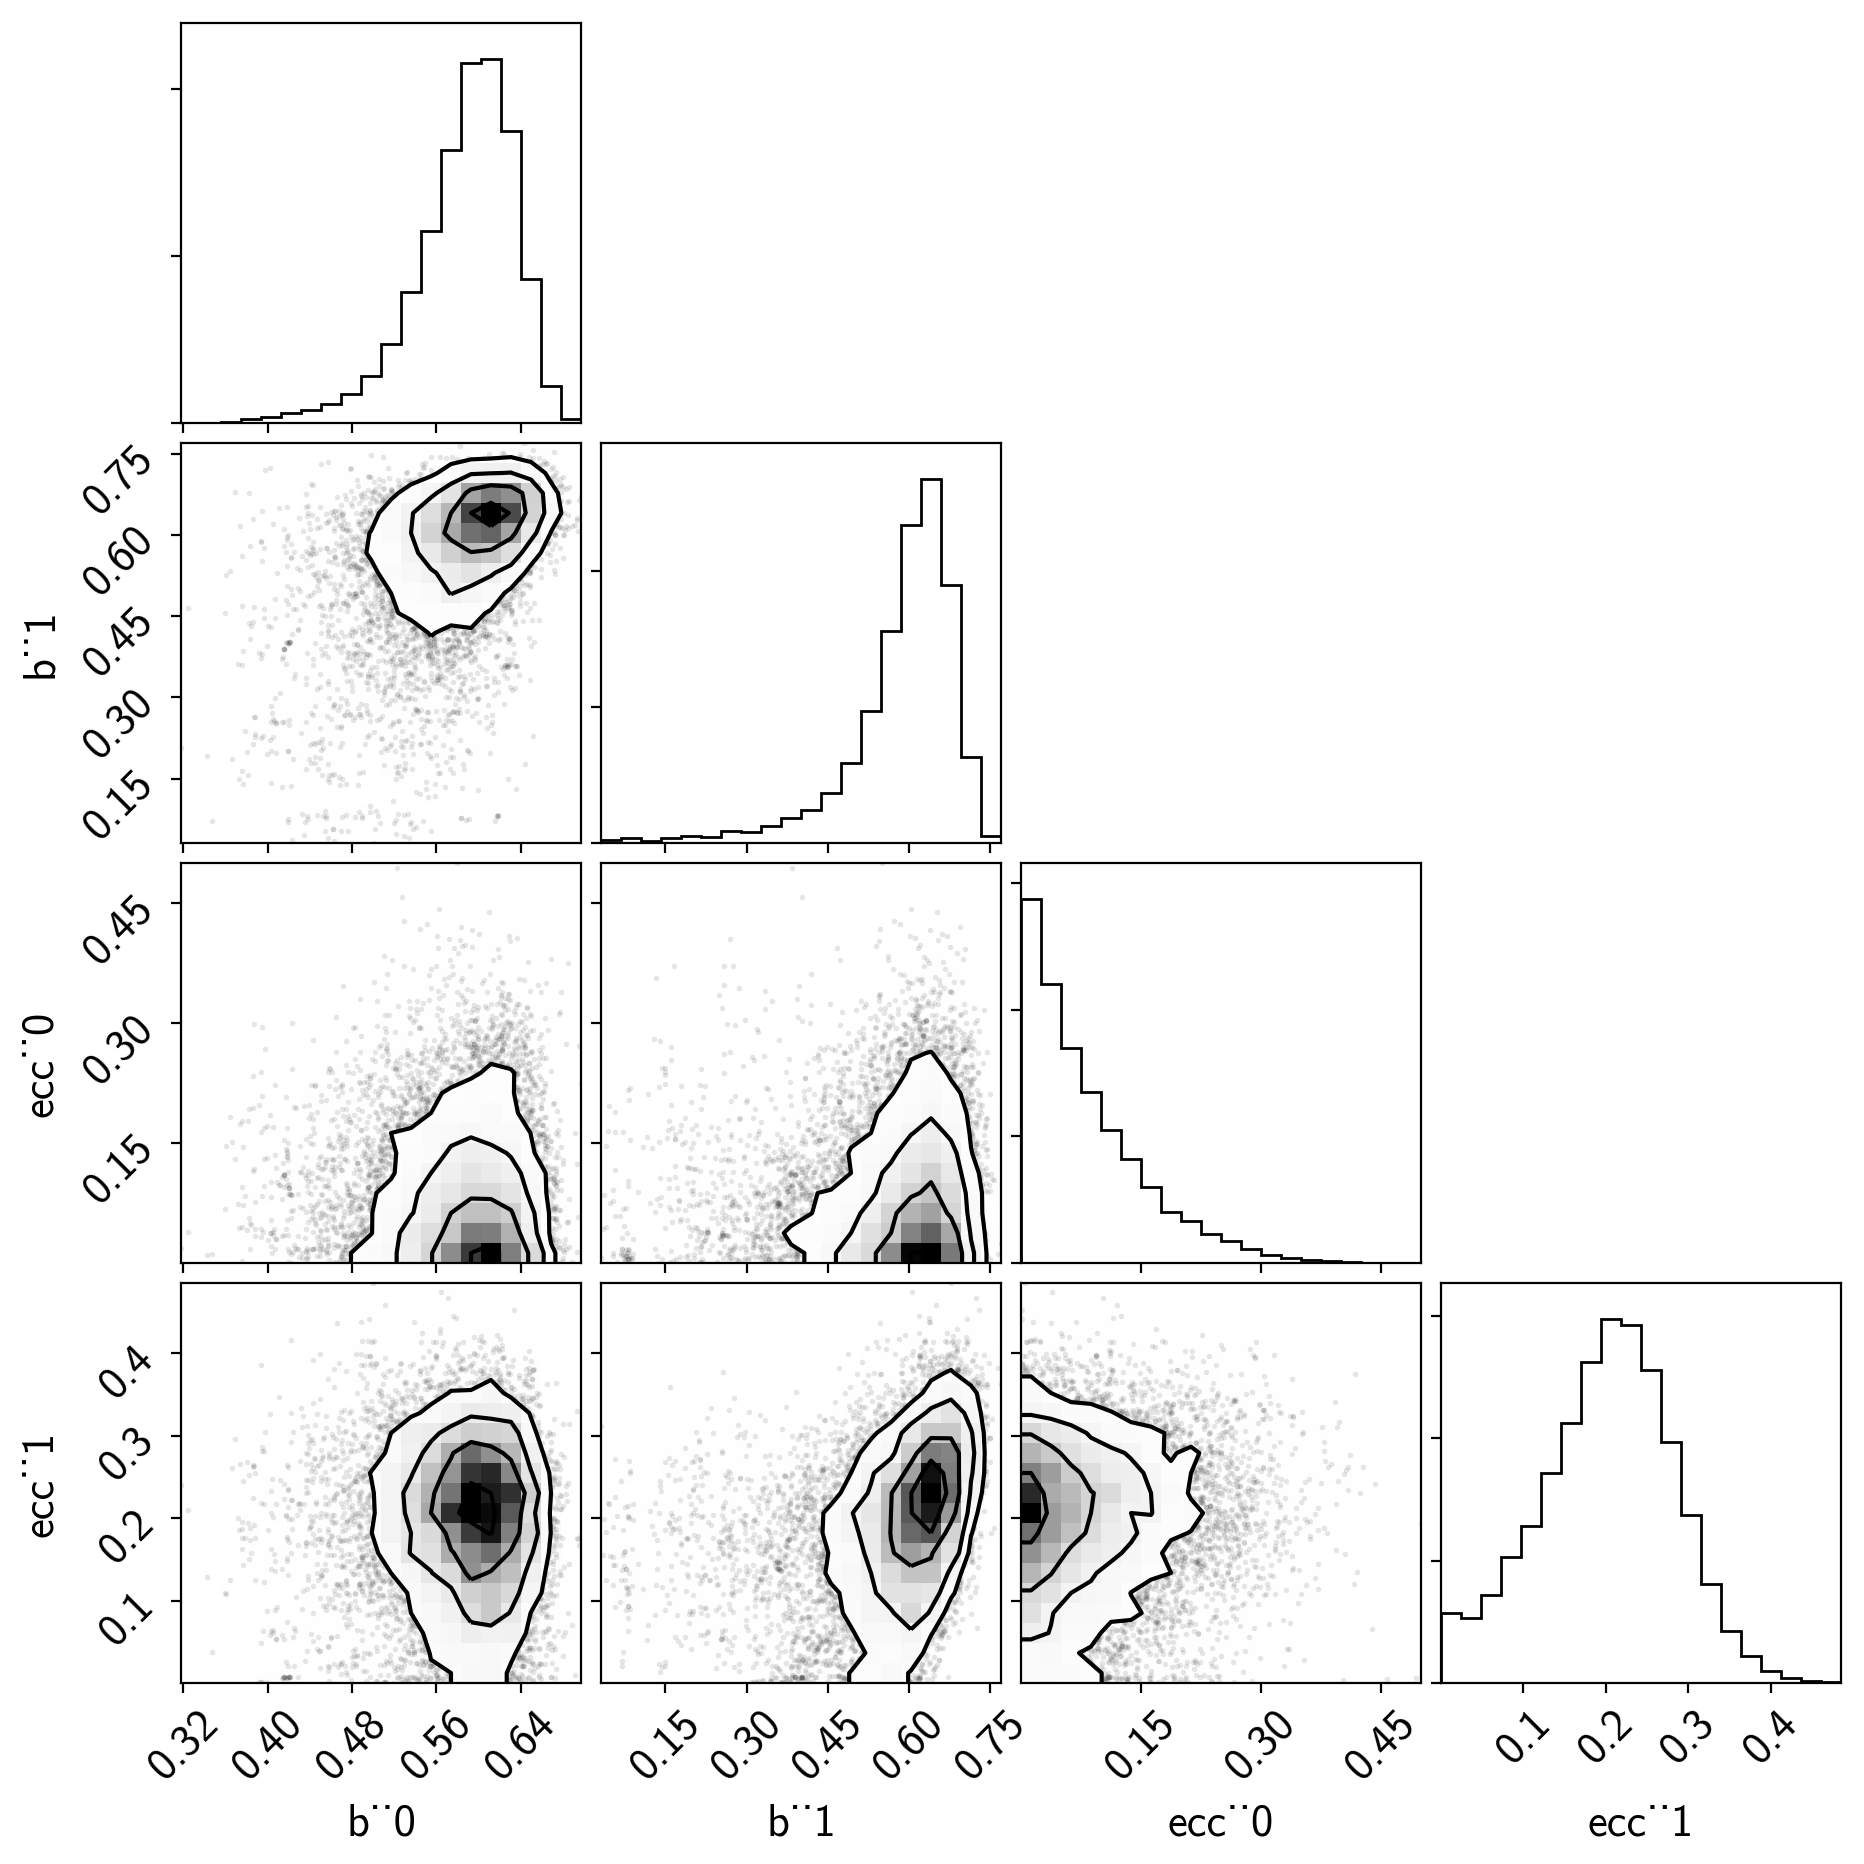

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

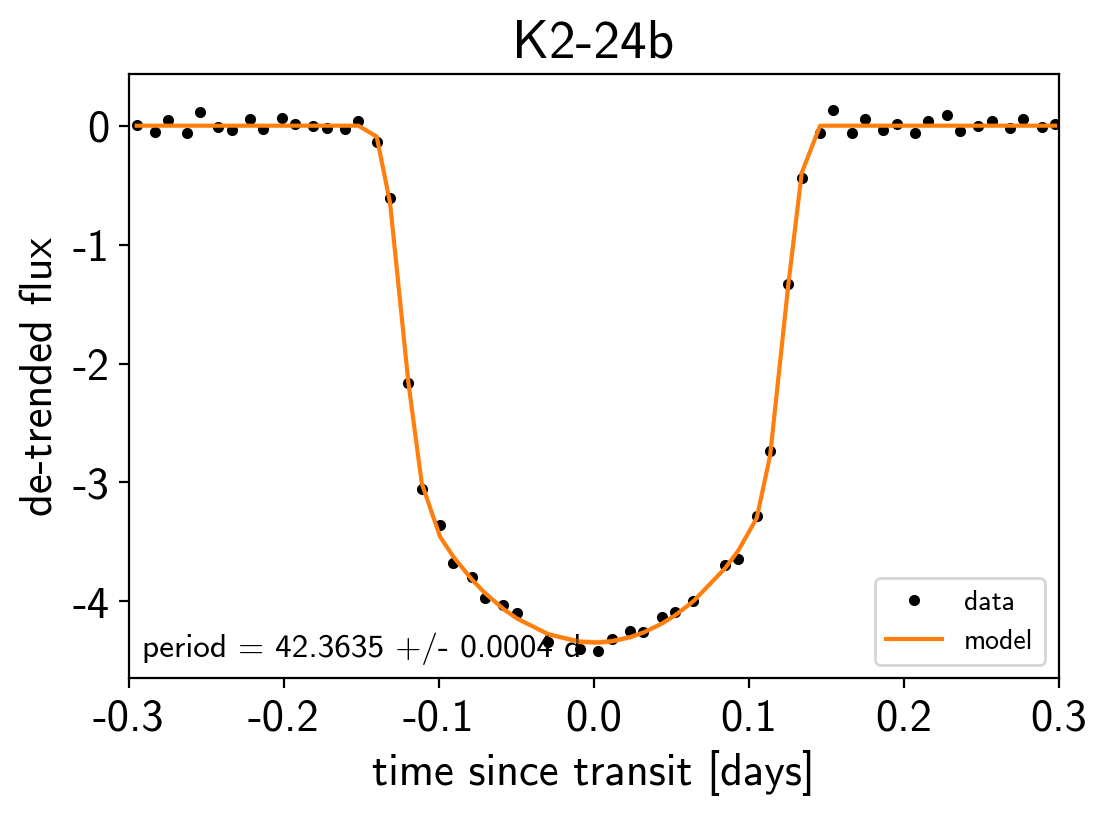

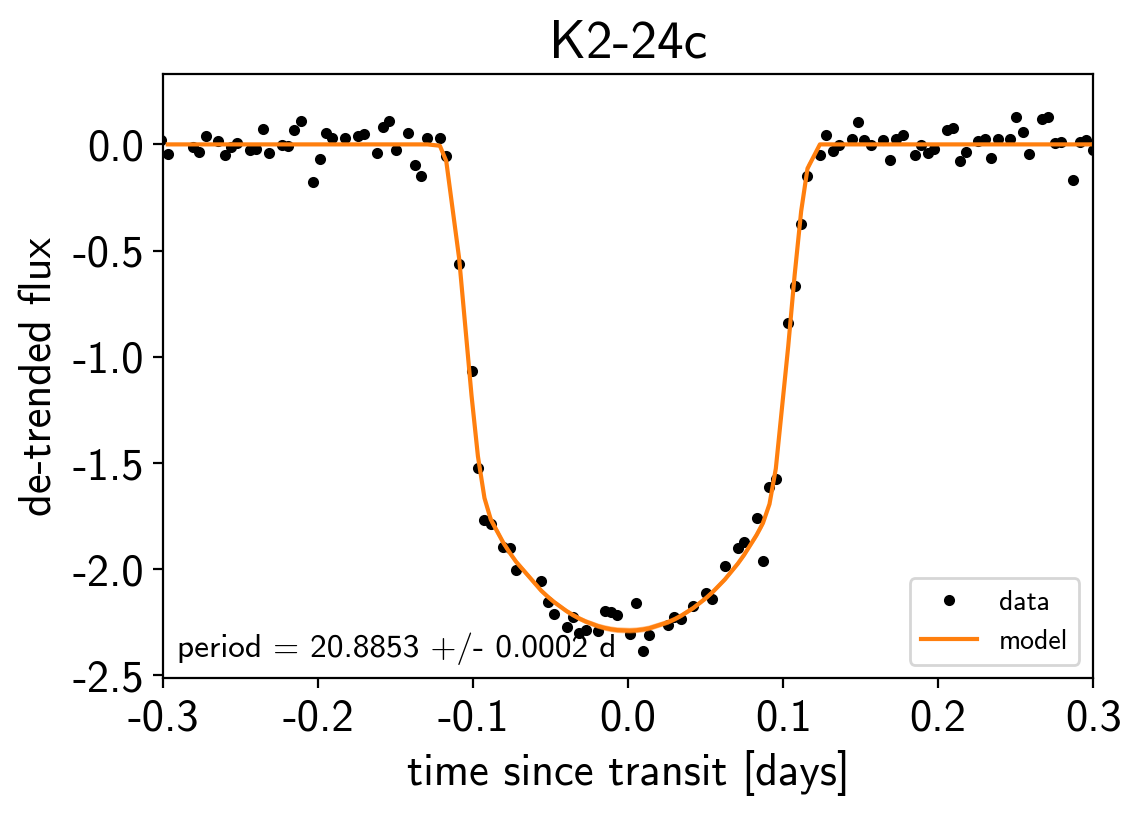

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

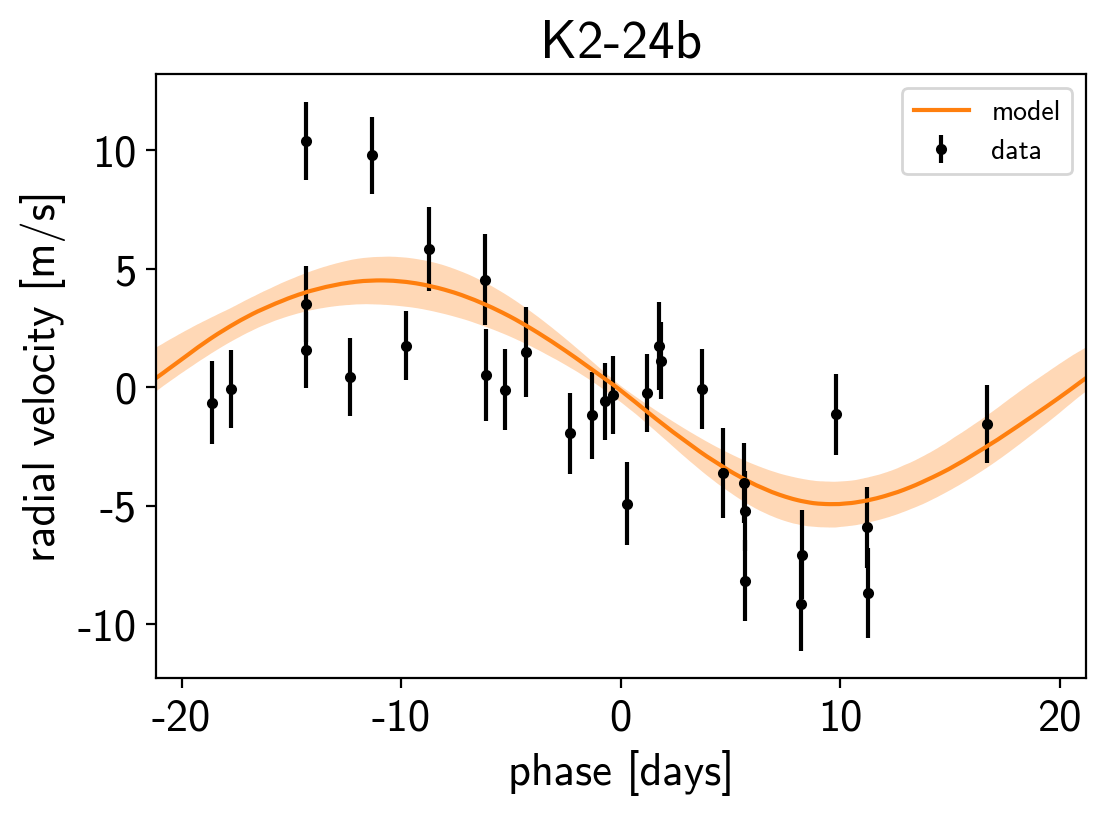

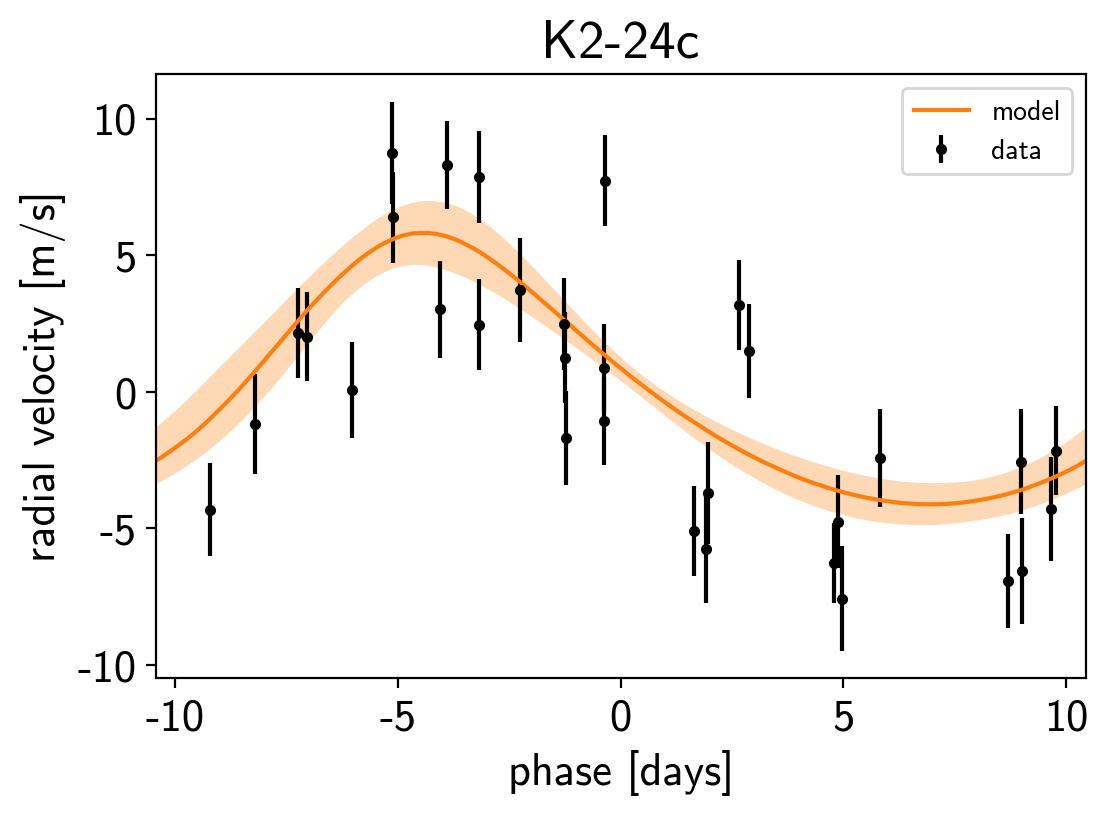

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

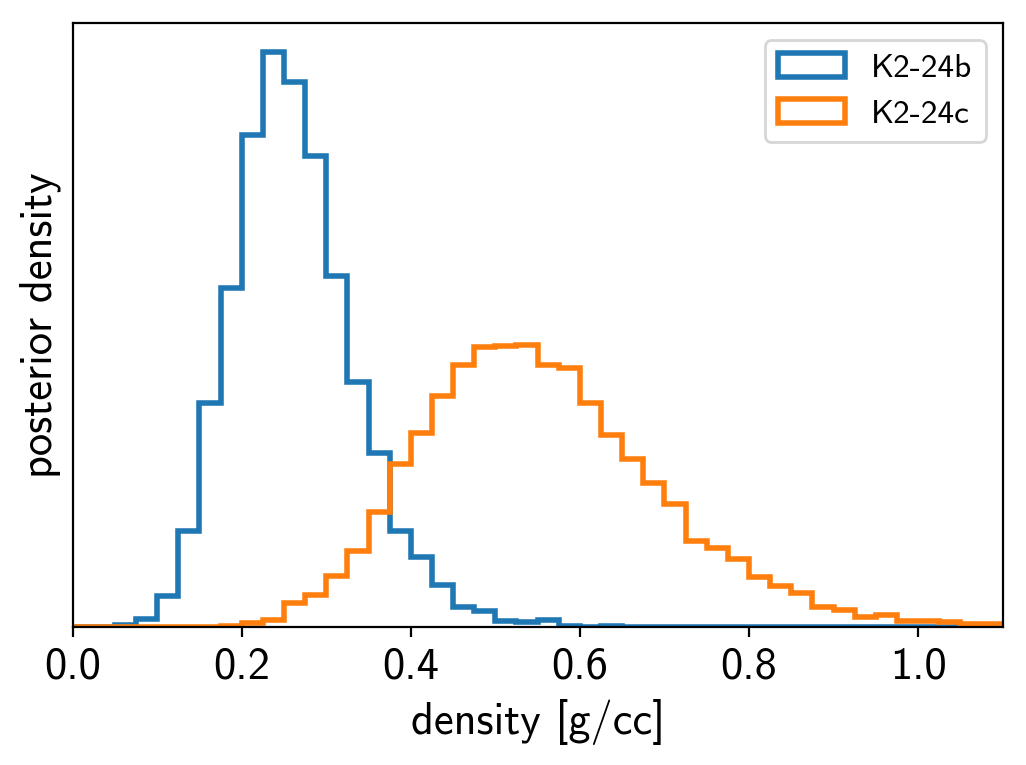

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
...
